### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import tqdm
import wandb
wandb.init(project='supercabs', entity='solomonseshadry')


# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

wandb: Currently logged in as: solomonseshadry (use `wandb login --relogin` to force relogin)


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
env = CabDriver()
epsiode_length = 24*30

#### Tracking the state-action pairs for checking convergence

In [3]:
# Declaring States to track
states_action_to_track = [[(2,10,1), 9], [[2,5,6], 11], [[2,16,0], 10],  [[0,6,5], 19],  [[3,1,5], 20],  [[4,12,4], 3]]
state_action_tracked_results = [[],[],[],[],[],[]]

#### Save Object as Pickle

In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    
    def __init__(self, state_size, action_size, discount_factor=0.98, learning_rate=0.001,
                       epsilon=1, epsilon_decay=0.0005, epsilon_min=0.0001):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size 
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.learning_rate = learning_rate      
        self.epsilon_max = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.batch_size = 64     
        self.state_encoded = 36 # (m + t + d)
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_encoded, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.summary
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        return model


    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """
        indexes, _ = env.requests(state)
        if np.random.rand() <= self.epsilon:

            # get possible requests/actions given a state
            # choose an action randomly, this will contain the no-ride action
            return random.choice(indexes)
        else:

            # get q_value for all actions = this should be 21 (20 actions + no ride)
            state_encoded = env.state_encod_arch2(state)
            state_encoded = np.reshape(state_encoded, [1, self.state_encoded])

            # predicting the q value using the model trained so far. 
            q_value = self.model.predict(state_encoded)

            # get q_values for the actions/requests which the cab driver received
            # the index should include the index for no-ride
            filtered_q_values = [q_value[0][i] for i in indexes]

            # get the index with max q-value
            max_q_value_index = np.argmax(filtered_q_values)

            # print(f'max_q_value_index..{max_q_value_index}')
            return indexes[max_q_value_index]
        
    # adds the experience to memory
    def append_sample(self, state, action, reward, next_state, hours_of_trip):
        # append the tuple (s, a, r, s', hoursoftrip) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, hours_of_trip))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_encoded))
            update_input = np.zeros((self.batch_size, self.state_encoded))
            actions, rewards, trip_hours_per_exp = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, hours_of_trip = mini_batch[i]
                state_encod = env.state_encod_arch2(state)
                next_state_encod = env.state_encod_arch2(next_state)
                update_input[i] = state_encod
                update_output[i] = next_state_encod
                actions.append(action)
                rewards.append(reward)
                trip_hours_per_exp.append(hours_of_trip)
                
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)   
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
                # find if it is the terminal state
                if (trip_hours_per_exp[i] >= epsiode_length):
                    # if it is the terminal state (i.e. if it is the end of the month) then the target q value is just the reward
                    target[i][actions[i]] = rewards[i]
                else:
                    # if it is not terminal state then the target value = reward + discount * (max(q(next_state, a)))
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_qval[i]))

            # 4. Fit your model and track the loss values
            history = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            return history

    #This function will append latest Q-values which are being tracked for checking convergence
    def save_tracking_states(self, states_action_to_track, state_action_tracked_results):
        for idx, state_action in enumerate(states_action_to_track):
            state_encoded = env.state_encod_arch2(state_action[0])
            state_encoded = np.reshape(state_encoded, [1, agent.state_encoded])
            q_val = agent.model.predict(state_encoded)
            state_action_tracked_results[idx].append(q_val[0][state_action[1]])

In [6]:
# Testing some key functionalities

state_size = len(env.state_space)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
state = env.state_init
print(state)
action = agent.get_action(state)
print(action)
state, reward, next_state, trip_hours = env.step(state, env.action_space[action], Time_matrix, 0)
(state, reward, next_state, trip_hours)
agent.save_tracking_states(states_action_to_track, state_action_tracked_results)
print(state_action_tracked_results)

(0, 18, 4)
0
[[0.04513117], [0.20022333], [0.32783464], [0.10531427], [0.0], [0.0]]


In [7]:
episodes = 10000   
epsilon_decay = 0.0005
config = wandb.config # this is for reporting only
config.learning_rate = 0.001
state_size = len(env.state_space)
action_size = len(env.action_space) 
threshold = 1000
agent = DQNAgent(state_size, action_size, epsilon_decay=epsilon_decay, learning_rate=config.learning_rate)

### DQN block

In [8]:
import time
start_time = time.time()
rewards_tracked = []
loss_tracked = []

for episode in tqdm.tqdm(range(episodes)):

    # Call the environment
    env = CabDriver()

    # Call all the initialised variables of the environment
    state_size = len(env.state_space)
    action_size = len(env.action_space) # for no-ride
    initial_state = env.state_init
    current_state = env.state_init
    steps = 0 # cab driver starts with 0 trip hours
    total_reward = 0
    training_steps = 0 
    
    while steps <= epsiode_length: # each episode is 30 days long
        
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(current_state)

        # 2. Evaluate your reward and next state
        state, reward, next_state, hours_of_trip = env.step(current_state, env.action_space[action], Time_matrix, steps)

        # 3. Append the experience to the memory
        agent.append_sample(current_state, action, reward, next_state, hours_of_trip)
        
        # no need to train for every experience we can train based on threshold.
        # 4. Train the model by calling function agent.train_model
        if training_steps % 10 == 0:
          history = agent.train_model()
          # Track Loss
          if (history is not None):
            loss = history.history["loss"][0]
            loss_tracked.append(loss)
            wandb.log({"loss": loss})

        # Numer of days completed = steps, the episode ends when 24*30 hours are completed
        steps += hours_of_trip 

        # next state becomes current state for next step
        current_state = next_state

        # 5. Keep a track of rewards, Q-values, loss
        total_reward += reward

        training_steps +=1

    # Track rewards
    rewards_tracked.append(total_reward)
    wandb.log({"epsilon":agent.epsilon})
    wandb.log({"rewards":total_reward})

    # Save States Tracked  
    if episode % 10 == 0:
      agent.save_tracking_states(states_action_to_track, state_action_tracked_results)
      save_obj(state_action_tracked_results,'States_tracked')

    # Save the model 
    if episode % threshold == 0:
        agent.model.save("supercabs.h5", overwrite=True)
    
    print(f'Episode: {episode} Total Reward: {total_reward}, epsilon: {agent.epsilon}, Buffer Length: {len(agent.memory)}, Trip Hours: {steps}')

    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay * episode)

elapsed_time = time.time() - start_time
print(f'{round(elapsed_time/60,2)} min')

  0%|          | 1/10000 [00:01<4:16:33,  1.54s/it]

Episode: 0 Total Reward: -200, epsilon: 1, Buffer Length: 143, Trip Hours: 724


  0%|          | 2/10000 [00:03<4:48:11,  1.73s/it]

Episode: 1 Total Reward: -118, epsilon: 1.0, Buffer Length: 295, Trip Hours: 722


  0%|          | 3/10000 [00:04<4:29:53,  1.62s/it]

Episode: 2 Total Reward: -435, epsilon: 0.9995001749666714, Buffer Length: 422, Trip Hours: 726


  0%|          | 4/10000 [00:06<4:20:22,  1.56s/it]

Episode: 3 Total Reward: -357, epsilon: 0.9990005997833917, Buffer Length: 551, Trip Hours: 723


  0%|          | 5/10000 [00:07<4:14:31,  1.53s/it]

Episode: 4 Total Reward: -224, epsilon: 0.9985012743252671, Buffer Length: 684, Trip Hours: 727


  0%|          | 6/10000 [00:09<4:14:52,  1.53s/it]

Episode: 5 Total Reward: -52, epsilon: 0.9980021984674663, Buffer Length: 829, Trip Hours: 734


  0%|          | 7/10000 [00:10<4:10:33,  1.50s/it]

Episode: 6 Total Reward: -32, epsilon: 0.9975033720852203, Buffer Length: 968, Trip Hours: 730


  0%|          | 8/10000 [00:12<4:21:07,  1.57s/it]

Episode: 7 Total Reward: -271, epsilon: 0.9970047950538227, Buffer Length: 1130, Trip Hours: 722


  0%|          | 9/10000 [00:14<4:16:26,  1.54s/it]

Episode: 8 Total Reward: 65, epsilon: 0.9965064672486288, Buffer Length: 1264, Trip Hours: 725


  0%|          | 10/10000 [00:15<4:12:45,  1.52s/it]

Episode: 9 Total Reward: -108, epsilon: 0.9960083885450571, Buffer Length: 1397, Trip Hours: 729


  0%|          | 11/10000 [00:17<4:27:08,  1.60s/it]

Episode: 10 Total Reward: 34, epsilon: 0.9955105588185876, Buffer Length: 1539, Trip Hours: 733


  0%|          | 12/10000 [00:18<4:32:25,  1.64s/it]

Episode: 11 Total Reward: 29, epsilon: 0.9950129779447631, Buffer Length: 1686, Trip Hours: 725


  0%|          | 13/10000 [00:20<4:31:35,  1.63s/it]

Episode: 12 Total Reward: -235, epsilon: 0.9945156457991882, Buffer Length: 1835, Trip Hours: 722


  0%|          | 14/10000 [00:22<4:35:44,  1.66s/it]

Episode: 13 Total Reward: -172, epsilon: 0.9940185622575299, Buffer Length: 1976, Trip Hours: 722


  0%|          | 15/10000 [00:23<4:28:23,  1.61s/it]

Episode: 14 Total Reward: -39, epsilon: 0.9935217271955173, Buffer Length: 2000, Trip Hours: 726


  0%|          | 16/10000 [00:25<4:42:00,  1.69s/it]

Episode: 15 Total Reward: 49, epsilon: 0.9930251404889417, Buffer Length: 2000, Trip Hours: 721


  0%|          | 17/10000 [00:27<4:38:17,  1.67s/it]

Episode: 16 Total Reward: -8, epsilon: 0.9925288020136565, Buffer Length: 2000, Trip Hours: 727


  0%|          | 18/10000 [00:28<4:31:02,  1.63s/it]

Episode: 17 Total Reward: -44, epsilon: 0.9920327116455769, Buffer Length: 2000, Trip Hours: 727


  0%|          | 19/10000 [00:30<4:20:38,  1.57s/it]

Episode: 18 Total Reward: -92, epsilon: 0.9915368692606804, Buffer Length: 2000, Trip Hours: 724


  0%|          | 20/10000 [00:31<4:22:07,  1.58s/it]

Episode: 19 Total Reward: -235, epsilon: 0.9910412747350064, Buffer Length: 2000, Trip Hours: 722


  0%|          | 21/10000 [00:33<4:36:27,  1.66s/it]

Episode: 20 Total Reward: 68, epsilon: 0.9905459279446561, Buffer Length: 2000, Trip Hours: 737


  0%|          | 22/10000 [00:35<4:26:51,  1.60s/it]

Episode: 21 Total Reward: -28, epsilon: 0.9900508287657932, Buffer Length: 2000, Trip Hours: 731


  0%|          | 23/10000 [00:36<4:14:04,  1.53s/it]

Episode: 22 Total Reward: 268, epsilon: 0.9895559770746425, Buffer Length: 2000, Trip Hours: 724


  0%|          | 24/10000 [00:37<4:04:30,  1.47s/it]

Episode: 23 Total Reward: -123, epsilon: 0.9890613727474912, Buffer Length: 2000, Trip Hours: 723


  0%|          | 25/10000 [00:39<4:05:55,  1.48s/it]

Episode: 24 Total Reward: -352, epsilon: 0.9885670156606883, Buffer Length: 2000, Trip Hours: 722


  0%|          | 26/10000 [00:40<4:01:33,  1.45s/it]

Episode: 25 Total Reward: -2, epsilon: 0.9880729056906443, Buffer Length: 2000, Trip Hours: 724


  0%|          | 27/10000 [00:42<4:06:33,  1.48s/it]

Episode: 26 Total Reward: -7, epsilon: 0.987579042713832, Buffer Length: 2000, Trip Hours: 725


  0%|          | 28/10000 [00:43<3:59:23,  1.44s/it]

Episode: 27 Total Reward: 144, epsilon: 0.9870854266067856, Buffer Length: 2000, Trip Hours: 729


  0%|          | 29/10000 [00:44<3:50:12,  1.39s/it]

Episode: 28 Total Reward: -77, epsilon: 0.9865920572461009, Buffer Length: 2000, Trip Hours: 721


  0%|          | 30/10000 [00:47<4:23:44,  1.59s/it]

Episode: 29 Total Reward: -146, epsilon: 0.9860989345084356, Buffer Length: 2000, Trip Hours: 724


  0%|          | 31/10000 [00:48<4:30:09,  1.63s/it]

Episode: 30 Total Reward: -404, epsilon: 0.9856060582705092, Buffer Length: 2000, Trip Hours: 727


  0%|          | 32/10000 [00:50<4:19:22,  1.56s/it]

Episode: 31 Total Reward: -68, epsilon: 0.9851134284091023, Buffer Length: 2000, Trip Hours: 721


  0%|          | 33/10000 [00:51<4:24:35,  1.59s/it]

Episode: 32 Total Reward: -125, epsilon: 0.9846210448010577, Buffer Length: 2000, Trip Hours: 727


  0%|          | 34/10000 [00:53<4:15:44,  1.54s/it]

Episode: 33 Total Reward: -145, epsilon: 0.9841289073232796, Buffer Length: 2000, Trip Hours: 722


  0%|          | 35/10000 [00:54<4:21:48,  1.58s/it]

Episode: 34 Total Reward: -500, epsilon: 0.9836370158527333, Buffer Length: 2000, Trip Hours: 721


  0%|          | 36/10000 [00:56<4:19:01,  1.56s/it]

Episode: 35 Total Reward: -2, epsilon: 0.9831453702664461, Buffer Length: 2000, Trip Hours: 724


  0%|          | 37/10000 [00:57<4:20:04,  1.57s/it]

Episode: 36 Total Reward: -59, epsilon: 0.9826539704415067, Buffer Length: 2000, Trip Hours: 721


  0%|          | 38/10000 [00:59<4:09:33,  1.50s/it]

Episode: 37 Total Reward: -32, epsilon: 0.982162816255065, Buffer Length: 2000, Trip Hours: 721


  0%|          | 39/10000 [01:00<4:15:57,  1.54s/it]

Episode: 38 Total Reward: -275, epsilon: 0.9816719075843323, Buffer Length: 2000, Trip Hours: 730


  0%|          | 40/10000 [01:02<4:17:13,  1.55s/it]

Episode: 39 Total Reward: -113, epsilon: 0.9811812443065817, Buffer Length: 2000, Trip Hours: 721


  0%|          | 41/10000 [01:04<4:31:26,  1.64s/it]

Episode: 40 Total Reward: 4, epsilon: 0.9806908262991473, Buffer Length: 2000, Trip Hours: 721


  0%|          | 42/10000 [01:05<4:29:48,  1.63s/it]

Episode: 41 Total Reward: 30, epsilon: 0.9802006534394245, Buffer Length: 2000, Trip Hours: 723


  0%|          | 43/10000 [01:07<4:19:43,  1.57s/it]

Episode: 42 Total Reward: -145, epsilon: 0.9797107256048704, Buffer Length: 2000, Trip Hours: 731


  0%|          | 44/10000 [01:09<4:23:43,  1.59s/it]

Episode: 43 Total Reward: -120, epsilon: 0.9792210426730026, Buffer Length: 2000, Trip Hours: 726


  0%|          | 45/10000 [01:10<4:20:37,  1.57s/it]

Episode: 44 Total Reward: 165, epsilon: 0.9787316045214007, Buffer Length: 2000, Trip Hours: 723


  0%|          | 46/10000 [01:11<4:07:53,  1.49s/it]

Episode: 45 Total Reward: -401, epsilon: 0.9782424110277049, Buffer Length: 2000, Trip Hours: 721


  0%|          | 47/10000 [01:13<4:02:16,  1.46s/it]

Episode: 46 Total Reward: -12, epsilon: 0.977753462069617, Buffer Length: 2000, Trip Hours: 726


  0%|          | 48/10000 [01:14<4:12:40,  1.52s/it]

Episode: 47 Total Reward: -83, epsilon: 0.9772647575248997, Buffer Length: 2000, Trip Hours: 724


  0%|          | 49/10000 [01:16<4:09:51,  1.51s/it]

Episode: 48 Total Reward: 17, epsilon: 0.9767762972713769, Buffer Length: 2000, Trip Hours: 722


  0%|          | 50/10000 [01:18<4:19:47,  1.57s/it]

Episode: 49 Total Reward: -280, epsilon: 0.9762880811869336, Buffer Length: 2000, Trip Hours: 722


  1%|          | 51/10000 [01:19<4:21:05,  1.57s/it]

Episode: 50 Total Reward: 56, epsilon: 0.9758001091495155, Buffer Length: 2000, Trip Hours: 725


  1%|          | 52/10000 [01:21<4:28:02,  1.62s/it]

Episode: 51 Total Reward: -282, epsilon: 0.9753123810371298, Buffer Length: 2000, Trip Hours: 726


  1%|          | 53/10000 [01:23<4:31:03,  1.63s/it]

Episode: 52 Total Reward: -167, epsilon: 0.9748248967278446, Buffer Length: 2000, Trip Hours: 730


  1%|          | 54/10000 [01:24<4:25:37,  1.60s/it]

Episode: 53 Total Reward: -469, epsilon: 0.9743376560997885, Buffer Length: 2000, Trip Hours: 722


  1%|          | 55/10000 [01:26<4:23:30,  1.59s/it]

Episode: 54 Total Reward: -301, epsilon: 0.9738506590311514, Buffer Length: 2000, Trip Hours: 728


  1%|          | 56/10000 [01:27<4:13:35,  1.53s/it]

Episode: 55 Total Reward: -213, epsilon: 0.9733639054001844, Buffer Length: 2000, Trip Hours: 723


  1%|          | 57/10000 [01:29<4:11:16,  1.52s/it]

Episode: 56 Total Reward: -210, epsilon: 0.9728773950851987, Buffer Length: 2000, Trip Hours: 726


  1%|          | 58/10000 [01:30<4:25:42,  1.60s/it]

Episode: 57 Total Reward: -138, epsilon: 0.9723911279645667, Buffer Length: 2000, Trip Hours: 726


  1%|          | 59/10000 [01:32<4:20:59,  1.58s/it]

Episode: 58 Total Reward: -46, epsilon: 0.971905103916722, Buffer Length: 2000, Trip Hours: 722


  1%|          | 60/10000 [01:33<4:20:05,  1.57s/it]

Episode: 59 Total Reward: -190, epsilon: 0.9714193228201581, Buffer Length: 2000, Trip Hours: 722


  1%|          | 61/10000 [01:35<4:28:43,  1.62s/it]

Episode: 60 Total Reward: 4, epsilon: 0.9709337845534302, Buffer Length: 2000, Trip Hours: 730


  1%|          | 62/10000 [01:37<4:30:52,  1.64s/it]

Episode: 61 Total Reward: -165, epsilon: 0.9704484889951533, Buffer Length: 2000, Trip Hours: 726


  1%|          | 63/10000 [01:38<4:26:41,  1.61s/it]

Episode: 62 Total Reward: -303, epsilon: 0.9699634360240038, Buffer Length: 2000, Trip Hours: 723


  1%|          | 64/10000 [01:40<4:19:21,  1.57s/it]

Episode: 63 Total Reward: -217, epsilon: 0.9694786255187183, Buffer Length: 2000, Trip Hours: 731


  1%|          | 65/10000 [01:42<4:27:21,  1.61s/it]

Episode: 64 Total Reward: 43, epsilon: 0.9689940573580943, Buffer Length: 2000, Trip Hours: 724


  1%|          | 66/10000 [01:43<4:24:51,  1.60s/it]

Episode: 65 Total Reward: -64, epsilon: 0.9685097314209897, Buffer Length: 2000, Trip Hours: 722


  1%|          | 67/10000 [01:45<4:16:29,  1.55s/it]

Episode: 66 Total Reward: -96, epsilon: 0.9680256475863229, Buffer Length: 2000, Trip Hours: 723


  1%|          | 68/10000 [01:46<4:13:34,  1.53s/it]

Episode: 67 Total Reward: -214, epsilon: 0.9675418057330731, Buffer Length: 2000, Trip Hours: 725


  1%|          | 69/10000 [01:48<4:08:49,  1.50s/it]

Episode: 68 Total Reward: -120, epsilon: 0.9670582057402797, Buffer Length: 2000, Trip Hours: 726


  1%|          | 70/10000 [01:49<4:16:07,  1.55s/it]

Episode: 69 Total Reward: 29, epsilon: 0.9665748474870429, Buffer Length: 2000, Trip Hours: 725


  1%|          | 71/10000 [01:51<4:48:37,  1.74s/it]

Episode: 70 Total Reward: -87, epsilon: 0.9660917308525229, Buffer Length: 2000, Trip Hours: 723


  1%|          | 72/10000 [01:53<4:29:12,  1.63s/it]

Episode: 71 Total Reward: -223, epsilon: 0.9656088557159407, Buffer Length: 2000, Trip Hours: 734


  1%|          | 73/10000 [01:54<4:16:41,  1.55s/it]

Episode: 72 Total Reward: -73, epsilon: 0.9651262219565775, Buffer Length: 2000, Trip Hours: 722


  1%|          | 74/10000 [01:56<4:14:04,  1.54s/it]

Episode: 73 Total Reward: -201, epsilon: 0.9646438294537748, Buffer Length: 2000, Trip Hours: 726


  1%|          | 75/10000 [01:57<4:16:34,  1.55s/it]

Episode: 74 Total Reward: -128, epsilon: 0.9641616780869344, Buffer Length: 2000, Trip Hours: 724


  1%|          | 76/10000 [01:59<4:16:36,  1.55s/it]

Episode: 75 Total Reward: -43, epsilon: 0.9636797677355186, Buffer Length: 2000, Trip Hours: 725


  1%|          | 77/10000 [02:00<4:20:37,  1.58s/it]

Episode: 76 Total Reward: -207, epsilon: 0.9631980982790498, Buffer Length: 2000, Trip Hours: 729


  1%|          | 78/10000 [02:02<4:31:49,  1.64s/it]

Episode: 77 Total Reward: -127, epsilon: 0.9627166695971104, Buffer Length: 2000, Trip Hours: 722


  1%|          | 79/10000 [02:04<4:27:22,  1.62s/it]

Episode: 78 Total Reward: -171, epsilon: 0.9622354815693436, Buffer Length: 2000, Trip Hours: 729


  1%|          | 80/10000 [02:05<4:23:36,  1.59s/it]

Episode: 79 Total Reward: 235, epsilon: 0.9617545340754521, Buffer Length: 2000, Trip Hours: 727


  1%|          | 81/10000 [02:07<4:34:48,  1.66s/it]

Episode: 80 Total Reward: -224, epsilon: 0.9612738269951991, Buffer Length: 2000, Trip Hours: 727


  1%|          | 82/10000 [02:09<4:25:55,  1.61s/it]

Episode: 81 Total Reward: 278, epsilon: 0.960793360208408, Buffer Length: 2000, Trip Hours: 722


  1%|          | 83/10000 [02:10<4:24:09,  1.60s/it]

Episode: 82 Total Reward: -320, epsilon: 0.9603131335949618, Buffer Length: 2000, Trip Hours: 721


  1%|          | 84/10000 [02:12<4:23:23,  1.59s/it]

Episode: 83 Total Reward: -166, epsilon: 0.9598331470348042, Buffer Length: 2000, Trip Hours: 728


  1%|          | 85/10000 [02:14<4:35:46,  1.67s/it]

Episode: 84 Total Reward: 6, epsilon: 0.9593534004079382, Buffer Length: 2000, Trip Hours: 726


  1%|          | 86/10000 [02:15<4:48:24,  1.75s/it]

Episode: 85 Total Reward: 229, epsilon: 0.9588738935944272, Buffer Length: 2000, Trip Hours: 721


  1%|          | 87/10000 [02:17<4:27:11,  1.62s/it]

Episode: 86 Total Reward: -217, epsilon: 0.9583946264743949, Buffer Length: 2000, Trip Hours: 722


  1%|          | 88/10000 [02:18<4:24:51,  1.60s/it]

Episode: 87 Total Reward: -276, epsilon: 0.9579155989280239, Buffer Length: 2000, Trip Hours: 723


  1%|          | 89/10000 [02:20<4:29:02,  1.63s/it]

Episode: 88 Total Reward: -203, epsilon: 0.9574368108355579, Buffer Length: 2000, Trip Hours: 721


  1%|          | 90/10000 [02:22<4:37:21,  1.68s/it]

Episode: 89 Total Reward: -184, epsilon: 0.9569582620772994, Buffer Length: 2000, Trip Hours: 728


  1%|          | 91/10000 [02:24<4:43:21,  1.72s/it]

Episode: 90 Total Reward: -101, epsilon: 0.9564799525336114, Buffer Length: 2000, Trip Hours: 724


  1%|          | 92/10000 [02:25<4:35:51,  1.67s/it]

Episode: 91 Total Reward: -343, epsilon: 0.9560018820849167, Buffer Length: 2000, Trip Hours: 722


  1%|          | 93/10000 [02:27<4:40:47,  1.70s/it]

Episode: 92 Total Reward: -189, epsilon: 0.9555240506116972, Buffer Length: 2000, Trip Hours: 729


  1%|          | 94/10000 [02:29<4:38:54,  1.69s/it]

Episode: 93 Total Reward: -156, epsilon: 0.9550464579944956, Buffer Length: 2000, Trip Hours: 726


  1%|          | 95/10000 [02:30<4:30:10,  1.64s/it]

Episode: 94 Total Reward: -159, epsilon: 0.9545691041139133, Buffer Length: 2000, Trip Hours: 723


  1%|          | 96/10000 [02:32<4:16:59,  1.56s/it]

Episode: 95 Total Reward: 7, epsilon: 0.9540919888506121, Buffer Length: 2000, Trip Hours: 724


  1%|          | 97/10000 [02:33<4:29:38,  1.63s/it]

Episode: 96 Total Reward: 375, epsilon: 0.9536151120853131, Buffer Length: 2000, Trip Hours: 726


  1%|          | 98/10000 [02:35<4:28:03,  1.62s/it]

Episode: 97 Total Reward: 227, epsilon: 0.953138473698797, Buffer Length: 2000, Trip Hours: 725


  1%|          | 99/10000 [02:37<4:37:26,  1.68s/it]

Episode: 98 Total Reward: -39, epsilon: 0.9526620735719042, Buffer Length: 2000, Trip Hours: 726


  1%|          | 100/10000 [02:38<4:32:28,  1.65s/it]

Episode: 99 Total Reward: 3, epsilon: 0.952185911585535, Buffer Length: 2000, Trip Hours: 723


  1%|          | 101/10000 [02:40<4:41:49,  1.71s/it]

Episode: 100 Total Reward: -655, epsilon: 0.9517099876206485, Buffer Length: 2000, Trip Hours: 725


  1%|          | 102/10000 [02:42<4:39:14,  1.69s/it]

Episode: 101 Total Reward: -193, epsilon: 0.9512343015582639, Buffer Length: 2000, Trip Hours: 728


  1%|          | 103/10000 [02:43<4:28:32,  1.63s/it]

Episode: 102 Total Reward: 223, epsilon: 0.9507588532794596, Buffer Length: 2000, Trip Hours: 724


  1%|          | 104/10000 [02:45<4:29:20,  1.63s/it]

Episode: 103 Total Reward: -267, epsilon: 0.9502836426653738, Buffer Length: 2000, Trip Hours: 723


  1%|          | 105/10000 [02:47<4:42:55,  1.72s/it]

Episode: 104 Total Reward: 146, epsilon: 0.9498086695972033, Buffer Length: 2000, Trip Hours: 725


  1%|          | 106/10000 [02:48<4:36:20,  1.68s/it]

Episode: 105 Total Reward: -315, epsilon: 0.9493339339562052, Buffer Length: 2000, Trip Hours: 729


  1%|          | 107/10000 [02:50<4:39:47,  1.70s/it]

Episode: 106 Total Reward: 70, epsilon: 0.9488594356236957, Buffer Length: 2000, Trip Hours: 724


  1%|          | 108/10000 [02:52<4:38:07,  1.69s/it]

Episode: 107 Total Reward: 44, epsilon: 0.94838517448105, Buffer Length: 2000, Trip Hours: 722


  1%|          | 109/10000 [02:54<4:36:56,  1.68s/it]

Episode: 108 Total Reward: -163, epsilon: 0.9479111504097028, Buffer Length: 2000, Trip Hours: 722


  1%|          | 110/10000 [02:55<4:37:31,  1.68s/it]

Episode: 109 Total Reward: -172, epsilon: 0.9474373632911481, Buffer Length: 2000, Trip Hours: 731


  1%|          | 111/10000 [02:57<4:40:17,  1.70s/it]

Episode: 110 Total Reward: 174, epsilon: 0.9469638130069393, Buffer Length: 2000, Trip Hours: 732


  1%|          | 112/10000 [02:59<4:51:49,  1.77s/it]

Episode: 111 Total Reward: -359, epsilon: 0.9464904994386885, Buffer Length: 2000, Trip Hours: 736


  1%|          | 113/10000 [03:01<4:46:13,  1.74s/it]

Episode: 112 Total Reward: -331, epsilon: 0.9460174224680676, Buffer Length: 2000, Trip Hours: 725


  1%|          | 114/10000 [03:02<4:35:36,  1.67s/it]

Episode: 113 Total Reward: -362, epsilon: 0.9455445819768072, Buffer Length: 2000, Trip Hours: 724


  1%|          | 115/10000 [03:04<4:40:55,  1.71s/it]

Episode: 114 Total Reward: -172, epsilon: 0.9450719778466973, Buffer Length: 2000, Trip Hours: 722


  1%|          | 116/10000 [03:06<4:45:37,  1.73s/it]

Episode: 115 Total Reward: -331, epsilon: 0.9445996099595867, Buffer Length: 2000, Trip Hours: 734


  1%|          | 117/10000 [03:07<4:48:59,  1.75s/it]

Episode: 116 Total Reward: -48, epsilon: 0.9441274781973835, Buffer Length: 2000, Trip Hours: 726


  1%|          | 118/10000 [03:09<4:52:16,  1.77s/it]

Episode: 117 Total Reward: 305, epsilon: 0.9436555824420548, Buffer Length: 2000, Trip Hours: 722


  1%|          | 119/10000 [03:11<4:36:49,  1.68s/it]

Episode: 118 Total Reward: 120, epsilon: 0.9431839225756267, Buffer Length: 2000, Trip Hours: 723


  1%|          | 120/10000 [03:12<4:30:30,  1.64s/it]

Episode: 119 Total Reward: 32, epsilon: 0.942712498480184, Buffer Length: 2000, Trip Hours: 728


  1%|          | 121/10000 [03:15<5:00:41,  1.83s/it]

Episode: 120 Total Reward: -201, epsilon: 0.9422413100378709, Buffer Length: 2000, Trip Hours: 726


  1%|          | 122/10000 [03:16<4:57:46,  1.81s/it]

Episode: 121 Total Reward: -506, epsilon: 0.9417703571308903, Buffer Length: 2000, Trip Hours: 724


  1%|          | 123/10000 [03:18<4:57:28,  1.81s/it]

Episode: 122 Total Reward: 48, epsilon: 0.9412996396415039, Buffer Length: 2000, Trip Hours: 723


  1%|          | 124/10000 [03:20<5:01:28,  1.83s/it]

Episode: 123 Total Reward: -179, epsilon: 0.9408291574520321, Buffer Length: 2000, Trip Hours: 727


  1%|▏         | 125/10000 [03:22<4:45:03,  1.73s/it]

Episode: 124 Total Reward: -329, epsilon: 0.9403589104448546, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 126/10000 [03:23<4:46:23,  1.74s/it]

Episode: 125 Total Reward: -19, epsilon: 0.9398888985024098, Buffer Length: 2000, Trip Hours: 722


  1%|▏         | 127/10000 [03:25<4:44:47,  1.73s/it]

Episode: 126 Total Reward: -113, epsilon: 0.9394191215071944, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 128/10000 [03:27<4:44:52,  1.73s/it]

Episode: 127 Total Reward: -113, epsilon: 0.9389495793417643, Buffer Length: 2000, Trip Hours: 730


  1%|▏         | 129/10000 [03:28<4:45:57,  1.74s/it]

Episode: 128 Total Reward: -183, epsilon: 0.938480271888734, Buffer Length: 2000, Trip Hours: 726


  1%|▏         | 130/10000 [03:30<4:35:43,  1.68s/it]

Episode: 129 Total Reward: -150, epsilon: 0.9380111990307763, Buffer Length: 2000, Trip Hours: 723


  1%|▏         | 131/10000 [03:32<4:43:24,  1.72s/it]

Episode: 130 Total Reward: -20, epsilon: 0.9375423606506236, Buffer Length: 2000, Trip Hours: 733


  1%|▏         | 132/10000 [03:34<4:46:11,  1.74s/it]

Episode: 131 Total Reward: 13, epsilon: 0.9370737566310657, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 133/10000 [03:35<4:38:07,  1.69s/it]

Episode: 132 Total Reward: -190, epsilon: 0.936605386854952, Buffer Length: 2000, Trip Hours: 722


  1%|▏         | 134/10000 [03:37<4:33:45,  1.66s/it]

Episode: 133 Total Reward: -248, epsilon: 0.9361372512051896, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 135/10000 [03:38<4:25:59,  1.62s/it]

Episode: 134 Total Reward: 22, epsilon: 0.9356693495647451, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 136/10000 [03:40<4:35:00,  1.67s/it]

Episode: 135 Total Reward: 91, epsilon: 0.9352016818166429, Buffer Length: 2000, Trip Hours: 727


  1%|▏         | 137/10000 [03:42<4:51:15,  1.77s/it]

Episode: 136 Total Reward: 174, epsilon: 0.9347342478439659, Buffer Length: 2000, Trip Hours: 723


  1%|▏         | 138/10000 [03:44<4:41:01,  1.71s/it]

Episode: 137 Total Reward: -327, epsilon: 0.9342670475298558, Buffer Length: 2000, Trip Hours: 726


  1%|▏         | 139/10000 [03:45<4:45:34,  1.74s/it]

Episode: 138 Total Reward: -104, epsilon: 0.9338000807575124, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 140/10000 [03:47<4:39:49,  1.70s/it]

Episode: 139 Total Reward: -302, epsilon: 0.9333333474101941, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 141/10000 [03:49<4:50:35,  1.77s/it]

Episode: 140 Total Reward: -141, epsilon: 0.9328668473712175, Buffer Length: 2000, Trip Hours: 723


  1%|▏         | 142/10000 [03:51<5:00:32,  1.83s/it]

Episode: 141 Total Reward: 82, epsilon: 0.9324005805239577, Buffer Length: 2000, Trip Hours: 727


  1%|▏         | 143/10000 [03:53<4:57:57,  1.81s/it]

Episode: 142 Total Reward: -333, epsilon: 0.9319345467518477, Buffer Length: 2000, Trip Hours: 729


  1%|▏         | 144/10000 [03:54<4:50:18,  1.77s/it]

Episode: 143 Total Reward: -275, epsilon: 0.9314687459383794, Buffer Length: 2000, Trip Hours: 721


  1%|▏         | 145/10000 [03:56<4:50:47,  1.77s/it]

Episode: 144 Total Reward: 93, epsilon: 0.9310031779671023, Buffer Length: 2000, Trip Hours: 723


  1%|▏         | 146/10000 [03:58<4:56:12,  1.80s/it]

Episode: 145 Total Reward: -70, epsilon: 0.9305378427216247, Buffer Length: 2000, Trip Hours: 734


  1%|▏         | 147/10000 [04:00<4:51:19,  1.77s/it]

Episode: 146 Total Reward: 214, epsilon: 0.9300727400856125, Buffer Length: 2000, Trip Hours: 724


  1%|▏         | 148/10000 [04:02<4:59:56,  1.83s/it]

Episode: 147 Total Reward: -100, epsilon: 0.9296078699427902, Buffer Length: 2000, Trip Hours: 731


  1%|▏         | 149/10000 [04:04<5:06:26,  1.87s/it]

Episode: 148 Total Reward: -176, epsilon: 0.9291432321769401, Buffer Length: 2000, Trip Hours: 730


  2%|▏         | 150/10000 [04:06<5:05:06,  1.86s/it]

Episode: 149 Total Reward: -173, epsilon: 0.928678826671903, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 151/10000 [04:07<4:55:07,  1.80s/it]

Episode: 150 Total Reward: -105, epsilon: 0.9282146533115775, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 152/10000 [04:09<4:40:30,  1.71s/it]

Episode: 151 Total Reward: -123, epsilon: 0.92775071197992, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 153/10000 [04:10<4:40:35,  1.71s/it]

Episode: 152 Total Reward: -32, epsilon: 0.9272870025609454, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 154/10000 [04:12<4:47:31,  1.75s/it]

Episode: 153 Total Reward: -100, epsilon: 0.9268235249387263, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 155/10000 [04:14<4:47:10,  1.75s/it]

Episode: 154 Total Reward: -136, epsilon: 0.9263602789973933, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 156/10000 [04:16<4:50:20,  1.77s/it]

Episode: 155 Total Reward: 105, epsilon: 0.9258972646211346, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 157/10000 [04:18<4:55:41,  1.80s/it]

Episode: 156 Total Reward: 84, epsilon: 0.9254344816941972, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 158/10000 [04:19<4:45:42,  1.74s/it]

Episode: 157 Total Reward: -210, epsilon: 0.924971930100885, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 159/10000 [04:21<4:52:16,  1.78s/it]

Episode: 158 Total Reward: -388, epsilon: 0.92450960972556, Buffer Length: 2000, Trip Hours: 731


  2%|▏         | 160/10000 [04:23<4:50:33,  1.77s/it]

Episode: 159 Total Reward: -100, epsilon: 0.9240475204526423, Buffer Length: 2000, Trip Hours: 731


  2%|▏         | 161/10000 [04:25<4:59:58,  1.83s/it]

Episode: 160 Total Reward: -323, epsilon: 0.9235856621666095, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 162/10000 [04:27<4:55:19,  1.80s/it]

Episode: 161 Total Reward: -112, epsilon: 0.9231240347519971, Buffer Length: 2000, Trip Hours: 728


  2%|▏         | 163/10000 [04:29<5:04:33,  1.86s/it]

Episode: 162 Total Reward: -203, epsilon: 0.9226626380933982, Buffer Length: 2000, Trip Hours: 730


  2%|▏         | 164/10000 [04:30<5:01:07,  1.84s/it]

Episode: 163 Total Reward: -255, epsilon: 0.9222014720754635, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 165/10000 [04:32<4:59:51,  1.83s/it]

Episode: 164 Total Reward: -173, epsilon: 0.9217405365829018, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 166/10000 [04:34<4:55:32,  1.80s/it]

Episode: 165 Total Reward: -221, epsilon: 0.9212798315004791, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 167/10000 [04:36<4:55:28,  1.80s/it]

Episode: 166 Total Reward: -46, epsilon: 0.9208193567130188, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 168/10000 [04:38<5:07:44,  1.88s/it]

Episode: 167 Total Reward: -239, epsilon: 0.9203591121054027, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 169/10000 [04:40<5:07:43,  1.88s/it]

Episode: 168 Total Reward: -1, epsilon: 0.9198990975625693, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 170/10000 [04:42<5:07:43,  1.88s/it]

Episode: 169 Total Reward: -83, epsilon: 0.9194393129695152, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 171/10000 [04:44<5:13:16,  1.91s/it]

Episode: 170 Total Reward: -291, epsilon: 0.918979758211294, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 172/10000 [04:45<5:08:32,  1.88s/it]

Episode: 171 Total Reward: -272, epsilon: 0.9185204331730172, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 173/10000 [04:47<5:03:52,  1.86s/it]

Episode: 172 Total Reward: 103, epsilon: 0.9180613377398534, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 174/10000 [04:49<5:00:55,  1.84s/it]

Episode: 173 Total Reward: -56, epsilon: 0.9176024717970289, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 175/10000 [04:51<5:05:29,  1.87s/it]

Episode: 174 Total Reward: -20, epsilon: 0.9171438352298271, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 176/10000 [04:53<5:13:16,  1.91s/it]

Episode: 175 Total Reward: -66, epsilon: 0.916685427923589, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 177/10000 [04:55<4:57:16,  1.82s/it]

Episode: 176 Total Reward: -311, epsilon: 0.9162272497637125, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 178/10000 [04:56<4:52:40,  1.79s/it]

Episode: 177 Total Reward: 33, epsilon: 0.9157693006356533, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 179/10000 [04:58<4:49:44,  1.77s/it]

Episode: 178 Total Reward: 57, epsilon: 0.915311580424924, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 180/10000 [05:00<4:50:09,  1.77s/it]

Episode: 179 Total Reward: 3, epsilon: 0.9148540890170945, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 181/10000 [05:02<4:59:20,  1.83s/it]

Episode: 180 Total Reward: -90, epsilon: 0.9143968262977922, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 182/10000 [05:03<4:50:33,  1.78s/it]

Episode: 181 Total Reward: -115, epsilon: 0.913939792152701, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 183/10000 [05:05<4:47:00,  1.75s/it]

Episode: 182 Total Reward: -26, epsilon: 0.9134829864675628, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 184/10000 [05:07<5:06:05,  1.87s/it]

Episode: 183 Total Reward: -16, epsilon: 0.9130264091281758, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 185/10000 [05:09<5:12:22,  1.91s/it]

Episode: 184 Total Reward: -167, epsilon: 0.912570060020396, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 186/10000 [05:11<5:15:47,  1.93s/it]

Episode: 185 Total Reward: 169, epsilon: 0.9121139390301358, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 187/10000 [05:13<5:01:54,  1.85s/it]

Episode: 186 Total Reward: -185, epsilon: 0.9116580460433653, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 188/10000 [05:14<4:47:19,  1.76s/it]

Episode: 187 Total Reward: -178, epsilon: 0.911202380946111, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 189/10000 [05:16<4:46:35,  1.75s/it]

Episode: 188 Total Reward: 24, epsilon: 0.9107469436244566, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 190/10000 [05:18<4:57:29,  1.82s/it]

Episode: 189 Total Reward: -125, epsilon: 0.9102917339645429, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 191/10000 [05:20<5:05:06,  1.87s/it]

Episode: 190 Total Reward: 193, epsilon: 0.9098367518525673, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 192/10000 [05:22<5:20:28,  1.96s/it]

Episode: 191 Total Reward: 31, epsilon: 0.9093819971747846, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 193/10000 [05:24<5:16:51,  1.94s/it]

Episode: 192 Total Reward: -36, epsilon: 0.9089274698175058, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 194/10000 [05:26<5:12:31,  1.91s/it]

Episode: 193 Total Reward: -132, epsilon: 0.9084731696670993, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 195/10000 [05:29<5:52:27,  2.16s/it]

Episode: 194 Total Reward: 112, epsilon: 0.9080190966099898, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 196/10000 [05:31<5:48:06,  2.13s/it]

Episode: 195 Total Reward: -182, epsilon: 0.9075652505326594, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 197/10000 [05:33<5:29:40,  2.02s/it]

Episode: 196 Total Reward: -326, epsilon: 0.9071116313216462, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 198/10000 [05:34<5:25:41,  1.99s/it]

Episode: 197 Total Reward: -25, epsilon: 0.9066582388635456, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 199/10000 [05:36<5:19:52,  1.96s/it]

Episode: 198 Total Reward: -37, epsilon: 0.9062050730450094, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 200/10000 [05:38<5:23:02,  1.98s/it]

Episode: 199 Total Reward: -165, epsilon: 0.9057521337527461, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 201/10000 [05:41<5:37:51,  2.07s/it]

Episode: 200 Total Reward: -367, epsilon: 0.9052994208735211, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 202/10000 [05:42<5:25:47,  2.00s/it]

Episode: 201 Total Reward: -122, epsilon: 0.904846934294156, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 203/10000 [05:44<5:20:15,  1.96s/it]

Episode: 202 Total Reward: -14, epsilon: 0.9043946739015292, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 204/10000 [05:46<5:22:58,  1.98s/it]

Episode: 203 Total Reward: -356, epsilon: 0.9039426395825756, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 205/10000 [05:48<5:16:17,  1.94s/it]

Episode: 204 Total Reward: -159, epsilon: 0.9034908312242865, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 206/10000 [05:50<5:23:23,  1.98s/it]

Episode: 205 Total Reward: -81, epsilon: 0.9030392487137099, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 207/10000 [05:52<5:33:39,  2.04s/it]

Episode: 206 Total Reward: -103, epsilon: 0.9025878919379503, Buffer Length: 2000, Trip Hours: 728


  2%|▏         | 208/10000 [05:55<5:33:47,  2.05s/it]

Episode: 207 Total Reward: -102, epsilon: 0.9021367607841684, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 209/10000 [05:56<5:27:57,  2.01s/it]

Episode: 208 Total Reward: -14, epsilon: 0.9016858551395812, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 210/10000 [05:59<5:34:05,  2.05s/it]

Episode: 209 Total Reward: 281, epsilon: 0.9012351748914625, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 211/10000 [06:01<5:35:29,  2.06s/it]

Episode: 210 Total Reward: -75, epsilon: 0.9007847199271425, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 212/10000 [06:03<5:35:35,  2.06s/it]

Episode: 211 Total Reward: 242, epsilon: 0.900334490134007, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 213/10000 [06:05<5:47:15,  2.13s/it]

Episode: 212 Total Reward: 220, epsilon: 0.8998844853994986, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 214/10000 [06:07<5:42:23,  2.10s/it]

Episode: 213 Total Reward: 195, epsilon: 0.8994347056111165, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 215/10000 [06:09<5:47:25,  2.13s/it]

Episode: 214 Total Reward: 98, epsilon: 0.8989851506564153, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 216/10000 [06:12<5:58:31,  2.20s/it]

Episode: 215 Total Reward: -36, epsilon: 0.8985358204230065, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 217/10000 [06:14<5:45:21,  2.12s/it]

Episode: 216 Total Reward: 34, epsilon: 0.8980867147985575, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 218/10000 [06:15<5:18:01,  1.95s/it]

Episode: 217 Total Reward: -56, epsilon: 0.8976378336707919, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 219/10000 [06:17<5:18:42,  1.96s/it]

Episode: 218 Total Reward: -217, epsilon: 0.8971891769274893, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 220/10000 [06:19<5:32:36,  2.04s/it]

Episode: 219 Total Reward: 256, epsilon: 0.8967407444564857, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 221/10000 [06:21<5:33:46,  2.05s/it]

Episode: 220 Total Reward: 236, epsilon: 0.8962925361456727, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 222/10000 [06:23<5:20:23,  1.97s/it]

Episode: 221 Total Reward: 21, epsilon: 0.8958445518829986, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 223/10000 [06:25<5:19:06,  1.96s/it]

Episode: 222 Total Reward: -99, epsilon: 0.895396791556467, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 224/10000 [06:27<5:26:40,  2.00s/it]

Episode: 223 Total Reward: 47, epsilon: 0.8949492550541381, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 225/10000 [06:29<5:29:13,  2.02s/it]

Episode: 224 Total Reward: 40, epsilon: 0.8945019422641275, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 226/10000 [06:31<5:36:54,  2.07s/it]

Episode: 225 Total Reward: 62, epsilon: 0.8940548530746072, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 227/10000 [06:33<5:21:41,  1.97s/it]

Episode: 226 Total Reward: -255, epsilon: 0.8936079873738049, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 228/10000 [06:35<5:29:44,  2.02s/it]

Episode: 227 Total Reward: 225, epsilon: 0.8931613450500039, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 229/10000 [06:38<5:49:52,  2.15s/it]

Episode: 228 Total Reward: -140, epsilon: 0.8927149259915439, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 230/10000 [06:40<5:39:04,  2.08s/it]

Episode: 229 Total Reward: -170, epsilon: 0.8922687300868201, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 231/10000 [06:43<6:13:03,  2.29s/it]

Episode: 230 Total Reward: 116, epsilon: 0.8918227572242834, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 232/10000 [06:44<5:58:08,  2.20s/it]

Episode: 231 Total Reward: -154, epsilon: 0.8913770072924406, Buffer Length: 2000, Trip Hours: 731


  2%|▏         | 233/10000 [06:47<5:54:36,  2.18s/it]

Episode: 232 Total Reward: -393, epsilon: 0.8909314801798544, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 234/10000 [06:49<5:43:49,  2.11s/it]

Episode: 233 Total Reward: 393, epsilon: 0.8904861757751429, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 235/10000 [06:50<5:28:36,  2.02s/it]

Episode: 234 Total Reward: 48, epsilon: 0.89004109396698, Buffer Length: 2000, Trip Hours: 723


  2%|▏         | 236/10000 [06:52<5:18:39,  1.96s/it]

Episode: 235 Total Reward: -369, epsilon: 0.889596234644095, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 237/10000 [06:54<5:13:04,  1.92s/it]

Episode: 236 Total Reward: -120, epsilon: 0.8891515976952734, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 238/10000 [06:56<5:27:12,  2.01s/it]

Episode: 237 Total Reward: -142, epsilon: 0.8887071830093559, Buffer Length: 2000, Trip Hours: 725


  2%|▏         | 239/10000 [06:59<5:45:40,  2.12s/it]

Episode: 238 Total Reward: -6, epsilon: 0.8882629904752387, Buffer Length: 2000, Trip Hours: 732


  2%|▏         | 240/10000 [07:01<5:50:02,  2.15s/it]

Episode: 239 Total Reward: 169, epsilon: 0.8878190199818738, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 241/10000 [07:03<6:03:34,  2.24s/it]

Episode: 240 Total Reward: -37, epsilon: 0.8873752714182686, Buffer Length: 2000, Trip Hours: 722


  2%|▏         | 242/10000 [07:06<6:04:04,  2.24s/it]

Episode: 241 Total Reward: -149, epsilon: 0.8869317446734858, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 243/10000 [07:08<6:07:56,  2.26s/it]

Episode: 242 Total Reward: -56, epsilon: 0.8864884396366438, Buffer Length: 2000, Trip Hours: 724


  2%|▏         | 244/10000 [07:10<5:39:22,  2.09s/it]

Episode: 243 Total Reward: 36, epsilon: 0.8860453561969163, Buffer Length: 2000, Trip Hours: 729


  2%|▏         | 245/10000 [07:12<5:40:47,  2.10s/it]

Episode: 244 Total Reward: -201, epsilon: 0.8856024942435324, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 246/10000 [07:13<5:24:16,  1.99s/it]

Episode: 245 Total Reward: -323, epsilon: 0.8851598536657769, Buffer Length: 2000, Trip Hours: 727


  2%|▏         | 247/10000 [07:16<5:31:49,  2.04s/it]

Episode: 246 Total Reward: 238, epsilon: 0.8847174343529892, Buffer Length: 2000, Trip Hours: 721


  2%|▏         | 248/10000 [07:17<5:15:21,  1.94s/it]

Episode: 247 Total Reward: -201, epsilon: 0.8842752361945648, Buffer Length: 2000, Trip Hours: 726


  2%|▏         | 249/10000 [07:19<5:06:54,  1.89s/it]

Episode: 248 Total Reward: 2, epsilon: 0.883833259079954, Buffer Length: 2000, Trip Hours: 725


  2%|▎         | 250/10000 [07:21<4:59:27,  1.84s/it]

Episode: 249 Total Reward: -254, epsilon: 0.8833915028986626, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 251/10000 [07:23<5:23:40,  1.99s/it]

Episode: 250 Total Reward: -149, epsilon: 0.8829499675402516, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 252/10000 [07:25<5:41:13,  2.10s/it]

Episode: 251 Total Reward: 225, epsilon: 0.882508652894337, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 253/10000 [07:28<5:39:05,  2.09s/it]

Episode: 252 Total Reward: 7, epsilon: 0.8820675588505901, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 254/10000 [07:30<5:54:09,  2.18s/it]

Episode: 253 Total Reward: -546, epsilon: 0.8816266852987377, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 255/10000 [07:32<5:46:34,  2.13s/it]

Episode: 254 Total Reward: 4, epsilon: 0.8811860321285612, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 256/10000 [07:34<5:57:19,  2.20s/it]

Episode: 255 Total Reward: 322, epsilon: 0.8807455992298973, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 257/10000 [07:36<5:36:20,  2.07s/it]

Episode: 256 Total Reward: -84, epsilon: 0.8803053864926378, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 258/10000 [07:38<5:32:02,  2.05s/it]

Episode: 257 Total Reward: -149, epsilon: 0.8798653938067293, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 259/10000 [07:40<5:38:57,  2.09s/it]

Episode: 258 Total Reward: 198, epsilon: 0.8794256210621741, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 260/10000 [07:42<5:35:25,  2.07s/it]

Episode: 259 Total Reward: -187, epsilon: 0.8789860681490286, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 261/10000 [07:44<5:32:12,  2.05s/it]

Episode: 260 Total Reward: -143, epsilon: 0.8785467349574048, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 262/10000 [07:47<5:48:16,  2.15s/it]

Episode: 261 Total Reward: 14, epsilon: 0.8781076213774692, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 263/10000 [07:49<6:09:11,  2.28s/it]

Episode: 262 Total Reward: 326, epsilon: 0.8776687272994436, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 264/10000 [07:51<6:09:16,  2.28s/it]

Episode: 263 Total Reward: -286, epsilon: 0.8772300526136044, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 265/10000 [07:53<5:50:30,  2.16s/it]

Episode: 264 Total Reward: 221, epsilon: 0.876791597210283, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 266/10000 [07:56<5:52:27,  2.17s/it]

Episode: 265 Total Reward: -5, epsilon: 0.8763533609798653, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 267/10000 [07:58<5:59:01,  2.21s/it]

Episode: 266 Total Reward: -22, epsilon: 0.8759153438127925, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 268/10000 [08:00<5:58:44,  2.21s/it]

Episode: 267 Total Reward: 205, epsilon: 0.8754775455995603, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 269/10000 [08:03<6:09:19,  2.28s/it]

Episode: 268 Total Reward: -62, epsilon: 0.8750399662307189, Buffer Length: 2000, Trip Hours: 736


  3%|▎         | 270/10000 [08:05<6:07:54,  2.27s/it]

Episode: 269 Total Reward: -56, epsilon: 0.8746026055968736, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 271/10000 [08:07<6:10:49,  2.29s/it]

Episode: 270 Total Reward: -55, epsilon: 0.8741654635886844, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 272/10000 [08:09<6:04:34,  2.25s/it]

Episode: 271 Total Reward: 110, epsilon: 0.8737285400968656, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 273/10000 [08:11<5:59:38,  2.22s/it]

Episode: 272 Total Reward: -204, epsilon: 0.8732918350121863, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 274/10000 [08:13<5:38:26,  2.09s/it]

Episode: 273 Total Reward: -110, epsilon: 0.8728553482254704, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 275/10000 [08:15<5:42:39,  2.11s/it]

Episode: 274 Total Reward: -125, epsilon: 0.8724190796275961, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 276/10000 [08:18<5:50:23,  2.16s/it]

Episode: 275 Total Reward: -77, epsilon: 0.8719830291094962, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 277/10000 [08:19<5:35:08,  2.07s/it]

Episode: 276 Total Reward: 40, epsilon: 0.8715471965621582, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 278/10000 [08:22<5:33:34,  2.06s/it]

Episode: 277 Total Reward: -20, epsilon: 0.8711115818766237, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 279/10000 [08:23<5:19:46,  1.97s/it]

Episode: 278 Total Reward: -46, epsilon: 0.8706761849439894, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 280/10000 [08:25<5:10:49,  1.92s/it]

Episode: 279 Total Reward: -66, epsilon: 0.8702410056554057, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 281/10000 [08:27<5:09:37,  1.91s/it]

Episode: 280 Total Reward: -340, epsilon: 0.8698060439020782, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 282/10000 [08:29<5:28:23,  2.03s/it]

Episode: 281 Total Reward: 12, epsilon: 0.8693712995752659, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 283/10000 [08:31<5:15:22,  1.95s/it]

Episode: 282 Total Reward: 168, epsilon: 0.8689367725662832, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 284/10000 [08:33<5:11:15,  1.92s/it]

Episode: 283 Total Reward: 91, epsilon: 0.8685024627664981, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 285/10000 [08:35<5:30:22,  2.04s/it]

Episode: 284 Total Reward: -43, epsilon: 0.8680683700673333, Buffer Length: 2000, Trip Hours: 734


  3%|▎         | 286/10000 [08:37<5:12:12,  1.93s/it]

Episode: 285 Total Reward: -55, epsilon: 0.8676344943602654, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 287/10000 [08:39<5:22:02,  1.99s/it]

Episode: 286 Total Reward: 173, epsilon: 0.8672008355368257, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 288/10000 [08:41<5:17:21,  1.96s/it]

Episode: 287 Total Reward: -391, epsilon: 0.8667673934885993, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 289/10000 [08:43<5:27:11,  2.02s/it]

Episode: 288 Total Reward: 220, epsilon: 0.866334168107226, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 290/10000 [08:45<5:27:36,  2.02s/it]

Episode: 289 Total Reward: 142, epsilon: 0.865901159284399, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 291/10000 [08:47<5:37:39,  2.09s/it]

Episode: 290 Total Reward: 191, epsilon: 0.8654683669118666, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 292/10000 [08:49<5:30:53,  2.05s/it]

Episode: 291 Total Reward: 58, epsilon: 0.8650357908814302, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 293/10000 [08:51<5:24:01,  2.00s/it]

Episode: 292 Total Reward: -3, epsilon: 0.8646034310849461, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 294/10000 [08:53<5:29:14,  2.04s/it]

Episode: 293 Total Reward: 165, epsilon: 0.8641712874143244, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 295/10000 [08:55<5:26:13,  2.02s/it]

Episode: 294 Total Reward: 200, epsilon: 0.8637393597615288, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 296/10000 [08:58<5:45:53,  2.14s/it]

Episode: 295 Total Reward: 286, epsilon: 0.8633076480185777, Buffer Length: 2000, Trip Hours: 733


  3%|▎         | 297/10000 [08:59<5:22:32,  1.99s/it]

Episode: 296 Total Reward: -298, epsilon: 0.8628761520775433, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 298/10000 [09:01<5:25:17,  2.01s/it]

Episode: 297 Total Reward: -275, epsilon: 0.8624448718305513, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 299/10000 [09:03<5:18:03,  1.97s/it]

Episode: 298 Total Reward: 250, epsilon: 0.8620138071697817, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 300/10000 [09:05<5:24:38,  2.01s/it]

Episode: 299 Total Reward: 128, epsilon: 0.8615829579874684, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 301/10000 [09:08<5:32:56,  2.06s/it]

Episode: 300 Total Reward: 63, epsilon: 0.861152324175899, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 302/10000 [09:10<5:30:04,  2.04s/it]

Episode: 301 Total Reward: 259, epsilon: 0.8607219056274154, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 303/10000 [09:12<5:32:35,  2.06s/it]

Episode: 302 Total Reward: 124, epsilon: 0.8602917022344124, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 304/10000 [09:14<5:32:21,  2.06s/it]

Episode: 303 Total Reward: 75, epsilon: 0.8598617138893396, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 305/10000 [09:16<5:34:30,  2.07s/it]

Episode: 304 Total Reward: 45, epsilon: 0.8594319404846996, Buffer Length: 2000, Trip Hours: 729


  3%|▎         | 306/10000 [09:18<5:47:27,  2.15s/it]

Episode: 305 Total Reward: -103, epsilon: 0.8590023819130493, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 307/10000 [09:20<5:45:47,  2.14s/it]

Episode: 306 Total Reward: -68, epsilon: 0.858573038066999, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 308/10000 [09:22<5:44:48,  2.13s/it]

Episode: 307 Total Reward: -140, epsilon: 0.8581439088392127, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 309/10000 [09:24<5:33:56,  2.07s/it]

Episode: 308 Total Reward: 100, epsilon: 0.857714994122408, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 310/10000 [09:26<5:26:00,  2.02s/it]

Episode: 309 Total Reward: -73, epsilon: 0.8572862938093564, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 311/10000 [09:28<5:32:46,  2.06s/it]

Episode: 310 Total Reward: 155, epsilon: 0.8568578077928826, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 312/10000 [09:30<5:33:58,  2.07s/it]

Episode: 311 Total Reward: 346, epsilon: 0.8564295359658651, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 313/10000 [09:33<5:38:18,  2.10s/it]

Episode: 312 Total Reward: 52, epsilon: 0.8560014782212363, Buffer Length: 2000, Trip Hours: 733


  3%|▎         | 314/10000 [09:35<5:30:25,  2.05s/it]

Episode: 313 Total Reward: -155, epsilon: 0.8555736344519813, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 315/10000 [09:37<5:32:35,  2.06s/it]

Episode: 314 Total Reward: 53, epsilon: 0.8551460045511395, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 316/10000 [09:39<5:28:04,  2.03s/it]

Episode: 315 Total Reward: -158, epsilon: 0.8547185884118033, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 317/10000 [09:41<5:32:01,  2.06s/it]

Episode: 316 Total Reward: -272, epsilon: 0.8542913859271186, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 318/10000 [09:43<5:24:11,  2.01s/it]

Episode: 317 Total Reward: 170, epsilon: 0.8538643969902848, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 319/10000 [09:45<5:22:48,  2.00s/it]

Episode: 318 Total Reward: 112, epsilon: 0.8534376214945548, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 320/10000 [09:46<5:03:53,  1.88s/it]

Episode: 319 Total Reward: -44, epsilon: 0.8530110593332346, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 321/10000 [09:49<5:38:22,  2.10s/it]

Episode: 320 Total Reward: 129, epsilon: 0.8525847103996836, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 322/10000 [09:51<5:27:56,  2.03s/it]

Episode: 321 Total Reward: -328, epsilon: 0.8521585745873147, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 323/10000 [09:53<5:39:54,  2.11s/it]

Episode: 322 Total Reward: -41, epsilon: 0.8517326517895938, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 324/10000 [09:55<5:52:21,  2.18s/it]

Episode: 323 Total Reward: 65, epsilon: 0.8513069419000404, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 325/10000 [09:58<5:54:21,  2.20s/it]

Episode: 324 Total Reward: -107, epsilon: 0.8508814448122268, Buffer Length: 2000, Trip Hours: 727


  3%|▎         | 326/10000 [10:00<6:03:29,  2.25s/it]

Episode: 325 Total Reward: 281, epsilon: 0.850456160419779, Buffer Length: 2000, Trip Hours: 725


  3%|▎         | 327/10000 [10:02<6:11:27,  2.30s/it]

Episode: 326 Total Reward: 133, epsilon: 0.8500310886163756, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 328/10000 [10:04<5:56:29,  2.21s/it]

Episode: 327 Total Reward: 80, epsilon: 0.8496062292957488, Buffer Length: 2000, Trip Hours: 731


  3%|▎         | 329/10000 [10:07<6:02:36,  2.25s/it]

Episode: 328 Total Reward: 115, epsilon: 0.8491815823516837, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 330/10000 [10:09<6:05:26,  2.27s/it]

Episode: 329 Total Reward: 160, epsilon: 0.8487571476780187, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 331/10000 [10:12<6:30:34,  2.42s/it]

Episode: 330 Total Reward: -105, epsilon: 0.848332925168645, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 332/10000 [10:14<6:06:45,  2.28s/it]

Episode: 331 Total Reward: 203, epsilon: 0.8479089147175071, Buffer Length: 2000, Trip Hours: 728


  3%|▎         | 333/10000 [10:16<6:00:14,  2.24s/it]

Episode: 332 Total Reward: -114, epsilon: 0.8474851162186022, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 334/10000 [10:18<5:55:35,  2.21s/it]

Episode: 333 Total Reward: 31, epsilon: 0.8470615295659807, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 335/10000 [10:20<5:53:45,  2.20s/it]

Episode: 334 Total Reward: -55, epsilon: 0.846638154653746, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 336/10000 [10:22<5:46:17,  2.15s/it]

Episode: 335 Total Reward: 53, epsilon: 0.8462149913760545, Buffer Length: 2000, Trip Hours: 722


  3%|▎         | 337/10000 [10:24<5:45:09,  2.14s/it]

Episode: 336 Total Reward: -111, epsilon: 0.8457920396271152, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 338/10000 [10:26<5:44:39,  2.14s/it]

Episode: 337 Total Reward: -24, epsilon: 0.8453692993011903, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 339/10000 [10:29<5:54:02,  2.20s/it]

Episode: 338 Total Reward: 40, epsilon: 0.8449467702925946, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 340/10000 [10:31<5:50:35,  2.18s/it]

Episode: 339 Total Reward: 112, epsilon: 0.8445244524956957, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 341/10000 [10:33<5:52:57,  2.19s/it]

Episode: 340 Total Reward: -95, epsilon: 0.8441023458049145, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 342/10000 [10:35<5:38:15,  2.10s/it]

Episode: 341 Total Reward: -74, epsilon: 0.843680450114724, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 343/10000 [10:37<5:35:55,  2.09s/it]

Episode: 342 Total Reward: -138, epsilon: 0.8432587653196505, Buffer Length: 2000, Trip Hours: 726


  3%|▎         | 344/10000 [10:39<5:50:11,  2.18s/it]

Episode: 343 Total Reward: -23, epsilon: 0.8428372913142728, Buffer Length: 2000, Trip Hours: 721


  3%|▎         | 345/10000 [10:41<5:34:24,  2.08s/it]

Episode: 344 Total Reward: -101, epsilon: 0.8424160279932222, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 346/10000 [10:43<5:36:18,  2.09s/it]

Episode: 345 Total Reward: -149, epsilon: 0.841994975251183, Buffer Length: 2000, Trip Hours: 730


  3%|▎         | 347/10000 [10:46<5:38:14,  2.10s/it]

Episode: 346 Total Reward: 390, epsilon: 0.8415741329828921, Buffer Length: 2000, Trip Hours: 723


  3%|▎         | 348/10000 [10:48<5:35:01,  2.08s/it]

Episode: 347 Total Reward: 169, epsilon: 0.8411535010831388, Buffer Length: 2000, Trip Hours: 724


  3%|▎         | 349/10000 [10:50<5:26:35,  2.03s/it]

Episode: 348 Total Reward: 138, epsilon: 0.840733079446765, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 350/10000 [10:52<5:57:43,  2.22s/it]

Episode: 349 Total Reward: 237, epsilon: 0.8403128679686656, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 351/10000 [10:55<6:05:56,  2.28s/it]

Episode: 350 Total Reward: 51, epsilon: 0.8398928665437875, Buffer Length: 2000, Trip Hours: 726


  4%|▎         | 352/10000 [10:57<6:06:11,  2.28s/it]

Episode: 351 Total Reward: -92, epsilon: 0.8394730750671304, Buffer Length: 2000, Trip Hours: 724


  4%|▎         | 353/10000 [10:59<6:16:12,  2.34s/it]

Episode: 352 Total Reward: 130, epsilon: 0.8390534934337465, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 354/10000 [11:02<6:07:43,  2.29s/it]

Episode: 353 Total Reward: 79, epsilon: 0.8386341215387403, Buffer Length: 2000, Trip Hours: 724


  4%|▎         | 355/10000 [11:04<6:13:43,  2.32s/it]

Episode: 354 Total Reward: 312, epsilon: 0.8382149592772689, Buffer Length: 2000, Trip Hours: 726


  4%|▎         | 356/10000 [11:06<5:56:55,  2.22s/it]

Episode: 355 Total Reward: -615, epsilon: 0.8377960065445416, Buffer Length: 2000, Trip Hours: 726


  4%|▎         | 357/10000 [11:08<6:06:48,  2.28s/it]

Episode: 356 Total Reward: 124, epsilon: 0.8373772632358203, Buffer Length: 2000, Trip Hours: 733


  4%|▎         | 358/10000 [11:10<5:54:58,  2.21s/it]

Episode: 357 Total Reward: -157, epsilon: 0.8369587292464192, Buffer Length: 2000, Trip Hours: 728


  4%|▎         | 359/10000 [11:12<5:35:45,  2.09s/it]

Episode: 358 Total Reward: -37, epsilon: 0.8365404044717047, Buffer Length: 2000, Trip Hours: 722


  4%|▎         | 360/10000 [11:15<5:54:39,  2.21s/it]

Episode: 359 Total Reward: -14, epsilon: 0.8361222888070958, Buffer Length: 2000, Trip Hours: 730


  4%|▎         | 361/10000 [11:17<6:08:16,  2.29s/it]

Episode: 360 Total Reward: 103, epsilon: 0.8357043821480634, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 362/10000 [11:19<6:05:54,  2.28s/it]

Episode: 361 Total Reward: -38, epsilon: 0.8352866843901309, Buffer Length: 2000, Trip Hours: 724


  4%|▎         | 363/10000 [11:22<6:05:09,  2.27s/it]

Episode: 362 Total Reward: -151, epsilon: 0.8348691954288738, Buffer Length: 2000, Trip Hours: 725


  4%|▎         | 364/10000 [11:24<5:43:45,  2.14s/it]

Episode: 363 Total Reward: -169, epsilon: 0.83445191515992, Buffer Length: 2000, Trip Hours: 725


  4%|▎         | 365/10000 [11:26<6:06:42,  2.28s/it]

Episode: 364 Total Reward: 108, epsilon: 0.8340348434789492, Buffer Length: 2000, Trip Hours: 729


  4%|▎         | 366/10000 [11:28<5:54:38,  2.21s/it]

Episode: 365 Total Reward: 169, epsilon: 0.8336179802816938, Buffer Length: 2000, Trip Hours: 724


  4%|▎         | 367/10000 [11:31<6:16:48,  2.35s/it]

Episode: 366 Total Reward: 268, epsilon: 0.8332013254639377, Buffer Length: 2000, Trip Hours: 724


  4%|▎         | 368/10000 [11:33<6:12:25,  2.32s/it]

Episode: 367 Total Reward: 49, epsilon: 0.8327848789215172, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 369/10000 [11:35<6:02:26,  2.26s/it]

Episode: 368 Total Reward: 66, epsilon: 0.8323686405503209, Buffer Length: 2000, Trip Hours: 723


  4%|▎         | 370/10000 [11:37<5:51:22,  2.19s/it]

Episode: 369 Total Reward: -28, epsilon: 0.8319526102462891, Buffer Length: 2000, Trip Hours: 722


  4%|▎         | 371/10000 [11:39<5:51:15,  2.19s/it]

Episode: 370 Total Reward: 69, epsilon: 0.8315367879054142, Buffer Length: 2000, Trip Hours: 726


  4%|▎         | 372/10000 [11:41<5:39:50,  2.12s/it]

Episode: 371 Total Reward: -203, epsilon: 0.8311211734237405, Buffer Length: 2000, Trip Hours: 721


  4%|▎         | 373/10000 [11:43<5:32:36,  2.07s/it]

Episode: 372 Total Reward: -88, epsilon: 0.8307057666973644, Buffer Length: 2000, Trip Hours: 725


  4%|▎         | 374/10000 [11:45<5:18:35,  1.99s/it]

Episode: 373 Total Reward: -158, epsilon: 0.8302905676224345, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 375/10000 [11:47<5:15:40,  1.97s/it]

Episode: 374 Total Reward: 163, epsilon: 0.8298755760951507, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 376/10000 [11:50<5:46:34,  2.16s/it]

Episode: 375 Total Reward: 261, epsilon: 0.8294607920117654, Buffer Length: 2000, Trip Hours: 729


  4%|▍         | 377/10000 [11:52<6:02:24,  2.26s/it]

Episode: 376 Total Reward: -32, epsilon: 0.8290462152685824, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 378/10000 [11:54<5:47:46,  2.17s/it]

Episode: 377 Total Reward: -55, epsilon: 0.8286318457619574, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 379/10000 [11:56<5:52:00,  2.20s/it]

Episode: 378 Total Reward: -88, epsilon: 0.8282176833882982, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 380/10000 [11:58<5:45:45,  2.16s/it]

Episode: 379 Total Reward: -37, epsilon: 0.8278037280440642, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 381/10000 [12:01<5:47:43,  2.17s/it]

Episode: 380 Total Reward: 196, epsilon: 0.8273899796257664, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 382/10000 [12:03<6:05:15,  2.28s/it]

Episode: 381 Total Reward: 393, epsilon: 0.8269764380299679, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 383/10000 [12:05<5:57:16,  2.23s/it]

Episode: 382 Total Reward: 192, epsilon: 0.8265631031532833, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 384/10000 [12:07<5:49:16,  2.18s/it]

Episode: 383 Total Reward: 69, epsilon: 0.8261499748923787, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 385/10000 [12:10<5:55:46,  2.22s/it]

Episode: 384 Total Reward: 109, epsilon: 0.8257370531439722, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 386/10000 [12:12<5:45:36,  2.16s/it]

Episode: 385 Total Reward: -253, epsilon: 0.8253243378048332, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 387/10000 [12:14<5:56:25,  2.22s/it]

Episode: 386 Total Reward: -375, epsilon: 0.824911828771783, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 388/10000 [12:16<5:50:37,  2.19s/it]

Episode: 387 Total Reward: 386, epsilon: 0.8244995259416943, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 389/10000 [12:18<5:42:51,  2.14s/it]

Episode: 388 Total Reward: 178, epsilon: 0.8240874292114914, Buffer Length: 2000, Trip Hours: 733


  4%|▍         | 390/10000 [12:20<5:46:53,  2.17s/it]

Episode: 389 Total Reward: 231, epsilon: 0.82367553847815, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 391/10000 [12:23<5:54:34,  2.21s/it]

Episode: 390 Total Reward: 190, epsilon: 0.8232638536386975, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 392/10000 [12:25<5:56:59,  2.23s/it]

Episode: 391 Total Reward: -226, epsilon: 0.8228523745902128, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 393/10000 [12:27<5:56:21,  2.23s/it]

Episode: 392 Total Reward: 48, epsilon: 0.8224411012298259, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 394/10000 [12:30<5:59:37,  2.25s/it]

Episode: 393 Total Reward: 521, epsilon: 0.8220300334547187, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 395/10000 [12:32<5:59:36,  2.25s/it]

Episode: 394 Total Reward: 112, epsilon: 0.8216191711621241, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 396/10000 [12:34<5:50:28,  2.19s/it]

Episode: 395 Total Reward: 24, epsilon: 0.8212085142493267, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 397/10000 [12:36<6:06:13,  2.29s/it]

Episode: 396 Total Reward: 49, epsilon: 0.820798062613662, Buffer Length: 2000, Trip Hours: 730


  4%|▍         | 398/10000 [12:38<5:48:36,  2.18s/it]

Episode: 397 Total Reward: -340, epsilon: 0.8203878161525173, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 399/10000 [12:41<5:59:56,  2.25s/it]

Episode: 398 Total Reward: 123, epsilon: 0.8199777747633308, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 400/10000 [12:43<5:49:57,  2.19s/it]

Episode: 399 Total Reward: -89, epsilon: 0.8195679383435923, Buffer Length: 2000, Trip Hours: 736


  4%|▍         | 401/10000 [12:45<5:47:47,  2.17s/it]

Episode: 400 Total Reward: 186, epsilon: 0.8191583067908428, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 402/10000 [12:47<5:49:07,  2.18s/it]

Episode: 401 Total Reward: 109, epsilon: 0.818748880002674, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 403/10000 [12:49<5:45:16,  2.16s/it]

Episode: 402 Total Reward: 38, epsilon: 0.8183396578767297, Buffer Length: 2000, Trip Hours: 734


  4%|▍         | 404/10000 [12:52<5:54:54,  2.22s/it]

Episode: 403 Total Reward: 325, epsilon: 0.8179306403107041, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 405/10000 [12:54<5:46:33,  2.17s/it]

Episode: 404 Total Reward: 59, epsilon: 0.8175218272023427, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 406/10000 [12:56<6:02:33,  2.27s/it]

Episode: 405 Total Reward: -239, epsilon: 0.8171132184494424, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 407/10000 [12:58<6:09:05,  2.31s/it]

Episode: 406 Total Reward: -385, epsilon: 0.8167048139498511, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 408/10000 [13:01<6:22:52,  2.39s/it]

Episode: 407 Total Reward: 301, epsilon: 0.8162966136014673, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 409/10000 [13:03<6:22:30,  2.39s/it]

Episode: 408 Total Reward: 143, epsilon: 0.8158886173022414, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 410/10000 [13:06<6:21:48,  2.39s/it]

Episode: 409 Total Reward: -86, epsilon: 0.8154808249501739, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 411/10000 [13:08<6:11:37,  2.33s/it]

Episode: 410 Total Reward: 80, epsilon: 0.815073236443317, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 412/10000 [13:10<6:07:50,  2.30s/it]

Episode: 411 Total Reward: -266, epsilon: 0.8146658516797733, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 413/10000 [13:13<6:13:45,  2.34s/it]

Episode: 412 Total Reward: 300, epsilon: 0.814258670557697, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 414/10000 [13:15<6:10:58,  2.32s/it]

Episode: 413 Total Reward: 217, epsilon: 0.8138516929752924, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 415/10000 [13:17<6:03:41,  2.28s/it]

Episode: 414 Total Reward: 371, epsilon: 0.8134449188308154, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 416/10000 [13:20<6:11:00,  2.32s/it]

Episode: 415 Total Reward: -42, epsilon: 0.8130383480225722, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 417/10000 [13:22<5:56:05,  2.23s/it]

Episode: 416 Total Reward: 75, epsilon: 0.8126319804489204, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 418/10000 [13:24<5:51:05,  2.20s/it]

Episode: 417 Total Reward: 62, epsilon: 0.8122258160082677, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 419/10000 [13:26<5:33:32,  2.09s/it]

Episode: 418 Total Reward: -360, epsilon: 0.8118198545990735, Buffer Length: 2000, Trip Hours: 729


  4%|▍         | 420/10000 [13:28<5:40:37,  2.13s/it]

Episode: 419 Total Reward: 17, epsilon: 0.811414096119847, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 421/10000 [13:30<5:52:49,  2.21s/it]

Episode: 420 Total Reward: 357, epsilon: 0.8110085404691489, Buffer Length: 2000, Trip Hours: 735


  4%|▍         | 422/10000 [13:33<6:27:31,  2.43s/it]

Episode: 421 Total Reward: 298, epsilon: 0.81060318754559, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 423/10000 [13:35<5:58:44,  2.25s/it]

Episode: 422 Total Reward: -231, epsilon: 0.8101980372478323, Buffer Length: 2000, Trip Hours: 732


  4%|▍         | 424/10000 [13:37<6:08:43,  2.31s/it]

Episode: 423 Total Reward: 34, epsilon: 0.8097930894745882, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 425/10000 [13:40<6:17:40,  2.37s/it]

Episode: 424 Total Reward: 249, epsilon: 0.8093883441246206, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 426/10000 [13:42<6:01:27,  2.27s/it]

Episode: 425 Total Reward: 71, epsilon: 0.8089838010967432, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 427/10000 [13:44<6:00:35,  2.26s/it]

Episode: 426 Total Reward: 313, epsilon: 0.8085794602898203, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 428/10000 [13:46<5:50:55,  2.20s/it]

Episode: 427 Total Reward: 69, epsilon: 0.8081753216027667, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 429/10000 [13:49<6:00:09,  2.26s/it]

Episode: 428 Total Reward: -48, epsilon: 0.8077713849345478, Buffer Length: 2000, Trip Hours: 726


  4%|▍         | 430/10000 [13:51<6:01:02,  2.26s/it]

Episode: 429 Total Reward: -76, epsilon: 0.8073676501841792, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 431/10000 [13:54<6:25:44,  2.42s/it]

Episode: 430 Total Reward: 100, epsilon: 0.8069641172507274, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 432/10000 [13:56<6:28:12,  2.43s/it]

Episode: 431 Total Reward: -323, epsilon: 0.8065607860333092, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 433/10000 [13:58<6:19:08,  2.38s/it]

Episode: 432 Total Reward: 203, epsilon: 0.8061576564310915, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 434/10000 [14:01<6:26:57,  2.43s/it]

Episode: 433 Total Reward: 41, epsilon: 0.8057547283432923, Buffer Length: 2000, Trip Hours: 728


  4%|▍         | 435/10000 [14:03<6:11:04,  2.33s/it]

Episode: 434 Total Reward: 98, epsilon: 0.8053520016691794, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 436/10000 [14:05<6:08:04,  2.31s/it]

Episode: 435 Total Reward: 66, epsilon: 0.804949476308071, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 437/10000 [14:08<6:31:58,  2.46s/it]

Episode: 436 Total Reward: 13, epsilon: 0.8045471521593359, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 438/10000 [14:10<6:25:24,  2.42s/it]

Episode: 437 Total Reward: -110, epsilon: 0.8041450291223929, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 439/10000 [14:12<6:04:26,  2.29s/it]

Episode: 438 Total Reward: 147, epsilon: 0.8037431070967116, Buffer Length: 2000, Trip Hours: 732


  4%|▍         | 440/10000 [14:14<5:46:01,  2.17s/it]

Episode: 439 Total Reward: -77, epsilon: 0.8033413859818112, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 441/10000 [14:17<5:50:08,  2.20s/it]

Episode: 440 Total Reward: -128, epsilon: 0.8029398656772614, Buffer Length: 2000, Trip Hours: 724


  4%|▍         | 442/10000 [14:19<5:51:37,  2.21s/it]

Episode: 441 Total Reward: 89, epsilon: 0.8025385460826823, Buffer Length: 2000, Trip Hours: 731


  4%|▍         | 443/10000 [14:21<5:50:32,  2.20s/it]

Episode: 442 Total Reward: -26, epsilon: 0.8021374270977437, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 444/10000 [14:23<5:54:56,  2.23s/it]

Episode: 443 Total Reward: -217, epsilon: 0.8017365086221663, Buffer Length: 2000, Trip Hours: 722


  4%|▍         | 445/10000 [14:26<6:19:16,  2.38s/it]

Episode: 444 Total Reward: 211, epsilon: 0.8013357905557201, Buffer Length: 2000, Trip Hours: 721


  4%|▍         | 446/10000 [14:28<6:15:21,  2.36s/it]

Episode: 445 Total Reward: 317, epsilon: 0.8009352727982257, Buffer Length: 2000, Trip Hours: 725


  4%|▍         | 447/10000 [14:31<6:09:33,  2.32s/it]

Episode: 446 Total Reward: 76, epsilon: 0.8005349552495538, Buffer Length: 2000, Trip Hours: 730


  4%|▍         | 448/10000 [14:33<6:16:28,  2.36s/it]

Episode: 447 Total Reward: 192, epsilon: 0.8001348378096247, Buffer Length: 2000, Trip Hours: 723


  4%|▍         | 449/10000 [14:35<6:05:30,  2.30s/it]

Episode: 448 Total Reward: 568, epsilon: 0.7997349203784093, Buffer Length: 2000, Trip Hours: 727


  4%|▍         | 450/10000 [14:37<6:02:53,  2.28s/it]

Episode: 449 Total Reward: -95, epsilon: 0.7993352028559282, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 451/10000 [14:40<5:55:43,  2.24s/it]

Episode: 450 Total Reward: 47, epsilon: 0.7989356851422519, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 452/10000 [14:42<6:07:23,  2.31s/it]

Episode: 451 Total Reward: 135, epsilon: 0.7985363671375011, Buffer Length: 2000, Trip Hours: 729


  5%|▍         | 453/10000 [14:44<5:48:48,  2.19s/it]

Episode: 452 Total Reward: 122, epsilon: 0.7981372487418462, Buffer Length: 2000, Trip Hours: 728


  5%|▍         | 454/10000 [14:47<6:19:33,  2.39s/it]

Episode: 453 Total Reward: 56, epsilon: 0.7977383298555076, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 455/10000 [14:49<6:01:44,  2.27s/it]

Episode: 454 Total Reward: 215, epsilon: 0.7973396103787558, Buffer Length: 2000, Trip Hours: 731


  5%|▍         | 456/10000 [14:51<5:38:37,  2.13s/it]

Episode: 455 Total Reward: 364, epsilon: 0.7969410902119106, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 457/10000 [14:53<5:32:51,  2.09s/it]

Episode: 456 Total Reward: 260, epsilon: 0.7965427692553421, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 458/10000 [14:55<5:46:38,  2.18s/it]

Episode: 457 Total Reward: 274, epsilon: 0.7961446474094702, Buffer Length: 2000, Trip Hours: 730


  5%|▍         | 459/10000 [14:57<5:53:58,  2.23s/it]

Episode: 458 Total Reward: 287, epsilon: 0.7957467245747641, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 460/10000 [15:00<5:59:41,  2.26s/it]

Episode: 459 Total Reward: -8, epsilon: 0.7953490006517434, Buffer Length: 2000, Trip Hours: 727


  5%|▍         | 461/10000 [15:02<6:14:52,  2.36s/it]

Episode: 460 Total Reward: 111, epsilon: 0.7949514755409771, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 462/10000 [15:05<6:23:25,  2.41s/it]

Episode: 461 Total Reward: 77, epsilon: 0.7945541491430838, Buffer Length: 2000, Trip Hours: 728


  5%|▍         | 463/10000 [15:07<6:27:24,  2.44s/it]

Episode: 462 Total Reward: 133, epsilon: 0.7941570213587318, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 464/10000 [15:10<6:46:58,  2.56s/it]

Episode: 463 Total Reward: 89, epsilon: 0.7937600920886392, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 465/10000 [15:12<6:32:41,  2.47s/it]

Episode: 464 Total Reward: -5, epsilon: 0.7933633612335739, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 466/10000 [15:15<6:33:40,  2.48s/it]

Episode: 465 Total Reward: 334, epsilon: 0.792966828694353, Buffer Length: 2000, Trip Hours: 727


  5%|▍         | 467/10000 [15:17<6:14:37,  2.36s/it]

Episode: 466 Total Reward: -321, epsilon: 0.7925704943718435, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 468/10000 [15:19<6:08:07,  2.32s/it]

Episode: 467 Total Reward: 339, epsilon: 0.7921743581669616, Buffer Length: 2000, Trip Hours: 726


  5%|▍         | 469/10000 [15:21<6:05:18,  2.30s/it]

Episode: 468 Total Reward: -68, epsilon: 0.7917784199806733, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 470/10000 [15:24<6:13:14,  2.35s/it]

Episode: 469 Total Reward: 26, epsilon: 0.7913826797139943, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 471/10000 [15:26<6:01:51,  2.28s/it]

Episode: 470 Total Reward: 116, epsilon: 0.7909871372679893, Buffer Length: 2000, Trip Hours: 731


  5%|▍         | 472/10000 [15:28<6:09:50,  2.33s/it]

Episode: 471 Total Reward: 8, epsilon: 0.7905917925437727, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 473/10000 [15:31<6:19:09,  2.39s/it]

Episode: 472 Total Reward: 67, epsilon: 0.7901966454425083, Buffer Length: 2000, Trip Hours: 730


  5%|▍         | 474/10000 [15:33<6:16:49,  2.37s/it]

Episode: 473 Total Reward: 11, epsilon: 0.7898016958654094, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 475/10000 [15:36<6:15:29,  2.37s/it]

Episode: 474 Total Reward: -10, epsilon: 0.7894069437137387, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 476/10000 [15:38<6:03:31,  2.29s/it]

Episode: 475 Total Reward: 40, epsilon: 0.7890123888888079, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 477/10000 [15:40<6:08:41,  2.32s/it]

Episode: 476 Total Reward: 220, epsilon: 0.7886180312919785, Buffer Length: 2000, Trip Hours: 730


  5%|▍         | 478/10000 [15:43<6:13:37,  2.35s/it]

Episode: 477 Total Reward: -332, epsilon: 0.788223870824661, Buffer Length: 2000, Trip Hours: 727


  5%|▍         | 479/10000 [15:45<6:14:15,  2.36s/it]

Episode: 478 Total Reward: 5, epsilon: 0.7878299073883154, Buffer Length: 2000, Trip Hours: 728


  5%|▍         | 480/10000 [15:47<6:16:21,  2.37s/it]

Episode: 479 Total Reward: 130, epsilon: 0.7874361408844506, Buffer Length: 2000, Trip Hours: 730


  5%|▍         | 481/10000 [15:50<6:34:42,  2.49s/it]

Episode: 480 Total Reward: 156, epsilon: 0.7870425712146253, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 482/10000 [15:53<6:33:16,  2.48s/it]

Episode: 481 Total Reward: -19, epsilon: 0.7866491982804468, Buffer Length: 2000, Trip Hours: 722


  5%|▍         | 483/10000 [15:55<6:25:27,  2.43s/it]

Episode: 482 Total Reward: 166, epsilon: 0.7862560219835719, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 484/10000 [15:57<6:12:01,  2.35s/it]

Episode: 483 Total Reward: 48, epsilon: 0.7858630422257067, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 485/10000 [16:00<6:19:08,  2.39s/it]

Episode: 484 Total Reward: -47, epsilon: 0.7854702589086061, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 486/10000 [16:02<6:13:52,  2.36s/it]

Episode: 485 Total Reward: 56, epsilon: 0.7850776719340744, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 487/10000 [16:04<6:02:05,  2.28s/it]

Episode: 486 Total Reward: -68, epsilon: 0.7846852812039646, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 488/10000 [16:06<5:55:36,  2.24s/it]

Episode: 487 Total Reward: 110, epsilon: 0.7842930866201793, Buffer Length: 2000, Trip Hours: 725


  5%|▍         | 489/10000 [16:08<5:52:17,  2.22s/it]

Episode: 488 Total Reward: 274, epsilon: 0.7839010880846697, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 490/10000 [16:11<6:03:37,  2.29s/it]

Episode: 489 Total Reward: 88, epsilon: 0.7835092854994362, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 491/10000 [16:13<6:19:45,  2.40s/it]

Episode: 490 Total Reward: 247, epsilon: 0.7831176787665283, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 492/10000 [16:16<6:15:00,  2.37s/it]

Episode: 491 Total Reward: 312, epsilon: 0.782726267788044, Buffer Length: 2000, Trip Hours: 726


  5%|▍         | 493/10000 [16:19<6:40:41,  2.53s/it]

Episode: 492 Total Reward: 10, epsilon: 0.7823350524661308, Buffer Length: 2000, Trip Hours: 727


  5%|▍         | 494/10000 [16:21<6:53:17,  2.61s/it]

Episode: 493 Total Reward: 294, epsilon: 0.7819440327029847, Buffer Length: 2000, Trip Hours: 726


  5%|▍         | 495/10000 [16:24<6:55:46,  2.62s/it]

Episode: 494 Total Reward: 295, epsilon: 0.781553208400851, Buffer Length: 2000, Trip Hours: 724


  5%|▍         | 496/10000 [16:27<7:01:03,  2.66s/it]

Episode: 495 Total Reward: 220, epsilon: 0.7811625794620234, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 497/10000 [16:29<6:57:24,  2.64s/it]

Episode: 496 Total Reward: 345, epsilon: 0.7807721457888446, Buffer Length: 2000, Trip Hours: 723


  5%|▍         | 498/10000 [16:32<6:47:51,  2.58s/it]

Episode: 497 Total Reward: 4, epsilon: 0.7803819072837065, Buffer Length: 2000, Trip Hours: 721


  5%|▍         | 499/10000 [16:34<6:45:52,  2.56s/it]

Episode: 498 Total Reward: 29, epsilon: 0.7799918638490493, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 500/10000 [16:37<6:45:16,  2.56s/it]

Episode: 499 Total Reward: 360, epsilon: 0.779602015387362, Buffer Length: 2000, Trip Hours: 729


  5%|▌         | 501/10000 [16:40<6:58:59,  2.65s/it]

Episode: 500 Total Reward: -32, epsilon: 0.7792123618011825, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 502/10000 [16:42<6:34:23,  2.49s/it]

Episode: 501 Total Reward: 237, epsilon: 0.7788229029930978, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 503/10000 [16:44<6:28:12,  2.45s/it]

Episode: 502 Total Reward: 75, epsilon: 0.7784336388657427, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 504/10000 [16:47<6:25:15,  2.43s/it]

Episode: 503 Total Reward: -112, epsilon: 0.7780445693218013, Buffer Length: 2000, Trip Hours: 728


  5%|▌         | 505/10000 [16:49<6:29:29,  2.46s/it]

Episode: 504 Total Reward: 138, epsilon: 0.7776556942640066, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 506/10000 [16:51<6:17:24,  2.39s/it]

Episode: 505 Total Reward: 175, epsilon: 0.7772670135951392, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 507/10000 [16:53<6:03:20,  2.30s/it]

Episode: 506 Total Reward: 302, epsilon: 0.7768785272180294, Buffer Length: 2000, Trip Hours: 728


  5%|▌         | 508/10000 [16:56<6:10:06,  2.34s/it]

Episode: 507 Total Reward: -306, epsilon: 0.7764902350355555, Buffer Length: 2000, Trip Hours: 729


  5%|▌         | 509/10000 [16:58<6:10:09,  2.34s/it]

Episode: 508 Total Reward: -46, epsilon: 0.7761021369506442, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 510/10000 [17:01<6:21:43,  2.41s/it]

Episode: 509 Total Reward: 569, epsilon: 0.7757142328662714, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 511/10000 [17:03<6:22:04,  2.42s/it]

Episode: 510 Total Reward: -54, epsilon: 0.7753265226854607, Buffer Length: 2000, Trip Hours: 729


  5%|▌         | 512/10000 [17:06<6:30:55,  2.47s/it]

Episode: 511 Total Reward: 188, epsilon: 0.7749390063112849, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 513/10000 [17:08<6:18:14,  2.39s/it]

Episode: 512 Total Reward: 80, epsilon: 0.7745516836468646, Buffer Length: 2000, Trip Hours: 731


  5%|▌         | 514/10000 [17:10<6:22:35,  2.42s/it]

Episode: 513 Total Reward: 127, epsilon: 0.7741645545953691, Buffer Length: 2000, Trip Hours: 727


  5%|▌         | 515/10000 [17:13<6:16:33,  2.38s/it]

Episode: 514 Total Reward: 376, epsilon: 0.7737776190600164, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 516/10000 [17:15<6:11:33,  2.35s/it]

Episode: 515 Total Reward: -140, epsilon: 0.7733908769440725, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 517/10000 [17:18<6:44:11,  2.56s/it]

Episode: 516 Total Reward: 63, epsilon: 0.7730043281508518, Buffer Length: 2000, Trip Hours: 729


  5%|▌         | 518/10000 [17:20<6:31:43,  2.48s/it]

Episode: 517 Total Reward: -132, epsilon: 0.7726179725837173, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 519/10000 [17:23<6:40:20,  2.53s/it]

Episode: 518 Total Reward: 219, epsilon: 0.7722318101460799, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 520/10000 [17:26<6:59:03,  2.65s/it]

Episode: 519 Total Reward: 322, epsilon: 0.7718458407413991, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 521/10000 [17:28<6:49:21,  2.59s/it]

Episode: 520 Total Reward: 337, epsilon: 0.7714600642731825, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 522/10000 [17:31<6:46:18,  2.57s/it]

Episode: 521 Total Reward: 282, epsilon: 0.7710744806449858, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 523/10000 [17:34<6:51:25,  2.60s/it]

Episode: 522 Total Reward: 133, epsilon: 0.7706890897604136, Buffer Length: 2000, Trip Hours: 733


  5%|▌         | 524/10000 [17:36<6:51:05,  2.60s/it]

Episode: 523 Total Reward: 628, epsilon: 0.7703038915231176, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 525/10000 [17:39<6:58:18,  2.65s/it]

Episode: 524 Total Reward: 424, epsilon: 0.7699188858367986, Buffer Length: 2000, Trip Hours: 727


  5%|▌         | 526/10000 [17:42<6:51:18,  2.60s/it]

Episode: 525 Total Reward: 146, epsilon: 0.7695340726052051, Buffer Length: 2000, Trip Hours: 734


  5%|▌         | 527/10000 [17:44<6:35:01,  2.50s/it]

Episode: 526 Total Reward: -55, epsilon: 0.7691494517321337, Buffer Length: 2000, Trip Hours: 722


  5%|▌         | 528/10000 [17:46<6:25:40,  2.44s/it]

Episode: 527 Total Reward: 281, epsilon: 0.7687650231214291, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 529/10000 [17:49<6:25:18,  2.44s/it]

Episode: 528 Total Reward: -273, epsilon: 0.7683807866769845, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 530/10000 [17:51<6:44:11,  2.56s/it]

Episode: 529 Total Reward: 131, epsilon: 0.7679967423027404, Buffer Length: 2000, Trip Hours: 728


  5%|▌         | 531/10000 [17:54<6:54:00,  2.62s/it]

Episode: 530 Total Reward: 282, epsilon: 0.7676128899026861, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 532/10000 [17:56<6:42:27,  2.55s/it]

Episode: 531 Total Reward: 232, epsilon: 0.7672292293808581, Buffer Length: 2000, Trip Hours: 724


  5%|▌         | 533/10000 [17:58<6:14:55,  2.38s/it]

Episode: 532 Total Reward: -16, epsilon: 0.7668457606413415, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 534/10000 [18:01<6:33:48,  2.50s/it]

Episode: 533 Total Reward: 377, epsilon: 0.7664624835882691, Buffer Length: 2000, Trip Hours: 731


  5%|▌         | 535/10000 [18:04<6:29:23,  2.47s/it]

Episode: 534 Total Reward: 292, epsilon: 0.7660793981258215, Buffer Length: 2000, Trip Hours: 721


  5%|▌         | 536/10000 [18:06<6:40:55,  2.54s/it]

Episode: 535 Total Reward: 533, epsilon: 0.7656965041582273, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 537/10000 [18:09<6:29:45,  2.47s/it]

Episode: 536 Total Reward: 516, epsilon: 0.7653138015897634, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 538/10000 [18:12<6:51:31,  2.61s/it]

Episode: 537 Total Reward: 159, epsilon: 0.7649312903247537, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 539/10000 [18:14<6:42:09,  2.55s/it]

Episode: 538 Total Reward: 344, epsilon: 0.7645489702675706, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 540/10000 [18:16<6:31:21,  2.48s/it]

Episode: 539 Total Reward: -30, epsilon: 0.7641668413226341, Buffer Length: 2000, Trip Hours: 726


  5%|▌         | 541/10000 [18:19<6:35:21,  2.51s/it]

Episode: 540 Total Reward: -28, epsilon: 0.763784903394412, Buffer Length: 2000, Trip Hours: 731


  5%|▌         | 542/10000 [18:21<6:25:02,  2.44s/it]

Episode: 541 Total Reward: 343, epsilon: 0.7634031563874195, Buffer Length: 2000, Trip Hours: 727


  5%|▌         | 543/10000 [18:24<6:30:04,  2.47s/it]

Episode: 542 Total Reward: 201, epsilon: 0.7630216002062202, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 544/10000 [18:26<6:02:00,  2.30s/it]

Episode: 543 Total Reward: 182, epsilon: 0.7626402347554249, Buffer Length: 2000, Trip Hours: 725


  5%|▌         | 545/10000 [18:28<6:07:53,  2.33s/it]

Episode: 544 Total Reward: -24, epsilon: 0.7622590599396922, Buffer Length: 2000, Trip Hours: 723


  5%|▌         | 546/10000 [18:30<5:54:55,  2.25s/it]

Episode: 545 Total Reward: 300, epsilon: 0.7618780756637286, Buffer Length: 2000, Trip Hours: 732


  5%|▌         | 547/10000 [18:32<6:00:04,  2.29s/it]

Episode: 546 Total Reward: -26, epsilon: 0.7614972818322877, Buffer Length: 2000, Trip Hours: 727


  5%|▌         | 548/10000 [18:35<6:19:55,  2.41s/it]

Episode: 547 Total Reward: 364, epsilon: 0.7611166783501714, Buffer Length: 2000, Trip Hours: 730


  5%|▌         | 549/10000 [18:38<6:18:44,  2.40s/it]

Episode: 548 Total Reward: 334, epsilon: 0.7607362651222285, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 550/10000 [18:40<6:15:39,  2.39s/it]

Episode: 549 Total Reward: 286, epsilon: 0.760356042053356, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 551/10000 [18:43<6:26:45,  2.46s/it]

Episode: 550 Total Reward: 40, epsilon: 0.7599760090484978, Buffer Length: 2000, Trip Hours: 730


  6%|▌         | 552/10000 [18:45<6:39:56,  2.54s/it]

Episode: 551 Total Reward: 461, epsilon: 0.759596166012646, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 553/10000 [18:48<6:52:51,  2.62s/it]

Episode: 552 Total Reward: 403, epsilon: 0.7592165128508396, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 554/10000 [18:51<6:54:19,  2.63s/it]

Episode: 553 Total Reward: -49, epsilon: 0.7588370494681652, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 555/10000 [18:53<6:51:16,  2.61s/it]

Episode: 554 Total Reward: 198, epsilon: 0.7584577757697574, Buffer Length: 2000, Trip Hours: 729


  6%|▌         | 556/10000 [18:56<6:41:19,  2.55s/it]

Episode: 555 Total Reward: 237, epsilon: 0.7580786916607972, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 557/10000 [18:58<6:46:38,  2.58s/it]

Episode: 556 Total Reward: 316, epsilon: 0.757699797046514, Buffer Length: 2000, Trip Hours: 727


  6%|▌         | 558/10000 [19:01<7:00:15,  2.67s/it]

Episode: 557 Total Reward: -102, epsilon: 0.7573210918321841, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 559/10000 [19:04<6:57:30,  2.65s/it]

Episode: 558 Total Reward: 25, epsilon: 0.756942575923131, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 560/10000 [19:07<6:58:07,  2.66s/it]

Episode: 559 Total Reward: 177, epsilon: 0.7565642492247259, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 561/10000 [19:09<6:52:36,  2.62s/it]

Episode: 560 Total Reward: 452, epsilon: 0.7561861116423869, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 562/10000 [19:12<6:44:53,  2.57s/it]

Episode: 561 Total Reward: 450, epsilon: 0.7558081630815799, Buffer Length: 2000, Trip Hours: 729


  6%|▌         | 563/10000 [19:14<6:29:02,  2.47s/it]

Episode: 562 Total Reward: 336, epsilon: 0.7554304034478175, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 564/10000 [19:16<6:38:35,  2.53s/it]

Episode: 563 Total Reward: 376, epsilon: 0.75505283264666, Buffer Length: 2000, Trip Hours: 733


  6%|▌         | 565/10000 [19:19<6:38:30,  2.53s/it]

Episode: 564 Total Reward: -75, epsilon: 0.7546754505837144, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 566/10000 [19:22<6:59:13,  2.67s/it]

Episode: 565 Total Reward: 5, epsilon: 0.7542982571646356, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 567/10000 [19:25<7:07:22,  2.72s/it]

Episode: 566 Total Reward: 223, epsilon: 0.7539212522951249, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 568/10000 [19:27<7:02:13,  2.69s/it]

Episode: 567 Total Reward: 43, epsilon: 0.7535444358809312, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 569/10000 [19:30<6:53:21,  2.63s/it]

Episode: 568 Total Reward: 131, epsilon: 0.7531678078278505, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 570/10000 [19:32<6:51:44,  2.62s/it]

Episode: 569 Total Reward: 296, epsilon: 0.7527913680417256, Buffer Length: 2000, Trip Hours: 731


  6%|▌         | 571/10000 [19:35<7:04:03,  2.70s/it]

Episode: 570 Total Reward: 248, epsilon: 0.7524151164284466, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 572/10000 [19:38<7:08:42,  2.73s/it]

Episode: 571 Total Reward: 42, epsilon: 0.7520390528939507, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 573/10000 [19:41<7:03:46,  2.70s/it]

Episode: 572 Total Reward: -68, epsilon: 0.7516631773442218, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 574/10000 [19:44<7:13:34,  2.76s/it]

Episode: 573 Total Reward: 165, epsilon: 0.7512874896852914, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 575/10000 [19:47<7:28:18,  2.85s/it]

Episode: 574 Total Reward: 465, epsilon: 0.750911989823237, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 576/10000 [19:49<7:14:00,  2.76s/it]

Episode: 575 Total Reward: 239, epsilon: 0.7505366776641843, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 577/10000 [19:52<7:03:33,  2.70s/it]

Episode: 576 Total Reward: 264, epsilon: 0.7501615531143048, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 578/10000 [19:54<6:58:42,  2.67s/it]

Episode: 577 Total Reward: -10, epsilon: 0.7497866160798173, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 579/10000 [19:57<6:37:19,  2.53s/it]

Episode: 578 Total Reward: 501, epsilon: 0.749411866466988, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 580/10000 [19:59<6:34:28,  2.51s/it]

Episode: 579 Total Reward: 508, epsilon: 0.7490373041821291, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 581/10000 [20:02<6:39:16,  2.54s/it]

Episode: 580 Total Reward: 69, epsilon: 0.7486629291316002, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 582/10000 [20:04<6:41:07,  2.56s/it]

Episode: 581 Total Reward: 327, epsilon: 0.7482887412218074, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 583/10000 [20:07<6:39:42,  2.55s/it]

Episode: 582 Total Reward: 259, epsilon: 0.7479147403592038, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 584/10000 [20:10<6:45:40,  2.58s/it]

Episode: 583 Total Reward: 249, epsilon: 0.7475409264502892, Buffer Length: 2000, Trip Hours: 735


  6%|▌         | 585/10000 [20:12<6:46:16,  2.59s/it]

Episode: 584 Total Reward: 67, epsilon: 0.7471672994016101, Buffer Length: 2000, Trip Hours: 730


  6%|▌         | 586/10000 [20:15<6:39:14,  2.54s/it]

Episode: 585 Total Reward: 62, epsilon: 0.7467938591197598, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 587/10000 [20:17<6:35:57,  2.52s/it]

Episode: 586 Total Reward: 349, epsilon: 0.7464206055113781, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 588/10000 [20:19<6:21:37,  2.43s/it]

Episode: 587 Total Reward: 40, epsilon: 0.7460475384831518, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 589/10000 [20:21<6:07:19,  2.34s/it]

Episode: 588 Total Reward: 185, epsilon: 0.7456746579418139, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 590/10000 [20:24<6:10:26,  2.36s/it]

Episode: 589 Total Reward: 36, epsilon: 0.7453019637941444, Buffer Length: 2000, Trip Hours: 729


  6%|▌         | 591/10000 [20:27<6:35:52,  2.52s/it]

Episode: 590 Total Reward: 589, epsilon: 0.7449294559469696, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 592/10000 [20:29<6:31:32,  2.50s/it]

Episode: 591 Total Reward: 212, epsilon: 0.7445571343071629, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 593/10000 [20:32<6:45:54,  2.59s/it]

Episode: 592 Total Reward: -275, epsilon: 0.7441849987816435, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 594/10000 [20:35<6:54:37,  2.64s/it]

Episode: 593 Total Reward: 390, epsilon: 0.7438130492773776, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 595/10000 [20:37<6:49:44,  2.61s/it]

Episode: 594 Total Reward: 202, epsilon: 0.7434412857013779, Buffer Length: 2000, Trip Hours: 730


  6%|▌         | 596/10000 [20:40<6:33:21,  2.51s/it]

Episode: 595 Total Reward: -111, epsilon: 0.7430697079607036, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 597/10000 [20:42<6:36:59,  2.53s/it]

Episode: 596 Total Reward: 205, epsilon: 0.7426983159624603, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 598/10000 [20:45<6:30:39,  2.49s/it]

Episode: 597 Total Reward: 276, epsilon: 0.7423271096137996, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 599/10000 [20:47<6:29:15,  2.48s/it]

Episode: 598 Total Reward: 102, epsilon: 0.7419560888219202, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 600/10000 [20:49<6:26:08,  2.46s/it]

Episode: 599 Total Reward: 264, epsilon: 0.741585253494067, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 601/10000 [20:52<6:22:38,  2.44s/it]

Episode: 600 Total Reward: -5, epsilon: 0.741214603537531, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 602/10000 [20:55<6:36:17,  2.53s/it]

Episode: 601 Total Reward: 259, epsilon: 0.7408441388596497, Buffer Length: 2000, Trip Hours: 724


  6%|▌         | 603/10000 [20:57<6:27:37,  2.47s/it]

Episode: 602 Total Reward: 321, epsilon: 0.740473859367807, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 604/10000 [20:59<6:30:16,  2.49s/it]

Episode: 603 Total Reward: 332, epsilon: 0.740103764969433, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 605/10000 [21:02<6:12:28,  2.38s/it]

Episode: 604 Total Reward: 58, epsilon: 0.739733855572004, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 606/10000 [21:04<6:07:02,  2.34s/it]

Episode: 605 Total Reward: 227, epsilon: 0.739364131083043, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 607/10000 [21:07<6:30:34,  2.49s/it]

Episode: 606 Total Reward: 167, epsilon: 0.7389945914101184, Buffer Length: 2000, Trip Hours: 728


  6%|▌         | 608/10000 [21:09<6:41:02,  2.56s/it]

Episode: 607 Total Reward: -124, epsilon: 0.7386252364608455, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 609/10000 [21:12<7:02:03,  2.70s/it]

Episode: 608 Total Reward: 265, epsilon: 0.7382560661428856, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 610/10000 [21:15<6:40:22,  2.56s/it]

Episode: 609 Total Reward: 123, epsilon: 0.737887080363946, Buffer Length: 2000, Trip Hours: 726


  6%|▌         | 611/10000 [21:17<6:42:38,  2.57s/it]

Episode: 610 Total Reward: 80, epsilon: 0.7375182790317806, Buffer Length: 2000, Trip Hours: 731


  6%|▌         | 612/10000 [21:20<6:57:44,  2.67s/it]

Episode: 611 Total Reward: 38, epsilon: 0.7371496620541886, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 613/10000 [21:23<7:09:00,  2.74s/it]

Episode: 612 Total Reward: 364, epsilon: 0.7367812293390159, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 614/10000 [21:26<7:23:13,  2.83s/it]

Episode: 613 Total Reward: 291, epsilon: 0.7364129807941544, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 615/10000 [21:28<6:56:50,  2.66s/it]

Episode: 614 Total Reward: 13, epsilon: 0.7360449163275421, Buffer Length: 2000, Trip Hours: 730


  6%|▌         | 616/10000 [21:31<6:46:02,  2.60s/it]

Episode: 615 Total Reward: 488, epsilon: 0.7356770358471626, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 617/10000 [21:33<6:33:34,  2.52s/it]

Episode: 616 Total Reward: -73, epsilon: 0.7353093392610459, Buffer Length: 2000, Trip Hours: 722


  6%|▌         | 618/10000 [21:36<6:40:06,  2.56s/it]

Episode: 617 Total Reward: 236, epsilon: 0.7349418264772678, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 619/10000 [21:39<7:02:43,  2.70s/it]

Episode: 618 Total Reward: 48, epsilon: 0.7345744974039502, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 620/10000 [21:41<6:58:13,  2.68s/it]

Episode: 619 Total Reward: 65, epsilon: 0.7342073519492608, Buffer Length: 2000, Trip Hours: 725


  6%|▌         | 621/10000 [21:44<6:53:35,  2.65s/it]

Episode: 620 Total Reward: -59, epsilon: 0.7338403900214131, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 622/10000 [21:46<6:41:50,  2.57s/it]

Episode: 621 Total Reward: 93, epsilon: 0.7334736115286669, Buffer Length: 2000, Trip Hours: 723


  6%|▌         | 623/10000 [21:49<6:52:16,  2.64s/it]

Episode: 622 Total Reward: 76, epsilon: 0.7331070163793272, Buffer Length: 2000, Trip Hours: 721


  6%|▌         | 624/10000 [21:52<6:37:36,  2.54s/it]

Episode: 623 Total Reward: 53, epsilon: 0.7327406044817455, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 625/10000 [21:54<6:32:55,  2.51s/it]

Episode: 624 Total Reward: 123, epsilon: 0.7323743757443189, Buffer Length: 2000, Trip Hours: 726


  6%|▋         | 626/10000 [21:57<6:47:44,  2.61s/it]

Episode: 625 Total Reward: 84, epsilon: 0.7320083300754898, Buffer Length: 2000, Trip Hours: 723


  6%|▋         | 627/10000 [21:59<6:36:10,  2.54s/it]

Episode: 626 Total Reward: 404, epsilon: 0.7316424673837472, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 628/10000 [22:02<6:39:45,  2.56s/it]

Episode: 627 Total Reward: 147, epsilon: 0.7312767875776252, Buffer Length: 2000, Trip Hours: 723


  6%|▋         | 629/10000 [22:04<6:28:48,  2.49s/it]

Episode: 628 Total Reward: -66, epsilon: 0.7309112905657038, Buffer Length: 2000, Trip Hours: 726


  6%|▋         | 630/10000 [22:07<6:27:26,  2.48s/it]

Episode: 629 Total Reward: -30, epsilon: 0.730545976256609, Buffer Length: 2000, Trip Hours: 726


  6%|▋         | 631/10000 [22:09<6:31:11,  2.51s/it]

Episode: 630 Total Reward: 751, epsilon: 0.730180844559012, Buffer Length: 2000, Trip Hours: 730


  6%|▋         | 632/10000 [22:12<6:26:22,  2.47s/it]

Episode: 631 Total Reward: -64, epsilon: 0.7298158953816299, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 633/10000 [22:14<6:18:03,  2.42s/it]

Episode: 632 Total Reward: -80, epsilon: 0.7294511286332255, Buffer Length: 2000, Trip Hours: 727


  6%|▋         | 634/10000 [22:16<6:29:19,  2.49s/it]

Episode: 633 Total Reward: 157, epsilon: 0.729086544222607, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 635/10000 [22:19<6:31:47,  2.51s/it]

Episode: 634 Total Reward: 150, epsilon: 0.7287221420586285, Buffer Length: 2000, Trip Hours: 726


  6%|▋         | 636/10000 [22:22<6:56:00,  2.67s/it]

Episode: 635 Total Reward: 97, epsilon: 0.7283579220501891, Buffer Length: 2000, Trip Hours: 724


  6%|▋         | 637/10000 [22:25<6:59:37,  2.69s/it]

Episode: 636 Total Reward: 247, epsilon: 0.7279938841062341, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 638/10000 [22:28<7:10:07,  2.76s/it]

Episode: 637 Total Reward: -38, epsilon: 0.7276300281357541, Buffer Length: 2000, Trip Hours: 724


  6%|▋         | 639/10000 [22:30<7:00:45,  2.70s/it]

Episode: 638 Total Reward: -113, epsilon: 0.7272663540477846, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 640/10000 [22:33<7:08:07,  2.74s/it]

Episode: 639 Total Reward: 304, epsilon: 0.7269028617514076, Buffer Length: 2000, Trip Hours: 724


  6%|▋         | 641/10000 [22:36<6:55:03,  2.66s/it]

Episode: 640 Total Reward: 31, epsilon: 0.7265395511557498, Buffer Length: 2000, Trip Hours: 730


  6%|▋         | 642/10000 [22:38<6:52:01,  2.64s/it]

Episode: 641 Total Reward: 388, epsilon: 0.7261764221699836, Buffer Length: 2000, Trip Hours: 727


  6%|▋         | 643/10000 [22:41<6:52:34,  2.65s/it]

Episode: 642 Total Reward: 13, epsilon: 0.7258134747033267, Buffer Length: 2000, Trip Hours: 721


  6%|▋         | 644/10000 [22:44<7:09:35,  2.75s/it]

Episode: 643 Total Reward: 291, epsilon: 0.7254507086650421, Buffer Length: 2000, Trip Hours: 723


  6%|▋         | 645/10000 [22:46<6:57:15,  2.68s/it]

Episode: 644 Total Reward: 57, epsilon: 0.7250881239644387, Buffer Length: 2000, Trip Hours: 723


  6%|▋         | 646/10000 [22:50<7:20:35,  2.83s/it]

Episode: 645 Total Reward: 242, epsilon: 0.7247257205108699, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 647/10000 [22:52<7:24:32,  2.85s/it]

Episode: 646 Total Reward: 369, epsilon: 0.724363498213735, Buffer Length: 2000, Trip Hours: 729


  6%|▋         | 648/10000 [22:55<7:25:49,  2.86s/it]

Episode: 647 Total Reward: 444, epsilon: 0.7240014569824785, Buffer Length: 2000, Trip Hours: 723


  6%|▋         | 649/10000 [22:58<7:31:40,  2.90s/it]

Episode: 648 Total Reward: 377, epsilon: 0.72363959672659, Buffer Length: 2000, Trip Hours: 722


  6%|▋         | 650/10000 [23:01<7:02:53,  2.71s/it]

Episode: 649 Total Reward: 35, epsilon: 0.7232779173556044, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 651/10000 [23:03<7:07:03,  2.74s/it]

Episode: 650 Total Reward: 395, epsilon: 0.7229164187791021, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 652/10000 [23:06<7:10:08,  2.76s/it]

Episode: 651 Total Reward: 196, epsilon: 0.722555100906708, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 653/10000 [23:09<7:25:40,  2.86s/it]

Episode: 652 Total Reward: 194, epsilon: 0.722193963648093, Buffer Length: 2000, Trip Hours: 728


  7%|▋         | 654/10000 [23:12<7:26:20,  2.87s/it]

Episode: 653 Total Reward: 205, epsilon: 0.7218330069129727, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 655/10000 [23:15<7:14:07,  2.79s/it]

Episode: 654 Total Reward: 237, epsilon: 0.7214722306111079, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 656/10000 [23:17<7:03:37,  2.72s/it]

Episode: 655 Total Reward: 247, epsilon: 0.7211116346523044, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 657/10000 [23:20<7:14:04,  2.79s/it]

Episode: 656 Total Reward: -185, epsilon: 0.7207512189464134, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 658/10000 [23:23<6:54:47,  2.66s/it]

Episode: 657 Total Reward: -48, epsilon: 0.7203909834033309, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 659/10000 [23:25<6:46:33,  2.61s/it]

Episode: 658 Total Reward: 188, epsilon: 0.7200309279329978, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 660/10000 [23:28<6:58:52,  2.69s/it]

Episode: 659 Total Reward: 127, epsilon: 0.7196710524454007, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 661/10000 [23:31<7:17:49,  2.81s/it]

Episode: 660 Total Reward: 240, epsilon: 0.7193113568505703, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 662/10000 [23:34<7:03:36,  2.72s/it]

Episode: 661 Total Reward: 75, epsilon: 0.718951841058583, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 663/10000 [23:36<7:06:11,  2.74s/it]

Episode: 662 Total Reward: 44, epsilon: 0.7185925049795595, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 664/10000 [23:39<6:44:46,  2.60s/it]

Episode: 663 Total Reward: 191, epsilon: 0.7182333485236663, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 665/10000 [23:42<7:06:23,  2.74s/it]

Episode: 664 Total Reward: 229, epsilon: 0.7178743716011138, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 666/10000 [23:44<6:54:26,  2.66s/it]

Episode: 665 Total Reward: 19, epsilon: 0.7175155741221578, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 667/10000 [23:47<6:53:45,  2.66s/it]

Episode: 666 Total Reward: 253, epsilon: 0.7171569559970993, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 668/10000 [23:50<6:59:18,  2.70s/it]

Episode: 667 Total Reward: 259, epsilon: 0.7167985171362834, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 669/10000 [23:52<6:49:09,  2.63s/it]

Episode: 668 Total Reward: 319, epsilon: 0.7164402574501004, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 670/10000 [23:55<6:57:30,  2.68s/it]

Episode: 669 Total Reward: 425, epsilon: 0.7160821768489858, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 671/10000 [23:58<7:07:06,  2.75s/it]

Episode: 670 Total Reward: 30, epsilon: 0.715724275243419, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 672/10000 [24:01<7:14:31,  2.79s/it]

Episode: 671 Total Reward: 235, epsilon: 0.7153665525439247, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 673/10000 [24:04<7:31:13,  2.90s/it]

Episode: 672 Total Reward: 129, epsilon: 0.7150090086610722, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 674/10000 [24:06<7:06:33,  2.74s/it]

Episode: 673 Total Reward: 123, epsilon: 0.7146516435054756, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 675/10000 [24:09<7:00:24,  2.71s/it]

Episode: 674 Total Reward: 213, epsilon: 0.7142944569877938, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 676/10000 [24:12<7:12:13,  2.78s/it]

Episode: 675 Total Reward: 20, epsilon: 0.7139374490187298, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 677/10000 [24:14<6:57:12,  2.69s/it]

Episode: 676 Total Reward: 103, epsilon: 0.7135806195090318, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 678/10000 [24:18<7:21:00,  2.84s/it]

Episode: 677 Total Reward: 355, epsilon: 0.7132239683694924, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 679/10000 [24:21<7:28:33,  2.89s/it]

Episode: 678 Total Reward: 109, epsilon: 0.7128674955109489, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 680/10000 [24:23<7:06:32,  2.75s/it]

Episode: 679 Total Reward: 300, epsilon: 0.7125112008442829, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 681/10000 [24:26<7:04:56,  2.74s/it]

Episode: 680 Total Reward: 274, epsilon: 0.7121550842804207, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 682/10000 [24:29<7:14:07,  2.80s/it]

Episode: 681 Total Reward: 386, epsilon: 0.7117991457303334, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 683/10000 [24:32<7:27:13,  2.88s/it]

Episode: 682 Total Reward: 267, epsilon: 0.7114433851050362, Buffer Length: 2000, Trip Hours: 735


  7%|▋         | 684/10000 [24:34<7:23:01,  2.85s/it]

Episode: 683 Total Reward: -98, epsilon: 0.7110878023155891, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 685/10000 [24:37<7:20:31,  2.84s/it]

Episode: 684 Total Reward: 211, epsilon: 0.7107323972730961, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 686/10000 [24:40<7:03:03,  2.73s/it]

Episode: 685 Total Reward: 210, epsilon: 0.7103771698887064, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 687/10000 [24:43<7:37:36,  2.95s/it]

Episode: 686 Total Reward: 460, epsilon: 0.7100221200736127, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 688/10000 [24:46<7:14:03,  2.80s/it]

Episode: 687 Total Reward: 299, epsilon: 0.7096672477390527, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 689/10000 [24:48<7:04:35,  2.74s/it]

Episode: 688 Total Reward: 202, epsilon: 0.7093125527963082, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 690/10000 [24:51<7:15:17,  2.81s/it]

Episode: 689 Total Reward: 40, epsilon: 0.7089580351567057, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 691/10000 [24:54<7:37:26,  2.95s/it]

Episode: 690 Total Reward: 198, epsilon: 0.7086036947316159, Buffer Length: 2000, Trip Hours: 729


  7%|▋         | 692/10000 [24:58<7:48:07,  3.02s/it]

Episode: 691 Total Reward: 60, epsilon: 0.7082495314324532, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 693/10000 [25:00<7:31:40,  2.91s/it]

Episode: 692 Total Reward: 403, epsilon: 0.7078955451706771, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 694/10000 [25:03<7:18:23,  2.83s/it]

Episode: 693 Total Reward: 143, epsilon: 0.7075417358577911, Buffer Length: 2000, Trip Hours: 731


  7%|▋         | 695/10000 [25:06<7:22:28,  2.85s/it]

Episode: 694 Total Reward: 412, epsilon: 0.7071881034053425, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 696/10000 [25:08<6:54:07,  2.67s/it]

Episode: 695 Total Reward: 204, epsilon: 0.7068346477249237, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 697/10000 [25:11<7:05:44,  2.75s/it]

Episode: 696 Total Reward: 238, epsilon: 0.7064813687281704, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 698/10000 [25:14<6:56:31,  2.69s/it]

Episode: 697 Total Reward: 303, epsilon: 0.706128266326763, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 699/10000 [25:16<6:52:30,  2.66s/it]

Episode: 698 Total Reward: 282, epsilon: 0.7057753404324257, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 700/10000 [25:19<7:06:10,  2.75s/it]

Episode: 699 Total Reward: 372, epsilon: 0.7054225909569273, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 701/10000 [25:22<7:15:32,  2.81s/it]

Episode: 700 Total Reward: 219, epsilon: 0.7050700178120803, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 702/10000 [25:25<7:03:29,  2.73s/it]

Episode: 701 Total Reward: -26, epsilon: 0.7047176209097415, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 703/10000 [25:27<6:52:14,  2.66s/it]

Episode: 702 Total Reward: 382, epsilon: 0.7043654001618115, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 704/10000 [25:30<6:54:25,  2.67s/it]

Episode: 703 Total Reward: 298, epsilon: 0.7040133554802352, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 705/10000 [25:33<6:56:50,  2.69s/it]

Episode: 704 Total Reward: 278, epsilon: 0.7036614867770016, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 706/10000 [25:36<7:10:11,  2.78s/it]

Episode: 705 Total Reward: 97, epsilon: 0.7033097939641433, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 707/10000 [25:38<7:04:24,  2.74s/it]

Episode: 706 Total Reward: 378, epsilon: 0.7029582769537371, Buffer Length: 2000, Trip Hours: 729


  7%|▋         | 708/10000 [25:41<7:06:02,  2.75s/it]

Episode: 707 Total Reward: 147, epsilon: 0.7026069356579039, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 709/10000 [25:44<7:26:23,  2.88s/it]

Episode: 708 Total Reward: -55, epsilon: 0.702255769988808, Buffer Length: 2000, Trip Hours: 731


  7%|▋         | 710/10000 [25:47<7:29:29,  2.90s/it]

Episode: 709 Total Reward: 120, epsilon: 0.7019047798586585, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 711/10000 [25:50<7:22:00,  2.86s/it]

Episode: 710 Total Reward: 108, epsilon: 0.7015539651797076, Buffer Length: 2000, Trip Hours: 729


  7%|▋         | 712/10000 [25:52<6:54:28,  2.68s/it]

Episode: 711 Total Reward: 121, epsilon: 0.7012033258642516, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 713/10000 [25:55<7:09:01,  2.77s/it]

Episode: 712 Total Reward: 440, epsilon: 0.7008528618246307, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 714/10000 [25:58<7:28:35,  2.90s/it]

Episode: 713 Total Reward: 391, epsilon: 0.7005025729732288, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 715/10000 [26:02<7:57:28,  3.09s/it]

Episode: 714 Total Reward: 66, epsilon: 0.7001524592224739, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 716/10000 [26:04<7:24:11,  2.87s/it]

Episode: 715 Total Reward: 300, epsilon: 0.6998025204848376, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 717/10000 [26:07<7:09:42,  2.78s/it]

Episode: 716 Total Reward: -89, epsilon: 0.6994527566728348, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 718/10000 [26:10<7:17:51,  2.83s/it]

Episode: 717 Total Reward: 162, epsilon: 0.699103167699025, Buffer Length: 2000, Trip Hours: 729


  7%|▋         | 719/10000 [26:13<7:17:36,  2.83s/it]

Episode: 718 Total Reward: 418, epsilon: 0.6987537534760108, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 720/10000 [26:15<7:23:15,  2.87s/it]

Episode: 719 Total Reward: 103, epsilon: 0.6984045139164384, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 721/10000 [26:19<7:32:40,  2.93s/it]

Episode: 720 Total Reward: 120, epsilon: 0.6980554489329983, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 722/10000 [26:21<7:18:16,  2.83s/it]

Episode: 721 Total Reward: 166, epsilon: 0.6977065584384239, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 723/10000 [26:24<7:00:42,  2.72s/it]

Episode: 722 Total Reward: 188, epsilon: 0.6973578423454929, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 724/10000 [26:26<6:59:38,  2.71s/it]

Episode: 723 Total Reward: 201, epsilon: 0.697009300567026, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 725/10000 [26:29<7:15:31,  2.82s/it]

Episode: 724 Total Reward: 175, epsilon: 0.6966609330158879, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 726/10000 [26:32<6:54:50,  2.68s/it]

Episode: 725 Total Reward: 201, epsilon: 0.6963127396049869, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 727/10000 [26:35<7:03:08,  2.74s/it]

Episode: 726 Total Reward: 770, epsilon: 0.6959647202472742, Buffer Length: 2000, Trip Hours: 728


  7%|▋         | 728/10000 [26:37<7:02:08,  2.73s/it]

Episode: 727 Total Reward: 434, epsilon: 0.6956168748557452, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 729/10000 [26:40<6:59:19,  2.71s/it]

Episode: 728 Total Reward: 249, epsilon: 0.6952692033434384, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 730/10000 [26:43<7:18:43,  2.84s/it]

Episode: 729 Total Reward: 101, epsilon: 0.6949217056234364, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 731/10000 [26:46<7:23:02,  2.87s/it]

Episode: 730 Total Reward: -14, epsilon: 0.6945743816088641, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 732/10000 [26:49<7:09:24,  2.78s/it]

Episode: 731 Total Reward: 134, epsilon: 0.6942272312128911, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 733/10000 [26:52<7:16:55,  2.83s/it]

Episode: 732 Total Reward: 461, epsilon: 0.6938802543487294, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 734/10000 [26:55<7:35:10,  2.95s/it]

Episode: 733 Total Reward: 319, epsilon: 0.6935334509296348, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 735/10000 [26:58<7:32:51,  2.93s/it]

Episode: 734 Total Reward: 451, epsilon: 0.6931868208689067, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 736/10000 [27:00<7:20:14,  2.85s/it]

Episode: 735 Total Reward: 390, epsilon: 0.6928403640798872, Buffer Length: 2000, Trip Hours: 732


  7%|▋         | 737/10000 [27:03<7:13:31,  2.81s/it]

Episode: 736 Total Reward: 326, epsilon: 0.6924940804759625, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 738/10000 [27:06<7:27:10,  2.90s/it]

Episode: 737 Total Reward: 305, epsilon: 0.6921479699705615, Buffer Length: 2000, Trip Hours: 722


  7%|▋         | 739/10000 [27:09<7:09:08,  2.78s/it]

Episode: 738 Total Reward: 40, epsilon: 0.6918020324771567, Buffer Length: 2000, Trip Hours: 721


  7%|▋         | 740/10000 [27:12<7:31:16,  2.92s/it]

Episode: 739 Total Reward: 69, epsilon: 0.6914562679092634, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 741/10000 [27:15<7:28:47,  2.91s/it]

Episode: 740 Total Reward: 501, epsilon: 0.6911106761804409, Buffer Length: 2000, Trip Hours: 726


  7%|▋         | 742/10000 [27:18<7:38:53,  2.97s/it]

Episode: 741 Total Reward: 61, epsilon: 0.6907652572042909, Buffer Length: 2000, Trip Hours: 724


  7%|▋         | 743/10000 [27:21<7:40:23,  2.98s/it]

Episode: 742 Total Reward: 128, epsilon: 0.6904200108944589, Buffer Length: 2000, Trip Hours: 725


  7%|▋         | 744/10000 [27:24<7:53:33,  3.07s/it]

Episode: 743 Total Reward: 113, epsilon: 0.6900749371646331, Buffer Length: 2000, Trip Hours: 728


  7%|▋         | 745/10000 [27:27<7:45:00,  3.01s/it]

Episode: 744 Total Reward: 444, epsilon: 0.6897300359285453, Buffer Length: 2000, Trip Hours: 732


  7%|▋         | 746/10000 [27:30<7:27:05,  2.90s/it]

Episode: 745 Total Reward: -68, epsilon: 0.6893853070999699, Buffer Length: 2000, Trip Hours: 730


  7%|▋         | 747/10000 [27:33<7:22:20,  2.87s/it]

Episode: 746 Total Reward: 525, epsilon: 0.6890407505927251, Buffer Length: 2000, Trip Hours: 723


  7%|▋         | 748/10000 [27:36<7:32:59,  2.94s/it]

Episode: 747 Total Reward: 244, epsilon: 0.6886963663206713, Buffer Length: 2000, Trip Hours: 727


  7%|▋         | 749/10000 [27:39<8:00:38,  3.12s/it]

Episode: 748 Total Reward: 286, epsilon: 0.6883521541977129, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 750/10000 [27:42<7:46:04,  3.02s/it]

Episode: 749 Total Reward: 830, epsilon: 0.6880081141377966, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 751/10000 [27:45<7:43:01,  3.00s/it]

Episode: 750 Total Reward: 426, epsilon: 0.6876642460549123, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 752/10000 [27:48<7:59:43,  3.11s/it]

Episode: 751 Total Reward: 398, epsilon: 0.6873205498630931, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 753/10000 [27:51<7:41:38,  3.00s/it]

Episode: 752 Total Reward: 167, epsilon: 0.6869770254764149, Buffer Length: 2000, Trip Hours: 737


  8%|▊         | 754/10000 [27:54<7:51:59,  3.06s/it]

Episode: 753 Total Reward: 400, epsilon: 0.6866336728089968, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 755/10000 [27:57<7:23:49,  2.88s/it]

Episode: 754 Total Reward: 3, epsilon: 0.6862904917750003, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 756/10000 [28:00<7:27:22,  2.90s/it]

Episode: 755 Total Reward: 196, epsilon: 0.6859474822886306, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 757/10000 [28:03<7:38:47,  2.98s/it]

Episode: 756 Total Reward: 247, epsilon: 0.6856046442641348, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 758/10000 [28:06<7:38:28,  2.98s/it]

Episode: 757 Total Reward: 134, epsilon: 0.6852619776158038, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 759/10000 [28:09<7:39:55,  2.99s/it]

Episode: 758 Total Reward: 315, epsilon: 0.6849194822579705, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 760/10000 [28:12<7:52:54,  3.07s/it]

Episode: 759 Total Reward: 341, epsilon: 0.6845771581050116, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 761/10000 [28:15<7:35:17,  2.96s/it]

Episode: 760 Total Reward: 301, epsilon: 0.6842350050713457, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 762/10000 [28:18<7:59:57,  3.12s/it]

Episode: 761 Total Reward: 665, epsilon: 0.6838930230714346, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 763/10000 [28:21<8:02:19,  3.13s/it]

Episode: 762 Total Reward: 457, epsilon: 0.6835512120197829, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 764/10000 [28:25<8:04:52,  3.15s/it]

Episode: 763 Total Reward: 478, epsilon: 0.6832095718309377, Buffer Length: 2000, Trip Hours: 736


  8%|▊         | 765/10000 [28:28<8:00:22,  3.12s/it]

Episode: 764 Total Reward: 547, epsilon: 0.682868102419489, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 766/10000 [28:30<7:44:02,  3.02s/it]

Episode: 765 Total Reward: 223, epsilon: 0.6825268037000695, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 767/10000 [28:33<7:37:19,  2.97s/it]

Episode: 766 Total Reward: 250, epsilon: 0.6821856755873545, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 768/10000 [28:36<7:32:26,  2.94s/it]

Episode: 767 Total Reward: 102, epsilon: 0.6818447179960619, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 769/10000 [28:39<7:35:09,  2.96s/it]

Episode: 768 Total Reward: 292, epsilon: 0.6815039308409524, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 770/10000 [28:42<7:36:11,  2.97s/it]

Episode: 769 Total Reward: 499, epsilon: 0.6811633140368292, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 771/10000 [28:45<7:45:09,  3.02s/it]

Episode: 770 Total Reward: 211, epsilon: 0.6808228674985379, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 772/10000 [28:48<7:21:49,  2.87s/it]

Episode: 771 Total Reward: 202, epsilon: 0.6804825911409672, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 773/10000 [28:51<7:21:39,  2.87s/it]

Episode: 772 Total Reward: 345, epsilon: 0.6801424848790477, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 774/10000 [28:54<7:28:52,  2.92s/it]

Episode: 773 Total Reward: 664, epsilon: 0.679802548627753, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 775/10000 [28:57<7:28:38,  2.92s/it]

Episode: 774 Total Reward: 62, epsilon: 0.679462782302099, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 776/10000 [29:00<7:30:08,  2.93s/it]

Episode: 775 Total Reward: 202, epsilon: 0.6791231858171441, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 777/10000 [29:02<7:20:35,  2.87s/it]

Episode: 776 Total Reward: 566, epsilon: 0.6787837590879893, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 778/10000 [29:05<7:26:05,  2.90s/it]

Episode: 777 Total Reward: 218, epsilon: 0.6784445020297777, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 779/10000 [29:08<7:28:28,  2.92s/it]

Episode: 778 Total Reward: 325, epsilon: 0.678105414557695, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 780/10000 [29:11<7:22:13,  2.88s/it]

Episode: 779 Total Reward: 161, epsilon: 0.6777664965869697, Buffer Length: 2000, Trip Hours: 731


  8%|▊         | 781/10000 [29:14<7:43:18,  3.02s/it]

Episode: 780 Total Reward: 409, epsilon: 0.677427748032872, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 782/10000 [29:17<7:37:41,  2.98s/it]

Episode: 781 Total Reward: 402, epsilon: 0.6770891688107148, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 783/10000 [29:21<7:52:37,  3.08s/it]

Episode: 782 Total Reward: 470, epsilon: 0.6767507588358534, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 784/10000 [29:23<7:31:48,  2.94s/it]

Episode: 783 Total Reward: 323, epsilon: 0.6764125180236852, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 785/10000 [29:26<7:17:39,  2.85s/it]

Episode: 784 Total Reward: 259, epsilon: 0.6760744462896501, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 786/10000 [29:29<7:17:53,  2.85s/it]

Episode: 785 Total Reward: 193, epsilon: 0.67573654354923, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 787/10000 [29:32<7:20:01,  2.87s/it]

Episode: 786 Total Reward: 364, epsilon: 0.6753988097179493, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 788/10000 [29:35<7:23:39,  2.89s/it]

Episode: 787 Total Reward: 525, epsilon: 0.6750612447113745, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 789/10000 [29:37<7:19:39,  2.86s/it]

Episode: 788 Total Reward: 265, epsilon: 0.6747238484451146, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 790/10000 [29:40<7:32:52,  2.95s/it]

Episode: 789 Total Reward: 453, epsilon: 0.6743866208348201, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 791/10000 [29:43<7:30:41,  2.94s/it]

Episode: 790 Total Reward: 454, epsilon: 0.6740495617961845, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 792/10000 [29:47<7:51:40,  3.07s/it]

Episode: 791 Total Reward: 373, epsilon: 0.6737126712449427, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 793/10000 [29:49<7:26:39,  2.91s/it]

Episode: 792 Total Reward: 401, epsilon: 0.6733759490968724, Buffer Length: 2000, Trip Hours: 728


  8%|▊         | 794/10000 [29:52<7:36:59,  2.98s/it]

Episode: 793 Total Reward: 209, epsilon: 0.6730393952677927, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 795/10000 [29:55<7:27:30,  2.92s/it]

Episode: 794 Total Reward: -8, epsilon: 0.6727030096735653, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 796/10000 [29:58<7:19:30,  2.87s/it]

Episode: 795 Total Reward: -1, epsilon: 0.672366792230094, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 797/10000 [30:01<7:10:18,  2.81s/it]

Episode: 796 Total Reward: 391, epsilon: 0.6720307428533242, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 798/10000 [30:03<7:11:12,  2.81s/it]

Episode: 797 Total Reward: 245, epsilon: 0.6716948614592436, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 799/10000 [30:06<7:00:28,  2.74s/it]

Episode: 798 Total Reward: 129, epsilon: 0.6713591479638817, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 800/10000 [30:09<7:22:55,  2.89s/it]

Episode: 799 Total Reward: 327, epsilon: 0.6710236022833105, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 801/10000 [30:13<7:40:08,  3.00s/it]

Episode: 800 Total Reward: -100, epsilon: 0.6706882243336433, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 802/10000 [30:16<7:38:43,  2.99s/it]

Episode: 801 Total Reward: 333, epsilon: 0.6703530140310358, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 803/10000 [30:18<7:31:21,  2.94s/it]

Episode: 802 Total Reward: 512, epsilon: 0.670017971291685, Buffer Length: 2000, Trip Hours: 731


  8%|▊         | 804/10000 [30:21<7:34:41,  2.97s/it]

Episode: 803 Total Reward: 195, epsilon: 0.6696830960318307, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 805/10000 [30:24<7:10:02,  2.81s/it]

Episode: 804 Total Reward: 250, epsilon: 0.6693483881677539, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 806/10000 [30:27<7:24:15,  2.90s/it]

Episode: 805 Total Reward: 224, epsilon: 0.6690138476157776, Buffer Length: 2000, Trip Hours: 731


  8%|▊         | 807/10000 [30:30<7:34:44,  2.97s/it]

Episode: 806 Total Reward: 197, epsilon: 0.6686794742922668, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 808/10000 [30:33<7:34:55,  2.97s/it]

Episode: 807 Total Reward: 369, epsilon: 0.6683452681136279, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 809/10000 [30:36<7:52:04,  3.08s/it]

Episode: 808 Total Reward: 272, epsilon: 0.6680112289963096, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 810/10000 [30:40<8:08:59,  3.19s/it]

Episode: 809 Total Reward: 240, epsilon: 0.667677356856802, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 811/10000 [30:43<8:13:56,  3.23s/it]

Episode: 810 Total Reward: 166, epsilon: 0.6673436516116371, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 812/10000 [30:46<7:48:22,  3.06s/it]

Episode: 811 Total Reward: 213, epsilon: 0.6670101131773886, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 813/10000 [30:49<7:53:59,  3.10s/it]

Episode: 812 Total Reward: -236, epsilon: 0.6666767414706718, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 814/10000 [30:52<8:00:42,  3.14s/it]

Episode: 813 Total Reward: 206, epsilon: 0.6663435364081438, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 815/10000 [30:55<7:36:46,  2.98s/it]

Episode: 814 Total Reward: 674, epsilon: 0.6660104979065035, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 816/10000 [30:58<7:42:00,  3.02s/it]

Episode: 815 Total Reward: 229, epsilon: 0.665677625882491, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 817/10000 [31:01<7:27:53,  2.93s/it]

Episode: 816 Total Reward: 484, epsilon: 0.6653449202528886, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 818/10000 [31:04<7:25:43,  2.91s/it]

Episode: 817 Total Reward: 237, epsilon: 0.6650123809345196, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 819/10000 [31:06<7:27:01,  2.92s/it]

Episode: 818 Total Reward: 348, epsilon: 0.6646800078442494, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 820/10000 [31:10<7:36:53,  2.99s/it]

Episode: 819 Total Reward: 391, epsilon: 0.6643478008989845, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 821/10000 [31:13<7:55:51,  3.11s/it]

Episode: 820 Total Reward: 409, epsilon: 0.6640157600156734, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 822/10000 [31:16<7:49:01,  3.07s/it]

Episode: 821 Total Reward: 233, epsilon: 0.6636838851113057, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 823/10000 [31:19<7:39:23,  3.00s/it]

Episode: 822 Total Reward: 232, epsilon: 0.6633521761029127, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 824/10000 [31:22<7:32:09,  2.96s/it]

Episode: 823 Total Reward: 223, epsilon: 0.6630206329075673, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 825/10000 [31:25<7:57:18,  3.12s/it]

Episode: 824 Total Reward: 484, epsilon: 0.6626892554423836, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 826/10000 [31:28<7:58:04,  3.13s/it]

Episode: 825 Total Reward: 559, epsilon: 0.662358043624517, Buffer Length: 2000, Trip Hours: 727


  8%|▊         | 827/10000 [31:31<7:48:43,  3.07s/it]

Episode: 826 Total Reward: 130, epsilon: 0.6620269973711649, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 828/10000 [31:34<7:40:10,  3.01s/it]

Episode: 827 Total Reward: 292, epsilon: 0.6616961165995655, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 829/10000 [31:37<7:44:22,  3.04s/it]

Episode: 828 Total Reward: 306, epsilon: 0.6613654012269988, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 830/10000 [31:40<7:33:17,  2.97s/it]

Episode: 829 Total Reward: 218, epsilon: 0.6610348511707859, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 831/10000 [31:44<7:57:36,  3.13s/it]

Episode: 830 Total Reward: -23, epsilon: 0.6607044663482892, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 832/10000 [31:47<7:51:53,  3.09s/it]

Episode: 831 Total Reward: 488, epsilon: 0.6603742466769124, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 833/10000 [31:50<7:58:48,  3.13s/it]

Episode: 832 Total Reward: 363, epsilon: 0.6600441920741008, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 834/10000 [31:52<7:38:33,  3.00s/it]

Episode: 833 Total Reward: 222, epsilon: 0.6597143024573406, Buffer Length: 2000, Trip Hours: 726


  8%|▊         | 835/10000 [31:55<7:27:37,  2.93s/it]

Episode: 834 Total Reward: 697, epsilon: 0.6593845777441596, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 836/10000 [31:58<7:30:08,  2.95s/it]

Episode: 835 Total Reward: 162, epsilon: 0.6590550178521263, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 837/10000 [32:01<7:35:13,  2.98s/it]

Episode: 836 Total Reward: 62, epsilon: 0.6587256226988509, Buffer Length: 2000, Trip Hours: 722


  8%|▊         | 838/10000 [32:04<7:39:12,  3.01s/it]

Episode: 837 Total Reward: 202, epsilon: 0.6583963922019846, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 839/10000 [32:07<7:44:06,  3.04s/it]

Episode: 838 Total Reward: 319, epsilon: 0.6580673262792199, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 840/10000 [32:10<7:42:33,  3.03s/it]

Episode: 839 Total Reward: 191, epsilon: 0.6577384248482901, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 841/10000 [32:14<7:49:50,  3.08s/it]

Episode: 840 Total Reward: 283, epsilon: 0.6574096878269701, Buffer Length: 2000, Trip Hours: 730


  8%|▊         | 842/10000 [32:17<7:50:48,  3.08s/it]

Episode: 841 Total Reward: 336, epsilon: 0.6570811151330752, Buffer Length: 2000, Trip Hours: 723


  8%|▊         | 843/10000 [32:19<7:31:49,  2.96s/it]

Episode: 842 Total Reward: 110, epsilon: 0.6567527066844627, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 844/10000 [32:22<7:12:21,  2.83s/it]

Episode: 843 Total Reward: 562, epsilon: 0.6564244623990303, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 845/10000 [32:25<7:40:07,  3.02s/it]

Episode: 844 Total Reward: 466, epsilon: 0.6560963821947169, Buffer Length: 2000, Trip Hours: 724


  8%|▊         | 846/10000 [32:28<7:09:27,  2.81s/it]

Episode: 845 Total Reward: 178, epsilon: 0.6557684659895024, Buffer Length: 2000, Trip Hours: 733


  8%|▊         | 847/10000 [32:30<6:46:47,  2.67s/it]

Episode: 846 Total Reward: 31, epsilon: 0.6554407137014079, Buffer Length: 2000, Trip Hours: 721


  8%|▊         | 848/10000 [32:33<6:57:05,  2.73s/it]

Episode: 847 Total Reward: 261, epsilon: 0.6551131252484951, Buffer Length: 2000, Trip Hours: 729


  8%|▊         | 849/10000 [32:36<6:57:55,  2.74s/it]

Episode: 848 Total Reward: 92, epsilon: 0.6547857005488672, Buffer Length: 2000, Trip Hours: 725


  8%|▊         | 850/10000 [32:39<7:22:13,  2.90s/it]

Episode: 849 Total Reward: 295, epsilon: 0.6544584395206677, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 851/10000 [32:42<7:22:05,  2.90s/it]

Episode: 850 Total Reward: -47, epsilon: 0.6541313420820815, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 852/10000 [32:45<7:39:12,  3.01s/it]

Episode: 851 Total Reward: 514, epsilon: 0.6538044081513343, Buffer Length: 2000, Trip Hours: 727


  9%|▊         | 853/10000 [32:48<7:14:03,  2.85s/it]

Episode: 852 Total Reward: 310, epsilon: 0.6534776376466925, Buffer Length: 2000, Trip Hours: 721


  9%|▊         | 854/10000 [32:51<7:30:16,  2.95s/it]

Episode: 853 Total Reward: 374, epsilon: 0.6531510304864635, Buffer Length: 2000, Trip Hours: 728


  9%|▊         | 855/10000 [32:54<7:32:35,  2.97s/it]

Episode: 854 Total Reward: 258, epsilon: 0.6528245865889957, Buffer Length: 2000, Trip Hours: 726


  9%|▊         | 856/10000 [32:57<7:35:11,  2.99s/it]

Episode: 855 Total Reward: 408, epsilon: 0.6524983058726777, Buffer Length: 2000, Trip Hours: 723


  9%|▊         | 857/10000 [33:00<7:31:23,  2.96s/it]

Episode: 856 Total Reward: 163, epsilon: 0.6521721882559396, Buffer Length: 2000, Trip Hours: 727


  9%|▊         | 858/10000 [33:03<7:33:39,  2.98s/it]

Episode: 857 Total Reward: 266, epsilon: 0.651846233657252, Buffer Length: 2000, Trip Hours: 728


  9%|▊         | 859/10000 [33:06<7:45:08,  3.05s/it]

Episode: 858 Total Reward: 274, epsilon: 0.6515204419951264, Buffer Length: 2000, Trip Hours: 721


  9%|▊         | 860/10000 [33:09<7:54:37,  3.12s/it]

Episode: 859 Total Reward: 413, epsilon: 0.6511948131881143, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 861/10000 [33:12<7:50:01,  3.09s/it]

Episode: 860 Total Reward: 277, epsilon: 0.6508693471548093, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 862/10000 [33:15<7:44:01,  3.05s/it]

Episode: 861 Total Reward: 220, epsilon: 0.6505440438138442, Buffer Length: 2000, Trip Hours: 721


  9%|▊         | 863/10000 [33:18<7:40:22,  3.02s/it]

Episode: 862 Total Reward: 91, epsilon: 0.6502189030838936, Buffer Length: 2000, Trip Hours: 727


  9%|▊         | 864/10000 [33:22<8:06:21,  3.19s/it]

Episode: 863 Total Reward: 400, epsilon: 0.649893924883672, Buffer Length: 2000, Trip Hours: 721


  9%|▊         | 865/10000 [33:25<8:03:36,  3.18s/it]

Episode: 864 Total Reward: 233, epsilon: 0.6495691091319351, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 866/10000 [33:28<8:04:44,  3.18s/it]

Episode: 865 Total Reward: 321, epsilon: 0.6492444557474789, Buffer Length: 2000, Trip Hours: 726


  9%|▊         | 867/10000 [33:31<7:56:24,  3.13s/it]

Episode: 866 Total Reward: 250, epsilon: 0.64891996464914, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 868/10000 [33:34<7:51:50,  3.10s/it]

Episode: 867 Total Reward: 434, epsilon: 0.6485956357557956, Buffer Length: 2000, Trip Hours: 725


  9%|▊         | 869/10000 [33:37<7:29:37,  2.95s/it]

Episode: 868 Total Reward: 426, epsilon: 0.6482714689863636, Buffer Length: 2000, Trip Hours: 723


  9%|▊         | 870/10000 [33:40<7:53:43,  3.11s/it]

Episode: 869 Total Reward: 133, epsilon: 0.6479474642598021, Buffer Length: 2000, Trip Hours: 724


  9%|▊         | 871/10000 [33:43<7:50:57,  3.10s/it]

Episode: 870 Total Reward: 193, epsilon: 0.6476236214951101, Buffer Length: 2000, Trip Hours: 721


  9%|▊         | 872/10000 [33:47<8:01:47,  3.17s/it]

Episode: 871 Total Reward: 447, epsilon: 0.6472999406113269, Buffer Length: 2000, Trip Hours: 726


  9%|▊         | 873/10000 [33:50<8:08:45,  3.21s/it]

Episode: 872 Total Reward: 188, epsilon: 0.646976421527532, Buffer Length: 2000, Trip Hours: 722


  9%|▊         | 874/10000 [33:53<8:18:19,  3.28s/it]

Episode: 873 Total Reward: 772, epsilon: 0.6466530641628461, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 875/10000 [33:57<8:26:54,  3.33s/it]

Episode: 874 Total Reward: 341, epsilon: 0.6463298684364296, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 876/10000 [34:00<8:15:43,  3.26s/it]

Episode: 875 Total Reward: 265, epsilon: 0.6460068342674834, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 877/10000 [34:03<8:05:48,  3.20s/it]

Episode: 876 Total Reward: 390, epsilon: 0.6456839615752492, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 878/10000 [34:06<7:55:31,  3.13s/it]

Episode: 877 Total Reward: 112, epsilon: 0.6453612502790088, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 879/10000 [34:09<7:52:20,  3.11s/it]

Episode: 878 Total Reward: 451, epsilon: 0.6450387002980844, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 880/10000 [34:12<7:49:45,  3.09s/it]

Episode: 879 Total Reward: 105, epsilon: 0.6447163115518383, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 881/10000 [34:15<8:00:34,  3.16s/it]

Episode: 880 Total Reward: 250, epsilon: 0.6443940839596736, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 882/10000 [34:18<7:52:29,  3.11s/it]

Episode: 881 Total Reward: 249, epsilon: 0.644072017441033, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 883/10000 [34:22<8:20:27,  3.29s/it]

Episode: 882 Total Reward: 250, epsilon: 0.6437501119154003, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 884/10000 [34:25<8:11:18,  3.23s/it]

Episode: 883 Total Reward: 188, epsilon: 0.6434283673022989, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 885/10000 [34:28<7:57:49,  3.15s/it]

Episode: 884 Total Reward: 53, epsilon: 0.6431067835212927, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 886/10000 [34:32<8:19:54,  3.29s/it]

Episode: 885 Total Reward: 504, epsilon: 0.6427853604919856, Buffer Length: 2000, Trip Hours: 738


  9%|▉         | 887/10000 [34:35<8:18:36,  3.28s/it]

Episode: 886 Total Reward: 435, epsilon: 0.6424640981340222, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 888/10000 [34:38<8:09:15,  3.22s/it]

Episode: 887 Total Reward: 534, epsilon: 0.6421429963670865, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 889/10000 [34:41<7:56:50,  3.14s/it]

Episode: 888 Total Reward: -87, epsilon: 0.6418220551109033, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 890/10000 [34:44<7:52:02,  3.11s/it]

Episode: 889 Total Reward: 256, epsilon: 0.6415012742852371, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 891/10000 [34:48<8:14:02,  3.25s/it]

Episode: 890 Total Reward: 386, epsilon: 0.641180653809893, Buffer Length: 2000, Trip Hours: 731


  9%|▉         | 892/10000 [34:51<8:18:03,  3.28s/it]

Episode: 891 Total Reward: 336, epsilon: 0.6408601936047155, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 893/10000 [34:54<8:05:02,  3.20s/it]

Episode: 892 Total Reward: 218, epsilon: 0.6405398935895898, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 894/10000 [34:57<8:09:56,  3.23s/it]

Episode: 893 Total Reward: 470, epsilon: 0.640219753684441, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 895/10000 [35:01<8:26:31,  3.34s/it]

Episode: 894 Total Reward: 385, epsilon: 0.6398997738092337, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 896/10000 [35:04<8:22:50,  3.31s/it]

Episode: 895 Total Reward: 471, epsilon: 0.6395799538839734, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 897/10000 [35:07<8:14:52,  3.26s/it]

Episode: 896 Total Reward: 231, epsilon: 0.6392602938287049, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 898/10000 [35:10<8:08:02,  3.22s/it]

Episode: 897 Total Reward: 125, epsilon: 0.6389407935635131, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 899/10000 [35:13<7:49:53,  3.10s/it]

Episode: 898 Total Reward: 193, epsilon: 0.6386214530085229, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 900/10000 [35:17<8:16:12,  3.27s/it]

Episode: 899 Total Reward: 151, epsilon: 0.6383022720838994, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 901/10000 [35:20<8:23:44,  3.32s/it]

Episode: 900 Total Reward: 111, epsilon: 0.6379832507098473, Buffer Length: 2000, Trip Hours: 732


  9%|▉         | 902/10000 [35:23<8:08:33,  3.22s/it]

Episode: 901 Total Reward: 574, epsilon: 0.6376643888066111, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 903/10000 [35:26<7:54:08,  3.13s/it]

Episode: 902 Total Reward: 456, epsilon: 0.6373456862944754, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 904/10000 [35:29<7:52:33,  3.12s/it]

Episode: 903 Total Reward: 65, epsilon: 0.6370271430937647, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 905/10000 [35:33<8:07:13,  3.21s/it]

Episode: 904 Total Reward: 393, epsilon: 0.636708759124843, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 906/10000 [35:36<7:48:44,  3.09s/it]

Episode: 905 Total Reward: 272, epsilon: 0.6363905343081145, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 907/10000 [35:38<7:28:48,  2.96s/it]

Episode: 906 Total Reward: 172, epsilon: 0.6360724685640229, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 908/10000 [35:41<7:27:15,  2.95s/it]

Episode: 907 Total Reward: 507, epsilon: 0.6357545618130517, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 909/10000 [35:44<7:22:48,  2.92s/it]

Episode: 908 Total Reward: 165, epsilon: 0.6354368139757242, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 910/10000 [35:47<7:43:31,  3.06s/it]

Episode: 909 Total Reward: 488, epsilon: 0.6351192249726035, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 911/10000 [35:51<8:04:03,  3.20s/it]

Episode: 910 Total Reward: 217, epsilon: 0.6348017947242924, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 912/10000 [35:53<7:34:12,  3.00s/it]

Episode: 911 Total Reward: 252, epsilon: 0.6344845231514334, Buffer Length: 2000, Trip Hours: 729


  9%|▉         | 913/10000 [35:56<7:32:58,  2.99s/it]

Episode: 912 Total Reward: 57, epsilon: 0.6341674101747083, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 914/10000 [36:00<8:01:56,  3.18s/it]

Episode: 913 Total Reward: 628, epsilon: 0.6338504557148391, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 915/10000 [36:03<8:04:46,  3.20s/it]

Episode: 914 Total Reward: 530, epsilon: 0.6335336596925872, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 916/10000 [36:07<8:37:34,  3.42s/it]

Episode: 915 Total Reward: 634, epsilon: 0.6332170220287535, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 917/10000 [36:10<8:29:15,  3.36s/it]

Episode: 916 Total Reward: 308, epsilon: 0.6329005426441786, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 918/10000 [36:14<8:17:43,  3.29s/it]

Episode: 917 Total Reward: 478, epsilon: 0.6325842214597427, Buffer Length: 2000, Trip Hours: 727


  9%|▉         | 919/10000 [36:16<7:50:49,  3.11s/it]

Episode: 918 Total Reward: -57, epsilon: 0.6322680583963654, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 920/10000 [36:19<7:30:55,  2.98s/it]

Episode: 919 Total Reward: 363, epsilon: 0.6319520533750059, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 921/10000 [36:22<7:24:51,  2.94s/it]

Episode: 920 Total Reward: 434, epsilon: 0.6316362063166632, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 922/10000 [36:25<7:29:12,  2.97s/it]

Episode: 921 Total Reward: 413, epsilon: 0.6313205171423752, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 923/10000 [36:28<7:22:56,  2.93s/it]

Episode: 922 Total Reward: 304, epsilon: 0.63100498577322, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 924/10000 [36:30<7:04:11,  2.80s/it]

Episode: 923 Total Reward: 26, epsilon: 0.6306896121303144, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 925/10000 [36:34<7:38:45,  3.03s/it]

Episode: 924 Total Reward: 326, epsilon: 0.630374396134815, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 926/10000 [36:37<7:54:57,  3.14s/it]

Episode: 925 Total Reward: 328, epsilon: 0.6300593377079181, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 927/10000 [36:40<7:52:51,  3.13s/it]

Episode: 926 Total Reward: 400, epsilon: 0.6297444367708589, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 928/10000 [36:43<7:38:40,  3.03s/it]

Episode: 927 Total Reward: 193, epsilon: 0.629429693244912, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 929/10000 [36:46<7:25:08,  2.94s/it]

Episode: 928 Total Reward: 96, epsilon: 0.6291151070513918, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 930/10000 [36:49<7:44:41,  3.07s/it]

Episode: 929 Total Reward: 327, epsilon: 0.6288006781116517, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 931/10000 [36:52<7:51:52,  3.12s/it]

Episode: 930 Total Reward: 167, epsilon: 0.6284864063470843, Buffer Length: 2000, Trip Hours: 737


  9%|▉         | 932/10000 [36:56<8:11:02,  3.25s/it]

Episode: 931 Total Reward: 196, epsilon: 0.6281722916791218, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 933/10000 [36:59<8:08:34,  3.23s/it]

Episode: 932 Total Reward: 152, epsilon: 0.6278583340292355, Buffer Length: 2000, Trip Hours: 731


  9%|▉         | 934/10000 [37:02<7:52:44,  3.13s/it]

Episode: 933 Total Reward: 443, epsilon: 0.6275445333189359, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 935/10000 [37:05<7:56:53,  3.16s/it]

Episode: 934 Total Reward: 201, epsilon: 0.627230889469773, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 936/10000 [37:09<8:05:55,  3.22s/it]

Episode: 935 Total Reward: 328, epsilon: 0.6269174024033358, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 937/10000 [37:12<8:07:58,  3.23s/it]

Episode: 936 Total Reward: 291, epsilon: 0.6266040720412523, Buffer Length: 2000, Trip Hours: 723


  9%|▉         | 938/10000 [37:15<8:19:00,  3.30s/it]

Episode: 937 Total Reward: 459, epsilon: 0.6262908983051901, Buffer Length: 2000, Trip Hours: 729


  9%|▉         | 939/10000 [37:18<7:58:36,  3.17s/it]

Episode: 938 Total Reward: 305, epsilon: 0.6259778811168559, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 940/10000 [37:21<7:43:06,  3.07s/it]

Episode: 939 Total Reward: 350, epsilon: 0.6256650203979951, Buffer Length: 2000, Trip Hours: 722


  9%|▉         | 941/10000 [37:25<8:03:07,  3.20s/it]

Episode: 940 Total Reward: 427, epsilon: 0.6253523160703927, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 942/10000 [37:27<7:38:57,  3.04s/it]

Episode: 941 Total Reward: 254, epsilon: 0.6250397680558725, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 943/10000 [37:30<7:36:56,  3.03s/it]

Episode: 942 Total Reward: 239, epsilon: 0.6247273762762976, Buffer Length: 2000, Trip Hours: 737


  9%|▉         | 944/10000 [37:33<7:30:45,  2.99s/it]

Episode: 943 Total Reward: 250, epsilon: 0.6244151406535701, Buffer Length: 2000, Trip Hours: 724


  9%|▉         | 945/10000 [37:36<7:43:49,  3.07s/it]

Episode: 944 Total Reward: 299, epsilon: 0.624103061109631, Buffer Length: 2000, Trip Hours: 725


  9%|▉         | 946/10000 [37:40<7:51:37,  3.13s/it]

Episode: 945 Total Reward: 409, epsilon: 0.6237911375664603, Buffer Length: 2000, Trip Hours: 721


  9%|▉         | 947/10000 [37:43<7:43:46,  3.07s/it]

Episode: 946 Total Reward: 330, epsilon: 0.6234793699460773, Buffer Length: 2000, Trip Hours: 726


  9%|▉         | 948/10000 [37:46<7:39:27,  3.05s/it]

Episode: 947 Total Reward: 284, epsilon: 0.62316775817054, Buffer Length: 2000, Trip Hours: 728


  9%|▉         | 949/10000 [37:49<8:07:09,  3.23s/it]

Episode: 948 Total Reward: 454, epsilon: 0.6228563021619455, Buffer Length: 2000, Trip Hours: 730


 10%|▉         | 950/10000 [37:52<8:03:26,  3.21s/it]

Episode: 949 Total Reward: 475, epsilon: 0.6225450018424299, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 951/10000 [37:56<8:31:08,  3.39s/it]

Episode: 950 Total Reward: 529, epsilon: 0.622233857134168, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 952/10000 [37:59<8:11:14,  3.26s/it]

Episode: 951 Total Reward: 435, epsilon: 0.6219228679593735, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 953/10000 [38:02<8:08:15,  3.24s/it]

Episode: 952 Total Reward: 243, epsilon: 0.6216120342402993, Buffer Length: 2000, Trip Hours: 729


 10%|▉         | 954/10000 [38:05<7:53:30,  3.14s/it]

Episode: 953 Total Reward: 386, epsilon: 0.6213013558992369, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 955/10000 [38:08<7:39:25,  3.05s/it]

Episode: 954 Total Reward: 471, epsilon: 0.6209908328585168, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 956/10000 [38:11<7:35:35,  3.02s/it]

Episode: 955 Total Reward: 359, epsilon: 0.620680465040508, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 957/10000 [38:14<7:36:28,  3.03s/it]

Episode: 956 Total Reward: 520, epsilon: 0.6203702523676187, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 958/10000 [38:18<7:54:47,  3.15s/it]

Episode: 957 Total Reward: 381, epsilon: 0.6200601947622957, Buffer Length: 2000, Trip Hours: 732


 10%|▉         | 959/10000 [38:21<7:59:00,  3.18s/it]

Episode: 958 Total Reward: 238, epsilon: 0.6197502921470247, Buffer Length: 2000, Trip Hours: 730


 10%|▉         | 960/10000 [38:24<8:04:13,  3.21s/it]

Episode: 959 Total Reward: 476, epsilon: 0.6194405444443299, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 961/10000 [38:28<8:19:49,  3.32s/it]

Episode: 960 Total Reward: 548, epsilon: 0.6191309515767746, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 962/10000 [38:31<8:08:35,  3.24s/it]

Episode: 961 Total Reward: -66, epsilon: 0.6188215134669602, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 963/10000 [38:34<8:28:54,  3.38s/it]

Episode: 962 Total Reward: 469, epsilon: 0.6185122300375275, Buffer Length: 2000, Trip Hours: 727


 10%|▉         | 964/10000 [38:38<8:43:19,  3.47s/it]

Episode: 963 Total Reward: 372, epsilon: 0.6182031012111555, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 965/10000 [38:42<8:40:54,  3.46s/it]

Episode: 964 Total Reward: 185, epsilon: 0.6178941269105621, Buffer Length: 2000, Trip Hours: 728


 10%|▉         | 966/10000 [38:45<8:34:52,  3.42s/it]

Episode: 965 Total Reward: 193, epsilon: 0.6175853070585036, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 967/10000 [38:48<8:05:43,  3.23s/it]

Episode: 966 Total Reward: 587, epsilon: 0.617276641577775, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 968/10000 [38:50<7:43:54,  3.08s/it]

Episode: 967 Total Reward: 430, epsilon: 0.61696813039121, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 969/10000 [38:53<7:46:17,  3.10s/it]

Episode: 968 Total Reward: 314, epsilon: 0.616659773421681, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 970/10000 [38:57<8:01:55,  3.20s/it]

Episode: 969 Total Reward: 618, epsilon: 0.6163515705920984, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 971/10000 [39:01<8:20:28,  3.33s/it]

Episode: 970 Total Reward: 379, epsilon: 0.6160435218254117, Buffer Length: 2000, Trip Hours: 727


 10%|▉         | 972/10000 [39:04<8:19:15,  3.32s/it]

Episode: 971 Total Reward: 672, epsilon: 0.6157356270446087, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 973/10000 [39:07<8:17:15,  3.31s/it]

Episode: 972 Total Reward: 894, epsilon: 0.6154278861727157, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 974/10000 [39:10<8:01:36,  3.20s/it]

Episode: 973 Total Reward: 404, epsilon: 0.6151202991327973, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 975/10000 [39:13<8:07:13,  3.24s/it]

Episode: 974 Total Reward: 382, epsilon: 0.6148128658479569, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 976/10000 [39:17<8:17:34,  3.31s/it]

Episode: 975 Total Reward: 517, epsilon: 0.6145055862413363, Buffer Length: 2000, Trip Hours: 721


 10%|▉         | 977/10000 [39:20<8:08:59,  3.25s/it]

Episode: 976 Total Reward: 527, epsilon: 0.6141984602361155, Buffer Length: 2000, Trip Hours: 728


 10%|▉         | 978/10000 [39:23<7:58:38,  3.18s/it]

Episode: 977 Total Reward: 381, epsilon: 0.6138914877555128, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 979/10000 [39:26<7:57:28,  3.18s/it]

Episode: 978 Total Reward: 245, epsilon: 0.6135846687227853, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 980/10000 [39:30<8:09:18,  3.25s/it]

Episode: 979 Total Reward: 259, epsilon: 0.613278003061228, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 981/10000 [39:33<7:58:13,  3.18s/it]

Episode: 980 Total Reward: 530, epsilon: 0.612971490694175, Buffer Length: 2000, Trip Hours: 722


 10%|▉         | 982/10000 [39:36<7:59:57,  3.19s/it]

Episode: 981 Total Reward: 560, epsilon: 0.6126651315449977, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 983/10000 [39:39<7:45:27,  3.10s/it]

Episode: 982 Total Reward: 651, epsilon: 0.6123589255371065, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 984/10000 [39:42<7:43:03,  3.08s/it]

Episode: 983 Total Reward: 655, epsilon: 0.6120528725939497, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 985/10000 [39:45<8:10:16,  3.26s/it]

Episode: 984 Total Reward: 295, epsilon: 0.6117469726390145, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 986/10000 [39:49<8:20:01,  3.33s/it]

Episode: 985 Total Reward: 352, epsilon: 0.6114412255958255, Buffer Length: 2000, Trip Hours: 727


 10%|▉         | 987/10000 [39:52<8:13:28,  3.29s/it]

Episode: 986 Total Reward: 375, epsilon: 0.611135631387946, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 988/10000 [39:55<8:15:42,  3.30s/it]

Episode: 987 Total Reward: 97, epsilon: 0.6108301899389776, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 989/10000 [39:59<8:22:15,  3.34s/it]

Episode: 988 Total Reward: 425, epsilon: 0.6105249011725599, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 990/10000 [40:02<8:06:25,  3.24s/it]

Episode: 989 Total Reward: 411, epsilon: 0.6102197650123707, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 991/10000 [40:05<8:03:16,  3.22s/it]

Episode: 990 Total Reward: 471, epsilon: 0.609914781382126, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 992/10000 [40:09<8:17:06,  3.31s/it]

Episode: 991 Total Reward: 618, epsilon: 0.6096099502055796, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 993/10000 [40:13<8:43:32,  3.49s/it]

Episode: 992 Total Reward: 497, epsilon: 0.6093052714065241, Buffer Length: 2000, Trip Hours: 725


 10%|▉         | 994/10000 [40:16<8:44:18,  3.49s/it]

Episode: 993 Total Reward: 417, epsilon: 0.6090007449087895, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 995/10000 [40:19<8:26:03,  3.37s/it]

Episode: 994 Total Reward: 552, epsilon: 0.6086963706362445, Buffer Length: 2000, Trip Hours: 723


 10%|▉         | 996/10000 [40:23<8:36:03,  3.44s/it]

Episode: 995 Total Reward: 474, epsilon: 0.6083921485127952, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 997/10000 [40:25<8:03:37,  3.22s/it]

Episode: 996 Total Reward: 357, epsilon: 0.6080880784623862, Buffer Length: 2000, Trip Hours: 726


 10%|▉         | 998/10000 [40:29<8:14:17,  3.29s/it]

Episode: 997 Total Reward: 394, epsilon: 0.6077841604089999, Buffer Length: 2000, Trip Hours: 724


 10%|▉         | 999/10000 [40:32<7:54:22,  3.16s/it]

Episode: 998 Total Reward: 200, epsilon: 0.607480394276657, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1000/10000 [40:36<8:39:44,  3.46s/it]

Episode: 999 Total Reward: 137, epsilon: 0.6071767799894158, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1001/10000 [40:39<8:40:23,  3.47s/it]

Episode: 1000 Total Reward: 479, epsilon: 0.6068733174713727, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1002/10000 [40:42<8:20:35,  3.34s/it]

Episode: 1001 Total Reward: 310, epsilon: 0.6065700066466622, Buffer Length: 2000, Trip Hours: 730


 10%|█         | 1003/10000 [40:46<8:20:35,  3.34s/it]

Episode: 1002 Total Reward: 454, epsilon: 0.6062668474394564, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1004/10000 [40:49<8:38:29,  3.46s/it]

Episode: 1003 Total Reward: 529, epsilon: 0.6059638397739657, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1005/10000 [40:52<8:10:00,  3.27s/it]

Episode: 1004 Total Reward: 290, epsilon: 0.6056609835744382, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1006/10000 [40:56<8:23:06,  3.36s/it]

Episode: 1005 Total Reward: 728, epsilon: 0.6053582787651597, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1007/10000 [40:59<8:19:05,  3.33s/it]

Episode: 1006 Total Reward: 546, epsilon: 0.6050557252704538, Buffer Length: 2000, Trip Hours: 726


 10%|█         | 1008/10000 [41:02<8:13:20,  3.29s/it]

Episode: 1007 Total Reward: 173, epsilon: 0.6047533230146827, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1009/10000 [41:06<8:08:14,  3.26s/it]

Episode: 1008 Total Reward: 141, epsilon: 0.6044510719222453, Buffer Length: 2000, Trip Hours: 726


 10%|█         | 1010/10000 [41:09<8:09:22,  3.27s/it]

Episode: 1009 Total Reward: 269, epsilon: 0.6041489719175791, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1011/10000 [41:12<8:08:26,  3.26s/it]

Episode: 1010 Total Reward: 431, epsilon: 0.603847022925159, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1012/10000 [41:15<8:10:11,  3.27s/it]

Episode: 1011 Total Reward: 440, epsilon: 0.6035452248694978, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1013/10000 [41:19<8:13:05,  3.29s/it]

Episode: 1012 Total Reward: 444, epsilon: 0.6032435776751459, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1014/10000 [41:21<7:45:24,  3.11s/it]

Episode: 1013 Total Reward: 157, epsilon: 0.6029420812666917, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1015/10000 [41:25<7:48:57,  3.13s/it]

Episode: 1014 Total Reward: 67, epsilon: 0.6026407355687609, Buffer Length: 2000, Trip Hours: 730


 10%|█         | 1016/10000 [41:28<8:00:12,  3.21s/it]

Episode: 1015 Total Reward: 543, epsilon: 0.602339540506017, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1017/10000 [41:31<8:04:51,  3.24s/it]

Episode: 1016 Total Reward: 317, epsilon: 0.6020384960031615, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1018/10000 [41:34<8:04:00,  3.23s/it]

Episode: 1017 Total Reward: 286, epsilon: 0.6017376019849332, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1019/10000 [41:38<8:36:40,  3.45s/it]

Episode: 1018 Total Reward: 319, epsilon: 0.6014368583761084, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1020/10000 [41:42<8:23:12,  3.36s/it]

Episode: 1019 Total Reward: 505, epsilon: 0.6011362651015013, Buffer Length: 2000, Trip Hours: 727


 10%|█         | 1021/10000 [41:45<8:44:14,  3.50s/it]

Episode: 1020 Total Reward: 499, epsilon: 0.6008358220859636, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1022/10000 [41:49<8:32:25,  3.42s/it]

Episode: 1021 Total Reward: 221, epsilon: 0.6005355292543847, Buffer Length: 2000, Trip Hours: 728


 10%|█         | 1023/10000 [41:52<8:36:19,  3.45s/it]

Episode: 1022 Total Reward: 214, epsilon: 0.6002353865316912, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1024/10000 [41:55<8:25:59,  3.38s/it]

Episode: 1023 Total Reward: 47, epsilon: 0.5999353938428474, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1025/10000 [41:59<8:17:22,  3.33s/it]

Episode: 1024 Total Reward: 842, epsilon: 0.5996355511128552, Buffer Length: 2000, Trip Hours: 728


 10%|█         | 1026/10000 [42:02<8:18:25,  3.33s/it]

Episode: 1025 Total Reward: 608, epsilon: 0.5993358582667538, Buffer Length: 2000, Trip Hours: 728


 10%|█         | 1027/10000 [42:05<8:14:06,  3.30s/it]

Episode: 1026 Total Reward: 82, epsilon: 0.5990363152296203, Buffer Length: 2000, Trip Hours: 727


 10%|█         | 1028/10000 [42:08<8:09:34,  3.27s/it]

Episode: 1027 Total Reward: 382, epsilon: 0.5987369219265686, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1029/10000 [42:11<7:52:06,  3.16s/it]

Episode: 1028 Total Reward: 609, epsilon: 0.5984376782827505, Buffer Length: 2000, Trip Hours: 726


 10%|█         | 1030/10000 [42:14<7:50:46,  3.15s/it]

Episode: 1029 Total Reward: 403, epsilon: 0.5981385842233551, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1031/10000 [42:18<8:03:45,  3.24s/it]

Episode: 1030 Total Reward: 535, epsilon: 0.5978396396736089, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1032/10000 [42:21<8:02:22,  3.23s/it]

Episode: 1031 Total Reward: 190, epsilon: 0.5975408445587757, Buffer Length: 2000, Trip Hours: 727


 10%|█         | 1033/10000 [42:25<8:24:02,  3.37s/it]

Episode: 1032 Total Reward: 854, epsilon: 0.5972421988041567, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1034/10000 [42:28<8:16:20,  3.32s/it]

Episode: 1033 Total Reward: 345, epsilon: 0.5969437023350905, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1035/10000 [42:31<8:17:03,  3.33s/it]

Episode: 1034 Total Reward: 416, epsilon: 0.5966453550769532, Buffer Length: 2000, Trip Hours: 725


 10%|█         | 1036/10000 [42:35<8:24:24,  3.38s/it]

Episode: 1035 Total Reward: 346, epsilon: 0.5963471569551576, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1037/10000 [42:38<8:03:57,  3.24s/it]

Episode: 1036 Total Reward: 199, epsilon: 0.5960491078951543, Buffer Length: 2000, Trip Hours: 727


 10%|█         | 1038/10000 [42:42<8:41:58,  3.49s/it]

Episode: 1037 Total Reward: 286, epsilon: 0.5957512078224312, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1039/10000 [42:45<8:17:00,  3.33s/it]

Episode: 1038 Total Reward: 337, epsilon: 0.5954534566625131, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1040/10000 [42:48<8:33:13,  3.44s/it]

Episode: 1039 Total Reward: 375, epsilon: 0.5951558543409623, Buffer Length: 2000, Trip Hours: 726


 10%|█         | 1041/10000 [42:52<8:39:27,  3.48s/it]

Episode: 1040 Total Reward: 207, epsilon: 0.5948584007833781, Buffer Length: 2000, Trip Hours: 729


 10%|█         | 1042/10000 [42:55<8:16:46,  3.33s/it]

Episode: 1041 Total Reward: 157, epsilon: 0.5945610959153974, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1043/10000 [42:58<8:02:43,  3.23s/it]

Episode: 1042 Total Reward: 319, epsilon: 0.5942639396626935, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1044/10000 [43:01<7:56:19,  3.19s/it]

Episode: 1043 Total Reward: 125, epsilon: 0.5939669319509777, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1045/10000 [43:04<7:52:50,  3.17s/it]

Episode: 1044 Total Reward: 256, epsilon: 0.5936700727059981, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1046/10000 [43:08<8:02:13,  3.23s/it]

Episode: 1045 Total Reward: 502, epsilon: 0.5933733618535396, Buffer Length: 2000, Trip Hours: 724


 10%|█         | 1047/10000 [43:11<7:52:55,  3.17s/it]

Episode: 1046 Total Reward: 256, epsilon: 0.5930767993194249, Buffer Length: 2000, Trip Hours: 721


 10%|█         | 1048/10000 [43:14<7:45:02,  3.12s/it]

Episode: 1047 Total Reward: 165, epsilon: 0.5927803850295129, Buffer Length: 2000, Trip Hours: 723


 10%|█         | 1049/10000 [43:17<7:48:30,  3.14s/it]

Episode: 1048 Total Reward: 485, epsilon: 0.5924841189097003, Buffer Length: 2000, Trip Hours: 722


 10%|█         | 1050/10000 [43:20<7:49:06,  3.14s/it]

Episode: 1049 Total Reward: 292, epsilon: 0.5921880008859205, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1051/10000 [43:24<8:14:17,  3.31s/it]

Episode: 1050 Total Reward: 705, epsilon: 0.5918920308841441, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1052/10000 [43:27<8:31:17,  3.43s/it]

Episode: 1051 Total Reward: 560, epsilon: 0.5915962088303784, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1053/10000 [43:31<8:27:20,  3.40s/it]

Episode: 1052 Total Reward: 424, epsilon: 0.5913005346506681, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1054/10000 [43:34<8:34:29,  3.45s/it]

Episode: 1053 Total Reward: 321, epsilon: 0.5910050082710944, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1055/10000 [43:37<8:18:22,  3.34s/it]

Episode: 1054 Total Reward: 372, epsilon: 0.5907096296177758, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1056/10000 [43:40<8:04:32,  3.25s/it]

Episode: 1055 Total Reward: 427, epsilon: 0.5904143986168678, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1057/10000 [43:43<7:53:56,  3.18s/it]

Episode: 1056 Total Reward: 156, epsilon: 0.5901193151945625, Buffer Length: 2000, Trip Hours: 732


 11%|█         | 1058/10000 [43:46<7:46:58,  3.13s/it]

Episode: 1057 Total Reward: 373, epsilon: 0.5898243792770891, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1059/10000 [43:50<8:02:10,  3.24s/it]

Episode: 1058 Total Reward: 341, epsilon: 0.5895295907907137, Buffer Length: 2000, Trip Hours: 731


 11%|█         | 1060/10000 [43:53<8:13:28,  3.31s/it]

Episode: 1059 Total Reward: 252, epsilon: 0.5892349496617388, Buffer Length: 2000, Trip Hours: 729


 11%|█         | 1061/10000 [43:57<8:24:17,  3.38s/it]

Episode: 1060 Total Reward: 781, epsilon: 0.5889404558165046, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1062/10000 [44:00<8:25:45,  3.40s/it]

Episode: 1061 Total Reward: -1, epsilon: 0.5886461091813874, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1063/10000 [44:03<8:13:53,  3.32s/it]

Episode: 1062 Total Reward: 251, epsilon: 0.5883519096828005, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1064/10000 [44:07<8:15:33,  3.33s/it]

Episode: 1063 Total Reward: 464, epsilon: 0.5880578572471941, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1065/10000 [44:10<7:55:57,  3.20s/it]

Episode: 1064 Total Reward: 310, epsilon: 0.587763951801055, Buffer Length: 2000, Trip Hours: 730


 11%|█         | 1066/10000 [44:14<8:28:31,  3.42s/it]

Episode: 1065 Total Reward: 39, epsilon: 0.587470193270907, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1067/10000 [44:18<8:48:55,  3.55s/it]

Episode: 1066 Total Reward: 342, epsilon: 0.5871765815833104, Buffer Length: 2000, Trip Hours: 729


 11%|█         | 1068/10000 [44:21<8:41:06,  3.50s/it]

Episode: 1067 Total Reward: 337, epsilon: 0.5868831166648621, Buffer Length: 2000, Trip Hours: 730


 11%|█         | 1069/10000 [44:24<8:23:30,  3.38s/it]

Episode: 1068 Total Reward: 471, epsilon: 0.5865897984421963, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1070/10000 [44:27<8:20:28,  3.36s/it]

Episode: 1069 Total Reward: 717, epsilon: 0.5862966268419829, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1071/10000 [44:31<8:40:51,  3.50s/it]

Episode: 1070 Total Reward: 275, epsilon: 0.5860036017909294, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1072/10000 [44:35<8:48:14,  3.55s/it]

Episode: 1071 Total Reward: 615, epsilon: 0.5857107232157792, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1073/10000 [44:38<8:30:01,  3.43s/it]

Episode: 1072 Total Reward: 778, epsilon: 0.5854179910433132, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1074/10000 [44:42<8:42:20,  3.51s/it]

Episode: 1073 Total Reward: 129, epsilon: 0.5851254052003477, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1075/10000 [44:45<8:35:41,  3.47s/it]

Episode: 1074 Total Reward: 463, epsilon: 0.5848329656137368, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1076/10000 [44:48<8:20:43,  3.37s/it]

Episode: 1075 Total Reward: 229, epsilon: 0.5845406722103701, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1077/10000 [44:52<8:26:21,  3.40s/it]

Episode: 1076 Total Reward: 515, epsilon: 0.5842485249171746, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1078/10000 [44:55<8:28:37,  3.42s/it]

Episode: 1077 Total Reward: 217, epsilon: 0.5839565236611135, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1079/10000 [44:59<8:35:24,  3.47s/it]

Episode: 1078 Total Reward: 592, epsilon: 0.5836646683691862, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1080/10000 [45:02<8:45:01,  3.53s/it]

Episode: 1079 Total Reward: 444, epsilon: 0.583372958968429, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1081/10000 [45:06<8:31:39,  3.44s/it]

Episode: 1080 Total Reward: 466, epsilon: 0.5830813953859147, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1082/10000 [45:09<8:20:23,  3.37s/it]

Episode: 1081 Total Reward: 355, epsilon: 0.5827899775487523, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1083/10000 [45:12<8:12:00,  3.31s/it]

Episode: 1082 Total Reward: 222, epsilon: 0.5824987053840872, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1084/10000 [45:15<8:15:07,  3.33s/it]

Episode: 1083 Total Reward: 373, epsilon: 0.5822075788191016, Buffer Length: 2000, Trip Hours: 730


 11%|█         | 1085/10000 [45:18<8:05:31,  3.27s/it]

Episode: 1084 Total Reward: 302, epsilon: 0.5819165977810137, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1086/10000 [45:22<8:20:04,  3.37s/it]

Episode: 1085 Total Reward: 332, epsilon: 0.5816257621970782, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1087/10000 [45:25<8:19:11,  3.36s/it]

Episode: 1086 Total Reward: 168, epsilon: 0.5813350719945863, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1088/10000 [45:29<8:20:22,  3.37s/it]

Episode: 1087 Total Reward: 256, epsilon: 0.5810445271008655, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1089/10000 [45:32<7:56:03,  3.21s/it]

Episode: 1088 Total Reward: 225, epsilon: 0.5807541274432794, Buffer Length: 2000, Trip Hours: 729


 11%|█         | 1090/10000 [45:36<8:29:07,  3.43s/it]

Episode: 1089 Total Reward: 341, epsilon: 0.5804638729492283, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1091/10000 [45:39<8:27:56,  3.42s/it]

Episode: 1090 Total Reward: 22, epsilon: 0.5801737635461484, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1092/10000 [45:42<8:23:44,  3.39s/it]

Episode: 1091 Total Reward: 516, epsilon: 0.5798837991615123, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1093/10000 [45:45<8:04:52,  3.27s/it]

Episode: 1092 Total Reward: 496, epsilon: 0.5795939797228292, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1094/10000 [45:49<8:30:18,  3.44s/it]

Episode: 1093 Total Reward: 305, epsilon: 0.579304305157644, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1095/10000 [45:53<8:27:49,  3.42s/it]

Episode: 1094 Total Reward: 503, epsilon: 0.579014775393538, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1096/10000 [45:56<8:28:57,  3.43s/it]

Episode: 1095 Total Reward: 435, epsilon: 0.578725390358129, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1097/10000 [46:00<8:40:42,  3.51s/it]

Episode: 1096 Total Reward: 549, epsilon: 0.5784361499790706, Buffer Length: 2000, Trip Hours: 729


 11%|█         | 1098/10000 [46:03<8:25:37,  3.41s/it]

Episode: 1097 Total Reward: 428, epsilon: 0.5781470541840525, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1099/10000 [46:06<8:37:03,  3.49s/it]

Episode: 1098 Total Reward: 381, epsilon: 0.5778581029008012, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1100/10000 [46:10<8:30:07,  3.44s/it]

Episode: 1099 Total Reward: 242, epsilon: 0.5775692960570785, Buffer Length: 2000, Trip Hours: 722


 11%|█         | 1101/10000 [46:13<8:32:21,  3.45s/it]

Episode: 1100 Total Reward: 559, epsilon: 0.5772806335806828, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1102/10000 [46:17<9:03:39,  3.67s/it]

Episode: 1101 Total Reward: 339, epsilon: 0.5769921153994486, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1103/10000 [46:20<8:34:18,  3.47s/it]

Episode: 1102 Total Reward: 300, epsilon: 0.5767037414412463, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1104/10000 [46:24<8:21:29,  3.38s/it]

Episode: 1103 Total Reward: 517, epsilon: 0.5764155116339823, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1105/10000 [46:28<8:46:27,  3.55s/it]

Episode: 1104 Total Reward: 157, epsilon: 0.5761274259055991, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1106/10000 [46:31<8:42:46,  3.53s/it]

Episode: 1105 Total Reward: 493, epsilon: 0.5758394841840754, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1107/10000 [46:34<8:32:01,  3.45s/it]

Episode: 1106 Total Reward: 294, epsilon: 0.5755516863974258, Buffer Length: 2000, Trip Hours: 735


 11%|█         | 1108/10000 [46:38<8:38:59,  3.50s/it]

Episode: 1107 Total Reward: 401, epsilon: 0.5752640324737008, Buffer Length: 2000, Trip Hours: 728


 11%|█         | 1109/10000 [46:41<8:31:33,  3.45s/it]

Episode: 1108 Total Reward: 355, epsilon: 0.5749765223409871, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1110/10000 [46:45<8:27:16,  3.42s/it]

Episode: 1109 Total Reward: 489, epsilon: 0.5746891559274068, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1111/10000 [46:49<9:03:50,  3.67s/it]

Episode: 1110 Total Reward: 487, epsilon: 0.5744019331611184, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1112/10000 [46:52<8:39:04,  3.50s/it]

Episode: 1111 Total Reward: 372, epsilon: 0.5741148539703163, Buffer Length: 2000, Trip Hours: 732


 11%|█         | 1113/10000 [46:55<8:29:24,  3.44s/it]

Episode: 1112 Total Reward: 196, epsilon: 0.5738279182832309, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1114/10000 [46:59<8:34:43,  3.48s/it]

Episode: 1113 Total Reward: 544, epsilon: 0.5735411260281278, Buffer Length: 2000, Trip Hours: 721


 11%|█         | 1115/10000 [47:02<8:37:09,  3.49s/it]

Episode: 1114 Total Reward: 730, epsilon: 0.5732544771333093, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1116/10000 [47:06<8:41:12,  3.52s/it]

Episode: 1115 Total Reward: 432, epsilon: 0.5729679715271131, Buffer Length: 2000, Trip Hours: 729


 11%|█         | 1117/10000 [47:09<8:16:51,  3.36s/it]

Episode: 1116 Total Reward: 556, epsilon: 0.5726816091379127, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1118/10000 [47:13<8:27:07,  3.43s/it]

Episode: 1117 Total Reward: 325, epsilon: 0.5723953898941175, Buffer Length: 2000, Trip Hours: 727


 11%|█         | 1119/10000 [47:16<8:23:01,  3.40s/it]

Episode: 1118 Total Reward: 483, epsilon: 0.572109313724173, Buffer Length: 2000, Trip Hours: 726


 11%|█         | 1120/10000 [47:19<8:12:29,  3.33s/it]

Episode: 1119 Total Reward: 398, epsilon: 0.5718233805565597, Buffer Length: 2000, Trip Hours: 725


 11%|█         | 1121/10000 [47:23<8:31:24,  3.46s/it]

Episode: 1120 Total Reward: 367, epsilon: 0.5715375903197946, Buffer Length: 2000, Trip Hours: 724


 11%|█         | 1122/10000 [47:26<8:05:02,  3.28s/it]

Episode: 1121 Total Reward: 372, epsilon: 0.57125194294243, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1123/10000 [47:29<8:26:26,  3.42s/it]

Episode: 1122 Total Reward: 444, epsilon: 0.5709664383530542, Buffer Length: 2000, Trip Hours: 723


 11%|█         | 1124/10000 [47:33<8:37:20,  3.50s/it]

Episode: 1123 Total Reward: -14, epsilon: 0.5706810764802908, Buffer Length: 2000, Trip Hours: 721


 11%|█▏        | 1125/10000 [47:37<8:43:32,  3.54s/it]

Episode: 1124 Total Reward: 475, epsilon: 0.5703958572527997, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 1126/10000 [47:40<8:29:46,  3.45s/it]

Episode: 1125 Total Reward: 769, epsilon: 0.5701107805992757, Buffer Length: 2000, Trip Hours: 721


 11%|█▏        | 1127/10000 [47:43<8:16:35,  3.36s/it]

Episode: 1126 Total Reward: 521, epsilon: 0.5698258464484499, Buffer Length: 2000, Trip Hours: 722


 11%|█▏        | 1128/10000 [47:46<8:06:50,  3.29s/it]

Episode: 1127 Total Reward: 270, epsilon: 0.5695410547290887, Buffer Length: 2000, Trip Hours: 729


 11%|█▏        | 1129/10000 [47:50<8:13:53,  3.34s/it]

Episode: 1128 Total Reward: 646, epsilon: 0.5692564053699941, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 1130/10000 [47:53<8:02:53,  3.27s/it]

Episode: 1129 Total Reward: 330, epsilon: 0.5689718983000038, Buffer Length: 2000, Trip Hours: 726


 11%|█▏        | 1131/10000 [47:57<8:27:40,  3.43s/it]

Episode: 1130 Total Reward: 540, epsilon: 0.5686875334479911, Buffer Length: 2000, Trip Hours: 729


 11%|█▏        | 1132/10000 [48:00<8:18:26,  3.37s/it]

Episode: 1131 Total Reward: 443, epsilon: 0.5684033107428647, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 1133/10000 [48:03<8:27:20,  3.43s/it]

Episode: 1132 Total Reward: 124, epsilon: 0.568119230113569, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 1134/10000 [48:07<8:17:50,  3.37s/it]

Episode: 1133 Total Reward: 747, epsilon: 0.5678352914890836, Buffer Length: 2000, Trip Hours: 729


 11%|█▏        | 1135/10000 [48:10<8:28:38,  3.44s/it]

Episode: 1134 Total Reward: 150, epsilon: 0.5675514947984243, Buffer Length: 2000, Trip Hours: 726


 11%|█▏        | 1136/10000 [48:14<8:30:36,  3.46s/it]

Episode: 1135 Total Reward: 426, epsilon: 0.5672678399706415, Buffer Length: 2000, Trip Hours: 723


 11%|█▏        | 1137/10000 [48:18<8:49:02,  3.58s/it]

Episode: 1136 Total Reward: 614, epsilon: 0.5669843269348215, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 1138/10000 [48:21<8:40:47,  3.53s/it]

Episode: 1137 Total Reward: 717, epsilon: 0.5667009556200864, Buffer Length: 2000, Trip Hours: 726


 11%|█▏        | 1139/10000 [48:25<8:49:30,  3.59s/it]

Episode: 1138 Total Reward: 286, epsilon: 0.5664177259555931, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 1140/10000 [48:28<8:46:56,  3.57s/it]

Episode: 1139 Total Reward: 576, epsilon: 0.5661346378705342, Buffer Length: 2000, Trip Hours: 729


 11%|█▏        | 1141/10000 [48:31<8:28:47,  3.45s/it]

Episode: 1140 Total Reward: -128, epsilon: 0.5658516912941378, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 1142/10000 [48:35<8:38:34,  3.51s/it]

Episode: 1141 Total Reward: 272, epsilon: 0.5655688861556671, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 1143/10000 [48:39<8:41:54,  3.54s/it]

Episode: 1142 Total Reward: 759, epsilon: 0.5652862223844209, Buffer Length: 2000, Trip Hours: 723


 11%|█▏        | 1144/10000 [48:42<8:46:20,  3.57s/it]

Episode: 1143 Total Reward: 577, epsilon: 0.5650036999097333, Buffer Length: 2000, Trip Hours: 727


 11%|█▏        | 1145/10000 [48:46<8:35:06,  3.49s/it]

Episode: 1144 Total Reward: 483, epsilon: 0.5647213186609735, Buffer Length: 2000, Trip Hours: 735


 11%|█▏        | 1146/10000 [48:49<8:28:25,  3.45s/it]

Episode: 1145 Total Reward: 488, epsilon: 0.5644390785675464, Buffer Length: 2000, Trip Hours: 725


 11%|█▏        | 1147/10000 [48:52<8:21:37,  3.40s/it]

Episode: 1146 Total Reward: 718, epsilon: 0.5641569795588918, Buffer Length: 2000, Trip Hours: 724


 11%|█▏        | 1148/10000 [48:56<8:31:40,  3.47s/it]

Episode: 1147 Total Reward: 323, epsilon: 0.5638750215644851, Buffer Length: 2000, Trip Hours: 722


 11%|█▏        | 1149/10000 [48:59<8:28:40,  3.45s/it]

Episode: 1148 Total Reward: 365, epsilon: 0.5635932045138368, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1150/10000 [49:03<8:40:18,  3.53s/it]

Episode: 1149 Total Reward: 458, epsilon: 0.5633115283364925, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1151/10000 [49:07<8:47:06,  3.57s/it]

Episode: 1150 Total Reward: 557, epsilon: 0.5630299929620332, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1152/10000 [49:10<8:30:44,  3.46s/it]

Episode: 1151 Total Reward: 448, epsilon: 0.562748598320075, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1153/10000 [49:13<8:14:24,  3.35s/it]

Episode: 1152 Total Reward: 362, epsilon: 0.5624673443402693, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1154/10000 [49:16<8:09:46,  3.32s/it]

Episode: 1153 Total Reward: 539, epsilon: 0.5621862309523028, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1155/10000 [49:19<7:54:07,  3.22s/it]

Episode: 1154 Total Reward: 62, epsilon: 0.5619052580858968, Buffer Length: 2000, Trip Hours: 731


 12%|█▏        | 1156/10000 [49:23<8:08:42,  3.32s/it]

Episode: 1155 Total Reward: 507, epsilon: 0.5616244256708084, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1157/10000 [49:27<8:42:29,  3.55s/it]

Episode: 1156 Total Reward: 474, epsilon: 0.5613437336368292, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1158/10000 [49:30<8:45:55,  3.57s/it]

Episode: 1157 Total Reward: 405, epsilon: 0.5610631819137863, Buffer Length: 2000, Trip Hours: 729


 12%|█▏        | 1159/10000 [49:34<8:32:06,  3.48s/it]

Episode: 1158 Total Reward: 505, epsilon: 0.5607827704315419, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1160/10000 [49:37<8:24:18,  3.42s/it]

Episode: 1159 Total Reward: 430, epsilon: 0.560502499119993, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1161/10000 [49:41<8:33:16,  3.48s/it]

Episode: 1160 Total Reward: 132, epsilon: 0.5602223679090718, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1162/10000 [49:44<8:43:46,  3.56s/it]

Episode: 1161 Total Reward: 354, epsilon: 0.5599423767287455, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1163/10000 [49:48<8:32:43,  3.48s/it]

Episode: 1162 Total Reward: 222, epsilon: 0.5596625255090163, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1164/10000 [49:51<8:27:51,  3.45s/it]

Episode: 1163 Total Reward: 199, epsilon: 0.5593828141799213, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1165/10000 [49:55<8:31:01,  3.47s/it]

Episode: 1164 Total Reward: 573, epsilon: 0.5591032426715329, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1166/10000 [49:58<8:25:06,  3.43s/it]

Episode: 1165 Total Reward: 517, epsilon: 0.558823810913958, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1167/10000 [50:01<8:15:23,  3.37s/it]

Episode: 1166 Total Reward: 348, epsilon: 0.5585445188373387, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1168/10000 [50:04<8:01:31,  3.27s/it]

Episode: 1167 Total Reward: 242, epsilon: 0.5582653663718522, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1169/10000 [50:08<8:35:39,  3.50s/it]

Episode: 1168 Total Reward: 808, epsilon: 0.5579863534477101, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1170/10000 [50:11<8:14:13,  3.36s/it]

Episode: 1169 Total Reward: 236, epsilon: 0.5577074799951592, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1171/10000 [50:15<8:39:06,  3.53s/it]

Episode: 1170 Total Reward: 558, epsilon: 0.5574287459444812, Buffer Length: 2000, Trip Hours: 729


 12%|█▏        | 1172/10000 [50:18<8:24:01,  3.43s/it]

Episode: 1171 Total Reward: 516, epsilon: 0.5571501512259927, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1173/10000 [50:22<8:30:40,  3.47s/it]

Episode: 1172 Total Reward: 299, epsilon: 0.5568716957700448, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1174/10000 [50:25<8:23:34,  3.42s/it]

Episode: 1173 Total Reward: 493, epsilon: 0.5565933795070238, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1175/10000 [50:29<8:16:00,  3.37s/it]

Episode: 1174 Total Reward: 560, epsilon: 0.5563152023673505, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1176/10000 [50:32<8:13:45,  3.36s/it]

Episode: 1175 Total Reward: 359, epsilon: 0.5560371642814809, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1177/10000 [50:35<8:24:57,  3.43s/it]

Episode: 1176 Total Reward: 476, epsilon: 0.555759265179905, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1178/10000 [50:39<8:15:03,  3.37s/it]

Episode: 1177 Total Reward: 249, epsilon: 0.5554815049931484, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1179/10000 [50:42<8:16:06,  3.37s/it]

Episode: 1178 Total Reward: 823, epsilon: 0.5552038836517711, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1180/10000 [50:46<8:31:07,  3.48s/it]

Episode: 1179 Total Reward: 745, epsilon: 0.5549264010863674, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1181/10000 [50:49<8:24:00,  3.43s/it]

Episode: 1180 Total Reward: 255, epsilon: 0.5546490572275669, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1182/10000 [50:53<8:44:40,  3.57s/it]

Episode: 1181 Total Reward: 178, epsilon: 0.5543718520060337, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1183/10000 [50:56<8:37:43,  3.52s/it]

Episode: 1182 Total Reward: 295, epsilon: 0.5540947853524661, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1184/10000 [50:59<8:19:18,  3.40s/it]

Episode: 1183 Total Reward: 768, epsilon: 0.553817857197598, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1185/10000 [51:02<7:52:05,  3.21s/it]

Episode: 1184 Total Reward: 538, epsilon: 0.553541067472197, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1186/10000 [51:06<8:09:49,  3.33s/it]

Episode: 1185 Total Reward: 562, epsilon: 0.5532644161070658, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1187/10000 [51:09<7:59:03,  3.26s/it]

Episode: 1186 Total Reward: 314, epsilon: 0.5529879030330414, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1188/10000 [51:13<8:38:11,  3.53s/it]

Episode: 1187 Total Reward: 231, epsilon: 0.5527115281809957, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1189/10000 [51:16<8:26:04,  3.45s/it]

Episode: 1188 Total Reward: 194, epsilon: 0.5524352914818349, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1190/10000 [51:19<8:07:55,  3.32s/it]

Episode: 1189 Total Reward: 80, epsilon: 0.5521591928665, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1191/10000 [51:23<8:22:18,  3.42s/it]

Episode: 1190 Total Reward: 192, epsilon: 0.5518832322659659, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1192/10000 [51:27<8:31:22,  3.48s/it]

Episode: 1191 Total Reward: 322, epsilon: 0.551607409611243, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1193/10000 [51:30<8:20:14,  3.41s/it]

Episode: 1192 Total Reward: 468, epsilon: 0.5513317248333752, Buffer Length: 2000, Trip Hours: 729


 12%|█▏        | 1194/10000 [51:34<9:02:14,  3.69s/it]

Episode: 1193 Total Reward: 745, epsilon: 0.5510561778634416, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1195/10000 [51:38<9:13:21,  3.77s/it]

Episode: 1194 Total Reward: 356, epsilon: 0.5507807686325553, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1196/10000 [51:42<9:17:52,  3.80s/it]

Episode: 1195 Total Reward: 395, epsilon: 0.550505497071864, Buffer Length: 2000, Trip Hours: 731


 12%|█▏        | 1197/10000 [51:46<9:03:38,  3.71s/it]

Episode: 1196 Total Reward: 638, epsilon: 0.5502303631125499, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1198/10000 [51:50<9:29:04,  3.88s/it]

Episode: 1197 Total Reward: 516, epsilon: 0.5499553666858294, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1199/10000 [51:53<8:54:59,  3.65s/it]

Episode: 1198 Total Reward: 111, epsilon: 0.5496805077229534, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1200/10000 [51:57<8:50:18,  3.62s/it]

Episode: 1199 Total Reward: 787, epsilon: 0.5494057861552073, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1201/10000 [52:00<8:54:32,  3.65s/it]

Episode: 1200 Total Reward: 358, epsilon: 0.5491312019139104, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1202/10000 [52:04<8:55:26,  3.65s/it]

Episode: 1201 Total Reward: 249, epsilon: 0.5488567549304171, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1203/10000 [52:07<8:17:56,  3.40s/it]

Episode: 1202 Total Reward: 395, epsilon: 0.5485824451361152, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1204/10000 [52:10<8:14:55,  3.38s/it]

Episode: 1203 Total Reward: 613, epsilon: 0.5483082724624275, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1205/10000 [52:13<7:59:11,  3.27s/it]

Episode: 1204 Total Reward: 58, epsilon: 0.5480342368408108, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1206/10000 [52:16<8:03:19,  3.30s/it]

Episode: 1205 Total Reward: 266, epsilon: 0.5477603382027562, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1207/10000 [52:20<8:14:28,  3.37s/it]

Episode: 1206 Total Reward: 484, epsilon: 0.5474865764797888, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1208/10000 [52:23<8:01:15,  3.28s/it]

Episode: 1207 Total Reward: 359, epsilon: 0.5472129516034685, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1209/10000 [52:26<7:45:55,  3.18s/it]

Episode: 1208 Total Reward: 382, epsilon: 0.5469394635053889, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1210/10000 [52:30<8:07:17,  3.33s/it]

Episode: 1209 Total Reward: 533, epsilon: 0.5466661121171782, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1211/10000 [52:33<8:11:04,  3.35s/it]

Episode: 1210 Total Reward: 238, epsilon: 0.5463928973704982, Buffer Length: 2000, Trip Hours: 730


 12%|█▏        | 1212/10000 [52:37<8:27:53,  3.47s/it]

Episode: 1211 Total Reward: 443, epsilon: 0.5461198191970454, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1213/10000 [52:40<8:25:55,  3.45s/it]

Episode: 1212 Total Reward: 431, epsilon: 0.5458468775285503, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1214/10000 [52:43<8:05:24,  3.31s/it]

Episode: 1213 Total Reward: 460, epsilon: 0.5455740722967775, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1215/10000 [52:47<8:07:22,  3.33s/it]

Episode: 1214 Total Reward: 206, epsilon: 0.5453014034335254, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1216/10000 [52:50<8:11:29,  3.36s/it]

Episode: 1215 Total Reward: 488, epsilon: 0.5450288708706272, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1217/10000 [52:54<8:19:16,  3.41s/it]

Episode: 1216 Total Reward: 53, epsilon: 0.5447564745399495, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1218/10000 [52:57<8:17:20,  3.40s/it]

Episode: 1217 Total Reward: 728, epsilon: 0.5444842143733932, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1219/10000 [53:01<8:30:04,  3.49s/it]

Episode: 1218 Total Reward: 223, epsilon: 0.5442120903028933, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1220/10000 [53:05<9:06:21,  3.73s/it]

Episode: 1219 Total Reward: 544, epsilon: 0.543940102260419, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1221/10000 [53:08<8:55:30,  3.66s/it]

Episode: 1220 Total Reward: 438, epsilon: 0.5436682501779729, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1222/10000 [53:12<8:47:57,  3.61s/it]

Episode: 1221 Total Reward: 376, epsilon: 0.5433965339875924, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1223/10000 [53:16<8:59:41,  3.69s/it]

Episode: 1222 Total Reward: 760, epsilon: 0.5431249536213479, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1224/10000 [53:19<8:55:31,  3.66s/it]

Episode: 1223 Total Reward: 421, epsilon: 0.5428535090113449, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1225/10000 [53:23<9:02:24,  3.71s/it]

Episode: 1224 Total Reward: 549, epsilon: 0.5425822000897219, Buffer Length: 2000, Trip Hours: 729


 12%|█▏        | 1226/10000 [53:27<9:04:11,  3.72s/it]

Episode: 1225 Total Reward: 615, epsilon: 0.5423110267886518, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1227/10000 [53:30<8:48:32,  3.61s/it]

Episode: 1226 Total Reward: 247, epsilon: 0.5420399890403412, Buffer Length: 2000, Trip Hours: 730


 12%|█▏        | 1228/10000 [53:34<8:44:37,  3.59s/it]

Episode: 1227 Total Reward: 518, epsilon: 0.5417690867770306, Buffer Length: 2000, Trip Hours: 728


 12%|█▏        | 1229/10000 [53:38<8:51:57,  3.64s/it]

Episode: 1228 Total Reward: 286, epsilon: 0.5414983199309946, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1230/10000 [53:41<9:01:30,  3.70s/it]

Episode: 1229 Total Reward: 435, epsilon: 0.5412276884345414, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1231/10000 [53:45<8:58:43,  3.69s/it]

Episode: 1230 Total Reward: 642, epsilon: 0.540957192220013, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1232/10000 [53:49<9:03:26,  3.72s/it]

Episode: 1231 Total Reward: 314, epsilon: 0.5406868312197857, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1233/10000 [53:53<9:16:42,  3.81s/it]

Episode: 1232 Total Reward: 407, epsilon: 0.5404166053662688, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1234/10000 [53:57<9:10:45,  3.77s/it]

Episode: 1233 Total Reward: 259, epsilon: 0.5401465145919062, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1235/10000 [54:00<9:02:46,  3.72s/it]

Episode: 1234 Total Reward: 391, epsilon: 0.539876558829175, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1236/10000 [54:04<8:47:55,  3.61s/it]

Episode: 1235 Total Reward: 530, epsilon: 0.5396067380105863, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1237/10000 [54:07<8:37:18,  3.54s/it]

Episode: 1236 Total Reward: 597, epsilon: 0.539337052068685, Buffer Length: 2000, Trip Hours: 723


 12%|█▏        | 1238/10000 [54:11<8:50:29,  3.63s/it]

Episode: 1237 Total Reward: 285, epsilon: 0.5390675009360494, Buffer Length: 2000, Trip Hours: 726


 12%|█▏        | 1239/10000 [54:14<8:37:06,  3.54s/it]

Episode: 1238 Total Reward: 836, epsilon: 0.5387980845452919, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1240/10000 [54:18<8:40:45,  3.57s/it]

Episode: 1239 Total Reward: 400, epsilon: 0.5385288028290584, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1241/10000 [54:21<8:33:10,  3.52s/it]

Episode: 1240 Total Reward: 292, epsilon: 0.5382596557200282, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1242/10000 [54:25<8:31:33,  3.50s/it]

Episode: 1241 Total Reward: 214, epsilon: 0.537990643150915, Buffer Length: 2000, Trip Hours: 724


 12%|█▏        | 1243/10000 [54:28<8:35:35,  3.53s/it]

Episode: 1242 Total Reward: 227, epsilon: 0.5377217650544652, Buffer Length: 2000, Trip Hours: 725


 12%|█▏        | 1244/10000 [54:32<8:42:57,  3.58s/it]

Episode: 1243 Total Reward: 701, epsilon: 0.5374530213634596, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1245/10000 [54:35<8:25:11,  3.46s/it]

Episode: 1244 Total Reward: 593, epsilon: 0.5371844120107121, Buffer Length: 2000, Trip Hours: 722


 12%|█▏        | 1246/10000 [54:39<8:47:08,  3.61s/it]

Episode: 1245 Total Reward: 751, epsilon: 0.5369159369290704, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1247/10000 [54:42<8:26:35,  3.47s/it]

Episode: 1246 Total Reward: 310, epsilon: 0.5366475960514157, Buffer Length: 2000, Trip Hours: 721


 12%|█▏        | 1248/10000 [54:45<8:00:48,  3.30s/it]

Episode: 1247 Total Reward: 280, epsilon: 0.5363793893106629, Buffer Length: 2000, Trip Hours: 727


 12%|█▏        | 1249/10000 [54:48<7:40:18,  3.16s/it]

Episode: 1248 Total Reward: 350, epsilon: 0.5361113166397601, Buffer Length: 2000, Trip Hours: 722


 12%|█▎        | 1250/10000 [54:51<7:53:45,  3.25s/it]

Episode: 1249 Total Reward: 609, epsilon: 0.5358433779716893, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1251/10000 [54:55<8:19:51,  3.43s/it]

Episode: 1250 Total Reward: 698, epsilon: 0.5355755732394657, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1252/10000 [54:59<8:15:07,  3.40s/it]

Episode: 1251 Total Reward: -58, epsilon: 0.5353079023761383, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1253/10000 [55:02<8:14:37,  3.39s/it]

Episode: 1252 Total Reward: 586, epsilon: 0.5350403653147893, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1254/10000 [55:05<8:10:57,  3.37s/it]

Episode: 1253 Total Reward: 582, epsilon: 0.5347729619885343, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1255/10000 [55:09<8:19:50,  3.43s/it]

Episode: 1254 Total Reward: 568, epsilon: 0.5345056923305227, Buffer Length: 2000, Trip Hours: 736


 13%|█▎        | 1256/10000 [55:13<8:50:20,  3.64s/it]

Episode: 1255 Total Reward: 772, epsilon: 0.534238556273937, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1257/10000 [55:17<9:07:35,  3.76s/it]

Episode: 1256 Total Reward: 398, epsilon: 0.533971553751993, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1258/10000 [55:20<8:36:00,  3.54s/it]

Episode: 1257 Total Reward: 371, epsilon: 0.5337046846979403, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1259/10000 [55:24<8:44:52,  3.60s/it]

Episode: 1258 Total Reward: 334, epsilon: 0.5334379490450616, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1260/10000 [55:28<8:55:20,  3.68s/it]

Episode: 1259 Total Reward: 488, epsilon: 0.5331713467266729, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1261/10000 [55:31<8:55:28,  3.68s/it]

Episode: 1260 Total Reward: 640, epsilon: 0.5329048776761236, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1262/10000 [55:34<8:33:36,  3.53s/it]

Episode: 1261 Total Reward: 330, epsilon: 0.5326385418267965, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1263/10000 [55:39<9:01:56,  3.72s/it]

Episode: 1262 Total Reward: 435, epsilon: 0.5323723391121076, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1264/10000 [55:42<8:53:13,  3.66s/it]

Episode: 1263 Total Reward: 319, epsilon: 0.5321062694655063, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1265/10000 [55:45<8:35:17,  3.54s/it]

Episode: 1264 Total Reward: 307, epsilon: 0.5318403328204752, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1266/10000 [55:49<8:49:02,  3.63s/it]

Episode: 1265 Total Reward: 129, epsilon: 0.53157452911053, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1267/10000 [55:53<8:47:28,  3.62s/it]

Episode: 1266 Total Reward: 610, epsilon: 0.5313088582692199, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1268/10000 [55:56<8:33:18,  3.53s/it]

Episode: 1267 Total Reward: 429, epsilon: 0.5310433202301271, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1269/10000 [56:00<8:39:07,  3.57s/it]

Episode: 1268 Total Reward: 357, epsilon: 0.5307779149268671, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1270/10000 [56:03<8:36:00,  3.55s/it]

Episode: 1269 Total Reward: 594, epsilon: 0.5305126422930887, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1271/10000 [56:07<8:29:55,  3.51s/it]

Episode: 1270 Total Reward: 385, epsilon: 0.5302475022624734, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1272/10000 [56:10<8:26:31,  3.48s/it]

Episode: 1271 Total Reward: 589, epsilon: 0.5299824947687368, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1273/10000 [56:13<8:05:27,  3.34s/it]

Episode: 1272 Total Reward: 710, epsilon: 0.5297176197456264, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1274/10000 [56:17<8:06:42,  3.35s/it]

Episode: 1273 Total Reward: 154, epsilon: 0.5294528771269237, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1275/10000 [56:20<8:26:06,  3.48s/it]

Episode: 1274 Total Reward: 228, epsilon: 0.529188266846443, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1276/10000 [56:24<8:42:11,  3.59s/it]

Episode: 1275 Total Reward: 505, epsilon: 0.5289237888380319, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1277/10000 [56:27<8:26:00,  3.48s/it]

Episode: 1276 Total Reward: 751, epsilon: 0.5286594430355707, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1278/10000 [56:31<8:21:12,  3.45s/it]

Episode: 1277 Total Reward: 302, epsilon: 0.528395229372973, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1279/10000 [56:35<8:36:17,  3.55s/it]

Episode: 1278 Total Reward: 625, epsilon: 0.5281311477841855, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1280/10000 [56:39<8:53:36,  3.67s/it]

Episode: 1279 Total Reward: 541, epsilon: 0.5278671982031875, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1281/10000 [56:42<8:52:42,  3.67s/it]

Episode: 1280 Total Reward: 259, epsilon: 0.5276033805639919, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1282/10000 [56:46<8:44:58,  3.61s/it]

Episode: 1281 Total Reward: 537, epsilon: 0.5273396948006442, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1283/10000 [56:50<9:00:38,  3.72s/it]

Episode: 1282 Total Reward: 538, epsilon: 0.527076140847223, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1284/10000 [56:53<8:57:33,  3.70s/it]

Episode: 1283 Total Reward: 322, epsilon: 0.5268127186378397, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1285/10000 [56:56<8:33:04,  3.53s/it]

Episode: 1284 Total Reward: 385, epsilon: 0.5265494281066389, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1286/10000 [57:00<8:51:36,  3.66s/it]

Episode: 1285 Total Reward: 575, epsilon: 0.5262862691877976, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1287/10000 [57:05<9:16:43,  3.83s/it]

Episode: 1286 Total Reward: 512, epsilon: 0.5260232418155266, Buffer Length: 2000, Trip Hours: 731


 13%|█▎        | 1288/10000 [57:08<9:08:05,  3.77s/it]

Episode: 1287 Total Reward: 547, epsilon: 0.5257603459240687, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1289/10000 [57:12<9:24:34,  3.89s/it]

Episode: 1288 Total Reward: 693, epsilon: 0.5254975814477, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1290/10000 [57:16<9:13:15,  3.81s/it]

Episode: 1289 Total Reward: 121, epsilon: 0.5252349483207294, Buffer Length: 2000, Trip Hours: 730


 13%|█▎        | 1291/10000 [57:20<9:00:19,  3.72s/it]

Episode: 1290 Total Reward: 311, epsilon: 0.5249724464774986, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1292/10000 [57:23<9:04:00,  3.75s/it]

Episode: 1291 Total Reward: 832, epsilon: 0.5247100758523823, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1293/10000 [57:27<8:46:43,  3.63s/it]

Episode: 1292 Total Reward: 558, epsilon: 0.5244478363797875, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1294/10000 [57:30<8:45:36,  3.62s/it]

Episode: 1293 Total Reward: 697, epsilon: 0.5241857279941545, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1295/10000 [57:34<8:42:30,  3.60s/it]

Episode: 1294 Total Reward: 463, epsilon: 0.5239237506299564, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1296/10000 [57:38<8:50:06,  3.65s/it]

Episode: 1295 Total Reward: 226, epsilon: 0.5236619042216987, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1297/10000 [57:42<9:01:05,  3.73s/it]

Episode: 1296 Total Reward: 520, epsilon: 0.5234001887039196, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1298/10000 [57:45<8:46:25,  3.63s/it]

Episode: 1297 Total Reward: 579, epsilon: 0.5231386040111905, Buffer Length: 2000, Trip Hours: 732


 13%|█▎        | 1299/10000 [57:49<9:18:45,  3.85s/it]

Episode: 1298 Total Reward: 578, epsilon: 0.5228771500781152, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1300/10000 [57:53<9:30:54,  3.94s/it]

Episode: 1299 Total Reward: 576, epsilon: 0.52261582683933, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1301/10000 [57:57<9:00:47,  3.73s/it]

Episode: 1300 Total Reward: 111, epsilon: 0.5223546342295043, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1302/10000 [58:00<8:43:27,  3.61s/it]

Episode: 1301 Total Reward: 652, epsilon: 0.52209357218334, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1303/10000 [58:04<8:57:06,  3.71s/it]

Episode: 1302 Total Reward: 597, epsilon: 0.5218326406355713, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1304/10000 [58:07<8:37:28,  3.57s/it]

Episode: 1303 Total Reward: 205, epsilon: 0.5215718395209655, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1305/10000 [58:11<8:33:54,  3.55s/it]

Episode: 1304 Total Reward: 599, epsilon: 0.5213111687743224, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1306/10000 [58:14<8:44:14,  3.62s/it]

Episode: 1305 Total Reward: 758, epsilon: 0.5210506283304741, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1307/10000 [58:19<9:06:05,  3.77s/it]

Episode: 1306 Total Reward: 377, epsilon: 0.5207902181242856, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1308/10000 [58:22<8:58:48,  3.72s/it]

Episode: 1307 Total Reward: 822, epsilon: 0.5205299380906543, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1309/10000 [58:27<9:24:00,  3.89s/it]

Episode: 1308 Total Reward: 560, epsilon: 0.5202697881645104, Buffer Length: 2000, Trip Hours: 734


 13%|█▎        | 1310/10000 [58:30<9:01:20,  3.74s/it]

Episode: 1309 Total Reward: 387, epsilon: 0.5200097682808161, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1311/10000 [58:34<9:37:41,  3.99s/it]

Episode: 1310 Total Reward: 377, epsilon: 0.5197498783745667, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1312/10000 [58:38<9:03:47,  3.76s/it]

Episode: 1311 Total Reward: 659, epsilon: 0.5194901183807895, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1313/10000 [58:41<9:03:55,  3.76s/it]

Episode: 1312 Total Reward: 570, epsilon: 0.5192304882345445, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1314/10000 [58:45<8:56:21,  3.70s/it]

Episode: 1313 Total Reward: 552, epsilon: 0.5189709878709244, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1315/10000 [58:48<8:39:18,  3.59s/it]

Episode: 1314 Total Reward: 637, epsilon: 0.5187116172250541, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1316/10000 [58:52<8:33:15,  3.55s/it]

Episode: 1315 Total Reward: 282, epsilon: 0.5184523762320905, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1317/10000 [58:55<8:27:39,  3.51s/it]

Episode: 1316 Total Reward: 228, epsilon: 0.5181932648272239, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1318/10000 [59:00<9:11:42,  3.81s/it]

Episode: 1317 Total Reward: 781, epsilon: 0.5179342829456761, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1319/10000 [59:03<9:06:46,  3.78s/it]

Episode: 1318 Total Reward: 253, epsilon: 0.5176754305227018, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1320/10000 [59:07<9:16:55,  3.85s/it]

Episode: 1319 Total Reward: 605, epsilon: 0.5174167074935878, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1321/10000 [59:11<8:58:58,  3.73s/it]

Episode: 1320 Total Reward: 546, epsilon: 0.5171581137936534, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1322/10000 [59:14<8:45:50,  3.64s/it]

Episode: 1321 Total Reward: 516, epsilon: 0.51689964935825, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1323/10000 [59:18<8:45:22,  3.63s/it]

Episode: 1322 Total Reward: 508, epsilon: 0.5166413141227618, Buffer Length: 2000, Trip Hours: 730


 13%|█▎        | 1324/10000 [59:22<8:57:52,  3.72s/it]

Episode: 1323 Total Reward: 625, epsilon: 0.5163831080226047, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1325/10000 [59:26<9:08:22,  3.79s/it]

Episode: 1324 Total Reward: 843, epsilon: 0.5161250309932274, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1326/10000 [59:29<9:00:16,  3.74s/it]

Episode: 1325 Total Reward: 530, epsilon: 0.5158670829701104, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1327/10000 [59:33<9:07:31,  3.79s/it]

Episode: 1326 Total Reward: 324, epsilon: 0.515609263888767, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1328/10000 [59:37<9:02:07,  3.75s/it]

Episode: 1327 Total Reward: 643, epsilon: 0.5153515736847422, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1329/10000 [59:41<9:09:14,  3.80s/it]

Episode: 1328 Total Reward: 539, epsilon: 0.5150940122936134, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1330/10000 [59:45<9:15:39,  3.85s/it]

Episode: 1329 Total Reward: 839, epsilon: 0.5148365796509905, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1331/10000 [59:49<9:27:02,  3.92s/it]

Episode: 1330 Total Reward: 272, epsilon: 0.514579275692515, Buffer Length: 2000, Trip Hours: 734


 13%|█▎        | 1332/10000 [59:52<9:03:26,  3.76s/it]

Episode: 1331 Total Reward: 285, epsilon: 0.5143221003538613, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1333/10000 [59:56<9:07:18,  3.79s/it]

Episode: 1332 Total Reward: 491, epsilon: 0.5140650535707353, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1334/10000 [1:00:00<8:48:52,  3.66s/it]

Episode: 1333 Total Reward: 359, epsilon: 0.5138081352788753, Buffer Length: 2000, Trip Hours: 722


 13%|█▎        | 1335/10000 [1:00:04<9:10:25,  3.81s/it]

Episode: 1334 Total Reward: 356, epsilon: 0.5135513454140519, Buffer Length: 2000, Trip Hours: 728


 13%|█▎        | 1336/10000 [1:00:07<8:45:22,  3.64s/it]

Episode: 1335 Total Reward: 657, epsilon: 0.5132946839120675, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1337/10000 [1:00:11<9:17:02,  3.86s/it]

Episode: 1336 Total Reward: 453, epsilon: 0.5130381507087568, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1338/10000 [1:00:15<9:05:55,  3.78s/it]

Episode: 1337 Total Reward: 235, epsilon: 0.5127817457399864, Buffer Length: 2000, Trip Hours: 727


 13%|█▎        | 1339/10000 [1:00:18<8:51:47,  3.68s/it]

Episode: 1338 Total Reward: 517, epsilon: 0.5125254689416551, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1340/10000 [1:00:23<9:46:03,  4.06s/it]

Episode: 1339 Total Reward: 822, epsilon: 0.5122693202496936, Buffer Length: 2000, Trip Hours: 723


 13%|█▎        | 1341/10000 [1:00:28<9:59:56,  4.16s/it]

Episode: 1340 Total Reward: 679, epsilon: 0.5120132996000649, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1342/10000 [1:00:31<9:39:05,  4.01s/it]

Episode: 1341 Total Reward: 504, epsilon: 0.5117574069287638, Buffer Length: 2000, Trip Hours: 729


 13%|█▎        | 1343/10000 [1:00:35<9:25:24,  3.92s/it]

Episode: 1342 Total Reward: 357, epsilon: 0.5115016421718172, Buffer Length: 2000, Trip Hours: 726


 13%|█▎        | 1344/10000 [1:00:39<9:08:36,  3.80s/it]

Episode: 1343 Total Reward: 715, epsilon: 0.5112460052652835, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1345/10000 [1:00:42<8:43:29,  3.63s/it]

Episode: 1344 Total Reward: 481, epsilon: 0.5109904961452542, Buffer Length: 2000, Trip Hours: 721


 13%|█▎        | 1346/10000 [1:00:46<8:49:19,  3.67s/it]

Episode: 1345 Total Reward: 493, epsilon: 0.5107351147478513, Buffer Length: 2000, Trip Hours: 724


 13%|█▎        | 1347/10000 [1:00:50<9:10:18,  3.82s/it]

Episode: 1346 Total Reward: 346, epsilon: 0.5104798610092298, Buffer Length: 2000, Trip Hours: 730


 13%|█▎        | 1348/10000 [1:00:53<8:44:42,  3.64s/it]

Episode: 1347 Total Reward: 344, epsilon: 0.5102247348655762, Buffer Length: 2000, Trip Hours: 725


 13%|█▎        | 1349/10000 [1:00:57<8:58:42,  3.74s/it]

Episode: 1348 Total Reward: 678, epsilon: 0.509969736253109, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 1350/10000 [1:01:01<8:58:47,  3.74s/it]

Episode: 1349 Total Reward: 447, epsilon: 0.5097148651080784, Buffer Length: 2000, Trip Hours: 726


 14%|█▎        | 1351/10000 [1:01:04<8:50:58,  3.68s/it]

Episode: 1350 Total Reward: 329, epsilon: 0.509460121366767, Buffer Length: 2000, Trip Hours: 728


 14%|█▎        | 1352/10000 [1:01:08<9:02:17,  3.76s/it]

Episode: 1351 Total Reward: 535, epsilon: 0.5092055049654884, Buffer Length: 2000, Trip Hours: 721


 14%|█▎        | 1353/10000 [1:01:12<9:02:45,  3.77s/it]

Episode: 1352 Total Reward: 473, epsilon: 0.5089510158405888, Buffer Length: 2000, Trip Hours: 728


 14%|█▎        | 1354/10000 [1:01:16<9:00:15,  3.75s/it]

Episode: 1353 Total Reward: 201, epsilon: 0.5086966539284457, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 1355/10000 [1:01:19<9:01:05,  3.76s/it]

Episode: 1354 Total Reward: 659, epsilon: 0.5084424191654687, Buffer Length: 2000, Trip Hours: 725


 14%|█▎        | 1356/10000 [1:01:23<8:41:53,  3.62s/it]

Episode: 1355 Total Reward: 427, epsilon: 0.5081883114880993, Buffer Length: 2000, Trip Hours: 721


 14%|█▎        | 1357/10000 [1:01:26<8:22:07,  3.49s/it]

Episode: 1356 Total Reward: 346, epsilon: 0.5079343308328103, Buffer Length: 2000, Trip Hours: 721


 14%|█▎        | 1358/10000 [1:01:29<8:11:43,  3.41s/it]

Episode: 1357 Total Reward: 382, epsilon: 0.5076804771361068, Buffer Length: 2000, Trip Hours: 721


 14%|█▎        | 1359/10000 [1:01:33<8:24:51,  3.51s/it]

Episode: 1358 Total Reward: 507, epsilon: 0.507426750334525, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 1360/10000 [1:01:36<8:07:00,  3.38s/it]

Episode: 1359 Total Reward: 353, epsilon: 0.5071731503646335, Buffer Length: 2000, Trip Hours: 725


 14%|█▎        | 1361/10000 [1:01:40<8:17:06,  3.45s/it]

Episode: 1360 Total Reward: 237, epsilon: 0.5069196771630323, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 1362/10000 [1:01:43<8:31:31,  3.55s/it]

Episode: 1361 Total Reward: 368, epsilon: 0.506666330666353, Buffer Length: 2000, Trip Hours: 722


 14%|█▎        | 1363/10000 [1:01:47<8:26:32,  3.52s/it]

Episode: 1362 Total Reward: 782, epsilon: 0.5064131108112591, Buffer Length: 2000, Trip Hours: 722


 14%|█▎        | 1364/10000 [1:01:50<8:24:34,  3.51s/it]

Episode: 1363 Total Reward: 332, epsilon: 0.5061600175344454, Buffer Length: 2000, Trip Hours: 722


 14%|█▎        | 1365/10000 [1:01:54<8:41:24,  3.62s/it]

Episode: 1364 Total Reward: 489, epsilon: 0.5059070507726389, Buffer Length: 2000, Trip Hours: 732


 14%|█▎        | 1366/10000 [1:01:58<9:09:46,  3.82s/it]

Episode: 1365 Total Reward: 228, epsilon: 0.5056542104625975, Buffer Length: 2000, Trip Hours: 732


 14%|█▎        | 1367/10000 [1:02:02<8:45:21,  3.65s/it]

Episode: 1366 Total Reward: 354, epsilon: 0.5054014965411114, Buffer Length: 2000, Trip Hours: 732


 14%|█▎        | 1368/10000 [1:02:06<8:55:04,  3.72s/it]

Episode: 1367 Total Reward: 717, epsilon: 0.5051489089450021, Buffer Length: 2000, Trip Hours: 726


 14%|█▎        | 1369/10000 [1:02:10<9:07:15,  3.80s/it]

Episode: 1368 Total Reward: 481, epsilon: 0.5048964476111227, Buffer Length: 2000, Trip Hours: 721


 14%|█▎        | 1370/10000 [1:02:13<8:50:38,  3.69s/it]

Episode: 1369 Total Reward: 1011, epsilon: 0.5046441124763578, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 1371/10000 [1:02:17<8:55:17,  3.72s/it]

Episode: 1370 Total Reward: 889, epsilon: 0.5043919034776236, Buffer Length: 2000, Trip Hours: 724


 14%|█▎        | 1372/10000 [1:02:20<8:37:19,  3.60s/it]

Episode: 1371 Total Reward: 399, epsilon: 0.504139820551868, Buffer Length: 2000, Trip Hours: 723


 14%|█▎        | 1373/10000 [1:02:24<8:26:28,  3.52s/it]

Episode: 1372 Total Reward: 335, epsilon: 0.5038878636360702, Buffer Length: 2000, Trip Hours: 725


 14%|█▎        | 1374/10000 [1:02:27<8:24:38,  3.51s/it]

Episode: 1373 Total Reward: 471, epsilon: 0.5036360326672408, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1375/10000 [1:02:30<8:19:42,  3.48s/it]

Episode: 1374 Total Reward: 544, epsilon: 0.5033843275824222, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1376/10000 [1:02:34<8:32:20,  3.56s/it]

Episode: 1375 Total Reward: 674, epsilon: 0.5031327483186881, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1377/10000 [1:02:38<8:33:38,  3.57s/it]

Episode: 1376 Total Reward: 319, epsilon: 0.5028812948131438, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1378/10000 [1:02:41<8:27:17,  3.53s/it]

Episode: 1377 Total Reward: 714, epsilon: 0.5026299670029257, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1379/10000 [1:02:45<8:23:26,  3.50s/it]

Episode: 1378 Total Reward: 472, epsilon: 0.5023787648252022, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1380/10000 [1:02:48<8:35:36,  3.59s/it]

Episode: 1379 Total Reward: 481, epsilon: 0.5021276882171724, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1381/10000 [1:02:52<8:26:48,  3.53s/it]

Episode: 1380 Total Reward: 560, epsilon: 0.5018767371160673, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1382/10000 [1:02:56<8:35:02,  3.59s/it]

Episode: 1381 Total Reward: 719, epsilon: 0.5016259114591488, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1383/10000 [1:03:00<9:01:00,  3.77s/it]

Episode: 1382 Total Reward: 606, epsilon: 0.5013752111837111, Buffer Length: 2000, Trip Hours: 732


 14%|█▍        | 1384/10000 [1:03:03<8:48:52,  3.68s/it]

Episode: 1383 Total Reward: 685, epsilon: 0.5011246362270787, Buffer Length: 2000, Trip Hours: 727


 14%|█▍        | 1385/10000 [1:03:07<8:48:02,  3.68s/it]

Episode: 1384 Total Reward: 731, epsilon: 0.5008741865266081, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1386/10000 [1:03:11<8:56:42,  3.74s/it]

Episode: 1385 Total Reward: 695, epsilon: 0.5006238620196864, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1387/10000 [1:03:14<8:38:43,  3.61s/it]

Episode: 1386 Total Reward: 535, epsilon: 0.5003736626437332, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1388/10000 [1:03:17<8:28:56,  3.55s/it]

Episode: 1387 Total Reward: 440, epsilon: 0.500123588336198, Buffer Length: 2000, Trip Hours: 731


 14%|█▍        | 1389/10000 [1:03:21<8:36:31,  3.60s/it]

Episode: 1388 Total Reward: 506, epsilon: 0.49987363903456267, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1390/10000 [1:03:25<8:39:42,  3.62s/it]

Episode: 1389 Total Reward: 505, epsilon: 0.49962381467633954, Buffer Length: 2000, Trip Hours: 727


 14%|█▍        | 1391/10000 [1:03:29<8:53:53,  3.72s/it]

Episode: 1390 Total Reward: 556, epsilon: 0.4993741151990728, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1392/10000 [1:03:33<9:04:17,  3.79s/it]

Episode: 1391 Total Reward: 422, epsilon: 0.49912454054033745, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1393/10000 [1:03:37<9:19:38,  3.90s/it]

Episode: 1392 Total Reward: 656, epsilon: 0.49887509063773977, Buffer Length: 2000, Trip Hours: 731


 14%|█▍        | 1394/10000 [1:03:41<9:13:13,  3.86s/it]

Episode: 1393 Total Reward: 458, epsilon: 0.49862576542891734, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1395/10000 [1:03:45<9:33:24,  4.00s/it]

Episode: 1394 Total Reward: 895, epsilon: 0.498376564851539, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1396/10000 [1:03:48<9:08:16,  3.82s/it]

Episode: 1395 Total Reward: 519, epsilon: 0.4981274888433043, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 1397/10000 [1:03:52<9:12:33,  3.85s/it]

Episode: 1396 Total Reward: 798, epsilon: 0.49787853734194454, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 1398/10000 [1:03:56<9:09:30,  3.83s/it]

Episode: 1397 Total Reward: 606, epsilon: 0.49762971028522157, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1399/10000 [1:04:00<8:53:45,  3.72s/it]

Episode: 1398 Total Reward: 480, epsilon: 0.4973810076109289, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1400/10000 [1:04:03<8:54:22,  3.73s/it]

Episode: 1399 Total Reward: 530, epsilon: 0.4971324292568906, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1401/10000 [1:04:08<9:19:52,  3.91s/it]

Episode: 1400 Total Reward: 343, epsilon: 0.49688397516096233, Buffer Length: 2000, Trip Hours: 727


 14%|█▍        | 1402/10000 [1:04:11<9:17:23,  3.89s/it]

Episode: 1401 Total Reward: 504, epsilon: 0.4966356452610303, Buffer Length: 2000, Trip Hours: 729


 14%|█▍        | 1403/10000 [1:04:16<9:26:14,  3.95s/it]

Episode: 1402 Total Reward: 624, epsilon: 0.4963874394950123, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1404/10000 [1:04:19<9:00:51,  3.78s/it]

Episode: 1403 Total Reward: 616, epsilon: 0.49613935780085666, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1405/10000 [1:04:23<8:57:19,  3.75s/it]

Episode: 1404 Total Reward: 695, epsilon: 0.49589140011654315, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1406/10000 [1:04:26<8:42:10,  3.65s/it]

Episode: 1405 Total Reward: 209, epsilon: 0.4956435663800821, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1407/10000 [1:04:30<8:55:12,  3.74s/it]

Episode: 1406 Total Reward: 742, epsilon: 0.49539585652951545, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1408/10000 [1:04:33<8:23:42,  3.52s/it]

Episode: 1407 Total Reward: 358, epsilon: 0.4951482705029153, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1409/10000 [1:04:37<8:33:09,  3.58s/it]

Episode: 1408 Total Reward: 499, epsilon: 0.49490080823838545, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1410/10000 [1:04:41<8:46:33,  3.68s/it]

Episode: 1409 Total Reward: 421, epsilon: 0.4946534696740603, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1411/10000 [1:04:44<8:47:30,  3.69s/it]

Episode: 1410 Total Reward: 476, epsilon: 0.494406254748105, Buffer Length: 2000, Trip Hours: 731


 14%|█▍        | 1412/10000 [1:04:48<8:38:50,  3.62s/it]

Episode: 1411 Total Reward: 732, epsilon: 0.4941591633987161, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1413/10000 [1:04:52<8:42:18,  3.65s/it]

Episode: 1412 Total Reward: 472, epsilon: 0.49391219556412047, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1414/10000 [1:04:55<8:36:47,  3.61s/it]

Episode: 1413 Total Reward: 390, epsilon: 0.49366535118257643, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1415/10000 [1:04:58<8:28:17,  3.55s/it]

Episode: 1414 Total Reward: 430, epsilon: 0.49341863019237275, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1416/10000 [1:05:02<8:25:00,  3.53s/it]

Episode: 1415 Total Reward: 294, epsilon: 0.4931720325318291, Buffer Length: 2000, Trip Hours: 735


 14%|█▍        | 1417/10000 [1:05:06<8:27:10,  3.55s/it]

Episode: 1416 Total Reward: 327, epsilon: 0.49292555813929617, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1418/10000 [1:05:09<8:22:17,  3.51s/it]

Episode: 1417 Total Reward: 364, epsilon: 0.4926792069531555, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1419/10000 [1:05:13<8:50:06,  3.71s/it]

Episode: 1418 Total Reward: 296, epsilon: 0.492432978911819, Buffer Length: 2000, Trip Hours: 731


 14%|█▍        | 1420/10000 [1:05:17<8:42:57,  3.66s/it]

Episode: 1419 Total Reward: 323, epsilon: 0.49218687395372973, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1421/10000 [1:05:20<8:43:10,  3.66s/it]

Episode: 1420 Total Reward: 859, epsilon: 0.4919408920173616, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1422/10000 [1:05:24<8:53:50,  3.73s/it]

Episode: 1421 Total Reward: 625, epsilon: 0.491695033041219, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1423/10000 [1:05:28<8:40:35,  3.64s/it]

Episode: 1422 Total Reward: 538, epsilon: 0.4914492969638372, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1424/10000 [1:05:31<8:39:03,  3.63s/it]

Episode: 1423 Total Reward: 580, epsilon: 0.4912036837237823, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1425/10000 [1:05:35<8:37:34,  3.62s/it]

Episode: 1424 Total Reward: 704, epsilon: 0.4909581932596508, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1426/10000 [1:05:38<8:29:47,  3.57s/it]

Episode: 1425 Total Reward: 661, epsilon: 0.49071282551007017, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1427/10000 [1:05:42<8:40:37,  3.64s/it]

Episode: 1426 Total Reward: 769, epsilon: 0.49046758041369853, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1428/10000 [1:05:45<8:20:30,  3.50s/it]

Episode: 1427 Total Reward: 377, epsilon: 0.49022245790922453, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1429/10000 [1:05:49<8:22:21,  3.52s/it]

Episode: 1428 Total Reward: 386, epsilon: 0.4899774579353675, Buffer Length: 2000, Trip Hours: 731


 14%|█▍        | 1430/10000 [1:05:52<8:01:47,  3.37s/it]

Episode: 1429 Total Reward: 87, epsilon: 0.48973258043087764, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 1431/10000 [1:05:56<8:27:37,  3.55s/it]

Episode: 1430 Total Reward: 589, epsilon: 0.48948782533453533, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1432/10000 [1:06:00<8:44:13,  3.67s/it]

Episode: 1431 Total Reward: 772, epsilon: 0.4892431925851519, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1433/10000 [1:06:04<8:45:48,  3.68s/it]

Episode: 1432 Total Reward: 467, epsilon: 0.48899868212156916, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1434/10000 [1:06:07<8:55:09,  3.75s/it]

Episode: 1433 Total Reward: 615, epsilon: 0.48875429388265956, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1435/10000 [1:06:11<9:01:03,  3.79s/it]

Episode: 1434 Total Reward: 491, epsilon: 0.4885100278073259, Buffer Length: 2000, Trip Hours: 728


 14%|█▍        | 1436/10000 [1:06:16<9:22:55,  3.94s/it]

Episode: 1435 Total Reward: 723, epsilon: 0.4882658838345018, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1437/10000 [1:06:19<9:06:19,  3.83s/it]

Episode: 1436 Total Reward: 138, epsilon: 0.48802186190315117, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1438/10000 [1:06:23<9:11:23,  3.86s/it]

Episode: 1437 Total Reward: 538, epsilon: 0.4877779619522686, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1439/10000 [1:06:27<9:18:18,  3.91s/it]

Episode: 1438 Total Reward: 660, epsilon: 0.487534183920879, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1440/10000 [1:06:31<9:06:13,  3.83s/it]

Episode: 1439 Total Reward: 321, epsilon: 0.48729052774803794, Buffer Length: 2000, Trip Hours: 726


 14%|█▍        | 1441/10000 [1:06:34<8:59:17,  3.78s/it]

Episode: 1440 Total Reward: 602, epsilon: 0.48704699337283136, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1442/10000 [1:06:39<9:20:50,  3.93s/it]

Episode: 1441 Total Reward: 885, epsilon: 0.4868035807343757, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1443/10000 [1:06:42<9:12:24,  3.87s/it]

Episode: 1442 Total Reward: 629, epsilon: 0.48656028977181764, Buffer Length: 2000, Trip Hours: 722


 14%|█▍        | 1444/10000 [1:06:46<9:18:12,  3.91s/it]

Episode: 1443 Total Reward: 439, epsilon: 0.48631712042433467, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1445/10000 [1:06:50<9:16:50,  3.91s/it]

Episode: 1444 Total Reward: 457, epsilon: 0.4860740726311342, Buffer Length: 2000, Trip Hours: 724


 14%|█▍        | 1446/10000 [1:06:54<9:17:34,  3.91s/it]

Episode: 1445 Total Reward: 552, epsilon: 0.4858311463314546, Buffer Length: 2000, Trip Hours: 723


 14%|█▍        | 1447/10000 [1:06:57<8:45:31,  3.69s/it]

Episode: 1446 Total Reward: 112, epsilon: 0.48558834146456403, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1448/10000 [1:07:02<9:18:49,  3.92s/it]

Episode: 1447 Total Reward: 706, epsilon: 0.48534565796976137, Buffer Length: 2000, Trip Hours: 721


 14%|█▍        | 1449/10000 [1:07:05<9:02:03,  3.80s/it]

Episode: 1448 Total Reward: 542, epsilon: 0.48510309578637567, Buffer Length: 2000, Trip Hours: 725


 14%|█▍        | 1450/10000 [1:07:09<9:02:22,  3.81s/it]

Episode: 1449 Total Reward: 793, epsilon: 0.4848606548537665, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 1451/10000 [1:07:13<8:44:20,  3.68s/it]

Episode: 1450 Total Reward: 194, epsilon: 0.4846183351113236, Buffer Length: 2000, Trip Hours: 728


 15%|█▍        | 1452/10000 [1:07:16<8:38:44,  3.64s/it]

Episode: 1451 Total Reward: 466, epsilon: 0.48437613649846695, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 1453/10000 [1:07:20<8:34:06,  3.61s/it]

Episode: 1452 Total Reward: 688, epsilon: 0.4841340589546469, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1454/10000 [1:07:24<8:48:56,  3.71s/it]

Episode: 1453 Total Reward: 552, epsilon: 0.48389210241934416, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1455/10000 [1:07:28<8:56:32,  3.77s/it]

Episode: 1454 Total Reward: 409, epsilon: 0.4836502668320695, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1456/10000 [1:07:33<9:47:38,  4.13s/it]

Episode: 1455 Total Reward: 715, epsilon: 0.4834085521323642, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1457/10000 [1:07:37<9:55:52,  4.19s/it]

Episode: 1456 Total Reward: 434, epsilon: 0.4831669582597994, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1458/10000 [1:07:41<9:35:33,  4.04s/it]

Episode: 1457 Total Reward: 503, epsilon: 0.48292548515397665, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 1459/10000 [1:07:44<9:16:44,  3.91s/it]

Episode: 1458 Total Reward: 538, epsilon: 0.48268413275452765, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 1460/10000 [1:07:48<9:17:35,  3.92s/it]

Episode: 1459 Total Reward: -53, epsilon: 0.48244290100111437, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 1461/10000 [1:07:52<9:22:30,  3.95s/it]

Episode: 1460 Total Reward: 210, epsilon: 0.4822017898334289, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1462/10000 [1:07:56<9:16:20,  3.91s/it]

Episode: 1461 Total Reward: 316, epsilon: 0.4819607991911934, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 1463/10000 [1:07:59<8:42:09,  3.67s/it]

Episode: 1462 Total Reward: 614, epsilon: 0.48171992901416016, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1464/10000 [1:08:03<8:50:55,  3.73s/it]

Episode: 1463 Total Reward: 737, epsilon: 0.48147917924211175, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 1465/10000 [1:08:06<8:28:02,  3.57s/it]

Episode: 1464 Total Reward: 539, epsilon: 0.4812385498148606, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 1466/10000 [1:08:10<8:51:45,  3.74s/it]

Episode: 1465 Total Reward: 291, epsilon: 0.48099804067224944, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1467/10000 [1:08:15<9:20:06,  3.94s/it]

Episode: 1466 Total Reward: 436, epsilon: 0.48075765175415097, Buffer Length: 2000, Trip Hours: 730


 15%|█▍        | 1468/10000 [1:08:19<9:44:38,  4.11s/it]

Episode: 1467 Total Reward: 620, epsilon: 0.4805173830004679, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 1469/10000 [1:08:23<9:30:10,  4.01s/it]

Episode: 1468 Total Reward: 380, epsilon: 0.48027723435113306, Buffer Length: 2000, Trip Hours: 734


 15%|█▍        | 1470/10000 [1:08:27<9:23:42,  3.97s/it]

Episode: 1469 Total Reward: 488, epsilon: 0.48003720574610936, Buffer Length: 2000, Trip Hours: 725


 15%|█▍        | 1471/10000 [1:08:31<9:43:43,  4.11s/it]

Episode: 1470 Total Reward: 825, epsilon: 0.47979729712538954, Buffer Length: 2000, Trip Hours: 726


 15%|█▍        | 1472/10000 [1:08:35<9:15:51,  3.91s/it]

Episode: 1471 Total Reward: 148, epsilon: 0.47955750842899664, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1473/10000 [1:08:39<9:25:48,  3.98s/it]

Episode: 1472 Total Reward: 907, epsilon: 0.4793178395969832, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 1474/10000 [1:08:43<9:28:00,  4.00s/it]

Episode: 1473 Total Reward: 514, epsilon: 0.47907829056943224, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 1475/10000 [1:08:47<9:19:07,  3.94s/it]

Episode: 1474 Total Reward: 350, epsilon: 0.4788388612864563, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 1476/10000 [1:08:50<9:12:05,  3.89s/it]

Episode: 1475 Total Reward: 552, epsilon: 0.4785995516881983, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1477/10000 [1:08:54<9:17:31,  3.92s/it]

Episode: 1476 Total Reward: 610, epsilon: 0.47836036171483065, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 1478/10000 [1:08:58<9:03:06,  3.82s/it]

Episode: 1477 Total Reward: 494, epsilon: 0.47812129130655595, Buffer Length: 2000, Trip Hours: 722


 15%|█▍        | 1479/10000 [1:09:02<9:13:41,  3.90s/it]

Episode: 1478 Total Reward: 394, epsilon: 0.4778823404036065, Buffer Length: 2000, Trip Hours: 724


 15%|█▍        | 1480/10000 [1:09:06<9:18:18,  3.93s/it]

Episode: 1479 Total Reward: 590, epsilon: 0.47764350894624474, Buffer Length: 2000, Trip Hours: 728


 15%|█▍        | 1481/10000 [1:09:10<9:28:52,  4.01s/it]

Episode: 1480 Total Reward: 1120, epsilon: 0.47740479687476267, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1482/10000 [1:09:15<9:36:40,  4.06s/it]

Episode: 1481 Total Reward: 527, epsilon: 0.4771662041294823, Buffer Length: 2000, Trip Hours: 728


 15%|█▍        | 1483/10000 [1:09:18<9:17:10,  3.93s/it]

Episode: 1482 Total Reward: 561, epsilon: 0.4769277306507554, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1484/10000 [1:09:22<9:15:47,  3.92s/it]

Episode: 1483 Total Reward: 534, epsilon: 0.47668937637896375, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1485/10000 [1:09:26<9:25:01,  3.98s/it]

Episode: 1484 Total Reward: 904, epsilon: 0.47645114125451854, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1486/10000 [1:09:30<9:08:40,  3.87s/it]

Episode: 1485 Total Reward: 844, epsilon: 0.47621302521786124, Buffer Length: 2000, Trip Hours: 733


 15%|█▍        | 1487/10000 [1:09:34<9:20:02,  3.95s/it]

Episode: 1486 Total Reward: 540, epsilon: 0.47597502820946264, Buffer Length: 2000, Trip Hours: 729


 15%|█▍        | 1488/10000 [1:09:38<9:29:12,  4.01s/it]

Episode: 1487 Total Reward: 291, epsilon: 0.47573715016982365, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1489/10000 [1:09:42<9:29:57,  4.02s/it]

Episode: 1488 Total Reward: 778, epsilon: 0.4754993910394746, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1490/10000 [1:09:45<8:54:46,  3.77s/it]

Episode: 1489 Total Reward: 643, epsilon: 0.47526175075897586, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1491/10000 [1:09:49<8:54:20,  3.77s/it]

Episode: 1490 Total Reward: 472, epsilon: 0.47502422926891724, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1492/10000 [1:09:53<8:42:45,  3.69s/it]

Episode: 1491 Total Reward: 642, epsilon: 0.4747868265099184, Buffer Length: 2000, Trip Hours: 723


 15%|█▍        | 1493/10000 [1:09:56<8:52:07,  3.75s/it]

Episode: 1492 Total Reward: 649, epsilon: 0.4745495424226287, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 1494/10000 [1:10:01<9:15:56,  3.92s/it]

Episode: 1493 Total Reward: 977, epsilon: 0.4743123769477271, Buffer Length: 2000, Trip Hours: 728


 15%|█▍        | 1495/10000 [1:10:04<8:49:16,  3.73s/it]

Episode: 1494 Total Reward: 559, epsilon: 0.4740753300259221, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 1496/10000 [1:10:08<8:55:26,  3.78s/it]

Episode: 1495 Total Reward: 397, epsilon: 0.4738384015979522, Buffer Length: 2000, Trip Hours: 727


 15%|█▍        | 1497/10000 [1:10:12<8:49:11,  3.73s/it]

Episode: 1496 Total Reward: 474, epsilon: 0.47360159160458504, Buffer Length: 2000, Trip Hours: 726


 15%|█▍        | 1498/10000 [1:10:15<8:17:59,  3.51s/it]

Episode: 1497 Total Reward: 4, epsilon: 0.47336489998661835, Buffer Length: 2000, Trip Hours: 721


 15%|█▍        | 1499/10000 [1:10:18<8:09:25,  3.45s/it]

Episode: 1498 Total Reward: 503, epsilon: 0.4731283266848791, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1500/10000 [1:10:21<8:12:05,  3.47s/it]

Episode: 1499 Total Reward: 408, epsilon: 0.47289187164022395, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1501/10000 [1:10:25<8:20:46,  3.54s/it]

Episode: 1500 Total Reward: 472, epsilon: 0.47265553479353917, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1502/10000 [1:10:29<8:31:17,  3.61s/it]

Episode: 1501 Total Reward: 604, epsilon: 0.47241931608574056, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 1503/10000 [1:10:33<9:03:40,  3.84s/it]

Episode: 1502 Total Reward: 803, epsilon: 0.4721832154577735, Buffer Length: 2000, Trip Hours: 725


 15%|█▌        | 1504/10000 [1:10:37<9:05:08,  3.85s/it]

Episode: 1503 Total Reward: 500, epsilon: 0.47194723285061274, Buffer Length: 2000, Trip Hours: 728


 15%|█▌        | 1505/10000 [1:10:41<9:26:09,  4.00s/it]

Episode: 1504 Total Reward: 872, epsilon: 0.47171136820526255, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1506/10000 [1:10:45<9:20:18,  3.96s/it]

Episode: 1505 Total Reward: 659, epsilon: 0.47147562146275696, Buffer Length: 2000, Trip Hours: 725


 15%|█▌        | 1507/10000 [1:10:49<9:14:10,  3.92s/it]

Episode: 1506 Total Reward: 522, epsilon: 0.47123999256415916, Buffer Length: 2000, Trip Hours: 729


 15%|█▌        | 1508/10000 [1:10:54<9:33:08,  4.05s/it]

Episode: 1507 Total Reward: 445, epsilon: 0.47100448145056195, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1509/10000 [1:10:58<9:34:35,  4.06s/it]

Episode: 1508 Total Reward: 889, epsilon: 0.47076908806308754, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1510/10000 [1:11:01<9:19:45,  3.96s/it]

Episode: 1509 Total Reward: 214, epsilon: 0.47053381234288766, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1511/10000 [1:11:06<9:31:24,  4.04s/it]

Episode: 1510 Total Reward: 731, epsilon: 0.47029865423114325, Buffer Length: 2000, Trip Hours: 725


 15%|█▌        | 1512/10000 [1:11:09<9:17:39,  3.94s/it]

Episode: 1511 Total Reward: 445, epsilon: 0.4700636136690649, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1513/10000 [1:11:13<9:23:49,  3.99s/it]

Episode: 1512 Total Reward: 686, epsilon: 0.46982869059789234, Buffer Length: 2000, Trip Hours: 725


 15%|█▌        | 1514/10000 [1:11:17<9:27:22,  4.01s/it]

Episode: 1513 Total Reward: 100, epsilon: 0.469593884958895, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 1515/10000 [1:11:21<9:09:55,  3.89s/it]

Episode: 1514 Total Reward: 807, epsilon: 0.46935919669337123, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1516/10000 [1:11:25<9:07:02,  3.87s/it]

Episode: 1515 Total Reward: 601, epsilon: 0.4691246257426491, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1517/10000 [1:11:29<9:04:27,  3.85s/it]

Episode: 1516 Total Reward: 562, epsilon: 0.46889017204808586, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1518/10000 [1:11:33<9:10:09,  3.89s/it]

Episode: 1517 Total Reward: 717, epsilon: 0.46865583555106816, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1519/10000 [1:11:36<9:05:49,  3.86s/it]

Episode: 1518 Total Reward: 264, epsilon: 0.46842161619301165, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1520/10000 [1:11:40<8:59:53,  3.82s/it]

Episode: 1519 Total Reward: 440, epsilon: 0.4681875139153617, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1521/10000 [1:11:44<9:11:49,  3.90s/it]

Episode: 1520 Total Reward: 877, epsilon: 0.46795352865959267, Buffer Length: 2000, Trip Hours: 721


 15%|█▌        | 1522/10000 [1:11:48<9:21:53,  3.98s/it]

Episode: 1521 Total Reward: 739, epsilon: 0.46771966036720825, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 1523/10000 [1:11:51<8:44:25,  3.71s/it]

Episode: 1522 Total Reward: 358, epsilon: 0.4674859089797413, Buffer Length: 2000, Trip Hours: 733


 15%|█▌        | 1524/10000 [1:11:56<9:02:01,  3.84s/it]

Episode: 1523 Total Reward: 600, epsilon: 0.46725227443875406, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1525/10000 [1:12:00<9:07:03,  3.87s/it]

Episode: 1524 Total Reward: 408, epsilon: 0.4670187566858378, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1526/10000 [1:12:03<8:56:03,  3.80s/it]

Episode: 1525 Total Reward: 931, epsilon: 0.4667853556626133, Buffer Length: 2000, Trip Hours: 730


 15%|█▌        | 1527/10000 [1:12:08<9:21:37,  3.98s/it]

Episode: 1526 Total Reward: 569, epsilon: 0.46655207131073, Buffer Length: 2000, Trip Hours: 725


 15%|█▌        | 1528/10000 [1:12:11<9:05:14,  3.86s/it]

Episode: 1527 Total Reward: 519, epsilon: 0.46631890357186706, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1529/10000 [1:12:15<9:18:40,  3.96s/it]

Episode: 1528 Total Reward: 667, epsilon: 0.46608585238773237, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 1530/10000 [1:12:19<9:18:17,  3.95s/it]

Episode: 1529 Total Reward: 601, epsilon: 0.46585291770006326, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1531/10000 [1:12:24<9:37:02,  4.09s/it]

Episode: 1530 Total Reward: 556, epsilon: 0.46562009945062593, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1532/10000 [1:12:27<9:14:25,  3.93s/it]

Episode: 1531 Total Reward: 602, epsilon: 0.465387397581216, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1533/10000 [1:12:31<9:12:46,  3.92s/it]

Episode: 1532 Total Reward: 458, epsilon: 0.46515481203365777, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1534/10000 [1:12:35<9:02:12,  3.84s/it]

Episode: 1533 Total Reward: 532, epsilon: 0.464922342749805, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 1535/10000 [1:12:39<9:33:01,  4.06s/it]

Episode: 1534 Total Reward: 599, epsilon: 0.46468998967154035, Buffer Length: 2000, Trip Hours: 728


 15%|█▌        | 1536/10000 [1:12:43<9:16:27,  3.94s/it]

Episode: 1535 Total Reward: 379, epsilon: 0.46445775274077555, Buffer Length: 2000, Trip Hours: 727


 15%|█▌        | 1537/10000 [1:12:47<9:12:08,  3.91s/it]

Episode: 1536 Total Reward: 443, epsilon: 0.4642256318994513, Buffer Length: 2000, Trip Hours: 725


 15%|█▌        | 1538/10000 [1:12:51<9:10:03,  3.90s/it]

Episode: 1537 Total Reward: 881, epsilon: 0.46399362708953756, Buffer Length: 2000, Trip Hours: 722


 15%|█▌        | 1539/10000 [1:12:55<9:10:23,  3.90s/it]

Episode: 1538 Total Reward: 770, epsilon: 0.4637617382530329, Buffer Length: 2000, Trip Hours: 728


 15%|█▌        | 1540/10000 [1:12:58<8:56:56,  3.81s/it]

Episode: 1539 Total Reward: 565, epsilon: 0.4635299653319653, Buffer Length: 2000, Trip Hours: 724


 15%|█▌        | 1541/10000 [1:13:03<9:35:25,  4.08s/it]

Episode: 1540 Total Reward: 889, epsilon: 0.46329830826839136, Buffer Length: 2000, Trip Hours: 733


 15%|█▌        | 1542/10000 [1:13:07<9:33:01,  4.06s/it]

Episode: 1541 Total Reward: 722, epsilon: 0.4630667670043969, Buffer Length: 2000, Trip Hours: 725


 15%|█▌        | 1543/10000 [1:13:11<9:26:19,  4.02s/it]

Episode: 1542 Total Reward: 483, epsilon: 0.4628353414820967, Buffer Length: 2000, Trip Hours: 726


 15%|█▌        | 1544/10000 [1:13:15<9:35:00,  4.08s/it]

Episode: 1543 Total Reward: 894, epsilon: 0.4626040316436342, Buffer Length: 2000, Trip Hours: 732


 15%|█▌        | 1545/10000 [1:13:19<9:36:09,  4.09s/it]

Episode: 1544 Total Reward: 598, epsilon: 0.46237283743118207, Buffer Length: 2000, Trip Hours: 730


 15%|█▌        | 1546/10000 [1:13:24<9:46:06,  4.16s/it]

Episode: 1545 Total Reward: 534, epsilon: 0.46214175878694164, Buffer Length: 2000, Trip Hours: 732


 15%|█▌        | 1547/10000 [1:13:28<9:38:16,  4.10s/it]

Episode: 1546 Total Reward: 408, epsilon: 0.46191079565314336, Buffer Length: 2000, Trip Hours: 723


 15%|█▌        | 1548/10000 [1:13:31<9:13:53,  3.93s/it]

Episode: 1547 Total Reward: 367, epsilon: 0.46167994797204637, Buffer Length: 2000, Trip Hours: 733


 15%|█▌        | 1549/10000 [1:13:35<9:09:21,  3.90s/it]

Episode: 1548 Total Reward: 553, epsilon: 0.46144921568593883, Buffer Length: 2000, Trip Hours: 730


 16%|█▌        | 1550/10000 [1:13:39<9:28:05,  4.03s/it]

Episode: 1549 Total Reward: 696, epsilon: 0.46121859873713755, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1551/10000 [1:13:43<9:32:48,  4.07s/it]

Episode: 1550 Total Reward: 456, epsilon: 0.46098809706798843, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1552/10000 [1:13:47<9:16:47,  3.95s/it]

Episode: 1551 Total Reward: 494, epsilon: 0.4607577106208659, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1553/10000 [1:13:51<9:19:59,  3.98s/it]

Episode: 1552 Total Reward: 400, epsilon: 0.46052743933817347, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1554/10000 [1:13:55<9:20:33,  3.98s/it]

Episode: 1553 Total Reward: 471, epsilon: 0.46029728316234325, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1555/10000 [1:13:59<9:29:03,  4.04s/it]

Episode: 1554 Total Reward: 943, epsilon: 0.46006724203583627, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1556/10000 [1:14:03<9:21:54,  3.99s/it]

Episode: 1555 Total Reward: 398, epsilon: 0.45983731590114213, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1557/10000 [1:14:07<9:20:26,  3.98s/it]

Episode: 1556 Total Reward: 926, epsilon: 0.45960750470077943, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1558/10000 [1:14:11<9:00:00,  3.84s/it]

Episode: 1557 Total Reward: 613, epsilon: 0.4593778083772952, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1559/10000 [1:14:15<9:08:41,  3.90s/it]

Episode: 1558 Total Reward: 589, epsilon: 0.4591482268732655, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1560/10000 [1:14:19<9:14:32,  3.94s/it]

Episode: 1559 Total Reward: 762, epsilon: 0.4589187601312949, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1561/10000 [1:14:23<9:17:43,  3.97s/it]

Episode: 1560 Total Reward: 438, epsilon: 0.45868940809401676, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1562/10000 [1:14:26<8:51:30,  3.78s/it]

Episode: 1561 Total Reward: 541, epsilon: 0.458460170704093, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1563/10000 [1:14:30<8:53:18,  3.79s/it]

Episode: 1562 Total Reward: 832, epsilon: 0.4582310479042143, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1564/10000 [1:14:34<9:13:42,  3.94s/it]

Episode: 1563 Total Reward: 631, epsilon: 0.45800203963709996, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1565/10000 [1:14:38<9:03:50,  3.87s/it]

Episode: 1564 Total Reward: 544, epsilon: 0.457773145845498, Buffer Length: 2000, Trip Hours: 730


 16%|█▌        | 1566/10000 [1:14:42<9:00:15,  3.84s/it]

Episode: 1565 Total Reward: 570, epsilon: 0.45754436647218477, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1567/10000 [1:14:46<9:32:34,  4.07s/it]

Episode: 1566 Total Reward: 471, epsilon: 0.45731570145996564, Buffer Length: 2000, Trip Hours: 732


 16%|█▌        | 1568/10000 [1:14:50<9:22:21,  4.00s/it]

Episode: 1567 Total Reward: 519, epsilon: 0.45708715075167416, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1569/10000 [1:14:54<9:21:00,  3.99s/it]

Episode: 1568 Total Reward: 767, epsilon: 0.45685871429017283, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1570/10000 [1:14:58<9:32:34,  4.08s/it]

Episode: 1569 Total Reward: 480, epsilon: 0.45663039201835237, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1571/10000 [1:15:02<9:28:33,  4.05s/it]

Episode: 1570 Total Reward: 684, epsilon: 0.4564021838791324, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 1572/10000 [1:15:06<9:18:01,  3.97s/it]

Episode: 1571 Total Reward: 1042, epsilon: 0.45617408981546065, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1573/10000 [1:15:10<9:06:35,  3.89s/it]

Episode: 1572 Total Reward: 253, epsilon: 0.45594610977031386, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1574/10000 [1:15:14<9:10:23,  3.92s/it]

Episode: 1573 Total Reward: 450, epsilon: 0.4557182436866967, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 1575/10000 [1:15:18<9:19:22,  3.98s/it]

Episode: 1574 Total Reward: 937, epsilon: 0.45549049150764304, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1576/10000 [1:15:22<9:27:48,  4.04s/it]

Episode: 1575 Total Reward: 671, epsilon: 0.4552628531762145, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 1577/10000 [1:15:26<9:25:59,  4.03s/it]

Episode: 1576 Total Reward: 691, epsilon: 0.4550353286355017, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1578/10000 [1:15:30<9:36:09,  4.10s/it]

Episode: 1577 Total Reward: 753, epsilon: 0.45480791782862334, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1579/10000 [1:15:35<9:38:15,  4.12s/it]

Episode: 1578 Total Reward: 597, epsilon: 0.45458062069872696, Buffer Length: 2000, Trip Hours: 732


 16%|█▌        | 1580/10000 [1:15:39<9:46:15,  4.18s/it]

Episode: 1579 Total Reward: 705, epsilon: 0.4543534371889879, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1581/10000 [1:15:43<9:52:16,  4.22s/it]

Episode: 1580 Total Reward: 530, epsilon: 0.4541263672426107, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1582/10000 [1:15:47<9:38:54,  4.13s/it]

Episode: 1581 Total Reward: 571, epsilon: 0.4538994108028276, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1583/10000 [1:15:51<9:11:56,  3.93s/it]

Episode: 1582 Total Reward: 274, epsilon: 0.45367256781289955, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1584/10000 [1:15:55<9:12:45,  3.94s/it]

Episode: 1583 Total Reward: 625, epsilon: 0.45344583821611584, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1585/10000 [1:15:58<9:12:00,  3.94s/it]

Episode: 1584 Total Reward: 265, epsilon: 0.453219221955794, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1586/10000 [1:16:01<8:29:50,  3.64s/it]

Episode: 1585 Total Reward: 218, epsilon: 0.45299271897528004, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1587/10000 [1:16:05<8:07:36,  3.48s/it]

Episode: 1586 Total Reward: 418, epsilon: 0.45276632921794824, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1588/10000 [1:16:08<8:22:16,  3.58s/it]

Episode: 1587 Total Reward: 763, epsilon: 0.452540052627201, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1589/10000 [1:16:12<8:13:32,  3.52s/it]

Episode: 1588 Total Reward: 413, epsilon: 0.45231388914646936, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1590/10000 [1:16:16<8:41:03,  3.72s/it]

Episode: 1589 Total Reward: 704, epsilon: 0.4520878387192123, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1591/10000 [1:16:21<9:29:12,  4.06s/it]

Episode: 1590 Total Reward: 671, epsilon: 0.4518619012889173, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 1592/10000 [1:16:25<9:18:48,  3.99s/it]

Episode: 1591 Total Reward: 625, epsilon: 0.45163607679909995, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1593/10000 [1:16:29<9:19:12,  3.99s/it]

Episode: 1592 Total Reward: 580, epsilon: 0.4514103651933042, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1594/10000 [1:16:32<9:02:40,  3.87s/it]

Episode: 1593 Total Reward: 608, epsilon: 0.451184766415102, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 1595/10000 [1:16:36<9:03:55,  3.88s/it]

Episode: 1594 Total Reward: 707, epsilon: 0.4509592804080939, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 1596/10000 [1:16:40<8:58:09,  3.84s/it]

Episode: 1595 Total Reward: 607, epsilon: 0.4507339071159081, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1597/10000 [1:16:44<9:09:11,  3.92s/it]

Episode: 1596 Total Reward: 412, epsilon: 0.45050864648220157, Buffer Length: 2000, Trip Hours: 733


 16%|█▌        | 1598/10000 [1:16:48<9:26:37,  4.05s/it]

Episode: 1597 Total Reward: 296, epsilon: 0.45028349845065896, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1599/10000 [1:16:53<9:42:47,  4.16s/it]

Episode: 1598 Total Reward: 798, epsilon: 0.45005846296499324, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1600/10000 [1:16:56<9:01:28,  3.87s/it]

Episode: 1599 Total Reward: 542, epsilon: 0.44983353996894565, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1601/10000 [1:17:00<9:01:47,  3.87s/it]

Episode: 1600 Total Reward: 553, epsilon: 0.44960872940628543, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1602/10000 [1:17:03<8:42:53,  3.74s/it]

Episode: 1601 Total Reward: 647, epsilon: 0.44938403122080983, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1603/10000 [1:17:07<8:51:28,  3.80s/it]

Episode: 1602 Total Reward: 436, epsilon: 0.44915944535634444, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1604/10000 [1:17:11<8:39:39,  3.71s/it]

Episode: 1603 Total Reward: 526, epsilon: 0.44893497175674274, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1605/10000 [1:17:14<8:23:39,  3.60s/it]

Episode: 1604 Total Reward: 274, epsilon: 0.4487106103658862, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1606/10000 [1:17:17<8:11:27,  3.51s/it]

Episode: 1605 Total Reward: 256, epsilon: 0.4484863611276847, Buffer Length: 2000, Trip Hours: 721


 16%|█▌        | 1607/10000 [1:17:21<8:35:09,  3.68s/it]

Episode: 1606 Total Reward: 610, epsilon: 0.4482622239860758, Buffer Length: 2000, Trip Hours: 724


 16%|█▌        | 1608/10000 [1:17:25<8:34:25,  3.68s/it]

Episode: 1607 Total Reward: 537, epsilon: 0.44803819888502516, Buffer Length: 2000, Trip Hours: 726


 16%|█▌        | 1609/10000 [1:17:29<8:40:14,  3.72s/it]

Episode: 1608 Total Reward: 719, epsilon: 0.44781428576852667, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1610/10000 [1:17:33<9:04:09,  3.89s/it]

Episode: 1609 Total Reward: 716, epsilon: 0.4475904845806019, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 1611/10000 [1:17:37<9:02:37,  3.88s/it]

Episode: 1610 Total Reward: 152, epsilon: 0.4473667952653006, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1612/10000 [1:17:41<8:56:32,  3.84s/it]

Episode: 1611 Total Reward: 559, epsilon: 0.44714321776670046, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1613/10000 [1:17:45<8:59:43,  3.86s/it]

Episode: 1612 Total Reward: 1036, epsilon: 0.44691975202890716, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1614/10000 [1:17:49<9:00:55,  3.87s/it]

Episode: 1613 Total Reward: 1117, epsilon: 0.4466963979960541, Buffer Length: 2000, Trip Hours: 727


 16%|█▌        | 1615/10000 [1:17:52<9:02:50,  3.88s/it]

Episode: 1614 Total Reward: 386, epsilon: 0.44647315561230294, Buffer Length: 2000, Trip Hours: 731


 16%|█▌        | 1616/10000 [1:17:57<9:18:14,  4.00s/it]

Episode: 1615 Total Reward: 930, epsilon: 0.4462500248218429, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1617/10000 [1:18:01<9:18:42,  4.00s/it]

Episode: 1616 Total Reward: 462, epsilon: 0.4460270055688915, Buffer Length: 2000, Trip Hours: 723


 16%|█▌        | 1618/10000 [1:18:05<9:10:58,  3.94s/it]

Episode: 1617 Total Reward: 563, epsilon: 0.4458040977976937, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 1619/10000 [1:18:08<9:10:18,  3.94s/it]

Episode: 1618 Total Reward: 491, epsilon: 0.4455813014525227, Buffer Length: 2000, Trip Hours: 728


 16%|█▌        | 1620/10000 [1:18:13<9:20:41,  4.01s/it]

Episode: 1619 Total Reward: 513, epsilon: 0.4453586164776795, Buffer Length: 2000, Trip Hours: 729


 16%|█▌        | 1621/10000 [1:18:16<8:59:56,  3.87s/it]

Episode: 1620 Total Reward: 677, epsilon: 0.44513604281749264, Buffer Length: 2000, Trip Hours: 725


 16%|█▌        | 1622/10000 [1:18:20<9:05:38,  3.91s/it]

Episode: 1621 Total Reward: 600, epsilon: 0.4449135804163188, Buffer Length: 2000, Trip Hours: 735


 16%|█▌        | 1623/10000 [1:18:24<8:48:18,  3.78s/it]

Episode: 1622 Total Reward: 476, epsilon: 0.4446912292185424, Buffer Length: 2000, Trip Hours: 722


 16%|█▌        | 1624/10000 [1:18:28<8:57:22,  3.85s/it]

Episode: 1623 Total Reward: 511, epsilon: 0.44446898916857563, Buffer Length: 2000, Trip Hours: 724


 16%|█▋        | 1625/10000 [1:18:32<9:05:03,  3.90s/it]

Episode: 1624 Total Reward: 523, epsilon: 0.4442468602108585, Buffer Length: 2000, Trip Hours: 727


 16%|█▋        | 1626/10000 [1:18:36<9:09:29,  3.94s/it]

Episode: 1625 Total Reward: 431, epsilon: 0.44402484228985867, Buffer Length: 2000, Trip Hours: 722


 16%|█▋        | 1627/10000 [1:18:39<8:56:17,  3.84s/it]

Episode: 1626 Total Reward: 460, epsilon: 0.44380293535007176, Buffer Length: 2000, Trip Hours: 727


 16%|█▋        | 1628/10000 [1:18:43<8:46:35,  3.77s/it]

Episode: 1627 Total Reward: 566, epsilon: 0.443581139336021, Buffer Length: 2000, Trip Hours: 722


 16%|█▋        | 1629/10000 [1:18:47<9:13:22,  3.97s/it]

Episode: 1628 Total Reward: 588, epsilon: 0.44335945419225736, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 1630/10000 [1:18:51<9:06:26,  3.92s/it]

Episode: 1629 Total Reward: 773, epsilon: 0.44313787986335956, Buffer Length: 2000, Trip Hours: 722


 16%|█▋        | 1631/10000 [1:18:56<9:24:00,  4.04s/it]

Episode: 1630 Total Reward: 735, epsilon: 0.4429164162939341, Buffer Length: 2000, Trip Hours: 726


 16%|█▋        | 1632/10000 [1:19:00<9:48:44,  4.22s/it]

Episode: 1631 Total Reward: 341, epsilon: 0.4426950634286149, Buffer Length: 2000, Trip Hours: 722


 16%|█▋        | 1633/10000 [1:19:04<9:46:55,  4.21s/it]

Episode: 1632 Total Reward: 781, epsilon: 0.44247382121206397, Buffer Length: 2000, Trip Hours: 724


 16%|█▋        | 1634/10000 [1:19:08<9:37:59,  4.15s/it]

Episode: 1633 Total Reward: 516, epsilon: 0.4422526895889706, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 1635/10000 [1:19:12<9:31:35,  4.10s/it]

Episode: 1634 Total Reward: 497, epsilon: 0.442031668504052, Buffer Length: 2000, Trip Hours: 725


 16%|█▋        | 1636/10000 [1:19:17<9:36:56,  4.14s/it]

Episode: 1635 Total Reward: 877, epsilon: 0.44181075790205276, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1637/10000 [1:19:20<9:22:30,  4.04s/it]

Episode: 1636 Total Reward: 420, epsilon: 0.44158995772774534, Buffer Length: 2000, Trip Hours: 726


 16%|█▋        | 1638/10000 [1:19:24<9:03:51,  3.90s/it]

Episode: 1637 Total Reward: 1021, epsilon: 0.44136926792592956, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1639/10000 [1:19:28<9:11:54,  3.96s/it]

Episode: 1638 Total Reward: 450, epsilon: 0.4411486884414332, Buffer Length: 2000, Trip Hours: 729


 16%|█▋        | 1640/10000 [1:19:33<9:46:35,  4.21s/it]

Episode: 1639 Total Reward: 350, epsilon: 0.44092821921911113, Buffer Length: 2000, Trip Hours: 731


 16%|█▋        | 1641/10000 [1:19:37<9:43:49,  4.19s/it]

Episode: 1640 Total Reward: 670, epsilon: 0.4407078602038462, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1642/10000 [1:19:41<9:38:20,  4.15s/it]

Episode: 1641 Total Reward: 872, epsilon: 0.44048761134054865, Buffer Length: 2000, Trip Hours: 731


 16%|█▋        | 1643/10000 [1:19:45<9:10:13,  3.95s/it]

Episode: 1642 Total Reward: 670, epsilon: 0.4402674725741562, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1644/10000 [1:19:48<9:10:18,  3.95s/it]

Episode: 1643 Total Reward: 566, epsilon: 0.4400474438496342, Buffer Length: 2000, Trip Hours: 731


 16%|█▋        | 1645/10000 [1:19:53<9:22:27,  4.04s/it]

Episode: 1644 Total Reward: 285, epsilon: 0.4398275251119754, Buffer Length: 2000, Trip Hours: 726


 16%|█▋        | 1646/10000 [1:19:57<9:12:58,  3.97s/it]

Episode: 1645 Total Reward: 679, epsilon: 0.4396077163062002, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1647/10000 [1:20:01<9:14:42,  3.98s/it]

Episode: 1646 Total Reward: 399, epsilon: 0.4393880173773564, Buffer Length: 2000, Trip Hours: 723


 16%|█▋        | 1648/10000 [1:20:05<9:15:15,  3.99s/it]

Episode: 1647 Total Reward: 724, epsilon: 0.4391684282705192, Buffer Length: 2000, Trip Hours: 721


 16%|█▋        | 1649/10000 [1:20:08<9:03:59,  3.91s/it]

Episode: 1648 Total Reward: 802, epsilon: 0.4389489489307914, Buffer Length: 2000, Trip Hours: 727


 16%|█▋        | 1650/10000 [1:20:12<9:12:38,  3.97s/it]

Episode: 1649 Total Reward: 848, epsilon: 0.43872957930330303, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1651/10000 [1:20:16<9:12:06,  3.97s/it]

Episode: 1650 Total Reward: 625, epsilon: 0.43851031933321183, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1652/10000 [1:20:20<9:18:50,  4.02s/it]

Episode: 1651 Total Reward: 1042, epsilon: 0.4382911689657027, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1653/10000 [1:20:24<9:11:43,  3.97s/it]

Episode: 1652 Total Reward: 569, epsilon: 0.43807212814598817, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1654/10000 [1:20:28<8:58:41,  3.87s/it]

Episode: 1653 Total Reward: 526, epsilon: 0.4378531968193079, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1655/10000 [1:20:32<9:10:59,  3.96s/it]

Episode: 1654 Total Reward: 578, epsilon: 0.4376343749309291, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1656/10000 [1:20:36<9:18:59,  4.02s/it]

Episode: 1655 Total Reward: 280, epsilon: 0.4374156624261464, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1657/10000 [1:20:41<9:27:14,  4.08s/it]

Episode: 1656 Total Reward: 404, epsilon: 0.43719705925028146, Buffer Length: 2000, Trip Hours: 731


 17%|█▋        | 1658/10000 [1:20:44<9:09:10,  3.95s/it]

Episode: 1657 Total Reward: 451, epsilon: 0.4369785653486837, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1659/10000 [1:20:48<9:10:33,  3.96s/it]

Episode: 1658 Total Reward: 817, epsilon: 0.43676018066672956, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1660/10000 [1:20:52<9:15:44,  4.00s/it]

Episode: 1659 Total Reward: 895, epsilon: 0.4365419051498228, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1661/10000 [1:20:56<9:09:58,  3.96s/it]

Episode: 1660 Total Reward: 556, epsilon: 0.43632373874339464, Buffer Length: 2000, Trip Hours: 733


 17%|█▋        | 1662/10000 [1:21:00<9:13:09,  3.98s/it]

Episode: 1661 Total Reward: 654, epsilon: 0.4361056813929034, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1663/10000 [1:21:04<8:47:34,  3.80s/it]

Episode: 1662 Total Reward: 682, epsilon: 0.4358877330438348, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1664/10000 [1:21:07<8:52:17,  3.83s/it]

Episode: 1663 Total Reward: 359, epsilon: 0.4356698936417017, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1665/10000 [1:21:12<9:17:35,  4.01s/it]

Episode: 1664 Total Reward: 441, epsilon: 0.43545216313204443, Buffer Length: 2000, Trip Hours: 729


 17%|█▋        | 1666/10000 [1:21:16<9:26:50,  4.08s/it]

Episode: 1665 Total Reward: 928, epsilon: 0.43523454146043, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1667/10000 [1:21:20<9:22:10,  4.05s/it]

Episode: 1666 Total Reward: 223, epsilon: 0.43501702857245333, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1668/10000 [1:21:24<9:26:18,  4.08s/it]

Episode: 1667 Total Reward: 550, epsilon: 0.4347996244137361, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1669/10000 [1:21:28<9:29:20,  4.10s/it]

Episode: 1668 Total Reward: 445, epsilon: 0.43458232892992715, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1670/10000 [1:21:33<9:40:59,  4.18s/it]

Episode: 1669 Total Reward: 535, epsilon: 0.4343651420667027, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1671/10000 [1:21:37<9:46:11,  4.22s/it]

Episode: 1670 Total Reward: 521, epsilon: 0.434148063769766, Buffer Length: 2000, Trip Hours: 731


 17%|█▋        | 1672/10000 [1:21:41<9:29:44,  4.10s/it]

Episode: 1671 Total Reward: 127, epsilon: 0.4339310939848476, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1673/10000 [1:21:45<9:17:51,  4.02s/it]

Episode: 1672 Total Reward: 499, epsilon: 0.43371423265770487, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1674/10000 [1:21:49<9:20:05,  4.04s/it]

Episode: 1673 Total Reward: 809, epsilon: 0.4334974797341226, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1675/10000 [1:21:52<8:37:12,  3.73s/it]

Episode: 1674 Total Reward: 444, epsilon: 0.43328083515991256, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1676/10000 [1:21:55<8:24:25,  3.64s/it]

Episode: 1675 Total Reward: 646, epsilon: 0.4330642988809136, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1677/10000 [1:21:59<8:41:18,  3.76s/it]

Episode: 1676 Total Reward: 372, epsilon: 0.4328478708429914, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1678/10000 [1:22:03<8:37:38,  3.73s/it]

Episode: 1677 Total Reward: 827, epsilon: 0.43263155099203937, Buffer Length: 2000, Trip Hours: 731


 17%|█▋        | 1679/10000 [1:22:08<9:34:08,  4.14s/it]

Episode: 1678 Total Reward: 836, epsilon: 0.43241533927397724, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1680/10000 [1:22:12<9:40:42,  4.19s/it]

Episode: 1679 Total Reward: 853, epsilon: 0.43219923563475227, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1681/10000 [1:22:16<9:36:53,  4.16s/it]

Episode: 1680 Total Reward: 517, epsilon: 0.4319832400203384, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1682/10000 [1:22:20<9:31:49,  4.12s/it]

Episode: 1681 Total Reward: 448, epsilon: 0.4317673523767368, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1683/10000 [1:22:25<9:40:19,  4.19s/it]

Episode: 1682 Total Reward: 858, epsilon: 0.43155157264997546, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1684/10000 [1:22:29<9:49:06,  4.25s/it]

Episode: 1683 Total Reward: 961, epsilon: 0.43133590078610967, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1685/10000 [1:22:34<9:57:59,  4.32s/it]

Episode: 1684 Total Reward: 803, epsilon: 0.43112033673122124, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1686/10000 [1:22:38<10:06:08,  4.37s/it]

Episode: 1685 Total Reward: 641, epsilon: 0.4309048804314193, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1687/10000 [1:22:42<9:36:45,  4.16s/it] 

Episode: 1686 Total Reward: 422, epsilon: 0.4306895318328396, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1688/10000 [1:22:46<9:36:48,  4.16s/it]

Episode: 1687 Total Reward: 515, epsilon: 0.4304742908816452, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1689/10000 [1:22:50<9:40:13,  4.19s/it]

Episode: 1688 Total Reward: 1005, epsilon: 0.43025915752402566, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1690/10000 [1:22:54<9:28:57,  4.11s/it]

Episode: 1689 Total Reward: 736, epsilon: 0.4300441317061979, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1691/10000 [1:22:59<9:44:37,  4.22s/it]

Episode: 1690 Total Reward: 646, epsilon: 0.42982921337440516, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1692/10000 [1:23:03<9:31:04,  4.12s/it]

Episode: 1691 Total Reward: 559, epsilon: 0.42961440247491806, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1693/10000 [1:23:06<8:53:10,  3.85s/it]

Episode: 1692 Total Reward: 661, epsilon: 0.4293996989540338, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1694/10000 [1:23:10<9:07:46,  3.96s/it]

Episode: 1693 Total Reward: 642, epsilon: 0.4291851027580766, Buffer Length: 2000, Trip Hours: 732


 17%|█▋        | 1695/10000 [1:23:14<8:58:53,  3.89s/it]

Episode: 1694 Total Reward: 452, epsilon: 0.4289706138333972, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1696/10000 [1:23:18<9:08:44,  3.96s/it]

Episode: 1695 Total Reward: 420, epsilon: 0.4287562321263736, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1697/10000 [1:23:22<9:29:19,  4.11s/it]

Episode: 1696 Total Reward: 418, epsilon: 0.4285419575834102, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1698/10000 [1:23:26<9:22:18,  4.06s/it]

Episode: 1697 Total Reward: 479, epsilon: 0.4283277901509384, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1699/10000 [1:23:30<9:17:35,  4.03s/it]

Episode: 1698 Total Reward: 1009, epsilon: 0.4281137297754164, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1700/10000 [1:23:34<9:14:16,  4.01s/it]

Episode: 1699 Total Reward: 489, epsilon: 0.4278997764033291, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1701/10000 [1:23:38<9:20:24,  4.05s/it]

Episode: 1700 Total Reward: 695, epsilon: 0.42768592998118804, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1702/10000 [1:23:42<8:55:10,  3.87s/it]

Episode: 1701 Total Reward: 814, epsilon: 0.4274721904555318, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1703/10000 [1:23:46<8:57:19,  3.89s/it]

Episode: 1702 Total Reward: 429, epsilon: 0.4272585577729254, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1704/10000 [1:23:50<9:04:56,  3.94s/it]

Episode: 1703 Total Reward: 723, epsilon: 0.4270450318799606, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1705/10000 [1:23:54<9:33:14,  4.15s/it]

Episode: 1704 Total Reward: 566, epsilon: 0.42683161272325604, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1706/10000 [1:23:59<9:45:36,  4.24s/it]

Episode: 1705 Total Reward: 835, epsilon: 0.42661830024945685, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1707/10000 [1:24:03<9:40:30,  4.20s/it]

Episode: 1706 Total Reward: 814, epsilon: 0.42640509440523494, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1708/10000 [1:24:07<9:41:54,  4.21s/it]

Episode: 1707 Total Reward: 695, epsilon: 0.4261919951372889, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1709/10000 [1:24:11<9:31:19,  4.13s/it]

Episode: 1708 Total Reward: 597, epsilon: 0.4259790023923438, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1710/10000 [1:24:16<9:51:29,  4.28s/it]

Episode: 1709 Total Reward: 552, epsilon: 0.4257661161171516, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1711/10000 [1:24:20<9:50:38,  4.28s/it]

Episode: 1710 Total Reward: 647, epsilon: 0.4255533362584906, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1712/10000 [1:24:24<9:44:53,  4.23s/it]

Episode: 1711 Total Reward: 598, epsilon: 0.4253406627631659, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1713/10000 [1:24:28<9:23:44,  4.08s/it]

Episode: 1712 Total Reward: 699, epsilon: 0.42512809557800907, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1714/10000 [1:24:32<9:28:01,  4.11s/it]

Episode: 1713 Total Reward: 850, epsilon: 0.42491563464987836, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1715/10000 [1:24:36<9:32:04,  4.14s/it]

Episode: 1714 Total Reward: 658, epsilon: 0.42470327992565854, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1716/10000 [1:24:40<9:29:16,  4.12s/it]

Episode: 1715 Total Reward: 626, epsilon: 0.42449103135226096, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 1717/10000 [1:24:45<9:41:45,  4.21s/it]

Episode: 1716 Total Reward: 772, epsilon: 0.4242788888766233, Buffer Length: 2000, Trip Hours: 733


 17%|█▋        | 1718/10000 [1:24:49<9:46:18,  4.25s/it]

Episode: 1717 Total Reward: 931, epsilon: 0.4240668524457102, Buffer Length: 2000, Trip Hours: 730


 17%|█▋        | 1719/10000 [1:24:54<9:59:36,  4.34s/it]

Episode: 1718 Total Reward: 510, epsilon: 0.4238549220065123, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1720/10000 [1:24:58<9:47:44,  4.26s/it]

Episode: 1719 Total Reward: 843, epsilon: 0.42364309750604723, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1721/10000 [1:25:02<9:39:25,  4.20s/it]

Episode: 1720 Total Reward: 562, epsilon: 0.4234313788913586, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1722/10000 [1:25:06<9:36:54,  4.18s/it]

Episode: 1721 Total Reward: 674, epsilon: 0.42321976610951706, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1723/10000 [1:25:11<9:53:56,  4.31s/it]

Episode: 1722 Total Reward: 638, epsilon: 0.42300825910761913, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1724/10000 [1:25:14<9:35:10,  4.17s/it]

Episode: 1723 Total Reward: 602, epsilon: 0.42279685783278825, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1725/10000 [1:25:19<9:31:50,  4.15s/it]

Episode: 1724 Total Reward: 827, epsilon: 0.422585562232174, Buffer Length: 2000, Trip Hours: 722


 17%|█▋        | 1726/10000 [1:25:22<9:23:22,  4.09s/it]

Episode: 1725 Total Reward: 517, epsilon: 0.4223743722529525, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1727/10000 [1:25:27<9:36:41,  4.18s/it]

Episode: 1726 Total Reward: 748, epsilon: 0.42216328784232626, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1728/10000 [1:25:31<9:32:28,  4.15s/it]

Episode: 1727 Total Reward: 511, epsilon: 0.42195230894752417, Buffer Length: 2000, Trip Hours: 733


 17%|█▋        | 1729/10000 [1:25:34<9:06:35,  3.97s/it]

Episode: 1728 Total Reward: 299, epsilon: 0.42174143551580157, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1730/10000 [1:25:40<9:57:10,  4.33s/it]

Episode: 1729 Total Reward: 526, epsilon: 0.42153066749444, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1731/10000 [1:25:43<9:33:02,  4.16s/it]

Episode: 1730 Total Reward: 340, epsilon: 0.4213200048307475, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1732/10000 [1:25:47<9:15:57,  4.03s/it]

Episode: 1731 Total Reward: 487, epsilon: 0.4211094474720585, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1733/10000 [1:25:51<9:04:40,  3.95s/it]

Episode: 1732 Total Reward: 562, epsilon: 0.4208989953657334, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1734/10000 [1:25:55<8:57:07,  3.90s/it]

Episode: 1733 Total Reward: 457, epsilon: 0.42068864845915943, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1735/10000 [1:25:59<9:29:04,  4.13s/it]

Episode: 1734 Total Reward: 173, epsilon: 0.4204784066997497, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1736/10000 [1:26:03<9:16:05,  4.04s/it]

Episode: 1735 Total Reward: 652, epsilon: 0.4202682700349439, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1737/10000 [1:26:07<8:57:05,  3.90s/it]

Episode: 1736 Total Reward: 461, epsilon: 0.42005823841220774, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1738/10000 [1:26:11<9:06:49,  3.97s/it]

Episode: 1737 Total Reward: 776, epsilon: 0.4198483117790334, Buffer Length: 2000, Trip Hours: 725


 17%|█▋        | 1739/10000 [1:26:15<8:57:12,  3.90s/it]

Episode: 1738 Total Reward: 406, epsilon: 0.4196384900829392, Buffer Length: 2000, Trip Hours: 727


 17%|█▋        | 1740/10000 [1:26:19<8:58:20,  3.91s/it]

Episode: 1739 Total Reward: 688, epsilon: 0.4194287732714697, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1741/10000 [1:26:23<9:28:20,  4.13s/it]

Episode: 1740 Total Reward: 761, epsilon: 0.41921916129219566, Buffer Length: 2000, Trip Hours: 728


 17%|█▋        | 1742/10000 [1:26:27<9:08:03,  3.98s/it]

Episode: 1741 Total Reward: 223, epsilon: 0.41900965409271423, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1743/10000 [1:26:31<8:54:40,  3.89s/it]

Episode: 1742 Total Reward: 520, epsilon: 0.4188002516206484, Buffer Length: 2000, Trip Hours: 724


 17%|█▋        | 1744/10000 [1:26:34<8:58:06,  3.91s/it]

Episode: 1743 Total Reward: 400, epsilon: 0.4185909538236477, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1745/10000 [1:26:38<8:41:26,  3.79s/it]

Episode: 1744 Total Reward: 546, epsilon: 0.4183817606493876, Buffer Length: 2000, Trip Hours: 726


 17%|█▋        | 1746/10000 [1:26:42<9:07:59,  3.98s/it]

Episode: 1745 Total Reward: 525, epsilon: 0.41817267204556996, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1747/10000 [1:26:47<9:17:06,  4.05s/it]

Episode: 1746 Total Reward: 715, epsilon: 0.4179636879599224, Buffer Length: 2000, Trip Hours: 721


 17%|█▋        | 1748/10000 [1:26:50<9:08:16,  3.99s/it]

Episode: 1747 Total Reward: 372, epsilon: 0.417754808340199, Buffer Length: 2000, Trip Hours: 723


 17%|█▋        | 1749/10000 [1:26:54<8:59:20,  3.92s/it]

Episode: 1748 Total Reward: 468, epsilon: 0.4175460331341799, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 1750/10000 [1:26:58<9:12:35,  4.02s/it]

Episode: 1749 Total Reward: 681, epsilon: 0.4173373622896713, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1751/10000 [1:27:03<9:37:08,  4.20s/it]

Episode: 1750 Total Reward: 469, epsilon: 0.41712879575450534, Buffer Length: 2000, Trip Hours: 736


 18%|█▊        | 1752/10000 [1:27:08<9:48:36,  4.28s/it]

Episode: 1751 Total Reward: 677, epsilon: 0.4169203334765405, Buffer Length: 2000, Trip Hours: 734


 18%|█▊        | 1753/10000 [1:27:11<9:18:35,  4.06s/it]

Episode: 1752 Total Reward: 823, epsilon: 0.41671197540366123, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 1754/10000 [1:27:15<8:54:10,  3.89s/it]

Episode: 1753 Total Reward: 594, epsilon: 0.416503721483778, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 1755/10000 [1:27:19<9:17:21,  4.06s/it]

Episode: 1754 Total Reward: 679, epsilon: 0.41629557166482734, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1756/10000 [1:27:23<9:17:00,  4.05s/it]

Episode: 1755 Total Reward: 601, epsilon: 0.41608752589477177, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1757/10000 [1:27:27<9:07:33,  3.99s/it]

Episode: 1756 Total Reward: 651, epsilon: 0.41587958412159975, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1758/10000 [1:27:31<9:00:47,  3.94s/it]

Episode: 1757 Total Reward: 478, epsilon: 0.415671746293326, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1759/10000 [1:27:35<9:03:28,  3.96s/it]

Episode: 1758 Total Reward: 633, epsilon: 0.4154640123579909, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1760/10000 [1:27:38<8:35:52,  3.76s/it]

Episode: 1759 Total Reward: 731, epsilon: 0.4152563822636612, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1761/10000 [1:27:42<9:02:07,  3.95s/it]

Episode: 1760 Total Reward: 472, epsilon: 0.4150488559584291, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1762/10000 [1:27:47<9:10:06,  4.01s/it]

Episode: 1761 Total Reward: 764, epsilon: 0.41484143339041324, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1763/10000 [1:27:51<9:21:53,  4.09s/it]

Episode: 1762 Total Reward: 854, epsilon: 0.4146341145077578, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1764/10000 [1:27:55<9:07:03,  3.99s/it]

Episode: 1763 Total Reward: 646, epsilon: 0.4144268992586332, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1765/10000 [1:27:58<8:59:03,  3.93s/it]

Episode: 1764 Total Reward: 483, epsilon: 0.4142197875912355, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1766/10000 [1:28:03<9:12:13,  4.02s/it]

Episode: 1765 Total Reward: 646, epsilon: 0.414012779453787, Buffer Length: 2000, Trip Hours: 733


 18%|█▊        | 1767/10000 [1:28:07<9:40:21,  4.23s/it]

Episode: 1766 Total Reward: 906, epsilon: 0.41380587479453534, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1768/10000 [1:28:12<9:40:13,  4.23s/it]

Episode: 1767 Total Reward: 692, epsilon: 0.4135990735617547, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1769/10000 [1:28:15<9:13:47,  4.04s/it]

Episode: 1768 Total Reward: 569, epsilon: 0.4133923757037445, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1770/10000 [1:28:19<8:58:51,  3.93s/it]

Episode: 1769 Total Reward: 471, epsilon: 0.41318578116883037, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1771/10000 [1:28:24<9:32:00,  4.17s/it]

Episode: 1770 Total Reward: 536, epsilon: 0.41297928990536376, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1772/10000 [1:28:28<9:24:46,  4.12s/it]

Episode: 1771 Total Reward: 605, epsilon: 0.4127729018617218, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1773/10000 [1:28:31<9:05:03,  3.98s/it]

Episode: 1772 Total Reward: 471, epsilon: 0.4125666169863073, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1774/10000 [1:28:36<9:31:55,  4.17s/it]

Episode: 1773 Total Reward: 619, epsilon: 0.41236043522754934, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1775/10000 [1:28:40<9:32:42,  4.18s/it]

Episode: 1774 Total Reward: 787, epsilon: 0.41215435653390226, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1776/10000 [1:28:44<9:16:19,  4.06s/it]

Episode: 1775 Total Reward: 760, epsilon: 0.4119483808538465, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1777/10000 [1:28:48<9:08:58,  4.01s/it]

Episode: 1776 Total Reward: 327, epsilon: 0.4117425081358881, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1778/10000 [1:28:52<9:04:49,  3.98s/it]

Episode: 1777 Total Reward: 557, epsilon: 0.41153673832855886, Buffer Length: 2000, Trip Hours: 731


 18%|█▊        | 1779/10000 [1:28:56<9:05:40,  3.98s/it]

Episode: 1778 Total Reward: 585, epsilon: 0.4113310713804163, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 1780/10000 [1:29:00<9:13:45,  4.04s/it]

Episode: 1779 Total Reward: 471, epsilon: 0.4111255072400438, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1781/10000 [1:29:04<9:29:24,  4.16s/it]

Episode: 1780 Total Reward: 723, epsilon: 0.4109200458560502, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1782/10000 [1:29:09<9:50:14,  4.31s/it]

Episode: 1781 Total Reward: 515, epsilon: 0.41071468717707027, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1783/10000 [1:29:13<9:26:39,  4.14s/it]

Episode: 1782 Total Reward: 592, epsilon: 0.4105094311517642, Buffer Length: 2000, Trip Hours: 733


 18%|█▊        | 1784/10000 [1:29:17<9:37:41,  4.22s/it]

Episode: 1783 Total Reward: 602, epsilon: 0.41030427772881806, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1785/10000 [1:29:21<9:24:12,  4.12s/it]

Episode: 1784 Total Reward: 656, epsilon: 0.4100992268569435, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1786/10000 [1:29:25<9:19:35,  4.09s/it]

Episode: 1785 Total Reward: 642, epsilon: 0.40989427848487786, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1787/10000 [1:29:29<9:15:14,  4.06s/it]

Episode: 1786 Total Reward: 679, epsilon: 0.4096894325613839, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1788/10000 [1:29:33<9:19:50,  4.09s/it]

Episode: 1787 Total Reward: 479, epsilon: 0.4094846890352502, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1789/10000 [1:29:37<8:52:28,  3.89s/it]

Episode: 1788 Total Reward: 581, epsilon: 0.40928004785529093, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1790/10000 [1:29:41<9:15:58,  4.06s/it]

Episode: 1789 Total Reward: 958, epsilon: 0.4090755089703458, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1791/10000 [1:29:45<9:02:38,  3.97s/it]

Episode: 1790 Total Reward: 634, epsilon: 0.40887107232927994, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 1792/10000 [1:29:49<9:17:56,  4.08s/it]

Episode: 1791 Total Reward: 589, epsilon: 0.40866673788098434, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 1793/10000 [1:29:54<9:41:51,  4.25s/it]

Episode: 1792 Total Reward: 859, epsilon: 0.40846250557437536, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1794/10000 [1:29:58<9:26:51,  4.14s/it]

Episode: 1793 Total Reward: 199, epsilon: 0.4082583753583949, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1795/10000 [1:30:02<9:53:03,  4.34s/it]

Episode: 1794 Total Reward: 543, epsilon: 0.4080543471820104, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1796/10000 [1:30:06<9:19:18,  4.09s/it]

Episode: 1795 Total Reward: 777, epsilon: 0.40785042099421476, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1797/10000 [1:30:10<9:16:05,  4.07s/it]

Episode: 1796 Total Reward: 400, epsilon: 0.4076465967440266, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1798/10000 [1:30:14<9:28:16,  4.16s/it]

Episode: 1797 Total Reward: 740, epsilon: 0.40744287438048965, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1799/10000 [1:30:18<9:23:54,  4.13s/it]

Episode: 1798 Total Reward: 1145, epsilon: 0.40723925385267346, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1800/10000 [1:30:23<9:38:09,  4.23s/it]

Episode: 1799 Total Reward: 614, epsilon: 0.40703573510967284, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1801/10000 [1:30:27<9:37:13,  4.22s/it]

Episode: 1800 Total Reward: 778, epsilon: 0.40683231810060816, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1802/10000 [1:30:31<9:37:35,  4.23s/it]

Episode: 1801 Total Reward: 664, epsilon: 0.40662900277462505, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1803/10000 [1:30:35<9:20:09,  4.10s/it]

Episode: 1802 Total Reward: 616, epsilon: 0.4064257890808948, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1804/10000 [1:30:40<9:47:09,  4.30s/it]

Episode: 1803 Total Reward: 503, epsilon: 0.4062226769686139, Buffer Length: 2000, Trip Hours: 731


 18%|█▊        | 1805/10000 [1:30:45<10:15:57,  4.51s/it]

Episode: 1804 Total Reward: 413, epsilon: 0.4060196663870044, Buffer Length: 2000, Trip Hours: 731


 18%|█▊        | 1806/10000 [1:30:49<9:48:49,  4.31s/it] 

Episode: 1805 Total Reward: 683, epsilon: 0.4058167572853136, Buffer Length: 2000, Trip Hours: 731


 18%|█▊        | 1807/10000 [1:30:53<9:48:05,  4.31s/it]

Episode: 1806 Total Reward: 739, epsilon: 0.4056139496128142, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1808/10000 [1:30:57<9:25:20,  4.14s/it]

Episode: 1807 Total Reward: 923, epsilon: 0.4054112433188043, Buffer Length: 2000, Trip Hours: 737


 18%|█▊        | 1809/10000 [1:31:01<9:11:58,  4.04s/it]

Episode: 1808 Total Reward: 841, epsilon: 0.40520863835260745, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1810/10000 [1:31:04<9:03:43,  3.98s/it]

Episode: 1809 Total Reward: 537, epsilon: 0.4050061346635722, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1811/10000 [1:31:09<9:20:07,  4.10s/it]

Episode: 1810 Total Reward: 674, epsilon: 0.4048037322010728, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1812/10000 [1:31:13<9:09:45,  4.03s/it]

Episode: 1811 Total Reward: 667, epsilon: 0.4046014309145085, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1813/10000 [1:31:17<9:20:25,  4.11s/it]

Episode: 1812 Total Reward: 843, epsilon: 0.4043992307533041, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1814/10000 [1:31:21<9:36:11,  4.22s/it]

Episode: 1813 Total Reward: 622, epsilon: 0.40419713166690935, Buffer Length: 2000, Trip Hours: 727


 18%|█▊        | 1815/10000 [1:31:25<9:24:13,  4.14s/it]

Episode: 1814 Total Reward: 512, epsilon: 0.40399513360479977, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1816/10000 [1:31:29<9:06:20,  4.01s/it]

Episode: 1815 Total Reward: 750, epsilon: 0.40379323651647564, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1817/10000 [1:31:33<9:22:26,  4.12s/it]

Episode: 1816 Total Reward: 517, epsilon: 0.4035914403514627, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 1818/10000 [1:31:37<9:07:09,  4.01s/it]

Episode: 1817 Total Reward: 561, epsilon: 0.403389745059312, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1819/10000 [1:31:41<8:51:36,  3.90s/it]

Episode: 1818 Total Reward: 445, epsilon: 0.40318815058959967, Buffer Length: 2000, Trip Hours: 730


 18%|█▊        | 1820/10000 [1:31:45<9:20:11,  4.11s/it]

Episode: 1819 Total Reward: 823, epsilon: 0.40298665689192703, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1821/10000 [1:31:50<9:39:52,  4.25s/it]

Episode: 1820 Total Reward: 511, epsilon: 0.4027852639159208, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1822/10000 [1:31:54<9:22:37,  4.13s/it]

Episode: 1821 Total Reward: 593, epsilon: 0.4025839716112326, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1823/10000 [1:31:58<9:28:41,  4.17s/it]

Episode: 1822 Total Reward: 565, epsilon: 0.40238277992753946, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1824/10000 [1:32:03<9:53:35,  4.36s/it]

Episode: 1823 Total Reward: 1055, epsilon: 0.40218168881454325, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1825/10000 [1:32:07<9:49:10,  4.32s/it]

Episode: 1824 Total Reward: 518, epsilon: 0.40198069822197147, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1826/10000 [1:32:11<9:27:59,  4.17s/it]

Episode: 1825 Total Reward: 592, epsilon: 0.40177980809957625, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1827/10000 [1:32:15<9:28:24,  4.17s/it]

Episode: 1826 Total Reward: 580, epsilon: 0.4015790183971352, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1828/10000 [1:32:20<9:50:02,  4.33s/it]

Episode: 1827 Total Reward: 700, epsilon: 0.40137832906445087, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1829/10000 [1:32:24<9:52:09,  4.35s/it]

Episode: 1828 Total Reward: 556, epsilon: 0.4011777400513509, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1830/10000 [1:32:28<9:40:38,  4.26s/it]

Episode: 1829 Total Reward: 652, epsilon: 0.4009772513076879, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1831/10000 [1:32:32<9:37:28,  4.24s/it]

Episode: 1830 Total Reward: 486, epsilon: 0.40077686278333996, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 1832/10000 [1:32:37<9:42:04,  4.28s/it]

Episode: 1831 Total Reward: 668, epsilon: 0.4005765744282097, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1833/10000 [1:32:41<9:29:51,  4.19s/it]

Episode: 1832 Total Reward: 528, epsilon: 0.4003763861922252, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1834/10000 [1:32:45<9:35:17,  4.23s/it]

Episode: 1833 Total Reward: 633, epsilon: 0.4001762980253393, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1835/10000 [1:32:49<9:37:00,  4.24s/it]

Episode: 1834 Total Reward: 912, epsilon: 0.39997630987753, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1836/10000 [1:32:54<9:44:05,  4.29s/it]

Episode: 1835 Total Reward: 625, epsilon: 0.39977642169880023, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1837/10000 [1:32:58<9:28:36,  4.18s/it]

Episode: 1836 Total Reward: 580, epsilon: 0.39957663343917804, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1838/10000 [1:33:01<9:04:21,  4.00s/it]

Episode: 1837 Total Reward: 682, epsilon: 0.39937694504871624, Buffer Length: 2000, Trip Hours: 724


 18%|█▊        | 1839/10000 [1:33:05<9:06:42,  4.02s/it]

Episode: 1838 Total Reward: 789, epsilon: 0.39917735647749275, Buffer Length: 2000, Trip Hours: 726


 18%|█▊        | 1840/10000 [1:33:09<9:07:42,  4.03s/it]

Episode: 1839 Total Reward: 692, epsilon: 0.3989778676756105, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1841/10000 [1:33:14<9:27:31,  4.17s/it]

Episode: 1840 Total Reward: 531, epsilon: 0.39877847859319726, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 1842/10000 [1:33:18<9:15:32,  4.09s/it]

Episode: 1841 Total Reward: 557, epsilon: 0.3985791891804057, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1843/10000 [1:33:22<9:12:34,  4.06s/it]

Episode: 1842 Total Reward: 593, epsilon: 0.39837999938741353, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1844/10000 [1:33:26<9:11:01,  4.05s/it]

Episode: 1843 Total Reward: 387, epsilon: 0.3981809091644233, Buffer Length: 2000, Trip Hours: 729


 18%|█▊        | 1845/10000 [1:33:29<8:45:55,  3.87s/it]

Episode: 1844 Total Reward: 551, epsilon: 0.3979819184616624, Buffer Length: 2000, Trip Hours: 725


 18%|█▊        | 1846/10000 [1:33:33<8:29:49,  3.75s/it]

Episode: 1845 Total Reward: 462, epsilon: 0.3977830272293832, Buffer Length: 2000, Trip Hours: 723


 18%|█▊        | 1847/10000 [1:33:37<8:59:40,  3.97s/it]

Episode: 1846 Total Reward: 1151, epsilon: 0.3975842354178629, Buffer Length: 2000, Trip Hours: 722


 18%|█▊        | 1848/10000 [1:33:42<9:28:29,  4.18s/it]

Episode: 1847 Total Reward: 796, epsilon: 0.39738554297740347, Buffer Length: 2000, Trip Hours: 721


 18%|█▊        | 1849/10000 [1:33:46<9:15:52,  4.09s/it]

Episode: 1848 Total Reward: 626, epsilon: 0.3971869498583319, Buffer Length: 2000, Trip Hours: 728


 18%|█▊        | 1850/10000 [1:33:51<9:43:32,  4.30s/it]

Episode: 1849 Total Reward: 701, epsilon: 0.39698845601099986, Buffer Length: 2000, Trip Hours: 731


 19%|█▊        | 1851/10000 [1:33:55<9:38:46,  4.26s/it]

Episode: 1850 Total Reward: 359, epsilon: 0.39679006138578393, Buffer Length: 2000, Trip Hours: 722


 19%|█▊        | 1852/10000 [1:33:59<9:31:55,  4.21s/it]

Episode: 1851 Total Reward: 630, epsilon: 0.3965917659330853, Buffer Length: 2000, Trip Hours: 729


 19%|█▊        | 1853/10000 [1:34:03<9:24:08,  4.15s/it]

Episode: 1852 Total Reward: 733, epsilon: 0.3963935696033304, Buffer Length: 2000, Trip Hours: 721


 19%|█▊        | 1854/10000 [1:34:07<9:18:06,  4.11s/it]

Episode: 1853 Total Reward: 978, epsilon: 0.3961954723469698, Buffer Length: 2000, Trip Hours: 726


 19%|█▊        | 1855/10000 [1:34:11<9:12:15,  4.07s/it]

Episode: 1854 Total Reward: 510, epsilon: 0.3959974741144794, Buffer Length: 2000, Trip Hours: 726


 19%|█▊        | 1856/10000 [1:34:15<9:28:11,  4.19s/it]

Episode: 1855 Total Reward: 677, epsilon: 0.3957995748563596, Buffer Length: 2000, Trip Hours: 725


 19%|█▊        | 1857/10000 [1:34:20<9:44:59,  4.31s/it]

Episode: 1856 Total Reward: 769, epsilon: 0.39560177452313555, Buffer Length: 2000, Trip Hours: 730


 19%|█▊        | 1858/10000 [1:34:24<9:30:02,  4.20s/it]

Episode: 1857 Total Reward: 819, epsilon: 0.3954040730653572, Buffer Length: 2000, Trip Hours: 729


 19%|█▊        | 1859/10000 [1:34:28<9:45:15,  4.31s/it]

Episode: 1858 Total Reward: 831, epsilon: 0.3952064704335992, Buffer Length: 2000, Trip Hours: 723


 19%|█▊        | 1860/10000 [1:34:33<9:55:03,  4.39s/it]

Episode: 1859 Total Reward: 334, epsilon: 0.3950089665784608, Buffer Length: 2000, Trip Hours: 727


 19%|█▊        | 1861/10000 [1:34:37<9:49:34,  4.35s/it]

Episode: 1860 Total Reward: 935, epsilon: 0.3948115614505662, Buffer Length: 2000, Trip Hours: 731


 19%|█▊        | 1862/10000 [1:34:41<9:12:28,  4.07s/it]

Episode: 1861 Total Reward: 659, epsilon: 0.3946142550005639, Buffer Length: 2000, Trip Hours: 725


 19%|█▊        | 1863/10000 [1:34:45<9:33:46,  4.23s/it]

Episode: 1862 Total Reward: 812, epsilon: 0.39441704717912757, Buffer Length: 2000, Trip Hours: 725


 19%|█▊        | 1864/10000 [1:34:49<9:26:01,  4.17s/it]

Episode: 1863 Total Reward: 583, epsilon: 0.3942199379369549, Buffer Length: 2000, Trip Hours: 733


 19%|█▊        | 1865/10000 [1:34:54<9:33:34,  4.23s/it]

Episode: 1864 Total Reward: 750, epsilon: 0.3940229272247689, Buffer Length: 2000, Trip Hours: 732


 19%|█▊        | 1866/10000 [1:34:58<9:15:13,  4.10s/it]

Episode: 1865 Total Reward: 438, epsilon: 0.3938260149933167, Buffer Length: 2000, Trip Hours: 726


 19%|█▊        | 1867/10000 [1:35:02<9:33:22,  4.23s/it]

Episode: 1866 Total Reward: 259, epsilon: 0.39362920119337036, Buffer Length: 2000, Trip Hours: 724


 19%|█▊        | 1868/10000 [1:35:06<9:34:04,  4.24s/it]

Episode: 1867 Total Reward: 483, epsilon: 0.39343248577572626, Buffer Length: 2000, Trip Hours: 726


 19%|█▊        | 1869/10000 [1:35:10<9:31:22,  4.22s/it]

Episode: 1868 Total Reward: 818, epsilon: 0.3932358686912058, Buffer Length: 2000, Trip Hours: 722


 19%|█▊        | 1870/10000 [1:35:15<9:36:01,  4.25s/it]

Episode: 1869 Total Reward: 642, epsilon: 0.3930393498906544, Buffer Length: 2000, Trip Hours: 723


 19%|█▊        | 1871/10000 [1:35:19<9:28:52,  4.20s/it]

Episode: 1870 Total Reward: 850, epsilon: 0.39284292932494264, Buffer Length: 2000, Trip Hours: 721


 19%|█▊        | 1872/10000 [1:35:23<9:31:57,  4.22s/it]

Episode: 1871 Total Reward: 472, epsilon: 0.3926466069449652, Buffer Length: 2000, Trip Hours: 721


 19%|█▊        | 1873/10000 [1:35:28<9:45:13,  4.32s/it]

Episode: 1872 Total Reward: 511, epsilon: 0.39245038270164156, Buffer Length: 2000, Trip Hours: 724


 19%|█▊        | 1874/10000 [1:35:32<9:56:27,  4.40s/it]

Episode: 1873 Total Reward: 959, epsilon: 0.3922542565459156, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 1875/10000 [1:35:37<9:50:44,  4.36s/it]

Episode: 1874 Total Reward: 760, epsilon: 0.39205822842875593, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1876/10000 [1:35:41<9:47:44,  4.34s/it]

Episode: 1875 Total Reward: 771, epsilon: 0.39186229830115527, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1877/10000 [1:35:45<9:56:11,  4.40s/it]

Episode: 1876 Total Reward: 799, epsilon: 0.3916664661141313, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1878/10000 [1:35:50<9:55:29,  4.40s/it]

Episode: 1877 Total Reward: 664, epsilon: 0.3914707318187259, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1879/10000 [1:35:54<9:37:25,  4.27s/it]

Episode: 1878 Total Reward: 589, epsilon: 0.39127509536600547, Buffer Length: 2000, Trip Hours: 730


 19%|█▉        | 1880/10000 [1:35:58<9:34:17,  4.24s/it]

Episode: 1879 Total Reward: 879, epsilon: 0.3910795567070609, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1881/10000 [1:36:02<9:34:47,  4.25s/it]

Episode: 1880 Total Reward: 725, epsilon: 0.39088411579300764, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 1882/10000 [1:36:07<9:45:03,  4.32s/it]

Episode: 1881 Total Reward: 850, epsilon: 0.39068877257498524, Buffer Length: 2000, Trip Hours: 730


 19%|█▉        | 1883/10000 [1:36:11<9:39:00,  4.28s/it]

Episode: 1882 Total Reward: 1059, epsilon: 0.39049352700415807, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1884/10000 [1:36:15<9:29:59,  4.21s/it]

Episode: 1883 Total Reward: 737, epsilon: 0.39029837903171466, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1885/10000 [1:36:20<9:45:17,  4.33s/it]

Episode: 1884 Total Reward: 687, epsilon: 0.3901033286088681, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1886/10000 [1:36:24<9:36:25,  4.26s/it]

Episode: 1885 Total Reward: 502, epsilon: 0.38990837568685566, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1887/10000 [1:36:28<9:39:59,  4.29s/it]

Episode: 1886 Total Reward: 826, epsilon: 0.3897135202169392, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1888/10000 [1:36:32<9:22:57,  4.16s/it]

Episode: 1887 Total Reward: 571, epsilon: 0.3895187621504048, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1889/10000 [1:36:36<9:26:50,  4.19s/it]

Episode: 1888 Total Reward: 562, epsilon: 0.38932410143856305, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1890/10000 [1:36:40<9:32:09,  4.23s/it]

Episode: 1889 Total Reward: 744, epsilon: 0.3891295380327486, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1891/10000 [1:36:45<9:28:49,  4.21s/it]

Episode: 1890 Total Reward: 652, epsilon: 0.38893507188432075, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1892/10000 [1:36:49<9:19:34,  4.14s/it]

Episode: 1891 Total Reward: 617, epsilon: 0.3887407029446628, Buffer Length: 2000, Trip Hours: 728


 19%|█▉        | 1893/10000 [1:36:53<9:21:42,  4.16s/it]

Episode: 1892 Total Reward: 782, epsilon: 0.38854643116518267, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1894/10000 [1:36:57<9:25:14,  4.18s/it]

Episode: 1893 Total Reward: 877, epsilon: 0.38835225649731236, Buffer Length: 2000, Trip Hours: 730


 19%|█▉        | 1895/10000 [1:37:01<9:16:31,  4.12s/it]

Episode: 1894 Total Reward: 377, epsilon: 0.3881581788925082, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1896/10000 [1:37:05<9:31:11,  4.23s/it]

Episode: 1895 Total Reward: 867, epsilon: 0.38796419830225076, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1897/10000 [1:37:10<9:45:03,  4.33s/it]

Episode: 1896 Total Reward: 183, epsilon: 0.38777031467804496, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1898/10000 [1:37:15<9:49:40,  4.37s/it]

Episode: 1897 Total Reward: 1006, epsilon: 0.3875765279714198, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1899/10000 [1:37:19<10:05:50,  4.49s/it]

Episode: 1898 Total Reward: 1114, epsilon: 0.38738283813392865, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1900/10000 [1:37:23<9:38:43,  4.29s/it] 

Episode: 1899 Total Reward: 769, epsilon: 0.3871892451171491, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1901/10000 [1:37:27<9:22:44,  4.17s/it]

Episode: 1900 Total Reward: 638, epsilon: 0.3869957488726828, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1902/10000 [1:37:31<9:20:21,  4.15s/it]

Episode: 1901 Total Reward: 925, epsilon: 0.38680234935215574, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1903/10000 [1:37:35<9:29:27,  4.22s/it]

Episode: 1902 Total Reward: 584, epsilon: 0.38660904650721806, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1904/10000 [1:37:39<9:20:31,  4.15s/it]

Episode: 1903 Total Reward: 859, epsilon: 0.38641584028954395, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1905/10000 [1:37:44<9:27:28,  4.21s/it]

Episode: 1904 Total Reward: 553, epsilon: 0.386222730650832, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1906/10000 [1:37:48<9:23:00,  4.17s/it]

Episode: 1905 Total Reward: 700, epsilon: 0.3860297175428047, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1907/10000 [1:37:52<9:20:08,  4.15s/it]

Episode: 1906 Total Reward: 665, epsilon: 0.38583680091720884, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1908/10000 [1:37:56<9:00:42,  4.01s/it]

Episode: 1907 Total Reward: 413, epsilon: 0.38564398072581507, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1909/10000 [1:38:00<8:54:14,  3.96s/it]

Episode: 1908 Total Reward: 854, epsilon: 0.38545125692041865, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1910/10000 [1:38:04<8:56:00,  3.98s/it]

Episode: 1909 Total Reward: 439, epsilon: 0.3852586294528384, Buffer Length: 2000, Trip Hours: 733


 19%|█▉        | 1911/10000 [1:38:08<9:18:34,  4.14s/it]

Episode: 1910 Total Reward: 962, epsilon: 0.38506609827491756, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1912/10000 [1:38:12<9:23:40,  4.18s/it]

Episode: 1911 Total Reward: 645, epsilon: 0.38487366333852324, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1913/10000 [1:38:17<9:24:44,  4.19s/it]

Episode: 1912 Total Reward: 719, epsilon: 0.38468132459554677, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1914/10000 [1:38:20<9:06:55,  4.06s/it]

Episode: 1913 Total Reward: 832, epsilon: 0.38448908199790344, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1915/10000 [1:38:25<9:31:31,  4.24s/it]

Episode: 1914 Total Reward: 915, epsilon: 0.3842969354975327, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1916/10000 [1:38:29<9:18:30,  4.15s/it]

Episode: 1915 Total Reward: 595, epsilon: 0.3841048850463977, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 1917/10000 [1:38:33<9:32:07,  4.25s/it]

Episode: 1916 Total Reward: 737, epsilon: 0.38391293059648607, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1918/10000 [1:38:38<9:55:27,  4.42s/it]

Episode: 1917 Total Reward: 539, epsilon: 0.383721072099809, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1919/10000 [1:38:42<9:23:03,  4.18s/it]

Episode: 1918 Total Reward: 692, epsilon: 0.383529309508402, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1920/10000 [1:38:47<9:47:13,  4.36s/it]

Episode: 1919 Total Reward: 551, epsilon: 0.38333764277432436, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1921/10000 [1:38:51<9:30:29,  4.24s/it]

Episode: 1920 Total Reward: 831, epsilon: 0.3831460718496595, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1922/10000 [1:38:55<9:39:17,  4.30s/it]

Episode: 1921 Total Reward: 780, epsilon: 0.38295459668651455, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1923/10000 [1:38:59<9:18:41,  4.15s/it]

Episode: 1922 Total Reward: 440, epsilon: 0.38276321723702067, Buffer Length: 2000, Trip Hours: 740


 19%|█▉        | 1924/10000 [1:39:03<9:36:31,  4.28s/it]

Episode: 1923 Total Reward: 604, epsilon: 0.3825719334533332, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 1925/10000 [1:39:08<9:32:05,  4.25s/it]

Episode: 1924 Total Reward: 1002, epsilon: 0.38238074528763105, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1926/10000 [1:39:12<9:42:56,  4.33s/it]

Episode: 1925 Total Reward: 649, epsilon: 0.3821896526921172, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 1927/10000 [1:39:16<9:35:54,  4.28s/it]

Episode: 1926 Total Reward: 413, epsilon: 0.38199865561901847, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1928/10000 [1:39:21<9:41:43,  4.32s/it]

Episode: 1927 Total Reward: 850, epsilon: 0.38180775402058575, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1929/10000 [1:39:25<9:35:56,  4.28s/it]

Episode: 1928 Total Reward: 807, epsilon: 0.38161694784909345, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1930/10000 [1:39:29<9:43:25,  4.34s/it]

Episode: 1929 Total Reward: 553, epsilon: 0.38142623705684015, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1931/10000 [1:39:33<9:33:49,  4.27s/it]

Episode: 1930 Total Reward: 597, epsilon: 0.38123562159614804, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1932/10000 [1:39:38<9:38:22,  4.30s/it]

Episode: 1931 Total Reward: 589, epsilon: 0.3810451014193633, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1933/10000 [1:39:42<9:33:35,  4.27s/it]

Episode: 1932 Total Reward: 817, epsilon: 0.38085467647885596, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1934/10000 [1:39:46<9:34:15,  4.27s/it]

Episode: 1933 Total Reward: 841, epsilon: 0.3806643467270197, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1935/10000 [1:39:51<9:33:07,  4.26s/it]

Episode: 1934 Total Reward: 395, epsilon: 0.3804741121162721, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1936/10000 [1:39:55<9:25:58,  4.21s/it]

Episode: 1935 Total Reward: 560, epsilon: 0.3802839725990545, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1937/10000 [1:39:59<9:26:24,  4.21s/it]

Episode: 1936 Total Reward: 780, epsilon: 0.380093928127832, Buffer Length: 2000, Trip Hours: 726


 19%|█▉        | 1938/10000 [1:40:03<9:22:24,  4.19s/it]

Episode: 1937 Total Reward: 866, epsilon: 0.37990397865509357, Buffer Length: 2000, Trip Hours: 725


 19%|█▉        | 1939/10000 [1:40:08<9:40:30,  4.32s/it]

Episode: 1938 Total Reward: 508, epsilon: 0.3797141241333517, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1940/10000 [1:40:12<9:33:33,  4.27s/it]

Episode: 1939 Total Reward: 840, epsilon: 0.37952436451514293, Buffer Length: 2000, Trip Hours: 723


 19%|█▉        | 1941/10000 [1:40:17<9:53:14,  4.42s/it]

Episode: 1940 Total Reward: 358, epsilon: 0.37933469975302725, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1942/10000 [1:40:20<9:35:10,  4.28s/it]

Episode: 1941 Total Reward: 913, epsilon: 0.3791451297995885, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1943/10000 [1:40:25<9:47:50,  4.38s/it]

Episode: 1942 Total Reward: 841, epsilon: 0.3789556546074341, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1944/10000 [1:40:30<9:51:24,  4.40s/it]

Episode: 1943 Total Reward: 520, epsilon: 0.3787662741291954, Buffer Length: 2000, Trip Hours: 724


 19%|█▉        | 1945/10000 [1:40:34<9:34:56,  4.28s/it]

Episode: 1944 Total Reward: 936, epsilon: 0.3785769883175271, Buffer Length: 2000, Trip Hours: 729


 19%|█▉        | 1946/10000 [1:40:38<9:36:17,  4.29s/it]

Episode: 1945 Total Reward: 485, epsilon: 0.378387797125108, Buffer Length: 2000, Trip Hours: 722


 19%|█▉        | 1947/10000 [1:40:42<9:44:34,  4.36s/it]

Episode: 1946 Total Reward: 388, epsilon: 0.37819870050464005, Buffer Length: 2000, Trip Hours: 727


 19%|█▉        | 1948/10000 [1:40:46<9:25:41,  4.22s/it]

Episode: 1947 Total Reward: 490, epsilon: 0.37800969840884924, Buffer Length: 2000, Trip Hours: 721


 19%|█▉        | 1949/10000 [1:40:51<9:37:46,  4.31s/it]

Episode: 1948 Total Reward: 803, epsilon: 0.377820790790485, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1950/10000 [1:40:55<9:39:27,  4.32s/it]

Episode: 1949 Total Reward: 1012, epsilon: 0.37763197760232037, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1951/10000 [1:41:00<9:55:17,  4.44s/it]

Episode: 1950 Total Reward: 530, epsilon: 0.3774432587971522, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1952/10000 [1:41:04<10:03:46,  4.50s/it]

Episode: 1951 Total Reward: 454, epsilon: 0.3772546343278006, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1953/10000 [1:41:08<9:41:21,  4.33s/it] 

Episode: 1952 Total Reward: 566, epsilon: 0.37706610414710956, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1954/10000 [1:41:12<9:24:10,  4.21s/it]

Episode: 1953 Total Reward: 686, epsilon: 0.37687766820794655, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1955/10000 [1:41:16<9:15:20,  4.14s/it]

Episode: 1954 Total Reward: 335, epsilon: 0.3766893264632026, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1956/10000 [1:41:20<8:58:36,  4.02s/it]

Episode: 1955 Total Reward: 706, epsilon: 0.37650107886579215, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1957/10000 [1:41:24<8:50:37,  3.96s/it]

Episode: 1956 Total Reward: 534, epsilon: 0.3763129253686534, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1958/10000 [1:41:28<9:01:37,  4.04s/it]

Episode: 1957 Total Reward: 685, epsilon: 0.3761248659247479, Buffer Length: 2000, Trip Hours: 727


 20%|█▉        | 1959/10000 [1:41:32<9:03:52,  4.06s/it]

Episode: 1958 Total Reward: 868, epsilon: 0.37593690048706097, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1960/10000 [1:41:36<8:57:26,  4.01s/it]

Episode: 1959 Total Reward: 776, epsilon: 0.375749029008601, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1961/10000 [1:41:40<9:09:39,  4.10s/it]

Episode: 1960 Total Reward: 1140, epsilon: 0.37556125144240027, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 1962/10000 [1:41:45<9:32:09,  4.27s/it]

Episode: 1961 Total Reward: 168, epsilon: 0.3753735677415144, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 1963/10000 [1:41:50<9:52:00,  4.42s/it]

Episode: 1962 Total Reward: 800, epsilon: 0.3751859778590224, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1964/10000 [1:41:54<9:53:21,  4.43s/it]

Episode: 1963 Total Reward: 827, epsilon: 0.37499848174802675, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1965/10000 [1:41:59<10:06:57,  4.53s/it]

Episode: 1964 Total Reward: 601, epsilon: 0.37481107936165353, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1966/10000 [1:42:03<9:55:55,  4.45s/it] 

Episode: 1965 Total Reward: 936, epsilon: 0.3746237706530522, Buffer Length: 2000, Trip Hours: 729


 20%|█▉        | 1967/10000 [1:42:07<9:41:37,  4.34s/it]

Episode: 1966 Total Reward: 494, epsilon: 0.37443655557539535, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1968/10000 [1:42:11<9:20:26,  4.19s/it]

Episode: 1967 Total Reward: 484, epsilon: 0.3742494340818794, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1969/10000 [1:42:15<9:03:41,  4.06s/it]

Episode: 1968 Total Reward: 651, epsilon: 0.3740624061257239, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1970/10000 [1:42:20<9:23:26,  4.21s/it]

Episode: 1969 Total Reward: 985, epsilon: 0.37387547166017193, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1971/10000 [1:42:23<9:05:54,  4.08s/it]

Episode: 1970 Total Reward: 688, epsilon: 0.3736886306384897, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1972/10000 [1:42:28<9:10:12,  4.11s/it]

Episode: 1971 Total Reward: 730, epsilon: 0.37350188301396725, Buffer Length: 2000, Trip Hours: 727


 20%|█▉        | 1973/10000 [1:42:31<8:55:10,  4.00s/it]

Episode: 1972 Total Reward: 475, epsilon: 0.3733152287399174, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1974/10000 [1:42:35<8:53:17,  3.99s/it]

Episode: 1973 Total Reward: 419, epsilon: 0.3731286677696767, Buffer Length: 2000, Trip Hours: 728


 20%|█▉        | 1975/10000 [1:42:39<8:50:44,  3.97s/it]

Episode: 1974 Total Reward: 679, epsilon: 0.37294220005660483, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1976/10000 [1:42:43<8:42:12,  3.90s/it]

Episode: 1975 Total Reward: 606, epsilon: 0.37275582555408504, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1977/10000 [1:42:47<8:56:07,  4.01s/it]

Episode: 1976 Total Reward: 583, epsilon: 0.3725695442155234, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1978/10000 [1:42:51<8:58:04,  4.02s/it]

Episode: 1977 Total Reward: 535, epsilon: 0.3723833559943499, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1979/10000 [1:42:55<8:43:30,  3.92s/it]

Episode: 1978 Total Reward: 869, epsilon: 0.3721972608440173, Buffer Length: 2000, Trip Hours: 728


 20%|█▉        | 1980/10000 [1:42:59<8:46:39,  3.94s/it]

Episode: 1979 Total Reward: 1056, epsilon: 0.37201125871800184, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1981/10000 [1:43:03<9:02:50,  4.06s/it]

Episode: 1980 Total Reward: 643, epsilon: 0.37182534956980295, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1982/10000 [1:43:08<9:15:19,  4.16s/it]

Episode: 1981 Total Reward: 929, epsilon: 0.3716395333529435, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1983/10000 [1:43:11<8:56:48,  4.02s/it]

Episode: 1982 Total Reward: 646, epsilon: 0.3714538100209692, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1984/10000 [1:43:15<8:53:13,  3.99s/it]

Episode: 1983 Total Reward: 700, epsilon: 0.3712681795274494, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1985/10000 [1:43:20<9:17:38,  4.17s/it]

Episode: 1984 Total Reward: 996, epsilon: 0.37108264182597644, Buffer Length: 2000, Trip Hours: 735


 20%|█▉        | 1986/10000 [1:43:24<9:22:00,  4.21s/it]

Episode: 1985 Total Reward: 773, epsilon: 0.3708971968701658, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1987/10000 [1:43:28<9:20:39,  4.20s/it]

Episode: 1986 Total Reward: 747, epsilon: 0.37071184461365636, Buffer Length: 2000, Trip Hours: 729


 20%|█▉        | 1988/10000 [1:43:33<9:35:39,  4.31s/it]

Episode: 1987 Total Reward: 373, epsilon: 0.37052658501011, Buffer Length: 2000, Trip Hours: 721


 20%|█▉        | 1989/10000 [1:43:37<9:46:33,  4.39s/it]

Episode: 1988 Total Reward: 900, epsilon: 0.37034141801321185, Buffer Length: 2000, Trip Hours: 729


 20%|█▉        | 1990/10000 [1:43:41<9:30:15,  4.27s/it]

Episode: 1989 Total Reward: 420, epsilon: 0.37015634357667004, Buffer Length: 2000, Trip Hours: 726


 20%|█▉        | 1991/10000 [1:43:46<9:34:10,  4.30s/it]

Episode: 1990 Total Reward: 797, epsilon: 0.3699713616542161, Buffer Length: 2000, Trip Hours: 728


 20%|█▉        | 1992/10000 [1:43:50<9:40:07,  4.35s/it]

Episode: 1991 Total Reward: 896, epsilon: 0.3697864721996046, Buffer Length: 2000, Trip Hours: 728


 20%|█▉        | 1993/10000 [1:43:54<9:33:25,  4.30s/it]

Episode: 1992 Total Reward: 633, epsilon: 0.36960167516661296, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1994/10000 [1:43:59<9:33:02,  4.29s/it]

Episode: 1993 Total Reward: 935, epsilon: 0.36941697050904204, Buffer Length: 2000, Trip Hours: 722


 20%|█▉        | 1995/10000 [1:44:04<9:51:44,  4.44s/it]

Episode: 1994 Total Reward: 749, epsilon: 0.36923235818071565, Buffer Length: 2000, Trip Hours: 725


 20%|█▉        | 1996/10000 [1:44:08<9:48:36,  4.41s/it]

Episode: 1995 Total Reward: 629, epsilon: 0.36904783813548087, Buffer Length: 2000, Trip Hours: 731


 20%|█▉        | 1997/10000 [1:44:13<9:59:29,  4.49s/it]

Episode: 1996 Total Reward: 952, epsilon: 0.3688634103272074, Buffer Length: 2000, Trip Hours: 724


 20%|█▉        | 1998/10000 [1:44:17<9:59:08,  4.49s/it]

Episode: 1997 Total Reward: 795, epsilon: 0.3686790747097885, Buffer Length: 2000, Trip Hours: 723


 20%|█▉        | 1999/10000 [1:44:21<9:53:34,  4.45s/it]

Episode: 1998 Total Reward: 859, epsilon: 0.3684948312371401, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2000/10000 [1:44:26<9:41:59,  4.36s/it]

Episode: 1999 Total Reward: 467, epsilon: 0.36831067986320154, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2001/10000 [1:44:29<9:20:20,  4.20s/it]

Episode: 2000 Total Reward: 363, epsilon: 0.36812662054193485, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2002/10000 [1:44:34<9:19:48,  4.20s/it]

Episode: 2001 Total Reward: 612, epsilon: 0.36794265322732517, Buffer Length: 2000, Trip Hours: 729


 20%|██        | 2003/10000 [1:44:38<9:44:30,  4.39s/it]

Episode: 2002 Total Reward: 803, epsilon: 0.36775877787338074, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2004/10000 [1:44:43<9:56:26,  4.48s/it]

Episode: 2003 Total Reward: 580, epsilon: 0.3675749944341326, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2005/10000 [1:44:47<9:29:45,  4.28s/it]

Episode: 2004 Total Reward: 742, epsilon: 0.36739130286363514, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2006/10000 [1:44:51<9:23:06,  4.23s/it]

Episode: 2005 Total Reward: 436, epsilon: 0.36720770311596523, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2007/10000 [1:44:55<9:32:46,  4.30s/it]

Episode: 2006 Total Reward: 865, epsilon: 0.36702419514522305, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2008/10000 [1:45:00<9:34:17,  4.31s/it]

Episode: 2007 Total Reward: 646, epsilon: 0.36684077890553146, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2009/10000 [1:45:04<9:32:30,  4.30s/it]

Episode: 2008 Total Reward: 480, epsilon: 0.3666574543510366, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2010/10000 [1:45:09<9:44:05,  4.39s/it]

Episode: 2009 Total Reward: 513, epsilon: 0.36647422143590724, Buffer Length: 2000, Trip Hours: 729


 20%|██        | 2011/10000 [1:45:13<9:58:12,  4.49s/it]

Episode: 2010 Total Reward: 669, epsilon: 0.3662910801143351, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2012/10000 [1:45:17<9:28:42,  4.27s/it]

Episode: 2011 Total Reward: 734, epsilon: 0.3661080303405349, Buffer Length: 2000, Trip Hours: 728


 20%|██        | 2013/10000 [1:45:21<9:26:27,  4.26s/it]

Episode: 2012 Total Reward: 858, epsilon: 0.3659250720687442, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2014/10000 [1:45:26<9:24:59,  4.24s/it]

Episode: 2013 Total Reward: 593, epsilon: 0.3657422052532235, Buffer Length: 2000, Trip Hours: 731


 20%|██        | 2015/10000 [1:45:30<9:24:04,  4.24s/it]

Episode: 2014 Total Reward: 663, epsilon: 0.36555942984825596, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 2016/10000 [1:45:34<9:16:37,  4.18s/it]

Episode: 2015 Total Reward: 411, epsilon: 0.3653767458081477, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 2017/10000 [1:45:38<9:27:40,  4.27s/it]

Episode: 2016 Total Reward: 443, epsilon: 0.3651941530872279, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2018/10000 [1:45:43<9:26:56,  4.26s/it]

Episode: 2017 Total Reward: 728, epsilon: 0.3650116516398483, Buffer Length: 2000, Trip Hours: 731


 20%|██        | 2019/10000 [1:45:47<9:22:20,  4.23s/it]

Episode: 2018 Total Reward: 544, epsilon: 0.3648292414203834, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2020/10000 [1:45:51<9:32:23,  4.30s/it]

Episode: 2019 Total Reward: 877, epsilon: 0.36464692238323076, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2021/10000 [1:45:55<9:23:59,  4.24s/it]

Episode: 2020 Total Reward: 408, epsilon: 0.3644646944828107, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2022/10000 [1:46:00<9:37:12,  4.34s/it]

Episode: 2021 Total Reward: 1017, epsilon: 0.36428255767356615, Buffer Length: 2000, Trip Hours: 729


 20%|██        | 2023/10000 [1:46:04<9:20:15,  4.21s/it]

Episode: 2022 Total Reward: 620, epsilon: 0.3641005119099629, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2024/10000 [1:46:08<9:29:16,  4.28s/it]

Episode: 2023 Total Reward: 1285, epsilon: 0.36391855714648946, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2025/10000 [1:46:12<9:21:16,  4.22s/it]

Episode: 2024 Total Reward: 794, epsilon: 0.3637366933376573, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2026/10000 [1:46:17<9:28:30,  4.28s/it]

Episode: 2025 Total Reward: 678, epsilon: 0.3635549204380003, Buffer Length: 2000, Trip Hours: 723


 20%|██        | 2027/10000 [1:46:21<9:19:48,  4.21s/it]

Episode: 2026 Total Reward: 445, epsilon: 0.36337323840207536, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2028/10000 [1:46:25<9:14:18,  4.17s/it]

Episode: 2027 Total Reward: 665, epsilon: 0.36319164718446184, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2029/10000 [1:46:29<9:07:58,  4.12s/it]

Episode: 2028 Total Reward: 528, epsilon: 0.363010146739762, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 2030/10000 [1:46:33<9:04:31,  4.10s/it]

Episode: 2029 Total Reward: 425, epsilon: 0.3628287370226008, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2031/10000 [1:46:38<9:28:21,  4.28s/it]

Episode: 2030 Total Reward: 869, epsilon: 0.3626474179876258, Buffer Length: 2000, Trip Hours: 728


 20%|██        | 2032/10000 [1:46:42<9:26:20,  4.26s/it]

Episode: 2031 Total Reward: 704, epsilon: 0.362466189589507, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2033/10000 [1:46:46<9:25:06,  4.26s/it]

Episode: 2032 Total Reward: 663, epsilon: 0.36228505178293763, Buffer Length: 2000, Trip Hours: 735


 20%|██        | 2034/10000 [1:46:50<9:18:05,  4.20s/it]

Episode: 2033 Total Reward: 583, epsilon: 0.3621040045226331, Buffer Length: 2000, Trip Hours: 724


 20%|██        | 2035/10000 [1:46:54<9:03:58,  4.10s/it]

Episode: 2034 Total Reward: 685, epsilon: 0.36192304776333156, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2036/10000 [1:46:59<9:26:36,  4.27s/it]

Episode: 2035 Total Reward: 581, epsilon: 0.36174218145979375, Buffer Length: 2000, Trip Hours: 728


 20%|██        | 2037/10000 [1:47:03<9:17:11,  4.20s/it]

Episode: 2036 Total Reward: 798, epsilon: 0.3615614055668033, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 2038/10000 [1:47:07<9:16:13,  4.19s/it]

Episode: 2037 Total Reward: 1028, epsilon: 0.3613807200391661, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2039/10000 [1:47:11<9:09:11,  4.14s/it]

Episode: 2038 Total Reward: 953, epsilon: 0.3612001248317108, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2040/10000 [1:47:15<9:25:09,  4.26s/it]

Episode: 2039 Total Reward: 541, epsilon: 0.3610196198992885, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2041/10000 [1:47:20<9:42:17,  4.39s/it]

Episode: 2040 Total Reward: 906, epsilon: 0.36083920519677315, Buffer Length: 2000, Trip Hours: 726


 20%|██        | 2042/10000 [1:47:24<9:34:09,  4.33s/it]

Episode: 2041 Total Reward: 786, epsilon: 0.360658880679061, Buffer Length: 2000, Trip Hours: 732


 20%|██        | 2043/10000 [1:47:28<9:08:06,  4.13s/it]

Episode: 2042 Total Reward: 596, epsilon: 0.36047864630107085, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2044/10000 [1:47:32<9:04:57,  4.11s/it]

Episode: 2043 Total Reward: 1102, epsilon: 0.36029850201774405, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2045/10000 [1:47:36<9:02:46,  4.09s/it]

Episode: 2044 Total Reward: 728, epsilon: 0.3601184477840448, Buffer Length: 2000, Trip Hours: 722


 20%|██        | 2046/10000 [1:47:40<9:10:50,  4.16s/it]

Episode: 2045 Total Reward: 553, epsilon: 0.35993848355495933, Buffer Length: 2000, Trip Hours: 730


 20%|██        | 2047/10000 [1:47:45<9:19:33,  4.22s/it]

Episode: 2046 Total Reward: 559, epsilon: 0.35975860928549663, Buffer Length: 2000, Trip Hours: 727


 20%|██        | 2048/10000 [1:47:49<9:30:09,  4.30s/it]

Episode: 2047 Total Reward: 778, epsilon: 0.359578824930688, Buffer Length: 2000, Trip Hours: 721


 20%|██        | 2049/10000 [1:47:54<9:43:24,  4.40s/it]

Episode: 2048 Total Reward: 731, epsilon: 0.3593991304455876, Buffer Length: 2000, Trip Hours: 725


 20%|██        | 2050/10000 [1:47:58<9:41:19,  4.39s/it]

Episode: 2049 Total Reward: 752, epsilon: 0.3592195257852716, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2051/10000 [1:48:03<9:43:03,  4.40s/it]

Episode: 2050 Total Reward: 552, epsilon: 0.35904001090483906, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2052/10000 [1:48:07<9:29:06,  4.30s/it]

Episode: 2051 Total Reward: 472, epsilon: 0.358860585759411, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2053/10000 [1:48:11<9:30:48,  4.31s/it]

Episode: 2052 Total Reward: 814, epsilon: 0.3586812503041312, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2054/10000 [1:48:16<9:50:07,  4.46s/it]

Episode: 2053 Total Reward: 850, epsilon: 0.35850200449416597, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2055/10000 [1:48:20<9:47:27,  4.44s/it]

Episode: 2054 Total Reward: 627, epsilon: 0.35832284828470373, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2056/10000 [1:48:25<9:43:27,  4.41s/it]

Episode: 2055 Total Reward: 557, epsilon: 0.3581437816309554, Buffer Length: 2000, Trip Hours: 731


 21%|██        | 2057/10000 [1:48:29<9:27:22,  4.29s/it]

Episode: 2056 Total Reward: 612, epsilon: 0.3579648044881542, Buffer Length: 2000, Trip Hours: 729


 21%|██        | 2058/10000 [1:48:33<9:37:37,  4.36s/it]

Episode: 2057 Total Reward: 542, epsilon: 0.35778591681155614, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2059/10000 [1:48:38<9:48:07,  4.44s/it]

Episode: 2058 Total Reward: 866, epsilon: 0.3576071185564391, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2060/10000 [1:48:42<9:30:52,  4.31s/it]

Episode: 2059 Total Reward: 651, epsilon: 0.35742840967810363, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2061/10000 [1:48:47<9:45:55,  4.43s/it]

Episode: 2060 Total Reward: 827, epsilon: 0.3572497901318723, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2062/10000 [1:48:51<9:37:31,  4.37s/it]

Episode: 2061 Total Reward: 637, epsilon: 0.35707125987309046, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2063/10000 [1:48:55<9:41:40,  4.40s/it]

Episode: 2062 Total Reward: 917, epsilon: 0.3568928188571254, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2064/10000 [1:49:00<9:40:26,  4.39s/it]

Episode: 2063 Total Reward: 458, epsilon: 0.356714467039367, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2065/10000 [1:49:03<9:18:18,  4.22s/it]

Episode: 2064 Total Reward: 655, epsilon: 0.3565362043752271, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2066/10000 [1:49:08<9:14:06,  4.19s/it]

Episode: 2065 Total Reward: 696, epsilon: 0.3563580308201402, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2067/10000 [1:49:11<8:56:41,  4.06s/it]

Episode: 2066 Total Reward: 516, epsilon: 0.3561799463295629, Buffer Length: 2000, Trip Hours: 732


 21%|██        | 2068/10000 [1:49:15<8:55:54,  4.05s/it]

Episode: 2067 Total Reward: 947, epsilon: 0.356001950858974, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2069/10000 [1:49:20<9:06:58,  4.14s/it]

Episode: 2068 Total Reward: 383, epsilon: 0.35582404436387466, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2070/10000 [1:49:24<9:19:06,  4.23s/it]

Episode: 2069 Total Reward: 542, epsilon: 0.3556462267997883, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2071/10000 [1:49:29<9:53:11,  4.49s/it]

Episode: 2070 Total Reward: 996, epsilon: 0.35546849812226045, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2072/10000 [1:49:34<9:54:41,  4.50s/it]

Episode: 2071 Total Reward: 592, epsilon: 0.355290858286859, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2073/10000 [1:49:38<9:44:42,  4.43s/it]

Episode: 2072 Total Reward: 743, epsilon: 0.35511330724917395, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2074/10000 [1:49:42<9:37:13,  4.37s/it]

Episode: 2073 Total Reward: 851, epsilon: 0.3549358449648176, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2075/10000 [1:49:46<9:23:39,  4.27s/it]

Episode: 2074 Total Reward: 524, epsilon: 0.35475847138942435, Buffer Length: 2000, Trip Hours: 734


 21%|██        | 2076/10000 [1:49:50<9:21:37,  4.25s/it]

Episode: 2075 Total Reward: 785, epsilon: 0.3545811864786508, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2077/10000 [1:49:54<8:57:09,  4.07s/it]

Episode: 2076 Total Reward: 559, epsilon: 0.3544039901881756, Buffer Length: 2000, Trip Hours: 727


 21%|██        | 2078/10000 [1:49:59<9:33:35,  4.34s/it]

Episode: 2077 Total Reward: 573, epsilon: 0.3542268824736999, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2079/10000 [1:50:03<9:29:03,  4.31s/it]

Episode: 2078 Total Reward: 702, epsilon: 0.3540498632909466, Buffer Length: 2000, Trip Hours: 729


 21%|██        | 2080/10000 [1:50:08<9:46:58,  4.45s/it]

Episode: 2079 Total Reward: 969, epsilon: 0.3538729325956611, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2081/10000 [1:50:13<9:57:12,  4.52s/it]

Episode: 2080 Total Reward: 730, epsilon: 0.3536960903436104, Buffer Length: 2000, Trip Hours: 727


 21%|██        | 2082/10000 [1:50:18<10:05:36,  4.59s/it]

Episode: 2081 Total Reward: 463, epsilon: 0.35351933649058426, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2083/10000 [1:50:22<9:52:38,  4.49s/it] 

Episode: 2082 Total Reward: 678, epsilon: 0.353342670992394, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2084/10000 [1:50:26<9:32:20,  4.34s/it]

Episode: 2083 Total Reward: 503, epsilon: 0.35316609380487346, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2085/10000 [1:50:30<9:18:44,  4.24s/it]

Episode: 2084 Total Reward: 597, epsilon: 0.35298960488387804, Buffer Length: 2000, Trip Hours: 732


 21%|██        | 2086/10000 [1:50:35<9:48:14,  4.46s/it]

Episode: 2085 Total Reward: 629, epsilon: 0.3528132041852858, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2087/10000 [1:50:39<9:42:35,  4.42s/it]

Episode: 2086 Total Reward: 521, epsilon: 0.3526368916649964, Buffer Length: 2000, Trip Hours: 731


 21%|██        | 2088/10000 [1:50:44<9:54:20,  4.51s/it]

Episode: 2087 Total Reward: 431, epsilon: 0.35246066727893177, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2089/10000 [1:50:48<9:32:43,  4.34s/it]

Episode: 2088 Total Reward: 732, epsilon: 0.35228453098303575, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2090/10000 [1:50:52<9:26:21,  4.30s/it]

Episode: 2089 Total Reward: 634, epsilon: 0.3521084827332744, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2091/10000 [1:50:56<9:28:10,  4.31s/it]

Episode: 2090 Total Reward: 670, epsilon: 0.3519325224856355, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2092/10000 [1:51:01<9:28:10,  4.31s/it]

Episode: 2091 Total Reward: 588, epsilon: 0.3517566501961291, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2093/10000 [1:51:06<9:53:23,  4.50s/it]

Episode: 2092 Total Reward: 998, epsilon: 0.351580865820787, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2094/10000 [1:51:10<9:47:07,  4.46s/it]

Episode: 2093 Total Reward: 886, epsilon: 0.3514051693156632, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2095/10000 [1:51:14<9:24:59,  4.29s/it]

Episode: 2094 Total Reward: 553, epsilon: 0.35122956063683364, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2096/10000 [1:51:18<9:22:13,  4.27s/it]

Episode: 2095 Total Reward: 560, epsilon: 0.351054039740396, Buffer Length: 2000, Trip Hours: 734


 21%|██        | 2097/10000 [1:51:22<9:21:50,  4.27s/it]

Episode: 2096 Total Reward: 679, epsilon: 0.35087860658247016, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2098/10000 [1:51:27<9:33:12,  4.35s/it]

Episode: 2097 Total Reward: 827, epsilon: 0.35070326111919775, Buffer Length: 2000, Trip Hours: 731


 21%|██        | 2099/10000 [1:51:31<9:13:56,  4.21s/it]

Episode: 2098 Total Reward: 312, epsilon: 0.3505280033067425, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2100/10000 [1:51:35<9:17:43,  4.24s/it]

Episode: 2099 Total Reward: 1048, epsilon: 0.3503528331012899, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2101/10000 [1:51:40<9:38:28,  4.39s/it]

Episode: 2100 Total Reward: 546, epsilon: 0.3501777504590473, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2102/10000 [1:51:44<9:31:37,  4.34s/it]

Episode: 2101 Total Reward: 536, epsilon: 0.3500027553362442, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2103/10000 [1:51:49<9:42:53,  4.43s/it]

Episode: 2102 Total Reward: 1031, epsilon: 0.34982784768913183, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2104/10000 [1:51:52<9:19:34,  4.25s/it]

Episode: 2103 Total Reward: 1119, epsilon: 0.34965302747398314, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2105/10000 [1:51:57<9:16:10,  4.23s/it]

Episode: 2104 Total Reward: 722, epsilon: 0.34947829464709307, Buffer Length: 2000, Trip Hours: 725


 21%|██        | 2106/10000 [1:52:01<9:09:20,  4.18s/it]

Episode: 2105 Total Reward: 357, epsilon: 0.3493036491647786, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2107/10000 [1:52:05<9:26:07,  4.30s/it]

Episode: 2106 Total Reward: 770, epsilon: 0.3491290909833782, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2108/10000 [1:52:10<9:23:38,  4.29s/it]

Episode: 2107 Total Reward: 773, epsilon: 0.3489546200592523, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2109/10000 [1:52:14<9:20:27,  4.26s/it]

Episode: 2108 Total Reward: 894, epsilon: 0.34878023634878325, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2110/10000 [1:52:18<9:22:22,  4.28s/it]

Episode: 2109 Total Reward: 598, epsilon: 0.34860593980837523, Buffer Length: 2000, Trip Hours: 721


 21%|██        | 2111/10000 [1:52:23<9:39:57,  4.41s/it]

Episode: 2110 Total Reward: 840, epsilon: 0.34843173039445385, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2112/10000 [1:52:27<9:33:56,  4.37s/it]

Episode: 2111 Total Reward: 410, epsilon: 0.34825760806346695, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2113/10000 [1:52:31<9:24:01,  4.29s/it]

Episode: 2112 Total Reward: 924, epsilon: 0.3480835727718838, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2114/10000 [1:52:36<9:42:46,  4.43s/it]

Episode: 2113 Total Reward: 750, epsilon: 0.34790962447619567, Buffer Length: 2000, Trip Hours: 723


 21%|██        | 2115/10000 [1:52:40<9:38:17,  4.40s/it]

Episode: 2114 Total Reward: 545, epsilon: 0.34773576313291554, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2116/10000 [1:52:45<9:44:15,  4.45s/it]

Episode: 2115 Total Reward: 999, epsilon: 0.34756198869857796, Buffer Length: 2000, Trip Hours: 729


 21%|██        | 2117/10000 [1:52:50<10:00:13,  4.57s/it]

Episode: 2116 Total Reward: 1050, epsilon: 0.3473883011297394, Buffer Length: 2000, Trip Hours: 726


 21%|██        | 2118/10000 [1:52:54<9:51:40,  4.50s/it] 

Episode: 2117 Total Reward: 995, epsilon: 0.34721470038297786, Buffer Length: 2000, Trip Hours: 728


 21%|██        | 2119/10000 [1:52:59<9:55:37,  4.53s/it]

Episode: 2118 Total Reward: 925, epsilon: 0.34704118641489334, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2120/10000 [1:53:02<9:24:53,  4.30s/it]

Episode: 2119 Total Reward: 683, epsilon: 0.34686775918210716, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2121/10000 [1:53:07<9:20:01,  4.26s/it]

Episode: 2120 Total Reward: 817, epsilon: 0.3466944186412625, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2122/10000 [1:53:11<9:21:08,  4.27s/it]

Episode: 2121 Total Reward: 674, epsilon: 0.3465211647490244, Buffer Length: 2000, Trip Hours: 722


 21%|██        | 2123/10000 [1:53:15<8:58:09,  4.10s/it]

Episode: 2122 Total Reward: 628, epsilon: 0.34634799746207934, Buffer Length: 2000, Trip Hours: 724


 21%|██        | 2124/10000 [1:53:19<9:11:56,  4.20s/it]

Episode: 2123 Total Reward: 364, epsilon: 0.3461749167371354, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2125/10000 [1:53:24<9:28:52,  4.33s/it]

Episode: 2124 Total Reward: 791, epsilon: 0.3460019225309224, Buffer Length: 2000, Trip Hours: 731


 21%|██▏       | 2126/10000 [1:53:28<9:17:22,  4.25s/it]

Episode: 2125 Total Reward: 673, epsilon: 0.34582901480019185, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 2127/10000 [1:53:32<9:16:58,  4.24s/it]

Episode: 2126 Total Reward: 1012, epsilon: 0.34565619350171684, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2128/10000 [1:53:36<9:29:06,  4.34s/it]

Episode: 2127 Total Reward: 938, epsilon: 0.34548345859229196, Buffer Length: 2000, Trip Hours: 725


 21%|██▏       | 2129/10000 [1:53:41<9:43:32,  4.45s/it]

Episode: 2128 Total Reward: 394, epsilon: 0.34531081002873354, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 2130/10000 [1:53:45<9:02:58,  4.14s/it]

Episode: 2129 Total Reward: 535, epsilon: 0.3451382477678794, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2131/10000 [1:53:49<9:14:10,  4.23s/it]

Episode: 2130 Total Reward: 740, epsilon: 0.34496577176658905, Buffer Length: 2000, Trip Hours: 725


 21%|██▏       | 2132/10000 [1:53:53<9:24:58,  4.31s/it]

Episode: 2131 Total Reward: 696, epsilon: 0.3447933819817435, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 2133/10000 [1:53:58<9:29:23,  4.34s/it]

Episode: 2132 Total Reward: 876, epsilon: 0.344621078370245, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 2134/10000 [1:54:03<9:59:37,  4.57s/it]

Episode: 2133 Total Reward: 988, epsilon: 0.3444488608890181, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 2135/10000 [1:54:08<9:59:56,  4.58s/it]

Episode: 2134 Total Reward: 778, epsilon: 0.3442767294950082, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2136/10000 [1:54:12<9:59:06,  4.57s/it]

Episode: 2135 Total Reward: 1008, epsilon: 0.34410468414518247, Buffer Length: 2000, Trip Hours: 729


 21%|██▏       | 2137/10000 [1:54:16<9:39:42,  4.42s/it]

Episode: 2136 Total Reward: 355, epsilon: 0.3439327247965295, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2138/10000 [1:54:20<9:25:32,  4.32s/it]

Episode: 2137 Total Reward: 1245, epsilon: 0.34376085140605955, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 2139/10000 [1:54:25<9:38:01,  4.41s/it]

Episode: 2138 Total Reward: 805, epsilon: 0.34358906393080424, Buffer Length: 2000, Trip Hours: 721


 21%|██▏       | 2140/10000 [1:54:29<9:39:32,  4.42s/it]

Episode: 2139 Total Reward: 489, epsilon: 0.3434173623278167, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 2141/10000 [1:54:34<9:32:42,  4.37s/it]

Episode: 2140 Total Reward: 692, epsilon: 0.3432457465541715, Buffer Length: 2000, Trip Hours: 722


 21%|██▏       | 2142/10000 [1:54:38<9:46:54,  4.48s/it]

Episode: 2141 Total Reward: 872, epsilon: 0.34307421656696474, Buffer Length: 2000, Trip Hours: 722


 21%|██▏       | 2143/10000 [1:54:43<9:49:57,  4.51s/it]

Episode: 2142 Total Reward: 843, epsilon: 0.342902772323314, Buffer Length: 2000, Trip Hours: 726


 21%|██▏       | 2144/10000 [1:54:48<10:01:06,  4.59s/it]

Episode: 2143 Total Reward: 1001, epsilon: 0.34273141378035804, Buffer Length: 2000, Trip Hours: 725


 21%|██▏       | 2145/10000 [1:54:52<9:53:10,  4.53s/it] 

Episode: 2144 Total Reward: 808, epsilon: 0.34256014089525727, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 2146/10000 [1:54:56<9:41:13,  4.44s/it]

Episode: 2145 Total Reward: 766, epsilon: 0.34238895362519356, Buffer Length: 2000, Trip Hours: 727


 21%|██▏       | 2147/10000 [1:55:01<10:00:56,  4.59s/it]

Episode: 2146 Total Reward: 804, epsilon: 0.34221785192737003, Buffer Length: 2000, Trip Hours: 723


 21%|██▏       | 2148/10000 [1:55:06<9:53:10,  4.53s/it] 

Episode: 2147 Total Reward: 610, epsilon: 0.34204683575901135, Buffer Length: 2000, Trip Hours: 724


 21%|██▏       | 2149/10000 [1:55:10<9:49:24,  4.50s/it]

Episode: 2148 Total Reward: 982, epsilon: 0.34187590507736326, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2150/10000 [1:55:14<9:35:19,  4.40s/it]

Episode: 2149 Total Reward: 832, epsilon: 0.34170505983969324, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2151/10000 [1:55:19<9:36:25,  4.41s/it]

Episode: 2150 Total Reward: 720, epsilon: 0.34153430000329005, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2152/10000 [1:55:23<9:21:39,  4.29s/it]

Episode: 2151 Total Reward: 710, epsilon: 0.3413636255254636, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2153/10000 [1:55:27<9:18:32,  4.27s/it]

Episode: 2152 Total Reward: 911, epsilon: 0.34119303636354525, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2154/10000 [1:55:30<8:49:37,  4.05s/it]

Episode: 2153 Total Reward: 440, epsilon: 0.3410225324748878, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2155/10000 [1:55:35<9:11:15,  4.22s/it]

Episode: 2154 Total Reward: 724, epsilon: 0.34085211381686525, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2156/10000 [1:55:40<9:21:05,  4.29s/it]

Episode: 2155 Total Reward: 751, epsilon: 0.34068178034687296, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2157/10000 [1:55:44<9:28:34,  4.35s/it]

Episode: 2156 Total Reward: 823, epsilon: 0.3405115320223275, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2158/10000 [1:55:49<9:35:12,  4.40s/it]

Episode: 2157 Total Reward: 516, epsilon: 0.34034136880066673, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2159/10000 [1:55:53<9:27:56,  4.35s/it]

Episode: 2158 Total Reward: 625, epsilon: 0.3401712906393501, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2160/10000 [1:55:57<9:29:44,  4.36s/it]

Episode: 2159 Total Reward: 526, epsilon: 0.34000129749585783, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2161/10000 [1:56:02<9:43:13,  4.46s/it]

Episode: 2160 Total Reward: 727, epsilon: 0.33983138932769164, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2162/10000 [1:56:06<9:41:02,  4.45s/it]

Episode: 2161 Total Reward: 635, epsilon: 0.33966156609237463, Buffer Length: 2000, Trip Hours: 728


 22%|██▏       | 2163/10000 [1:56:11<9:41:55,  4.46s/it]

Episode: 2162 Total Reward: 897, epsilon: 0.3394918277474509, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2164/10000 [1:56:15<9:51:42,  4.53s/it]

Episode: 2163 Total Reward: 834, epsilon: 0.3393221742504859, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2165/10000 [1:56:20<9:58:59,  4.59s/it]

Episode: 2164 Total Reward: 780, epsilon: 0.3391526055590661, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2166/10000 [1:56:25<9:48:25,  4.51s/it]

Episode: 2165 Total Reward: 884, epsilon: 0.3389831216307996, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2167/10000 [1:56:29<9:36:09,  4.41s/it]

Episode: 2166 Total Reward: 1065, epsilon: 0.33881372242331526, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2168/10000 [1:56:33<9:37:00,  4.42s/it]

Episode: 2167 Total Reward: 951, epsilon: 0.33864440789426326, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2169/10000 [1:56:37<9:03:03,  4.16s/it]

Episode: 2168 Total Reward: 535, epsilon: 0.33847517800131494, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2170/10000 [1:56:41<9:26:46,  4.34s/it]

Episode: 2169 Total Reward: 854, epsilon: 0.3383060327021629, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2171/10000 [1:56:46<9:17:22,  4.27s/it]

Episode: 2170 Total Reward: 814, epsilon: 0.33813697195452086, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2172/10000 [1:56:50<9:12:44,  4.24s/it]

Episode: 2171 Total Reward: 579, epsilon: 0.33796799571612357, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2173/10000 [1:56:54<9:12:24,  4.23s/it]

Episode: 2172 Total Reward: 563, epsilon: 0.33779910394472684, Buffer Length: 2000, Trip Hours: 728


 22%|██▏       | 2174/10000 [1:56:59<9:27:40,  4.35s/it]

Episode: 2173 Total Reward: 589, epsilon: 0.337630296598108, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2175/10000 [1:57:03<9:12:59,  4.24s/it]

Episode: 2174 Total Reward: 457, epsilon: 0.33746157363406504, Buffer Length: 2000, Trip Hours: 733


 22%|██▏       | 2176/10000 [1:57:07<9:05:26,  4.18s/it]

Episode: 2175 Total Reward: 901, epsilon: 0.33729293501041724, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2177/10000 [1:57:11<9:17:36,  4.28s/it]

Episode: 2176 Total Reward: 902, epsilon: 0.3371243806850049, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2178/10000 [1:57:15<9:19:22,  4.29s/it]

Episode: 2177 Total Reward: 773, epsilon: 0.3369559106156895, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2179/10000 [1:57:20<9:18:16,  4.28s/it]

Episode: 2178 Total Reward: 627, epsilon: 0.33678752476035356, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2180/10000 [1:57:24<9:15:04,  4.26s/it]

Episode: 2179 Total Reward: 694, epsilon: 0.33661922307690056, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2181/10000 [1:57:28<9:07:53,  4.20s/it]

Episode: 2180 Total Reward: 759, epsilon: 0.3364510055232551, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2182/10000 [1:57:32<9:19:44,  4.30s/it]

Episode: 2181 Total Reward: 661, epsilon: 0.3362828720573627, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2183/10000 [1:57:37<9:16:22,  4.27s/it]

Episode: 2182 Total Reward: 689, epsilon: 0.33611482263719006, Buffer Length: 2000, Trip Hours: 728


 22%|██▏       | 2184/10000 [1:57:41<9:30:53,  4.38s/it]

Episode: 2183 Total Reward: 844, epsilon: 0.33594685722072487, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2185/10000 [1:57:46<9:36:01,  4.42s/it]

Episode: 2184 Total Reward: 580, epsilon: 0.33577897576597576, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2186/10000 [1:57:50<9:40:22,  4.46s/it]

Episode: 2185 Total Reward: 922, epsilon: 0.33561117823097225, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2187/10000 [1:57:55<9:38:46,  4.44s/it]

Episode: 2186 Total Reward: 865, epsilon: 0.33544346457376506, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2188/10000 [1:57:59<9:22:21,  4.32s/it]

Episode: 2187 Total Reward: 421, epsilon: 0.33527583475242584, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2189/10000 [1:58:03<9:01:31,  4.16s/it]

Episode: 2188 Total Reward: 672, epsilon: 0.33510828872504705, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2190/10000 [1:58:07<9:03:26,  4.17s/it]

Episode: 2189 Total Reward: 776, epsilon: 0.3349408264497421, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2191/10000 [1:58:12<9:43:21,  4.48s/it]

Episode: 2190 Total Reward: 917, epsilon: 0.3347734478846455, Buffer Length: 2000, Trip Hours: 731


 22%|██▏       | 2192/10000 [1:58:16<9:30:13,  4.38s/it]

Episode: 2191 Total Reward: 753, epsilon: 0.33460615298791274, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2193/10000 [1:58:21<9:31:35,  4.39s/it]

Episode: 2192 Total Reward: 1268, epsilon: 0.33443894171771993, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2194/10000 [1:58:25<9:30:51,  4.39s/it]

Episode: 2193 Total Reward: 582, epsilon: 0.3342718140322642, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2195/10000 [1:58:29<9:23:42,  4.33s/it]

Episode: 2194 Total Reward: 548, epsilon: 0.3341047698897638, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2196/10000 [1:58:34<9:27:29,  4.36s/it]

Episode: 2195 Total Reward: 942, epsilon: 0.3339378092484576, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2197/10000 [1:58:38<9:42:50,  4.48s/it]

Episode: 2196 Total Reward: 903, epsilon: 0.33377093206660546, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2198/10000 [1:58:43<9:47:42,  4.52s/it]

Episode: 2197 Total Reward: 606, epsilon: 0.33360413830248803, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2199/10000 [1:58:48<10:06:18,  4.66s/it]

Episode: 2198 Total Reward: 865, epsilon: 0.33343742791440695, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2200/10000 [1:58:52<9:39:49,  4.46s/it] 

Episode: 2199 Total Reward: 817, epsilon: 0.33327080086068456, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2201/10000 [1:58:57<9:45:39,  4.51s/it]

Episode: 2200 Total Reward: 833, epsilon: 0.3331042570996642, Buffer Length: 2000, Trip Hours: 728


 22%|██▏       | 2202/10000 [1:59:01<9:25:13,  4.35s/it]

Episode: 2201 Total Reward: 613, epsilon: 0.33293779658970973, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2203/10000 [1:59:05<9:14:54,  4.27s/it]

Episode: 2202 Total Reward: 574, epsilon: 0.33277141928920617, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2204/10000 [1:59:09<9:19:06,  4.30s/it]

Episode: 2203 Total Reward: 959, epsilon: 0.33260512515655927, Buffer Length: 2000, Trip Hours: 728


 22%|██▏       | 2205/10000 [1:59:13<9:06:11,  4.20s/it]

Episode: 2204 Total Reward: 1010, epsilon: 0.3324389141501953, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2206/10000 [1:59:17<9:15:19,  4.28s/it]

Episode: 2205 Total Reward: 432, epsilon: 0.3322727862285615, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2207/10000 [1:59:22<9:32:27,  4.41s/it]

Episode: 2206 Total Reward: 679, epsilon: 0.3321067413501262, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2208/10000 [1:59:26<9:20:44,  4.32s/it]

Episode: 2207 Total Reward: 462, epsilon: 0.33194077947337786, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2209/10000 [1:59:31<9:33:29,  4.42s/it]

Episode: 2208 Total Reward: 1272, epsilon: 0.3317749005568261, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2210/10000 [1:59:36<9:40:10,  4.47s/it]

Episode: 2209 Total Reward: 850, epsilon: 0.3316091045590012, Buffer Length: 2000, Trip Hours: 730


 22%|██▏       | 2211/10000 [1:59:40<9:41:55,  4.48s/it]

Episode: 2210 Total Reward: 858, epsilon: 0.3314433914384542, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2212/10000 [1:59:45<9:56:31,  4.60s/it]

Episode: 2211 Total Reward: 782, epsilon: 0.3312777611537568, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2213/10000 [1:59:49<9:45:05,  4.51s/it]

Episode: 2212 Total Reward: 663, epsilon: 0.3311122136635014, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2214/10000 [1:59:54<9:43:47,  4.50s/it]

Episode: 2213 Total Reward: 951, epsilon: 0.33094674892630105, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2215/10000 [1:59:58<9:49:53,  4.55s/it]

Episode: 2214 Total Reward: 847, epsilon: 0.3307813669007898, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2216/10000 [2:00:03<9:47:46,  4.53s/it]

Episode: 2215 Total Reward: 935, epsilon: 0.33061606754562195, Buffer Length: 2000, Trip Hours: 722


 22%|██▏       | 2217/10000 [2:00:07<9:31:32,  4.41s/it]

Episode: 2216 Total Reward: 880, epsilon: 0.33045085081947273, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2218/10000 [2:00:12<9:57:57,  4.61s/it]

Episode: 2217 Total Reward: 952, epsilon: 0.3302857166810378, Buffer Length: 2000, Trip Hours: 733


 22%|██▏       | 2219/10000 [2:00:16<9:32:19,  4.41s/it]

Episode: 2218 Total Reward: 619, epsilon: 0.33012066508903387, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2220/10000 [2:00:21<9:50:10,  4.55s/it]

Episode: 2219 Total Reward: 790, epsilon: 0.32995569600219793, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2221/10000 [2:00:25<9:43:26,  4.50s/it]

Episode: 2220 Total Reward: 733, epsilon: 0.32979080937928773, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2222/10000 [2:00:29<9:21:29,  4.33s/it]

Episode: 2221 Total Reward: 765, epsilon: 0.3296260051790815, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2223/10000 [2:00:33<9:09:31,  4.24s/it]

Episode: 2222 Total Reward: 502, epsilon: 0.32946128336037833, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2224/10000 [2:00:38<9:14:33,  4.28s/it]

Episode: 2223 Total Reward: 839, epsilon: 0.32929664388199775, Buffer Length: 2000, Trip Hours: 725


 22%|██▏       | 2225/10000 [2:00:43<9:41:21,  4.49s/it]

Episode: 2224 Total Reward: 1065, epsilon: 0.3291320867027799, Buffer Length: 2000, Trip Hours: 732


 22%|██▏       | 2226/10000 [2:00:46<9:20:39,  4.33s/it]

Episode: 2225 Total Reward: 642, epsilon: 0.3289676117815853, Buffer Length: 2000, Trip Hours: 732


 22%|██▏       | 2227/10000 [2:00:51<9:31:22,  4.41s/it]

Episode: 2226 Total Reward: 660, epsilon: 0.3288032190772954, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2228/10000 [2:00:56<9:49:17,  4.55s/it]

Episode: 2227 Total Reward: 899, epsilon: 0.32863890854881206, Buffer Length: 2000, Trip Hours: 731


 22%|██▏       | 2229/10000 [2:01:01<9:55:37,  4.60s/it]

Episode: 2228 Total Reward: 633, epsilon: 0.32847468015505754, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2230/10000 [2:01:05<9:56:41,  4.61s/it]

Episode: 2229 Total Reward: 771, epsilon: 0.32831053385497466, Buffer Length: 2000, Trip Hours: 726


 22%|██▏       | 2231/10000 [2:01:10<9:50:47,  4.56s/it]

Episode: 2230 Total Reward: 601, epsilon: 0.3281464696075271, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2232/10000 [2:01:14<9:46:30,  4.53s/it]

Episode: 2231 Total Reward: 999, epsilon: 0.3279824873716986, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2233/10000 [2:01:19<9:46:40,  4.53s/it]

Episode: 2232 Total Reward: 637, epsilon: 0.32781858710649364, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2234/10000 [2:01:23<9:46:29,  4.53s/it]

Episode: 2233 Total Reward: 799, epsilon: 0.32765476877093713, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2235/10000 [2:01:27<9:09:22,  4.24s/it]

Episode: 2234 Total Reward: 408, epsilon: 0.32749103232407456, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2236/10000 [2:01:31<9:20:47,  4.33s/it]

Episode: 2235 Total Reward: 1164, epsilon: 0.3273273777249718, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2237/10000 [2:01:36<9:16:02,  4.30s/it]

Episode: 2236 Total Reward: 414, epsilon: 0.3271638049327152, Buffer Length: 2000, Trip Hours: 729


 22%|██▏       | 2238/10000 [2:01:40<9:28:12,  4.39s/it]

Episode: 2237 Total Reward: 849, epsilon: 0.3270003139064114, Buffer Length: 2000, Trip Hours: 732


 22%|██▏       | 2239/10000 [2:01:44<9:14:55,  4.29s/it]

Episode: 2238 Total Reward: 946, epsilon: 0.32683690460518783, Buffer Length: 2000, Trip Hours: 727


 22%|██▏       | 2240/10000 [2:01:49<9:22:20,  4.35s/it]

Episode: 2239 Total Reward: 526, epsilon: 0.3266735769881922, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2241/10000 [2:01:54<9:42:41,  4.51s/it]

Episode: 2240 Total Reward: 1015, epsilon: 0.3265103310145925, Buffer Length: 2000, Trip Hours: 724


 22%|██▏       | 2242/10000 [2:01:58<9:25:30,  4.37s/it]

Episode: 2241 Total Reward: 868, epsilon: 0.32634716664357716, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2243/10000 [2:02:02<9:25:32,  4.37s/it]

Episode: 2242 Total Reward: 822, epsilon: 0.32618408383435527, Buffer Length: 2000, Trip Hours: 723


 22%|██▏       | 2244/10000 [2:02:07<9:28:39,  4.40s/it]

Episode: 2243 Total Reward: 1138, epsilon: 0.32602108254615597, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2245/10000 [2:02:10<9:04:35,  4.21s/it]

Episode: 2244 Total Reward: 796, epsilon: 0.32585816273822904, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2246/10000 [2:02:15<9:18:25,  4.32s/it]

Episode: 2245 Total Reward: 616, epsilon: 0.3256953243698445, Buffer Length: 2000, Trip Hours: 721


 22%|██▏       | 2247/10000 [2:02:19<9:15:21,  4.30s/it]

Episode: 2246 Total Reward: 818, epsilon: 0.3255325674002927, Buffer Length: 2000, Trip Hours: 731


 22%|██▏       | 2248/10000 [2:02:24<9:20:25,  4.34s/it]

Episode: 2247 Total Reward: 1075, epsilon: 0.3253698917888845, Buffer Length: 2000, Trip Hours: 730


 22%|██▏       | 2249/10000 [2:02:28<9:22:42,  4.36s/it]

Episode: 2248 Total Reward: 809, epsilon: 0.3252072974949509, Buffer Length: 2000, Trip Hours: 722


 22%|██▎       | 2250/10000 [2:02:32<9:29:21,  4.41s/it]

Episode: 2249 Total Reward: 986, epsilon: 0.32504478447784335, Buffer Length: 2000, Trip Hours: 728


 23%|██▎       | 2251/10000 [2:02:37<9:38:53,  4.48s/it]

Episode: 2250 Total Reward: 1081, epsilon: 0.32488235269693366, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2252/10000 [2:02:42<9:41:06,  4.50s/it]

Episode: 2251 Total Reward: 888, epsilon: 0.3247200021116139, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2253/10000 [2:02:47<10:07:31,  4.71s/it]

Episode: 2252 Total Reward: 517, epsilon: 0.3245577326812963, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2254/10000 [2:02:51<9:48:30,  4.56s/it] 

Episode: 2253 Total Reward: 635, epsilon: 0.32439554436541346, Buffer Length: 2000, Trip Hours: 728


 23%|██▎       | 2255/10000 [2:02:55<9:28:49,  4.41s/it]

Episode: 2254 Total Reward: 759, epsilon: 0.3242334371234185, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2256/10000 [2:03:00<9:51:44,  4.58s/it]

Episode: 2255 Total Reward: 823, epsilon: 0.3240714109147846, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2257/10000 [2:03:04<9:37:00,  4.47s/it]

Episode: 2256 Total Reward: 566, epsilon: 0.323909465699005, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2258/10000 [2:03:08<9:11:23,  4.27s/it]

Episode: 2257 Total Reward: 621, epsilon: 0.32374760143559345, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2259/10000 [2:03:12<9:10:45,  4.27s/it]

Episode: 2258 Total Reward: 925, epsilon: 0.323585818084084, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2260/10000 [2:03:17<9:09:54,  4.26s/it]

Episode: 2259 Total Reward: 494, epsilon: 0.32342411560403084, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2261/10000 [2:03:21<9:19:21,  4.34s/it]

Episode: 2260 Total Reward: 715, epsilon: 0.32326249395500817, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2262/10000 [2:03:26<9:26:56,  4.40s/it]

Episode: 2261 Total Reward: 965, epsilon: 0.32310095309661063, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2263/10000 [2:03:30<9:08:50,  4.26s/it]

Episode: 2262 Total Reward: 395, epsilon: 0.3229394929884532, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2264/10000 [2:03:34<9:16:49,  4.32s/it]

Episode: 2263 Total Reward: 589, epsilon: 0.3227781135901706, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2265/10000 [2:03:39<9:21:28,  4.36s/it]

Episode: 2264 Total Reward: 798, epsilon: 0.32261681486141813, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2266/10000 [2:03:43<9:26:41,  4.40s/it]

Episode: 2265 Total Reward: 821, epsilon: 0.32245559676187097, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2267/10000 [2:03:47<9:12:14,  4.28s/it]

Episode: 2266 Total Reward: 651, epsilon: 0.32229445925122474, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2268/10000 [2:03:52<9:22:02,  4.36s/it]

Episode: 2267 Total Reward: 823, epsilon: 0.322133402289195, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2269/10000 [2:03:56<9:21:56,  4.36s/it]

Episode: 2268 Total Reward: 766, epsilon: 0.3219724258355175, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2270/10000 [2:04:00<9:08:39,  4.26s/it]

Episode: 2269 Total Reward: 607, epsilon: 0.3218115298499481, Buffer Length: 2000, Trip Hours: 730


 23%|██▎       | 2271/10000 [2:04:05<9:23:16,  4.37s/it]

Episode: 2270 Total Reward: 456, epsilon: 0.3216507142922629, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2272/10000 [2:04:09<9:23:22,  4.37s/it]

Episode: 2271 Total Reward: 552, epsilon: 0.3214899791222579, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2273/10000 [2:04:14<9:28:57,  4.42s/it]

Episode: 2272 Total Reward: 498, epsilon: 0.32132932429974936, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2274/10000 [2:04:18<9:21:57,  4.36s/it]

Episode: 2273 Total Reward: 439, epsilon: 0.3211687497845736, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2275/10000 [2:04:22<9:31:12,  4.44s/it]

Episode: 2274 Total Reward: 649, epsilon: 0.32100825553658696, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2276/10000 [2:04:27<9:29:56,  4.43s/it]

Episode: 2275 Total Reward: 367, epsilon: 0.3208478415156658, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2277/10000 [2:04:31<9:26:14,  4.40s/it]

Episode: 2276 Total Reward: 485, epsilon: 0.3206875076817068, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2278/10000 [2:04:36<9:44:15,  4.54s/it]

Episode: 2277 Total Reward: 724, epsilon: 0.3205272539946263, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2279/10000 [2:04:41<10:02:27,  4.68s/it]

Episode: 2278 Total Reward: 704, epsilon: 0.320367080414361, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2280/10000 [2:04:45<9:53:02,  4.61s/it] 

Episode: 2279 Total Reward: 431, epsilon: 0.32020698690086746, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2281/10000 [2:04:50<10:05:07,  4.70s/it]

Episode: 2280 Total Reward: 1031, epsilon: 0.3200469734141224, Buffer Length: 2000, Trip Hours: 728


 23%|██▎       | 2282/10000 [2:04:55<9:46:52,  4.56s/it] 

Episode: 2281 Total Reward: 859, epsilon: 0.3198870399141222, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2283/10000 [2:05:00<10:05:23,  4.71s/it]

Episode: 2282 Total Reward: 853, epsilon: 0.31972718636088376, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2284/10000 [2:05:04<9:58:28,  4.65s/it] 

Episode: 2283 Total Reward: 829, epsilon: 0.3195674127144436, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2285/10000 [2:05:09<10:11:29,  4.76s/it]

Episode: 2284 Total Reward: 929, epsilon: 0.3194077189348582, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2286/10000 [2:05:13<9:54:35,  4.62s/it] 

Episode: 2285 Total Reward: 751, epsilon: 0.3192481049822042, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2287/10000 [2:05:17<9:30:52,  4.44s/it]

Episode: 2286 Total Reward: 620, epsilon: 0.31908857081657815, Buffer Length: 2000, Trip Hours: 731


 23%|██▎       | 2288/10000 [2:05:22<9:20:18,  4.36s/it]

Episode: 2287 Total Reward: 821, epsilon: 0.31892911639809646, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2289/10000 [2:05:26<9:23:11,  4.38s/it]

Episode: 2288 Total Reward: 867, epsilon: 0.31876974168689554, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2290/10000 [2:05:31<9:28:53,  4.43s/it]

Episode: 2289 Total Reward: 934, epsilon: 0.3186104466431316, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2291/10000 [2:05:35<9:17:30,  4.34s/it]

Episode: 2290 Total Reward: 456, epsilon: 0.31845123122698105, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2292/10000 [2:05:39<9:32:06,  4.45s/it]

Episode: 2291 Total Reward: 550, epsilon: 0.31829209539864006, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2293/10000 [2:05:44<9:25:49,  4.40s/it]

Episode: 2292 Total Reward: 619, epsilon: 0.31813303911832447, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2294/10000 [2:05:48<9:31:05,  4.45s/it]

Episode: 2293 Total Reward: 1143, epsilon: 0.3179740623462703, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2295/10000 [2:05:53<9:48:49,  4.59s/it]

Episode: 2294 Total Reward: 642, epsilon: 0.31781516504273344, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2296/10000 [2:05:58<9:49:55,  4.59s/it]

Episode: 2295 Total Reward: 789, epsilon: 0.31765634716798946, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2297/10000 [2:06:03<9:55:28,  4.64s/it]

Episode: 2296 Total Reward: 930, epsilon: 0.31749760868233395, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2298/10000 [2:06:07<9:42:02,  4.53s/it]

Episode: 2297 Total Reward: 732, epsilon: 0.3173389495460822, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2299/10000 [2:06:11<9:30:07,  4.44s/it]

Episode: 2298 Total Reward: 1056, epsilon: 0.31718036971956953, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2300/10000 [2:06:16<9:34:56,  4.48s/it]

Episode: 2299 Total Reward: 724, epsilon: 0.31702186916315095, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2301/10000 [2:06:20<9:36:04,  4.49s/it]

Episode: 2300 Total Reward: 791, epsilon: 0.3168634478372014, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2302/10000 [2:06:25<9:35:41,  4.49s/it]

Episode: 2301 Total Reward: 744, epsilon: 0.31670510570211524, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2303/10000 [2:06:28<9:03:33,  4.24s/it]

Episode: 2302 Total Reward: 730, epsilon: 0.3165468427183073, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2304/10000 [2:06:33<9:02:36,  4.23s/it]

Episode: 2303 Total Reward: 780, epsilon: 0.3163886588462117, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2305/10000 [2:06:37<9:00:36,  4.22s/it]

Episode: 2304 Total Reward: 626, epsilon: 0.3162305540462824, Buffer Length: 2000, Trip Hours: 728


 23%|██▎       | 2306/10000 [2:06:41<9:04:27,  4.25s/it]

Episode: 2305 Total Reward: 949, epsilon: 0.31607252827899324, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2307/10000 [2:06:46<9:15:10,  4.33s/it]

Episode: 2306 Total Reward: 723, epsilon: 0.3159145815048379, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2308/10000 [2:06:50<9:34:10,  4.48s/it]

Episode: 2307 Total Reward: 949, epsilon: 0.31575671368432956, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2309/10000 [2:06:55<9:49:34,  4.60s/it]

Episode: 2308 Total Reward: 609, epsilon: 0.3155989247780012, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2310/10000 [2:07:00<10:06:26,  4.73s/it]

Episode: 2309 Total Reward: 1056, epsilon: 0.3154412147464058, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2311/10000 [2:07:05<10:13:25,  4.79s/it]

Episode: 2310 Total Reward: 1151, epsilon: 0.3152835835501156, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2312/10000 [2:07:10<10:01:10,  4.69s/it]

Episode: 2311 Total Reward: 997, epsilon: 0.315126031149723, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2313/10000 [2:07:14<9:43:03,  4.55s/it] 

Episode: 2312 Total Reward: 823, epsilon: 0.3149685575058398, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2314/10000 [2:07:18<9:33:00,  4.47s/it]

Episode: 2313 Total Reward: 809, epsilon: 0.31481116257909764, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2315/10000 [2:07:23<9:33:58,  4.48s/it]

Episode: 2314 Total Reward: 593, epsilon: 0.3146538463301477, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2316/10000 [2:07:27<9:25:07,  4.41s/it]

Episode: 2315 Total Reward: 849, epsilon: 0.31449660871966106, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2317/10000 [2:07:32<9:46:24,  4.58s/it]

Episode: 2316 Total Reward: 792, epsilon: 0.3143394497083282, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2318/10000 [2:07:36<9:20:14,  4.38s/it]

Episode: 2317 Total Reward: 403, epsilon: 0.31418236925685944, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2319/10000 [2:07:40<9:08:56,  4.29s/it]

Episode: 2318 Total Reward: 624, epsilon: 0.3140253673259846, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2320/10000 [2:07:44<9:04:29,  4.25s/it]

Episode: 2319 Total Reward: 673, epsilon: 0.3138684438764532, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2321/10000 [2:07:49<9:17:29,  4.36s/it]

Episode: 2320 Total Reward: 809, epsilon: 0.3137115988690345, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2322/10000 [2:07:53<9:19:34,  4.37s/it]

Episode: 2321 Total Reward: 724, epsilon: 0.3135548322645171, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2323/10000 [2:07:57<9:10:33,  4.30s/it]

Episode: 2322 Total Reward: 508, epsilon: 0.3133981440237093, Buffer Length: 2000, Trip Hours: 721


 23%|██▎       | 2324/10000 [2:08:01<9:06:40,  4.27s/it]

Episode: 2323 Total Reward: 620, epsilon: 0.3132415341074392, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2325/10000 [2:08:06<9:06:17,  4.27s/it]

Episode: 2324 Total Reward: 568, epsilon: 0.3130850024765543, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2326/10000 [2:08:10<9:05:13,  4.26s/it]

Episode: 2325 Total Reward: 839, epsilon: 0.31292854909192164, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2327/10000 [2:08:14<9:08:33,  4.29s/it]

Episode: 2326 Total Reward: 770, epsilon: 0.3127721739144278, Buffer Length: 2000, Trip Hours: 728


 23%|██▎       | 2328/10000 [2:08:18<9:03:16,  4.25s/it]

Episode: 2327 Total Reward: 866, epsilon: 0.3126158769049792, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2329/10000 [2:08:23<9:08:24,  4.29s/it]

Episode: 2328 Total Reward: 881, epsilon: 0.3124596580245014, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2330/10000 [2:08:27<8:48:03,  4.13s/it]

Episode: 2329 Total Reward: 657, epsilon: 0.31230351723393973, Buffer Length: 2000, Trip Hours: 729


 23%|██▎       | 2331/10000 [2:08:31<9:06:42,  4.28s/it]

Episode: 2330 Total Reward: 897, epsilon: 0.31214745449425896, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2332/10000 [2:08:35<8:50:28,  4.15s/it]

Episode: 2331 Total Reward: 668, epsilon: 0.3119914697664435, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2333/10000 [2:08:40<9:32:25,  4.48s/it]

Episode: 2332 Total Reward: 880, epsilon: 0.311835563011497, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2334/10000 [2:08:45<9:37:44,  4.52s/it]

Episode: 2333 Total Reward: 664, epsilon: 0.31167973419044304, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2335/10000 [2:08:50<9:43:44,  4.57s/it]

Episode: 2334 Total Reward: 381, epsilon: 0.3115239832643241, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2336/10000 [2:08:55<10:08:59,  4.77s/it]

Episode: 2335 Total Reward: 562, epsilon: 0.31136831019420264, Buffer Length: 2000, Trip Hours: 730


 23%|██▎       | 2337/10000 [2:09:00<10:11:58,  4.79s/it]

Episode: 2336 Total Reward: 1019, epsilon: 0.31121271494116043, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2338/10000 [2:09:04<10:05:04,  4.74s/it]

Episode: 2337 Total Reward: 970, epsilon: 0.3110571974662985, Buffer Length: 2000, Trip Hours: 724


 23%|██▎       | 2339/10000 [2:09:09<9:55:21,  4.66s/it] 

Episode: 2338 Total Reward: 551, epsilon: 0.3109017577307375, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2340/10000 [2:09:13<9:44:23,  4.58s/it]

Episode: 2339 Total Reward: 942, epsilon: 0.3107463956956177, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2341/10000 [2:09:18<9:54:00,  4.65s/it]

Episode: 2340 Total Reward: 969, epsilon: 0.3105911113220983, Buffer Length: 2000, Trip Hours: 726


 23%|██▎       | 2342/10000 [2:09:23<9:58:39,  4.69s/it]

Episode: 2341 Total Reward: 858, epsilon: 0.3104359045713585, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2343/10000 [2:09:27<9:51:42,  4.64s/it]

Episode: 2342 Total Reward: 431, epsilon: 0.3102807754045963, Buffer Length: 2000, Trip Hours: 722


 23%|██▎       | 2344/10000 [2:09:31<9:34:28,  4.50s/it]

Episode: 2343 Total Reward: 678, epsilon: 0.3101257237830296, Buffer Length: 2000, Trip Hours: 723


 23%|██▎       | 2345/10000 [2:09:36<9:34:16,  4.50s/it]

Episode: 2344 Total Reward: 721, epsilon: 0.30997074966789556, Buffer Length: 2000, Trip Hours: 727


 23%|██▎       | 2346/10000 [2:09:41<9:51:49,  4.64s/it]

Episode: 2345 Total Reward: 1064, epsilon: 0.3098158530204505, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2347/10000 [2:09:46<9:59:41,  4.70s/it]

Episode: 2346 Total Reward: 857, epsilon: 0.30966103380197024, Buffer Length: 2000, Trip Hours: 725


 23%|██▎       | 2348/10000 [2:09:50<9:42:34,  4.57s/it]

Episode: 2347 Total Reward: 908, epsilon: 0.3095062919737501, Buffer Length: 2000, Trip Hours: 731


 23%|██▎       | 2349/10000 [2:09:54<9:15:51,  4.36s/it]

Episode: 2348 Total Reward: 909, epsilon: 0.3093516274971046, Buffer Length: 2000, Trip Hours: 729


 24%|██▎       | 2350/10000 [2:09:58<9:15:46,  4.36s/it]

Episode: 2349 Total Reward: 655, epsilon: 0.3091970403333676, Buffer Length: 2000, Trip Hours: 733


 24%|██▎       | 2351/10000 [2:10:02<9:10:31,  4.32s/it]

Episode: 2350 Total Reward: 427, epsilon: 0.3090425304438921, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2352/10000 [2:10:06<8:51:05,  4.17s/it]

Episode: 2351 Total Reward: 683, epsilon: 0.30888809779005105, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2353/10000 [2:10:10<8:49:05,  4.15s/it]

Episode: 2352 Total Reward: 823, epsilon: 0.30873374233323597, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2354/10000 [2:10:15<8:49:20,  4.15s/it]

Episode: 2353 Total Reward: 801, epsilon: 0.3085794640348581, Buffer Length: 2000, Trip Hours: 729


 24%|██▎       | 2355/10000 [2:10:19<9:02:33,  4.26s/it]

Episode: 2354 Total Reward: 933, epsilon: 0.30842526285634775, Buffer Length: 2000, Trip Hours: 726


 24%|██▎       | 2356/10000 [2:10:24<9:18:25,  4.38s/it]

Episode: 2355 Total Reward: 794, epsilon: 0.3082711387591548, Buffer Length: 2000, Trip Hours: 725


 24%|██▎       | 2357/10000 [2:10:29<9:52:20,  4.65s/it]

Episode: 2356 Total Reward: 793, epsilon: 0.30811709170474816, Buffer Length: 2000, Trip Hours: 727


 24%|██▎       | 2358/10000 [2:10:33<9:24:08,  4.43s/it]

Episode: 2357 Total Reward: 626, epsilon: 0.30796312165461603, Buffer Length: 2000, Trip Hours: 728


 24%|██▎       | 2359/10000 [2:10:38<9:36:31,  4.53s/it]

Episode: 2358 Total Reward: 760, epsilon: 0.30780922857026594, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2360/10000 [2:10:42<9:22:57,  4.42s/it]

Episode: 2359 Total Reward: 575, epsilon: 0.3076554124132245, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2361/10000 [2:10:47<9:33:18,  4.50s/it]

Episode: 2360 Total Reward: 664, epsilon: 0.3075016731450379, Buffer Length: 2000, Trip Hours: 724


 24%|██▎       | 2362/10000 [2:10:51<9:41:30,  4.57s/it]

Episode: 2361 Total Reward: 596, epsilon: 0.30734801072727114, Buffer Length: 2000, Trip Hours: 725


 24%|██▎       | 2363/10000 [2:10:55<9:28:04,  4.46s/it]

Episode: 2362 Total Reward: 710, epsilon: 0.3071944251215086, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2364/10000 [2:11:00<9:14:41,  4.36s/it]

Episode: 2363 Total Reward: 696, epsilon: 0.307040916289354, Buffer Length: 2000, Trip Hours: 732


 24%|██▎       | 2365/10000 [2:11:05<9:38:41,  4.55s/it]

Episode: 2364 Total Reward: 781, epsilon: 0.3068874841924301, Buffer Length: 2000, Trip Hours: 724


 24%|██▎       | 2366/10000 [2:11:08<9:08:28,  4.31s/it]

Episode: 2365 Total Reward: 409, epsilon: 0.30673412879237877, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2367/10000 [2:11:14<9:43:22,  4.59s/it]

Episode: 2366 Total Reward: 998, epsilon: 0.3065808500508612, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2368/10000 [2:11:19<10:08:03,  4.78s/it]

Episode: 2367 Total Reward: 785, epsilon: 0.30642764792955784, Buffer Length: 2000, Trip Hours: 725


 24%|██▎       | 2369/10000 [2:11:23<9:49:04,  4.63s/it] 

Episode: 2368 Total Reward: 1034, epsilon: 0.30627452239016806, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2370/10000 [2:11:27<9:29:34,  4.48s/it]

Episode: 2369 Total Reward: 767, epsilon: 0.3061214733944104, Buffer Length: 2000, Trip Hours: 725


 24%|██▎       | 2371/10000 [2:11:32<9:51:21,  4.65s/it]

Episode: 2370 Total Reward: 717, epsilon: 0.3059685009040227, Buffer Length: 2000, Trip Hours: 726


 24%|██▎       | 2372/10000 [2:11:37<9:53:40,  4.67s/it]

Episode: 2371 Total Reward: 571, epsilon: 0.30581560488076187, Buffer Length: 2000, Trip Hours: 721


 24%|██▎       | 2373/10000 [2:11:41<9:46:27,  4.61s/it]

Episode: 2372 Total Reward: 917, epsilon: 0.3056627852864038, Buffer Length: 2000, Trip Hours: 722


 24%|██▎       | 2374/10000 [2:11:45<9:19:53,  4.41s/it]

Episode: 2373 Total Reward: 616, epsilon: 0.30551004208274374, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2375/10000 [2:11:50<9:29:50,  4.48s/it]

Episode: 2374 Total Reward: 714, epsilon: 0.3053573752315956, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2376/10000 [2:11:55<9:34:26,  4.52s/it]

Episode: 2375 Total Reward: 1072, epsilon: 0.305204784694793, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2377/10000 [2:11:59<9:33:53,  4.52s/it]

Episode: 2376 Total Reward: 822, epsilon: 0.30505227043418814, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2378/10000 [2:12:04<9:55:54,  4.69s/it]

Episode: 2377 Total Reward: 1030, epsilon: 0.3048998324116525, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2379/10000 [2:12:09<9:57:17,  4.70s/it]

Episode: 2378 Total Reward: 985, epsilon: 0.3047474705890765, Buffer Length: 2000, Trip Hours: 730


 24%|██▍       | 2380/10000 [2:12:13<9:47:31,  4.63s/it]

Episode: 2379 Total Reward: 793, epsilon: 0.30459518492836973, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2381/10000 [2:12:18<9:43:33,  4.60s/it]

Episode: 2380 Total Reward: 390, epsilon: 0.30444297539146087, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2382/10000 [2:12:22<9:38:31,  4.56s/it]

Episode: 2381 Total Reward: 805, epsilon: 0.3042908419402974, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2383/10000 [2:12:26<9:15:44,  4.38s/it]

Episode: 2382 Total Reward: 652, epsilon: 0.30413878453684595, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2384/10000 [2:12:31<9:37:00,  4.55s/it]

Episode: 2383 Total Reward: 1030, epsilon: 0.30398680314309223, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2385/10000 [2:12:36<9:29:50,  4.49s/it]

Episode: 2384 Total Reward: 615, epsilon: 0.30383489772104094, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2386/10000 [2:12:40<9:34:01,  4.52s/it]

Episode: 2385 Total Reward: 835, epsilon: 0.30368306823271557, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2387/10000 [2:12:45<9:26:02,  4.46s/it]

Episode: 2386 Total Reward: 713, epsilon: 0.30353131464015887, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2388/10000 [2:12:49<9:30:56,  4.50s/it]

Episode: 2387 Total Reward: 984, epsilon: 0.3033796369054324, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2389/10000 [2:12:54<9:30:02,  4.49s/it]

Episode: 2388 Total Reward: 1025, epsilon: 0.3032280349906168, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2390/10000 [2:12:58<9:30:35,  4.50s/it]

Episode: 2389 Total Reward: 1030, epsilon: 0.3030765088578115, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2391/10000 [2:13:03<9:55:15,  4.69s/it]

Episode: 2390 Total Reward: 903, epsilon: 0.3029250584691349, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2392/10000 [2:13:09<10:13:08,  4.84s/it]

Episode: 2391 Total Reward: 769, epsilon: 0.30277368378672465, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2393/10000 [2:13:13<10:18:37,  4.88s/it]

Episode: 2392 Total Reward: 633, epsilon: 0.30262238477273684, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2394/10000 [2:13:17<9:34:18,  4.53s/it] 

Episode: 2393 Total Reward: 690, epsilon: 0.3024711613893468, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2395/10000 [2:13:22<9:29:58,  4.50s/it]

Episode: 2394 Total Reward: 859, epsilon: 0.30232001359874866, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2396/10000 [2:13:26<9:29:37,  4.49s/it]

Episode: 2395 Total Reward: 1222, epsilon: 0.3021689413631556, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2397/10000 [2:13:31<9:32:42,  4.52s/it]

Episode: 2396 Total Reward: 554, epsilon: 0.3020179446447993, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2398/10000 [2:13:35<9:36:20,  4.55s/it]

Episode: 2397 Total Reward: 777, epsilon: 0.30186702340593086, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2399/10000 [2:13:40<9:30:26,  4.50s/it]

Episode: 2398 Total Reward: 942, epsilon: 0.30171617760881975, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2400/10000 [2:13:44<9:34:56,  4.54s/it]

Episode: 2399 Total Reward: 800, epsilon: 0.30156540721575464, Buffer Length: 2000, Trip Hours: 731


 24%|██▍       | 2401/10000 [2:13:50<9:59:06,  4.73s/it]

Episode: 2400 Total Reward: 1056, epsilon: 0.301414712189043, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2402/10000 [2:13:54<9:48:02,  4.64s/it]

Episode: 2401 Total Reward: 791, epsilon: 0.3012640924910109, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2403/10000 [2:13:59<9:48:37,  4.65s/it]

Episode: 2402 Total Reward: 868, epsilon: 0.3011135480840034, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2404/10000 [2:14:03<9:52:48,  4.68s/it]

Episode: 2403 Total Reward: 704, epsilon: 0.3009630789303846, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2405/10000 [2:14:08<9:48:45,  4.65s/it]

Episode: 2404 Total Reward: 880, epsilon: 0.3008126849925371, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2406/10000 [2:14:13<9:55:21,  4.70s/it]

Episode: 2405 Total Reward: 1156, epsilon: 0.3006623662328624, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2407/10000 [2:14:18<9:57:10,  4.72s/it]

Episode: 2406 Total Reward: 872, epsilon: 0.30051212261378074, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2408/10000 [2:14:22<9:57:18,  4.72s/it]

Episode: 2407 Total Reward: 516, epsilon: 0.3003619540977314, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2409/10000 [2:14:26<9:28:35,  4.49s/it]

Episode: 2408 Total Reward: 548, epsilon: 0.3002118606471722, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2410/10000 [2:14:31<9:34:34,  4.54s/it]

Episode: 2409 Total Reward: 530, epsilon: 0.3000618422245796, Buffer Length: 2000, Trip Hours: 731


 24%|██▍       | 2411/10000 [2:14:36<9:44:58,  4.62s/it]

Episode: 2410 Total Reward: 1045, epsilon: 0.2999118987924491, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2412/10000 [2:14:41<9:55:59,  4.71s/it]

Episode: 2411 Total Reward: 995, epsilon: 0.299762030313295, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2413/10000 [2:14:45<9:36:40,  4.56s/it]

Episode: 2412 Total Reward: 861, epsilon: 0.29961223674965, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2414/10000 [2:14:49<9:16:18,  4.40s/it]

Episode: 2413 Total Reward: 589, epsilon: 0.2994625180640657, Buffer Length: 2000, Trip Hours: 730


 24%|██▍       | 2415/10000 [2:14:53<9:13:36,  4.38s/it]

Episode: 2414 Total Reward: 816, epsilon: 0.29931287421911246, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2416/10000 [2:14:58<9:21:55,  4.45s/it]

Episode: 2415 Total Reward: 725, epsilon: 0.2991633051773794, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2417/10000 [2:15:02<9:28:41,  4.50s/it]

Episode: 2416 Total Reward: 641, epsilon: 0.2990138109014741, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2418/10000 [2:15:07<9:27:57,  4.49s/it]

Episode: 2417 Total Reward: 794, epsilon: 0.29886439135402315, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2419/10000 [2:15:11<9:27:01,  4.49s/it]

Episode: 2418 Total Reward: 881, epsilon: 0.29871504649767155, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2420/10000 [2:15:16<9:42:33,  4.61s/it]

Episode: 2419 Total Reward: 613, epsilon: 0.29856577629508313, Buffer Length: 2000, Trip Hours: 727


 24%|██▍       | 2421/10000 [2:15:21<9:56:13,  4.72s/it]

Episode: 2420 Total Reward: 805, epsilon: 0.2984165807089404, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2422/10000 [2:15:26<9:54:57,  4.71s/it]

Episode: 2421 Total Reward: 574, epsilon: 0.2982674597019444, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2423/10000 [2:15:30<9:45:50,  4.64s/it]

Episode: 2422 Total Reward: 637, epsilon: 0.29811841323681476, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2424/10000 [2:15:35<9:35:11,  4.56s/it]

Episode: 2423 Total Reward: 950, epsilon: 0.29796944127629016, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2425/10000 [2:15:40<9:53:10,  4.70s/it]

Episode: 2424 Total Reward: 584, epsilon: 0.2978205437831273, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2426/10000 [2:15:44<9:45:50,  4.64s/it]

Episode: 2425 Total Reward: 709, epsilon: 0.297671720720102, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2427/10000 [2:15:49<9:42:12,  4.61s/it]

Episode: 2426 Total Reward: 740, epsilon: 0.2975229720500083, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2428/10000 [2:15:53<9:20:41,  4.44s/it]

Episode: 2427 Total Reward: 474, epsilon: 0.2973742977356593, Buffer Length: 2000, Trip Hours: 726


 24%|██▍       | 2429/10000 [2:15:57<9:17:40,  4.42s/it]

Episode: 2428 Total Reward: 630, epsilon: 0.2972256977398863, Buffer Length: 2000, Trip Hours: 729


 24%|██▍       | 2430/10000 [2:16:02<9:21:55,  4.45s/it]

Episode: 2429 Total Reward: 877, epsilon: 0.29707717202553924, Buffer Length: 2000, Trip Hours: 730


 24%|██▍       | 2431/10000 [2:16:06<9:23:04,  4.46s/it]

Episode: 2430 Total Reward: 454, epsilon: 0.29692872055548664, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2432/10000 [2:16:11<9:25:15,  4.48s/it]

Episode: 2431 Total Reward: 1043, epsilon: 0.2967803432926158, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2433/10000 [2:16:15<9:21:09,  4.45s/it]

Episode: 2432 Total Reward: 581, epsilon: 0.2966320401998324, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2434/10000 [2:16:20<9:35:05,  4.56s/it]

Episode: 2433 Total Reward: 808, epsilon: 0.29648381124006057, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2435/10000 [2:16:24<9:19:23,  4.44s/it]

Episode: 2434 Total Reward: 848, epsilon: 0.29633565637624304, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2436/10000 [2:16:29<9:20:25,  4.45s/it]

Episode: 2435 Total Reward: 1003, epsilon: 0.2961875755713411, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2437/10000 [2:16:33<9:18:33,  4.43s/it]

Episode: 2436 Total Reward: 787, epsilon: 0.29603956878833465, Buffer Length: 2000, Trip Hours: 730


 24%|██▍       | 2438/10000 [2:16:38<9:45:03,  4.64s/it]

Episode: 2437 Total Reward: 553, epsilon: 0.295891635990222, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2439/10000 [2:16:42<9:16:44,  4.42s/it]

Episode: 2438 Total Reward: 1223, epsilon: 0.29574377714001987, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2440/10000 [2:16:46<9:10:36,  4.37s/it]

Episode: 2439 Total Reward: 556, epsilon: 0.2955959922007635, Buffer Length: 2000, Trip Hours: 724


 24%|██▍       | 2441/10000 [2:16:52<9:43:57,  4.64s/it]

Episode: 2440 Total Reward: 943, epsilon: 0.2954482811355067, Buffer Length: 2000, Trip Hours: 733


 24%|██▍       | 2442/10000 [2:16:56<9:43:57,  4.64s/it]

Episode: 2441 Total Reward: 687, epsilon: 0.2953006439073218, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2443/10000 [2:17:01<9:37:50,  4.59s/it]

Episode: 2442 Total Reward: 782, epsilon: 0.2951530804792994, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2444/10000 [2:17:05<9:38:25,  4.59s/it]

Episode: 2443 Total Reward: 472, epsilon: 0.2950055908145486, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2445/10000 [2:17:09<9:23:16,  4.47s/it]

Episode: 2444 Total Reward: 803, epsilon: 0.2948581748761971, Buffer Length: 2000, Trip Hours: 725


 24%|██▍       | 2446/10000 [2:17:14<9:32:59,  4.55s/it]

Episode: 2445 Total Reward: 1229, epsilon: 0.29471083262739084, Buffer Length: 2000, Trip Hours: 728


 24%|██▍       | 2447/10000 [2:17:19<9:28:47,  4.52s/it]

Episode: 2446 Total Reward: 647, epsilon: 0.2945635640312943, Buffer Length: 2000, Trip Hours: 722


 24%|██▍       | 2448/10000 [2:17:23<9:24:01,  4.48s/it]

Episode: 2447 Total Reward: 967, epsilon: 0.2944163690510902, Buffer Length: 2000, Trip Hours: 721


 24%|██▍       | 2449/10000 [2:17:28<9:32:57,  4.55s/it]

Episode: 2448 Total Reward: 804, epsilon: 0.29426924764998, Buffer Length: 2000, Trip Hours: 723


 24%|██▍       | 2450/10000 [2:17:32<9:36:19,  4.58s/it]

Episode: 2449 Total Reward: 810, epsilon: 0.2941221997911832, Buffer Length: 2000, Trip Hours: 729


 25%|██▍       | 2451/10000 [2:17:37<9:52:00,  4.71s/it]

Episode: 2450 Total Reward: 695, epsilon: 0.2939752254379379, Buffer Length: 2000, Trip Hours: 734


 25%|██▍       | 2452/10000 [2:17:42<9:40:02,  4.61s/it]

Episode: 2451 Total Reward: 929, epsilon: 0.2938283245535004, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2453/10000 [2:17:46<9:21:50,  4.47s/it]

Episode: 2452 Total Reward: 539, epsilon: 0.2936814971011457, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2454/10000 [2:17:51<9:31:36,  4.54s/it]

Episode: 2453 Total Reward: 632, epsilon: 0.29353474304416677, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2455/10000 [2:17:55<9:31:26,  4.54s/it]

Episode: 2454 Total Reward: 932, epsilon: 0.2933880623458751, Buffer Length: 2000, Trip Hours: 728


 25%|██▍       | 2456/10000 [2:18:00<9:26:13,  4.50s/it]

Episode: 2455 Total Reward: 515, epsilon: 0.2932414549696005, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2457/10000 [2:18:04<9:16:49,  4.43s/it]

Episode: 2456 Total Reward: 618, epsilon: 0.2930949208786912, Buffer Length: 2000, Trip Hours: 726


 25%|██▍       | 2458/10000 [2:18:08<8:59:40,  4.29s/it]

Episode: 2457 Total Reward: 458, epsilon: 0.29294846003651376, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2459/10000 [2:18:12<8:53:29,  4.24s/it]

Episode: 2458 Total Reward: 553, epsilon: 0.29280207240645273, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2460/10000 [2:18:16<9:01:27,  4.31s/it]

Episode: 2459 Total Reward: 1084, epsilon: 0.2926557579519113, Buffer Length: 2000, Trip Hours: 730


 25%|██▍       | 2461/10000 [2:18:20<8:51:26,  4.23s/it]

Episode: 2460 Total Reward: 637, epsilon: 0.292509516636311, Buffer Length: 2000, Trip Hours: 724


 25%|██▍       | 2462/10000 [2:18:25<9:00:09,  4.30s/it]

Episode: 2461 Total Reward: 1007, epsilon: 0.2923633484230913, Buffer Length: 2000, Trip Hours: 722


 25%|██▍       | 2463/10000 [2:18:29<8:53:52,  4.25s/it]

Episode: 2462 Total Reward: 742, epsilon: 0.2922172532757103, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2464/10000 [2:18:33<8:59:02,  4.29s/it]

Episode: 2463 Total Reward: 1055, epsilon: 0.292071231157644, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2465/10000 [2:18:38<9:15:16,  4.42s/it]

Episode: 2464 Total Reward: 619, epsilon: 0.29192528203238716, Buffer Length: 2000, Trip Hours: 724


 25%|██▍       | 2466/10000 [2:18:43<9:17:52,  4.44s/it]

Episode: 2465 Total Reward: 823, epsilon: 0.29177940586345225, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2467/10000 [2:18:47<9:18:43,  4.45s/it]

Episode: 2466 Total Reward: 503, epsilon: 0.29163360261437044, Buffer Length: 2000, Trip Hours: 731


 25%|██▍       | 2468/10000 [2:18:52<9:20:09,  4.46s/it]

Episode: 2467 Total Reward: 694, epsilon: 0.29148787224869066, Buffer Length: 2000, Trip Hours: 727


 25%|██▍       | 2469/10000 [2:18:56<9:31:49,  4.56s/it]

Episode: 2468 Total Reward: 887, epsilon: 0.2913422147299805, Buffer Length: 2000, Trip Hours: 728


 25%|██▍       | 2470/10000 [2:19:01<9:29:49,  4.54s/it]

Episode: 2469 Total Reward: 607, epsilon: 0.2911966300218256, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2471/10000 [2:19:05<9:29:55,  4.54s/it]

Episode: 2470 Total Reward: 679, epsilon: 0.2910511180878297, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2472/10000 [2:19:09<9:05:54,  4.35s/it]

Episode: 2471 Total Reward: 525, epsilon: 0.2909056788916148, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2473/10000 [2:19:13<8:56:24,  4.28s/it]

Episode: 2472 Total Reward: 731, epsilon: 0.29076031239682115, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2474/10000 [2:19:17<8:43:59,  4.18s/it]

Episode: 2473 Total Reward: 805, epsilon: 0.29061501856710714, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2475/10000 [2:19:22<9:02:34,  4.33s/it]

Episode: 2474 Total Reward: 915, epsilon: 0.29046979736614925, Buffer Length: 2000, Trip Hours: 726


 25%|██▍       | 2476/10000 [2:19:27<9:17:27,  4.45s/it]

Episode: 2475 Total Reward: 790, epsilon: 0.2903246487576422, Buffer Length: 2000, Trip Hours: 724


 25%|██▍       | 2477/10000 [2:19:31<9:17:52,  4.45s/it]

Episode: 2476 Total Reward: 1031, epsilon: 0.29017957270529887, Buffer Length: 2000, Trip Hours: 728


 25%|██▍       | 2478/10000 [2:19:36<9:27:19,  4.53s/it]

Episode: 2477 Total Reward: 763, epsilon: 0.29003456917285025, Buffer Length: 2000, Trip Hours: 724


 25%|██▍       | 2479/10000 [2:19:41<9:31:08,  4.56s/it]

Episode: 2478 Total Reward: 993, epsilon: 0.28988963812404545, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2480/10000 [2:19:46<9:53:30,  4.74s/it]

Episode: 2479 Total Reward: 596, epsilon: 0.28974477952265165, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2481/10000 [2:19:50<9:42:01,  4.64s/it]

Episode: 2480 Total Reward: 866, epsilon: 0.2895999933324543, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2482/10000 [2:19:54<9:30:21,  4.55s/it]

Episode: 2481 Total Reward: 675, epsilon: 0.2894552795172567, Buffer Length: 2000, Trip Hours: 729


 25%|██▍       | 2483/10000 [2:19:59<9:15:03,  4.43s/it]

Episode: 2482 Total Reward: 519, epsilon: 0.2893106380408806, Buffer Length: 2000, Trip Hours: 726


 25%|██▍       | 2484/10000 [2:20:03<9:06:18,  4.36s/it]

Episode: 2483 Total Reward: 630, epsilon: 0.28916606886716534, Buffer Length: 2000, Trip Hours: 729


 25%|██▍       | 2485/10000 [2:20:08<9:38:12,  4.62s/it]

Episode: 2484 Total Reward: 598, epsilon: 0.28902157195996897, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2486/10000 [2:20:13<9:40:53,  4.64s/it]

Episode: 2485 Total Reward: 1081, epsilon: 0.28887714728316705, Buffer Length: 2000, Trip Hours: 727


 25%|██▍       | 2487/10000 [2:20:17<9:28:00,  4.54s/it]

Episode: 2486 Total Reward: 662, epsilon: 0.28873279480065345, Buffer Length: 2000, Trip Hours: 737


 25%|██▍       | 2488/10000 [2:20:22<9:38:49,  4.62s/it]

Episode: 2487 Total Reward: 646, epsilon: 0.28858851447634, Buffer Length: 2000, Trip Hours: 724


 25%|██▍       | 2489/10000 [2:20:26<9:11:30,  4.41s/it]

Episode: 2488 Total Reward: 895, epsilon: 0.2884443062741567, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2490/10000 [2:20:30<9:16:01,  4.44s/it]

Episode: 2489 Total Reward: 796, epsilon: 0.28830017015805154, Buffer Length: 2000, Trip Hours: 730


 25%|██▍       | 2491/10000 [2:20:35<9:44:01,  4.67s/it]

Episode: 2490 Total Reward: 897, epsilon: 0.2881561060919903, Buffer Length: 2000, Trip Hours: 726


 25%|██▍       | 2492/10000 [2:20:41<10:18:53,  4.95s/it]

Episode: 2491 Total Reward: 742, epsilon: 0.28801211403995713, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2493/10000 [2:20:45<9:41:50,  4.65s/it] 

Episode: 2492 Total Reward: 553, epsilon: 0.28786819396595403, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2494/10000 [2:20:49<9:28:32,  4.54s/it]

Episode: 2493 Total Reward: 742, epsilon: 0.28772434583400086, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2495/10000 [2:20:54<9:35:20,  4.60s/it]

Episode: 2494 Total Reward: 974, epsilon: 0.2875805696081357, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2496/10000 [2:20:58<9:13:36,  4.43s/it]

Episode: 2495 Total Reward: 1047, epsilon: 0.28743686525241435, Buffer Length: 2000, Trip Hours: 723


 25%|██▍       | 2497/10000 [2:21:03<9:17:15,  4.46s/it]

Episode: 2496 Total Reward: 544, epsilon: 0.2872932327309109, Buffer Length: 2000, Trip Hours: 721


 25%|██▍       | 2498/10000 [2:21:07<9:13:17,  4.43s/it]

Episode: 2497 Total Reward: 821, epsilon: 0.28714967200771707, Buffer Length: 2000, Trip Hours: 725


 25%|██▍       | 2499/10000 [2:21:11<9:06:48,  4.37s/it]

Episode: 2498 Total Reward: 655, epsilon: 0.2870061830469428, Buffer Length: 2000, Trip Hours: 733


 25%|██▌       | 2500/10000 [2:21:16<9:29:21,  4.55s/it]

Episode: 2499 Total Reward: 881, epsilon: 0.2868627658127157, Buffer Length: 2000, Trip Hours: 731


 25%|██▌       | 2501/10000 [2:21:21<9:37:52,  4.62s/it]

Episode: 2500 Total Reward: 492, epsilon: 0.2867194202691816, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2502/10000 [2:21:26<9:52:19,  4.74s/it]

Episode: 2501 Total Reward: 1173, epsilon: 0.28657614638050405, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 2503/10000 [2:21:31<9:53:09,  4.75s/it]

Episode: 2502 Total Reward: 674, epsilon: 0.2864329441108646, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2504/10000 [2:21:36<9:59:52,  4.80s/it]

Episode: 2503 Total Reward: 993, epsilon: 0.28628981342446264, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 2505/10000 [2:21:40<9:59:07,  4.80s/it]

Episode: 2504 Total Reward: 977, epsilon: 0.28614675428551556, Buffer Length: 2000, Trip Hours: 728


 25%|██▌       | 2506/10000 [2:21:45<9:49:37,  4.72s/it]

Episode: 2505 Total Reward: 752, epsilon: 0.28600376665825855, Buffer Length: 2000, Trip Hours: 728


 25%|██▌       | 2507/10000 [2:21:50<9:53:05,  4.75s/it]

Episode: 2506 Total Reward: 1059, epsilon: 0.28586085050694465, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2508/10000 [2:21:54<9:38:47,  4.64s/it]

Episode: 2507 Total Reward: 592, epsilon: 0.2857180057958449, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 2509/10000 [2:21:59<9:34:03,  4.60s/it]

Episode: 2508 Total Reward: 701, epsilon: 0.28557523248924804, Buffer Length: 2000, Trip Hours: 731


 25%|██▌       | 2510/10000 [2:22:02<9:00:39,  4.33s/it]

Episode: 2509 Total Reward: 567, epsilon: 0.28543253055146084, Buffer Length: 2000, Trip Hours: 729


 25%|██▌       | 2511/10000 [2:22:07<9:14:58,  4.45s/it]

Episode: 2510 Total Reward: 859, epsilon: 0.28528989994680776, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2512/10000 [2:22:11<9:05:58,  4.37s/it]

Episode: 2511 Total Reward: 846, epsilon: 0.2851473406396311, Buffer Length: 2000, Trip Hours: 729


 25%|██▌       | 2513/10000 [2:22:15<8:48:46,  4.24s/it]

Episode: 2512 Total Reward: 634, epsilon: 0.28500485259429115, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2514/10000 [2:22:20<9:07:28,  4.39s/it]

Episode: 2513 Total Reward: 850, epsilon: 0.2848624357751658, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2515/10000 [2:22:24<9:09:44,  4.41s/it]

Episode: 2514 Total Reward: 778, epsilon: 0.2847200901466509, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2516/10000 [2:22:29<9:14:35,  4.45s/it]

Episode: 2515 Total Reward: 602, epsilon: 0.28457781567315993, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2517/10000 [2:22:33<9:14:40,  4.45s/it]

Episode: 2516 Total Reward: 616, epsilon: 0.28443561231912445, Buffer Length: 2000, Trip Hours: 730


 25%|██▌       | 2518/10000 [2:22:38<9:09:45,  4.41s/it]

Episode: 2517 Total Reward: 890, epsilon: 0.2842934800489935, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2519/10000 [2:22:43<9:27:55,  4.55s/it]

Episode: 2518 Total Reward: 492, epsilon: 0.2841514188272341, Buffer Length: 2000, Trip Hours: 735


 25%|██▌       | 2520/10000 [2:22:47<9:20:09,  4.49s/it]

Episode: 2519 Total Reward: 652, epsilon: 0.2840094286183308, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2521/10000 [2:22:52<9:21:20,  4.50s/it]

Episode: 2520 Total Reward: 958, epsilon: 0.2838675093867862, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2522/10000 [2:22:56<9:06:36,  4.39s/it]

Episode: 2521 Total Reward: 840, epsilon: 0.2837256610971204, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 2523/10000 [2:23:00<8:54:50,  4.29s/it]

Episode: 2522 Total Reward: 493, epsilon: 0.28358388371387133, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 2524/10000 [2:23:04<8:59:53,  4.33s/it]

Episode: 2523 Total Reward: 794, epsilon: 0.28344217720159465, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 2525/10000 [2:23:09<9:20:06,  4.50s/it]

Episode: 2524 Total Reward: 700, epsilon: 0.28330054152486384, Buffer Length: 2000, Trip Hours: 724


 25%|██▌       | 2526/10000 [2:23:14<9:28:09,  4.56s/it]

Episode: 2525 Total Reward: 942, epsilon: 0.28315897664826983, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2527/10000 [2:23:18<9:19:43,  4.49s/it]

Episode: 2526 Total Reward: 1016, epsilon: 0.28301748253642145, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2528/10000 [2:23:23<9:25:11,  4.54s/it]

Episode: 2527 Total Reward: 955, epsilon: 0.2828760591539451, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 2529/10000 [2:23:27<9:29:33,  4.57s/it]

Episode: 2528 Total Reward: 746, epsilon: 0.28273470646548515, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2530/10000 [2:23:32<9:29:20,  4.57s/it]

Episode: 2529 Total Reward: 944, epsilon: 0.28259342443570323, Buffer Length: 2000, Trip Hours: 731


 25%|██▌       | 2531/10000 [2:23:37<9:49:35,  4.74s/it]

Episode: 2530 Total Reward: 1014, epsilon: 0.2824522130292789, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2532/10000 [2:23:42<9:40:11,  4.66s/it]

Episode: 2531 Total Reward: 793, epsilon: 0.28231107221090923, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 2533/10000 [2:23:46<9:33:05,  4.61s/it]

Episode: 2532 Total Reward: 1172, epsilon: 0.28217000194530917, Buffer Length: 2000, Trip Hours: 725


 25%|██▌       | 2534/10000 [2:23:50<9:23:20,  4.53s/it]

Episode: 2533 Total Reward: 732, epsilon: 0.28202900219721105, Buffer Length: 2000, Trip Hours: 723


 25%|██▌       | 2535/10000 [2:23:55<9:09:48,  4.42s/it]

Episode: 2534 Total Reward: 602, epsilon: 0.2818880729313649, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2536/10000 [2:23:59<9:19:47,  4.50s/it]

Episode: 2535 Total Reward: 971, epsilon: 0.28174721411253845, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2537/10000 [2:24:04<9:37:37,  4.64s/it]

Episode: 2536 Total Reward: 593, epsilon: 0.2816064257055171, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2538/10000 [2:24:09<9:31:37,  4.60s/it]

Episode: 2537 Total Reward: 870, epsilon: 0.28146570767510354, Buffer Length: 2000, Trip Hours: 735


 25%|██▌       | 2539/10000 [2:24:13<9:24:26,  4.54s/it]

Episode: 2538 Total Reward: 994, epsilon: 0.2813250599861184, Buffer Length: 2000, Trip Hours: 721


 25%|██▌       | 2540/10000 [2:24:18<9:33:13,  4.61s/it]

Episode: 2539 Total Reward: 881, epsilon: 0.2811844826033997, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2541/10000 [2:24:23<9:46:39,  4.72s/it]

Episode: 2540 Total Reward: 815, epsilon: 0.2810439754918031, Buffer Length: 2000, Trip Hours: 728


 25%|██▌       | 2542/10000 [2:24:28<9:48:09,  4.73s/it]

Episode: 2541 Total Reward: 590, epsilon: 0.28090353861620193, Buffer Length: 2000, Trip Hours: 728


 25%|██▌       | 2543/10000 [2:24:32<9:48:38,  4.74s/it]

Episode: 2542 Total Reward: 1014, epsilon: 0.2807631719414868, Buffer Length: 2000, Trip Hours: 726


 25%|██▌       | 2544/10000 [2:24:38<10:11:57,  4.92s/it]

Episode: 2543 Total Reward: 750, epsilon: 0.28062287543256614, Buffer Length: 2000, Trip Hours: 732


 25%|██▌       | 2545/10000 [2:24:43<10:11:42,  4.92s/it]

Episode: 2544 Total Reward: 847, epsilon: 0.28048264905436576, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 2546/10000 [2:24:47<9:49:08,  4.74s/it] 

Episode: 2545 Total Reward: 917, epsilon: 0.28034249277182915, Buffer Length: 2000, Trip Hours: 722


 25%|██▌       | 2547/10000 [2:24:51<9:15:10,  4.47s/it]

Episode: 2546 Total Reward: 746, epsilon: 0.2802024065499172, Buffer Length: 2000, Trip Hours: 731


 25%|██▌       | 2548/10000 [2:24:55<9:21:44,  4.52s/it]

Episode: 2547 Total Reward: 793, epsilon: 0.2800623903536083, Buffer Length: 2000, Trip Hours: 727


 25%|██▌       | 2549/10000 [2:25:00<9:33:27,  4.62s/it]

Episode: 2548 Total Reward: 575, epsilon: 0.27992244414789846, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2550/10000 [2:25:04<9:05:59,  4.40s/it]

Episode: 2549 Total Reward: 742, epsilon: 0.27978256789780115, Buffer Length: 2000, Trip Hours: 730


 26%|██▌       | 2551/10000 [2:25:09<9:21:55,  4.53s/it]

Episode: 2550 Total Reward: 807, epsilon: 0.2796427615683472, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2552/10000 [2:25:13<9:01:38,  4.36s/it]

Episode: 2551 Total Reward: 1232, epsilon: 0.27950302512458514, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2553/10000 [2:25:17<9:01:43,  4.36s/it]

Episode: 2552 Total Reward: 409, epsilon: 0.27936335853158084, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2554/10000 [2:25:22<9:13:47,  4.46s/it]

Episode: 2553 Total Reward: 736, epsilon: 0.27922376175441765, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2555/10000 [2:25:27<9:43:20,  4.70s/it]

Episode: 2554 Total Reward: 998, epsilon: 0.27908423475819627, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2556/10000 [2:25:32<9:45:59,  4.72s/it]

Episode: 2555 Total Reward: 826, epsilon: 0.27894477750803504, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2557/10000 [2:25:36<9:33:48,  4.63s/it]

Episode: 2556 Total Reward: 906, epsilon: 0.27880538996906973, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2558/10000 [2:25:41<9:49:36,  4.75s/it]

Episode: 2557 Total Reward: 656, epsilon: 0.2786660721064533, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2559/10000 [2:25:46<9:23:12,  4.54s/it]

Episode: 2558 Total Reward: 620, epsilon: 0.2785268238853563, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2560/10000 [2:25:50<9:04:29,  4.39s/it]

Episode: 2559 Total Reward: 731, epsilon: 0.27838764527096677, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 2561/10000 [2:25:54<9:21:48,  4.53s/it]

Episode: 2560 Total Reward: 1056, epsilon: 0.27824853622849005, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2562/10000 [2:26:00<9:46:18,  4.73s/it]

Episode: 2561 Total Reward: 772, epsilon: 0.27810949672314883, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2563/10000 [2:26:04<9:26:34,  4.57s/it]

Episode: 2562 Total Reward: 739, epsilon: 0.2779705267201832, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2564/10000 [2:26:09<9:32:22,  4.62s/it]

Episode: 2563 Total Reward: 741, epsilon: 0.2778316261848507, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2565/10000 [2:26:13<9:23:30,  4.55s/it]

Episode: 2564 Total Reward: 566, epsilon: 0.27769279508242617, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2566/10000 [2:26:18<9:30:13,  4.60s/it]

Episode: 2565 Total Reward: 660, epsilon: 0.27755403337820184, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2567/10000 [2:26:22<9:19:39,  4.52s/it]

Episode: 2566 Total Reward: 895, epsilon: 0.2774153410374874, Buffer Length: 2000, Trip Hours: 730


 26%|██▌       | 2568/10000 [2:26:26<9:18:24,  4.51s/it]

Episode: 2567 Total Reward: 717, epsilon: 0.2772767180256096, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2569/10000 [2:26:32<9:46:30,  4.74s/it]

Episode: 2568 Total Reward: 836, epsilon: 0.2771381643079127, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2570/10000 [2:26:36<9:34:45,  4.64s/it]

Episode: 2569 Total Reward: 773, epsilon: 0.2769996798497584, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2571/10000 [2:26:41<9:32:50,  4.63s/it]

Episode: 2570 Total Reward: 648, epsilon: 0.27686126461652555, Buffer Length: 2000, Trip Hours: 729


 26%|██▌       | 2572/10000 [2:26:45<9:29:20,  4.60s/it]

Episode: 2571 Total Reward: 741, epsilon: 0.2767229185736102, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2573/10000 [2:26:50<9:16:55,  4.50s/it]

Episode: 2572 Total Reward: 299, epsilon: 0.27658464168642594, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 2574/10000 [2:26:54<9:17:31,  4.50s/it]

Episode: 2573 Total Reward: 659, epsilon: 0.2764464339204036, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 2575/10000 [2:26:59<9:20:16,  4.53s/it]

Episode: 2574 Total Reward: 908, epsilon: 0.2763082952409911, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2576/10000 [2:27:03<9:16:19,  4.50s/it]

Episode: 2575 Total Reward: 925, epsilon: 0.2761702256136539, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2577/10000 [2:27:07<9:11:18,  4.46s/it]

Episode: 2576 Total Reward: 575, epsilon: 0.2760322250038745, Buffer Length: 2000, Trip Hours: 731


 26%|██▌       | 2578/10000 [2:27:12<9:16:08,  4.50s/it]

Episode: 2577 Total Reward: 789, epsilon: 0.2758942933771529, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2579/10000 [2:27:17<9:21:56,  4.54s/it]

Episode: 2578 Total Reward: 914, epsilon: 0.27575643069900596, Buffer Length: 2000, Trip Hours: 728


 26%|██▌       | 2580/10000 [2:27:21<9:17:57,  4.51s/it]

Episode: 2579 Total Reward: 835, epsilon: 0.27561863693496813, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2581/10000 [2:27:26<9:29:04,  4.60s/it]

Episode: 2580 Total Reward: 638, epsilon: 0.275480912050591, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2582/10000 [2:27:31<9:28:55,  4.60s/it]

Episode: 2581 Total Reward: 688, epsilon: 0.2753432560114433, Buffer Length: 2000, Trip Hours: 739


 26%|██▌       | 2583/10000 [2:27:36<9:49:57,  4.77s/it]

Episode: 2582 Total Reward: 777, epsilon: 0.27520566878311115, Buffer Length: 2000, Trip Hours: 732


 26%|██▌       | 2584/10000 [2:27:39<9:07:04,  4.43s/it]

Episode: 2583 Total Reward: 273, epsilon: 0.2750681503311975, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2585/10000 [2:27:44<9:22:06,  4.55s/it]

Episode: 2584 Total Reward: 821, epsilon: 0.2749307006213229, Buffer Length: 2000, Trip Hours: 734


 26%|██▌       | 2586/10000 [2:27:49<9:25:25,  4.58s/it]

Episode: 2585 Total Reward: 940, epsilon: 0.2747933196191249, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2587/10000 [2:27:53<9:20:25,  4.54s/it]

Episode: 2586 Total Reward: 844, epsilon: 0.27465600729025824, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2588/10000 [2:27:58<9:13:42,  4.48s/it]

Episode: 2587 Total Reward: 649, epsilon: 0.27451876360039484, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2589/10000 [2:28:02<9:08:21,  4.44s/it]

Episode: 2588 Total Reward: 717, epsilon: 0.27438158851522365, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2590/10000 [2:28:08<9:52:52,  4.80s/it]

Episode: 2589 Total Reward: 598, epsilon: 0.27424448200045115, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2591/10000 [2:28:12<9:45:47,  4.74s/it]

Episode: 2590 Total Reward: 709, epsilon: 0.2741074440218006, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2592/10000 [2:28:16<9:23:05,  4.56s/it]

Episode: 2591 Total Reward: 822, epsilon: 0.27397047454501244, Buffer Length: 2000, Trip Hours: 732


 26%|██▌       | 2593/10000 [2:28:21<9:08:34,  4.44s/it]

Episode: 2592 Total Reward: 733, epsilon: 0.2738335735358443, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2594/10000 [2:28:25<9:24:30,  4.57s/it]

Episode: 2593 Total Reward: 1020, epsilon: 0.273696740960071, Buffer Length: 2000, Trip Hours: 732


 26%|██▌       | 2595/10000 [2:28:30<9:31:20,  4.63s/it]

Episode: 2594 Total Reward: 404, epsilon: 0.27355997678348437, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2596/10000 [2:28:34<9:18:13,  4.52s/it]

Episode: 2595 Total Reward: 656, epsilon: 0.2734232809718934, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2597/10000 [2:28:39<9:06:41,  4.43s/it]

Episode: 2596 Total Reward: 928, epsilon: 0.27328665349112397, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2598/10000 [2:28:43<8:56:43,  4.35s/it]

Episode: 2597 Total Reward: 898, epsilon: 0.2731500943070195, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2599/10000 [2:28:47<8:39:13,  4.21s/it]

Episode: 2598 Total Reward: 570, epsilon: 0.2730136033854399, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2600/10000 [2:28:52<9:09:24,  4.45s/it]

Episode: 2599 Total Reward: 769, epsilon: 0.27287718069226263, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2601/10000 [2:28:57<9:37:58,  4.69s/it]

Episode: 2600 Total Reward: 1092, epsilon: 0.2727408261933819, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2602/10000 [2:29:01<9:17:36,  4.52s/it]

Episode: 2601 Total Reward: 647, epsilon: 0.27260453985470917, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2603/10000 [2:29:06<9:47:32,  4.77s/it]

Episode: 2602 Total Reward: 1095, epsilon: 0.27246832164217283, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2604/10000 [2:29:11<9:38:35,  4.69s/it]

Episode: 2603 Total Reward: 697, epsilon: 0.27233217152171835, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2605/10000 [2:29:15<9:19:33,  4.54s/it]

Episode: 2604 Total Reward: 741, epsilon: 0.2721960894593081, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2606/10000 [2:29:20<9:34:51,  4.66s/it]

Episode: 2605 Total Reward: 593, epsilon: 0.27206007542092164, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2607/10000 [2:29:25<9:39:08,  4.70s/it]

Episode: 2606 Total Reward: 1088, epsilon: 0.27192412937255556, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2608/10000 [2:29:29<9:31:01,  4.63s/it]

Episode: 2607 Total Reward: 840, epsilon: 0.27178825128022316, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2609/10000 [2:29:34<9:17:25,  4.53s/it]

Episode: 2608 Total Reward: 784, epsilon: 0.27165244110995496, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2610/10000 [2:29:39<9:56:58,  4.85s/it]

Episode: 2609 Total Reward: 1047, epsilon: 0.2715166988277985, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2611/10000 [2:29:44<9:49:14,  4.78s/it]

Episode: 2610 Total Reward: 763, epsilon: 0.27138102439981815, Buffer Length: 2000, Trip Hours: 724


 26%|██▌       | 2612/10000 [2:29:49<9:46:12,  4.76s/it]

Episode: 2611 Total Reward: 966, epsilon: 0.2712454177920953, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2613/10000 [2:29:53<9:35:46,  4.68s/it]

Episode: 2612 Total Reward: 985, epsilon: 0.27110987897072825, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2614/10000 [2:29:58<9:29:51,  4.63s/it]

Episode: 2613 Total Reward: 1153, epsilon: 0.27097440790183247, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2615/10000 [2:30:02<9:40:10,  4.71s/it]

Episode: 2614 Total Reward: 651, epsilon: 0.27083900455154003, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2616/10000 [2:30:07<9:36:59,  4.69s/it]

Episode: 2615 Total Reward: 652, epsilon: 0.27070366888600017, Buffer Length: 2000, Trip Hours: 721


 26%|██▌       | 2617/10000 [2:30:12<9:44:39,  4.75s/it]

Episode: 2616 Total Reward: 566, epsilon: 0.2705684008713789, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2618/10000 [2:30:16<9:22:33,  4.57s/it]

Episode: 2617 Total Reward: 786, epsilon: 0.27043320047385927, Buffer Length: 2000, Trip Hours: 723


 26%|██▌       | 2619/10000 [2:30:21<9:43:54,  4.75s/it]

Episode: 2618 Total Reward: 1007, epsilon: 0.27029806765964115, Buffer Length: 2000, Trip Hours: 731


 26%|██▌       | 2620/10000 [2:30:25<9:12:24,  4.49s/it]

Episode: 2619 Total Reward: 611, epsilon: 0.2701630023949414, Buffer Length: 2000, Trip Hours: 722


 26%|██▌       | 2621/10000 [2:30:30<9:08:10,  4.46s/it]

Episode: 2620 Total Reward: 636, epsilon: 0.2700280046459935, Buffer Length: 2000, Trip Hours: 726


 26%|██▌       | 2622/10000 [2:30:34<9:02:04,  4.41s/it]

Episode: 2621 Total Reward: 775, epsilon: 0.26989307437904836, Buffer Length: 2000, Trip Hours: 727


 26%|██▌       | 2623/10000 [2:30:38<9:00:35,  4.40s/it]

Episode: 2622 Total Reward: 749, epsilon: 0.26975821156037316, Buffer Length: 2000, Trip Hours: 725


 26%|██▌       | 2624/10000 [2:30:43<9:10:55,  4.48s/it]

Episode: 2623 Total Reward: 710, epsilon: 0.26962341615625224, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2625/10000 [2:30:48<9:34:03,  4.67s/it]

Episode: 2624 Total Reward: 929, epsilon: 0.2694886881329867, Buffer Length: 2000, Trip Hours: 725


 26%|██▋       | 2626/10000 [2:30:53<9:36:27,  4.69s/it]

Episode: 2625 Total Reward: 665, epsilon: 0.2693540274568947, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2627/10000 [2:30:57<9:17:51,  4.54s/it]

Episode: 2626 Total Reward: 912, epsilon: 0.2692194340943109, Buffer Length: 2000, Trip Hours: 723


 26%|██▋       | 2628/10000 [2:31:02<9:26:08,  4.61s/it]

Episode: 2627 Total Reward: 815, epsilon: 0.26908490801158713, Buffer Length: 2000, Trip Hours: 728


 26%|██▋       | 2629/10000 [2:31:06<9:16:19,  4.53s/it]

Episode: 2628 Total Reward: 814, epsilon: 0.26895044917509164, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2630/10000 [2:31:10<9:10:30,  4.48s/it]

Episode: 2629 Total Reward: 553, epsilon: 0.2688160575512099, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2631/10000 [2:31:15<9:29:31,  4.64s/it]

Episode: 2630 Total Reward: 1041, epsilon: 0.26868173310634397, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 2632/10000 [2:31:20<9:26:33,  4.61s/it]

Episode: 2631 Total Reward: 1014, epsilon: 0.2685474758069127, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 2633/10000 [2:31:25<9:41:17,  4.73s/it]

Episode: 2632 Total Reward: 736, epsilon: 0.2684132856193517, Buffer Length: 2000, Trip Hours: 724


 26%|██▋       | 2634/10000 [2:31:29<9:24:04,  4.59s/it]

Episode: 2633 Total Reward: 771, epsilon: 0.2682791625101136, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 2635/10000 [2:31:34<9:12:11,  4.50s/it]

Episode: 2634 Total Reward: 756, epsilon: 0.26814510644566747, Buffer Length: 2000, Trip Hours: 729


 26%|██▋       | 2636/10000 [2:31:38<9:26:42,  4.62s/it]

Episode: 2635 Total Reward: 480, epsilon: 0.2680111173924994, Buffer Length: 2000, Trip Hours: 732


 26%|██▋       | 2637/10000 [2:31:43<9:11:14,  4.49s/it]

Episode: 2636 Total Reward: 557, epsilon: 0.26787719531711196, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2638/10000 [2:31:47<9:23:46,  4.59s/it]

Episode: 2637 Total Reward: 1077, epsilon: 0.26774334018602486, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 2639/10000 [2:31:53<10:07:54,  4.96s/it]

Episode: 2638 Total Reward: 1014, epsilon: 0.2676095519657742, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 2640/10000 [2:31:57<9:36:32,  4.70s/it] 

Episode: 2639 Total Reward: 928, epsilon: 0.2674758306229129, Buffer Length: 2000, Trip Hours: 727


 26%|██▋       | 2641/10000 [2:32:02<9:35:12,  4.69s/it]

Episode: 2640 Total Reward: 922, epsilon: 0.26734217612401057, Buffer Length: 2000, Trip Hours: 730


 26%|██▋       | 2642/10000 [2:32:07<9:32:50,  4.67s/it]

Episode: 2641 Total Reward: 972, epsilon: 0.26720858843565376, Buffer Length: 2000, Trip Hours: 729


 26%|██▋       | 2643/10000 [2:32:11<9:31:42,  4.66s/it]

Episode: 2642 Total Reward: 540, epsilon: 0.26707506752444543, Buffer Length: 2000, Trip Hours: 729


 26%|██▋       | 2644/10000 [2:32:16<9:39:20,  4.73s/it]

Episode: 2643 Total Reward: 994, epsilon: 0.2669416133570054, Buffer Length: 2000, Trip Hours: 721


 26%|██▋       | 2645/10000 [2:32:21<9:36:04,  4.70s/it]

Episode: 2644 Total Reward: 721, epsilon: 0.26680822589997, Buffer Length: 2000, Trip Hours: 727


 26%|██▋       | 2646/10000 [2:32:25<9:10:50,  4.49s/it]

Episode: 2645 Total Reward: 718, epsilon: 0.26667490511999253, Buffer Length: 2000, Trip Hours: 724


 26%|██▋       | 2647/10000 [2:32:29<8:57:38,  4.39s/it]

Episode: 2646 Total Reward: 935, epsilon: 0.2665416509837427, Buffer Length: 2000, Trip Hours: 722


 26%|██▋       | 2648/10000 [2:32:34<9:07:28,  4.47s/it]

Episode: 2647 Total Reward: 996, epsilon: 0.2664084634579071, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 2649/10000 [2:32:38<9:02:51,  4.43s/it]

Episode: 2648 Total Reward: 492, epsilon: 0.26627534250918866, Buffer Length: 2000, Trip Hours: 726


 26%|██▋       | 2650/10000 [2:32:43<9:09:32,  4.49s/it]

Episode: 2649 Total Reward: 1018, epsilon: 0.26614228810430723, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2651/10000 [2:32:47<9:08:47,  4.48s/it]

Episode: 2650 Total Reward: 812, epsilon: 0.26600930020999924, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2652/10000 [2:32:52<9:09:04,  4.48s/it]

Episode: 2651 Total Reward: 1272, epsilon: 0.2658763787930177, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2653/10000 [2:32:56<9:00:56,  4.42s/it]

Episode: 2652 Total Reward: 928, epsilon: 0.26574352382013217, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2654/10000 [2:33:00<8:55:22,  4.37s/it]

Episode: 2653 Total Reward: 1060, epsilon: 0.26561073525812906, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2655/10000 [2:33:05<8:59:57,  4.41s/it]

Episode: 2654 Total Reward: 797, epsilon: 0.2654780130738112, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2656/10000 [2:33:09<8:54:03,  4.36s/it]

Episode: 2655 Total Reward: 1074, epsilon: 0.2653453572339978, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2657/10000 [2:33:13<8:59:36,  4.41s/it]

Episode: 2656 Total Reward: 768, epsilon: 0.2652127677055252, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2658/10000 [2:33:17<8:47:53,  4.31s/it]

Episode: 2657 Total Reward: 1055, epsilon: 0.2650802444552459, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2659/10000 [2:33:22<8:53:18,  4.36s/it]

Episode: 2658 Total Reward: 1052, epsilon: 0.26494778745002917, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2660/10000 [2:33:27<9:22:31,  4.60s/it]

Episode: 2659 Total Reward: 810, epsilon: 0.2648153966567606, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 2661/10000 [2:33:32<9:41:44,  4.76s/it]

Episode: 2660 Total Reward: 1246, epsilon: 0.2646830720423426, Buffer Length: 2000, Trip Hours: 730


 27%|██▋       | 2662/10000 [2:33:37<9:45:17,  4.79s/it]

Episode: 2661 Total Reward: 1266, epsilon: 0.264550813573694, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2663/10000 [2:33:42<9:42:11,  4.76s/it]

Episode: 2662 Total Reward: 778, epsilon: 0.2644186212177501, Buffer Length: 2000, Trip Hours: 730


 27%|██▋       | 2664/10000 [2:33:47<9:42:55,  4.77s/it]

Episode: 2663 Total Reward: 722, epsilon: 0.264286494941463, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2665/10000 [2:33:51<9:44:33,  4.78s/it]

Episode: 2664 Total Reward: 619, epsilon: 0.26415443471180083, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2666/10000 [2:33:56<9:38:50,  4.74s/it]

Episode: 2665 Total Reward: 1042, epsilon: 0.26402244049574886, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2667/10000 [2:34:01<9:40:28,  4.75s/it]

Episode: 2666 Total Reward: 880, epsilon: 0.2638905122603084, Buffer Length: 2000, Trip Hours: 733


 27%|██▋       | 2668/10000 [2:34:06<9:52:02,  4.84s/it]

Episode: 2667 Total Reward: 1237, epsilon: 0.2637586499724973, Buffer Length: 2000, Trip Hours: 730


 27%|██▋       | 2669/10000 [2:34:11<9:49:26,  4.82s/it]

Episode: 2668 Total Reward: 865, epsilon: 0.26362685359935006, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2670/10000 [2:34:15<9:35:30,  4.71s/it]

Episode: 2669 Total Reward: 546, epsilon: 0.2634951231079177, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2671/10000 [2:34:20<9:53:24,  4.86s/it]

Episode: 2670 Total Reward: 1192, epsilon: 0.2633634584652674, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2672/10000 [2:34:25<10:07:39,  4.98s/it]

Episode: 2671 Total Reward: 1154, epsilon: 0.2632318596384831, Buffer Length: 2000, Trip Hours: 734


 27%|██▋       | 2673/10000 [2:34:31<10:21:47,  5.09s/it]

Episode: 2672 Total Reward: 813, epsilon: 0.26310032659466503, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2674/10000 [2:34:36<10:13:28,  5.02s/it]

Episode: 2673 Total Reward: 890, epsilon: 0.26296885930093006, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2675/10000 [2:34:40<9:56:24,  4.89s/it] 

Episode: 2674 Total Reward: 646, epsilon: 0.26283745772441125, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2676/10000 [2:34:45<9:56:12,  4.88s/it]

Episode: 2675 Total Reward: 1020, epsilon: 0.2627061218322583, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2677/10000 [2:34:50<9:42:14,  4.77s/it]

Episode: 2676 Total Reward: 1059, epsilon: 0.26257485159163707, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2678/10000 [2:34:54<9:31:12,  4.68s/it]

Episode: 2677 Total Reward: 577, epsilon: 0.26244364696973016, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2679/10000 [2:34:59<9:37:41,  4.73s/it]

Episode: 2678 Total Reward: 607, epsilon: 0.2623125079337364, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2680/10000 [2:35:03<9:25:35,  4.64s/it]

Episode: 2679 Total Reward: 949, epsilon: 0.26218143445087094, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2681/10000 [2:35:08<9:23:14,  4.62s/it]

Episode: 2680 Total Reward: 863, epsilon: 0.2620504264883654, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2682/10000 [2:35:12<9:04:24,  4.46s/it]

Episode: 2681 Total Reward: 822, epsilon: 0.26191948401346793, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2683/10000 [2:35:17<9:21:23,  4.60s/it]

Episode: 2682 Total Reward: 902, epsilon: 0.26178860699344286, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2684/10000 [2:35:22<9:30:28,  4.68s/it]

Episode: 2683 Total Reward: 753, epsilon: 0.2616577953955708, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2685/10000 [2:35:26<9:19:11,  4.59s/it]

Episode: 2684 Total Reward: 485, epsilon: 0.261527049187149, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2686/10000 [2:35:32<9:57:23,  4.90s/it]

Episode: 2685 Total Reward: 984, epsilon: 0.26139636833549085, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2687/10000 [2:35:37<10:16:46,  5.06s/it]

Episode: 2686 Total Reward: 1036, epsilon: 0.26126575280792613, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2688/10000 [2:35:42<10:16:24,  5.06s/it]

Episode: 2687 Total Reward: 791, epsilon: 0.261135202571801, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2689/10000 [2:35:47<10:07:17,  4.98s/it]

Episode: 2688 Total Reward: 1128, epsilon: 0.26100471759447785, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2690/10000 [2:35:52<10:02:54,  4.95s/it]

Episode: 2689 Total Reward: 607, epsilon: 0.26087429784333555, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2691/10000 [2:35:57<9:57:46,  4.91s/it] 

Episode: 2690 Total Reward: 921, epsilon: 0.26074394328576894, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2692/10000 [2:36:02<10:17:11,  5.07s/it]

Episode: 2691 Total Reward: 904, epsilon: 0.2606136538891896, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2693/10000 [2:36:07<10:05:23,  4.97s/it]

Episode: 2692 Total Reward: 623, epsilon: 0.26048342962102505, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2694/10000 [2:36:12<10:06:32,  4.98s/it]

Episode: 2693 Total Reward: 678, epsilon: 0.26035327044871925, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2695/10000 [2:36:17<9:59:36,  4.92s/it] 

Episode: 2694 Total Reward: 1056, epsilon: 0.2602231763397324, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2696/10000 [2:36:22<10:12:52,  5.03s/it]

Episode: 2695 Total Reward: 658, epsilon: 0.2600931472615411, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2697/10000 [2:36:27<10:11:47,  5.03s/it]

Episode: 2696 Total Reward: 590, epsilon: 0.25996318318163786, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2698/10000 [2:36:32<10:02:22,  4.95s/it]

Episode: 2697 Total Reward: 639, epsilon: 0.25983328406753176, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 2699/10000 [2:36:37<10:21:09,  5.10s/it]

Episode: 2698 Total Reward: 1054, epsilon: 0.2597034498867481, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2700/10000 [2:36:42<10:20:27,  5.10s/it]

Episode: 2699 Total Reward: 902, epsilon: 0.2595736806068282, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2701/10000 [2:36:48<10:30:55,  5.19s/it]

Episode: 2700 Total Reward: 905, epsilon: 0.25944397619532994, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2702/10000 [2:36:53<10:32:01,  5.20s/it]

Episode: 2701 Total Reward: 791, epsilon: 0.2593143366198269, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2703/10000 [2:36:58<10:06:13,  4.98s/it]

Episode: 2702 Total Reward: 967, epsilon: 0.25918476184790945, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2704/10000 [2:37:02<9:49:33,  4.85s/it] 

Episode: 2703 Total Reward: 895, epsilon: 0.2590552518471838, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2705/10000 [2:37:07<10:04:52,  4.97s/it]

Episode: 2704 Total Reward: 792, epsilon: 0.2589258065852725, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 2706/10000 [2:37:13<10:19:02,  5.09s/it]

Episode: 2705 Total Reward: 908, epsilon: 0.25879642602981406, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2707/10000 [2:37:17<9:54:25,  4.89s/it] 

Episode: 2706 Total Reward: 775, epsilon: 0.2586671101484636, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2708/10000 [2:37:22<9:53:19,  4.88s/it]

Episode: 2707 Total Reward: 1073, epsilon: 0.258537858908892, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2709/10000 [2:37:27<10:13:26,  5.05s/it]

Episode: 2708 Total Reward: 935, epsilon: 0.2584086722787865, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2710/10000 [2:37:33<10:15:42,  5.07s/it]

Episode: 2709 Total Reward: 788, epsilon: 0.25827955022585036, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2711/10000 [2:37:37<10:06:41,  4.99s/it]

Episode: 2710 Total Reward: 1007, epsilon: 0.25815049271780316, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2712/10000 [2:37:43<10:22:39,  5.13s/it]

Episode: 2711 Total Reward: 1136, epsilon: 0.2580214997223805, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2713/10000 [2:37:47<9:53:08,  4.88s/it] 

Episode: 2712 Total Reward: 381, epsilon: 0.25789257120733405, Buffer Length: 2000, Trip Hours: 732


 27%|██▋       | 2714/10000 [2:37:52<9:49:40,  4.86s/it]

Episode: 2713 Total Reward: 879, epsilon: 0.25776370714043173, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2715/10000 [2:37:57<10:09:44,  5.02s/it]

Episode: 2714 Total Reward: 1005, epsilon: 0.2576349074894576, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2716/10000 [2:38:03<10:19:15,  5.10s/it]

Episode: 2715 Total Reward: 894, epsilon: 0.2575061722222117, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2717/10000 [2:38:07<10:03:12,  4.97s/it]

Episode: 2716 Total Reward: 1044, epsilon: 0.2573775013065102, Buffer Length: 2000, Trip Hours: 729


 27%|██▋       | 2718/10000 [2:38:12<9:36:44,  4.75s/it] 

Episode: 2717 Total Reward: 717, epsilon: 0.25724889471018525, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2719/10000 [2:38:16<9:22:02,  4.63s/it]

Episode: 2718 Total Reward: 484, epsilon: 0.25712035240108544, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2720/10000 [2:38:20<9:17:17,  4.59s/it]

Episode: 2719 Total Reward: 762, epsilon: 0.25699187434707504, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2721/10000 [2:38:25<9:32:57,  4.72s/it]

Episode: 2720 Total Reward: 723, epsilon: 0.25686346051603454, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2722/10000 [2:38:30<9:19:28,  4.61s/it]

Episode: 2721 Total Reward: 915, epsilon: 0.25673511087586054, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2723/10000 [2:38:34<9:14:24,  4.57s/it]

Episode: 2722 Total Reward: 917, epsilon: 0.2566068253944655, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2724/10000 [2:38:39<9:24:28,  4.65s/it]

Episode: 2723 Total Reward: 964, epsilon: 0.2564786040397783, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2725/10000 [2:38:44<9:31:04,  4.71s/it]

Episode: 2724 Total Reward: 773, epsilon: 0.25635044677974334, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2726/10000 [2:38:49<9:57:52,  4.93s/it]

Episode: 2725 Total Reward: 499, epsilon: 0.25622235358232137, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2727/10000 [2:38:54<10:01:47,  4.96s/it]

Episode: 2726 Total Reward: 1100, epsilon: 0.25609432441548924, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2728/10000 [2:38:59<9:59:25,  4.95s/it] 

Episode: 2727 Total Reward: 779, epsilon: 0.25596635924723954, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2729/10000 [2:39:04<10:03:21,  4.98s/it]

Episode: 2728 Total Reward: 618, epsilon: 0.2558384580455809, Buffer Length: 2000, Trip Hours: 735


 27%|██▋       | 2730/10000 [2:39:09<10:03:05,  4.98s/it]

Episode: 2729 Total Reward: 1069, epsilon: 0.2557106207785381, Buffer Length: 2000, Trip Hours: 724


 27%|██▋       | 2731/10000 [2:39:14<9:49:19,  4.86s/it] 

Episode: 2730 Total Reward: 715, epsilon: 0.2555828474141519, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2732/10000 [2:39:19<9:38:44,  4.78s/it]

Episode: 2731 Total Reward: 679, epsilon: 0.25545513792047886, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2733/10000 [2:39:23<9:23:28,  4.65s/it]

Episode: 2732 Total Reward: 770, epsilon: 0.25532749226559165, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2734/10000 [2:39:27<9:17:06,  4.60s/it]

Episode: 2733 Total Reward: 800, epsilon: 0.2551999104175788, Buffer Length: 2000, Trip Hours: 740


 27%|██▋       | 2735/10000 [2:39:32<9:21:03,  4.63s/it]

Episode: 2734 Total Reward: 690, epsilon: 0.25507239234454493, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2736/10000 [2:39:37<9:31:50,  4.72s/it]

Episode: 2735 Total Reward: 1201, epsilon: 0.25494493801461043, Buffer Length: 2000, Trip Hours: 721


 27%|██▋       | 2737/10000 [2:39:42<9:33:04,  4.73s/it]

Episode: 2736 Total Reward: 1254, epsilon: 0.2548175473959118, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2738/10000 [2:39:46<9:12:09,  4.56s/it]

Episode: 2737 Total Reward: 695, epsilon: 0.2546902204566012, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2739/10000 [2:39:50<9:11:08,  4.55s/it]

Episode: 2738 Total Reward: 833, epsilon: 0.2545629571648472, Buffer Length: 2000, Trip Hours: 728


 27%|██▋       | 2740/10000 [2:39:55<9:16:11,  4.60s/it]

Episode: 2739 Total Reward: 1030, epsilon: 0.2544357574888338, Buffer Length: 2000, Trip Hours: 730


 27%|██▋       | 2741/10000 [2:40:00<9:20:01,  4.63s/it]

Episode: 2740 Total Reward: 1133, epsilon: 0.2543086213967611, Buffer Length: 2000, Trip Hours: 731


 27%|██▋       | 2742/10000 [2:40:05<9:24:56,  4.67s/it]

Episode: 2741 Total Reward: 1284, epsilon: 0.25418154885684496, Buffer Length: 2000, Trip Hours: 726


 27%|██▋       | 2743/10000 [2:40:09<9:22:04,  4.65s/it]

Episode: 2742 Total Reward: 633, epsilon: 0.2540545398373175, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2744/10000 [2:40:14<9:25:57,  4.68s/it]

Episode: 2743 Total Reward: 1000, epsilon: 0.25392759430642625, Buffer Length: 2000, Trip Hours: 727


 27%|██▋       | 2745/10000 [2:40:18<9:04:14,  4.50s/it]

Episode: 2744 Total Reward: 920, epsilon: 0.25380071223243494, Buffer Length: 2000, Trip Hours: 725


 27%|██▋       | 2746/10000 [2:40:22<8:59:45,  4.46s/it]

Episode: 2745 Total Reward: 624, epsilon: 0.2536738935836229, Buffer Length: 2000, Trip Hours: 723


 27%|██▋       | 2747/10000 [2:40:27<9:15:15,  4.59s/it]

Episode: 2746 Total Reward: 1187, epsilon: 0.2535471383282857, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2748/10000 [2:40:31<8:55:44,  4.43s/it]

Episode: 2747 Total Reward: 917, epsilon: 0.2534204464347344, Buffer Length: 2000, Trip Hours: 722


 27%|██▋       | 2749/10000 [2:40:36<9:14:02,  4.58s/it]

Episode: 2748 Total Reward: 1099, epsilon: 0.25329381787129596, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2750/10000 [2:40:42<9:45:15,  4.84s/it]

Episode: 2749 Total Reward: 1095, epsilon: 0.2531672526063133, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2751/10000 [2:40:46<9:32:59,  4.74s/it]

Episode: 2750 Total Reward: 826, epsilon: 0.2530407506081452, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2752/10000 [2:40:52<9:53:07,  4.91s/it]

Episode: 2751 Total Reward: 1080, epsilon: 0.252914311845166, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 2753/10000 [2:40:56<9:35:39,  4.77s/it]

Episode: 2752 Total Reward: 679, epsilon: 0.2527879362857661, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2754/10000 [2:41:00<9:24:58,  4.68s/it]

Episode: 2753 Total Reward: 1169, epsilon: 0.25266162389835156, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2755/10000 [2:41:05<9:06:11,  4.52s/it]

Episode: 2754 Total Reward: 1081, epsilon: 0.25253537465134435, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2756/10000 [2:41:10<9:22:10,  4.66s/it]

Episode: 2755 Total Reward: 1050, epsilon: 0.2524091885131821, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2757/10000 [2:41:14<9:13:16,  4.58s/it]

Episode: 2756 Total Reward: 843, epsilon: 0.25228306545231827, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2758/10000 [2:41:19<9:16:11,  4.61s/it]

Episode: 2757 Total Reward: 921, epsilon: 0.2521570054372221, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2759/10000 [2:41:23<9:20:32,  4.64s/it]

Episode: 2758 Total Reward: 654, epsilon: 0.25203100843637866, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2760/10000 [2:41:28<9:30:25,  4.73s/it]

Episode: 2759 Total Reward: 1003, epsilon: 0.25190507441828863, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 2761/10000 [2:41:33<9:31:41,  4.74s/it]

Episode: 2760 Total Reward: 881, epsilon: 0.25177920335146853, Buffer Length: 2000, Trip Hours: 731


 28%|██▊       | 2762/10000 [2:41:38<9:36:30,  4.78s/it]

Episode: 2761 Total Reward: 938, epsilon: 0.25165339520445046, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2763/10000 [2:41:43<9:49:28,  4.89s/it]

Episode: 2762 Total Reward: 939, epsilon: 0.25152764994578264, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2764/10000 [2:41:47<9:18:36,  4.63s/it]

Episode: 2763 Total Reward: 849, epsilon: 0.2514019675440286, Buffer Length: 2000, Trip Hours: 732


 28%|██▊       | 2765/10000 [2:41:52<9:16:16,  4.61s/it]

Episode: 2764 Total Reward: 880, epsilon: 0.25127634796776777, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2766/10000 [2:41:56<9:05:31,  4.52s/it]

Episode: 2765 Total Reward: 989, epsilon: 0.2511507911855951, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2767/10000 [2:42:01<9:23:39,  4.68s/it]

Episode: 2766 Total Reward: 620, epsilon: 0.25102529716612165, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2768/10000 [2:42:05<9:05:38,  4.53s/it]

Episode: 2767 Total Reward: 1097, epsilon: 0.2508998658779738, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2769/10000 [2:42:10<9:05:29,  4.53s/it]

Episode: 2768 Total Reward: 949, epsilon: 0.25077449728979373, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2770/10000 [2:42:15<9:27:17,  4.71s/it]

Episode: 2769 Total Reward: 947, epsilon: 0.2506491913702392, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2771/10000 [2:42:20<9:23:32,  4.68s/it]

Episode: 2770 Total Reward: 998, epsilon: 0.2505239480879839, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2772/10000 [2:42:24<9:25:57,  4.70s/it]

Episode: 2771 Total Reward: 944, epsilon: 0.25039876741171696, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2773/10000 [2:42:29<9:31:33,  4.75s/it]

Episode: 2772 Total Reward: 583, epsilon: 0.25027364931014306, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2774/10000 [2:42:33<9:17:12,  4.63s/it]

Episode: 2773 Total Reward: 1039, epsilon: 0.2501485937519829, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2775/10000 [2:42:38<9:17:27,  4.63s/it]

Episode: 2774 Total Reward: 705, epsilon: 0.2500236007059724, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2776/10000 [2:42:43<9:22:33,  4.67s/it]

Episode: 2775 Total Reward: 1105, epsilon: 0.24989867014086342, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2777/10000 [2:42:48<9:24:44,  4.69s/it]

Episode: 2776 Total Reward: 790, epsilon: 0.2497738020254233, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2778/10000 [2:42:52<9:23:40,  4.68s/it]

Episode: 2777 Total Reward: 903, epsilon: 0.2496489963284349, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2779/10000 [2:42:57<9:22:47,  4.68s/it]

Episode: 2778 Total Reward: 909, epsilon: 0.24952425301869693, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 2780/10000 [2:43:02<9:25:04,  4.70s/it]

Episode: 2779 Total Reward: 731, epsilon: 0.24939957206502356, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2781/10000 [2:43:07<9:37:19,  4.80s/it]

Episode: 2780 Total Reward: 989, epsilon: 0.24927495343624445, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2782/10000 [2:43:12<9:38:10,  4.81s/it]

Episode: 2781 Total Reward: 742, epsilon: 0.24915039710120498, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2783/10000 [2:43:16<9:20:25,  4.66s/it]

Episode: 2782 Total Reward: 782, epsilon: 0.24902590302876612, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2784/10000 [2:43:21<9:51:28,  4.92s/it]

Episode: 2783 Total Reward: 958, epsilon: 0.24890147118780434, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2785/10000 [2:43:27<9:59:52,  4.99s/it]

Episode: 2784 Total Reward: 940, epsilon: 0.24877710154721164, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 2786/10000 [2:43:31<9:43:56,  4.86s/it]

Episode: 2785 Total Reward: 793, epsilon: 0.24865279407589555, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2787/10000 [2:43:36<9:38:15,  4.81s/it]

Episode: 2786 Total Reward: 997, epsilon: 0.24852854874277933, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2788/10000 [2:43:41<9:52:35,  4.93s/it]

Episode: 2787 Total Reward: 845, epsilon: 0.24840436551680162, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2789/10000 [2:43:46<9:55:24,  4.95s/it]

Episode: 2788 Total Reward: 1169, epsilon: 0.24828024436691654, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2790/10000 [2:43:51<9:42:39,  4.85s/it]

Episode: 2789 Total Reward: 1025, epsilon: 0.24815618526209382, Buffer Length: 2000, Trip Hours: 731


 28%|██▊       | 2791/10000 [2:43:55<9:26:32,  4.72s/it]

Episode: 2790 Total Reward: 697, epsilon: 0.24803218817131872, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2792/10000 [2:44:00<9:19:28,  4.66s/it]

Episode: 2791 Total Reward: 979, epsilon: 0.24790825306359202, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2793/10000 [2:44:04<9:25:11,  4.71s/it]

Episode: 2792 Total Reward: 1130, epsilon: 0.24778437990792984, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 2794/10000 [2:44:09<9:28:02,  4.73s/it]

Episode: 2793 Total Reward: 1147, epsilon: 0.2476605686733639, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2795/10000 [2:44:14<9:16:02,  4.63s/it]

Episode: 2794 Total Reward: 1046, epsilon: 0.24753681932894142, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2796/10000 [2:44:18<9:23:20,  4.69s/it]

Episode: 2795 Total Reward: 895, epsilon: 0.2474131318437251, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2797/10000 [2:44:23<9:11:43,  4.60s/it]

Episode: 2796 Total Reward: 799, epsilon: 0.24728950618679302, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2798/10000 [2:44:28<9:20:25,  4.67s/it]

Episode: 2797 Total Reward: 683, epsilon: 0.2471659423272387, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2799/10000 [2:44:32<9:18:44,  4.66s/it]

Episode: 2798 Total Reward: 1005, epsilon: 0.24704244023417132, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2800/10000 [2:44:37<9:17:00,  4.64s/it]

Episode: 2799 Total Reward: 567, epsilon: 0.2469189998767153, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 2801/10000 [2:44:42<9:33:49,  4.78s/it]

Episode: 2800 Total Reward: 993, epsilon: 0.24679562122401053, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2802/10000 [2:44:46<9:14:48,  4.62s/it]

Episode: 2801 Total Reward: 836, epsilon: 0.24667230424521228, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2803/10000 [2:44:51<9:30:26,  4.76s/it]

Episode: 2802 Total Reward: 879, epsilon: 0.24654904890949145, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2804/10000 [2:44:56<9:23:40,  4.70s/it]

Episode: 2803 Total Reward: 1270, epsilon: 0.2464258551860341, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2805/10000 [2:45:00<9:21:14,  4.68s/it]

Episode: 2804 Total Reward: 875, epsilon: 0.24630272304404183, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2806/10000 [2:45:05<9:14:31,  4.62s/it]

Episode: 2805 Total Reward: 784, epsilon: 0.24617965245273157, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2807/10000 [2:45:09<9:11:49,  4.60s/it]

Episode: 2806 Total Reward: 818, epsilon: 0.2460566433813358, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2808/10000 [2:45:14<9:03:31,  4.53s/it]

Episode: 2807 Total Reward: 662, epsilon: 0.24593369579910207, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 2809/10000 [2:45:19<9:20:16,  4.67s/it]

Episode: 2808 Total Reward: 917, epsilon: 0.24581080967529362, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2810/10000 [2:45:23<9:07:52,  4.57s/it]

Episode: 2809 Total Reward: 908, epsilon: 0.2456879849791888, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2811/10000 [2:45:28<9:18:06,  4.66s/it]

Episode: 2810 Total Reward: 741, epsilon: 0.24556522168008157, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2812/10000 [2:45:32<9:10:21,  4.59s/it]

Episode: 2811 Total Reward: 811, epsilon: 0.24544251974728104, Buffer Length: 2000, Trip Hours: 727


 28%|██▊       | 2813/10000 [2:45:38<9:40:26,  4.85s/it]

Episode: 2812 Total Reward: 1206, epsilon: 0.24531987915011172, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 2814/10000 [2:45:43<9:39:11,  4.84s/it]

Episode: 2813 Total Reward: 907, epsilon: 0.2451972998579134, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2815/10000 [2:45:47<9:21:16,  4.69s/it]

Episode: 2814 Total Reward: 985, epsilon: 0.2450747818400414, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2816/10000 [2:45:52<9:29:42,  4.76s/it]

Episode: 2815 Total Reward: 557, epsilon: 0.2449523250658661, Buffer Length: 2000, Trip Hours: 731


 28%|██▊       | 2817/10000 [2:45:57<9:27:55,  4.74s/it]

Episode: 2816 Total Reward: 930, epsilon: 0.24482992950477336, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2818/10000 [2:46:01<9:22:19,  4.70s/it]

Episode: 2817 Total Reward: 893, epsilon: 0.2447075951261643, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2819/10000 [2:46:06<9:20:56,  4.69s/it]

Episode: 2818 Total Reward: 1138, epsilon: 0.2445853218994552, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2820/10000 [2:46:10<9:03:08,  4.54s/it]

Episode: 2819 Total Reward: 769, epsilon: 0.2444631097940779, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2821/10000 [2:46:15<9:21:30,  4.69s/it]

Episode: 2820 Total Reward: 868, epsilon: 0.24434095877947934, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2822/10000 [2:46:20<9:14:27,  4.63s/it]

Episode: 2821 Total Reward: 912, epsilon: 0.24421886882512175, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2823/10000 [2:46:24<9:09:26,  4.59s/it]

Episode: 2822 Total Reward: 921, epsilon: 0.2440968399004826, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2824/10000 [2:46:29<9:20:37,  4.69s/it]

Episode: 2823 Total Reward: 1116, epsilon: 0.2439748719750547, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 2825/10000 [2:46:34<9:15:44,  4.65s/it]

Episode: 2824 Total Reward: 593, epsilon: 0.24385296501834608, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2826/10000 [2:46:38<8:58:59,  4.51s/it]

Episode: 2825 Total Reward: 863, epsilon: 0.24373111899988, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2827/10000 [2:46:43<9:29:11,  4.76s/it]

Episode: 2826 Total Reward: 1003, epsilon: 0.2436093338891949, Buffer Length: 2000, Trip Hours: 730


 28%|██▊       | 2828/10000 [2:46:48<9:20:58,  4.69s/it]

Episode: 2827 Total Reward: 1111, epsilon: 0.24348760965584457, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2829/10000 [2:46:52<9:16:32,  4.66s/it]

Episode: 2828 Total Reward: 1025, epsilon: 0.24336594626939792, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2830/10000 [2:46:57<9:13:32,  4.63s/it]

Episode: 2829 Total Reward: 1047, epsilon: 0.2432443436994391, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2831/10000 [2:47:02<9:28:35,  4.76s/it]

Episode: 2830 Total Reward: 771, epsilon: 0.24312280191556745, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2832/10000 [2:47:07<9:44:16,  4.89s/it]

Episode: 2831 Total Reward: 905, epsilon: 0.24300132088739756, Buffer Length: 2000, Trip Hours: 728


 28%|██▊       | 2833/10000 [2:47:12<9:53:24,  4.97s/it]

Episode: 2832 Total Reward: 970, epsilon: 0.2428799005845592, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2834/10000 [2:47:17<9:36:09,  4.82s/it]

Episode: 2833 Total Reward: 706, epsilon: 0.24275854097669722, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2835/10000 [2:47:22<9:33:10,  4.80s/it]

Episode: 2834 Total Reward: 735, epsilon: 0.2426372420334717, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2836/10000 [2:47:26<9:16:00,  4.66s/it]

Episode: 2835 Total Reward: 623, epsilon: 0.24251600372455798, Buffer Length: 2000, Trip Hours: 725


 28%|██▊       | 2837/10000 [2:47:31<9:25:05,  4.73s/it]

Episode: 2836 Total Reward: 737, epsilon: 0.2423948260196465, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2838/10000 [2:47:35<9:12:51,  4.63s/it]

Episode: 2837 Total Reward: 1078, epsilon: 0.24227370888844277, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2839/10000 [2:47:39<9:00:31,  4.53s/it]

Episode: 2838 Total Reward: 852, epsilon: 0.24215265230066743, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2840/10000 [2:47:44<9:14:38,  4.65s/it]

Episode: 2839 Total Reward: 975, epsilon: 0.24203165622605652, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2841/10000 [2:47:49<9:14:46,  4.65s/it]

Episode: 2840 Total Reward: 852, epsilon: 0.24191072063436092, Buffer Length: 2000, Trip Hours: 726


 28%|██▊       | 2842/10000 [2:47:55<9:49:05,  4.94s/it]

Episode: 2841 Total Reward: 688, epsilon: 0.24178984549534674, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2843/10000 [2:47:59<9:23:08,  4.72s/it]

Episode: 2842 Total Reward: 692, epsilon: 0.24166903077879515, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2844/10000 [2:48:04<9:21:05,  4.70s/it]

Episode: 2843 Total Reward: 859, epsilon: 0.24154827645450255, Buffer Length: 2000, Trip Hours: 721


 28%|██▊       | 2845/10000 [2:48:08<9:26:13,  4.75s/it]

Episode: 2844 Total Reward: 943, epsilon: 0.2414275824922803, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2846/10000 [2:48:14<9:40:55,  4.87s/it]

Episode: 2845 Total Reward: 813, epsilon: 0.241306948861955, Buffer Length: 2000, Trip Hours: 723


 28%|██▊       | 2847/10000 [2:48:19<9:55:36,  5.00s/it]

Episode: 2846 Total Reward: 1026, epsilon: 0.24118637553336805, Buffer Length: 2000, Trip Hours: 729


 28%|██▊       | 2848/10000 [2:48:24<9:56:44,  5.01s/it]

Episode: 2847 Total Reward: 683, epsilon: 0.24106586247637632, Buffer Length: 2000, Trip Hours: 722


 28%|██▊       | 2849/10000 [2:48:29<9:55:42,  5.00s/it]

Episode: 2848 Total Reward: 925, epsilon: 0.24094540966085146, Buffer Length: 2000, Trip Hours: 724


 28%|██▊       | 2850/10000 [2:48:33<9:24:32,  4.74s/it]

Episode: 2849 Total Reward: 832, epsilon: 0.24082501705668027, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 2851/10000 [2:48:38<9:39:24,  4.86s/it]

Episode: 2850 Total Reward: 408, epsilon: 0.24070468463376454, Buffer Length: 2000, Trip Hours: 723


 29%|██▊       | 2852/10000 [2:48:43<9:35:58,  4.83s/it]

Episode: 2851 Total Reward: 1106, epsilon: 0.24058441236202127, Buffer Length: 2000, Trip Hours: 722


 29%|██▊       | 2853/10000 [2:48:47<9:19:52,  4.70s/it]

Episode: 2852 Total Reward: 440, epsilon: 0.24046420021138235, Buffer Length: 2000, Trip Hours: 722


 29%|██▊       | 2854/10000 [2:48:52<9:20:40,  4.71s/it]

Episode: 2853 Total Reward: 766, epsilon: 0.24034404815179478, Buffer Length: 2000, Trip Hours: 736


 29%|██▊       | 2855/10000 [2:48:57<9:39:43,  4.87s/it]

Episode: 2854 Total Reward: 967, epsilon: 0.2402239561532204, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 2856/10000 [2:49:02<9:23:23,  4.73s/it]

Episode: 2855 Total Reward: 1291, epsilon: 0.24010392418563636, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 2857/10000 [2:49:06<9:19:57,  4.70s/it]

Episode: 2856 Total Reward: 886, epsilon: 0.23998395221903462, Buffer Length: 2000, Trip Hours: 730


 29%|██▊       | 2858/10000 [2:49:11<9:12:01,  4.64s/it]

Episode: 2857 Total Reward: 895, epsilon: 0.23986404022342217, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 2859/10000 [2:49:15<9:15:01,  4.66s/it]

Episode: 2858 Total Reward: 964, epsilon: 0.23974418816882098, Buffer Length: 2000, Trip Hours: 727


 29%|██▊       | 2860/10000 [2:49:20<9:14:49,  4.66s/it]

Episode: 2859 Total Reward: 724, epsilon: 0.23962439602526817, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 2861/10000 [2:49:25<9:27:36,  4.77s/it]

Episode: 2860 Total Reward: 937, epsilon: 0.23950466376281557, Buffer Length: 2000, Trip Hours: 727


 29%|██▊       | 2862/10000 [2:49:30<9:21:48,  4.72s/it]

Episode: 2861 Total Reward: 768, epsilon: 0.23938499135153016, Buffer Length: 2000, Trip Hours: 723


 29%|██▊       | 2863/10000 [2:49:34<9:13:16,  4.65s/it]

Episode: 2862 Total Reward: 760, epsilon: 0.23926537876149379, Buffer Length: 2000, Trip Hours: 721


 29%|██▊       | 2864/10000 [2:49:39<9:20:51,  4.72s/it]

Episode: 2863 Total Reward: 548, epsilon: 0.23914582596280343, Buffer Length: 2000, Trip Hours: 722


 29%|██▊       | 2865/10000 [2:49:44<9:21:38,  4.72s/it]

Episode: 2864 Total Reward: 805, epsilon: 0.23902633292557077, Buffer Length: 2000, Trip Hours: 730


 29%|██▊       | 2866/10000 [2:49:49<9:27:14,  4.77s/it]

Episode: 2865 Total Reward: 987, epsilon: 0.23890689961992262, Buffer Length: 2000, Trip Hours: 726


 29%|██▊       | 2867/10000 [2:49:53<9:18:33,  4.70s/it]

Episode: 2866 Total Reward: 708, epsilon: 0.23878752601600053, Buffer Length: 2000, Trip Hours: 726


 29%|██▊       | 2868/10000 [2:49:57<8:59:01,  4.53s/it]

Episode: 2867 Total Reward: 766, epsilon: 0.23866821208396127, Buffer Length: 2000, Trip Hours: 727


 29%|██▊       | 2869/10000 [2:50:02<8:56:55,  4.52s/it]

Episode: 2868 Total Reward: 1041, epsilon: 0.23854895779397625, Buffer Length: 2000, Trip Hours: 726


 29%|██▊       | 2870/10000 [2:50:06<8:56:46,  4.52s/it]

Episode: 2869 Total Reward: 983, epsilon: 0.23842976311623196, Buffer Length: 2000, Trip Hours: 725


 29%|██▊       | 2871/10000 [2:50:11<9:13:03,  4.65s/it]

Episode: 2870 Total Reward: 966, epsilon: 0.23831062802092962, Buffer Length: 2000, Trip Hours: 723


 29%|██▊       | 2872/10000 [2:50:16<9:18:43,  4.70s/it]

Episode: 2871 Total Reward: 704, epsilon: 0.23819155247828555, Buffer Length: 2000, Trip Hours: 725


 29%|██▊       | 2873/10000 [2:50:21<9:18:29,  4.70s/it]

Episode: 2872 Total Reward: 1015, epsilon: 0.23807253645853085, Buffer Length: 2000, Trip Hours: 733


 29%|██▊       | 2874/10000 [2:50:25<9:10:41,  4.64s/it]

Episode: 2873 Total Reward: 802, epsilon: 0.23795357993191152, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2875/10000 [2:50:30<9:13:13,  4.66s/it]

Episode: 2874 Total Reward: 943, epsilon: 0.23783468286868834, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2876/10000 [2:50:35<9:33:58,  4.83s/it]

Episode: 2875 Total Reward: 710, epsilon: 0.2377158452391372, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2877/10000 [2:50:40<9:22:37,  4.74s/it]

Episode: 2876 Total Reward: 971, epsilon: 0.23759706701354857, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2878/10000 [2:50:45<9:20:06,  4.72s/it]

Episode: 2877 Total Reward: 767, epsilon: 0.23747834816222796, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2879/10000 [2:50:50<9:40:53,  4.89s/it]

Episode: 2878 Total Reward: 850, epsilon: 0.23735968865549556, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2880/10000 [2:50:54<9:31:18,  4.81s/it]

Episode: 2879 Total Reward: 744, epsilon: 0.2372410884636866, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2881/10000 [2:50:59<9:20:29,  4.72s/it]

Episode: 2880 Total Reward: 826, epsilon: 0.23712254755715104, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2882/10000 [2:51:04<9:25:00,  4.76s/it]

Episode: 2881 Total Reward: 736, epsilon: 0.23700406590625353, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2883/10000 [2:51:09<9:36:44,  4.86s/it]

Episode: 2882 Total Reward: 467, epsilon: 0.23688564348137375, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2884/10000 [2:51:14<9:39:52,  4.89s/it]

Episode: 2883 Total Reward: 906, epsilon: 0.23676728025290608, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2885/10000 [2:51:18<9:17:25,  4.70s/it]

Episode: 2884 Total Reward: 707, epsilon: 0.2366489761912597, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2886/10000 [2:51:23<9:18:21,  4.71s/it]

Episode: 2885 Total Reward: 920, epsilon: 0.23653073126685864, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2887/10000 [2:51:28<9:26:49,  4.78s/it]

Episode: 2886 Total Reward: 786, epsilon: 0.23641254545014156, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2888/10000 [2:51:32<9:14:57,  4.68s/it]

Episode: 2887 Total Reward: 814, epsilon: 0.23629441871156212, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2889/10000 [2:51:37<9:20:07,  4.73s/it]

Episode: 2888 Total Reward: 802, epsilon: 0.2361763510215886, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2890/10000 [2:51:42<9:17:54,  4.71s/it]

Episode: 2889 Total Reward: 980, epsilon: 0.23605834235070403, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2891/10000 [2:51:46<9:15:53,  4.69s/it]

Episode: 2890 Total Reward: 882, epsilon: 0.23594039266940625, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 2892/10000 [2:51:51<9:15:09,  4.69s/it]

Episode: 2891 Total Reward: 587, epsilon: 0.23582250194820792, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2893/10000 [2:51:56<9:11:32,  4.66s/it]

Episode: 2892 Total Reward: 650, epsilon: 0.2357046701576363, Buffer Length: 2000, Trip Hours: 734


 29%|██▉       | 2894/10000 [2:52:01<9:38:57,  4.89s/it]

Episode: 2893 Total Reward: 1030, epsilon: 0.23558689726823343, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2895/10000 [2:52:05<9:19:56,  4.73s/it]

Episode: 2894 Total Reward: 814, epsilon: 0.2354691832505561, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2896/10000 [2:52:10<9:18:15,  4.71s/it]

Episode: 2895 Total Reward: 1284, epsilon: 0.23535152807517581, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2897/10000 [2:52:15<9:20:38,  4.74s/it]

Episode: 2896 Total Reward: 955, epsilon: 0.23523393171267878, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2898/10000 [2:52:19<8:56:13,  4.53s/it]

Episode: 2897 Total Reward: 605, epsilon: 0.23511639413366592, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2899/10000 [2:52:23<8:49:10,  4.47s/it]

Episode: 2898 Total Reward: 700, epsilon: 0.23499891530875275, Buffer Length: 2000, Trip Hours: 724


 29%|██▉       | 2900/10000 [2:52:27<8:33:27,  4.34s/it]

Episode: 2899 Total Reward: 881, epsilon: 0.23488149520856968, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2901/10000 [2:52:33<9:02:11,  4.58s/it]

Episode: 2900 Total Reward: 395, epsilon: 0.23476413380376163, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2902/10000 [2:52:37<9:09:18,  4.64s/it]

Episode: 2901 Total Reward: 751, epsilon: 0.23464683106498826, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2903/10000 [2:52:42<9:06:45,  4.62s/it]

Episode: 2902 Total Reward: 626, epsilon: 0.23452958696292384, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2904/10000 [2:52:46<8:59:22,  4.56s/it]

Episode: 2903 Total Reward: 1025, epsilon: 0.23441240146825743, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2905/10000 [2:52:51<9:09:51,  4.65s/it]

Episode: 2904 Total Reward: 861, epsilon: 0.2342952745516926, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2906/10000 [2:52:56<9:17:45,  4.72s/it]

Episode: 2905 Total Reward: 890, epsilon: 0.2341782061839476, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2907/10000 [2:53:01<9:16:24,  4.71s/it]

Episode: 2906 Total Reward: 1055, epsilon: 0.23406119633575537, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2908/10000 [2:53:05<9:12:40,  4.68s/it]

Episode: 2907 Total Reward: 948, epsilon: 0.23394424497786345, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2909/10000 [2:53:10<9:11:48,  4.67s/it]

Episode: 2908 Total Reward: 1092, epsilon: 0.233827352081034, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2910/10000 [2:53:14<9:01:34,  4.58s/it]

Episode: 2909 Total Reward: 1218, epsilon: 0.2337105176160438, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2911/10000 [2:53:19<9:19:42,  4.74s/it]

Episode: 2910 Total Reward: 591, epsilon: 0.23359374155368418, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2912/10000 [2:53:24<9:23:01,  4.77s/it]

Episode: 2911 Total Reward: 622, epsilon: 0.23347702386476119, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2913/10000 [2:53:29<9:08:36,  4.64s/it]

Episode: 2912 Total Reward: 930, epsilon: 0.23336036452009537, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2914/10000 [2:53:33<9:09:27,  4.65s/it]

Episode: 2913 Total Reward: 755, epsilon: 0.23324376349052192, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2915/10000 [2:53:38<9:15:50,  4.71s/it]

Episode: 2914 Total Reward: 820, epsilon: 0.23312722074689052, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2916/10000 [2:53:43<9:15:48,  4.71s/it]

Episode: 2915 Total Reward: 1147, epsilon: 0.23301073626006555, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2917/10000 [2:53:48<9:21:28,  4.76s/it]

Episode: 2916 Total Reward: 854, epsilon: 0.23289431000092586, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2918/10000 [2:53:52<9:00:17,  4.58s/it]

Episode: 2917 Total Reward: 728, epsilon: 0.2327779419403649, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2919/10000 [2:53:56<8:45:38,  4.45s/it]

Episode: 2918 Total Reward: 501, epsilon: 0.23266163204929058, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2920/10000 [2:54:01<8:50:31,  4.50s/it]

Episode: 2919 Total Reward: 954, epsilon: 0.2325453802986255, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 2921/10000 [2:54:06<9:14:40,  4.70s/it]

Episode: 2920 Total Reward: 787, epsilon: 0.23242918665930676, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2922/10000 [2:54:10<8:44:52,  4.45s/it]

Episode: 2921 Total Reward: 965, epsilon: 0.23231305110228584, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2923/10000 [2:54:15<9:07:19,  4.64s/it]

Episode: 2922 Total Reward: 930, epsilon: 0.2321969735985289, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2924/10000 [2:54:19<8:54:21,  4.53s/it]

Episode: 2923 Total Reward: 886, epsilon: 0.23208095411901658, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2925/10000 [2:54:24<9:07:17,  4.64s/it]

Episode: 2924 Total Reward: 472, epsilon: 0.23196499263474402, Buffer Length: 2000, Trip Hours: 730


 29%|██▉       | 2926/10000 [2:54:29<9:21:20,  4.76s/it]

Episode: 2925 Total Reward: 714, epsilon: 0.2318490891167208, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2927/10000 [2:54:34<9:28:16,  4.82s/it]

Episode: 2926 Total Reward: 1113, epsilon: 0.23173324353597105, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2928/10000 [2:54:39<9:51:49,  5.02s/it]

Episode: 2927 Total Reward: 966, epsilon: 0.23161745586353344, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2929/10000 [2:54:44<9:37:57,  4.90s/it]

Episode: 2928 Total Reward: 814, epsilon: 0.231501726070461, Buffer Length: 2000, Trip Hours: 730


 29%|██▉       | 2930/10000 [2:54:49<9:31:25,  4.85s/it]

Episode: 2929 Total Reward: 437, epsilon: 0.23138605412782126, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2931/10000 [2:54:54<9:56:29,  5.06s/it]

Episode: 2930 Total Reward: 1007, epsilon: 0.23127044000669622, Buffer Length: 2000, Trip Hours: 731


 29%|██▉       | 2932/10000 [2:54:59<9:42:24,  4.94s/it]

Episode: 2931 Total Reward: 719, epsilon: 0.23115488367818243, Buffer Length: 2000, Trip Hours: 731


 29%|██▉       | 2933/10000 [2:55:04<9:53:11,  5.04s/it]

Episode: 2932 Total Reward: 900, epsilon: 0.23103938511339078, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 2934/10000 [2:55:09<9:30:14,  4.84s/it]

Episode: 2933 Total Reward: 958, epsilon: 0.2309239442834466, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2935/10000 [2:55:13<9:20:11,  4.76s/it]

Episode: 2934 Total Reward: 838, epsilon: 0.23080856115948967, Buffer Length: 2000, Trip Hours: 727


 29%|██▉       | 2936/10000 [2:55:18<9:06:02,  4.64s/it]

Episode: 2935 Total Reward: 864, epsilon: 0.23069323571267425, Buffer Length: 2000, Trip Hours: 729


 29%|██▉       | 2937/10000 [2:55:23<9:20:06,  4.76s/it]

Episode: 2936 Total Reward: 761, epsilon: 0.23057796791416896, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2938/10000 [2:55:27<9:11:56,  4.69s/it]

Episode: 2937 Total Reward: 860, epsilon: 0.23046275773515684, Buffer Length: 2000, Trip Hours: 728


 29%|██▉       | 2939/10000 [2:55:31<8:55:35,  4.55s/it]

Episode: 2938 Total Reward: 629, epsilon: 0.23034760514683533, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2940/10000 [2:55:36<8:59:03,  4.58s/it]

Episode: 2939 Total Reward: 863, epsilon: 0.23023251012041634, Buffer Length: 2000, Trip Hours: 731


 29%|██▉       | 2941/10000 [2:55:41<9:01:34,  4.60s/it]

Episode: 2940 Total Reward: 238, epsilon: 0.23011747262712606, Buffer Length: 2000, Trip Hours: 721


 29%|██▉       | 2942/10000 [2:55:45<9:09:08,  4.67s/it]

Episode: 2941 Total Reward: 969, epsilon: 0.23000249263820516, Buffer Length: 2000, Trip Hours: 726


 29%|██▉       | 2943/10000 [2:55:50<9:18:51,  4.75s/it]

Episode: 2942 Total Reward: 1268, epsilon: 0.22988757012490857, Buffer Length: 2000, Trip Hours: 722


 29%|██▉       | 2944/10000 [2:55:55<9:23:39,  4.79s/it]

Episode: 2943 Total Reward: 552, epsilon: 0.22977270505850575, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2945/10000 [2:56:00<9:08:27,  4.66s/it]

Episode: 2944 Total Reward: 697, epsilon: 0.2296578974102804, Buffer Length: 2000, Trip Hours: 730


 29%|██▉       | 2946/10000 [2:56:05<9:13:45,  4.71s/it]

Episode: 2945 Total Reward: 1187, epsilon: 0.22954314715153057, Buffer Length: 2000, Trip Hours: 731


 29%|██▉       | 2947/10000 [2:56:10<9:27:17,  4.83s/it]

Episode: 2946 Total Reward: 642, epsilon: 0.22942845425356875, Buffer Length: 2000, Trip Hours: 723


 29%|██▉       | 2948/10000 [2:56:14<9:09:15,  4.67s/it]

Episode: 2947 Total Reward: 551, epsilon: 0.22931381868772163, Buffer Length: 2000, Trip Hours: 725


 29%|██▉       | 2949/10000 [2:56:19<9:14:14,  4.72s/it]

Episode: 2948 Total Reward: 876, epsilon: 0.2291992404253304, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2950/10000 [2:56:23<9:06:30,  4.65s/it]

Episode: 2949 Total Reward: 965, epsilon: 0.22908471943775052, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2951/10000 [2:56:28<9:21:58,  4.78s/it]

Episode: 2950 Total Reward: 728, epsilon: 0.22897025569635165, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2952/10000 [2:56:33<9:21:17,  4.78s/it]

Episode: 2951 Total Reward: 930, epsilon: 0.2288558491725179, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2953/10000 [2:56:38<9:42:39,  4.96s/it]

Episode: 2952 Total Reward: 1100, epsilon: 0.22874149983764766, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2954/10000 [2:56:43<9:19:11,  4.76s/it]

Episode: 2953 Total Reward: 929, epsilon: 0.22862720766315353, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2955/10000 [2:56:48<9:24:36,  4.81s/it]

Episode: 2954 Total Reward: 987, epsilon: 0.22851297262046252, Buffer Length: 2000, Trip Hours: 726


 30%|██▉       | 2956/10000 [2:56:53<9:46:04,  4.99s/it]

Episode: 2955 Total Reward: 457, epsilon: 0.22839879468101584, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2957/10000 [2:56:58<9:44:44,  4.98s/it]

Episode: 2956 Total Reward: 939, epsilon: 0.22828467381626907, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2958/10000 [2:57:03<9:51:04,  5.04s/it]

Episode: 2957 Total Reward: 980, epsilon: 0.2281706099976919, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2959/10000 [2:57:08<9:41:24,  4.95s/it]

Episode: 2958 Total Reward: 930, epsilon: 0.22805660319676846, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2960/10000 [2:57:13<9:46:32,  5.00s/it]

Episode: 2959 Total Reward: 759, epsilon: 0.22794265338499692, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2961/10000 [2:57:19<10:08:27,  5.19s/it]

Episode: 2960 Total Reward: 1061, epsilon: 0.22782876053388998, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2962/10000 [2:57:23<9:46:17,  5.00s/it] 

Episode: 2961 Total Reward: 692, epsilon: 0.22771492461497433, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2963/10000 [2:57:28<9:47:01,  5.01s/it]

Episode: 2962 Total Reward: 893, epsilon: 0.22760114559979108, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2964/10000 [2:57:34<9:55:43,  5.08s/it]

Episode: 2963 Total Reward: 1146, epsilon: 0.2274874234598953, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2965/10000 [2:57:38<9:44:39,  4.99s/it]

Episode: 2964 Total Reward: 661, epsilon: 0.22737375816685668, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2966/10000 [2:57:44<9:51:45,  5.05s/it]

Episode: 2965 Total Reward: 862, epsilon: 0.22726014969225874, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2967/10000 [2:57:49<10:01:55,  5.14s/it]

Episode: 2966 Total Reward: 796, epsilon: 0.22714659800769946, Buffer Length: 2000, Trip Hours: 730


 30%|██▉       | 2968/10000 [2:57:53<9:30:05,  4.86s/it] 

Episode: 2967 Total Reward: 863, epsilon: 0.22703310308479077, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2969/10000 [2:57:59<9:54:13,  5.07s/it]

Episode: 2968 Total Reward: 877, epsilon: 0.22691966489515908, Buffer Length: 2000, Trip Hours: 730


 30%|██▉       | 2970/10000 [2:58:03<9:29:33,  4.86s/it]

Episode: 2969 Total Reward: 694, epsilon: 0.22680628341044481, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 2971/10000 [2:58:08<9:21:03,  4.79s/it]

Episode: 2970 Total Reward: 854, epsilon: 0.22669295860230254, Buffer Length: 2000, Trip Hours: 731


 30%|██▉       | 2972/10000 [2:58:12<8:56:31,  4.58s/it]

Episode: 2971 Total Reward: 764, epsilon: 0.2265796904424011, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2973/10000 [2:58:16<8:49:50,  4.52s/it]

Episode: 2972 Total Reward: 809, epsilon: 0.22646647890242347, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2974/10000 [2:58:21<8:46:20,  4.49s/it]

Episode: 2973 Total Reward: 817, epsilon: 0.22635332395406677, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2975/10000 [2:58:25<8:48:33,  4.51s/it]

Episode: 2974 Total Reward: 957, epsilon: 0.22624022556904222, Buffer Length: 2000, Trip Hours: 732


 30%|██▉       | 2976/10000 [2:58:30<9:18:52,  4.77s/it]

Episode: 2975 Total Reward: 948, epsilon: 0.22612718371907517, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2977/10000 [2:58:35<9:13:02,  4.72s/it]

Episode: 2976 Total Reward: 1154, epsilon: 0.2260141983759053, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2978/10000 [2:58:40<9:30:10,  4.87s/it]

Episode: 2977 Total Reward: 825, epsilon: 0.2259012695112862, Buffer Length: 2000, Trip Hours: 726


 30%|██▉       | 2979/10000 [2:58:46<9:47:09,  5.02s/it]

Episode: 2978 Total Reward: 932, epsilon: 0.22578839709698564, Buffer Length: 2000, Trip Hours: 728


 30%|██▉       | 2980/10000 [2:58:50<9:38:00,  4.94s/it]

Episode: 2979 Total Reward: 868, epsilon: 0.22567558110478553, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2981/10000 [2:58:55<9:26:14,  4.84s/it]

Episode: 2980 Total Reward: 745, epsilon: 0.22556282150648188, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2982/10000 [2:59:00<9:31:18,  4.88s/it]

Episode: 2981 Total Reward: 1074, epsilon: 0.22545011827388478, Buffer Length: 2000, Trip Hours: 732


 30%|██▉       | 2983/10000 [2:59:04<9:12:24,  4.72s/it]

Episode: 2982 Total Reward: 712, epsilon: 0.22533747137881843, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 2984/10000 [2:59:09<9:13:17,  4.73s/it]

Episode: 2983 Total Reward: 925, epsilon: 0.22522488079312106, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2985/10000 [2:59:14<9:17:27,  4.77s/it]

Episode: 2984 Total Reward: 879, epsilon: 0.2251123464886451, Buffer Length: 2000, Trip Hours: 726


 30%|██▉       | 2986/10000 [2:59:19<9:24:00,  4.82s/it]

Episode: 2985 Total Reward: 893, epsilon: 0.22499986843725692, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2987/10000 [2:59:24<9:23:18,  4.82s/it]

Episode: 2986 Total Reward: 574, epsilon: 0.224887446610837, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2988/10000 [2:59:29<9:23:20,  4.82s/it]

Episode: 2987 Total Reward: 940, epsilon: 0.22477508098127988, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2989/10000 [2:59:33<8:54:09,  4.57s/it]

Episode: 2988 Total Reward: 832, epsilon: 0.22466277152049424, Buffer Length: 2000, Trip Hours: 730


 30%|██▉       | 2990/10000 [2:59:38<9:10:23,  4.71s/it]

Episode: 2989 Total Reward: 987, epsilon: 0.22455051820040264, Buffer Length: 2000, Trip Hours: 726


 30%|██▉       | 2991/10000 [2:59:42<9:11:42,  4.72s/it]

Episode: 2990 Total Reward: 984, epsilon: 0.22443832099294175, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2992/10000 [2:59:47<9:00:53,  4.63s/it]

Episode: 2991 Total Reward: 1164, epsilon: 0.22432617987006226, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2993/10000 [2:59:52<9:13:22,  4.74s/it]

Episode: 2992 Total Reward: 1245, epsilon: 0.22421409480372892, Buffer Length: 2000, Trip Hours: 723


 30%|██▉       | 2994/10000 [2:59:57<9:21:29,  4.81s/it]

Episode: 2993 Total Reward: 928, epsilon: 0.22410206576592046, Buffer Length: 2000, Trip Hours: 727


 30%|██▉       | 2995/10000 [3:00:01<9:14:14,  4.75s/it]

Episode: 2994 Total Reward: 1205, epsilon: 0.2239900927286296, Buffer Length: 2000, Trip Hours: 722


 30%|██▉       | 2996/10000 [3:00:07<9:32:34,  4.90s/it]

Episode: 2995 Total Reward: 643, epsilon: 0.22387817566386303, Buffer Length: 2000, Trip Hours: 721


 30%|██▉       | 2997/10000 [3:00:11<9:25:53,  4.85s/it]

Episode: 2996 Total Reward: 1055, epsilon: 0.22376631454364163, Buffer Length: 2000, Trip Hours: 725


 30%|██▉       | 2998/10000 [3:00:16<9:29:57,  4.88s/it]

Episode: 2997 Total Reward: 1168, epsilon: 0.22365450934, Buffer Length: 2000, Trip Hours: 724


 30%|██▉       | 2999/10000 [3:00:21<9:18:29,  4.79s/it]

Episode: 2998 Total Reward: 679, epsilon: 0.22354276002498688, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3000/10000 [3:00:25<9:09:08,  4.71s/it]

Episode: 2999 Total Reward: 952, epsilon: 0.2234310665706649, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3001/10000 [3:00:30<9:15:20,  4.76s/it]

Episode: 3000 Total Reward: 962, epsilon: 0.22331942894911072, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3002/10000 [3:00:35<9:00:39,  4.64s/it]

Episode: 3001 Total Reward: 734, epsilon: 0.22320784713241495, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 3003/10000 [3:00:40<9:20:44,  4.81s/it]

Episode: 3002 Total Reward: 919, epsilon: 0.22309632109268218, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3004/10000 [3:00:44<9:02:42,  4.65s/it]

Episode: 3003 Total Reward: 831, epsilon: 0.22298485080203076, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 3005/10000 [3:00:49<9:09:17,  4.71s/it]

Episode: 3004 Total Reward: 807, epsilon: 0.22287343623259326, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 3006/10000 [3:00:54<9:12:07,  4.74s/it]

Episode: 3005 Total Reward: 1130, epsilon: 0.22276207735651596, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 3007/10000 [3:00:59<9:25:44,  4.85s/it]

Episode: 3006 Total Reward: 1039, epsilon: 0.22265077414595918, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3008/10000 [3:01:03<9:08:05,  4.70s/it]

Episode: 3007 Total Reward: 915, epsilon: 0.22253952657309703, Buffer Length: 2000, Trip Hours: 726


 30%|███       | 3009/10000 [3:01:09<9:36:20,  4.95s/it]

Episode: 3008 Total Reward: 1136, epsilon: 0.2224283346101177, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 3010/10000 [3:01:13<9:16:01,  4.77s/it]

Episode: 3009 Total Reward: 957, epsilon: 0.22231719822922325, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 3011/10000 [3:01:18<9:35:11,  4.94s/it]

Episode: 3010 Total Reward: 1078, epsilon: 0.2222061174026295, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3012/10000 [3:01:23<9:26:36,  4.86s/it]

Episode: 3011 Total Reward: 694, epsilon: 0.22209509210256617, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3013/10000 [3:01:27<9:09:10,  4.72s/it]

Episode: 3012 Total Reward: 872, epsilon: 0.22198412230127712, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3014/10000 [3:01:32<9:03:20,  4.67s/it]

Episode: 3013 Total Reward: 713, epsilon: 0.22187320797101975, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 3015/10000 [3:01:36<8:49:53,  4.55s/it]

Episode: 3014 Total Reward: 824, epsilon: 0.22176234908406556, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 3016/10000 [3:01:42<9:24:29,  4.85s/it]

Episode: 3015 Total Reward: 853, epsilon: 0.22165154561269973, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3017/10000 [3:01:47<9:35:17,  4.94s/it]

Episode: 3016 Total Reward: 773, epsilon: 0.2215407975292215, Buffer Length: 2000, Trip Hours: 731


 30%|███       | 3018/10000 [3:01:52<9:37:13,  4.96s/it]

Episode: 3017 Total Reward: 998, epsilon: 0.22143010480594383, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3019/10000 [3:01:57<9:30:00,  4.90s/it]

Episode: 3018 Total Reward: 808, epsilon: 0.2213194674151935, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3020/10000 [3:02:01<9:16:18,  4.78s/it]

Episode: 3019 Total Reward: 826, epsilon: 0.22120888532931116, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3021/10000 [3:02:06<9:07:15,  4.70s/it]

Episode: 3020 Total Reward: 607, epsilon: 0.22109835852065132, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3022/10000 [3:02:10<9:01:57,  4.66s/it]

Episode: 3021 Total Reward: 796, epsilon: 0.22098788696158225, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3023/10000 [3:02:15<8:59:05,  4.64s/it]

Episode: 3022 Total Reward: 858, epsilon: 0.22087747062448607, Buffer Length: 2000, Trip Hours: 732


 30%|███       | 3024/10000 [3:02:20<9:20:05,  4.82s/it]

Episode: 3023 Total Reward: 1108, epsilon: 0.22076710948175868, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3025/10000 [3:02:25<9:15:06,  4.78s/it]

Episode: 3024 Total Reward: 1196, epsilon: 0.22065680350580985, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3026/10000 [3:02:30<9:25:06,  4.86s/it]

Episode: 3025 Total Reward: 1033, epsilon: 0.220546552669063, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3027/10000 [3:02:35<9:24:05,  4.85s/it]

Episode: 3026 Total Reward: 764, epsilon: 0.22043635694395552, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3028/10000 [3:02:40<9:23:04,  4.85s/it]

Episode: 3027 Total Reward: 950, epsilon: 0.22032621630293836, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 3029/10000 [3:02:44<9:08:05,  4.72s/it]

Episode: 3028 Total Reward: 1015, epsilon: 0.22021613071847645, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3030/10000 [3:02:49<9:16:47,  4.79s/it]

Episode: 3029 Total Reward: 983, epsilon: 0.2201061001630484, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 3031/10000 [3:02:54<9:23:55,  4.86s/it]

Episode: 3030 Total Reward: 806, epsilon: 0.21999612460914653, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 3032/10000 [3:02:59<9:24:12,  4.86s/it]

Episode: 3031 Total Reward: 1026, epsilon: 0.2198862040292769, Buffer Length: 2000, Trip Hours: 729


 30%|███       | 3033/10000 [3:03:04<9:27:35,  4.89s/it]

Episode: 3032 Total Reward: 954, epsilon: 0.21977633839595948, Buffer Length: 2000, Trip Hours: 738


 30%|███       | 3034/10000 [3:03:08<9:06:57,  4.71s/it]

Episode: 3033 Total Reward: 867, epsilon: 0.21966652768172779, Buffer Length: 2000, Trip Hours: 723


 30%|███       | 3035/10000 [3:03:13<9:14:35,  4.78s/it]

Episode: 3034 Total Reward: 880, epsilon: 0.21955677185912917, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3036/10000 [3:03:18<9:30:19,  4.91s/it]

Episode: 3035 Total Reward: 1073, epsilon: 0.2194470709007246, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 3037/10000 [3:03:23<9:19:55,  4.82s/it]

Episode: 3036 Total Reward: 586, epsilon: 0.21933742477908894, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3038/10000 [3:03:28<9:16:57,  4.80s/it]

Episode: 3037 Total Reward: 838, epsilon: 0.21922783346681063, Buffer Length: 2000, Trip Hours: 727


 30%|███       | 3039/10000 [3:03:32<9:15:11,  4.79s/it]

Episode: 3038 Total Reward: 574, epsilon: 0.21911829693649182, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3040/10000 [3:03:38<9:34:00,  4.95s/it]

Episode: 3039 Total Reward: 814, epsilon: 0.21900881516074835, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3041/10000 [3:03:43<9:28:38,  4.90s/it]

Episode: 3040 Total Reward: 908, epsilon: 0.21889938811220985, Buffer Length: 2000, Trip Hours: 722


 30%|███       | 3042/10000 [3:03:47<9:07:57,  4.73s/it]

Episode: 3041 Total Reward: 709, epsilon: 0.2187900157635195, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3043/10000 [3:03:52<9:16:55,  4.80s/it]

Episode: 3042 Total Reward: 1111, epsilon: 0.21868069808733429, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3044/10000 [3:03:57<9:27:52,  4.90s/it]

Episode: 3043 Total Reward: 1150, epsilon: 0.21857143505632465, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3045/10000 [3:04:02<9:28:49,  4.91s/it]

Episode: 3044 Total Reward: 680, epsilon: 0.21846222664317494, Buffer Length: 2000, Trip Hours: 728


 30%|███       | 3046/10000 [3:04:06<9:17:44,  4.81s/it]

Episode: 3045 Total Reward: 619, epsilon: 0.21835307282058308, Buffer Length: 2000, Trip Hours: 724


 30%|███       | 3047/10000 [3:04:11<9:18:23,  4.82s/it]

Episode: 3046 Total Reward: 976, epsilon: 0.21824397356126052, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3048/10000 [3:04:16<9:20:18,  4.84s/it]

Episode: 3047 Total Reward: 1100, epsilon: 0.21813492883793245, Buffer Length: 2000, Trip Hours: 725


 30%|███       | 3049/10000 [3:04:21<9:32:02,  4.94s/it]

Episode: 3048 Total Reward: 751, epsilon: 0.21802593862333777, Buffer Length: 2000, Trip Hours: 721


 30%|███       | 3050/10000 [3:04:26<9:24:53,  4.88s/it]

Episode: 3049 Total Reward: 849, epsilon: 0.2179170028902289, Buffer Length: 2000, Trip Hours: 732


 31%|███       | 3051/10000 [3:04:31<9:19:37,  4.83s/it]

Episode: 3050 Total Reward: 998, epsilon: 0.21780812161137186, Buffer Length: 2000, Trip Hours: 731


 31%|███       | 3052/10000 [3:04:36<9:16:00,  4.80s/it]

Episode: 3051 Total Reward: 894, epsilon: 0.2176992947595463, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3053/10000 [3:04:40<8:56:51,  4.64s/it]

Episode: 3052 Total Reward: 931, epsilon: 0.21759052230754566, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3054/10000 [3:04:45<9:08:59,  4.74s/it]

Episode: 3053 Total Reward: 735, epsilon: 0.2174818042281767, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3055/10000 [3:04:49<9:02:26,  4.69s/it]

Episode: 3054 Total Reward: 970, epsilon: 0.2173731404942599, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3056/10000 [3:04:54<9:01:07,  4.68s/it]

Episode: 3055 Total Reward: 1025, epsilon: 0.21726453107862936, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3057/10000 [3:04:59<8:57:56,  4.65s/it]

Episode: 3056 Total Reward: 987, epsilon: 0.21715597595413275, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3058/10000 [3:05:03<9:05:04,  4.71s/it]

Episode: 3057 Total Reward: 822, epsilon: 0.21704747509363126, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3059/10000 [3:05:09<9:26:37,  4.90s/it]

Episode: 3058 Total Reward: 1136, epsilon: 0.21693902846999966, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3060/10000 [3:05:14<9:37:22,  4.99s/it]

Episode: 3059 Total Reward: 1265, epsilon: 0.21683063605612626, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 3061/10000 [3:05:19<9:34:09,  4.96s/it]

Episode: 3060 Total Reward: 892, epsilon: 0.21672229782491306, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3062/10000 [3:05:23<9:10:17,  4.76s/it]

Episode: 3061 Total Reward: 881, epsilon: 0.21661401374927547, Buffer Length: 2000, Trip Hours: 731


 31%|███       | 3063/10000 [3:05:28<9:28:48,  4.92s/it]

Episode: 3062 Total Reward: 890, epsilon: 0.2165057838021424, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3064/10000 [3:05:33<9:05:14,  4.72s/it]

Episode: 3063 Total Reward: 822, epsilon: 0.21639760795645638, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3065/10000 [3:05:38<9:30:41,  4.94s/it]

Episode: 3064 Total Reward: 737, epsilon: 0.21628948618517352, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3066/10000 [3:05:43<9:37:41,  5.00s/it]

Episode: 3065 Total Reward: 997, epsilon: 0.21618141846126332, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3067/10000 [3:05:47<9:10:03,  4.76s/it]

Episode: 3066 Total Reward: 422, epsilon: 0.21607340475770886, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3068/10000 [3:05:52<9:12:28,  4.78s/it]

Episode: 3067 Total Reward: 989, epsilon: 0.2159654450475067, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3069/10000 [3:05:57<9:02:42,  4.70s/it]

Episode: 3068 Total Reward: 826, epsilon: 0.21585753930366697, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3070/10000 [3:06:01<8:45:26,  4.55s/it]

Episode: 3069 Total Reward: 849, epsilon: 0.21574968749921317, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3071/10000 [3:06:06<8:51:27,  4.60s/it]

Episode: 3070 Total Reward: 670, epsilon: 0.21564188960718236, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3072/10000 [3:06:11<9:07:10,  4.74s/it]

Episode: 3071 Total Reward: 952, epsilon: 0.21553414560062506, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3073/10000 [3:06:16<9:11:14,  4.77s/it]

Episode: 3072 Total Reward: 839, epsilon: 0.21542645545260528, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3074/10000 [3:06:21<9:32:28,  4.96s/it]

Episode: 3073 Total Reward: 1030, epsilon: 0.21531881913620052, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3075/10000 [3:06:26<9:21:18,  4.86s/it]

Episode: 3074 Total Reward: 703, epsilon: 0.21521123662450167, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3076/10000 [3:06:30<9:09:39,  4.76s/it]

Episode: 3075 Total Reward: 843, epsilon: 0.2151037078906131, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3077/10000 [3:06:35<9:20:03,  4.85s/it]

Episode: 3076 Total Reward: 829, epsilon: 0.21499623290765252, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3078/10000 [3:06:39<8:55:44,  4.64s/it]

Episode: 3077 Total Reward: 859, epsilon: 0.2148888116487514, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3079/10000 [3:06:44<8:50:47,  4.60s/it]

Episode: 3078 Total Reward: 745, epsilon: 0.2147814440870543, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3080/10000 [3:06:49<9:03:48,  4.72s/it]

Episode: 3079 Total Reward: 931, epsilon: 0.2146741301957193, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3081/10000 [3:06:54<9:11:35,  4.78s/it]

Episode: 3080 Total Reward: 989, epsilon: 0.21456686994791793, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3082/10000 [3:06:59<9:07:46,  4.75s/it]

Episode: 3081 Total Reward: 992, epsilon: 0.21445966331683525, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3083/10000 [3:07:04<9:20:41,  4.86s/it]

Episode: 3082 Total Reward: 809, epsilon: 0.21435251027566946, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3084/10000 [3:07:08<9:16:11,  4.83s/it]

Episode: 3083 Total Reward: 858, epsilon: 0.2142454107976324, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3085/10000 [3:07:13<9:04:38,  4.73s/it]

Episode: 3084 Total Reward: 427, epsilon: 0.2141383648559491, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3086/10000 [3:07:18<9:06:41,  4.74s/it]

Episode: 3085 Total Reward: 1113, epsilon: 0.21403137242385817, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3087/10000 [3:07:23<9:12:47,  4.80s/it]

Episode: 3086 Total Reward: 1019, epsilon: 0.21392443347461146, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3088/10000 [3:07:27<9:07:48,  4.76s/it]

Episode: 3087 Total Reward: 1030, epsilon: 0.21381754798147423, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3089/10000 [3:07:32<9:18:21,  4.85s/it]

Episode: 3088 Total Reward: 1147, epsilon: 0.21371071591772506, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3090/10000 [3:07:37<9:16:31,  4.83s/it]

Episode: 3089 Total Reward: 1039, epsilon: 0.21360393725665602, Buffer Length: 2000, Trip Hours: 730


 31%|███       | 3091/10000 [3:07:42<9:16:05,  4.83s/it]

Episode: 3090 Total Reward: 1110, epsilon: 0.21349721197157243, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3092/10000 [3:07:46<9:03:55,  4.72s/it]

Episode: 3091 Total Reward: 1133, epsilon: 0.21339054003579294, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3093/10000 [3:07:51<9:06:42,  4.75s/it]

Episode: 3092 Total Reward: 1211, epsilon: 0.21328392142264951, Buffer Length: 2000, Trip Hours: 728


 31%|███       | 3094/10000 [3:07:56<9:14:17,  4.82s/it]

Episode: 3093 Total Reward: 1045, epsilon: 0.2131773561054876, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3095/10000 [3:08:01<9:07:16,  4.76s/it]

Episode: 3094 Total Reward: 1163, epsilon: 0.21307084405766583, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3096/10000 [3:08:06<9:10:46,  4.79s/it]

Episode: 3095 Total Reward: 1137, epsilon: 0.21296438525255618, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3097/10000 [3:08:10<9:10:13,  4.78s/it]

Episode: 3096 Total Reward: 1099, epsilon: 0.2128579796635439, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3098/10000 [3:08:16<9:34:16,  4.99s/it]

Episode: 3097 Total Reward: 1066, epsilon: 0.2127516272640277, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3099/10000 [3:08:20<9:15:10,  4.83s/it]

Episode: 3098 Total Reward: 1093, epsilon: 0.2126453280274194, Buffer Length: 2000, Trip Hours: 730


 31%|███       | 3100/10000 [3:08:26<9:26:27,  4.93s/it]

Episode: 3099 Total Reward: 718, epsilon: 0.21253908192714424, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3101/10000 [3:08:31<9:50:59,  5.14s/it]

Episode: 3100 Total Reward: 1261, epsilon: 0.2124328889366406, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3102/10000 [3:08:36<9:47:45,  5.11s/it]

Episode: 3101 Total Reward: 1042, epsilon: 0.21232674902936036, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3103/10000 [3:08:40<9:19:02,  4.86s/it]

Episode: 3102 Total Reward: 678, epsilon: 0.21222066217876848, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3104/10000 [3:08:45<8:58:22,  4.68s/it]

Episode: 3103 Total Reward: 709, epsilon: 0.21211462835834324, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3105/10000 [3:08:50<9:21:19,  4.88s/it]

Episode: 3104 Total Reward: 760, epsilon: 0.21200864754157617, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3106/10000 [3:08:55<9:05:27,  4.75s/it]

Episode: 3105 Total Reward: 868, epsilon: 0.21190271970197214, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3107/10000 [3:08:59<8:56:41,  4.67s/it]

Episode: 3106 Total Reward: 1191, epsilon: 0.2117968448130491, Buffer Length: 2000, Trip Hours: 732


 31%|███       | 3108/10000 [3:09:04<9:03:54,  4.74s/it]

Episode: 3107 Total Reward: 650, epsilon: 0.2116910228483384, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3109/10000 [3:09:09<9:03:42,  4.73s/it]

Episode: 3108 Total Reward: 935, epsilon: 0.21158525378138446, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3110/10000 [3:09:13<8:51:43,  4.63s/it]

Episode: 3109 Total Reward: 921, epsilon: 0.21147953758574511, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3111/10000 [3:09:18<8:52:28,  4.64s/it]

Episode: 3110 Total Reward: 898, epsilon: 0.21137387423499127, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3112/10000 [3:09:22<8:40:34,  4.53s/it]

Episode: 3111 Total Reward: 613, epsilon: 0.21126826370270707, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3113/10000 [3:09:26<8:37:03,  4.50s/it]

Episode: 3112 Total Reward: 899, epsilon: 0.21116270596248984, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3114/10000 [3:09:31<8:46:26,  4.59s/it]

Episode: 3113 Total Reward: 983, epsilon: 0.21105720098795028, Buffer Length: 2000, Trip Hours: 725


 31%|███       | 3115/10000 [3:09:36<8:49:11,  4.61s/it]

Episode: 3114 Total Reward: 879, epsilon: 0.21095174875271205, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3116/10000 [3:09:40<8:29:58,  4.44s/it]

Episode: 3115 Total Reward: 759, epsilon: 0.2108463492304121, Buffer Length: 2000, Trip Hours: 723


 31%|███       | 3117/10000 [3:09:44<8:33:49,  4.48s/it]

Episode: 3116 Total Reward: 897, epsilon: 0.2107410023947005, Buffer Length: 2000, Trip Hours: 726


 31%|███       | 3118/10000 [3:09:49<8:47:47,  4.60s/it]

Episode: 3117 Total Reward: 1066, epsilon: 0.21063570821924069, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3119/10000 [3:09:55<9:06:33,  4.77s/it]

Episode: 3118 Total Reward: 1052, epsilon: 0.21053046667770894, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3120/10000 [3:10:00<9:17:08,  4.86s/it]

Episode: 3119 Total Reward: 823, epsilon: 0.21042527774379502, Buffer Length: 2000, Trip Hours: 721


 31%|███       | 3121/10000 [3:10:05<9:28:16,  4.96s/it]

Episode: 3120 Total Reward: 1234, epsilon: 0.2103201413912016, Buffer Length: 2000, Trip Hours: 727


 31%|███       | 3122/10000 [3:10:10<9:23:49,  4.92s/it]

Episode: 3121 Total Reward: 1060, epsilon: 0.21021505759364464, Buffer Length: 2000, Trip Hours: 724


 31%|███       | 3123/10000 [3:10:14<9:14:36,  4.84s/it]

Episode: 3122 Total Reward: 665, epsilon: 0.21011002632485318, Buffer Length: 2000, Trip Hours: 722


 31%|███       | 3124/10000 [3:10:19<9:17:16,  4.86s/it]

Episode: 3123 Total Reward: 651, epsilon: 0.21000504755856939, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3125/10000 [3:10:24<9:19:15,  4.88s/it]

Episode: 3124 Total Reward: 741, epsilon: 0.20990012126854854, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3126/10000 [3:10:29<9:15:52,  4.85s/it]

Episode: 3125 Total Reward: 1011, epsilon: 0.20979524742855915, Buffer Length: 2000, Trip Hours: 732


 31%|███▏      | 3127/10000 [3:10:33<8:53:09,  4.65s/it]

Episode: 3126 Total Reward: 961, epsilon: 0.2096904260123827, Buffer Length: 2000, Trip Hours: 724


 31%|███▏      | 3128/10000 [3:10:38<8:47:02,  4.60s/it]

Episode: 3127 Total Reward: 868, epsilon: 0.20958565699381385, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 3129/10000 [3:10:42<8:51:40,  4.64s/it]

Episode: 3128 Total Reward: 893, epsilon: 0.20948094034666032, Buffer Length: 2000, Trip Hours: 725


 31%|███▏      | 3130/10000 [3:10:47<9:05:59,  4.77s/it]

Episode: 3129 Total Reward: 1281, epsilon: 0.209376276044743, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3131/10000 [3:10:52<8:59:02,  4.71s/it]

Episode: 3130 Total Reward: 858, epsilon: 0.20927166406189573, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3132/10000 [3:10:57<8:55:40,  4.68s/it]

Episode: 3131 Total Reward: 913, epsilon: 0.2091671043719656, Buffer Length: 2000, Trip Hours: 730


 31%|███▏      | 3133/10000 [3:11:01<8:52:18,  4.65s/it]

Episode: 3132 Total Reward: 1226, epsilon: 0.2090625969488126, Buffer Length: 2000, Trip Hours: 725


 31%|███▏      | 3134/10000 [3:11:06<9:15:05,  4.85s/it]

Episode: 3133 Total Reward: 926, epsilon: 0.20895814176631, Buffer Length: 2000, Trip Hours: 722


 31%|███▏      | 3135/10000 [3:11:11<9:09:59,  4.81s/it]

Episode: 3134 Total Reward: 1102, epsilon: 0.2088537387983439, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 3136/10000 [3:11:16<9:03:53,  4.75s/it]

Episode: 3135 Total Reward: 857, epsilon: 0.2087493880188136, Buffer Length: 2000, Trip Hours: 725


 31%|███▏      | 3137/10000 [3:11:21<9:24:24,  4.93s/it]

Episode: 3136 Total Reward: 930, epsilon: 0.20864508940163132, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3138/10000 [3:11:26<9:26:44,  4.96s/it]

Episode: 3137 Total Reward: 1101, epsilon: 0.20854084292072256, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3139/10000 [3:11:31<9:12:17,  4.83s/it]

Episode: 3138 Total Reward: 1025, epsilon: 0.2084366485500256, Buffer Length: 2000, Trip Hours: 722


 31%|███▏      | 3140/10000 [3:11:36<9:28:45,  4.97s/it]

Episode: 3139 Total Reward: 643, epsilon: 0.20833250626349187, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 3141/10000 [3:11:41<9:34:40,  5.03s/it]

Episode: 3140 Total Reward: 556, epsilon: 0.20822841603508574, Buffer Length: 2000, Trip Hours: 724


 31%|███▏      | 3142/10000 [3:11:45<9:11:23,  4.82s/it]

Episode: 3141 Total Reward: 858, epsilon: 0.20812437783878476, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3143/10000 [3:11:50<9:14:17,  4.85s/it]

Episode: 3142 Total Reward: 1133, epsilon: 0.20802039164857927, Buffer Length: 2000, Trip Hours: 731


 31%|███▏      | 3144/10000 [3:11:55<9:18:52,  4.89s/it]

Episode: 3143 Total Reward: 769, epsilon: 0.20791645743847284, Buffer Length: 2000, Trip Hours: 721


 31%|███▏      | 3145/10000 [3:12:00<9:08:43,  4.80s/it]

Episode: 3144 Total Reward: 952, epsilon: 0.20781257518248178, Buffer Length: 2000, Trip Hours: 724


 31%|███▏      | 3146/10000 [3:12:05<9:16:14,  4.87s/it]

Episode: 3145 Total Reward: 1126, epsilon: 0.20770874485463564, Buffer Length: 2000, Trip Hours: 727


 31%|███▏      | 3147/10000 [3:12:10<9:13:57,  4.85s/it]

Episode: 3146 Total Reward: 1065, epsilon: 0.2076049664289768, Buffer Length: 2000, Trip Hours: 723


 31%|███▏      | 3148/10000 [3:12:15<9:10:34,  4.82s/it]

Episode: 3147 Total Reward: 962, epsilon: 0.20750123987956065, Buffer Length: 2000, Trip Hours: 722


 31%|███▏      | 3149/10000 [3:12:19<8:56:22,  4.70s/it]

Episode: 3148 Total Reward: 771, epsilon: 0.2073975651804555, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3150/10000 [3:12:24<8:53:21,  4.67s/it]

Episode: 3149 Total Reward: 1105, epsilon: 0.20729394230574277, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3151/10000 [3:12:29<9:03:31,  4.76s/it]

Episode: 3150 Total Reward: 921, epsilon: 0.2071903712295167, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3152/10000 [3:12:34<9:22:09,  4.93s/it]

Episode: 3151 Total Reward: 908, epsilon: 0.20708685192588452, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3153/10000 [3:12:39<9:15:09,  4.86s/it]

Episode: 3152 Total Reward: 751, epsilon: 0.20698338436896632, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3154/10000 [3:12:44<9:28:54,  4.99s/it]

Episode: 3153 Total Reward: 1029, epsilon: 0.20687996853289536, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3155/10000 [3:12:48<9:10:40,  4.83s/it]

Episode: 3154 Total Reward: 854, epsilon: 0.20677660439181764, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3156/10000 [3:12:53<9:19:46,  4.91s/it]

Episode: 3155 Total Reward: 845, epsilon: 0.20667329191989206, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3157/10000 [3:12:58<9:16:14,  4.88s/it]

Episode: 3156 Total Reward: 886, epsilon: 0.2065700310912905, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3158/10000 [3:13:03<9:06:50,  4.80s/it]

Episode: 3157 Total Reward: 1192, epsilon: 0.20646682188019783, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3159/10000 [3:13:08<9:09:50,  4.82s/it]

Episode: 3158 Total Reward: 940, epsilon: 0.2063636642608117, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3160/10000 [3:13:12<9:03:34,  4.77s/it]

Episode: 3159 Total Reward: 672, epsilon: 0.20626055820734274, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3161/10000 [3:13:17<8:53:34,  4.68s/it]

Episode: 3160 Total Reward: 798, epsilon: 0.2061575036940143, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3162/10000 [3:13:22<9:19:45,  4.91s/it]

Episode: 3161 Total Reward: 1452, epsilon: 0.20605450069506295, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3163/10000 [3:13:27<9:11:37,  4.84s/it]

Episode: 3162 Total Reward: 843, epsilon: 0.20595154918473782, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3164/10000 [3:13:32<9:16:20,  4.88s/it]

Episode: 3163 Total Reward: 1147, epsilon: 0.20584864913730108, Buffer Length: 2000, Trip Hours: 730


 32%|███▏      | 3165/10000 [3:13:37<9:09:15,  4.82s/it]

Episode: 3164 Total Reward: 1206, epsilon: 0.20574580052702765, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3166/10000 [3:13:42<9:20:04,  4.92s/it]

Episode: 3165 Total Reward: 1188, epsilon: 0.20564300332820545, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3167/10000 [3:13:46<8:55:18,  4.70s/it]

Episode: 3166 Total Reward: 696, epsilon: 0.2055402575151352, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3168/10000 [3:13:51<8:56:27,  4.71s/it]

Episode: 3167 Total Reward: 933, epsilon: 0.20543756306213035, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3169/10000 [3:13:55<8:59:44,  4.74s/it]

Episode: 3168 Total Reward: 1170, epsilon: 0.20533491994351727, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3170/10000 [3:14:00<9:01:57,  4.76s/it]

Episode: 3169 Total Reward: 1014, epsilon: 0.20523232813363534, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3171/10000 [3:14:05<9:15:23,  4.88s/it]

Episode: 3170 Total Reward: 1048, epsilon: 0.2051297876068365, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3172/10000 [3:14:10<9:05:52,  4.80s/it]

Episode: 3171 Total Reward: 859, epsilon: 0.20502729833748562, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3173/10000 [3:14:15<9:08:59,  4.82s/it]

Episode: 3172 Total Reward: 763, epsilon: 0.20492486029996035, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3174/10000 [3:14:19<8:55:10,  4.70s/it]

Episode: 3173 Total Reward: 1051, epsilon: 0.2048224734686513, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3175/10000 [3:14:24<8:53:14,  4.69s/it]

Episode: 3174 Total Reward: 804, epsilon: 0.2047201378179616, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3176/10000 [3:14:29<9:01:54,  4.76s/it]

Episode: 3175 Total Reward: 949, epsilon: 0.20461785332230747, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3177/10000 [3:14:34<8:56:16,  4.72s/it]

Episode: 3176 Total Reward: 997, epsilon: 0.2045156199561177, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3178/10000 [3:14:39<9:14:34,  4.88s/it]

Episode: 3177 Total Reward: 1204, epsilon: 0.20441343769383405, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3179/10000 [3:14:44<9:23:27,  4.96s/it]

Episode: 3178 Total Reward: 983, epsilon: 0.20431130650991083, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3180/10000 [3:14:49<9:34:37,  5.06s/it]

Episode: 3179 Total Reward: 971, epsilon: 0.20420922637881536, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3181/10000 [3:14:54<9:35:46,  5.07s/it]

Episode: 3180 Total Reward: 742, epsilon: 0.20410719727502744, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3182/10000 [3:14:59<9:06:52,  4.81s/it]

Episode: 3181 Total Reward: 948, epsilon: 0.20400521917304, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3183/10000 [3:15:03<9:02:14,  4.77s/it]

Episode: 3182 Total Reward: 894, epsilon: 0.20390329204735838, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3184/10000 [3:15:08<9:15:31,  4.89s/it]

Episode: 3183 Total Reward: 1056, epsilon: 0.20380141587250086, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3185/10000 [3:15:13<9:20:48,  4.94s/it]

Episode: 3184 Total Reward: 939, epsilon: 0.2036995906229983, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3186/10000 [3:15:18<9:19:57,  4.93s/it]

Episode: 3185 Total Reward: 900, epsilon: 0.20359781627339452, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3187/10000 [3:15:23<9:17:24,  4.91s/it]

Episode: 3186 Total Reward: 1037, epsilon: 0.20349609279824585, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3188/10000 [3:15:28<8:57:59,  4.74s/it]

Episode: 3187 Total Reward: 1014, epsilon: 0.20339442017212145, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3189/10000 [3:15:32<8:46:35,  4.64s/it]

Episode: 3188 Total Reward: 863, epsilon: 0.2032927983696031, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3190/10000 [3:15:37<9:00:08,  4.76s/it]

Episode: 3189 Total Reward: 1030, epsilon: 0.20319122736528547, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3191/10000 [3:15:42<9:15:55,  4.90s/it]

Episode: 3190 Total Reward: 611, epsilon: 0.20308970713377572, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3192/10000 [3:15:47<9:20:09,  4.94s/it]

Episode: 3191 Total Reward: 1159, epsilon: 0.20298823764969381, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3193/10000 [3:15:53<9:42:46,  5.14s/it]

Episode: 3192 Total Reward: 848, epsilon: 0.20288681888767232, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3194/10000 [3:15:58<9:38:02,  5.10s/it]

Episode: 3193 Total Reward: 1004, epsilon: 0.20278545082235666, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 3195/10000 [3:16:03<9:41:12,  5.12s/it]

Episode: 3194 Total Reward: 885, epsilon: 0.20268413342840477, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3196/10000 [3:16:08<9:34:08,  5.06s/it]

Episode: 3195 Total Reward: 1338, epsilon: 0.20258286668048725, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3197/10000 [3:16:13<9:19:32,  4.93s/it]

Episode: 3196 Total Reward: 930, epsilon: 0.20248165055328746, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3198/10000 [3:16:17<9:02:58,  4.79s/it]

Episode: 3197 Total Reward: 1114, epsilon: 0.20238048502150138, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3199/10000 [3:16:22<9:08:58,  4.84s/it]

Episode: 3198 Total Reward: 787, epsilon: 0.20227937005983762, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3200/10000 [3:16:27<9:11:01,  4.86s/it]

Episode: 3199 Total Reward: 905, epsilon: 0.20217830564301742, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 3201/10000 [3:16:31<8:59:12,  4.76s/it]

Episode: 3200 Total Reward: 501, epsilon: 0.20207729174577466, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3202/10000 [3:16:36<9:02:49,  4.79s/it]

Episode: 3201 Total Reward: 672, epsilon: 0.20197632834285592, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3203/10000 [3:16:41<9:10:59,  4.86s/it]

Episode: 3202 Total Reward: 1120, epsilon: 0.20187541540902032, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3204/10000 [3:16:46<9:05:42,  4.82s/it]

Episode: 3203 Total Reward: 1013, epsilon: 0.20177455291903962, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 3205/10000 [3:16:51<9:02:31,  4.79s/it]

Episode: 3204 Total Reward: 1083, epsilon: 0.20167374084769818, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3206/10000 [3:16:55<8:58:23,  4.75s/it]

Episode: 3205 Total Reward: 836, epsilon: 0.20157297916979297, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3207/10000 [3:17:00<8:42:27,  4.61s/it]

Episode: 3206 Total Reward: 796, epsilon: 0.20147226786013364, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3208/10000 [3:17:05<8:50:01,  4.68s/it]

Episode: 3207 Total Reward: 1172, epsilon: 0.20137160689354236, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3209/10000 [3:17:09<8:41:53,  4.61s/it]

Episode: 3208 Total Reward: 612, epsilon: 0.20127099624485384, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3210/10000 [3:17:14<8:48:56,  4.67s/it]

Episode: 3209 Total Reward: 1091, epsilon: 0.20117043588891537, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3211/10000 [3:17:19<8:56:55,  4.75s/it]

Episode: 3210 Total Reward: 456, epsilon: 0.20106992580058694, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3212/10000 [3:17:23<8:50:52,  4.69s/it]

Episode: 3211 Total Reward: 901, epsilon: 0.20096946595474105, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3213/10000 [3:17:29<9:22:38,  4.97s/it]

Episode: 3212 Total Reward: 1219, epsilon: 0.20086905632626267, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3214/10000 [3:17:34<9:20:26,  4.96s/it]

Episode: 3213 Total Reward: 970, epsilon: 0.2007686968900494, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3215/10000 [3:17:38<9:05:47,  4.83s/it]

Episode: 3214 Total Reward: 698, epsilon: 0.2006683876210114, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 3216/10000 [3:17:43<9:01:42,  4.79s/it]

Episode: 3215 Total Reward: 809, epsilon: 0.20056812849407138, Buffer Length: 2000, Trip Hours: 731


 32%|███▏      | 3217/10000 [3:17:48<8:51:25,  4.70s/it]

Episode: 3216 Total Reward: 1257, epsilon: 0.20046791948416454, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3218/10000 [3:17:52<8:34:38,  4.55s/it]

Episode: 3217 Total Reward: 560, epsilon: 0.20036776056623853, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3219/10000 [3:17:56<8:39:12,  4.59s/it]

Episode: 3218 Total Reward: 812, epsilon: 0.20026765171525376, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3220/10000 [3:18:01<8:50:15,  4.69s/it]

Episode: 3219 Total Reward: 1100, epsilon: 0.20016759290618297, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3221/10000 [3:18:07<9:05:05,  4.82s/it]

Episode: 3220 Total Reward: 829, epsilon: 0.20006758411401146, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3222/10000 [3:18:11<8:56:12,  4.75s/it]

Episode: 3221 Total Reward: 785, epsilon: 0.19996762531373696, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3223/10000 [3:18:17<9:17:58,  4.94s/it]

Episode: 3222 Total Reward: 1236, epsilon: 0.19986771648036988, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3224/10000 [3:18:21<9:03:21,  4.81s/it]

Episode: 3223 Total Reward: 1052, epsilon: 0.19976785758893295, Buffer Length: 2000, Trip Hours: 731


 32%|███▏      | 3225/10000 [3:18:26<8:53:35,  4.73s/it]

Episode: 3224 Total Reward: 770, epsilon: 0.19966804861446147, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 3226/10000 [3:18:30<8:47:57,  4.68s/it]

Episode: 3225 Total Reward: 850, epsilon: 0.19956828953200315, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3227/10000 [3:18:35<8:50:48,  4.70s/it]

Episode: 3226 Total Reward: 1162, epsilon: 0.1994685803166183, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3228/10000 [3:18:40<8:49:36,  4.69s/it]

Episode: 3227 Total Reward: 1048, epsilon: 0.19936892094337952, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3229/10000 [3:18:44<8:51:17,  4.71s/it]

Episode: 3228 Total Reward: 570, epsilon: 0.19926931138737203, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3230/10000 [3:18:49<9:07:15,  4.85s/it]

Episode: 3229 Total Reward: 933, epsilon: 0.1991697516236934, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3231/10000 [3:18:54<9:01:48,  4.80s/it]

Episode: 3230 Total Reward: 872, epsilon: 0.19907024162745374, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3232/10000 [3:18:59<9:10:55,  4.88s/it]

Episode: 3231 Total Reward: 1020, epsilon: 0.19897078137377552, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3233/10000 [3:19:04<9:15:46,  4.93s/it]

Episode: 3232 Total Reward: 677, epsilon: 0.19887137083779372, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3234/10000 [3:19:09<9:04:10,  4.83s/it]

Episode: 3233 Total Reward: 772, epsilon: 0.1987720099946556, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3235/10000 [3:19:14<9:08:16,  4.86s/it]

Episode: 3234 Total Reward: 665, epsilon: 0.19867269881952104, Buffer Length: 2000, Trip Hours: 731


 32%|███▏      | 3236/10000 [3:19:19<9:30:26,  5.06s/it]

Episode: 3235 Total Reward: 863, epsilon: 0.19857343728756224, Buffer Length: 2000, Trip Hours: 722


 32%|███▏      | 3237/10000 [3:19:24<9:26:43,  5.03s/it]

Episode: 3236 Total Reward: 1190, epsilon: 0.19847422537396378, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3238/10000 [3:19:29<9:20:26,  4.97s/it]

Episode: 3237 Total Reward: 931, epsilon: 0.19837506305392266, Buffer Length: 2000, Trip Hours: 721


 32%|███▏      | 3239/10000 [3:19:34<9:19:45,  4.97s/it]

Episode: 3238 Total Reward: 626, epsilon: 0.19827595030264836, Buffer Length: 2000, Trip Hours: 728


 32%|███▏      | 3240/10000 [3:19:39<9:22:30,  4.99s/it]

Episode: 3239 Total Reward: 848, epsilon: 0.1981768870953627, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3241/10000 [3:19:44<9:29:05,  5.05s/it]

Episode: 3240 Total Reward: 1117, epsilon: 0.19807787340729982, Buffer Length: 2000, Trip Hours: 727


 32%|███▏      | 3242/10000 [3:19:48<8:50:30,  4.71s/it]

Episode: 3241 Total Reward: 681, epsilon: 0.19797890921370628, Buffer Length: 2000, Trip Hours: 726


 32%|███▏      | 3243/10000 [3:19:53<8:50:37,  4.71s/it]

Episode: 3242 Total Reward: 750, epsilon: 0.19787999448984114, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3244/10000 [3:19:57<8:36:45,  4.59s/it]

Episode: 3243 Total Reward: 745, epsilon: 0.19778112921097563, Buffer Length: 2000, Trip Hours: 724


 32%|███▏      | 3245/10000 [3:20:02<8:41:57,  4.64s/it]

Episode: 3244 Total Reward: 1100, epsilon: 0.19768231335239347, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3246/10000 [3:20:06<8:35:19,  4.58s/it]

Episode: 3245 Total Reward: 1146, epsilon: 0.19758354688939064, Buffer Length: 2000, Trip Hours: 723


 32%|███▏      | 3247/10000 [3:20:11<8:35:07,  4.58s/it]

Episode: 3246 Total Reward: 1001, epsilon: 0.19748482979727558, Buffer Length: 2000, Trip Hours: 725


 32%|███▏      | 3248/10000 [3:20:16<8:40:01,  4.62s/it]

Episode: 3247 Total Reward: 1107, epsilon: 0.19738616205136902, Buffer Length: 2000, Trip Hours: 729


 32%|███▏      | 3249/10000 [3:20:20<8:33:40,  4.57s/it]

Episode: 3248 Total Reward: 850, epsilon: 0.197287543627004, Buffer Length: 2000, Trip Hours: 721


 32%|███▎      | 3250/10000 [3:20:25<8:56:39,  4.77s/it]

Episode: 3249 Total Reward: 1163, epsilon: 0.19718897449952583, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3251/10000 [3:20:30<8:45:39,  4.67s/it]

Episode: 3250 Total Reward: 858, epsilon: 0.1970904546442924, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3252/10000 [3:20:34<8:39:02,  4.62s/it]

Episode: 3251 Total Reward: 653, epsilon: 0.19699198403667362, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3253/10000 [3:20:39<8:39:36,  4.62s/it]

Episode: 3252 Total Reward: 1220, epsilon: 0.1968935626520519, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3254/10000 [3:20:44<8:37:04,  4.60s/it]

Episode: 3253 Total Reward: 538, epsilon: 0.19679519046582183, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3255/10000 [3:20:49<8:57:50,  4.78s/it]

Episode: 3254 Total Reward: 944, epsilon: 0.19669686745339043, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3256/10000 [3:20:54<9:15:05,  4.94s/it]

Episode: 3255 Total Reward: 1168, epsilon: 0.1965985935901769, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3257/10000 [3:20:59<9:10:14,  4.90s/it]

Episode: 3256 Total Reward: 687, epsilon: 0.19650036885161284, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3258/10000 [3:21:03<8:55:48,  4.77s/it]

Episode: 3257 Total Reward: 775, epsilon: 0.19640219321314192, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3259/10000 [3:21:08<8:38:17,  4.61s/it]

Episode: 3258 Total Reward: 790, epsilon: 0.1963040666502204, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3260/10000 [3:21:12<8:39:28,  4.62s/it]

Episode: 3259 Total Reward: 1072, epsilon: 0.19620598913831655, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3261/10000 [3:21:17<8:53:09,  4.75s/it]

Episode: 3260 Total Reward: 721, epsilon: 0.19610796065291103, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3262/10000 [3:21:22<8:45:22,  4.68s/it]

Episode: 3261 Total Reward: 880, epsilon: 0.19600998116949664, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3263/10000 [3:21:27<8:50:34,  4.73s/it]

Episode: 3262 Total Reward: 751, epsilon: 0.19591205066357859, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3264/10000 [3:21:31<8:54:29,  4.76s/it]

Episode: 3263 Total Reward: 1032, epsilon: 0.19581416911067423, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3265/10000 [3:21:36<8:58:48,  4.80s/it]

Episode: 3264 Total Reward: 1040, epsilon: 0.19571633648631317, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3266/10000 [3:21:42<9:23:16,  5.02s/it]

Episode: 3265 Total Reward: 1135, epsilon: 0.19561855276603723, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3267/10000 [3:21:47<9:18:18,  4.98s/it]

Episode: 3266 Total Reward: 912, epsilon: 0.1955208179254005, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3268/10000 [3:21:51<8:54:19,  4.76s/it]

Episode: 3267 Total Reward: 720, epsilon: 0.1954231319399693, Buffer Length: 2000, Trip Hours: 729


 33%|███▎      | 3269/10000 [3:21:56<9:15:14,  4.95s/it]

Episode: 3268 Total Reward: 975, epsilon: 0.1953254947853221, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3270/10000 [3:22:01<9:10:27,  4.91s/it]

Episode: 3269 Total Reward: 699, epsilon: 0.19522790643704957, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3271/10000 [3:22:06<9:00:46,  4.82s/it]

Episode: 3270 Total Reward: 922, epsilon: 0.19513036687075472, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3272/10000 [3:22:10<8:51:46,  4.74s/it]

Episode: 3271 Total Reward: 1105, epsilon: 0.19503287606205258, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3273/10000 [3:22:15<8:47:49,  4.71s/it]

Episode: 3272 Total Reward: 827, epsilon: 0.19493543398657046, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3274/10000 [3:22:20<8:44:19,  4.68s/it]

Episode: 3273 Total Reward: 523, epsilon: 0.19483804061994783, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3275/10000 [3:22:25<8:51:54,  4.75s/it]

Episode: 3274 Total Reward: 732, epsilon: 0.1947406959378364, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3276/10000 [3:22:29<8:49:10,  4.72s/it]

Episode: 3275 Total Reward: 841, epsilon: 0.1946433999159, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3277/10000 [3:22:34<8:46:34,  4.70s/it]

Episode: 3276 Total Reward: 888, epsilon: 0.19454615252981458, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3278/10000 [3:22:39<8:53:19,  4.76s/it]

Episode: 3277 Total Reward: 1100, epsilon: 0.19444895375526824, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3279/10000 [3:22:44<9:16:45,  4.97s/it]

Episode: 3278 Total Reward: 958, epsilon: 0.1943518035679614, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3280/10000 [3:22:49<9:22:51,  5.03s/it]

Episode: 3279 Total Reward: 733, epsilon: 0.19425470194360644, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3281/10000 [3:22:54<9:06:43,  4.88s/it]

Episode: 3280 Total Reward: 993, epsilon: 0.19415764885792802, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3282/10000 [3:22:58<8:44:33,  4.68s/it]

Episode: 3281 Total Reward: 769, epsilon: 0.19406064428666278, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3283/10000 [3:23:03<8:49:02,  4.73s/it]

Episode: 3282 Total Reward: 1078, epsilon: 0.19396368820555965, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3284/10000 [3:23:08<9:03:30,  4.86s/it]

Episode: 3283 Total Reward: 997, epsilon: 0.19386678059037957, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3285/10000 [3:23:13<9:15:50,  4.97s/it]

Episode: 3284 Total Reward: 1012, epsilon: 0.19376992141689567, Buffer Length: 2000, Trip Hours: 730


 33%|███▎      | 3286/10000 [3:23:19<9:30:10,  5.10s/it]

Episode: 3285 Total Reward: 1196, epsilon: 0.1936731106608931, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3287/10000 [3:23:24<9:20:03,  5.01s/it]

Episode: 3286 Total Reward: 812, epsilon: 0.19357634829816922, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3288/10000 [3:23:29<9:26:06,  5.06s/it]

Episode: 3287 Total Reward: 862, epsilon: 0.1934796343045334, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3289/10000 [3:23:33<9:12:08,  4.94s/it]

Episode: 3288 Total Reward: 895, epsilon: 0.19338296865580723, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3290/10000 [3:23:38<9:17:36,  4.99s/it]

Episode: 3289 Total Reward: 731, epsilon: 0.19328635132782412, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3291/10000 [3:23:43<9:00:52,  4.84s/it]

Episode: 3290 Total Reward: 823, epsilon: 0.19318978229642994, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3292/10000 [3:23:48<9:07:04,  4.89s/it]

Episode: 3291 Total Reward: 1293, epsilon: 0.19309326153748232, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3293/10000 [3:23:53<9:21:35,  5.02s/it]

Episode: 3292 Total Reward: 935, epsilon: 0.19299678902685108, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3294/10000 [3:23:58<9:01:06,  4.84s/it]

Episode: 3293 Total Reward: 835, epsilon: 0.19290036474041808, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3295/10000 [3:24:02<8:37:37,  4.63s/it]

Episode: 3294 Total Reward: 792, epsilon: 0.1928039886540773, Buffer Length: 2000, Trip Hours: 729


 33%|███▎      | 3296/10000 [3:24:07<8:59:04,  4.82s/it]

Episode: 3295 Total Reward: 417, epsilon: 0.1927076607437347, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3297/10000 [3:24:12<9:10:39,  4.93s/it]

Episode: 3296 Total Reward: 904, epsilon: 0.19261138098530828, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3298/10000 [3:24:18<9:22:38,  5.04s/it]

Episode: 3297 Total Reward: 1092, epsilon: 0.19251514935472808, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3299/10000 [3:24:23<9:20:49,  5.02s/it]

Episode: 3298 Total Reward: 1244, epsilon: 0.19241896582793622, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3300/10000 [3:24:28<9:29:15,  5.10s/it]

Episode: 3299 Total Reward: 816, epsilon: 0.19232283038088685, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3301/10000 [3:24:32<9:14:28,  4.97s/it]

Episode: 3300 Total Reward: 1021, epsilon: 0.1922267429895461, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3302/10000 [3:24:37<9:00:48,  4.84s/it]

Episode: 3301 Total Reward: 841, epsilon: 0.19213070362989199, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3303/10000 [3:24:43<9:21:44,  5.03s/it]

Episode: 3302 Total Reward: 1317, epsilon: 0.19203471227791488, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3304/10000 [3:24:47<9:06:59,  4.90s/it]

Episode: 3303 Total Reward: 889, epsilon: 0.19193876890961684, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3305/10000 [3:24:52<9:03:07,  4.87s/it]

Episode: 3304 Total Reward: 1052, epsilon: 0.191842873501012, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3306/10000 [3:24:57<9:04:09,  4.88s/it]

Episode: 3305 Total Reward: 928, epsilon: 0.19174702602812652, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3307/10000 [3:25:02<9:09:41,  4.93s/it]

Episode: 3306 Total Reward: 1240, epsilon: 0.19165122646699856, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3308/10000 [3:25:07<9:12:01,  4.95s/it]

Episode: 3307 Total Reward: 1093, epsilon: 0.19155547479367824, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3309/10000 [3:25:12<9:07:09,  4.91s/it]

Episode: 3308 Total Reward: 1070, epsilon: 0.1914597709842276, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3310/10000 [3:25:17<9:05:02,  4.89s/it]

Episode: 3309 Total Reward: 850, epsilon: 0.19136411501472067, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3311/10000 [3:25:22<9:17:35,  5.00s/it]

Episode: 3310 Total Reward: 735, epsilon: 0.1912685068612435, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3312/10000 [3:25:27<9:20:12,  5.03s/it]

Episode: 3311 Total Reward: 967, epsilon: 0.19117294649989408, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3313/10000 [3:25:31<9:04:13,  4.88s/it]

Episode: 3312 Total Reward: 850, epsilon: 0.19107743390678228, Buffer Length: 2000, Trip Hours: 730


 33%|███▎      | 3314/10000 [3:25:36<9:08:42,  4.92s/it]

Episode: 3313 Total Reward: 763, epsilon: 0.1909819690580299, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3315/10000 [3:25:41<8:45:16,  4.71s/it]

Episode: 3314 Total Reward: 499, epsilon: 0.1908865519297708, Buffer Length: 2000, Trip Hours: 730


 33%|███▎      | 3316/10000 [3:25:46<9:03:56,  4.88s/it]

Episode: 3315 Total Reward: 1042, epsilon: 0.1907911824981507, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3317/10000 [3:25:50<8:42:56,  4.69s/it]

Episode: 3316 Total Reward: 817, epsilon: 0.1906958607393272, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3318/10000 [3:25:55<8:54:17,  4.80s/it]

Episode: 3317 Total Reward: 1122, epsilon: 0.19060058662946985, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3319/10000 [3:26:00<8:48:19,  4.74s/it]

Episode: 3318 Total Reward: 826, epsilon: 0.1905053601447602, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3320/10000 [3:26:05<8:47:47,  4.74s/it]

Episode: 3319 Total Reward: 847, epsilon: 0.19041018126139156, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3321/10000 [3:26:10<8:57:05,  4.82s/it]

Episode: 3320 Total Reward: 1249, epsilon: 0.19031504995556925, Buffer Length: 2000, Trip Hours: 724


 33%|███▎      | 3322/10000 [3:26:14<8:55:47,  4.81s/it]

Episode: 3321 Total Reward: 872, epsilon: 0.19021996620351034, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3323/10000 [3:26:19<8:57:46,  4.83s/it]

Episode: 3322 Total Reward: 858, epsilon: 0.19012492998144404, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3324/10000 [3:26:24<8:51:20,  4.78s/it]

Episode: 3323 Total Reward: 1082, epsilon: 0.1900299412656112, Buffer Length: 2000, Trip Hours: 725


 33%|███▎      | 3325/10000 [3:26:28<8:41:27,  4.69s/it]

Episode: 3324 Total Reward: 825, epsilon: 0.18993500003226468, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3326/10000 [3:26:33<8:54:14,  4.80s/it]

Episode: 3325 Total Reward: 636, epsilon: 0.18984010625766912, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3327/10000 [3:26:38<8:57:07,  4.83s/it]

Episode: 3326 Total Reward: 860, epsilon: 0.18974525991810115, Buffer Length: 2000, Trip Hours: 728


 33%|███▎      | 3328/10000 [3:26:43<9:02:53,  4.88s/it]

Episode: 3327 Total Reward: 1059, epsilon: 0.18965046098984917, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3329/10000 [3:26:49<9:11:52,  4.96s/it]

Episode: 3328 Total Reward: 976, epsilon: 0.1895557094492134, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3330/10000 [3:26:54<9:16:42,  5.01s/it]

Episode: 3329 Total Reward: 1290, epsilon: 0.18946100527250595, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3331/10000 [3:26:59<9:22:12,  5.06s/it]

Episode: 3330 Total Reward: 1140, epsilon: 0.18936634843605085, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3332/10000 [3:27:04<9:16:28,  5.01s/it]

Episode: 3331 Total Reward: 1110, epsilon: 0.18927173891618382, Buffer Length: 2000, Trip Hours: 732


 33%|███▎      | 3333/10000 [3:27:09<9:15:05,  5.00s/it]

Episode: 3332 Total Reward: 820, epsilon: 0.1891771766892525, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3334/10000 [3:27:14<9:14:03,  4.99s/it]

Episode: 3333 Total Reward: 816, epsilon: 0.18908266173161636, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3335/10000 [3:27:18<9:10:23,  4.95s/it]

Episode: 3334 Total Reward: 1287, epsilon: 0.18898819401964662, Buffer Length: 2000, Trip Hours: 738


 33%|███▎      | 3336/10000 [3:27:23<9:07:31,  4.93s/it]

Episode: 3335 Total Reward: 1048, epsilon: 0.18889377352972636, Buffer Length: 2000, Trip Hours: 730


 33%|███▎      | 3337/10000 [3:27:27<8:40:03,  4.68s/it]

Episode: 3336 Total Reward: 1006, epsilon: 0.18879940023825048, Buffer Length: 2000, Trip Hours: 733


 33%|███▎      | 3338/10000 [3:27:33<9:01:11,  4.87s/it]

Episode: 3337 Total Reward: 813, epsilon: 0.18870507412162565, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3339/10000 [3:27:38<9:13:05,  4.98s/it]

Episode: 3338 Total Reward: 1039, epsilon: 0.1886107951562703, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3340/10000 [3:27:43<8:56:22,  4.83s/it]

Episode: 3339 Total Reward: 831, epsilon: 0.18851656331861474, Buffer Length: 2000, Trip Hours: 732


 33%|███▎      | 3341/10000 [3:27:47<8:59:57,  4.87s/it]

Episode: 3340 Total Reward: 918, epsilon: 0.18842237858510102, Buffer Length: 2000, Trip Hours: 729


 33%|███▎      | 3342/10000 [3:27:52<9:00:30,  4.87s/it]

Episode: 3341 Total Reward: 1137, epsilon: 0.18832824093218292, Buffer Length: 2000, Trip Hours: 723


 33%|███▎      | 3343/10000 [3:27:57<9:09:53,  4.96s/it]

Episode: 3342 Total Reward: 1225, epsilon: 0.18823415033632598, Buffer Length: 2000, Trip Hours: 727


 33%|███▎      | 3344/10000 [3:28:02<8:44:29,  4.73s/it]

Episode: 3343 Total Reward: 825, epsilon: 0.18814010677400764, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3345/10000 [3:28:07<9:03:41,  4.90s/it]

Episode: 3344 Total Reward: 1273, epsilon: 0.18804611022171697, Buffer Length: 2000, Trip Hours: 721


 33%|███▎      | 3346/10000 [3:28:11<8:48:15,  4.76s/it]

Episode: 3345 Total Reward: 978, epsilon: 0.18795216065595485, Buffer Length: 2000, Trip Hours: 726


 33%|███▎      | 3347/10000 [3:28:16<8:55:44,  4.83s/it]

Episode: 3346 Total Reward: 1304, epsilon: 0.18785825805323383, Buffer Length: 2000, Trip Hours: 722


 33%|███▎      | 3348/10000 [3:28:21<9:00:46,  4.88s/it]

Episode: 3347 Total Reward: 1193, epsilon: 0.18776440239007833, Buffer Length: 2000, Trip Hours: 737


 33%|███▎      | 3349/10000 [3:28:26<8:43:43,  4.72s/it]

Episode: 3348 Total Reward: 435, epsilon: 0.1876705936430244, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3350/10000 [3:28:30<8:42:39,  4.72s/it]

Episode: 3349 Total Reward: 976, epsilon: 0.1875768317886199, Buffer Length: 2000, Trip Hours: 721


 34%|███▎      | 3351/10000 [3:28:35<8:50:01,  4.78s/it]

Episode: 3350 Total Reward: 411, epsilon: 0.18748311680342422, Buffer Length: 2000, Trip Hours: 726


 34%|███▎      | 3352/10000 [3:28:40<8:59:22,  4.87s/it]

Episode: 3351 Total Reward: 938, epsilon: 0.1873894486640088, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 3353/10000 [3:28:46<9:12:23,  4.99s/it]

Episode: 3352 Total Reward: 884, epsilon: 0.18729582734695652, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 3354/10000 [3:28:50<8:57:43,  4.85s/it]

Episode: 3353 Total Reward: 1003, epsilon: 0.18720225282886205, Buffer Length: 2000, Trip Hours: 721


 34%|███▎      | 3355/10000 [3:28:55<9:01:54,  4.89s/it]

Episode: 3354 Total Reward: 1268, epsilon: 0.18710872508633172, Buffer Length: 2000, Trip Hours: 731


 34%|███▎      | 3356/10000 [3:29:00<8:46:51,  4.76s/it]

Episode: 3355 Total Reward: 849, epsilon: 0.18701524409598366, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3357/10000 [3:29:05<8:48:08,  4.77s/it]

Episode: 3356 Total Reward: 939, epsilon: 0.18692180983444762, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3358/10000 [3:29:09<8:42:39,  4.72s/it]

Episode: 3357 Total Reward: 714, epsilon: 0.186828422278365, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3359/10000 [3:29:14<8:49:26,  4.78s/it]

Episode: 3358 Total Reward: 839, epsilon: 0.18673508140438888, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 3360/10000 [3:29:19<8:52:22,  4.81s/it]

Episode: 3359 Total Reward: 1042, epsilon: 0.18664178718918412, Buffer Length: 2000, Trip Hours: 724


 34%|███▎      | 3361/10000 [3:29:23<8:40:53,  4.71s/it]

Episode: 3360 Total Reward: 813, epsilon: 0.18654853960942713, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3362/10000 [3:29:28<8:44:23,  4.74s/it]

Episode: 3361 Total Reward: 956, epsilon: 0.18645533864180602, Buffer Length: 2000, Trip Hours: 725


 34%|███▎      | 3363/10000 [3:29:33<8:52:05,  4.81s/it]

Episode: 3362 Total Reward: 817, epsilon: 0.1863621842630205, Buffer Length: 2000, Trip Hours: 724


 34%|███▎      | 3364/10000 [3:29:38<8:36:25,  4.67s/it]

Episode: 3363 Total Reward: 861, epsilon: 0.18626907644978208, Buffer Length: 2000, Trip Hours: 726


 34%|███▎      | 3365/10000 [3:29:43<8:57:43,  4.86s/it]

Episode: 3364 Total Reward: 978, epsilon: 0.18617601517881371, Buffer Length: 2000, Trip Hours: 726


 34%|███▎      | 3366/10000 [3:29:48<8:56:24,  4.85s/it]

Episode: 3365 Total Reward: 851, epsilon: 0.18608300042685008, Buffer Length: 2000, Trip Hours: 728


 34%|███▎      | 3367/10000 [3:29:52<8:31:00,  4.62s/it]

Episode: 3366 Total Reward: 867, epsilon: 0.18599003217063753, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3368/10000 [3:29:57<8:37:25,  4.68s/it]

Episode: 3367 Total Reward: 1120, epsilon: 0.18589711038693404, Buffer Length: 2000, Trip Hours: 721


 34%|███▎      | 3369/10000 [3:30:01<8:31:30,  4.63s/it]

Episode: 3368 Total Reward: 1065, epsilon: 0.1858042350525091, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3370/10000 [3:30:05<8:16:16,  4.49s/it]

Episode: 3369 Total Reward: 715, epsilon: 0.18571140614414386, Buffer Length: 2000, Trip Hours: 721


 34%|███▎      | 3371/10000 [3:30:10<8:29:59,  4.62s/it]

Episode: 3370 Total Reward: 663, epsilon: 0.1856186236386311, Buffer Length: 2000, Trip Hours: 726


 34%|███▎      | 3372/10000 [3:30:15<8:42:41,  4.73s/it]

Episode: 3371 Total Reward: 885, epsilon: 0.18552588751277527, Buffer Length: 2000, Trip Hours: 723


 34%|███▎      | 3373/10000 [3:30:20<8:54:04,  4.84s/it]

Episode: 3372 Total Reward: 1051, epsilon: 0.18543319774339226, Buffer Length: 2000, Trip Hours: 724


 34%|███▎      | 3374/10000 [3:30:25<9:03:25,  4.92s/it]

Episode: 3373 Total Reward: 1587, epsilon: 0.18534055430730967, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3375/10000 [3:30:30<9:08:11,  4.96s/it]

Episode: 3374 Total Reward: 1106, epsilon: 0.18524795718136658, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3376/10000 [3:30:35<8:54:48,  4.84s/it]

Episode: 3375 Total Reward: 830, epsilon: 0.1851554063424138, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3377/10000 [3:30:40<8:54:00,  4.84s/it]

Episode: 3376 Total Reward: 976, epsilon: 0.18506290176731355, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3378/10000 [3:30:45<9:03:47,  4.93s/it]

Episode: 3377 Total Reward: 997, epsilon: 0.18497044343293972, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3379/10000 [3:30:50<9:07:27,  4.96s/it]

Episode: 3378 Total Reward: 848, epsilon: 0.18487803131617767, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3380/10000 [3:30:55<9:02:53,  4.92s/it]

Episode: 3379 Total Reward: 870, epsilon: 0.18478566539392444, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3381/10000 [3:31:00<9:04:45,  4.94s/it]

Episode: 3380 Total Reward: 908, epsilon: 0.1846933456430885, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3382/10000 [3:31:05<8:59:15,  4.89s/it]

Episode: 3381 Total Reward: 998, epsilon: 0.18460107204058995, Buffer Length: 2000, Trip Hours: 731


 34%|███▍      | 3383/10000 [3:31:09<8:38:34,  4.70s/it]

Episode: 3382 Total Reward: 934, epsilon: 0.18450884456336036, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3384/10000 [3:31:13<8:36:54,  4.69s/it]

Episode: 3383 Total Reward: 879, epsilon: 0.1844166631883429, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3385/10000 [3:31:19<8:57:16,  4.87s/it]

Episode: 3384 Total Reward: 1016, epsilon: 0.18432452789249218, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3386/10000 [3:31:24<9:00:35,  4.90s/it]

Episode: 3385 Total Reward: 634, epsilon: 0.1842324386527744, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3387/10000 [3:31:29<8:58:51,  4.89s/it]

Episode: 3386 Total Reward: 987, epsilon: 0.1841403954461672, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3388/10000 [3:31:34<9:04:20,  4.94s/it]

Episode: 3387 Total Reward: 1175, epsilon: 0.18404839824965985, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 3389/10000 [3:31:39<9:03:02,  4.93s/it]

Episode: 3388 Total Reward: 1160, epsilon: 0.18395644704025305, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3390/10000 [3:31:43<9:02:19,  4.92s/it]

Episode: 3389 Total Reward: 965, epsilon: 0.18386454179495892, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3391/10000 [3:31:48<8:57:32,  4.88s/it]

Episode: 3390 Total Reward: 903, epsilon: 0.1837726824908012, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3392/10000 [3:31:53<8:56:06,  4.87s/it]

Episode: 3391 Total Reward: 1119, epsilon: 0.18368086910481507, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3393/10000 [3:31:57<8:36:20,  4.69s/it]

Episode: 3392 Total Reward: 866, epsilon: 0.1835891016140472, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3394/10000 [3:32:02<8:34:55,  4.68s/it]

Episode: 3393 Total Reward: 1160, epsilon: 0.18349737999555568, Buffer Length: 2000, Trip Hours: 731


 34%|███▍      | 3395/10000 [3:32:07<8:55:58,  4.87s/it]

Episode: 3394 Total Reward: 1218, epsilon: 0.18340570422641006, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3396/10000 [3:32:12<8:48:26,  4.80s/it]

Episode: 3395 Total Reward: 948, epsilon: 0.1833140742836915, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3397/10000 [3:32:17<9:05:18,  4.96s/it]

Episode: 3396 Total Reward: 947, epsilon: 0.18322249014449246, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3398/10000 [3:32:22<9:03:13,  4.94s/it]

Episode: 3397 Total Reward: 1203, epsilon: 0.18313095178591696, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3399/10000 [3:32:27<9:09:00,  4.99s/it]

Episode: 3398 Total Reward: 1011, epsilon: 0.18303945918508024, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3400/10000 [3:32:32<8:58:18,  4.89s/it]

Episode: 3399 Total Reward: 1285, epsilon: 0.18294801231910937, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3401/10000 [3:32:37<8:47:17,  4.79s/it]

Episode: 3400 Total Reward: 1121, epsilon: 0.18285661116514249, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 3402/10000 [3:32:41<8:36:16,  4.69s/it]

Episode: 3401 Total Reward: 996, epsilon: 0.1827652557003294, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3403/10000 [3:32:46<8:43:03,  4.76s/it]

Episode: 3402 Total Reward: 531, epsilon: 0.1826739459018311, Buffer Length: 2000, Trip Hours: 729


 34%|███▍      | 3404/10000 [3:32:51<8:47:53,  4.80s/it]

Episode: 3403 Total Reward: 855, epsilon: 0.1825826817468203, Buffer Length: 2000, Trip Hours: 729


 34%|███▍      | 3405/10000 [3:32:55<8:40:07,  4.73s/it]

Episode: 3404 Total Reward: 758, epsilon: 0.18249146321248086, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3406/10000 [3:33:00<8:42:10,  4.75s/it]

Episode: 3405 Total Reward: 961, epsilon: 0.18240029027600818, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3407/10000 [3:33:05<8:57:11,  4.89s/it]

Episode: 3406 Total Reward: 1302, epsilon: 0.182309162914609, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3408/10000 [3:33:11<9:06:07,  4.97s/it]

Episode: 3407 Total Reward: 993, epsilon: 0.1822180811055015, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3409/10000 [3:33:16<9:10:35,  5.01s/it]

Episode: 3408 Total Reward: 795, epsilon: 0.18212704482591524, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3410/10000 [3:33:20<8:56:33,  4.89s/it]

Episode: 3409 Total Reward: 1031, epsilon: 0.18203605405309115, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 3411/10000 [3:33:25<8:59:03,  4.91s/it]

Episode: 3410 Total Reward: 980, epsilon: 0.18194510876428147, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3412/10000 [3:33:30<8:52:03,  4.85s/it]

Episode: 3411 Total Reward: 807, epsilon: 0.18185420893674997, Buffer Length: 2000, Trip Hours: 735


 34%|███▍      | 3413/10000 [3:33:35<8:52:55,  4.85s/it]

Episode: 3412 Total Reward: 1070, epsilon: 0.18176335454777162, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3414/10000 [3:33:39<8:36:21,  4.70s/it]

Episode: 3413 Total Reward: 628, epsilon: 0.1816725455746329, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3415/10000 [3:33:44<8:49:47,  4.83s/it]

Episode: 3414 Total Reward: 714, epsilon: 0.18158178199463149, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3416/10000 [3:33:49<8:38:54,  4.73s/it]

Episode: 3415 Total Reward: 808, epsilon: 0.18149106378507648, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3417/10000 [3:33:53<8:37:02,  4.71s/it]

Episode: 3416 Total Reward: 899, epsilon: 0.18140039092328844, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3418/10000 [3:33:59<8:53:08,  4.86s/it]

Episode: 3417 Total Reward: 763, epsilon: 0.18130976338659907, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3419/10000 [3:34:04<9:14:16,  5.05s/it]

Episode: 3418 Total Reward: 1114, epsilon: 0.18121918115235142, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3420/10000 [3:34:09<9:04:32,  4.97s/it]

Episode: 3419 Total Reward: 940, epsilon: 0.18112864419790006, Buffer Length: 2000, Trip Hours: 730


 34%|███▍      | 3421/10000 [3:34:14<9:06:07,  4.98s/it]

Episode: 3420 Total Reward: 897, epsilon: 0.18103815250061067, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3422/10000 [3:34:19<9:15:51,  5.07s/it]

Episode: 3421 Total Reward: 782, epsilon: 0.18094770603786037, Buffer Length: 2000, Trip Hours: 731


 34%|███▍      | 3423/10000 [3:34:24<9:19:11,  5.10s/it]

Episode: 3422 Total Reward: 897, epsilon: 0.1808573047870375, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3424/10000 [3:34:29<9:15:09,  5.07s/it]

Episode: 3423 Total Reward: 1025, epsilon: 0.18076694872554175, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3425/10000 [3:34:34<9:14:24,  5.06s/it]

Episode: 3424 Total Reward: 1120, epsilon: 0.18067663783078416, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3426/10000 [3:34:40<9:38:26,  5.28s/it]

Episode: 3425 Total Reward: 1118, epsilon: 0.18058637208018696, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3427/10000 [3:34:45<9:08:40,  5.01s/it]

Episode: 3426 Total Reward: 998, epsilon: 0.1804961514511837, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3428/10000 [3:34:49<8:55:15,  4.89s/it]

Episode: 3427 Total Reward: 778, epsilon: 0.18040597592121926, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3429/10000 [3:34:54<8:58:57,  4.92s/it]

Episode: 3428 Total Reward: 1061, epsilon: 0.18031584546774973, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3430/10000 [3:34:59<8:58:42,  4.92s/it]

Episode: 3429 Total Reward: 568, epsilon: 0.18022576006824254, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3431/10000 [3:35:05<9:18:58,  5.11s/it]

Episode: 3430 Total Reward: 1055, epsilon: 0.18013571970017625, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3432/10000 [3:35:10<9:13:13,  5.05s/it]

Episode: 3431 Total Reward: 1158, epsilon: 0.18004572434104085, Buffer Length: 2000, Trip Hours: 735


 34%|███▍      | 3433/10000 [3:35:14<9:03:23,  4.96s/it]

Episode: 3432 Total Reward: 1182, epsilon: 0.17995577396833748, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3434/10000 [3:35:19<9:00:14,  4.94s/it]

Episode: 3433 Total Reward: 1271, epsilon: 0.17986586855957853, Buffer Length: 2000, Trip Hours: 725


 34%|███▍      | 3435/10000 [3:35:24<9:07:40,  5.01s/it]

Episode: 3434 Total Reward: 927, epsilon: 0.17977600809228764, Buffer Length: 2000, Trip Hours: 729


 34%|███▍      | 3436/10000 [3:35:29<8:48:49,  4.83s/it]

Episode: 3435 Total Reward: 796, epsilon: 0.17968619254399973, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3437/10000 [3:35:33<8:36:07,  4.72s/it]

Episode: 3436 Total Reward: 966, epsilon: 0.17959642189226088, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3438/10000 [3:35:38<8:48:23,  4.83s/it]

Episode: 3437 Total Reward: 791, epsilon: 0.1795066961146285, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3439/10000 [3:35:43<8:42:29,  4.78s/it]

Episode: 3438 Total Reward: 617, epsilon: 0.17941701518867098, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 3440/10000 [3:35:48<8:50:02,  4.85s/it]

Episode: 3439 Total Reward: 1362, epsilon: 0.17932737909196825, Buffer Length: 2000, Trip Hours: 723


 34%|███▍      | 3441/10000 [3:35:53<8:58:51,  4.93s/it]

Episode: 3440 Total Reward: 1009, epsilon: 0.17923778780211122, Buffer Length: 2000, Trip Hours: 727


 34%|███▍      | 3442/10000 [3:35:57<8:40:04,  4.76s/it]

Episode: 3441 Total Reward: 906, epsilon: 0.17914824129670207, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3443/10000 [3:36:02<8:45:31,  4.81s/it]

Episode: 3442 Total Reward: 796, epsilon: 0.17905873955335413, Buffer Length: 2000, Trip Hours: 730


 34%|███▍      | 3444/10000 [3:36:07<8:32:32,  4.69s/it]

Episode: 3443 Total Reward: 763, epsilon: 0.17896928254969208, Buffer Length: 2000, Trip Hours: 724


 34%|███▍      | 3445/10000 [3:36:12<8:51:36,  4.87s/it]

Episode: 3444 Total Reward: 850, epsilon: 0.1788798702633516, Buffer Length: 2000, Trip Hours: 721


 34%|███▍      | 3446/10000 [3:36:17<8:57:17,  4.92s/it]

Episode: 3445 Total Reward: 1067, epsilon: 0.17879050267197957, Buffer Length: 2000, Trip Hours: 728


 34%|███▍      | 3447/10000 [3:36:21<8:29:29,  4.66s/it]

Episode: 3446 Total Reward: 881, epsilon: 0.17870117975323413, Buffer Length: 2000, Trip Hours: 722


 34%|███▍      | 3448/10000 [3:36:25<8:17:12,  4.55s/it]

Episode: 3447 Total Reward: 1356, epsilon: 0.17861190148478462, Buffer Length: 2000, Trip Hours: 726


 34%|███▍      | 3449/10000 [3:36:30<8:23:30,  4.61s/it]

Episode: 3448 Total Reward: 1186, epsilon: 0.1785226678443114, Buffer Length: 2000, Trip Hours: 733


 34%|███▍      | 3450/10000 [3:36:35<8:18:42,  4.57s/it]

Episode: 3449 Total Reward: 944, epsilon: 0.17843347880950605, Buffer Length: 2000, Trip Hours: 731


 35%|███▍      | 3451/10000 [3:36:40<8:43:45,  4.80s/it]

Episode: 3450 Total Reward: 583, epsilon: 0.1783443343580713, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3452/10000 [3:36:45<8:34:16,  4.71s/it]

Episode: 3451 Total Reward: 913, epsilon: 0.17825523446772112, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3453/10000 [3:36:49<8:28:40,  4.66s/it]

Episode: 3452 Total Reward: 952, epsilon: 0.17816617911618046, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3454/10000 [3:36:53<8:18:58,  4.57s/it]

Episode: 3453 Total Reward: 1187, epsilon: 0.17807716828118553, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3455/10000 [3:36:59<8:43:53,  4.80s/it]

Episode: 3454 Total Reward: 718, epsilon: 0.17798820194048354, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3456/10000 [3:37:03<8:37:02,  4.74s/it]

Episode: 3455 Total Reward: 679, epsilon: 0.177899280071833, Buffer Length: 2000, Trip Hours: 730


 35%|███▍      | 3457/10000 [3:37:08<8:38:54,  4.76s/it]

Episode: 3456 Total Reward: 865, epsilon: 0.17781040265300344, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 3458/10000 [3:37:12<8:20:03,  4.59s/it]

Episode: 3457 Total Reward: 565, epsilon: 0.17772156966177544, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3459/10000 [3:37:17<8:32:57,  4.71s/it]

Episode: 3458 Total Reward: 1388, epsilon: 0.17763278107594077, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3460/10000 [3:37:22<8:37:37,  4.75s/it]

Episode: 3459 Total Reward: 951, epsilon: 0.17754403687330228, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 3461/10000 [3:37:27<8:50:22,  4.87s/it]

Episode: 3460 Total Reward: 880, epsilon: 0.17745533703167396, Buffer Length: 2000, Trip Hours: 733


 35%|███▍      | 3462/10000 [3:37:32<8:26:56,  4.65s/it]

Episode: 3461 Total Reward: 983, epsilon: 0.17736668152888083, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3463/10000 [3:37:36<8:22:38,  4.61s/it]

Episode: 3462 Total Reward: 692, epsilon: 0.17727807034275897, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3464/10000 [3:37:41<8:28:56,  4.67s/it]

Episode: 3463 Total Reward: 769, epsilon: 0.1771895034511556, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3465/10000 [3:37:46<8:43:10,  4.80s/it]

Episode: 3464 Total Reward: 1082, epsilon: 0.17710098083192907, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3466/10000 [3:37:51<8:35:53,  4.74s/it]

Episode: 3465 Total Reward: 979, epsilon: 0.17701250246294867, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3467/10000 [3:37:56<8:46:07,  4.83s/it]

Episode: 3466 Total Reward: 955, epsilon: 0.1769240683220948, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 3468/10000 [3:38:01<9:07:27,  5.03s/it]

Episode: 3467 Total Reward: 1010, epsilon: 0.1768356783872589, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3469/10000 [3:38:06<9:11:26,  5.07s/it]

Episode: 3468 Total Reward: 751, epsilon: 0.17674733263634354, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3470/10000 [3:38:11<9:05:55,  5.02s/it]

Episode: 3469 Total Reward: 1259, epsilon: 0.17665903104726227, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3471/10000 [3:38:16<9:05:16,  5.01s/it]

Episode: 3470 Total Reward: 742, epsilon: 0.17657077359793966, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3472/10000 [3:38:21<8:53:10,  4.90s/it]

Episode: 3471 Total Reward: 904, epsilon: 0.17648256026631134, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3473/10000 [3:38:26<8:49:40,  4.87s/it]

Episode: 3472 Total Reward: 1167, epsilon: 0.17639439103032403, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 3474/10000 [3:38:30<8:47:41,  4.85s/it]

Episode: 3473 Total Reward: 1001, epsilon: 0.17630626586793544, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3475/10000 [3:38:35<8:43:20,  4.81s/it]

Episode: 3474 Total Reward: 811, epsilon: 0.1762181847571142, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 3476/10000 [3:38:40<8:33:32,  4.72s/it]

Episode: 3475 Total Reward: 1038, epsilon: 0.17613014767584007, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 3477/10000 [3:38:45<8:51:53,  4.89s/it]

Episode: 3476 Total Reward: 861, epsilon: 0.17604215460210376, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 3478/10000 [3:38:50<8:55:30,  4.93s/it]

Episode: 3477 Total Reward: 870, epsilon: 0.17595420551390706, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 3479/10000 [3:38:54<8:42:01,  4.80s/it]

Episode: 3478 Total Reward: 740, epsilon: 0.1758663003892626, Buffer Length: 2000, Trip Hours: 725


 35%|███▍      | 3480/10000 [3:38:59<8:39:11,  4.78s/it]

Episode: 3479 Total Reward: 1061, epsilon: 0.17577843920619415, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3481/10000 [3:39:04<8:39:14,  4.78s/it]

Episode: 3480 Total Reward: 1099, epsilon: 0.17569062194273646, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 3482/10000 [3:39:09<8:44:48,  4.83s/it]

Episode: 3481 Total Reward: 888, epsilon: 0.17560284857693514, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 3483/10000 [3:39:13<8:26:16,  4.66s/it]

Episode: 3482 Total Reward: 714, epsilon: 0.17551511908684694, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 3484/10000 [3:39:17<8:14:04,  4.55s/it]

Episode: 3483 Total Reward: 700, epsilon: 0.17542743345053932, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3485/10000 [3:39:23<8:34:19,  4.74s/it]

Episode: 3484 Total Reward: 1056, epsilon: 0.17533979164609106, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 3486/10000 [3:39:27<8:38:23,  4.77s/it]

Episode: 3485 Total Reward: 1004, epsilon: 0.17525219365159161, Buffer Length: 2000, Trip Hours: 728


 35%|███▍      | 3487/10000 [3:39:32<8:46:08,  4.85s/it]

Episode: 3486 Total Reward: 1342, epsilon: 0.1751646394451415, Buffer Length: 2000, Trip Hours: 727


 35%|███▍      | 3488/10000 [3:39:38<9:07:33,  5.05s/it]

Episode: 3487 Total Reward: 917, epsilon: 0.1750771290048521, Buffer Length: 2000, Trip Hours: 731


 35%|███▍      | 3489/10000 [3:39:43<8:59:14,  4.97s/it]

Episode: 3488 Total Reward: 653, epsilon: 0.17498966230884588, Buffer Length: 2000, Trip Hours: 728


 35%|███▍      | 3490/10000 [3:39:47<8:47:39,  4.86s/it]

Episode: 3489 Total Reward: 718, epsilon: 0.17490223933525617, Buffer Length: 2000, Trip Hours: 724


 35%|███▍      | 3491/10000 [3:39:53<9:02:51,  5.00s/it]

Episode: 3490 Total Reward: 1371, epsilon: 0.17481486006222724, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 3492/10000 [3:39:58<9:01:16,  4.99s/it]

Episode: 3491 Total Reward: 1214, epsilon: 0.17472752446791417, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3493/10000 [3:40:02<8:53:24,  4.92s/it]

Episode: 3492 Total Reward: 755, epsilon: 0.17464023253048316, Buffer Length: 2000, Trip Hours: 722


 35%|███▍      | 3494/10000 [3:40:07<8:46:05,  4.85s/it]

Episode: 3493 Total Reward: 780, epsilon: 0.1745529842281112, Buffer Length: 2000, Trip Hours: 726


 35%|███▍      | 3495/10000 [3:40:12<8:37:33,  4.77s/it]

Episode: 3494 Total Reward: 851, epsilon: 0.17446577953898618, Buffer Length: 2000, Trip Hours: 728


 35%|███▍      | 3496/10000 [3:40:17<8:38:16,  4.78s/it]

Episode: 3495 Total Reward: 706, epsilon: 0.17437861844130695, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3497/10000 [3:40:21<8:39:52,  4.80s/it]

Episode: 3496 Total Reward: 760, epsilon: 0.17429150091328324, Buffer Length: 2000, Trip Hours: 721


 35%|███▍      | 3498/10000 [3:40:26<8:36:18,  4.76s/it]

Episode: 3497 Total Reward: 885, epsilon: 0.17420442693313568, Buffer Length: 2000, Trip Hours: 723


 35%|███▍      | 3499/10000 [3:40:31<8:53:43,  4.93s/it]

Episode: 3498 Total Reward: 817, epsilon: 0.17411739647909577, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3500/10000 [3:40:36<8:42:38,  4.82s/it]

Episode: 3499 Total Reward: 1046, epsilon: 0.17403040952940585, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3501/10000 [3:40:42<9:07:18,  5.05s/it]

Episode: 3500 Total Reward: 992, epsilon: 0.17394346606231925, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3502/10000 [3:40:46<8:59:40,  4.98s/it]

Episode: 3501 Total Reward: 1114, epsilon: 0.1738565660561001, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3503/10000 [3:40:51<8:50:30,  4.90s/it]

Episode: 3502 Total Reward: 1059, epsilon: 0.17376970948902332, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 3504/10000 [3:40:56<8:56:09,  4.95s/it]

Episode: 3503 Total Reward: 1066, epsilon: 0.1736828963393748, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3505/10000 [3:41:01<8:46:45,  4.87s/it]

Episode: 3504 Total Reward: 841, epsilon: 0.1735961265854513, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3506/10000 [3:41:06<8:49:58,  4.90s/it]

Episode: 3505 Total Reward: 823, epsilon: 0.17350940020556035, Buffer Length: 2000, Trip Hours: 730


 35%|███▌      | 3507/10000 [3:41:10<8:39:03,  4.80s/it]

Episode: 3506 Total Reward: 773, epsilon: 0.17342271717802038, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 3508/10000 [3:41:15<8:38:16,  4.79s/it]

Episode: 3507 Total Reward: 903, epsilon: 0.17333607748116053, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3509/10000 [3:41:20<8:40:31,  4.81s/it]

Episode: 3508 Total Reward: 1145, epsilon: 0.17324948109332103, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3510/10000 [3:41:25<9:03:24,  5.02s/it]

Episode: 3509 Total Reward: 949, epsilon: 0.17316292799285268, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3511/10000 [3:41:31<9:13:10,  5.11s/it]

Episode: 3510 Total Reward: 1033, epsilon: 0.17307641815811722, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3512/10000 [3:41:36<9:08:30,  5.07s/it]

Episode: 3511 Total Reward: 1005, epsilon: 0.17298995156748717, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 3513/10000 [3:41:41<9:09:11,  5.08s/it]

Episode: 3512 Total Reward: 963, epsilon: 0.17290352819934598, Buffer Length: 2000, Trip Hours: 729


 35%|███▌      | 3514/10000 [3:41:46<9:08:01,  5.07s/it]

Episode: 3513 Total Reward: 1187, epsilon: 0.17281714803208773, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 3515/10000 [3:41:51<9:15:01,  5.14s/it]

Episode: 3514 Total Reward: 1438, epsilon: 0.17273081104411736, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3516/10000 [3:41:56<9:04:39,  5.04s/it]

Episode: 3515 Total Reward: 1080, epsilon: 0.17264451721385063, Buffer Length: 2000, Trip Hours: 729


 35%|███▌      | 3517/10000 [3:42:01<9:03:44,  5.03s/it]

Episode: 3516 Total Reward: 1057, epsilon: 0.17255826651971412, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3518/10000 [3:42:06<8:49:05,  4.90s/it]

Episode: 3517 Total Reward: 1108, epsilon: 0.17247205894014517, Buffer Length: 2000, Trip Hours: 727


 35%|███▌      | 3519/10000 [3:42:11<8:49:09,  4.90s/it]

Episode: 3518 Total Reward: 1118, epsilon: 0.17238589445359184, Buffer Length: 2000, Trip Hours: 725


 35%|███▌      | 3520/10000 [3:42:16<8:53:19,  4.94s/it]

Episode: 3519 Total Reward: 807, epsilon: 0.172299773038513, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 3521/10000 [3:42:21<9:01:26,  5.01s/it]

Episode: 3520 Total Reward: 1261, epsilon: 0.17221369467337833, Buffer Length: 2000, Trip Hours: 727


 35%|███▌      | 3522/10000 [3:42:26<9:02:58,  5.03s/it]

Episode: 3521 Total Reward: 1047, epsilon: 0.1721276593366682, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3523/10000 [3:42:31<9:01:19,  5.01s/it]

Episode: 3522 Total Reward: 963, epsilon: 0.17204166700687384, Buffer Length: 2000, Trip Hours: 729


 35%|███▌      | 3524/10000 [3:42:36<8:55:45,  4.96s/it]

Episode: 3523 Total Reward: 1029, epsilon: 0.1719557176624971, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3525/10000 [3:42:40<8:41:02,  4.83s/it]

Episode: 3524 Total Reward: 886, epsilon: 0.17186981128205067, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3526/10000 [3:42:45<8:39:25,  4.81s/it]

Episode: 3525 Total Reward: 1011, epsilon: 0.17178394784405798, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3527/10000 [3:42:49<8:31:13,  4.74s/it]

Episode: 3526 Total Reward: 788, epsilon: 0.17169812732705314, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 3528/10000 [3:42:54<8:23:28,  4.67s/it]

Episode: 3527 Total Reward: 1218, epsilon: 0.171612349709581, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3529/10000 [3:42:58<8:08:23,  4.53s/it]

Episode: 3528 Total Reward: 822, epsilon: 0.1715266149701972, Buffer Length: 2000, Trip Hours: 723


 35%|███▌      | 3530/10000 [3:43:04<8:49:00,  4.91s/it]

Episode: 3529 Total Reward: 826, epsilon: 0.17144092308746803, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3531/10000 [3:43:09<8:43:47,  4.86s/it]

Episode: 3530 Total Reward: 670, epsilon: 0.17135527403997053, Buffer Length: 2000, Trip Hours: 730


 35%|███▌      | 3532/10000 [3:43:13<8:38:04,  4.81s/it]

Episode: 3531 Total Reward: 982, epsilon: 0.1712696678062924, Buffer Length: 2000, Trip Hours: 727


 35%|███▌      | 3533/10000 [3:43:18<8:41:08,  4.84s/it]

Episode: 3532 Total Reward: 995, epsilon: 0.17118410436503215, Buffer Length: 2000, Trip Hours: 728


 35%|███▌      | 3534/10000 [3:43:24<8:54:00,  4.96s/it]

Episode: 3533 Total Reward: 1093, epsilon: 0.17109858369479888, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3535/10000 [3:43:28<8:53:05,  4.95s/it]

Episode: 3534 Total Reward: 1250, epsilon: 0.17101310577421244, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 3536/10000 [3:43:34<9:05:20,  5.06s/it]

Episode: 3535 Total Reward: 892, epsilon: 0.17092767058190325, Buffer Length: 2000, Trip Hours: 727


 35%|███▌      | 3537/10000 [3:43:39<9:15:34,  5.16s/it]

Episode: 3536 Total Reward: 1078, epsilon: 0.1708422780965127, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3538/10000 [3:43:44<8:57:36,  4.99s/it]

Episode: 3537 Total Reward: 1018, epsilon: 0.1707569282966925, Buffer Length: 2000, Trip Hours: 727


 35%|███▌      | 3539/10000 [3:43:49<9:01:00,  5.02s/it]

Episode: 3538 Total Reward: 953, epsilon: 0.17067162116110532, Buffer Length: 2000, Trip Hours: 722


 35%|███▌      | 3540/10000 [3:43:53<8:44:34,  4.87s/it]

Episode: 3539 Total Reward: 745, epsilon: 0.17058635666842425, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3541/10000 [3:43:58<8:39:48,  4.83s/it]

Episode: 3540 Total Reward: 697, epsilon: 0.17050113479733328, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3542/10000 [3:44:03<8:53:21,  4.96s/it]

Episode: 3541 Total Reward: 790, epsilon: 0.17041595552652689, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3543/10000 [3:44:09<9:11:46,  5.13s/it]

Episode: 3542 Total Reward: 890, epsilon: 0.17033081883471024, Buffer Length: 2000, Trip Hours: 731


 35%|███▌      | 3544/10000 [3:44:15<9:26:33,  5.27s/it]

Episode: 3543 Total Reward: 1104, epsilon: 0.1702457247005992, Buffer Length: 2000, Trip Hours: 726


 35%|███▌      | 3545/10000 [3:44:19<9:13:32,  5.15s/it]

Episode: 3544 Total Reward: 1246, epsilon: 0.17016067310292024, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3546/10000 [3:44:24<9:07:45,  5.09s/it]

Episode: 3545 Total Reward: 889, epsilon: 0.17007566402041044, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3547/10000 [3:44:29<8:42:52,  4.86s/it]

Episode: 3546 Total Reward: 940, epsilon: 0.16999069743181752, Buffer Length: 2000, Trip Hours: 721


 35%|███▌      | 3548/10000 [3:44:33<8:30:17,  4.75s/it]

Episode: 3547 Total Reward: 745, epsilon: 0.16990577331589982, Buffer Length: 2000, Trip Hours: 724


 35%|███▌      | 3549/10000 [3:44:38<8:39:55,  4.84s/it]

Episode: 3548 Total Reward: 815, epsilon: 0.16982089165142636, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3550/10000 [3:44:43<8:23:44,  4.69s/it]

Episode: 3549 Total Reward: 766, epsilon: 0.1697360524171767, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3551/10000 [3:44:47<8:26:56,  4.72s/it]

Episode: 3550 Total Reward: 1067, epsilon: 0.16965125559194105, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3552/10000 [3:44:52<8:37:30,  4.82s/it]

Episode: 3551 Total Reward: 952, epsilon: 0.1695665011545201, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3553/10000 [3:44:58<8:51:18,  4.94s/it]

Episode: 3552 Total Reward: 854, epsilon: 0.16948178908372538, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3554/10000 [3:45:02<8:46:38,  4.90s/it]

Episode: 3553 Total Reward: 980, epsilon: 0.16939711935837884, Buffer Length: 2000, Trip Hours: 731


 36%|███▌      | 3555/10000 [3:45:07<8:49:49,  4.93s/it]

Episode: 3554 Total Reward: 1195, epsilon: 0.169312491957313, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3556/10000 [3:45:12<8:48:16,  4.92s/it]

Episode: 3555 Total Reward: 760, epsilon: 0.16922790685937097, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3557/10000 [3:45:17<8:43:41,  4.88s/it]

Episode: 3556 Total Reward: 1067, epsilon: 0.1691433640434066, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3558/10000 [3:45:22<8:43:51,  4.88s/it]

Episode: 3557 Total Reward: 810, epsilon: 0.16905886348828414, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3559/10000 [3:45:27<8:54:14,  4.98s/it]

Episode: 3558 Total Reward: 796, epsilon: 0.16897440517287837, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3560/10000 [3:45:32<9:02:24,  5.05s/it]

Episode: 3559 Total Reward: 805, epsilon: 0.16888998907607478, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3561/10000 [3:45:37<8:59:04,  5.02s/it]

Episode: 3560 Total Reward: 895, epsilon: 0.16880561517676937, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3562/10000 [3:45:42<8:47:49,  4.92s/it]

Episode: 3561 Total Reward: 516, epsilon: 0.16872128345386864, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3563/10000 [3:45:48<9:09:57,  5.13s/it]

Episode: 3562 Total Reward: 1174, epsilon: 0.16863699388628964, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3564/10000 [3:45:53<9:02:50,  5.06s/it]

Episode: 3563 Total Reward: 571, epsilon: 0.16855274645295995, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3565/10000 [3:45:58<9:01:29,  5.05s/it]

Episode: 3564 Total Reward: 732, epsilon: 0.16846854113281778, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3566/10000 [3:46:03<9:01:14,  5.05s/it]

Episode: 3565 Total Reward: 1048, epsilon: 0.1683843779048118, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3567/10000 [3:46:07<8:53:45,  4.98s/it]

Episode: 3566 Total Reward: 706, epsilon: 0.16830025674790117, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3568/10000 [3:46:12<8:56:18,  5.00s/it]

Episode: 3567 Total Reward: 1155, epsilon: 0.16821617764105554, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3569/10000 [3:46:18<9:10:21,  5.13s/it]

Episode: 3568 Total Reward: 1093, epsilon: 0.16813214056325523, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3570/10000 [3:46:23<9:05:06,  5.09s/it]

Episode: 3569 Total Reward: 822, epsilon: 0.16804814549349095, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3571/10000 [3:46:28<9:04:47,  5.08s/it]

Episode: 3570 Total Reward: 868, epsilon: 0.1679641924107639, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3572/10000 [3:46:33<8:50:57,  4.96s/it]

Episode: 3571 Total Reward: 858, epsilon: 0.16788028129408583, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3573/10000 [3:46:37<8:43:18,  4.89s/it]

Episode: 3572 Total Reward: 1140, epsilon: 0.16779641212247898, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3574/10000 [3:46:42<8:45:42,  4.91s/it]

Episode: 3573 Total Reward: 840, epsilon: 0.167712584874976, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3575/10000 [3:46:48<8:59:15,  5.04s/it]

Episode: 3574 Total Reward: 1272, epsilon: 0.16762879953062018, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3576/10000 [3:46:52<8:32:44,  4.79s/it]

Episode: 3575 Total Reward: 710, epsilon: 0.167545056068465, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3577/10000 [3:46:57<8:37:29,  4.83s/it]

Episode: 3576 Total Reward: 1089, epsilon: 0.1674613544675748, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3578/10000 [3:47:02<8:37:55,  4.84s/it]

Episode: 3577 Total Reward: 996, epsilon: 0.16737769470702407, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3579/10000 [3:47:07<8:39:43,  4.86s/it]

Episode: 3578 Total Reward: 1131, epsilon: 0.1672940767658979, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3580/10000 [3:47:11<8:28:16,  4.75s/it]

Episode: 3579 Total Reward: 1103, epsilon: 0.16721050062329174, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3581/10000 [3:47:16<8:33:02,  4.80s/it]

Episode: 3580 Total Reward: 1093, epsilon: 0.16712696625831164, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3582/10000 [3:47:20<8:23:52,  4.71s/it]

Episode: 3581 Total Reward: 909, epsilon: 0.167043473650074, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3583/10000 [3:47:25<8:24:21,  4.72s/it]

Episode: 3582 Total Reward: 804, epsilon: 0.1669600227777056, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3584/10000 [3:47:30<8:26:21,  4.74s/it]

Episode: 3583 Total Reward: 919, epsilon: 0.16687661362034376, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3585/10000 [3:47:35<8:40:04,  4.86s/it]

Episode: 3584 Total Reward: 1173, epsilon: 0.16679324615713623, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3586/10000 [3:47:40<8:33:45,  4.81s/it]

Episode: 3585 Total Reward: 1092, epsilon: 0.16670992036724108, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3587/10000 [3:47:45<8:31:18,  4.78s/it]

Episode: 3586 Total Reward: 1229, epsilon: 0.1666266362298269, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3588/10000 [3:47:49<8:29:00,  4.76s/it]

Episode: 3587 Total Reward: 1343, epsilon: 0.16654339372407267, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3589/10000 [3:47:54<8:27:40,  4.75s/it]

Episode: 3588 Total Reward: 716, epsilon: 0.16646019282916769, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3590/10000 [3:47:58<8:14:04,  4.62s/it]

Episode: 3589 Total Reward: 627, epsilon: 0.16637703352431182, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3591/10000 [3:48:04<8:42:54,  4.90s/it]

Episode: 3590 Total Reward: 1079, epsilon: 0.16629391578871516, Buffer Length: 2000, Trip Hours: 731


 36%|███▌      | 3592/10000 [3:48:09<8:50:51,  4.97s/it]

Episode: 3591 Total Reward: 1084, epsilon: 0.16621083960159838, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3593/10000 [3:48:14<8:56:59,  5.03s/it]

Episode: 3592 Total Reward: 1106, epsilon: 0.16612780494219226, Buffer Length: 2000, Trip Hours: 731


 36%|███▌      | 3594/10000 [3:48:19<8:49:43,  4.96s/it]

Episode: 3593 Total Reward: 814, epsilon: 0.16604481178973832, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3595/10000 [3:48:23<8:32:10,  4.80s/it]

Episode: 3594 Total Reward: 812, epsilon: 0.16596186012348818, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3596/10000 [3:48:29<8:50:24,  4.97s/it]

Episode: 3595 Total Reward: 1152, epsilon: 0.16587894992270394, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3597/10000 [3:48:33<8:35:00,  4.83s/it]

Episode: 3596 Total Reward: 559, epsilon: 0.16579608116665803, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3598/10000 [3:48:39<8:59:43,  5.06s/it]

Episode: 3597 Total Reward: 1054, epsilon: 0.16571325383463328, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3599/10000 [3:48:44<8:59:46,  5.06s/it]

Episode: 3598 Total Reward: 732, epsilon: 0.16563046790592287, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3600/10000 [3:48:48<8:38:20,  4.86s/it]

Episode: 3599 Total Reward: 1066, epsilon: 0.16554772335983026, Buffer Length: 2000, Trip Hours: 730


 36%|███▌      | 3601/10000 [3:48:53<8:43:24,  4.91s/it]

Episode: 3600 Total Reward: 1051, epsilon: 0.16546502017566936, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3602/10000 [3:48:59<8:54:35,  5.01s/it]

Episode: 3601 Total Reward: 1310, epsilon: 0.16538235833276435, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3603/10000 [3:49:03<8:47:28,  4.95s/it]

Episode: 3602 Total Reward: 1020, epsilon: 0.16529973781044982, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3604/10000 [3:49:08<8:42:24,  4.90s/it]

Episode: 3603 Total Reward: 841, epsilon: 0.16521715858807062, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3605/10000 [3:49:13<8:41:34,  4.89s/it]

Episode: 3604 Total Reward: 647, epsilon: 0.16513462064498186, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3606/10000 [3:49:18<8:40:35,  4.89s/it]

Episode: 3605 Total Reward: 1339, epsilon: 0.16505212396054916, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3607/10000 [3:49:23<8:38:01,  4.86s/it]

Episode: 3606 Total Reward: 974, epsilon: 0.16496966851414832, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3608/10000 [3:49:28<8:40:40,  4.89s/it]

Episode: 3607 Total Reward: 1163, epsilon: 0.16488725428516549, Buffer Length: 2000, Trip Hours: 725


 36%|███▌      | 3609/10000 [3:49:32<8:36:12,  4.85s/it]

Episode: 3608 Total Reward: 981, epsilon: 0.164804881252997, Buffer Length: 2000, Trip Hours: 729


 36%|███▌      | 3610/10000 [3:49:37<8:43:30,  4.92s/it]

Episode: 3609 Total Reward: 894, epsilon: 0.16472254939704975, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3611/10000 [3:49:42<8:39:04,  4.87s/it]

Episode: 3610 Total Reward: 986, epsilon: 0.1646402586967407, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3612/10000 [3:49:47<8:46:50,  4.95s/it]

Episode: 3611 Total Reward: 787, epsilon: 0.16455800913149718, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3613/10000 [3:49:52<8:43:48,  4.92s/it]

Episode: 3612 Total Reward: 937, epsilon: 0.16447580068075676, Buffer Length: 2000, Trip Hours: 727


 36%|███▌      | 3614/10000 [3:49:57<8:34:08,  4.83s/it]

Episode: 3613 Total Reward: 915, epsilon: 0.16439363332396742, Buffer Length: 2000, Trip Hours: 726


 36%|███▌      | 3615/10000 [3:50:02<8:39:38,  4.88s/it]

Episode: 3614 Total Reward: 1174, epsilon: 0.16431150704058725, Buffer Length: 2000, Trip Hours: 721


 36%|███▌      | 3616/10000 [3:50:07<8:40:02,  4.89s/it]

Episode: 3615 Total Reward: 752, epsilon: 0.16422942181008468, Buffer Length: 2000, Trip Hours: 728


 36%|███▌      | 3617/10000 [3:50:11<8:24:13,  4.74s/it]

Episode: 3616 Total Reward: 1263, epsilon: 0.16414737761193843, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3618/10000 [3:50:16<8:27:01,  4.77s/it]

Episode: 3617 Total Reward: 754, epsilon: 0.16406537442563743, Buffer Length: 2000, Trip Hours: 733


 36%|███▌      | 3619/10000 [3:50:21<8:35:05,  4.84s/it]

Episode: 3618 Total Reward: 1020, epsilon: 0.16398341223068091, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3620/10000 [3:50:26<8:39:47,  4.89s/it]

Episode: 3619 Total Reward: 1236, epsilon: 0.16390149100657828, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3621/10000 [3:50:33<9:34:49,  5.41s/it]

Episode: 3620 Total Reward: 1033, epsilon: 0.16381961073284926, Buffer Length: 2000, Trip Hours: 724


 36%|███▌      | 3622/10000 [3:50:37<9:07:14,  5.15s/it]

Episode: 3621 Total Reward: 1119, epsilon: 0.16373777138902376, Buffer Length: 2000, Trip Hours: 723


 36%|███▌      | 3623/10000 [3:50:42<8:51:29,  5.00s/it]

Episode: 3622 Total Reward: 710, epsilon: 0.16365597295464201, Buffer Length: 2000, Trip Hours: 722


 36%|███▌      | 3624/10000 [3:50:47<8:48:06,  4.97s/it]

Episode: 3623 Total Reward: 785, epsilon: 0.16357421540925432, Buffer Length: 2000, Trip Hours: 725


 36%|███▋      | 3625/10000 [3:50:52<8:49:37,  4.98s/it]

Episode: 3624 Total Reward: 830, epsilon: 0.1634924987324213, Buffer Length: 2000, Trip Hours: 725


 36%|███▋      | 3626/10000 [3:50:57<8:47:12,  4.96s/it]

Episode: 3625 Total Reward: 889, epsilon: 0.16341082290371386, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3627/10000 [3:51:02<8:45:58,  4.95s/it]

Episode: 3626 Total Reward: 983, epsilon: 0.163329187902713, Buffer Length: 2000, Trip Hours: 725


 36%|███▋      | 3628/10000 [3:51:06<8:44:13,  4.94s/it]

Episode: 3627 Total Reward: 1174, epsilon: 0.16324759370900996, Buffer Length: 2000, Trip Hours: 721


 36%|███▋      | 3629/10000 [3:51:11<8:46:33,  4.96s/it]

Episode: 3628 Total Reward: 1231, epsilon: 0.16316604030220613, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3630/10000 [3:51:16<8:35:01,  4.85s/it]

Episode: 3629 Total Reward: 1056, epsilon: 0.16308452766191328, Buffer Length: 2000, Trip Hours: 723


 36%|███▋      | 3631/10000 [3:51:21<8:43:25,  4.93s/it]

Episode: 3630 Total Reward: 1048, epsilon: 0.16300305576775323, Buffer Length: 2000, Trip Hours: 721


 36%|███▋      | 3632/10000 [3:51:26<8:39:21,  4.89s/it]

Episode: 3631 Total Reward: 1058, epsilon: 0.16292162459935794, Buffer Length: 2000, Trip Hours: 728


 36%|███▋      | 3633/10000 [3:51:31<8:45:00,  4.95s/it]

Episode: 3632 Total Reward: 994, epsilon: 0.16284023413636964, Buffer Length: 2000, Trip Hours: 721


 36%|███▋      | 3634/10000 [3:51:36<8:54:27,  5.04s/it]

Episode: 3633 Total Reward: 851, epsilon: 0.16275888435844071, Buffer Length: 2000, Trip Hours: 728


 36%|███▋      | 3635/10000 [3:51:41<8:44:45,  4.95s/it]

Episode: 3634 Total Reward: 678, epsilon: 0.16267757524523374, Buffer Length: 2000, Trip Hours: 723


 36%|███▋      | 3636/10000 [3:51:46<8:40:48,  4.91s/it]

Episode: 3635 Total Reward: 1102, epsilon: 0.16259630677642145, Buffer Length: 2000, Trip Hours: 721


 36%|███▋      | 3637/10000 [3:51:51<8:47:42,  4.98s/it]

Episode: 3636 Total Reward: 1231, epsilon: 0.16251507893168662, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3638/10000 [3:51:56<8:34:08,  4.85s/it]

Episode: 3637 Total Reward: 784, epsilon: 0.16243389169072242, Buffer Length: 2000, Trip Hours: 727


 36%|███▋      | 3639/10000 [3:52:00<8:20:47,  4.72s/it]

Episode: 3638 Total Reward: 1316, epsilon: 0.162352745033232, Buffer Length: 2000, Trip Hours: 725


 36%|███▋      | 3640/10000 [3:52:05<8:14:28,  4.66s/it]

Episode: 3639 Total Reward: 893, epsilon: 0.1622716389389287, Buffer Length: 2000, Trip Hours: 725


 36%|███▋      | 3641/10000 [3:52:09<8:21:47,  4.73s/it]

Episode: 3640 Total Reward: 750, epsilon: 0.1621905733875359, Buffer Length: 2000, Trip Hours: 723


 36%|███▋      | 3642/10000 [3:52:14<8:23:09,  4.75s/it]

Episode: 3641 Total Reward: 809, epsilon: 0.16210954835878735, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 3643/10000 [3:52:19<8:32:51,  4.84s/it]

Episode: 3642 Total Reward: 980, epsilon: 0.16202856383242675, Buffer Length: 2000, Trip Hours: 722


 36%|███▋      | 3644/10000 [3:52:25<8:48:36,  4.99s/it]

Episode: 3643 Total Reward: 1006, epsilon: 0.16194761978820793, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3645/10000 [3:52:30<8:48:03,  4.99s/it]

Episode: 3644 Total Reward: 1061, epsilon: 0.16186671620589488, Buffer Length: 2000, Trip Hours: 731


 36%|███▋      | 3646/10000 [3:52:34<8:41:54,  4.93s/it]

Episode: 3645 Total Reward: 1123, epsilon: 0.16178585306526175, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3647/10000 [3:52:40<8:55:59,  5.06s/it]

Episode: 3646 Total Reward: 1147, epsilon: 0.1617050303460927, Buffer Length: 2000, Trip Hours: 721


 36%|███▋      | 3648/10000 [3:52:45<9:03:50,  5.14s/it]

Episode: 3647 Total Reward: 943, epsilon: 0.16162424802818212, Buffer Length: 2000, Trip Hours: 724


 36%|███▋      | 3649/10000 [3:52:49<8:33:36,  4.85s/it]

Episode: 3648 Total Reward: 460, epsilon: 0.16154350609133433, Buffer Length: 2000, Trip Hours: 727


 36%|███▋      | 3650/10000 [3:52:55<9:04:47,  5.15s/it]

Episode: 3649 Total Reward: 978, epsilon: 0.16146280451536396, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3651/10000 [3:53:00<9:06:42,  5.17s/it]

Episode: 3650 Total Reward: 800, epsilon: 0.16138214328009554, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3652/10000 [3:53:06<9:10:57,  5.21s/it]

Episode: 3651 Total Reward: 1187, epsilon: 0.16130152236536377, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3653/10000 [3:53:11<9:10:08,  5.20s/it]

Episode: 3652 Total Reward: 922, epsilon: 0.16122094175101342, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3654/10000 [3:53:15<8:45:57,  4.97s/it]

Episode: 3653 Total Reward: 438, epsilon: 0.1611404014168994, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3655/10000 [3:53:20<8:35:50,  4.88s/it]

Episode: 3654 Total Reward: 979, epsilon: 0.16105990134288653, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3656/10000 [3:53:25<8:40:37,  4.92s/it]

Episode: 3655 Total Reward: 1150, epsilon: 0.16097944150884985, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3657/10000 [3:53:30<8:45:15,  4.97s/it]

Episode: 3656 Total Reward: 862, epsilon: 0.16089902189467437, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3658/10000 [3:53:35<8:50:27,  5.02s/it]

Episode: 3657 Total Reward: 1006, epsilon: 0.16081864248025518, Buffer Length: 2000, Trip Hours: 733


 37%|███▋      | 3659/10000 [3:53:40<8:45:22,  4.97s/it]

Episode: 3658 Total Reward: 897, epsilon: 0.16073830324549748, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3660/10000 [3:53:45<8:55:45,  5.07s/it]

Episode: 3659 Total Reward: 677, epsilon: 0.16065800417031645, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3661/10000 [3:53:51<9:02:45,  5.14s/it]

Episode: 3660 Total Reward: 1032, epsilon: 0.16057774523463725, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3662/10000 [3:53:56<9:00:45,  5.12s/it]

Episode: 3661 Total Reward: 1413, epsilon: 0.1604975264183952, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3663/10000 [3:54:00<8:46:38,  4.99s/it]

Episode: 3662 Total Reward: 1011, epsilon: 0.16041734770153565, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3664/10000 [3:54:05<8:46:50,  4.99s/it]

Episode: 3663 Total Reward: 949, epsilon: 0.1603372090640138, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3665/10000 [3:54:10<8:45:39,  4.98s/it]

Episode: 3664 Total Reward: 1042, epsilon: 0.16025711048579505, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3666/10000 [3:54:15<8:40:01,  4.93s/it]

Episode: 3665 Total Reward: 1167, epsilon: 0.16017705194685478, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3667/10000 [3:54:21<8:57:42,  5.09s/it]

Episode: 3666 Total Reward: 835, epsilon: 0.16009703342717835, Buffer Length: 2000, Trip Hours: 733


 37%|███▋      | 3668/10000 [3:54:26<8:55:15,  5.07s/it]

Episode: 3667 Total Reward: 895, epsilon: 0.16001705490676107, Buffer Length: 2000, Trip Hours: 730


 37%|███▋      | 3669/10000 [3:54:30<8:31:31,  4.85s/it]

Episode: 3668 Total Reward: 890, epsilon: 0.15993711636560834, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3670/10000 [3:54:35<8:48:39,  5.01s/it]

Episode: 3669 Total Reward: 778, epsilon: 0.15985721778373557, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3671/10000 [3:54:40<8:37:00,  4.90s/it]

Episode: 3670 Total Reward: 1212, epsilon: 0.15977735914116808, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3672/10000 [3:54:45<8:31:30,  4.85s/it]

Episode: 3671 Total Reward: 943, epsilon: 0.1596975404179412, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3673/10000 [3:54:50<8:37:21,  4.91s/it]

Episode: 3672 Total Reward: 668, epsilon: 0.1596177615941002, Buffer Length: 2000, Trip Hours: 734


 37%|███▋      | 3674/10000 [3:54:55<8:34:28,  4.88s/it]

Episode: 3673 Total Reward: 1196, epsilon: 0.1595380226497005, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3675/10000 [3:54:59<8:22:33,  4.77s/it]

Episode: 3674 Total Reward: 1055, epsilon: 0.1594583235648073, Buffer Length: 2000, Trip Hours: 734


 37%|███▋      | 3676/10000 [3:55:04<8:35:17,  4.89s/it]

Episode: 3675 Total Reward: 922, epsilon: 0.1593786643194958, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3677/10000 [3:55:09<8:35:51,  4.90s/it]

Episode: 3676 Total Reward: 870, epsilon: 0.1592990448938512, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3678/10000 [3:55:15<8:53:42,  5.07s/it]

Episode: 3677 Total Reward: 1163, epsilon: 0.15921946526796862, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3679/10000 [3:55:20<8:50:38,  5.04s/it]

Episode: 3678 Total Reward: 1223, epsilon: 0.15913992542195324, Buffer Length: 2000, Trip Hours: 731


 37%|███▋      | 3680/10000 [3:55:25<9:07:08,  5.19s/it]

Episode: 3679 Total Reward: 994, epsilon: 0.15906042533592005, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3681/10000 [3:55:30<9:05:58,  5.18s/it]

Episode: 3680 Total Reward: 853, epsilon: 0.15898096498999395, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3682/10000 [3:55:35<8:56:52,  5.10s/it]

Episode: 3681 Total Reward: 880, epsilon: 0.15890154436430998, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3683/10000 [3:55:39<8:26:40,  4.81s/it]

Episode: 3682 Total Reward: 1183, epsilon: 0.15882216343901293, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3684/10000 [3:55:44<8:15:39,  4.71s/it]

Episode: 3683 Total Reward: 995, epsilon: 0.15874282219425756, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3685/10000 [3:55:49<8:25:39,  4.80s/it]

Episode: 3684 Total Reward: 1385, epsilon: 0.15866352061020852, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3686/10000 [3:55:54<8:50:44,  5.04s/it]

Episode: 3685 Total Reward: 971, epsilon: 0.1585842586670405, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3687/10000 [3:55:59<8:48:28,  5.02s/it]

Episode: 3686 Total Reward: 668, epsilon: 0.158505036344938, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3688/10000 [3:56:04<8:42:36,  4.97s/it]

Episode: 3687 Total Reward: 971, epsilon: 0.1584258536240954, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3689/10000 [3:56:09<8:26:42,  4.82s/it]

Episode: 3688 Total Reward: 1084, epsilon: 0.158346710484717, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3690/10000 [3:56:13<8:24:01,  4.79s/it]

Episode: 3689 Total Reward: 1149, epsilon: 0.15826760690701705, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3691/10000 [3:56:18<8:30:57,  4.86s/it]

Episode: 3690 Total Reward: 994, epsilon: 0.15818854287121964, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3692/10000 [3:56:23<8:25:58,  4.81s/it]

Episode: 3691 Total Reward: 1140, epsilon: 0.15810951835755882, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3693/10000 [3:56:28<8:25:27,  4.81s/it]

Episode: 3692 Total Reward: 1128, epsilon: 0.15803053334627834, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3694/10000 [3:56:33<8:31:38,  4.87s/it]

Episode: 3693 Total Reward: 1304, epsilon: 0.15795158781763208, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3695/10000 [3:56:38<8:42:35,  4.97s/it]

Episode: 3694 Total Reward: 1208, epsilon: 0.15787268175188357, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3696/10000 [3:56:43<8:31:22,  4.87s/it]

Episode: 3695 Total Reward: 927, epsilon: 0.15779381512930635, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3697/10000 [3:56:48<8:44:02,  4.99s/it]

Episode: 3696 Total Reward: 876, epsilon: 0.15771498793018368, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3698/10000 [3:56:53<8:43:24,  4.98s/it]

Episode: 3697 Total Reward: 672, epsilon: 0.15763620013480886, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3699/10000 [3:56:58<8:44:26,  4.99s/it]

Episode: 3698 Total Reward: 770, epsilon: 0.1575574517234849, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3700/10000 [3:57:03<8:42:31,  4.98s/it]

Episode: 3699 Total Reward: 1119, epsilon: 0.15747874267652465, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3701/10000 [3:57:08<8:47:50,  5.03s/it]

Episode: 3700 Total Reward: 949, epsilon: 0.15740007297425088, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3702/10000 [3:57:13<8:33:28,  4.89s/it]

Episode: 3701 Total Reward: 1015, epsilon: 0.15732144259699624, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3703/10000 [3:57:17<8:27:04,  4.83s/it]

Episode: 3702 Total Reward: 1048, epsilon: 0.15724285152510303, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3704/10000 [3:57:22<8:17:44,  4.74s/it]

Episode: 3703 Total Reward: 1155, epsilon: 0.1571642997389235, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3705/10000 [3:57:27<8:30:32,  4.87s/it]

Episode: 3704 Total Reward: 1106, epsilon: 0.15708578721881974, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3706/10000 [3:57:32<8:25:59,  4.82s/it]

Episode: 3705 Total Reward: 926, epsilon: 0.15700731394516362, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3707/10000 [3:57:37<8:26:36,  4.83s/it]

Episode: 3706 Total Reward: 677, epsilon: 0.1569288798983368, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3708/10000 [3:57:41<8:25:47,  4.82s/it]

Episode: 3707 Total Reward: 1205, epsilon: 0.15685048505873075, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3709/10000 [3:57:47<8:38:16,  4.94s/it]

Episode: 3708 Total Reward: 843, epsilon: 0.15677212940674679, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3710/10000 [3:57:52<8:37:48,  4.94s/it]

Episode: 3709 Total Reward: 653, epsilon: 0.156693812922796, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3711/10000 [3:57:57<8:42:49,  4.99s/it]

Episode: 3710 Total Reward: 1007, epsilon: 0.15661553558729926, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3712/10000 [3:58:01<8:31:59,  4.89s/it]

Episode: 3711 Total Reward: 1106, epsilon: 0.15653729738068725, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3713/10000 [3:58:06<8:22:24,  4.79s/it]

Episode: 3712 Total Reward: 740, epsilon: 0.15645909828340032, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3714/10000 [3:58:11<8:38:15,  4.95s/it]

Episode: 3713 Total Reward: 856, epsilon: 0.15638093827588884, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3715/10000 [3:58:16<8:42:12,  4.99s/it]

Episode: 3714 Total Reward: 759, epsilon: 0.15630281733861273, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3716/10000 [3:58:22<8:53:14,  5.09s/it]

Episode: 3715 Total Reward: 855, epsilon: 0.1562247354520418, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3717/10000 [3:58:26<8:43:51,  5.00s/it]

Episode: 3716 Total Reward: 1086, epsilon: 0.15614669259665553, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3718/10000 [3:58:32<8:45:12,  5.02s/it]

Episode: 3717 Total Reward: 1016, epsilon: 0.15606868875294316, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3719/10000 [3:58:36<8:41:02,  4.98s/it]

Episode: 3718 Total Reward: 979, epsilon: 0.15599072390140387, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3720/10000 [3:58:41<8:36:19,  4.93s/it]

Episode: 3719 Total Reward: 866, epsilon: 0.15591279802254635, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3721/10000 [3:58:46<8:45:14,  5.02s/it]

Episode: 3720 Total Reward: 934, epsilon: 0.15583491109688913, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3722/10000 [3:58:51<8:29:41,  4.87s/it]

Episode: 3721 Total Reward: 607, epsilon: 0.15575706310496049, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3723/10000 [3:58:56<8:40:59,  4.98s/it]

Episode: 3722 Total Reward: 917, epsilon: 0.15567925402729843, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3724/10000 [3:59:01<8:31:04,  4.89s/it]

Episode: 3723 Total Reward: 957, epsilon: 0.15560148384445074, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3725/10000 [3:59:06<8:40:41,  4.98s/it]

Episode: 3724 Total Reward: 861, epsilon: 0.15552375253697479, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3726/10000 [3:59:11<8:39:03,  4.96s/it]

Episode: 3725 Total Reward: 884, epsilon: 0.15544606008543776, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3727/10000 [3:59:16<8:37:16,  4.95s/it]

Episode: 3726 Total Reward: 937, epsilon: 0.15536840647041658, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3728/10000 [3:59:21<8:38:15,  4.96s/it]

Episode: 3727 Total Reward: 348, epsilon: 0.15529079167249785, Buffer Length: 2000, Trip Hours: 726


 37%|███▋      | 3729/10000 [3:59:26<8:34:36,  4.92s/it]

Episode: 3728 Total Reward: 1444, epsilon: 0.15521321567227783, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3730/10000 [3:59:31<8:37:14,  4.95s/it]

Episode: 3729 Total Reward: 868, epsilon: 0.15513567845036247, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3731/10000 [3:59:36<8:44:11,  5.02s/it]

Episode: 3730 Total Reward: 1252, epsilon: 0.15505817998736762, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3732/10000 [3:59:41<8:36:42,  4.95s/it]

Episode: 3731 Total Reward: 1063, epsilon: 0.15498072026391854, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3733/10000 [3:59:46<8:37:28,  4.95s/it]

Episode: 3732 Total Reward: 956, epsilon: 0.15490329926065036, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3734/10000 [3:59:51<8:47:05,  5.05s/it]

Episode: 3733 Total Reward: 1112, epsilon: 0.15482591695820774, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3735/10000 [3:59:56<8:55:34,  5.13s/it]

Episode: 3734 Total Reward: 876, epsilon: 0.1547485733372452, Buffer Length: 2000, Trip Hours: 723


 37%|███▋      | 3736/10000 [4:00:01<8:44:18,  5.02s/it]

Episode: 3735 Total Reward: 1075, epsilon: 0.15467126837842682, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3737/10000 [4:00:06<8:50:01,  5.08s/it]

Episode: 3736 Total Reward: 1102, epsilon: 0.15459400206242632, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3738/10000 [4:00:11<8:37:42,  4.96s/it]

Episode: 3737 Total Reward: 1102, epsilon: 0.15451677436992714, Buffer Length: 2000, Trip Hours: 721


 37%|███▋      | 3739/10000 [4:00:16<8:33:09,  4.92s/it]

Episode: 3738 Total Reward: 998, epsilon: 0.15443958528162235, Buffer Length: 2000, Trip Hours: 722


 37%|███▋      | 3740/10000 [4:00:21<8:31:04,  4.90s/it]

Episode: 3739 Total Reward: 1136, epsilon: 0.1543624347782147, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3741/10000 [4:00:26<8:59:07,  5.17s/it]

Episode: 3740 Total Reward: 1292, epsilon: 0.15428532284041654, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3742/10000 [4:00:31<8:44:03,  5.02s/it]

Episode: 3741 Total Reward: 662, epsilon: 0.15420824944894987, Buffer Length: 2000, Trip Hours: 728


 37%|███▋      | 3743/10000 [4:00:36<8:38:55,  4.98s/it]

Episode: 3742 Total Reward: 983, epsilon: 0.1541312145845464, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3744/10000 [4:00:41<8:49:33,  5.08s/it]

Episode: 3743 Total Reward: 1144, epsilon: 0.15405421822794738, Buffer Length: 2000, Trip Hours: 727


 37%|███▋      | 3745/10000 [4:00:46<8:52:40,  5.11s/it]

Episode: 3744 Total Reward: 1109, epsilon: 0.15397726035990375, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3746/10000 [4:00:51<8:42:40,  5.01s/it]

Episode: 3745 Total Reward: 956, epsilon: 0.1539003409611759, Buffer Length: 2000, Trip Hours: 725


 37%|███▋      | 3747/10000 [4:00:56<8:46:04,  5.05s/it]

Episode: 3746 Total Reward: 1006, epsilon: 0.1538234600125342, Buffer Length: 2000, Trip Hours: 724


 37%|███▋      | 3748/10000 [4:01:01<8:30:35,  4.90s/it]

Episode: 3747 Total Reward: 1035, epsilon: 0.15374661749475826, Buffer Length: 2000, Trip Hours: 729


 37%|███▋      | 3749/10000 [4:01:06<8:47:05,  5.06s/it]

Episode: 3748 Total Reward: 1046, epsilon: 0.1536698133886375, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3750/10000 [4:01:11<8:47:39,  5.07s/it]

Episode: 3749 Total Reward: 983, epsilon: 0.15359304767497084, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3751/10000 [4:01:17<9:03:02,  5.21s/it]

Episode: 3750 Total Reward: 888, epsilon: 0.15351632033456697, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3752/10000 [4:01:22<9:11:49,  5.30s/it]

Episode: 3751 Total Reward: 1403, epsilon: 0.15343963134824395, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3753/10000 [4:01:28<9:09:24,  5.28s/it]

Episode: 3752 Total Reward: 1048, epsilon: 0.1533629806968296, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3754/10000 [4:01:33<9:03:12,  5.22s/it]

Episode: 3753 Total Reward: 879, epsilon: 0.15328636836116116, Buffer Length: 2000, Trip Hours: 735


 38%|███▊      | 3755/10000 [4:01:38<8:56:59,  5.16s/it]

Episode: 3754 Total Reward: 1138, epsilon: 0.15320979432208565, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3756/10000 [4:01:43<8:48:47,  5.08s/it]

Episode: 3755 Total Reward: 714, epsilon: 0.1531332585604595, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3757/10000 [4:01:48<8:43:35,  5.03s/it]

Episode: 3756 Total Reward: 996, epsilon: 0.15305676105714883, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3758/10000 [4:01:53<8:49:18,  5.09s/it]

Episode: 3757 Total Reward: 1309, epsilon: 0.15298030179302916, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3759/10000 [4:01:57<8:35:22,  4.95s/it]

Episode: 3758 Total Reward: 1093, epsilon: 0.15290388074898578, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3760/10000 [4:02:02<8:33:02,  4.93s/it]

Episode: 3759 Total Reward: 732, epsilon: 0.15282749790591335, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3761/10000 [4:02:07<8:29:22,  4.90s/it]

Episode: 3760 Total Reward: 850, epsilon: 0.15275115324471622, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3762/10000 [4:02:13<8:46:26,  5.06s/it]

Episode: 3761 Total Reward: 875, epsilon: 0.15267484674630816, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3763/10000 [4:02:18<9:00:54,  5.20s/it]

Episode: 3762 Total Reward: 982, epsilon: 0.15259857839161262, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3764/10000 [4:02:23<8:58:18,  5.18s/it]

Episode: 3763 Total Reward: 1010, epsilon: 0.15252234816156246, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3765/10000 [4:02:28<8:47:37,  5.08s/it]

Episode: 3764 Total Reward: 1107, epsilon: 0.15244615603710013, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 3766/10000 [4:02:33<8:48:55,  5.09s/it]

Episode: 3765 Total Reward: 1209, epsilon: 0.15237000199917758, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3767/10000 [4:02:39<8:55:13,  5.15s/it]

Episode: 3766 Total Reward: 1146, epsilon: 0.15229388602875635, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3768/10000 [4:02:44<8:49:29,  5.10s/it]

Episode: 3767 Total Reward: 1164, epsilon: 0.15221780810680743, Buffer Length: 2000, Trip Hours: 732


 38%|███▊      | 3769/10000 [4:02:48<8:39:04,  5.00s/it]

Episode: 3768 Total Reward: 1042, epsilon: 0.15214176821431133, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3770/10000 [4:02:54<8:47:15,  5.08s/it]

Episode: 3769 Total Reward: 1356, epsilon: 0.15206576633225802, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3771/10000 [4:02:59<8:56:22,  5.17s/it]

Episode: 3770 Total Reward: 1180, epsilon: 0.15198980244164711, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3772/10000 [4:03:04<8:41:49,  5.03s/it]

Episode: 3771 Total Reward: 1074, epsilon: 0.15191387652348765, Buffer Length: 2000, Trip Hours: 732


 38%|███▊      | 3773/10000 [4:03:09<8:38:38,  5.00s/it]

Episode: 3772 Total Reward: 989, epsilon: 0.1518379885587981, Buffer Length: 2000, Trip Hours: 731


 38%|███▊      | 3774/10000 [4:03:13<8:30:24,  4.92s/it]

Episode: 3773 Total Reward: 1169, epsilon: 0.1517621385286064, Buffer Length: 2000, Trip Hours: 731


 38%|███▊      | 3775/10000 [4:03:18<8:33:00,  4.94s/it]

Episode: 3774 Total Reward: 931, epsilon: 0.1516863264139502, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3776/10000 [4:03:24<8:48:49,  5.10s/it]

Episode: 3775 Total Reward: 898, epsilon: 0.15161055219587638, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3777/10000 [4:03:29<8:41:21,  5.03s/it]

Episode: 3776 Total Reward: 954, epsilon: 0.1515348158554414, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 3778/10000 [4:03:34<8:40:29,  5.02s/it]

Episode: 3777 Total Reward: 1119, epsilon: 0.15145911737371115, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3779/10000 [4:03:39<8:37:59,  5.00s/it]

Episode: 3778 Total Reward: 867, epsilon: 0.15138345673176107, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3780/10000 [4:03:43<8:31:30,  4.93s/it]

Episode: 3779 Total Reward: 687, epsilon: 0.15130783391067593, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3781/10000 [4:03:49<8:46:24,  5.08s/it]

Episode: 3780 Total Reward: 1074, epsilon: 0.15123224889155007, Buffer Length: 2000, Trip Hours: 732


 38%|███▊      | 3782/10000 [4:03:54<8:41:01,  5.03s/it]

Episode: 3781 Total Reward: 1111, epsilon: 0.1511567016554872, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3783/10000 [4:03:58<8:28:44,  4.91s/it]

Episode: 3782 Total Reward: 1290, epsilon: 0.15108119218360053, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3784/10000 [4:04:03<8:12:47,  4.76s/it]

Episode: 3783 Total Reward: 1004, epsilon: 0.15100572045701272, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3785/10000 [4:04:08<8:20:43,  4.83s/it]

Episode: 3784 Total Reward: 1066, epsilon: 0.1509302864568558, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 3786/10000 [4:04:13<8:35:07,  4.97s/it]

Episode: 3785 Total Reward: 1060, epsilon: 0.15085489016427123, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3787/10000 [4:04:18<8:43:40,  5.06s/it]

Episode: 3786 Total Reward: 1194, epsilon: 0.15077953156041005, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3788/10000 [4:04:23<8:28:01,  4.91s/it]

Episode: 3787 Total Reward: 884, epsilon: 0.15070421062643255, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3789/10000 [4:04:27<8:14:04,  4.77s/it]

Episode: 3788 Total Reward: 1133, epsilon: 0.15062892734350847, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3790/10000 [4:04:32<8:12:08,  4.76s/it]

Episode: 3789 Total Reward: 1067, epsilon: 0.150553681692817, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3791/10000 [4:04:37<8:23:50,  4.87s/it]

Episode: 3790 Total Reward: 1029, epsilon: 0.15047847365554673, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3792/10000 [4:04:42<8:12:49,  4.76s/it]

Episode: 3791 Total Reward: 595, epsilon: 0.1504033032128957, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3793/10000 [4:04:46<8:02:31,  4.66s/it]

Episode: 3792 Total Reward: 890, epsilon: 0.1503281703460712, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3794/10000 [4:04:51<8:20:21,  4.84s/it]

Episode: 3793 Total Reward: 895, epsilon: 0.15025307503629007, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 3795/10000 [4:04:56<8:25:02,  4.88s/it]

Episode: 3794 Total Reward: 1262, epsilon: 0.15017801726477853, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3796/10000 [4:05:01<8:31:48,  4.95s/it]

Episode: 3795 Total Reward: 1311, epsilon: 0.15010299701277208, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3797/10000 [4:05:06<8:29:07,  4.92s/it]

Episode: 3796 Total Reward: 555, epsilon: 0.15002801426151563, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3798/10000 [4:05:12<8:40:58,  5.04s/it]

Episode: 3797 Total Reward: 1079, epsilon: 0.14995306899226352, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3799/10000 [4:05:16<8:18:05,  4.82s/it]

Episode: 3798 Total Reward: 997, epsilon: 0.14987816118627947, Buffer Length: 2000, Trip Hours: 733


 38%|███▊      | 3800/10000 [4:05:22<8:54:11,  5.17s/it]

Episode: 3799 Total Reward: 962, epsilon: 0.1498032908248365, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3801/10000 [4:05:27<8:54:37,  5.17s/it]

Episode: 3800 Total Reward: 1251, epsilon: 0.14972845788921701, Buffer Length: 2000, Trip Hours: 729


 38%|███▊      | 3802/10000 [4:05:32<8:54:32,  5.17s/it]

Episode: 3801 Total Reward: 929, epsilon: 0.14965366236071276, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3803/10000 [4:05:37<8:46:22,  5.10s/it]

Episode: 3802 Total Reward: 1232, epsilon: 0.1495789042206249, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3804/10000 [4:05:43<8:55:59,  5.19s/it]

Episode: 3803 Total Reward: 1201, epsilon: 0.14950418345026387, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3805/10000 [4:05:48<8:52:43,  5.16s/it]

Episode: 3804 Total Reward: 1013, epsilon: 0.14942950003094946, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3806/10000 [4:05:52<8:41:57,  5.06s/it]

Episode: 3805 Total Reward: 1438, epsilon: 0.14935485394401082, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3807/10000 [4:05:58<8:56:32,  5.20s/it]

Episode: 3806 Total Reward: 870, epsilon: 0.14928024517078647, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3808/10000 [4:06:03<8:46:22,  5.10s/it]

Episode: 3807 Total Reward: 872, epsilon: 0.14920567369262422, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3809/10000 [4:06:07<8:29:38,  4.94s/it]

Episode: 3808 Total Reward: 948, epsilon: 0.14913113949088114, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3810/10000 [4:06:13<8:43:07,  5.07s/it]

Episode: 3809 Total Reward: 931, epsilon: 0.1490566425469237, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3811/10000 [4:06:19<9:12:11,  5.35s/it]

Episode: 3810 Total Reward: 1146, epsilon: 0.1489821828421277, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3812/10000 [4:06:23<8:49:43,  5.14s/it]

Episode: 3811 Total Reward: 948, epsilon: 0.14890776035787814, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3813/10000 [4:06:28<8:35:11,  5.00s/it]

Episode: 3812 Total Reward: 856, epsilon: 0.1488333750755695, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3814/10000 [4:06:33<8:32:48,  4.97s/it]

Episode: 3813 Total Reward: 991, epsilon: 0.14875902697660534, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3815/10000 [4:06:37<8:07:02,  4.72s/it]

Episode: 3814 Total Reward: 791, epsilon: 0.14868471604239875, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3816/10000 [4:06:42<8:13:05,  4.78s/it]

Episode: 3815 Total Reward: 969, epsilon: 0.14861044225437192, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3817/10000 [4:06:47<8:16:58,  4.82s/it]

Episode: 3816 Total Reward: 1007, epsilon: 0.14853620559395644, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3818/10000 [4:06:52<8:07:41,  4.73s/it]

Episode: 3817 Total Reward: 724, epsilon: 0.14846200604259313, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3819/10000 [4:06:56<8:13:00,  4.79s/it]

Episode: 3818 Total Reward: 1273, epsilon: 0.1483878435817321, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3820/10000 [4:07:01<7:55:31,  4.62s/it]

Episode: 3819 Total Reward: 940, epsilon: 0.14831371819283273, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3821/10000 [4:07:06<8:20:49,  4.86s/it]

Episode: 3820 Total Reward: 1001, epsilon: 0.1482396298573637, Buffer Length: 2000, Trip Hours: 725


 38%|███▊      | 3822/10000 [4:07:12<8:38:51,  5.04s/it]

Episode: 3821 Total Reward: 1069, epsilon: 0.14816557855680287, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3823/10000 [4:07:17<8:40:06,  5.05s/it]

Episode: 3822 Total Reward: 1169, epsilon: 0.14809156427263748, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3824/10000 [4:07:21<8:20:06,  4.86s/it]

Episode: 3823 Total Reward: 639, epsilon: 0.14801758698636394, Buffer Length: 2000, Trip Hours: 738


 38%|███▊      | 3825/10000 [4:07:26<8:35:17,  5.01s/it]

Episode: 3824 Total Reward: 894, epsilon: 0.14794364667948792, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3826/10000 [4:07:31<8:22:20,  4.88s/it]

Episode: 3825 Total Reward: 1184, epsilon: 0.1478697433335243, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3827/10000 [4:07:36<8:21:12,  4.87s/it]

Episode: 3826 Total Reward: 1210, epsilon: 0.1477958769299973, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3828/10000 [4:07:41<8:16:59,  4.83s/it]

Episode: 3827 Total Reward: 939, epsilon: 0.1477220474504403, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3829/10000 [4:07:46<8:24:35,  4.91s/it]

Episode: 3828 Total Reward: 1180, epsilon: 0.14764825487639596, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3830/10000 [4:07:51<8:35:24,  5.01s/it]

Episode: 3829 Total Reward: 1318, epsilon: 0.14757449918941604, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3831/10000 [4:07:56<8:35:02,  5.01s/it]

Episode: 3830 Total Reward: 1095, epsilon: 0.14750078037106173, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3832/10000 [4:08:01<8:32:38,  4.99s/it]

Episode: 3831 Total Reward: 1119, epsilon: 0.1474270984029033, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3833/10000 [4:08:06<8:35:36,  5.02s/it]

Episode: 3832 Total Reward: 1079, epsilon: 0.14735345326652022, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3834/10000 [4:08:11<8:35:54,  5.02s/it]

Episode: 3833 Total Reward: 1159, epsilon: 0.14727984494350121, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3835/10000 [4:08:16<8:32:37,  4.99s/it]

Episode: 3834 Total Reward: 1308, epsilon: 0.14720627341544423, Buffer Length: 2000, Trip Hours: 723


 38%|███▊      | 3836/10000 [4:08:21<8:34:54,  5.01s/it]

Episode: 3835 Total Reward: 754, epsilon: 0.14713273866395638, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3837/10000 [4:08:26<8:36:00,  5.02s/it]

Episode: 3836 Total Reward: 862, epsilon: 0.14705924067065393, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3838/10000 [4:08:31<8:33:42,  5.00s/it]

Episode: 3837 Total Reward: 1085, epsilon: 0.1469857794171624, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3839/10000 [4:08:36<8:19:27,  4.86s/it]

Episode: 3838 Total Reward: 784, epsilon: 0.1469123548851165, Buffer Length: 2000, Trip Hours: 727


 38%|███▊      | 3840/10000 [4:08:41<8:36:56,  5.04s/it]

Episode: 3839 Total Reward: 1043, epsilon: 0.1468389670561601, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3841/10000 [4:08:46<8:43:26,  5.10s/it]

Episode: 3840 Total Reward: 826, epsilon: 0.14676561591194623, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3842/10000 [4:08:51<8:31:50,  4.99s/it]

Episode: 3841 Total Reward: 825, epsilon: 0.1466923014341371, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3843/10000 [4:08:56<8:38:43,  5.05s/it]

Episode: 3842 Total Reward: 1148, epsilon: 0.14661902360440407, Buffer Length: 2000, Trip Hours: 728


 38%|███▊      | 3844/10000 [4:09:01<8:31:21,  4.98s/it]

Episode: 3843 Total Reward: 1059, epsilon: 0.14654578240442773, Buffer Length: 2000, Trip Hours: 726


 38%|███▊      | 3845/10000 [4:09:06<8:37:47,  5.05s/it]

Episode: 3844 Total Reward: 1021, epsilon: 0.14647257781589776, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3846/10000 [4:09:11<8:30:22,  4.98s/it]

Episode: 3845 Total Reward: 979, epsilon: 0.14639940982051297, Buffer Length: 2000, Trip Hours: 724


 38%|███▊      | 3847/10000 [4:09:16<8:22:09,  4.90s/it]

Episode: 3846 Total Reward: 841, epsilon: 0.1463262783999814, Buffer Length: 2000, Trip Hours: 721


 38%|███▊      | 3848/10000 [4:09:21<8:23:30,  4.91s/it]

Episode: 3847 Total Reward: 733, epsilon: 0.14625318353602024, Buffer Length: 2000, Trip Hours: 730


 38%|███▊      | 3849/10000 [4:09:26<8:30:46,  4.98s/it]

Episode: 3848 Total Reward: 1448, epsilon: 0.1461801252103557, Buffer Length: 2000, Trip Hours: 722


 38%|███▊      | 3850/10000 [4:09:30<8:21:05,  4.89s/it]

Episode: 3849 Total Reward: 575, epsilon: 0.14610710340472322, Buffer Length: 2000, Trip Hours: 722


 39%|███▊      | 3851/10000 [4:09:35<8:15:50,  4.84s/it]

Episode: 3850 Total Reward: 915, epsilon: 0.14603411810086733, Buffer Length: 2000, Trip Hours: 726


 39%|███▊      | 3852/10000 [4:09:40<8:17:47,  4.86s/it]

Episode: 3851 Total Reward: 1009, epsilon: 0.14596116928054173, Buffer Length: 2000, Trip Hours: 727


 39%|███▊      | 3853/10000 [4:09:45<8:13:34,  4.82s/it]

Episode: 3852 Total Reward: 976, epsilon: 0.14588825692550925, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 3854/10000 [4:09:49<8:04:30,  4.73s/it]

Episode: 3853 Total Reward: 766, epsilon: 0.14581538101754174, Buffer Length: 2000, Trip Hours: 727


 39%|███▊      | 3855/10000 [4:09:54<7:51:58,  4.61s/it]

Episode: 3854 Total Reward: 908, epsilon: 0.1457425415384202, Buffer Length: 2000, Trip Hours: 722


 39%|███▊      | 3856/10000 [4:09:58<7:57:33,  4.66s/it]

Episode: 3855 Total Reward: 1287, epsilon: 0.14566973846993486, Buffer Length: 2000, Trip Hours: 729


 39%|███▊      | 3857/10000 [4:10:03<8:08:41,  4.77s/it]

Episode: 3856 Total Reward: 1137, epsilon: 0.1455969717938849, Buffer Length: 2000, Trip Hours: 723


 39%|███▊      | 3858/10000 [4:10:08<7:57:47,  4.67s/it]

Episode: 3857 Total Reward: 1114, epsilon: 0.14552424149207863, Buffer Length: 2000, Trip Hours: 724


 39%|███▊      | 3859/10000 [4:10:13<8:11:43,  4.80s/it]

Episode: 3858 Total Reward: 709, epsilon: 0.14545154754633347, Buffer Length: 2000, Trip Hours: 733


 39%|███▊      | 3860/10000 [4:10:18<8:06:06,  4.75s/it]

Episode: 3859 Total Reward: 790, epsilon: 0.14537888993847597, Buffer Length: 2000, Trip Hours: 724


 39%|███▊      | 3861/10000 [4:10:23<8:16:36,  4.85s/it]

Episode: 3860 Total Reward: 750, epsilon: 0.1453062686503417, Buffer Length: 2000, Trip Hours: 723


 39%|███▊      | 3862/10000 [4:10:28<8:24:24,  4.93s/it]

Episode: 3861 Total Reward: 931, epsilon: 0.14523368366377537, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 3863/10000 [4:10:32<8:09:38,  4.79s/it]

Episode: 3862 Total Reward: 796, epsilon: 0.14516113496063068, Buffer Length: 2000, Trip Hours: 721


 39%|███▊      | 3864/10000 [4:10:36<7:45:45,  4.55s/it]

Episode: 3863 Total Reward: 561, epsilon: 0.1450886225227705, Buffer Length: 2000, Trip Hours: 723


 39%|███▊      | 3865/10000 [4:10:41<7:52:01,  4.62s/it]

Episode: 3864 Total Reward: 827, epsilon: 0.14501614633206672, Buffer Length: 2000, Trip Hours: 722


 39%|███▊      | 3866/10000 [4:10:45<7:44:21,  4.54s/it]

Episode: 3865 Total Reward: 870, epsilon: 0.1449437063704003, Buffer Length: 2000, Trip Hours: 726


 39%|███▊      | 3867/10000 [4:10:50<7:58:53,  4.68s/it]

Episode: 3866 Total Reward: 1020, epsilon: 0.14487130261966114, Buffer Length: 2000, Trip Hours: 723


 39%|███▊      | 3868/10000 [4:10:55<8:00:25,  4.70s/it]

Episode: 3867 Total Reward: 990, epsilon: 0.14479893506174848, Buffer Length: 2000, Trip Hours: 729


 39%|███▊      | 3869/10000 [4:11:01<8:21:34,  4.91s/it]

Episode: 3868 Total Reward: 1189, epsilon: 0.14472660367857032, Buffer Length: 2000, Trip Hours: 727


 39%|███▊      | 3870/10000 [4:11:05<8:20:22,  4.90s/it]

Episode: 3869 Total Reward: 684, epsilon: 0.14465430845204383, Buffer Length: 2000, Trip Hours: 729


 39%|███▊      | 3871/10000 [4:11:11<8:29:06,  4.98s/it]

Episode: 3870 Total Reward: 907, epsilon: 0.14458204936409513, Buffer Length: 2000, Trip Hours: 724


 39%|███▊      | 3872/10000 [4:11:15<8:16:53,  4.87s/it]

Episode: 3871 Total Reward: 1077, epsilon: 0.1445098263966596, Buffer Length: 2000, Trip Hours: 726


 39%|███▊      | 3873/10000 [4:11:20<8:11:52,  4.82s/it]

Episode: 3872 Total Reward: 798, epsilon: 0.14443763953168143, Buffer Length: 2000, Trip Hours: 726


 39%|███▊      | 3874/10000 [4:11:24<7:55:28,  4.66s/it]

Episode: 3873 Total Reward: 535, epsilon: 0.14436548875111388, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3875/10000 [4:11:29<8:13:40,  4.84s/it]

Episode: 3874 Total Reward: 791, epsilon: 0.14429337403691925, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3876/10000 [4:11:34<8:14:51,  4.85s/it]

Episode: 3875 Total Reward: 1253, epsilon: 0.1442212953710689, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3877/10000 [4:11:39<8:13:27,  4.84s/it]

Episode: 3876 Total Reward: 912, epsilon: 0.14414925273554313, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3878/10000 [4:11:44<8:03:15,  4.74s/it]

Episode: 3877 Total Reward: 822, epsilon: 0.1440772461123313, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3879/10000 [4:11:48<8:01:59,  4.72s/it]

Episode: 3878 Total Reward: 735, epsilon: 0.14400527548343173, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3880/10000 [4:11:53<8:08:17,  4.79s/it]

Episode: 3879 Total Reward: 1115, epsilon: 0.14393334083085182, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3881/10000 [4:11:58<8:21:01,  4.91s/it]

Episode: 3880 Total Reward: 1071, epsilon: 0.14386144213660781, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3882/10000 [4:12:04<8:29:09,  4.99s/it]

Episode: 3881 Total Reward: 1344, epsilon: 0.14378957938272516, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3883/10000 [4:12:08<7:58:16,  4.69s/it]

Episode: 3882 Total Reward: 822, epsilon: 0.14371775255123803, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3884/10000 [4:12:12<8:02:07,  4.73s/it]

Episode: 3883 Total Reward: 855, epsilon: 0.14364596162418983, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3885/10000 [4:12:17<8:04:11,  4.75s/it]

Episode: 3884 Total Reward: 1063, epsilon: 0.14357420658363276, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3886/10000 [4:12:22<8:01:55,  4.73s/it]

Episode: 3885 Total Reward: 912, epsilon: 0.1435024874116281, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3887/10000 [4:12:27<7:57:44,  4.69s/it]

Episode: 3886 Total Reward: 1291, epsilon: 0.14343080409024603, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3888/10000 [4:12:31<8:02:55,  4.74s/it]

Episode: 3887 Total Reward: 917, epsilon: 0.14335915660156573, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3889/10000 [4:12:37<8:29:34,  5.00s/it]

Episode: 3888 Total Reward: 878, epsilon: 0.14328754492767531, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3890/10000 [4:12:42<8:31:12,  5.02s/it]

Episode: 3889 Total Reward: 850, epsilon: 0.1432159690506719, Buffer Length: 2000, Trip Hours: 730


 39%|███▉      | 3891/10000 [4:12:49<9:16:39,  5.47s/it]

Episode: 3890 Total Reward: 857, epsilon: 0.1431444289526615, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3892/10000 [4:12:54<9:13:54,  5.44s/it]

Episode: 3891 Total Reward: 993, epsilon: 0.14307292461575907, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3893/10000 [4:12:59<8:50:06,  5.21s/it]

Episode: 3892 Total Reward: 1172, epsilon: 0.14300145602208852, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3894/10000 [4:13:04<8:43:04,  5.14s/it]

Episode: 3893 Total Reward: 545, epsilon: 0.14293002315378275, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3895/10000 [4:13:08<8:30:01,  5.01s/it]

Episode: 3894 Total Reward: 933, epsilon: 0.1428586259929835, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3896/10000 [4:13:13<8:31:37,  5.03s/it]

Episode: 3895 Total Reward: 1138, epsilon: 0.14278726452184148, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3897/10000 [4:13:18<8:19:18,  4.91s/it]

Episode: 3896 Total Reward: 903, epsilon: 0.14271593872251637, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3898/10000 [4:13:23<8:09:55,  4.82s/it]

Episode: 3897 Total Reward: 1102, epsilon: 0.14264464857717665, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3899/10000 [4:13:28<8:15:15,  4.87s/it]

Episode: 3898 Total Reward: 1012, epsilon: 0.14257339406799982, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3900/10000 [4:13:33<8:17:42,  4.90s/it]

Episode: 3899 Total Reward: 1107, epsilon: 0.14250217517717226, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3901/10000 [4:13:38<8:32:35,  5.04s/it]

Episode: 3900 Total Reward: 910, epsilon: 0.1424309918868892, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3902/10000 [4:13:43<8:23:57,  4.96s/it]

Episode: 3901 Total Reward: 1127, epsilon: 0.14235984417935493, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3903/10000 [4:13:47<8:13:09,  4.85s/it]

Episode: 3902 Total Reward: 849, epsilon: 0.14228873203678236, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3904/10000 [4:13:53<8:26:13,  4.98s/it]

Episode: 3903 Total Reward: 1316, epsilon: 0.1422176554413936, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3905/10000 [4:13:57<8:22:13,  4.94s/it]

Episode: 3904 Total Reward: 917, epsilon: 0.14214661437541942, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3906/10000 [4:14:03<8:31:08,  5.03s/it]

Episode: 3905 Total Reward: 1029, epsilon: 0.14207560882109957, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3907/10000 [4:14:08<8:40:00,  5.12s/it]

Episode: 3906 Total Reward: 880, epsilon: 0.14200463876068264, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3908/10000 [4:14:12<8:18:50,  4.91s/it]

Episode: 3907 Total Reward: 954, epsilon: 0.14193370417642617, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3909/10000 [4:14:17<8:19:18,  4.92s/it]

Episode: 3908 Total Reward: 1019, epsilon: 0.1418628050505965, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3910/10000 [4:14:22<8:18:39,  4.91s/it]

Episode: 3909 Total Reward: 742, epsilon: 0.14179194136546883, Buffer Length: 2000, Trip Hours: 730


 39%|███▉      | 3911/10000 [4:14:28<8:29:38,  5.02s/it]

Episode: 3910 Total Reward: 1015, epsilon: 0.1417211131033272, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3912/10000 [4:14:33<8:36:53,  5.09s/it]

Episode: 3911 Total Reward: 814, epsilon: 0.1416503202464646, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3913/10000 [4:14:38<8:29:06,  5.02s/it]

Episode: 3912 Total Reward: 871, epsilon: 0.1415795627771828, Buffer Length: 2000, Trip Hours: 733


 39%|███▉      | 3914/10000 [4:14:43<8:31:26,  5.04s/it]

Episode: 3913 Total Reward: 1357, epsilon: 0.14150884067779246, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3915/10000 [4:14:48<8:28:08,  5.01s/it]

Episode: 3914 Total Reward: 763, epsilon: 0.141438153930613, Buffer Length: 2000, Trip Hours: 733


 39%|███▉      | 3916/10000 [4:14:52<8:19:11,  4.92s/it]

Episode: 3915 Total Reward: 829, epsilon: 0.14136750251797275, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3917/10000 [4:14:57<8:19:49,  4.93s/it]

Episode: 3916 Total Reward: 841, epsilon: 0.14129688642220886, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3918/10000 [4:15:02<8:10:45,  4.84s/it]

Episode: 3917 Total Reward: 821, epsilon: 0.14122630562566732, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3919/10000 [4:15:07<8:14:12,  4.88s/it]

Episode: 3918 Total Reward: 917, epsilon: 0.14115576011070294, Buffer Length: 2000, Trip Hours: 731


 39%|███▉      | 3920/10000 [4:15:12<8:28:40,  5.02s/it]

Episode: 3919 Total Reward: 891, epsilon: 0.1410852498596793, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3921/10000 [4:15:18<8:43:00,  5.16s/it]

Episode: 3920 Total Reward: 1202, epsilon: 0.14101477485496886, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3922/10000 [4:15:23<8:54:50,  5.28s/it]

Episode: 3921 Total Reward: 785, epsilon: 0.14094433507895288, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3923/10000 [4:15:28<8:33:46,  5.07s/it]

Episode: 3922 Total Reward: 872, epsilon: 0.1408739305140214, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3924/10000 [4:15:33<8:29:44,  5.03s/it]

Episode: 3923 Total Reward: 1017, epsilon: 0.14080356114257328, Buffer Length: 2000, Trip Hours: 738


 39%|███▉      | 3925/10000 [4:15:38<8:24:51,  4.99s/it]

Episode: 3924 Total Reward: 1034, epsilon: 0.14073322694701618, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3926/10000 [4:15:43<8:33:29,  5.07s/it]

Episode: 3925 Total Reward: 1228, epsilon: 0.14066292790976656, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3927/10000 [4:15:48<8:17:00,  4.91s/it]

Episode: 3926 Total Reward: 765, epsilon: 0.1405926640132496, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3928/10000 [4:15:52<8:14:32,  4.89s/it]

Episode: 3927 Total Reward: 726, epsilon: 0.1405224352398994, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3929/10000 [4:15:57<8:03:16,  4.78s/it]

Episode: 3928 Total Reward: 647, epsilon: 0.1404522415721588, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3930/10000 [4:16:02<8:09:04,  4.83s/it]

Episode: 3929 Total Reward: 727, epsilon: 0.14038208299247926, Buffer Length: 2000, Trip Hours: 724


 39%|███▉      | 3931/10000 [4:16:08<8:40:23,  5.14s/it]

Episode: 3930 Total Reward: 904, epsilon: 0.1403119594833212, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3932/10000 [4:16:12<8:27:08,  5.01s/it]

Episode: 3931 Total Reward: 1066, epsilon: 0.14024187102715377, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3933/10000 [4:16:18<8:35:15,  5.10s/it]

Episode: 3932 Total Reward: 1085, epsilon: 0.1401718176064548, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3934/10000 [4:16:23<8:51:20,  5.26s/it]

Episode: 3933 Total Reward: 1034, epsilon: 0.140101799203711, Buffer Length: 2000, Trip Hours: 722


 39%|███▉      | 3935/10000 [4:16:28<8:33:02,  5.08s/it]

Episode: 3934 Total Reward: 1094, epsilon: 0.1400318158014177, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3936/10000 [4:16:33<8:25:54,  5.01s/it]

Episode: 3935 Total Reward: 1040, epsilon: 0.13996186738207908, Buffer Length: 2000, Trip Hours: 728


 39%|███▉      | 3937/10000 [4:16:37<8:08:02,  4.83s/it]

Episode: 3936 Total Reward: 1045, epsilon: 0.13989195392820802, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3938/10000 [4:16:43<8:27:55,  5.03s/it]

Episode: 3937 Total Reward: 1107, epsilon: 0.13982207542232622, Buffer Length: 2000, Trip Hours: 729


 39%|███▉      | 3939/10000 [4:16:48<8:33:53,  5.09s/it]

Episode: 3938 Total Reward: 955, epsilon: 0.13975223184696395, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3940/10000 [4:16:53<8:37:03,  5.12s/it]

Episode: 3939 Total Reward: 794, epsilon: 0.1396824231846604, Buffer Length: 2000, Trip Hours: 734


 39%|███▉      | 3941/10000 [4:16:59<8:42:59,  5.18s/it]

Episode: 3940 Total Reward: 843, epsilon: 0.13961264941796336, Buffer Length: 2000, Trip Hours: 726


 39%|███▉      | 3942/10000 [4:17:04<8:39:54,  5.15s/it]

Episode: 3941 Total Reward: 1136, epsilon: 0.13954291052942944, Buffer Length: 2000, Trip Hours: 725


 39%|███▉      | 3943/10000 [4:17:09<8:36:20,  5.11s/it]

Episode: 3942 Total Reward: 739, epsilon: 0.13947320650162381, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3944/10000 [4:17:13<8:17:59,  4.93s/it]

Episode: 3943 Total Reward: 850, epsilon: 0.13940353731712057, Buffer Length: 2000, Trip Hours: 721


 39%|███▉      | 3945/10000 [4:17:18<8:06:55,  4.83s/it]

Episode: 3944 Total Reward: 1245, epsilon: 0.1393339029585024, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3946/10000 [4:17:23<8:06:12,  4.82s/it]

Episode: 3945 Total Reward: 1156, epsilon: 0.13926430340836068, Buffer Length: 2000, Trip Hours: 730


 39%|███▉      | 3947/10000 [4:17:28<8:13:27,  4.89s/it]

Episode: 3946 Total Reward: 1137, epsilon: 0.1391947386492955, Buffer Length: 2000, Trip Hours: 723


 39%|███▉      | 3948/10000 [4:17:32<8:02:10,  4.78s/it]

Episode: 3947 Total Reward: 964, epsilon: 0.13912520866391573, Buffer Length: 2000, Trip Hours: 727


 39%|███▉      | 3949/10000 [4:17:37<7:55:44,  4.72s/it]

Episode: 3948 Total Reward: 1101, epsilon: 0.13905571343483886, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3950/10000 [4:17:41<7:54:28,  4.71s/it]

Episode: 3949 Total Reward: 1196, epsilon: 0.1389862529446911, Buffer Length: 2000, Trip Hours: 731


 40%|███▉      | 3951/10000 [4:17:46<7:56:10,  4.72s/it]

Episode: 3950 Total Reward: 1080, epsilon: 0.13891682717610726, Buffer Length: 2000, Trip Hours: 729


 40%|███▉      | 3952/10000 [4:17:52<8:20:49,  4.97s/it]

Episode: 3951 Total Reward: 1312, epsilon: 0.13884743611173092, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3953/10000 [4:17:57<8:18:36,  4.95s/it]

Episode: 3952 Total Reward: 1061, epsilon: 0.13877807973421438, Buffer Length: 2000, Trip Hours: 731


 40%|███▉      | 3954/10000 [4:18:01<8:12:49,  4.89s/it]

Episode: 3953 Total Reward: 1245, epsilon: 0.1387087580262185, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3955/10000 [4:18:07<8:23:30,  5.00s/it]

Episode: 3954 Total Reward: 1036, epsilon: 0.1386394709704128, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 3956/10000 [4:18:12<8:31:38,  5.08s/it]

Episode: 3955 Total Reward: 760, epsilon: 0.1385702185494756, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3957/10000 [4:18:17<8:39:35,  5.16s/it]

Episode: 3956 Total Reward: 1150, epsilon: 0.13850100074609373, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3958/10000 [4:18:22<8:28:02,  5.05s/it]

Episode: 3957 Total Reward: 1102, epsilon: 0.1384318175429628, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3959/10000 [4:18:28<8:42:43,  5.19s/it]

Episode: 3958 Total Reward: 941, epsilon: 0.13836266892278692, Buffer Length: 2000, Trip Hours: 737


 40%|███▉      | 3960/10000 [4:18:32<8:29:09,  5.06s/it]

Episode: 3959 Total Reward: 1059, epsilon: 0.13829355486827904, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 3961/10000 [4:18:38<8:55:13,  5.32s/it]

Episode: 3960 Total Reward: 1486, epsilon: 0.1382244753621606, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 3962/10000 [4:18:43<8:29:57,  5.07s/it]

Episode: 3961 Total Reward: 1159, epsilon: 0.13815543038716172, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3963/10000 [4:18:48<8:28:40,  5.06s/it]

Episode: 3962 Total Reward: 1123, epsilon: 0.1380864199260211, Buffer Length: 2000, Trip Hours: 733


 40%|███▉      | 3964/10000 [4:18:52<8:08:25,  4.86s/it]

Episode: 3963 Total Reward: 859, epsilon: 0.13801744396148624, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3965/10000 [4:18:58<8:30:28,  5.08s/it]

Episode: 3964 Total Reward: 992, epsilon: 0.13794850247631307, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 3966/10000 [4:19:03<8:24:17,  5.01s/it]

Episode: 3965 Total Reward: 1282, epsilon: 0.13787959545326628, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3967/10000 [4:19:08<8:28:50,  5.06s/it]

Episode: 3966 Total Reward: 1068, epsilon: 0.13781072287511897, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 3968/10000 [4:19:13<8:30:52,  5.08s/it]

Episode: 3967 Total Reward: 712, epsilon: 0.13774188472465318, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 3969/10000 [4:19:18<8:26:10,  5.04s/it]

Episode: 3968 Total Reward: 1028, epsilon: 0.13767308098465927, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 3970/10000 [4:19:23<8:40:28,  5.18s/it]

Episode: 3969 Total Reward: 1123, epsilon: 0.13760431163793632, Buffer Length: 2000, Trip Hours: 733


 40%|███▉      | 3971/10000 [4:19:28<8:41:02,  5.19s/it]

Episode: 3970 Total Reward: 819, epsilon: 0.137535576667292, Buffer Length: 2000, Trip Hours: 729


 40%|███▉      | 3972/10000 [4:19:33<8:28:14,  5.06s/it]

Episode: 3971 Total Reward: 1070, epsilon: 0.13746687605554253, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3973/10000 [4:19:38<8:25:59,  5.04s/it]

Episode: 3972 Total Reward: 1065, epsilon: 0.13739820978551284, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3974/10000 [4:19:43<8:16:38,  4.94s/it]

Episode: 3973 Total Reward: 769, epsilon: 0.1373295778400363, Buffer Length: 2000, Trip Hours: 730


 40%|███▉      | 3975/10000 [4:19:48<8:29:42,  5.08s/it]

Episode: 3974 Total Reward: 935, epsilon: 0.1372609802019549, Buffer Length: 2000, Trip Hours: 731


 40%|███▉      | 3976/10000 [4:19:53<8:29:13,  5.07s/it]

Episode: 3975 Total Reward: 1263, epsilon: 0.13719241685411926, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3977/10000 [4:19:58<8:19:05,  4.97s/it]

Episode: 3976 Total Reward: 785, epsilon: 0.13712388777938858, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 3978/10000 [4:20:03<8:09:49,  4.88s/it]

Episode: 3977 Total Reward: 985, epsilon: 0.13705539296063057, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3979/10000 [4:20:08<8:21:47,  5.00s/it]

Episode: 3978 Total Reward: 958, epsilon: 0.1369869323807215, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3980/10000 [4:20:13<8:17:22,  4.96s/it]

Episode: 3979 Total Reward: 1093, epsilon: 0.1369185060225462, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3981/10000 [4:20:18<8:17:45,  4.96s/it]

Episode: 3980 Total Reward: 1321, epsilon: 0.13685011386899815, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3982/10000 [4:20:23<8:16:56,  4.95s/it]

Episode: 3981 Total Reward: 696, epsilon: 0.13678175590297928, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3983/10000 [4:20:27<8:05:12,  4.84s/it]

Episode: 3982 Total Reward: 793, epsilon: 0.1367134321074001, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 3984/10000 [4:20:33<8:16:05,  4.95s/it]

Episode: 3983 Total Reward: 681, epsilon: 0.13664514246517964, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 3985/10000 [4:20:38<8:28:02,  5.07s/it]

Episode: 3984 Total Reward: 962, epsilon: 0.13657688695924552, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3986/10000 [4:20:43<8:14:47,  4.94s/it]

Episode: 3985 Total Reward: 762, epsilon: 0.1365086655725339, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 3987/10000 [4:20:47<7:54:29,  4.73s/it]

Episode: 3986 Total Reward: 785, epsilon: 0.13644047828798936, Buffer Length: 2000, Trip Hours: 725


 40%|███▉      | 3988/10000 [4:20:52<8:12:42,  4.92s/it]

Episode: 3987 Total Reward: 1081, epsilon: 0.13637232508856503, Buffer Length: 2000, Trip Hours: 727


 40%|███▉      | 3989/10000 [4:20:57<8:15:51,  4.95s/it]

Episode: 3988 Total Reward: 653, epsilon: 0.13630420595722273, Buffer Length: 2000, Trip Hours: 728


 40%|███▉      | 3990/10000 [4:21:02<8:17:31,  4.97s/it]

Episode: 3989 Total Reward: 1007, epsilon: 0.13623612087693265, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3991/10000 [4:21:07<8:23:12,  5.02s/it]

Episode: 3990 Total Reward: 849, epsilon: 0.13616806983067348, Buffer Length: 2000, Trip Hours: 723


 40%|███▉      | 3992/10000 [4:21:12<8:08:06,  4.87s/it]

Episode: 3991 Total Reward: 746, epsilon: 0.13610005280143248, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3993/10000 [4:21:17<8:16:43,  4.96s/it]

Episode: 3992 Total Reward: 886, epsilon: 0.1360320697722054, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3994/10000 [4:21:22<8:12:18,  4.92s/it]

Episode: 3993 Total Reward: 1032, epsilon: 0.13596412072599645, Buffer Length: 2000, Trip Hours: 726


 40%|███▉      | 3995/10000 [4:21:27<8:21:14,  5.01s/it]

Episode: 3994 Total Reward: 755, epsilon: 0.1358962056458184, Buffer Length: 2000, Trip Hours: 722


 40%|███▉      | 3996/10000 [4:21:32<8:22:50,  5.03s/it]

Episode: 3995 Total Reward: 1177, epsilon: 0.13582832451469243, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3997/10000 [4:21:37<8:19:41,  4.99s/it]

Episode: 3996 Total Reward: 1348, epsilon: 0.13576047731564833, Buffer Length: 2000, Trip Hours: 724


 40%|███▉      | 3998/10000 [4:21:42<8:05:44,  4.86s/it]

Episode: 3997 Total Reward: 616, epsilon: 0.13569266403172428, Buffer Length: 2000, Trip Hours: 721


 40%|███▉      | 3999/10000 [4:21:47<8:23:45,  5.04s/it]

Episode: 3998 Total Reward: 1083, epsilon: 0.13562488464596692, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4000/10000 [4:21:52<8:19:30,  5.00s/it]

Episode: 3999 Total Reward: 687, epsilon: 0.13555713914143142, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4001/10000 [4:21:57<8:22:27,  5.03s/it]

Episode: 4000 Total Reward: 973, epsilon: 0.13548942750118143, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 4002/10000 [4:22:02<8:25:29,  5.06s/it]

Episode: 4001 Total Reward: 636, epsilon: 0.13542174970828902, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 4003/10000 [4:22:07<8:16:35,  4.97s/it]

Episode: 4002 Total Reward: 1019, epsilon: 0.1353541057458347, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4004/10000 [4:22:12<8:14:18,  4.95s/it]

Episode: 4003 Total Reward: 1106, epsilon: 0.1352864955969076, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4005/10000 [4:22:17<8:29:28,  5.10s/it]

Episode: 4004 Total Reward: 1089, epsilon: 0.13521891924460505, Buffer Length: 2000, Trip Hours: 729


 40%|████      | 4006/10000 [4:22:23<8:32:09,  5.13s/it]

Episode: 4005 Total Reward: 872, epsilon: 0.13515137667203303, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4007/10000 [4:22:28<8:30:15,  5.11s/it]

Episode: 4006 Total Reward: 1085, epsilon: 0.1350838678623059, Buffer Length: 2000, Trip Hours: 728


 40%|████      | 4008/10000 [4:22:32<8:18:38,  4.99s/it]

Episode: 4007 Total Reward: 1069, epsilon: 0.13501639279854638, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4009/10000 [4:22:37<8:02:40,  4.83s/it]

Episode: 4008 Total Reward: 745, epsilon: 0.13494895146388586, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4010/10000 [4:22:42<8:09:19,  4.90s/it]

Episode: 4009 Total Reward: 912, epsilon: 0.1348815438414638, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4011/10000 [4:22:47<8:24:28,  5.05s/it]

Episode: 4010 Total Reward: 570, epsilon: 0.13481416991442846, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4012/10000 [4:22:52<8:27:54,  5.09s/it]

Episode: 4011 Total Reward: 1273, epsilon: 0.1347468296659363, Buffer Length: 2000, Trip Hours: 730


 40%|████      | 4013/10000 [4:22:58<8:31:57,  5.13s/it]

Episode: 4012 Total Reward: 1077, epsilon: 0.13467952307915224, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 4014/10000 [4:23:03<8:24:35,  5.06s/it]

Episode: 4013 Total Reward: 1106, epsilon: 0.13461225013724964, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4015/10000 [4:23:08<8:32:08,  5.13s/it]

Episode: 4014 Total Reward: 1138, epsilon: 0.13454501082341033, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4016/10000 [4:23:13<8:18:32,  5.00s/it]

Episode: 4015 Total Reward: 858, epsilon: 0.13447780512082436, Buffer Length: 2000, Trip Hours: 723


 40%|████      | 4017/10000 [4:23:18<8:17:45,  4.99s/it]

Episode: 4016 Total Reward: 1123, epsilon: 0.13441063301269043, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4018/10000 [4:23:23<8:23:08,  5.05s/it]

Episode: 4017 Total Reward: 1055, epsilon: 0.13434349448221541, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4019/10000 [4:23:28<8:28:52,  5.10s/it]

Episode: 4018 Total Reward: 790, epsilon: 0.1342763895126147, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4020/10000 [4:23:33<8:25:48,  5.07s/it]

Episode: 4019 Total Reward: 1195, epsilon: 0.13420931808711214, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4021/10000 [4:23:39<8:49:28,  5.31s/it]

Episode: 4020 Total Reward: 931, epsilon: 0.1341422801889397, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4022/10000 [4:23:44<8:51:17,  5.33s/it]

Episode: 4021 Total Reward: 1447, epsilon: 0.13407527580133805, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4023/10000 [4:23:49<8:44:06,  5.26s/it]

Episode: 4022 Total Reward: 911, epsilon: 0.13400830490755608, Buffer Length: 2000, Trip Hours: 725


 40%|████      | 4024/10000 [4:23:54<8:34:14,  5.16s/it]

Episode: 4023 Total Reward: 634, epsilon: 0.133941367490851, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4025/10000 [4:23:59<8:29:50,  5.12s/it]

Episode: 4024 Total Reward: 895, epsilon: 0.1338744635344885, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4026/10000 [4:24:04<8:12:30,  4.95s/it]

Episode: 4025 Total Reward: 1088, epsilon: 0.13380759302174255, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4027/10000 [4:24:08<7:59:12,  4.81s/it]

Episode: 4026 Total Reward: 969, epsilon: 0.13374075593589557, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 4028/10000 [4:24:13<8:01:55,  4.84s/it]

Episode: 4027 Total Reward: 1132, epsilon: 0.13367395226023832, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4029/10000 [4:24:18<7:52:33,  4.75s/it]

Episode: 4028 Total Reward: 1123, epsilon: 0.13360718197806978, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4030/10000 [4:24:23<7:58:36,  4.81s/it]

Episode: 4029 Total Reward: 949, epsilon: 0.1335404450726974, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4031/10000 [4:24:27<7:52:16,  4.75s/it]

Episode: 4030 Total Reward: 962, epsilon: 0.13347374152743707, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4032/10000 [4:24:33<8:17:36,  5.00s/it]

Episode: 4031 Total Reward: 1000, epsilon: 0.13340707132561275, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 4033/10000 [4:24:37<7:59:35,  4.82s/it]

Episode: 4032 Total Reward: 1036, epsilon: 0.13334043445055704, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 4034/10000 [4:24:43<8:20:01,  5.03s/it]

Episode: 4033 Total Reward: 952, epsilon: 0.13327383088561054, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4035/10000 [4:24:47<8:03:32,  4.86s/it]

Episode: 4034 Total Reward: 1108, epsilon: 0.13320726061412244, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 4036/10000 [4:24:52<8:12:39,  4.96s/it]

Episode: 4035 Total Reward: 1066, epsilon: 0.13314072361945029, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4037/10000 [4:24:58<8:21:41,  5.05s/it]

Episode: 4036 Total Reward: 895, epsilon: 0.13307421988495965, Buffer Length: 2000, Trip Hours: 730


 40%|████      | 4038/10000 [4:25:02<8:09:50,  4.93s/it]

Episode: 4037 Total Reward: 1321, epsilon: 0.13300774939402468, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4039/10000 [4:25:07<7:54:47,  4.78s/it]

Episode: 4038 Total Reward: 1105, epsilon: 0.13294131213002783, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4040/10000 [4:25:12<8:12:12,  4.96s/it]

Episode: 4039 Total Reward: 1107, epsilon: 0.13287490807635963, Buffer Length: 2000, Trip Hours: 729


 40%|████      | 4041/10000 [4:25:17<8:01:56,  4.85s/it]

Episode: 4040 Total Reward: 832, epsilon: 0.1328085372164192, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4042/10000 [4:25:21<7:55:42,  4.79s/it]

Episode: 4041 Total Reward: 1070, epsilon: 0.1327421995336137, Buffer Length: 2000, Trip Hours: 722


 40%|████      | 4043/10000 [4:25:26<7:46:08,  4.69s/it]

Episode: 4042 Total Reward: 400, epsilon: 0.1326758950113588, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4044/10000 [4:25:31<7:50:37,  4.74s/it]

Episode: 4043 Total Reward: 1171, epsilon: 0.13260962363307838, Buffer Length: 2000, Trip Hours: 727


 40%|████      | 4045/10000 [4:25:35<7:41:35,  4.65s/it]

Episode: 4044 Total Reward: 970, epsilon: 0.13254338538220448, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4046/10000 [4:25:41<8:09:39,  4.93s/it]

Episode: 4045 Total Reward: 916, epsilon: 0.13247718024217764, Buffer Length: 2000, Trip Hours: 724


 40%|████      | 4047/10000 [4:25:46<8:09:56,  4.94s/it]

Episode: 4046 Total Reward: 1075, epsilon: 0.1324110081964466, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4048/10000 [4:25:50<8:04:16,  4.88s/it]

Episode: 4047 Total Reward: 994, epsilon: 0.13234486922846825, Buffer Length: 2000, Trip Hours: 721


 40%|████      | 4049/10000 [4:25:56<8:16:30,  5.01s/it]

Episode: 4048 Total Reward: 924, epsilon: 0.13227876332170793, Buffer Length: 2000, Trip Hours: 726


 40%|████      | 4050/10000 [4:26:01<8:35:44,  5.20s/it]

Episode: 4049 Total Reward: 989, epsilon: 0.1322126904596391, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4051/10000 [4:26:06<8:25:16,  5.10s/it]

Episode: 4050 Total Reward: 1416, epsilon: 0.13214665062574354, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4052/10000 [4:26:11<8:04:23,  4.89s/it]

Episode: 4051 Total Reward: 1048, epsilon: 0.13208064380351142, Buffer Length: 2000, Trip Hours: 730


 41%|████      | 4053/10000 [4:26:15<7:55:07,  4.79s/it]

Episode: 4052 Total Reward: 985, epsilon: 0.13201466997644087, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4054/10000 [4:26:20<7:53:41,  4.78s/it]

Episode: 4053 Total Reward: 1005, epsilon: 0.1319487291280385, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 4055/10000 [4:26:25<8:14:21,  4.99s/it]

Episode: 4054 Total Reward: 1128, epsilon: 0.13188282124181916, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4056/10000 [4:26:30<8:04:08,  4.89s/it]

Episode: 4055 Total Reward: 1217, epsilon: 0.13181694630130575, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4057/10000 [4:26:35<7:54:19,  4.79s/it]

Episode: 4056 Total Reward: 616, epsilon: 0.13175110429002965, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4058/10000 [4:26:39<7:55:23,  4.80s/it]

Episode: 4057 Total Reward: 1013, epsilon: 0.13168529519153027, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4059/10000 [4:26:44<7:55:06,  4.80s/it]

Episode: 4058 Total Reward: 1137, epsilon: 0.13161951898935537, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4060/10000 [4:26:50<8:24:13,  5.09s/it]

Episode: 4059 Total Reward: 1326, epsilon: 0.13155377566706095, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4061/10000 [4:26:55<8:25:47,  5.11s/it]

Episode: 4060 Total Reward: 1021, epsilon: 0.13148806520821107, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4062/10000 [4:27:00<8:26:32,  5.12s/it]

Episode: 4061 Total Reward: 1002, epsilon: 0.13142238759637817, Buffer Length: 2000, Trip Hours: 732


 41%|████      | 4063/10000 [4:27:05<8:21:06,  5.06s/it]

Episode: 4062 Total Reward: 994, epsilon: 0.13135674281514292, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4064/10000 [4:27:10<8:13:53,  4.99s/it]

Episode: 4063 Total Reward: 538, epsilon: 0.13129113084809402, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4065/10000 [4:27:15<8:16:57,  5.02s/it]

Episode: 4064 Total Reward: 994, epsilon: 0.13122555167882857, Buffer Length: 2000, Trip Hours: 730


 41%|████      | 4066/10000 [4:27:21<8:27:02,  5.13s/it]

Episode: 4065 Total Reward: 836, epsilon: 0.13116000529095165, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4067/10000 [4:27:25<8:19:08,  5.05s/it]

Episode: 4066 Total Reward: 976, epsilon: 0.13109449166807674, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4068/10000 [4:27:31<8:26:27,  5.12s/it]

Episode: 4067 Total Reward: 1042, epsilon: 0.13102901079382548, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4069/10000 [4:27:36<8:26:37,  5.13s/it]

Episode: 4068 Total Reward: 742, epsilon: 0.13096356265182754, Buffer Length: 2000, Trip Hours: 730


 41%|████      | 4070/10000 [4:27:41<8:22:40,  5.09s/it]

Episode: 4069 Total Reward: 913, epsilon: 0.13089814722572096, Buffer Length: 2000, Trip Hours: 730


 41%|████      | 4071/10000 [4:27:46<8:35:08,  5.21s/it]

Episode: 4070 Total Reward: 968, epsilon: 0.1308327644991519, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4072/10000 [4:27:51<8:19:02,  5.05s/it]

Episode: 4071 Total Reward: 984, epsilon: 0.1307674144557746, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4073/10000 [4:27:56<8:21:39,  5.08s/it]

Episode: 4072 Total Reward: 1079, epsilon: 0.1307020970792517, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4074/10000 [4:28:01<8:26:37,  5.13s/it]

Episode: 4073 Total Reward: 851, epsilon: 0.13063681235325364, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4075/10000 [4:28:06<8:23:55,  5.10s/it]

Episode: 4074 Total Reward: 878, epsilon: 0.13057156026145933, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4076/10000 [4:28:11<8:20:26,  5.07s/it]

Episode: 4075 Total Reward: 989, epsilon: 0.13050634078755588, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4077/10000 [4:28:17<8:22:14,  5.09s/it]

Episode: 4076 Total Reward: 1114, epsilon: 0.13044115391523822, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4078/10000 [4:28:22<8:26:47,  5.13s/it]

Episode: 4077 Total Reward: 1196, epsilon: 0.13037599962820973, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4079/10000 [4:28:27<8:16:29,  5.03s/it]

Episode: 4078 Total Reward: 880, epsilon: 0.13031087791018187, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4080/10000 [4:28:32<8:15:43,  5.02s/it]

Episode: 4079 Total Reward: 917, epsilon: 0.13024578874487408, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4081/10000 [4:28:37<8:22:22,  5.09s/it]

Episode: 4080 Total Reward: 748, epsilon: 0.13018073211601425, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4082/10000 [4:28:42<8:12:20,  4.99s/it]

Episode: 4081 Total Reward: 1150, epsilon: 0.13011570800733804, Buffer Length: 2000, Trip Hours: 733


 41%|████      | 4083/10000 [4:28:47<8:11:01,  4.98s/it]

Episode: 4082 Total Reward: 848, epsilon: 0.13005071640258956, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4084/10000 [4:28:52<8:12:27,  4.99s/it]

Episode: 4083 Total Reward: 1236, epsilon: 0.1299857572855209, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4085/10000 [4:28:57<8:19:23,  5.07s/it]

Episode: 4084 Total Reward: 817, epsilon: 0.12992083063989213, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4086/10000 [4:29:02<8:18:54,  5.06s/it]

Episode: 4085 Total Reward: 849, epsilon: 0.12985593644947171, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4087/10000 [4:29:06<8:04:17,  4.91s/it]

Episode: 4086 Total Reward: 1126, epsilon: 0.12979107469803616, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4088/10000 [4:29:11<7:56:51,  4.84s/it]

Episode: 4087 Total Reward: 1030, epsilon: 0.1297262453693699, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4089/10000 [4:29:16<7:56:07,  4.83s/it]

Episode: 4088 Total Reward: 1081, epsilon: 0.1296614484472657, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4090/10000 [4:29:21<7:50:28,  4.78s/it]

Episode: 4089 Total Reward: 1069, epsilon: 0.12959668391552426, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4091/10000 [4:29:26<8:16:40,  5.04s/it]

Episode: 4090 Total Reward: 1064, epsilon: 0.12953195175795448, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4092/10000 [4:29:31<8:10:33,  4.98s/it]

Episode: 4091 Total Reward: 827, epsilon: 0.12946725195837333, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4093/10000 [4:29:36<8:17:08,  5.05s/it]

Episode: 4092 Total Reward: 1090, epsilon: 0.1294025845006058, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4094/10000 [4:29:41<8:02:36,  4.90s/it]

Episode: 4093 Total Reward: 952, epsilon: 0.12933794936848506, Buffer Length: 2000, Trip Hours: 733


 41%|████      | 4095/10000 [4:29:47<8:29:09,  5.17s/it]

Episode: 4094 Total Reward: 1330, epsilon: 0.12927334654585243, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4096/10000 [4:29:52<8:36:13,  5.25s/it]

Episode: 4095 Total Reward: 886, epsilon: 0.129208776016557, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4097/10000 [4:29:57<8:32:39,  5.21s/it]

Episode: 4096 Total Reward: 934, epsilon: 0.12914423776445635, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4098/10000 [4:30:02<8:20:21,  5.09s/it]

Episode: 4097 Total Reward: 974, epsilon: 0.12907973177341572, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4099/10000 [4:30:07<8:14:47,  5.03s/it]

Episode: 4098 Total Reward: 1204, epsilon: 0.12901525802730873, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4100/10000 [4:30:12<8:07:08,  4.95s/it]

Episode: 4099 Total Reward: 895, epsilon: 0.12895081651001697, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4101/10000 [4:30:17<8:15:07,  5.04s/it]

Episode: 4100 Total Reward: 1061, epsilon: 0.12888640720542996, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4102/10000 [4:30:22<8:10:32,  4.99s/it]

Episode: 4101 Total Reward: 1030, epsilon: 0.12882203009744544, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4103/10000 [4:30:27<8:05:21,  4.94s/it]

Episode: 4102 Total Reward: 1146, epsilon: 0.1287576851699691, Buffer Length: 2000, Trip Hours: 732


 41%|████      | 4104/10000 [4:30:32<8:19:57,  5.09s/it]

Episode: 4103 Total Reward: 1137, epsilon: 0.1286933724069147, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4105/10000 [4:30:36<8:00:02,  4.89s/it]

Episode: 4104 Total Reward: 832, epsilon: 0.12862909179220414, Buffer Length: 2000, Trip Hours: 730


 41%|████      | 4106/10000 [4:30:42<8:12:45,  5.02s/it]

Episode: 4105 Total Reward: 1293, epsilon: 0.1285648433097671, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 4107/10000 [4:30:47<8:13:29,  5.02s/it]

Episode: 4106 Total Reward: 1185, epsilon: 0.12850062694354164, Buffer Length: 2000, Trip Hours: 726


 41%|████      | 4108/10000 [4:30:52<8:07:41,  4.97s/it]

Episode: 4107 Total Reward: 982, epsilon: 0.1284364426774736, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4109/10000 [4:30:57<8:12:09,  5.01s/it]

Episode: 4108 Total Reward: 1060, epsilon: 0.12837229049551682, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4110/10000 [4:31:01<8:01:21,  4.90s/it]

Episode: 4109 Total Reward: 1169, epsilon: 0.12830817038163342, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4111/10000 [4:31:07<8:14:13,  5.04s/it]

Episode: 4110 Total Reward: 829, epsilon: 0.12824408231979317, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4112/10000 [4:31:12<8:11:58,  5.01s/it]

Episode: 4111 Total Reward: 784, epsilon: 0.1281800262939742, Buffer Length: 2000, Trip Hours: 727


 41%|████      | 4113/10000 [4:31:16<8:02:19,  4.92s/it]

Episode: 4112 Total Reward: 890, epsilon: 0.12811600228816256, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4114/10000 [4:31:22<8:10:11,  5.00s/it]

Episode: 4113 Total Reward: 824, epsilon: 0.12805201028635207, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4115/10000 [4:31:27<8:17:15,  5.07s/it]

Episode: 4114 Total Reward: 806, epsilon: 0.12798805027254484, Buffer Length: 2000, Trip Hours: 728


 41%|████      | 4116/10000 [4:31:32<8:17:57,  5.08s/it]

Episode: 4115 Total Reward: 758, epsilon: 0.1279241222307509, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4117/10000 [4:31:38<8:34:16,  5.25s/it]

Episode: 4116 Total Reward: 998, epsilon: 0.1278602261449881, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4118/10000 [4:31:43<8:27:17,  5.17s/it]

Episode: 4117 Total Reward: 1136, epsilon: 0.12779636199928257, Buffer Length: 2000, Trip Hours: 725


 41%|████      | 4119/10000 [4:31:47<8:15:12,  5.05s/it]

Episode: 4118 Total Reward: 724, epsilon: 0.12773252977766814, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4120/10000 [4:31:53<8:17:22,  5.08s/it]

Episode: 4119 Total Reward: 980, epsilon: 0.12766872946418684, Buffer Length: 2000, Trip Hours: 722


 41%|████      | 4121/10000 [4:31:58<8:18:00,  5.08s/it]

Episode: 4120 Total Reward: 1092, epsilon: 0.12760496104288863, Buffer Length: 2000, Trip Hours: 723


 41%|████      | 4122/10000 [4:32:03<8:21:39,  5.12s/it]

Episode: 4121 Total Reward: 724, epsilon: 0.12754122449783126, Buffer Length: 2000, Trip Hours: 721


 41%|████      | 4123/10000 [4:32:08<8:28:23,  5.19s/it]

Episode: 4122 Total Reward: 907, epsilon: 0.12747751981308067, Buffer Length: 2000, Trip Hours: 724


 41%|████      | 4124/10000 [4:32:13<8:27:09,  5.18s/it]

Episode: 4123 Total Reward: 1014, epsilon: 0.1274138469727108, Buffer Length: 2000, Trip Hours: 726


 41%|████▏     | 4125/10000 [4:32:18<8:14:16,  5.05s/it]

Episode: 4124 Total Reward: 731, epsilon: 0.12735020596080324, Buffer Length: 2000, Trip Hours: 725


 41%|████▏     | 4126/10000 [4:32:23<8:15:06,  5.06s/it]

Episode: 4125 Total Reward: 1039, epsilon: 0.1272865967614479, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4127/10000 [4:32:28<8:17:02,  5.08s/it]

Episode: 4126 Total Reward: 991, epsilon: 0.12722301935874236, Buffer Length: 2000, Trip Hours: 727


 41%|████▏     | 4128/10000 [4:32:33<8:11:50,  5.03s/it]

Episode: 4127 Total Reward: 1066, epsilon: 0.12715947373679232, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4129/10000 [4:32:38<8:18:33,  5.10s/it]

Episode: 4128 Total Reward: 1307, epsilon: 0.12709595987971145, Buffer Length: 2000, Trip Hours: 725


 41%|████▏     | 4130/10000 [4:32:44<8:20:26,  5.12s/it]

Episode: 4129 Total Reward: 1005, epsilon: 0.12703247777162113, Buffer Length: 2000, Trip Hours: 726


 41%|████▏     | 4131/10000 [4:32:49<8:27:38,  5.19s/it]

Episode: 4130 Total Reward: 1102, epsilon: 0.12696902739665095, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4132/10000 [4:32:54<8:28:56,  5.20s/it]

Episode: 4131 Total Reward: 1484, epsilon: 0.12690560873893827, Buffer Length: 2000, Trip Hours: 722


 41%|████▏     | 4133/10000 [4:32:59<8:28:43,  5.20s/it]

Episode: 4132 Total Reward: 1146, epsilon: 0.12684222178262844, Buffer Length: 2000, Trip Hours: 723


 41%|████▏     | 4134/10000 [4:33:04<8:09:29,  5.01s/it]

Episode: 4133 Total Reward: 1097, epsilon: 0.12677886651187475, Buffer Length: 2000, Trip Hours: 722


 41%|████▏     | 4135/10000 [4:33:09<8:01:20,  4.92s/it]

Episode: 4134 Total Reward: 598, epsilon: 0.12671554291083828, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4136/10000 [4:33:13<7:56:52,  4.88s/it]

Episode: 4135 Total Reward: 1151, epsilon: 0.1266522509636882, Buffer Length: 2000, Trip Hours: 722


 41%|████▏     | 4137/10000 [4:33:19<8:08:33,  5.00s/it]

Episode: 4136 Total Reward: 1066, epsilon: 0.1265889906546016, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4138/10000 [4:33:24<8:19:13,  5.11s/it]

Episode: 4137 Total Reward: 1108, epsilon: 0.12652576196776325, Buffer Length: 2000, Trip Hours: 727


 41%|████▏     | 4139/10000 [4:33:29<8:21:29,  5.13s/it]

Episode: 4138 Total Reward: 984, epsilon: 0.12646256488736607, Buffer Length: 2000, Trip Hours: 723


 41%|████▏     | 4140/10000 [4:33:34<8:21:45,  5.14s/it]

Episode: 4139 Total Reward: 812, epsilon: 0.1263993993976108, Buffer Length: 2000, Trip Hours: 725


 41%|████▏     | 4141/10000 [4:33:39<8:16:57,  5.09s/it]

Episode: 4140 Total Reward: 879, epsilon: 0.126336265482706, Buffer Length: 2000, Trip Hours: 726


 41%|████▏     | 4142/10000 [4:33:45<8:18:04,  5.10s/it]

Episode: 4141 Total Reward: 1144, epsilon: 0.12627316312686826, Buffer Length: 2000, Trip Hours: 727


 41%|████▏     | 4143/10000 [4:33:50<8:20:28,  5.13s/it]

Episode: 4142 Total Reward: 1069, epsilon: 0.1262100923143219, Buffer Length: 2000, Trip Hours: 724


 41%|████▏     | 4144/10000 [4:33:55<8:22:11,  5.15s/it]

Episode: 4143 Total Reward: 1004, epsilon: 0.1261470530292993, Buffer Length: 2000, Trip Hours: 728


 41%|████▏     | 4145/10000 [4:34:00<8:27:16,  5.20s/it]

Episode: 4144 Total Reward: 1174, epsilon: 0.12608404525604067, Buffer Length: 2000, Trip Hours: 721


 41%|████▏     | 4146/10000 [4:34:05<8:20:32,  5.13s/it]

Episode: 4145 Total Reward: 691, epsilon: 0.12602106897879395, Buffer Length: 2000, Trip Hours: 724


 41%|████▏     | 4147/10000 [4:34:10<8:11:42,  5.04s/it]

Episode: 4146 Total Reward: 1099, epsilon: 0.12595812418181512, Buffer Length: 2000, Trip Hours: 727


 41%|████▏     | 4148/10000 [4:34:15<8:22:38,  5.15s/it]

Episode: 4147 Total Reward: 1043, epsilon: 0.12589521084936806, Buffer Length: 2000, Trip Hours: 731


 41%|████▏     | 4149/10000 [4:34:21<8:19:52,  5.13s/it]

Episode: 4148 Total Reward: 1043, epsilon: 0.1258323289657243, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4150/10000 [4:34:25<8:06:40,  4.99s/it]

Episode: 4149 Total Reward: 1112, epsilon: 0.12576947851516349, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4151/10000 [4:34:31<8:16:59,  5.10s/it]

Episode: 4150 Total Reward: 983, epsilon: 0.1257066594819729, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4152/10000 [4:34:36<8:20:07,  5.13s/it]

Episode: 4151 Total Reward: 1038, epsilon: 0.12564387185044787, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4153/10000 [4:34:41<8:32:57,  5.26s/it]

Episode: 4152 Total Reward: 1119, epsilon: 0.1255811156048915, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4154/10000 [4:34:47<8:31:42,  5.25s/it]

Episode: 4153 Total Reward: 1294, epsilon: 0.1255183907296146, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4155/10000 [4:34:52<8:36:15,  5.30s/it]

Episode: 4154 Total Reward: 1050, epsilon: 0.12545569720893607, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4156/10000 [4:34:57<8:32:27,  5.26s/it]

Episode: 4155 Total Reward: 947, epsilon: 0.12539303502718255, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4157/10000 [4:35:03<8:44:08,  5.38s/it]

Episode: 4156 Total Reward: 1071, epsilon: 0.12533040416868835, Buffer Length: 2000, Trip Hours: 729


 42%|████▏     | 4158/10000 [4:35:08<8:37:07,  5.31s/it]

Episode: 4157 Total Reward: 1117, epsilon: 0.1252678046177959, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4159/10000 [4:35:13<8:27:46,  5.22s/it]

Episode: 4158 Total Reward: 1003, epsilon: 0.12520523635885525, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4160/10000 [4:35:18<8:10:29,  5.04s/it]

Episode: 4159 Total Reward: 1024, epsilon: 0.1251426993762243, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4161/10000 [4:35:22<8:06:57,  5.00s/it]

Episode: 4160 Total Reward: 777, epsilon: 0.12508019365426892, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4162/10000 [4:35:28<8:07:31,  5.01s/it]

Episode: 4161 Total Reward: 1018, epsilon: 0.12501771917736254, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4163/10000 [4:35:32<7:59:40,  4.93s/it]

Episode: 4162 Total Reward: 772, epsilon: 0.12495527592988663, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4164/10000 [4:35:37<8:00:34,  4.94s/it]

Episode: 4163 Total Reward: 1198, epsilon: 0.12489286389623039, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4165/10000 [4:35:42<7:51:07,  4.84s/it]

Episode: 4164 Total Reward: 1187, epsilon: 0.12483048306079071, Buffer Length: 2000, Trip Hours: 731


 42%|████▏     | 4166/10000 [4:35:47<7:50:36,  4.84s/it]

Episode: 4165 Total Reward: 873, epsilon: 0.1247681334079725, Buffer Length: 2000, Trip Hours: 729


 42%|████▏     | 4167/10000 [4:35:51<7:47:12,  4.81s/it]

Episode: 4166 Total Reward: 1176, epsilon: 0.12470581492218824, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4168/10000 [4:35:56<7:32:37,  4.66s/it]

Episode: 4167 Total Reward: 826, epsilon: 0.12464352758785838, Buffer Length: 2000, Trip Hours: 733


 42%|████▏     | 4169/10000 [4:36:00<7:28:14,  4.61s/it]

Episode: 4168 Total Reward: 1025, epsilon: 0.1245812713894111, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4170/10000 [4:36:05<7:37:49,  4.71s/it]

Episode: 4169 Total Reward: 1024, epsilon: 0.12451904631128224, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4171/10000 [4:36:10<7:41:40,  4.75s/it]

Episode: 4170 Total Reward: 773, epsilon: 0.12445685233791565, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4172/10000 [4:36:15<7:42:39,  4.76s/it]

Episode: 4171 Total Reward: 733, epsilon: 0.12439468945376281, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4173/10000 [4:36:19<7:40:56,  4.75s/it]

Episode: 4172 Total Reward: 1000, epsilon: 0.12433255764328294, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4174/10000 [4:36:25<7:55:01,  4.89s/it]

Episode: 4173 Total Reward: 1307, epsilon: 0.12427045689094318, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4175/10000 [4:36:30<8:07:18,  5.02s/it]

Episode: 4174 Total Reward: 1328, epsilon: 0.12420838718121825, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4176/10000 [4:36:35<7:56:59,  4.91s/it]

Episode: 4175 Total Reward: 589, epsilon: 0.12414634849859074, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4177/10000 [4:36:40<8:14:23,  5.09s/it]

Episode: 4176 Total Reward: 1109, epsilon: 0.12408434082755107, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4178/10000 [4:36:45<8:12:14,  5.07s/it]

Episode: 4177 Total Reward: 1043, epsilon: 0.1240223641525972, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4179/10000 [4:36:50<8:10:29,  5.06s/it]

Episode: 4178 Total Reward: 943, epsilon: 0.123960418458235, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4180/10000 [4:36:55<8:02:19,  4.97s/it]

Episode: 4179 Total Reward: 1099, epsilon: 0.12389850372897812, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4181/10000 [4:37:00<8:09:39,  5.05s/it]

Episode: 4180 Total Reward: 1080, epsilon: 0.12383661994934776, Buffer Length: 2000, Trip Hours: 729


 42%|████▏     | 4182/10000 [4:37:05<8:11:34,  5.07s/it]

Episode: 4181 Total Reward: 1171, epsilon: 0.12377476710387308, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4183/10000 [4:37:10<7:56:51,  4.92s/it]

Episode: 4182 Total Reward: 1247, epsilon: 0.12371294517709078, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4184/10000 [4:37:15<8:10:49,  5.06s/it]

Episode: 4183 Total Reward: 886, epsilon: 0.12365115415354543, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4185/10000 [4:37:21<8:17:38,  5.13s/it]

Episode: 4184 Total Reward: 1490, epsilon: 0.12358939401778929, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4186/10000 [4:37:26<8:22:28,  5.19s/it]

Episode: 4185 Total Reward: 881, epsilon: 0.12352766475438226, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4187/10000 [4:37:31<8:31:56,  5.28s/it]

Episode: 4186 Total Reward: 878, epsilon: 0.12346596634789204, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4188/10000 [4:37:37<8:39:16,  5.36s/it]

Episode: 4187 Total Reward: 1048, epsilon: 0.12340429878289412, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4189/10000 [4:37:42<8:24:53,  5.21s/it]

Episode: 4188 Total Reward: 1024, epsilon: 0.1233426620439715, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4190/10000 [4:37:47<8:26:53,  5.23s/it]

Episode: 4189 Total Reward: 1045, epsilon: 0.12328105611571506, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4191/10000 [4:37:53<8:43:11,  5.40s/it]

Episode: 4190 Total Reward: 1079, epsilon: 0.12321948098272324, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4192/10000 [4:37:58<8:36:08,  5.33s/it]

Episode: 4191 Total Reward: 898, epsilon: 0.12315793662960231, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4193/10000 [4:38:03<8:10:18,  5.07s/it]

Episode: 4192 Total Reward: 1029, epsilon: 0.12309642304096624, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4194/10000 [4:38:07<7:39:58,  4.75s/it]

Episode: 4193 Total Reward: 835, epsilon: 0.1230349402014365, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4195/10000 [4:38:11<7:37:18,  4.73s/it]

Episode: 4194 Total Reward: 793, epsilon: 0.12297348809564247, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4196/10000 [4:38:17<8:06:42,  5.03s/it]

Episode: 4195 Total Reward: 1511, epsilon: 0.12291206670822115, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4197/10000 [4:38:22<8:04:23,  5.01s/it]

Episode: 4196 Total Reward: 914, epsilon: 0.1228506760238171, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4198/10000 [4:38:27<8:01:53,  4.98s/it]

Episode: 4197 Total Reward: 1075, epsilon: 0.12278931602708273, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4199/10000 [4:38:32<8:08:23,  5.05s/it]

Episode: 4198 Total Reward: 1315, epsilon: 0.12272798670267797, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4200/10000 [4:38:37<8:04:57,  5.02s/it]

Episode: 4199 Total Reward: 813, epsilon: 0.12266668803527052, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4201/10000 [4:38:43<8:19:43,  5.17s/it]

Episode: 4200 Total Reward: 1029, epsilon: 0.12260542000953577, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4202/10000 [4:38:48<8:14:45,  5.12s/it]

Episode: 4201 Total Reward: 932, epsilon: 0.12254418261015661, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4203/10000 [4:38:52<7:53:11,  4.90s/it]

Episode: 4202 Total Reward: 589, epsilon: 0.12248297582182373, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4204/10000 [4:38:57<7:54:34,  4.91s/it]

Episode: 4203 Total Reward: 749, epsilon: 0.12242179962923551, Buffer Length: 2000, Trip Hours: 734


 42%|████▏     | 4205/10000 [4:39:01<7:41:30,  4.78s/it]

Episode: 4204 Total Reward: 1085, epsilon: 0.12236065401709777, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4206/10000 [4:39:06<7:42:56,  4.79s/it]

Episode: 4205 Total Reward: 1090, epsilon: 0.12229953897012423, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4207/10000 [4:39:11<7:47:03,  4.84s/it]

Episode: 4206 Total Reward: 1163, epsilon: 0.12223845447303601, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4208/10000 [4:39:16<7:46:24,  4.83s/it]

Episode: 4207 Total Reward: 1113, epsilon: 0.12217740051056204, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4209/10000 [4:39:21<7:51:13,  4.88s/it]

Episode: 4208 Total Reward: 1104, epsilon: 0.1221163770674389, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4210/10000 [4:39:27<8:14:44,  5.13s/it]

Episode: 4209 Total Reward: 985, epsilon: 0.1220553841284106, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4211/10000 [4:39:32<8:25:53,  5.24s/it]

Episode: 4210 Total Reward: 909, epsilon: 0.12199442167822896, Buffer Length: 2000, Trip Hours: 729


 42%|████▏     | 4212/10000 [4:39:37<8:24:36,  5.23s/it]

Episode: 4211 Total Reward: 805, epsilon: 0.12193348970165345, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4213/10000 [4:39:43<8:29:55,  5.29s/it]

Episode: 4212 Total Reward: 1411, epsilon: 0.12187258818345094, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4214/10000 [4:39:48<8:18:01,  5.16s/it]

Episode: 4213 Total Reward: 1113, epsilon: 0.12181171710839615, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4215/10000 [4:39:53<8:10:38,  5.09s/it]

Episode: 4214 Total Reward: 881, epsilon: 0.12175087646127124, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4216/10000 [4:39:57<7:54:03,  4.92s/it]

Episode: 4215 Total Reward: 1101, epsilon: 0.12169006622686605, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4217/10000 [4:40:02<7:54:33,  4.92s/it]

Episode: 4216 Total Reward: 985, epsilon: 0.12162928638997812, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4218/10000 [4:40:07<7:55:46,  4.94s/it]

Episode: 4217 Total Reward: 1066, epsilon: 0.12156853693541238, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4219/10000 [4:40:12<7:44:41,  4.82s/it]

Episode: 4218 Total Reward: 1047, epsilon: 0.12150781784798148, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4220/10000 [4:40:17<7:53:16,  4.91s/it]

Episode: 4219 Total Reward: 1081, epsilon: 0.12144712911250576, Buffer Length: 2000, Trip Hours: 727


 42%|████▏     | 4221/10000 [4:40:22<7:56:40,  4.95s/it]

Episode: 4220 Total Reward: 876, epsilon: 0.12138647071381287, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4222/10000 [4:40:27<7:53:57,  4.92s/it]

Episode: 4221 Total Reward: 965, epsilon: 0.12132584263673835, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4223/10000 [4:40:31<7:44:32,  4.82s/it]

Episode: 4222 Total Reward: 1025, epsilon: 0.12126524486612507, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4224/10000 [4:40:36<7:54:47,  4.93s/it]

Episode: 4223 Total Reward: 1069, epsilon: 0.12120467738682364, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4225/10000 [4:40:42<8:03:18,  5.02s/it]

Episode: 4224 Total Reward: 1082, epsilon: 0.12114414018369223, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4226/10000 [4:40:47<8:08:08,  5.07s/it]

Episode: 4225 Total Reward: 1363, epsilon: 0.12108363324159643, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4227/10000 [4:40:51<7:53:01,  4.92s/it]

Episode: 4226 Total Reward: 630, epsilon: 0.12102315654540965, Buffer Length: 2000, Trip Hours: 729


 42%|████▏     | 4228/10000 [4:40:56<8:00:35,  5.00s/it]

Episode: 4227 Total Reward: 1165, epsilon: 0.12096271008001258, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4229/10000 [4:41:01<7:52:39,  4.91s/it]

Episode: 4228 Total Reward: 1124, epsilon: 0.12090229383029366, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4230/10000 [4:41:06<7:59:07,  4.98s/it]

Episode: 4229 Total Reward: 1113, epsilon: 0.12084190778114887, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4231/10000 [4:41:12<8:04:35,  5.04s/it]

Episode: 4230 Total Reward: 977, epsilon: 0.12078155191748162, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4232/10000 [4:41:17<8:05:38,  5.05s/it]

Episode: 4231 Total Reward: 814, epsilon: 0.12072122622420295, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4233/10000 [4:41:22<8:10:05,  5.10s/it]

Episode: 4232 Total Reward: 957, epsilon: 0.12066093068623154, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4234/10000 [4:41:27<8:02:01,  5.02s/it]

Episode: 4233 Total Reward: 1158, epsilon: 0.12060066528849336, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4235/10000 [4:41:32<8:04:18,  5.04s/it]

Episode: 4234 Total Reward: 1025, epsilon: 0.12054043001592218, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4236/10000 [4:41:37<8:05:40,  5.06s/it]

Episode: 4235 Total Reward: 1003, epsilon: 0.1204802248534591, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4237/10000 [4:41:42<8:17:17,  5.18s/it]

Episode: 4236 Total Reward: 1132, epsilon: 0.12042004978605286, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4238/10000 [4:41:47<8:15:04,  5.16s/it]

Episode: 4237 Total Reward: 1075, epsilon: 0.12035990479865973, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4239/10000 [4:41:53<8:16:12,  5.17s/it]

Episode: 4238 Total Reward: 842, epsilon: 0.12029978987624339, Buffer Length: 2000, Trip Hours: 728


 42%|████▏     | 4240/10000 [4:41:57<7:57:44,  4.98s/it]

Episode: 4239 Total Reward: 1005, epsilon: 0.12023970500377511, Buffer Length: 2000, Trip Hours: 726


 42%|████▏     | 4241/10000 [4:42:03<8:15:39,  5.16s/it]

Episode: 4240 Total Reward: 1145, epsilon: 0.12017965016623379, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4242/10000 [4:42:07<8:02:08,  5.02s/it]

Episode: 4241 Total Reward: 1074, epsilon: 0.12011962534860558, Buffer Length: 2000, Trip Hours: 723


 42%|████▏     | 4243/10000 [4:42:12<7:49:51,  4.90s/it]

Episode: 4242 Total Reward: 854, epsilon: 0.12005963053588438, Buffer Length: 2000, Trip Hours: 731


 42%|████▏     | 4244/10000 [4:42:17<7:47:23,  4.87s/it]

Episode: 4243 Total Reward: 1052, epsilon: 0.1199996657130714, Buffer Length: 2000, Trip Hours: 722


 42%|████▏     | 4245/10000 [4:42:22<8:05:11,  5.06s/it]

Episode: 4244 Total Reward: 1033, epsilon: 0.11993973086517545, Buffer Length: 2000, Trip Hours: 724


 42%|████▏     | 4246/10000 [4:42:28<8:24:50,  5.26s/it]

Episode: 4245 Total Reward: 1471, epsilon: 0.1198798259772129, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4247/10000 [4:42:34<8:32:43,  5.35s/it]

Episode: 4246 Total Reward: 958, epsilon: 0.11981995103420744, Buffer Length: 2000, Trip Hours: 721


 42%|████▏     | 4248/10000 [4:42:39<8:26:27,  5.28s/it]

Episode: 4247 Total Reward: 1208, epsilon: 0.11976010602119032, Buffer Length: 2000, Trip Hours: 725


 42%|████▏     | 4249/10000 [4:42:43<8:08:35,  5.10s/it]

Episode: 4248 Total Reward: 1057, epsilon: 0.11970029092320042, Buffer Length: 2000, Trip Hours: 721


 42%|████▎     | 4250/10000 [4:42:49<8:09:53,  5.11s/it]

Episode: 4249 Total Reward: 915, epsilon: 0.1196405057252838, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4251/10000 [4:42:53<8:00:14,  5.01s/it]

Episode: 4250 Total Reward: 931, epsilon: 0.11958075041249429, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4252/10000 [4:42:59<8:11:03,  5.13s/it]

Episode: 4251 Total Reward: 1137, epsilon: 0.11952102496989295, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4253/10000 [4:43:05<8:29:42,  5.32s/it]

Episode: 4252 Total Reward: 1127, epsilon: 0.11946132938254848, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4254/10000 [4:43:09<8:11:22,  5.13s/it]

Episode: 4253 Total Reward: 849, epsilon: 0.11940166363553702, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4255/10000 [4:43:14<8:02:40,  5.04s/it]

Episode: 4254 Total Reward: 898, epsilon: 0.11934202771394206, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4256/10000 [4:43:19<8:12:06,  5.14s/it]

Episode: 4255 Total Reward: 1011, epsilon: 0.11928242160285463, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4257/10000 [4:43:24<7:57:00,  4.98s/it]

Episode: 4256 Total Reward: 848, epsilon: 0.11922284528737327, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4258/10000 [4:43:29<8:05:25,  5.07s/it]

Episode: 4257 Total Reward: 979, epsilon: 0.11916329875260381, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4259/10000 [4:43:34<8:06:10,  5.08s/it]

Episode: 4258 Total Reward: 1070, epsilon: 0.11910378198365972, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4260/10000 [4:43:39<8:05:47,  5.08s/it]

Episode: 4259 Total Reward: 1138, epsilon: 0.11904429496566168, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4261/10000 [4:43:45<8:06:35,  5.09s/it]

Episode: 4260 Total Reward: 992, epsilon: 0.118984837683738, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4262/10000 [4:43:49<7:51:05,  4.93s/it]

Episode: 4261 Total Reward: 952, epsilon: 0.11892541012302442, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4263/10000 [4:43:55<8:04:08,  5.06s/it]

Episode: 4262 Total Reward: 1252, epsilon: 0.11886601226866393, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 4264/10000 [4:44:00<8:04:52,  5.07s/it]

Episode: 4263 Total Reward: 774, epsilon: 0.11880664410580713, Buffer Length: 2000, Trip Hours: 729


 43%|████▎     | 4265/10000 [4:44:04<7:57:35,  5.00s/it]

Episode: 4264 Total Reward: 1064, epsilon: 0.11874730561961203, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4266/10000 [4:44:10<7:59:56,  5.02s/it]

Episode: 4265 Total Reward: 912, epsilon: 0.11868799679524389, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4267/10000 [4:44:15<8:13:35,  5.17s/it]

Episode: 4266 Total Reward: 1329, epsilon: 0.11862871761787563, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4268/10000 [4:44:20<8:04:56,  5.08s/it]

Episode: 4267 Total Reward: 1028, epsilon: 0.11856946807268733, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4269/10000 [4:44:25<8:08:21,  5.11s/it]

Episode: 4268 Total Reward: 904, epsilon: 0.11851024814486667, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4270/10000 [4:44:30<7:59:35,  5.02s/it]

Episode: 4269 Total Reward: 1046, epsilon: 0.11845105781960873, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4271/10000 [4:44:35<8:06:04,  5.09s/it]

Episode: 4270 Total Reward: 1016, epsilon: 0.11839189708211578, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4272/10000 [4:44:40<7:54:32,  4.97s/it]

Episode: 4271 Total Reward: 772, epsilon: 0.11833276591759774, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4273/10000 [4:44:45<7:50:32,  4.93s/it]

Episode: 4272 Total Reward: 1082, epsilon: 0.11827366431127183, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4274/10000 [4:44:49<7:38:05,  4.80s/it]

Episode: 4273 Total Reward: 714, epsilon: 0.11821459224836257, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4275/10000 [4:44:54<7:36:44,  4.79s/it]

Episode: 4274 Total Reward: 1117, epsilon: 0.11815554971410204, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 4276/10000 [4:44:59<7:58:11,  5.01s/it]

Episode: 4275 Total Reward: 1183, epsilon: 0.11809653669372949, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4277/10000 [4:45:04<7:58:34,  5.02s/it]

Episode: 4276 Total Reward: 988, epsilon: 0.11803755317249176, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4278/10000 [4:45:10<8:05:19,  5.09s/it]

Episode: 4277 Total Reward: 908, epsilon: 0.11797859913564296, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4279/10000 [4:45:14<7:55:37,  4.99s/it]

Episode: 4278 Total Reward: 1019, epsilon: 0.11791967456844452, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4280/10000 [4:45:19<7:41:16,  4.84s/it]

Episode: 4279 Total Reward: 744, epsilon: 0.11786077945616533, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4281/10000 [4:45:24<7:55:26,  4.99s/it]

Episode: 4280 Total Reward: 1074, epsilon: 0.11780191378408167, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4282/10000 [4:45:29<7:59:15,  5.03s/it]

Episode: 4281 Total Reward: 934, epsilon: 0.11774307753747701, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4283/10000 [4:45:34<7:33:00,  4.75s/it]

Episode: 4282 Total Reward: 785, epsilon: 0.11768427070164239, Buffer Length: 2000, Trip Hours: 734


 43%|████▎     | 4284/10000 [4:45:38<7:28:53,  4.71s/it]

Episode: 4283 Total Reward: 975, epsilon: 0.11762549326187603, Buffer Length: 2000, Trip Hours: 732


 43%|████▎     | 4285/10000 [4:45:43<7:30:37,  4.73s/it]

Episode: 4284 Total Reward: 642, epsilon: 0.11756674520348359, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4286/10000 [4:45:48<7:35:11,  4.78s/it]

Episode: 4285 Total Reward: 1073, epsilon: 0.11750802651177812, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4287/10000 [4:45:53<7:55:07,  4.99s/it]

Episode: 4286 Total Reward: 1255, epsilon: 0.11744933717207982, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4288/10000 [4:45:58<7:57:42,  5.02s/it]

Episode: 4287 Total Reward: 950, epsilon: 0.11739067716971645, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4289/10000 [4:46:04<8:02:50,  5.07s/it]

Episode: 4288 Total Reward: 980, epsilon: 0.117332046490023, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4290/10000 [4:46:08<7:50:13,  4.94s/it]

Episode: 4289 Total Reward: 1041, epsilon: 0.11727344511834176, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4291/10000 [4:46:13<7:57:45,  5.02s/it]

Episode: 4290 Total Reward: 1066, epsilon: 0.11721487304002245, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4292/10000 [4:46:18<7:42:54,  4.87s/it]

Episode: 4291 Total Reward: 948, epsilon: 0.11715633024042196, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4293/10000 [4:46:22<7:33:16,  4.77s/it]

Episode: 4292 Total Reward: 1282, epsilon: 0.11709781670490464, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4294/10000 [4:46:27<7:39:01,  4.83s/it]

Episode: 4293 Total Reward: 1408, epsilon: 0.11703933241884217, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4295/10000 [4:46:33<7:46:55,  4.91s/it]

Episode: 4294 Total Reward: 928, epsilon: 0.11698087736761335, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 4296/10000 [4:46:38<7:53:07,  4.98s/it]

Episode: 4295 Total Reward: 1214, epsilon: 0.11692245153660447, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4297/10000 [4:46:43<7:53:29,  4.98s/it]

Episode: 4296 Total Reward: 772, epsilon: 0.11686405491120914, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4298/10000 [4:46:48<8:03:06,  5.08s/it]

Episode: 4297 Total Reward: 733, epsilon: 0.11680568747682811, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4299/10000 [4:46:53<7:54:41,  5.00s/it]

Episode: 4298 Total Reward: 1320, epsilon: 0.11674734921886959, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4300/10000 [4:46:58<7:54:38,  5.00s/it]

Episode: 4299 Total Reward: 1234, epsilon: 0.11668904012274894, Buffer Length: 2000, Trip Hours: 727


 43%|████▎     | 4301/10000 [4:47:03<8:03:01,  5.09s/it]

Episode: 4300 Total Reward: 1091, epsilon: 0.11663076017388893, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4302/10000 [4:47:08<7:56:43,  5.02s/it]

Episode: 4301 Total Reward: 940, epsilon: 0.11657250935771962, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4303/10000 [4:47:13<8:00:12,  5.06s/it]

Episode: 4302 Total Reward: 881, epsilon: 0.1165142876596782, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4304/10000 [4:47:18<8:00:33,  5.06s/it]

Episode: 4303 Total Reward: 967, epsilon: 0.11645609506520932, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4305/10000 [4:47:23<8:02:19,  5.08s/it]

Episode: 4304 Total Reward: 1118, epsilon: 0.11639793155976483, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4306/10000 [4:47:29<8:07:03,  5.13s/it]

Episode: 4305 Total Reward: 837, epsilon: 0.11633979712880381, Buffer Length: 2000, Trip Hours: 729


 43%|████▎     | 4307/10000 [4:47:34<8:02:54,  5.09s/it]

Episode: 4306 Total Reward: 614, epsilon: 0.11628169175779271, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4308/10000 [4:47:39<8:01:38,  5.08s/it]

Episode: 4307 Total Reward: 849, epsilon: 0.11622361543220512, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4309/10000 [4:47:44<8:03:44,  5.10s/it]

Episode: 4308 Total Reward: 886, epsilon: 0.11616556813752199, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4310/10000 [4:47:50<8:43:25,  5.52s/it]

Episode: 4309 Total Reward: 1429, epsilon: 0.11610754985923157, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4311/10000 [4:47:55<8:32:19,  5.40s/it]

Episode: 4310 Total Reward: 1052, epsilon: 0.11604956058282913, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4312/10000 [4:48:00<8:19:54,  5.27s/it]

Episode: 4311 Total Reward: 1068, epsilon: 0.11599160029381746, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4313/10000 [4:48:06<8:23:24,  5.31s/it]

Episode: 4312 Total Reward: 1039, epsilon: 0.11593366897770652, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4314/10000 [4:48:11<8:15:29,  5.23s/it]

Episode: 4313 Total Reward: 794, epsilon: 0.11587576662001335, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4315/10000 [4:48:16<8:15:37,  5.23s/it]

Episode: 4314 Total Reward: 970, epsilon: 0.11581789320626251, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4316/10000 [4:48:21<8:09:47,  5.17s/it]

Episode: 4315 Total Reward: 945, epsilon: 0.11576004872198553, Buffer Length: 2000, Trip Hours: 729


 43%|████▎     | 4317/10000 [4:48:26<8:10:05,  5.17s/it]

Episode: 4316 Total Reward: 975, epsilon: 0.11570223315272132, Buffer Length: 2000, Trip Hours: 723


 43%|████▎     | 4318/10000 [4:48:32<8:21:26,  5.30s/it]

Episode: 4317 Total Reward: 1256, epsilon: 0.11564444648401606, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4319/10000 [4:48:37<8:06:12,  5.14s/it]

Episode: 4318 Total Reward: 566, epsilon: 0.11558668870142297, Buffer Length: 2000, Trip Hours: 731


 43%|████▎     | 4320/10000 [4:48:42<8:11:36,  5.19s/it]

Episode: 4319 Total Reward: 1059, epsilon: 0.11552895979050265, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4321/10000 [4:48:47<8:11:39,  5.19s/it]

Episode: 4320 Total Reward: 931, epsilon: 0.11547125973682294, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4322/10000 [4:48:52<8:16:05,  5.24s/it]

Episode: 4321 Total Reward: 729, epsilon: 0.11541358852595872, Buffer Length: 2000, Trip Hours: 729


 43%|████▎     | 4323/10000 [4:48:57<8:01:52,  5.09s/it]

Episode: 4322 Total Reward: 835, epsilon: 0.11535594614349226, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4324/10000 [4:49:02<8:02:20,  5.10s/it]

Episode: 4323 Total Reward: 1176, epsilon: 0.1152983325750129, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4325/10000 [4:49:08<8:12:08,  5.20s/it]

Episode: 4324 Total Reward: 956, epsilon: 0.11524074780611727, Buffer Length: 2000, Trip Hours: 734


 43%|████▎     | 4326/10000 [4:49:13<8:11:54,  5.20s/it]

Episode: 4325 Total Reward: 1073, epsilon: 0.11518319182240927, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4327/10000 [4:49:18<7:56:33,  5.04s/it]

Episode: 4326 Total Reward: 898, epsilon: 0.11512566460949974, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4328/10000 [4:49:23<8:00:26,  5.08s/it]

Episode: 4327 Total Reward: 1268, epsilon: 0.115068166153007, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4329/10000 [4:49:28<8:09:39,  5.18s/it]

Episode: 4328 Total Reward: 887, epsilon: 0.11501069643855641, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4330/10000 [4:49:33<8:11:31,  5.20s/it]

Episode: 4329 Total Reward: 1160, epsilon: 0.1149532554517805, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4331/10000 [4:49:39<8:29:45,  5.40s/it]

Episode: 4330 Total Reward: 1501, epsilon: 0.1148958431783191, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4332/10000 [4:49:45<8:34:44,  5.45s/it]

Episode: 4331 Total Reward: 951, epsilon: 0.11483845960381903, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4333/10000 [4:49:49<8:10:31,  5.19s/it]

Episode: 4332 Total Reward: 815, epsilon: 0.11478110471393446, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4334/10000 [4:49:54<7:54:22,  5.02s/it]

Episode: 4333 Total Reward: 1210, epsilon: 0.11472377849432673, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4335/10000 [4:49:59<7:58:29,  5.07s/it]

Episode: 4334 Total Reward: 1149, epsilon: 0.11466648093066417, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4336/10000 [4:50:04<7:57:54,  5.06s/it]

Episode: 4335 Total Reward: 1030, epsilon: 0.11460921200862242, Buffer Length: 2000, Trip Hours: 730


 43%|████▎     | 4337/10000 [4:50:10<8:02:15,  5.11s/it]

Episode: 4336 Total Reward: 1006, epsilon: 0.11455197171388433, Buffer Length: 2000, Trip Hours: 724


 43%|████▎     | 4338/10000 [4:50:15<8:26:25,  5.37s/it]

Episode: 4337 Total Reward: 720, epsilon: 0.11449476003213971, Buffer Length: 2000, Trip Hours: 729


 43%|████▎     | 4339/10000 [4:50:20<8:05:22,  5.14s/it]

Episode: 4338 Total Reward: 1165, epsilon: 0.11443757694908577, Buffer Length: 2000, Trip Hours: 721


 43%|████▎     | 4340/10000 [4:50:25<7:55:31,  5.04s/it]

Episode: 4339 Total Reward: 1302, epsilon: 0.11438042245042658, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4341/10000 [4:50:30<8:09:50,  5.19s/it]

Episode: 4340 Total Reward: 1258, epsilon: 0.11432329652187362, Buffer Length: 2000, Trip Hours: 733


 43%|████▎     | 4342/10000 [4:50:36<8:06:57,  5.16s/it]

Episode: 4341 Total Reward: 1376, epsilon: 0.11426619914914542, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4343/10000 [4:50:41<8:06:03,  5.16s/it]

Episode: 4342 Total Reward: 1172, epsilon: 0.11420913031796756, Buffer Length: 2000, Trip Hours: 725


 43%|████▎     | 4344/10000 [4:50:46<7:57:16,  5.06s/it]

Episode: 4343 Total Reward: 1205, epsilon: 0.11415209001407287, Buffer Length: 2000, Trip Hours: 722


 43%|████▎     | 4345/10000 [4:50:51<7:58:03,  5.07s/it]

Episode: 4344 Total Reward: 1041, epsilon: 0.11409507822320131, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4346/10000 [4:50:55<7:39:31,  4.88s/it]

Episode: 4345 Total Reward: 735, epsilon: 0.11403809493109987, Buffer Length: 2000, Trip Hours: 726


 43%|████▎     | 4347/10000 [4:51:01<8:02:25,  5.12s/it]

Episode: 4346 Total Reward: 1175, epsilon: 0.11398114012352281, Buffer Length: 2000, Trip Hours: 728


 43%|████▎     | 4348/10000 [4:51:06<7:56:46,  5.06s/it]

Episode: 4347 Total Reward: 1213, epsilon: 0.11392421378623133, Buffer Length: 2000, Trip Hours: 733


 43%|████▎     | 4349/10000 [4:51:11<7:58:18,  5.08s/it]

Episode: 4348 Total Reward: 994, epsilon: 0.11386731590499387, Buffer Length: 2000, Trip Hours: 730


 44%|████▎     | 4350/10000 [4:51:16<7:52:38,  5.02s/it]

Episode: 4349 Total Reward: 1187, epsilon: 0.11381044646558604, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 4351/10000 [4:51:22<8:16:18,  5.27s/it]

Episode: 4350 Total Reward: 1051, epsilon: 0.11375360545379035, Buffer Length: 2000, Trip Hours: 724


 44%|████▎     | 4352/10000 [4:51:26<8:00:16,  5.10s/it]

Episode: 4351 Total Reward: 1006, epsilon: 0.11369679285539663, Buffer Length: 2000, Trip Hours: 724


 44%|████▎     | 4353/10000 [4:51:31<7:56:57,  5.07s/it]

Episode: 4352 Total Reward: 971, epsilon: 0.11364000865620177, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 4354/10000 [4:51:36<7:50:05,  5.00s/it]

Episode: 4353 Total Reward: 754, epsilon: 0.11358325284200961, Buffer Length: 2000, Trip Hours: 724


 44%|████▎     | 4355/10000 [4:51:41<7:42:15,  4.91s/it]

Episode: 4354 Total Reward: 922, epsilon: 0.11352652539863131, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 4356/10000 [4:51:46<7:46:57,  4.96s/it]

Episode: 4355 Total Reward: 1069, epsilon: 0.11346982631188489, Buffer Length: 2000, Trip Hours: 733


 44%|████▎     | 4357/10000 [4:51:51<7:39:14,  4.88s/it]

Episode: 4356 Total Reward: 1043, epsilon: 0.11341315556759564, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 4358/10000 [4:51:55<7:40:08,  4.89s/it]

Episode: 4357 Total Reward: 1294, epsilon: 0.11335651315159592, Buffer Length: 2000, Trip Hours: 724


 44%|████▎     | 4359/10000 [4:52:01<8:00:30,  5.11s/it]

Episode: 4358 Total Reward: 896, epsilon: 0.11329989904972504, Buffer Length: 2000, Trip Hours: 728


 44%|████▎     | 4360/10000 [4:52:07<8:10:48,  5.22s/it]

Episode: 4359 Total Reward: 1116, epsilon: 0.11324331324782955, Buffer Length: 2000, Trip Hours: 729


 44%|████▎     | 4361/10000 [4:52:12<8:05:23,  5.16s/it]

Episode: 4360 Total Reward: 1061, epsilon: 0.11318675573176293, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 4362/10000 [4:52:17<8:07:14,  5.19s/it]

Episode: 4361 Total Reward: 957, epsilon: 0.11313022648738581, Buffer Length: 2000, Trip Hours: 723


 44%|████▎     | 4363/10000 [4:52:22<7:58:34,  5.09s/it]

Episode: 4362 Total Reward: 1039, epsilon: 0.11307372550056595, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 4364/10000 [4:52:26<7:47:07,  4.97s/it]

Episode: 4363 Total Reward: 888, epsilon: 0.11301725275717801, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 4365/10000 [4:52:32<7:52:48,  5.03s/it]

Episode: 4364 Total Reward: 1122, epsilon: 0.11296080824310384, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 4366/10000 [4:52:37<8:00:12,  5.11s/it]

Episode: 4365 Total Reward: 1012, epsilon: 0.1129043919442324, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 4367/10000 [4:52:42<7:59:36,  5.11s/it]

Episode: 4366 Total Reward: 924, epsilon: 0.11284800384645945, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 4368/10000 [4:52:47<7:45:00,  4.95s/it]

Episode: 4367 Total Reward: 1030, epsilon: 0.11279164393568811, Buffer Length: 2000, Trip Hours: 721


 44%|████▎     | 4369/10000 [4:52:52<7:53:42,  5.05s/it]

Episode: 4368 Total Reward: 897, epsilon: 0.11273531219782829, Buffer Length: 2000, Trip Hours: 726


 44%|████▎     | 4370/10000 [4:52:57<7:56:27,  5.08s/it]

Episode: 4369 Total Reward: 885, epsilon: 0.11267900861879711, Buffer Length: 2000, Trip Hours: 723


 44%|████▎     | 4371/10000 [4:53:03<8:11:07,  5.23s/it]

Episode: 4370 Total Reward: 1249, epsilon: 0.11262273318451871, Buffer Length: 2000, Trip Hours: 733


 44%|████▎     | 4372/10000 [4:53:08<8:24:38,  5.38s/it]

Episode: 4371 Total Reward: 1157, epsilon: 0.11256648588092415, Buffer Length: 2000, Trip Hours: 728


 44%|████▎     | 4373/10000 [4:53:14<8:30:00,  5.44s/it]

Episode: 4372 Total Reward: 980, epsilon: 0.11251026669395164, Buffer Length: 2000, Trip Hours: 722


 44%|████▎     | 4374/10000 [4:53:19<8:14:03,  5.27s/it]

Episode: 4373 Total Reward: 970, epsilon: 0.11245407560954646, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4375/10000 [4:53:24<8:18:11,  5.31s/it]

Episode: 4374 Total Reward: 1127, epsilon: 0.11239791261366068, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4376/10000 [4:53:29<8:12:44,  5.26s/it]

Episode: 4375 Total Reward: 1056, epsilon: 0.11234177769225373, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4377/10000 [4:53:34<8:03:57,  5.16s/it]

Episode: 4376 Total Reward: 850, epsilon: 0.1122856708312917, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4378/10000 [4:53:40<8:08:26,  5.21s/it]

Episode: 4377 Total Reward: 1038, epsilon: 0.11222959201674798, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4379/10000 [4:53:45<8:11:29,  5.25s/it]

Episode: 4378 Total Reward: 1030, epsilon: 0.11217354123460291, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4380/10000 [4:53:50<8:12:09,  5.25s/it]

Episode: 4379 Total Reward: 1158, epsilon: 0.11211751847084367, Buffer Length: 2000, Trip Hours: 726


 44%|████▍     | 4381/10000 [4:53:55<8:13:05,  5.27s/it]

Episode: 4380 Total Reward: 1128, epsilon: 0.11206152371146463, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4382/10000 [4:54:01<8:13:45,  5.27s/it]

Episode: 4381 Total Reward: 1102, epsilon: 0.11200555694246715, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4383/10000 [4:54:06<8:15:08,  5.29s/it]

Episode: 4382 Total Reward: 1299, epsilon: 0.11194961814985945, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4384/10000 [4:54:11<8:00:07,  5.13s/it]

Episode: 4383 Total Reward: 1133, epsilon: 0.1118937073196569, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4385/10000 [4:54:16<7:52:29,  5.05s/it]

Episode: 4384 Total Reward: 814, epsilon: 0.11183782443788172, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 4386/10000 [4:54:21<8:06:42,  5.20s/it]

Episode: 4385 Total Reward: 1223, epsilon: 0.11178196949056324, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4387/10000 [4:54:27<8:16:57,  5.31s/it]

Episode: 4386 Total Reward: 922, epsilon: 0.11172614246373776, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4388/10000 [4:54:32<8:09:07,  5.23s/it]

Episode: 4387 Total Reward: 913, epsilon: 0.11167034334344843, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4389/10000 [4:54:37<8:12:51,  5.27s/it]

Episode: 4388 Total Reward: 783, epsilon: 0.1116145721157455, Buffer Length: 2000, Trip Hours: 729


 44%|████▍     | 4390/10000 [4:54:42<8:05:10,  5.19s/it]

Episode: 4389 Total Reward: 944, epsilon: 0.11155882876668625, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4391/10000 [4:54:48<8:08:02,  5.22s/it]

Episode: 4390 Total Reward: 1172, epsilon: 0.11150311328233473, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4392/10000 [4:54:53<8:13:39,  5.28s/it]

Episode: 4391 Total Reward: 918, epsilon: 0.11144742564876213, Buffer Length: 2000, Trip Hours: 729


 44%|████▍     | 4393/10000 [4:54:59<8:22:13,  5.37s/it]

Episode: 4392 Total Reward: 1087, epsilon: 0.11139176585204649, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4394/10000 [4:55:04<8:24:45,  5.40s/it]

Episode: 4393 Total Reward: 1101, epsilon: 0.11133613387827289, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4395/10000 [4:55:09<8:06:36,  5.21s/it]

Episode: 4394 Total Reward: 1018, epsilon: 0.11128052971353339, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4396/10000 [4:55:14<8:03:05,  5.17s/it]

Episode: 4395 Total Reward: 1169, epsilon: 0.11122495334392685, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4397/10000 [4:55:19<7:51:07,  5.05s/it]

Episode: 4396 Total Reward: 808, epsilon: 0.11116940475555923, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4398/10000 [4:55:23<7:39:10,  4.92s/it]

Episode: 4397 Total Reward: 966, epsilon: 0.11111388393454341, Buffer Length: 2000, Trip Hours: 732


 44%|████▍     | 4399/10000 [4:55:28<7:41:41,  4.95s/it]

Episode: 4398 Total Reward: 827, epsilon: 0.1110583908669991, Buffer Length: 2000, Trip Hours: 731


 44%|████▍     | 4400/10000 [4:55:33<7:39:35,  4.92s/it]

Episode: 4399 Total Reward: 1003, epsilon: 0.11100292553905315, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4401/10000 [4:55:38<7:41:09,  4.94s/it]

Episode: 4400 Total Reward: 1087, epsilon: 0.1109474879368391, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4402/10000 [4:55:43<7:42:21,  4.96s/it]

Episode: 4401 Total Reward: 1119, epsilon: 0.11089207804649764, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4403/10000 [4:55:48<7:47:59,  5.02s/it]

Episode: 4402 Total Reward: 1007, epsilon: 0.1108366958541763, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4404/10000 [4:55:53<7:46:04,  5.00s/it]

Episode: 4403 Total Reward: 1069, epsilon: 0.11078134134602945, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4405/10000 [4:55:58<7:48:58,  5.03s/it]

Episode: 4404 Total Reward: 740, epsilon: 0.1107260145082185, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4406/10000 [4:56:03<7:47:14,  5.01s/it]

Episode: 4405 Total Reward: 1117, epsilon: 0.11067071532691182, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4407/10000 [4:56:09<7:59:20,  5.14s/it]

Episode: 4406 Total Reward: 769, epsilon: 0.11061544378828449, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4408/10000 [4:56:14<7:56:14,  5.11s/it]

Episode: 4407 Total Reward: 1186, epsilon: 0.11056019987851874, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4409/10000 [4:56:18<7:43:42,  4.98s/it]

Episode: 4408 Total Reward: 820, epsilon: 0.11050498358380346, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4410/10000 [4:56:23<7:32:27,  4.86s/it]

Episode: 4409 Total Reward: 1090, epsilon: 0.11044979489033468, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4411/10000 [4:56:28<7:40:27,  4.94s/it]

Episode: 4410 Total Reward: 736, epsilon: 0.11039463378431524, Buffer Length: 2000, Trip Hours: 724


 44%|████▍     | 4412/10000 [4:56:33<7:32:36,  4.86s/it]

Episode: 4411 Total Reward: 786, epsilon: 0.11033950025195477, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4413/10000 [4:56:38<7:36:53,  4.91s/it]

Episode: 4412 Total Reward: 1205, epsilon: 0.11028439427946994, Buffer Length: 2000, Trip Hours: 731


 44%|████▍     | 4414/10000 [4:56:43<7:54:53,  5.10s/it]

Episode: 4413 Total Reward: 1181, epsilon: 0.1102293158530843, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4415/10000 [4:56:48<7:51:38,  5.07s/it]

Episode: 4414 Total Reward: 946, epsilon: 0.11017426495902816, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4416/10000 [4:56:54<8:03:41,  5.20s/it]

Episode: 4415 Total Reward: 1029, epsilon: 0.11011924158353885, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4417/10000 [4:57:00<8:19:00,  5.36s/it]

Episode: 4416 Total Reward: 1043, epsilon: 0.11006424571286048, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4418/10000 [4:57:06<8:38:39,  5.57s/it]

Episode: 4417 Total Reward: 858, epsilon: 0.11000927733324412, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4419/10000 [4:57:10<7:56:27,  5.12s/it]

Episode: 4418 Total Reward: 957, epsilon: 0.1099543364309477, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4420/10000 [4:57:15<8:07:54,  5.25s/it]

Episode: 4419 Total Reward: 1124, epsilon: 0.10989942299223592, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4421/10000 [4:57:21<8:22:11,  5.40s/it]

Episode: 4420 Total Reward: 1219, epsilon: 0.10984453700338044, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4422/10000 [4:57:25<7:55:06,  5.11s/it]

Episode: 4421 Total Reward: 993, epsilon: 0.10978967845065986, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4423/10000 [4:57:30<7:45:20,  5.01s/it]

Episode: 4422 Total Reward: 1147, epsilon: 0.1097348473203594, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 4424/10000 [4:57:35<7:47:25,  5.03s/it]

Episode: 4423 Total Reward: 1037, epsilon: 0.10968004359877138, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4425/10000 [4:57:40<7:48:04,  5.04s/it]

Episode: 4424 Total Reward: 1011, epsilon: 0.1096252672721948, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4426/10000 [4:57:45<7:47:25,  5.03s/it]

Episode: 4425 Total Reward: 742, epsilon: 0.10957051832693561, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4427/10000 [4:57:50<7:37:09,  4.92s/it]

Episode: 4426 Total Reward: 908, epsilon: 0.10951579674930662, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4428/10000 [4:57:55<7:32:32,  4.87s/it]

Episode: 4427 Total Reward: 814, epsilon: 0.10946110252562732, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4429/10000 [4:58:00<7:38:22,  4.94s/it]

Episode: 4428 Total Reward: 998, epsilon: 0.10940643564222423, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4430/10000 [4:58:05<7:53:59,  5.11s/it]

Episode: 4429 Total Reward: 859, epsilon: 0.10935179608543066, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4431/10000 [4:58:10<7:52:23,  5.09s/it]

Episode: 4430 Total Reward: 1004, epsilon: 0.10929718384158665, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 4432/10000 [4:58:16<8:12:25,  5.31s/it]

Episode: 4431 Total Reward: 957, epsilon: 0.10924259889703922, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4433/10000 [4:58:21<8:00:43,  5.18s/it]

Episode: 4432 Total Reward: 757, epsilon: 0.10918804123814202, Buffer Length: 2000, Trip Hours: 736


 44%|████▍     | 4434/10000 [4:58:26<7:49:25,  5.06s/it]

Episode: 4433 Total Reward: 856, epsilon: 0.10913351085125571, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4435/10000 [4:58:31<7:53:10,  5.10s/it]

Episode: 4434 Total Reward: 958, epsilon: 0.10907900772274771, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 4436/10000 [4:58:36<7:55:03,  5.12s/it]

Episode: 4435 Total Reward: 1001, epsilon: 0.10902453183899218, Buffer Length: 2000, Trip Hours: 725


 44%|████▍     | 4437/10000 [4:58:41<7:54:49,  5.12s/it]

Episode: 4436 Total Reward: 1156, epsilon: 0.10897008318637016, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4438/10000 [4:58:47<7:57:50,  5.15s/it]

Episode: 4437 Total Reward: 1138, epsilon: 0.10891566175126956, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4439/10000 [4:58:52<8:05:03,  5.23s/it]

Episode: 4438 Total Reward: 1093, epsilon: 0.10886126752008492, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4440/10000 [4:58:57<7:56:28,  5.14s/it]

Episode: 4439 Total Reward: 1198, epsilon: 0.10880690047921777, Buffer Length: 2000, Trip Hours: 727


 44%|████▍     | 4441/10000 [4:59:03<8:11:42,  5.31s/it]

Episode: 4440 Total Reward: 962, epsilon: 0.10875256061507627, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4442/10000 [4:59:08<8:07:56,  5.27s/it]

Episode: 4441 Total Reward: 953, epsilon: 0.10869824791407547, Buffer Length: 2000, Trip Hours: 731


 44%|████▍     | 4443/10000 [4:59:13<8:05:57,  5.25s/it]

Episode: 4442 Total Reward: 1012, epsilon: 0.10864396236263728, Buffer Length: 2000, Trip Hours: 730


 44%|████▍     | 4444/10000 [4:59:18<7:52:34,  5.10s/it]

Episode: 4443 Total Reward: 1129, epsilon: 0.10858970394719017, Buffer Length: 2000, Trip Hours: 721


 44%|████▍     | 4445/10000 [4:59:23<7:42:23,  4.99s/it]

Episode: 4444 Total Reward: 1083, epsilon: 0.10853547265416964, Buffer Length: 2000, Trip Hours: 732


 44%|████▍     | 4446/10000 [4:59:27<7:32:14,  4.89s/it]

Episode: 4445 Total Reward: 851, epsilon: 0.10848126847001788, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 4447/10000 [4:59:32<7:36:25,  4.93s/it]

Episode: 4446 Total Reward: 1088, epsilon: 0.10842709138118374, Buffer Length: 2000, Trip Hours: 722


 44%|████▍     | 4448/10000 [4:59:38<7:48:46,  5.07s/it]

Episode: 4447 Total Reward: 1056, epsilon: 0.10837294137412308, Buffer Length: 2000, Trip Hours: 723


 44%|████▍     | 4449/10000 [4:59:43<7:51:53,  5.10s/it]

Episode: 4448 Total Reward: 1058, epsilon: 0.10831881843529827, Buffer Length: 2000, Trip Hours: 728


 44%|████▍     | 4450/10000 [4:59:48<7:44:53,  5.03s/it]

Episode: 4449 Total Reward: 901, epsilon: 0.10826472255117862, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4451/10000 [4:59:53<7:57:38,  5.16s/it]

Episode: 4450 Total Reward: 1078, epsilon: 0.10821065370824023, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4452/10000 [4:59:59<8:08:23,  5.28s/it]

Episode: 4451 Total Reward: 1151, epsilon: 0.10815661189296578, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4453/10000 [5:00:04<8:11:52,  5.32s/it]

Episode: 4452 Total Reward: 1246, epsilon: 0.10810259709184487, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4454/10000 [5:00:09<8:04:08,  5.24s/it]

Episode: 4453 Total Reward: 856, epsilon: 0.10804860929137383, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4455/10000 [5:00:14<8:03:01,  5.23s/it]

Episode: 4454 Total Reward: 1000, epsilon: 0.10799464847805565, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4456/10000 [5:00:19<7:56:53,  5.16s/it]

Episode: 4455 Total Reward: 877, epsilon: 0.10794071463840019, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4457/10000 [5:00:25<7:57:27,  5.17s/it]

Episode: 4456 Total Reward: 1156, epsilon: 0.1078868077589239, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4458/10000 [5:00:29<7:36:48,  4.95s/it]

Episode: 4457 Total Reward: 772, epsilon: 0.10783292782615012, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4459/10000 [5:00:34<7:45:13,  5.04s/it]

Episode: 4458 Total Reward: 1065, epsilon: 0.1077790748266089, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4460/10000 [5:00:39<7:45:42,  5.04s/it]

Episode: 4459 Total Reward: 1106, epsilon: 0.10772524874683688, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4461/10000 [5:00:45<7:51:06,  5.10s/it]

Episode: 4460 Total Reward: 1054, epsilon: 0.10767144957337764, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4462/10000 [5:00:49<7:46:53,  5.06s/it]

Episode: 4461 Total Reward: 1052, epsilon: 0.10761767729278138, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4463/10000 [5:00:54<7:42:52,  5.02s/it]

Episode: 4462 Total Reward: 827, epsilon: 0.10756393189160496, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4464/10000 [5:00:59<7:35:31,  4.94s/it]

Episode: 4463 Total Reward: 1099, epsilon: 0.10751021335641213, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4465/10000 [5:01:04<7:43:05,  5.02s/it]

Episode: 4464 Total Reward: 847, epsilon: 0.10745652167377313, Buffer Length: 2000, Trip Hours: 727


 45%|████▍     | 4466/10000 [5:01:10<7:47:10,  5.07s/it]

Episode: 4465 Total Reward: 1042, epsilon: 0.10740285683026513, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4467/10000 [5:01:14<7:41:25,  5.00s/it]

Episode: 4466 Total Reward: 1015, epsilon: 0.10734921881247192, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4468/10000 [5:01:19<7:37:19,  4.96s/it]

Episode: 4467 Total Reward: 886, epsilon: 0.10729560760698395, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4469/10000 [5:01:24<7:39:03,  4.98s/it]

Episode: 4468 Total Reward: 872, epsilon: 0.10724202320039843, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4470/10000 [5:01:29<7:42:46,  5.02s/it]

Episode: 4469 Total Reward: 1056, epsilon: 0.10718846557931931, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4471/10000 [5:01:36<8:13:28,  5.36s/it]

Episode: 4470 Total Reward: 803, epsilon: 0.1071349347303571, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4472/10000 [5:01:40<7:58:40,  5.20s/it]

Episode: 4471 Total Reward: 858, epsilon: 0.10708143064012918, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4473/10000 [5:01:45<7:47:17,  5.07s/it]

Episode: 4472 Total Reward: 1156, epsilon: 0.10702795329525942, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4474/10000 [5:01:50<7:52:55,  5.13s/it]

Episode: 4473 Total Reward: 908, epsilon: 0.10697450268237856, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4475/10000 [5:01:55<7:46:35,  5.07s/it]

Episode: 4474 Total Reward: 933, epsilon: 0.10692107878812394, Buffer Length: 2000, Trip Hours: 726


 45%|████▍     | 4476/10000 [5:02:01<7:55:23,  5.16s/it]

Episode: 4475 Total Reward: 1228, epsilon: 0.10686768159913955, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4477/10000 [5:02:06<8:09:43,  5.32s/it]

Episode: 4476 Total Reward: 958, epsilon: 0.10681431110207612, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4478/10000 [5:02:11<7:45:07,  5.05s/it]

Episode: 4477 Total Reward: 952, epsilon: 0.10676096728359105, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4479/10000 [5:02:16<7:46:50,  5.07s/it]

Episode: 4478 Total Reward: 992, epsilon: 0.10670765013034834, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4480/10000 [5:02:21<7:48:37,  5.09s/it]

Episode: 4479 Total Reward: 1392, epsilon: 0.10665435962901873, Buffer Length: 2000, Trip Hours: 726


 45%|████▍     | 4481/10000 [5:02:26<7:42:07,  5.02s/it]

Episode: 4480 Total Reward: 1258, epsilon: 0.10660109576627956, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4482/10000 [5:02:31<7:50:03,  5.11s/it]

Episode: 4481 Total Reward: 967, epsilon: 0.10654785852881489, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4483/10000 [5:02:36<7:38:46,  4.99s/it]

Episode: 4482 Total Reward: 1169, epsilon: 0.10649464790331543, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4484/10000 [5:02:41<7:38:59,  4.99s/it]

Episode: 4483 Total Reward: 1237, epsilon: 0.10644146387647846, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4485/10000 [5:02:46<7:35:23,  4.95s/it]

Episode: 4484 Total Reward: 877, epsilon: 0.10638830643500807, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4486/10000 [5:02:51<7:46:26,  5.08s/it]

Episode: 4485 Total Reward: 1088, epsilon: 0.10633517556561478, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4487/10000 [5:02:57<8:07:00,  5.30s/it]

Episode: 4486 Total Reward: 1033, epsilon: 0.10628207125501594, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4488/10000 [5:03:02<8:07:05,  5.30s/it]

Episode: 4487 Total Reward: 1173, epsilon: 0.10622899348993553, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4489/10000 [5:03:07<7:59:43,  5.22s/it]

Episode: 4488 Total Reward: 1172, epsilon: 0.106175942257104, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4490/10000 [5:03:12<7:44:35,  5.06s/it]

Episode: 4489 Total Reward: 1109, epsilon: 0.10612291754325856, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4491/10000 [5:03:17<7:41:29,  5.03s/it]

Episode: 4490 Total Reward: 913, epsilon: 0.10606991933514312, Buffer Length: 2000, Trip Hours: 721


 45%|████▍     | 4492/10000 [5:03:23<7:56:42,  5.19s/it]

Episode: 4491 Total Reward: 1069, epsilon: 0.10601694761950801, Buffer Length: 2000, Trip Hours: 724


 45%|████▍     | 4493/10000 [5:03:28<7:59:01,  5.22s/it]

Episode: 4492 Total Reward: 1151, epsilon: 0.10596400238311042, Buffer Length: 2000, Trip Hours: 722


 45%|████▍     | 4494/10000 [5:03:33<7:59:14,  5.22s/it]

Episode: 4493 Total Reward: 1173, epsilon: 0.10591108361271392, Buffer Length: 2000, Trip Hours: 723


 45%|████▍     | 4495/10000 [5:03:38<8:01:32,  5.25s/it]

Episode: 4494 Total Reward: 1238, epsilon: 0.10585819129508887, Buffer Length: 2000, Trip Hours: 728


 45%|████▍     | 4496/10000 [5:03:44<8:04:54,  5.29s/it]

Episode: 4495 Total Reward: 983, epsilon: 0.10580532541701225, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4497/10000 [5:03:49<8:08:01,  5.32s/it]

Episode: 4496 Total Reward: 1316, epsilon: 0.10575248596526748, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4498/10000 [5:03:54<7:58:10,  5.21s/it]

Episode: 4497 Total Reward: 902, epsilon: 0.10569967292664476, Buffer Length: 2000, Trip Hours: 725


 45%|████▍     | 4499/10000 [5:03:59<7:36:59,  4.98s/it]

Episode: 4498 Total Reward: 964, epsilon: 0.10564688628794087, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 4500/10000 [5:04:04<7:58:31,  5.22s/it]

Episode: 4499 Total Reward: 1186, epsilon: 0.10559412603595904, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 4501/10000 [5:04:09<7:46:27,  5.09s/it]

Episode: 4500 Total Reward: 1007, epsilon: 0.10554139215750932, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4502/10000 [5:04:15<8:04:13,  5.28s/it]

Episode: 4501 Total Reward: 756, epsilon: 0.10548868463940815, Buffer Length: 2000, Trip Hours: 729


 45%|████▌     | 4503/10000 [5:04:20<8:00:31,  5.24s/it]

Episode: 4502 Total Reward: 1018, epsilon: 0.10543600346847869, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 4504/10000 [5:04:25<7:57:17,  5.21s/it]

Episode: 4503 Total Reward: 837, epsilon: 0.10538334863155069, Buffer Length: 2000, Trip Hours: 729


 45%|████▌     | 4505/10000 [5:04:30<7:35:58,  4.98s/it]

Episode: 4504 Total Reward: 944, epsilon: 0.10533072011546035, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4506/10000 [5:04:35<7:37:46,  5.00s/it]

Episode: 4505 Total Reward: 798, epsilon: 0.10527811790705058, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 4507/10000 [5:04:40<7:47:04,  5.10s/it]

Episode: 4506 Total Reward: 958, epsilon: 0.10522554199317088, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4508/10000 [5:04:45<7:38:17,  5.01s/it]

Episode: 4507 Total Reward: 1277, epsilon: 0.10517299236067719, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4509/10000 [5:04:50<7:35:45,  4.98s/it]

Episode: 4508 Total Reward: 663, epsilon: 0.10512046899643218, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 4510/10000 [5:04:55<7:55:43,  5.20s/it]

Episode: 4509 Total Reward: 1094, epsilon: 0.10506797188730492, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4511/10000 [5:05:01<8:06:29,  5.32s/it]

Episode: 4510 Total Reward: 1154, epsilon: 0.10501550102017117, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4512/10000 [5:05:06<7:54:21,  5.19s/it]

Episode: 4511 Total Reward: 1094, epsilon: 0.10496305638191328, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4513/10000 [5:05:11<7:57:00,  5.22s/it]

Episode: 4512 Total Reward: 1079, epsilon: 0.10491063795941998, Buffer Length: 2000, Trip Hours: 731


 45%|████▌     | 4514/10000 [5:05:16<7:55:34,  5.20s/it]

Episode: 4513 Total Reward: 1157, epsilon: 0.1048582457395867, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4515/10000 [5:05:21<7:51:31,  5.16s/it]

Episode: 4514 Total Reward: 1183, epsilon: 0.10480587970931547, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4516/10000 [5:05:27<7:55:00,  5.20s/it]

Episode: 4515 Total Reward: 1016, epsilon: 0.10475353985551465, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4517/10000 [5:05:32<7:58:22,  5.23s/it]

Episode: 4516 Total Reward: 1003, epsilon: 0.10470122616509941, Buffer Length: 2000, Trip Hours: 730


 45%|████▌     | 4518/10000 [5:05:37<7:52:45,  5.17s/it]

Episode: 4517 Total Reward: 1147, epsilon: 0.10464893862499118, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4519/10000 [5:05:42<7:46:45,  5.11s/it]

Episode: 4518 Total Reward: 701, epsilon: 0.10459667722211818, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4520/10000 [5:05:47<7:44:36,  5.09s/it]

Episode: 4519 Total Reward: 1001, epsilon: 0.10454444194341506, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4521/10000 [5:05:52<7:36:56,  5.00s/it]

Episode: 4520 Total Reward: 1005, epsilon: 0.10449223277582291, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 4522/10000 [5:05:57<7:32:38,  4.96s/it]

Episode: 4521 Total Reward: 1137, epsilon: 0.10444004970628952, Buffer Length: 2000, Trip Hours: 732


 45%|████▌     | 4523/10000 [5:06:02<7:47:40,  5.12s/it]

Episode: 4522 Total Reward: 610, epsilon: 0.10438789272176914, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 4524/10000 [5:06:07<7:38:36,  5.03s/it]

Episode: 4523 Total Reward: 1146, epsilon: 0.10433576180922244, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4525/10000 [5:06:12<7:38:41,  5.03s/it]

Episode: 4524 Total Reward: 722, epsilon: 0.10428365695561677, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4526/10000 [5:06:17<7:44:36,  5.09s/it]

Episode: 4525 Total Reward: 1011, epsilon: 0.10423157814792584, Buffer Length: 2000, Trip Hours: 732


 45%|████▌     | 4527/10000 [5:06:22<7:40:58,  5.05s/it]

Episode: 4526 Total Reward: 1104, epsilon: 0.10417952537313, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 4528/10000 [5:06:27<7:40:43,  5.05s/it]

Episode: 4527 Total Reward: 1011, epsilon: 0.10412749861821607, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4529/10000 [5:06:32<7:43:46,  5.09s/it]

Episode: 4528 Total Reward: 1267, epsilon: 0.10407549787017731, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 4530/10000 [5:06:37<7:34:44,  4.99s/it]

Episode: 4529 Total Reward: 1037, epsilon: 0.10402352311601355, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4531/10000 [5:06:43<7:50:12,  5.16s/it]

Episode: 4530 Total Reward: 1032, epsilon: 0.10397157434273116, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 4532/10000 [5:06:48<7:41:40,  5.07s/it]

Episode: 4531 Total Reward: 1173, epsilon: 0.10391965153734285, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4533/10000 [5:06:52<7:28:31,  4.92s/it]

Episode: 4532 Total Reward: 1060, epsilon: 0.10386775468686801, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 4534/10000 [5:06:58<7:39:17,  5.04s/it]

Episode: 4533 Total Reward: 1054, epsilon: 0.10381588377833234, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 4535/10000 [5:07:02<7:35:59,  5.01s/it]

Episode: 4534 Total Reward: 1018, epsilon: 0.10376403879876815, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 4536/10000 [5:07:08<7:38:52,  5.04s/it]

Episode: 4535 Total Reward: 1070, epsilon: 0.10371221973521424, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4537/10000 [5:07:12<7:19:37,  4.83s/it]

Episode: 4536 Total Reward: 435, epsilon: 0.10366042657471577, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4538/10000 [5:07:17<7:22:22,  4.86s/it]

Episode: 4537 Total Reward: 1182, epsilon: 0.10360865930432447, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4539/10000 [5:07:22<7:24:15,  4.88s/it]

Episode: 4538 Total Reward: 1168, epsilon: 0.1035569179110986, Buffer Length: 2000, Trip Hours: 724


 45%|████▌     | 4540/10000 [5:07:27<7:23:56,  4.88s/it]

Episode: 4539 Total Reward: 1045, epsilon: 0.10350520238210269, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 4541/10000 [5:07:32<7:46:58,  5.13s/it]

Episode: 4540 Total Reward: 1207, epsilon: 0.10345351270440796, Buffer Length: 2000, Trip Hours: 727


 45%|████▌     | 4542/10000 [5:07:38<7:54:57,  5.22s/it]

Episode: 4541 Total Reward: 1046, epsilon: 0.10340184886509189, Buffer Length: 2000, Trip Hours: 725


 45%|████▌     | 4543/10000 [5:07:43<8:07:13,  5.36s/it]

Episode: 4542 Total Reward: 1219, epsilon: 0.10335021085123859, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4544/10000 [5:07:49<8:05:02,  5.33s/it]

Episode: 4543 Total Reward: 1164, epsilon: 0.10329859864993858, Buffer Length: 2000, Trip Hours: 723


 45%|████▌     | 4545/10000 [5:07:54<8:02:26,  5.31s/it]

Episode: 4544 Total Reward: 1282, epsilon: 0.10324701224828871, Buffer Length: 2000, Trip Hours: 721


 45%|████▌     | 4546/10000 [5:07:59<7:45:30,  5.12s/it]

Episode: 4545 Total Reward: 923, epsilon: 0.10319545163339246, Buffer Length: 2000, Trip Hours: 728


 45%|████▌     | 4547/10000 [5:08:04<7:38:55,  5.05s/it]

Episode: 4546 Total Reward: 1052, epsilon: 0.1031439167923597, Buffer Length: 2000, Trip Hours: 722


 45%|████▌     | 4548/10000 [5:08:08<7:36:10,  5.02s/it]

Episode: 4547 Total Reward: 870, epsilon: 0.10309240771230661, Buffer Length: 2000, Trip Hours: 726


 45%|████▌     | 4549/10000 [5:08:14<7:39:05,  5.05s/it]

Episode: 4548 Total Reward: 1160, epsilon: 0.10304092438035604, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4550/10000 [5:08:19<7:48:32,  5.16s/it]

Episode: 4549 Total Reward: 1166, epsilon: 0.10298946678363707, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4551/10000 [5:08:24<7:44:00,  5.11s/it]

Episode: 4550 Total Reward: 971, epsilon: 0.10293803490928531, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4552/10000 [5:08:29<7:27:01,  4.92s/it]

Episode: 4551 Total Reward: 885, epsilon: 0.10288662874444288, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4553/10000 [5:08:34<7:42:27,  5.09s/it]

Episode: 4552 Total Reward: 1283, epsilon: 0.1028352482762581, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4554/10000 [5:08:39<7:35:11,  5.01s/it]

Episode: 4553 Total Reward: 1238, epsilon: 0.10278389349188595, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4555/10000 [5:08:44<7:51:11,  5.19s/it]

Episode: 4554 Total Reward: 1137, epsilon: 0.10273256437848774, Buffer Length: 2000, Trip Hours: 732


 46%|████▌     | 4556/10000 [5:08:50<7:51:42,  5.20s/it]

Episode: 4555 Total Reward: 1141, epsilon: 0.10268126092323111, Buffer Length: 2000, Trip Hours: 733


 46%|████▌     | 4557/10000 [5:08:54<7:40:04,  5.07s/it]

Episode: 4556 Total Reward: 1176, epsilon: 0.1026299831132903, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4558/10000 [5:09:00<7:53:37,  5.22s/it]

Episode: 4557 Total Reward: 1666, epsilon: 0.10257873093584574, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4559/10000 [5:09:05<7:47:19,  5.15s/it]

Episode: 4558 Total Reward: 949, epsilon: 0.10252750437808447, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4560/10000 [5:09:10<7:36:29,  5.03s/it]

Episode: 4559 Total Reward: 994, epsilon: 0.10247630342719986, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4561/10000 [5:09:15<7:48:49,  5.17s/it]

Episode: 4560 Total Reward: 638, epsilon: 0.1024251280703916, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4562/10000 [5:09:21<8:04:22,  5.34s/it]

Episode: 4561 Total Reward: 1201, epsilon: 0.10237397829486589, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4563/10000 [5:09:27<8:11:33,  5.42s/it]

Episode: 4562 Total Reward: 1101, epsilon: 0.10232285408783533, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4564/10000 [5:09:31<7:56:54,  5.26s/it]

Episode: 4563 Total Reward: 708, epsilon: 0.10227175543651879, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4565/10000 [5:09:36<7:44:08,  5.12s/it]

Episode: 4564 Total Reward: 1000, epsilon: 0.10222068232814166, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4566/10000 [5:09:42<7:52:48,  5.22s/it]

Episode: 4565 Total Reward: 1074, epsilon: 0.10216963474993561, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4567/10000 [5:09:47<7:43:21,  5.12s/it]

Episode: 4566 Total Reward: 1237, epsilon: 0.1021186126891388, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4568/10000 [5:09:52<7:39:37,  5.08s/it]

Episode: 4567 Total Reward: 1145, epsilon: 0.10206761613299571, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4569/10000 [5:09:56<7:34:30,  5.02s/it]

Episode: 4568 Total Reward: 744, epsilon: 0.10201664506875716, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4570/10000 [5:10:02<7:45:17,  5.14s/it]

Episode: 4569 Total Reward: 1250, epsilon: 0.1019656994836804, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4571/10000 [5:10:07<7:50:07,  5.20s/it]

Episode: 4570 Total Reward: 1219, epsilon: 0.10191477936502909, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4572/10000 [5:10:12<7:50:11,  5.20s/it]

Episode: 4571 Total Reward: 1155, epsilon: 0.10186388470007311, Buffer Length: 2000, Trip Hours: 732


 46%|████▌     | 4573/10000 [5:10:18<8:08:37,  5.40s/it]

Episode: 4572 Total Reward: 1168, epsilon: 0.10181301547608886, Buffer Length: 2000, Trip Hours: 733


 46%|████▌     | 4574/10000 [5:10:24<8:04:58,  5.36s/it]

Episode: 4573 Total Reward: 942, epsilon: 0.10176217168035898, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4575/10000 [5:10:29<7:55:49,  5.26s/it]

Episode: 4574 Total Reward: 732, epsilon: 0.10171135330017254, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4576/10000 [5:10:34<7:48:45,  5.19s/it]

Episode: 4575 Total Reward: 863, epsilon: 0.10166056032282501, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4577/10000 [5:10:39<7:47:30,  5.17s/it]

Episode: 4576 Total Reward: 1084, epsilon: 0.10160979273561804, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4578/10000 [5:10:44<8:01:54,  5.33s/it]

Episode: 4577 Total Reward: 957, epsilon: 0.10155905052585978, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4579/10000 [5:10:49<7:52:36,  5.23s/it]

Episode: 4578 Total Reward: 995, epsilon: 0.10150833368086473, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4580/10000 [5:10:54<7:29:23,  4.97s/it]

Episode: 4579 Total Reward: 796, epsilon: 0.10145764218795358, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4581/10000 [5:10:59<7:32:35,  5.01s/it]

Episode: 4580 Total Reward: 898, epsilon: 0.10140697603445356, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4582/10000 [5:11:04<7:39:43,  5.09s/it]

Episode: 4581 Total Reward: 872, epsilon: 0.10135633520769802, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4583/10000 [5:11:09<7:41:40,  5.11s/it]

Episode: 4582 Total Reward: 1249, epsilon: 0.1013057196950268, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4584/10000 [5:11:15<7:45:58,  5.16s/it]

Episode: 4583 Total Reward: 957, epsilon: 0.1012551294837861, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4585/10000 [5:11:20<7:44:29,  5.15s/it]

Episode: 4584 Total Reward: 1004, epsilon: 0.10120456456132823, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4586/10000 [5:11:24<7:31:47,  5.01s/it]

Episode: 4585 Total Reward: 1030, epsilon: 0.10115402491501205, Buffer Length: 2000, Trip Hours: 730


 46%|████▌     | 4587/10000 [5:11:29<7:29:26,  4.98s/it]

Episode: 4586 Total Reward: 715, epsilon: 0.10110351053220265, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4588/10000 [5:11:35<7:37:17,  5.07s/it]

Episode: 4587 Total Reward: 961, epsilon: 0.10105302140027136, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4589/10000 [5:11:40<7:47:39,  5.19s/it]

Episode: 4588 Total Reward: 766, epsilon: 0.10100255750659601, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4590/10000 [5:11:45<7:49:21,  5.21s/it]

Episode: 4589 Total Reward: 832, epsilon: 0.1009521188385605, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4591/10000 [5:11:50<7:46:47,  5.18s/it]

Episode: 4590 Total Reward: 1147, epsilon: 0.10090170538355525, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4592/10000 [5:11:56<7:44:16,  5.15s/it]

Episode: 4591 Total Reward: 1299, epsilon: 0.10085131712897691, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4593/10000 [5:12:01<7:55:40,  5.28s/it]

Episode: 4592 Total Reward: 761, epsilon: 0.10080095406222832, Buffer Length: 2000, Trip Hours: 728


 46%|████▌     | 4594/10000 [5:12:06<7:45:48,  5.17s/it]

Episode: 4593 Total Reward: 1183, epsilon: 0.10075061617071877, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4595/10000 [5:12:12<7:53:47,  5.26s/it]

Episode: 4594 Total Reward: 1153, epsilon: 0.10070030344186383, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4596/10000 [5:12:17<7:55:02,  5.27s/it]

Episode: 4595 Total Reward: 1223, epsilon: 0.10065001586308524, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4597/10000 [5:12:22<7:49:21,  5.21s/it]

Episode: 4596 Total Reward: 1120, epsilon: 0.10059975342181117, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4598/10000 [5:12:27<7:49:31,  5.21s/it]

Episode: 4597 Total Reward: 1063, epsilon: 0.10054951610547594, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4599/10000 [5:12:33<7:54:21,  5.27s/it]

Episode: 4598 Total Reward: 1108, epsilon: 0.10049930390152026, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4600/10000 [5:12:38<7:50:57,  5.23s/it]

Episode: 4599 Total Reward: 1028, epsilon: 0.10044911679739113, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4601/10000 [5:12:43<7:55:31,  5.28s/it]

Episode: 4600 Total Reward: 1096, epsilon: 0.10039895478054167, Buffer Length: 2000, Trip Hours: 733


 46%|████▌     | 4602/10000 [5:12:48<7:58:54,  5.32s/it]

Episode: 4601 Total Reward: 1012, epsilon: 0.10034881783843143, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4603/10000 [5:12:54<7:54:30,  5.28s/it]

Episode: 4602 Total Reward: 974, epsilon: 0.10029870595852622, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4604/10000 [5:12:59<7:53:39,  5.27s/it]

Episode: 4603 Total Reward: 1149, epsilon: 0.10024861912829797, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4605/10000 [5:13:04<7:48:42,  5.21s/it]

Episode: 4604 Total Reward: 1181, epsilon: 0.10019855733522506, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4606/10000 [5:13:09<7:38:24,  5.10s/it]

Episode: 4605 Total Reward: 1106, epsilon: 0.100148520566792, Buffer Length: 2000, Trip Hours: 722


 46%|████▌     | 4607/10000 [5:13:14<7:38:27,  5.10s/it]

Episode: 4606 Total Reward: 859, epsilon: 0.10009850881048955, Buffer Length: 2000, Trip Hours: 730


 46%|████▌     | 4608/10000 [5:13:19<7:35:45,  5.07s/it]

Episode: 4607 Total Reward: 1021, epsilon: 0.10004852205381491, Buffer Length: 2000, Trip Hours: 730


 46%|████▌     | 4609/10000 [5:13:25<7:50:29,  5.24s/it]

Episode: 4608 Total Reward: 1069, epsilon: 0.09999856028427123, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4610/10000 [5:13:30<7:56:59,  5.31s/it]

Episode: 4609 Total Reward: 976, epsilon: 0.09994862348936814, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4611/10000 [5:13:35<7:58:22,  5.33s/it]

Episode: 4610 Total Reward: 1317, epsilon: 0.09989871165662151, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4612/10000 [5:13:41<7:52:51,  5.27s/it]

Episode: 4611 Total Reward: 1127, epsilon: 0.09984882477355327, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4613/10000 [5:13:46<7:45:52,  5.19s/it]

Episode: 4612 Total Reward: 1120, epsilon: 0.09979896282769177, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4614/10000 [5:13:51<7:50:53,  5.25s/it]

Episode: 4613 Total Reward: 1236, epsilon: 0.09974912580657146, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4615/10000 [5:13:56<7:46:56,  5.20s/it]

Episode: 4614 Total Reward: 1165, epsilon: 0.09969931369773312, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4616/10000 [5:14:01<7:30:43,  5.02s/it]

Episode: 4615 Total Reward: 879, epsilon: 0.09964952648872376, Buffer Length: 2000, Trip Hours: 726


 46%|████▌     | 4617/10000 [5:14:05<7:23:15,  4.94s/it]

Episode: 4616 Total Reward: 814, epsilon: 0.09959976416709651, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4618/10000 [5:14:10<7:12:19,  4.82s/it]

Episode: 4617 Total Reward: 785, epsilon: 0.09955002672041086, Buffer Length: 2000, Trip Hours: 725


 46%|████▌     | 4619/10000 [5:14:15<7:18:31,  4.89s/it]

Episode: 4618 Total Reward: 961, epsilon: 0.09950031413623237, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4620/10000 [5:14:20<7:26:04,  4.97s/it]

Episode: 4619 Total Reward: 817, epsilon: 0.09945062640213291, Buffer Length: 2000, Trip Hours: 724


 46%|████▌     | 4621/10000 [5:14:25<7:35:51,  5.08s/it]

Episode: 4620 Total Reward: 1057, epsilon: 0.09940096350569062, Buffer Length: 2000, Trip Hours: 721


 46%|████▌     | 4622/10000 [5:14:30<7:30:32,  5.03s/it]

Episode: 4621 Total Reward: 622, epsilon: 0.0993513254344897, Buffer Length: 2000, Trip Hours: 727


 46%|████▌     | 4623/10000 [5:14:36<7:52:07,  5.27s/it]

Episode: 4622 Total Reward: 975, epsilon: 0.09930171217612063, Buffer Length: 2000, Trip Hours: 723


 46%|████▌     | 4624/10000 [5:14:42<8:05:58,  5.42s/it]

Episode: 4623 Total Reward: 881, epsilon: 0.09925212371818018, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4625/10000 [5:14:47<8:05:12,  5.42s/it]

Episode: 4624 Total Reward: 1065, epsilon: 0.09920256004827112, Buffer Length: 2000, Trip Hours: 723


 46%|████▋     | 4626/10000 [5:14:53<7:58:14,  5.34s/it]

Episode: 4625 Total Reward: 1033, epsilon: 0.09915302115400264, Buffer Length: 2000, Trip Hours: 724


 46%|████▋     | 4627/10000 [5:14:58<8:00:09,  5.36s/it]

Episode: 4626 Total Reward: 1195, epsilon: 0.09910350702298992, Buffer Length: 2000, Trip Hours: 724


 46%|████▋     | 4628/10000 [5:15:03<7:49:23,  5.24s/it]

Episode: 4627 Total Reward: 1271, epsilon: 0.09905401764285449, Buffer Length: 2000, Trip Hours: 725


 46%|████▋     | 4629/10000 [5:15:08<7:47:41,  5.22s/it]

Episode: 4628 Total Reward: 1282, epsilon: 0.099004553001224, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4630/10000 [5:15:13<7:48:23,  5.23s/it]

Episode: 4629 Total Reward: 1441, epsilon: 0.09895511308573225, Buffer Length: 2000, Trip Hours: 727


 46%|████▋     | 4631/10000 [5:15:18<7:35:59,  5.10s/it]

Episode: 4630 Total Reward: 1237, epsilon: 0.09890569788401928, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4632/10000 [5:15:24<7:57:32,  5.34s/it]

Episode: 4631 Total Reward: 1015, epsilon: 0.09885630738373133, Buffer Length: 2000, Trip Hours: 724


 46%|████▋     | 4633/10000 [5:15:29<7:50:35,  5.26s/it]

Episode: 4632 Total Reward: 867, epsilon: 0.0988069415725207, Buffer Length: 2000, Trip Hours: 723


 46%|████▋     | 4634/10000 [5:15:34<7:38:18,  5.12s/it]

Episode: 4633 Total Reward: 881, epsilon: 0.09875760043804603, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4635/10000 [5:15:39<7:25:41,  4.98s/it]

Episode: 4634 Total Reward: 569, epsilon: 0.09870828396797193, Buffer Length: 2000, Trip Hours: 725


 46%|████▋     | 4636/10000 [5:15:44<7:46:00,  5.21s/it]

Episode: 4635 Total Reward: 805, epsilon: 0.09865899214996934, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4637/10000 [5:15:50<7:58:58,  5.36s/it]

Episode: 4636 Total Reward: 1353, epsilon: 0.09860972497171534, Buffer Length: 2000, Trip Hours: 732


 46%|████▋     | 4638/10000 [5:15:55<8:02:18,  5.40s/it]

Episode: 4637 Total Reward: 1120, epsilon: 0.09856048242089308, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4639/10000 [5:16:00<7:41:04,  5.16s/it]

Episode: 4638 Total Reward: 926, epsilon: 0.0985112644851919, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4640/10000 [5:16:05<7:39:59,  5.15s/it]

Episode: 4639 Total Reward: 1293, epsilon: 0.09846207115230741, Buffer Length: 2000, Trip Hours: 726


 46%|████▋     | 4641/10000 [5:16:11<7:55:15,  5.32s/it]

Episode: 4640 Total Reward: 1174, epsilon: 0.09841290240994117, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4642/10000 [5:16:16<7:42:50,  5.18s/it]

Episode: 4641 Total Reward: 1097, epsilon: 0.09836375824580111, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4643/10000 [5:16:21<7:32:20,  5.07s/it]

Episode: 4642 Total Reward: 822, epsilon: 0.09831463864760108, Buffer Length: 2000, Trip Hours: 723


 46%|████▋     | 4644/10000 [5:16:26<7:28:25,  5.02s/it]

Episode: 4643 Total Reward: 953, epsilon: 0.09826554360306121, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4645/10000 [5:16:31<7:27:37,  5.02s/it]

Episode: 4644 Total Reward: 994, epsilon: 0.09821647309990779, Buffer Length: 2000, Trip Hours: 721


 46%|████▋     | 4646/10000 [5:16:35<7:17:36,  4.90s/it]

Episode: 4645 Total Reward: 872, epsilon: 0.09816742712587312, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4647/10000 [5:16:40<7:24:14,  4.98s/it]

Episode: 4646 Total Reward: 1281, epsilon: 0.09811840566869574, Buffer Length: 2000, Trip Hours: 723


 46%|████▋     | 4648/10000 [5:16:45<7:24:25,  4.98s/it]

Episode: 4647 Total Reward: 1093, epsilon: 0.09806940871612034, Buffer Length: 2000, Trip Hours: 730


 46%|████▋     | 4649/10000 [5:16:50<7:23:40,  4.97s/it]

Episode: 4648 Total Reward: 800, epsilon: 0.09802043625589758, Buffer Length: 2000, Trip Hours: 722


 46%|████▋     | 4650/10000 [5:16:56<7:35:45,  5.11s/it]

Episode: 4649 Total Reward: 1082, epsilon: 0.09797148827578443, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4651/10000 [5:17:01<7:47:52,  5.25s/it]

Episode: 4650 Total Reward: 457, epsilon: 0.09792256476354383, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4652/10000 [5:17:07<7:52:53,  5.31s/it]

Episode: 4651 Total Reward: 1057, epsilon: 0.09787366570694492, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4653/10000 [5:17:12<7:41:35,  5.18s/it]

Episode: 4652 Total Reward: 782, epsilon: 0.09782479109376299, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4654/10000 [5:17:17<7:52:31,  5.30s/it]

Episode: 4653 Total Reward: 1114, epsilon: 0.0977759409117793, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4655/10000 [5:17:22<7:40:20,  5.17s/it]

Episode: 4654 Total Reward: 726, epsilon: 0.09772711514878135, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4656/10000 [5:17:27<7:29:09,  5.04s/it]

Episode: 4655 Total Reward: 1159, epsilon: 0.09767831379256273, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4657/10000 [5:17:32<7:30:04,  5.05s/it]

Episode: 4656 Total Reward: 1274, epsilon: 0.09762953683092303, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4658/10000 [5:17:37<7:36:33,  5.13s/it]

Episode: 4657 Total Reward: 1191, epsilon: 0.09758078425166809, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4659/10000 [5:17:42<7:35:22,  5.12s/it]

Episode: 4658 Total Reward: 1185, epsilon: 0.09753205604260967, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4660/10000 [5:17:47<7:38:01,  5.15s/it]

Episode: 4659 Total Reward: 829, epsilon: 0.09748335219156577, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4661/10000 [5:17:53<7:53:10,  5.32s/it]

Episode: 4660 Total Reward: 893, epsilon: 0.09743467268636048, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4662/10000 [5:17:58<7:46:58,  5.25s/it]

Episode: 4661 Total Reward: 1106, epsilon: 0.09738601751482381, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4663/10000 [5:18:03<7:29:25,  5.05s/it]

Episode: 4662 Total Reward: 760, epsilon: 0.09733738666479202, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4664/10000 [5:18:08<7:44:40,  5.22s/it]

Episode: 4663 Total Reward: 1314, epsilon: 0.09728878012410747, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4665/10000 [5:18:14<7:39:45,  5.17s/it]

Episode: 4664 Total Reward: 1078, epsilon: 0.09724019788061841, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4666/10000 [5:18:20<8:07:26,  5.48s/it]

Episode: 4665 Total Reward: 970, epsilon: 0.09719163992217937, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4667/10000 [5:18:25<7:53:48,  5.33s/it]

Episode: 4666 Total Reward: 863, epsilon: 0.09714310623665075, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4668/10000 [5:18:30<7:53:10,  5.32s/it]

Episode: 4667 Total Reward: 1050, epsilon: 0.0970945968118992, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4669/10000 [5:18:35<7:51:45,  5.31s/it]

Episode: 4668 Total Reward: 1271, epsilon: 0.09704611163579742, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4670/10000 [5:18:41<7:49:51,  5.29s/it]

Episode: 4669 Total Reward: 1498, epsilon: 0.09699765069622401, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4671/10000 [5:18:46<7:42:58,  5.21s/it]

Episode: 4670 Total Reward: 920, epsilon: 0.09694921398106376, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4672/10000 [5:18:51<7:59:05,  5.40s/it]

Episode: 4671 Total Reward: 1266, epsilon: 0.09690080147820757, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4673/10000 [5:18:57<8:04:58,  5.46s/it]

Episode: 4672 Total Reward: 841, epsilon: 0.0968524131755522, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4674/10000 [5:19:02<7:47:24,  5.27s/it]

Episode: 4673 Total Reward: 1128, epsilon: 0.09680404906100068, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4675/10000 [5:19:07<7:52:05,  5.32s/it]

Episode: 4674 Total Reward: 1091, epsilon: 0.09675570912246188, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4676/10000 [5:19:13<8:03:51,  5.45s/it]

Episode: 4675 Total Reward: 1084, epsilon: 0.09670739334785086, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4677/10000 [5:19:18<7:48:48,  5.28s/it]

Episode: 4676 Total Reward: 1070, epsilon: 0.09665910172508874, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4678/10000 [5:19:22<7:27:00,  5.04s/it]

Episode: 4677 Total Reward: 1133, epsilon: 0.09661083424210248, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4679/10000 [5:19:28<7:29:55,  5.07s/it]

Episode: 4678 Total Reward: 1074, epsilon: 0.0965625908868253, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4680/10000 [5:19:33<7:40:20,  5.19s/it]

Episode: 4679 Total Reward: 1237, epsilon: 0.0965143716471964, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4681/10000 [5:19:39<7:53:44,  5.34s/it]

Episode: 4680 Total Reward: 798, epsilon: 0.09646617651116085, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4682/10000 [5:19:43<7:36:01,  5.15s/it]

Episode: 4681 Total Reward: 1120, epsilon: 0.09641800546667, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4683/10000 [5:19:48<7:29:27,  5.07s/it]

Episode: 4682 Total Reward: 956, epsilon: 0.09636985850168094, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4684/10000 [5:19:53<7:26:24,  5.04s/it]

Episode: 4683 Total Reward: 996, epsilon: 0.09632173560415702, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4685/10000 [5:19:59<7:43:59,  5.24s/it]

Episode: 4684 Total Reward: 928, epsilon: 0.09627363676206756, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4686/10000 [5:20:04<7:51:30,  5.32s/it]

Episode: 4685 Total Reward: 1120, epsilon: 0.09622556196338773, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4687/10000 [5:20:10<7:50:41,  5.32s/it]

Episode: 4686 Total Reward: 1210, epsilon: 0.09617751119609891, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4688/10000 [5:20:15<7:58:19,  5.40s/it]

Episode: 4687 Total Reward: 1107, epsilon: 0.09612948444818842, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4689/10000 [5:20:21<7:59:09,  5.41s/it]

Episode: 4688 Total Reward: 1151, epsilon: 0.0960814817076495, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4690/10000 [5:20:26<7:57:52,  5.40s/it]

Episode: 4689 Total Reward: 903, epsilon: 0.09603350296248156, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4691/10000 [5:20:31<7:45:33,  5.26s/it]

Episode: 4690 Total Reward: 1112, epsilon: 0.0959855482006898, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4692/10000 [5:20:36<7:39:08,  5.19s/it]

Episode: 4691 Total Reward: 1120, epsilon: 0.0959376174102856, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4693/10000 [5:20:41<7:20:35,  4.98s/it]

Episode: 4692 Total Reward: 896, epsilon: 0.09588971057928629, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4694/10000 [5:20:46<7:19:06,  4.97s/it]

Episode: 4693 Total Reward: 845, epsilon: 0.09584182769571509, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4695/10000 [5:20:50<7:16:27,  4.94s/it]

Episode: 4694 Total Reward: 1222, epsilon: 0.09579396874760131, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4696/10000 [5:20:55<7:15:32,  4.93s/it]

Episode: 4695 Total Reward: 1031, epsilon: 0.09574613372298026, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4697/10000 [5:21:01<7:29:43,  5.09s/it]

Episode: 4696 Total Reward: 875, epsilon: 0.09569832260989308, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4698/10000 [5:21:06<7:38:56,  5.19s/it]

Episode: 4697 Total Reward: 828, epsilon: 0.0956505353963871, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4699/10000 [5:21:11<7:23:34,  5.02s/it]

Episode: 4698 Total Reward: 762, epsilon: 0.09560277207051542, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4700/10000 [5:21:16<7:22:48,  5.01s/it]

Episode: 4699 Total Reward: 655, epsilon: 0.09555503262033728, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4701/10000 [5:21:21<7:30:40,  5.10s/it]

Episode: 4700 Total Reward: 1092, epsilon: 0.09550731703391782, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4702/10000 [5:21:26<7:32:16,  5.12s/it]

Episode: 4701 Total Reward: 1300, epsilon: 0.09545962529932807, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4703/10000 [5:21:31<7:31:56,  5.12s/it]

Episode: 4702 Total Reward: 1146, epsilon: 0.09541195740464514, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4704/10000 [5:21:37<7:41:23,  5.23s/it]

Episode: 4703 Total Reward: 836, epsilon: 0.09536431333795209, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4705/10000 [5:21:42<7:24:34,  5.04s/it]

Episode: 4704 Total Reward: 812, epsilon: 0.09531669308733784, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4706/10000 [5:21:47<7:46:56,  5.29s/it]

Episode: 4705 Total Reward: 1011, epsilon: 0.0952690966408974, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4707/10000 [5:21:53<7:59:32,  5.44s/it]

Episode: 4706 Total Reward: 1047, epsilon: 0.09522152398673157, Buffer Length: 2000, Trip Hours: 732


 47%|████▋     | 4708/10000 [5:21:58<7:50:53,  5.34s/it]

Episode: 4707 Total Reward: 1221, epsilon: 0.09517397511294724, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4709/10000 [5:22:04<7:55:08,  5.39s/it]

Episode: 4708 Total Reward: 916, epsilon: 0.09512645000765722, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4710/10000 [5:22:09<7:54:19,  5.38s/it]

Episode: 4709 Total Reward: 1187, epsilon: 0.09507894865898016, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4711/10000 [5:22:15<7:58:47,  5.43s/it]

Episode: 4710 Total Reward: 878, epsilon: 0.09503147105504076, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4712/10000 [5:22:20<7:46:21,  5.29s/it]

Episode: 4711 Total Reward: 1291, epsilon: 0.09498401718396965, Buffer Length: 2000, Trip Hours: 730


 47%|████▋     | 4713/10000 [5:22:24<7:32:49,  5.14s/it]

Episode: 4712 Total Reward: 843, epsilon: 0.0949365870339033, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4714/10000 [5:22:30<7:39:02,  5.21s/it]

Episode: 4713 Total Reward: 1052, epsilon: 0.09488918059298423, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4715/10000 [5:22:35<7:34:57,  5.17s/it]

Episode: 4714 Total Reward: 880, epsilon: 0.09484179784936077, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4716/10000 [5:22:40<7:37:52,  5.20s/it]

Episode: 4715 Total Reward: 1163, epsilon: 0.09479443879118726, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4717/10000 [5:22:45<7:39:17,  5.22s/it]

Episode: 4716 Total Reward: 1016, epsilon: 0.094747103406624, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4718/10000 [5:22:51<7:37:07,  5.19s/it]

Episode: 4717 Total Reward: 721, epsilon: 0.09469979168383702, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4719/10000 [5:22:56<7:40:52,  5.24s/it]

Episode: 4718 Total Reward: 1226, epsilon: 0.09465250361099847, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4720/10000 [5:23:01<7:41:16,  5.24s/it]

Episode: 4719 Total Reward: 997, epsilon: 0.09460523917628635, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4721/10000 [5:23:06<7:38:51,  5.22s/it]

Episode: 4720 Total Reward: 1104, epsilon: 0.09455799836788448, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4722/10000 [5:23:12<7:41:47,  5.25s/it]

Episode: 4721 Total Reward: 1214, epsilon: 0.09451078117398272, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4723/10000 [5:23:17<7:37:30,  5.20s/it]

Episode: 4722 Total Reward: 1024, epsilon: 0.09446358758277672, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4724/10000 [5:23:22<7:30:46,  5.13s/it]

Episode: 4723 Total Reward: 968, epsilon: 0.0944164175824681, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4725/10000 [5:23:27<7:32:56,  5.15s/it]

Episode: 4724 Total Reward: 1430, epsilon: 0.09436927116126441, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4726/10000 [5:23:32<7:25:41,  5.07s/it]

Episode: 4725 Total Reward: 804, epsilon: 0.09432214830737895, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4727/10000 [5:23:37<7:35:39,  5.18s/it]

Episode: 4726 Total Reward: 1185, epsilon: 0.09427504900903107, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4728/10000 [5:23:42<7:18:42,  4.99s/it]

Episode: 4727 Total Reward: 999, epsilon: 0.09422797325444598, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4729/10000 [5:23:48<7:37:53,  5.21s/it]

Episode: 4728 Total Reward: 828, epsilon: 0.09418092103185464, Buffer Length: 2000, Trip Hours: 729


 47%|████▋     | 4730/10000 [5:23:53<7:43:30,  5.28s/it]

Episode: 4729 Total Reward: 1199, epsilon: 0.0941338923294941, Buffer Length: 2000, Trip Hours: 725


 47%|████▋     | 4731/10000 [5:23:59<7:56:17,  5.42s/it]

Episode: 4730 Total Reward: 1074, epsilon: 0.09408688713560709, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4732/10000 [5:24:04<7:54:11,  5.40s/it]

Episode: 4731 Total Reward: 1381, epsilon: 0.09403990543844233, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4733/10000 [5:24:09<7:47:29,  5.33s/it]

Episode: 4732 Total Reward: 1018, epsilon: 0.0939929472262545, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4734/10000 [5:24:14<7:42:22,  5.27s/it]

Episode: 4733 Total Reward: 877, epsilon: 0.09394601248730389, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4735/10000 [5:24:19<7:31:02,  5.14s/it]

Episode: 4734 Total Reward: 1022, epsilon: 0.09389910120985691, Buffer Length: 2000, Trip Hours: 728


 47%|████▋     | 4736/10000 [5:24:24<7:28:17,  5.11s/it]

Episode: 4735 Total Reward: 782, epsilon: 0.09385221338218575, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4737/10000 [5:24:30<7:47:07,  5.33s/it]

Episode: 4736 Total Reward: 1344, epsilon: 0.09380534899256837, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4738/10000 [5:24:36<8:02:44,  5.50s/it]

Episode: 4737 Total Reward: 1327, epsilon: 0.0937585080292888, Buffer Length: 2000, Trip Hours: 721


 47%|████▋     | 4739/10000 [5:24:41<7:55:36,  5.42s/it]

Episode: 4738 Total Reward: 1178, epsilon: 0.09371169048063666, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4740/10000 [5:24:46<7:48:43,  5.35s/it]

Episode: 4739 Total Reward: 998, epsilon: 0.09366489633490764, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4741/10000 [5:24:52<7:56:58,  5.44s/it]

Episode: 4740 Total Reward: 1095, epsilon: 0.09361812558040322, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4742/10000 [5:24:57<7:52:40,  5.39s/it]

Episode: 4741 Total Reward: 1196, epsilon: 0.09357137820543067, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4743/10000 [5:25:02<7:39:18,  5.24s/it]

Episode: 4742 Total Reward: 1060, epsilon: 0.09352465419830318, Buffer Length: 2000, Trip Hours: 724


 47%|████▋     | 4744/10000 [5:25:07<7:24:48,  5.08s/it]

Episode: 4743 Total Reward: 933, epsilon: 0.09347795354733966, Buffer Length: 2000, Trip Hours: 726


 47%|████▋     | 4745/10000 [5:25:12<7:33:15,  5.18s/it]

Episode: 4744 Total Reward: 1225, epsilon: 0.09343127624086504, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4746/10000 [5:25:18<7:37:49,  5.23s/it]

Episode: 4745 Total Reward: 946, epsilon: 0.09338462226721002, Buffer Length: 2000, Trip Hours: 727


 47%|████▋     | 4747/10000 [5:25:23<7:48:23,  5.35s/it]

Episode: 4746 Total Reward: 1092, epsilon: 0.093337991614711, Buffer Length: 2000, Trip Hours: 723


 47%|████▋     | 4748/10000 [5:25:29<8:09:04,  5.59s/it]

Episode: 4747 Total Reward: 1313, epsilon: 0.09329138427171037, Buffer Length: 2000, Trip Hours: 722


 47%|████▋     | 4749/10000 [5:25:34<7:54:42,  5.42s/it]

Episode: 4748 Total Reward: 1258, epsilon: 0.09324480022655632, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4750/10000 [5:25:40<7:54:26,  5.42s/it]

Episode: 4749 Total Reward: 901, epsilon: 0.09319823946760278, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4751/10000 [5:25:45<7:38:12,  5.24s/it]

Episode: 4750 Total Reward: 949, epsilon: 0.09315170198320963, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4752/10000 [5:25:50<7:39:00,  5.25s/it]

Episode: 4751 Total Reward: 1000, epsilon: 0.09310518776174243, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4753/10000 [5:25:55<7:37:24,  5.23s/it]

Episode: 4752 Total Reward: 825, epsilon: 0.09305869679157264, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4754/10000 [5:26:01<7:42:00,  5.28s/it]

Episode: 4753 Total Reward: 1146, epsilon: 0.09301222906107758, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4755/10000 [5:26:06<7:37:13,  5.23s/it]

Episode: 4754 Total Reward: 1259, epsilon: 0.09296578455864024, Buffer Length: 2000, Trip Hours: 731


 48%|████▊     | 4756/10000 [5:26:11<7:32:45,  5.18s/it]

Episode: 4755 Total Reward: 1068, epsilon: 0.0929193632726495, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4757/10000 [5:26:16<7:29:15,  5.14s/it]

Episode: 4756 Total Reward: 1140, epsilon: 0.09287296519150011, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4758/10000 [5:26:21<7:25:14,  5.10s/it]

Episode: 4757 Total Reward: 1258, epsilon: 0.09282659030359247, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4759/10000 [5:26:26<7:18:33,  5.02s/it]

Episode: 4758 Total Reward: 1168, epsilon: 0.09278023859733293, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4760/10000 [5:26:30<7:12:36,  4.95s/it]

Episode: 4759 Total Reward: 976, epsilon: 0.09273391006113346, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4761/10000 [5:26:36<7:29:43,  5.15s/it]

Episode: 4760 Total Reward: 1247, epsilon: 0.09268760468341201, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 4762/10000 [5:26:41<7:31:33,  5.17s/it]

Episode: 4761 Total Reward: 1244, epsilon: 0.09264132245259225, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4763/10000 [5:26:47<7:39:08,  5.26s/it]

Episode: 4762 Total Reward: 940, epsilon: 0.09259506335710355, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4764/10000 [5:26:52<7:36:29,  5.23s/it]

Episode: 4763 Total Reward: 1192, epsilon: 0.09254882738538116, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4765/10000 [5:26:57<7:35:41,  5.22s/it]

Episode: 4764 Total Reward: 868, epsilon: 0.09250261452586614, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4766/10000 [5:27:02<7:36:36,  5.23s/it]

Episode: 4765 Total Reward: 1154, epsilon: 0.09245642476700519, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4767/10000 [5:27:07<7:22:07,  5.07s/it]

Episode: 4766 Total Reward: 878, epsilon: 0.09241025809725097, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 4768/10000 [5:27:12<7:29:47,  5.16s/it]

Episode: 4767 Total Reward: 1007, epsilon: 0.0923641145050617, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4769/10000 [5:27:17<7:23:05,  5.08s/it]

Episode: 4768 Total Reward: 1074, epsilon: 0.09231799397890153, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4770/10000 [5:27:23<7:44:07,  5.32s/it]

Episode: 4769 Total Reward: 1042, epsilon: 0.09227189650724038, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4771/10000 [5:27:28<7:38:01,  5.26s/it]

Episode: 4770 Total Reward: 1074, epsilon: 0.0922258220785538, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4772/10000 [5:27:34<7:59:28,  5.50s/it]

Episode: 4771 Total Reward: 1343, epsilon: 0.09217977068132323, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4773/10000 [5:27:40<7:55:55,  5.46s/it]

Episode: 4772 Total Reward: 1553, epsilon: 0.09213374230403584, Buffer Length: 2000, Trip Hours: 728


 48%|████▊     | 4774/10000 [5:27:46<8:09:25,  5.62s/it]

Episode: 4773 Total Reward: 1163, epsilon: 0.09208773693518446, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4775/10000 [5:27:50<7:40:49,  5.29s/it]

Episode: 4774 Total Reward: 813, epsilon: 0.09204175456326784, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4776/10000 [5:27:56<7:48:05,  5.38s/it]

Episode: 4775 Total Reward: 1095, epsilon: 0.0919957951767903, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4777/10000 [5:28:01<7:40:19,  5.29s/it]

Episode: 4776 Total Reward: 1188, epsilon: 0.09194985876426202, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 4778/10000 [5:28:06<7:46:02,  5.35s/it]

Episode: 4777 Total Reward: 771, epsilon: 0.09190394531419897, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4779/10000 [5:28:11<7:24:44,  5.11s/it]

Episode: 4778 Total Reward: 1043, epsilon: 0.09185805481512267, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4780/10000 [5:28:16<7:24:28,  5.11s/it]

Episode: 4779 Total Reward: 1087, epsilon: 0.09181218725556056, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4781/10000 [5:28:21<7:31:30,  5.19s/it]

Episode: 4780 Total Reward: 1015, epsilon: 0.09176634262404579, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4782/10000 [5:28:27<7:39:13,  5.28s/it]

Episode: 4781 Total Reward: 1119, epsilon: 0.09172052090911709, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4783/10000 [5:28:33<7:47:11,  5.37s/it]

Episode: 4782 Total Reward: 1284, epsilon: 0.09167472209931915, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4784/10000 [5:28:37<7:32:31,  5.21s/it]

Episode: 4783 Total Reward: 1116, epsilon: 0.09162894618320218, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 4785/10000 [5:28:43<7:44:03,  5.34s/it]

Episode: 4784 Total Reward: 984, epsilon: 0.09158319314932221, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4786/10000 [5:28:48<7:40:18,  5.30s/it]

Episode: 4785 Total Reward: 991, epsilon: 0.09153746298624106, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4787/10000 [5:28:54<7:43:09,  5.33s/it]

Episode: 4786 Total Reward: 1275, epsilon: 0.09149175568252609, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4788/10000 [5:28:59<7:34:19,  5.23s/it]

Episode: 4787 Total Reward: 883, epsilon: 0.09144607122675051, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4789/10000 [5:29:04<7:35:40,  5.25s/it]

Episode: 4788 Total Reward: 1145, epsilon: 0.09140040960749327, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4790/10000 [5:29:09<7:35:06,  5.24s/it]

Episode: 4789 Total Reward: 1246, epsilon: 0.09135477081333884, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4791/10000 [5:29:14<7:38:37,  5.28s/it]

Episode: 4790 Total Reward: 1222, epsilon: 0.09130915483287766, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4792/10000 [5:29:19<7:26:07,  5.14s/it]

Episode: 4791 Total Reward: 1277, epsilon: 0.0912635616547056, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4793/10000 [5:29:24<7:16:39,  5.03s/it]

Episode: 4792 Total Reward: 796, epsilon: 0.09121799126742443, Buffer Length: 2000, Trip Hours: 730


 48%|████▊     | 4794/10000 [5:29:29<7:19:34,  5.07s/it]

Episode: 4793 Total Reward: 1221, epsilon: 0.0911724436596416, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4795/10000 [5:29:35<7:38:53,  5.29s/it]

Episode: 4794 Total Reward: 762, epsilon: 0.0911269188199701, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4796/10000 [5:29:40<7:34:07,  5.24s/it]

Episode: 4795 Total Reward: 1216, epsilon: 0.09108141673702881, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4797/10000 [5:29:45<7:32:32,  5.22s/it]

Episode: 4796 Total Reward: 1057, epsilon: 0.0910359373994422, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4798/10000 [5:29:51<7:46:34,  5.38s/it]

Episode: 4797 Total Reward: 1258, epsilon: 0.09099048079584039, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4799/10000 [5:29:56<7:32:13,  5.22s/it]

Episode: 4798 Total Reward: 1213, epsilon: 0.09094504691485926, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4800/10000 [5:30:01<7:35:20,  5.25s/it]

Episode: 4799 Total Reward: 904, epsilon: 0.09089963574514032, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4801/10000 [5:30:07<7:44:46,  5.36s/it]

Episode: 4800 Total Reward: 1117, epsilon: 0.09085424727533077, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4802/10000 [5:30:12<7:50:45,  5.43s/it]

Episode: 4801 Total Reward: 917, epsilon: 0.09080888149408357, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4803/10000 [5:30:18<7:51:38,  5.45s/it]

Episode: 4802 Total Reward: 1057, epsilon: 0.09076353839005717, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4804/10000 [5:30:23<7:41:36,  5.33s/it]

Episode: 4803 Total Reward: 1092, epsilon: 0.09071821795191584, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4805/10000 [5:30:28<7:35:53,  5.27s/it]

Episode: 4804 Total Reward: 1158, epsilon: 0.09067292016832951, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4806/10000 [5:30:33<7:20:22,  5.09s/it]

Episode: 4805 Total Reward: 1054, epsilon: 0.09062764502797366, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4807/10000 [5:30:38<7:24:52,  5.14s/it]

Episode: 4806 Total Reward: 880, epsilon: 0.09058239251952956, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4808/10000 [5:30:43<7:27:47,  5.17s/it]

Episode: 4807 Total Reward: 1056, epsilon: 0.09053716263168403, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4809/10000 [5:30:48<7:28:10,  5.18s/it]

Episode: 4808 Total Reward: 826, epsilon: 0.09049195535312964, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4810/10000 [5:30:54<7:35:28,  5.27s/it]

Episode: 4809 Total Reward: 1043, epsilon: 0.09044677067256458, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4811/10000 [5:30:59<7:28:21,  5.18s/it]

Episode: 4810 Total Reward: 1056, epsilon: 0.09040160857869262, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4812/10000 [5:31:04<7:33:42,  5.25s/it]

Episode: 4811 Total Reward: 1452, epsilon: 0.0903564690602233, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4813/10000 [5:31:10<7:38:46,  5.31s/it]

Episode: 4812 Total Reward: 1138, epsilon: 0.09031135210587173, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4814/10000 [5:31:14<7:06:25,  4.93s/it]

Episode: 4813 Total Reward: 559, epsilon: 0.09026625770435862, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4815/10000 [5:31:19<7:16:44,  5.05s/it]

Episode: 4814 Total Reward: 1197, epsilon: 0.09022118584441045, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 4816/10000 [5:31:24<7:09:43,  4.97s/it]

Episode: 4815 Total Reward: 773, epsilon: 0.09017613651475917, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4817/10000 [5:31:30<7:29:17,  5.20s/it]

Episode: 4816 Total Reward: 1216, epsilon: 0.0901311097041425, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4818/10000 [5:31:35<7:19:08,  5.08s/it]

Episode: 4817 Total Reward: 1177, epsilon: 0.09008610540130374, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4819/10000 [5:31:39<7:14:23,  5.03s/it]

Episode: 4818 Total Reward: 1029, epsilon: 0.09004112359499176, Buffer Length: 2000, Trip Hours: 732


 48%|████▊     | 4820/10000 [5:31:45<7:20:06,  5.10s/it]

Episode: 4819 Total Reward: 1071, epsilon: 0.08999616427396118, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 4821/10000 [5:31:50<7:16:33,  5.06s/it]

Episode: 4820 Total Reward: 994, epsilon: 0.08995122742697215, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4822/10000 [5:31:55<7:14:21,  5.03s/it]

Episode: 4821 Total Reward: 737, epsilon: 0.08990631304279041, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4823/10000 [5:31:59<7:09:42,  4.98s/it]

Episode: 4822 Total Reward: 1034, epsilon: 0.08986142111018743, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4824/10000 [5:32:05<7:16:13,  5.06s/it]

Episode: 4823 Total Reward: 1173, epsilon: 0.08981655161794017, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4825/10000 [5:32:10<7:21:43,  5.12s/it]

Episode: 4824 Total Reward: 972, epsilon: 0.08977170455483127, Buffer Length: 2000, Trip Hours: 729


 48%|████▊     | 4826/10000 [5:32:15<7:28:23,  5.20s/it]

Episode: 4825 Total Reward: 1136, epsilon: 0.08972687990964902, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4827/10000 [5:32:20<7:22:35,  5.13s/it]

Episode: 4826 Total Reward: 925, epsilon: 0.08968207767118719, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4828/10000 [5:32:26<7:22:57,  5.14s/it]

Episode: 4827 Total Reward: 989, epsilon: 0.08963729782824523, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4829/10000 [5:32:31<7:42:00,  5.36s/it]

Episode: 4828 Total Reward: 1177, epsilon: 0.08959254036962823, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4830/10000 [5:32:37<7:50:47,  5.46s/it]

Episode: 4829 Total Reward: 1018, epsilon: 0.08954780528414676, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4831/10000 [5:32:43<7:54:59,  5.51s/it]

Episode: 4830 Total Reward: 859, epsilon: 0.0895030925606171, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4832/10000 [5:32:49<8:03:24,  5.61s/it]

Episode: 4831 Total Reward: 1069, epsilon: 0.08945840218786102, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4833/10000 [5:32:54<8:00:14,  5.58s/it]

Episode: 4832 Total Reward: 1002, epsilon: 0.08941373415470595, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4834/10000 [5:33:00<8:03:59,  5.62s/it]

Episode: 4833 Total Reward: 1317, epsilon: 0.08936908844998491, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4835/10000 [5:33:05<7:50:15,  5.46s/it]

Episode: 4834 Total Reward: 1050, epsilon: 0.08932446506253643, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4836/10000 [5:33:10<7:37:53,  5.32s/it]

Episode: 4835 Total Reward: 1351, epsilon: 0.08927986398120466, Buffer Length: 2000, Trip Hours: 727


 48%|████▊     | 4837/10000 [5:33:16<7:56:52,  5.54s/it]

Episode: 4836 Total Reward: 1221, epsilon: 0.08923528519483939, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4838/10000 [5:33:21<7:48:51,  5.45s/it]

Episode: 4837 Total Reward: 1101, epsilon: 0.08919072869229586, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4839/10000 [5:33:26<7:41:02,  5.36s/it]

Episode: 4838 Total Reward: 1177, epsilon: 0.089146194462435, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4840/10000 [5:33:31<7:35:04,  5.29s/it]

Episode: 4839 Total Reward: 1142, epsilon: 0.08910168249412319, Buffer Length: 2000, Trip Hours: 722


 48%|████▊     | 4841/10000 [5:33:37<7:45:22,  5.41s/it]

Episode: 4840 Total Reward: 1087, epsilon: 0.08905719277623245, Buffer Length: 2000, Trip Hours: 724


 48%|████▊     | 4842/10000 [5:33:42<7:38:19,  5.33s/it]

Episode: 4841 Total Reward: 1057, epsilon: 0.08901272529764041, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4843/10000 [5:33:48<7:40:11,  5.35s/it]

Episode: 4842 Total Reward: 1131, epsilon: 0.08896828004723012, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4844/10000 [5:33:53<7:30:31,  5.24s/it]

Episode: 4843 Total Reward: 812, epsilon: 0.0889238570138903, Buffer Length: 2000, Trip Hours: 725


 48%|████▊     | 4845/10000 [5:33:57<7:16:05,  5.08s/it]

Episode: 4844 Total Reward: 888, epsilon: 0.08887945618651523, Buffer Length: 2000, Trip Hours: 726


 48%|████▊     | 4846/10000 [5:34:02<7:16:59,  5.09s/it]

Episode: 4845 Total Reward: 1187, epsilon: 0.08883507755400465, Buffer Length: 2000, Trip Hours: 731


 48%|████▊     | 4847/10000 [5:34:08<7:29:30,  5.23s/it]

Episode: 4846 Total Reward: 1029, epsilon: 0.08879072110526394, Buffer Length: 2000, Trip Hours: 723


 48%|████▊     | 4848/10000 [5:34:13<7:22:56,  5.16s/it]

Episode: 4847 Total Reward: 1005, epsilon: 0.08874638682920394, Buffer Length: 2000, Trip Hours: 735


 48%|████▊     | 4849/10000 [5:34:18<7:26:33,  5.20s/it]

Episode: 4848 Total Reward: 1003, epsilon: 0.08870207471474112, Buffer Length: 2000, Trip Hours: 721


 48%|████▊     | 4850/10000 [5:34:24<7:31:57,  5.27s/it]

Episode: 4849 Total Reward: 1115, epsilon: 0.08865778475079747, Buffer Length: 2000, Trip Hours: 722


 49%|████▊     | 4851/10000 [5:34:29<7:26:16,  5.20s/it]

Episode: 4850 Total Reward: 848, epsilon: 0.08861351692630041, Buffer Length: 2000, Trip Hours: 725


 49%|████▊     | 4852/10000 [5:34:34<7:29:47,  5.24s/it]

Episode: 4851 Total Reward: 1048, epsilon: 0.08856927123018307, Buffer Length: 2000, Trip Hours: 721


 49%|████▊     | 4853/10000 [5:34:39<7:28:56,  5.23s/it]

Episode: 4852 Total Reward: 1261, epsilon: 0.08852504765138403, Buffer Length: 2000, Trip Hours: 727


 49%|████▊     | 4854/10000 [5:34:45<7:33:36,  5.29s/it]

Episode: 4853 Total Reward: 434, epsilon: 0.08848084617884731, Buffer Length: 2000, Trip Hours: 725


 49%|████▊     | 4855/10000 [5:34:51<7:52:58,  5.52s/it]

Episode: 4854 Total Reward: 903, epsilon: 0.08843666680152266, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 4856/10000 [5:34:56<7:49:30,  5.48s/it]

Episode: 4855 Total Reward: 1133, epsilon: 0.08839250950836512, Buffer Length: 2000, Trip Hours: 722


 49%|████▊     | 4857/10000 [5:35:01<7:37:55,  5.34s/it]

Episode: 4856 Total Reward: 1109, epsilon: 0.08834837428833542, Buffer Length: 2000, Trip Hours: 725


 49%|████▊     | 4858/10000 [5:35:06<7:28:04,  5.23s/it]

Episode: 4857 Total Reward: 681, epsilon: 0.08830426113039977, Buffer Length: 2000, Trip Hours: 726


 49%|████▊     | 4859/10000 [5:35:11<7:25:13,  5.20s/it]

Episode: 4858 Total Reward: 1360, epsilon: 0.08826017002352983, Buffer Length: 2000, Trip Hours: 727


 49%|████▊     | 4860/10000 [5:35:17<7:34:20,  5.30s/it]

Episode: 4859 Total Reward: 944, epsilon: 0.08821610095670286, Buffer Length: 2000, Trip Hours: 722


 49%|████▊     | 4861/10000 [5:35:22<7:39:09,  5.36s/it]

Episode: 4860 Total Reward: 1200, epsilon: 0.08817205391890165, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 4862/10000 [5:35:27<7:30:41,  5.26s/it]

Episode: 4861 Total Reward: 943, epsilon: 0.08812802889911432, Buffer Length: 2000, Trip Hours: 724


 49%|████▊     | 4863/10000 [5:35:32<7:23:11,  5.18s/it]

Episode: 4862 Total Reward: 1115, epsilon: 0.0880840258863347, Buffer Length: 2000, Trip Hours: 722


 49%|████▊     | 4864/10000 [5:35:37<7:20:07,  5.14s/it]

Episode: 4863 Total Reward: 1098, epsilon: 0.08804004486956198, Buffer Length: 2000, Trip Hours: 729


 49%|████▊     | 4865/10000 [5:35:42<7:13:32,  5.07s/it]

Episode: 4864 Total Reward: 924, epsilon: 0.08799608583780094, Buffer Length: 2000, Trip Hours: 726


 49%|████▊     | 4866/10000 [5:35:48<7:22:27,  5.17s/it]

Episode: 4865 Total Reward: 1253, epsilon: 0.08795214878006186, Buffer Length: 2000, Trip Hours: 725


 49%|████▊     | 4867/10000 [5:35:53<7:37:19,  5.35s/it]

Episode: 4866 Total Reward: 911, epsilon: 0.08790823368536038, Buffer Length: 2000, Trip Hours: 725


 49%|████▊     | 4868/10000 [5:35:59<7:30:26,  5.27s/it]

Episode: 4867 Total Reward: 795, epsilon: 0.08786434054271783, Buffer Length: 2000, Trip Hours: 723


 49%|████▊     | 4869/10000 [5:36:03<7:11:02,  5.04s/it]

Episode: 4868 Total Reward: 1223, epsilon: 0.08782046934116083, Buffer Length: 2000, Trip Hours: 722


 49%|████▊     | 4870/10000 [5:36:08<7:13:20,  5.07s/it]

Episode: 4869 Total Reward: 949, epsilon: 0.08777662006972163, Buffer Length: 2000, Trip Hours: 721


 49%|████▊     | 4871/10000 [5:36:13<7:19:01,  5.14s/it]

Episode: 4870 Total Reward: 1233, epsilon: 0.08773279271743793, Buffer Length: 2000, Trip Hours: 729


 49%|████▊     | 4872/10000 [5:36:19<7:32:42,  5.30s/it]

Episode: 4871 Total Reward: 1209, epsilon: 0.08768898727335282, Buffer Length: 2000, Trip Hours: 732


 49%|████▊     | 4873/10000 [5:36:25<7:35:28,  5.33s/it]

Episode: 4872 Total Reward: 844, epsilon: 0.08764520372651499, Buffer Length: 2000, Trip Hours: 724


 49%|████▊     | 4874/10000 [5:36:30<7:33:27,  5.31s/it]

Episode: 4873 Total Reward: 970, epsilon: 0.0876014420659786, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4875/10000 [5:36:35<7:26:14,  5.22s/it]

Episode: 4874 Total Reward: 1357, epsilon: 0.08755770228080313, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4876/10000 [5:36:40<7:21:24,  5.17s/it]

Episode: 4875 Total Reward: 1097, epsilon: 0.08751398436005374, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4877/10000 [5:36:46<7:41:50,  5.41s/it]

Episode: 4876 Total Reward: 1070, epsilon: 0.08747028829280085, Buffer Length: 2000, Trip Hours: 731


 49%|████▉     | 4878/10000 [5:36:51<7:29:15,  5.26s/it]

Episode: 4877 Total Reward: 1331, epsilon: 0.08742661406812048, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4879/10000 [5:36:56<7:28:03,  5.25s/it]

Episode: 4878 Total Reward: 1139, epsilon: 0.08738296167509413, Buffer Length: 2000, Trip Hours: 728


 49%|████▉     | 4880/10000 [5:37:01<7:30:16,  5.28s/it]

Episode: 4879 Total Reward: 967, epsilon: 0.0873393311028086, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4881/10000 [5:37:06<7:18:43,  5.14s/it]

Episode: 4880 Total Reward: 948, epsilon: 0.08729572234035632, Buffer Length: 2000, Trip Hours: 732


 49%|████▉     | 4882/10000 [5:37:11<7:21:12,  5.17s/it]

Episode: 4881 Total Reward: 1010, epsilon: 0.0872521353768351, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4883/10000 [5:37:17<7:28:22,  5.26s/it]

Episode: 4882 Total Reward: 1025, epsilon: 0.08720857020134815, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4884/10000 [5:37:22<7:32:11,  5.30s/it]

Episode: 4883 Total Reward: 942, epsilon: 0.08716502680300424, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4885/10000 [5:37:28<7:37:47,  5.37s/it]

Episode: 4884 Total Reward: 794, epsilon: 0.08712150517091743, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4886/10000 [5:37:33<7:27:18,  5.25s/it]

Episode: 4885 Total Reward: 890, epsilon: 0.0870780052942074, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4887/10000 [5:37:38<7:14:18,  5.10s/it]

Episode: 4886 Total Reward: 1426, epsilon: 0.08703452716199916, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4888/10000 [5:37:43<7:12:28,  5.08s/it]

Episode: 4887 Total Reward: 949, epsilon: 0.08699107076342313, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4889/10000 [5:37:48<7:30:28,  5.29s/it]

Episode: 4888 Total Reward: 1237, epsilon: 0.08694763608761526, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4890/10000 [5:37:53<7:22:06,  5.19s/it]

Episode: 4889 Total Reward: 882, epsilon: 0.08690422312371687, Buffer Length: 2000, Trip Hours: 729


 49%|████▉     | 4891/10000 [5:37:58<7:20:35,  5.17s/it]

Episode: 4890 Total Reward: 840, epsilon: 0.0868608318608747, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4892/10000 [5:38:03<7:06:03,  5.00s/it]

Episode: 4891 Total Reward: 899, epsilon: 0.08681746228824097, Buffer Length: 2000, Trip Hours: 731


 49%|████▉     | 4893/10000 [5:38:08<7:14:02,  5.10s/it]

Episode: 4892 Total Reward: 1222, epsilon: 0.08677411439497323, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4894/10000 [5:38:14<7:26:40,  5.25s/it]

Episode: 4893 Total Reward: 775, epsilon: 0.08673078817023457, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 4895/10000 [5:38:20<7:34:36,  5.34s/it]

Episode: 4894 Total Reward: 736, epsilon: 0.0866874836031934, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4896/10000 [5:38:25<7:47:04,  5.49s/it]

Episode: 4895 Total Reward: 1106, epsilon: 0.08664420068302356, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4897/10000 [5:38:31<7:43:08,  5.45s/it]

Episode: 4896 Total Reward: 937, epsilon: 0.08660093939890434, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 4898/10000 [5:38:36<7:35:29,  5.36s/it]

Episode: 4897 Total Reward: 776, epsilon: 0.08655769974002045, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4899/10000 [5:38:41<7:24:24,  5.23s/it]

Episode: 4898 Total Reward: 1145, epsilon: 0.08651448169556193, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4900/10000 [5:38:46<7:25:26,  5.24s/it]

Episode: 4899 Total Reward: 1055, epsilon: 0.0864712852547243, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4901/10000 [5:38:52<7:33:10,  5.33s/it]

Episode: 4900 Total Reward: 1126, epsilon: 0.0864281104067084, Buffer Length: 2000, Trip Hours: 736


 49%|████▉     | 4902/10000 [5:38:57<7:42:54,  5.45s/it]

Episode: 4901 Total Reward: 1016, epsilon: 0.08638495714072056, Buffer Length: 2000, Trip Hours: 731


 49%|████▉     | 4903/10000 [5:39:02<7:29:19,  5.29s/it]

Episode: 4902 Total Reward: 1285, epsilon: 0.08634182544597249, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4904/10000 [5:39:07<7:24:39,  5.24s/it]

Episode: 4903 Total Reward: 1056, epsilon: 0.08629871531168119, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4905/10000 [5:39:12<7:16:39,  5.14s/it]

Episode: 4904 Total Reward: 980, epsilon: 0.08625562672706916, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4906/10000 [5:39:17<7:02:07,  4.97s/it]

Episode: 4905 Total Reward: 876, epsilon: 0.0862125596813643, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4907/10000 [5:39:22<7:08:03,  5.04s/it]

Episode: 4906 Total Reward: 1160, epsilon: 0.0861695141637998, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4908/10000 [5:39:27<7:12:34,  5.10s/it]

Episode: 4907 Total Reward: 886, epsilon: 0.08612649016361429, Buffer Length: 2000, Trip Hours: 730


 49%|████▉     | 4909/10000 [5:39:33<7:25:01,  5.24s/it]

Episode: 4908 Total Reward: 1423, epsilon: 0.08608348767005175, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 4910/10000 [5:39:38<7:20:46,  5.20s/it]

Episode: 4909 Total Reward: 1229, epsilon: 0.08604050667236156, Buffer Length: 2000, Trip Hours: 728


 49%|████▉     | 4911/10000 [5:39:44<7:41:00,  5.44s/it]

Episode: 4910 Total Reward: 1111, epsilon: 0.08599754715979854, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4912/10000 [5:39:49<7:26:13,  5.26s/it]

Episode: 4911 Total Reward: 1279, epsilon: 0.08595460912162271, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 4913/10000 [5:39:54<7:25:53,  5.26s/it]

Episode: 4912 Total Reward: 971, epsilon: 0.08591169254709961, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4914/10000 [5:39:59<7:23:49,  5.24s/it]

Episode: 4913 Total Reward: 1055, epsilon: 0.08586879742550013, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4915/10000 [5:40:04<7:15:30,  5.14s/it]

Episode: 4914 Total Reward: 1389, epsilon: 0.08582592374610043, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4916/10000 [5:40:10<7:29:25,  5.30s/it]

Episode: 4915 Total Reward: 948, epsilon: 0.08578307149818214, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4917/10000 [5:40:15<7:31:19,  5.33s/it]

Episode: 4916 Total Reward: 1046, epsilon: 0.08574024067103211, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4918/10000 [5:40:20<7:22:38,  5.23s/it]

Episode: 4917 Total Reward: 633, epsilon: 0.08569743125394272, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4919/10000 [5:40:26<7:29:39,  5.31s/it]

Episode: 4918 Total Reward: 1320, epsilon: 0.08565464323621164, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4920/10000 [5:40:31<7:39:00,  5.42s/it]

Episode: 4919 Total Reward: 1325, epsilon: 0.08561187660714174, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4921/10000 [5:40:37<7:41:59,  5.46s/it]

Episode: 4920 Total Reward: 957, epsilon: 0.08556913135604147, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4922/10000 [5:40:43<7:49:25,  5.55s/it]

Episode: 4921 Total Reward: 795, epsilon: 0.08552640747222451, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4923/10000 [5:40:47<7:15:19,  5.14s/it]

Episode: 4922 Total Reward: 789, epsilon: 0.08548370494500981, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4924/10000 [5:40:52<7:11:10,  5.10s/it]

Episode: 4923 Total Reward: 784, epsilon: 0.08544102376372185, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 4925/10000 [5:40:57<7:10:32,  5.09s/it]

Episode: 4924 Total Reward: 1228, epsilon: 0.08539836391769022, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4926/10000 [5:41:02<7:04:40,  5.02s/it]

Episode: 4925 Total Reward: 993, epsilon: 0.08535572539625003, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4927/10000 [5:41:07<7:14:07,  5.13s/it]

Episode: 4926 Total Reward: 1457, epsilon: 0.08531310818874166, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4928/10000 [5:41:12<7:07:06,  5.05s/it]

Episode: 4927 Total Reward: 916, epsilon: 0.08527051228451074, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4929/10000 [5:41:17<7:06:17,  5.04s/it]

Episode: 4928 Total Reward: 1043, epsilon: 0.08522793767290836, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4930/10000 [5:41:23<7:18:03,  5.18s/it]

Episode: 4929 Total Reward: 1184, epsilon: 0.08518538434329086, Buffer Length: 2000, Trip Hours: 728


 49%|████▉     | 4931/10000 [5:41:28<7:23:26,  5.25s/it]

Episode: 4930 Total Reward: 1195, epsilon: 0.08514285228501985, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4932/10000 [5:41:33<7:16:20,  5.17s/it]

Episode: 4931 Total Reward: 831, epsilon: 0.0851003414874624, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4933/10000 [5:41:38<7:17:09,  5.18s/it]

Episode: 4932 Total Reward: 1227, epsilon: 0.08505785193999071, Buffer Length: 2000, Trip Hours: 732


 49%|████▉     | 4934/10000 [5:41:43<7:13:16,  5.13s/it]

Episode: 4933 Total Reward: 1216, epsilon: 0.08501538363198245, Buffer Length: 2000, Trip Hours: 727


 49%|████▉     | 4935/10000 [5:41:48<7:12:19,  5.12s/it]

Episode: 4934 Total Reward: 1331, epsilon: 0.08497293655282061, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4936/10000 [5:41:54<7:16:30,  5.17s/it]

Episode: 4935 Total Reward: 1147, epsilon: 0.08493051069189328, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4937/10000 [5:41:59<7:17:05,  5.18s/it]

Episode: 4936 Total Reward: 859, epsilon: 0.08488810603859408, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4938/10000 [5:42:04<7:08:23,  5.08s/it]

Episode: 4937 Total Reward: 858, epsilon: 0.08484572258232186, Buffer Length: 2000, Trip Hours: 732


 49%|████▉     | 4939/10000 [5:42:09<7:15:38,  5.16s/it]

Episode: 4938 Total Reward: 1388, epsilon: 0.08480336031248069, Buffer Length: 2000, Trip Hours: 725


 49%|████▉     | 4940/10000 [5:42:14<7:15:21,  5.16s/it]

Episode: 4939 Total Reward: 1264, epsilon: 0.08476101921848007, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4941/10000 [5:42:19<7:16:26,  5.18s/it]

Episode: 4940 Total Reward: 1069, epsilon: 0.08471869928973469, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4942/10000 [5:42:25<7:36:08,  5.41s/it]

Episode: 4941 Total Reward: 1380, epsilon: 0.08467640051566454, Buffer Length: 2000, Trip Hours: 723


 49%|████▉     | 4943/10000 [5:42:30<7:28:10,  5.32s/it]

Episode: 4942 Total Reward: 1052, epsilon: 0.08463412288569501, Buffer Length: 2000, Trip Hours: 731


 49%|████▉     | 4944/10000 [5:42:36<7:22:20,  5.25s/it]

Episode: 4943 Total Reward: 989, epsilon: 0.0845918663892566, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4945/10000 [5:42:41<7:16:35,  5.18s/it]

Episode: 4944 Total Reward: 528, epsilon: 0.08454963101578522, Buffer Length: 2000, Trip Hours: 726


 49%|████▉     | 4946/10000 [5:42:46<7:26:29,  5.30s/it]

Episode: 4945 Total Reward: 931, epsilon: 0.08450741675472208, Buffer Length: 2000, Trip Hours: 721


 49%|████▉     | 4947/10000 [5:42:51<7:18:04,  5.20s/it]

Episode: 4946 Total Reward: 899, epsilon: 0.08446522359551355, Buffer Length: 2000, Trip Hours: 722


 49%|████▉     | 4948/10000 [5:42:56<7:22:07,  5.25s/it]

Episode: 4947 Total Reward: 1222, epsilon: 0.08442305152761137, Buffer Length: 2000, Trip Hours: 724


 49%|████▉     | 4949/10000 [5:43:01<7:14:21,  5.16s/it]

Episode: 4948 Total Reward: 1057, epsilon: 0.08438090054047248, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4950/10000 [5:43:07<7:29:07,  5.34s/it]

Episode: 4949 Total Reward: 1205, epsilon: 0.08433877062355916, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4951/10000 [5:43:12<7:21:12,  5.24s/it]

Episode: 4950 Total Reward: 1240, epsilon: 0.08429666176633897, Buffer Length: 2000, Trip Hours: 733


 50%|████▉     | 4952/10000 [5:43:17<7:21:42,  5.25s/it]

Episode: 4951 Total Reward: 1146, epsilon: 0.08425457395828463, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4953/10000 [5:43:22<7:13:11,  5.15s/it]

Episode: 4952 Total Reward: 1112, epsilon: 0.08421250718887423, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4954/10000 [5:43:27<7:09:06,  5.10s/it]

Episode: 4953 Total Reward: 1041, epsilon: 0.08417046144759109, Buffer Length: 2000, Trip Hours: 726


 50%|████▉     | 4955/10000 [5:43:32<6:59:21,  4.99s/it]

Episode: 4954 Total Reward: 988, epsilon: 0.0841284367239237, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4956/10000 [5:43:37<7:06:26,  5.07s/it]

Episode: 4955 Total Reward: 922, epsilon: 0.08408643300736598, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4957/10000 [5:43:42<7:06:41,  5.08s/it]

Episode: 4956 Total Reward: 922, epsilon: 0.08404445028741692, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4958/10000 [5:43:48<7:07:23,  5.09s/it]

Episode: 4957 Total Reward: 1066, epsilon: 0.08400248855358085, Buffer Length: 2000, Trip Hours: 730


 50%|████▉     | 4959/10000 [5:43:52<7:00:33,  5.01s/it]

Episode: 4958 Total Reward: 1083, epsilon: 0.08396054779536741, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4960/10000 [5:43:57<6:58:17,  4.98s/it]

Episode: 4959 Total Reward: 1137, epsilon: 0.0839186280022913, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4961/10000 [5:44:02<6:52:05,  4.91s/it]

Episode: 4960 Total Reward: 1374, epsilon: 0.08387672916387265, Buffer Length: 2000, Trip Hours: 726


 50%|████▉     | 4962/10000 [5:44:07<6:51:05,  4.90s/it]

Episode: 4961 Total Reward: 907, epsilon: 0.08383485126963675, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4963/10000 [5:44:12<6:54:16,  4.93s/it]

Episode: 4962 Total Reward: 1037, epsilon: 0.08379299430911406, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 4964/10000 [5:44:17<7:06:25,  5.08s/it]

Episode: 4963 Total Reward: 1146, epsilon: 0.08375115827184043, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4965/10000 [5:44:22<7:03:09,  5.04s/it]

Episode: 4964 Total Reward: 1353, epsilon: 0.08370934314735677, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4966/10000 [5:44:27<7:03:30,  5.05s/it]

Episode: 4965 Total Reward: 821, epsilon: 0.08366754892520932, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 4967/10000 [5:44:32<6:56:17,  4.96s/it]

Episode: 4966 Total Reward: 788, epsilon: 0.08362577559494959, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4968/10000 [5:44:37<7:03:05,  5.04s/it]

Episode: 4967 Total Reward: 904, epsilon: 0.08358402314613415, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4969/10000 [5:44:43<7:18:05,  5.22s/it]

Episode: 4968 Total Reward: 1124, epsilon: 0.08354229156832492, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4970/10000 [5:44:48<7:14:22,  5.18s/it]

Episode: 4969 Total Reward: 1102, epsilon: 0.08350058085108907, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4971/10000 [5:44:53<7:10:01,  5.13s/it]

Episode: 4970 Total Reward: 693, epsilon: 0.08345889098399882, Buffer Length: 2000, Trip Hours: 729


 50%|████▉     | 4972/10000 [5:45:00<7:44:13,  5.54s/it]

Episode: 4971 Total Reward: 946, epsilon: 0.08341722195663179, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4973/10000 [5:45:05<7:35:39,  5.44s/it]

Episode: 4972 Total Reward: 1057, epsilon: 0.08337557375857065, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4974/10000 [5:45:10<7:25:35,  5.32s/it]

Episode: 4973 Total Reward: 1190, epsilon: 0.08333394637940336, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 4975/10000 [5:45:15<7:29:33,  5.37s/it]

Episode: 4974 Total Reward: 1344, epsilon: 0.08329233980872316, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4976/10000 [5:45:22<8:06:48,  5.81s/it]

Episode: 4975 Total Reward: 984, epsilon: 0.08325075403612832, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4977/10000 [5:45:28<8:00:45,  5.74s/it]

Episode: 4976 Total Reward: 1254, epsilon: 0.08320918905122239, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4978/10000 [5:45:32<7:33:17,  5.42s/it]

Episode: 4977 Total Reward: 1290, epsilon: 0.08316764484361422, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4979/10000 [5:45:38<7:30:08,  5.38s/it]

Episode: 4978 Total Reward: 991, epsilon: 0.08312612140291764, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4980/10000 [5:45:43<7:23:26,  5.30s/it]

Episode: 4979 Total Reward: 926, epsilon: 0.08308461871875188, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4981/10000 [5:45:48<7:17:19,  5.23s/it]

Episode: 4980 Total Reward: 1115, epsilon: 0.0830431367807412, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4982/10000 [5:45:53<7:12:57,  5.18s/it]

Episode: 4981 Total Reward: 1006, epsilon: 0.08300167557851515, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4983/10000 [5:45:58<7:17:59,  5.24s/it]

Episode: 4982 Total Reward: 1170, epsilon: 0.08296023510170845, Buffer Length: 2000, Trip Hours: 738


 50%|████▉     | 4984/10000 [5:46:03<7:14:06,  5.19s/it]

Episode: 4983 Total Reward: 1192, epsilon: 0.08291881533996094, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4985/10000 [5:46:08<7:07:26,  5.11s/it]

Episode: 4984 Total Reward: 919, epsilon: 0.0828774162829177, Buffer Length: 2000, Trip Hours: 727


 50%|████▉     | 4986/10000 [5:46:14<7:10:33,  5.15s/it]

Episode: 4985 Total Reward: 1061, epsilon: 0.08283603792022898, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4987/10000 [5:46:18<7:02:34,  5.06s/it]

Episode: 4986 Total Reward: 1127, epsilon: 0.08279468024155014, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 4988/10000 [5:46:23<7:00:18,  5.03s/it]

Episode: 4987 Total Reward: 1391, epsilon: 0.08275334323654183, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4989/10000 [5:46:30<7:31:08,  5.40s/it]

Episode: 4988 Total Reward: 1148, epsilon: 0.08271202689486971, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4990/10000 [5:46:34<7:16:30,  5.23s/it]

Episode: 4989 Total Reward: 1021, epsilon: 0.08267073120620476, Buffer Length: 2000, Trip Hours: 721


 50%|████▉     | 4991/10000 [5:46:40<7:15:19,  5.21s/it]

Episode: 4990 Total Reward: 1339, epsilon: 0.08262945616022307, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4992/10000 [5:46:45<7:18:54,  5.26s/it]

Episode: 4991 Total Reward: 1175, epsilon: 0.0825882017466058, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4993/10000 [5:46:50<7:17:42,  5.25s/it]

Episode: 4992 Total Reward: 966, epsilon: 0.08254696795503944, Buffer Length: 2000, Trip Hours: 723


 50%|████▉     | 4994/10000 [5:46:56<7:25:01,  5.33s/it]

Episode: 4993 Total Reward: 938, epsilon: 0.08250575477521549, Buffer Length: 2000, Trip Hours: 725


 50%|████▉     | 4995/10000 [5:47:01<7:19:03,  5.26s/it]

Episode: 4994 Total Reward: 827, epsilon: 0.08246456219683065, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4996/10000 [5:47:06<7:19:31,  5.27s/it]

Episode: 4995 Total Reward: 872, epsilon: 0.08242339020958682, Buffer Length: 2000, Trip Hours: 722


 50%|████▉     | 4997/10000 [5:47:11<7:15:42,  5.23s/it]

Episode: 4996 Total Reward: 1346, epsilon: 0.08238223880319094, Buffer Length: 2000, Trip Hours: 728


 50%|████▉     | 4998/10000 [5:47:17<7:26:33,  5.36s/it]

Episode: 4997 Total Reward: 1249, epsilon: 0.08234110796735518, Buffer Length: 2000, Trip Hours: 724


 50%|████▉     | 4999/10000 [5:47:22<7:29:09,  5.39s/it]

Episode: 4998 Total Reward: 1407, epsilon: 0.08229999769179687, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5000/10000 [5:47:27<7:11:42,  5.18s/it]

Episode: 4999 Total Reward: 1151, epsilon: 0.08225890796623839, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5001/10000 [5:47:33<7:21:02,  5.29s/it]

Episode: 5000 Total Reward: 923, epsilon: 0.08221783878040735, Buffer Length: 2000, Trip Hours: 728


 50%|█████     | 5002/10000 [5:47:38<7:15:47,  5.23s/it]

Episode: 5001 Total Reward: 1353, epsilon: 0.08217679012403642, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5003/10000 [5:47:43<7:22:42,  5.32s/it]

Episode: 5002 Total Reward: 1084, epsilon: 0.08213576198686343, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5004/10000 [5:47:48<7:03:16,  5.08s/it]

Episode: 5003 Total Reward: 1267, epsilon: 0.08209475435863141, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5005/10000 [5:47:53<7:12:52,  5.20s/it]

Episode: 5004 Total Reward: 1345, epsilon: 0.08205376722908836, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5006/10000 [5:47:58<7:04:44,  5.10s/it]

Episode: 5005 Total Reward: 1195, epsilon: 0.08201280058798754, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5007/10000 [5:48:04<7:13:35,  5.21s/it]

Episode: 5006 Total Reward: 1249, epsilon: 0.08197185442508734, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5008/10000 [5:48:09<7:25:46,  5.36s/it]

Episode: 5007 Total Reward: 1227, epsilon: 0.08193092873015113, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5009/10000 [5:48:14<7:15:16,  5.23s/it]

Episode: 5008 Total Reward: 843, epsilon: 0.08189002349294758, Buffer Length: 2000, Trip Hours: 726


 50%|█████     | 5010/10000 [5:48:19<7:08:52,  5.16s/it]

Episode: 5009 Total Reward: 1248, epsilon: 0.08184913870325028, Buffer Length: 2000, Trip Hours: 726


 50%|█████     | 5011/10000 [5:48:25<7:19:53,  5.29s/it]

Episode: 5010 Total Reward: 1038, epsilon: 0.08180827435083808, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5012/10000 [5:48:30<7:26:13,  5.37s/it]

Episode: 5011 Total Reward: 1339, epsilon: 0.08176743042549493, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5013/10000 [5:48:35<7:09:24,  5.17s/it]

Episode: 5012 Total Reward: 1183, epsilon: 0.0817266069170098, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5014/10000 [5:48:40<7:08:28,  5.16s/it]

Episode: 5013 Total Reward: 1043, epsilon: 0.08168580381517679, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5015/10000 [5:48:45<7:11:52,  5.20s/it]

Episode: 5014 Total Reward: 1155, epsilon: 0.08164502110979521, Buffer Length: 2000, Trip Hours: 732


 50%|█████     | 5016/10000 [5:48:50<7:03:37,  5.10s/it]

Episode: 5015 Total Reward: 722, epsilon: 0.0816042587906693, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5017/10000 [5:48:56<7:12:05,  5.20s/it]

Episode: 5016 Total Reward: 812, epsilon: 0.08156351684760854, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5018/10000 [5:49:01<7:19:59,  5.30s/it]

Episode: 5017 Total Reward: 949, epsilon: 0.08152279527042738, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5019/10000 [5:49:07<7:27:35,  5.39s/it]

Episode: 5018 Total Reward: 988, epsilon: 0.08148209404894548, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5020/10000 [5:49:13<7:33:15,  5.46s/it]

Episode: 5019 Total Reward: 1345, epsilon: 0.08144141317298753, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5021/10000 [5:49:18<7:26:07,  5.38s/it]

Episode: 5020 Total Reward: 850, epsilon: 0.08140075263238328, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5022/10000 [5:49:23<7:31:12,  5.44s/it]

Episode: 5021 Total Reward: 1415, epsilon: 0.08136011241696758, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5023/10000 [5:49:29<7:31:33,  5.44s/it]

Episode: 5022 Total Reward: 1201, epsilon: 0.08131949251658047, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5024/10000 [5:49:34<7:32:08,  5.45s/it]

Episode: 5023 Total Reward: 1093, epsilon: 0.08127889292106687, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5025/10000 [5:49:39<7:22:57,  5.34s/it]

Episode: 5024 Total Reward: 1037, epsilon: 0.08123831362027696, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5026/10000 [5:49:45<7:27:52,  5.40s/it]

Episode: 5025 Total Reward: 1241, epsilon: 0.08119775460406584, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5027/10000 [5:49:50<7:29:37,  5.42s/it]

Episode: 5026 Total Reward: 853, epsilon: 0.0811572158622938, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5028/10000 [5:49:56<7:39:27,  5.54s/it]

Episode: 5027 Total Reward: 1124, epsilon: 0.08111669738482617, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5029/10000 [5:50:01<7:32:03,  5.46s/it]

Episode: 5028 Total Reward: 1313, epsilon: 0.08107619916153327, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5030/10000 [5:50:06<7:11:45,  5.21s/it]

Episode: 5029 Total Reward: 1066, epsilon: 0.0810357211822906, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5031/10000 [5:50:12<7:20:46,  5.32s/it]

Episode: 5030 Total Reward: 1432, epsilon: 0.08099526343697869, Buffer Length: 2000, Trip Hours: 727


 50%|█████     | 5032/10000 [5:50:17<7:16:44,  5.27s/it]

Episode: 5031 Total Reward: 1028, epsilon: 0.080954825915483, Buffer Length: 2000, Trip Hours: 725


 50%|█████     | 5033/10000 [5:50:22<7:23:57,  5.36s/it]

Episode: 5032 Total Reward: 1115, epsilon: 0.08091440860769425, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5034/10000 [5:50:28<7:23:42,  5.36s/it]

Episode: 5033 Total Reward: 1049, epsilon: 0.08087401150350804, Buffer Length: 2000, Trip Hours: 728


 50%|█████     | 5035/10000 [5:50:33<7:23:21,  5.36s/it]

Episode: 5034 Total Reward: 1286, epsilon: 0.08083363459282514, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5036/10000 [5:50:39<7:29:54,  5.44s/it]

Episode: 5035 Total Reward: 1429, epsilon: 0.08079327786555132, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5037/10000 [5:50:44<7:17:56,  5.29s/it]

Episode: 5036 Total Reward: 1135, epsilon: 0.08075294131159737, Buffer Length: 2000, Trip Hours: 727


 50%|█████     | 5038/10000 [5:50:49<7:23:07,  5.36s/it]

Episode: 5037 Total Reward: 971, epsilon: 0.08071262492087916, Buffer Length: 2000, Trip Hours: 731


 50%|█████     | 5039/10000 [5:50:54<7:18:34,  5.30s/it]

Episode: 5038 Total Reward: 1123, epsilon: 0.08067232868331764, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5040/10000 [5:51:00<7:22:17,  5.35s/it]

Episode: 5039 Total Reward: 1110, epsilon: 0.08063205258883867, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5041/10000 [5:51:06<7:33:56,  5.49s/it]

Episode: 5040 Total Reward: 949, epsilon: 0.08059179662737331, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5042/10000 [5:51:11<7:31:59,  5.47s/it]

Episode: 5041 Total Reward: 1012, epsilon: 0.08055156078885749, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5043/10000 [5:51:16<7:23:42,  5.37s/it]

Episode: 5042 Total Reward: 1474, epsilon: 0.08051134506323228, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5044/10000 [5:51:21<7:22:25,  5.36s/it]

Episode: 5043 Total Reward: 888, epsilon: 0.08047114944044378, Buffer Length: 2000, Trip Hours: 726


 50%|█████     | 5045/10000 [5:51:26<7:05:45,  5.16s/it]

Episode: 5044 Total Reward: 1219, epsilon: 0.08043097391044304, Buffer Length: 2000, Trip Hours: 721


 50%|█████     | 5046/10000 [5:51:31<7:03:50,  5.13s/it]

Episode: 5045 Total Reward: 1218, epsilon: 0.0803908184631862, Buffer Length: 2000, Trip Hours: 732


 50%|█████     | 5047/10000 [5:51:36<7:05:41,  5.16s/it]

Episode: 5046 Total Reward: 1259, epsilon: 0.08035068308863441, Buffer Length: 2000, Trip Hours: 722


 50%|█████     | 5048/10000 [5:51:41<6:57:44,  5.06s/it]

Episode: 5047 Total Reward: 1051, epsilon: 0.08031056777675379, Buffer Length: 2000, Trip Hours: 724


 50%|█████     | 5049/10000 [5:51:48<7:30:23,  5.46s/it]

Episode: 5048 Total Reward: 1452, epsilon: 0.08027047251751555, Buffer Length: 2000, Trip Hours: 723


 50%|█████     | 5050/10000 [5:51:53<7:18:24,  5.31s/it]

Episode: 5049 Total Reward: 970, epsilon: 0.08023039730089586, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5051/10000 [5:51:58<7:20:45,  5.34s/it]

Episode: 5050 Total Reward: 1213, epsilon: 0.08019034211687587, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5052/10000 [5:52:03<7:16:03,  5.29s/it]

Episode: 5051 Total Reward: 1007, epsilon: 0.08015030695544187, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5053/10000 [5:52:09<7:18:20,  5.32s/it]

Episode: 5052 Total Reward: 947, epsilon: 0.08011029180658501, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5054/10000 [5:52:14<7:15:07,  5.28s/it]

Episode: 5053 Total Reward: 1114, epsilon: 0.08007029666030151, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5055/10000 [5:52:19<7:03:48,  5.14s/it]

Episode: 5054 Total Reward: 1448, epsilon: 0.08003032150659262, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5056/10000 [5:52:24<7:00:37,  5.10s/it]

Episode: 5055 Total Reward: 1078, epsilon: 0.0799903663354645, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5057/10000 [5:52:29<7:04:31,  5.15s/it]

Episode: 5056 Total Reward: 1367, epsilon: 0.0799504311369284, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5058/10000 [5:52:34<7:08:47,  5.21s/it]

Episode: 5057 Total Reward: 1253, epsilon: 0.07991051590100047, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5059/10000 [5:52:39<6:59:45,  5.10s/it]

Episode: 5058 Total Reward: 906, epsilon: 0.07987062061770193, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5060/10000 [5:52:44<6:56:29,  5.06s/it]

Episode: 5059 Total Reward: 732, epsilon: 0.07983074527705901, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5061/10000 [5:52:50<7:15:14,  5.29s/it]

Episode: 5060 Total Reward: 969, epsilon: 0.07979088986910277, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5062/10000 [5:52:55<7:12:05,  5.25s/it]

Episode: 5061 Total Reward: 1028, epsilon: 0.07975105438386942, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5063/10000 [5:53:00<7:13:44,  5.27s/it]

Episode: 5062 Total Reward: 949, epsilon: 0.07971123881140012, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5064/10000 [5:53:06<7:32:54,  5.51s/it]

Episode: 5063 Total Reward: 1266, epsilon: 0.07967144314174089, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5065/10000 [5:53:11<7:13:15,  5.27s/it]

Episode: 5064 Total Reward: 1119, epsilon: 0.0796316673649429, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5066/10000 [5:53:17<7:15:44,  5.30s/it]

Episode: 5065 Total Reward: 1019, epsilon: 0.07959191147106215, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5067/10000 [5:53:22<7:13:27,  5.27s/it]

Episode: 5066 Total Reward: 908, epsilon: 0.07955217545015966, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5068/10000 [5:53:27<7:13:34,  5.27s/it]

Episode: 5067 Total Reward: 1106, epsilon: 0.07951245929230148, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5069/10000 [5:53:33<7:28:20,  5.46s/it]

Episode: 5068 Total Reward: 1274, epsilon: 0.07947276298755851, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 5070/10000 [5:53:39<7:41:21,  5.61s/it]

Episode: 5069 Total Reward: 938, epsilon: 0.0794330865260067, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5071/10000 [5:53:44<7:32:26,  5.51s/it]

Episode: 5070 Total Reward: 1214, epsilon: 0.07939342989772696, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5072/10000 [5:53:50<7:30:27,  5.48s/it]

Episode: 5071 Total Reward: 987, epsilon: 0.07935379309280507, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5073/10000 [5:53:55<7:17:36,  5.33s/it]

Episode: 5072 Total Reward: 776, epsilon: 0.07931417610133193, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5074/10000 [5:54:00<7:10:53,  5.25s/it]

Episode: 5073 Total Reward: 1274, epsilon: 0.07927457891340317, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 5075/10000 [5:54:05<7:12:32,  5.27s/it]

Episode: 5074 Total Reward: 769, epsilon: 0.07923500151911957, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5076/10000 [5:54:10<7:11:40,  5.26s/it]

Episode: 5075 Total Reward: 1447, epsilon: 0.07919544390858678, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5077/10000 [5:54:16<7:18:57,  5.35s/it]

Episode: 5076 Total Reward: 823, epsilon: 0.07915590607191533, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5078/10000 [5:54:21<7:21:14,  5.38s/it]

Episode: 5077 Total Reward: 1081, epsilon: 0.07911638799922084, Buffer Length: 2000, Trip Hours: 727


 51%|█████     | 5079/10000 [5:54:26<7:17:05,  5.33s/it]

Episode: 5078 Total Reward: 1245, epsilon: 0.07907688968062378, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5080/10000 [5:54:32<7:18:31,  5.35s/it]

Episode: 5079 Total Reward: 1308, epsilon: 0.07903741110624951, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5081/10000 [5:54:37<7:12:44,  5.28s/it]

Episode: 5080 Total Reward: 1290, epsilon: 0.07899795226622848, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5082/10000 [5:54:42<6:59:46,  5.12s/it]

Episode: 5081 Total Reward: 778, epsilon: 0.07895851315069588, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5083/10000 [5:54:47<7:04:27,  5.18s/it]

Episode: 5082 Total Reward: 1057, epsilon: 0.07891909374979197, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5084/10000 [5:54:52<7:07:37,  5.22s/it]

Episode: 5083 Total Reward: 1124, epsilon: 0.07887969405366198, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5085/10000 [5:54:57<7:02:13,  5.15s/it]

Episode: 5084 Total Reward: 758, epsilon: 0.07884031405245584, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5086/10000 [5:55:03<7:07:20,  5.22s/it]

Episode: 5085 Total Reward: 1210, epsilon: 0.07880095373632864, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5087/10000 [5:55:08<7:17:48,  5.35s/it]

Episode: 5086 Total Reward: 1050, epsilon: 0.07876161309544032, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5088/10000 [5:55:13<7:05:13,  5.19s/it]

Episode: 5087 Total Reward: 1040, epsilon: 0.07872229211995564, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 5089/10000 [5:55:18<7:07:12,  5.22s/it]

Episode: 5088 Total Reward: 1043, epsilon: 0.07868299080004444, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5090/10000 [5:55:24<7:17:25,  5.35s/it]

Episode: 5089 Total Reward: 537, epsilon: 0.07864370912588131, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5091/10000 [5:55:29<7:15:33,  5.32s/it]

Episode: 5090 Total Reward: 1184, epsilon: 0.07860444708764588, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 5092/10000 [5:55:35<7:13:01,  5.29s/it]

Episode: 5091 Total Reward: 1019, epsilon: 0.07856520467552267, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5093/10000 [5:55:39<6:56:28,  5.09s/it]

Episode: 5092 Total Reward: 972, epsilon: 0.07852598187970097, Buffer Length: 2000, Trip Hours: 729


 51%|█████     | 5094/10000 [5:55:44<7:02:33,  5.17s/it]

Episode: 5093 Total Reward: 1315, epsilon: 0.07848677869037518, Buffer Length: 2000, Trip Hours: 727


 51%|█████     | 5095/10000 [5:55:49<6:57:24,  5.11s/it]

Episode: 5094 Total Reward: 773, epsilon: 0.0784475950977445, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5096/10000 [5:55:55<7:06:04,  5.21s/it]

Episode: 5095 Total Reward: 1372, epsilon: 0.07840843109201297, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5097/10000 [5:56:00<7:06:46,  5.22s/it]

Episode: 5096 Total Reward: 1259, epsilon: 0.07836928666338965, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5098/10000 [5:56:05<6:57:39,  5.11s/it]

Episode: 5097 Total Reward: 1445, epsilon: 0.07833016180208835, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 5099/10000 [5:56:10<6:52:50,  5.05s/it]

Episode: 5098 Total Reward: 994, epsilon: 0.07829105649832793, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5100/10000 [5:56:15<7:02:33,  5.17s/it]

Episode: 5099 Total Reward: 1522, epsilon: 0.07825197074233209, Buffer Length: 2000, Trip Hours: 727


 51%|█████     | 5101/10000 [5:56:21<7:23:15,  5.43s/it]

Episode: 5100 Total Reward: 1043, epsilon: 0.07821290452432927, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5102/10000 [5:56:26<7:14:39,  5.32s/it]

Episode: 5101 Total Reward: 1016, epsilon: 0.07817385783455301, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5103/10000 [5:56:32<7:07:11,  5.23s/it]

Episode: 5102 Total Reward: 1020, epsilon: 0.07813483066324166, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5104/10000 [5:56:37<7:15:37,  5.34s/it]

Episode: 5103 Total Reward: 789, epsilon: 0.07809582300063833, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5105/10000 [5:56:42<7:16:37,  5.35s/it]

Episode: 5104 Total Reward: 1003, epsilon: 0.0780568348369912, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5106/10000 [5:56:48<7:21:42,  5.42s/it]

Episode: 5105 Total Reward: 1271, epsilon: 0.07801786616255316, Buffer Length: 2000, Trip Hours: 734


 51%|█████     | 5107/10000 [5:56:53<7:15:27,  5.34s/it]

Episode: 5106 Total Reward: 614, epsilon: 0.07797891696758205, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5108/10000 [5:56:58<7:10:16,  5.28s/it]

Episode: 5107 Total Reward: 1196, epsilon: 0.07793998724234062, Buffer Length: 2000, Trip Hours: 731


 51%|█████     | 5109/10000 [5:57:04<7:16:54,  5.36s/it]

Episode: 5108 Total Reward: 917, epsilon: 0.07790107697709638, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5110/10000 [5:57:09<7:20:54,  5.41s/it]

Episode: 5109 Total Reward: 938, epsilon: 0.0778621861621218, Buffer Length: 2000, Trip Hours: 725


 51%|█████     | 5111/10000 [5:57:15<7:16:59,  5.36s/it]

Episode: 5110 Total Reward: 1176, epsilon: 0.07782331478769418, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5112/10000 [5:57:20<7:23:56,  5.45s/it]

Episode: 5111 Total Reward: 1349, epsilon: 0.07778446284409563, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5113/10000 [5:57:26<7:19:44,  5.40s/it]

Episode: 5112 Total Reward: 1290, epsilon: 0.07774563032161323, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5114/10000 [5:57:30<6:56:41,  5.12s/it]

Episode: 5113 Total Reward: 674, epsilon: 0.07770681721053879, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5115/10000 [5:57:36<7:21:53,  5.43s/it]

Episode: 5114 Total Reward: 1202, epsilon: 0.07766802350116905, Buffer Length: 2000, Trip Hours: 728


 51%|█████     | 5116/10000 [5:57:41<7:17:08,  5.37s/it]

Episode: 5115 Total Reward: 1165, epsilon: 0.07762924918380563, Buffer Length: 2000, Trip Hours: 730


 51%|█████     | 5117/10000 [5:57:47<7:22:09,  5.43s/it]

Episode: 5116 Total Reward: 1476, epsilon: 0.07759049424875486, Buffer Length: 2000, Trip Hours: 729


 51%|█████     | 5118/10000 [5:57:52<7:18:37,  5.39s/it]

Episode: 5117 Total Reward: 1186, epsilon: 0.07755175868632808, Buffer Length: 2000, Trip Hours: 724


 51%|█████     | 5119/10000 [5:57:57<7:02:19,  5.19s/it]

Episode: 5118 Total Reward: 1158, epsilon: 0.0775130424868414, Buffer Length: 2000, Trip Hours: 726


 51%|█████     | 5120/10000 [5:58:03<7:11:46,  5.31s/it]

Episode: 5119 Total Reward: 809, epsilon: 0.0774743456406157, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5121/10000 [5:58:08<7:14:18,  5.34s/it]

Episode: 5120 Total Reward: 1070, epsilon: 0.07743566813797685, Buffer Length: 2000, Trip Hours: 722


 51%|█████     | 5122/10000 [5:58:13<7:09:25,  5.28s/it]

Episode: 5121 Total Reward: 1012, epsilon: 0.07739700996925541, Buffer Length: 2000, Trip Hours: 721


 51%|█████     | 5123/10000 [5:58:18<7:00:17,  5.17s/it]

Episode: 5122 Total Reward: 840, epsilon: 0.07735837112478687, Buffer Length: 2000, Trip Hours: 723


 51%|█████     | 5124/10000 [5:58:24<7:20:50,  5.42s/it]

Episode: 5123 Total Reward: 1197, epsilon: 0.07731975159491154, Buffer Length: 2000, Trip Hours: 729


 51%|█████▏    | 5125/10000 [5:58:29<7:15:28,  5.36s/it]

Episode: 5124 Total Reward: 1272, epsilon: 0.07728115136997449, Buffer Length: 2000, Trip Hours: 732


 51%|█████▏    | 5126/10000 [5:58:35<7:29:32,  5.53s/it]

Episode: 5125 Total Reward: 1298, epsilon: 0.07724257044032569, Buffer Length: 2000, Trip Hours: 725


 51%|█████▏    | 5127/10000 [5:58:40<7:09:41,  5.29s/it]

Episode: 5126 Total Reward: 1133, epsilon: 0.07720400879631989, Buffer Length: 2000, Trip Hours: 722


 51%|█████▏    | 5128/10000 [5:58:46<7:24:11,  5.47s/it]

Episode: 5127 Total Reward: 1439, epsilon: 0.07716546642831668, Buffer Length: 2000, Trip Hours: 731


 51%|█████▏    | 5129/10000 [5:58:51<7:26:38,  5.50s/it]

Episode: 5128 Total Reward: 1021, epsilon: 0.0771269433266805, Buffer Length: 2000, Trip Hours: 730


 51%|█████▏    | 5130/10000 [5:58:57<7:29:02,  5.53s/it]

Episode: 5129 Total Reward: 1250, epsilon: 0.07708843948178055, Buffer Length: 2000, Trip Hours: 722


 51%|█████▏    | 5131/10000 [5:59:03<7:27:36,  5.52s/it]

Episode: 5130 Total Reward: 1317, epsilon: 0.07704995488399086, Buffer Length: 2000, Trip Hours: 723


 51%|█████▏    | 5132/10000 [5:59:08<7:17:17,  5.39s/it]

Episode: 5131 Total Reward: 903, epsilon: 0.07701148952369033, Buffer Length: 2000, Trip Hours: 723


 51%|█████▏    | 5133/10000 [5:59:13<7:08:45,  5.29s/it]

Episode: 5132 Total Reward: 1200, epsilon: 0.07697304339126253, Buffer Length: 2000, Trip Hours: 732


 51%|█████▏    | 5134/10000 [5:59:18<7:01:58,  5.20s/it]

Episode: 5133 Total Reward: 898, epsilon: 0.07693461647709601, Buffer Length: 2000, Trip Hours: 724


 51%|█████▏    | 5135/10000 [5:59:23<6:56:28,  5.14s/it]

Episode: 5134 Total Reward: 1123, epsilon: 0.076896208771584, Buffer Length: 2000, Trip Hours: 724


 51%|█████▏    | 5136/10000 [5:59:28<6:50:44,  5.07s/it]

Episode: 5135 Total Reward: 1015, epsilon: 0.07685782026512457, Buffer Length: 2000, Trip Hours: 724


 51%|█████▏    | 5137/10000 [5:59:32<6:47:15,  5.02s/it]

Episode: 5136 Total Reward: 1220, epsilon: 0.07681945094812065, Buffer Length: 2000, Trip Hours: 728


 51%|█████▏    | 5138/10000 [5:59:38<6:56:42,  5.14s/it]

Episode: 5137 Total Reward: 1201, epsilon: 0.07678110081097982, Buffer Length: 2000, Trip Hours: 721


 51%|█████▏    | 5139/10000 [5:59:43<7:00:03,  5.18s/it]

Episode: 5138 Total Reward: 1052, epsilon: 0.07674276984411459, Buffer Length: 2000, Trip Hours: 722


 51%|█████▏    | 5140/10000 [5:59:49<7:06:31,  5.27s/it]

Episode: 5139 Total Reward: 884, epsilon: 0.07670445803794226, Buffer Length: 2000, Trip Hours: 725


 51%|█████▏    | 5141/10000 [5:59:54<7:15:28,  5.38s/it]

Episode: 5140 Total Reward: 1284, epsilon: 0.07666616538288482, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 5142/10000 [5:59:59<7:06:52,  5.27s/it]

Episode: 5141 Total Reward: 1372, epsilon: 0.07662789186936912, Buffer Length: 2000, Trip Hours: 721


 51%|█████▏    | 5143/10000 [6:00:05<7:19:42,  5.43s/it]

Episode: 5142 Total Reward: 1164, epsilon: 0.07658963748782678, Buffer Length: 2000, Trip Hours: 723


 51%|█████▏    | 5144/10000 [6:00:10<7:14:31,  5.37s/it]

Episode: 5143 Total Reward: 1297, epsilon: 0.07655140222869421, Buffer Length: 2000, Trip Hours: 727


 51%|█████▏    | 5145/10000 [6:00:16<7:13:10,  5.35s/it]

Episode: 5144 Total Reward: 1177, epsilon: 0.07651318608241262, Buffer Length: 2000, Trip Hours: 724


 51%|█████▏    | 5146/10000 [6:00:22<7:26:09,  5.51s/it]

Episode: 5145 Total Reward: 830, epsilon: 0.07647498903942791, Buffer Length: 2000, Trip Hours: 734


 51%|█████▏    | 5147/10000 [6:00:27<7:34:08,  5.61s/it]

Episode: 5146 Total Reward: 1088, epsilon: 0.07643681109019088, Buffer Length: 2000, Trip Hours: 722


 51%|█████▏    | 5148/10000 [6:00:33<7:28:26,  5.55s/it]

Episode: 5147 Total Reward: 1122, epsilon: 0.07639865222515703, Buffer Length: 2000, Trip Hours: 726


 51%|█████▏    | 5149/10000 [6:00:38<7:12:33,  5.35s/it]

Episode: 5148 Total Reward: 989, epsilon: 0.07636051243478661, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5150/10000 [6:00:42<6:54:59,  5.13s/it]

Episode: 5149 Total Reward: 1195, epsilon: 0.07632239170954473, Buffer Length: 2000, Trip Hours: 733


 52%|█████▏    | 5151/10000 [6:00:48<7:12:42,  5.35s/it]

Episode: 5150 Total Reward: 952, epsilon: 0.07628429003990114, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5152/10000 [6:00:54<7:17:58,  5.42s/it]

Episode: 5151 Total Reward: 1162, epsilon: 0.07624620741633047, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 5153/10000 [6:00:59<7:04:55,  5.26s/it]

Episode: 5152 Total Reward: 1394, epsilon: 0.07620814382931207, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5154/10000 [6:01:04<6:59:16,  5.19s/it]

Episode: 5153 Total Reward: 1102, epsilon: 0.07617009926932998, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5155/10000 [6:01:08<6:49:58,  5.08s/it]

Episode: 5154 Total Reward: 1091, epsilon: 0.07613207372687313, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5156/10000 [6:01:14<7:07:23,  5.29s/it]

Episode: 5155 Total Reward: 1277, epsilon: 0.07609406719243512, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5157/10000 [6:01:20<7:12:41,  5.36s/it]

Episode: 5156 Total Reward: 1114, epsilon: 0.07605607965651429, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5158/10000 [6:01:25<7:00:46,  5.21s/it]

Episode: 5157 Total Reward: 863, epsilon: 0.07601811110961378, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5159/10000 [6:01:31<7:17:48,  5.43s/it]

Episode: 5158 Total Reward: 1437, epsilon: 0.07598016154224142, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5160/10000 [6:01:36<7:06:01,  5.28s/it]

Episode: 5159 Total Reward: 1290, epsilon: 0.07594223094490984, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5161/10000 [6:01:41<7:12:44,  5.37s/it]

Episode: 5160 Total Reward: 1053, epsilon: 0.07590431930813643, Buffer Length: 2000, Trip Hours: 729


 52%|█████▏    | 5162/10000 [6:01:46<7:01:37,  5.23s/it]

Episode: 5161 Total Reward: 1201, epsilon: 0.0758664266224432, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5163/10000 [6:01:51<6:57:26,  5.18s/it]

Episode: 5162 Total Reward: 1264, epsilon: 0.07582855287835702, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5164/10000 [6:01:56<6:56:28,  5.17s/it]

Episode: 5163 Total Reward: 1130, epsilon: 0.07579069806640949, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5165/10000 [6:02:02<7:21:32,  5.48s/it]

Episode: 5164 Total Reward: 1191, epsilon: 0.07575286217713684, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5166/10000 [6:02:07<7:09:58,  5.34s/it]

Episode: 5165 Total Reward: 1012, epsilon: 0.07571504520108016, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5167/10000 [6:02:13<7:07:26,  5.31s/it]

Episode: 5166 Total Reward: 1003, epsilon: 0.07567724712878514, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5168/10000 [6:02:18<6:58:59,  5.20s/it]

Episode: 5167 Total Reward: 1229, epsilon: 0.0756394679508023, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5169/10000 [6:02:23<6:58:22,  5.20s/it]

Episode: 5168 Total Reward: 940, epsilon: 0.07560170765768687, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5170/10000 [6:02:28<6:56:19,  5.17s/it]

Episode: 5169 Total Reward: 1102, epsilon: 0.07556396623999871, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5171/10000 [6:02:34<7:07:03,  5.31s/it]

Episode: 5170 Total Reward: 1099, epsilon: 0.0755262436883025, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 5172/10000 [6:02:39<6:59:14,  5.21s/it]

Episode: 5171 Total Reward: 1326, epsilon: 0.07548853999316765, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5173/10000 [6:02:44<7:16:27,  5.43s/it]

Episode: 5172 Total Reward: 1321, epsilon: 0.07545085514516815, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5174/10000 [6:02:49<6:53:44,  5.14s/it]

Episode: 5173 Total Reward: 717, epsilon: 0.07541318913488287, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5175/10000 [6:02:55<7:07:09,  5.31s/it]

Episode: 5174 Total Reward: 1029, epsilon: 0.07537554195289524, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5176/10000 [6:03:00<7:09:17,  5.34s/it]

Episode: 5175 Total Reward: 1040, epsilon: 0.07533791358979347, Buffer Length: 2000, Trip Hours: 737


 52%|█████▏    | 5177/10000 [6:03:06<7:18:16,  5.45s/it]

Episode: 5176 Total Reward: 1095, epsilon: 0.07530030403617054, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5178/10000 [6:03:11<7:07:14,  5.32s/it]

Episode: 5177 Total Reward: 827, epsilon: 0.07526271328262397, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5179/10000 [6:03:16<7:15:37,  5.42s/it]

Episode: 5178 Total Reward: 1124, epsilon: 0.07522514131975612, Buffer Length: 2000, Trip Hours: 731


 52%|█████▏    | 5180/10000 [6:03:22<7:16:41,  5.44s/it]

Episode: 5179 Total Reward: 1363, epsilon: 0.07518758813817401, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5181/10000 [6:03:27<7:20:23,  5.48s/it]

Episode: 5180 Total Reward: 935, epsilon: 0.07515005372848929, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5182/10000 [6:03:32<7:07:15,  5.32s/it]

Episode: 5181 Total Reward: 1052, epsilon: 0.07511253808131844, Buffer Length: 2000, Trip Hours: 731


 52%|█████▏    | 5183/10000 [6:03:38<7:18:55,  5.47s/it]

Episode: 5182 Total Reward: 1353, epsilon: 0.07507504118728246, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5184/10000 [6:03:44<7:18:51,  5.47s/it]

Episode: 5183 Total Reward: 1099, epsilon: 0.07503756303700718, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 5185/10000 [6:03:49<7:12:49,  5.39s/it]

Episode: 5184 Total Reward: 1216, epsilon: 0.07500010362112307, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 5186/10000 [6:03:54<7:05:39,  5.31s/it]

Episode: 5185 Total Reward: 750, epsilon: 0.07496266293026523, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5187/10000 [6:04:00<7:10:06,  5.36s/it]

Episode: 5186 Total Reward: 1181, epsilon: 0.0749252409550735, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5188/10000 [6:04:05<7:02:08,  5.26s/it]

Episode: 5187 Total Reward: 1285, epsilon: 0.07488783768619243, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5189/10000 [6:04:10<7:13:59,  5.41s/it]

Episode: 5188 Total Reward: 1394, epsilon: 0.07485045311427116, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5190/10000 [6:04:16<7:16:36,  5.45s/it]

Episode: 5189 Total Reward: 1483, epsilon: 0.07481308722996358, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5191/10000 [6:04:21<7:19:01,  5.48s/it]

Episode: 5190 Total Reward: 996, epsilon: 0.07477574002392814, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5192/10000 [6:04:27<7:27:41,  5.59s/it]

Episode: 5191 Total Reward: 1030, epsilon: 0.07473841148682812, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5193/10000 [6:04:33<7:30:05,  5.62s/it]

Episode: 5192 Total Reward: 1299, epsilon: 0.0747011016093314, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5194/10000 [6:04:38<7:17:00,  5.46s/it]

Episode: 5193 Total Reward: 1082, epsilon: 0.07466381038211042, Buffer Length: 2000, Trip Hours: 734


 52%|█████▏    | 5195/10000 [6:04:43<7:06:22,  5.32s/it]

Episode: 5194 Total Reward: 1056, epsilon: 0.07462653779584244, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5196/10000 [6:04:48<7:00:55,  5.26s/it]

Episode: 5195 Total Reward: 798, epsilon: 0.07458928384120933, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5197/10000 [6:04:54<7:10:15,  5.37s/it]

Episode: 5196 Total Reward: 1096, epsilon: 0.07455204850889752, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5198/10000 [6:04:59<7:11:11,  5.39s/it]

Episode: 5197 Total Reward: 1112, epsilon: 0.07451483178959825, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5199/10000 [6:05:04<6:59:38,  5.24s/it]

Episode: 5198 Total Reward: 1248, epsilon: 0.07447763367400731, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5200/10000 [6:05:09<6:47:04,  5.09s/it]

Episode: 5199 Total Reward: 782, epsilon: 0.07444045415282516, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5201/10000 [6:05:15<7:03:40,  5.30s/it]

Episode: 5200 Total Reward: 1001, epsilon: 0.07440329321675698, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5202/10000 [6:05:20<7:05:38,  5.32s/it]

Episode: 5201 Total Reward: 1218, epsilon: 0.07436615085651245, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5203/10000 [6:05:26<7:14:19,  5.43s/it]

Episode: 5202 Total Reward: 895, epsilon: 0.07432902706280602, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5204/10000 [6:05:31<7:07:39,  5.35s/it]

Episode: 5203 Total Reward: 1330, epsilon: 0.07429192182635677, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5205/10000 [6:05:36<7:01:53,  5.28s/it]

Episode: 5204 Total Reward: 1138, epsilon: 0.07425483513788833, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5206/10000 [6:05:41<7:01:57,  5.28s/it]

Episode: 5205 Total Reward: 1159, epsilon: 0.0742177669881291, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5207/10000 [6:05:47<7:02:23,  5.29s/it]

Episode: 5206 Total Reward: 1697, epsilon: 0.07418071736781197, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5208/10000 [6:05:52<7:04:48,  5.32s/it]

Episode: 5207 Total Reward: 894, epsilon: 0.07414368626767456, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5209/10000 [6:05:57<7:10:03,  5.39s/it]

Episode: 5208 Total Reward: 1265, epsilon: 0.07410667367845915, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5210/10000 [6:06:03<7:16:53,  5.47s/it]

Episode: 5209 Total Reward: 1281, epsilon: 0.0740696795909125, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5211/10000 [6:06:09<7:16:57,  5.47s/it]

Episode: 5210 Total Reward: 1053, epsilon: 0.07403270399578615, Buffer Length: 2000, Trip Hours: 729


 52%|█████▏    | 5212/10000 [6:06:14<7:13:59,  5.44s/it]

Episode: 5211 Total Reward: 1185, epsilon: 0.0739957468838362, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5213/10000 [6:06:19<7:11:43,  5.41s/it]

Episode: 5212 Total Reward: 886, epsilon: 0.07395880824582333, Buffer Length: 2000, Trip Hours: 730


 52%|█████▏    | 5214/10000 [6:06:25<7:13:02,  5.43s/it]

Episode: 5213 Total Reward: 946, epsilon: 0.07392188807251293, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 5215/10000 [6:06:29<6:51:55,  5.17s/it]

Episode: 5214 Total Reward: 682, epsilon: 0.07388498635467491, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5216/10000 [6:06:35<6:55:38,  5.21s/it]

Episode: 5215 Total Reward: 1032, epsilon: 0.07384810308308386, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5217/10000 [6:06:39<6:45:52,  5.09s/it]

Episode: 5216 Total Reward: 1133, epsilon: 0.073811238248519, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5218/10000 [6:06:45<6:45:22,  5.09s/it]

Episode: 5217 Total Reward: 1039, epsilon: 0.07377439184176406, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5219/10000 [6:06:51<7:07:05,  5.36s/it]

Episode: 5218 Total Reward: 924, epsilon: 0.07373756385360744, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5220/10000 [6:06:55<6:51:30,  5.17s/it]

Episode: 5219 Total Reward: 836, epsilon: 0.07370075427484221, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5221/10000 [6:07:00<6:53:13,  5.19s/it]

Episode: 5220 Total Reward: 1011, epsilon: 0.07366396309626591, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5222/10000 [6:07:06<6:58:12,  5.25s/it]

Episode: 5221 Total Reward: 1217, epsilon: 0.0736271903086808, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5223/10000 [6:07:11<6:58:50,  5.26s/it]

Episode: 5222 Total Reward: 1177, epsilon: 0.0735904359028936, Buffer Length: 2000, Trip Hours: 724


 52%|█████▏    | 5224/10000 [6:07:17<7:01:52,  5.30s/it]

Episode: 5223 Total Reward: 1077, epsilon: 0.07355369986971577, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5225/10000 [6:07:22<7:02:37,  5.31s/it]

Episode: 5224 Total Reward: 930, epsilon: 0.07351698219996333, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5226/10000 [6:07:27<6:51:39,  5.17s/it]

Episode: 5225 Total Reward: 984, epsilon: 0.07348028288445678, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5227/10000 [6:07:32<7:01:25,  5.30s/it]

Episode: 5226 Total Reward: 899, epsilon: 0.07344360191402134, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5228/10000 [6:07:37<6:52:29,  5.19s/it]

Episode: 5227 Total Reward: 953, epsilon: 0.07340693927948679, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5229/10000 [6:07:42<6:39:41,  5.03s/it]

Episode: 5228 Total Reward: 976, epsilon: 0.0733702949716874, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5230/10000 [6:07:47<6:37:55,  5.01s/it]

Episode: 5229 Total Reward: 1073, epsilon: 0.07333366898146217, Buffer Length: 2000, Trip Hours: 734


 52%|█████▏    | 5231/10000 [6:07:52<6:38:19,  5.01s/it]

Episode: 5230 Total Reward: 946, epsilon: 0.07329706129965455, Buffer Length: 2000, Trip Hours: 727


 52%|█████▏    | 5232/10000 [6:07:57<6:46:47,  5.12s/it]

Episode: 5231 Total Reward: 1058, epsilon: 0.07326047191711262, Buffer Length: 2000, Trip Hours: 728


 52%|█████▏    | 5233/10000 [6:08:02<6:43:56,  5.08s/it]

Episode: 5232 Total Reward: 1299, epsilon: 0.07322390082468908, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5234/10000 [6:08:08<6:52:01,  5.19s/it]

Episode: 5233 Total Reward: 1282, epsilon: 0.07318734801324112, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5235/10000 [6:08:12<6:40:46,  5.05s/it]

Episode: 5234 Total Reward: 1110, epsilon: 0.07315081347363052, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5236/10000 [6:08:18<6:52:39,  5.20s/it]

Episode: 5235 Total Reward: 953, epsilon: 0.0731142971967237, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5237/10000 [6:08:23<6:43:52,  5.09s/it]

Episode: 5236 Total Reward: 742, epsilon: 0.07307779917339154, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5238/10000 [6:08:28<6:45:50,  5.11s/it]

Episode: 5237 Total Reward: 1316, epsilon: 0.07304131939450959, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5239/10000 [6:08:34<6:57:15,  5.26s/it]

Episode: 5238 Total Reward: 1088, epsilon: 0.07300485785095781, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5240/10000 [6:08:39<7:03:43,  5.34s/it]

Episode: 5239 Total Reward: 866, epsilon: 0.07296841453362089, Buffer Length: 2000, Trip Hours: 725


 52%|█████▏    | 5241/10000 [6:08:44<7:04:07,  5.35s/it]

Episode: 5240 Total Reward: 1156, epsilon: 0.07293198943338802, Buffer Length: 2000, Trip Hours: 730


 52%|█████▏    | 5242/10000 [6:08:50<7:06:56,  5.38s/it]

Episode: 5241 Total Reward: 993, epsilon: 0.07289558254115285, Buffer Length: 2000, Trip Hours: 723


 52%|█████▏    | 5243/10000 [6:08:55<7:09:32,  5.42s/it]

Episode: 5242 Total Reward: 463, epsilon: 0.0728591938478137, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5244/10000 [6:09:00<6:56:41,  5.26s/it]

Episode: 5243 Total Reward: 1039, epsilon: 0.07282282334427341, Buffer Length: 2000, Trip Hours: 730


 52%|█████▏    | 5245/10000 [6:09:06<7:01:23,  5.32s/it]

Episode: 5244 Total Reward: 1331, epsilon: 0.0727864710214393, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5246/10000 [6:09:11<6:55:40,  5.25s/it]

Episode: 5245 Total Reward: 1048, epsilon: 0.07275013687022337, Buffer Length: 2000, Trip Hours: 721


 52%|█████▏    | 5247/10000 [6:09:16<6:59:48,  5.30s/it]

Episode: 5246 Total Reward: 1275, epsilon: 0.07271382088154199, Buffer Length: 2000, Trip Hours: 726


 52%|█████▏    | 5248/10000 [6:09:21<6:54:37,  5.24s/it]

Episode: 5247 Total Reward: 989, epsilon: 0.07267752304631624, Buffer Length: 2000, Trip Hours: 722


 52%|█████▏    | 5249/10000 [6:09:27<7:09:00,  5.42s/it]

Episode: 5248 Total Reward: 1416, epsilon: 0.07264124335547163, Buffer Length: 2000, Trip Hours: 723


 52%|█████▎    | 5250/10000 [6:09:33<7:09:24,  5.42s/it]

Episode: 5249 Total Reward: 1160, epsilon: 0.07260498179993821, Buffer Length: 2000, Trip Hours: 731


 53%|█████▎    | 5251/10000 [6:09:38<7:13:29,  5.48s/it]

Episode: 5250 Total Reward: 1028, epsilon: 0.07256873837065066, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5252/10000 [6:09:43<6:58:03,  5.28s/it]

Episode: 5251 Total Reward: 1147, epsilon: 0.07253251305854803, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5253/10000 [6:09:49<7:09:41,  5.43s/it]

Episode: 5252 Total Reward: 1171, epsilon: 0.07249630585457406, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5254/10000 [6:09:54<7:10:24,  5.44s/it]

Episode: 5253 Total Reward: 1184, epsilon: 0.07246011674967696, Buffer Length: 2000, Trip Hours: 728


 53%|█████▎    | 5255/10000 [6:10:00<7:11:31,  5.46s/it]

Episode: 5254 Total Reward: 1167, epsilon: 0.0724239457348094, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5256/10000 [6:10:05<7:13:32,  5.48s/it]

Episode: 5255 Total Reward: 1055, epsilon: 0.07238779280092864, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5257/10000 [6:10:11<7:15:11,  5.51s/it]

Episode: 5256 Total Reward: 1063, epsilon: 0.07235165793899648, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5258/10000 [6:10:16<7:02:06,  5.34s/it]

Episode: 5257 Total Reward: 1414, epsilon: 0.07231554113997915, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5259/10000 [6:10:21<6:56:47,  5.27s/it]

Episode: 5258 Total Reward: 1295, epsilon: 0.07227944239484753, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5260/10000 [6:10:26<6:46:13,  5.14s/it]

Episode: 5259 Total Reward: 1096, epsilon: 0.07224336169457683, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5261/10000 [6:10:31<6:52:50,  5.23s/it]

Episode: 5260 Total Reward: 1097, epsilon: 0.07220729903014694, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5262/10000 [6:10:37<7:03:01,  5.36s/it]

Episode: 5261 Total Reward: 1353, epsilon: 0.07217125439254223, Buffer Length: 2000, Trip Hours: 732


 53%|█████▎    | 5263/10000 [6:10:42<7:03:19,  5.36s/it]

Episode: 5262 Total Reward: 1148, epsilon: 0.07213522777275146, Buffer Length: 2000, Trip Hours: 728


 53%|█████▎    | 5264/10000 [6:10:48<7:19:43,  5.57s/it]

Episode: 5263 Total Reward: 1273, epsilon: 0.072099219161768, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5265/10000 [6:10:54<7:19:51,  5.57s/it]

Episode: 5264 Total Reward: 891, epsilon: 0.07206322855058972, Buffer Length: 2000, Trip Hours: 729


 53%|█████▎    | 5266/10000 [6:11:00<7:24:05,  5.63s/it]

Episode: 5265 Total Reward: 1555, epsilon: 0.07202725593021893, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5267/10000 [6:11:05<7:09:56,  5.45s/it]

Episode: 5266 Total Reward: 1138, epsilon: 0.07199130129166255, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5268/10000 [6:11:10<7:00:28,  5.33s/it]

Episode: 5267 Total Reward: 1065, epsilon: 0.07195536462593181, Buffer Length: 2000, Trip Hours: 732


 53%|█████▎    | 5269/10000 [6:11:15<6:57:35,  5.30s/it]

Episode: 5268 Total Reward: 966, epsilon: 0.0719194459240426, Buffer Length: 2000, Trip Hours: 732


 53%|█████▎    | 5270/10000 [6:11:20<6:52:58,  5.24s/it]

Episode: 5269 Total Reward: 1099, epsilon: 0.07188354517701531, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5271/10000 [6:11:25<6:52:01,  5.23s/it]

Episode: 5270 Total Reward: 998, epsilon: 0.07184766237587462, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5272/10000 [6:11:31<7:00:07,  5.33s/it]

Episode: 5271 Total Reward: 1090, epsilon: 0.07181179751164991, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5273/10000 [6:11:36<6:56:25,  5.29s/it]

Episode: 5272 Total Reward: 1201, epsilon: 0.07177595057537499, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5274/10000 [6:11:41<6:58:21,  5.31s/it]

Episode: 5273 Total Reward: 942, epsilon: 0.07174012155808805, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5275/10000 [6:11:46<6:49:46,  5.20s/it]

Episode: 5274 Total Reward: 944, epsilon: 0.0717043104508319, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5276/10000 [6:11:51<6:46:55,  5.17s/it]

Episode: 5275 Total Reward: 1126, epsilon: 0.07166851724465371, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5277/10000 [6:11:57<6:45:19,  5.15s/it]

Episode: 5276 Total Reward: 1007, epsilon: 0.0716327419306052, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5278/10000 [6:12:02<6:41:31,  5.10s/it]

Episode: 5277 Total Reward: 1079, epsilon: 0.07159698449974258, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5279/10000 [6:12:07<6:43:12,  5.12s/it]

Episode: 5278 Total Reward: 1348, epsilon: 0.07156124494312643, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5280/10000 [6:12:12<6:58:06,  5.31s/it]

Episode: 5279 Total Reward: 1259, epsilon: 0.07152552325182189, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5281/10000 [6:12:18<7:00:46,  5.35s/it]

Episode: 5280 Total Reward: 1510, epsilon: 0.07148981941689855, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5282/10000 [6:12:23<6:58:10,  5.32s/it]

Episode: 5281 Total Reward: 1156, epsilon: 0.07145413342943042, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5283/10000 [6:12:29<7:05:23,  5.41s/it]

Episode: 5282 Total Reward: 1232, epsilon: 0.07141846528049604, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5284/10000 [6:12:34<7:07:49,  5.44s/it]

Episode: 5283 Total Reward: 1513, epsilon: 0.07138281496117832, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5285/10000 [6:12:39<6:59:21,  5.34s/it]

Episode: 5284 Total Reward: 948, epsilon: 0.07134718246256473, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5286/10000 [6:12:45<6:59:41,  5.34s/it]

Episode: 5285 Total Reward: 1151, epsilon: 0.07131156777574714, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5287/10000 [6:12:50<6:55:32,  5.29s/it]

Episode: 5286 Total Reward: 1102, epsilon: 0.07127597089182183, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5288/10000 [6:12:55<6:53:07,  5.26s/it]

Episode: 5287 Total Reward: 1198, epsilon: 0.07124039180188962, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5289/10000 [6:13:00<6:54:42,  5.28s/it]

Episode: 5288 Total Reward: 947, epsilon: 0.07120483049705578, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5290/10000 [6:13:06<6:50:46,  5.23s/it]

Episode: 5289 Total Reward: 1169, epsilon: 0.07116928696842988, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5291/10000 [6:13:12<7:10:28,  5.48s/it]

Episode: 5290 Total Reward: 955, epsilon: 0.07113376120712613, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5292/10000 [6:13:17<7:13:05,  5.52s/it]

Episode: 5291 Total Reward: 962, epsilon: 0.07109825320426302, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5293/10000 [6:13:23<7:17:59,  5.58s/it]

Episode: 5292 Total Reward: 1138, epsilon: 0.07106276295096357, Buffer Length: 2000, Trip Hours: 730


 53%|█████▎    | 5294/10000 [6:13:29<7:27:02,  5.70s/it]

Episode: 5293 Total Reward: 1186, epsilon: 0.07102729043835528, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5295/10000 [6:13:34<7:04:11,  5.41s/it]

Episode: 5294 Total Reward: 1066, epsilon: 0.07099183565756992, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5296/10000 [6:13:39<6:53:36,  5.28s/it]

Episode: 5295 Total Reward: 1145, epsilon: 0.07095639859974387, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5297/10000 [6:13:43<6:33:40,  5.02s/it]

Episode: 5296 Total Reward: 822, epsilon: 0.07092097925601784, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5298/10000 [6:13:48<6:23:42,  4.90s/it]

Episode: 5297 Total Reward: 1284, epsilon: 0.07088557761753697, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5299/10000 [6:13:53<6:26:08,  4.93s/it]

Episode: 5298 Total Reward: 885, epsilon: 0.07085019367545091, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5300/10000 [6:13:58<6:42:20,  5.14s/it]

Episode: 5299 Total Reward: 1160, epsilon: 0.0708148274209136, Buffer Length: 2000, Trip Hours: 731


 53%|█████▎    | 5301/10000 [6:14:04<6:46:58,  5.20s/it]

Episode: 5300 Total Reward: 1371, epsilon: 0.07077947884508352, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5302/10000 [6:14:09<6:48:01,  5.21s/it]

Episode: 5301 Total Reward: 1353, epsilon: 0.07074414793912355, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5303/10000 [6:14:14<6:46:51,  5.20s/it]

Episode: 5302 Total Reward: 1257, epsilon: 0.0707088346942009, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5304/10000 [6:14:20<6:56:53,  5.33s/it]

Episode: 5303 Total Reward: 1228, epsilon: 0.07067353910148728, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5305/10000 [6:14:24<6:43:54,  5.16s/it]

Episode: 5304 Total Reward: 778, epsilon: 0.07063826115215886, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5306/10000 [6:14:29<6:38:31,  5.09s/it]

Episode: 5305 Total Reward: 1239, epsilon: 0.07060300083739604, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5307/10000 [6:14:35<6:51:27,  5.26s/it]

Episode: 5306 Total Reward: 886, epsilon: 0.07056775814838386, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5308/10000 [6:14:40<6:49:27,  5.24s/it]

Episode: 5307 Total Reward: 1408, epsilon: 0.07053253307631152, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5309/10000 [6:14:45<6:49:01,  5.23s/it]

Episode: 5308 Total Reward: 930, epsilon: 0.07049732561237283, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5310/10000 [6:14:51<6:45:50,  5.19s/it]

Episode: 5309 Total Reward: 919, epsilon: 0.07046213574776593, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5311/10000 [6:14:56<6:50:21,  5.25s/it]

Episode: 5310 Total Reward: 1129, epsilon: 0.0704269634736933, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5312/10000 [6:15:01<6:51:29,  5.27s/it]

Episode: 5311 Total Reward: 742, epsilon: 0.07039180878136192, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5313/10000 [6:15:07<6:56:40,  5.33s/it]

Episode: 5312 Total Reward: 940, epsilon: 0.07035667166198313, Buffer Length: 2000, Trip Hours: 730


 53%|█████▎    | 5314/10000 [6:15:13<7:07:48,  5.48s/it]

Episode: 5313 Total Reward: 1282, epsilon: 0.07032155210677259, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5315/10000 [6:15:17<6:54:44,  5.31s/it]

Episode: 5314 Total Reward: 814, epsilon: 0.07028645010695046, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5316/10000 [6:15:23<6:57:49,  5.35s/it]

Episode: 5315 Total Reward: 1329, epsilon: 0.07025136565374121, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5317/10000 [6:15:28<6:57:59,  5.36s/it]

Episode: 5316 Total Reward: 1299, epsilon: 0.07021629873837373, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5318/10000 [6:15:33<6:54:58,  5.32s/it]

Episode: 5317 Total Reward: 1234, epsilon: 0.07018124935208132, Buffer Length: 2000, Trip Hours: 727


 53%|█████▎    | 5319/10000 [6:15:39<7:02:03,  5.41s/it]

Episode: 5318 Total Reward: 817, epsilon: 0.07014621748610161, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5320/10000 [6:15:44<6:59:16,  5.38s/it]

Episode: 5319 Total Reward: 1008, epsilon: 0.07011120313167661, Buffer Length: 2000, Trip Hours: 729


 53%|█████▎    | 5321/10000 [6:15:50<7:06:26,  5.47s/it]

Episode: 5320 Total Reward: 1142, epsilon: 0.07007620628005279, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5322/10000 [6:15:55<6:48:08,  5.23s/it]

Episode: 5321 Total Reward: 1227, epsilon: 0.0700412269224809, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5323/10000 [6:16:00<6:58:18,  5.37s/it]

Episode: 5322 Total Reward: 996, epsilon: 0.07000626505021611, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5324/10000 [6:16:06<6:57:01,  5.35s/it]

Episode: 5323 Total Reward: 1349, epsilon: 0.06997132065451792, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5325/10000 [6:16:11<6:53:53,  5.31s/it]

Episode: 5324 Total Reward: 971, epsilon: 0.06993639372665025, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5326/10000 [6:16:16<6:57:28,  5.36s/it]

Episode: 5325 Total Reward: 1094, epsilon: 0.06990148425788144, Buffer Length: 2000, Trip Hours: 728


 53%|█████▎    | 5327/10000 [6:16:22<6:57:46,  5.36s/it]

Episode: 5326 Total Reward: 1084, epsilon: 0.069866592239484, Buffer Length: 2000, Trip Hours: 730


 53%|█████▎    | 5328/10000 [6:16:27<7:04:28,  5.45s/it]

Episode: 5327 Total Reward: 1213, epsilon: 0.06983171766273498, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5329/10000 [6:16:33<7:10:56,  5.54s/it]

Episode: 5328 Total Reward: 1138, epsilon: 0.06979686051891579, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5330/10000 [6:16:38<6:57:21,  5.36s/it]

Episode: 5329 Total Reward: 782, epsilon: 0.06976202079931204, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5331/10000 [6:16:44<7:07:51,  5.50s/it]

Episode: 5330 Total Reward: 1095, epsilon: 0.06972719849521389, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5332/10000 [6:16:49<6:51:50,  5.29s/it]

Episode: 5331 Total Reward: 967, epsilon: 0.0696923935979157, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5333/10000 [6:16:55<7:05:07,  5.47s/it]

Episode: 5332 Total Reward: 1574, epsilon: 0.06965760609871627, Buffer Length: 2000, Trip Hours: 722


 53%|█████▎    | 5334/10000 [6:17:00<7:00:03,  5.40s/it]

Episode: 5333 Total Reward: 1021, epsilon: 0.06962283598891875, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5335/10000 [6:17:05<6:47:47,  5.24s/it]

Episode: 5334 Total Reward: 813, epsilon: 0.06958808325983057, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5336/10000 [6:17:11<6:58:51,  5.39s/it]

Episode: 5335 Total Reward: 1318, epsilon: 0.06955334790276356, Buffer Length: 2000, Trip Hours: 721


 53%|█████▎    | 5337/10000 [6:17:16<6:54:46,  5.34s/it]

Episode: 5336 Total Reward: 911, epsilon: 0.06951862990903392, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5338/10000 [6:17:21<7:02:03,  5.43s/it]

Episode: 5337 Total Reward: 1136, epsilon: 0.0694839292699621, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5339/10000 [6:17:27<6:56:42,  5.36s/it]

Episode: 5338 Total Reward: 907, epsilon: 0.06944924597687296, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5340/10000 [6:17:32<6:51:59,  5.30s/it]

Episode: 5339 Total Reward: 861, epsilon: 0.06941458002109567, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5341/10000 [6:17:36<6:36:30,  5.11s/it]

Episode: 5340 Total Reward: 895, epsilon: 0.06937993139396376, Buffer Length: 2000, Trip Hours: 730


 53%|█████▎    | 5342/10000 [6:17:42<6:51:30,  5.30s/it]

Episode: 5341 Total Reward: 876, epsilon: 0.06934530008681507, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5343/10000 [6:17:48<6:56:25,  5.37s/it]

Episode: 5342 Total Reward: 1280, epsilon: 0.06931068609099172, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5344/10000 [6:17:53<6:45:36,  5.23s/it]

Episode: 5343 Total Reward: 1146, epsilon: 0.06927608939784026, Buffer Length: 2000, Trip Hours: 723


 53%|█████▎    | 5345/10000 [6:17:58<6:57:06,  5.38s/it]

Episode: 5344 Total Reward: 1230, epsilon: 0.06924150999871155, Buffer Length: 2000, Trip Hours: 726


 53%|█████▎    | 5346/10000 [6:18:04<7:07:29,  5.51s/it]

Episode: 5345 Total Reward: 1204, epsilon: 0.06920694788496067, Buffer Length: 2000, Trip Hours: 724


 53%|█████▎    | 5347/10000 [6:18:10<7:09:46,  5.54s/it]

Episode: 5346 Total Reward: 1235, epsilon: 0.06917240304794714, Buffer Length: 2000, Trip Hours: 725


 53%|█████▎    | 5348/10000 [6:18:14<6:46:42,  5.25s/it]

Episode: 5347 Total Reward: 813, epsilon: 0.06913787547903472, Buffer Length: 2000, Trip Hours: 732


 53%|█████▎    | 5349/10000 [6:18:20<6:57:02,  5.38s/it]

Episode: 5348 Total Reward: 1074, epsilon: 0.0691033651695915, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5350/10000 [6:18:25<6:46:46,  5.25s/it]

Episode: 5349 Total Reward: 1231, epsilon: 0.06906887211098998, Buffer Length: 2000, Trip Hours: 724


 54%|█████▎    | 5351/10000 [6:18:31<6:57:25,  5.39s/it]

Episode: 5350 Total Reward: 921, epsilon: 0.06903439629460682, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5352/10000 [6:18:36<6:53:05,  5.33s/it]

Episode: 5351 Total Reward: 1184, epsilon: 0.0689999377118231, Buffer Length: 2000, Trip Hours: 728


 54%|█████▎    | 5353/10000 [6:18:41<6:42:27,  5.20s/it]

Episode: 5352 Total Reward: 999, epsilon: 0.06896549635402417, Buffer Length: 2000, Trip Hours: 729


 54%|█████▎    | 5354/10000 [6:18:46<6:44:02,  5.22s/it]

Episode: 5353 Total Reward: 1362, epsilon: 0.06893107221259967, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5355/10000 [6:18:52<7:01:24,  5.44s/it]

Episode: 5354 Total Reward: 1174, epsilon: 0.06889666527894361, Buffer Length: 2000, Trip Hours: 721


 54%|█████▎    | 5356/10000 [6:18:57<6:57:35,  5.40s/it]

Episode: 5355 Total Reward: 1166, epsilon: 0.06886227554445422, Buffer Length: 2000, Trip Hours: 728


 54%|█████▎    | 5357/10000 [6:19:03<6:57:19,  5.39s/it]

Episode: 5356 Total Reward: 1399, epsilon: 0.06882790300053405, Buffer Length: 2000, Trip Hours: 721


 54%|█████▎    | 5358/10000 [6:19:08<7:04:52,  5.49s/it]

Episode: 5357 Total Reward: 1580, epsilon: 0.06879354763859001, Buffer Length: 2000, Trip Hours: 728


 54%|█████▎    | 5359/10000 [6:19:13<6:44:39,  5.23s/it]

Episode: 5358 Total Reward: 1013, epsilon: 0.06875920945003323, Buffer Length: 2000, Trip Hours: 728


 54%|█████▎    | 5360/10000 [6:19:18<6:45:51,  5.25s/it]

Episode: 5359 Total Reward: 1065, epsilon: 0.06872488842627916, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5361/10000 [6:19:24<6:53:10,  5.34s/it]

Episode: 5360 Total Reward: 1028, epsilon: 0.06869058455874759, Buffer Length: 2000, Trip Hours: 725


 54%|█████▎    | 5362/10000 [6:19:29<6:55:01,  5.37s/it]

Episode: 5361 Total Reward: 1020, epsilon: 0.06865629783886248, Buffer Length: 2000, Trip Hours: 732


 54%|█████▎    | 5363/10000 [6:19:36<7:15:14,  5.63s/it]

Episode: 5362 Total Reward: 1335, epsilon: 0.06862202825805223, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5364/10000 [6:19:41<7:05:44,  5.51s/it]

Episode: 5363 Total Reward: 1107, epsilon: 0.06858777580774934, Buffer Length: 2000, Trip Hours: 729


 54%|█████▎    | 5365/10000 [6:19:46<7:01:01,  5.45s/it]

Episode: 5364 Total Reward: 981, epsilon: 0.06855354047939079, Buffer Length: 2000, Trip Hours: 729


 54%|█████▎    | 5366/10000 [6:19:51<6:55:16,  5.38s/it]

Episode: 5365 Total Reward: 742, epsilon: 0.06851932226441775, Buffer Length: 2000, Trip Hours: 721


 54%|█████▎    | 5367/10000 [6:19:57<6:54:18,  5.37s/it]

Episode: 5366 Total Reward: 879, epsilon: 0.06848512115427557, Buffer Length: 2000, Trip Hours: 726


 54%|█████▎    | 5368/10000 [6:20:02<7:03:12,  5.48s/it]

Episode: 5367 Total Reward: 1155, epsilon: 0.06845093714041406, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5369/10000 [6:20:07<6:45:55,  5.26s/it]

Episode: 5368 Total Reward: 1034, epsilon: 0.06841677021428723, Buffer Length: 2000, Trip Hours: 722


 54%|█████▎    | 5370/10000 [6:20:12<6:47:12,  5.28s/it]

Episode: 5369 Total Reward: 1128, epsilon: 0.06838262036735325, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5371/10000 [6:20:18<6:52:16,  5.34s/it]

Episode: 5370 Total Reward: 966, epsilon: 0.06834848759107477, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5372/10000 [6:20:23<6:49:26,  5.31s/it]

Episode: 5371 Total Reward: 1312, epsilon: 0.0683143718769185, Buffer Length: 2000, Trip Hours: 724


 54%|█████▎    | 5373/10000 [6:20:28<6:41:51,  5.21s/it]

Episode: 5372 Total Reward: 876, epsilon: 0.06828027321635555, Buffer Length: 2000, Trip Hours: 723


 54%|█████▎    | 5374/10000 [6:20:33<6:34:37,  5.12s/it]

Episode: 5373 Total Reward: 867, epsilon: 0.0682461916008613, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5375/10000 [6:20:38<6:36:34,  5.14s/it]

Episode: 5374 Total Reward: 1262, epsilon: 0.06821212702191527, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5376/10000 [6:20:44<6:44:50,  5.25s/it]

Episode: 5375 Total Reward: 912, epsilon: 0.06817807947100137, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5377/10000 [6:20:49<6:38:31,  5.17s/it]

Episode: 5376 Total Reward: 723, epsilon: 0.0681440489396077, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5378/10000 [6:20:54<6:32:58,  5.10s/it]

Episode: 5377 Total Reward: 1131, epsilon: 0.06811003541922658, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5379/10000 [6:20:59<6:41:39,  5.22s/it]

Episode: 5378 Total Reward: 990, epsilon: 0.06807603890135472, Buffer Length: 2000, Trip Hours: 729


 54%|█████▍    | 5380/10000 [6:21:04<6:38:09,  5.17s/it]

Episode: 5379 Total Reward: 917, epsilon: 0.06804205937749291, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5381/10000 [6:21:09<6:36:45,  5.15s/it]

Episode: 5380 Total Reward: 853, epsilon: 0.06800809683914628, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 5382/10000 [6:21:15<6:39:04,  5.19s/it]

Episode: 5381 Total Reward: 1322, epsilon: 0.06797415127782427, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5383/10000 [6:21:20<6:41:35,  5.22s/it]

Episode: 5382 Total Reward: 963, epsilon: 0.0679402226850404, Buffer Length: 2000, Trip Hours: 729


 54%|█████▍    | 5384/10000 [6:21:25<6:48:08,  5.31s/it]

Episode: 5383 Total Reward: 727, epsilon: 0.06790631105231257, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 5385/10000 [6:21:31<6:46:44,  5.29s/it]

Episode: 5384 Total Reward: 1246, epsilon: 0.06787241637116281, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5386/10000 [6:21:36<6:50:44,  5.34s/it]

Episode: 5385 Total Reward: 1244, epsilon: 0.06783853863311753, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5387/10000 [6:21:41<6:46:03,  5.28s/it]

Episode: 5386 Total Reward: 732, epsilon: 0.06780467782970727, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5388/10000 [6:21:46<6:45:21,  5.27s/it]

Episode: 5387 Total Reward: 1077, epsilon: 0.06777083395246679, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5389/10000 [6:21:52<6:52:53,  5.37s/it]

Episode: 5388 Total Reward: 1059, epsilon: 0.06773700699293515, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5390/10000 [6:21:57<6:45:42,  5.28s/it]

Episode: 5389 Total Reward: 1327, epsilon: 0.06770319694265566, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5391/10000 [6:22:03<6:52:48,  5.37s/it]

Episode: 5390 Total Reward: 1057, epsilon: 0.06766940379317572, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5392/10000 [6:22:08<6:47:53,  5.31s/it]

Episode: 5391 Total Reward: 989, epsilon: 0.0676356275360471, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5393/10000 [6:22:13<6:44:27,  5.27s/it]

Episode: 5392 Total Reward: 1070, epsilon: 0.06760186816282569, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5394/10000 [6:22:18<6:47:46,  5.31s/it]

Episode: 5393 Total Reward: 1183, epsilon: 0.06756812566507167, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5395/10000 [6:22:23<6:34:34,  5.14s/it]

Episode: 5394 Total Reward: 429, epsilon: 0.06753440003434946, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5396/10000 [6:22:28<6:36:56,  5.17s/it]

Episode: 5395 Total Reward: 1156, epsilon: 0.06750069126222756, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5397/10000 [6:22:34<6:47:27,  5.31s/it]

Episode: 5396 Total Reward: 1122, epsilon: 0.06746699934027885, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5398/10000 [6:22:40<6:49:54,  5.34s/it]

Episode: 5397 Total Reward: 1168, epsilon: 0.06743332426008034, Buffer Length: 2000, Trip Hours: 733


 54%|█████▍    | 5399/10000 [6:22:45<6:45:05,  5.28s/it]

Episode: 5398 Total Reward: 1107, epsilon: 0.0673996660132132, Buffer Length: 2000, Trip Hours: 729


 54%|█████▍    | 5400/10000 [6:22:50<6:51:02,  5.36s/it]

Episode: 5399 Total Reward: 992, epsilon: 0.06736602459126297, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5401/10000 [6:22:56<7:00:09,  5.48s/it]

Episode: 5400 Total Reward: 1443, epsilon: 0.0673323999858192, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5402/10000 [6:23:02<7:01:01,  5.49s/it]

Episode: 5401 Total Reward: 1095, epsilon: 0.06729879218847579, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5403/10000 [6:23:07<6:53:20,  5.39s/it]

Episode: 5402 Total Reward: 1037, epsilon: 0.06726520119083078, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5404/10000 [6:23:12<7:02:23,  5.51s/it]

Episode: 5403 Total Reward: 1309, epsilon: 0.06723162698448641, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5405/10000 [6:23:18<6:57:40,  5.45s/it]

Episode: 5404 Total Reward: 766, epsilon: 0.06719806956104912, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5406/10000 [6:23:23<6:46:55,  5.31s/it]

Episode: 5405 Total Reward: 1256, epsilon: 0.06716452891212962, Buffer Length: 2000, Trip Hours: 728


 54%|█████▍    | 5407/10000 [6:23:28<6:52:50,  5.39s/it]

Episode: 5406 Total Reward: 1109, epsilon: 0.06713100502934265, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5408/10000 [6:23:34<6:52:19,  5.39s/it]

Episode: 5407 Total Reward: 1156, epsilon: 0.06709749790430732, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5409/10000 [6:23:39<6:43:08,  5.27s/it]

Episode: 5408 Total Reward: 1223, epsilon: 0.06706400752864677, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5410/10000 [6:23:44<6:52:53,  5.40s/it]

Episode: 5409 Total Reward: 1032, epsilon: 0.06703053389398848, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5411/10000 [6:23:50<6:51:12,  5.38s/it]

Episode: 5410 Total Reward: 1132, epsilon: 0.06699707699196404, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 5412/10000 [6:23:55<6:56:15,  5.44s/it]

Episode: 5411 Total Reward: 1052, epsilon: 0.06696363681420915, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5413/10000 [6:24:01<6:55:52,  5.44s/it]

Episode: 5412 Total Reward: 1045, epsilon: 0.06693021335236382, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5414/10000 [6:24:06<6:57:33,  5.46s/it]

Episode: 5413 Total Reward: 1034, epsilon: 0.06689680659807219, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5415/10000 [6:24:12<6:52:04,  5.39s/it]

Episode: 5414 Total Reward: 1264, epsilon: 0.06686341654298254, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5416/10000 [6:24:17<7:00:29,  5.50s/it]

Episode: 5415 Total Reward: 1452, epsilon: 0.06683004317874743, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5417/10000 [6:24:23<7:01:20,  5.52s/it]

Episode: 5416 Total Reward: 1308, epsilon: 0.06679668649702339, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5418/10000 [6:24:28<7:04:31,  5.56s/it]

Episode: 5417 Total Reward: 1164, epsilon: 0.06676334648947135, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5419/10000 [6:24:33<6:50:48,  5.38s/it]

Episode: 5418 Total Reward: 1039, epsilon: 0.06673002314775629, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5420/10000 [6:24:38<6:40:35,  5.25s/it]

Episode: 5419 Total Reward: 611, epsilon: 0.06669671646354734, Buffer Length: 2000, Trip Hours: 731


 54%|█████▍    | 5421/10000 [6:24:44<6:53:52,  5.42s/it]

Episode: 5420 Total Reward: 947, epsilon: 0.06666342642851786, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5422/10000 [6:24:50<7:01:10,  5.52s/it]

Episode: 5421 Total Reward: 1024, epsilon: 0.06663015303434536, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 5423/10000 [6:24:55<6:52:33,  5.41s/it]

Episode: 5422 Total Reward: 1190, epsilon: 0.06659689627271143, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5424/10000 [6:25:01<6:57:20,  5.47s/it]

Episode: 5423 Total Reward: 1252, epsilon: 0.06656365613530194, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5425/10000 [6:25:06<6:48:56,  5.36s/it]

Episode: 5424 Total Reward: 919, epsilon: 0.06653043261380681, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5426/10000 [6:25:11<6:45:15,  5.32s/it]

Episode: 5425 Total Reward: 1261, epsilon: 0.06649722569992018, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5427/10000 [6:25:16<6:42:24,  5.28s/it]

Episode: 5426 Total Reward: 948, epsilon: 0.06646403538534035, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5428/10000 [6:25:22<6:42:55,  5.29s/it]

Episode: 5427 Total Reward: 1073, epsilon: 0.06643086166176969, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5429/10000 [6:25:27<6:49:29,  5.38s/it]

Episode: 5428 Total Reward: 1275, epsilon: 0.06639770452091477, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5430/10000 [6:25:32<6:42:50,  5.29s/it]

Episode: 5429 Total Reward: 907, epsilon: 0.06636456395448637, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 5431/10000 [6:25:37<6:42:01,  5.28s/it]

Episode: 5430 Total Reward: 1317, epsilon: 0.06633143995419927, Buffer Length: 2000, Trip Hours: 723


 54%|█████▍    | 5432/10000 [6:25:43<6:55:47,  5.46s/it]

Episode: 5431 Total Reward: 1012, epsilon: 0.06629833251177254, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5433/10000 [6:25:49<7:08:35,  5.63s/it]

Episode: 5432 Total Reward: 1100, epsilon: 0.06626524161892924, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5434/10000 [6:25:54<6:52:06,  5.42s/it]

Episode: 5433 Total Reward: 1228, epsilon: 0.0662321672673967, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5435/10000 [6:25:59<6:39:15,  5.25s/it]

Episode: 5434 Total Reward: 973, epsilon: 0.06619910944890635, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5436/10000 [6:26:04<6:35:27,  5.20s/it]

Episode: 5435 Total Reward: 1069, epsilon: 0.06616606815519367, Buffer Length: 2000, Trip Hours: 724


 54%|█████▍    | 5437/10000 [6:26:09<6:29:41,  5.12s/it]

Episode: 5436 Total Reward: 1009, epsilon: 0.06613304337799837, Buffer Length: 2000, Trip Hours: 727


 54%|█████▍    | 5438/10000 [6:26:14<6:27:59,  5.10s/it]

Episode: 5437 Total Reward: 1374, epsilon: 0.0661000351090643, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5439/10000 [6:26:20<6:45:37,  5.34s/it]

Episode: 5438 Total Reward: 1130, epsilon: 0.06606704334013931, Buffer Length: 2000, Trip Hours: 728


 54%|█████▍    | 5440/10000 [6:26:25<6:34:09,  5.19s/it]

Episode: 5439 Total Reward: 953, epsilon: 0.06603406806297554, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5441/10000 [6:26:31<6:56:39,  5.48s/it]

Episode: 5440 Total Reward: 1149, epsilon: 0.06600110926932909, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5442/10000 [6:26:37<6:59:42,  5.52s/it]

Episode: 5441 Total Reward: 980, epsilon: 0.0659681669509603, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5443/10000 [6:26:42<6:49:35,  5.39s/it]

Episode: 5442 Total Reward: 902, epsilon: 0.06593524109963364, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5444/10000 [6:26:48<6:59:41,  5.53s/it]

Episode: 5443 Total Reward: 1325, epsilon: 0.06590233170711755, Buffer Length: 2000, Trip Hours: 725


 54%|█████▍    | 5445/10000 [6:26:53<6:50:00,  5.40s/it]

Episode: 5444 Total Reward: 1097, epsilon: 0.06586943876518474, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5446/10000 [6:26:58<6:37:47,  5.24s/it]

Episode: 5445 Total Reward: 1147, epsilon: 0.06583656226561198, Buffer Length: 2000, Trip Hours: 721


 54%|█████▍    | 5447/10000 [6:27:04<6:53:47,  5.45s/it]

Episode: 5446 Total Reward: 1043, epsilon: 0.0658037022001801, Buffer Length: 2000, Trip Hours: 722


 54%|█████▍    | 5448/10000 [6:27:09<6:55:21,  5.47s/it]

Episode: 5447 Total Reward: 1194, epsilon: 0.06577085856067415, Buffer Length: 2000, Trip Hours: 726


 54%|█████▍    | 5449/10000 [6:27:14<6:48:58,  5.39s/it]

Episode: 5448 Total Reward: 1210, epsilon: 0.06573803133888315, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5450/10000 [6:27:19<6:37:34,  5.24s/it]

Episode: 5449 Total Reward: 796, epsilon: 0.06570522052660033, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5451/10000 [6:27:25<6:45:58,  5.35s/it]

Episode: 5450 Total Reward: 1091, epsilon: 0.06567242611562302, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5452/10000 [6:27:30<6:36:56,  5.24s/it]

Episode: 5451 Total Reward: 782, epsilon: 0.06563964809775254, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5453/10000 [6:27:35<6:40:26,  5.28s/it]

Episode: 5452 Total Reward: 1340, epsilon: 0.06560688646479441, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5454/10000 [6:27:41<6:46:29,  5.37s/it]

Episode: 5453 Total Reward: 1197, epsilon: 0.06557414120855828, Buffer Length: 2000, Trip Hours: 729


 55%|█████▍    | 5455/10000 [6:27:45<6:32:30,  5.18s/it]

Episode: 5454 Total Reward: 974, epsilon: 0.06554141232085776, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5456/10000 [6:27:51<6:33:52,  5.20s/it]

Episode: 5455 Total Reward: 1201, epsilon: 0.0655086997935107, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5457/10000 [6:27:56<6:35:06,  5.22s/it]

Episode: 5456 Total Reward: 1151, epsilon: 0.06547600361833891, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5458/10000 [6:28:01<6:28:42,  5.13s/it]

Episode: 5457 Total Reward: 940, epsilon: 0.06544332378716836, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5459/10000 [6:28:06<6:29:46,  5.15s/it]

Episode: 5458 Total Reward: 918, epsilon: 0.06541066029182911, Buffer Length: 2000, Trip Hours: 729


 55%|█████▍    | 5460/10000 [6:28:12<6:38:02,  5.26s/it]

Episode: 5459 Total Reward: 1041, epsilon: 0.06537801312415525, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5461/10000 [6:28:18<7:00:47,  5.56s/it]

Episode: 5460 Total Reward: 1039, epsilon: 0.065345382275985, Buffer Length: 2000, Trip Hours: 730


 55%|█████▍    | 5462/10000 [6:28:23<6:48:29,  5.40s/it]

Episode: 5461 Total Reward: 1273, epsilon: 0.06531276773916071, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5463/10000 [6:28:28<6:44:44,  5.35s/it]

Episode: 5462 Total Reward: 1087, epsilon: 0.06528016950552867, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5464/10000 [6:28:34<6:49:56,  5.42s/it]

Episode: 5463 Total Reward: 1039, epsilon: 0.06524758756693935, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5465/10000 [6:28:39<6:45:40,  5.37s/it]

Episode: 5464 Total Reward: 934, epsilon: 0.06521502191524724, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5466/10000 [6:28:45<6:57:12,  5.52s/it]

Episode: 5465 Total Reward: 1417, epsilon: 0.06518247254231095, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5467/10000 [6:28:50<6:44:55,  5.36s/it]

Episode: 5466 Total Reward: 1012, epsilon: 0.06514993943999317, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5468/10000 [6:28:55<6:34:53,  5.23s/it]

Episode: 5467 Total Reward: 1199, epsilon: 0.06511742260016057, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5469/10000 [6:29:00<6:37:42,  5.27s/it]

Episode: 5468 Total Reward: 1199, epsilon: 0.06508492201468394, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5470/10000 [6:29:05<6:33:13,  5.21s/it]

Episode: 5469 Total Reward: 701, epsilon: 0.06505243767543817, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5471/10000 [6:29:11<6:49:43,  5.43s/it]

Episode: 5470 Total Reward: 1147, epsilon: 0.06501996957430216, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5472/10000 [6:29:16<6:43:22,  5.34s/it]

Episode: 5471 Total Reward: 1266, epsilon: 0.06498751770315889, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5473/10000 [6:29:22<6:41:00,  5.31s/it]

Episode: 5472 Total Reward: 1127, epsilon: 0.06495508205389536, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5474/10000 [6:29:27<6:45:58,  5.38s/it]

Episode: 5473 Total Reward: 868, epsilon: 0.06492266261840267, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5475/10000 [6:29:32<6:38:08,  5.28s/it]

Episode: 5474 Total Reward: 886, epsilon: 0.06489025938857601, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5476/10000 [6:29:38<6:47:41,  5.41s/it]

Episode: 5475 Total Reward: 1190, epsilon: 0.0648578723563145, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5477/10000 [6:29:43<6:32:14,  5.20s/it]

Episode: 5476 Total Reward: 1322, epsilon: 0.06482550151352143, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5478/10000 [6:29:48<6:46:07,  5.39s/it]

Episode: 5477 Total Reward: 1257, epsilon: 0.06479314685210409, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5479/10000 [6:29:54<6:51:10,  5.46s/it]

Episode: 5478 Total Reward: 1425, epsilon: 0.06476080836397378, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 5480/10000 [6:29:59<6:34:58,  5.24s/it]

Episode: 5479 Total Reward: 839, epsilon: 0.06472848604104593, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5481/10000 [6:30:05<6:48:10,  5.42s/it]

Episode: 5480 Total Reward: 1005, epsilon: 0.0646961798752399, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5482/10000 [6:30:10<6:45:01,  5.38s/it]

Episode: 5481 Total Reward: 1300, epsilon: 0.06466388985847915, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5483/10000 [6:30:15<6:44:13,  5.37s/it]

Episode: 5482 Total Reward: 1019, epsilon: 0.06463161598269125, Buffer Length: 2000, Trip Hours: 725


 55%|█████▍    | 5484/10000 [6:30:20<6:29:01,  5.17s/it]

Episode: 5483 Total Reward: 777, epsilon: 0.06459935823980766, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 5485/10000 [6:30:25<6:30:06,  5.18s/it]

Episode: 5484 Total Reward: 846, epsilon: 0.06456711662176395, Buffer Length: 2000, Trip Hours: 729


 55%|█████▍    | 5486/10000 [6:30:30<6:26:38,  5.14s/it]

Episode: 5485 Total Reward: 1142, epsilon: 0.06453489112049977, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5487/10000 [6:30:35<6:24:12,  5.11s/it]

Episode: 5486 Total Reward: 915, epsilon: 0.06450268172795867, Buffer Length: 2000, Trip Hours: 726


 55%|█████▍    | 5488/10000 [6:30:41<6:44:58,  5.39s/it]

Episode: 5487 Total Reward: 1168, epsilon: 0.06447048843608838, Buffer Length: 2000, Trip Hours: 724


 55%|█████▍    | 5489/10000 [6:30:46<6:32:27,  5.22s/it]

Episode: 5488 Total Reward: 1012, epsilon: 0.06443831123684049, Buffer Length: 2000, Trip Hours: 730


 55%|█████▍    | 5490/10000 [6:30:51<6:31:10,  5.20s/it]

Episode: 5489 Total Reward: 1156, epsilon: 0.06440615012217075, Buffer Length: 2000, Trip Hours: 730


 55%|█████▍    | 5491/10000 [6:30:57<6:40:03,  5.32s/it]

Episode: 5490 Total Reward: 1111, epsilon: 0.06437400508403891, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5492/10000 [6:31:02<6:34:20,  5.25s/it]

Episode: 5491 Total Reward: 903, epsilon: 0.06434187611440863, Buffer Length: 2000, Trip Hours: 723


 55%|█████▍    | 5493/10000 [6:31:07<6:40:46,  5.34s/it]

Episode: 5492 Total Reward: 1183, epsilon: 0.06430976320524773, Buffer Length: 2000, Trip Hours: 730


 55%|█████▍    | 5494/10000 [6:31:13<6:35:15,  5.26s/it]

Episode: 5493 Total Reward: 890, epsilon: 0.06427766634852798, Buffer Length: 2000, Trip Hours: 731


 55%|█████▍    | 5495/10000 [6:31:18<6:31:34,  5.22s/it]

Episode: 5494 Total Reward: 1210, epsilon: 0.06424558553622514, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5496/10000 [6:31:23<6:36:48,  5.29s/it]

Episode: 5495 Total Reward: 1309, epsilon: 0.06421352076031904, Buffer Length: 2000, Trip Hours: 721


 55%|█████▍    | 5497/10000 [6:31:29<6:41:50,  5.35s/it]

Episode: 5496 Total Reward: 1088, epsilon: 0.06418147201279344, Buffer Length: 2000, Trip Hours: 722


 55%|█████▍    | 5498/10000 [6:31:34<6:33:00,  5.24s/it]

Episode: 5497 Total Reward: 1017, epsilon: 0.06414943928563616, Buffer Length: 2000, Trip Hours: 729


 55%|█████▍    | 5499/10000 [6:31:39<6:39:06,  5.32s/it]

Episode: 5498 Total Reward: 1088, epsilon: 0.06411742257083908, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5500/10000 [6:31:45<6:41:18,  5.35s/it]

Episode: 5499 Total Reward: 1237, epsilon: 0.06408542186039794, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5501/10000 [6:31:50<6:41:41,  5.36s/it]

Episode: 5500 Total Reward: 1184, epsilon: 0.06405343714631259, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 5502/10000 [6:31:56<6:47:49,  5.44s/it]

Episode: 5501 Total Reward: 749, epsilon: 0.0640214684205869, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5503/10000 [6:32:00<6:35:01,  5.27s/it]

Episode: 5502 Total Reward: 993, epsilon: 0.06398951567522862, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5504/10000 [6:32:05<6:18:28,  5.05s/it]

Episode: 5503 Total Reward: 868, epsilon: 0.06395757890224962, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5505/10000 [6:32:10<6:16:17,  5.02s/it]

Episode: 5504 Total Reward: 1272, epsilon: 0.06392565809366564, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5506/10000 [6:32:15<6:18:56,  5.06s/it]

Episode: 5505 Total Reward: 1188, epsilon: 0.06389375324149653, Buffer Length: 2000, Trip Hours: 729


 55%|█████▌    | 5507/10000 [6:32:20<6:20:57,  5.09s/it]

Episode: 5506 Total Reward: 778, epsilon: 0.06386186433776608, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5508/10000 [6:32:25<6:16:07,  5.02s/it]

Episode: 5507 Total Reward: 836, epsilon: 0.06382999137450202, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5509/10000 [6:32:30<6:13:38,  4.99s/it]

Episode: 5508 Total Reward: 1196, epsilon: 0.06379813434373617, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5510/10000 [6:32:36<6:29:37,  5.21s/it]

Episode: 5509 Total Reward: 983, epsilon: 0.06376629323750421, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5511/10000 [6:32:42<6:44:27,  5.41s/it]

Episode: 5510 Total Reward: 886, epsilon: 0.06373446804784588, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5512/10000 [6:32:47<6:37:04,  5.31s/it]

Episode: 5511 Total Reward: 1155, epsilon: 0.06370265876680493, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5513/10000 [6:32:52<6:43:39,  5.40s/it]

Episode: 5512 Total Reward: 1484, epsilon: 0.06367086538642898, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5514/10000 [6:32:58<6:45:53,  5.43s/it]

Episode: 5513 Total Reward: 1266, epsilon: 0.0636390878987697, Buffer Length: 2000, Trip Hours: 726


 55%|█████▌    | 5515/10000 [6:33:03<6:43:57,  5.40s/it]

Episode: 5514 Total Reward: 1129, epsilon: 0.06360732629588275, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5516/10000 [6:33:08<6:40:40,  5.36s/it]

Episode: 5515 Total Reward: 1209, epsilon: 0.06357558056982768, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5517/10000 [6:33:14<6:36:28,  5.31s/it]

Episode: 5516 Total Reward: 1234, epsilon: 0.06354385071266812, Buffer Length: 2000, Trip Hours: 727


 55%|█████▌    | 5518/10000 [6:33:19<6:43:02,  5.40s/it]

Episode: 5517 Total Reward: 1470, epsilon: 0.06351213671647153, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5519/10000 [6:33:24<6:40:20,  5.36s/it]

Episode: 5518 Total Reward: 1250, epsilon: 0.06348043857330944, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5520/10000 [6:33:30<6:45:32,  5.43s/it]

Episode: 5519 Total Reward: 938, epsilon: 0.06344875627525737, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5521/10000 [6:33:36<6:50:40,  5.50s/it]

Episode: 5520 Total Reward: 1465, epsilon: 0.06341708981439467, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5522/10000 [6:33:41<6:42:33,  5.39s/it]

Episode: 5521 Total Reward: 1099, epsilon: 0.06338543918280475, Buffer Length: 2000, Trip Hours: 727


 55%|█████▌    | 5523/10000 [6:33:47<6:49:29,  5.49s/it]

Episode: 5522 Total Reward: 915, epsilon: 0.06335380437257498, Buffer Length: 2000, Trip Hours: 726


 55%|█████▌    | 5524/10000 [6:33:52<6:52:29,  5.53s/it]

Episode: 5523 Total Reward: 934, epsilon: 0.0633221853757966, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5525/10000 [6:33:57<6:33:41,  5.28s/it]

Episode: 5524 Total Reward: 1132, epsilon: 0.06329058218456493, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5526/10000 [6:34:02<6:32:18,  5.26s/it]

Episode: 5525 Total Reward: 1383, epsilon: 0.0632589947909791, Buffer Length: 2000, Trip Hours: 726


 55%|█████▌    | 5527/10000 [6:34:07<6:23:07,  5.14s/it]

Episode: 5526 Total Reward: 1364, epsilon: 0.0632274231871423, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 5528/10000 [6:34:12<6:16:23,  5.05s/it]

Episode: 5527 Total Reward: 1133, epsilon: 0.06319586736516165, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5529/10000 [6:34:17<6:11:37,  4.99s/it]

Episode: 5528 Total Reward: 889, epsilon: 0.06316432731714816, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5530/10000 [6:34:22<6:19:19,  5.09s/it]

Episode: 5529 Total Reward: 824, epsilon: 0.06313280303521682, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 5531/10000 [6:34:27<6:28:18,  5.21s/it]

Episode: 5530 Total Reward: 1072, epsilon: 0.06310129451148659, Buffer Length: 2000, Trip Hours: 727


 55%|█████▌    | 5532/10000 [6:34:33<6:33:59,  5.29s/it]

Episode: 5531 Total Reward: 1141, epsilon: 0.06306980173808027, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5533/10000 [6:34:38<6:37:45,  5.34s/it]

Episode: 5532 Total Reward: 800, epsilon: 0.06303832470712477, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5534/10000 [6:34:44<6:35:46,  5.32s/it]

Episode: 5533 Total Reward: 1254, epsilon: 0.06300686341075072, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5535/10000 [6:34:49<6:32:59,  5.28s/it]

Episode: 5534 Total Reward: 1195, epsilon: 0.06297541784109288, Buffer Length: 2000, Trip Hours: 724


 55%|█████▌    | 5536/10000 [6:34:54<6:25:13,  5.18s/it]

Episode: 5535 Total Reward: 1142, epsilon: 0.06294398799028984, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5537/10000 [6:34:59<6:29:10,  5.23s/it]

Episode: 5536 Total Reward: 1248, epsilon: 0.06291257385048409, Buffer Length: 2000, Trip Hours: 726


 55%|█████▌    | 5538/10000 [6:35:04<6:22:43,  5.15s/it]

Episode: 5537 Total Reward: 1154, epsilon: 0.06288117541382214, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5539/10000 [6:35:10<6:41:06,  5.39s/it]

Episode: 5538 Total Reward: 1304, epsilon: 0.0628497926724544, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5540/10000 [6:35:16<6:46:38,  5.47s/it]

Episode: 5539 Total Reward: 1163, epsilon: 0.06281842561853512, Buffer Length: 2000, Trip Hours: 725


 55%|█████▌    | 5541/10000 [6:35:21<6:44:08,  5.44s/it]

Episode: 5540 Total Reward: 1108, epsilon: 0.06278707424422258, Buffer Length: 2000, Trip Hours: 727


 55%|█████▌    | 5542/10000 [6:35:26<6:43:42,  5.43s/it]

Episode: 5541 Total Reward: 1178, epsilon: 0.06275573854167894, Buffer Length: 2000, Trip Hours: 722


 55%|█████▌    | 5543/10000 [6:35:32<6:49:02,  5.51s/it]

Episode: 5542 Total Reward: 1300, epsilon: 0.06272441850307024, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5544/10000 [6:35:37<6:42:23,  5.42s/it]

Episode: 5543 Total Reward: 1021, epsilon: 0.06269311412056652, Buffer Length: 2000, Trip Hours: 721


 55%|█████▌    | 5545/10000 [6:35:43<6:48:00,  5.50s/it]

Episode: 5544 Total Reward: 906, epsilon: 0.06266182538634163, Buffer Length: 2000, Trip Hours: 726


 55%|█████▌    | 5546/10000 [6:35:49<6:50:32,  5.53s/it]

Episode: 5545 Total Reward: 1277, epsilon: 0.06263055229257343, Buffer Length: 2000, Trip Hours: 731


 55%|█████▌    | 5547/10000 [6:35:54<6:37:35,  5.36s/it]

Episode: 5546 Total Reward: 1272, epsilon: 0.06259929483144364, Buffer Length: 2000, Trip Hours: 723


 55%|█████▌    | 5548/10000 [6:35:58<6:26:31,  5.21s/it]

Episode: 5547 Total Reward: 1220, epsilon: 0.06256805299513785, Buffer Length: 2000, Trip Hours: 728


 55%|█████▌    | 5549/10000 [6:36:03<6:19:57,  5.12s/it]

Episode: 5548 Total Reward: 1056, epsilon: 0.06253682677584566, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5550/10000 [6:36:09<6:32:31,  5.29s/it]

Episode: 5549 Total Reward: 1081, epsilon: 0.06250561616576047, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5551/10000 [6:36:15<6:48:05,  5.50s/it]

Episode: 5550 Total Reward: 1622, epsilon: 0.06247442115707964, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5552/10000 [6:36:19<6:17:51,  5.10s/it]

Episode: 5551 Total Reward: 964, epsilon: 0.06244324174200447, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5553/10000 [6:36:25<6:37:06,  5.36s/it]

Episode: 5552 Total Reward: 1187, epsilon: 0.06241207791274002, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5554/10000 [6:36:30<6:30:16,  5.27s/it]

Episode: 5553 Total Reward: 1189, epsilon: 0.06238092966149537, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5555/10000 [6:36:36<6:31:34,  5.29s/it]

Episode: 5554 Total Reward: 690, epsilon: 0.062349796980483485, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5556/10000 [6:36:41<6:40:15,  5.40s/it]

Episode: 5555 Total Reward: 947, epsilon: 0.06231867986192115, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5557/10000 [6:36:47<6:40:51,  5.41s/it]

Episode: 5556 Total Reward: 1307, epsilon: 0.062287578298029125, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5558/10000 [6:36:52<6:33:56,  5.32s/it]

Episode: 5557 Total Reward: 1021, epsilon: 0.06225649228103198, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5559/10000 [6:36:57<6:41:24,  5.42s/it]

Episode: 5558 Total Reward: 742, epsilon: 0.06222542180315822, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5560/10000 [6:37:04<7:06:24,  5.76s/it]

Episode: 5559 Total Reward: 1452, epsilon: 0.06219436685664027, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5561/10000 [6:37:10<7:15:43,  5.89s/it]

Episode: 5560 Total Reward: 1158, epsilon: 0.062163327433714326, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5562/10000 [6:37:15<6:59:27,  5.67s/it]

Episode: 5561 Total Reward: 1204, epsilon: 0.06213230352662056, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5563/10000 [6:37:21<6:49:31,  5.54s/it]

Episode: 5562 Total Reward: 1228, epsilon: 0.06210129512760303, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5564/10000 [6:37:26<6:42:57,  5.45s/it]

Episode: 5563 Total Reward: 1246, epsilon: 0.06207030222890958, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5565/10000 [6:37:31<6:34:44,  5.34s/it]

Episode: 5564 Total Reward: 1273, epsilon: 0.062039324822792036, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5566/10000 [6:37:36<6:31:08,  5.29s/it]

Episode: 5565 Total Reward: 863, epsilon: 0.062008362901505985, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5567/10000 [6:37:41<6:27:08,  5.24s/it]

Episode: 5566 Total Reward: 1354, epsilon: 0.06197741645731099, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5568/10000 [6:37:47<6:42:39,  5.45s/it]

Episode: 5567 Total Reward: 1436, epsilon: 0.06194648548247046, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 5569/10000 [6:37:52<6:34:27,  5.34s/it]

Episode: 5568 Total Reward: 1066, epsilon: 0.061915569969251585, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5570/10000 [6:37:57<6:25:23,  5.22s/it]

Episode: 5569 Total Reward: 1047, epsilon: 0.061884669909925534, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5571/10000 [6:38:03<6:43:50,  5.47s/it]

Episode: 5570 Total Reward: 853, epsilon: 0.061853785296767314, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5572/10000 [6:38:08<6:28:55,  5.27s/it]

Episode: 5571 Total Reward: 1119, epsilon: 0.0618229161220557, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5573/10000 [6:38:12<6:10:48,  5.03s/it]

Episode: 5572 Total Reward: 410, epsilon: 0.06179206237807347, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 5574/10000 [6:38:18<6:14:59,  5.08s/it]

Episode: 5573 Total Reward: 1233, epsilon: 0.06176122405710713, Buffer Length: 2000, Trip Hours: 729


 56%|█████▌    | 5575/10000 [6:38:23<6:20:01,  5.15s/it]

Episode: 5574 Total Reward: 1084, epsilon: 0.06173040115144713, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5576/10000 [6:38:29<6:30:43,  5.30s/it]

Episode: 5575 Total Reward: 989, epsilon: 0.06169959365338776, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5577/10000 [6:38:34<6:33:56,  5.34s/it]

Episode: 5576 Total Reward: 1334, epsilon: 0.061668801555227096, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5578/10000 [6:38:40<6:36:52,  5.38s/it]

Episode: 5577 Total Reward: 1358, epsilon: 0.06163802484926715, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5579/10000 [6:38:45<6:36:37,  5.38s/it]

Episode: 5578 Total Reward: 1140, epsilon: 0.061607263527813746, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5580/10000 [6:38:50<6:27:48,  5.26s/it]

Episode: 5579 Total Reward: 836, epsilon: 0.06157651758317653, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5581/10000 [6:38:56<6:34:11,  5.35s/it]

Episode: 5580 Total Reward: 960, epsilon: 0.061545787007669064, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5582/10000 [6:39:00<6:24:19,  5.22s/it]

Episode: 5581 Total Reward: 887, epsilon: 0.06151507179360863, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 5583/10000 [6:39:06<6:24:55,  5.23s/it]

Episode: 5582 Total Reward: 1077, epsilon: 0.06148437193331647, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5584/10000 [6:39:12<6:38:20,  5.41s/it]

Episode: 5583 Total Reward: 997, epsilon: 0.061453687419117636, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5585/10000 [6:39:17<6:36:54,  5.39s/it]

Episode: 5584 Total Reward: 1109, epsilon: 0.061423018243340954, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5586/10000 [6:39:22<6:22:00,  5.19s/it]

Episode: 5585 Total Reward: 1043, epsilon: 0.06139236439831915, Buffer Length: 2000, Trip Hours: 731


 56%|█████▌    | 5587/10000 [6:39:27<6:25:52,  5.25s/it]

Episode: 5586 Total Reward: 1210, epsilon: 0.061361725876388794, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5588/10000 [6:39:32<6:31:37,  5.33s/it]

Episode: 5587 Total Reward: 862, epsilon: 0.0613311026698902, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5589/10000 [6:39:38<6:30:16,  5.31s/it]

Episode: 5588 Total Reward: 1596, epsilon: 0.06130049477116761, Buffer Length: 2000, Trip Hours: 732


 56%|█████▌    | 5590/10000 [6:39:43<6:31:59,  5.33s/it]

Episode: 5589 Total Reward: 852, epsilon: 0.061269902172569016, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5591/10000 [6:39:49<6:34:04,  5.36s/it]

Episode: 5590 Total Reward: 1011, epsilon: 0.06123932486644628, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5592/10000 [6:39:54<6:44:11,  5.50s/it]

Episode: 5591 Total Reward: 1016, epsilon: 0.061208762845155106, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5593/10000 [6:39:59<6:31:30,  5.33s/it]

Episode: 5592 Total Reward: 611, epsilon: 0.061178216101054936, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5594/10000 [6:40:04<6:19:03,  5.16s/it]

Episode: 5593 Total Reward: 705, epsilon: 0.0611476846265091, Buffer Length: 2000, Trip Hours: 732


 56%|█████▌    | 5595/10000 [6:40:10<6:31:02,  5.33s/it]

Episode: 5594 Total Reward: 1626, epsilon: 0.06111716841388477, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5596/10000 [6:40:15<6:34:10,  5.37s/it]

Episode: 5595 Total Reward: 1293, epsilon: 0.06108666745555284, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5597/10000 [6:40:20<6:26:15,  5.26s/it]

Episode: 5596 Total Reward: 985, epsilon: 0.06105618174388812, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5598/10000 [6:40:26<6:40:16,  5.46s/it]

Episode: 5597 Total Reward: 1214, epsilon: 0.06102571127126912, Buffer Length: 2000, Trip Hours: 731


 56%|█████▌    | 5599/10000 [6:40:31<6:35:53,  5.40s/it]

Episode: 5598 Total Reward: 1186, epsilon: 0.06099525603007826, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5600/10000 [6:40:37<6:32:55,  5.36s/it]

Episode: 5599 Total Reward: 1363, epsilon: 0.06096481601270175, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5601/10000 [6:40:42<6:31:26,  5.34s/it]

Episode: 5600 Total Reward: 1142, epsilon: 0.06093439121152953, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5602/10000 [6:40:47<6:33:35,  5.37s/it]

Episode: 5601 Total Reward: 797, epsilon: 0.06090398161895543, Buffer Length: 2000, Trip Hours: 728


 56%|█████▌    | 5603/10000 [6:40:53<6:35:34,  5.40s/it]

Episode: 5602 Total Reward: 920, epsilon: 0.06087358722737708, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5604/10000 [6:40:59<6:42:31,  5.49s/it]

Episode: 5603 Total Reward: 1185, epsilon: 0.06084320802919583, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5605/10000 [6:41:04<6:29:45,  5.32s/it]

Episode: 5604 Total Reward: 1020, epsilon: 0.06081284401681693, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5606/10000 [6:41:09<6:32:09,  5.35s/it]

Episode: 5605 Total Reward: 1137, epsilon: 0.06078249518264932, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5607/10000 [6:41:14<6:25:07,  5.26s/it]

Episode: 5606 Total Reward: 1025, epsilon: 0.06075216151910581, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5608/10000 [6:41:19<6:20:46,  5.20s/it]

Episode: 5607 Total Reward: 1057, epsilon: 0.06072184301860305, Buffer Length: 2000, Trip Hours: 721


 56%|█████▌    | 5609/10000 [6:41:25<6:31:40,  5.35s/it]

Episode: 5608 Total Reward: 1340, epsilon: 0.060691539673561314, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5610/10000 [6:41:30<6:37:37,  5.43s/it]

Episode: 5609 Total Reward: 735, epsilon: 0.06066125147640482, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5611/10000 [6:41:35<6:29:36,  5.33s/it]

Episode: 5610 Total Reward: 746, epsilon: 0.060630978419561526, Buffer Length: 2000, Trip Hours: 722


 56%|█████▌    | 5612/10000 [6:41:41<6:27:33,  5.30s/it]

Episode: 5611 Total Reward: 883, epsilon: 0.06060072049546313, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5613/10000 [6:41:46<6:36:12,  5.42s/it]

Episode: 5612 Total Reward: 1039, epsilon: 0.06057047769654521, Buffer Length: 2000, Trip Hours: 739


 56%|█████▌    | 5614/10000 [6:41:52<6:33:40,  5.39s/it]

Episode: 5613 Total Reward: 1146, epsilon: 0.060540250015246995, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5615/10000 [6:41:57<6:25:41,  5.28s/it]

Episode: 5614 Total Reward: 1073, epsilon: 0.0605100374440116, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5616/10000 [6:42:02<6:28:18,  5.31s/it]

Episode: 5615 Total Reward: 1259, epsilon: 0.0604798399752859, Buffer Length: 2000, Trip Hours: 731


 56%|█████▌    | 5617/10000 [6:42:07<6:22:34,  5.24s/it]

Episode: 5616 Total Reward: 888, epsilon: 0.06044965760152049, Buffer Length: 2000, Trip Hours: 726


 56%|█████▌    | 5618/10000 [6:42:13<6:36:06,  5.42s/it]

Episode: 5617 Total Reward: 1244, epsilon: 0.06041949031516979, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5619/10000 [6:42:19<6:37:26,  5.44s/it]

Episode: 5618 Total Reward: 1092, epsilon: 0.060389338108692014, Buffer Length: 2000, Trip Hours: 723


 56%|█████▌    | 5620/10000 [6:42:24<6:31:22,  5.36s/it]

Episode: 5619 Total Reward: 1186, epsilon: 0.06035920097454905, Buffer Length: 2000, Trip Hours: 724


 56%|█████▌    | 5621/10000 [6:42:29<6:39:18,  5.47s/it]

Episode: 5620 Total Reward: 1153, epsilon: 0.060329078905206675, Buffer Length: 2000, Trip Hours: 727


 56%|█████▌    | 5622/10000 [6:42:35<6:39:40,  5.48s/it]

Episode: 5621 Total Reward: 588, epsilon: 0.06029897189313431, Buffer Length: 2000, Trip Hours: 732


 56%|█████▌    | 5623/10000 [6:42:40<6:36:41,  5.44s/it]

Episode: 5622 Total Reward: 1442, epsilon: 0.06026887993080523, Buffer Length: 2000, Trip Hours: 725


 56%|█████▌    | 5624/10000 [6:42:45<6:24:47,  5.28s/it]

Episode: 5623 Total Reward: 928, epsilon: 0.06023880301069647, Buffer Length: 2000, Trip Hours: 727


 56%|█████▋    | 5625/10000 [6:42:51<6:30:36,  5.36s/it]

Episode: 5624 Total Reward: 1227, epsilon: 0.060208741125288755, Buffer Length: 2000, Trip Hours: 732


 56%|█████▋    | 5626/10000 [6:42:56<6:33:35,  5.40s/it]

Episode: 5625 Total Reward: 1330, epsilon: 0.06017869426706663, Buffer Length: 2000, Trip Hours: 724


 56%|█████▋    | 5627/10000 [6:43:02<6:32:50,  5.39s/it]

Episode: 5626 Total Reward: 1183, epsilon: 0.06014866242851842, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 5628/10000 [6:43:07<6:24:45,  5.28s/it]

Episode: 5627 Total Reward: 1108, epsilon: 0.060118645602136096, Buffer Length: 2000, Trip Hours: 727


 56%|█████▋    | 5629/10000 [6:43:12<6:27:40,  5.32s/it]

Episode: 5628 Total Reward: 1133, epsilon: 0.06008864378041551, Buffer Length: 2000, Trip Hours: 722


 56%|█████▋    | 5630/10000 [6:43:17<6:27:11,  5.32s/it]

Episode: 5629 Total Reward: 1068, epsilon: 0.06005865695585615, Buffer Length: 2000, Trip Hours: 726


 56%|█████▋    | 5631/10000 [6:43:23<6:35:39,  5.43s/it]

Episode: 5630 Total Reward: 1182, epsilon: 0.06002868512096136, Buffer Length: 2000, Trip Hours: 723


 56%|█████▋    | 5632/10000 [6:43:29<6:36:17,  5.44s/it]

Episode: 5631 Total Reward: 1209, epsilon: 0.059998728268238176, Buffer Length: 2000, Trip Hours: 723


 56%|█████▋    | 5633/10000 [6:43:33<6:10:12,  5.09s/it]

Episode: 5632 Total Reward: 942, epsilon: 0.05996878639019734, Buffer Length: 2000, Trip Hours: 726


 56%|█████▋    | 5634/10000 [6:43:38<6:18:13,  5.20s/it]

Episode: 5633 Total Reward: 1152, epsilon: 0.05993885947935345, Buffer Length: 2000, Trip Hours: 729


 56%|█████▋    | 5635/10000 [6:43:44<6:24:34,  5.29s/it]

Episode: 5634 Total Reward: 1183, epsilon: 0.05990894752822471, Buffer Length: 2000, Trip Hours: 730


 56%|█████▋    | 5636/10000 [6:43:49<6:18:29,  5.20s/it]

Episode: 5635 Total Reward: 869, epsilon: 0.059879050529333164, Buffer Length: 2000, Trip Hours: 728


 56%|█████▋    | 5637/10000 [6:43:54<6:18:48,  5.21s/it]

Episode: 5636 Total Reward: 1102, epsilon: 0.05984916847520459, Buffer Length: 2000, Trip Hours: 730


 56%|█████▋    | 5638/10000 [6:43:59<6:19:37,  5.22s/it]

Episode: 5637 Total Reward: 717, epsilon: 0.05981930135836842, Buffer Length: 2000, Trip Hours: 726


 56%|█████▋    | 5639/10000 [6:44:05<6:21:26,  5.25s/it]

Episode: 5638 Total Reward: 1199, epsilon: 0.0597894491713579, Buffer Length: 2000, Trip Hours: 725


 56%|█████▋    | 5640/10000 [6:44:10<6:28:49,  5.35s/it]

Episode: 5639 Total Reward: 1018, epsilon: 0.05975961190671001, Buffer Length: 2000, Trip Hours: 727


 56%|█████▋    | 5641/10000 [6:44:16<6:32:04,  5.40s/it]

Episode: 5640 Total Reward: 1164, epsilon: 0.05972978955696538, Buffer Length: 2000, Trip Hours: 723


 56%|█████▋    | 5642/10000 [6:44:21<6:30:53,  5.38s/it]

Episode: 5641 Total Reward: 968, epsilon: 0.059699982114668475, Buffer Length: 2000, Trip Hours: 728


 56%|█████▋    | 5643/10000 [6:44:26<6:33:24,  5.42s/it]

Episode: 5642 Total Reward: 1187, epsilon: 0.05967018957236738, Buffer Length: 2000, Trip Hours: 722


 56%|█████▋    | 5644/10000 [6:44:33<7:04:22,  5.85s/it]

Episode: 5643 Total Reward: 1016, epsilon: 0.059640411922613996, Buffer Length: 2000, Trip Hours: 722


 56%|█████▋    | 5645/10000 [6:44:39<7:00:43,  5.80s/it]

Episode: 5644 Total Reward: 1147, epsilon: 0.05961064915796392, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 5646/10000 [6:44:44<6:53:00,  5.69s/it]

Episode: 5645 Total Reward: 1295, epsilon: 0.05958090127097643, Buffer Length: 2000, Trip Hours: 722


 56%|█████▋    | 5647/10000 [6:44:50<6:41:04,  5.53s/it]

Episode: 5646 Total Reward: 1157, epsilon: 0.05955116825421456, Buffer Length: 2000, Trip Hours: 728


 56%|█████▋    | 5648/10000 [6:44:54<6:20:23,  5.24s/it]

Episode: 5647 Total Reward: 986, epsilon: 0.05952145010024509, Buffer Length: 2000, Trip Hours: 728


 56%|█████▋    | 5649/10000 [6:44:59<6:16:13,  5.19s/it]

Episode: 5648 Total Reward: 985, epsilon: 0.05949174680163843, Buffer Length: 2000, Trip Hours: 721


 56%|█████▋    | 5650/10000 [6:45:04<6:11:17,  5.12s/it]

Episode: 5649 Total Reward: 992, epsilon: 0.0594620583509688, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5651/10000 [6:45:10<6:24:53,  5.31s/it]

Episode: 5650 Total Reward: 1123, epsilon: 0.05943238474081405, Buffer Length: 2000, Trip Hours: 733


 57%|█████▋    | 5652/10000 [6:45:15<6:18:11,  5.22s/it]

Episode: 5651 Total Reward: 1016, epsilon: 0.05940272596375578, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5653/10000 [6:45:20<6:20:24,  5.25s/it]

Episode: 5652 Total Reward: 1023, epsilon: 0.05937308201237935, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5654/10000 [6:45:25<6:06:16,  5.06s/it]

Episode: 5653 Total Reward: 1158, epsilon: 0.0593434528792737, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5655/10000 [6:45:31<6:21:54,  5.27s/it]

Episode: 5654 Total Reward: 1183, epsilon: 0.05931383855703158, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5656/10000 [6:45:36<6:23:08,  5.29s/it]

Episode: 5655 Total Reward: 1003, epsilon: 0.05928423903824943, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5657/10000 [6:45:41<6:19:50,  5.25s/it]

Episode: 5656 Total Reward: 969, epsilon: 0.05925465431552732, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5658/10000 [6:45:47<6:31:55,  5.42s/it]

Episode: 5657 Total Reward: 1381, epsilon: 0.05922508438146913, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5659/10000 [6:45:52<6:30:15,  5.39s/it]

Episode: 5658 Total Reward: 901, epsilon: 0.05919552922868231, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5660/10000 [6:45:58<6:42:17,  5.56s/it]

Episode: 5659 Total Reward: 1265, epsilon: 0.05916598884977812, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5661/10000 [6:46:03<6:32:24,  5.43s/it]

Episode: 5660 Total Reward: 885, epsilon: 0.059136463237371456, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5662/10000 [6:46:09<6:31:35,  5.42s/it]

Episode: 5661 Total Reward: 1178, epsilon: 0.0591069523840809, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5663/10000 [6:46:14<6:24:41,  5.32s/it]

Episode: 5662 Total Reward: 868, epsilon: 0.05907745628252874, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5664/10000 [6:46:19<6:22:00,  5.29s/it]

Episode: 5663 Total Reward: 1325, epsilon: 0.05904797492534098, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5665/10000 [6:46:24<6:05:35,  5.06s/it]

Episode: 5664 Total Reward: 1256, epsilon: 0.05901850830514724, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5666/10000 [6:46:29<6:12:54,  5.16s/it]

Episode: 5665 Total Reward: 1214, epsilon: 0.0589890564145809, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5667/10000 [6:46:34<6:06:54,  5.08s/it]

Episode: 5666 Total Reward: 922, epsilon: 0.05895961924627895, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5668/10000 [6:46:39<6:11:44,  5.15s/it]

Episode: 5667 Total Reward: 633, epsilon: 0.058930196792882125, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5669/10000 [6:46:44<6:03:13,  5.03s/it]

Episode: 5668 Total Reward: 1141, epsilon: 0.058900789047034816, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5670/10000 [6:46:49<6:07:04,  5.09s/it]

Episode: 5669 Total Reward: 1060, epsilon: 0.05887139600138506, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5671/10000 [6:46:55<6:20:43,  5.28s/it]

Episode: 5670 Total Reward: 1191, epsilon: 0.058842017648584606, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5672/10000 [6:47:01<6:29:00,  5.39s/it]

Episode: 5671 Total Reward: 1289, epsilon: 0.058812653981288904, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5673/10000 [6:47:06<6:32:49,  5.45s/it]

Episode: 5672 Total Reward: 1078, epsilon: 0.05878330499215696, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5674/10000 [6:47:11<6:20:28,  5.28s/it]

Episode: 5673 Total Reward: 1023, epsilon: 0.05875397067385161, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5675/10000 [6:47:16<6:15:18,  5.21s/it]

Episode: 5674 Total Reward: 1214, epsilon: 0.0587246510190392, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5676/10000 [6:47:21<6:12:15,  5.17s/it]

Episode: 5675 Total Reward: 1178, epsilon: 0.05869534602038986, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5677/10000 [6:47:26<6:03:47,  5.05s/it]

Episode: 5676 Total Reward: 983, epsilon: 0.058666055670577345, Buffer Length: 2000, Trip Hours: 734


 57%|█████▋    | 5678/10000 [6:47:31<6:14:59,  5.21s/it]

Episode: 5677 Total Reward: 1205, epsilon: 0.058636779962279034, Buffer Length: 2000, Trip Hours: 731


 57%|█████▋    | 5679/10000 [6:47:36<6:06:38,  5.09s/it]

Episode: 5678 Total Reward: 904, epsilon: 0.05860751888817601, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5680/10000 [6:47:42<6:14:46,  5.21s/it]

Episode: 5679 Total Reward: 957, epsilon: 0.058578272440953046, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5681/10000 [6:47:47<6:20:01,  5.28s/it]

Episode: 5680 Total Reward: 1394, epsilon: 0.05854904061329847, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5682/10000 [6:47:52<6:13:42,  5.19s/it]

Episode: 5681 Total Reward: 1033, epsilon: 0.05851982339790438, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5683/10000 [6:47:57<6:06:38,  5.10s/it]

Episode: 5682 Total Reward: 908, epsilon: 0.05849062078746642, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5684/10000 [6:48:03<6:15:36,  5.22s/it]

Episode: 5683 Total Reward: 1200, epsilon: 0.05846143277468396, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5685/10000 [6:48:08<6:11:21,  5.16s/it]

Episode: 5684 Total Reward: 885, epsilon: 0.05843225935226001, Buffer Length: 2000, Trip Hours: 732


 57%|█████▋    | 5686/10000 [6:48:13<6:15:08,  5.22s/it]

Episode: 5685 Total Reward: 1191, epsilon: 0.05840310051290119, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5687/10000 [6:48:18<6:10:58,  5.16s/it]

Episode: 5686 Total Reward: 789, epsilon: 0.05837395624931779, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5688/10000 [6:48:23<6:15:42,  5.23s/it]

Episode: 5687 Total Reward: 917, epsilon: 0.058344826554223794, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5689/10000 [6:48:28<6:11:24,  5.17s/it]

Episode: 5688 Total Reward: 938, epsilon: 0.05831571142033671, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5690/10000 [6:48:34<6:20:20,  5.29s/it]

Episode: 5689 Total Reward: 1057, epsilon: 0.05828661084037781, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5691/10000 [6:48:39<6:20:39,  5.30s/it]

Episode: 5690 Total Reward: 1380, epsilon: 0.0582575248070719, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5692/10000 [6:48:44<6:16:19,  5.24s/it]

Episode: 5691 Total Reward: 993, epsilon: 0.05822845331314749, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5693/10000 [6:48:49<6:13:03,  5.20s/it]

Episode: 5692 Total Reward: 1326, epsilon: 0.05819939635133674, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5694/10000 [6:48:55<6:18:12,  5.27s/it]

Episode: 5693 Total Reward: 919, epsilon: 0.058170353914375354, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5695/10000 [6:49:01<6:24:55,  5.36s/it]

Episode: 5694 Total Reward: 1088, epsilon: 0.05814132599500274, Buffer Length: 2000, Trip Hours: 731


 57%|█████▋    | 5696/10000 [6:49:06<6:22:37,  5.33s/it]

Episode: 5695 Total Reward: 880, epsilon: 0.058112312585961966, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5697/10000 [6:49:11<6:22:46,  5.34s/it]

Episode: 5696 Total Reward: 1342, epsilon: 0.05808331367999961, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5698/10000 [6:49:17<6:33:17,  5.49s/it]

Episode: 5697 Total Reward: 1340, epsilon: 0.058054329269866, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5699/10000 [6:49:23<6:39:39,  5.58s/it]

Episode: 5698 Total Reward: 1182, epsilon: 0.05802535934831499, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5700/10000 [6:49:28<6:23:56,  5.36s/it]

Episode: 5699 Total Reward: 1355, epsilon: 0.05799640390810411, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5701/10000 [6:49:33<6:30:21,  5.45s/it]

Episode: 5700 Total Reward: 1075, epsilon: 0.05796746294199454, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5702/10000 [6:49:39<6:32:31,  5.48s/it]

Episode: 5701 Total Reward: 1016, epsilon: 0.057938536442750974, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5703/10000 [6:49:44<6:34:08,  5.50s/it]

Episode: 5702 Total Reward: 1225, epsilon: 0.05790962440314183, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5704/10000 [6:49:50<6:42:19,  5.62s/it]

Episode: 5703 Total Reward: 1480, epsilon: 0.05788072681593911, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5705/10000 [6:49:56<6:41:13,  5.61s/it]

Episode: 5704 Total Reward: 1417, epsilon: 0.057851843673918366, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5706/10000 [6:50:01<6:29:56,  5.45s/it]

Episode: 5705 Total Reward: 884, epsilon: 0.05782297496985887, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5707/10000 [6:50:07<6:43:09,  5.63s/it]

Episode: 5706 Total Reward: 877, epsilon: 0.05779412069654339, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5708/10000 [6:50:12<6:29:55,  5.45s/it]

Episode: 5707 Total Reward: 994, epsilon: 0.05776528084675838, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5709/10000 [6:50:18<6:35:08,  5.53s/it]

Episode: 5708 Total Reward: 1425, epsilon: 0.05773645541329392, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5710/10000 [6:50:23<6:32:35,  5.49s/it]

Episode: 5709 Total Reward: 1252, epsilon: 0.057707644388943574, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5711/10000 [6:50:29<6:44:06,  5.65s/it]

Episode: 5710 Total Reward: 1192, epsilon: 0.057678847766504636, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5712/10000 [6:50:34<6:34:11,  5.52s/it]

Episode: 5711 Total Reward: 994, epsilon: 0.05765006553877796, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5713/10000 [6:50:40<6:28:07,  5.43s/it]

Episode: 5712 Total Reward: 994, epsilon: 0.05762129769856795, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5714/10000 [6:50:45<6:31:52,  5.49s/it]

Episode: 5713 Total Reward: 1473, epsilon: 0.05759254423868268, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5715/10000 [6:50:51<6:33:46,  5.51s/it]

Episode: 5714 Total Reward: 921, epsilon: 0.057563805151933746, Buffer Length: 2000, Trip Hours: 732


 57%|█████▋    | 5716/10000 [6:50:56<6:35:31,  5.54s/it]

Episode: 5715 Total Reward: 1307, epsilon: 0.0575350804311364, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5717/10000 [6:51:01<6:23:44,  5.38s/it]

Episode: 5716 Total Reward: 1075, epsilon: 0.05750637006910949, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5718/10000 [6:51:07<6:31:20,  5.48s/it]

Episode: 5717 Total Reward: 1092, epsilon: 0.05747767405867536, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5719/10000 [6:51:12<6:25:14,  5.40s/it]

Episode: 5718 Total Reward: 959, epsilon: 0.057448992392660055, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5720/10000 [6:51:18<6:26:45,  5.42s/it]

Episode: 5719 Total Reward: 1190, epsilon: 0.05742032506389317, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5721/10000 [6:51:23<6:31:03,  5.48s/it]

Episode: 5720 Total Reward: 1336, epsilon: 0.05739167206520782, Buffer Length: 2000, Trip Hours: 730


 57%|█████▋    | 5722/10000 [6:51:28<6:20:34,  5.34s/it]

Episode: 5721 Total Reward: 1006, epsilon: 0.057363033389440814, Buffer Length: 2000, Trip Hours: 733


 57%|█████▋    | 5723/10000 [6:51:34<6:22:25,  5.36s/it]

Episode: 5722 Total Reward: 1037, epsilon: 0.05733440902943243, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5724/10000 [6:51:40<6:33:13,  5.52s/it]

Episode: 5723 Total Reward: 933, epsilon: 0.057305798978026595, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5725/10000 [6:51:45<6:27:24,  5.44s/it]

Episode: 5724 Total Reward: 992, epsilon: 0.05727720322807083, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5726/10000 [6:51:50<6:22:55,  5.38s/it]

Episode: 5725 Total Reward: 1214, epsilon: 0.05724862177241615, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5727/10000 [6:51:56<6:30:23,  5.48s/it]

Episode: 5726 Total Reward: 994, epsilon: 0.05722005460391721, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5728/10000 [6:52:01<6:20:53,  5.35s/it]

Episode: 5727 Total Reward: 1082, epsilon: 0.05719150171543223, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5729/10000 [6:52:07<6:29:49,  5.48s/it]

Episode: 5728 Total Reward: 1355, epsilon: 0.057162963099822967, Buffer Length: 2000, Trip Hours: 728


 57%|█████▋    | 5730/10000 [6:52:12<6:29:33,  5.47s/it]

Episode: 5729 Total Reward: 1248, epsilon: 0.057134438749954795, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5731/10000 [6:52:18<6:29:21,  5.47s/it]

Episode: 5730 Total Reward: 881, epsilon: 0.057105928658696584, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5732/10000 [6:52:23<6:25:11,  5.41s/it]

Episode: 5731 Total Reward: 1039, epsilon: 0.05707743281892084, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5733/10000 [6:52:28<6:22:10,  5.37s/it]

Episode: 5732 Total Reward: 1132, epsilon: 0.057048951223503605, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5734/10000 [6:52:34<6:32:05,  5.51s/it]

Episode: 5733 Total Reward: 881, epsilon: 0.05702048386532446, Buffer Length: 2000, Trip Hours: 731


 57%|█████▋    | 5735/10000 [6:52:40<6:36:01,  5.57s/it]

Episode: 5734 Total Reward: 1389, epsilon: 0.05699203073726657, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5736/10000 [6:52:45<6:34:15,  5.55s/it]

Episode: 5735 Total Reward: 1356, epsilon: 0.0569635918322167, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5737/10000 [6:52:51<6:31:33,  5.51s/it]

Episode: 5736 Total Reward: 1185, epsilon: 0.056935167143065055, Buffer Length: 2000, Trip Hours: 726


 57%|█████▋    | 5738/10000 [6:52:56<6:19:40,  5.35s/it]

Episode: 5737 Total Reward: 1072, epsilon: 0.05690675666270551, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5739/10000 [6:53:01<6:17:23,  5.31s/it]

Episode: 5738 Total Reward: 737, epsilon: 0.056878360384035404, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5740/10000 [6:53:07<6:28:00,  5.47s/it]

Episode: 5739 Total Reward: 1252, epsilon: 0.056849978299955695, Buffer Length: 2000, Trip Hours: 727


 57%|█████▋    | 5741/10000 [6:53:13<6:35:37,  5.57s/it]

Episode: 5740 Total Reward: 1102, epsilon: 0.05682161040337087, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5742/10000 [6:53:18<6:34:45,  5.56s/it]

Episode: 5741 Total Reward: 830, epsilon: 0.056793256687188924, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5743/10000 [6:53:24<6:38:22,  5.61s/it]

Episode: 5742 Total Reward: 931, epsilon: 0.05676491714432144, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5744/10000 [6:53:29<6:36:10,  5.59s/it]

Episode: 5743 Total Reward: 1115, epsilon: 0.05673659176768357, Buffer Length: 2000, Trip Hours: 722


 57%|█████▋    | 5745/10000 [6:53:35<6:33:18,  5.55s/it]

Episode: 5744 Total Reward: 1209, epsilon: 0.05670828055019391, Buffer Length: 2000, Trip Hours: 723


 57%|█████▋    | 5746/10000 [6:53:40<6:33:44,  5.55s/it]

Episode: 5745 Total Reward: 1028, epsilon: 0.05667998348477471, Buffer Length: 2000, Trip Hours: 725


 57%|█████▋    | 5747/10000 [6:53:46<6:38:38,  5.62s/it]

Episode: 5746 Total Reward: 979, epsilon: 0.05665170056435165, Buffer Length: 2000, Trip Hours: 724


 57%|█████▋    | 5748/10000 [6:53:51<6:32:01,  5.53s/it]

Episode: 5747 Total Reward: 1291, epsilon: 0.056623431781854014, Buffer Length: 2000, Trip Hours: 721


 57%|█████▋    | 5749/10000 [6:53:56<6:19:38,  5.36s/it]

Episode: 5748 Total Reward: 796, epsilon: 0.056595177130214655, Buffer Length: 2000, Trip Hours: 730


 57%|█████▊    | 5750/10000 [6:54:02<6:34:39,  5.57s/it]

Episode: 5749 Total Reward: 1277, epsilon: 0.05656693660236984, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5751/10000 [6:54:08<6:25:13,  5.44s/it]

Episode: 5750 Total Reward: 970, epsilon: 0.05653871019125947, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5752/10000 [6:54:13<6:21:27,  5.39s/it]

Episode: 5751 Total Reward: 758, epsilon: 0.056510497889826976, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5753/10000 [6:54:18<6:12:55,  5.27s/it]

Episode: 5752 Total Reward: 1393, epsilon: 0.056482299691019214, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5754/10000 [6:54:24<6:22:21,  5.40s/it]

Episode: 5753 Total Reward: 948, epsilon: 0.0564541155877867, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5755/10000 [6:54:29<6:29:13,  5.50s/it]

Episode: 5754 Total Reward: 1059, epsilon: 0.05642594557308335, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5756/10000 [6:54:34<6:16:22,  5.32s/it]

Episode: 5755 Total Reward: 1336, epsilon: 0.056397789639866684, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5757/10000 [6:54:40<6:22:29,  5.41s/it]

Episode: 5756 Total Reward: 1213, epsilon: 0.056369647781097744, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5758/10000 [6:54:45<6:21:01,  5.39s/it]

Episode: 5757 Total Reward: 1165, epsilon: 0.05634151998974102, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5759/10000 [6:54:51<6:32:19,  5.55s/it]

Episode: 5758 Total Reward: 1165, epsilon: 0.05631340625876459, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5760/10000 [6:54:57<6:30:44,  5.53s/it]

Episode: 5759 Total Reward: 787, epsilon: 0.05628530658114004, Buffer Length: 2000, Trip Hours: 730


 58%|█████▊    | 5761/10000 [6:55:02<6:23:16,  5.43s/it]

Episode: 5760 Total Reward: 1064, epsilon: 0.056257220949842396, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5762/10000 [6:55:07<6:18:44,  5.36s/it]

Episode: 5761 Total Reward: 825, epsilon: 0.05622914935785032, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5763/10000 [6:55:12<6:11:55,  5.27s/it]

Episode: 5762 Total Reward: 1425, epsilon: 0.05620109179814584, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5764/10000 [6:55:17<6:02:50,  5.14s/it]

Episode: 5763 Total Reward: 1144, epsilon: 0.05617304826371461, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5765/10000 [6:55:22<6:04:16,  5.16s/it]

Episode: 5764 Total Reward: 1141, epsilon: 0.05614501874754575, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5766/10000 [6:55:27<6:09:34,  5.24s/it]

Episode: 5765 Total Reward: 1109, epsilon: 0.05611700324263186, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5767/10000 [6:55:33<6:08:53,  5.23s/it]

Episode: 5766 Total Reward: 1308, epsilon: 0.05608900174196909, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5768/10000 [6:55:38<6:05:42,  5.18s/it]

Episode: 5767 Total Reward: 988, epsilon: 0.05606101423855702, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5769/10000 [6:55:43<6:09:35,  5.24s/it]

Episode: 5768 Total Reward: 1231, epsilon: 0.0560330407253988, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5770/10000 [6:55:48<6:07:04,  5.21s/it]

Episode: 5769 Total Reward: 1142, epsilon: 0.056005081195501086, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5771/10000 [6:55:54<6:16:55,  5.35s/it]

Episode: 5770 Total Reward: 1470, epsilon: 0.05597713564187393, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5772/10000 [6:56:00<6:22:07,  5.42s/it]

Episode: 5771 Total Reward: 754, epsilon: 0.055949204057530975, Buffer Length: 2000, Trip Hours: 733


 58%|█████▊    | 5773/10000 [6:56:05<6:28:57,  5.52s/it]

Episode: 5772 Total Reward: 1114, epsilon: 0.055921286435489354, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5774/10000 [6:56:11<6:32:53,  5.58s/it]

Episode: 5773 Total Reward: 997, epsilon: 0.05589338276876961, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5775/10000 [6:56:16<6:21:33,  5.42s/it]

Episode: 5774 Total Reward: 1029, epsilon: 0.05586549305039586, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5776/10000 [6:56:21<6:13:14,  5.30s/it]

Episode: 5775 Total Reward: 1084, epsilon: 0.05583761727339565, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5777/10000 [6:56:27<6:18:15,  5.37s/it]

Episode: 5776 Total Reward: 791, epsilon: 0.05580975543080005, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5778/10000 [6:56:32<6:08:31,  5.24s/it]

Episode: 5777 Total Reward: 1169, epsilon: 0.055781907515643624, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 5779/10000 [6:56:37<6:08:04,  5.23s/it]

Episode: 5778 Total Reward: 1034, epsilon: 0.055754073520964335, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5780/10000 [6:56:42<6:14:07,  5.32s/it]

Episode: 5779 Total Reward: 1194, epsilon: 0.055726253439803725, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5781/10000 [6:56:47<6:09:07,  5.25s/it]

Episode: 5780 Total Reward: 1158, epsilon: 0.05569844726520678, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5782/10000 [6:56:54<6:32:48,  5.59s/it]

Episode: 5781 Total Reward: 994, epsilon: 0.05567065499022191, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5783/10000 [6:56:59<6:25:43,  5.49s/it]

Episode: 5782 Total Reward: 1056, epsilon: 0.05564287660790111, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5784/10000 [6:57:04<6:13:07,  5.31s/it]

Episode: 5783 Total Reward: 942, epsilon: 0.055615112111299735, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5785/10000 [6:57:09<6:08:48,  5.25s/it]

Episode: 5784 Total Reward: 1268, epsilon: 0.05558736149347667, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5786/10000 [6:57:15<6:16:41,  5.36s/it]

Episode: 5785 Total Reward: 1052, epsilon: 0.05555962474749429, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 5787/10000 [6:57:20<6:18:50,  5.40s/it]

Episode: 5786 Total Reward: 1076, epsilon: 0.05553190186641836, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5788/10000 [6:57:25<6:03:18,  5.18s/it]

Episode: 5787 Total Reward: 1185, epsilon: 0.05550419284331819, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5789/10000 [6:57:30<5:54:10,  5.05s/it]

Episode: 5788 Total Reward: 940, epsilon: 0.05547649767126654, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5790/10000 [6:57:36<6:14:12,  5.33s/it]

Episode: 5789 Total Reward: 1198, epsilon: 0.05544881634333958, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5791/10000 [6:57:41<6:08:39,  5.26s/it]

Episode: 5790 Total Reward: 1247, epsilon: 0.05542114885261701, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5792/10000 [6:57:46<6:12:09,  5.31s/it]

Episode: 5791 Total Reward: 1155, epsilon: 0.05539349519218192, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5793/10000 [6:57:51<6:16:02,  5.36s/it]

Episode: 5792 Total Reward: 1041, epsilon: 0.05536585535512092, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5794/10000 [6:57:57<6:22:17,  5.45s/it]

Episode: 5793 Total Reward: 978, epsilon: 0.05533822933452406, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5795/10000 [6:58:03<6:21:12,  5.44s/it]

Episode: 5794 Total Reward: 1088, epsilon: 0.0553106171234848, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5796/10000 [6:58:08<6:16:27,  5.37s/it]

Episode: 5795 Total Reward: 1165, epsilon: 0.055283018715100114, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5797/10000 [6:58:13<6:14:01,  5.34s/it]

Episode: 5796 Total Reward: 994, epsilon: 0.05525543410247042, Buffer Length: 2000, Trip Hours: 730


 58%|█████▊    | 5798/10000 [6:58:19<6:26:05,  5.51s/it]

Episode: 5797 Total Reward: 1081, epsilon: 0.05522786327869951, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5799/10000 [6:58:24<6:18:50,  5.41s/it]

Episode: 5798 Total Reward: 881, epsilon: 0.05520030623689473, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5800/10000 [6:58:30<6:20:51,  5.44s/it]

Episode: 5799 Total Reward: 917, epsilon: 0.05517276297016677, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5801/10000 [6:58:36<6:30:08,  5.57s/it]

Episode: 5800 Total Reward: 1239, epsilon: 0.05514523347162984, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5802/10000 [6:58:41<6:29:20,  5.56s/it]

Episode: 5801 Total Reward: 1078, epsilon: 0.05511771773440159, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5803/10000 [6:58:47<6:26:17,  5.52s/it]

Episode: 5802 Total Reward: 1160, epsilon: 0.05509021575160304, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5804/10000 [6:58:52<6:27:36,  5.54s/it]

Episode: 5803 Total Reward: 1048, epsilon: 0.05506272751635872, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5805/10000 [6:58:57<6:20:14,  5.44s/it]

Episode: 5804 Total Reward: 1258, epsilon: 0.05503525302179658, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5806/10000 [6:59:03<6:17:26,  5.40s/it]

Episode: 5805 Total Reward: 1117, epsilon: 0.055007792261047954, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5807/10000 [6:59:08<6:20:21,  5.44s/it]

Episode: 5806 Total Reward: 1331, epsilon: 0.054980345227247714, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 5808/10000 [6:59:13<6:11:23,  5.32s/it]

Episode: 5807 Total Reward: 733, epsilon: 0.05495291191353403, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5809/10000 [6:59:19<6:17:29,  5.40s/it]

Episode: 5808 Total Reward: 1039, epsilon: 0.05492549231304862, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5810/10000 [6:59:24<6:20:50,  5.45s/it]

Episode: 5809 Total Reward: 1271, epsilon: 0.0548980864189366, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5811/10000 [6:59:30<6:32:38,  5.62s/it]

Episode: 5810 Total Reward: 981, epsilon: 0.054870694224346435, Buffer Length: 2000, Trip Hours: 738


 58%|█████▊    | 5812/10000 [6:59:36<6:27:55,  5.56s/it]

Episode: 5811 Total Reward: 1219, epsilon: 0.05484331572243012, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5813/10000 [6:59:41<6:28:11,  5.56s/it]

Episode: 5812 Total Reward: 1376, epsilon: 0.054815950906343044, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5814/10000 [6:59:46<6:11:48,  5.33s/it]

Episode: 5813 Total Reward: 1174, epsilon: 0.05478859976924395, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5815/10000 [6:59:51<6:06:24,  5.25s/it]

Episode: 5814 Total Reward: 737, epsilon: 0.05476126230429511, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 5816/10000 [6:59:57<6:10:58,  5.32s/it]

Episode: 5815 Total Reward: 1536, epsilon: 0.05473393850466211, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5817/10000 [7:00:02<6:11:57,  5.34s/it]

Episode: 5816 Total Reward: 1075, epsilon: 0.05470662836351402, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5818/10000 [7:00:07<6:11:43,  5.33s/it]

Episode: 5817 Total Reward: 1059, epsilon: 0.054679331874023324, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5819/10000 [7:00:13<6:09:47,  5.31s/it]

Episode: 5818 Total Reward: 1165, epsilon: 0.05465204902936586, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5820/10000 [7:00:18<6:01:27,  5.19s/it]

Episode: 5819 Total Reward: 1412, epsilon: 0.05462477982272094, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5821/10000 [7:00:23<6:03:10,  5.21s/it]

Episode: 5820 Total Reward: 1300, epsilon: 0.054597524247271274, Buffer Length: 2000, Trip Hours: 721


 58%|█████▊    | 5822/10000 [7:00:28<5:53:52,  5.08s/it]

Episode: 5821 Total Reward: 950, epsilon: 0.05457028229620294, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5823/10000 [7:00:33<6:02:46,  5.21s/it]

Episode: 5822 Total Reward: 1200, epsilon: 0.05454305396270549, Buffer Length: 2000, Trip Hours: 732


 58%|█████▊    | 5824/10000 [7:00:38<6:02:56,  5.21s/it]

Episode: 5823 Total Reward: 745, epsilon: 0.05451583923997178, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5825/10000 [7:00:44<6:13:26,  5.37s/it]

Episode: 5824 Total Reward: 1249, epsilon: 0.05448863812119817, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5826/10000 [7:00:50<6:19:04,  5.45s/it]

Episode: 5825 Total Reward: 1182, epsilon: 0.0544614505995844, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5827/10000 [7:00:55<6:19:49,  5.46s/it]

Episode: 5826 Total Reward: 1426, epsilon: 0.05443427666833354, Buffer Length: 2000, Trip Hours: 730


 58%|█████▊    | 5828/10000 [7:01:01<6:18:48,  5.45s/it]

Episode: 5827 Total Reward: 1296, epsilon: 0.054407116320652114, Buffer Length: 2000, Trip Hours: 729


 58%|█████▊    | 5829/10000 [7:01:06<6:11:19,  5.34s/it]

Episode: 5828 Total Reward: 1411, epsilon: 0.054379969549750086, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5830/10000 [7:01:12<6:21:55,  5.50s/it]

Episode: 5829 Total Reward: 1328, epsilon: 0.05435283634884071, Buffer Length: 2000, Trip Hours: 728


 58%|█████▊    | 5831/10000 [7:01:17<6:22:56,  5.51s/it]

Episode: 5830 Total Reward: 1200, epsilon: 0.054325716711140726, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5832/10000 [7:01:23<6:35:44,  5.70s/it]

Episode: 5831 Total Reward: 942, epsilon: 0.05429861062987017, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5833/10000 [7:01:28<6:19:39,  5.47s/it]

Episode: 5832 Total Reward: 1249, epsilon: 0.05427151809825256, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5834/10000 [7:01:34<6:24:55,  5.54s/it]

Episode: 5833 Total Reward: 1351, epsilon: 0.05424443910951478, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5835/10000 [7:01:39<6:20:34,  5.48s/it]

Episode: 5834 Total Reward: 935, epsilon: 0.05421737365688703, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5836/10000 [7:01:45<6:18:12,  5.45s/it]

Episode: 5835 Total Reward: 1095, epsilon: 0.05419032173360298, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5837/10000 [7:01:50<6:26:41,  5.57s/it]

Episode: 5836 Total Reward: 978, epsilon: 0.05416328333289967, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5838/10000 [7:01:56<6:24:15,  5.54s/it]

Episode: 5837 Total Reward: 1375, epsilon: 0.05413625844801745, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5839/10000 [7:02:01<6:16:46,  5.43s/it]

Episode: 5838 Total Reward: 1100, epsilon: 0.05410924707220015, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5840/10000 [7:02:07<6:24:39,  5.55s/it]

Episode: 5839 Total Reward: 1306, epsilon: 0.05408224919869487, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5841/10000 [7:02:12<6:16:35,  5.43s/it]

Episode: 5840 Total Reward: 1339, epsilon: 0.05405526482075217, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5842/10000 [7:02:17<6:14:26,  5.40s/it]

Episode: 5841 Total Reward: 1181, epsilon: 0.05402829393162599, Buffer Length: 2000, Trip Hours: 725


 58%|█████▊    | 5843/10000 [7:02:23<6:14:37,  5.41s/it]

Episode: 5842 Total Reward: 1160, epsilon: 0.05400133652457354, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5844/10000 [7:02:29<6:23:58,  5.54s/it]

Episode: 5843 Total Reward: 1088, epsilon: 0.05397439259285551, Buffer Length: 2000, Trip Hours: 731


 58%|█████▊    | 5845/10000 [7:02:35<6:37:22,  5.74s/it]

Episode: 5844 Total Reward: 1131, epsilon: 0.053947462129735925, Buffer Length: 2000, Trip Hours: 726


 58%|█████▊    | 5846/10000 [7:02:40<6:31:35,  5.66s/it]

Episode: 5845 Total Reward: 1074, epsilon: 0.05392054512848213, Buffer Length: 2000, Trip Hours: 723


 58%|█████▊    | 5847/10000 [7:02:46<6:29:12,  5.62s/it]

Episode: 5846 Total Reward: 1052, epsilon: 0.053893641582364926, Buffer Length: 2000, Trip Hours: 722


 58%|█████▊    | 5848/10000 [7:02:52<6:36:07,  5.72s/it]

Episode: 5847 Total Reward: 1006, epsilon: 0.05386675148465837, Buffer Length: 2000, Trip Hours: 724


 58%|█████▊    | 5849/10000 [7:02:57<6:20:56,  5.51s/it]

Episode: 5848 Total Reward: 1207, epsilon: 0.05383987482863997, Buffer Length: 2000, Trip Hours: 727


 58%|█████▊    | 5850/10000 [7:03:03<6:24:46,  5.56s/it]

Episode: 5849 Total Reward: 886, epsilon: 0.053813011607590576, Buffer Length: 2000, Trip Hours: 730


 59%|█████▊    | 5851/10000 [7:03:08<6:23:21,  5.54s/it]

Episode: 5850 Total Reward: 1200, epsilon: 0.05378616181479434, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5852/10000 [7:03:13<6:11:28,  5.37s/it]

Episode: 5851 Total Reward: 1162, epsilon: 0.053759325443538834, Buffer Length: 2000, Trip Hours: 727


 59%|█████▊    | 5853/10000 [7:03:18<6:09:32,  5.35s/it]

Episode: 5852 Total Reward: 1201, epsilon: 0.053732502487115, Buffer Length: 2000, Trip Hours: 721


 59%|█████▊    | 5854/10000 [7:03:24<6:10:48,  5.37s/it]

Episode: 5853 Total Reward: 1011, epsilon: 0.053705692938817044, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5855/10000 [7:03:29<6:12:57,  5.40s/it]

Episode: 5854 Total Reward: 800, epsilon: 0.05367889679194262, Buffer Length: 2000, Trip Hours: 722


 59%|█████▊    | 5856/10000 [7:03:34<6:06:25,  5.31s/it]

Episode: 5855 Total Reward: 1143, epsilon: 0.05365211403979265, Buffer Length: 2000, Trip Hours: 729


 59%|█████▊    | 5857/10000 [7:03:40<6:18:42,  5.48s/it]

Episode: 5856 Total Reward: 1281, epsilon: 0.05362534467567147, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5858/10000 [7:03:45<6:06:57,  5.32s/it]

Episode: 5857 Total Reward: 1090, epsilon: 0.053598588692886764, Buffer Length: 2000, Trip Hours: 727


 59%|█████▊    | 5859/10000 [7:03:50<6:03:45,  5.27s/it]

Episode: 5858 Total Reward: 1068, epsilon: 0.053571846084749485, Buffer Length: 2000, Trip Hours: 726


 59%|█████▊    | 5860/10000 [7:03:55<5:55:27,  5.15s/it]

Episode: 5859 Total Reward: 942, epsilon: 0.053545116844574005, Buffer Length: 2000, Trip Hours: 726


 59%|█████▊    | 5861/10000 [7:04:01<6:02:47,  5.26s/it]

Episode: 5860 Total Reward: 912, epsilon: 0.05351840096567804, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5862/10000 [7:04:06<6:04:22,  5.28s/it]

Episode: 5861 Total Reward: 1052, epsilon: 0.05349169844138257, Buffer Length: 2000, Trip Hours: 722


 59%|█████▊    | 5863/10000 [7:04:11<6:08:54,  5.35s/it]

Episode: 5862 Total Reward: 1075, epsilon: 0.053465009265012, Buffer Length: 2000, Trip Hours: 721


 59%|█████▊    | 5864/10000 [7:04:16<5:56:57,  5.18s/it]

Episode: 5863 Total Reward: 1007, epsilon: 0.05343833342989402, Buffer Length: 2000, Trip Hours: 722


 59%|█████▊    | 5865/10000 [7:04:21<5:43:07,  4.98s/it]

Episode: 5864 Total Reward: 894, epsilon: 0.05341167092935966, Buffer Length: 2000, Trip Hours: 723


 59%|█████▊    | 5866/10000 [7:04:26<5:58:05,  5.20s/it]

Episode: 5865 Total Reward: 781, epsilon: 0.053385021756743346, Buffer Length: 2000, Trip Hours: 724


 59%|█████▊    | 5867/10000 [7:04:32<5:54:48,  5.15s/it]

Episode: 5866 Total Reward: 1147, epsilon: 0.053358385905382714, Buffer Length: 2000, Trip Hours: 721


 59%|█████▊    | 5868/10000 [7:04:37<5:51:25,  5.10s/it]

Episode: 5867 Total Reward: 1032, epsilon: 0.05333176336861884, Buffer Length: 2000, Trip Hours: 726


 59%|█████▊    | 5869/10000 [7:04:42<5:54:43,  5.15s/it]

Episode: 5868 Total Reward: 1082, epsilon: 0.05330515413979612, Buffer Length: 2000, Trip Hours: 725


 59%|█████▊    | 5870/10000 [7:04:48<6:07:40,  5.34s/it]

Episode: 5869 Total Reward: 1195, epsilon: 0.05327855821226217, Buffer Length: 2000, Trip Hours: 724


 59%|█████▊    | 5871/10000 [7:04:53<6:07:57,  5.35s/it]

Episode: 5870 Total Reward: 1348, epsilon: 0.05325197557936808, Buffer Length: 2000, Trip Hours: 724


 59%|█████▊    | 5872/10000 [7:04:58<5:59:49,  5.23s/it]

Episode: 5871 Total Reward: 981, epsilon: 0.05322540623446814, Buffer Length: 2000, Trip Hours: 729


 59%|█████▊    | 5873/10000 [7:05:03<6:03:00,  5.28s/it]

Episode: 5872 Total Reward: 969, epsilon: 0.05319885017092004, Buffer Length: 2000, Trip Hours: 726


 59%|█████▊    | 5874/10000 [7:05:09<6:12:21,  5.41s/it]

Episode: 5873 Total Reward: 1156, epsilon: 0.053172307382084776, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5875/10000 [7:05:15<6:18:27,  5.50s/it]

Episode: 5874 Total Reward: 1230, epsilon: 0.05314577786132662, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5876/10000 [7:05:20<6:08:43,  5.36s/it]

Episode: 5875 Total Reward: 1048, epsilon: 0.05311926160201319, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5877/10000 [7:05:25<6:12:59,  5.43s/it]

Episode: 5876 Total Reward: 1290, epsilon: 0.05309275859751547, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5878/10000 [7:05:31<6:18:34,  5.51s/it]

Episode: 5877 Total Reward: 1121, epsilon: 0.053066268841207645, Buffer Length: 2000, Trip Hours: 728


 59%|█████▉    | 5879/10000 [7:05:36<6:11:31,  5.41s/it]

Episode: 5878 Total Reward: 1479, epsilon: 0.05303979232646734, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5880/10000 [7:05:41<6:06:56,  5.34s/it]

Episode: 5879 Total Reward: 1443, epsilon: 0.05301332904667536, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5881/10000 [7:05:48<6:29:23,  5.67s/it]

Episode: 5880 Total Reward: 1481, epsilon: 0.052986878995215925, Buffer Length: 2000, Trip Hours: 728


 59%|█████▉    | 5882/10000 [7:05:54<6:37:16,  5.79s/it]

Episode: 5881 Total Reward: 1132, epsilon: 0.05296044216547654, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5883/10000 [7:06:00<6:39:03,  5.82s/it]

Episode: 5882 Total Reward: 1426, epsilon: 0.052934018550847936, Buffer Length: 2000, Trip Hours: 730


 59%|█████▉    | 5884/10000 [7:06:05<6:33:46,  5.74s/it]

Episode: 5883 Total Reward: 857, epsilon: 0.052907608144724255, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5885/10000 [7:06:11<6:34:18,  5.75s/it]

Episode: 5884 Total Reward: 1109, epsilon: 0.0528812109405029, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5886/10000 [7:06:16<6:19:10,  5.53s/it]

Episode: 5885 Total Reward: 1289, epsilon: 0.05285482693158454, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5887/10000 [7:06:21<6:10:48,  5.41s/it]

Episode: 5886 Total Reward: 934, epsilon: 0.052828456111373205, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5888/10000 [7:06:27<6:18:31,  5.52s/it]

Episode: 5887 Total Reward: 1302, epsilon: 0.05280209847327615, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5889/10000 [7:06:32<6:09:45,  5.40s/it]

Episode: 5888 Total Reward: 958, epsilon: 0.05277575401070399, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5890/10000 [7:06:38<6:11:07,  5.42s/it]

Episode: 5889 Total Reward: 1156, epsilon: 0.05274942271707063, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5891/10000 [7:06:43<6:04:33,  5.32s/it]

Episode: 5890 Total Reward: 1145, epsilon: 0.0527231045857932, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5892/10000 [7:06:49<6:16:29,  5.50s/it]

Episode: 5891 Total Reward: 923, epsilon: 0.052696799610292215, Buffer Length: 2000, Trip Hours: 728


 59%|█████▉    | 5893/10000 [7:06:54<6:09:37,  5.40s/it]

Episode: 5892 Total Reward: 1359, epsilon: 0.052670507783991384, Buffer Length: 2000, Trip Hours: 729


 59%|█████▉    | 5894/10000 [7:06:59<5:57:37,  5.23s/it]

Episode: 5893 Total Reward: 1036, epsilon: 0.05264422910031777, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5895/10000 [7:07:03<5:50:13,  5.12s/it]

Episode: 5894 Total Reward: 796, epsilon: 0.05261796355270173, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5896/10000 [7:07:09<5:58:42,  5.24s/it]

Episode: 5895 Total Reward: 993, epsilon: 0.05259171113457682, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5897/10000 [7:07:15<6:09:58,  5.41s/it]

Episode: 5896 Total Reward: 1208, epsilon: 0.05256547183937998, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5898/10000 [7:07:20<6:11:15,  5.43s/it]

Episode: 5897 Total Reward: 1212, epsilon: 0.05253924566055139, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5899/10000 [7:07:25<6:05:02,  5.34s/it]

Episode: 5898 Total Reward: 1002, epsilon: 0.05251303259153446, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5900/10000 [7:07:31<6:08:36,  5.39s/it]

Episode: 5899 Total Reward: 940, epsilon: 0.052486832625775984, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5901/10000 [7:07:37<6:14:05,  5.48s/it]

Episode: 5900 Total Reward: 1070, epsilon: 0.052460645756725904, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5902/10000 [7:07:42<6:04:09,  5.33s/it]

Episode: 5901 Total Reward: 1195, epsilon: 0.05243447197783754, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5903/10000 [7:07:47<6:03:28,  5.32s/it]

Episode: 5902 Total Reward: 1087, epsilon: 0.052408311282567475, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5904/10000 [7:07:52<5:55:50,  5.21s/it]

Episode: 5903 Total Reward: 1029, epsilon: 0.052382163664375474, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5905/10000 [7:07:57<5:56:07,  5.22s/it]

Episode: 5904 Total Reward: 1003, epsilon: 0.052356029116724656, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5906/10000 [7:08:03<6:02:42,  5.32s/it]

Episode: 5905 Total Reward: 1222, epsilon: 0.052329907633081416, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5907/10000 [7:08:08<5:55:37,  5.21s/it]

Episode: 5906 Total Reward: 836, epsilon: 0.05230379920691534, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5908/10000 [7:08:13<6:04:08,  5.34s/it]

Episode: 5907 Total Reward: 834, epsilon: 0.05227770383169935, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5909/10000 [7:08:19<6:03:30,  5.33s/it]

Episode: 5908 Total Reward: 1303, epsilon: 0.05225162150090957, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5910/10000 [7:08:24<5:58:25,  5.26s/it]

Episode: 5909 Total Reward: 1176, epsilon: 0.05222555220802544, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5911/10000 [7:08:30<6:12:51,  5.47s/it]

Episode: 5910 Total Reward: 924, epsilon: 0.05219949594652965, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5912/10000 [7:08:35<6:15:54,  5.52s/it]

Episode: 5911 Total Reward: 804, epsilon: 0.0521734527099081, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5913/10000 [7:08:40<6:01:27,  5.31s/it]

Episode: 5912 Total Reward: 1049, epsilon: 0.05214742249165, Buffer Length: 2000, Trip Hours: 728


 59%|█████▉    | 5914/10000 [7:08:46<6:09:17,  5.42s/it]

Episode: 5913 Total Reward: 1236, epsilon: 0.052121405285247814, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5915/10000 [7:08:51<5:56:53,  5.24s/it]

Episode: 5914 Total Reward: 998, epsilon: 0.0520954010841972, Buffer Length: 2000, Trip Hours: 731


 59%|█████▉    | 5916/10000 [7:08:57<6:12:08,  5.47s/it]

Episode: 5915 Total Reward: 1380, epsilon: 0.052069409881997146, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5917/10000 [7:09:02<6:04:22,  5.35s/it]

Episode: 5916 Total Reward: 1187, epsilon: 0.052043431672149816, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5918/10000 [7:09:07<6:00:15,  5.30s/it]

Episode: 5917 Total Reward: 943, epsilon: 0.052017466448160674, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5919/10000 [7:09:12<5:55:08,  5.22s/it]

Episode: 5918 Total Reward: 1282, epsilon: 0.05199151420353843, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5920/10000 [7:09:18<6:14:24,  5.51s/it]

Episode: 5919 Total Reward: 1336, epsilon: 0.05196557493179499, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5921/10000 [7:09:23<6:09:47,  5.44s/it]

Episode: 5920 Total Reward: 696, epsilon: 0.05193964862644555, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5922/10000 [7:09:28<6:03:04,  5.34s/it]

Episode: 5921 Total Reward: 1252, epsilon: 0.051913735281008566, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5923/10000 [7:09:34<6:09:10,  5.43s/it]

Episode: 5922 Total Reward: 889, epsilon: 0.05188783488900564, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5924/10000 [7:09:40<6:13:28,  5.50s/it]

Episode: 5923 Total Reward: 1039, epsilon: 0.05186194744396174, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5925/10000 [7:09:45<6:01:28,  5.32s/it]

Episode: 5924 Total Reward: 1016, epsilon: 0.05183607293940495, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5926/10000 [7:09:50<5:58:45,  5.28s/it]

Episode: 5925 Total Reward: 1288, epsilon: 0.05181021136886665, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5927/10000 [7:09:55<6:03:30,  5.35s/it]

Episode: 5926 Total Reward: 1120, epsilon: 0.05178436272588149, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5928/10000 [7:10:01<5:59:48,  5.30s/it]

Episode: 5927 Total Reward: 1304, epsilon: 0.051758527003987254, Buffer Length: 2000, Trip Hours: 731


 59%|█████▉    | 5929/10000 [7:10:07<6:22:11,  5.63s/it]

Episode: 5928 Total Reward: 1364, epsilon: 0.05173270419672504, Buffer Length: 2000, Trip Hours: 728


 59%|█████▉    | 5930/10000 [7:10:12<6:20:40,  5.61s/it]

Episode: 5929 Total Reward: 1119, epsilon: 0.051706894297639173, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5931/10000 [7:10:18<6:21:00,  5.62s/it]

Episode: 5930 Total Reward: 1137, epsilon: 0.05168109730027712, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5932/10000 [7:10:24<6:18:18,  5.58s/it]

Episode: 5931 Total Reward: 1250, epsilon: 0.05165531319818969, Buffer Length: 2000, Trip Hours: 722


 59%|█████▉    | 5933/10000 [7:10:29<6:11:07,  5.48s/it]

Episode: 5932 Total Reward: 1178, epsilon: 0.051629541984930805, Buffer Length: 2000, Trip Hours: 731


 59%|█████▉    | 5934/10000 [7:10:35<6:19:59,  5.61s/it]

Episode: 5933 Total Reward: 1114, epsilon: 0.051603783654057676, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5935/10000 [7:10:40<6:16:06,  5.55s/it]

Episode: 5934 Total Reward: 951, epsilon: 0.05157803819913076, Buffer Length: 2000, Trip Hours: 726


 59%|█████▉    | 5936/10000 [7:10:46<6:19:16,  5.60s/it]

Episode: 5935 Total Reward: 1261, epsilon: 0.051552305613713635, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5937/10000 [7:10:52<6:27:58,  5.73s/it]

Episode: 5936 Total Reward: 1255, epsilon: 0.05152658589137318, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5938/10000 [7:10:57<6:24:02,  5.67s/it]

Episode: 5937 Total Reward: 1573, epsilon: 0.05150087902567949, Buffer Length: 2000, Trip Hours: 733


 59%|█████▉    | 5939/10000 [7:11:03<6:11:52,  5.49s/it]

Episode: 5938 Total Reward: 896, epsilon: 0.0514751850102058, Buffer Length: 2000, Trip Hours: 728


 59%|█████▉    | 5940/10000 [7:11:08<6:03:58,  5.38s/it]

Episode: 5939 Total Reward: 1119, epsilon: 0.051449503838528664, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5941/10000 [7:11:13<6:13:06,  5.52s/it]

Episode: 5940 Total Reward: 1246, epsilon: 0.051423835504227716, Buffer Length: 2000, Trip Hours: 721


 59%|█████▉    | 5942/10000 [7:11:19<6:10:47,  5.48s/it]

Episode: 5941 Total Reward: 1195, epsilon: 0.05139818000088592, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5943/10000 [7:11:24<6:11:58,  5.50s/it]

Episode: 5942 Total Reward: 1281, epsilon: 0.05137253732208942, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5944/10000 [7:11:30<6:03:18,  5.37s/it]

Episode: 5943 Total Reward: 1271, epsilon: 0.051346907461427484, Buffer Length: 2000, Trip Hours: 725


 59%|█████▉    | 5945/10000 [7:11:35<6:14:53,  5.55s/it]

Episode: 5944 Total Reward: 1164, epsilon: 0.051321290412492684, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5946/10000 [7:11:41<6:11:03,  5.49s/it]

Episode: 5945 Total Reward: 1141, epsilon: 0.05129568616888078, Buffer Length: 2000, Trip Hours: 724


 59%|█████▉    | 5947/10000 [7:11:46<6:14:03,  5.54s/it]

Episode: 5946 Total Reward: 1074, epsilon: 0.051270094724190654, Buffer Length: 2000, Trip Hours: 723


 59%|█████▉    | 5948/10000 [7:11:53<6:29:58,  5.77s/it]

Episode: 5947 Total Reward: 1153, epsilon: 0.0512445160720245, Buffer Length: 2000, Trip Hours: 727


 59%|█████▉    | 5949/10000 [7:11:58<6:25:57,  5.72s/it]

Episode: 5948 Total Reward: 1382, epsilon: 0.05121895020598761, Buffer Length: 2000, Trip Hours: 728


 60%|█████▉    | 5950/10000 [7:12:04<6:17:10,  5.59s/it]

Episode: 5949 Total Reward: 1176, epsilon: 0.051193397119688545, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5951/10000 [7:12:09<6:16:17,  5.58s/it]

Episode: 5950 Total Reward: 1246, epsilon: 0.051167856806739034, Buffer Length: 2000, Trip Hours: 730


 60%|█████▉    | 5952/10000 [7:12:14<6:03:40,  5.39s/it]

Episode: 5951 Total Reward: 1223, epsilon: 0.05114232926075398, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5953/10000 [7:12:19<5:49:38,  5.18s/it]

Episode: 5952 Total Reward: 871, epsilon: 0.051116814475351505, Buffer Length: 2000, Trip Hours: 724


 60%|█████▉    | 5954/10000 [7:12:24<5:55:13,  5.27s/it]

Episode: 5953 Total Reward: 1016, epsilon: 0.051091312444152936, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5955/10000 [7:12:30<5:53:41,  5.25s/it]

Episode: 5954 Total Reward: 708, epsilon: 0.05106582316078272, Buffer Length: 2000, Trip Hours: 735


 60%|█████▉    | 5956/10000 [7:12:35<5:50:44,  5.20s/it]

Episode: 5955 Total Reward: 1171, epsilon: 0.05104034661886858, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5957/10000 [7:12:40<6:00:51,  5.36s/it]

Episode: 5956 Total Reward: 935, epsilon: 0.05101488281204134, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5958/10000 [7:12:46<6:06:31,  5.44s/it]

Episode: 5957 Total Reward: 1419, epsilon: 0.05098943173393507, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5959/10000 [7:12:51<5:58:46,  5.33s/it]

Episode: 5958 Total Reward: 1012, epsilon: 0.05096399337818702, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5960/10000 [7:12:57<6:04:02,  5.41s/it]

Episode: 5959 Total Reward: 1343, epsilon: 0.05093856773843756, Buffer Length: 2000, Trip Hours: 734


 60%|█████▉    | 5961/10000 [7:13:03<6:16:00,  5.59s/it]

Episode: 5960 Total Reward: 832, epsilon: 0.050913154808330294, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5962/10000 [7:13:08<6:20:55,  5.66s/it]

Episode: 5961 Total Reward: 1116, epsilon: 0.05088775458151202, Buffer Length: 2000, Trip Hours: 729


 60%|█████▉    | 5963/10000 [7:13:14<6:09:43,  5.50s/it]

Episode: 5962 Total Reward: 1239, epsilon: 0.05086236705163263, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5964/10000 [7:13:19<6:05:52,  5.44s/it]

Episode: 5963 Total Reward: 1128, epsilon: 0.05083699221234529, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5965/10000 [7:13:24<5:56:49,  5.31s/it]

Episode: 5964 Total Reward: 958, epsilon: 0.05081163005730625, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5966/10000 [7:13:29<5:57:18,  5.31s/it]

Episode: 5965 Total Reward: 1243, epsilon: 0.05078628058017498, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5967/10000 [7:13:35<6:02:19,  5.39s/it]

Episode: 5966 Total Reward: 1156, epsilon: 0.050760943774614146, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5968/10000 [7:13:40<5:52:35,  5.25s/it]

Episode: 5967 Total Reward: 1192, epsilon: 0.0507356196342895, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5969/10000 [7:13:45<5:48:48,  5.19s/it]

Episode: 5968 Total Reward: 862, epsilon: 0.050710308152870025, Buffer Length: 2000, Trip Hours: 724


 60%|█████▉    | 5970/10000 [7:13:50<5:45:55,  5.15s/it]

Episode: 5969 Total Reward: 1149, epsilon: 0.05068500932402788, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5971/10000 [7:13:55<5:55:09,  5.29s/it]

Episode: 5970 Total Reward: 919, epsilon: 0.050659723141438295, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5972/10000 [7:14:00<5:45:16,  5.14s/it]

Episode: 5971 Total Reward: 1176, epsilon: 0.05063444959877979, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5973/10000 [7:14:05<5:43:19,  5.12s/it]

Episode: 5972 Total Reward: 1298, epsilon: 0.050609188689733915, Buffer Length: 2000, Trip Hours: 725


 60%|█████▉    | 5974/10000 [7:14:10<5:43:01,  5.11s/it]

Episode: 5973 Total Reward: 885, epsilon: 0.05058394040798548, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5975/10000 [7:14:16<5:51:02,  5.23s/it]

Episode: 5974 Total Reward: 1243, epsilon: 0.05055870474722244, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5976/10000 [7:14:22<5:59:49,  5.37s/it]

Episode: 5975 Total Reward: 1065, epsilon: 0.05053348170113582, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5977/10000 [7:14:27<5:55:21,  5.30s/it]

Episode: 5976 Total Reward: 1015, epsilon: 0.05050827126341989, Buffer Length: 2000, Trip Hours: 733


 60%|█████▉    | 5978/10000 [7:14:32<5:53:00,  5.27s/it]

Episode: 5977 Total Reward: 940, epsilon: 0.050483073427772064, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5979/10000 [7:14:37<5:55:59,  5.31s/it]

Episode: 5978 Total Reward: 751, epsilon: 0.05045788818789283, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5980/10000 [7:14:43<6:09:41,  5.52s/it]

Episode: 5979 Total Reward: 1269, epsilon: 0.050432715537485934, Buffer Length: 2000, Trip Hours: 729


 60%|█████▉    | 5981/10000 [7:14:49<6:06:23,  5.47s/it]

Episode: 5980 Total Reward: 1114, epsilon: 0.05040755547025816, Buffer Length: 2000, Trip Hours: 733


 60%|█████▉    | 5982/10000 [7:14:55<6:24:23,  5.74s/it]

Episode: 5981 Total Reward: 895, epsilon: 0.05038240797991951, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5983/10000 [7:15:01<6:30:03,  5.83s/it]

Episode: 5982 Total Reward: 1151, epsilon: 0.05035727306018314, Buffer Length: 2000, Trip Hours: 731


 60%|█████▉    | 5984/10000 [7:15:07<6:28:11,  5.80s/it]

Episode: 5983 Total Reward: 1118, epsilon: 0.05033215070476527, Buffer Length: 2000, Trip Hours: 725


 60%|█████▉    | 5985/10000 [7:15:12<6:07:22,  5.49s/it]

Episode: 5984 Total Reward: 913, epsilon: 0.05030704090738535, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5986/10000 [7:15:17<5:59:14,  5.37s/it]

Episode: 5985 Total Reward: 1300, epsilon: 0.050281943661765936, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5987/10000 [7:15:22<6:02:07,  5.41s/it]

Episode: 5986 Total Reward: 996, epsilon: 0.05025685896163267, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5988/10000 [7:15:28<6:01:57,  5.41s/it]

Episode: 5987 Total Reward: 934, epsilon: 0.05023178680071444, Buffer Length: 2000, Trip Hours: 724


 60%|█████▉    | 5989/10000 [7:15:33<5:58:27,  5.36s/it]

Episode: 5988 Total Reward: 1114, epsilon: 0.050206727172743146, Buffer Length: 2000, Trip Hours: 724


 60%|█████▉    | 5990/10000 [7:15:38<5:55:44,  5.32s/it]

Episode: 5989 Total Reward: 1369, epsilon: 0.0501816800714539, Buffer Length: 2000, Trip Hours: 727


 60%|█████▉    | 5991/10000 [7:15:44<5:58:16,  5.36s/it]

Episode: 5990 Total Reward: 1140, epsilon: 0.050156645490584954, Buffer Length: 2000, Trip Hours: 726


 60%|█████▉    | 5992/10000 [7:15:49<5:59:32,  5.38s/it]

Episode: 5991 Total Reward: 1105, epsilon: 0.05013162342387763, Buffer Length: 2000, Trip Hours: 724


 60%|█████▉    | 5993/10000 [7:15:54<5:53:45,  5.30s/it]

Episode: 5992 Total Reward: 1061, epsilon: 0.050106613865076415, Buffer Length: 2000, Trip Hours: 722


 60%|█████▉    | 5994/10000 [7:15:59<5:54:40,  5.31s/it]

Episode: 5993 Total Reward: 867, epsilon: 0.05008161680792895, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5995/10000 [7:16:05<5:56:08,  5.34s/it]

Episode: 5994 Total Reward: 1218, epsilon: 0.05005663224618592, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5996/10000 [7:16:10<5:59:41,  5.39s/it]

Episode: 5995 Total Reward: 885, epsilon: 0.05003166017360124, Buffer Length: 2000, Trip Hours: 723


 60%|█████▉    | 5997/10000 [7:16:16<5:57:00,  5.35s/it]

Episode: 5996 Total Reward: 1111, epsilon: 0.05000670058393184, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5998/10000 [7:16:21<5:59:59,  5.40s/it]

Episode: 5997 Total Reward: 1066, epsilon: 0.04998175347093785, Buffer Length: 2000, Trip Hours: 721


 60%|█████▉    | 5999/10000 [7:16:26<5:54:35,  5.32s/it]

Episode: 5998 Total Reward: 1248, epsilon: 0.0499568188283825, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6000/10000 [7:16:32<5:54:30,  5.32s/it]

Episode: 5999 Total Reward: 1088, epsilon: 0.0499318966500321, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6001/10000 [7:16:37<5:55:27,  5.33s/it]

Episode: 6000 Total Reward: 1030, epsilon: 0.04990698692965612, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6002/10000 [7:16:43<6:03:40,  5.46s/it]

Episode: 6001 Total Reward: 1346, epsilon: 0.04988208966102716, Buffer Length: 2000, Trip Hours: 728


 60%|██████    | 6003/10000 [7:16:48<5:53:41,  5.31s/it]

Episode: 6002 Total Reward: 1131, epsilon: 0.04985720483792085, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6004/10000 [7:16:53<6:00:30,  5.41s/it]

Episode: 6003 Total Reward: 1371, epsilon: 0.04983233245411603, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6005/10000 [7:16:59<5:59:44,  5.40s/it]

Episode: 6004 Total Reward: 1066, epsilon: 0.049807472503394554, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6006/10000 [7:17:04<5:50:34,  5.27s/it]

Episode: 6005 Total Reward: 1083, epsilon: 0.04978262497954147, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6007/10000 [7:17:09<5:46:56,  5.21s/it]

Episode: 6006 Total Reward: 1010, epsilon: 0.04975778987634492, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6008/10000 [7:17:14<5:50:02,  5.26s/it]

Episode: 6007 Total Reward: 1219, epsilon: 0.04973296718759606, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6009/10000 [7:17:19<5:41:26,  5.13s/it]

Episode: 6008 Total Reward: 1227, epsilon: 0.049708156907089254, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6010/10000 [7:17:25<5:56:09,  5.36s/it]

Episode: 6009 Total Reward: 1046, epsilon: 0.04968335902862196, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6011/10000 [7:17:30<5:57:01,  5.37s/it]

Episode: 6010 Total Reward: 1206, epsilon: 0.04965857354599467, Buffer Length: 2000, Trip Hours: 729


 60%|██████    | 6012/10000 [7:17:36<6:10:22,  5.57s/it]

Episode: 6011 Total Reward: 973, epsilon: 0.04963380045301104, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 6013/10000 [7:17:42<6:12:15,  5.60s/it]

Episode: 6012 Total Reward: 946, epsilon: 0.04960903974347775, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 6014/10000 [7:17:48<6:15:01,  5.65s/it]

Episode: 6013 Total Reward: 1137, epsilon: 0.04958429141120467, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6015/10000 [7:17:53<5:59:22,  5.41s/it]

Episode: 6014 Total Reward: 724, epsilon: 0.04955955545000471, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6016/10000 [7:17:57<5:49:36,  5.27s/it]

Episode: 6015 Total Reward: 1320, epsilon: 0.04953483185369385, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6017/10000 [7:18:03<5:50:00,  5.27s/it]

Episode: 6016 Total Reward: 1007, epsilon: 0.04951012061609121, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6018/10000 [7:18:08<5:50:05,  5.28s/it]

Episode: 6017 Total Reward: 1228, epsilon: 0.04948542173101901, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6019/10000 [7:18:13<5:50:57,  5.29s/it]

Episode: 6018 Total Reward: 1328, epsilon: 0.04946073519230247, Buffer Length: 2000, Trip Hours: 728


 60%|██████    | 6020/10000 [7:18:19<6:05:02,  5.50s/it]

Episode: 6019 Total Reward: 1355, epsilon: 0.049436060993770015, Buffer Length: 2000, Trip Hours: 728


 60%|██████    | 6021/10000 [7:18:25<6:15:56,  5.67s/it]

Episode: 6020 Total Reward: 1231, epsilon: 0.04941139912925305, Buffer Length: 2000, Trip Hours: 733


 60%|██████    | 6022/10000 [7:18:30<6:03:58,  5.49s/it]

Episode: 6021 Total Reward: 1016, epsilon: 0.049386749592586106, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6023/10000 [7:18:36<6:10:02,  5.58s/it]

Episode: 6022 Total Reward: 1021, epsilon: 0.04936211237760685, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6024/10000 [7:18:42<6:09:44,  5.58s/it]

Episode: 6023 Total Reward: 1149, epsilon: 0.04933748747815592, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6025/10000 [7:18:48<6:17:42,  5.70s/it]

Episode: 6024 Total Reward: 1200, epsilon: 0.04931287488807713, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6026/10000 [7:18:54<6:19:36,  5.73s/it]

Episode: 6025 Total Reward: 598, epsilon: 0.049288274601217305, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6027/10000 [7:18:59<6:05:08,  5.51s/it]

Episode: 6026 Total Reward: 1028, epsilon: 0.04926368661142639, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6028/10000 [7:19:04<6:01:37,  5.46s/it]

Episode: 6027 Total Reward: 835, epsilon: 0.0492391109125574, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 6029/10000 [7:19:09<5:55:35,  5.37s/it]

Episode: 6028 Total Reward: 821, epsilon: 0.04921454749846638, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6030/10000 [7:19:14<5:53:35,  5.34s/it]

Episode: 6029 Total Reward: 1183, epsilon: 0.049189996363012474, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6031/10000 [7:19:20<5:58:19,  5.42s/it]

Episode: 6030 Total Reward: 1024, epsilon: 0.04916545750005795, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 6032/10000 [7:19:25<5:55:31,  5.38s/it]

Episode: 6031 Total Reward: 900, epsilon: 0.04914093090346803, Buffer Length: 2000, Trip Hours: 729


 60%|██████    | 6033/10000 [7:19:35<7:16:15,  6.60s/it]

Episode: 6032 Total Reward: 1307, epsilon: 0.04911641656711112, Buffer Length: 2000, Trip Hours: 725


 60%|██████    | 6034/10000 [7:19:44<8:01:43,  7.29s/it]

Episode: 6033 Total Reward: 915, epsilon: 0.04909191448485858, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6035/10000 [7:19:49<7:24:40,  6.73s/it]

Episode: 6034 Total Reward: 1411, epsilon: 0.04906742465058491, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 6036/10000 [7:19:55<7:00:28,  6.36s/it]

Episode: 6035 Total Reward: 1389, epsilon: 0.04904294705816768, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6037/10000 [7:20:00<6:40:44,  6.07s/it]

Episode: 6036 Total Reward: 1456, epsilon: 0.04901848170148746, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 6038/10000 [7:20:05<6:28:25,  5.88s/it]

Episode: 6037 Total Reward: 1401, epsilon: 0.04899402857442792, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6039/10000 [7:20:11<6:20:42,  5.77s/it]

Episode: 6038 Total Reward: 1164, epsilon: 0.04896958767087579, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6040/10000 [7:20:16<6:05:39,  5.54s/it]

Episode: 6039 Total Reward: 714, epsilon: 0.04894515898472081, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6041/10000 [7:20:21<6:06:27,  5.55s/it]

Episode: 6040 Total Reward: 1092, epsilon: 0.048920742509855855, Buffer Length: 2000, Trip Hours: 723


 60%|██████    | 6042/10000 [7:20:27<6:06:50,  5.56s/it]

Episode: 6041 Total Reward: 1354, epsilon: 0.048896338240176765, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6043/10000 [7:20:32<6:02:42,  5.50s/it]

Episode: 6042 Total Reward: 1318, epsilon: 0.04887194616958248, Buffer Length: 2000, Trip Hours: 721


 60%|██████    | 6044/10000 [7:20:37<5:53:40,  5.36s/it]

Episode: 6043 Total Reward: 1168, epsilon: 0.048847566291975016, Buffer Length: 2000, Trip Hours: 724


 60%|██████    | 6045/10000 [7:20:43<5:47:14,  5.27s/it]

Episode: 6044 Total Reward: 928, epsilon: 0.04882319860125937, Buffer Length: 2000, Trip Hours: 727


 60%|██████    | 6046/10000 [7:20:47<5:39:01,  5.14s/it]

Episode: 6045 Total Reward: 908, epsilon: 0.04879884309134361, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6047/10000 [7:20:52<5:34:43,  5.08s/it]

Episode: 6046 Total Reward: 989, epsilon: 0.0487744997561389, Buffer Length: 2000, Trip Hours: 722


 60%|██████    | 6048/10000 [7:20:58<5:45:53,  5.25s/it]

Episode: 6047 Total Reward: 888, epsilon: 0.04875016858955938, Buffer Length: 2000, Trip Hours: 726


 60%|██████    | 6049/10000 [7:21:03<5:41:22,  5.18s/it]

Episode: 6048 Total Reward: 1125, epsilon: 0.04872584958552226, Buffer Length: 2000, Trip Hours: 729


 60%|██████    | 6050/10000 [7:21:08<5:39:49,  5.16s/it]

Episode: 6049 Total Reward: 1335, epsilon: 0.04870154273794778, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6051/10000 [7:21:13<5:40:28,  5.17s/it]

Episode: 6050 Total Reward: 874, epsilon: 0.048677248040759236, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6052/10000 [7:21:19<5:54:56,  5.39s/it]

Episode: 6051 Total Reward: 1309, epsilon: 0.048652965487882976, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6053/10000 [7:21:25<5:59:26,  5.46s/it]

Episode: 6052 Total Reward: 1066, epsilon: 0.04862869507324832, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6054/10000 [7:21:30<5:56:14,  5.42s/it]

Episode: 6053 Total Reward: 922, epsilon: 0.04860443679078768, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6055/10000 [7:21:35<5:47:19,  5.28s/it]

Episode: 6054 Total Reward: 745, epsilon: 0.04858019063443651, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6056/10000 [7:21:40<5:41:02,  5.19s/it]

Episode: 6055 Total Reward: 1116, epsilon: 0.04855595659813324, Buffer Length: 2000, Trip Hours: 729


 61%|██████    | 6057/10000 [7:21:45<5:35:53,  5.11s/it]

Episode: 6056 Total Reward: 1124, epsilon: 0.048531734675819393, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6058/10000 [7:21:50<5:40:23,  5.18s/it]

Episode: 6057 Total Reward: 966, epsilon: 0.04850752486143944, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6059/10000 [7:21:56<5:44:34,  5.25s/it]

Episode: 6058 Total Reward: 1266, epsilon: 0.04848332714894095, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6060/10000 [7:22:01<5:54:29,  5.40s/it]

Episode: 6059 Total Reward: 1369, epsilon: 0.04845914153227453, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6061/10000 [7:22:06<5:43:41,  5.24s/it]

Episode: 6060 Total Reward: 926, epsilon: 0.04843496800539372, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6062/10000 [7:22:12<5:55:09,  5.41s/it]

Episode: 6061 Total Reward: 1246, epsilon: 0.04841080656225517, Buffer Length: 2000, Trip Hours: 730


 61%|██████    | 6063/10000 [7:22:18<6:00:21,  5.49s/it]

Episode: 6062 Total Reward: 1192, epsilon: 0.04838665719681852, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6064/10000 [7:22:23<5:51:47,  5.36s/it]

Episode: 6063 Total Reward: 979, epsilon: 0.0483625199030464, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6065/10000 [7:22:28<5:53:37,  5.39s/it]

Episode: 6064 Total Reward: 1201, epsilon: 0.04833839467490454, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6066/10000 [7:22:33<5:43:45,  5.24s/it]

Episode: 6065 Total Reward: 1007, epsilon: 0.04831428150636157, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6067/10000 [7:22:39<5:51:40,  5.37s/it]

Episode: 6066 Total Reward: 1209, epsilon: 0.048290180391389236, Buffer Length: 2000, Trip Hours: 732


 61%|██████    | 6068/10000 [7:22:44<5:43:49,  5.25s/it]

Episode: 6067 Total Reward: 1345, epsilon: 0.04826609132396227, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6069/10000 [7:22:49<5:38:52,  5.17s/it]

Episode: 6068 Total Reward: 1427, epsilon: 0.048242014298058356, Buffer Length: 2000, Trip Hours: 728


 61%|██████    | 6070/10000 [7:22:54<5:45:34,  5.28s/it]

Episode: 6069 Total Reward: 1165, epsilon: 0.04821794930765828, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6071/10000 [7:23:00<5:44:25,  5.26s/it]

Episode: 6070 Total Reward: 1182, epsilon: 0.04819389634674579, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6072/10000 [7:23:05<5:38:18,  5.17s/it]

Episode: 6071 Total Reward: 1277, epsilon: 0.04816985540930762, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6073/10000 [7:23:10<5:48:11,  5.32s/it]

Episode: 6072 Total Reward: 1322, epsilon: 0.048145826489333576, Buffer Length: 2000, Trip Hours: 731


 61%|██████    | 6074/10000 [7:23:16<5:50:11,  5.35s/it]

Episode: 6073 Total Reward: 1251, epsilon: 0.04812180958081638, Buffer Length: 2000, Trip Hours: 729


 61%|██████    | 6075/10000 [7:23:22<6:12:32,  5.69s/it]

Episode: 6074 Total Reward: 1227, epsilon: 0.048097804677751835, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6076/10000 [7:23:28<6:08:58,  5.64s/it]

Episode: 6075 Total Reward: 954, epsilon: 0.048073811774138726, Buffer Length: 2000, Trip Hours: 729


 61%|██████    | 6077/10000 [7:23:33<6:00:48,  5.52s/it]

Episode: 6076 Total Reward: 980, epsilon: 0.04804983086397879, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6078/10000 [7:23:38<6:00:09,  5.51s/it]

Episode: 6077 Total Reward: 776, epsilon: 0.04802586194127682, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6079/10000 [7:23:43<5:47:29,  5.32s/it]

Episode: 6078 Total Reward: 978, epsilon: 0.04800190500004061, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6080/10000 [7:23:49<5:51:17,  5.38s/it]

Episode: 6079 Total Reward: 1722, epsilon: 0.04797796003428087, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6081/10000 [7:23:54<5:53:13,  5.41s/it]

Episode: 6080 Total Reward: 1034, epsilon: 0.047954027038011424, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6082/10000 [7:24:00<5:54:57,  5.44s/it]

Episode: 6081 Total Reward: 1204, epsilon: 0.047930106005248954, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6083/10000 [7:24:05<5:45:54,  5.30s/it]

Episode: 6082 Total Reward: 834, epsilon: 0.04790619693001323, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6084/10000 [7:24:10<5:48:34,  5.34s/it]

Episode: 6083 Total Reward: 1028, epsilon: 0.047882299806327015, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6085/10000 [7:24:16<5:56:46,  5.47s/it]

Episode: 6084 Total Reward: 1356, epsilon: 0.04785841462821599, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6086/10000 [7:24:21<5:54:03,  5.43s/it]

Episode: 6085 Total Reward: 1101, epsilon: 0.04783454138970886, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6087/10000 [7:24:26<5:48:15,  5.34s/it]

Episode: 6086 Total Reward: 796, epsilon: 0.04781068008483734, Buffer Length: 2000, Trip Hours: 730


 61%|██████    | 6088/10000 [7:24:31<5:37:33,  5.18s/it]

Episode: 6087 Total Reward: 1119, epsilon: 0.04778683070763608, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6089/10000 [7:24:37<5:40:14,  5.22s/it]

Episode: 6088 Total Reward: 1024, epsilon: 0.047762993252142755, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6090/10000 [7:24:42<5:41:43,  5.24s/it]

Episode: 6089 Total Reward: 1204, epsilon: 0.04773916771239798, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6091/10000 [7:24:48<5:51:35,  5.40s/it]

Episode: 6090 Total Reward: 1052, epsilon: 0.04771535408244538, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6092/10000 [7:24:53<5:54:50,  5.45s/it]

Episode: 6091 Total Reward: 1216, epsilon: 0.04769155235633157, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6093/10000 [7:24:59<6:05:09,  5.61s/it]

Episode: 6092 Total Reward: 1109, epsilon: 0.04766776252810607, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6094/10000 [7:25:04<5:58:49,  5.51s/it]

Episode: 6093 Total Reward: 890, epsilon: 0.04764398459182145, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6095/10000 [7:25:10<5:55:58,  5.47s/it]

Episode: 6094 Total Reward: 1194, epsilon: 0.047620218541533255, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6096/10000 [7:25:15<5:59:29,  5.53s/it]

Episode: 6095 Total Reward: 1347, epsilon: 0.04759646437129992, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6097/10000 [7:25:20<5:49:07,  5.37s/it]

Episode: 6096 Total Reward: 1096, epsilon: 0.04757272207518294, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6098/10000 [7:25:26<5:46:59,  5.34s/it]

Episode: 6097 Total Reward: 1200, epsilon: 0.047548991647246706, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6099/10000 [7:25:31<5:36:18,  5.17s/it]

Episode: 6098 Total Reward: 1469, epsilon: 0.047525273081558635, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6100/10000 [7:25:36<5:37:43,  5.20s/it]

Episode: 6099 Total Reward: 982, epsilon: 0.04750156637218911, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6101/10000 [7:25:41<5:39:21,  5.22s/it]

Episode: 6100 Total Reward: 835, epsilon: 0.04747787151321139, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6102/10000 [7:25:46<5:43:40,  5.29s/it]

Episode: 6101 Total Reward: 1070, epsilon: 0.047454188498701796, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6103/10000 [7:25:52<5:45:23,  5.32s/it]

Episode: 6102 Total Reward: 1278, epsilon: 0.047430517322739604, Buffer Length: 2000, Trip Hours: 729


 61%|██████    | 6104/10000 [7:25:57<5:50:56,  5.40s/it]

Episode: 6103 Total Reward: 1180, epsilon: 0.047406857979406955, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6105/10000 [7:26:03<5:49:30,  5.38s/it]

Episode: 6104 Total Reward: 931, epsilon: 0.04738321046278908, Buffer Length: 2000, Trip Hours: 730


 61%|██████    | 6106/10000 [7:26:09<5:56:29,  5.49s/it]

Episode: 6105 Total Reward: 834, epsilon: 0.04735957476697404, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6107/10000 [7:26:14<5:52:36,  5.43s/it]

Episode: 6106 Total Reward: 850, epsilon: 0.04733595088605294, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6108/10000 [7:26:20<6:02:20,  5.59s/it]

Episode: 6107 Total Reward: 1248, epsilon: 0.04731233881411983, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6109/10000 [7:26:25<5:59:11,  5.54s/it]

Episode: 6108 Total Reward: 978, epsilon: 0.047288738545271644, Buffer Length: 2000, Trip Hours: 726


 61%|██████    | 6110/10000 [7:26:31<5:58:05,  5.52s/it]

Episode: 6109 Total Reward: 1008, epsilon: 0.04726515007360834, Buffer Length: 2000, Trip Hours: 729


 61%|██████    | 6111/10000 [7:26:36<5:59:32,  5.55s/it]

Episode: 6110 Total Reward: 1297, epsilon: 0.04724157339323283, Buffer Length: 2000, Trip Hours: 727


 61%|██████    | 6112/10000 [7:26:41<5:44:57,  5.32s/it]

Episode: 6111 Total Reward: 1172, epsilon: 0.047218008498250884, Buffer Length: 2000, Trip Hours: 725


 61%|██████    | 6113/10000 [7:26:47<5:53:14,  5.45s/it]

Episode: 6112 Total Reward: 1060, epsilon: 0.04719445538277133, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6114/10000 [7:26:52<5:48:10,  5.38s/it]

Episode: 6113 Total Reward: 1157, epsilon: 0.04717091404090585, Buffer Length: 2000, Trip Hours: 728


 61%|██████    | 6115/10000 [7:26:57<5:47:31,  5.37s/it]

Episode: 6114 Total Reward: 1426, epsilon: 0.047147384466769124, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6116/10000 [7:27:03<5:43:33,  5.31s/it]

Episode: 6115 Total Reward: 1034, epsilon: 0.04712386665447878, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6117/10000 [7:27:08<5:52:07,  5.44s/it]

Episode: 6116 Total Reward: 1195, epsilon: 0.04710036059815532, Buffer Length: 2000, Trip Hours: 724


 61%|██████    | 6118/10000 [7:27:13<5:45:41,  5.34s/it]

Episode: 6117 Total Reward: 719, epsilon: 0.04707686629192226, Buffer Length: 2000, Trip Hours: 722


 61%|██████    | 6119/10000 [7:27:19<5:40:15,  5.26s/it]

Episode: 6118 Total Reward: 1092, epsilon: 0.047053383729906036, Buffer Length: 2000, Trip Hours: 723


 61%|██████    | 6120/10000 [7:27:24<5:38:32,  5.24s/it]

Episode: 6119 Total Reward: 950, epsilon: 0.04702991290623596, Buffer Length: 2000, Trip Hours: 728


 61%|██████    | 6121/10000 [7:27:30<5:51:14,  5.43s/it]

Episode: 6120 Total Reward: 1272, epsilon: 0.04700645381504439, Buffer Length: 2000, Trip Hours: 732


 61%|██████    | 6122/10000 [7:27:35<5:49:54,  5.41s/it]

Episode: 6121 Total Reward: 1210, epsilon: 0.04698300645046649, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6123/10000 [7:27:40<5:48:21,  5.39s/it]

Episode: 6122 Total Reward: 967, epsilon: 0.04695957080664045, Buffer Length: 2000, Trip Hours: 721


 61%|██████    | 6124/10000 [7:27:45<5:44:15,  5.33s/it]

Episode: 6123 Total Reward: 1152, epsilon: 0.04693614687770738, Buffer Length: 2000, Trip Hours: 729


 61%|██████▏   | 6125/10000 [7:27:51<5:44:12,  5.33s/it]

Episode: 6124 Total Reward: 1468, epsilon: 0.04691273465781124, Buffer Length: 2000, Trip Hours: 727


 61%|██████▏   | 6126/10000 [7:27:56<5:39:38,  5.26s/it]

Episode: 6125 Total Reward: 1169, epsilon: 0.04688933414109902, Buffer Length: 2000, Trip Hours: 722


 61%|██████▏   | 6127/10000 [7:28:01<5:40:11,  5.27s/it]

Episode: 6126 Total Reward: 1038, epsilon: 0.04686594532172059, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6128/10000 [7:28:06<5:37:15,  5.23s/it]

Episode: 6127 Total Reward: 1005, epsilon: 0.04684256819382872, Buffer Length: 2000, Trip Hours: 726


 61%|██████▏   | 6129/10000 [7:28:12<5:46:07,  5.36s/it]

Episode: 6128 Total Reward: 1032, epsilon: 0.046819202751579164, Buffer Length: 2000, Trip Hours: 726


 61%|██████▏   | 6130/10000 [7:28:17<5:34:58,  5.19s/it]

Episode: 6129 Total Reward: 778, epsilon: 0.04679584898913051, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 6131/10000 [7:28:22<5:30:54,  5.13s/it]

Episode: 6130 Total Reward: 1399, epsilon: 0.04677250690064435, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 6132/10000 [7:28:28<5:43:12,  5.32s/it]

Episode: 6131 Total Reward: 1159, epsilon: 0.04674917648028518, Buffer Length: 2000, Trip Hours: 724


 61%|██████▏   | 6133/10000 [7:28:34<5:57:40,  5.55s/it]

Episode: 6132 Total Reward: 992, epsilon: 0.04672585772222036, Buffer Length: 2000, Trip Hours: 725


 61%|██████▏   | 6134/10000 [7:28:39<5:57:20,  5.55s/it]

Episode: 6133 Total Reward: 1156, epsilon: 0.0467025506206202, Buffer Length: 2000, Trip Hours: 730


 61%|██████▏   | 6135/10000 [7:28:44<5:51:41,  5.46s/it]

Episode: 6134 Total Reward: 1151, epsilon: 0.04667925516965797, Buffer Length: 2000, Trip Hours: 722


 61%|██████▏   | 6136/10000 [7:28:50<5:57:32,  5.55s/it]

Episode: 6135 Total Reward: 1011, epsilon: 0.046655971363509754, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6137/10000 [7:28:55<5:45:10,  5.36s/it]

Episode: 6136 Total Reward: 1111, epsilon: 0.046632699196354634, Buffer Length: 2000, Trip Hours: 721


 61%|██████▏   | 6138/10000 [7:29:00<5:41:58,  5.31s/it]

Episode: 6137 Total Reward: 1195, epsilon: 0.04660943866237454, Buffer Length: 2000, Trip Hours: 724


 61%|██████▏   | 6139/10000 [7:29:06<5:40:26,  5.29s/it]

Episode: 6138 Total Reward: 1358, epsilon: 0.04658618975575435, Buffer Length: 2000, Trip Hours: 722


 61%|██████▏   | 6140/10000 [7:29:10<5:28:14,  5.10s/it]

Episode: 6139 Total Reward: 1137, epsilon: 0.046562952470681866, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6141/10000 [7:29:16<5:40:12,  5.29s/it]

Episode: 6140 Total Reward: 1225, epsilon: 0.046539726801347714, Buffer Length: 2000, Trip Hours: 727


 61%|██████▏   | 6142/10000 [7:29:21<5:38:48,  5.27s/it]

Episode: 6141 Total Reward: 1146, epsilon: 0.04651651274194551, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6143/10000 [7:29:26<5:32:05,  5.17s/it]

Episode: 6142 Total Reward: 1083, epsilon: 0.04649331028667176, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6144/10000 [7:29:31<5:31:56,  5.17s/it]

Episode: 6143 Total Reward: 844, epsilon: 0.04647011942972579, Buffer Length: 2000, Trip Hours: 724


 61%|██████▏   | 6145/10000 [7:29:37<5:35:37,  5.22s/it]

Episode: 6144 Total Reward: 880, epsilon: 0.046446940165309945, Buffer Length: 2000, Trip Hours: 724


 61%|██████▏   | 6146/10000 [7:29:42<5:45:27,  5.38s/it]

Episode: 6145 Total Reward: 1218, epsilon: 0.04642377248762936, Buffer Length: 2000, Trip Hours: 723


 61%|██████▏   | 6147/10000 [7:29:48<5:45:57,  5.39s/it]

Episode: 6146 Total Reward: 1090, epsilon: 0.046400616390892144, Buffer Length: 2000, Trip Hours: 727


 61%|██████▏   | 6148/10000 [7:29:53<5:47:38,  5.42s/it]

Episode: 6147 Total Reward: 1116, epsilon: 0.04637747186930928, Buffer Length: 2000, Trip Hours: 729


 61%|██████▏   | 6149/10000 [7:29:59<5:45:02,  5.38s/it]

Episode: 6148 Total Reward: 1340, epsilon: 0.04635433891709461, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6150/10000 [7:30:05<6:08:32,  5.74s/it]

Episode: 6149 Total Reward: 1057, epsilon: 0.04633121752846493, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6151/10000 [7:30:10<5:56:35,  5.56s/it]

Episode: 6150 Total Reward: 1020, epsilon: 0.04630810769763985, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6152/10000 [7:30:15<5:38:25,  5.28s/it]

Episode: 6151 Total Reward: 1208, epsilon: 0.046285009418841935, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6153/10000 [7:30:21<5:52:42,  5.50s/it]

Episode: 6152 Total Reward: 962, epsilon: 0.046261922686296635, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6154/10000 [7:30:26<5:49:39,  5.45s/it]

Episode: 6153 Total Reward: 1182, epsilon: 0.04623884749423223, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6155/10000 [7:30:31<5:40:20,  5.31s/it]

Episode: 6154 Total Reward: 1007, epsilon: 0.04621578383687994, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6156/10000 [7:30:36<5:38:35,  5.28s/it]

Episode: 6155 Total Reward: 1171, epsilon: 0.046192731708473864, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6157/10000 [7:30:42<5:45:09,  5.39s/it]

Episode: 6156 Total Reward: 1187, epsilon: 0.04616969110325094, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6158/10000 [7:30:47<5:42:26,  5.35s/it]

Episode: 6157 Total Reward: 1119, epsilon: 0.046146662015451055, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6159/10000 [7:30:53<5:51:04,  5.48s/it]

Episode: 6158 Total Reward: 1191, epsilon: 0.04612364443931688, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6160/10000 [7:30:58<5:39:07,  5.30s/it]

Episode: 6159 Total Reward: 1129, epsilon: 0.04610063836909406, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 6161/10000 [7:31:04<5:54:46,  5.54s/it]

Episode: 6160 Total Reward: 1057, epsilon: 0.0460776437990311, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6162/10000 [7:31:10<5:56:05,  5.57s/it]

Episode: 6161 Total Reward: 1016, epsilon: 0.046054660723379305, Buffer Length: 2000, Trip Hours: 731


 62%|██████▏   | 6163/10000 [7:31:15<5:49:19,  5.46s/it]

Episode: 6162 Total Reward: 1392, epsilon: 0.046031689136392925, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6164/10000 [7:31:20<5:49:06,  5.46s/it]

Episode: 6163 Total Reward: 1042, epsilon: 0.046008729032329096, Buffer Length: 2000, Trip Hours: 733


 62%|██████▏   | 6165/10000 [7:31:25<5:41:33,  5.34s/it]

Episode: 6164 Total Reward: 953, epsilon: 0.04598578040544774, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6166/10000 [7:31:31<5:41:34,  5.35s/it]

Episode: 6165 Total Reward: 1351, epsilon: 0.045962843250011744, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6167/10000 [7:31:36<5:41:00,  5.34s/it]

Episode: 6166 Total Reward: 1241, epsilon: 0.045939917560286786, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6168/10000 [7:31:41<5:37:17,  5.28s/it]

Episode: 6167 Total Reward: 903, epsilon: 0.04591700333054145, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6169/10000 [7:31:46<5:31:15,  5.19s/it]

Episode: 6168 Total Reward: 1089, epsilon: 0.0458941005550472, Buffer Length: 2000, Trip Hours: 729


 62%|██████▏   | 6170/10000 [7:31:52<5:31:57,  5.20s/it]

Episode: 6169 Total Reward: 994, epsilon: 0.045871209228078316, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6171/10000 [7:31:57<5:40:11,  5.33s/it]

Episode: 6170 Total Reward: 1191, epsilon: 0.045848329343911975, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6172/10000 [7:32:03<5:51:44,  5.51s/it]

Episode: 6171 Total Reward: 1237, epsilon: 0.045825460896828235, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6173/10000 [7:32:08<5:45:20,  5.41s/it]

Episode: 6172 Total Reward: 1028, epsilon: 0.045802603881109925, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6174/10000 [7:32:14<5:42:44,  5.37s/it]

Episode: 6173 Total Reward: 1087, epsilon: 0.045779758291042846, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6175/10000 [7:32:19<5:39:42,  5.33s/it]

Episode: 6174 Total Reward: 1106, epsilon: 0.04575692412091556, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6176/10000 [7:32:24<5:30:39,  5.19s/it]

Episode: 6175 Total Reward: 907, epsilon: 0.04573410136501955, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6177/10000 [7:32:29<5:28:29,  5.16s/it]

Episode: 6176 Total Reward: 1383, epsilon: 0.04571129001764913, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6178/10000 [7:32:34<5:34:22,  5.25s/it]

Episode: 6177 Total Reward: 996, epsilon: 0.04568849007310143, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6179/10000 [7:32:40<5:40:12,  5.34s/it]

Episode: 6178 Total Reward: 1279, epsilon: 0.04566570152567649, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6180/10000 [7:32:45<5:33:59,  5.25s/it]

Episode: 6179 Total Reward: 1057, epsilon: 0.04564292436967719, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6181/10000 [7:32:51<5:45:50,  5.43s/it]

Episode: 6180 Total Reward: 1111, epsilon: 0.0456201585994092, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6182/10000 [7:32:56<5:41:46,  5.37s/it]

Episode: 6181 Total Reward: 834, epsilon: 0.04559740420918111, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6183/10000 [7:33:02<5:47:45,  5.47s/it]

Episode: 6182 Total Reward: 763, epsilon: 0.04557466119330429, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6184/10000 [7:33:07<5:43:50,  5.41s/it]

Episode: 6183 Total Reward: 880, epsilon: 0.045551929546093016, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6185/10000 [7:33:11<5:26:09,  5.13s/it]

Episode: 6184 Total Reward: 1297, epsilon: 0.04552920926186438, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6186/10000 [7:33:16<5:23:38,  5.09s/it]

Episode: 6185 Total Reward: 938, epsilon: 0.04550650033493828, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6187/10000 [7:33:21<5:25:24,  5.12s/it]

Episode: 6186 Total Reward: 884, epsilon: 0.04548380275963749, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6188/10000 [7:33:27<5:25:20,  5.12s/it]

Episode: 6187 Total Reward: 1112, epsilon: 0.04546111653028764, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6189/10000 [7:33:32<5:23:09,  5.09s/it]

Episode: 6188 Total Reward: 840, epsilon: 0.04543844164121716, Buffer Length: 2000, Trip Hours: 732


 62%|██████▏   | 6190/10000 [7:33:37<5:20:19,  5.04s/it]

Episode: 6189 Total Reward: 1009, epsilon: 0.045415778086757334, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6191/10000 [7:33:42<5:21:58,  5.07s/it]

Episode: 6190 Total Reward: 1210, epsilon: 0.04539312586124225, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 6192/10000 [7:33:48<5:36:31,  5.30s/it]

Episode: 6191 Total Reward: 1201, epsilon: 0.04537048495900886, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6193/10000 [7:33:53<5:36:32,  5.30s/it]

Episode: 6192 Total Reward: 1284, epsilon: 0.04534785537439698, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6194/10000 [7:33:58<5:31:06,  5.22s/it]

Episode: 6193 Total Reward: 1132, epsilon: 0.04532523710174915, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6195/10000 [7:34:04<5:44:19,  5.43s/it]

Episode: 6194 Total Reward: 1247, epsilon: 0.045302630135410825, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6196/10000 [7:34:09<5:38:39,  5.34s/it]

Episode: 6195 Total Reward: 1274, epsilon: 0.0452800344697303, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6197/10000 [7:34:14<5:36:37,  5.31s/it]

Episode: 6196 Total Reward: 1223, epsilon: 0.0452574500990586, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6198/10000 [7:34:19<5:32:53,  5.25s/it]

Episode: 6197 Total Reward: 1085, epsilon: 0.04523487701774968, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6199/10000 [7:34:24<5:20:47,  5.06s/it]

Episode: 6198 Total Reward: 1075, epsilon: 0.04521231522016023, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6200/10000 [7:34:29<5:28:46,  5.19s/it]

Episode: 6199 Total Reward: 1165, epsilon: 0.04518976470064982, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 6201/10000 [7:34:35<5:42:55,  5.42s/it]

Episode: 6200 Total Reward: 1271, epsilon: 0.04516722545358085, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6202/10000 [7:34:40<5:37:43,  5.34s/it]

Episode: 6201 Total Reward: 962, epsilon: 0.04514469747331845, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6203/10000 [7:34:46<5:43:48,  5.43s/it]

Episode: 6202 Total Reward: 1138, epsilon: 0.04512218075423065, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6204/10000 [7:34:51<5:38:40,  5.35s/it]

Episode: 6203 Total Reward: 1327, epsilon: 0.045099675290688306, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 6205/10000 [7:34:56<5:32:34,  5.26s/it]

Episode: 6204 Total Reward: 1227, epsilon: 0.04507718107706498, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6206/10000 [7:35:02<5:42:16,  5.41s/it]

Episode: 6205 Total Reward: 1307, epsilon: 0.04505469810773719, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6207/10000 [7:35:08<5:54:41,  5.61s/it]

Episode: 6206 Total Reward: 938, epsilon: 0.045032226377084136, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6208/10000 [7:35:13<5:42:32,  5.42s/it]

Episode: 6207 Total Reward: 1112, epsilon: 0.04500976587948791, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6209/10000 [7:35:19<5:43:34,  5.44s/it]

Episode: 6208 Total Reward: 1127, epsilon: 0.044987316609333416, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6210/10000 [7:35:24<5:43:07,  5.43s/it]

Episode: 6209 Total Reward: 965, epsilon: 0.04496487856100828, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6211/10000 [7:35:30<5:47:40,  5.51s/it]

Episode: 6210 Total Reward: 1174, epsilon: 0.04494245172890302, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6212/10000 [7:35:35<5:37:43,  5.35s/it]

Episode: 6211 Total Reward: 691, epsilon: 0.044920036107410945, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6213/10000 [7:35:40<5:35:32,  5.32s/it]

Episode: 6212 Total Reward: 1119, epsilon: 0.044897631690928114, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6214/10000 [7:35:45<5:31:50,  5.26s/it]

Episode: 6213 Total Reward: 1189, epsilon: 0.044875238473853454, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6215/10000 [7:35:50<5:29:28,  5.22s/it]

Episode: 6214 Total Reward: 854, epsilon: 0.04485285645058863, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6216/10000 [7:35:56<5:32:41,  5.28s/it]

Episode: 6215 Total Reward: 1276, epsilon: 0.04483048561553815, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6217/10000 [7:36:01<5:30:02,  5.23s/it]

Episode: 6216 Total Reward: 1096, epsilon: 0.044808125963109326, Buffer Length: 2000, Trip Hours: 733


 62%|██████▏   | 6218/10000 [7:36:06<5:27:50,  5.20s/it]

Episode: 6217 Total Reward: 1310, epsilon: 0.04478577748771221, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6219/10000 [7:36:11<5:25:45,  5.17s/it]

Episode: 6218 Total Reward: 1312, epsilon: 0.04476344018375969, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6220/10000 [7:36:16<5:24:06,  5.14s/it]

Episode: 6219 Total Reward: 876, epsilon: 0.044741114045667475, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6221/10000 [7:36:21<5:26:47,  5.19s/it]

Episode: 6220 Total Reward: 1097, epsilon: 0.04471879906785398, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6222/10000 [7:36:27<5:30:26,  5.25s/it]

Episode: 6221 Total Reward: 983, epsilon: 0.04469649524474051, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6223/10000 [7:36:32<5:24:13,  5.15s/it]

Episode: 6222 Total Reward: 1169, epsilon: 0.04467420257075106, Buffer Length: 2000, Trip Hours: 731


 62%|██████▏   | 6224/10000 [7:36:37<5:22:19,  5.12s/it]

Episode: 6223 Total Reward: 845, epsilon: 0.04465192104031248, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6225/10000 [7:36:43<5:37:06,  5.36s/it]

Episode: 6224 Total Reward: 1065, epsilon: 0.04462965064785442, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6226/10000 [7:36:48<5:32:59,  5.29s/it]

Episode: 6225 Total Reward: 1191, epsilon: 0.04460739138780923, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6227/10000 [7:36:54<5:48:09,  5.54s/it]

Episode: 6226 Total Reward: 1037, epsilon: 0.04458514325461213, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6228/10000 [7:36:59<5:42:10,  5.44s/it]

Episode: 6227 Total Reward: 1272, epsilon: 0.04456290624270108, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6229/10000 [7:37:04<5:34:29,  5.32s/it]

Episode: 6228 Total Reward: 1024, epsilon: 0.04454068034651681, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6230/10000 [7:37:10<5:44:29,  5.48s/it]

Episode: 6229 Total Reward: 1201, epsilon: 0.04451846556050287, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6231/10000 [7:37:16<5:50:52,  5.59s/it]

Episode: 6230 Total Reward: 1192, epsilon: 0.04449626187910554, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6232/10000 [7:37:21<5:50:46,  5.59s/it]

Episode: 6231 Total Reward: 1308, epsilon: 0.0444740692967739, Buffer Length: 2000, Trip Hours: 732


 62%|██████▏   | 6233/10000 [7:37:27<5:46:34,  5.52s/it]

Episode: 6232 Total Reward: 1428, epsilon: 0.044451887807959854, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6234/10000 [7:37:32<5:38:06,  5.39s/it]

Episode: 6233 Total Reward: 1356, epsilon: 0.04442971740711796, Buffer Length: 2000, Trip Hours: 726


 62%|██████▏   | 6235/10000 [7:37:37<5:32:03,  5.29s/it]

Episode: 6234 Total Reward: 1258, epsilon: 0.04440755808870565, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6236/10000 [7:37:42<5:32:09,  5.29s/it]

Episode: 6235 Total Reward: 1198, epsilon: 0.04438540984718311, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6237/10000 [7:37:48<5:35:39,  5.35s/it]

Episode: 6236 Total Reward: 1195, epsilon: 0.044363272677013246, Buffer Length: 2000, Trip Hours: 724


 62%|██████▏   | 6238/10000 [7:37:53<5:27:41,  5.23s/it]

Episode: 6237 Total Reward: 1270, epsilon: 0.0443411465726618, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6239/10000 [7:37:58<5:20:56,  5.12s/it]

Episode: 6238 Total Reward: 1083, epsilon: 0.04431903152859721, Buffer Length: 2000, Trip Hours: 723


 62%|██████▏   | 6240/10000 [7:38:03<5:18:53,  5.09s/it]

Episode: 6239 Total Reward: 1361, epsilon: 0.04429692753929073, Buffer Length: 2000, Trip Hours: 725


 62%|██████▏   | 6241/10000 [7:38:08<5:29:05,  5.25s/it]

Episode: 6240 Total Reward: 1166, epsilon: 0.044274834599216384, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6242/10000 [7:38:13<5:24:18,  5.18s/it]

Episode: 6241 Total Reward: 1048, epsilon: 0.044252752702850895, Buffer Length: 2000, Trip Hours: 721


 62%|██████▏   | 6243/10000 [7:38:18<5:21:06,  5.13s/it]

Episode: 6242 Total Reward: 1075, epsilon: 0.04423068184467382, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 6244/10000 [7:38:24<5:27:52,  5.24s/it]

Episode: 6243 Total Reward: 1112, epsilon: 0.04420862201916745, Buffer Length: 2000, Trip Hours: 728


 62%|██████▏   | 6245/10000 [7:38:29<5:28:13,  5.24s/it]

Episode: 6244 Total Reward: 1179, epsilon: 0.044186573220816795, Buffer Length: 2000, Trip Hours: 729


 62%|██████▏   | 6246/10000 [7:38:35<5:36:19,  5.38s/it]

Episode: 6245 Total Reward: 1207, epsilon: 0.0441645354441097, Buffer Length: 2000, Trip Hours: 727


 62%|██████▏   | 6247/10000 [7:38:40<5:38:04,  5.40s/it]

Episode: 6246 Total Reward: 985, epsilon: 0.04414250868353667, Buffer Length: 2000, Trip Hours: 730


 62%|██████▏   | 6248/10000 [7:38:46<5:41:14,  5.46s/it]

Episode: 6247 Total Reward: 1493, epsilon: 0.04412049293359104, Buffer Length: 2000, Trip Hours: 722


 62%|██████▏   | 6249/10000 [7:38:51<5:33:57,  5.34s/it]

Episode: 6248 Total Reward: 980, epsilon: 0.044098488188768895, Buffer Length: 2000, Trip Hours: 731


 62%|██████▎   | 6250/10000 [7:38:56<5:29:16,  5.27s/it]

Episode: 6249 Total Reward: 1118, epsilon: 0.04407649444356901, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6251/10000 [7:39:02<5:39:15,  5.43s/it]

Episode: 6250 Total Reward: 1382, epsilon: 0.044054511692492956, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6252/10000 [7:39:07<5:37:58,  5.41s/it]

Episode: 6251 Total Reward: 816, epsilon: 0.044032539930045085, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6253/10000 [7:39:12<5:36:42,  5.39s/it]

Episode: 6252 Total Reward: 1155, epsilon: 0.04401057915073239, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6254/10000 [7:39:18<5:34:12,  5.35s/it]

Episode: 6253 Total Reward: 1138, epsilon: 0.043988629349064744, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6255/10000 [7:39:23<5:42:08,  5.48s/it]

Episode: 6254 Total Reward: 933, epsilon: 0.043966690519554645, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6256/10000 [7:39:28<5:32:24,  5.33s/it]

Episode: 6255 Total Reward: 1330, epsilon: 0.043944762656717394, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6257/10000 [7:39:34<5:32:06,  5.32s/it]

Episode: 6256 Total Reward: 925, epsilon: 0.04392284575507106, Buffer Length: 2000, Trip Hours: 733


 63%|██████▎   | 6258/10000 [7:39:39<5:34:59,  5.37s/it]

Episode: 6257 Total Reward: 1425, epsilon: 0.043900939809136376, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6259/10000 [7:39:45<5:37:03,  5.41s/it]

Episode: 6258 Total Reward: 992, epsilon: 0.04387904481343687, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6260/10000 [7:39:50<5:41:05,  5.47s/it]

Episode: 6259 Total Reward: 1133, epsilon: 0.04385716076249882, Buffer Length: 2000, Trip Hours: 731


 63%|██████▎   | 6261/10000 [7:39:56<5:45:25,  5.54s/it]

Episode: 6260 Total Reward: 1398, epsilon: 0.043835287650851165, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6262/10000 [7:40:01<5:44:12,  5.52s/it]

Episode: 6261 Total Reward: 1321, epsilon: 0.04381342547302567, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6263/10000 [7:40:06<5:34:24,  5.37s/it]

Episode: 6262 Total Reward: 1290, epsilon: 0.043791574223556756, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6264/10000 [7:40:12<5:37:41,  5.42s/it]

Episode: 6263 Total Reward: 953, epsilon: 0.04376973389698161, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6265/10000 [7:40:17<5:33:40,  5.36s/it]

Episode: 6264 Total Reward: 1214, epsilon: 0.0437479044878402, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6266/10000 [7:40:22<5:18:25,  5.12s/it]

Episode: 6265 Total Reward: 998, epsilon: 0.043726085990675116, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6267/10000 [7:40:28<5:31:10,  5.32s/it]

Episode: 6266 Total Reward: 1566, epsilon: 0.04370427840003176, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6268/10000 [7:40:33<5:25:25,  5.23s/it]

Episode: 6267 Total Reward: 1226, epsilon: 0.04368248171045825, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6269/10000 [7:40:38<5:31:30,  5.33s/it]

Episode: 6268 Total Reward: 1477, epsilon: 0.04366069591650537, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6270/10000 [7:40:43<5:20:13,  5.15s/it]

Episode: 6269 Total Reward: 1023, epsilon: 0.04363892101272672, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6271/10000 [7:40:49<5:31:56,  5.34s/it]

Episode: 6270 Total Reward: 1187, epsilon: 0.043617156993678526, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6272/10000 [7:40:54<5:28:21,  5.28s/it]

Episode: 6271 Total Reward: 1219, epsilon: 0.04359540385391981, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6273/10000 [7:40:59<5:34:20,  5.38s/it]

Episode: 6272 Total Reward: 1176, epsilon: 0.043573661588012305, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6274/10000 [7:41:05<5:32:49,  5.36s/it]

Episode: 6273 Total Reward: 1355, epsilon: 0.0435519301905204, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6275/10000 [7:41:10<5:29:30,  5.31s/it]

Episode: 6274 Total Reward: 796, epsilon: 0.04353020965601129, Buffer Length: 2000, Trip Hours: 730


 63%|██████▎   | 6276/10000 [7:41:16<5:34:28,  5.39s/it]

Episode: 6275 Total Reward: 1077, epsilon: 0.0435084999790548, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6277/10000 [7:41:21<5:38:08,  5.45s/it]

Episode: 6276 Total Reward: 1189, epsilon: 0.043486801154223535, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6278/10000 [7:41:26<5:30:16,  5.32s/it]

Episode: 6277 Total Reward: 1297, epsilon: 0.0434651131760928, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6279/10000 [7:41:32<5:37:20,  5.44s/it]

Episode: 6278 Total Reward: 1084, epsilon: 0.043443436039240564, Buffer Length: 2000, Trip Hours: 730


 63%|██████▎   | 6280/10000 [7:41:37<5:31:26,  5.35s/it]

Episode: 6279 Total Reward: 1237, epsilon: 0.043421769738247566, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6281/10000 [7:41:42<5:28:34,  5.30s/it]

Episode: 6280 Total Reward: 1095, epsilon: 0.04340011426769725, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6282/10000 [7:41:47<5:25:06,  5.25s/it]

Episode: 6281 Total Reward: 1110, epsilon: 0.0433784696221757, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6283/10000 [7:41:52<5:22:13,  5.20s/it]

Episode: 6282 Total Reward: 1082, epsilon: 0.04335683579627181, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6284/10000 [7:41:58<5:24:36,  5.24s/it]

Episode: 6283 Total Reward: 1164, epsilon: 0.04333521278457706, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6285/10000 [7:42:03<5:21:16,  5.19s/it]

Episode: 6284 Total Reward: 1241, epsilon: 0.04331360058168575, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6286/10000 [7:42:08<5:24:23,  5.24s/it]

Episode: 6285 Total Reward: 824, epsilon: 0.04329199918219482, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6287/10000 [7:42:14<5:37:30,  5.45s/it]

Episode: 6286 Total Reward: 1321, epsilon: 0.04327040858070389, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6288/10000 [7:42:20<5:48:24,  5.63s/it]

Episode: 6287 Total Reward: 1197, epsilon: 0.04324882877181534, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6289/10000 [7:42:26<5:47:22,  5.62s/it]

Episode: 6288 Total Reward: 782, epsilon: 0.043227259750134216, Buffer Length: 2000, Trip Hours: 731


 63%|██████▎   | 6290/10000 [7:42:31<5:33:14,  5.39s/it]

Episode: 6289 Total Reward: 1035, epsilon: 0.043205701510268237, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6291/10000 [7:42:36<5:36:17,  5.44s/it]

Episode: 6290 Total Reward: 1097, epsilon: 0.04318415404682788, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6292/10000 [7:42:42<5:41:53,  5.53s/it]

Episode: 6291 Total Reward: 1094, epsilon: 0.04316261735442624, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6293/10000 [7:42:48<5:45:52,  5.60s/it]

Episode: 6292 Total Reward: 674, epsilon: 0.04314109142767916, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6294/10000 [7:42:53<5:46:43,  5.61s/it]

Episode: 6293 Total Reward: 1096, epsilon: 0.04311957626120519, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6295/10000 [7:42:59<5:53:08,  5.72s/it]

Episode: 6294 Total Reward: 1455, epsilon: 0.04309807184962548, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6296/10000 [7:43:05<5:57:25,  5.79s/it]

Episode: 6295 Total Reward: 1249, epsilon: 0.04307657818756396, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6297/10000 [7:43:10<5:42:50,  5.56s/it]

Episode: 6296 Total Reward: 826, epsilon: 0.04305509526964722, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6298/10000 [7:43:16<5:44:42,  5.59s/it]

Episode: 6297 Total Reward: 1130, epsilon: 0.04303362309050452, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6299/10000 [7:43:22<5:52:24,  5.71s/it]

Episode: 6298 Total Reward: 1294, epsilon: 0.04301216164476783, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6300/10000 [7:43:27<5:42:12,  5.55s/it]

Episode: 6299 Total Reward: 1230, epsilon: 0.04299071092707175, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6301/10000 [7:43:33<5:40:53,  5.53s/it]

Episode: 6300 Total Reward: 1024, epsilon: 0.042969270932053626, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6302/10000 [7:43:37<5:27:30,  5.31s/it]

Episode: 6301 Total Reward: 805, epsilon: 0.04294784165435349, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6303/10000 [7:43:43<5:28:41,  5.33s/it]

Episode: 6302 Total Reward: 1143, epsilon: 0.042926423088613955, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6304/10000 [7:43:49<5:38:22,  5.49s/it]

Episode: 6303 Total Reward: 1258, epsilon: 0.042905015229480425, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6305/10000 [7:43:53<5:21:35,  5.22s/it]

Episode: 6304 Total Reward: 845, epsilon: 0.04288361807160094, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6306/10000 [7:43:59<5:24:37,  5.27s/it]

Episode: 6305 Total Reward: 939, epsilon: 0.04286223160962618, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6307/10000 [7:44:04<5:30:21,  5.37s/it]

Episode: 6306 Total Reward: 967, epsilon: 0.042840855838209554, Buffer Length: 2000, Trip Hours: 730


 63%|██████▎   | 6308/10000 [7:44:10<5:32:58,  5.41s/it]

Episode: 6307 Total Reward: 1099, epsilon: 0.0428194907520071, Buffer Length: 2000, Trip Hours: 727


 63%|██████▎   | 6309/10000 [7:44:15<5:37:42,  5.49s/it]

Episode: 6308 Total Reward: 1169, epsilon: 0.04279813634567756, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6310/10000 [7:44:21<5:36:49,  5.48s/it]

Episode: 6309 Total Reward: 953, epsilon: 0.04277679261388234, Buffer Length: 2000, Trip Hours: 731


 63%|██████▎   | 6311/10000 [7:44:27<5:48:42,  5.67s/it]

Episode: 6310 Total Reward: 975, epsilon: 0.04275545955128548, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6312/10000 [7:44:32<5:42:35,  5.57s/it]

Episode: 6311 Total Reward: 1132, epsilon: 0.042734137152553725, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6313/10000 [7:44:38<5:37:55,  5.50s/it]

Episode: 6312 Total Reward: 1131, epsilon: 0.042712825412356506, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6314/10000 [7:44:43<5:28:17,  5.34s/it]

Episode: 6313 Total Reward: 1131, epsilon: 0.04269152432536584, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6315/10000 [7:44:48<5:23:04,  5.26s/it]

Episode: 6314 Total Reward: 1138, epsilon: 0.0426702338862565, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6316/10000 [7:44:53<5:22:21,  5.25s/it]

Episode: 6315 Total Reward: 1115, epsilon: 0.04264895408970583, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6317/10000 [7:44:58<5:26:22,  5.32s/it]

Episode: 6316 Total Reward: 1118, epsilon: 0.04262768493039391, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6318/10000 [7:45:04<5:32:09,  5.41s/it]

Episode: 6317 Total Reward: 1205, epsilon: 0.04260642640300345, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6319/10000 [7:45:10<5:34:23,  5.45s/it]

Episode: 6318 Total Reward: 1027, epsilon: 0.0425851785022198, Buffer Length: 2000, Trip Hours: 736


 63%|██████▎   | 6320/10000 [7:45:15<5:36:57,  5.49s/it]

Episode: 6319 Total Reward: 1025, epsilon: 0.042563941222731, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6321/10000 [7:45:20<5:32:43,  5.43s/it]

Episode: 6320 Total Reward: 956, epsilon: 0.04254271455922775, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6322/10000 [7:45:26<5:27:55,  5.35s/it]

Episode: 6321 Total Reward: 1086, epsilon: 0.04252149850640334, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6323/10000 [7:45:31<5:29:53,  5.38s/it]

Episode: 6322 Total Reward: 952, epsilon: 0.04250029305895379, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6324/10000 [7:45:37<5:38:55,  5.53s/it]

Episode: 6323 Total Reward: 1339, epsilon: 0.04247909821157771, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6325/10000 [7:45:42<5:31:54,  5.42s/it]

Episode: 6324 Total Reward: 1316, epsilon: 0.0424579139589764, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6326/10000 [7:45:48<5:39:58,  5.55s/it]

Episode: 6325 Total Reward: 1321, epsilon: 0.04243674029585382, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6327/10000 [7:45:54<5:46:01,  5.65s/it]

Episode: 6326 Total Reward: 1255, epsilon: 0.042415577216916515, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6328/10000 [7:45:59<5:35:02,  5.47s/it]

Episode: 6327 Total Reward: 1186, epsilon: 0.04239442471687374, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6329/10000 [7:46:04<5:26:08,  5.33s/it]

Episode: 6328 Total Reward: 1282, epsilon: 0.04237328279043738, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6330/10000 [7:46:10<5:33:06,  5.45s/it]

Episode: 6329 Total Reward: 1354, epsilon: 0.042352151432321926, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6331/10000 [7:46:15<5:33:14,  5.45s/it]

Episode: 6330 Total Reward: 1118, epsilon: 0.04233103063724456, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6332/10000 [7:46:20<5:28:16,  5.37s/it]

Episode: 6331 Total Reward: 1246, epsilon: 0.04230992039992506, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6333/10000 [7:46:26<5:32:37,  5.44s/it]

Episode: 6332 Total Reward: 1161, epsilon: 0.04228882071508588, Buffer Length: 2000, Trip Hours: 729


 63%|██████▎   | 6334/10000 [7:46:31<5:28:22,  5.37s/it]

Episode: 6333 Total Reward: 1211, epsilon: 0.0422677315774521, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6335/10000 [7:46:36<5:18:38,  5.22s/it]

Episode: 6334 Total Reward: 1330, epsilon: 0.04224665298175144, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6336/10000 [7:46:41<5:15:27,  5.17s/it]

Episode: 6335 Total Reward: 1185, epsilon: 0.04222558492271423, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6337/10000 [7:46:46<5:13:20,  5.13s/it]

Episode: 6336 Total Reward: 980, epsilon: 0.04220452739507349, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6338/10000 [7:46:51<5:09:01,  5.06s/it]

Episode: 6337 Total Reward: 1074, epsilon: 0.04218348039356481, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6339/10000 [7:46:56<5:13:52,  5.14s/it]

Episode: 6338 Total Reward: 1166, epsilon: 0.04216244391292645, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6340/10000 [7:47:01<5:13:25,  5.14s/it]

Episode: 6339 Total Reward: 1230, epsilon: 0.04214141794789928, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6341/10000 [7:47:08<5:32:00,  5.44s/it]

Episode: 6340 Total Reward: 1208, epsilon: 0.042120402493226815, Buffer Length: 2000, Trip Hours: 725


 63%|██████▎   | 6342/10000 [7:47:13<5:30:18,  5.42s/it]

Episode: 6341 Total Reward: 1196, epsilon: 0.04209939754365521, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6343/10000 [7:47:18<5:29:43,  5.41s/it]

Episode: 6342 Total Reward: 1058, epsilon: 0.042078403093933195, Buffer Length: 2000, Trip Hours: 728


 63%|██████▎   | 6344/10000 [7:47:23<5:23:23,  5.31s/it]

Episode: 6343 Total Reward: 997, epsilon: 0.04205741913881217, Buffer Length: 2000, Trip Hours: 724


 63%|██████▎   | 6345/10000 [7:47:28<5:14:57,  5.17s/it]

Episode: 6344 Total Reward: 1223, epsilon: 0.04203644567304616, Buffer Length: 2000, Trip Hours: 722


 63%|██████▎   | 6346/10000 [7:47:34<5:23:33,  5.31s/it]

Episode: 6345 Total Reward: 1372, epsilon: 0.04201548269139177, Buffer Length: 2000, Trip Hours: 721


 63%|██████▎   | 6347/10000 [7:47:39<5:20:20,  5.26s/it]

Episode: 6346 Total Reward: 1167, epsilon: 0.04199453018860829, Buffer Length: 2000, Trip Hours: 726


 63%|██████▎   | 6348/10000 [7:47:43<5:06:18,  5.03s/it]

Episode: 6347 Total Reward: 1353, epsilon: 0.04197358815945756, Buffer Length: 2000, Trip Hours: 723


 63%|██████▎   | 6349/10000 [7:47:49<5:20:27,  5.27s/it]

Episode: 6348 Total Reward: 1361, epsilon: 0.041952656598704084, Buffer Length: 2000, Trip Hours: 725


 64%|██████▎   | 6350/10000 [7:47:55<5:24:06,  5.33s/it]

Episode: 6349 Total Reward: 1271, epsilon: 0.041931735501115, Buffer Length: 2000, Trip Hours: 734


 64%|██████▎   | 6351/10000 [7:48:00<5:19:58,  5.26s/it]

Episode: 6350 Total Reward: 1155, epsilon: 0.041910824861459986, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 6352/10000 [7:48:05<5:19:26,  5.25s/it]

Episode: 6351 Total Reward: 1330, epsilon: 0.04188992467451141, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6353/10000 [7:48:10<5:19:27,  5.26s/it]

Episode: 6352 Total Reward: 1462, epsilon: 0.041869034935044236, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6354/10000 [7:48:15<5:15:37,  5.19s/it]

Episode: 6353 Total Reward: 1219, epsilon: 0.04184815563783599, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6355/10000 [7:48:21<5:16:37,  5.21s/it]

Episode: 6354 Total Reward: 1470, epsilon: 0.041827286777666894, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 6356/10000 [7:48:26<5:22:02,  5.30s/it]

Episode: 6355 Total Reward: 1142, epsilon: 0.0418064283493197, Buffer Length: 2000, Trip Hours: 722


 64%|██████▎   | 6357/10000 [7:48:31<5:08:50,  5.09s/it]

Episode: 6356 Total Reward: 1010, epsilon: 0.041785580347579794, Buffer Length: 2000, Trip Hours: 725


 64%|██████▎   | 6358/10000 [7:48:36<5:15:56,  5.20s/it]

Episode: 6357 Total Reward: 1362, epsilon: 0.04176474276723522, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 6359/10000 [7:48:42<5:18:22,  5.25s/it]

Episode: 6358 Total Reward: 1119, epsilon: 0.04174391560307653, Buffer Length: 2000, Trip Hours: 723


 64%|██████▎   | 6360/10000 [7:48:47<5:18:35,  5.25s/it]

Episode: 6359 Total Reward: 1204, epsilon: 0.041723098849896965, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6361/10000 [7:48:52<5:23:54,  5.34s/it]

Episode: 6360 Total Reward: 1240, epsilon: 0.04170229250249235, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6362/10000 [7:48:58<5:26:36,  5.39s/it]

Episode: 6361 Total Reward: 907, epsilon: 0.04168149655566105, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6363/10000 [7:49:04<5:31:16,  5.46s/it]

Episode: 6362 Total Reward: 1198, epsilon: 0.041660711004204126, Buffer Length: 2000, Trip Hours: 727


 64%|██████▎   | 6364/10000 [7:49:08<5:17:42,  5.24s/it]

Episode: 6363 Total Reward: 1255, epsilon: 0.04163993584292515, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6365/10000 [7:49:14<5:23:05,  5.33s/it]

Episode: 6364 Total Reward: 944, epsilon: 0.04161917106663036, Buffer Length: 2000, Trip Hours: 722


 64%|██████▎   | 6366/10000 [7:49:19<5:26:47,  5.40s/it]

Episode: 6365 Total Reward: 1042, epsilon: 0.04159841667012856, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6367/10000 [7:49:24<5:17:54,  5.25s/it]

Episode: 6366 Total Reward: 1231, epsilon: 0.04157767264823113, Buffer Length: 2000, Trip Hours: 724


 64%|██████▎   | 6368/10000 [7:49:30<5:33:56,  5.52s/it]

Episode: 6367 Total Reward: 1354, epsilon: 0.04155693899575208, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6369/10000 [7:49:36<5:35:21,  5.54s/it]

Episode: 6368 Total Reward: 1300, epsilon: 0.04153621570750801, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6370/10000 [7:49:42<5:37:21,  5.58s/it]

Episode: 6369 Total Reward: 1198, epsilon: 0.04151550277831807, Buffer Length: 2000, Trip Hours: 727


 64%|██████▎   | 6371/10000 [7:49:47<5:41:31,  5.65s/it]

Episode: 6370 Total Reward: 1122, epsilon: 0.041494800203004056, Buffer Length: 2000, Trip Hours: 726


 64%|██████▎   | 6372/10000 [7:49:53<5:34:02,  5.52s/it]

Episode: 6371 Total Reward: 994, epsilon: 0.041474107976390284, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6373/10000 [7:49:57<5:18:44,  5.27s/it]

Episode: 6372 Total Reward: 1174, epsilon: 0.04145342609330373, Buffer Length: 2000, Trip Hours: 721


 64%|██████▎   | 6374/10000 [7:50:03<5:25:14,  5.38s/it]

Episode: 6373 Total Reward: 1111, epsilon: 0.04143275454857393, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6375/10000 [7:50:08<5:10:58,  5.15s/it]

Episode: 6374 Total Reward: 1159, epsilon: 0.041412093337032954, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6376/10000 [7:50:13<5:06:56,  5.08s/it]

Episode: 6375 Total Reward: 1064, epsilon: 0.041391442453515545, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6377/10000 [7:50:18<5:13:22,  5.19s/it]

Episode: 6376 Total Reward: 796, epsilon: 0.04137080189285897, Buffer Length: 2000, Trip Hours: 730


 64%|██████▍   | 6378/10000 [7:50:23<5:18:58,  5.28s/it]

Episode: 6377 Total Reward: 1317, epsilon: 0.041350171649903074, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6379/10000 [7:50:28<5:09:01,  5.12s/it]

Episode: 6378 Total Reward: 1139, epsilon: 0.041329551719490314, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 6380/10000 [7:50:34<5:19:03,  5.29s/it]

Episode: 6379 Total Reward: 1411, epsilon: 0.041308942096465684, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6381/10000 [7:50:40<5:26:15,  5.41s/it]

Episode: 6380 Total Reward: 1172, epsilon: 0.0412883427756768, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6382/10000 [7:50:45<5:34:27,  5.55s/it]

Episode: 6381 Total Reward: 1275, epsilon: 0.041267753751973835, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6383/10000 [7:50:51<5:33:58,  5.54s/it]

Episode: 6382 Total Reward: 949, epsilon: 0.041247175020209505, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6384/10000 [7:50:56<5:25:48,  5.41s/it]

Episode: 6383 Total Reward: 1074, epsilon: 0.04122660657523915, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6385/10000 [7:51:01<5:19:32,  5.30s/it]

Episode: 6384 Total Reward: 953, epsilon: 0.041206048411920666, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6386/10000 [7:51:06<5:14:15,  5.22s/it]

Episode: 6385 Total Reward: 1132, epsilon: 0.04118550052511447, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6387/10000 [7:51:12<5:20:42,  5.33s/it]

Episode: 6386 Total Reward: 1259, epsilon: 0.041164962909683654, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6388/10000 [7:51:17<5:12:22,  5.19s/it]

Episode: 6387 Total Reward: 1234, epsilon: 0.041144435560493756, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6389/10000 [7:51:22<5:16:47,  5.26s/it]

Episode: 6388 Total Reward: 1260, epsilon: 0.041123918472412965, Buffer Length: 2000, Trip Hours: 729


 64%|██████▍   | 6390/10000 [7:51:27<5:18:22,  5.29s/it]

Episode: 6389 Total Reward: 1045, epsilon: 0.04110341164031202, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6391/10000 [7:51:33<5:24:36,  5.40s/it]

Episode: 6390 Total Reward: 926, epsilon: 0.04108291505906418, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6392/10000 [7:51:38<5:20:40,  5.33s/it]

Episode: 6391 Total Reward: 980, epsilon: 0.04106242872354532, Buffer Length: 2000, Trip Hours: 731


 64%|██████▍   | 6393/10000 [7:51:43<5:10:09,  5.16s/it]

Episode: 6392 Total Reward: 916, epsilon: 0.041041952628633874, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6394/10000 [7:51:49<5:21:33,  5.35s/it]

Episode: 6393 Total Reward: 1240, epsilon: 0.04102148676921078, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6395/10000 [7:51:54<5:12:54,  5.21s/it]

Episode: 6394 Total Reward: 845, epsilon: 0.041001031140159606, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6396/10000 [7:51:59<5:08:36,  5.14s/it]

Episode: 6395 Total Reward: 1221, epsilon: 0.04098058573636641, Buffer Length: 2000, Trip Hours: 735


 64%|██████▍   | 6397/10000 [7:52:04<5:11:09,  5.18s/it]

Episode: 6396 Total Reward: 986, epsilon: 0.04096015055271987, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 6398/10000 [7:52:09<5:07:24,  5.12s/it]

Episode: 6397 Total Reward: 1252, epsilon: 0.040939725584111186, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6399/10000 [7:52:15<5:16:10,  5.27s/it]

Episode: 6398 Total Reward: 1342, epsilon: 0.0409193108254341, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6400/10000 [7:52:20<5:13:08,  5.22s/it]

Episode: 6399 Total Reward: 1138, epsilon: 0.040898906271584934, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6401/10000 [7:52:25<5:19:05,  5.32s/it]

Episode: 6400 Total Reward: 1057, epsilon: 0.04087851191746257, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6402/10000 [7:52:31<5:26:59,  5.45s/it]

Episode: 6401 Total Reward: 1019, epsilon: 0.04085812775796838, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6403/10000 [7:52:37<5:29:50,  5.50s/it]

Episode: 6402 Total Reward: 1065, epsilon: 0.040837753788006345, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6404/10000 [7:52:42<5:27:38,  5.47s/it]

Episode: 6403 Total Reward: 770, epsilon: 0.04081739000248297, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 6405/10000 [7:52:47<5:29:03,  5.49s/it]

Episode: 6404 Total Reward: 1355, epsilon: 0.040797036396307294, Buffer Length: 2000, Trip Hours: 728


 64%|██████▍   | 6406/10000 [7:52:53<5:25:42,  5.44s/it]

Episode: 6405 Total Reward: 1255, epsilon: 0.04077669296439095, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6407/10000 [7:52:58<5:13:12,  5.23s/it]

Episode: 6406 Total Reward: 1029, epsilon: 0.04075635970164805, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6408/10000 [7:53:04<5:26:38,  5.46s/it]

Episode: 6407 Total Reward: 1223, epsilon: 0.040736036602995296, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6409/10000 [7:53:09<5:24:51,  5.43s/it]

Episode: 6408 Total Reward: 1019, epsilon: 0.04071572366335188, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6410/10000 [7:53:13<5:08:48,  5.16s/it]

Episode: 6409 Total Reward: 1082, epsilon: 0.04069542087763961, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6411/10000 [7:53:19<5:17:24,  5.31s/it]

Episode: 6410 Total Reward: 1331, epsilon: 0.040675128240782774, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6412/10000 [7:53:24<5:14:24,  5.26s/it]

Episode: 6411 Total Reward: 898, epsilon: 0.0406548457477082, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6413/10000 [7:53:30<5:19:17,  5.34s/it]

Episode: 6412 Total Reward: 1419, epsilon: 0.040634573393345266, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6414/10000 [7:53:35<5:16:30,  5.30s/it]

Episode: 6413 Total Reward: 1003, epsilon: 0.040614311172625914, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6415/10000 [7:53:40<5:10:48,  5.20s/it]

Episode: 6414 Total Reward: 823, epsilon: 0.04059405908048455, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6416/10000 [7:53:45<5:13:44,  5.25s/it]

Episode: 6415 Total Reward: 1141, epsilon: 0.04057381711185819, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6417/10000 [7:53:51<5:23:27,  5.42s/it]

Episode: 6416 Total Reward: 1307, epsilon: 0.04055358526168629, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6418/10000 [7:53:57<5:24:54,  5.44s/it]

Episode: 6417 Total Reward: 961, epsilon: 0.040533363524910916, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6419/10000 [7:54:02<5:22:27,  5.40s/it]

Episode: 6418 Total Reward: 962, epsilon: 0.04051315189647666, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6420/10000 [7:54:07<5:13:18,  5.25s/it]

Episode: 6419 Total Reward: 1093, epsilon: 0.04049295037133057, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6421/10000 [7:54:12<5:09:05,  5.18s/it]

Episode: 6420 Total Reward: 1083, epsilon: 0.040472758944422274, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6422/10000 [7:54:18<5:20:45,  5.38s/it]

Episode: 6421 Total Reward: 1064, epsilon: 0.04045257761070395, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6423/10000 [7:54:23<5:18:29,  5.34s/it]

Episode: 6422 Total Reward: 867, epsilon: 0.040432406365130215, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6424/10000 [7:54:28<5:18:05,  5.34s/it]

Episode: 6423 Total Reward: 1358, epsilon: 0.040412245202658306, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6425/10000 [7:54:33<5:12:05,  5.24s/it]

Episode: 6424 Total Reward: 866, epsilon: 0.04039209411824789, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6426/10000 [7:54:39<5:27:07,  5.49s/it]

Episode: 6425 Total Reward: 1237, epsilon: 0.04037195310686121, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6427/10000 [7:54:44<5:19:42,  5.37s/it]

Episode: 6426 Total Reward: 1252, epsilon: 0.04035182216346303, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6428/10000 [7:54:50<5:20:10,  5.38s/it]

Episode: 6427 Total Reward: 1075, epsilon: 0.04033170128302059, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6429/10000 [7:54:55<5:11:19,  5.23s/it]

Episode: 6428 Total Reward: 1336, epsilon: 0.04031159046050368, Buffer Length: 2000, Trip Hours: 730


 64%|██████▍   | 6430/10000 [7:55:00<5:06:33,  5.15s/it]

Episode: 6429 Total Reward: 1281, epsilon: 0.040291489690884606, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6431/10000 [7:55:05<5:08:30,  5.19s/it]

Episode: 6430 Total Reward: 956, epsilon: 0.04027139896913815, Buffer Length: 2000, Trip Hours: 725


 64%|██████▍   | 6432/10000 [7:55:10<5:11:46,  5.24s/it]

Episode: 6431 Total Reward: 1339, epsilon: 0.040251318290241665, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6433/10000 [7:55:15<5:09:41,  5.21s/it]

Episode: 6432 Total Reward: 1236, epsilon: 0.04023124764917494, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6434/10000 [7:55:20<4:59:27,  5.04s/it]

Episode: 6433 Total Reward: 1074, epsilon: 0.04021118704092034, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6435/10000 [7:55:26<5:09:39,  5.21s/it]

Episode: 6434 Total Reward: 1158, epsilon: 0.04019113646046273, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6436/10000 [7:55:31<5:04:21,  5.12s/it]

Episode: 6435 Total Reward: 1158, epsilon: 0.040171095902789423, Buffer Length: 2000, Trip Hours: 726


 64%|██████▍   | 6437/10000 [7:55:36<5:11:58,  5.25s/it]

Episode: 6436 Total Reward: 1206, epsilon: 0.040151065362890294, Buffer Length: 2000, Trip Hours: 729


 64%|██████▍   | 6438/10000 [7:55:42<5:23:48,  5.45s/it]

Episode: 6437 Total Reward: 1659, epsilon: 0.04013104483575774, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6439/10000 [7:55:47<5:19:05,  5.38s/it]

Episode: 6438 Total Reward: 1394, epsilon: 0.04011103431638658, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6440/10000 [7:55:52<5:11:58,  5.26s/it]

Episode: 6439 Total Reward: 1210, epsilon: 0.04009103379977423, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6441/10000 [7:55:58<5:16:32,  5.34s/it]

Episode: 6440 Total Reward: 1074, epsilon: 0.04007104328092052, Buffer Length: 2000, Trip Hours: 723


 64%|██████▍   | 6442/10000 [7:56:03<5:09:42,  5.22s/it]

Episode: 6441 Total Reward: 1178, epsilon: 0.04005106275482783, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6443/10000 [7:56:08<5:05:52,  5.16s/it]

Episode: 6442 Total Reward: 931, epsilon: 0.04003109221650107, Buffer Length: 2000, Trip Hours: 721


 64%|██████▍   | 6444/10000 [7:56:13<5:07:01,  5.18s/it]

Episode: 6443 Total Reward: 1215, epsilon: 0.040011131660947545, Buffer Length: 2000, Trip Hours: 729


 64%|██████▍   | 6445/10000 [7:56:18<5:02:56,  5.11s/it]

Episode: 6444 Total Reward: 928, epsilon: 0.039991181083177146, Buffer Length: 2000, Trip Hours: 727


 64%|██████▍   | 6446/10000 [7:56:23<5:00:51,  5.08s/it]

Episode: 6445 Total Reward: 1087, epsilon: 0.03997124047820224, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6447/10000 [7:56:28<5:01:00,  5.08s/it]

Episode: 6446 Total Reward: 1303, epsilon: 0.03995130984103765, Buffer Length: 2000, Trip Hours: 724


 64%|██████▍   | 6448/10000 [7:56:34<5:09:04,  5.22s/it]

Episode: 6447 Total Reward: 1376, epsilon: 0.03993138916670074, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6449/10000 [7:56:39<5:05:05,  5.15s/it]

Episode: 6448 Total Reward: 1286, epsilon: 0.039911478450211306, Buffer Length: 2000, Trip Hours: 722


 64%|██████▍   | 6450/10000 [7:56:44<5:04:48,  5.15s/it]

Episode: 6449 Total Reward: 822, epsilon: 0.0398915776865917, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6451/10000 [7:56:49<5:13:25,  5.30s/it]

Episode: 6450 Total Reward: 1236, epsilon: 0.03987168687086674, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6452/10000 [7:56:55<5:11:23,  5.27s/it]

Episode: 6451 Total Reward: 1264, epsilon: 0.039851805998063684, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6453/10000 [7:57:00<5:12:38,  5.29s/it]

Episode: 6452 Total Reward: 687, epsilon: 0.03983193506321233, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6454/10000 [7:57:05<5:09:44,  5.24s/it]

Episode: 6453 Total Reward: 1439, epsilon: 0.03981207406134498, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6455/10000 [7:57:10<5:05:09,  5.16s/it]

Episode: 6454 Total Reward: 1039, epsilon: 0.03979222298749632, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6456/10000 [7:57:16<5:13:22,  5.31s/it]

Episode: 6455 Total Reward: 1335, epsilon: 0.03977238183670364, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6457/10000 [7:57:21<5:12:17,  5.29s/it]

Episode: 6456 Total Reward: 1328, epsilon: 0.03975255060400661, Buffer Length: 2000, Trip Hours: 728


 65%|██████▍   | 6458/10000 [7:57:26<5:04:25,  5.16s/it]

Episode: 6457 Total Reward: 1136, epsilon: 0.03973272928444743, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 6459/10000 [7:57:31<5:00:52,  5.10s/it]

Episode: 6458 Total Reward: 1107, epsilon: 0.0397129178730708, Buffer Length: 2000, Trip Hours: 729


 65%|██████▍   | 6460/10000 [7:57:37<5:15:50,  5.35s/it]

Episode: 6459 Total Reward: 795, epsilon: 0.03969311636492383, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6461/10000 [7:57:42<5:15:57,  5.36s/it]

Episode: 6460 Total Reward: 1186, epsilon: 0.03967332475505615, Buffer Length: 2000, Trip Hours: 724


 65%|██████▍   | 6462/10000 [7:57:47<5:17:22,  5.38s/it]

Episode: 6461 Total Reward: 1289, epsilon: 0.03965354303851989, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 6463/10000 [7:57:53<5:17:56,  5.39s/it]

Episode: 6462 Total Reward: 1039, epsilon: 0.03963377121036957, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6464/10000 [7:57:58<5:12:09,  5.30s/it]

Episode: 6463 Total Reward: 1003, epsilon: 0.03961400926566228, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6465/10000 [7:58:03<5:09:29,  5.25s/it]

Episode: 6464 Total Reward: 820, epsilon: 0.0395942571994575, Buffer Length: 2000, Trip Hours: 727


 65%|██████▍   | 6466/10000 [7:58:09<5:16:59,  5.38s/it]

Episode: 6465 Total Reward: 1026, epsilon: 0.03957451500681722, Buffer Length: 2000, Trip Hours: 729


 65%|██████▍   | 6467/10000 [7:58:14<5:09:37,  5.26s/it]

Episode: 6466 Total Reward: 1043, epsilon: 0.03955478268280591, Buffer Length: 2000, Trip Hours: 731


 65%|██████▍   | 6468/10000 [7:58:19<5:08:26,  5.24s/it]

Episode: 6467 Total Reward: 999, epsilon: 0.03953506022249047, Buffer Length: 2000, Trip Hours: 729


 65%|██████▍   | 6469/10000 [7:58:24<5:11:28,  5.29s/it]

Episode: 6468 Total Reward: 1068, epsilon: 0.039515347620940285, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6470/10000 [7:58:30<5:17:39,  5.40s/it]

Episode: 6469 Total Reward: 1569, epsilon: 0.03949564487322722, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6471/10000 [7:58:36<5:23:52,  5.51s/it]

Episode: 6470 Total Reward: 1041, epsilon: 0.03947595197442558, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6472/10000 [7:58:41<5:14:04,  5.34s/it]

Episode: 6471 Total Reward: 1093, epsilon: 0.03945626891961214, Buffer Length: 2000, Trip Hours: 730


 65%|██████▍   | 6473/10000 [7:58:46<5:17:55,  5.41s/it]

Episode: 6472 Total Reward: 920, epsilon: 0.03943659570386612, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 6474/10000 [7:58:52<5:16:40,  5.39s/it]

Episode: 6473 Total Reward: 1776, epsilon: 0.039416932322269234, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6475/10000 [7:58:57<5:23:36,  5.51s/it]

Episode: 6474 Total Reward: 830, epsilon: 0.039397278769905654, Buffer Length: 2000, Trip Hours: 725


 65%|██████▍   | 6476/10000 [7:59:03<5:20:36,  5.46s/it]

Episode: 6475 Total Reward: 1336, epsilon: 0.039377635041861946, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6477/10000 [7:59:08<5:20:08,  5.45s/it]

Episode: 6476 Total Reward: 1322, epsilon: 0.03935800113322721, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6478/10000 [7:59:13<5:09:01,  5.26s/it]

Episode: 6477 Total Reward: 1160, epsilon: 0.03933837703909297, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6479/10000 [7:59:19<5:14:47,  5.36s/it]

Episode: 6478 Total Reward: 1012, epsilon: 0.039318762754553184, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6480/10000 [7:59:24<5:15:14,  5.37s/it]

Episode: 6479 Total Reward: 1074, epsilon: 0.03929915827470431, Buffer Length: 2000, Trip Hours: 732


 65%|██████▍   | 6481/10000 [7:59:29<5:13:19,  5.34s/it]

Episode: 6480 Total Reward: 1308, epsilon: 0.03927956359464519, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6482/10000 [7:59:34<5:08:47,  5.27s/it]

Episode: 6481 Total Reward: 997, epsilon: 0.03925997870947717, Buffer Length: 2000, Trip Hours: 724


 65%|██████▍   | 6483/10000 [7:59:40<5:15:39,  5.39s/it]

Episode: 6482 Total Reward: 904, epsilon: 0.039240403614304045, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6484/10000 [7:59:45<5:15:06,  5.38s/it]

Episode: 6483 Total Reward: 1014, epsilon: 0.03922083830423202, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6485/10000 [7:59:50<5:08:34,  5.27s/it]

Episode: 6484 Total Reward: 797, epsilon: 0.039201282774369774, Buffer Length: 2000, Trip Hours: 728


 65%|██████▍   | 6486/10000 [7:59:56<5:07:42,  5.25s/it]

Episode: 6485 Total Reward: 1202, epsilon: 0.03918173701982843, Buffer Length: 2000, Trip Hours: 728


 65%|██████▍   | 6487/10000 [8:00:01<5:11:50,  5.33s/it]

Episode: 6486 Total Reward: 926, epsilon: 0.039162201035721544, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6488/10000 [8:00:06<5:10:53,  5.31s/it]

Episode: 6487 Total Reward: 1276, epsilon: 0.03914267481716513, Buffer Length: 2000, Trip Hours: 724


 65%|██████▍   | 6489/10000 [8:00:12<5:15:53,  5.40s/it]

Episode: 6488 Total Reward: 1051, epsilon: 0.0391231583592776, Buffer Length: 2000, Trip Hours: 724


 65%|██████▍   | 6490/10000 [8:00:18<5:19:29,  5.46s/it]

Episode: 6489 Total Reward: 1140, epsilon: 0.039103651657179876, Buffer Length: 2000, Trip Hours: 726


 65%|██████▍   | 6491/10000 [8:00:24<5:27:04,  5.59s/it]

Episode: 6490 Total Reward: 1237, epsilon: 0.03908415470599527, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6492/10000 [8:00:29<5:24:32,  5.55s/it]

Episode: 6491 Total Reward: 824, epsilon: 0.03906466750084953, Buffer Length: 2000, Trip Hours: 728


 65%|██████▍   | 6493/10000 [8:00:34<5:19:11,  5.46s/it]

Episode: 6492 Total Reward: 1142, epsilon: 0.03904519003687089, Buffer Length: 2000, Trip Hours: 722


 65%|██████▍   | 6494/10000 [8:00:40<5:16:02,  5.41s/it]

Episode: 6493 Total Reward: 1480, epsilon: 0.03902572230918996, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6495/10000 [8:00:45<5:11:42,  5.34s/it]

Episode: 6494 Total Reward: 1224, epsilon: 0.03900626431293979, Buffer Length: 2000, Trip Hours: 729


 65%|██████▍   | 6496/10000 [8:00:50<5:19:48,  5.48s/it]

Episode: 6495 Total Reward: 1335, epsilon: 0.03898681604325593, Buffer Length: 2000, Trip Hours: 723


 65%|██████▍   | 6497/10000 [8:00:56<5:18:26,  5.45s/it]

Episode: 6496 Total Reward: 1183, epsilon: 0.038967377495276255, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6498/10000 [8:01:01<5:18:53,  5.46s/it]

Episode: 6497 Total Reward: 1102, epsilon: 0.03894794866414116, Buffer Length: 2000, Trip Hours: 721


 65%|██████▍   | 6499/10000 [8:01:07<5:20:39,  5.50s/it]

Episode: 6498 Total Reward: 1068, epsilon: 0.038928529544993457, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6500/10000 [8:01:12<5:19:22,  5.47s/it]

Episode: 6499 Total Reward: 1138, epsilon: 0.03890912013297832, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6501/10000 [8:01:18<5:20:57,  5.50s/it]

Episode: 6500 Total Reward: 1183, epsilon: 0.038889720423243415, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6502/10000 [8:01:23<5:07:10,  5.27s/it]

Episode: 6501 Total Reward: 920, epsilon: 0.03887033041093884, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6503/10000 [8:01:28<5:11:37,  5.35s/it]

Episode: 6502 Total Reward: 1146, epsilon: 0.03885095009121705, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6504/10000 [8:01:33<5:06:03,  5.25s/it]

Episode: 6503 Total Reward: 1048, epsilon: 0.038831579459233004, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6505/10000 [8:01:38<5:03:21,  5.21s/it]

Episode: 6504 Total Reward: 1016, epsilon: 0.03881221851014401, Buffer Length: 2000, Trip Hours: 731


 65%|██████▌   | 6506/10000 [8:01:43<4:58:59,  5.13s/it]

Episode: 6505 Total Reward: 1064, epsilon: 0.03879286723910984, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6507/10000 [8:01:49<5:10:53,  5.34s/it]

Episode: 6506 Total Reward: 908, epsilon: 0.0387735256412927, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6508/10000 [8:01:55<5:22:05,  5.53s/it]

Episode: 6507 Total Reward: 957, epsilon: 0.03875419371185715, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6509/10000 [8:02:01<5:22:11,  5.54s/it]

Episode: 6508 Total Reward: 948, epsilon: 0.03873487144597024, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6510/10000 [8:02:06<5:15:37,  5.43s/it]

Episode: 6509 Total Reward: 1183, epsilon: 0.0387155588388014, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6511/10000 [8:02:11<5:17:43,  5.46s/it]

Episode: 6510 Total Reward: 751, epsilon: 0.03869625588552246, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6512/10000 [8:02:17<5:21:39,  5.53s/it]

Episode: 6511 Total Reward: 862, epsilon: 0.038676962581307706, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 6513/10000 [8:02:22<5:15:26,  5.43s/it]

Episode: 6512 Total Reward: 1038, epsilon: 0.03865767892133379, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6514/10000 [8:02:28<5:18:43,  5.49s/it]

Episode: 6513 Total Reward: 1336, epsilon: 0.03863840490077979, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6515/10000 [8:02:34<5:23:25,  5.57s/it]

Episode: 6514 Total Reward: 998, epsilon: 0.03861914051482724, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6516/10000 [8:02:39<5:23:17,  5.57s/it]

Episode: 6515 Total Reward: 872, epsilon: 0.038599885758659996, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6517/10000 [8:02:44<5:13:45,  5.41s/it]

Episode: 6516 Total Reward: 1398, epsilon: 0.038580640627464406, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6518/10000 [8:02:50<5:14:15,  5.42s/it]

Episode: 6517 Total Reward: 1046, epsilon: 0.038561405116429186, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6519/10000 [8:02:55<5:18:44,  5.49s/it]

Episode: 6518 Total Reward: 949, epsilon: 0.03854217922074542, Buffer Length: 2000, Trip Hours: 730


 65%|██████▌   | 6520/10000 [8:03:01<5:19:11,  5.50s/it]

Episode: 6519 Total Reward: 755, epsilon: 0.03852296293560668, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6521/10000 [8:03:06<5:04:34,  5.25s/it]

Episode: 6520 Total Reward: 849, epsilon: 0.03850375625620886, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6522/10000 [8:03:11<5:06:37,  5.29s/it]

Episode: 6521 Total Reward: 1066, epsilon: 0.0384845591777503, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6523/10000 [8:03:16<5:06:53,  5.30s/it]

Episode: 6522 Total Reward: 971, epsilon: 0.03846537169543176, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6524/10000 [8:03:21<5:06:05,  5.28s/it]

Episode: 6523 Total Reward: 1302, epsilon: 0.038446193804456325, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6525/10000 [8:03:26<4:57:46,  5.14s/it]

Episode: 6524 Total Reward: 932, epsilon: 0.038427025500029535, Buffer Length: 2000, Trip Hours: 728


 65%|██████▌   | 6526/10000 [8:03:32<5:05:41,  5.28s/it]

Episode: 6525 Total Reward: 1541, epsilon: 0.038407866777359335, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6527/10000 [8:03:37<5:07:11,  5.31s/it]

Episode: 6526 Total Reward: 1072, epsilon: 0.038388717631656015, Buffer Length: 2000, Trip Hours: 727


 65%|██████▌   | 6528/10000 [8:03:43<5:16:51,  5.48s/it]

Episode: 6527 Total Reward: 1208, epsilon: 0.03836957805813232, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6529/10000 [8:03:49<5:16:11,  5.47s/it]

Episode: 6528 Total Reward: 1192, epsilon: 0.03835044805200332, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6530/10000 [8:03:54<5:14:35,  5.44s/it]

Episode: 6529 Total Reward: 1091, epsilon: 0.03833132760848653, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6531/10000 [8:03:59<5:11:36,  5.39s/it]

Episode: 6530 Total Reward: 1214, epsilon: 0.03831221672280186, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6532/10000 [8:04:05<5:21:14,  5.56s/it]

Episode: 6531 Total Reward: 848, epsilon: 0.03829311539017156, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6533/10000 [8:04:10<5:13:24,  5.42s/it]

Episode: 6532 Total Reward: 1066, epsilon: 0.03827402360582032, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6534/10000 [8:04:15<5:09:29,  5.36s/it]

Episode: 6533 Total Reward: 1377, epsilon: 0.03825494136497516, Buffer Length: 2000, Trip Hours: 729


 65%|██████▌   | 6535/10000 [8:04:21<5:11:51,  5.40s/it]

Episode: 6534 Total Reward: 1124, epsilon: 0.03823586866286554, Buffer Length: 2000, Trip Hours: 722


 65%|██████▌   | 6536/10000 [8:04:26<5:13:19,  5.43s/it]

Episode: 6535 Total Reward: 1303, epsilon: 0.038216805494723304, Buffer Length: 2000, Trip Hours: 724


 65%|██████▌   | 6537/10000 [8:04:32<5:14:38,  5.45s/it]

Episode: 6536 Total Reward: 1012, epsilon: 0.03819775185578263, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6538/10000 [8:04:37<5:09:38,  5.37s/it]

Episode: 6537 Total Reward: 902, epsilon: 0.038178707741280106, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6539/10000 [8:04:43<5:14:37,  5.45s/it]

Episode: 6538 Total Reward: 1167, epsilon: 0.038159673146454735, Buffer Length: 2000, Trip Hours: 726


 65%|██████▌   | 6540/10000 [8:04:49<5:26:28,  5.66s/it]

Episode: 6539 Total Reward: 1462, epsilon: 0.038140648066547836, Buffer Length: 2000, Trip Hours: 721


 65%|██████▌   | 6541/10000 [8:04:54<5:21:40,  5.58s/it]

Episode: 6540 Total Reward: 1434, epsilon: 0.038121632496803164, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6542/10000 [8:05:00<5:14:59,  5.47s/it]

Episode: 6541 Total Reward: 1421, epsilon: 0.0381026264324668, Buffer Length: 2000, Trip Hours: 731


 65%|██████▌   | 6543/10000 [8:05:05<5:06:55,  5.33s/it]

Episode: 6542 Total Reward: 1314, epsilon: 0.03808362986878724, Buffer Length: 2000, Trip Hours: 729


 65%|██████▌   | 6544/10000 [8:05:11<5:17:57,  5.52s/it]

Episode: 6543 Total Reward: 1038, epsilon: 0.03806464280101537, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6545/10000 [8:05:16<5:12:27,  5.43s/it]

Episode: 6544 Total Reward: 1290, epsilon: 0.03804566522440437, Buffer Length: 2000, Trip Hours: 723


 65%|██████▌   | 6546/10000 [8:05:21<5:13:03,  5.44s/it]

Episode: 6545 Total Reward: 1155, epsilon: 0.038026697134209884, Buffer Length: 2000, Trip Hours: 732


 65%|██████▌   | 6547/10000 [8:05:26<5:00:24,  5.22s/it]

Episode: 6546 Total Reward: 1190, epsilon: 0.03800773852568989, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6548/10000 [8:05:31<5:01:26,  5.24s/it]

Episode: 6547 Total Reward: 1109, epsilon: 0.0379887893941047, Buffer Length: 2000, Trip Hours: 725


 65%|██████▌   | 6549/10000 [8:05:37<5:09:42,  5.38s/it]

Episode: 6548 Total Reward: 1358, epsilon: 0.037969849734717086, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6550/10000 [8:05:42<5:12:59,  5.44s/it]

Episode: 6549 Total Reward: 1450, epsilon: 0.03795091954279208, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 6551/10000 [8:05:47<5:03:59,  5.29s/it]

Episode: 6550 Total Reward: 1043, epsilon: 0.037931998813597156, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6552/10000 [8:05:52<4:58:13,  5.19s/it]

Episode: 6551 Total Reward: 1257, epsilon: 0.037913087542402156, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6553/10000 [8:05:58<5:00:32,  5.23s/it]

Episode: 6552 Total Reward: 937, epsilon: 0.03789418572447922, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 6554/10000 [8:06:03<4:57:09,  5.17s/it]

Episode: 6553 Total Reward: 710, epsilon: 0.0378752933551029, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6555/10000 [8:06:08<4:56:38,  5.17s/it]

Episode: 6554 Total Reward: 1355, epsilon: 0.037856410429550146, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6556/10000 [8:06:13<5:00:45,  5.24s/it]

Episode: 6555 Total Reward: 1273, epsilon: 0.03783753694310017, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6557/10000 [8:06:18<4:56:48,  5.17s/it]

Episode: 6556 Total Reward: 980, epsilon: 0.03781867289103465, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6558/10000 [8:06:24<5:09:50,  5.40s/it]

Episode: 6557 Total Reward: 1274, epsilon: 0.037799818268637535, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6559/10000 [8:06:30<5:18:13,  5.55s/it]

Episode: 6558 Total Reward: 1233, epsilon: 0.03778097307119518, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6560/10000 [8:06:35<5:13:20,  5.47s/it]

Episode: 6559 Total Reward: 917, epsilon: 0.03776213729399631, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6561/10000 [8:06:41<5:12:35,  5.45s/it]

Episode: 6560 Total Reward: 1169, epsilon: 0.03774331093233193, Buffer Length: 2000, Trip Hours: 731


 66%|██████▌   | 6562/10000 [8:06:46<4:59:07,  5.22s/it]

Episode: 6561 Total Reward: 1015, epsilon: 0.03772449398149549, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6563/10000 [8:06:51<5:01:04,  5.26s/it]

Episode: 6562 Total Reward: 1080, epsilon: 0.03770568643678275, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6564/10000 [8:06:56<5:02:30,  5.28s/it]

Episode: 6563 Total Reward: 1367, epsilon: 0.03768688829349181, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6565/10000 [8:07:02<5:09:24,  5.40s/it]

Episode: 6564 Total Reward: 1164, epsilon: 0.03766809954692314, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6566/10000 [8:07:07<5:08:25,  5.39s/it]

Episode: 6565 Total Reward: 1120, epsilon: 0.03764932019237955, Buffer Length: 2000, Trip Hours: 730


 66%|██████▌   | 6567/10000 [8:07:12<4:58:21,  5.21s/it]

Episode: 6566 Total Reward: 948, epsilon: 0.0376305502251662, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6568/10000 [8:07:17<4:54:40,  5.15s/it]

Episode: 6567 Total Reward: 1160, epsilon: 0.037611789640590615, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6569/10000 [8:07:23<5:00:48,  5.26s/it]

Episode: 6568 Total Reward: 1367, epsilon: 0.03759303843396262, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6570/10000 [8:07:28<4:58:27,  5.22s/it]

Episode: 6569 Total Reward: 1327, epsilon: 0.03757429660059443, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6571/10000 [8:07:33<5:00:06,  5.25s/it]

Episode: 6570 Total Reward: 1006, epsilon: 0.0375555641358006, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6572/10000 [8:07:38<4:48:51,  5.06s/it]

Episode: 6571 Total Reward: 849, epsilon: 0.03753684103489798, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6573/10000 [8:07:43<4:56:06,  5.18s/it]

Episode: 6572 Total Reward: 1005, epsilon: 0.03751812729320584, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6574/10000 [8:07:49<5:02:20,  5.30s/it]

Episode: 6573 Total Reward: 1295, epsilon: 0.037499422906045694, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6575/10000 [8:07:54<4:59:54,  5.25s/it]

Episode: 6574 Total Reward: 970, epsilon: 0.03748072786874147, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6576/10000 [8:07:59<5:01:12,  5.28s/it]

Episode: 6575 Total Reward: 983, epsilon: 0.03746204217661943, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6577/10000 [8:08:04<4:57:14,  5.21s/it]

Episode: 6576 Total Reward: 1087, epsilon: 0.0374433658250081, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6578/10000 [8:08:10<4:59:18,  5.25s/it]

Episode: 6577 Total Reward: 1066, epsilon: 0.03742469880923843, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6579/10000 [8:08:15<5:02:18,  5.30s/it]

Episode: 6578 Total Reward: 1118, epsilon: 0.03740604112464367, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6580/10000 [8:08:20<4:57:14,  5.21s/it]

Episode: 6579 Total Reward: 1280, epsilon: 0.03738739276655938, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6581/10000 [8:08:25<4:55:29,  5.19s/it]

Episode: 6580 Total Reward: 1057, epsilon: 0.03736875373032347, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6582/10000 [8:08:31<5:07:30,  5.40s/it]

Episode: 6581 Total Reward: 1116, epsilon: 0.037350124011276194, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6583/10000 [8:08:37<5:16:36,  5.56s/it]

Episode: 6582 Total Reward: 1415, epsilon: 0.0373315036047601, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6584/10000 [8:08:42<5:06:28,  5.38s/it]

Episode: 6583 Total Reward: 1201, epsilon: 0.03731289250612012, Buffer Length: 2000, Trip Hours: 730


 66%|██████▌   | 6585/10000 [8:08:48<5:10:54,  5.46s/it]

Episode: 6584 Total Reward: 993, epsilon: 0.03729429071070344, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6586/10000 [8:08:52<4:58:28,  5.25s/it]

Episode: 6585 Total Reward: 1128, epsilon: 0.03727569821385964, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6587/10000 [8:08:58<5:00:24,  5.28s/it]

Episode: 6586 Total Reward: 1086, epsilon: 0.0372571150109406, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6588/10000 [8:09:02<4:45:08,  5.01s/it]

Episode: 6587 Total Reward: 799, epsilon: 0.037238541097300494, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6589/10000 [8:09:08<4:54:45,  5.18s/it]

Episode: 6588 Total Reward: 1069, epsilon: 0.03721997646829587, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6590/10000 [8:09:13<4:58:12,  5.25s/it]

Episode: 6589 Total Reward: 1091, epsilon: 0.03720142111928553, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6591/10000 [8:09:18<4:59:33,  5.27s/it]

Episode: 6590 Total Reward: 1177, epsilon: 0.03718287504563068, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6592/10000 [8:09:24<5:00:50,  5.30s/it]

Episode: 6591 Total Reward: 1642, epsilon: 0.037164338242694786, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6593/10000 [8:09:29<5:01:14,  5.31s/it]

Episode: 6592 Total Reward: 1442, epsilon: 0.037145810705843635, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6594/10000 [8:09:34<4:58:01,  5.25s/it]

Episode: 6593 Total Reward: 1141, epsilon: 0.03712729243044536, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6595/10000 [8:09:39<4:52:38,  5.16s/it]

Episode: 6594 Total Reward: 1164, epsilon: 0.03710878341187039, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6596/10000 [8:09:44<4:56:36,  5.23s/it]

Episode: 6595 Total Reward: 1065, epsilon: 0.03709028364549146, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6597/10000 [8:09:50<5:02:58,  5.34s/it]

Episode: 6596 Total Reward: 1158, epsilon: 0.03707179312668365, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6598/10000 [8:09:55<5:03:59,  5.36s/it]

Episode: 6597 Total Reward: 971, epsilon: 0.037053311850824285, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6599/10000 [8:10:00<4:52:54,  5.17s/it]

Episode: 6598 Total Reward: 1171, epsilon: 0.037034839813293086, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 6600/10000 [8:10:06<5:03:26,  5.35s/it]

Episode: 6599 Total Reward: 1354, epsilon: 0.037016377009472044, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6601/10000 [8:10:11<5:03:37,  5.36s/it]

Episode: 6600 Total Reward: 1043, epsilon: 0.036997923434745436, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6602/10000 [8:10:16<4:57:33,  5.25s/it]

Episode: 6601 Total Reward: 920, epsilon: 0.036979479084499875, Buffer Length: 2000, Trip Hours: 725


 66%|██████▌   | 6603/10000 [8:10:22<5:03:40,  5.36s/it]

Episode: 6602 Total Reward: 820, epsilon: 0.03696104395412429, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 6604/10000 [8:10:28<5:09:53,  5.48s/it]

Episode: 6603 Total Reward: 1038, epsilon: 0.03694261803900988, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6605/10000 [8:10:33<5:04:35,  5.38s/it]

Episode: 6604 Total Reward: 1146, epsilon: 0.036924201334550176, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6606/10000 [8:10:39<5:12:02,  5.52s/it]

Episode: 6605 Total Reward: 1035, epsilon: 0.036905793836140996, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6607/10000 [8:10:44<5:08:48,  5.46s/it]

Episode: 6606 Total Reward: 966, epsilon: 0.036887395539180454, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6608/10000 [8:10:49<5:08:09,  5.45s/it]

Episode: 6607 Total Reward: 1052, epsilon: 0.036869006439069006, Buffer Length: 2000, Trip Hours: 722


 66%|██████▌   | 6609/10000 [8:10:55<5:04:06,  5.38s/it]

Episode: 6608 Total Reward: 1265, epsilon: 0.036850626531209345, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6610/10000 [8:10:59<4:52:29,  5.18s/it]

Episode: 6609 Total Reward: 1179, epsilon: 0.036832255811006506, Buffer Length: 2000, Trip Hours: 729


 66%|██████▌   | 6611/10000 [8:11:05<5:02:14,  5.35s/it]

Episode: 6610 Total Reward: 1219, epsilon: 0.03681389427386783, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6612/10000 [8:11:11<5:03:53,  5.38s/it]

Episode: 6611 Total Reward: 1101, epsilon: 0.036795541915202894, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6613/10000 [8:11:16<4:58:48,  5.29s/it]

Episode: 6612 Total Reward: 1123, epsilon: 0.036777198730423656, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6614/10000 [8:11:21<5:01:17,  5.34s/it]

Episode: 6613 Total Reward: 1291, epsilon: 0.03675886471494426, Buffer Length: 2000, Trip Hours: 721


 66%|██████▌   | 6615/10000 [8:11:27<5:13:49,  5.56s/it]

Episode: 6614 Total Reward: 1131, epsilon: 0.036740539864181236, Buffer Length: 2000, Trip Hours: 726


 66%|██████▌   | 6616/10000 [8:11:32<5:02:31,  5.36s/it]

Episode: 6615 Total Reward: 1411, epsilon: 0.0367222241735534, Buffer Length: 2000, Trip Hours: 724


 66%|██████▌   | 6617/10000 [8:11:38<5:08:24,  5.47s/it]

Episode: 6616 Total Reward: 1165, epsilon: 0.03670391763848176, Buffer Length: 2000, Trip Hours: 730


 66%|██████▌   | 6618/10000 [8:11:43<5:02:16,  5.36s/it]

Episode: 6617 Total Reward: 1355, epsilon: 0.036685620254389734, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6619/10000 [8:11:48<4:51:54,  5.18s/it]

Episode: 6618 Total Reward: 1112, epsilon: 0.036667332016702976, Buffer Length: 2000, Trip Hours: 728


 66%|██████▌   | 6620/10000 [8:11:53<4:50:09,  5.15s/it]

Episode: 6619 Total Reward: 1306, epsilon: 0.036649052920849405, Buffer Length: 2000, Trip Hours: 727


 66%|██████▌   | 6621/10000 [8:11:59<4:59:48,  5.32s/it]

Episode: 6620 Total Reward: 1299, epsilon: 0.03663078296225926, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6622/10000 [8:12:04<4:59:07,  5.31s/it]

Episode: 6621 Total Reward: 1056, epsilon: 0.03661252213636503, Buffer Length: 2000, Trip Hours: 723


 66%|██████▌   | 6623/10000 [8:12:10<5:15:50,  5.61s/it]

Episode: 6622 Total Reward: 1028, epsilon: 0.03659427043860153, Buffer Length: 2000, Trip Hours: 734


 66%|██████▌   | 6624/10000 [8:12:16<5:15:41,  5.61s/it]

Episode: 6623 Total Reward: 901, epsilon: 0.03657602786440584, Buffer Length: 2000, Trip Hours: 727


 66%|██████▋   | 6625/10000 [8:12:20<4:58:19,  5.30s/it]

Episode: 6624 Total Reward: 741, epsilon: 0.03655779440921729, Buffer Length: 2000, Trip Hours: 723


 66%|██████▋   | 6626/10000 [8:12:26<5:00:10,  5.34s/it]

Episode: 6625 Total Reward: 1317, epsilon: 0.036539570068477537, Buffer Length: 2000, Trip Hours: 723


 66%|██████▋   | 6627/10000 [8:12:31<5:05:42,  5.44s/it]

Episode: 6626 Total Reward: 1294, epsilon: 0.0365213548376305, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6628/10000 [8:12:37<5:06:58,  5.46s/it]

Episode: 6627 Total Reward: 1061, epsilon: 0.03650314871212235, Buffer Length: 2000, Trip Hours: 722


 66%|██████▋   | 6629/10000 [8:12:42<4:56:41,  5.28s/it]

Episode: 6628 Total Reward: 1054, epsilon: 0.03648495168740158, Buffer Length: 2000, Trip Hours: 727


 66%|██████▋   | 6630/10000 [8:12:47<4:48:25,  5.14s/it]

Episode: 6629 Total Reward: 1390, epsilon: 0.03646676375891891, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 6631/10000 [8:12:52<4:48:01,  5.13s/it]

Episode: 6630 Total Reward: 942, epsilon: 0.03644858492212737, Buffer Length: 2000, Trip Hours: 726


 66%|██████▋   | 6632/10000 [8:12:57<4:55:11,  5.26s/it]

Episode: 6631 Total Reward: 943, epsilon: 0.036430415172482265, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6633/10000 [8:13:03<5:02:55,  5.40s/it]

Episode: 6632 Total Reward: 1145, epsilon: 0.03641225450544113, Buffer Length: 2000, Trip Hours: 725


 66%|██████▋   | 6634/10000 [8:13:09<5:08:46,  5.50s/it]

Episode: 6633 Total Reward: 1108, epsilon: 0.0363941029164638, Buffer Length: 2000, Trip Hours: 727


 66%|██████▋   | 6635/10000 [8:13:14<5:08:47,  5.51s/it]

Episode: 6634 Total Reward: 1326, epsilon: 0.03637596040101242, Buffer Length: 2000, Trip Hours: 723


 66%|██████▋   | 6636/10000 [8:13:20<5:06:35,  5.47s/it]

Episode: 6635 Total Reward: 1123, epsilon: 0.036357826954551295, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6637/10000 [8:13:25<5:00:15,  5.36s/it]

Episode: 6636 Total Reward: 1399, epsilon: 0.03633970257254712, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 6638/10000 [8:13:30<4:59:11,  5.34s/it]

Episode: 6637 Total Reward: 1427, epsilon: 0.036321587250468766, Buffer Length: 2000, Trip Hours: 728


 66%|██████▋   | 6639/10000 [8:13:35<4:52:51,  5.23s/it]

Episode: 6638 Total Reward: 1246, epsilon: 0.036303480983787405, Buffer Length: 2000, Trip Hours: 721


 66%|██████▋   | 6640/10000 [8:13:40<4:55:38,  5.28s/it]

Episode: 6639 Total Reward: 914, epsilon: 0.0362853837679765, Buffer Length: 2000, Trip Hours: 728


 66%|██████▋   | 6641/10000 [8:13:46<4:58:29,  5.33s/it]

Episode: 6640 Total Reward: 1295, epsilon: 0.03626729559851171, Buffer Length: 2000, Trip Hours: 731


 66%|██████▋   | 6642/10000 [8:13:51<4:54:43,  5.27s/it]

Episode: 6641 Total Reward: 1162, epsilon: 0.03624921647087101, Buffer Length: 2000, Trip Hours: 727


 66%|██████▋   | 6643/10000 [8:13:57<5:02:12,  5.40s/it]

Episode: 6642 Total Reward: 995, epsilon: 0.03623114638053462, Buffer Length: 2000, Trip Hours: 728


 66%|██████▋   | 6644/10000 [8:14:02<4:57:37,  5.32s/it]

Episode: 6643 Total Reward: 1116, epsilon: 0.03621308532298501, Buffer Length: 2000, Trip Hours: 729


 66%|██████▋   | 6645/10000 [8:14:07<5:02:07,  5.40s/it]

Episode: 6644 Total Reward: 1176, epsilon: 0.036195033293706935, Buffer Length: 2000, Trip Hours: 726


 66%|██████▋   | 6646/10000 [8:14:13<5:05:43,  5.47s/it]

Episode: 6645 Total Reward: 1292, epsilon: 0.036176990288187355, Buffer Length: 2000, Trip Hours: 728


 66%|██████▋   | 6647/10000 [8:14:19<5:13:23,  5.61s/it]

Episode: 6646 Total Reward: 1059, epsilon: 0.036158956301915526, Buffer Length: 2000, Trip Hours: 726


 66%|██████▋   | 6648/10000 [8:14:24<5:11:22,  5.57s/it]

Episode: 6647 Total Reward: 1350, epsilon: 0.036140931330382986, Buffer Length: 2000, Trip Hours: 729


 66%|██████▋   | 6649/10000 [8:14:29<4:57:06,  5.32s/it]

Episode: 6648 Total Reward: 1258, epsilon: 0.03612291536908344, Buffer Length: 2000, Trip Hours: 724


 66%|██████▋   | 6650/10000 [8:14:34<4:44:11,  5.09s/it]

Episode: 6649 Total Reward: 934, epsilon: 0.03610490841351293, Buffer Length: 2000, Trip Hours: 733


 67%|██████▋   | 6651/10000 [8:14:40<4:59:42,  5.37s/it]

Episode: 6650 Total Reward: 1026, epsilon: 0.03608691045916972, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6652/10000 [8:14:44<4:45:06,  5.11s/it]

Episode: 6651 Total Reward: 1113, epsilon: 0.036068921501554316, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6653/10000 [8:14:50<4:53:59,  5.27s/it]

Episode: 6652 Total Reward: 1440, epsilon: 0.03605094153616947, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6654/10000 [8:14:55<4:52:19,  5.24s/it]

Episode: 6653 Total Reward: 966, epsilon: 0.036032970558520186, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6655/10000 [8:15:01<4:55:56,  5.31s/it]

Episode: 6654 Total Reward: 1164, epsilon: 0.03601500856411373, Buffer Length: 2000, Trip Hours: 732


 67%|██████▋   | 6656/10000 [8:15:06<5:00:15,  5.39s/it]

Episode: 6655 Total Reward: 1421, epsilon: 0.035997055548459625, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6657/10000 [8:15:12<5:06:15,  5.50s/it]

Episode: 6656 Total Reward: 958, epsilon: 0.03597911150706957, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 6658/10000 [8:15:17<4:55:37,  5.31s/it]

Episode: 6657 Total Reward: 1089, epsilon: 0.03596117643545758, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6659/10000 [8:15:22<4:55:53,  5.31s/it]

Episode: 6658 Total Reward: 976, epsilon: 0.0359432503291399, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 6660/10000 [8:15:27<4:51:31,  5.24s/it]

Episode: 6659 Total Reward: 651, epsilon: 0.03592533318363497, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6661/10000 [8:15:33<4:54:57,  5.30s/it]

Episode: 6660 Total Reward: 1272, epsilon: 0.03590742499446354, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6662/10000 [8:15:38<4:53:34,  5.28s/it]

Episode: 6661 Total Reward: 952, epsilon: 0.03588952575714854, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6663/10000 [8:15:43<4:49:43,  5.21s/it]

Episode: 6662 Total Reward: 863, epsilon: 0.035871635467215154, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6664/10000 [8:15:48<4:53:21,  5.28s/it]

Episode: 6663 Total Reward: 1435, epsilon: 0.03585375412019084, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6665/10000 [8:15:54<4:59:51,  5.39s/it]

Episode: 6664 Total Reward: 1030, epsilon: 0.035835881711605226, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 6666/10000 [8:15:59<4:50:04,  5.22s/it]

Episode: 6665 Total Reward: 1115, epsilon: 0.03581801823699025, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6667/10000 [8:16:04<4:42:58,  5.09s/it]

Episode: 6666 Total Reward: 1156, epsilon: 0.03580016369187999, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 6668/10000 [8:16:08<4:40:08,  5.04s/it]

Episode: 6667 Total Reward: 1187, epsilon: 0.03578231807181084, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6669/10000 [8:16:14<4:53:00,  5.28s/it]

Episode: 6668 Total Reward: 1139, epsilon: 0.03576448137232142, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 6670/10000 [8:16:20<4:54:40,  5.31s/it]

Episode: 6669 Total Reward: 1208, epsilon: 0.03574665358895251, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6671/10000 [8:16:25<5:01:31,  5.43s/it]

Episode: 6670 Total Reward: 1327, epsilon: 0.03572883471724718, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 6672/10000 [8:16:30<4:53:47,  5.30s/it]

Episode: 6671 Total Reward: 1283, epsilon: 0.035711024752750724, Buffer Length: 2000, Trip Hours: 728


 67%|██████▋   | 6673/10000 [8:16:35<4:46:43,  5.17s/it]

Episode: 6672 Total Reward: 1192, epsilon: 0.03569322369101064, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6674/10000 [8:16:41<4:49:26,  5.22s/it]

Episode: 6673 Total Reward: 1158, epsilon: 0.03567543152757667, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6675/10000 [8:16:46<4:50:47,  5.25s/it]

Episode: 6674 Total Reward: 1282, epsilon: 0.03565764825800076, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6676/10000 [8:16:51<4:41:00,  5.07s/it]

Episode: 6675 Total Reward: 908, epsilon: 0.03563987387783709, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6677/10000 [8:16:56<4:45:57,  5.16s/it]

Episode: 6676 Total Reward: 1215, epsilon: 0.03562210838264209, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6678/10000 [8:17:02<4:54:43,  5.32s/it]

Episode: 6677 Total Reward: 1095, epsilon: 0.035604351767974364, Buffer Length: 2000, Trip Hours: 735


 67%|██████▋   | 6679/10000 [8:17:07<4:55:40,  5.34s/it]

Episode: 6678 Total Reward: 1246, epsilon: 0.03558660402939476, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6680/10000 [8:17:12<4:53:10,  5.30s/it]

Episode: 6679 Total Reward: 1371, epsilon: 0.035568865162466365, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6681/10000 [8:17:18<4:56:04,  5.35s/it]

Episode: 6680 Total Reward: 1189, epsilon: 0.035551135162754426, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 6682/10000 [8:17:23<4:48:28,  5.22s/it]

Episode: 6681 Total Reward: 1129, epsilon: 0.035533414025826486, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6683/10000 [8:17:28<4:47:44,  5.20s/it]

Episode: 6682 Total Reward: 647, epsilon: 0.035515701747252215, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6684/10000 [8:17:33<4:51:34,  5.28s/it]

Episode: 6683 Total Reward: 1213, epsilon: 0.035497998322603565, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6685/10000 [8:17:38<4:51:15,  5.27s/it]

Episode: 6684 Total Reward: 1028, epsilon: 0.0354803037474547, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6686/10000 [8:17:43<4:42:39,  5.12s/it]

Episode: 6685 Total Reward: 1065, epsilon: 0.03546261801738194, Buffer Length: 2000, Trip Hours: 732


 67%|██████▋   | 6687/10000 [8:17:49<4:44:59,  5.16s/it]

Episode: 6686 Total Reward: 1141, epsilon: 0.03544494112796386, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6688/10000 [8:17:54<4:42:15,  5.11s/it]

Episode: 6687 Total Reward: 1129, epsilon: 0.03542727307478127, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6689/10000 [8:17:58<4:40:07,  5.08s/it]

Episode: 6688 Total Reward: 1123, epsilon: 0.035409613853417114, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6690/10000 [8:18:04<4:44:52,  5.16s/it]

Episode: 6689 Total Reward: 1173, epsilon: 0.03539196345945662, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6691/10000 [8:18:09<4:47:32,  5.21s/it]

Episode: 6690 Total Reward: 1167, epsilon: 0.035374321888487166, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6692/10000 [8:18:15<4:49:40,  5.25s/it]

Episode: 6691 Total Reward: 1043, epsilon: 0.035356689136098365, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6693/10000 [8:18:20<4:47:07,  5.21s/it]

Episode: 6692 Total Reward: 1264, epsilon: 0.03533906519788204, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 6694/10000 [8:18:25<4:44:45,  5.17s/it]

Episode: 6693 Total Reward: 885, epsilon: 0.03532145006943219, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6695/10000 [8:18:30<4:54:39,  5.35s/it]

Episode: 6694 Total Reward: 1114, epsilon: 0.035303843746345036, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6696/10000 [8:18:36<4:57:00,  5.39s/it]

Episode: 6695 Total Reward: 1046, epsilon: 0.03528624622421902, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6697/10000 [8:18:41<4:49:25,  5.26s/it]

Episode: 6696 Total Reward: 836, epsilon: 0.03526865749865473, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6698/10000 [8:18:46<4:41:03,  5.11s/it]

Episode: 6697 Total Reward: 994, epsilon: 0.03525107756525501, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6699/10000 [8:18:51<4:43:47,  5.16s/it]

Episode: 6698 Total Reward: 1178, epsilon: 0.03523350641962485, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6700/10000 [8:18:56<4:48:36,  5.25s/it]

Episode: 6699 Total Reward: 926, epsilon: 0.035215944057371475, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6701/10000 [8:19:02<4:59:59,  5.46s/it]

Episode: 6700 Total Reward: 998, epsilon: 0.035198390474104314, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6702/10000 [8:19:07<4:51:38,  5.31s/it]

Episode: 6701 Total Reward: 980, epsilon: 0.035180845665434946, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6703/10000 [8:19:13<5:01:53,  5.49s/it]

Episode: 6702 Total Reward: 1134, epsilon: 0.03516330962697716, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6704/10000 [8:19:19<5:01:29,  5.49s/it]

Episode: 6703 Total Reward: 1303, epsilon: 0.035145782354347004, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6705/10000 [8:19:24<4:59:27,  5.45s/it]

Episode: 6704 Total Reward: 930, epsilon: 0.03512826384316258, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6706/10000 [8:19:30<5:06:48,  5.59s/it]

Episode: 6705 Total Reward: 1471, epsilon: 0.03511075408904433, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6707/10000 [8:19:35<4:51:00,  5.30s/it]

Episode: 6706 Total Reward: 1064, epsilon: 0.03509325308761476, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6708/10000 [8:19:40<4:52:48,  5.34s/it]

Episode: 6707 Total Reward: 1074, epsilon: 0.035075760834498655, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6709/10000 [8:19:45<4:51:27,  5.31s/it]

Episode: 6708 Total Reward: 1065, epsilon: 0.03505827732532295, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6710/10000 [8:19:51<4:57:57,  5.43s/it]

Episode: 6709 Total Reward: 1170, epsilon: 0.03504080255571673, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6711/10000 [8:19:57<5:02:07,  5.51s/it]

Episode: 6710 Total Reward: 956, epsilon: 0.03502333652131135, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6712/10000 [8:20:02<4:58:29,  5.45s/it]

Episode: 6711 Total Reward: 993, epsilon: 0.03500587921774029, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6713/10000 [8:20:07<4:51:08,  5.31s/it]

Episode: 6712 Total Reward: 1266, epsilon: 0.034988430640639195, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6714/10000 [8:20:12<4:47:55,  5.26s/it]

Episode: 6713 Total Reward: 1299, epsilon: 0.03497099078564597, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6715/10000 [8:20:17<4:42:45,  5.16s/it]

Episode: 6714 Total Reward: 893, epsilon: 0.0349535596484006, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6716/10000 [8:20:23<4:54:51,  5.39s/it]

Episode: 6715 Total Reward: 1122, epsilon: 0.03493613722454532, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6717/10000 [8:20:28<4:51:20,  5.32s/it]

Episode: 6716 Total Reward: 958, epsilon: 0.03491872350972455, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 6718/10000 [8:20:34<4:59:33,  5.48s/it]

Episode: 6717 Total Reward: 1029, epsilon: 0.034901318499584826, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6719/10000 [8:20:39<4:54:50,  5.39s/it]

Episode: 6718 Total Reward: 1241, epsilon: 0.0348839221897749, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6720/10000 [8:20:45<5:02:02,  5.53s/it]

Episode: 6719 Total Reward: 1123, epsilon: 0.034866534575945726, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6721/10000 [8:20:51<5:04:25,  5.57s/it]

Episode: 6720 Total Reward: 1096, epsilon: 0.03484915565375035, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6722/10000 [8:20:56<5:03:11,  5.55s/it]

Episode: 6721 Total Reward: 1003, epsilon: 0.034831785418844095, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6723/10000 [8:21:01<4:52:26,  5.35s/it]

Episode: 6722 Total Reward: 954, epsilon: 0.03481442386688435, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6724/10000 [8:21:07<5:00:09,  5.50s/it]

Episode: 6723 Total Reward: 1393, epsilon: 0.034797070993530764, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6725/10000 [8:21:12<4:58:41,  5.47s/it]

Episode: 6724 Total Reward: 1088, epsilon: 0.03477972679444512, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6726/10000 [8:21:18<5:01:36,  5.53s/it]

Episode: 6725 Total Reward: 989, epsilon: 0.034762391265291334, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6727/10000 [8:21:23<4:56:21,  5.43s/it]

Episode: 6726 Total Reward: 1129, epsilon: 0.03474506440173555, Buffer Length: 2000, Trip Hours: 730


 67%|██████▋   | 6728/10000 [8:21:29<4:57:52,  5.46s/it]

Episode: 6727 Total Reward: 1012, epsilon: 0.03472774619944606, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6729/10000 [8:21:34<4:46:04,  5.25s/it]

Episode: 6728 Total Reward: 1065, epsilon: 0.034710436654093284, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6730/10000 [8:21:38<4:41:44,  5.17s/it]

Episode: 6729 Total Reward: 1302, epsilon: 0.034693135761349865, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6731/10000 [8:21:44<4:55:14,  5.42s/it]

Episode: 6730 Total Reward: 1367, epsilon: 0.034675843516890556, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6732/10000 [8:21:50<4:52:50,  5.38s/it]

Episode: 6731 Total Reward: 948, epsilon: 0.0346585599163923, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6733/10000 [8:21:55<4:57:13,  5.46s/it]

Episode: 6732 Total Reward: 1109, epsilon: 0.03464128495553423, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6734/10000 [8:22:01<4:53:36,  5.39s/it]

Episode: 6733 Total Reward: 1293, epsilon: 0.034624018629997554, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6735/10000 [8:22:06<5:00:23,  5.52s/it]

Episode: 6734 Total Reward: 899, epsilon: 0.03460676093546572, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6736/10000 [8:22:12<5:02:32,  5.56s/it]

Episode: 6735 Total Reward: 1304, epsilon: 0.03458951186762431, Buffer Length: 2000, Trip Hours: 731


 67%|██████▋   | 6737/10000 [8:22:18<5:00:14,  5.52s/it]

Episode: 6736 Total Reward: 1250, epsilon: 0.03457227142216103, Buffer Length: 2000, Trip Hours: 731


 67%|██████▋   | 6738/10000 [8:22:23<4:58:09,  5.48s/it]

Episode: 6737 Total Reward: 1205, epsilon: 0.03455503959476581, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6739/10000 [8:22:27<4:37:17,  5.10s/it]

Episode: 6738 Total Reward: 1027, epsilon: 0.03453781638113065, Buffer Length: 2000, Trip Hours: 727


 67%|██████▋   | 6740/10000 [8:22:33<4:48:20,  5.31s/it]

Episode: 6739 Total Reward: 852, epsilon: 0.03452060177694976, Buffer Length: 2000, Trip Hours: 726


 67%|██████▋   | 6741/10000 [8:22:39<4:58:28,  5.50s/it]

Episode: 6740 Total Reward: 1429, epsilon: 0.03450339577791951, Buffer Length: 2000, Trip Hours: 724


 67%|██████▋   | 6742/10000 [8:22:44<4:58:00,  5.49s/it]

Episode: 6741 Total Reward: 1241, epsilon: 0.03448619837973837, Buffer Length: 2000, Trip Hours: 722


 67%|██████▋   | 6743/10000 [8:22:50<4:53:21,  5.40s/it]

Episode: 6742 Total Reward: 1251, epsilon: 0.034469009578107, Buffer Length: 2000, Trip Hours: 729


 67%|██████▋   | 6744/10000 [8:22:55<4:59:30,  5.52s/it]

Episode: 6743 Total Reward: 1129, epsilon: 0.03445182936872822, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6745/10000 [8:23:00<4:53:00,  5.40s/it]

Episode: 6744 Total Reward: 1213, epsilon: 0.034434657747306946, Buffer Length: 2000, Trip Hours: 733


 67%|██████▋   | 6746/10000 [8:23:06<4:50:35,  5.36s/it]

Episode: 6745 Total Reward: 1299, epsilon: 0.03441749470955031, Buffer Length: 2000, Trip Hours: 723


 67%|██████▋   | 6747/10000 [8:23:11<4:45:37,  5.27s/it]

Episode: 6746 Total Reward: 1415, epsilon: 0.034400340251167505, Buffer Length: 2000, Trip Hours: 725


 67%|██████▋   | 6748/10000 [8:23:16<4:46:48,  5.29s/it]

Episode: 6747 Total Reward: 1291, epsilon: 0.03438319436786995, Buffer Length: 2000, Trip Hours: 721


 67%|██████▋   | 6749/10000 [8:23:21<4:36:21,  5.10s/it]

Episode: 6748 Total Reward: 1136, epsilon: 0.03436605705537117, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6750/10000 [8:23:26<4:36:11,  5.10s/it]

Episode: 6749 Total Reward: 1219, epsilon: 0.03434892830938683, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6751/10000 [8:23:32<4:53:36,  5.42s/it]

Episode: 6750 Total Reward: 1029, epsilon: 0.03433180812563474, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6752/10000 [8:23:38<4:56:14,  5.47s/it]

Episode: 6751 Total Reward: 1273, epsilon: 0.03431469649983487, Buffer Length: 2000, Trip Hours: 730


 68%|██████▊   | 6753/10000 [8:23:43<4:59:32,  5.54s/it]

Episode: 6752 Total Reward: 978, epsilon: 0.03429759342770929, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6754/10000 [8:23:48<4:52:46,  5.41s/it]

Episode: 6753 Total Reward: 1124, epsilon: 0.03428049890498227, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6755/10000 [8:23:54<4:51:43,  5.39s/it]

Episode: 6754 Total Reward: 1217, epsilon: 0.034263412927380124, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6756/10000 [8:23:59<4:49:58,  5.36s/it]

Episode: 6755 Total Reward: 1344, epsilon: 0.0342463354906314, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6757/10000 [8:24:05<4:52:42,  5.42s/it]

Episode: 6756 Total Reward: 1669, epsilon: 0.03422926659046674, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6758/10000 [8:24:09<4:41:28,  5.21s/it]

Episode: 6757 Total Reward: 862, epsilon: 0.034212206222618884, Buffer Length: 2000, Trip Hours: 733


 68%|██████▊   | 6759/10000 [8:24:15<4:41:00,  5.20s/it]

Episode: 6758 Total Reward: 1039, epsilon: 0.03419515438282276, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6760/10000 [8:24:20<4:40:45,  5.20s/it]

Episode: 6759 Total Reward: 1038, epsilon: 0.03417811106681543, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6761/10000 [8:24:26<4:51:44,  5.40s/it]

Episode: 6760 Total Reward: 1007, epsilon: 0.03416107627033603, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6762/10000 [8:24:31<4:51:39,  5.40s/it]

Episode: 6761 Total Reward: 1438, epsilon: 0.03414404998912589, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6763/10000 [8:24:37<5:00:49,  5.58s/it]

Episode: 6762 Total Reward: 1205, epsilon: 0.034127032218928405, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6764/10000 [8:24:42<4:52:28,  5.42s/it]

Episode: 6763 Total Reward: 1125, epsilon: 0.03411002295548916, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 6765/10000 [8:24:47<4:51:22,  5.40s/it]

Episode: 6764 Total Reward: 1136, epsilon: 0.03409302219455584, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6766/10000 [8:24:53<4:46:25,  5.31s/it]

Episode: 6765 Total Reward: 1175, epsilon: 0.03407602993187823, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6767/10000 [8:24:58<4:49:58,  5.38s/it]

Episode: 6766 Total Reward: 1303, epsilon: 0.03405904616320828, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6768/10000 [8:25:04<4:50:56,  5.40s/it]

Episode: 6767 Total Reward: 1234, epsilon: 0.034042070884300064, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6769/10000 [8:25:09<4:45:08,  5.30s/it]

Episode: 6768 Total Reward: 1185, epsilon: 0.034025104090909725, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6770/10000 [8:25:13<4:38:00,  5.16s/it]

Episode: 6769 Total Reward: 1078, epsilon: 0.03400814577879561, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6771/10000 [8:25:19<4:46:20,  5.32s/it]

Episode: 6770 Total Reward: 1208, epsilon: 0.0339911959437181, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6772/10000 [8:25:25<4:49:15,  5.38s/it]

Episode: 6771 Total Reward: 1318, epsilon: 0.03397425458143975, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6773/10000 [8:25:30<4:43:34,  5.27s/it]

Episode: 6772 Total Reward: 1107, epsilon: 0.033957321687725237, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 6774/10000 [8:25:35<4:46:21,  5.33s/it]

Episode: 6773 Total Reward: 1249, epsilon: 0.033940397258341304, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6775/10000 [8:25:40<4:40:09,  5.21s/it]

Episode: 6774 Total Reward: 1257, epsilon: 0.03392348128905687, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6776/10000 [8:25:45<4:34:02,  5.10s/it]

Episode: 6775 Total Reward: 1388, epsilon: 0.033906573775642934, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6777/10000 [8:25:50<4:37:51,  5.17s/it]

Episode: 6776 Total Reward: 746, epsilon: 0.03388967471387262, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6778/10000 [8:25:55<4:39:00,  5.20s/it]

Episode: 6777 Total Reward: 1047, epsilon: 0.033872784099521165, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6779/10000 [8:26:01<4:39:04,  5.20s/it]

Episode: 6778 Total Reward: 800, epsilon: 0.033855901928365906, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6780/10000 [8:26:05<4:31:31,  5.06s/it]

Episode: 6779 Total Reward: 1106, epsilon: 0.0338390281961863, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6781/10000 [8:26:10<4:29:09,  5.02s/it]

Episode: 6780 Total Reward: 998, epsilon: 0.03382216289876393, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6782/10000 [8:26:16<4:37:00,  5.16s/it]

Episode: 6781 Total Reward: 1009, epsilon: 0.03380530603188244, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6783/10000 [8:26:21<4:38:20,  5.19s/it]

Episode: 6782 Total Reward: 1247, epsilon: 0.03378845759132765, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6784/10000 [8:26:26<4:33:48,  5.11s/it]

Episode: 6783 Total Reward: 989, epsilon: 0.03377161757288743, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6785/10000 [8:26:31<4:35:23,  5.14s/it]

Episode: 6784 Total Reward: 1534, epsilon: 0.03375478597235178, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6786/10000 [8:26:37<4:39:12,  5.21s/it]

Episode: 6785 Total Reward: 1151, epsilon: 0.033737962785512804, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6787/10000 [8:26:41<4:29:04,  5.02s/it]

Episode: 6786 Total Reward: 1146, epsilon: 0.033721148008164684, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6788/10000 [8:26:47<4:33:56,  5.12s/it]

Episode: 6787 Total Reward: 867, epsilon: 0.033704341636103745, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6789/10000 [8:26:52<4:34:33,  5.13s/it]

Episode: 6788 Total Reward: 1216, epsilon: 0.03368754366512841, Buffer Length: 2000, Trip Hours: 736


 68%|██████▊   | 6790/10000 [8:26:57<4:34:07,  5.12s/it]

Episode: 6789 Total Reward: 1508, epsilon: 0.03367075409103914, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6791/10000 [8:27:03<4:45:26,  5.34s/it]

Episode: 6790 Total Reward: 1216, epsilon: 0.03365397290963859, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6792/10000 [8:27:08<4:49:40,  5.42s/it]

Episode: 6791 Total Reward: 1213, epsilon: 0.03363720011673142, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6793/10000 [8:27:13<4:43:09,  5.30s/it]

Episode: 6792 Total Reward: 1258, epsilon: 0.033620435708124466, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6794/10000 [8:27:18<4:37:55,  5.20s/it]

Episode: 6793 Total Reward: 1207, epsilon: 0.033603679679626616, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6795/10000 [8:27:24<4:46:43,  5.37s/it]

Episode: 6794 Total Reward: 753, epsilon: 0.03358693202704885, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6796/10000 [8:27:29<4:40:20,  5.25s/it]

Episode: 6795 Total Reward: 1064, epsilon: 0.03357019274620427, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6797/10000 [8:27:34<4:37:32,  5.20s/it]

Episode: 6796 Total Reward: 1254, epsilon: 0.03355346183290806, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6798/10000 [8:27:39<4:33:04,  5.12s/it]

Episode: 6797 Total Reward: 1263, epsilon: 0.03353673928297747, Buffer Length: 2000, Trip Hours: 732


 68%|██████▊   | 6799/10000 [8:27:44<4:35:51,  5.17s/it]

Episode: 6798 Total Reward: 1068, epsilon: 0.03352002509223189, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6800/10000 [8:27:50<4:39:58,  5.25s/it]

Episode: 6799 Total Reward: 1308, epsilon: 0.03350331925649275, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6801/10000 [8:27:55<4:47:12,  5.39s/it]

Episode: 6800 Total Reward: 1010, epsilon: 0.033486621771583576, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6802/10000 [8:28:01<4:52:39,  5.49s/it]

Episode: 6801 Total Reward: 1061, epsilon: 0.03346993263333005, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6803/10000 [8:28:07<4:54:23,  5.52s/it]

Episode: 6802 Total Reward: 735, epsilon: 0.033453251837559844, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6804/10000 [8:28:12<4:48:19,  5.41s/it]

Episode: 6803 Total Reward: 1312, epsilon: 0.03343657938010276, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6805/10000 [8:28:17<4:47:12,  5.39s/it]

Episode: 6804 Total Reward: 1244, epsilon: 0.03341991525679072, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6806/10000 [8:28:22<4:43:56,  5.33s/it]

Episode: 6805 Total Reward: 1429, epsilon: 0.03340325946345765, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6807/10000 [8:28:28<4:46:27,  5.38s/it]

Episode: 6806 Total Reward: 1291, epsilon: 0.03338661199593963, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6808/10000 [8:28:33<4:42:54,  5.32s/it]

Episode: 6807 Total Reward: 1218, epsilon: 0.033369972850074765, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6809/10000 [8:28:38<4:38:14,  5.23s/it]

Episode: 6808 Total Reward: 925, epsilon: 0.03335334202170329, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6810/10000 [8:28:44<4:41:56,  5.30s/it]

Episode: 6809 Total Reward: 1106, epsilon: 0.033336719506667514, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6811/10000 [8:28:49<4:49:38,  5.45s/it]

Episode: 6810 Total Reward: 1031, epsilon: 0.03332010530081177, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6812/10000 [8:28:54<4:43:35,  5.34s/it]

Episode: 6811 Total Reward: 903, epsilon: 0.03330349939998252, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6813/10000 [8:29:00<4:41:29,  5.30s/it]

Episode: 6812 Total Reward: 1187, epsilon: 0.03328690180002831, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6814/10000 [8:29:05<4:42:17,  5.32s/it]

Episode: 6813 Total Reward: 1069, epsilon: 0.03327031249679971, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6815/10000 [8:29:11<4:46:32,  5.40s/it]

Episode: 6814 Total Reward: 871, epsilon: 0.033253731486149414, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6816/10000 [8:29:15<4:34:59,  5.18s/it]

Episode: 6815 Total Reward: 970, epsilon: 0.033237158763932156, Buffer Length: 2000, Trip Hours: 733


 68%|██████▊   | 6817/10000 [8:29:21<4:38:50,  5.26s/it]

Episode: 6816 Total Reward: 1506, epsilon: 0.03322059432600476, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6818/10000 [8:29:26<4:33:24,  5.16s/it]

Episode: 6817 Total Reward: 979, epsilon: 0.033204038168226126, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6819/10000 [8:29:31<4:29:11,  5.08s/it]

Episode: 6818 Total Reward: 1255, epsilon: 0.0331874902864572, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6820/10000 [8:29:36<4:34:08,  5.17s/it]

Episode: 6819 Total Reward: 1043, epsilon: 0.03317095067656102, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6821/10000 [8:29:42<4:49:00,  5.45s/it]

Episode: 6820 Total Reward: 644, epsilon: 0.03315441933440269, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6822/10000 [8:29:48<4:53:52,  5.55s/it]

Episode: 6821 Total Reward: 1267, epsilon: 0.03313789625584935, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6823/10000 [8:29:54<4:58:27,  5.64s/it]

Episode: 6822 Total Reward: 977, epsilon: 0.03312138143677026, Buffer Length: 2000, Trip Hours: 728


 68%|██████▊   | 6824/10000 [8:29:58<4:44:44,  5.38s/it]

Episode: 6823 Total Reward: 838, epsilon: 0.03310487487303669, Buffer Length: 2000, Trip Hours: 727


 68%|██████▊   | 6825/10000 [8:30:04<4:43:46,  5.36s/it]

Episode: 6824 Total Reward: 1147, epsilon: 0.03308837656052201, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6826/10000 [8:30:09<4:40:08,  5.30s/it]

Episode: 6825 Total Reward: 1087, epsilon: 0.033071886495101656, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6827/10000 [8:30:15<4:49:12,  5.47s/it]

Episode: 6826 Total Reward: 1190, epsilon: 0.03305540467265308, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6828/10000 [8:30:20<4:52:55,  5.54s/it]

Episode: 6827 Total Reward: 1240, epsilon: 0.03303893108905585, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6829/10000 [8:30:26<4:49:22,  5.48s/it]

Episode: 6828 Total Reward: 1302, epsilon: 0.03302246574019158, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6830/10000 [8:30:31<4:42:49,  5.35s/it]

Episode: 6829 Total Reward: 1075, epsilon: 0.03300600862194389, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6831/10000 [8:30:37<4:48:46,  5.47s/it]

Episode: 6830 Total Reward: 1136, epsilon: 0.032989559730198556, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6832/10000 [8:30:42<4:51:10,  5.51s/it]

Episode: 6831 Total Reward: 1295, epsilon: 0.0329731190608433, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6833/10000 [8:30:47<4:44:32,  5.39s/it]

Episode: 6832 Total Reward: 1115, epsilon: 0.032956686609767985, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6834/10000 [8:30:53<4:48:38,  5.47s/it]

Episode: 6833 Total Reward: 1069, epsilon: 0.03294026237286451, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6835/10000 [8:30:59<4:50:27,  5.51s/it]

Episode: 6834 Total Reward: 1084, epsilon: 0.032923846346026776, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6836/10000 [8:31:04<4:51:54,  5.54s/it]

Episode: 6835 Total Reward: 1038, epsilon: 0.03290743852515081, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6837/10000 [8:31:10<4:57:11,  5.64s/it]

Episode: 6836 Total Reward: 1433, epsilon: 0.03289103890613465, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6838/10000 [8:31:15<4:50:15,  5.51s/it]

Episode: 6837 Total Reward: 1239, epsilon: 0.03287464748487839, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6839/10000 [8:31:20<4:37:19,  5.26s/it]

Episode: 6838 Total Reward: 834, epsilon: 0.03285826425728417, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6840/10000 [8:31:25<4:37:52,  5.28s/it]

Episode: 6839 Total Reward: 1253, epsilon: 0.03284188921925618, Buffer Length: 2000, Trip Hours: 725


 68%|██████▊   | 6841/10000 [8:31:31<4:42:08,  5.36s/it]

Episode: 6840 Total Reward: 1086, epsilon: 0.03282552236670066, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6842/10000 [8:31:36<4:39:06,  5.30s/it]

Episode: 6841 Total Reward: 1374, epsilon: 0.03280916369552592, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6843/10000 [8:31:41<4:37:29,  5.27s/it]

Episode: 6842 Total Reward: 823, epsilon: 0.03279281320164225, Buffer Length: 2000, Trip Hours: 721


 68%|██████▊   | 6844/10000 [8:31:47<4:42:27,  5.37s/it]

Episode: 6843 Total Reward: 1362, epsilon: 0.03277647088096206, Buffer Length: 2000, Trip Hours: 723


 68%|██████▊   | 6845/10000 [8:31:52<4:43:29,  5.39s/it]

Episode: 6844 Total Reward: 1428, epsilon: 0.03276013672939977, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6846/10000 [8:31:58<4:53:28,  5.58s/it]

Episode: 6845 Total Reward: 1384, epsilon: 0.03274381074287183, Buffer Length: 2000, Trip Hours: 724


 68%|██████▊   | 6847/10000 [8:32:04<4:52:07,  5.56s/it]

Episode: 6846 Total Reward: 1311, epsilon: 0.03272749291729675, Buffer Length: 2000, Trip Hours: 726


 68%|██████▊   | 6848/10000 [8:32:09<4:46:11,  5.45s/it]

Episode: 6847 Total Reward: 1484, epsilon: 0.03271118324859506, Buffer Length: 2000, Trip Hours: 722


 68%|██████▊   | 6849/10000 [8:32:14<4:45:52,  5.44s/it]

Episode: 6848 Total Reward: 882, epsilon: 0.03269488173268934, Buffer Length: 2000, Trip Hours: 729


 68%|██████▊   | 6850/10000 [8:32:19<4:36:08,  5.26s/it]

Episode: 6849 Total Reward: 1285, epsilon: 0.03267858836550425, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 6851/10000 [8:32:25<4:39:51,  5.33s/it]

Episode: 6850 Total Reward: 1634, epsilon: 0.0326623031429664, Buffer Length: 2000, Trip Hours: 728


 69%|██████▊   | 6852/10000 [8:32:30<4:45:48,  5.45s/it]

Episode: 6851 Total Reward: 1286, epsilon: 0.03264602606100451, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 6853/10000 [8:32:36<4:49:04,  5.51s/it]

Episode: 6852 Total Reward: 1160, epsilon: 0.032629757115549315, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 6854/10000 [8:32:41<4:37:46,  5.30s/it]

Episode: 6853 Total Reward: 1070, epsilon: 0.03261349630253356, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 6855/10000 [8:32:46<4:35:28,  5.26s/it]

Episode: 6854 Total Reward: 1127, epsilon: 0.03259724361789206, Buffer Length: 2000, Trip Hours: 725


 69%|██████▊   | 6856/10000 [8:32:51<4:28:06,  5.12s/it]

Episode: 6855 Total Reward: 907, epsilon: 0.032580999057561615, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 6857/10000 [8:32:56<4:36:02,  5.27s/it]

Episode: 6856 Total Reward: 1230, epsilon: 0.03256476261748111, Buffer Length: 2000, Trip Hours: 726


 69%|██████▊   | 6858/10000 [8:33:02<4:35:29,  5.26s/it]

Episode: 6857 Total Reward: 1246, epsilon: 0.03254853429359144, Buffer Length: 2000, Trip Hours: 721


 69%|██████▊   | 6859/10000 [8:33:07<4:32:55,  5.21s/it]

Episode: 6858 Total Reward: 1447, epsilon: 0.032532314081835496, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 6860/10000 [8:33:12<4:34:39,  5.25s/it]

Episode: 6859 Total Reward: 999, epsilon: 0.03251610197815825, Buffer Length: 2000, Trip Hours: 729


 69%|██████▊   | 6861/10000 [8:33:18<4:46:55,  5.48s/it]

Episode: 6860 Total Reward: 1360, epsilon: 0.03249989797850667, Buffer Length: 2000, Trip Hours: 727


 69%|██████▊   | 6862/10000 [8:33:23<4:44:01,  5.43s/it]

Episode: 6861 Total Reward: 1180, epsilon: 0.03248370207882975, Buffer Length: 2000, Trip Hours: 727


 69%|██████▊   | 6863/10000 [8:33:29<4:42:54,  5.41s/it]

Episode: 6862 Total Reward: 1264, epsilon: 0.03246751427507853, Buffer Length: 2000, Trip Hours: 721


 69%|██████▊   | 6864/10000 [8:33:34<4:46:13,  5.48s/it]

Episode: 6863 Total Reward: 848, epsilon: 0.03245133456320602, Buffer Length: 2000, Trip Hours: 725


 69%|██████▊   | 6865/10000 [8:33:40<4:44:44,  5.45s/it]

Episode: 6864 Total Reward: 807, epsilon: 0.032435162939167345, Buffer Length: 2000, Trip Hours: 726


 69%|██████▊   | 6866/10000 [8:33:45<4:38:49,  5.34s/it]

Episode: 6865 Total Reward: 967, epsilon: 0.03241899939891956, Buffer Length: 2000, Trip Hours: 721


 69%|██████▊   | 6867/10000 [8:33:50<4:37:08,  5.31s/it]

Episode: 6866 Total Reward: 1024, epsilon: 0.0324028439384218, Buffer Length: 2000, Trip Hours: 724


 69%|██████▊   | 6868/10000 [8:33:56<4:41:33,  5.39s/it]

Episode: 6867 Total Reward: 1034, epsilon: 0.032386696553635186, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 6869/10000 [8:34:01<4:41:37,  5.40s/it]

Episode: 6868 Total Reward: 822, epsilon: 0.03237055724052289, Buffer Length: 2000, Trip Hours: 723


 69%|██████▊   | 6870/10000 [8:34:06<4:37:16,  5.32s/it]

Episode: 6869 Total Reward: 1124, epsilon: 0.032354425995050055, Buffer Length: 2000, Trip Hours: 722


 69%|██████▊   | 6871/10000 [8:34:12<4:43:49,  5.44s/it]

Episode: 6870 Total Reward: 1180, epsilon: 0.03233830281318391, Buffer Length: 2000, Trip Hours: 727


 69%|██████▊   | 6872/10000 [8:34:17<4:41:58,  5.41s/it]

Episode: 6871 Total Reward: 910, epsilon: 0.032322187690893615, Buffer Length: 2000, Trip Hours: 727


 69%|██████▊   | 6873/10000 [8:34:23<4:52:11,  5.61s/it]

Episode: 6872 Total Reward: 1237, epsilon: 0.03230608062415041, Buffer Length: 2000, Trip Hours: 721


 69%|██████▊   | 6874/10000 [8:34:29<4:49:27,  5.56s/it]

Episode: 6873 Total Reward: 688, epsilon: 0.03228998160892754, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6875/10000 [8:34:34<4:47:37,  5.52s/it]

Episode: 6874 Total Reward: 1146, epsilon: 0.03227389064120024, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6876/10000 [8:34:40<4:42:23,  5.42s/it]

Episode: 6875 Total Reward: 1165, epsilon: 0.03225780771694576, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6877/10000 [8:34:45<4:44:25,  5.46s/it]

Episode: 6876 Total Reward: 1163, epsilon: 0.032241732832143384, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6878/10000 [8:34:50<4:39:13,  5.37s/it]

Episode: 6877 Total Reward: 1199, epsilon: 0.032225665982774376, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6879/10000 [8:34:56<4:41:32,  5.41s/it]

Episode: 6878 Total Reward: 1137, epsilon: 0.032209607164822046, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6880/10000 [8:35:01<4:43:59,  5.46s/it]

Episode: 6879 Total Reward: 964, epsilon: 0.03219355637427166, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6881/10000 [8:35:07<4:43:15,  5.45s/it]

Episode: 6880 Total Reward: 1252, epsilon: 0.03217751360711053, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6882/10000 [8:35:13<4:49:25,  5.57s/it]

Episode: 6881 Total Reward: 1200, epsilon: 0.032161478859327984, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6883/10000 [8:35:18<4:43:58,  5.47s/it]

Episode: 6882 Total Reward: 1241, epsilon: 0.03214545212691531, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6884/10000 [8:35:23<4:39:35,  5.38s/it]

Episode: 6883 Total Reward: 1173, epsilon: 0.03212943340586584, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6885/10000 [8:35:28<4:33:53,  5.28s/it]

Episode: 6884 Total Reward: 922, epsilon: 0.03211342269217489, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6886/10000 [8:35:33<4:33:22,  5.27s/it]

Episode: 6885 Total Reward: 1272, epsilon: 0.03209741998183977, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6887/10000 [8:35:39<4:36:09,  5.32s/it]

Episode: 6886 Total Reward: 1330, epsilon: 0.03208142527085983, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6888/10000 [8:35:44<4:35:06,  5.30s/it]

Episode: 6887 Total Reward: 1083, epsilon: 0.03206543855523635, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6889/10000 [8:35:49<4:29:51,  5.20s/it]

Episode: 6888 Total Reward: 1117, epsilon: 0.03204945983097269, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6890/10000 [8:35:55<4:38:29,  5.37s/it]

Episode: 6889 Total Reward: 1291, epsilon: 0.03203348909407416, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6891/10000 [8:36:01<4:50:56,  5.61s/it]

Episode: 6890 Total Reward: 1110, epsilon: 0.03201752634054805, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6892/10000 [8:36:06<4:47:26,  5.55s/it]

Episode: 6891 Total Reward: 1151, epsilon: 0.0320015715664037, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6893/10000 [8:36:12<4:42:34,  5.46s/it]

Episode: 6892 Total Reward: 1002, epsilon: 0.031985624767652425, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6894/10000 [8:36:17<4:40:04,  5.41s/it]

Episode: 6893 Total Reward: 917, epsilon: 0.03196968594030748, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6895/10000 [8:36:22<4:35:17,  5.32s/it]

Episode: 6894 Total Reward: 994, epsilon: 0.03195375508038422, Buffer Length: 2000, Trip Hours: 730


 69%|██████▉   | 6896/10000 [8:36:27<4:33:19,  5.28s/it]

Episode: 6895 Total Reward: 851, epsilon: 0.03193783218389987, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6897/10000 [8:36:32<4:25:52,  5.14s/it]

Episode: 6896 Total Reward: 1249, epsilon: 0.03192191724687373, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6898/10000 [8:36:37<4:27:09,  5.17s/it]

Episode: 6897 Total Reward: 1025, epsilon: 0.03190601026532708, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6899/10000 [8:36:42<4:28:08,  5.19s/it]

Episode: 6898 Total Reward: 1128, epsilon: 0.03189011123528315, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6900/10000 [8:36:48<4:31:01,  5.25s/it]

Episode: 6899 Total Reward: 1124, epsilon: 0.031874220152767196, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6901/10000 [8:36:54<4:42:18,  5.47s/it]

Episode: 6900 Total Reward: 1189, epsilon: 0.03185833701380647, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6902/10000 [8:36:59<4:37:30,  5.37s/it]

Episode: 6901 Total Reward: 1023, epsilon: 0.03184246181443014, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6903/10000 [8:37:04<4:39:01,  5.41s/it]

Episode: 6902 Total Reward: 1340, epsilon: 0.03182659455066943, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6904/10000 [8:37:10<4:36:12,  5.35s/it]

Episode: 6903 Total Reward: 1426, epsilon: 0.031810735218557526, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6905/10000 [8:37:15<4:41:31,  5.46s/it]

Episode: 6904 Total Reward: 1342, epsilon: 0.031794883814129586, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6906/10000 [8:37:21<4:44:28,  5.52s/it]

Episode: 6905 Total Reward: 1141, epsilon: 0.03177904033342278, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6907/10000 [8:37:26<4:42:04,  5.47s/it]

Episode: 6906 Total Reward: 1075, epsilon: 0.031763204772476204, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6908/10000 [8:37:32<4:37:08,  5.38s/it]

Episode: 6907 Total Reward: 1059, epsilon: 0.03174737712733099, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6909/10000 [8:37:37<4:38:15,  5.40s/it]

Episode: 6908 Total Reward: 1075, epsilon: 0.03173155739403024, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6910/10000 [8:37:42<4:38:20,  5.40s/it]

Episode: 6909 Total Reward: 926, epsilon: 0.03171574556861898, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6911/10000 [8:37:48<4:42:10,  5.48s/it]

Episode: 6910 Total Reward: 1230, epsilon: 0.031699941647144306, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6912/10000 [8:37:53<4:35:20,  5.35s/it]

Episode: 6911 Total Reward: 829, epsilon: 0.03168414562565518, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6913/10000 [8:37:58<4:31:12,  5.27s/it]

Episode: 6912 Total Reward: 1316, epsilon: 0.03166835750020263, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6914/10000 [8:38:04<4:31:49,  5.29s/it]

Episode: 6913 Total Reward: 1564, epsilon: 0.03165257726683963, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6915/10000 [8:38:09<4:30:08,  5.25s/it]

Episode: 6914 Total Reward: 1238, epsilon: 0.0316368049216211, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6916/10000 [8:38:14<4:32:24,  5.30s/it]

Episode: 6915 Total Reward: 1145, epsilon: 0.03162104046060398, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6917/10000 [8:38:19<4:32:44,  5.31s/it]

Episode: 6916 Total Reward: 966, epsilon: 0.031605283879847124, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6918/10000 [8:38:25<4:36:33,  5.38s/it]

Episode: 6917 Total Reward: 1182, epsilon: 0.0315895351754114, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6919/10000 [8:38:30<4:35:13,  5.36s/it]

Episode: 6918 Total Reward: 1241, epsilon: 0.03157379434335965, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6920/10000 [8:38:36<4:33:07,  5.32s/it]

Episode: 6919 Total Reward: 859, epsilon: 0.03155806137975664, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6921/10000 [8:38:41<4:37:29,  5.41s/it]

Episode: 6920 Total Reward: 1053, epsilon: 0.03154233628066913, Buffer Length: 2000, Trip Hours: 729


 69%|██████▉   | 6922/10000 [8:38:47<4:37:46,  5.41s/it]

Episode: 6921 Total Reward: 1126, epsilon: 0.031526619042165874, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6923/10000 [8:38:52<4:37:02,  5.40s/it]

Episode: 6922 Total Reward: 1290, epsilon: 0.031510909660317526, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6924/10000 [8:38:57<4:39:03,  5.44s/it]

Episode: 6923 Total Reward: 988, epsilon: 0.03149520813119677, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6925/10000 [8:39:03<4:36:39,  5.40s/it]

Episode: 6924 Total Reward: 1065, epsilon: 0.0314795144508782, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6926/10000 [8:39:08<4:39:14,  5.45s/it]

Episode: 6925 Total Reward: 789, epsilon: 0.03146382861543841, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6927/10000 [8:39:13<4:32:22,  5.32s/it]

Episode: 6926 Total Reward: 814, epsilon: 0.03144815062095594, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6928/10000 [8:39:19<4:30:27,  5.28s/it]

Episode: 6927 Total Reward: 968, epsilon: 0.031432480463511284, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6929/10000 [8:39:24<4:32:20,  5.32s/it]

Episode: 6928 Total Reward: 1065, epsilon: 0.0314168181391869, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6930/10000 [8:39:29<4:34:22,  5.36s/it]

Episode: 6929 Total Reward: 1034, epsilon: 0.03140116364406723, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6931/10000 [8:39:35<4:40:54,  5.49s/it]

Episode: 6930 Total Reward: 1092, epsilon: 0.03138551697423862, Buffer Length: 2000, Trip Hours: 732


 69%|██████▉   | 6932/10000 [8:39:41<4:45:01,  5.57s/it]

Episode: 6931 Total Reward: 1184, epsilon: 0.03136987812578943, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6933/10000 [8:39:46<4:37:53,  5.44s/it]

Episode: 6932 Total Reward: 727, epsilon: 0.031354247094809926, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6934/10000 [8:39:51<4:32:27,  5.33s/it]

Episode: 6933 Total Reward: 1068, epsilon: 0.03133862387739235, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6935/10000 [8:39:57<4:37:11,  5.43s/it]

Episode: 6934 Total Reward: 945, epsilon: 0.031323008469630924, Buffer Length: 2000, Trip Hours: 729


 69%|██████▉   | 6936/10000 [8:40:02<4:31:58,  5.33s/it]

Episode: 6935 Total Reward: 1376, epsilon: 0.031307400867621765, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6937/10000 [8:40:08<4:36:20,  5.41s/it]

Episode: 6936 Total Reward: 1241, epsilon: 0.03129180106746298, Buffer Length: 2000, Trip Hours: 722


 69%|██████▉   | 6938/10000 [8:40:13<4:31:18,  5.32s/it]

Episode: 6937 Total Reward: 1096, epsilon: 0.03127620906525464, Buffer Length: 2000, Trip Hours: 724


 69%|██████▉   | 6939/10000 [8:40:18<4:27:34,  5.24s/it]

Episode: 6938 Total Reward: 1320, epsilon: 0.03126062485709872, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6940/10000 [8:40:23<4:30:35,  5.31s/it]

Episode: 6939 Total Reward: 1217, epsilon: 0.031245048439099185, Buffer Length: 2000, Trip Hours: 725


 69%|██████▉   | 6941/10000 [8:40:29<4:43:48,  5.57s/it]

Episode: 6940 Total Reward: 1414, epsilon: 0.031229479807361914, Buffer Length: 2000, Trip Hours: 727


 69%|██████▉   | 6942/10000 [8:40:35<4:44:58,  5.59s/it]

Episode: 6941 Total Reward: 1014, epsilon: 0.031213918957994753, Buffer Length: 2000, Trip Hours: 726


 69%|██████▉   | 6943/10000 [8:40:40<4:37:30,  5.45s/it]

Episode: 6942 Total Reward: 1161, epsilon: 0.031198365887107508, Buffer Length: 2000, Trip Hours: 729


 69%|██████▉   | 6944/10000 [8:40:45<4:35:14,  5.40s/it]

Episode: 6943 Total Reward: 1029, epsilon: 0.031182820590811886, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6945/10000 [8:40:51<4:38:16,  5.47s/it]

Episode: 6944 Total Reward: 1031, epsilon: 0.03116728306522157, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6946/10000 [8:40:56<4:35:02,  5.40s/it]

Episode: 6945 Total Reward: 1264, epsilon: 0.031151753306452198, Buffer Length: 2000, Trip Hours: 721


 69%|██████▉   | 6947/10000 [8:41:02<4:36:39,  5.44s/it]

Episode: 6946 Total Reward: 1371, epsilon: 0.031136231310621296, Buffer Length: 2000, Trip Hours: 723


 69%|██████▉   | 6948/10000 [8:41:07<4:31:27,  5.34s/it]

Episode: 6947 Total Reward: 1175, epsilon: 0.031120717073848402, Buffer Length: 2000, Trip Hours: 728


 69%|██████▉   | 6949/10000 [8:41:12<4:28:21,  5.28s/it]

Episode: 6948 Total Reward: 1479, epsilon: 0.031105210592254923, Buffer Length: 2000, Trip Hours: 732


 70%|██████▉   | 6950/10000 [8:41:18<4:32:50,  5.37s/it]

Episode: 6949 Total Reward: 1194, epsilon: 0.031089711861964252, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 6951/10000 [8:41:23<4:39:36,  5.50s/it]

Episode: 6950 Total Reward: 1410, epsilon: 0.031074220879101725, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 6952/10000 [8:41:29<4:39:56,  5.51s/it]

Episode: 6951 Total Reward: 1308, epsilon: 0.031058737639794564, Buffer Length: 2000, Trip Hours: 732


 70%|██████▉   | 6953/10000 [8:41:34<4:33:00,  5.38s/it]

Episode: 6952 Total Reward: 755, epsilon: 0.03104326214017197, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6954/10000 [8:41:39<4:28:59,  5.30s/it]

Episode: 6953 Total Reward: 948, epsilon: 0.031027794376365093, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 6955/10000 [8:41:44<4:24:10,  5.21s/it]

Episode: 6954 Total Reward: 1135, epsilon: 0.03101233434450695, Buffer Length: 2000, Trip Hours: 727


 70%|██████▉   | 6956/10000 [8:41:49<4:25:38,  5.24s/it]

Episode: 6955 Total Reward: 975, epsilon: 0.030996882040732573, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 6957/10000 [8:41:54<4:20:43,  5.14s/it]

Episode: 6956 Total Reward: 1119, epsilon: 0.030981437461178853, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 6958/10000 [8:41:59<4:20:34,  5.14s/it]

Episode: 6957 Total Reward: 1025, epsilon: 0.030966000601984657, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6959/10000 [8:42:05<4:26:39,  5.26s/it]

Episode: 6958 Total Reward: 641, epsilon: 0.030950571459290786, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 6960/10000 [8:42:10<4:24:24,  5.22s/it]

Episode: 6959 Total Reward: 1174, epsilon: 0.030935150029239928, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6961/10000 [8:42:15<4:25:00,  5.23s/it]

Episode: 6960 Total Reward: 1466, epsilon: 0.03091973630797674, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6962/10000 [8:42:21<4:35:47,  5.45s/it]

Episode: 6961 Total Reward: 1453, epsilon: 0.0309043302916478, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6963/10000 [8:42:27<4:40:09,  5.54s/it]

Episode: 6962 Total Reward: 1417, epsilon: 0.030888931976401583, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6964/10000 [8:42:33<4:45:14,  5.64s/it]

Episode: 6963 Total Reward: 1362, epsilon: 0.030873541358388528, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 6965/10000 [8:42:39<4:52:21,  5.78s/it]

Episode: 6964 Total Reward: 1012, epsilon: 0.030858158433760965, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6966/10000 [8:42:45<4:51:08,  5.76s/it]

Episode: 6965 Total Reward: 948, epsilon: 0.03084278319867317, Buffer Length: 2000, Trip Hours: 732


 70%|██████▉   | 6967/10000 [8:42:50<4:40:53,  5.56s/it]

Episode: 6966 Total Reward: 751, epsilon: 0.030827415649281348, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6968/10000 [8:42:56<4:42:48,  5.60s/it]

Episode: 6967 Total Reward: 1416, epsilon: 0.030812055781743584, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 6969/10000 [8:43:01<4:37:51,  5.50s/it]

Episode: 6968 Total Reward: 1215, epsilon: 0.030796703592219924, Buffer Length: 2000, Trip Hours: 729


 70%|██████▉   | 6970/10000 [8:43:06<4:32:01,  5.39s/it]

Episode: 6969 Total Reward: 879, epsilon: 0.030781359076872336, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 6971/10000 [8:43:12<4:37:36,  5.50s/it]

Episode: 6970 Total Reward: 1084, epsilon: 0.030766022231864663, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6972/10000 [8:43:17<4:36:04,  5.47s/it]

Episode: 6971 Total Reward: 1269, epsilon: 0.030750693053362727, Buffer Length: 2000, Trip Hours: 729


 70%|██████▉   | 6973/10000 [8:43:23<4:37:13,  5.49s/it]

Episode: 6972 Total Reward: 1429, epsilon: 0.03073537153753419, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6974/10000 [8:43:28<4:38:41,  5.53s/it]

Episode: 6973 Total Reward: 1087, epsilon: 0.030720057680548706, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6975/10000 [8:43:33<4:24:32,  5.25s/it]

Episode: 6974 Total Reward: 1297, epsilon: 0.03070475147857781, Buffer Length: 2000, Trip Hours: 727


 70%|██████▉   | 6976/10000 [8:43:38<4:24:57,  5.26s/it]

Episode: 6975 Total Reward: 950, epsilon: 0.030689452927794934, Buffer Length: 2000, Trip Hours: 728


 70%|██████▉   | 6977/10000 [8:43:44<4:29:05,  5.34s/it]

Episode: 6976 Total Reward: 1412, epsilon: 0.030674162024375447, Buffer Length: 2000, Trip Hours: 731


 70%|██████▉   | 6978/10000 [8:43:49<4:23:13,  5.23s/it]

Episode: 6977 Total Reward: 1277, epsilon: 0.030658878764496637, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6979/10000 [8:43:54<4:26:01,  5.28s/it]

Episode: 6978 Total Reward: 1376, epsilon: 0.030643603144337665, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6980/10000 [8:44:00<4:34:16,  5.45s/it]

Episode: 6979 Total Reward: 1492, epsilon: 0.030628335160079654, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6981/10000 [8:44:05<4:33:59,  5.45s/it]

Episode: 6980 Total Reward: 1061, epsilon: 0.030613074807905576, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6982/10000 [8:44:10<4:29:24,  5.36s/it]

Episode: 6981 Total Reward: 1217, epsilon: 0.030597822084000362, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 6983/10000 [8:44:16<4:27:14,  5.31s/it]

Episode: 6982 Total Reward: 1493, epsilon: 0.030582576984550837, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6984/10000 [8:44:21<4:29:40,  5.36s/it]

Episode: 6983 Total Reward: 1327, epsilon: 0.030567339505745705, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6985/10000 [8:44:26<4:23:26,  5.24s/it]

Episode: 6984 Total Reward: 1138, epsilon: 0.03055210964377561, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6986/10000 [8:44:31<4:21:28,  5.21s/it]

Episode: 6985 Total Reward: 1084, epsilon: 0.030536887394833092, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6987/10000 [8:44:37<4:23:07,  5.24s/it]

Episode: 6986 Total Reward: 1245, epsilon: 0.030521672755112576, Buffer Length: 2000, Trip Hours: 723


 70%|██████▉   | 6988/10000 [8:44:43<4:36:00,  5.50s/it]

Episode: 6987 Total Reward: 1217, epsilon: 0.030506465720810415, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 6989/10000 [8:44:48<4:38:14,  5.54s/it]

Episode: 6988 Total Reward: 911, epsilon: 0.030491266288124833, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 6990/10000 [8:44:54<4:37:43,  5.54s/it]

Episode: 6989 Total Reward: 1448, epsilon: 0.03047607445325598, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6991/10000 [8:45:00<4:39:35,  5.58s/it]

Episode: 6990 Total Reward: 1306, epsilon: 0.03046089021240591, Buffer Length: 2000, Trip Hours: 727


 70%|██████▉   | 6992/10000 [8:45:05<4:32:45,  5.44s/it]

Episode: 6991 Total Reward: 1412, epsilon: 0.03044571356177854, Buffer Length: 2000, Trip Hours: 722


 70%|██████▉   | 6993/10000 [8:45:10<4:29:22,  5.37s/it]

Episode: 6992 Total Reward: 1489, epsilon: 0.030430544497579714, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6994/10000 [8:45:15<4:31:04,  5.41s/it]

Episode: 6993 Total Reward: 1190, epsilon: 0.03041538301601719, Buffer Length: 2000, Trip Hours: 725


 70%|██████▉   | 6995/10000 [8:45:21<4:27:08,  5.33s/it]

Episode: 6994 Total Reward: 1078, epsilon: 0.03040022911330056, Buffer Length: 2000, Trip Hours: 724


 70%|██████▉   | 6996/10000 [8:45:26<4:23:03,  5.25s/it]

Episode: 6995 Total Reward: 874, epsilon: 0.030385082785641383, Buffer Length: 2000, Trip Hours: 727


 70%|██████▉   | 6997/10000 [8:45:31<4:24:35,  5.29s/it]

Episode: 6996 Total Reward: 1365, epsilon: 0.030369944029253047, Buffer Length: 2000, Trip Hours: 726


 70%|██████▉   | 6998/10000 [8:45:36<4:21:09,  5.22s/it]

Episode: 6997 Total Reward: 1048, epsilon: 0.030354812840350874, Buffer Length: 2000, Trip Hours: 721


 70%|██████▉   | 6999/10000 [8:45:41<4:20:17,  5.20s/it]

Episode: 6998 Total Reward: 1230, epsilon: 0.03033968921515208, Buffer Length: 2000, Trip Hours: 726


 70%|███████   | 7000/10000 [8:45:47<4:26:01,  5.32s/it]

Episode: 6999 Total Reward: 1456, epsilon: 0.030324573149875734, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7001/10000 [8:45:53<4:35:55,  5.52s/it]

Episode: 7000 Total Reward: 1240, epsilon: 0.030309464640742835, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7002/10000 [8:45:58<4:25:02,  5.30s/it]

Episode: 7001 Total Reward: 878, epsilon: 0.03029436368397627, Buffer Length: 2000, Trip Hours: 728


 70%|███████   | 7003/10000 [8:46:03<4:22:16,  5.25s/it]

Episode: 7002 Total Reward: 1178, epsilon: 0.030279270275800768, Buffer Length: 2000, Trip Hours: 731


 70%|███████   | 7004/10000 [8:46:08<4:22:29,  5.26s/it]

Episode: 7003 Total Reward: 1313, epsilon: 0.030264184412443003, Buffer Length: 2000, Trip Hours: 731


 70%|███████   | 7005/10000 [8:46:13<4:23:28,  5.28s/it]

Episode: 7004 Total Reward: 1288, epsilon: 0.030249106090131487, Buffer Length: 2000, Trip Hours: 727


 70%|███████   | 7006/10000 [8:46:20<4:37:34,  5.56s/it]

Episode: 7005 Total Reward: 983, epsilon: 0.03023403530509665, Buffer Length: 2000, Trip Hours: 725


 70%|███████   | 7007/10000 [8:46:25<4:33:27,  5.48s/it]

Episode: 7006 Total Reward: 1182, epsilon: 0.030218972053570804, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7008/10000 [8:46:30<4:26:55,  5.35s/it]

Episode: 7007 Total Reward: 1033, epsilon: 0.030203916331788122, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7009/10000 [8:46:35<4:25:01,  5.32s/it]

Episode: 7008 Total Reward: 1024, epsilon: 0.030188868135984676, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7010/10000 [8:46:41<4:29:14,  5.40s/it]

Episode: 7009 Total Reward: 1183, epsilon: 0.03017382746239844, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7011/10000 [8:46:46<4:26:02,  5.34s/it]

Episode: 7010 Total Reward: 976, epsilon: 0.030158794307269206, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7012/10000 [8:46:51<4:23:05,  5.28s/it]

Episode: 7011 Total Reward: 655, epsilon: 0.03014376866683872, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7013/10000 [8:46:56<4:22:37,  5.28s/it]

Episode: 7012 Total Reward: 1398, epsilon: 0.03012875053735055, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7014/10000 [8:47:01<4:20:18,  5.23s/it]

Episode: 7013 Total Reward: 1127, epsilon: 0.03011373991505016, Buffer Length: 2000, Trip Hours: 725


 70%|███████   | 7015/10000 [8:47:07<4:19:35,  5.22s/it]

Episode: 7014 Total Reward: 1353, epsilon: 0.030098736796184928, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7016/10000 [8:47:12<4:22:25,  5.28s/it]

Episode: 7015 Total Reward: 1110, epsilon: 0.030083741177004037, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7017/10000 [8:47:18<4:26:31,  5.36s/it]

Episode: 7016 Total Reward: 1088, epsilon: 0.03006875305375859, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7018/10000 [8:47:24<4:37:06,  5.58s/it]

Episode: 7017 Total Reward: 1142, epsilon: 0.03005377242270158, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7019/10000 [8:47:29<4:33:38,  5.51s/it]

Episode: 7018 Total Reward: 1417, epsilon: 0.03003879928008782, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7020/10000 [8:47:34<4:31:31,  5.47s/it]

Episode: 7019 Total Reward: 1064, epsilon: 0.030023833622174048, Buffer Length: 2000, Trip Hours: 734


 70%|███████   | 7021/10000 [8:47:41<4:41:52,  5.68s/it]

Episode: 7020 Total Reward: 1411, epsilon: 0.03000887544521882, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7022/10000 [8:47:46<4:33:45,  5.52s/it]

Episode: 7021 Total Reward: 1052, epsilon: 0.029993924745482615, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7023/10000 [8:47:51<4:25:40,  5.35s/it]

Episode: 7022 Total Reward: 947, epsilon: 0.029978981519227763, Buffer Length: 2000, Trip Hours: 725


 70%|███████   | 7024/10000 [8:47:57<4:33:46,  5.52s/it]

Episode: 7023 Total Reward: 1263, epsilon: 0.02996404576271843, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7025/10000 [8:48:02<4:38:04,  5.61s/it]

Episode: 7024 Total Reward: 1307, epsilon: 0.0299491174722207, Buffer Length: 2000, Trip Hours: 725


 70%|███████   | 7026/10000 [8:48:08<4:31:51,  5.48s/it]

Episode: 7025 Total Reward: 588, epsilon: 0.0299341966440025, Buffer Length: 2000, Trip Hours: 732


 70%|███████   | 7027/10000 [8:48:13<4:31:30,  5.48s/it]

Episode: 7026 Total Reward: 800, epsilon: 0.02991928327433361, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7028/10000 [8:48:18<4:23:28,  5.32s/it]

Episode: 7027 Total Reward: 1375, epsilon: 0.029904377359485704, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7029/10000 [8:48:23<4:26:03,  5.37s/it]

Episode: 7028 Total Reward: 1505, epsilon: 0.029889478895732277, Buffer Length: 2000, Trip Hours: 725


 70%|███████   | 7030/10000 [8:48:29<4:30:35,  5.47s/it]

Episode: 7029 Total Reward: 1026, epsilon: 0.02987458787934873, Buffer Length: 2000, Trip Hours: 729


 70%|███████   | 7031/10000 [8:48:35<4:34:33,  5.55s/it]

Episode: 7030 Total Reward: 1227, epsilon: 0.029859704306612323, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7032/10000 [8:48:40<4:33:34,  5.53s/it]

Episode: 7031 Total Reward: 1125, epsilon: 0.029844828173802133, Buffer Length: 2000, Trip Hours: 729


 70%|███████   | 7033/10000 [8:48:46<4:29:05,  5.44s/it]

Episode: 7032 Total Reward: 1021, epsilon: 0.029829959477199144, Buffer Length: 2000, Trip Hours: 730


 70%|███████   | 7034/10000 [8:48:51<4:28:23,  5.43s/it]

Episode: 7033 Total Reward: 1399, epsilon: 0.029815098213086193, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7035/10000 [8:48:56<4:23:00,  5.32s/it]

Episode: 7034 Total Reward: 1057, epsilon: 0.02980024437774793, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7036/10000 [8:49:02<4:29:54,  5.46s/it]

Episode: 7035 Total Reward: 1124, epsilon: 0.029785397967470935, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7037/10000 [8:49:07<4:25:48,  5.38s/it]

Episode: 7036 Total Reward: 949, epsilon: 0.029770558978543575, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7038/10000 [8:49:13<4:30:40,  5.48s/it]

Episode: 7037 Total Reward: 1222, epsilon: 0.029755727407256106, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7039/10000 [8:49:19<4:39:52,  5.67s/it]

Episode: 7038 Total Reward: 1479, epsilon: 0.029740903249900662, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7040/10000 [8:49:24<4:34:24,  5.56s/it]

Episode: 7039 Total Reward: 1129, epsilon: 0.029726086502771174, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7041/10000 [8:49:30<4:32:30,  5.53s/it]

Episode: 7040 Total Reward: 1122, epsilon: 0.029711277162163464, Buffer Length: 2000, Trip Hours: 726


 70%|███████   | 7042/10000 [8:49:35<4:33:07,  5.54s/it]

Episode: 7041 Total Reward: 1492, epsilon: 0.02969647522437521, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7043/10000 [8:49:41<4:37:44,  5.64s/it]

Episode: 7042 Total Reward: 1043, epsilon: 0.029681680685705904, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7044/10000 [8:49:46<4:27:11,  5.42s/it]

Episode: 7043 Total Reward: 988, epsilon: 0.02966689354245694, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7045/10000 [8:49:52<4:38:51,  5.66s/it]

Episode: 7044 Total Reward: 809, epsilon: 0.029652113790931498, Buffer Length: 2000, Trip Hours: 722


 70%|███████   | 7046/10000 [8:49:57<4:30:36,  5.50s/it]

Episode: 7045 Total Reward: 1447, epsilon: 0.029637341427434658, Buffer Length: 2000, Trip Hours: 724


 70%|███████   | 7047/10000 [8:50:03<4:33:22,  5.55s/it]

Episode: 7046 Total Reward: 975, epsilon: 0.029622576448273343, Buffer Length: 2000, Trip Hours: 723


 70%|███████   | 7048/10000 [8:50:09<4:35:27,  5.60s/it]

Episode: 7047 Total Reward: 1049, epsilon: 0.02960781884975628, Buffer Length: 2000, Trip Hours: 728


 70%|███████   | 7049/10000 [8:50:14<4:34:25,  5.58s/it]

Episode: 7048 Total Reward: 1183, epsilon: 0.0295930686281941, Buffer Length: 2000, Trip Hours: 721


 70%|███████   | 7050/10000 [8:50:20<4:29:59,  5.49s/it]

Episode: 7049 Total Reward: 742, epsilon: 0.02957832577989921, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7051/10000 [8:50:25<4:26:00,  5.41s/it]

Episode: 7050 Total Reward: 655, epsilon: 0.029563590301185928, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7052/10000 [8:50:30<4:22:14,  5.34s/it]

Episode: 7051 Total Reward: 1262, epsilon: 0.02954886218837038, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7053/10000 [8:50:36<4:27:44,  5.45s/it]

Episode: 7052 Total Reward: 1091, epsilon: 0.029534141437770525, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7054/10000 [8:50:41<4:31:29,  5.53s/it]

Episode: 7053 Total Reward: 1087, epsilon: 0.029519428045706175, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7055/10000 [8:50:47<4:27:48,  5.46s/it]

Episode: 7054 Total Reward: 742, epsilon: 0.029504722008499008, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7056/10000 [8:50:52<4:25:22,  5.41s/it]

Episode: 7055 Total Reward: 1088, epsilon: 0.029490023322472483, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7057/10000 [8:50:57<4:17:36,  5.25s/it]

Episode: 7056 Total Reward: 1155, epsilon: 0.029475331983951955, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7058/10000 [8:51:02<4:20:42,  5.32s/it]

Episode: 7057 Total Reward: 1107, epsilon: 0.029460647989264562, Buffer Length: 2000, Trip Hours: 729


 71%|███████   | 7059/10000 [8:51:08<4:25:25,  5.42s/it]

Episode: 7058 Total Reward: 1348, epsilon: 0.02944597133473932, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7060/10000 [8:51:13<4:23:04,  5.37s/it]

Episode: 7059 Total Reward: 1194, epsilon: 0.029431302016707076, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7061/10000 [8:51:19<4:30:45,  5.53s/it]

Episode: 7060 Total Reward: 1122, epsilon: 0.02941664003150048, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7062/10000 [8:51:24<4:27:24,  5.46s/it]

Episode: 7061 Total Reward: 1246, epsilon: 0.02940198537545404, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7063/10000 [8:51:30<4:21:58,  5.35s/it]

Episode: 7062 Total Reward: 1148, epsilon: 0.029387338044904114, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7064/10000 [8:51:34<4:12:01,  5.15s/it]

Episode: 7063 Total Reward: 1236, epsilon: 0.029372698036188836, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7065/10000 [8:51:40<4:17:08,  5.26s/it]

Episode: 7064 Total Reward: 935, epsilon: 0.02935806534564823, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7066/10000 [8:51:45<4:14:31,  5.20s/it]

Episode: 7065 Total Reward: 1151, epsilon: 0.029343439969624106, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7067/10000 [8:51:50<4:20:50,  5.34s/it]

Episode: 7066 Total Reward: 1427, epsilon: 0.029328821904460123, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7068/10000 [8:51:56<4:20:32,  5.33s/it]

Episode: 7067 Total Reward: 1222, epsilon: 0.02931421114650178, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7069/10000 [8:52:01<4:14:21,  5.21s/it]

Episode: 7068 Total Reward: 804, epsilon: 0.02929960769209636, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7070/10000 [8:52:06<4:13:11,  5.18s/it]

Episode: 7069 Total Reward: 1471, epsilon: 0.029285011537593022, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7071/10000 [8:52:12<4:23:42,  5.40s/it]

Episode: 7070 Total Reward: 855, epsilon: 0.029270422679342732, Buffer Length: 2000, Trip Hours: 729


 71%|███████   | 7072/10000 [8:52:17<4:23:22,  5.40s/it]

Episode: 7071 Total Reward: 1384, epsilon: 0.02925584111369825, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7073/10000 [8:52:22<4:17:09,  5.27s/it]

Episode: 7072 Total Reward: 1140, epsilon: 0.02924126683701421, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7074/10000 [8:52:27<4:14:33,  5.22s/it]

Episode: 7073 Total Reward: 953, epsilon: 0.02922669984564702, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7075/10000 [8:52:32<4:15:18,  5.24s/it]

Episode: 7074 Total Reward: 1299, epsilon: 0.02921214013595494, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7076/10000 [8:52:37<4:12:04,  5.17s/it]

Episode: 7075 Total Reward: 1510, epsilon: 0.02919758770429806, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7077/10000 [8:52:42<4:05:34,  5.04s/it]

Episode: 7076 Total Reward: 1101, epsilon: 0.029183042547038247, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7078/10000 [8:52:47<4:06:57,  5.07s/it]

Episode: 7077 Total Reward: 1079, epsilon: 0.02916850466053922, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7079/10000 [8:52:52<3:59:09,  4.91s/it]

Episode: 7078 Total Reward: 1358, epsilon: 0.029153974041166524, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7080/10000 [8:52:58<4:10:22,  5.14s/it]

Episode: 7079 Total Reward: 1290, epsilon: 0.029139450685287473, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7081/10000 [8:53:03<4:13:27,  5.21s/it]

Episode: 7080 Total Reward: 971, epsilon: 0.029124934589271262, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7082/10000 [8:53:09<4:19:53,  5.34s/it]

Episode: 7081 Total Reward: 1174, epsilon: 0.029110425749488834, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7083/10000 [8:53:13<4:09:18,  5.13s/it]

Episode: 7082 Total Reward: 1079, epsilon: 0.02909592416231299, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7084/10000 [8:53:18<4:09:15,  5.13s/it]

Episode: 7083 Total Reward: 960, epsilon: 0.029081429824118363, Buffer Length: 2000, Trip Hours: 735


 71%|███████   | 7085/10000 [8:53:24<4:09:23,  5.13s/it]

Episode: 7084 Total Reward: 1363, epsilon: 0.029066942731281322, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7086/10000 [8:53:29<4:11:32,  5.18s/it]

Episode: 7085 Total Reward: 934, epsilon: 0.029052462880180114, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7087/10000 [8:53:34<4:18:10,  5.32s/it]

Episode: 7086 Total Reward: 1155, epsilon: 0.02903799026719479, Buffer Length: 2000, Trip Hours: 732


 71%|███████   | 7088/10000 [8:53:40<4:16:39,  5.29s/it]

Episode: 7087 Total Reward: 1392, epsilon: 0.029023524888707172, Buffer Length: 2000, Trip Hours: 735


 71%|███████   | 7089/10000 [8:53:45<4:10:17,  5.16s/it]

Episode: 7088 Total Reward: 1058, epsilon: 0.02900906674110094, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7090/10000 [8:53:50<4:12:33,  5.21s/it]

Episode: 7089 Total Reward: 985, epsilon: 0.02899461582076153, Buffer Length: 2000, Trip Hours: 730


 71%|███████   | 7091/10000 [8:53:55<4:18:20,  5.33s/it]

Episode: 7090 Total Reward: 1331, epsilon: 0.028980172124076227, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7092/10000 [8:54:01<4:25:58,  5.49s/it]

Episode: 7091 Total Reward: 1262, epsilon: 0.028965735647434116, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7093/10000 [8:54:07<4:27:22,  5.52s/it]

Episode: 7092 Total Reward: 825, epsilon: 0.028951306387226056, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7094/10000 [8:54:12<4:22:22,  5.42s/it]

Episode: 7093 Total Reward: 1427, epsilon: 0.028936884339844746, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7095/10000 [8:54:18<4:22:27,  5.42s/it]

Episode: 7094 Total Reward: 1317, epsilon: 0.028922469501684676, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7096/10000 [8:54:24<4:30:50,  5.60s/it]

Episode: 7095 Total Reward: 1052, epsilon: 0.028908061869142125, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7097/10000 [8:54:29<4:25:48,  5.49s/it]

Episode: 7096 Total Reward: 1470, epsilon: 0.028893661438615204, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7098/10000 [8:54:34<4:20:45,  5.39s/it]

Episode: 7097 Total Reward: 922, epsilon: 0.028879268206503775, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7099/10000 [8:54:39<4:17:27,  5.32s/it]

Episode: 7098 Total Reward: 890, epsilon: 0.028864882169209554, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7100/10000 [8:54:45<4:25:21,  5.49s/it]

Episode: 7099 Total Reward: 1174, epsilon: 0.028850503323136035, Buffer Length: 2000, Trip Hours: 730


 71%|███████   | 7101/10000 [8:54:50<4:17:27,  5.33s/it]

Episode: 7100 Total Reward: 1147, epsilon: 0.028836131664688482, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7102/10000 [8:54:55<4:17:26,  5.33s/it]

Episode: 7101 Total Reward: 1501, epsilon: 0.028821767190274, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7103/10000 [8:55:01<4:18:42,  5.36s/it]

Episode: 7102 Total Reward: 682, epsilon: 0.02880740989630147, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7104/10000 [8:55:07<4:30:29,  5.60s/it]

Episode: 7103 Total Reward: 1519, epsilon: 0.028793059779181555, Buffer Length: 2000, Trip Hours: 733


 71%|███████   | 7105/10000 [8:55:12<4:23:45,  5.47s/it]

Episode: 7104 Total Reward: 1453, epsilon: 0.028778716835326748, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7106/10000 [8:55:17<4:21:29,  5.42s/it]

Episode: 7105 Total Reward: 1253, epsilon: 0.028764381061151287, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7107/10000 [8:55:22<4:16:35,  5.32s/it]

Episode: 7106 Total Reward: 1343, epsilon: 0.02875005245307124, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7108/10000 [8:55:28<4:17:43,  5.35s/it]

Episode: 7107 Total Reward: 919, epsilon: 0.028735731007504466, Buffer Length: 2000, Trip Hours: 727


 71%|███████   | 7109/10000 [8:55:34<4:23:12,  5.46s/it]

Episode: 7108 Total Reward: 1273, epsilon: 0.02872141672087058, Buffer Length: 2000, Trip Hours: 721


 71%|███████   | 7110/10000 [8:55:39<4:17:03,  5.34s/it]

Episode: 7109 Total Reward: 1178, epsilon: 0.028707109589591027, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7111/10000 [8:55:44<4:23:56,  5.48s/it]

Episode: 7110 Total Reward: 821, epsilon: 0.02869280961008903, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7112/10000 [8:55:49<4:14:40,  5.29s/it]

Episode: 7111 Total Reward: 1106, epsilon: 0.028678516778789576, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7113/10000 [8:55:55<4:25:57,  5.53s/it]

Episode: 7112 Total Reward: 1128, epsilon: 0.028664231092119474, Buffer Length: 2000, Trip Hours: 732


 71%|███████   | 7114/10000 [8:56:00<4:17:53,  5.36s/it]

Episode: 7113 Total Reward: 773, epsilon: 0.02864995254650728, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7115/10000 [8:56:06<4:18:28,  5.38s/it]

Episode: 7114 Total Reward: 1422, epsilon: 0.028635681138383374, Buffer Length: 2000, Trip Hours: 729


 71%|███████   | 7116/10000 [8:56:11<4:12:31,  5.25s/it]

Episode: 7115 Total Reward: 1265, epsilon: 0.028621416864179915, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7117/10000 [8:56:17<4:21:08,  5.43s/it]

Episode: 7116 Total Reward: 1500, epsilon: 0.028607159720330805, Buffer Length: 2000, Trip Hours: 726


 71%|███████   | 7118/10000 [8:56:22<4:22:17,  5.46s/it]

Episode: 7117 Total Reward: 1128, epsilon: 0.028592909703271777, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7119/10000 [8:56:27<4:11:12,  5.23s/it]

Episode: 7118 Total Reward: 986, epsilon: 0.028578666809440333, Buffer Length: 2000, Trip Hours: 728


 71%|███████   | 7120/10000 [8:56:32<4:08:49,  5.18s/it]

Episode: 7119 Total Reward: 1235, epsilon: 0.028564431035275728, Buffer Length: 2000, Trip Hours: 725


 71%|███████   | 7121/10000 [8:56:38<4:20:31,  5.43s/it]

Episode: 7120 Total Reward: 1056, epsilon: 0.02855020237721904, Buffer Length: 2000, Trip Hours: 723


 71%|███████   | 7122/10000 [8:56:43<4:14:05,  5.30s/it]

Episode: 7121 Total Reward: 1268, epsilon: 0.028535980831713086, Buffer Length: 2000, Trip Hours: 722


 71%|███████   | 7123/10000 [8:56:49<4:20:13,  5.43s/it]

Episode: 7122 Total Reward: 1141, epsilon: 0.02852176639520249, Buffer Length: 2000, Trip Hours: 724


 71%|███████   | 7124/10000 [8:56:54<4:18:35,  5.39s/it]

Episode: 7123 Total Reward: 1130, epsilon: 0.028507559064133645, Buffer Length: 2000, Trip Hours: 737


 71%|███████▏  | 7125/10000 [8:57:00<4:23:11,  5.49s/it]

Episode: 7124 Total Reward: 1388, epsilon: 0.02849335883495471, Buffer Length: 2000, Trip Hours: 725


 71%|███████▏  | 7126/10000 [8:57:05<4:18:04,  5.39s/it]

Episode: 7125 Total Reward: 962, epsilon: 0.028479165704115628, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 7127/10000 [8:57:10<4:18:10,  5.39s/it]

Episode: 7126 Total Reward: 1228, epsilon: 0.02846497966806813, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 7128/10000 [8:57:16<4:18:04,  5.39s/it]

Episode: 7127 Total Reward: 1083, epsilon: 0.028450800723265685, Buffer Length: 2000, Trip Hours: 732


 71%|███████▏  | 7129/10000 [8:57:21<4:16:07,  5.35s/it]

Episode: 7128 Total Reward: 1399, epsilon: 0.028436628866163584, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 7130/10000 [8:57:26<4:16:15,  5.36s/it]

Episode: 7129 Total Reward: 1086, epsilon: 0.028422464093218833, Buffer Length: 2000, Trip Hours: 726


 71%|███████▏  | 7131/10000 [8:57:32<4:23:56,  5.52s/it]

Episode: 7130 Total Reward: 1439, epsilon: 0.028408306400890253, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 7132/10000 [8:57:37<4:15:57,  5.35s/it]

Episode: 7131 Total Reward: 1264, epsilon: 0.028394155785638434, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 7133/10000 [8:57:42<4:13:23,  5.30s/it]

Episode: 7132 Total Reward: 994, epsilon: 0.028380012243925695, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 7134/10000 [8:57:48<4:16:44,  5.37s/it]

Episode: 7133 Total Reward: 924, epsilon: 0.028365875772216165, Buffer Length: 2000, Trip Hours: 726


 71%|███████▏  | 7135/10000 [8:57:53<4:17:32,  5.39s/it]

Episode: 7134 Total Reward: 851, epsilon: 0.02835174636697574, Buffer Length: 2000, Trip Hours: 728


 71%|███████▏  | 7136/10000 [8:57:59<4:20:02,  5.45s/it]

Episode: 7135 Total Reward: 1057, epsilon: 0.028337624024672034, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 7137/10000 [8:58:04<4:17:09,  5.39s/it]

Episode: 7136 Total Reward: 1084, epsilon: 0.0283235087417745, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 7138/10000 [8:58:09<4:12:52,  5.30s/it]

Episode: 7137 Total Reward: 1160, epsilon: 0.028309400514754286, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 7139/10000 [8:58:14<4:10:45,  5.26s/it]

Episode: 7138 Total Reward: 1181, epsilon: 0.028295299340084346, Buffer Length: 2000, Trip Hours: 725


 71%|███████▏  | 7140/10000 [8:58:19<4:08:48,  5.22s/it]

Episode: 7139 Total Reward: 895, epsilon: 0.0282812052142394, Buffer Length: 2000, Trip Hours: 721


 71%|███████▏  | 7141/10000 [8:58:25<4:15:54,  5.37s/it]

Episode: 7140 Total Reward: 1241, epsilon: 0.028267118133695892, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 7142/10000 [8:58:31<4:16:53,  5.39s/it]

Episode: 7141 Total Reward: 1155, epsilon: 0.028253038094932067, Buffer Length: 2000, Trip Hours: 723


 71%|███████▏  | 7143/10000 [8:58:36<4:16:51,  5.39s/it]

Episode: 7142 Total Reward: 1324, epsilon: 0.028238965094427918, Buffer Length: 2000, Trip Hours: 727


 71%|███████▏  | 7144/10000 [8:58:41<4:14:00,  5.34s/it]

Episode: 7143 Total Reward: 1422, epsilon: 0.028224899128665184, Buffer Length: 2000, Trip Hours: 729


 71%|███████▏  | 7145/10000 [8:58:46<4:07:27,  5.20s/it]

Episode: 7144 Total Reward: 1025, epsilon: 0.028210840194127385, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 7146/10000 [8:58:52<4:14:48,  5.36s/it]

Episode: 7145 Total Reward: 1284, epsilon: 0.028196788287299775, Buffer Length: 2000, Trip Hours: 726


 71%|███████▏  | 7147/10000 [8:58:57<4:15:22,  5.37s/it]

Episode: 7146 Total Reward: 1208, epsilon: 0.028182743404669378, Buffer Length: 2000, Trip Hours: 725


 71%|███████▏  | 7148/10000 [8:59:03<4:28:01,  5.64s/it]

Episode: 7147 Total Reward: 1187, epsilon: 0.028168705542724992, Buffer Length: 2000, Trip Hours: 722


 71%|███████▏  | 7149/10000 [8:59:09<4:32:32,  5.74s/it]

Episode: 7148 Total Reward: 1602, epsilon: 0.028154674697957127, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7150/10000 [8:59:15<4:28:25,  5.65s/it]

Episode: 7149 Total Reward: 944, epsilon: 0.02814065086685808, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7151/10000 [8:59:20<4:28:11,  5.65s/it]

Episode: 7150 Total Reward: 1110, epsilon: 0.02812663404592191, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7152/10000 [8:59:26<4:31:21,  5.72s/it]

Episode: 7151 Total Reward: 1117, epsilon: 0.028112624231644387, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7153/10000 [8:59:32<4:27:36,  5.64s/it]

Episode: 7152 Total Reward: 776, epsilon: 0.02809862142052308, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7154/10000 [8:59:37<4:24:57,  5.59s/it]

Episode: 7153 Total Reward: 1181, epsilon: 0.028084625609057254, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7155/10000 [8:59:43<4:24:54,  5.59s/it]

Episode: 7154 Total Reward: 1221, epsilon: 0.028070636793747984, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7156/10000 [8:59:48<4:22:32,  5.54s/it]

Episode: 7155 Total Reward: 1105, epsilon: 0.028056654971098067, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7157/10000 [8:59:54<4:24:19,  5.58s/it]

Episode: 7156 Total Reward: 1124, epsilon: 0.02804268013761203, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7158/10000 [9:00:00<4:28:30,  5.67s/it]

Episode: 7157 Total Reward: 664, epsilon: 0.02802871228979617, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7159/10000 [9:00:05<4:20:12,  5.50s/it]

Episode: 7158 Total Reward: 1212, epsilon: 0.02801475142415854, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7160/10000 [9:00:10<4:20:22,  5.50s/it]

Episode: 7159 Total Reward: 1114, epsilon: 0.028000797537208896, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7161/10000 [9:00:15<4:13:17,  5.35s/it]

Episode: 7160 Total Reward: 1189, epsilon: 0.0279868506254588, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7162/10000 [9:00:21<4:17:37,  5.45s/it]

Episode: 7161 Total Reward: 998, epsilon: 0.02797291068542149, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7163/10000 [9:00:27<4:22:12,  5.55s/it]

Episode: 7162 Total Reward: 1380, epsilon: 0.027958977713612, Buffer Length: 2000, Trip Hours: 732


 72%|███████▏  | 7164/10000 [9:00:33<4:22:55,  5.56s/it]

Episode: 7163 Total Reward: 1118, epsilon: 0.02794505170654709, Buffer Length: 2000, Trip Hours: 734


 72%|███████▏  | 7165/10000 [9:00:38<4:17:01,  5.44s/it]

Episode: 7164 Total Reward: 897, epsilon: 0.027931132660745244, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7166/10000 [9:00:44<4:31:43,  5.75s/it]

Episode: 7165 Total Reward: 1293, epsilon: 0.027917220572726706, Buffer Length: 2000, Trip Hours: 735


 72%|███████▏  | 7167/10000 [9:00:49<4:19:41,  5.50s/it]

Episode: 7166 Total Reward: 1176, epsilon: 0.02790331543901347, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7168/10000 [9:00:55<4:22:47,  5.57s/it]

Episode: 7167 Total Reward: 973, epsilon: 0.027889417256129225, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7169/10000 [9:01:00<4:20:48,  5.53s/it]

Episode: 7168 Total Reward: 1223, epsilon: 0.027875526020599454, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7170/10000 [9:01:06<4:20:28,  5.52s/it]

Episode: 7169 Total Reward: 964, epsilon: 0.027861641728951315, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7171/10000 [9:01:12<4:31:07,  5.75s/it]

Episode: 7170 Total Reward: 960, epsilon: 0.027847764377713753, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7172/10000 [9:01:17<4:22:03,  5.56s/it]

Episode: 7171 Total Reward: 1361, epsilon: 0.02783389396341745, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7173/10000 [9:01:22<4:15:01,  5.41s/it]

Episode: 7172 Total Reward: 1156, epsilon: 0.027820030482594762, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7174/10000 [9:01:28<4:19:28,  5.51s/it]

Episode: 7173 Total Reward: 894, epsilon: 0.027806173931779855, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7175/10000 [9:01:33<4:12:09,  5.36s/it]

Episode: 7174 Total Reward: 1048, epsilon: 0.02779232430750856, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7176/10000 [9:01:38<4:13:57,  5.40s/it]

Episode: 7175 Total Reward: 1367, epsilon: 0.02777848160631849, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7177/10000 [9:01:44<4:13:26,  5.39s/it]

Episode: 7176 Total Reward: 913, epsilon: 0.02776464582474898, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7178/10000 [9:01:49<4:13:46,  5.40s/it]

Episode: 7177 Total Reward: 1223, epsilon: 0.02775081695934105, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7179/10000 [9:01:54<4:09:35,  5.31s/it]

Episode: 7178 Total Reward: 941, epsilon: 0.027736995006637507, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7180/10000 [9:01:59<4:06:59,  5.26s/it]

Episode: 7179 Total Reward: 1359, epsilon: 0.02772317996318287, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7181/10000 [9:02:05<4:13:35,  5.40s/it]

Episode: 7180 Total Reward: 1106, epsilon: 0.02770937182552336, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7182/10000 [9:02:10<4:06:34,  5.25s/it]

Episode: 7181 Total Reward: 917, epsilon: 0.027695570590206962, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7183/10000 [9:02:15<4:08:50,  5.30s/it]

Episode: 7182 Total Reward: 1006, epsilon: 0.027681776253783343, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7184/10000 [9:02:21<4:12:39,  5.38s/it]

Episode: 7183 Total Reward: 933, epsilon: 0.02766798881280393, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7185/10000 [9:02:26<4:10:06,  5.33s/it]

Episode: 7184 Total Reward: 1133, epsilon: 0.027654208263821877, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7186/10000 [9:02:31<4:08:13,  5.29s/it]

Episode: 7185 Total Reward: 1263, epsilon: 0.02764043460339202, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7187/10000 [9:02:37<4:16:17,  5.47s/it]

Episode: 7186 Total Reward: 1054, epsilon: 0.027626667828070956, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7188/10000 [9:02:43<4:16:28,  5.47s/it]

Episode: 7187 Total Reward: 1067, epsilon: 0.027612907934417008, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7189/10000 [9:02:48<4:15:10,  5.45s/it]

Episode: 7188 Total Reward: 1126, epsilon: 0.02759915491899017, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7190/10000 [9:02:53<4:07:08,  5.28s/it]

Episode: 7189 Total Reward: 1175, epsilon: 0.02758540877835222, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7191/10000 [9:02:59<4:16:22,  5.48s/it]

Episode: 7190 Total Reward: 1145, epsilon: 0.027571669509066594, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7192/10000 [9:03:04<4:14:10,  5.43s/it]

Episode: 7191 Total Reward: 1107, epsilon: 0.02755793710769849, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7193/10000 [9:03:10<4:16:49,  5.49s/it]

Episode: 7192 Total Reward: 1230, epsilon: 0.027544211570814818, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7194/10000 [9:03:15<4:15:51,  5.47s/it]

Episode: 7193 Total Reward: 1147, epsilon: 0.02753049289498417, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7195/10000 [9:03:21<4:13:19,  5.42s/it]

Episode: 7194 Total Reward: 994, epsilon: 0.02751678107677689, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7196/10000 [9:03:26<4:09:47,  5.35s/it]

Episode: 7195 Total Reward: 1142, epsilon: 0.02750307611276503, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7197/10000 [9:03:31<4:07:44,  5.30s/it]

Episode: 7196 Total Reward: 867, epsilon: 0.027489377999522332, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7198/10000 [9:03:37<4:11:48,  5.39s/it]

Episode: 7197 Total Reward: 976, epsilon: 0.02747568673362429, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7199/10000 [9:03:42<4:16:36,  5.50s/it]

Episode: 7198 Total Reward: 1149, epsilon: 0.02746200231164806, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7200/10000 [9:03:48<4:21:40,  5.61s/it]

Episode: 7199 Total Reward: 1227, epsilon: 0.02744832473017255, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7201/10000 [9:03:54<4:16:34,  5.50s/it]

Episode: 7200 Total Reward: 1224, epsilon: 0.027434653985778375, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7202/10000 [9:03:59<4:15:36,  5.48s/it]

Episode: 7201 Total Reward: 1113, epsilon: 0.02742099007504783, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7203/10000 [9:04:05<4:17:30,  5.52s/it]

Episode: 7202 Total Reward: 1300, epsilon: 0.027407332994564944, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7204/10000 [9:04:09<4:06:18,  5.29s/it]

Episode: 7203 Total Reward: 1010, epsilon: 0.02739368274091546, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7205/10000 [9:04:15<4:07:41,  5.32s/it]

Episode: 7204 Total Reward: 1303, epsilon: 0.027380039310686794, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7206/10000 [9:04:20<4:00:49,  5.17s/it]

Episode: 7205 Total Reward: 791, epsilon: 0.02736640270046811, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7207/10000 [9:04:26<4:12:55,  5.43s/it]

Episode: 7206 Total Reward: 1320, epsilon: 0.02735277290685023, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7208/10000 [9:04:31<4:18:12,  5.55s/it]

Episode: 7207 Total Reward: 1174, epsilon: 0.027339149926425717, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7209/10000 [9:04:37<4:14:54,  5.48s/it]

Episode: 7208 Total Reward: 920, epsilon: 0.027325533755788844, Buffer Length: 2000, Trip Hours: 734


 72%|███████▏  | 7210/10000 [9:04:42<4:08:08,  5.34s/it]

Episode: 7209 Total Reward: 1079, epsilon: 0.027311924391535534, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7211/10000 [9:04:48<4:19:30,  5.58s/it]

Episode: 7210 Total Reward: 1303, epsilon: 0.027298321830263466, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7212/10000 [9:04:54<4:20:30,  5.61s/it]

Episode: 7211 Total Reward: 1325, epsilon: 0.02728472606857201, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7213/10000 [9:04:59<4:11:38,  5.42s/it]

Episode: 7212 Total Reward: 1006, epsilon: 0.027271137103062202, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7214/10000 [9:05:04<4:12:38,  5.44s/it]

Episode: 7213 Total Reward: 1048, epsilon: 0.02725755493033682, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7215/10000 [9:05:10<4:15:55,  5.51s/it]

Episode: 7214 Total Reward: 1070, epsilon: 0.027243979547000304, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7216/10000 [9:05:16<4:20:01,  5.60s/it]

Episode: 7215 Total Reward: 1214, epsilon: 0.027230410949658813, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7217/10000 [9:05:21<4:12:27,  5.44s/it]

Episode: 7216 Total Reward: 1219, epsilon: 0.02721684913492021, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7218/10000 [9:05:26<4:15:14,  5.50s/it]

Episode: 7217 Total Reward: 1358, epsilon: 0.027203294099394027, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7219/10000 [9:05:32<4:14:51,  5.50s/it]

Episode: 7218 Total Reward: 1075, epsilon: 0.027189745839691505, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7220/10000 [9:05:37<4:17:48,  5.56s/it]

Episode: 7219 Total Reward: 1174, epsilon: 0.027176204352425598, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7221/10000 [9:05:44<4:25:32,  5.73s/it]

Episode: 7220 Total Reward: 1335, epsilon: 0.02716266963421091, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7222/10000 [9:05:49<4:22:50,  5.68s/it]

Episode: 7221 Total Reward: 1129, epsilon: 0.02714914168166378, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7223/10000 [9:05:54<4:16:49,  5.55s/it]

Episode: 7222 Total Reward: 1029, epsilon: 0.0271356204914022, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7224/10000 [9:06:00<4:12:03,  5.45s/it]

Episode: 7223 Total Reward: 594, epsilon: 0.027122106060045885, Buffer Length: 2000, Trip Hours: 729


 72%|███████▏  | 7225/10000 [9:06:05<4:09:29,  5.39s/it]

Episode: 7224 Total Reward: 1128, epsilon: 0.027108598384216236, Buffer Length: 2000, Trip Hours: 723


 72%|███████▏  | 7226/10000 [9:06:10<4:06:03,  5.32s/it]

Episode: 7225 Total Reward: 997, epsilon: 0.027095097460536312, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7227/10000 [9:06:15<3:58:05,  5.15s/it]

Episode: 7226 Total Reward: 1059, epsilon: 0.027081603285630893, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7228/10000 [9:06:21<4:09:07,  5.39s/it]

Episode: 7227 Total Reward: 1039, epsilon: 0.02706811585612645, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7229/10000 [9:06:26<4:07:06,  5.35s/it]

Episode: 7228 Total Reward: 1277, epsilon: 0.0270546351686511, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7230/10000 [9:06:32<4:09:35,  5.41s/it]

Episode: 7229 Total Reward: 1131, epsilon: 0.027041161219834693, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7231/10000 [9:06:37<4:11:59,  5.46s/it]

Episode: 7230 Total Reward: 1135, epsilon: 0.027027694006308722, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7232/10000 [9:06:42<4:09:28,  5.41s/it]

Episode: 7231 Total Reward: 1096, epsilon: 0.027014233524706388, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7233/10000 [9:06:47<4:02:25,  5.26s/it]

Episode: 7232 Total Reward: 940, epsilon: 0.02700077977166259, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7234/10000 [9:06:53<4:11:46,  5.46s/it]

Episode: 7233 Total Reward: 955, epsilon: 0.026987332743813864, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7235/10000 [9:06:59<4:17:36,  5.59s/it]

Episode: 7234 Total Reward: 1255, epsilon: 0.02697389243779846, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7236/10000 [9:07:04<4:12:33,  5.48s/it]

Episode: 7235 Total Reward: 940, epsilon: 0.02696045885025632, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7237/10000 [9:07:10<4:08:23,  5.39s/it]

Episode: 7236 Total Reward: 805, epsilon: 0.026947031977829022, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7238/10000 [9:07:15<4:02:42,  5.27s/it]

Episode: 7237 Total Reward: 1126, epsilon: 0.02693361181715987, Buffer Length: 2000, Trip Hours: 727


 72%|███████▏  | 7239/10000 [9:07:20<4:02:18,  5.27s/it]

Episode: 7238 Total Reward: 917, epsilon: 0.0269201983648938, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7240/10000 [9:07:25<4:01:42,  5.25s/it]

Episode: 7239 Total Reward: 761, epsilon: 0.026906791617677457, Buffer Length: 2000, Trip Hours: 728


 72%|███████▏  | 7241/10000 [9:07:30<4:04:45,  5.32s/it]

Episode: 7240 Total Reward: 1394, epsilon: 0.026893391572159173, Buffer Length: 2000, Trip Hours: 722


 72%|███████▏  | 7242/10000 [9:07:36<4:03:32,  5.30s/it]

Episode: 7241 Total Reward: 1264, epsilon: 0.02687999822498891, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7243/10000 [9:07:41<4:07:30,  5.39s/it]

Episode: 7242 Total Reward: 1266, epsilon: 0.026866611572818343, Buffer Length: 2000, Trip Hours: 726


 72%|███████▏  | 7244/10000 [9:07:46<3:57:28,  5.17s/it]

Episode: 7243 Total Reward: 435, epsilon: 0.02685323161230082, Buffer Length: 2000, Trip Hours: 732


 72%|███████▏  | 7245/10000 [9:07:51<4:00:18,  5.23s/it]

Episode: 7244 Total Reward: 1262, epsilon: 0.026839858340091328, Buffer Length: 2000, Trip Hours: 725


 72%|███████▏  | 7246/10000 [9:07:57<4:00:45,  5.25s/it]

Episode: 7245 Total Reward: 1237, epsilon: 0.026826491752846567, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7247/10000 [9:08:02<3:58:21,  5.19s/it]

Episode: 7246 Total Reward: 670, epsilon: 0.02681313184722488, Buffer Length: 2000, Trip Hours: 721


 72%|███████▏  | 7248/10000 [9:08:07<3:56:58,  5.17s/it]

Episode: 7247 Total Reward: 1114, epsilon: 0.02679977861988629, Buffer Length: 2000, Trip Hours: 724


 72%|███████▏  | 7249/10000 [9:08:13<4:10:31,  5.46s/it]

Episode: 7248 Total Reward: 1321, epsilon: 0.026786432067492507, Buffer Length: 2000, Trip Hours: 724


 72%|███████▎  | 7250/10000 [9:08:18<3:59:20,  5.22s/it]

Episode: 7249 Total Reward: 890, epsilon: 0.026773092186706864, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7251/10000 [9:08:23<4:06:09,  5.37s/it]

Episode: 7250 Total Reward: 1017, epsilon: 0.02675975897419441, Buffer Length: 2000, Trip Hours: 729


 73%|███████▎  | 7252/10000 [9:08:29<4:13:57,  5.55s/it]

Episode: 7251 Total Reward: 899, epsilon: 0.02674643242662185, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7253/10000 [9:08:35<4:14:34,  5.56s/it]

Episode: 7252 Total Reward: 1413, epsilon: 0.026733112540657526, Buffer Length: 2000, Trip Hours: 729


 73%|███████▎  | 7254/10000 [9:08:40<4:10:29,  5.47s/it]

Episode: 7253 Total Reward: 812, epsilon: 0.026719799312971484, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7255/10000 [9:08:45<4:07:25,  5.41s/it]

Episode: 7254 Total Reward: 1004, epsilon: 0.0267064927402354, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7256/10000 [9:08:51<4:04:44,  5.35s/it]

Episode: 7255 Total Reward: 1625, epsilon: 0.026693192819122635, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7257/10000 [9:08:56<3:59:38,  5.24s/it]

Episode: 7256 Total Reward: 989, epsilon: 0.026679899546308228, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7258/10000 [9:09:01<3:56:12,  5.17s/it]

Episode: 7257 Total Reward: 1156, epsilon: 0.026666612918468835, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7259/10000 [9:09:06<3:56:55,  5.19s/it]

Episode: 7258 Total Reward: 1097, epsilon: 0.02665333293228281, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7260/10000 [9:09:11<3:59:18,  5.24s/it]

Episode: 7259 Total Reward: 1158, epsilon: 0.026640059584430165, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7261/10000 [9:09:17<4:03:58,  5.34s/it]

Episode: 7260 Total Reward: 1564, epsilon: 0.026626792871592544, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7262/10000 [9:09:22<3:57:46,  5.21s/it]

Episode: 7261 Total Reward: 1122, epsilon: 0.026613532790453292, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7263/10000 [9:09:27<3:56:21,  5.18s/it]

Episode: 7262 Total Reward: 1268, epsilon: 0.02660027933769736, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7264/10000 [9:09:33<4:05:53,  5.39s/it]

Episode: 7263 Total Reward: 1011, epsilon: 0.026587032510011408, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7265/10000 [9:09:38<4:02:18,  5.32s/it]

Episode: 7264 Total Reward: 1200, epsilon: 0.02657379230408373, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7266/10000 [9:09:43<4:04:00,  5.35s/it]

Episode: 7265 Total Reward: 913, epsilon: 0.026560558716604253, Buffer Length: 2000, Trip Hours: 730


 73%|███████▎  | 7267/10000 [9:09:49<4:07:10,  5.43s/it]

Episode: 7266 Total Reward: 1074, epsilon: 0.02654733174426459, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7268/10000 [9:09:54<4:07:59,  5.45s/it]

Episode: 7267 Total Reward: 994, epsilon: 0.026534111383758018, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7269/10000 [9:10:01<4:17:17,  5.65s/it]

Episode: 7268 Total Reward: 1169, epsilon: 0.026520897631779415, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7270/10000 [9:10:07<4:23:10,  5.78s/it]

Episode: 7269 Total Reward: 1693, epsilon: 0.02650769048502537, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7271/10000 [9:10:12<4:22:00,  5.76s/it]

Episode: 7270 Total Reward: 1038, epsilon: 0.026494489940194075, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7272/10000 [9:10:17<4:14:05,  5.59s/it]

Episode: 7271 Total Reward: 1218, epsilon: 0.026481295993985396, Buffer Length: 2000, Trip Hours: 732


 73%|███████▎  | 7273/10000 [9:10:23<4:09:13,  5.48s/it]

Episode: 7272 Total Reward: 1025, epsilon: 0.02646810864310087, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7274/10000 [9:10:28<4:12:59,  5.57s/it]

Episode: 7273 Total Reward: 1271, epsilon: 0.02645492788424363, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7275/10000 [9:10:34<4:06:50,  5.43s/it]

Episode: 7274 Total Reward: 989, epsilon: 0.026441753714118495, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7276/10000 [9:10:39<4:04:37,  5.39s/it]

Episode: 7275 Total Reward: 1173, epsilon: 0.02642858612943194, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7277/10000 [9:10:45<4:11:48,  5.55s/it]

Episode: 7276 Total Reward: 1159, epsilon: 0.02641542512689204, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7278/10000 [9:10:51<4:13:43,  5.59s/it]

Episode: 7277 Total Reward: 1126, epsilon: 0.026402270703208573, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7279/10000 [9:10:56<4:08:23,  5.48s/it]

Episode: 7278 Total Reward: 1316, epsilon: 0.026389122855092907, Buffer Length: 2000, Trip Hours: 734


 73%|███████▎  | 7280/10000 [9:11:01<4:04:45,  5.40s/it]

Episode: 7279 Total Reward: 1046, epsilon: 0.026375981579258093, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7281/10000 [9:11:07<4:07:51,  5.47s/it]

Episode: 7280 Total Reward: 1020, epsilon: 0.02636284687241882, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7282/10000 [9:11:12<4:09:39,  5.51s/it]

Episode: 7281 Total Reward: 1070, epsilon: 0.026349718731291393, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7283/10000 [9:11:17<4:00:44,  5.32s/it]

Episode: 7282 Total Reward: 1309, epsilon: 0.02633659715259378, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7284/10000 [9:11:22<4:02:14,  5.35s/it]

Episode: 7283 Total Reward: 1068, epsilon: 0.026323482133045608, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7285/10000 [9:11:28<4:08:05,  5.48s/it]

Episode: 7284 Total Reward: 1336, epsilon: 0.026310373669368094, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7286/10000 [9:11:34<4:10:03,  5.53s/it]

Episode: 7285 Total Reward: 1549, epsilon: 0.026297271758284144, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7287/10000 [9:11:40<4:11:34,  5.56s/it]

Episode: 7286 Total Reward: 1005, epsilon: 0.02628417639651826, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7288/10000 [9:11:45<4:12:45,  5.59s/it]

Episode: 7287 Total Reward: 1265, epsilon: 0.02627108758079661, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7289/10000 [9:11:50<4:07:46,  5.48s/it]

Episode: 7288 Total Reward: 1378, epsilon: 0.026258005307847006, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7290/10000 [9:11:56<4:07:41,  5.48s/it]

Episode: 7289 Total Reward: 1315, epsilon: 0.02624492957439885, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7291/10000 [9:12:01<4:00:20,  5.32s/it]

Episode: 7290 Total Reward: 1002, epsilon: 0.026231860377183225, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7292/10000 [9:12:06<3:53:17,  5.17s/it]

Episode: 7291 Total Reward: 822, epsilon: 0.02621879771293284, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7293/10000 [9:12:11<3:50:57,  5.12s/it]

Episode: 7292 Total Reward: 973, epsilon: 0.02620574157838201, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7294/10000 [9:12:16<3:55:26,  5.22s/it]

Episode: 7293 Total Reward: 917, epsilon: 0.02619269197026672, Buffer Length: 2000, Trip Hours: 731


 73%|███████▎  | 7295/10000 [9:12:22<4:00:27,  5.33s/it]

Episode: 7294 Total Reward: 1178, epsilon: 0.026179648885324553, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7296/10000 [9:12:27<4:02:36,  5.38s/it]

Episode: 7295 Total Reward: 1373, epsilon: 0.026166612320294737, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7297/10000 [9:12:32<4:00:11,  5.33s/it]

Episode: 7296 Total Reward: 1163, epsilon: 0.02615358227191815, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7298/10000 [9:12:38<4:01:09,  5.36s/it]

Episode: 7297 Total Reward: 1201, epsilon: 0.026140558736937256, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7299/10000 [9:12:43<3:52:42,  5.17s/it]

Episode: 7298 Total Reward: 1011, epsilon: 0.026127541712096195, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7300/10000 [9:12:48<3:53:28,  5.19s/it]

Episode: 7299 Total Reward: 1309, epsilon: 0.026114531194140683, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7301/10000 [9:12:53<3:48:50,  5.09s/it]

Episode: 7300 Total Reward: 760, epsilon: 0.026101527179818108, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7302/10000 [9:12:58<3:48:37,  5.08s/it]

Episode: 7301 Total Reward: 984, epsilon: 0.02608852966587747, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7303/10000 [9:13:03<3:46:43,  5.04s/it]

Episode: 7302 Total Reward: 1033, epsilon: 0.026075538649069373, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7304/10000 [9:13:08<3:53:26,  5.20s/it]

Episode: 7303 Total Reward: 1057, epsilon: 0.026062554126146078, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7305/10000 [9:13:13<3:53:01,  5.19s/it]

Episode: 7304 Total Reward: 1176, epsilon: 0.026049576093861458, Buffer Length: 2000, Trip Hours: 735


 73%|███████▎  | 7306/10000 [9:13:19<3:55:27,  5.24s/it]

Episode: 7305 Total Reward: 1457, epsilon: 0.026036604548970988, Buffer Length: 2000, Trip Hours: 731


 73%|███████▎  | 7307/10000 [9:13:24<3:54:18,  5.22s/it]

Episode: 7306 Total Reward: 1253, epsilon: 0.026023639488231796, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7308/10000 [9:13:29<3:54:05,  5.22s/it]

Episode: 7307 Total Reward: 1105, epsilon: 0.026010680908402604, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7309/10000 [9:13:35<4:04:58,  5.46s/it]

Episode: 7308 Total Reward: 1304, epsilon: 0.025997728806243778, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7310/10000 [9:13:41<4:05:38,  5.48s/it]

Episode: 7309 Total Reward: 962, epsilon: 0.025984783178517296, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7311/10000 [9:13:46<4:05:12,  5.47s/it]

Episode: 7310 Total Reward: 1142, epsilon: 0.025971844021986726, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7312/10000 [9:13:52<4:06:01,  5.49s/it]

Episode: 7311 Total Reward: 1283, epsilon: 0.025958911333417305, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7313/10000 [9:13:57<4:07:49,  5.53s/it]

Episode: 7312 Total Reward: 1090, epsilon: 0.02594598510957586, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7314/10000 [9:14:03<4:04:04,  5.45s/it]

Episode: 7313 Total Reward: 1280, epsilon: 0.025933065347230815, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7315/10000 [9:14:08<4:08:55,  5.56s/it]

Episode: 7314 Total Reward: 949, epsilon: 0.025920152043152254, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7316/10000 [9:14:14<4:04:51,  5.47s/it]

Episode: 7315 Total Reward: 992, epsilon: 0.025907245194111826, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7317/10000 [9:14:19<4:04:57,  5.48s/it]

Episode: 7316 Total Reward: 997, epsilon: 0.02589434479688283, Buffer Length: 2000, Trip Hours: 733


 73%|███████▎  | 7318/10000 [9:14:25<4:09:51,  5.59s/it]

Episode: 7317 Total Reward: 1297, epsilon: 0.025881450848240183, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7319/10000 [9:14:31<4:09:56,  5.59s/it]

Episode: 7318 Total Reward: 1208, epsilon: 0.025868563344960366, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7320/10000 [9:14:36<4:05:44,  5.50s/it]

Episode: 7319 Total Reward: 1000, epsilon: 0.025855682283821523, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7321/10000 [9:14:42<4:07:54,  5.55s/it]

Episode: 7320 Total Reward: 1266, epsilon: 0.025842807661603396, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7322/10000 [9:14:47<4:07:44,  5.55s/it]

Episode: 7321 Total Reward: 1082, epsilon: 0.025829939475087303, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7323/10000 [9:14:53<4:12:06,  5.65s/it]

Episode: 7322 Total Reward: 1203, epsilon: 0.02581707772105623, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7324/10000 [9:14:58<4:04:23,  5.48s/it]

Episode: 7323 Total Reward: 1165, epsilon: 0.025804222396294707, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7325/10000 [9:15:04<4:06:37,  5.53s/it]

Episode: 7324 Total Reward: 1130, epsilon: 0.025791373497588917, Buffer Length: 2000, Trip Hours: 728


 73%|███████▎  | 7326/10000 [9:15:09<4:03:39,  5.47s/it]

Episode: 7325 Total Reward: 1345, epsilon: 0.02577853102172665, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7327/10000 [9:15:14<4:00:17,  5.39s/it]

Episode: 7326 Total Reward: 1204, epsilon: 0.025765694965497257, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7328/10000 [9:15:20<4:02:55,  5.45s/it]

Episode: 7327 Total Reward: 1252, epsilon: 0.025752865325691737, Buffer Length: 2000, Trip Hours: 727


 73%|███████▎  | 7329/10000 [9:15:26<4:11:46,  5.66s/it]

Episode: 7328 Total Reward: 1159, epsilon: 0.025740042099102696, Buffer Length: 2000, Trip Hours: 724


 73%|███████▎  | 7330/10000 [9:15:31<4:06:42,  5.54s/it]

Episode: 7329 Total Reward: 1295, epsilon: 0.025727225282524302, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7331/10000 [9:15:38<4:16:47,  5.77s/it]

Episode: 7330 Total Reward: 1408, epsilon: 0.025714414872752372, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7332/10000 [9:15:43<4:15:40,  5.75s/it]

Episode: 7331 Total Reward: 1398, epsilon: 0.025701610866584283, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7333/10000 [9:15:48<4:06:48,  5.55s/it]

Episode: 7332 Total Reward: 912, epsilon: 0.025688813260819048, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7334/10000 [9:15:55<4:14:34,  5.73s/it]

Episode: 7333 Total Reward: 1248, epsilon: 0.025676022052257268, Buffer Length: 2000, Trip Hours: 726


 73%|███████▎  | 7335/10000 [9:16:00<4:12:56,  5.69s/it]

Episode: 7334 Total Reward: 1147, epsilon: 0.025663237237701128, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7336/10000 [9:16:06<4:12:01,  5.68s/it]

Episode: 7335 Total Reward: 1322, epsilon: 0.025650458813954426, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7337/10000 [9:16:11<4:04:47,  5.52s/it]

Episode: 7336 Total Reward: 1183, epsilon: 0.02563768677782257, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7338/10000 [9:16:17<4:07:10,  5.57s/it]

Episode: 7337 Total Reward: 1551, epsilon: 0.025624921126112536, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7339/10000 [9:16:23<4:13:16,  5.71s/it]

Episode: 7338 Total Reward: 1070, epsilon: 0.025612161855632923, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7340/10000 [9:16:28<4:12:35,  5.70s/it]

Episode: 7339 Total Reward: 1299, epsilon: 0.025599408963193897, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7341/10000 [9:16:34<4:14:19,  5.74s/it]

Episode: 7340 Total Reward: 895, epsilon: 0.025586662445607245, Buffer Length: 2000, Trip Hours: 721


 73%|███████▎  | 7342/10000 [9:16:40<4:16:55,  5.80s/it]

Episode: 7341 Total Reward: 1316, epsilon: 0.025573922299686348, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7343/10000 [9:16:45<4:09:22,  5.63s/it]

Episode: 7342 Total Reward: 1457, epsilon: 0.02556118852224615, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7344/10000 [9:16:51<4:07:38,  5.59s/it]

Episode: 7343 Total Reward: 1313, epsilon: 0.02554846111010321, Buffer Length: 2000, Trip Hours: 731


 73%|███████▎  | 7345/10000 [9:16:56<4:04:04,  5.52s/it]

Episode: 7344 Total Reward: 1047, epsilon: 0.025535740060075692, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7346/10000 [9:17:01<4:00:52,  5.45s/it]

Episode: 7345 Total Reward: 611, epsilon: 0.025523025368983314, Buffer Length: 2000, Trip Hours: 722


 73%|███████▎  | 7347/10000 [9:17:07<4:03:04,  5.50s/it]

Episode: 7346 Total Reward: 938, epsilon: 0.025510317033647423, Buffer Length: 2000, Trip Hours: 725


 73%|███████▎  | 7348/10000 [9:17:13<4:08:10,  5.61s/it]

Episode: 7347 Total Reward: 939, epsilon: 0.025497615050890907, Buffer Length: 2000, Trip Hours: 723


 73%|███████▎  | 7349/10000 [9:17:18<3:55:56,  5.34s/it]

Episode: 7348 Total Reward: 987, epsilon: 0.025484919417538287, Buffer Length: 2000, Trip Hours: 726


 74%|███████▎  | 7350/10000 [9:17:23<3:59:07,  5.41s/it]

Episode: 7349 Total Reward: 1206, epsilon: 0.025472230130415666, Buffer Length: 2000, Trip Hours: 729


 74%|███████▎  | 7351/10000 [9:17:28<3:52:39,  5.27s/it]

Episode: 7350 Total Reward: 937, epsilon: 0.0254595471863507, Buffer Length: 2000, Trip Hours: 727


 74%|███████▎  | 7352/10000 [9:17:34<3:57:07,  5.37s/it]

Episode: 7351 Total Reward: 939, epsilon: 0.025446870582172657, Buffer Length: 2000, Trip Hours: 723


 74%|███████▎  | 7353/10000 [9:17:39<3:57:53,  5.39s/it]

Episode: 7352 Total Reward: 1308, epsilon: 0.02543420031471241, Buffer Length: 2000, Trip Hours: 723


 74%|███████▎  | 7354/10000 [9:17:45<3:59:25,  5.43s/it]

Episode: 7353 Total Reward: 1349, epsilon: 0.02542153638080236, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 7355/10000 [9:17:50<3:57:02,  5.38s/it]

Episode: 7354 Total Reward: 1335, epsilon: 0.025408878777276548, Buffer Length: 2000, Trip Hours: 723


 74%|███████▎  | 7356/10000 [9:17:55<3:55:26,  5.34s/it]

Episode: 7355 Total Reward: 977, epsilon: 0.025396227500970547, Buffer Length: 2000, Trip Hours: 728


 74%|███████▎  | 7357/10000 [9:18:01<3:53:54,  5.31s/it]

Episode: 7356 Total Reward: 1246, epsilon: 0.02538358254872156, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7358/10000 [9:18:06<3:50:13,  5.23s/it]

Episode: 7357 Total Reward: 948, epsilon: 0.025370943917368348, Buffer Length: 2000, Trip Hours: 723


 74%|███████▎  | 7359/10000 [9:18:11<3:59:02,  5.43s/it]

Episode: 7358 Total Reward: 1408, epsilon: 0.025358311603751238, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7360/10000 [9:18:17<4:05:35,  5.58s/it]

Episode: 7359 Total Reward: 1264, epsilon: 0.02534568560471216, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7361/10000 [9:18:23<4:07:18,  5.62s/it]

Episode: 7360 Total Reward: 1586, epsilon: 0.025333065917094624, Buffer Length: 2000, Trip Hours: 725


 74%|███████▎  | 7362/10000 [9:18:28<4:02:28,  5.51s/it]

Episode: 7361 Total Reward: 1241, epsilon: 0.02532045253774369, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 7363/10000 [9:18:34<4:07:43,  5.64s/it]

Episode: 7362 Total Reward: 1244, epsilon: 0.02530784546350603, Buffer Length: 2000, Trip Hours: 734


 74%|███████▎  | 7364/10000 [9:18:39<3:58:06,  5.42s/it]

Episode: 7363 Total Reward: 1300, epsilon: 0.02529524469122986, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7365/10000 [9:18:44<3:50:12,  5.24s/it]

Episode: 7364 Total Reward: 364, epsilon: 0.02528265021776499, Buffer Length: 2000, Trip Hours: 721


 74%|███████▎  | 7366/10000 [9:18:50<3:54:53,  5.35s/it]

Episode: 7365 Total Reward: 855, epsilon: 0.025270062039962817, Buffer Length: 2000, Trip Hours: 729


 74%|███████▎  | 7367/10000 [9:18:56<4:01:31,  5.50s/it]

Episode: 7366 Total Reward: 1502, epsilon: 0.025257480154676278, Buffer Length: 2000, Trip Hours: 731


 74%|███████▎  | 7368/10000 [9:19:01<3:56:23,  5.39s/it]

Episode: 7367 Total Reward: 1314, epsilon: 0.025244904558759905, Buffer Length: 2000, Trip Hours: 729


 74%|███████▎  | 7369/10000 [9:19:07<4:05:59,  5.61s/it]

Episode: 7368 Total Reward: 1106, epsilon: 0.025232335249069815, Buffer Length: 2000, Trip Hours: 722


 74%|███████▎  | 7370/10000 [9:19:12<4:02:02,  5.52s/it]

Episode: 7369 Total Reward: 1004, epsilon: 0.02521977222246366, Buffer Length: 2000, Trip Hours: 728


 74%|███████▎  | 7371/10000 [9:19:18<4:05:38,  5.61s/it]

Episode: 7370 Total Reward: 1250, epsilon: 0.0252072154758007, Buffer Length: 2000, Trip Hours: 731


 74%|███████▎  | 7372/10000 [9:19:24<4:13:18,  5.78s/it]

Episode: 7371 Total Reward: 983, epsilon: 0.025194665005941728, Buffer Length: 2000, Trip Hours: 725


 74%|███████▎  | 7373/10000 [9:19:29<4:05:45,  5.61s/it]

Episode: 7372 Total Reward: 1337, epsilon: 0.025182120809749135, Buffer Length: 2000, Trip Hours: 728


 74%|███████▎  | 7374/10000 [9:19:35<4:03:06,  5.55s/it]

Episode: 7373 Total Reward: 1074, epsilon: 0.025169582884086893, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7375/10000 [9:19:41<4:09:26,  5.70s/it]

Episode: 7374 Total Reward: 1546, epsilon: 0.025157051225820487, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7376/10000 [9:19:46<4:05:19,  5.61s/it]

Episode: 7375 Total Reward: 1115, epsilon: 0.02514452583181702, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7377/10000 [9:19:52<4:05:36,  5.62s/it]

Episode: 7376 Total Reward: 1070, epsilon: 0.02513200669894515, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7378/10000 [9:19:57<3:58:58,  5.47s/it]

Episode: 7377 Total Reward: 987, epsilon: 0.025119493824075075, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7379/10000 [9:20:02<4:00:05,  5.50s/it]

Episode: 7378 Total Reward: 1462, epsilon: 0.0251069872040786, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7380/10000 [9:20:08<4:03:14,  5.57s/it]

Episode: 7379 Total Reward: 1016, epsilon: 0.025094486835829044, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7381/10000 [9:20:14<4:08:04,  5.68s/it]

Episode: 7380 Total Reward: 1167, epsilon: 0.025081992716201325, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7382/10000 [9:20:19<4:02:49,  5.57s/it]

Episode: 7381 Total Reward: 1029, epsilon: 0.025069504842071925, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7383/10000 [9:20:25<4:04:46,  5.61s/it]

Episode: 7382 Total Reward: 1205, epsilon: 0.025057023210318857, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7384/10000 [9:20:30<3:55:01,  5.39s/it]

Episode: 7383 Total Reward: 1083, epsilon: 0.025044547817821724, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7385/10000 [9:20:35<3:54:22,  5.38s/it]

Episode: 7384 Total Reward: 1092, epsilon: 0.025032078661461683, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7386/10000 [9:20:41<3:57:22,  5.45s/it]

Episode: 7385 Total Reward: 1279, epsilon: 0.025019615738121427, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7387/10000 [9:20:46<3:46:00,  5.19s/it]

Episode: 7386 Total Reward: 992, epsilon: 0.025007159044685246, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7388/10000 [9:20:52<3:56:53,  5.44s/it]

Episode: 7387 Total Reward: 1056, epsilon: 0.024994708578038947, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7389/10000 [9:20:57<3:54:07,  5.38s/it]

Episode: 7388 Total Reward: 942, epsilon: 0.02498226433506992, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7390/10000 [9:21:03<3:59:14,  5.50s/it]

Episode: 7389 Total Reward: 970, epsilon: 0.02496982631266712, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7391/10000 [9:21:08<3:53:01,  5.36s/it]

Episode: 7390 Total Reward: 893, epsilon: 0.024957394507721015, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7392/10000 [9:21:13<3:48:59,  5.27s/it]

Episode: 7391 Total Reward: 988, epsilon: 0.024944968917123667, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7393/10000 [9:21:18<3:52:07,  5.34s/it]

Episode: 7392 Total Reward: 1108, epsilon: 0.024932549537768686, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7394/10000 [9:21:24<3:52:33,  5.35s/it]

Episode: 7393 Total Reward: 1084, epsilon: 0.02492013636655121, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7395/10000 [9:21:29<3:55:53,  5.43s/it]

Episode: 7394 Total Reward: 1046, epsilon: 0.024907729400367964, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7396/10000 [9:21:34<3:51:10,  5.33s/it]

Episode: 7395 Total Reward: 766, epsilon: 0.024895328636117188, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7397/10000 [9:21:40<3:58:00,  5.49s/it]

Episode: 7396 Total Reward: 1038, epsilon: 0.024882934070698703, Buffer Length: 2000, Trip Hours: 732


 74%|███████▍  | 7398/10000 [9:21:46<3:59:15,  5.52s/it]

Episode: 7397 Total Reward: 1362, epsilon: 0.02487054570101387, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7399/10000 [9:21:51<3:59:04,  5.52s/it]

Episode: 7398 Total Reward: 1119, epsilon: 0.024858163523965585, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7400/10000 [9:21:57<4:02:07,  5.59s/it]

Episode: 7399 Total Reward: 1361, epsilon: 0.024845787536458306, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7401/10000 [9:22:03<4:04:52,  5.65s/it]

Episode: 7400 Total Reward: 1152, epsilon: 0.02483341773539805, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 7402/10000 [9:22:08<3:58:17,  5.50s/it]

Episode: 7401 Total Reward: 1414, epsilon: 0.024821054117692355, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7403/10000 [9:22:13<3:55:44,  5.45s/it]

Episode: 7402 Total Reward: 1055, epsilon: 0.02480869668025032, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7404/10000 [9:22:19<3:56:48,  5.47s/it]

Episode: 7403 Total Reward: 1056, epsilon: 0.024796345419982574, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7405/10000 [9:22:24<3:55:01,  5.43s/it]

Episode: 7404 Total Reward: 1105, epsilon: 0.024784000333801317, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7406/10000 [9:22:29<3:51:34,  5.36s/it]

Episode: 7405 Total Reward: 1171, epsilon: 0.024771661418620278, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7407/10000 [9:22:34<3:42:11,  5.14s/it]

Episode: 7406 Total Reward: 861, epsilon: 0.024759328671354712, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7408/10000 [9:22:39<3:46:17,  5.24s/it]

Episode: 7407 Total Reward: 890, epsilon: 0.02474700208892144, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7409/10000 [9:22:45<3:54:09,  5.42s/it]

Episode: 7408 Total Reward: 1140, epsilon: 0.024734681668238834, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7410/10000 [9:22:50<3:47:59,  5.28s/it]

Episode: 7409 Total Reward: 1025, epsilon: 0.024722367406226763, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7411/10000 [9:22:56<3:51:35,  5.37s/it]

Episode: 7410 Total Reward: 879, epsilon: 0.02471005929980668, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7412/10000 [9:23:01<3:48:15,  5.29s/it]

Episode: 7411 Total Reward: 1388, epsilon: 0.024697757345901537, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7413/10000 [9:23:07<3:53:07,  5.41s/it]

Episode: 7412 Total Reward: 951, epsilon: 0.024685461541435864, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7414/10000 [9:23:12<3:54:58,  5.45s/it]

Episode: 7413 Total Reward: 1257, epsilon: 0.02467317188333571, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7415/10000 [9:23:17<3:49:10,  5.32s/it]

Episode: 7414 Total Reward: 1141, epsilon: 0.024660888368528647, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7416/10000 [9:23:22<3:48:47,  5.31s/it]

Episode: 7415 Total Reward: 1241, epsilon: 0.024648610993943804, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7417/10000 [9:23:28<3:56:14,  5.49s/it]

Episode: 7416 Total Reward: 1267, epsilon: 0.024636339756511846, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7418/10000 [9:23:33<3:49:59,  5.34s/it]

Episode: 7417 Total Reward: 1108, epsilon: 0.02462407465316495, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7419/10000 [9:23:39<3:47:41,  5.29s/it]

Episode: 7418 Total Reward: 1182, epsilon: 0.024611815680836847, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7420/10000 [9:23:44<3:50:16,  5.36s/it]

Episode: 7419 Total Reward: 993, epsilon: 0.024599562836462786, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7421/10000 [9:23:50<3:52:04,  5.40s/it]

Episode: 7420 Total Reward: 977, epsilon: 0.024587316116979563, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 7422/10000 [9:23:55<3:48:38,  5.32s/it]

Episode: 7421 Total Reward: 1173, epsilon: 0.024575075519325505, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7423/10000 [9:24:00<3:48:16,  5.31s/it]

Episode: 7422 Total Reward: 894, epsilon: 0.024562841040440445, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7424/10000 [9:24:06<3:51:43,  5.40s/it]

Episode: 7423 Total Reward: 979, epsilon: 0.02455061267726577, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7425/10000 [9:24:11<3:51:40,  5.40s/it]

Episode: 7424 Total Reward: 916, epsilon: 0.024538390426744407, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7426/10000 [9:24:17<3:57:17,  5.53s/it]

Episode: 7425 Total Reward: 959, epsilon: 0.024526174285820764, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 7427/10000 [9:24:22<3:51:12,  5.39s/it]

Episode: 7426 Total Reward: 982, epsilon: 0.024513964251440833, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7428/10000 [9:24:27<3:51:38,  5.40s/it]

Episode: 7427 Total Reward: 1042, epsilon: 0.02450176032055208, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7429/10000 [9:24:33<3:53:28,  5.45s/it]

Episode: 7428 Total Reward: 1273, epsilon: 0.02448956249010353, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7430/10000 [9:24:38<3:52:42,  5.43s/it]

Episode: 7429 Total Reward: 1357, epsilon: 0.024477370757045744, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7431/10000 [9:24:44<3:54:13,  5.47s/it]

Episode: 7430 Total Reward: 1002, epsilon: 0.024465185118330766, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7432/10000 [9:24:49<3:48:44,  5.34s/it]

Episode: 7431 Total Reward: 1007, epsilon: 0.024453005570912203, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7433/10000 [9:24:55<3:53:56,  5.47s/it]

Episode: 7432 Total Reward: 919, epsilon: 0.024440832111745144, Buffer Length: 2000, Trip Hours: 727


 74%|███████▍  | 7434/10000 [9:25:00<3:53:44,  5.47s/it]

Episode: 7433 Total Reward: 1127, epsilon: 0.024428664737786245, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7435/10000 [9:25:06<3:54:56,  5.50s/it]

Episode: 7434 Total Reward: 1289, epsilon: 0.024416503445993668, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7436/10000 [9:25:11<3:55:49,  5.52s/it]

Episode: 7435 Total Reward: 938, epsilon: 0.024404348233327065, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7437/10000 [9:25:16<3:52:09,  5.43s/it]

Episode: 7436 Total Reward: 1404, epsilon: 0.02439219909674765, Buffer Length: 2000, Trip Hours: 729


 74%|███████▍  | 7438/10000 [9:25:22<3:53:45,  5.47s/it]

Episode: 7437 Total Reward: 1276, epsilon: 0.024380056033218144, Buffer Length: 2000, Trip Hours: 724


 74%|███████▍  | 7439/10000 [9:25:27<3:47:30,  5.33s/it]

Episode: 7438 Total Reward: 1374, epsilon: 0.024367919039702767, Buffer Length: 2000, Trip Hours: 726


 74%|███████▍  | 7440/10000 [9:25:32<3:41:16,  5.19s/it]

Episode: 7439 Total Reward: 998, epsilon: 0.02435578811316728, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7441/10000 [9:25:37<3:44:27,  5.26s/it]

Episode: 7440 Total Reward: 1247, epsilon: 0.024343663250578945, Buffer Length: 2000, Trip Hours: 728


 74%|███████▍  | 7442/10000 [9:25:43<3:44:12,  5.26s/it]

Episode: 7441 Total Reward: 1061, epsilon: 0.024331544448906544, Buffer Length: 2000, Trip Hours: 722


 74%|███████▍  | 7443/10000 [9:25:48<3:46:54,  5.32s/it]

Episode: 7442 Total Reward: 1379, epsilon: 0.024319431705120395, Buffer Length: 2000, Trip Hours: 725


 74%|███████▍  | 7444/10000 [9:25:54<3:49:45,  5.39s/it]

Episode: 7443 Total Reward: 993, epsilon: 0.024307325016192285, Buffer Length: 2000, Trip Hours: 732


 74%|███████▍  | 7445/10000 [9:25:59<3:45:11,  5.29s/it]

Episode: 7444 Total Reward: 1192, epsilon: 0.024295224379095554, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7446/10000 [9:26:04<3:44:24,  5.27s/it]

Episode: 7445 Total Reward: 1236, epsilon: 0.024283129790805054, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7447/10000 [9:26:10<3:53:30,  5.49s/it]

Episode: 7446 Total Reward: 724, epsilon: 0.024271041248297123, Buffer Length: 2000, Trip Hours: 721


 74%|███████▍  | 7448/10000 [9:26:15<3:52:58,  5.48s/it]

Episode: 7447 Total Reward: 1074, epsilon: 0.024258958748549636, Buffer Length: 2000, Trip Hours: 723


 74%|███████▍  | 7449/10000 [9:26:20<3:48:40,  5.38s/it]

Episode: 7448 Total Reward: 760, epsilon: 0.02424688228854195, Buffer Length: 2000, Trip Hours: 730


 74%|███████▍  | 7450/10000 [9:26:26<3:52:02,  5.46s/it]

Episode: 7449 Total Reward: 1007, epsilon: 0.024234811865254967, Buffer Length: 2000, Trip Hours: 731


 75%|███████▍  | 7451/10000 [9:26:32<4:00:32,  5.66s/it]

Episode: 7450 Total Reward: 1102, epsilon: 0.02422274747567108, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7452/10000 [9:26:38<4:04:19,  5.75s/it]

Episode: 7451 Total Reward: 1052, epsilon: 0.024210689116774185, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7453/10000 [9:26:44<4:01:32,  5.69s/it]

Episode: 7452 Total Reward: 1186, epsilon: 0.024198636785549687, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7454/10000 [9:26:49<3:54:17,  5.52s/it]

Episode: 7453 Total Reward: 1385, epsilon: 0.024186590478984527, Buffer Length: 2000, Trip Hours: 731


 75%|███████▍  | 7455/10000 [9:26:54<3:53:26,  5.50s/it]

Episode: 7454 Total Reward: 1119, epsilon: 0.0241745501940671, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7456/10000 [9:27:00<3:54:56,  5.54s/it]

Episode: 7455 Total Reward: 1217, epsilon: 0.024162515927787353, Buffer Length: 2000, Trip Hours: 725


 75%|███████▍  | 7457/10000 [9:27:06<3:55:42,  5.56s/it]

Episode: 7456 Total Reward: 1161, epsilon: 0.02415048767713671, Buffer Length: 2000, Trip Hours: 738


 75%|███████▍  | 7458/10000 [9:27:11<3:57:17,  5.60s/it]

Episode: 7457 Total Reward: 1125, epsilon: 0.024138465439108105, Buffer Length: 2000, Trip Hours: 729


 75%|███████▍  | 7459/10000 [9:27:17<3:53:56,  5.52s/it]

Episode: 7458 Total Reward: 1074, epsilon: 0.024126449210695997, Buffer Length: 2000, Trip Hours: 732


 75%|███████▍  | 7460/10000 [9:27:22<3:45:34,  5.33s/it]

Episode: 7459 Total Reward: 1102, epsilon: 0.02411443898889631, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7461/10000 [9:27:27<3:46:59,  5.36s/it]

Episode: 7460 Total Reward: 1101, epsilon: 0.02410243477070649, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7462/10000 [9:27:32<3:40:20,  5.21s/it]

Episode: 7461 Total Reward: 1222, epsilon: 0.024090436553125504, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7463/10000 [9:27:38<3:46:53,  5.37s/it]

Episode: 7462 Total Reward: 1107, epsilon: 0.02407844433315377, Buffer Length: 2000, Trip Hours: 729


 75%|███████▍  | 7464/10000 [9:27:43<3:49:31,  5.43s/it]

Episode: 7463 Total Reward: 744, epsilon: 0.024066458107793252, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7465/10000 [9:27:48<3:47:26,  5.38s/it]

Episode: 7464 Total Reward: 899, epsilon: 0.024054477874047377, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7466/10000 [9:27:54<3:50:40,  5.46s/it]

Episode: 7465 Total Reward: 1159, epsilon: 0.024042503628921092, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7467/10000 [9:27:59<3:44:13,  5.31s/it]

Episode: 7466 Total Reward: 1022, epsilon: 0.024030535369420854, Buffer Length: 2000, Trip Hours: 728


 75%|███████▍  | 7468/10000 [9:28:05<3:54:39,  5.56s/it]

Episode: 7467 Total Reward: 1366, epsilon: 0.02401857309255457, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7469/10000 [9:28:10<3:49:53,  5.45s/it]

Episode: 7468 Total Reward: 1227, epsilon: 0.024006616795331684, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7470/10000 [9:28:16<3:50:01,  5.46s/it]

Episode: 7469 Total Reward: 1317, epsilon: 0.02399466647476313, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7471/10000 [9:28:22<3:56:30,  5.61s/it]

Episode: 7470 Total Reward: 845, epsilon: 0.023982722127861313, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7472/10000 [9:28:27<3:54:54,  5.58s/it]

Episode: 7471 Total Reward: 927, epsilon: 0.02397078375164016, Buffer Length: 2000, Trip Hours: 729


 75%|███████▍  | 7473/10000 [9:28:33<3:50:59,  5.48s/it]

Episode: 7472 Total Reward: 1282, epsilon: 0.023958851343115057, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7474/10000 [9:28:38<3:55:03,  5.58s/it]

Episode: 7473 Total Reward: 1372, epsilon: 0.023946924899302918, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7475/10000 [9:28:44<4:00:52,  5.72s/it]

Episode: 7474 Total Reward: 1182, epsilon: 0.023935004417222135, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7476/10000 [9:28:50<3:53:52,  5.56s/it]

Episode: 7475 Total Reward: 1093, epsilon: 0.023923089893892573, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7477/10000 [9:28:56<4:01:26,  5.74s/it]

Episode: 7476 Total Reward: 967, epsilon: 0.023911181326335604, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7478/10000 [9:29:01<3:56:05,  5.62s/it]

Episode: 7477 Total Reward: 1125, epsilon: 0.023899278711574108, Buffer Length: 2000, Trip Hours: 729


 75%|███████▍  | 7479/10000 [9:29:07<3:56:59,  5.64s/it]

Episode: 7478 Total Reward: 905, epsilon: 0.023887382046632398, Buffer Length: 2000, Trip Hours: 728


 75%|███████▍  | 7480/10000 [9:29:12<3:52:14,  5.53s/it]

Episode: 7479 Total Reward: 1336, epsilon: 0.023875491328536336, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7481/10000 [9:29:18<3:55:02,  5.60s/it]

Episode: 7480 Total Reward: 958, epsilon: 0.02386360655431322, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7482/10000 [9:29:23<3:53:59,  5.58s/it]

Episode: 7481 Total Reward: 1343, epsilon: 0.023851727720991867, Buffer Length: 2000, Trip Hours: 725


 75%|███████▍  | 7483/10000 [9:29:29<3:52:44,  5.55s/it]

Episode: 7482 Total Reward: 1262, epsilon: 0.023839854825602576, Buffer Length: 2000, Trip Hours: 725


 75%|███████▍  | 7484/10000 [9:29:34<3:51:09,  5.51s/it]

Episode: 7483 Total Reward: 1060, epsilon: 0.023827987865177102, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7485/10000 [9:29:40<3:49:37,  5.48s/it]

Episode: 7484 Total Reward: 1250, epsilon: 0.023816126836748722, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7486/10000 [9:29:45<3:44:10,  5.35s/it]

Episode: 7485 Total Reward: 1286, epsilon: 0.023804271737352188, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7487/10000 [9:29:51<3:52:23,  5.55s/it]

Episode: 7486 Total Reward: 871, epsilon: 0.023792422564023693, Buffer Length: 2000, Trip Hours: 724


 75%|███████▍  | 7488/10000 [9:29:56<3:47:50,  5.44s/it]

Episode: 7487 Total Reward: 1222, epsilon: 0.023780579313800978, Buffer Length: 2000, Trip Hours: 733


 75%|███████▍  | 7489/10000 [9:30:01<3:45:36,  5.39s/it]

Episode: 7488 Total Reward: 1481, epsilon: 0.023768741983723207, Buffer Length: 2000, Trip Hours: 728


 75%|███████▍  | 7490/10000 [9:30:07<3:48:57,  5.47s/it]

Episode: 7489 Total Reward: 942, epsilon: 0.02375691057083105, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7491/10000 [9:30:12<3:47:11,  5.43s/it]

Episode: 7490 Total Reward: 1144, epsilon: 0.023745085072166675, Buffer Length: 2000, Trip Hours: 727


 75%|███████▍  | 7492/10000 [9:30:18<3:46:59,  5.43s/it]

Episode: 7491 Total Reward: 726, epsilon: 0.023733265484773676, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7493/10000 [9:30:23<3:43:31,  5.35s/it]

Episode: 7492 Total Reward: 1187, epsilon: 0.023721451805697173, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7494/10000 [9:30:28<3:37:07,  5.20s/it]

Episode: 7493 Total Reward: 1264, epsilon: 0.023709644031983754, Buffer Length: 2000, Trip Hours: 721


 75%|███████▍  | 7495/10000 [9:30:33<3:38:02,  5.22s/it]

Episode: 7494 Total Reward: 1358, epsilon: 0.023697842160681454, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7496/10000 [9:30:38<3:36:49,  5.20s/it]

Episode: 7495 Total Reward: 1302, epsilon: 0.02368604618883983, Buffer Length: 2000, Trip Hours: 726


 75%|███████▍  | 7497/10000 [9:30:43<3:35:07,  5.16s/it]

Episode: 7496 Total Reward: 1254, epsilon: 0.023674256113509866, Buffer Length: 2000, Trip Hours: 723


 75%|███████▍  | 7498/10000 [9:30:48<3:36:04,  5.18s/it]

Episode: 7497 Total Reward: 1259, epsilon: 0.02366247193174405, Buffer Length: 2000, Trip Hours: 722


 75%|███████▍  | 7499/10000 [9:30:54<3:40:41,  5.29s/it]

Episode: 7498 Total Reward: 1489, epsilon: 0.023650693640596354, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7500/10000 [9:30:59<3:40:28,  5.29s/it]

Episode: 7499 Total Reward: 1152, epsilon: 0.02363892123712218, Buffer Length: 2000, Trip Hours: 729


 75%|███████▌  | 7501/10000 [9:31:05<3:51:02,  5.55s/it]

Episode: 7500 Total Reward: 1355, epsilon: 0.023627154718378438, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 7502/10000 [9:31:11<3:47:35,  5.47s/it]

Episode: 7501 Total Reward: 1326, epsilon: 0.023615394081423505, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7503/10000 [9:31:16<3:44:14,  5.39s/it]

Episode: 7502 Total Reward: 1111, epsilon: 0.02360363932331721, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7504/10000 [9:31:21<3:44:16,  5.39s/it]

Episode: 7503 Total Reward: 1156, epsilon: 0.023591890441120873, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7505/10000 [9:31:27<3:55:43,  5.67s/it]

Episode: 7504 Total Reward: 1339, epsilon: 0.02358014743189726, Buffer Length: 2000, Trip Hours: 724


 75%|███████▌  | 7506/10000 [9:31:33<3:52:25,  5.59s/it]

Episode: 7505 Total Reward: 1180, epsilon: 0.02356841029271063, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 7507/10000 [9:31:38<3:43:14,  5.37s/it]

Episode: 7506 Total Reward: 1415, epsilon: 0.023556679020626702, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7508/10000 [9:31:43<3:42:56,  5.37s/it]

Episode: 7507 Total Reward: 1094, epsilon: 0.023544953612712645, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 7509/10000 [9:31:48<3:39:06,  5.28s/it]

Episode: 7508 Total Reward: 1387, epsilon: 0.02353323406603711, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 7510/10000 [9:31:53<3:37:28,  5.24s/it]

Episode: 7509 Total Reward: 1129, epsilon: 0.023521520377670222, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7511/10000 [9:31:59<3:44:57,  5.42s/it]

Episode: 7510 Total Reward: 1340, epsilon: 0.023509812544683546, Buffer Length: 2000, Trip Hours: 722


 75%|███████▌  | 7512/10000 [9:32:04<3:39:39,  5.30s/it]

Episode: 7511 Total Reward: 1051, epsilon: 0.023498110564150135, Buffer Length: 2000, Trip Hours: 733


 75%|███████▌  | 7513/10000 [9:32:10<3:41:12,  5.34s/it]

Episode: 7512 Total Reward: 823, epsilon: 0.023486414433144476, Buffer Length: 2000, Trip Hours: 730


 75%|███████▌  | 7514/10000 [9:32:15<3:38:37,  5.28s/it]

Episode: 7513 Total Reward: 805, epsilon: 0.02347472414874255, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7515/10000 [9:32:20<3:34:37,  5.18s/it]

Episode: 7514 Total Reward: 1101, epsilon: 0.02346303970802179, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7516/10000 [9:32:25<3:36:25,  5.23s/it]

Episode: 7515 Total Reward: 1437, epsilon: 0.02345136110806107, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 7517/10000 [9:32:31<3:39:28,  5.30s/it]

Episode: 7516 Total Reward: 1263, epsilon: 0.023439688345940745, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7518/10000 [9:32:36<3:38:21,  5.28s/it]

Episode: 7517 Total Reward: 1219, epsilon: 0.023428021418742645, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7519/10000 [9:32:41<3:32:56,  5.15s/it]

Episode: 7518 Total Reward: 1009, epsilon: 0.023416360323550007, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 7520/10000 [9:32:46<3:33:48,  5.17s/it]

Episode: 7519 Total Reward: 697, epsilon: 0.023404705057447583, Buffer Length: 2000, Trip Hours: 730


 75%|███████▌  | 7521/10000 [9:32:52<3:42:37,  5.39s/it]

Episode: 7520 Total Reward: 1278, epsilon: 0.023393055617521533, Buffer Length: 2000, Trip Hours: 729


 75%|███████▌  | 7522/10000 [9:32:57<3:41:51,  5.37s/it]

Episode: 7521 Total Reward: 1147, epsilon: 0.02338141200085951, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7523/10000 [9:33:03<3:49:04,  5.55s/it]

Episode: 7522 Total Reward: 1084, epsilon: 0.023369774204550615, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7524/10000 [9:33:08<3:43:45,  5.42s/it]

Episode: 7523 Total Reward: 1394, epsilon: 0.023358142225685385, Buffer Length: 2000, Trip Hours: 731


 75%|███████▌  | 7525/10000 [9:33:13<3:41:13,  5.36s/it]

Episode: 7524 Total Reward: 1016, epsilon: 0.02334651606135583, Buffer Length: 2000, Trip Hours: 722


 75%|███████▌  | 7526/10000 [9:33:19<3:45:42,  5.47s/it]

Episode: 7525 Total Reward: 1225, epsilon: 0.023334895708655427, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 7527/10000 [9:33:24<3:43:02,  5.41s/it]

Episode: 7526 Total Reward: 1257, epsilon: 0.02332328116467906, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 7528/10000 [9:33:30<3:46:03,  5.49s/it]

Episode: 7527 Total Reward: 1317, epsilon: 0.023311672426523117, Buffer Length: 2000, Trip Hours: 732


 75%|███████▌  | 7529/10000 [9:33:35<3:41:37,  5.38s/it]

Episode: 7528 Total Reward: 949, epsilon: 0.023300069491285387, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7530/10000 [9:33:41<3:42:08,  5.40s/it]

Episode: 7529 Total Reward: 1325, epsilon: 0.02328847235606515, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7531/10000 [9:33:46<3:38:44,  5.32s/it]

Episode: 7530 Total Reward: 1424, epsilon: 0.023276881017963137, Buffer Length: 2000, Trip Hours: 725


 75%|███████▌  | 7532/10000 [9:33:51<3:41:11,  5.38s/it]

Episode: 7531 Total Reward: 912, epsilon: 0.023265295474081488, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7533/10000 [9:33:56<3:37:29,  5.29s/it]

Episode: 7532 Total Reward: 1327, epsilon: 0.023253715721523828, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7534/10000 [9:34:02<3:42:04,  5.40s/it]

Episode: 7533 Total Reward: 1210, epsilon: 0.02324214175739523, Buffer Length: 2000, Trip Hours: 730


 75%|███████▌  | 7535/10000 [9:34:08<3:48:25,  5.56s/it]

Episode: 7534 Total Reward: 1015, epsilon: 0.02323057357880218, Buffer Length: 2000, Trip Hours: 724


 75%|███████▌  | 7536/10000 [9:34:13<3:43:06,  5.43s/it]

Episode: 7535 Total Reward: 1066, epsilon: 0.023219011182852654, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7537/10000 [9:34:19<3:45:40,  5.50s/it]

Episode: 7536 Total Reward: 1331, epsilon: 0.023207454566656037, Buffer Length: 2000, Trip Hours: 731


 75%|███████▌  | 7538/10000 [9:34:24<3:41:10,  5.39s/it]

Episode: 7537 Total Reward: 903, epsilon: 0.02319590372732318, Buffer Length: 2000, Trip Hours: 723


 75%|███████▌  | 7539/10000 [9:34:29<3:39:31,  5.35s/it]

Episode: 7538 Total Reward: 1520, epsilon: 0.023184358661966387, Buffer Length: 2000, Trip Hours: 722


 75%|███████▌  | 7540/10000 [9:34:35<3:48:11,  5.57s/it]

Episode: 7539 Total Reward: 1354, epsilon: 0.023172819367699368, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7541/10000 [9:34:41<3:51:56,  5.66s/it]

Episode: 7540 Total Reward: 1116, epsilon: 0.023161285841637312, Buffer Length: 2000, Trip Hours: 729


 75%|███████▌  | 7542/10000 [9:34:47<3:49:23,  5.60s/it]

Episode: 7541 Total Reward: 1428, epsilon: 0.023149758080896848, Buffer Length: 2000, Trip Hours: 726


 75%|███████▌  | 7543/10000 [9:34:52<3:50:36,  5.63s/it]

Episode: 7542 Total Reward: 1022, epsilon: 0.023138236082596013, Buffer Length: 2000, Trip Hours: 728


 75%|███████▌  | 7544/10000 [9:34:58<3:51:08,  5.65s/it]

Episode: 7543 Total Reward: 1339, epsilon: 0.023126719843854327, Buffer Length: 2000, Trip Hours: 724


 75%|███████▌  | 7545/10000 [9:35:03<3:49:15,  5.60s/it]

Episode: 7544 Total Reward: 1000, epsilon: 0.02311520936179271, Buffer Length: 2000, Trip Hours: 727


 75%|███████▌  | 7546/10000 [9:35:09<3:47:44,  5.57s/it]

Episode: 7545 Total Reward: 1164, epsilon: 0.023103704633533558, Buffer Length: 2000, Trip Hours: 732


 75%|███████▌  | 7547/10000 [9:35:15<3:49:38,  5.62s/it]

Episode: 7546 Total Reward: 1349, epsilon: 0.023092205656200696, Buffer Length: 2000, Trip Hours: 722


 75%|███████▌  | 7548/10000 [9:35:20<3:47:33,  5.57s/it]

Episode: 7547 Total Reward: 940, epsilon: 0.02308071242691935, Buffer Length: 2000, Trip Hours: 721


 75%|███████▌  | 7549/10000 [9:35:26<3:52:36,  5.69s/it]

Episode: 7548 Total Reward: 1411, epsilon: 0.023069224942816238, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7550/10000 [9:35:31<3:48:08,  5.59s/it]

Episode: 7549 Total Reward: 912, epsilon: 0.023057743201019488, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7551/10000 [9:35:37<3:46:43,  5.55s/it]

Episode: 7550 Total Reward: 1141, epsilon: 0.02304626719865865, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7552/10000 [9:35:43<3:47:56,  5.59s/it]

Episode: 7551 Total Reward: 993, epsilon: 0.023034796932864737, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7553/10000 [9:35:47<3:38:48,  5.37s/it]

Episode: 7552 Total Reward: 883, epsilon: 0.02302333240077017, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7554/10000 [9:35:53<3:42:46,  5.46s/it]

Episode: 7553 Total Reward: 1114, epsilon: 0.02301187359950882, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7555/10000 [9:35:59<3:50:26,  5.66s/it]

Episode: 7554 Total Reward: 1145, epsilon: 0.023000420526216002, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7556/10000 [9:36:04<3:40:54,  5.42s/it]

Episode: 7555 Total Reward: 1102, epsilon: 0.022988973178028425, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7557/10000 [9:36:09<3:38:36,  5.37s/it]

Episode: 7556 Total Reward: 870, epsilon: 0.022977531552084266, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7558/10000 [9:36:15<3:40:57,  5.43s/it]

Episode: 7557 Total Reward: 1235, epsilon: 0.02296609564552311, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7559/10000 [9:36:20<3:37:16,  5.34s/it]

Episode: 7558 Total Reward: 1004, epsilon: 0.02295466545548598, Buffer Length: 2000, Trip Hours: 728


 76%|███████▌  | 7560/10000 [9:36:26<3:45:32,  5.55s/it]

Episode: 7559 Total Reward: 961, epsilon: 0.022943240979115348, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7561/10000 [9:36:32<3:44:31,  5.52s/it]

Episode: 7560 Total Reward: 797, epsilon: 0.022931822213555067, Buffer Length: 2000, Trip Hours: 728


 76%|███████▌  | 7562/10000 [9:36:37<3:40:15,  5.42s/it]

Episode: 7561 Total Reward: 1361, epsilon: 0.02292040915595046, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7563/10000 [9:36:42<3:35:38,  5.31s/it]

Episode: 7562 Total Reward: 1104, epsilon: 0.02290900180344827, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7564/10000 [9:36:47<3:37:15,  5.35s/it]

Episode: 7563 Total Reward: 1096, epsilon: 0.02289760015319664, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7565/10000 [9:36:53<3:43:04,  5.50s/it]

Episode: 7564 Total Reward: 1326, epsilon: 0.022886204202345176, Buffer Length: 2000, Trip Hours: 732


 76%|███████▌  | 7566/10000 [9:36:59<3:47:40,  5.61s/it]

Episode: 7565 Total Reward: 1066, epsilon: 0.022874813948044873, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7567/10000 [9:37:05<3:47:55,  5.62s/it]

Episode: 7566 Total Reward: 1142, epsilon: 0.022863429387448172, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7568/10000 [9:37:10<3:41:58,  5.48s/it]

Episode: 7567 Total Reward: 1213, epsilon: 0.02285205051770895, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7569/10000 [9:37:15<3:40:32,  5.44s/it]

Episode: 7568 Total Reward: 1508, epsilon: 0.022840677335982468, Buffer Length: 2000, Trip Hours: 728


 76%|███████▌  | 7570/10000 [9:37:21<3:48:09,  5.63s/it]

Episode: 7569 Total Reward: 1286, epsilon: 0.02282930983942543, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7571/10000 [9:37:26<3:43:31,  5.52s/it]

Episode: 7570 Total Reward: 1401, epsilon: 0.02281794802519599, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7572/10000 [9:37:31<3:33:32,  5.28s/it]

Episode: 7571 Total Reward: 1015, epsilon: 0.02280659189045366, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7573/10000 [9:37:37<3:37:41,  5.38s/it]

Episode: 7572 Total Reward: 924, epsilon: 0.022795241432359427, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7574/10000 [9:37:42<3:36:10,  5.35s/it]

Episode: 7573 Total Reward: 1381, epsilon: 0.022783896648075664, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7575/10000 [9:37:48<3:40:41,  5.46s/it]

Episode: 7574 Total Reward: 1102, epsilon: 0.02277255753476618, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7576/10000 [9:37:53<3:39:40,  5.44s/it]

Episode: 7575 Total Reward: 1084, epsilon: 0.022761224089596212, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7577/10000 [9:37:59<3:42:42,  5.51s/it]

Episode: 7576 Total Reward: 1417, epsilon: 0.022749896309732374, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7578/10000 [9:38:05<3:46:44,  5.62s/it]

Episode: 7577 Total Reward: 1275, epsilon: 0.022738574192342726, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7579/10000 [9:38:11<3:50:13,  5.71s/it]

Episode: 7578 Total Reward: 1132, epsilon: 0.022727257734596756, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7580/10000 [9:38:16<3:45:13,  5.58s/it]

Episode: 7579 Total Reward: 754, epsilon: 0.02271594693366533, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7581/10000 [9:38:22<3:48:07,  5.66s/it]

Episode: 7580 Total Reward: 1057, epsilon: 0.022704641786720763, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7582/10000 [9:38:27<3:41:37,  5.50s/it]

Episode: 7581 Total Reward: 1421, epsilon: 0.022693342290936752, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7583/10000 [9:38:32<3:41:51,  5.51s/it]

Episode: 7582 Total Reward: 1405, epsilon: 0.02268204844348843, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7584/10000 [9:38:38<3:46:22,  5.62s/it]

Episode: 7583 Total Reward: 1201, epsilon: 0.022670760241552346, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7585/10000 [9:38:43<3:39:15,  5.45s/it]

Episode: 7584 Total Reward: 1381, epsilon: 0.02265947768230643, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7586/10000 [9:38:49<3:47:26,  5.65s/it]

Episode: 7585 Total Reward: 1349, epsilon: 0.022648200762930053, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7587/10000 [9:38:54<3:40:20,  5.48s/it]

Episode: 7586 Total Reward: 1241, epsilon: 0.022636929480603994, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7588/10000 [9:39:00<3:42:31,  5.54s/it]

Episode: 7587 Total Reward: 1174, epsilon: 0.022625663832510412, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7589/10000 [9:39:05<3:38:22,  5.43s/it]

Episode: 7588 Total Reward: 1176, epsilon: 0.022614403815832917, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7590/10000 [9:39:11<3:44:17,  5.58s/it]

Episode: 7589 Total Reward: 1453, epsilon: 0.022603149427756482, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7591/10000 [9:39:17<3:42:46,  5.55s/it]

Episode: 7590 Total Reward: 881, epsilon: 0.022591900665467523, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7592/10000 [9:39:22<3:38:07,  5.44s/it]

Episode: 7591 Total Reward: 1318, epsilon: 0.022580657526153857, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7593/10000 [9:39:27<3:37:58,  5.43s/it]

Episode: 7592 Total Reward: 993, epsilon: 0.022569420007004678, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7594/10000 [9:39:33<3:40:33,  5.50s/it]

Episode: 7593 Total Reward: 1176, epsilon: 0.022558188105210618, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7595/10000 [9:39:38<3:30:16,  5.25s/it]

Episode: 7594 Total Reward: 721, epsilon: 0.02254696181796371, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7596/10000 [9:39:43<3:27:58,  5.19s/it]

Episode: 7595 Total Reward: 1065, epsilon: 0.022535741142457363, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7597/10000 [9:39:48<3:29:05,  5.22s/it]

Episode: 7596 Total Reward: 1248, epsilon: 0.022524526075886432, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7598/10000 [9:39:53<3:31:29,  5.28s/it]

Episode: 7597 Total Reward: 989, epsilon: 0.02251331661544713, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7599/10000 [9:39:59<3:38:11,  5.45s/it]

Episode: 7598 Total Reward: 1184, epsilon: 0.022502112758337092, Buffer Length: 2000, Trip Hours: 728


 76%|███████▌  | 7600/10000 [9:40:05<3:37:31,  5.44s/it]

Episode: 7599 Total Reward: 865, epsilon: 0.02249091450175537, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7601/10000 [9:40:10<3:38:08,  5.46s/it]

Episode: 7600 Total Reward: 1432, epsilon: 0.02247972184290238, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7602/10000 [9:40:16<3:39:48,  5.50s/it]

Episode: 7601 Total Reward: 1327, epsilon: 0.022468534778979973, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7603/10000 [9:40:22<3:43:11,  5.59s/it]

Episode: 7602 Total Reward: 1146, epsilon: 0.022457353307191383, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7604/10000 [9:40:26<3:33:05,  5.34s/it]

Episode: 7603 Total Reward: 907, epsilon: 0.02244617742474123, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7605/10000 [9:40:32<3:33:15,  5.34s/it]

Episode: 7604 Total Reward: 1259, epsilon: 0.022435007128835553, Buffer Length: 2000, Trip Hours: 722


 76%|███████▌  | 7606/10000 [9:40:37<3:29:39,  5.25s/it]

Episode: 7605 Total Reward: 949, epsilon: 0.02242384241668177, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7607/10000 [9:40:43<3:36:05,  5.42s/it]

Episode: 7606 Total Reward: 1191, epsilon: 0.022412683285488705, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7608/10000 [9:40:48<3:35:37,  5.41s/it]

Episode: 7607 Total Reward: 1110, epsilon: 0.022401529732466587, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7609/10000 [9:40:53<3:36:38,  5.44s/it]

Episode: 7608 Total Reward: 1276, epsilon: 0.02239038175482701, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7610/10000 [9:40:59<3:38:21,  5.48s/it]

Episode: 7609 Total Reward: 1330, epsilon: 0.022379239349782986, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7611/10000 [9:41:05<3:44:45,  5.64s/it]

Episode: 7610 Total Reward: 1189, epsilon: 0.02236810251454893, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7612/10000 [9:41:10<3:39:07,  5.51s/it]

Episode: 7611 Total Reward: 1413, epsilon: 0.022356971246340604, Buffer Length: 2000, Trip Hours: 729


 76%|███████▌  | 7613/10000 [9:41:16<3:41:32,  5.57s/it]

Episode: 7612 Total Reward: 1400, epsilon: 0.022345845542375217, Buffer Length: 2000, Trip Hours: 728


 76%|███████▌  | 7614/10000 [9:41:21<3:35:19,  5.41s/it]

Episode: 7613 Total Reward: 1464, epsilon: 0.022334725399871323, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7615/10000 [9:41:27<3:38:52,  5.51s/it]

Episode: 7614 Total Reward: 1038, epsilon: 0.02232361081604889, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7616/10000 [9:41:32<3:31:12,  5.32s/it]

Episode: 7615 Total Reward: 1091, epsilon: 0.02231250178812929, Buffer Length: 2000, Trip Hours: 725


 76%|███████▌  | 7617/10000 [9:41:37<3:30:31,  5.30s/it]

Episode: 7616 Total Reward: 1110, epsilon: 0.022301398313335243, Buffer Length: 2000, Trip Hours: 723


 76%|███████▌  | 7618/10000 [9:41:42<3:26:57,  5.21s/it]

Episode: 7617 Total Reward: 681, epsilon: 0.022290300388890887, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7619/10000 [9:41:47<3:27:35,  5.23s/it]

Episode: 7618 Total Reward: 1102, epsilon: 0.02227920801202176, Buffer Length: 2000, Trip Hours: 721


 76%|███████▌  | 7620/10000 [9:41:52<3:27:08,  5.22s/it]

Episode: 7619 Total Reward: 1077, epsilon: 0.022268121179954734, Buffer Length: 2000, Trip Hours: 726


 76%|███████▌  | 7621/10000 [9:41:58<3:32:44,  5.37s/it]

Episode: 7620 Total Reward: 1144, epsilon: 0.022257039889918135, Buffer Length: 2000, Trip Hours: 727


 76%|███████▌  | 7622/10000 [9:42:03<3:22:59,  5.12s/it]

Episode: 7621 Total Reward: 637, epsilon: 0.02224596413914161, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7623/10000 [9:42:08<3:28:51,  5.27s/it]

Episode: 7622 Total Reward: 1015, epsilon: 0.02223489392485624, Buffer Length: 2000, Trip Hours: 724


 76%|███████▌  | 7624/10000 [9:42:14<3:40:22,  5.56s/it]

Episode: 7623 Total Reward: 1483, epsilon: 0.022223829244294467, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7625/10000 [9:42:20<3:35:41,  5.45s/it]

Episode: 7624 Total Reward: 1070, epsilon: 0.02221277009469012, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 7626/10000 [9:42:25<3:31:17,  5.34s/it]

Episode: 7625 Total Reward: 1160, epsilon: 0.022201716473278406, Buffer Length: 2000, Trip Hours: 731


 76%|███████▋  | 7627/10000 [9:42:30<3:34:44,  5.43s/it]

Episode: 7626 Total Reward: 1197, epsilon: 0.022190668377295938, Buffer Length: 2000, Trip Hours: 729


 76%|███████▋  | 7628/10000 [9:42:35<3:30:33,  5.33s/it]

Episode: 7627 Total Reward: 1202, epsilon: 0.022179625803980668, Buffer Length: 2000, Trip Hours: 728


 76%|███████▋  | 7629/10000 [9:42:41<3:30:29,  5.33s/it]

Episode: 7628 Total Reward: 1036, epsilon: 0.022168588750571976, Buffer Length: 2000, Trip Hours: 727


 76%|███████▋  | 7630/10000 [9:42:46<3:32:26,  5.38s/it]

Episode: 7629 Total Reward: 935, epsilon: 0.022157557214310574, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 7631/10000 [9:42:51<3:28:46,  5.29s/it]

Episode: 7630 Total Reward: 1073, epsilon: 0.02214653119243859, Buffer Length: 2000, Trip Hours: 725


 76%|███████▋  | 7632/10000 [9:42:57<3:32:33,  5.39s/it]

Episode: 7631 Total Reward: 1174, epsilon: 0.02213551068219953, Buffer Length: 2000, Trip Hours: 721


 76%|███████▋  | 7633/10000 [9:43:03<3:35:44,  5.47s/it]

Episode: 7632 Total Reward: 1015, epsilon: 0.02212449568083825, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7634/10000 [9:43:08<3:36:42,  5.50s/it]

Episode: 7633 Total Reward: 1207, epsilon: 0.022113486185601, Buffer Length: 2000, Trip Hours: 727


 76%|███████▋  | 7635/10000 [9:43:13<3:32:04,  5.38s/it]

Episode: 7634 Total Reward: 1024, epsilon: 0.02210248219373542, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7636/10000 [9:43:19<3:37:25,  5.52s/it]

Episode: 7635 Total Reward: 1061, epsilon: 0.022091483702490495, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 7637/10000 [9:43:24<3:30:39,  5.35s/it]

Episode: 7636 Total Reward: 1396, epsilon: 0.02208049070911662, Buffer Length: 2000, Trip Hours: 727


 76%|███████▋  | 7638/10000 [9:43:30<3:34:01,  5.44s/it]

Episode: 7637 Total Reward: 1241, epsilon: 0.022069503210865527, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 7639/10000 [9:43:35<3:35:21,  5.47s/it]

Episode: 7638 Total Reward: 1114, epsilon: 0.022058521204990352, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7640/10000 [9:43:41<3:42:03,  5.65s/it]

Episode: 7639 Total Reward: 1315, epsilon: 0.022047544688745604, Buffer Length: 2000, Trip Hours: 727


 76%|███████▋  | 7641/10000 [9:43:47<3:46:10,  5.75s/it]

Episode: 7640 Total Reward: 1124, epsilon: 0.02203657365938713, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 7642/10000 [9:43:52<3:33:21,  5.43s/it]

Episode: 7641 Total Reward: 929, epsilon: 0.022025608114172184, Buffer Length: 2000, Trip Hours: 725


 76%|███████▋  | 7643/10000 [9:43:57<3:32:00,  5.40s/it]

Episode: 7642 Total Reward: 1160, epsilon: 0.02201464805035939, Buffer Length: 2000, Trip Hours: 731


 76%|███████▋  | 7644/10000 [9:44:03<3:33:50,  5.45s/it]

Episode: 7643 Total Reward: 1226, epsilon: 0.022003693465208717, Buffer Length: 2000, Trip Hours: 725


 76%|███████▋  | 7645/10000 [9:44:09<3:36:10,  5.51s/it]

Episode: 7644 Total Reward: 1115, epsilon: 0.02199274435598153, Buffer Length: 2000, Trip Hours: 731


 76%|███████▋  | 7646/10000 [9:44:14<3:33:23,  5.44s/it]

Episode: 7645 Total Reward: 972, epsilon: 0.021981800719940537, Buffer Length: 2000, Trip Hours: 729


 76%|███████▋  | 7647/10000 [9:44:20<3:39:42,  5.60s/it]

Episode: 7646 Total Reward: 1528, epsilon: 0.02197086255434984, Buffer Length: 2000, Trip Hours: 724


 76%|███████▋  | 7648/10000 [9:44:25<3:32:56,  5.43s/it]

Episode: 7647 Total Reward: 1178, epsilon: 0.021959929856474908, Buffer Length: 2000, Trip Hours: 722


 76%|███████▋  | 7649/10000 [9:44:30<3:34:15,  5.47s/it]

Episode: 7648 Total Reward: 1273, epsilon: 0.02194900262358254, Buffer Length: 2000, Trip Hours: 721


 76%|███████▋  | 7650/10000 [9:44:36<3:34:45,  5.48s/it]

Episode: 7649 Total Reward: 1240, epsilon: 0.021938080852940942, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7651/10000 [9:44:41<3:32:57,  5.44s/it]

Episode: 7650 Total Reward: 969, epsilon: 0.02192716454181968, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7652/10000 [9:44:47<3:31:13,  5.40s/it]

Episode: 7651 Total Reward: 1245, epsilon: 0.02191625368748966, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7653/10000 [9:44:52<3:27:56,  5.32s/it]

Episode: 7652 Total Reward: 794, epsilon: 0.021905348287223184, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7654/10000 [9:44:57<3:23:10,  5.20s/it]

Episode: 7653 Total Reward: 985, epsilon: 0.021894448338293883, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7655/10000 [9:45:02<3:27:45,  5.32s/it]

Episode: 7654 Total Reward: 1630, epsilon: 0.02188355383797678, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7656/10000 [9:45:08<3:29:20,  5.36s/it]

Episode: 7655 Total Reward: 1201, epsilon: 0.02187266478354826, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7657/10000 [9:45:13<3:33:16,  5.46s/it]

Episode: 7656 Total Reward: 1358, epsilon: 0.021861781172286036, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7658/10000 [9:45:18<3:26:05,  5.28s/it]

Episode: 7657 Total Reward: 731, epsilon: 0.021850903001469225, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7659/10000 [9:45:23<3:24:32,  5.24s/it]

Episode: 7658 Total Reward: 1137, epsilon: 0.021840030268378285, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7660/10000 [9:45:29<3:27:40,  5.33s/it]

Episode: 7659 Total Reward: 1017, epsilon: 0.021829162970295014, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7661/10000 [9:45:35<3:36:53,  5.56s/it]

Episode: 7660 Total Reward: 677, epsilon: 0.02181830110450261, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7662/10000 [9:45:40<3:27:56,  5.34s/it]

Episode: 7661 Total Reward: 1219, epsilon: 0.021807444668285585, Buffer Length: 2000, Trip Hours: 730


 77%|███████▋  | 7663/10000 [9:45:45<3:26:41,  5.31s/it]

Episode: 7662 Total Reward: 904, epsilon: 0.02179659365892984, Buffer Length: 2000, Trip Hours: 730


 77%|███████▋  | 7664/10000 [9:45:50<3:24:37,  5.26s/it]

Episode: 7663 Total Reward: 1222, epsilon: 0.021785748073722633, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7665/10000 [9:45:56<3:27:21,  5.33s/it]

Episode: 7664 Total Reward: 771, epsilon: 0.02177490790995255, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7666/10000 [9:46:01<3:24:42,  5.26s/it]

Episode: 7665 Total Reward: 1174, epsilon: 0.021764073164909553, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7667/10000 [9:46:06<3:28:03,  5.35s/it]

Episode: 7666 Total Reward: 1259, epsilon: 0.02175324383588497, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7668/10000 [9:46:12<3:30:37,  5.42s/it]

Episode: 7667 Total Reward: 1264, epsilon: 0.021742419920171452, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7669/10000 [9:46:18<3:35:48,  5.56s/it]

Episode: 7668 Total Reward: 1115, epsilon: 0.021731601415063036, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7670/10000 [9:46:24<3:37:52,  5.61s/it]

Episode: 7669 Total Reward: 1308, epsilon: 0.021720788317855073, Buffer Length: 2000, Trip Hours: 732


 77%|███████▋  | 7671/10000 [9:46:30<3:42:02,  5.72s/it]

Episode: 7670 Total Reward: 1312, epsilon: 0.021709980625844307, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7672/10000 [9:46:34<3:32:00,  5.46s/it]

Episode: 7671 Total Reward: 939, epsilon: 0.021699178336328815, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7673/10000 [9:46:40<3:33:55,  5.52s/it]

Episode: 7672 Total Reward: 1057, epsilon: 0.021688381446608014, Buffer Length: 2000, Trip Hours: 730


 77%|███████▋  | 7674/10000 [9:46:45<3:32:11,  5.47s/it]

Episode: 7673 Total Reward: 1552, epsilon: 0.021677589953982685, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7675/10000 [9:46:51<3:30:24,  5.43s/it]

Episode: 7674 Total Reward: 1208, epsilon: 0.02166680385575497, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7676/10000 [9:46:56<3:29:02,  5.40s/it]

Episode: 7675 Total Reward: 942, epsilon: 0.021656023149228314, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7677/10000 [9:47:01<3:27:48,  5.37s/it]

Episode: 7676 Total Reward: 1038, epsilon: 0.021645247831707574, Buffer Length: 2000, Trip Hours: 732


 77%|███████▋  | 7678/10000 [9:47:07<3:27:10,  5.35s/it]

Episode: 7677 Total Reward: 899, epsilon: 0.021634477900498893, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7679/10000 [9:47:12<3:29:38,  5.42s/it]

Episode: 7678 Total Reward: 1133, epsilon: 0.021623713352909798, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7680/10000 [9:47:18<3:32:31,  5.50s/it]

Episode: 7679 Total Reward: 1103, epsilon: 0.021612954186249162, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7681/10000 [9:47:23<3:32:52,  5.51s/it]

Episode: 7680 Total Reward: 1133, epsilon: 0.021602200397827176, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7682/10000 [9:47:29<3:32:51,  5.51s/it]

Episode: 7681 Total Reward: 1209, epsilon: 0.021591451984955413, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7683/10000 [9:47:35<3:44:04,  5.80s/it]

Episode: 7682 Total Reward: 1063, epsilon: 0.021580708944946746, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7684/10000 [9:47:41<3:37:20,  5.63s/it]

Episode: 7683 Total Reward: 957, epsilon: 0.02156997127511543, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7685/10000 [9:47:46<3:35:21,  5.58s/it]

Episode: 7684 Total Reward: 1305, epsilon: 0.02155923897277705, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7686/10000 [9:47:52<3:38:31,  5.67s/it]

Episode: 7685 Total Reward: 1030, epsilon: 0.021548512035248518, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7687/10000 [9:47:57<3:35:48,  5.60s/it]

Episode: 7686 Total Reward: 1448, epsilon: 0.02153779045984811, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7688/10000 [9:48:03<3:31:05,  5.48s/it]

Episode: 7687 Total Reward: 1539, epsilon: 0.021527074243895432, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7689/10000 [9:48:08<3:30:07,  5.46s/it]

Episode: 7688 Total Reward: 964, epsilon: 0.02151636338471142, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7690/10000 [9:48:13<3:27:15,  5.38s/it]

Episode: 7689 Total Reward: 877, epsilon: 0.021505657879618376, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7691/10000 [9:48:19<3:32:27,  5.52s/it]

Episode: 7690 Total Reward: 1449, epsilon: 0.021494957725939904, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7692/10000 [9:48:25<3:34:44,  5.58s/it]

Episode: 7691 Total Reward: 1246, epsilon: 0.021484262921000974, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7693/10000 [9:48:30<3:32:01,  5.51s/it]

Episode: 7692 Total Reward: 1115, epsilon: 0.02147357346212789, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7694/10000 [9:48:36<3:31:06,  5.49s/it]

Episode: 7693 Total Reward: 1074, epsilon: 0.021462889346648282, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7695/10000 [9:48:41<3:26:08,  5.37s/it]

Episode: 7694 Total Reward: 1030, epsilon: 0.021452210571891117, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7696/10000 [9:48:46<3:25:27,  5.35s/it]

Episode: 7695 Total Reward: 993, epsilon: 0.021441537135186716, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7697/10000 [9:48:52<3:32:21,  5.53s/it]

Episode: 7696 Total Reward: 1421, epsilon: 0.021430869033866703, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7698/10000 [9:48:57<3:30:35,  5.49s/it]

Episode: 7697 Total Reward: 1294, epsilon: 0.02142020626526407, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7699/10000 [9:49:03<3:29:58,  5.48s/it]

Episode: 7698 Total Reward: 1444, epsilon: 0.021409548826713098, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7700/10000 [9:49:08<3:24:41,  5.34s/it]

Episode: 7699 Total Reward: 1100, epsilon: 0.021398896715549447, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7701/10000 [9:49:13<3:26:45,  5.40s/it]

Episode: 7700 Total Reward: 1021, epsilon: 0.021388249929110096, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7702/10000 [9:49:19<3:30:37,  5.50s/it]

Episode: 7701 Total Reward: 1165, epsilon: 0.02137760846473333, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7703/10000 [9:49:25<3:30:00,  5.49s/it]

Episode: 7702 Total Reward: 1462, epsilon: 0.02136697231975879, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7704/10000 [9:49:30<3:29:20,  5.47s/it]

Episode: 7703 Total Reward: 1235, epsilon: 0.021356341491527448, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7705/10000 [9:49:36<3:33:41,  5.59s/it]

Episode: 7704 Total Reward: 1172, epsilon: 0.021345715977381583, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7706/10000 [9:49:42<3:36:28,  5.66s/it]

Episode: 7705 Total Reward: 1200, epsilon: 0.021335095774664834, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7707/10000 [9:49:47<3:30:23,  5.51s/it]

Episode: 7706 Total Reward: 848, epsilon: 0.021324480880722124, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7708/10000 [9:49:52<3:23:31,  5.33s/it]

Episode: 7707 Total Reward: 913, epsilon: 0.021313871292899748, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7709/10000 [9:49:57<3:21:12,  5.27s/it]

Episode: 7708 Total Reward: 1232, epsilon: 0.021303267008545318, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7710/10000 [9:50:02<3:17:54,  5.19s/it]

Episode: 7709 Total Reward: 1140, epsilon: 0.021292668025007736, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7711/10000 [9:50:07<3:22:14,  5.30s/it]

Episode: 7710 Total Reward: 815, epsilon: 0.021282074339637275, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7712/10000 [9:50:12<3:17:55,  5.19s/it]

Episode: 7711 Total Reward: 1151, epsilon: 0.021271485949785517, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7713/10000 [9:50:18<3:18:54,  5.22s/it]

Episode: 7712 Total Reward: 1390, epsilon: 0.021260902852805345, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7714/10000 [9:50:23<3:24:28,  5.37s/it]

Episode: 7713 Total Reward: 1145, epsilon: 0.021250325046051007, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7715/10000 [9:50:29<3:26:26,  5.42s/it]

Episode: 7714 Total Reward: 1171, epsilon: 0.02123975252687803, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7716/10000 [9:50:34<3:27:16,  5.45s/it]

Episode: 7715 Total Reward: 978, epsilon: 0.0212291852926433, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7717/10000 [9:50:40<3:30:32,  5.53s/it]

Episode: 7716 Total Reward: 1098, epsilon: 0.02121862334070501, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7718/10000 [9:50:45<3:24:51,  5.39s/it]

Episode: 7717 Total Reward: 1048, epsilon: 0.021208066668422655, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7719/10000 [9:50:50<3:23:48,  5.36s/it]

Episode: 7718 Total Reward: 932, epsilon: 0.021197515273157077, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7720/10000 [9:50:56<3:22:43,  5.33s/it]

Episode: 7719 Total Reward: 1214, epsilon: 0.021186969152270436, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7721/10000 [9:51:01<3:23:25,  5.36s/it]

Episode: 7720 Total Reward: 912, epsilon: 0.021176428303126188, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7722/10000 [9:51:06<3:21:29,  5.31s/it]

Episode: 7721 Total Reward: 1174, epsilon: 0.02116589272308913, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7723/10000 [9:51:12<3:20:29,  5.28s/it]

Episode: 7722 Total Reward: 1514, epsilon: 0.021155362409525355, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7724/10000 [9:51:17<3:24:10,  5.38s/it]

Episode: 7723 Total Reward: 1111, epsilon: 0.02114483735980229, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7725/10000 [9:51:22<3:21:37,  5.32s/it]

Episode: 7724 Total Reward: 1241, epsilon: 0.021134317571288683, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7726/10000 [9:51:28<3:26:05,  5.44s/it]

Episode: 7725 Total Reward: 960, epsilon: 0.021123803041354573, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7727/10000 [9:51:34<3:28:34,  5.51s/it]

Episode: 7726 Total Reward: 922, epsilon: 0.02111329376737133, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7728/10000 [9:51:39<3:24:13,  5.39s/it]

Episode: 7727 Total Reward: 1014, epsilon: 0.02110278974671165, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7729/10000 [9:51:44<3:21:06,  5.31s/it]

Episode: 7728 Total Reward: 892, epsilon: 0.021092290976749504, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7730/10000 [9:51:49<3:19:01,  5.26s/it]

Episode: 7729 Total Reward: 871, epsilon: 0.021081797454860225, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7731/10000 [9:51:55<3:21:58,  5.34s/it]

Episode: 7730 Total Reward: 1190, epsilon: 0.021071309178420407, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7732/10000 [9:52:01<3:30:21,  5.56s/it]

Episode: 7731 Total Reward: 1114, epsilon: 0.021060826144807993, Buffer Length: 2000, Trip Hours: 724


 77%|███████▋  | 7733/10000 [9:52:07<3:32:21,  5.62s/it]

Episode: 7732 Total Reward: 1304, epsilon: 0.021050348351402234, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7734/10000 [9:52:12<3:26:25,  5.47s/it]

Episode: 7733 Total Reward: 1203, epsilon: 0.02103987579558366, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7735/10000 [9:52:17<3:25:04,  5.43s/it]

Episode: 7734 Total Reward: 1036, epsilon: 0.021029408474734147, Buffer Length: 2000, Trip Hours: 727


 77%|███████▋  | 7736/10000 [9:52:22<3:17:29,  5.23s/it]

Episode: 7735 Total Reward: 1161, epsilon: 0.02101894638623687, Buffer Length: 2000, Trip Hours: 729


 77%|███████▋  | 7737/10000 [9:52:28<3:24:40,  5.43s/it]

Episode: 7736 Total Reward: 710, epsilon: 0.02100848952747629, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7738/10000 [9:52:33<3:25:23,  5.45s/it]

Episode: 7737 Total Reward: 1181, epsilon: 0.02099803789583821, Buffer Length: 2000, Trip Hours: 725


 77%|███████▋  | 7739/10000 [9:52:38<3:20:23,  5.32s/it]

Episode: 7738 Total Reward: 978, epsilon: 0.0209875914887097, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7740/10000 [9:52:44<3:23:59,  5.42s/it]

Episode: 7739 Total Reward: 1014, epsilon: 0.020977150303479176, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7741/10000 [9:52:49<3:26:59,  5.50s/it]

Episode: 7740 Total Reward: 1104, epsilon: 0.020966714337536344, Buffer Length: 2000, Trip Hours: 726


 77%|███████▋  | 7742/10000 [9:52:55<3:26:47,  5.49s/it]

Episode: 7741 Total Reward: 1004, epsilon: 0.020956283588272197, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7743/10000 [9:53:01<3:38:33,  5.81s/it]

Episode: 7742 Total Reward: 994, epsilon: 0.020945858053079053, Buffer Length: 2000, Trip Hours: 721


 77%|███████▋  | 7744/10000 [9:53:07<3:35:03,  5.72s/it]

Episode: 7743 Total Reward: 1164, epsilon: 0.020935437729350543, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7745/10000 [9:53:12<3:28:17,  5.54s/it]

Episode: 7744 Total Reward: 1016, epsilon: 0.02092502261448156, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7746/10000 [9:53:18<3:29:06,  5.57s/it]

Episode: 7745 Total Reward: 1124, epsilon: 0.020914612705868352, Buffer Length: 2000, Trip Hours: 722


 77%|███████▋  | 7747/10000 [9:53:23<3:29:07,  5.57s/it]

Episode: 7746 Total Reward: 1029, epsilon: 0.02090420800090842, Buffer Length: 2000, Trip Hours: 723


 77%|███████▋  | 7748/10000 [9:53:28<3:24:12,  5.44s/it]

Episode: 7747 Total Reward: 1112, epsilon: 0.020893808497000597, Buffer Length: 2000, Trip Hours: 728


 77%|███████▋  | 7749/10000 [9:53:34<3:29:30,  5.58s/it]

Episode: 7748 Total Reward: 1331, epsilon: 0.020883414191545015, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7750/10000 [9:53:40<3:25:23,  5.48s/it]

Episode: 7749 Total Reward: 1093, epsilon: 0.020873025081943077, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7751/10000 [9:53:46<3:32:26,  5.67s/it]

Episode: 7750 Total Reward: 1098, epsilon: 0.02086264116559752, Buffer Length: 2000, Trip Hours: 729


 78%|███████▊  | 7752/10000 [9:53:51<3:28:31,  5.57s/it]

Episode: 7751 Total Reward: 1364, epsilon: 0.02085226243991237, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7753/10000 [9:53:57<3:28:16,  5.56s/it]

Episode: 7752 Total Reward: 1185, epsilon: 0.02084188890229293, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7754/10000 [9:54:02<3:31:41,  5.66s/it]

Episode: 7753 Total Reward: 1259, epsilon: 0.020831520550145838, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7755/10000 [9:54:08<3:29:02,  5.59s/it]

Episode: 7754 Total Reward: 1120, epsilon: 0.020821157380878974, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7756/10000 [9:54:13<3:29:03,  5.59s/it]

Episode: 7755 Total Reward: 995, epsilon: 0.020810799391901568, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7757/10000 [9:54:19<3:29:12,  5.60s/it]

Episode: 7756 Total Reward: 1353, epsilon: 0.020800446580624125, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7758/10000 [9:54:25<3:28:01,  5.57s/it]

Episode: 7757 Total Reward: 1318, epsilon: 0.020790098944458428, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7759/10000 [9:54:30<3:30:47,  5.64s/it]

Episode: 7758 Total Reward: 1183, epsilon: 0.020779756480817573, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7760/10000 [9:54:35<3:20:41,  5.38s/it]

Episode: 7759 Total Reward: 1186, epsilon: 0.020769419187115955, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7761/10000 [9:54:41<3:24:43,  5.49s/it]

Episode: 7760 Total Reward: 1208, epsilon: 0.020759087060769236, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7762/10000 [9:54:47<3:29:31,  5.62s/it]

Episode: 7761 Total Reward: 1385, epsilon: 0.020748760099194394, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7763/10000 [9:54:52<3:29:47,  5.63s/it]

Episode: 7762 Total Reward: 1168, epsilon: 0.02073843829980968, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7764/10000 [9:54:58<3:26:04,  5.53s/it]

Episode: 7763 Total Reward: 1210, epsilon: 0.020728121660034644, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7765/10000 [9:55:03<3:25:48,  5.53s/it]

Episode: 7764 Total Reward: 955, epsilon: 0.020717810177290137, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7766/10000 [9:55:08<3:21:27,  5.41s/it]

Episode: 7765 Total Reward: 1471, epsilon: 0.020707503848998277, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7767/10000 [9:55:14<3:18:31,  5.33s/it]

Episode: 7766 Total Reward: 1083, epsilon: 0.020697202672582488, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7768/10000 [9:55:19<3:21:49,  5.43s/it]

Episode: 7767 Total Reward: 917, epsilon: 0.020686906645467483, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7769/10000 [9:55:24<3:18:00,  5.33s/it]

Episode: 7768 Total Reward: 1078, epsilon: 0.020676615765079235, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7770/10000 [9:55:29<3:13:55,  5.22s/it]

Episode: 7769 Total Reward: 1030, epsilon: 0.020666330028845048, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7771/10000 [9:55:35<3:21:15,  5.42s/it]

Episode: 7770 Total Reward: 1295, epsilon: 0.02065604943419346, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7772/10000 [9:55:40<3:19:24,  5.37s/it]

Episode: 7771 Total Reward: 1051, epsilon: 0.020645773978554344, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7773/10000 [9:55:46<3:18:19,  5.34s/it]

Episode: 7772 Total Reward: 940, epsilon: 0.020635503659358838, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7774/10000 [9:55:51<3:14:55,  5.25s/it]

Episode: 7773 Total Reward: 1072, epsilon: 0.020625238474039343, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7775/10000 [9:55:56<3:18:36,  5.36s/it]

Episode: 7774 Total Reward: 951, epsilon: 0.020614978420029573, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7776/10000 [9:56:02<3:23:14,  5.48s/it]

Episode: 7775 Total Reward: 1204, epsilon: 0.020604723494764523, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7777/10000 [9:56:07<3:14:34,  5.25s/it]

Episode: 7776 Total Reward: 878, epsilon: 0.020594473695680446, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7778/10000 [9:56:13<3:19:41,  5.39s/it]

Episode: 7777 Total Reward: 1124, epsilon: 0.02058422902021491, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7779/10000 [9:56:18<3:22:52,  5.48s/it]

Episode: 7778 Total Reward: 1370, epsilon: 0.020573989465806724, Buffer Length: 2000, Trip Hours: 734


 78%|███████▊  | 7780/10000 [9:56:23<3:17:24,  5.34s/it]

Episode: 7779 Total Reward: 845, epsilon: 0.020563755029896012, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7781/10000 [9:56:29<3:17:41,  5.35s/it]

Episode: 7780 Total Reward: 1183, epsilon: 0.020553525709924175, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7782/10000 [9:56:33<3:10:22,  5.15s/it]

Episode: 7781 Total Reward: 1027, epsilon: 0.020543301503333857, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7783/10000 [9:56:38<3:03:13,  4.96s/it]

Episode: 7782 Total Reward: 1025, epsilon: 0.02053308240756903, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7784/10000 [9:56:43<3:02:43,  4.95s/it]

Episode: 7783 Total Reward: 1222, epsilon: 0.020522868420074915, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7785/10000 [9:56:48<3:06:35,  5.05s/it]

Episode: 7784 Total Reward: 963, epsilon: 0.020512659538298006, Buffer Length: 2000, Trip Hours: 729


 78%|███████▊  | 7786/10000 [9:56:53<3:07:43,  5.09s/it]

Episode: 7785 Total Reward: 1186, epsilon: 0.02050245575968609, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7787/10000 [9:56:59<3:20:39,  5.44s/it]

Episode: 7786 Total Reward: 1140, epsilon: 0.02049225708168822, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7788/10000 [9:57:05<3:23:08,  5.51s/it]

Episode: 7787 Total Reward: 1087, epsilon: 0.02048206350175472, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7789/10000 [9:57:11<3:21:10,  5.46s/it]

Episode: 7788 Total Reward: 860, epsilon: 0.02047187501733721, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7790/10000 [9:57:16<3:18:52,  5.40s/it]

Episode: 7789 Total Reward: 673, epsilon: 0.020461691625888557, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7791/10000 [9:57:21<3:15:36,  5.31s/it]

Episode: 7790 Total Reward: 1030, epsilon: 0.020451513324862912, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7792/10000 [9:57:27<3:19:28,  5.42s/it]

Episode: 7791 Total Reward: 1323, epsilon: 0.020441340111715715, Buffer Length: 2000, Trip Hours: 729


 78%|███████▊  | 7793/10000 [9:57:32<3:22:23,  5.50s/it]

Episode: 7792 Total Reward: 791, epsilon: 0.02043117198390364, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7794/10000 [9:57:38<3:20:04,  5.44s/it]

Episode: 7793 Total Reward: 1229, epsilon: 0.020421008938884683, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7795/10000 [9:57:43<3:17:08,  5.36s/it]

Episode: 7794 Total Reward: 1454, epsilon: 0.02041085097411805, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7796/10000 [9:57:48<3:20:42,  5.46s/it]

Episode: 7795 Total Reward: 1270, epsilon: 0.02040069808706427, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7797/10000 [9:57:54<3:24:49,  5.58s/it]

Episode: 7796 Total Reward: 1372, epsilon: 0.02039055027518513, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7798/10000 [9:57:59<3:20:36,  5.47s/it]

Episode: 7797 Total Reward: 1182, epsilon: 0.02038040753594365, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7799/10000 [9:58:05<3:19:09,  5.43s/it]

Episode: 7798 Total Reward: 1001, epsilon: 0.02037026986680416, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7800/10000 [9:58:10<3:19:44,  5.45s/it]

Episode: 7799 Total Reward: 1330, epsilon: 0.020360137265232253, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7801/10000 [9:58:16<3:20:00,  5.46s/it]

Episode: 7800 Total Reward: 1192, epsilon: 0.02035000972869476, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7802/10000 [9:58:21<3:22:40,  5.53s/it]

Episode: 7801 Total Reward: 1171, epsilon: 0.02033988725465981, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7803/10000 [9:58:26<3:16:31,  5.37s/it]

Episode: 7802 Total Reward: 516, epsilon: 0.02032976984059677, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7804/10000 [9:58:32<3:20:15,  5.47s/it]

Episode: 7803 Total Reward: 1222, epsilon: 0.020319657483976298, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7805/10000 [9:58:39<3:29:45,  5.73s/it]

Episode: 7804 Total Reward: 1140, epsilon: 0.020309550182270313, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7806/10000 [9:58:44<3:23:47,  5.57s/it]

Episode: 7805 Total Reward: 1483, epsilon: 0.020299447932951964, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7807/10000 [9:58:49<3:23:06,  5.56s/it]

Episode: 7806 Total Reward: 1185, epsilon: 0.02028935073349571, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7808/10000 [9:58:55<3:24:21,  5.59s/it]

Episode: 7807 Total Reward: 1263, epsilon: 0.02027925858137725, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7809/10000 [9:59:00<3:21:05,  5.51s/it]

Episode: 7808 Total Reward: 1322, epsilon: 0.02026917147407353, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7810/10000 [9:59:06<3:22:17,  5.54s/it]

Episode: 7809 Total Reward: 976, epsilon: 0.0202590894090628, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7811/10000 [9:59:12<3:28:53,  5.73s/it]

Episode: 7810 Total Reward: 1203, epsilon: 0.020249012383824507, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7812/10000 [9:59:18<3:27:51,  5.70s/it]

Episode: 7811 Total Reward: 1190, epsilon: 0.02023894039583942, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7813/10000 [9:59:23<3:26:26,  5.66s/it]

Episode: 7812 Total Reward: 991, epsilon: 0.02022887344258955, Buffer Length: 2000, Trip Hours: 727


 78%|███████▊  | 7814/10000 [9:59:28<3:18:12,  5.44s/it]

Episode: 7813 Total Reward: 1327, epsilon: 0.020218811521558133, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7815/10000 [9:59:34<3:20:19,  5.50s/it]

Episode: 7814 Total Reward: 1029, epsilon: 0.02020875463022971, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7816/10000 [9:59:39<3:21:41,  5.54s/it]

Episode: 7815 Total Reward: 1095, epsilon: 0.02019870276609004, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7817/10000 [9:59:45<3:19:30,  5.48s/it]

Episode: 7816 Total Reward: 1110, epsilon: 0.020188655926626164, Buffer Length: 2000, Trip Hours: 732


 78%|███████▊  | 7818/10000 [9:59:50<3:15:19,  5.37s/it]

Episode: 7817 Total Reward: 869, epsilon: 0.02017861410932639, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7819/10000 [9:59:56<3:18:27,  5.46s/it]

Episode: 7818 Total Reward: 1087, epsilon: 0.020168577311680234, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7820/10000 [10:00:01<3:20:13,  5.51s/it]

Episode: 7819 Total Reward: 1298, epsilon: 0.02015854553117851, Buffer Length: 2000, Trip Hours: 725


 78%|███████▊  | 7821/10000 [10:00:07<3:23:32,  5.60s/it]

Episode: 7820 Total Reward: 922, epsilon: 0.020148518765313286, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7822/10000 [10:00:12<3:21:17,  5.55s/it]

Episode: 7821 Total Reward: 975, epsilon: 0.020138497011577845, Buffer Length: 2000, Trip Hours: 732


 78%|███████▊  | 7823/10000 [10:00:18<3:19:08,  5.49s/it]

Episode: 7822 Total Reward: 1383, epsilon: 0.02012848026746677, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7824/10000 [10:00:23<3:15:04,  5.38s/it]

Episode: 7823 Total Reward: 1201, epsilon: 0.020118468530475858, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7825/10000 [10:00:28<3:12:51,  5.32s/it]

Episode: 7824 Total Reward: 850, epsilon: 0.020108461798102186, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7826/10000 [10:00:33<3:11:29,  5.28s/it]

Episode: 7825 Total Reward: 1317, epsilon: 0.020098460067844076, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7827/10000 [10:00:38<3:06:39,  5.15s/it]

Episode: 7826 Total Reward: 1376, epsilon: 0.020088463337201077, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7828/10000 [10:00:44<3:09:41,  5.24s/it]

Episode: 7827 Total Reward: 1354, epsilon: 0.020078471603674014, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7829/10000 [10:00:49<3:13:32,  5.35s/it]

Episode: 7828 Total Reward: 1147, epsilon: 0.02006848486476497, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7830/10000 [10:00:55<3:16:16,  5.43s/it]

Episode: 7829 Total Reward: 1192, epsilon: 0.02005850311797723, Buffer Length: 2000, Trip Hours: 730


 78%|███████▊  | 7831/10000 [10:01:01<3:20:18,  5.54s/it]

Episode: 7830 Total Reward: 1201, epsilon: 0.02004852636081539, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7832/10000 [10:01:06<3:15:40,  5.42s/it]

Episode: 7831 Total Reward: 1380, epsilon: 0.02003855459078523, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7833/10000 [10:01:11<3:18:29,  5.50s/it]

Episode: 7832 Total Reward: 814, epsilon: 0.020028587805393825, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7834/10000 [10:01:17<3:24:12,  5.66s/it]

Episode: 7833 Total Reward: 1358, epsilon: 0.02001862600214948, Buffer Length: 2000, Trip Hours: 731


 78%|███████▊  | 7835/10000 [10:01:22<3:15:22,  5.41s/it]

Episode: 7834 Total Reward: 1344, epsilon: 0.02000866917856173, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7836/10000 [10:01:28<3:15:59,  5.43s/it]

Episode: 7835 Total Reward: 1187, epsilon: 0.019998717332141383, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7837/10000 [10:01:34<3:20:46,  5.57s/it]

Episode: 7836 Total Reward: 1272, epsilon: 0.019988770460400478, Buffer Length: 2000, Trip Hours: 732


 78%|███████▊  | 7838/10000 [10:01:39<3:18:36,  5.51s/it]

Episode: 7837 Total Reward: 1237, epsilon: 0.019978828560852285, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7839/10000 [10:01:45<3:23:46,  5.66s/it]

Episode: 7838 Total Reward: 1245, epsilon: 0.019968891631011346, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7840/10000 [10:01:50<3:17:04,  5.47s/it]

Episode: 7839 Total Reward: 995, epsilon: 0.019958959668393405, Buffer Length: 2000, Trip Hours: 728


 78%|███████▊  | 7841/10000 [10:01:56<3:19:24,  5.54s/it]

Episode: 7840 Total Reward: 1255, epsilon: 0.01994903267051549, Buffer Length: 2000, Trip Hours: 721


 78%|███████▊  | 7842/10000 [10:02:01<3:18:52,  5.53s/it]

Episode: 7841 Total Reward: 1142, epsilon: 0.01993911063489585, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7843/10000 [10:02:07<3:19:19,  5.54s/it]

Episode: 7842 Total Reward: 1016, epsilon: 0.019929193559053968, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7844/10000 [10:02:13<3:22:55,  5.65s/it]

Episode: 7843 Total Reward: 1303, epsilon: 0.019919281440510573, Buffer Length: 2000, Trip Hours: 724


 78%|███████▊  | 7845/10000 [10:02:18<3:17:22,  5.50s/it]

Episode: 7844 Total Reward: 1133, epsilon: 0.019909374276787652, Buffer Length: 2000, Trip Hours: 722


 78%|███████▊  | 7846/10000 [10:02:24<3:20:21,  5.58s/it]

Episode: 7845 Total Reward: 1203, epsilon: 0.0198994720654084, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7847/10000 [10:02:29<3:18:40,  5.54s/it]

Episode: 7846 Total Reward: 1464, epsilon: 0.019889574803897272, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7848/10000 [10:02:34<3:10:39,  5.32s/it]

Episode: 7847 Total Reward: 1113, epsilon: 0.019879682489779938, Buffer Length: 2000, Trip Hours: 726


 78%|███████▊  | 7849/10000 [10:02:40<3:17:17,  5.50s/it]

Episode: 7848 Total Reward: 1281, epsilon: 0.01986979512058333, Buffer Length: 2000, Trip Hours: 723


 78%|███████▊  | 7850/10000 [10:02:45<3:18:17,  5.53s/it]

Episode: 7849 Total Reward: 1591, epsilon: 0.01985991269383561, Buffer Length: 2000, Trip Hours: 724


 79%|███████▊  | 7851/10000 [10:02:51<3:16:59,  5.50s/it]

Episode: 7850 Total Reward: 1127, epsilon: 0.01985003520706617, Buffer Length: 2000, Trip Hours: 725


 79%|███████▊  | 7852/10000 [10:02:57<3:20:15,  5.59s/it]

Episode: 7851 Total Reward: 918, epsilon: 0.019840162657805624, Buffer Length: 2000, Trip Hours: 729


 79%|███████▊  | 7853/10000 [10:03:01<3:11:41,  5.36s/it]

Episode: 7852 Total Reward: 1259, epsilon: 0.019830295043585855, Buffer Length: 2000, Trip Hours: 722


 79%|███████▊  | 7854/10000 [10:03:07<3:12:29,  5.38s/it]

Episode: 7853 Total Reward: 1204, epsilon: 0.019820432361939942, Buffer Length: 2000, Trip Hours: 733


 79%|███████▊  | 7855/10000 [10:03:12<3:10:42,  5.33s/it]

Episode: 7854 Total Reward: 1262, epsilon: 0.019810574610402233, Buffer Length: 2000, Trip Hours: 725


 79%|███████▊  | 7856/10000 [10:03:18<3:13:45,  5.42s/it]

Episode: 7855 Total Reward: 1335, epsilon: 0.01980072178650827, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 7857/10000 [10:03:23<3:11:34,  5.36s/it]

Episode: 7856 Total Reward: 1414, epsilon: 0.019790873887794855, Buffer Length: 2000, Trip Hours: 727


 79%|███████▊  | 7858/10000 [10:03:28<3:12:58,  5.41s/it]

Episode: 7857 Total Reward: 1110, epsilon: 0.019781030911800022, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 7859/10000 [10:03:33<3:07:30,  5.25s/it]

Episode: 7858 Total Reward: 1179, epsilon: 0.019771192856063016, Buffer Length: 2000, Trip Hours: 729


 79%|███████▊  | 7860/10000 [10:03:39<3:09:54,  5.32s/it]

Episode: 7859 Total Reward: 880, epsilon: 0.019761359718124323, Buffer Length: 2000, Trip Hours: 724


 79%|███████▊  | 7861/10000 [10:03:44<3:11:09,  5.36s/it]

Episode: 7860 Total Reward: 946, epsilon: 0.01975153149552567, Buffer Length: 2000, Trip Hours: 727


 79%|███████▊  | 7862/10000 [10:03:50<3:10:52,  5.36s/it]

Episode: 7861 Total Reward: 1476, epsilon: 0.019741708185809986, Buffer Length: 2000, Trip Hours: 729


 79%|███████▊  | 7863/10000 [10:03:55<3:13:44,  5.44s/it]

Episode: 7862 Total Reward: 1339, epsilon: 0.019731889786521455, Buffer Length: 2000, Trip Hours: 724


 79%|███████▊  | 7864/10000 [10:04:01<3:11:29,  5.38s/it]

Episode: 7863 Total Reward: 886, epsilon: 0.01972207629520547, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 7865/10000 [10:04:06<3:07:46,  5.28s/it]

Episode: 7864 Total Reward: 996, epsilon: 0.01971226770940866, Buffer Length: 2000, Trip Hours: 726


 79%|███████▊  | 7866/10000 [10:04:11<3:11:30,  5.38s/it]

Episode: 7865 Total Reward: 1228, epsilon: 0.019702464026678888, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 7867/10000 [10:04:17<3:15:08,  5.49s/it]

Episode: 7866 Total Reward: 1176, epsilon: 0.019692665244565213, Buffer Length: 2000, Trip Hours: 726


 79%|███████▊  | 7868/10000 [10:04:23<3:15:51,  5.51s/it]

Episode: 7867 Total Reward: 1272, epsilon: 0.019682871360617953, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 7869/10000 [10:04:29<3:21:44,  5.68s/it]

Episode: 7868 Total Reward: 1226, epsilon: 0.019673082372388646, Buffer Length: 2000, Trip Hours: 725


 79%|███████▊  | 7870/10000 [10:04:34<3:21:11,  5.67s/it]

Episode: 7869 Total Reward: 1409, epsilon: 0.01966329827743002, Buffer Length: 2000, Trip Hours: 728


 79%|███████▊  | 7871/10000 [10:04:40<3:22:31,  5.71s/it]

Episode: 7870 Total Reward: 1102, epsilon: 0.019653519073296075, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 7872/10000 [10:04:46<3:20:04,  5.64s/it]

Episode: 7871 Total Reward: 1156, epsilon: 0.019643744757541996, Buffer Length: 2000, Trip Hours: 721


 79%|███████▊  | 7873/10000 [10:04:52<3:23:37,  5.74s/it]

Episode: 7872 Total Reward: 1083, epsilon: 0.019633975327724207, Buffer Length: 2000, Trip Hours: 723


 79%|███████▊  | 7874/10000 [10:04:57<3:20:56,  5.67s/it]

Episode: 7873 Total Reward: 1249, epsilon: 0.01962421078140036, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7875/10000 [10:05:02<3:13:46,  5.47s/it]

Episode: 7874 Total Reward: 841, epsilon: 0.0196144511161293, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7876/10000 [10:05:08<3:14:47,  5.50s/it]

Episode: 7875 Total Reward: 1276, epsilon: 0.019604696329471122, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7877/10000 [10:05:13<3:14:02,  5.48s/it]

Episode: 7876 Total Reward: 1181, epsilon: 0.019594946418987135, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7878/10000 [10:05:18<3:08:23,  5.33s/it]

Episode: 7877 Total Reward: 1258, epsilon: 0.019585201382239847, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7879/10000 [10:05:24<3:12:03,  5.43s/it]

Episode: 7878 Total Reward: 1257, epsilon: 0.019575461216793016, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7880/10000 [10:05:29<3:10:09,  5.38s/it]

Episode: 7879 Total Reward: 1080, epsilon: 0.01956572592021158, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7881/10000 [10:05:34<3:11:21,  5.42s/it]

Episode: 7880 Total Reward: 1140, epsilon: 0.019555995490061723, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7882/10000 [10:05:39<3:07:27,  5.31s/it]

Episode: 7881 Total Reward: 1061, epsilon: 0.019546269923910852, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7883/10000 [10:05:45<3:10:59,  5.41s/it]

Episode: 7882 Total Reward: 1299, epsilon: 0.019536549219327556, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7884/10000 [10:05:51<3:17:42,  5.61s/it]

Episode: 7883 Total Reward: 1110, epsilon: 0.019526833373881662, Buffer Length: 2000, Trip Hours: 732


 79%|███████▉  | 7885/10000 [10:05:56<3:12:51,  5.47s/it]

Episode: 7884 Total Reward: 1019, epsilon: 0.019517122385144223, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7886/10000 [10:06:02<3:13:26,  5.49s/it]

Episode: 7885 Total Reward: 1159, epsilon: 0.019507416250687474, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7887/10000 [10:06:08<3:16:07,  5.57s/it]

Episode: 7886 Total Reward: 1534, epsilon: 0.019497714968084896, Buffer Length: 2000, Trip Hours: 730


 79%|███████▉  | 7888/10000 [10:06:13<3:13:19,  5.49s/it]

Episode: 7887 Total Reward: 1317, epsilon: 0.019488018534911153, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7889/10000 [10:06:18<3:13:26,  5.50s/it]

Episode: 7888 Total Reward: 1417, epsilon: 0.019478326948742145, Buffer Length: 2000, Trip Hours: 730


 79%|███████▉  | 7890/10000 [10:06:24<3:10:20,  5.41s/it]

Episode: 7889 Total Reward: 1295, epsilon: 0.019468640207154983, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7891/10000 [10:06:30<3:23:43,  5.80s/it]

Episode: 7890 Total Reward: 1047, epsilon: 0.019458958307727963, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7892/10000 [10:06:36<3:19:45,  5.69s/it]

Episode: 7891 Total Reward: 1335, epsilon: 0.019449281248040625, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7893/10000 [10:06:41<3:15:32,  5.57s/it]

Episode: 7892 Total Reward: 1054, epsilon: 0.019439609025673706, Buffer Length: 2000, Trip Hours: 727


 79%|███████▉  | 7894/10000 [10:06:47<3:15:00,  5.56s/it]

Episode: 7893 Total Reward: 1219, epsilon: 0.019429941638209134, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7895/10000 [10:06:53<3:18:58,  5.67s/it]

Episode: 7894 Total Reward: 1185, epsilon: 0.019420279083230085, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7896/10000 [10:06:58<3:12:00,  5.48s/it]

Episode: 7895 Total Reward: 1232, epsilon: 0.019410621358320897, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7897/10000 [10:07:03<3:06:50,  5.33s/it]

Episode: 7896 Total Reward: 1088, epsilon: 0.019400968461067147, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7898/10000 [10:07:07<3:00:57,  5.17s/it]

Episode: 7897 Total Reward: 781, epsilon: 0.019391320389055625, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7899/10000 [10:07:12<3:00:08,  5.14s/it]

Episode: 7898 Total Reward: 796, epsilon: 0.01938167713987429, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7900/10000 [10:07:18<2:59:21,  5.12s/it]

Episode: 7899 Total Reward: 1007, epsilon: 0.01937203871111234, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7901/10000 [10:07:23<3:04:05,  5.26s/it]

Episode: 7900 Total Reward: 1107, epsilon: 0.019362405100360174, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7902/10000 [10:07:29<3:06:20,  5.33s/it]

Episode: 7901 Total Reward: 1202, epsilon: 0.01935277630520938, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 7903/10000 [10:07:34<3:07:39,  5.37s/it]

Episode: 7902 Total Reward: 1154, epsilon: 0.01934315232325277, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7904/10000 [10:07:39<3:05:24,  5.31s/it]

Episode: 7903 Total Reward: 1164, epsilon: 0.019333533152084335, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7905/10000 [10:07:45<3:10:19,  5.45s/it]

Episode: 7904 Total Reward: 1123, epsilon: 0.01932391878929928, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7906/10000 [10:07:51<3:12:43,  5.52s/it]

Episode: 7905 Total Reward: 1187, epsilon: 0.01931430923249404, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7907/10000 [10:07:56<3:10:08,  5.45s/it]

Episode: 7906 Total Reward: 1119, epsilon: 0.019304704479266195, Buffer Length: 2000, Trip Hours: 732


 79%|███████▉  | 7908/10000 [10:08:02<3:14:52,  5.59s/it]

Episode: 7907 Total Reward: 1480, epsilon: 0.01929510452721457, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7909/10000 [10:08:07<3:09:57,  5.45s/it]

Episode: 7908 Total Reward: 1025, epsilon: 0.019285509373939188, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7910/10000 [10:08:13<3:11:43,  5.50s/it]

Episode: 7909 Total Reward: 1068, epsilon: 0.019275919017041235, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7911/10000 [10:08:18<3:10:06,  5.46s/it]

Episode: 7910 Total Reward: 1286, epsilon: 0.01926633345412315, Buffer Length: 2000, Trip Hours: 722


 79%|███████▉  | 7912/10000 [10:08:24<3:11:16,  5.50s/it]

Episode: 7911 Total Reward: 1089, epsilon: 0.01925675268278852, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7913/10000 [10:08:29<3:10:19,  5.47s/it]

Episode: 7912 Total Reward: 1510, epsilon: 0.019247176700642157, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7914/10000 [10:08:35<3:15:01,  5.61s/it]

Episode: 7913 Total Reward: 1254, epsilon: 0.019237605505290082, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7915/10000 [10:08:40<3:08:52,  5.44s/it]

Episode: 7914 Total Reward: 1060, epsilon: 0.019228039094339473, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7916/10000 [10:08:45<3:08:25,  5.42s/it]

Episode: 7915 Total Reward: 1074, epsilon: 0.01921847746539873, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7917/10000 [10:08:51<3:13:26,  5.57s/it]

Episode: 7916 Total Reward: 1076, epsilon: 0.019208920616077468, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 7918/10000 [10:08:56<3:08:19,  5.43s/it]

Episode: 7917 Total Reward: 994, epsilon: 0.01919936854398645, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7919/10000 [10:09:02<3:10:24,  5.49s/it]

Episode: 7918 Total Reward: 1302, epsilon: 0.019189821246737678, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7920/10000 [10:09:07<3:09:27,  5.47s/it]

Episode: 7919 Total Reward: 1345, epsilon: 0.019180278721944305, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7921/10000 [10:09:13<3:07:31,  5.41s/it]

Episode: 7920 Total Reward: 499, epsilon: 0.019170740967220715, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7922/10000 [10:09:18<3:08:17,  5.44s/it]

Episode: 7921 Total Reward: 1075, epsilon: 0.019161207980182476, Buffer Length: 2000, Trip Hours: 730


 79%|███████▉  | 7923/10000 [10:09:24<3:07:59,  5.43s/it]

Episode: 7922 Total Reward: 1089, epsilon: 0.019151679758446317, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7924/10000 [10:09:29<3:10:06,  5.49s/it]

Episode: 7923 Total Reward: 1367, epsilon: 0.019142156299630203, Buffer Length: 2000, Trip Hours: 731


 79%|███████▉  | 7925/10000 [10:09:35<3:09:03,  5.47s/it]

Episode: 7924 Total Reward: 1102, epsilon: 0.019132637601353267, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7926/10000 [10:09:40<3:06:17,  5.39s/it]

Episode: 7925 Total Reward: 1128, epsilon: 0.019123123661235825, Buffer Length: 2000, Trip Hours: 723


 79%|███████▉  | 7927/10000 [10:09:45<3:07:21,  5.42s/it]

Episode: 7926 Total Reward: 997, epsilon: 0.019113614476899406, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7928/10000 [10:09:51<3:09:09,  5.48s/it]

Episode: 7927 Total Reward: 1069, epsilon: 0.019104110045966693, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7929/10000 [10:09:56<3:04:22,  5.34s/it]

Episode: 7928 Total Reward: 974, epsilon: 0.019094610366061592, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7930/10000 [10:10:02<3:11:18,  5.55s/it]

Episode: 7929 Total Reward: 1055, epsilon: 0.019085115434809192, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7931/10000 [10:10:08<3:20:18,  5.81s/it]

Episode: 7930 Total Reward: 1189, epsilon: 0.01907562524983574, Buffer Length: 2000, Trip Hours: 727


 79%|███████▉  | 7932/10000 [10:10:14<3:15:41,  5.68s/it]

Episode: 7931 Total Reward: 1204, epsilon: 0.019066139808768697, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7933/10000 [10:10:19<3:12:52,  5.60s/it]

Episode: 7932 Total Reward: 1112, epsilon: 0.019056659109236717, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 7934/10000 [10:10:24<3:03:27,  5.33s/it]

Episode: 7933 Total Reward: 1192, epsilon: 0.019047183148869603, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7935/10000 [10:10:29<3:02:14,  5.30s/it]

Episode: 7934 Total Reward: 1278, epsilon: 0.019037711925298385, Buffer Length: 2000, Trip Hours: 729


 79%|███████▉  | 7936/10000 [10:10:34<3:01:14,  5.27s/it]

Episode: 7935 Total Reward: 915, epsilon: 0.019028245436155233, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7937/10000 [10:10:40<3:06:07,  5.41s/it]

Episode: 7936 Total Reward: 1363, epsilon: 0.019018783679073545, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7938/10000 [10:10:46<3:08:29,  5.48s/it]

Episode: 7937 Total Reward: 1351, epsilon: 0.01900932665168788, Buffer Length: 2000, Trip Hours: 727


 79%|███████▉  | 7939/10000 [10:10:51<3:08:27,  5.49s/it]

Episode: 7938 Total Reward: 976, epsilon: 0.018999874351633972, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7940/10000 [10:10:56<3:03:28,  5.34s/it]

Episode: 7939 Total Reward: 985, epsilon: 0.018990426776548754, Buffer Length: 2000, Trip Hours: 730


 79%|███████▉  | 7941/10000 [10:11:02<3:04:51,  5.39s/it]

Episode: 7940 Total Reward: 1141, epsilon: 0.018980983924070324, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7942/10000 [10:11:08<3:12:57,  5.63s/it]

Episode: 7941 Total Reward: 1316, epsilon: 0.01897154579183797, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7943/10000 [10:11:13<3:05:39,  5.42s/it]

Episode: 7942 Total Reward: 1176, epsilon: 0.01896211237749217, Buffer Length: 2000, Trip Hours: 726


 79%|███████▉  | 7944/10000 [10:11:18<3:00:25,  5.27s/it]

Episode: 7943 Total Reward: 1274, epsilon: 0.01895268367867456, Buffer Length: 2000, Trip Hours: 728


 79%|███████▉  | 7945/10000 [10:11:23<3:01:05,  5.29s/it]

Episode: 7944 Total Reward: 1316, epsilon: 0.018943259693027962, Buffer Length: 2000, Trip Hours: 725


 79%|███████▉  | 7946/10000 [10:11:29<3:03:27,  5.36s/it]

Episode: 7945 Total Reward: 988, epsilon: 0.018933840418196395, Buffer Length: 2000, Trip Hours: 724


 79%|███████▉  | 7947/10000 [10:11:34<3:00:53,  5.29s/it]

Episode: 7946 Total Reward: 1192, epsilon: 0.018924425851825025, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7948/10000 [10:11:39<3:02:35,  5.34s/it]

Episode: 7947 Total Reward: 1066, epsilon: 0.018915015991560223, Buffer Length: 2000, Trip Hours: 721


 79%|███████▉  | 7949/10000 [10:11:45<3:05:36,  5.43s/it]

Episode: 7948 Total Reward: 1116, epsilon: 0.018905610835049505, Buffer Length: 2000, Trip Hours: 729


 80%|███████▉  | 7950/10000 [10:11:50<2:59:29,  5.25s/it]

Episode: 7949 Total Reward: 1140, epsilon: 0.0188962103799416, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7951/10000 [10:11:55<2:59:00,  5.24s/it]

Episode: 7950 Total Reward: 632, epsilon: 0.018886814623886396, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7952/10000 [10:12:01<3:08:07,  5.51s/it]

Episode: 7951 Total Reward: 1164, epsilon: 0.01887742356453493, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7953/10000 [10:12:07<3:09:17,  5.55s/it]

Episode: 7952 Total Reward: 1345, epsilon: 0.018868037199539462, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7954/10000 [10:12:12<3:06:00,  5.45s/it]

Episode: 7953 Total Reward: 1224, epsilon: 0.01885865552655339, Buffer Length: 2000, Trip Hours: 729


 80%|███████▉  | 7955/10000 [10:12:17<3:03:26,  5.38s/it]

Episode: 7954 Total Reward: 898, epsilon: 0.018849278543231294, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7956/10000 [10:12:22<3:01:34,  5.33s/it]

Episode: 7955 Total Reward: 1484, epsilon: 0.018839906247228942, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7957/10000 [10:12:28<3:06:28,  5.48s/it]

Episode: 7956 Total Reward: 1025, epsilon: 0.01883053863620324, Buffer Length: 2000, Trip Hours: 731


 80%|███████▉  | 7958/10000 [10:12:34<3:09:33,  5.57s/it]

Episode: 7957 Total Reward: 1094, epsilon: 0.018821175707812294, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7959/10000 [10:12:39<3:09:07,  5.56s/it]

Episode: 7958 Total Reward: 967, epsilon: 0.018811817459715382, Buffer Length: 2000, Trip Hours: 730


 80%|███████▉  | 7960/10000 [10:12:45<3:06:30,  5.49s/it]

Episode: 7959 Total Reward: 1183, epsilon: 0.01880246388957292, Buffer Length: 2000, Trip Hours: 730


 80%|███████▉  | 7961/10000 [10:12:51<3:09:04,  5.56s/it]

Episode: 7960 Total Reward: 1141, epsilon: 0.018793114995046534, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7962/10000 [10:12:56<3:06:46,  5.50s/it]

Episode: 7961 Total Reward: 1146, epsilon: 0.018783770773799, Buffer Length: 2000, Trip Hours: 732


 80%|███████▉  | 7963/10000 [10:13:01<3:04:39,  5.44s/it]

Episode: 7962 Total Reward: 1070, epsilon: 0.018774431223494245, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7964/10000 [10:13:06<3:03:17,  5.40s/it]

Episode: 7963 Total Reward: 1095, epsilon: 0.018765096341797405, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7965/10000 [10:13:12<3:05:52,  5.48s/it]

Episode: 7964 Total Reward: 1187, epsilon: 0.018755766126374737, Buffer Length: 2000, Trip Hours: 731


 80%|███████▉  | 7966/10000 [10:13:18<3:07:55,  5.54s/it]

Episode: 7965 Total Reward: 1336, epsilon: 0.018746440574893698, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7967/10000 [10:13:23<3:03:00,  5.40s/it]

Episode: 7966 Total Reward: 871, epsilon: 0.018737119685022913, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7968/10000 [10:13:29<3:04:50,  5.46s/it]

Episode: 7967 Total Reward: 1162, epsilon: 0.018727803454432132, Buffer Length: 2000, Trip Hours: 727


 80%|███████▉  | 7969/10000 [10:13:34<3:03:58,  5.44s/it]

Episode: 7968 Total Reward: 948, epsilon: 0.018718491880792314, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7970/10000 [10:13:39<3:03:09,  5.41s/it]

Episode: 7969 Total Reward: 1120, epsilon: 0.018709184961775573, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7971/10000 [10:13:44<3:00:12,  5.33s/it]

Episode: 7970 Total Reward: 1160, epsilon: 0.018699882695055157, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7972/10000 [10:13:50<3:03:52,  5.44s/it]

Episode: 7971 Total Reward: 1253, epsilon: 0.018690585078305524, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7973/10000 [10:13:56<3:05:22,  5.49s/it]

Episode: 7972 Total Reward: 1029, epsilon: 0.018681292109202247, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7974/10000 [10:14:01<3:02:42,  5.41s/it]

Episode: 7973 Total Reward: 1275, epsilon: 0.018672003785422095, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7975/10000 [10:14:06<3:02:01,  5.39s/it]

Episode: 7974 Total Reward: 1122, epsilon: 0.018662720104642993, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7976/10000 [10:14:12<3:05:03,  5.49s/it]

Episode: 7975 Total Reward: 1256, epsilon: 0.01865344106454401, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7977/10000 [10:14:18<3:06:57,  5.54s/it]

Episode: 7976 Total Reward: 1183, epsilon: 0.018644166662805384, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7978/10000 [10:14:24<3:12:25,  5.71s/it]

Episode: 7977 Total Reward: 1300, epsilon: 0.018634896897108528, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7979/10000 [10:14:30<3:14:49,  5.78s/it]

Episode: 7978 Total Reward: 1284, epsilon: 0.01862563176513599, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7980/10000 [10:14:35<3:11:08,  5.68s/it]

Episode: 7979 Total Reward: 794, epsilon: 0.018616371264571496, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7981/10000 [10:14:42<3:19:40,  5.93s/it]

Episode: 7980 Total Reward: 976, epsilon: 0.018607115393099904, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7982/10000 [10:14:48<3:20:05,  5.95s/it]

Episode: 7981 Total Reward: 1255, epsilon: 0.01859786414840726, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7983/10000 [10:14:52<3:08:22,  5.60s/it]

Episode: 7982 Total Reward: 1425, epsilon: 0.018588617528180754, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7984/10000 [10:14:58<3:08:27,  5.61s/it]

Episode: 7983 Total Reward: 1237, epsilon: 0.01857937553010872, Buffer Length: 2000, Trip Hours: 730


 80%|███████▉  | 7985/10000 [10:15:03<3:00:30,  5.38s/it]

Episode: 7984 Total Reward: 888, epsilon: 0.018570138151880664, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7986/10000 [10:15:09<3:03:50,  5.48s/it]

Episode: 7985 Total Reward: 880, epsilon: 0.018560905391187252, Buffer Length: 2000, Trip Hours: 724


 80%|███████▉  | 7987/10000 [10:15:15<3:08:16,  5.61s/it]

Episode: 7986 Total Reward: 1002, epsilon: 0.018551677245720277, Buffer Length: 2000, Trip Hours: 723


 80%|███████▉  | 7988/10000 [10:15:20<3:04:43,  5.51s/it]

Episode: 7987 Total Reward: 1184, epsilon: 0.018542453713172712, Buffer Length: 2000, Trip Hours: 728


 80%|███████▉  | 7989/10000 [10:15:26<3:09:26,  5.65s/it]

Episode: 7988 Total Reward: 1167, epsilon: 0.018533234791238667, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7990/10000 [10:15:32<3:11:25,  5.71s/it]

Episode: 7989 Total Reward: 1048, epsilon: 0.01852402047761342, Buffer Length: 2000, Trip Hours: 721


 80%|███████▉  | 7991/10000 [10:15:37<3:07:00,  5.59s/it]

Episode: 7990 Total Reward: 1214, epsilon: 0.01851481076999339, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7992/10000 [10:15:43<3:06:59,  5.59s/it]

Episode: 7991 Total Reward: 1145, epsilon: 0.018505605666076144, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7993/10000 [10:15:49<3:14:30,  5.81s/it]

Episode: 7992 Total Reward: 1369, epsilon: 0.01849640516356041, Buffer Length: 2000, Trip Hours: 727


 80%|███████▉  | 7994/10000 [10:15:54<3:08:36,  5.64s/it]

Episode: 7993 Total Reward: 989, epsilon: 0.01848720926014607, Buffer Length: 2000, Trip Hours: 722


 80%|███████▉  | 7995/10000 [10:15:59<3:05:29,  5.55s/it]

Episode: 7994 Total Reward: 1298, epsilon: 0.01847801795353413, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7996/10000 [10:16:05<3:01:38,  5.44s/it]

Episode: 7995 Total Reward: 969, epsilon: 0.018468831241426783, Buffer Length: 2000, Trip Hours: 726


 80%|███████▉  | 7997/10000 [10:16:10<2:57:28,  5.32s/it]

Episode: 7996 Total Reward: 1136, epsilon: 0.01845964912152734, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7998/10000 [10:16:16<3:02:52,  5.48s/it]

Episode: 7997 Total Reward: 1361, epsilon: 0.018450471591540268, Buffer Length: 2000, Trip Hours: 725


 80%|███████▉  | 7999/10000 [10:16:22<3:07:47,  5.63s/it]

Episode: 7998 Total Reward: 1576, epsilon: 0.018441298649171198, Buffer Length: 2000, Trip Hours: 727


 80%|████████  | 8000/10000 [10:16:27<3:08:48,  5.66s/it]

Episode: 7999 Total Reward: 1526, epsilon: 0.018432130292126876, Buffer Length: 2000, Trip Hours: 728


 80%|████████  | 8001/10000 [10:16:33<3:09:05,  5.68s/it]

Episode: 8000 Total Reward: 1318, epsilon: 0.018422966518115227, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8002/10000 [10:16:38<3:07:29,  5.63s/it]

Episode: 8001 Total Reward: 947, epsilon: 0.018413807324845304, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8003/10000 [10:16:44<3:02:32,  5.48s/it]

Episode: 8002 Total Reward: 877, epsilon: 0.018404652710027312, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8004/10000 [10:16:49<3:02:03,  5.47s/it]

Episode: 8003 Total Reward: 1154, epsilon: 0.01839550267137258, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8005/10000 [10:16:55<3:05:39,  5.58s/it]

Episode: 8004 Total Reward: 1191, epsilon: 0.018386357206593623, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8006/10000 [10:17:00<3:01:14,  5.45s/it]

Episode: 8005 Total Reward: 801, epsilon: 0.01837721631340406, Buffer Length: 2000, Trip Hours: 729


 80%|████████  | 8007/10000 [10:17:06<3:04:52,  5.57s/it]

Episode: 8006 Total Reward: 933, epsilon: 0.018368079989518664, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8008/10000 [10:17:11<2:59:54,  5.42s/it]

Episode: 8007 Total Reward: 1173, epsilon: 0.01835894823265337, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8009/10000 [10:17:16<3:00:18,  5.43s/it]

Episode: 8008 Total Reward: 1056, epsilon: 0.018349821040525228, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8010/10000 [10:17:22<2:58:55,  5.39s/it]

Episode: 8009 Total Reward: 1317, epsilon: 0.018340698410852427, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8011/10000 [10:17:27<2:59:10,  5.40s/it]

Episode: 8010 Total Reward: 1165, epsilon: 0.01833158034135434, Buffer Length: 2000, Trip Hours: 730


 80%|████████  | 8012/10000 [10:17:33<3:01:14,  5.47s/it]

Episode: 8011 Total Reward: 1258, epsilon: 0.018322466829751433, Buffer Length: 2000, Trip Hours: 733


 80%|████████  | 8013/10000 [10:17:38<2:59:13,  5.41s/it]

Episode: 8012 Total Reward: 1299, epsilon: 0.018313357873765316, Buffer Length: 2000, Trip Hours: 732


 80%|████████  | 8014/10000 [10:17:43<2:56:52,  5.34s/it]

Episode: 8013 Total Reward: 1402, epsilon: 0.018304253471118775, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8015/10000 [10:17:48<2:55:01,  5.29s/it]

Episode: 8014 Total Reward: 1095, epsilon: 0.018295153619535695, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8016/10000 [10:17:54<2:53:57,  5.26s/it]

Episode: 8015 Total Reward: 1064, epsilon: 0.018286058316741117, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8017/10000 [10:17:59<2:59:41,  5.44s/it]

Episode: 8016 Total Reward: 880, epsilon: 0.018276967560461193, Buffer Length: 2000, Trip Hours: 733


 80%|████████  | 8018/10000 [10:18:05<3:02:15,  5.52s/it]

Episode: 8017 Total Reward: 974, epsilon: 0.018267881348423276, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8019/10000 [10:18:11<3:03:55,  5.57s/it]

Episode: 8018 Total Reward: 1424, epsilon: 0.018258799678355787, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8020/10000 [10:18:16<3:04:08,  5.58s/it]

Episode: 8019 Total Reward: 965, epsilon: 0.018249722547988297, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8021/10000 [10:18:22<3:02:58,  5.55s/it]

Episode: 8020 Total Reward: 1230, epsilon: 0.018240649955051553, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8022/10000 [10:18:28<3:06:40,  5.66s/it]

Episode: 8021 Total Reward: 1102, epsilon: 0.018231581897277395, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8023/10000 [10:18:33<3:01:27,  5.51s/it]

Episode: 8022 Total Reward: 1160, epsilon: 0.01822251837239879, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 8024/10000 [10:18:38<3:00:44,  5.49s/it]

Episode: 8023 Total Reward: 1148, epsilon: 0.018213459378149884, Buffer Length: 2000, Trip Hours: 728


 80%|████████  | 8025/10000 [10:18:44<3:05:04,  5.62s/it]

Episode: 8024 Total Reward: 1209, epsilon: 0.01820440491226592, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8026/10000 [10:18:50<3:05:27,  5.64s/it]

Episode: 8025 Total Reward: 1160, epsilon: 0.01819535497248326, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 8027/10000 [10:18:56<3:04:33,  5.61s/it]

Episode: 8026 Total Reward: 1091, epsilon: 0.01818630955653946, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8028/10000 [10:19:01<3:00:20,  5.49s/it]

Episode: 8027 Total Reward: 942, epsilon: 0.018177268662173136, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8029/10000 [10:19:06<2:59:15,  5.46s/it]

Episode: 8028 Total Reward: 1398, epsilon: 0.01816823228712406, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8030/10000 [10:19:12<2:59:23,  5.46s/it]

Episode: 8029 Total Reward: 1249, epsilon: 0.018159200429133163, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8031/10000 [10:19:18<3:02:57,  5.58s/it]

Episode: 8030 Total Reward: 1199, epsilon: 0.01815017308594247, Buffer Length: 2000, Trip Hours: 734


 80%|████████  | 8032/10000 [10:19:23<2:59:49,  5.48s/it]

Episode: 8031 Total Reward: 1096, epsilon: 0.01814115025529514, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8033/10000 [10:19:28<2:57:38,  5.42s/it]

Episode: 8032 Total Reward: 1118, epsilon: 0.018132131934935455, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8034/10000 [10:19:34<3:02:40,  5.57s/it]

Episode: 8033 Total Reward: 1210, epsilon: 0.01812311812260886, Buffer Length: 2000, Trip Hours: 730


 80%|████████  | 8035/10000 [10:19:39<2:59:48,  5.49s/it]

Episode: 8034 Total Reward: 1140, epsilon: 0.018114108816061895, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8036/10000 [10:19:45<3:00:25,  5.51s/it]

Episode: 8035 Total Reward: 1203, epsilon: 0.018105104013042207, Buffer Length: 2000, Trip Hours: 726


 80%|████████  | 8037/10000 [10:19:50<2:56:49,  5.40s/it]

Episode: 8036 Total Reward: 1133, epsilon: 0.018096103711298633, Buffer Length: 2000, Trip Hours: 722


 80%|████████  | 8038/10000 [10:19:56<2:59:59,  5.50s/it]

Episode: 8037 Total Reward: 1137, epsilon: 0.01808710790858108, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8039/10000 [10:20:01<3:01:21,  5.55s/it]

Episode: 8038 Total Reward: 1165, epsilon: 0.01807811660264058, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8040/10000 [10:20:06<2:52:22,  5.28s/it]

Episode: 8039 Total Reward: 1119, epsilon: 0.018069129791229342, Buffer Length: 2000, Trip Hours: 723


 80%|████████  | 8041/10000 [10:20:11<2:53:20,  5.31s/it]

Episode: 8040 Total Reward: 1109, epsilon: 0.01806014747210065, Buffer Length: 2000, Trip Hours: 725


 80%|████████  | 8042/10000 [10:20:18<3:05:20,  5.68s/it]

Episode: 8041 Total Reward: 1186, epsilon: 0.0180511696430089, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8043/10000 [10:20:23<2:56:52,  5.42s/it]

Episode: 8042 Total Reward: 1310, epsilon: 0.018042196301709668, Buffer Length: 2000, Trip Hours: 728


 80%|████████  | 8044/10000 [10:20:28<2:50:30,  5.23s/it]

Episode: 8043 Total Reward: 1211, epsilon: 0.018033227445959605, Buffer Length: 2000, Trip Hours: 728


 80%|████████  | 8045/10000 [10:20:33<2:50:59,  5.25s/it]

Episode: 8044 Total Reward: 958, epsilon: 0.018024263073516483, Buffer Length: 2000, Trip Hours: 721


 80%|████████  | 8046/10000 [10:20:38<2:49:39,  5.21s/it]

Episode: 8045 Total Reward: 1186, epsilon: 0.01801530318213924, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8047/10000 [10:20:43<2:50:49,  5.25s/it]

Episode: 8046 Total Reward: 1345, epsilon: 0.018006347769587885, Buffer Length: 2000, Trip Hours: 730


 80%|████████  | 8048/10000 [10:20:48<2:48:21,  5.18s/it]

Episode: 8047 Total Reward: 988, epsilon: 0.017997396833623565, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8049/10000 [10:20:53<2:48:02,  5.17s/it]

Episode: 8048 Total Reward: 898, epsilon: 0.01798845037200853, Buffer Length: 2000, Trip Hours: 724


 80%|████████  | 8050/10000 [10:20:59<2:52:38,  5.31s/it]

Episode: 8049 Total Reward: 1363, epsilon: 0.0179795083825062, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8051/10000 [10:21:05<2:58:57,  5.51s/it]

Episode: 8050 Total Reward: 1291, epsilon: 0.017970570862881056, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8052/10000 [10:21:11<2:58:39,  5.50s/it]

Episode: 8051 Total Reward: 1139, epsilon: 0.0179616378108987, Buffer Length: 2000, Trip Hours: 728


 81%|████████  | 8053/10000 [10:21:16<2:57:58,  5.48s/it]

Episode: 8052 Total Reward: 785, epsilon: 0.017952709224325913, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8054/10000 [10:21:21<2:56:30,  5.44s/it]

Episode: 8053 Total Reward: 1111, epsilon: 0.017943785100930525, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8055/10000 [10:21:27<2:54:32,  5.38s/it]

Episode: 8054 Total Reward: 1039, epsilon: 0.017934865438481485, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8056/10000 [10:21:32<2:56:15,  5.44s/it]

Episode: 8055 Total Reward: 771, epsilon: 0.017925950234748918, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8057/10000 [10:21:38<2:58:04,  5.50s/it]

Episode: 8056 Total Reward: 1583, epsilon: 0.017917039487504, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8058/10000 [10:21:43<2:57:36,  5.49s/it]

Episode: 8057 Total Reward: 1128, epsilon: 0.017908133194519033, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8059/10000 [10:21:49<2:57:00,  5.47s/it]

Episode: 8058 Total Reward: 1011, epsilon: 0.017899231353567472, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8060/10000 [10:21:54<2:53:09,  5.36s/it]

Episode: 8059 Total Reward: 1088, epsilon: 0.01789033396242384, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8061/10000 [10:22:00<2:57:16,  5.49s/it]

Episode: 8060 Total Reward: 714, epsilon: 0.017881441018863777, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8062/10000 [10:22:05<2:52:28,  5.34s/it]

Episode: 8061 Total Reward: 856, epsilon: 0.017872552520664074, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8063/10000 [10:22:10<2:52:34,  5.35s/it]

Episode: 8062 Total Reward: 1176, epsilon: 0.0178636684656026, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8064/10000 [10:22:15<2:53:47,  5.39s/it]

Episode: 8063 Total Reward: 1214, epsilon: 0.01785478885145833, Buffer Length: 2000, Trip Hours: 731


 81%|████████  | 8065/10000 [10:22:21<2:51:52,  5.33s/it]

Episode: 8064 Total Reward: 1070, epsilon: 0.017845913676011353, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8066/10000 [10:22:26<2:48:06,  5.22s/it]

Episode: 8065 Total Reward: 908, epsilon: 0.0178370429370429, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8067/10000 [10:22:30<2:43:42,  5.08s/it]

Episode: 8066 Total Reward: 1039, epsilon: 0.017828176632335276, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8068/10000 [10:22:36<2:48:26,  5.23s/it]

Episode: 8067 Total Reward: 1351, epsilon: 0.017819314759671887, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8069/10000 [10:22:41<2:48:45,  5.24s/it]

Episode: 8068 Total Reward: 1353, epsilon: 0.017810457316837294, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8070/10000 [10:22:47<2:52:18,  5.36s/it]

Episode: 8069 Total Reward: 1182, epsilon: 0.017801604301617122, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8071/10000 [10:22:53<2:58:10,  5.54s/it]

Episode: 8070 Total Reward: 731, epsilon: 0.0177927557117981, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8072/10000 [10:22:57<2:50:13,  5.30s/it]

Episode: 8071 Total Reward: 1145, epsilon: 0.01778391154516812, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8073/10000 [10:23:03<2:52:25,  5.37s/it]

Episode: 8072 Total Reward: 1403, epsilon: 0.017775071799516116, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8074/10000 [10:23:09<2:55:24,  5.46s/it]

Episode: 8073 Total Reward: 1206, epsilon: 0.017766236472632136, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8075/10000 [10:23:15<3:04:17,  5.74s/it]

Episode: 8074 Total Reward: 1189, epsilon: 0.017757405562307385, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8076/10000 [10:23:21<3:01:30,  5.66s/it]

Episode: 8075 Total Reward: 629, epsilon: 0.017748579066334116, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8077/10000 [10:23:26<3:02:04,  5.68s/it]

Episode: 8076 Total Reward: 1158, epsilon: 0.0177397569825057, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8078/10000 [10:23:32<2:57:56,  5.56s/it]

Episode: 8077 Total Reward: 994, epsilon: 0.017730939308616613, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8079/10000 [10:23:37<2:57:32,  5.55s/it]

Episode: 8078 Total Reward: 1191, epsilon: 0.01772212604246246, Buffer Length: 2000, Trip Hours: 732


 81%|████████  | 8080/10000 [10:23:42<2:55:31,  5.48s/it]

Episode: 8079 Total Reward: 841, epsilon: 0.017713317181839904, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8081/10000 [10:23:48<2:54:37,  5.46s/it]

Episode: 8080 Total Reward: 1062, epsilon: 0.017704512724546723, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8082/10000 [10:23:54<3:00:45,  5.65s/it]

Episode: 8081 Total Reward: 1370, epsilon: 0.01769571266838183, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8083/10000 [10:24:00<3:04:01,  5.76s/it]

Episode: 8082 Total Reward: 999, epsilon: 0.017686917011145196, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8084/10000 [10:24:05<2:53:34,  5.44s/it]

Episode: 8083 Total Reward: 1058, epsilon: 0.01767812575063789, Buffer Length: 2000, Trip Hours: 728


 81%|████████  | 8085/10000 [10:24:10<2:54:02,  5.45s/it]

Episode: 8084 Total Reward: 1336, epsilon: 0.01766933888466213, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8086/10000 [10:24:16<3:02:15,  5.71s/it]

Episode: 8085 Total Reward: 1307, epsilon: 0.017660556411021183, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8087/10000 [10:24:22<2:58:31,  5.60s/it]

Episode: 8086 Total Reward: 1192, epsilon: 0.017651778327519414, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8088/10000 [10:24:27<2:57:09,  5.56s/it]

Episode: 8087 Total Reward: 1406, epsilon: 0.017643004631962333, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8089/10000 [10:24:32<2:50:52,  5.36s/it]

Episode: 8088 Total Reward: 1403, epsilon: 0.0176342353221565, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8090/10000 [10:24:38<2:51:00,  5.37s/it]

Episode: 8089 Total Reward: 1308, epsilon: 0.017625470395909577, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8091/10000 [10:24:44<3:01:53,  5.72s/it]

Episode: 8090 Total Reward: 879, epsilon: 0.01761670985103036, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8092/10000 [10:24:50<3:03:47,  5.78s/it]

Episode: 8091 Total Reward: 1438, epsilon: 0.017607953685328696, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8093/10000 [10:24:56<3:02:07,  5.73s/it]

Episode: 8092 Total Reward: 1331, epsilon: 0.017599201896615544, Buffer Length: 2000, Trip Hours: 731


 81%|████████  | 8094/10000 [10:25:01<2:54:22,  5.49s/it]

Episode: 8093 Total Reward: 1137, epsilon: 0.01759045448270294, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8095/10000 [10:25:06<2:53:56,  5.48s/it]

Episode: 8094 Total Reward: 1142, epsilon: 0.017581711441404062, Buffer Length: 2000, Trip Hours: 722


 81%|████████  | 8096/10000 [10:25:12<2:54:41,  5.51s/it]

Episode: 8095 Total Reward: 1090, epsilon: 0.01757297277053314, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8097/10000 [10:25:17<2:50:30,  5.38s/it]

Episode: 8096 Total Reward: 1210, epsilon: 0.017564238467905485, Buffer Length: 2000, Trip Hours: 730


 81%|████████  | 8098/10000 [10:25:22<2:48:48,  5.33s/it]

Episode: 8097 Total Reward: 1012, epsilon: 0.017555508531337555, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8099/10000 [10:25:27<2:47:01,  5.27s/it]

Episode: 8098 Total Reward: 1150, epsilon: 0.017546782958646843, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8100/10000 [10:25:32<2:47:44,  5.30s/it]

Episode: 8099 Total Reward: 945, epsilon: 0.01753806174765195, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8101/10000 [10:25:38<2:49:37,  5.36s/it]

Episode: 8100 Total Reward: 1291, epsilon: 0.0175293448961726, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8102/10000 [10:25:43<2:47:28,  5.29s/it]

Episode: 8101 Total Reward: 1390, epsilon: 0.017520632402029564, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8103/10000 [10:25:49<2:49:41,  5.37s/it]

Episode: 8102 Total Reward: 1054, epsilon: 0.017511924263044706, Buffer Length: 2000, Trip Hours: 727


 81%|████████  | 8104/10000 [10:25:54<2:50:29,  5.40s/it]

Episode: 8103 Total Reward: 1174, epsilon: 0.017503220477041018, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8105/10000 [10:25:59<2:50:37,  5.40s/it]

Episode: 8104 Total Reward: 1176, epsilon: 0.017494521041842542, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8106/10000 [10:26:04<2:44:08,  5.20s/it]

Episode: 8105 Total Reward: 877, epsilon: 0.017485825955274398, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8107/10000 [10:26:10<2:47:26,  5.31s/it]

Episode: 8106 Total Reward: 1256, epsilon: 0.01747713521516285, Buffer Length: 2000, Trip Hours: 728


 81%|████████  | 8108/10000 [10:26:15<2:49:28,  5.37s/it]

Episode: 8107 Total Reward: 529, epsilon: 0.017468448819335194, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8109/10000 [10:26:21<2:50:01,  5.40s/it]

Episode: 8108 Total Reward: 1470, epsilon: 0.01745976676561984, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8110/10000 [10:26:26<2:50:25,  5.41s/it]

Episode: 8109 Total Reward: 921, epsilon: 0.01745108905184625, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8111/10000 [10:26:32<2:51:08,  5.44s/it]

Episode: 8110 Total Reward: 1167, epsilon: 0.017442415675845025, Buffer Length: 2000, Trip Hours: 726


 81%|████████  | 8112/10000 [10:26:38<2:56:29,  5.61s/it]

Episode: 8111 Total Reward: 846, epsilon: 0.017433746635447812, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8113/10000 [10:26:43<2:57:10,  5.63s/it]

Episode: 8112 Total Reward: 1379, epsilon: 0.01742508192848733, Buffer Length: 2000, Trip Hours: 725


 81%|████████  | 8114/10000 [10:26:48<2:50:10,  5.41s/it]

Episode: 8113 Total Reward: 931, epsilon: 0.01741642155279744, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8115/10000 [10:26:54<2:52:18,  5.48s/it]

Episode: 8114 Total Reward: 1011, epsilon: 0.017407765506213025, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8116/10000 [10:26:59<2:49:44,  5.41s/it]

Episode: 8115 Total Reward: 1021, epsilon: 0.017399113786570063, Buffer Length: 2000, Trip Hours: 721


 81%|████████  | 8117/10000 [10:27:04<2:46:12,  5.30s/it]

Episode: 8116 Total Reward: 1224, epsilon: 0.017390466391705654, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8118/10000 [10:27:09<2:44:56,  5.26s/it]

Episode: 8117 Total Reward: 963, epsilon: 0.017381823319457933, Buffer Length: 2000, Trip Hours: 729


 81%|████████  | 8119/10000 [10:27:15<2:47:27,  5.34s/it]

Episode: 8118 Total Reward: 1263, epsilon: 0.017373184567666112, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8120/10000 [10:27:20<2:47:13,  5.34s/it]

Episode: 8119 Total Reward: 975, epsilon: 0.017364550134170542, Buffer Length: 2000, Trip Hours: 723


 81%|████████  | 8121/10000 [10:27:26<2:50:44,  5.45s/it]

Episode: 8120 Total Reward: 788, epsilon: 0.017355920016812597, Buffer Length: 2000, Trip Hours: 728


 81%|████████  | 8122/10000 [10:27:31<2:49:46,  5.42s/it]

Episode: 8121 Total Reward: 1276, epsilon: 0.01734729421343473, Buffer Length: 2000, Trip Hours: 733


 81%|████████  | 8123/10000 [10:27:37<2:52:13,  5.51s/it]

Episode: 8122 Total Reward: 1141, epsilon: 0.01733867272188052, Buffer Length: 2000, Trip Hours: 724


 81%|████████  | 8124/10000 [10:27:43<2:53:49,  5.56s/it]

Episode: 8123 Total Reward: 1065, epsilon: 0.01733005553999458, Buffer Length: 2000, Trip Hours: 732


 81%|████████▏ | 8125/10000 [10:27:48<2:52:14,  5.51s/it]

Episode: 8124 Total Reward: 1075, epsilon: 0.017321442665622615, Buffer Length: 2000, Trip Hours: 730


 81%|████████▏ | 8126/10000 [10:27:53<2:51:41,  5.50s/it]

Episode: 8125 Total Reward: 966, epsilon: 0.01731283409661139, Buffer Length: 2000, Trip Hours: 732


 81%|████████▏ | 8127/10000 [10:27:59<2:55:16,  5.61s/it]

Episode: 8126 Total Reward: 1127, epsilon: 0.017304229830808798, Buffer Length: 2000, Trip Hours: 725


 81%|████████▏ | 8128/10000 [10:28:05<2:53:13,  5.55s/it]

Episode: 8127 Total Reward: 1114, epsilon: 0.01729562986606375, Buffer Length: 2000, Trip Hours: 724


 81%|████████▏ | 8129/10000 [10:28:10<2:49:45,  5.44s/it]

Episode: 8128 Total Reward: 1012, epsilon: 0.01728703420022624, Buffer Length: 2000, Trip Hours: 730


 81%|████████▏ | 8130/10000 [10:28:15<2:48:03,  5.39s/it]

Episode: 8129 Total Reward: 1122, epsilon: 0.017278442831147392, Buffer Length: 2000, Trip Hours: 726


 81%|████████▏ | 8131/10000 [10:28:21<2:48:55,  5.42s/it]

Episode: 8130 Total Reward: 1120, epsilon: 0.017269855756679338, Buffer Length: 2000, Trip Hours: 721


 81%|████████▏ | 8132/10000 [10:28:26<2:50:07,  5.46s/it]

Episode: 8131 Total Reward: 1430, epsilon: 0.017261272974675293, Buffer Length: 2000, Trip Hours: 722


 81%|████████▏ | 8133/10000 [10:28:32<2:52:50,  5.55s/it]

Episode: 8132 Total Reward: 1007, epsilon: 0.017252694482989602, Buffer Length: 2000, Trip Hours: 722


 81%|████████▏ | 8134/10000 [10:28:38<2:56:25,  5.67s/it]

Episode: 8133 Total Reward: 1163, epsilon: 0.01724412027947762, Buffer Length: 2000, Trip Hours: 725


 81%|████████▏ | 8135/10000 [10:28:43<2:54:28,  5.61s/it]

Episode: 8134 Total Reward: 1571, epsilon: 0.017235550361995783, Buffer Length: 2000, Trip Hours: 728


 81%|████████▏ | 8136/10000 [10:28:49<2:50:59,  5.50s/it]

Episode: 8135 Total Reward: 1013, epsilon: 0.017226984728401635, Buffer Length: 2000, Trip Hours: 728


 81%|████████▏ | 8137/10000 [10:28:54<2:51:12,  5.51s/it]

Episode: 8136 Total Reward: 1240, epsilon: 0.017218423376553764, Buffer Length: 2000, Trip Hours: 724


 81%|████████▏ | 8138/10000 [10:28:59<2:42:57,  5.25s/it]

Episode: 8137 Total Reward: 1382, epsilon: 0.01720986630431181, Buffer Length: 2000, Trip Hours: 728


 81%|████████▏ | 8139/10000 [10:29:04<2:43:08,  5.26s/it]

Episode: 8138 Total Reward: 888, epsilon: 0.017201313509536537, Buffer Length: 2000, Trip Hours: 726


 81%|████████▏ | 8140/10000 [10:29:10<2:50:53,  5.51s/it]

Episode: 8139 Total Reward: 865, epsilon: 0.017192764990089725, Buffer Length: 2000, Trip Hours: 727


 81%|████████▏ | 8141/10000 [10:29:16<2:54:09,  5.62s/it]

Episode: 8140 Total Reward: 820, epsilon: 0.017184220743834255, Buffer Length: 2000, Trip Hours: 727


 81%|████████▏ | 8142/10000 [10:29:21<2:50:17,  5.50s/it]

Episode: 8141 Total Reward: 1354, epsilon: 0.017175680768634044, Buffer Length: 2000, Trip Hours: 721


 81%|████████▏ | 8143/10000 [10:29:27<2:46:54,  5.39s/it]

Episode: 8142 Total Reward: 1169, epsilon: 0.01716714506235413, Buffer Length: 2000, Trip Hours: 722


 81%|████████▏ | 8144/10000 [10:29:32<2:47:17,  5.41s/it]

Episode: 8143 Total Reward: 1184, epsilon: 0.01715861362286057, Buffer Length: 2000, Trip Hours: 728


 81%|████████▏ | 8145/10000 [10:29:38<2:51:30,  5.55s/it]

Episode: 8144 Total Reward: 1402, epsilon: 0.01715008644802049, Buffer Length: 2000, Trip Hours: 724


 81%|████████▏ | 8146/10000 [10:29:43<2:52:01,  5.57s/it]

Episode: 8145 Total Reward: 1142, epsilon: 0.017141563535702124, Buffer Length: 2000, Trip Hours: 722


 81%|████████▏ | 8147/10000 [10:29:48<2:45:28,  5.36s/it]

Episode: 8146 Total Reward: 1323, epsilon: 0.01713304488377473, Buffer Length: 2000, Trip Hours: 729


 81%|████████▏ | 8148/10000 [10:29:54<2:44:40,  5.34s/it]

Episode: 8147 Total Reward: 1439, epsilon: 0.017124530490108633, Buffer Length: 2000, Trip Hours: 722


 81%|████████▏ | 8149/10000 [10:29:59<2:49:01,  5.48s/it]

Episode: 8148 Total Reward: 1214, epsilon: 0.017116020352575263, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8150/10000 [10:30:05<2:45:27,  5.37s/it]

Episode: 8149 Total Reward: 1235, epsilon: 0.017107514469047066, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8151/10000 [10:30:10<2:50:31,  5.53s/it]

Episode: 8150 Total Reward: 814, epsilon: 0.01709901283739756, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8152/10000 [10:30:16<2:47:07,  5.43s/it]

Episode: 8151 Total Reward: 1264, epsilon: 0.01709051545550137, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8153/10000 [10:30:21<2:49:01,  5.49s/it]

Episode: 8152 Total Reward: 957, epsilon: 0.01708202232123413, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8154/10000 [10:30:27<2:47:37,  5.45s/it]

Episode: 8153 Total Reward: 997, epsilon: 0.017073533432472546, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8155/10000 [10:30:31<2:42:16,  5.28s/it]

Episode: 8154 Total Reward: 969, epsilon: 0.017065048787094424, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8156/10000 [10:30:37<2:44:20,  5.35s/it]

Episode: 8155 Total Reward: 1074, epsilon: 0.017056568382978587, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8157/10000 [10:30:43<2:46:13,  5.41s/it]

Episode: 8156 Total Reward: 1130, epsilon: 0.01704809221800493, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8158/10000 [10:30:48<2:44:43,  5.37s/it]

Episode: 8157 Total Reward: 1195, epsilon: 0.017039620290054402, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8159/10000 [10:30:53<2:43:05,  5.32s/it]

Episode: 8158 Total Reward: 1151, epsilon: 0.017031152597009054, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8160/10000 [10:30:58<2:41:35,  5.27s/it]

Episode: 8159 Total Reward: 1046, epsilon: 0.01702268913675194, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8161/10000 [10:31:04<2:43:00,  5.32s/it]

Episode: 8160 Total Reward: 906, epsilon: 0.017014229907167184, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8162/10000 [10:31:09<2:47:46,  5.48s/it]

Episode: 8161 Total Reward: 1167, epsilon: 0.017005774906140008, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8163/10000 [10:31:15<2:47:10,  5.46s/it]

Episode: 8162 Total Reward: 1453, epsilon: 0.016997324131556645, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8164/10000 [10:31:20<2:47:45,  5.48s/it]

Episode: 8163 Total Reward: 983, epsilon: 0.016988877581304386, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8165/10000 [10:31:26<2:44:16,  5.37s/it]

Episode: 8164 Total Reward: 1228, epsilon: 0.01698043525327163, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8166/10000 [10:31:32<2:50:33,  5.58s/it]

Episode: 8165 Total Reward: 1092, epsilon: 0.016971997145347775, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8167/10000 [10:31:37<2:48:12,  5.51s/it]

Episode: 8166 Total Reward: 1263, epsilon: 0.016963563255423277, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8168/10000 [10:31:42<2:48:25,  5.52s/it]

Episode: 8167 Total Reward: 1193, epsilon: 0.016955133581389698, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8169/10000 [10:31:48<2:48:59,  5.54s/it]

Episode: 8168 Total Reward: 1126, epsilon: 0.0169467081211396, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8170/10000 [10:31:53<2:47:00,  5.48s/it]

Episode: 8169 Total Reward: 898, epsilon: 0.016938286872566606, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8171/10000 [10:31:59<2:45:15,  5.42s/it]

Episode: 8170 Total Reward: 878, epsilon: 0.016929869833565432, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8172/10000 [10:32:04<2:42:10,  5.32s/it]

Episode: 8171 Total Reward: 1095, epsilon: 0.016921457002031806, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8173/10000 [10:32:09<2:37:15,  5.16s/it]

Episode: 8172 Total Reward: 1055, epsilon: 0.016913048375862518, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8174/10000 [10:32:14<2:39:04,  5.23s/it]

Episode: 8173 Total Reward: 910, epsilon: 0.016904643952955396, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8175/10000 [10:32:19<2:35:27,  5.11s/it]

Episode: 8174 Total Reward: 1147, epsilon: 0.016896243731209362, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8176/10000 [10:32:24<2:38:28,  5.21s/it]

Episode: 8175 Total Reward: 1236, epsilon: 0.01688784770852435, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8177/10000 [10:32:30<2:40:23,  5.28s/it]

Episode: 8176 Total Reward: 957, epsilon: 0.016879455882801337, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8178/10000 [10:32:35<2:41:05,  5.31s/it]

Episode: 8177 Total Reward: 1060, epsilon: 0.016871068251942397, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8179/10000 [10:32:40<2:36:44,  5.16s/it]

Episode: 8178 Total Reward: 958, epsilon: 0.01686268481385061, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8180/10000 [10:32:45<2:38:14,  5.22s/it]

Episode: 8179 Total Reward: 1013, epsilon: 0.016854305566430097, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8181/10000 [10:32:51<2:43:21,  5.39s/it]

Episode: 8180 Total Reward: 1065, epsilon: 0.01684593050758608, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8182/10000 [10:32:57<2:46:51,  5.51s/it]

Episode: 8181 Total Reward: 1225, epsilon: 0.016837559635224774, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8183/10000 [10:33:02<2:44:59,  5.45s/it]

Episode: 8182 Total Reward: 1301, epsilon: 0.016829192947253453, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8184/10000 [10:33:08<2:49:30,  5.60s/it]

Episode: 8183 Total Reward: 1511, epsilon: 0.016820830441580465, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8185/10000 [10:33:13<2:47:11,  5.53s/it]

Episode: 8184 Total Reward: 1333, epsilon: 0.01681247211611518, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8186/10000 [10:33:19<2:44:53,  5.45s/it]

Episode: 8185 Total Reward: 1348, epsilon: 0.016804117968767993, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8187/10000 [10:33:24<2:44:43,  5.45s/it]

Episode: 8186 Total Reward: 903, epsilon: 0.0167957679974504, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8188/10000 [10:33:30<2:44:07,  5.43s/it]

Episode: 8187 Total Reward: 1426, epsilon: 0.016787422200074894, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8189/10000 [10:33:35<2:42:55,  5.40s/it]

Episode: 8188 Total Reward: 1446, epsilon: 0.016779080574555027, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8190/10000 [10:33:41<2:51:02,  5.67s/it]

Episode: 8189 Total Reward: 1525, epsilon: 0.016770743118805373, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8191/10000 [10:33:47<2:50:14,  5.65s/it]

Episode: 8190 Total Reward: 1279, epsilon: 0.0167624098307416, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8192/10000 [10:33:52<2:51:03,  5.68s/it]

Episode: 8191 Total Reward: 1244, epsilon: 0.016754080708280373, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8193/10000 [10:33:58<2:46:12,  5.52s/it]

Episode: 8192 Total Reward: 1181, epsilon: 0.016745755749339394, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8194/10000 [10:34:03<2:44:05,  5.45s/it]

Episode: 8193 Total Reward: 746, epsilon: 0.01673743495183745, Buffer Length: 2000, Trip Hours: 731


 82%|████████▏ | 8195/10000 [10:34:08<2:43:26,  5.43s/it]

Episode: 8194 Total Reward: 988, epsilon: 0.01672911831369434, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8196/10000 [10:34:13<2:40:09,  5.33s/it]

Episode: 8195 Total Reward: 1205, epsilon: 0.016720805832830875, Buffer Length: 2000, Trip Hours: 731


 82%|████████▏ | 8197/10000 [10:34:19<2:41:45,  5.38s/it]

Episode: 8196 Total Reward: 1172, epsilon: 0.016712497507168966, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8198/10000 [10:34:25<2:43:34,  5.45s/it]

Episode: 8197 Total Reward: 961, epsilon: 0.016704193334631526, Buffer Length: 2000, Trip Hours: 733


 82%|████████▏ | 8199/10000 [10:34:30<2:47:16,  5.57s/it]

Episode: 8198 Total Reward: 1175, epsilon: 0.016695893313142487, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8200/10000 [10:34:35<2:41:59,  5.40s/it]

Episode: 8199 Total Reward: 961, epsilon: 0.016687597440626884, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8201/10000 [10:34:41<2:42:05,  5.41s/it]

Episode: 8200 Total Reward: 1223, epsilon: 0.016679305715010723, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8202/10000 [10:34:46<2:38:59,  5.31s/it]

Episode: 8201 Total Reward: 997, epsilon: 0.016671018134221078, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8203/10000 [10:34:51<2:39:54,  5.34s/it]

Episode: 8202 Total Reward: 1501, epsilon: 0.016662734696186038, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8204/10000 [10:34:57<2:41:09,  5.38s/it]

Episode: 8203 Total Reward: 1275, epsilon: 0.016654455398834773, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8205/10000 [10:35:02<2:42:39,  5.44s/it]

Episode: 8204 Total Reward: 1077, epsilon: 0.016646180240097442, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8206/10000 [10:35:07<2:39:51,  5.35s/it]

Episode: 8205 Total Reward: 1250, epsilon: 0.016637909217905245, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8207/10000 [10:35:13<2:41:45,  5.41s/it]

Episode: 8206 Total Reward: 1045, epsilon: 0.016629642330190455, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8208/10000 [10:35:18<2:39:25,  5.34s/it]

Episode: 8207 Total Reward: 1182, epsilon: 0.016621379574886328, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8209/10000 [10:35:23<2:36:49,  5.25s/it]

Episode: 8208 Total Reward: 1051, epsilon: 0.01661312094992717, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8210/10000 [10:35:29<2:40:20,  5.37s/it]

Episode: 8209 Total Reward: 1336, epsilon: 0.016604866453248348, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8211/10000 [10:35:35<2:43:58,  5.50s/it]

Episode: 8210 Total Reward: 1399, epsilon: 0.016596616082786227, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8212/10000 [10:35:40<2:43:31,  5.49s/it]

Episode: 8211 Total Reward: 1229, epsilon: 0.016588369836478198, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8213/10000 [10:35:45<2:38:03,  5.31s/it]

Episode: 8212 Total Reward: 1182, epsilon: 0.016580127712262728, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8214/10000 [10:35:50<2:34:43,  5.20s/it]

Episode: 8213 Total Reward: 1290, epsilon: 0.01657188970807927, Buffer Length: 2000, Trip Hours: 732


 82%|████████▏ | 8215/10000 [10:35:55<2:35:55,  5.24s/it]

Episode: 8214 Total Reward: 928, epsilon: 0.016563655821868313, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8216/10000 [10:36:01<2:40:29,  5.40s/it]

Episode: 8215 Total Reward: 1210, epsilon: 0.016555426051571412, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8217/10000 [10:36:07<2:42:03,  5.45s/it]

Episode: 8216 Total Reward: 1425, epsilon: 0.01654720039513111, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8218/10000 [10:36:21<3:58:15,  8.02s/it]

Episode: 8217 Total Reward: 1207, epsilon: 0.01653897885049099, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8219/10000 [10:36:36<5:07:16, 10.35s/it]

Episode: 8218 Total Reward: 962, epsilon: 0.016530761415595657, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8220/10000 [10:36:52<5:53:06, 11.90s/it]

Episode: 8219 Total Reward: 1155, epsilon: 0.016522548088390772, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8221/10000 [10:37:05<5:59:34, 12.13s/it]

Episode: 8220 Total Reward: 1023, epsilon: 0.016514338866823, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8222/10000 [10:37:10<5:02:48, 10.22s/it]

Episode: 8221 Total Reward: 1384, epsilon: 0.016506133748840014, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8223/10000 [10:37:17<4:26:45,  9.01s/it]

Episode: 8222 Total Reward: 1268, epsilon: 0.016497932732390565, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8224/10000 [10:37:23<4:05:03,  8.28s/it]

Episode: 8223 Total Reward: 1210, epsilon: 0.016489735815424386, Buffer Length: 2000, Trip Hours: 730


 82%|████████▏ | 8225/10000 [10:37:29<3:40:05,  7.44s/it]

Episode: 8224 Total Reward: 1249, epsilon: 0.01648154299589223, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8226/10000 [10:37:36<3:36:23,  7.32s/it]

Episode: 8225 Total Reward: 1338, epsilon: 0.016473354271745927, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8227/10000 [10:37:41<3:20:45,  6.79s/it]

Episode: 8226 Total Reward: 1163, epsilon: 0.01646516964093827, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8228/10000 [10:37:47<3:10:34,  6.45s/it]

Episode: 8227 Total Reward: 1016, epsilon: 0.0164569891014231, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8229/10000 [10:37:53<3:03:29,  6.22s/it]

Episode: 8228 Total Reward: 1348, epsilon: 0.016448812651155303, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8230/10000 [10:37:59<3:05:35,  6.29s/it]

Episode: 8229 Total Reward: 1087, epsilon: 0.016440640288090752, Buffer Length: 2000, Trip Hours: 733


 82%|████████▏ | 8231/10000 [10:38:06<3:11:49,  6.51s/it]

Episode: 8230 Total Reward: 1362, epsilon: 0.016432472010186345, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8232/10000 [10:38:14<3:22:16,  6.86s/it]

Episode: 8231 Total Reward: 1045, epsilon: 0.01642430781540004, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8233/10000 [10:38:22<3:37:02,  7.37s/it]

Episode: 8232 Total Reward: 1281, epsilon: 0.016416147701690774, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8234/10000 [10:38:31<3:46:03,  7.68s/it]

Episode: 8233 Total Reward: 1294, epsilon: 0.01640799166701852, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8235/10000 [10:38:39<3:52:44,  7.91s/it]

Episode: 8234 Total Reward: 1462, epsilon: 0.01639983970934425, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8236/10000 [10:38:47<3:53:33,  7.94s/it]

Episode: 8235 Total Reward: 975, epsilon: 0.016391691826630007, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8237/10000 [10:38:54<3:44:42,  7.65s/it]

Episode: 8236 Total Reward: 1180, epsilon: 0.01638354801683881, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8238/10000 [10:39:00<3:28:01,  7.08s/it]

Episode: 8237 Total Reward: 1043, epsilon: 0.016375408277934683, Buffer Length: 2000, Trip Hours: 722


 82%|████████▏ | 8239/10000 [10:39:06<3:17:59,  6.75s/it]

Episode: 8238 Total Reward: 1111, epsilon: 0.01636727260788273, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8240/10000 [10:39:12<3:16:03,  6.68s/it]

Episode: 8239 Total Reward: 1102, epsilon: 0.016359141004649008, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8241/10000 [10:39:19<3:11:13,  6.52s/it]

Episode: 8240 Total Reward: 1204, epsilon: 0.016351013466200607, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8242/10000 [10:39:25<3:06:52,  6.38s/it]

Episode: 8241 Total Reward: 1551, epsilon: 0.016342889990505677, Buffer Length: 2000, Trip Hours: 723


 82%|████████▏ | 8243/10000 [10:39:31<3:05:20,  6.33s/it]

Episode: 8242 Total Reward: 811, epsilon: 0.016334770575533324, Buffer Length: 2000, Trip Hours: 727


 82%|████████▏ | 8244/10000 [10:39:38<3:12:49,  6.59s/it]

Episode: 8243 Total Reward: 1273, epsilon: 0.016326655219253687, Buffer Length: 2000, Trip Hours: 721


 82%|████████▏ | 8245/10000 [10:39:45<3:16:30,  6.72s/it]

Episode: 8244 Total Reward: 896, epsilon: 0.016318543919637957, Buffer Length: 2000, Trip Hours: 728


 82%|████████▏ | 8246/10000 [10:39:52<3:21:07,  6.88s/it]

Episode: 8245 Total Reward: 1294, epsilon: 0.01631043667465829, Buffer Length: 2000, Trip Hours: 724


 82%|████████▏ | 8247/10000 [10:39:58<3:11:16,  6.55s/it]

Episode: 8246 Total Reward: 951, epsilon: 0.016302333482287854, Buffer Length: 2000, Trip Hours: 726


 82%|████████▏ | 8248/10000 [10:40:04<3:02:39,  6.26s/it]

Episode: 8247 Total Reward: 1298, epsilon: 0.016294234340500896, Buffer Length: 2000, Trip Hours: 725


 82%|████████▏ | 8249/10000 [10:40:09<2:51:10,  5.87s/it]

Episode: 8248 Total Reward: 1265, epsilon: 0.016286139247272607, Buffer Length: 2000, Trip Hours: 728


 82%|████████▎ | 8250/10000 [10:40:16<3:00:40,  6.19s/it]

Episode: 8249 Total Reward: 1493, epsilon: 0.01627804820057921, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8251/10000 [10:40:21<2:57:38,  6.09s/it]

Episode: 8250 Total Reward: 1042, epsilon: 0.016269961198397936, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8252/10000 [10:40:27<2:55:42,  6.03s/it]

Episode: 8251 Total Reward: 1505, epsilon: 0.016261878238707058, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8253/10000 [10:40:33<2:51:47,  5.90s/it]

Episode: 8252 Total Reward: 1381, epsilon: 0.016253799319485826, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8254/10000 [10:40:39<2:52:44,  5.94s/it]

Episode: 8253 Total Reward: 907, epsilon: 0.01624572443871449, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8255/10000 [10:40:45<2:51:09,  5.89s/it]

Episode: 8254 Total Reward: 1393, epsilon: 0.016237653594374367, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8256/10000 [10:40:51<2:54:52,  6.02s/it]

Episode: 8255 Total Reward: 1132, epsilon: 0.016229586784447726, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8257/10000 [10:40:57<2:53:30,  5.97s/it]

Episode: 8256 Total Reward: 1362, epsilon: 0.016221524006917846, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8258/10000 [10:41:03<2:54:43,  6.02s/it]

Episode: 8257 Total Reward: 1317, epsilon: 0.01621346525976907, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8259/10000 [10:41:10<2:59:33,  6.19s/it]

Episode: 8258 Total Reward: 1309, epsilon: 0.016205410540986696, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8260/10000 [10:41:15<2:51:54,  5.93s/it]

Episode: 8259 Total Reward: 1208, epsilon: 0.01619735984855702, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8261/10000 [10:41:21<2:53:28,  5.99s/it]

Episode: 8260 Total Reward: 1303, epsilon: 0.016189313180467405, Buffer Length: 2000, Trip Hours: 733


 83%|████████▎ | 8262/10000 [10:41:26<2:48:13,  5.81s/it]

Episode: 8261 Total Reward: 1015, epsilon: 0.016181270534706173, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8263/10000 [10:41:32<2:49:54,  5.87s/it]

Episode: 8262 Total Reward: 1074, epsilon: 0.016173231909262644, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8264/10000 [10:41:39<2:54:06,  6.02s/it]

Episode: 8263 Total Reward: 1443, epsilon: 0.016165197302127187, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8265/10000 [10:41:46<3:06:29,  6.45s/it]

Episode: 8264 Total Reward: 1255, epsilon: 0.01615716671129114, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8266/10000 [10:41:54<3:19:00,  6.89s/it]

Episode: 8265 Total Reward: 1109, epsilon: 0.01614914013474686, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8267/10000 [10:42:01<3:18:47,  6.88s/it]

Episode: 8266 Total Reward: 1178, epsilon: 0.016141117570487674, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8268/10000 [10:42:10<3:32:32,  7.36s/it]

Episode: 8267 Total Reward: 1001, epsilon: 0.016133099016507984, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8269/10000 [10:42:17<3:37:06,  7.53s/it]

Episode: 8268 Total Reward: 1222, epsilon: 0.01612508447080313, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8270/10000 [10:42:27<3:56:23,  8.20s/it]

Episode: 8269 Total Reward: 1244, epsilon: 0.016117073931369463, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8271/10000 [10:42:35<3:57:16,  8.23s/it]

Episode: 8270 Total Reward: 838, epsilon: 0.01610906739620438, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8272/10000 [10:42:43<3:48:35,  7.94s/it]

Episode: 8271 Total Reward: 990, epsilon: 0.016101064863306223, Buffer Length: 2000, Trip Hours: 729


 83%|████████▎ | 8273/10000 [10:42:52<3:56:32,  8.22s/it]

Episode: 8272 Total Reward: 1322, epsilon: 0.016093066330674356, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8274/10000 [10:43:00<3:54:13,  8.14s/it]

Episode: 8273 Total Reward: 1561, epsilon: 0.016085071796309164, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8275/10000 [10:43:09<4:01:43,  8.41s/it]

Episode: 8274 Total Reward: 766, epsilon: 0.01607708125821201, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8276/10000 [10:43:17<4:03:34,  8.48s/it]

Episode: 8275 Total Reward: 1106, epsilon: 0.016069094714385238, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8277/10000 [10:43:25<4:01:16,  8.40s/it]

Episode: 8276 Total Reward: 1075, epsilon: 0.01606111216283224, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8278/10000 [10:43:34<4:03:41,  8.49s/it]

Episode: 8277 Total Reward: 1379, epsilon: 0.016053133601557367, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8279/10000 [10:43:44<4:15:59,  8.92s/it]

Episode: 8278 Total Reward: 1609, epsilon: 0.016045159028565965, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8280/10000 [10:43:52<4:06:22,  8.59s/it]

Episode: 8279 Total Reward: 1082, epsilon: 0.016037188441864414, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8281/10000 [10:44:02<4:14:40,  8.89s/it]

Episode: 8280 Total Reward: 1237, epsilon: 0.016029221839460057, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8282/10000 [10:44:12<4:26:33,  9.31s/it]

Episode: 8281 Total Reward: 1025, epsilon: 0.016021259219361247, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8283/10000 [10:44:21<4:27:27,  9.35s/it]

Episode: 8282 Total Reward: 1561, epsilon: 0.016013300579577304, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8284/10000 [10:44:32<4:37:11,  9.69s/it]

Episode: 8283 Total Reward: 1679, epsilon: 0.01600534591811861, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8285/10000 [10:44:41<4:29:11,  9.42s/it]

Episode: 8284 Total Reward: 1326, epsilon: 0.015997395232996474, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8286/10000 [10:44:49<4:21:24,  9.15s/it]

Episode: 8285 Total Reward: 973, epsilon: 0.015989448522223216, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8287/10000 [10:44:57<4:10:33,  8.78s/it]

Episode: 8286 Total Reward: 797, epsilon: 0.015981505783812185, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8288/10000 [10:45:04<3:52:20,  8.14s/it]

Episode: 8287 Total Reward: 933, epsilon: 0.015973567015777682, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8289/10000 [10:45:11<3:47:33,  7.98s/it]

Episode: 8288 Total Reward: 1291, epsilon: 0.015965632216135003, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8290/10000 [10:45:18<3:36:37,  7.60s/it]

Episode: 8289 Total Reward: 1154, epsilon: 0.015957701382900473, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8291/10000 [10:45:26<3:42:37,  7.82s/it]

Episode: 8290 Total Reward: 1259, epsilon: 0.015949774514091374, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8292/10000 [10:45:38<4:19:04,  9.10s/it]

Episode: 8291 Total Reward: 1309, epsilon: 0.01594185160772597, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8293/10000 [10:45:52<4:56:45, 10.43s/it]

Episode: 8292 Total Reward: 1191, epsilon: 0.015933932661823563, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8294/10000 [10:46:02<4:54:45, 10.37s/it]

Episode: 8293 Total Reward: 1325, epsilon: 0.015926017674404408, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8295/10000 [10:46:14<5:08:26, 10.85s/it]

Episode: 8294 Total Reward: 1334, epsilon: 0.01591810664348974, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8296/10000 [10:46:25<5:06:53, 10.81s/it]

Episode: 8295 Total Reward: 872, epsilon: 0.015910199567101824, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8297/10000 [10:46:38<5:26:46, 11.51s/it]

Episode: 8296 Total Reward: 1299, epsilon: 0.015902296443263887, Buffer Length: 2000, Trip Hours: 732


 83%|████████▎ | 8298/10000 [10:46:49<5:25:12, 11.46s/it]

Episode: 8297 Total Reward: 1173, epsilon: 0.01589439727000014, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8299/10000 [10:47:01<5:24:39, 11.45s/it]

Episode: 8298 Total Reward: 1200, epsilon: 0.015886502045335784, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8300/10000 [10:47:13<5:35:12, 11.83s/it]

Episode: 8299 Total Reward: 1336, epsilon: 0.01587861076729703, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8301/10000 [10:47:27<5:53:50, 12.50s/it]

Episode: 8300 Total Reward: 1105, epsilon: 0.01587072343391105, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8302/10000 [10:47:40<5:58:10, 12.66s/it]

Episode: 8301 Total Reward: 1020, epsilon: 0.015862840043206, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8303/10000 [10:47:52<5:45:54, 12.23s/it]

Episode: 8302 Total Reward: 1399, epsilon: 0.015854960593211054, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8304/10000 [10:48:03<5:41:17, 12.07s/it]

Episode: 8303 Total Reward: 812, epsilon: 0.01584708508195634, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8305/10000 [10:48:15<5:39:33, 12.02s/it]

Episode: 8304 Total Reward: 1129, epsilon: 0.015839213507472964, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8306/10000 [10:48:29<5:52:08, 12.47s/it]

Episode: 8305 Total Reward: 1302, epsilon: 0.01583134586779306, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8307/10000 [10:48:42<6:00:45, 12.79s/it]

Episode: 8306 Total Reward: 931, epsilon: 0.015823482160949705, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8308/10000 [10:48:58<6:23:05, 13.58s/it]

Episode: 8307 Total Reward: 1078, epsilon: 0.01581562238497696, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8309/10000 [10:49:11<6:22:50, 13.58s/it]

Episode: 8308 Total Reward: 1115, epsilon: 0.01580776653790991, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8310/10000 [10:49:26<6:34:27, 14.00s/it]

Episode: 8309 Total Reward: 944, epsilon: 0.01579991461778457, Buffer Length: 2000, Trip Hours: 731


 83%|████████▎ | 8311/10000 [10:49:41<6:38:21, 14.15s/it]

Episode: 8310 Total Reward: 1142, epsilon: 0.015792066622637956, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8312/10000 [10:49:56<6:48:02, 14.50s/it]

Episode: 8311 Total Reward: 1250, epsilon: 0.01578422255050809, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8313/10000 [10:50:07<6:18:17, 13.45s/it]

Episode: 8312 Total Reward: 887, epsilon: 0.015776382399433946, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8314/10000 [10:50:20<6:14:09, 13.32s/it]

Episode: 8313 Total Reward: 1245, epsilon: 0.01576854616745548, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8315/10000 [10:50:33<6:05:51, 13.03s/it]

Episode: 8314 Total Reward: 1218, epsilon: 0.015760713852613628, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8316/10000 [10:50:46<6:13:11, 13.30s/it]

Episode: 8315 Total Reward: 1126, epsilon: 0.015752885452950335, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8317/10000 [10:50:59<6:06:40, 13.07s/it]

Episode: 8316 Total Reward: 707, epsilon: 0.015745060966508486, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8318/10000 [10:51:15<6:26:36, 13.79s/it]

Episode: 8317 Total Reward: 1394, epsilon: 0.015737240391331942, Buffer Length: 2000, Trip Hours: 731


 83%|████████▎ | 8319/10000 [10:51:26<6:10:52, 13.24s/it]

Episode: 8318 Total Reward: 1339, epsilon: 0.015729423725465593, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8320/10000 [10:51:39<6:01:32, 12.91s/it]

Episode: 8319 Total Reward: 959, epsilon: 0.015721610966955263, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8321/10000 [10:51:53<6:16:40, 13.46s/it]

Episode: 8320 Total Reward: 1007, epsilon: 0.015713802113847736, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8322/10000 [10:52:07<6:15:42, 13.43s/it]

Episode: 8321 Total Reward: 1222, epsilon: 0.015705997164190834, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8323/10000 [10:52:18<5:59:46, 12.87s/it]

Episode: 8322 Total Reward: 770, epsilon: 0.015698196116033302, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8324/10000 [10:52:30<5:46:02, 12.39s/it]

Episode: 8323 Total Reward: 845, epsilon: 0.01569039896742487, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8325/10000 [10:52:41<5:36:24, 12.05s/it]

Episode: 8324 Total Reward: 1322, epsilon: 0.015682605716416272, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8326/10000 [10:52:53<5:39:03, 12.15s/it]

Episode: 8325 Total Reward: 1541, epsilon: 0.015674816361059187, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8327/10000 [10:53:07<5:49:22, 12.53s/it]

Episode: 8326 Total Reward: 1167, epsilon: 0.015667030899406274, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8328/10000 [10:53:19<5:44:51, 12.38s/it]

Episode: 8327 Total Reward: 745, epsilon: 0.01565924932951115, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8329/10000 [10:53:32<5:54:59, 12.75s/it]

Episode: 8328 Total Reward: 1124, epsilon: 0.015651471649428452, Buffer Length: 2000, Trip Hours: 731


 83%|████████▎ | 8330/10000 [10:53:45<5:53:35, 12.70s/it]

Episode: 8329 Total Reward: 1133, epsilon: 0.015643697857213753, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8331/10000 [10:53:56<5:42:31, 12.31s/it]

Episode: 8330 Total Reward: 1078, epsilon: 0.01563592795092358, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8332/10000 [10:54:07<5:26:25, 11.74s/it]

Episode: 8331 Total Reward: 1194, epsilon: 0.01562816192861549, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8333/10000 [10:54:18<5:23:19, 11.64s/it]

Episode: 8332 Total Reward: 907, epsilon: 0.015620399788347967, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8334/10000 [10:54:31<5:31:35, 11.94s/it]

Episode: 8333 Total Reward: 1170, epsilon: 0.015612641528180454, Buffer Length: 2000, Trip Hours: 729


 83%|████████▎ | 8335/10000 [10:54:42<5:28:02, 11.82s/it]

Episode: 8334 Total Reward: 1163, epsilon: 0.01560488714617342, Buffer Length: 2000, Trip Hours: 725


 83%|████████▎ | 8336/10000 [10:54:53<5:20:03, 11.54s/it]

Episode: 8335 Total Reward: 913, epsilon: 0.015597136640388254, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8337/10000 [10:55:08<5:44:00, 12.41s/it]

Episode: 8336 Total Reward: 1249, epsilon: 0.015589390008887313, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8338/10000 [10:55:20<5:45:39, 12.48s/it]

Episode: 8337 Total Reward: 1407, epsilon: 0.01558164724973397, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8339/10000 [10:55:33<5:48:59, 12.61s/it]

Episode: 8338 Total Reward: 707, epsilon: 0.015573908360992518, Buffer Length: 2000, Trip Hours: 728


 83%|████████▎ | 8340/10000 [10:55:44<5:38:05, 12.22s/it]

Episode: 8339 Total Reward: 1414, epsilon: 0.015566173340728224, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8341/10000 [10:55:54<5:18:36, 11.52s/it]

Episode: 8340 Total Reward: 1194, epsilon: 0.015558442187007361, Buffer Length: 2000, Trip Hours: 726


 83%|████████▎ | 8342/10000 [10:56:06<5:18:16, 11.52s/it]

Episode: 8341 Total Reward: 1246, epsilon: 0.015550714897897123, Buffer Length: 2000, Trip Hours: 721


 83%|████████▎ | 8343/10000 [10:56:18<5:19:43, 11.58s/it]

Episode: 8342 Total Reward: 1359, epsilon: 0.015542991471465692, Buffer Length: 2000, Trip Hours: 729


 83%|████████▎ | 8344/10000 [10:56:30<5:25:23, 11.79s/it]

Episode: 8343 Total Reward: 952, epsilon: 0.015535271905782196, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8345/10000 [10:56:41<5:21:47, 11.67s/it]

Episode: 8344 Total Reward: 1461, epsilon: 0.015527556198916768, Buffer Length: 2000, Trip Hours: 723


 83%|████████▎ | 8346/10000 [10:56:54<5:32:50, 12.07s/it]

Episode: 8345 Total Reward: 1511, epsilon: 0.015519844348940472, Buffer Length: 2000, Trip Hours: 722


 83%|████████▎ | 8347/10000 [10:57:05<5:22:45, 11.72s/it]

Episode: 8346 Total Reward: 892, epsilon: 0.015512136353925331, Buffer Length: 2000, Trip Hours: 727


 83%|████████▎ | 8348/10000 [10:57:16<5:18:02, 11.55s/it]

Episode: 8347 Total Reward: 898, epsilon: 0.01550443221194437, Buffer Length: 2000, Trip Hours: 724


 83%|████████▎ | 8349/10000 [10:57:29<5:23:59, 11.77s/it]

Episode: 8348 Total Reward: 1090, epsilon: 0.015496731921071542, Buffer Length: 2000, Trip Hours: 727


 84%|████████▎ | 8350/10000 [10:57:38<5:03:18, 11.03s/it]

Episode: 8349 Total Reward: 1381, epsilon: 0.015489035479381762, Buffer Length: 2000, Trip Hours: 730


 84%|████████▎ | 8351/10000 [10:57:50<5:08:16, 11.22s/it]

Episode: 8350 Total Reward: 1105, epsilon: 0.015481342884950946, Buffer Length: 2000, Trip Hours: 724


 84%|████████▎ | 8352/10000 [10:58:01<5:08:42, 11.24s/it]

Episode: 8351 Total Reward: 1114, epsilon: 0.01547365413585593, Buffer Length: 2000, Trip Hours: 733


 84%|████████▎ | 8353/10000 [10:58:12<5:05:23, 11.13s/it]

Episode: 8352 Total Reward: 992, epsilon: 0.015465969230174516, Buffer Length: 2000, Trip Hours: 725


 84%|████████▎ | 8354/10000 [10:58:22<4:59:52, 10.93s/it]

Episode: 8353 Total Reward: 1174, epsilon: 0.015458288165985504, Buffer Length: 2000, Trip Hours: 721


 84%|████████▎ | 8355/10000 [10:58:35<5:14:02, 11.45s/it]

Episode: 8354 Total Reward: 859, epsilon: 0.01545061094136861, Buffer Length: 2000, Trip Hours: 730


 84%|████████▎ | 8356/10000 [10:58:46<5:11:13, 11.36s/it]

Episode: 8355 Total Reward: 806, epsilon: 0.015442937554404521, Buffer Length: 2000, Trip Hours: 728


 84%|████████▎ | 8357/10000 [10:58:57<5:05:06, 11.14s/it]

Episode: 8356 Total Reward: 1277, epsilon: 0.015435268003174912, Buffer Length: 2000, Trip Hours: 722


 84%|████████▎ | 8358/10000 [10:59:11<5:27:41, 11.97s/it]

Episode: 8357 Total Reward: 1412, epsilon: 0.015427602285762385, Buffer Length: 2000, Trip Hours: 722


 84%|████████▎ | 8359/10000 [10:59:20<5:07:52, 11.26s/it]

Episode: 8358 Total Reward: 861, epsilon: 0.015419940400250508, Buffer Length: 2000, Trip Hours: 726


 84%|████████▎ | 8360/10000 [10:59:30<4:57:56, 10.90s/it]

Episode: 8359 Total Reward: 1446, epsilon: 0.015412282344723797, Buffer Length: 2000, Trip Hours: 726


 84%|████████▎ | 8361/10000 [10:59:42<5:05:47, 11.19s/it]

Episode: 8360 Total Reward: 941, epsilon: 0.015404628117267767, Buffer Length: 2000, Trip Hours: 728


 84%|████████▎ | 8362/10000 [10:59:52<4:55:56, 10.84s/it]

Episode: 8361 Total Reward: 1376, epsilon: 0.015396977715968846, Buffer Length: 2000, Trip Hours: 722


 84%|████████▎ | 8363/10000 [11:00:03<5:00:30, 11.01s/it]

Episode: 8362 Total Reward: 773, epsilon: 0.015389331138914419, Buffer Length: 2000, Trip Hours: 722


 84%|████████▎ | 8364/10000 [11:00:15<5:05:26, 11.20s/it]

Episode: 8363 Total Reward: 1056, epsilon: 0.01538168838419287, Buffer Length: 2000, Trip Hours: 723


 84%|████████▎ | 8365/10000 [11:00:28<5:16:15, 11.61s/it]

Episode: 8364 Total Reward: 1309, epsilon: 0.015374049449893496, Buffer Length: 2000, Trip Hours: 730


 84%|████████▎ | 8366/10000 [11:00:39<5:16:59, 11.64s/it]

Episode: 8365 Total Reward: 1341, epsilon: 0.015366414334106553, Buffer Length: 2000, Trip Hours: 729


 84%|████████▎ | 8367/10000 [11:00:53<5:32:53, 12.23s/it]

Episode: 8366 Total Reward: 1430, epsilon: 0.015358783034923286, Buffer Length: 2000, Trip Hours: 722


 84%|████████▎ | 8368/10000 [11:01:07<5:51:10, 12.91s/it]

Episode: 8367 Total Reward: 1410, epsilon: 0.015351155550435855, Buffer Length: 2000, Trip Hours: 726


 84%|████████▎ | 8369/10000 [11:01:22<6:06:23, 13.48s/it]

Episode: 8368 Total Reward: 1089, epsilon: 0.01534353187873738, Buffer Length: 2000, Trip Hours: 729


 84%|████████▎ | 8370/10000 [11:01:36<6:12:01, 13.69s/it]

Episode: 8369 Total Reward: 1005, epsilon: 0.015335912017921966, Buffer Length: 2000, Trip Hours: 726


 84%|████████▎ | 8371/10000 [11:01:46<5:40:16, 12.53s/it]

Episode: 8370 Total Reward: 876, epsilon: 0.015328295966084636, Buffer Length: 2000, Trip Hours: 723


 84%|████████▎ | 8372/10000 [11:01:58<5:30:07, 12.17s/it]

Episode: 8371 Total Reward: 1248, epsilon: 0.015320683721321365, Buffer Length: 2000, Trip Hours: 726


 84%|████████▎ | 8373/10000 [11:02:08<5:16:00, 11.65s/it]

Episode: 8372 Total Reward: 1000, epsilon: 0.015313075281729115, Buffer Length: 2000, Trip Hours: 727


 84%|████████▎ | 8374/10000 [11:02:20<5:20:14, 11.82s/it]

Episode: 8373 Total Reward: 1264, epsilon: 0.015305470645405765, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8375/10000 [11:02:31<5:13:21, 11.57s/it]

Episode: 8374 Total Reward: 1354, epsilon: 0.015297869810450155, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8376/10000 [11:02:42<5:09:37, 11.44s/it]

Episode: 8375 Total Reward: 1016, epsilon: 0.015290272774962066, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8377/10000 [11:02:54<5:13:12, 11.58s/it]

Episode: 8376 Total Reward: 1119, epsilon: 0.015282679537042262, Buffer Length: 2000, Trip Hours: 732


 84%|████████▍ | 8378/10000 [11:03:06<5:14:37, 11.64s/it]

Episode: 8377 Total Reward: 1059, epsilon: 0.01527509009479242, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8379/10000 [11:03:17<5:10:30, 11.49s/it]

Episode: 8378 Total Reward: 1083, epsilon: 0.015267504446315168, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8380/10000 [11:03:29<5:11:38, 11.54s/it]

Episode: 8379 Total Reward: 1021, epsilon: 0.01525992258971412, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8381/10000 [11:03:40<5:06:59, 11.38s/it]

Episode: 8380 Total Reward: 953, epsilon: 0.015252344523093798, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8382/10000 [11:03:50<4:53:51, 10.90s/it]

Episode: 8381 Total Reward: 917, epsilon: 0.015244770244559674, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8383/10000 [11:04:01<4:58:38, 11.08s/it]

Episode: 8382 Total Reward: 1270, epsilon: 0.015237199752218203, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 8384/10000 [11:04:13<5:02:43, 11.24s/it]

Episode: 8383 Total Reward: 1014, epsilon: 0.015229633044176747, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8385/10000 [11:04:24<5:05:35, 11.35s/it]

Episode: 8384 Total Reward: 843, epsilon: 0.01522207011854362, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8386/10000 [11:04:37<5:11:24, 11.58s/it]

Episode: 8385 Total Reward: 1272, epsilon: 0.015214510973428113, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8387/10000 [11:04:49<5:20:41, 11.93s/it]

Episode: 8386 Total Reward: 1039, epsilon: 0.015206955606940428, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8388/10000 [11:05:01<5:17:53, 11.83s/it]

Episode: 8387 Total Reward: 1039, epsilon: 0.015199404017191711, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8389/10000 [11:05:13<5:17:45, 11.83s/it]

Episode: 8388 Total Reward: 801, epsilon: 0.01519185620229409, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 8390/10000 [11:05:24<5:09:52, 11.55s/it]

Episode: 8389 Total Reward: 1032, epsilon: 0.015184312160360596, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8391/10000 [11:05:34<5:02:11, 11.27s/it]

Episode: 8390 Total Reward: 1434, epsilon: 0.015176771889505223, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8392/10000 [11:05:44<4:47:30, 10.73s/it]

Episode: 8391 Total Reward: 1021, epsilon: 0.015169235387842888, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8393/10000 [11:05:53<4:35:51, 10.30s/it]

Episode: 8392 Total Reward: 1340, epsilon: 0.01516170265348949, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8394/10000 [11:06:04<4:44:30, 10.63s/it]

Episode: 8393 Total Reward: 1403, epsilon: 0.015154173684561836, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8395/10000 [11:06:16<4:50:46, 10.87s/it]

Episode: 8394 Total Reward: 1109, epsilon: 0.015146648479177667, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8396/10000 [11:06:27<4:57:14, 11.12s/it]

Episode: 8395 Total Reward: 1527, epsilon: 0.015139127035455708, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8397/10000 [11:06:40<5:06:00, 11.45s/it]

Episode: 8396 Total Reward: 1390, epsilon: 0.01513160935151559, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8398/10000 [11:06:51<5:01:54, 11.31s/it]

Episode: 8397 Total Reward: 1212, epsilon: 0.015124095425477872, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8399/10000 [11:07:03<5:09:58, 11.62s/it]

Episode: 8398 Total Reward: 1060, epsilon: 0.015116585255464103, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8400/10000 [11:07:15<5:15:42, 11.84s/it]

Episode: 8399 Total Reward: 1060, epsilon: 0.015109078839596725, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8401/10000 [11:07:28<5:24:25, 12.17s/it]

Episode: 8400 Total Reward: 920, epsilon: 0.015101576175999122, Buffer Length: 2000, Trip Hours: 734


 84%|████████▍ | 8402/10000 [11:07:39<5:13:11, 11.76s/it]

Episode: 8401 Total Reward: 1417, epsilon: 0.015094077262795654, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8403/10000 [11:07:51<5:17:19, 11.92s/it]

Episode: 8402 Total Reward: 1201, epsilon: 0.015086582098111583, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8404/10000 [11:08:03<5:17:06, 11.92s/it]

Episode: 8403 Total Reward: 1084, epsilon: 0.015079090680073098, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8405/10000 [11:08:17<5:28:13, 12.35s/it]

Episode: 8404 Total Reward: 1129, epsilon: 0.015071603006807375, Buffer Length: 2000, Trip Hours: 730


 84%|████████▍ | 8406/10000 [11:08:28<5:22:44, 12.15s/it]

Episode: 8405 Total Reward: 1375, epsilon: 0.015064119076442482, Buffer Length: 2000, Trip Hours: 733


 84%|████████▍ | 8407/10000 [11:08:39<5:10:46, 11.71s/it]

Episode: 8406 Total Reward: 877, epsilon: 0.015056638887107435, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8408/10000 [11:08:52<5:17:31, 11.97s/it]

Episode: 8407 Total Reward: 1213, epsilon: 0.015049162436932176, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8409/10000 [11:09:07<5:43:50, 12.97s/it]

Episode: 8408 Total Reward: 1307, epsilon: 0.015041689724047617, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8410/10000 [11:09:18<5:32:13, 12.54s/it]

Episode: 8409 Total Reward: 1176, epsilon: 0.015034220746585567, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8411/10000 [11:09:30<5:24:03, 12.24s/it]

Episode: 8410 Total Reward: 1208, epsilon: 0.015026755502678768, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8412/10000 [11:09:42<5:19:55, 12.09s/it]

Episode: 8411 Total Reward: 988, epsilon: 0.015019293990460935, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8413/10000 [11:09:53<5:09:40, 11.71s/it]

Episode: 8412 Total Reward: 789, epsilon: 0.015011836208066677, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8414/10000 [11:10:05<5:17:28, 12.01s/it]

Episode: 8413 Total Reward: 886, epsilon: 0.015004382153631536, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8415/10000 [11:10:16<5:10:33, 11.76s/it]

Episode: 8414 Total Reward: 916, epsilon: 0.014996931825292024, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8416/10000 [11:10:28<5:08:23, 11.68s/it]

Episode: 8415 Total Reward: 1435, epsilon: 0.014989485221185548, Buffer Length: 2000, Trip Hours: 730


 84%|████████▍ | 8417/10000 [11:10:39<5:05:44, 11.59s/it]

Episode: 8416 Total Reward: 1061, epsilon: 0.01498204233945044, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8418/10000 [11:10:49<4:51:54, 11.07s/it]

Episode: 8417 Total Reward: 1092, epsilon: 0.014974603178226006, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8419/10000 [11:11:01<4:56:36, 11.26s/it]

Episode: 8418 Total Reward: 902, epsilon: 0.014967167735652445, Buffer Length: 2000, Trip Hours: 734


 84%|████████▍ | 8420/10000 [11:11:13<5:03:23, 11.52s/it]

Episode: 8419 Total Reward: 1408, epsilon: 0.014959736009870883, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8421/10000 [11:11:25<5:06:37, 11.65s/it]

Episode: 8420 Total Reward: 1302, epsilon: 0.014952307999023414, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8422/10000 [11:11:38<5:20:19, 12.18s/it]

Episode: 8421 Total Reward: 1317, epsilon: 0.014944883701253022, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8423/10000 [11:11:50<5:17:48, 12.09s/it]

Episode: 8422 Total Reward: 1186, epsilon: 0.014937463114703634, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8424/10000 [11:12:01<5:06:53, 11.68s/it]

Episode: 8423 Total Reward: 1507, epsilon: 0.014930046237520088, Buffer Length: 2000, Trip Hours: 730


 84%|████████▍ | 8425/10000 [11:12:14<5:16:45, 12.07s/it]

Episode: 8424 Total Reward: 922, epsilon: 0.01492263306784819, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8426/10000 [11:12:25<5:07:04, 11.71s/it]

Episode: 8425 Total Reward: 1085, epsilon: 0.014915223603834635, Buffer Length: 2000, Trip Hours: 728


 84%|████████▍ | 8427/10000 [11:12:37<5:08:17, 11.76s/it]

Episode: 8426 Total Reward: 1259, epsilon: 0.014907817843627049, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8428/10000 [11:12:49<5:10:12, 11.84s/it]

Episode: 8427 Total Reward: 1133, epsilon: 0.014900415785374013, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8429/10000 [11:13:01<5:14:23, 12.01s/it]

Episode: 8428 Total Reward: 1465, epsilon: 0.014893017427225, Buffer Length: 2000, Trip Hours: 724


 84%|████████▍ | 8430/10000 [11:13:14<5:22:34, 12.33s/it]

Episode: 8429 Total Reward: 1180, epsilon: 0.014885622767330407, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 8431/10000 [11:13:27<5:26:24, 12.48s/it]

Episode: 8430 Total Reward: 1136, epsilon: 0.014878231803841596, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8432/10000 [11:13:42<5:45:10, 13.21s/it]

Episode: 8431 Total Reward: 1039, epsilon: 0.014870844534910815, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8433/10000 [11:13:58<6:04:57, 13.97s/it]

Episode: 8432 Total Reward: 989, epsilon: 0.014863460958691229, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8434/10000 [11:14:11<5:55:34, 13.62s/it]

Episode: 8433 Total Reward: 1400, epsilon: 0.014856081073336972, Buffer Length: 2000, Trip Hours: 728


 84%|████████▍ | 8435/10000 [11:14:23<5:44:27, 13.21s/it]

Episode: 8434 Total Reward: 1112, epsilon: 0.014848704877003063, Buffer Length: 2000, Trip Hours: 728


 84%|████████▍ | 8436/10000 [11:14:35<5:40:14, 13.05s/it]

Episode: 8435 Total Reward: 1246, epsilon: 0.014841332367845437, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8437/10000 [11:14:48<5:34:41, 12.85s/it]

Episode: 8436 Total Reward: 885, epsilon: 0.01483396354402099, Buffer Length: 2000, Trip Hours: 723


 84%|████████▍ | 8438/10000 [11:14:59<5:24:02, 12.45s/it]

Episode: 8437 Total Reward: 1442, epsilon: 0.014826598403687509, Buffer Length: 2000, Trip Hours: 725


 84%|████████▍ | 8439/10000 [11:15:09<5:05:23, 11.74s/it]

Episode: 8438 Total Reward: 1347, epsilon: 0.014819236945003702, Buffer Length: 2000, Trip Hours: 726


 84%|████████▍ | 8440/10000 [11:15:21<5:01:32, 11.60s/it]

Episode: 8439 Total Reward: 832, epsilon: 0.014811879166129197, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8441/10000 [11:15:32<4:59:06, 11.51s/it]

Episode: 8440 Total Reward: 1367, epsilon: 0.014804525065224573, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8442/10000 [11:15:44<5:02:41, 11.66s/it]

Episode: 8441 Total Reward: 1134, epsilon: 0.014797174640451292, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 8443/10000 [11:15:56<5:03:36, 11.70s/it]

Episode: 8442 Total Reward: 1138, epsilon: 0.014789827889971735, Buffer Length: 2000, Trip Hours: 721


 84%|████████▍ | 8444/10000 [11:16:09<5:16:52, 12.22s/it]

Episode: 8443 Total Reward: 739, epsilon: 0.014782484811949239, Buffer Length: 2000, Trip Hours: 727


 84%|████████▍ | 8445/10000 [11:16:21<5:16:48, 12.22s/it]

Episode: 8444 Total Reward: 926, epsilon: 0.014775145404548023, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8446/10000 [11:16:31<4:54:12, 11.36s/it]

Episode: 8445 Total Reward: 927, epsilon: 0.014767809665933222, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 8447/10000 [11:16:43<5:02:58, 11.71s/it]

Episode: 8446 Total Reward: 1254, epsilon: 0.014760477594270929, Buffer Length: 2000, Trip Hours: 732


 84%|████████▍ | 8448/10000 [11:16:56<5:11:29, 12.04s/it]

Episode: 8447 Total Reward: 1035, epsilon: 0.014753149187728106, Buffer Length: 2000, Trip Hours: 729


 84%|████████▍ | 8449/10000 [11:17:07<5:05:49, 11.83s/it]

Episode: 8448 Total Reward: 1160, epsilon: 0.014745824444472646, Buffer Length: 2000, Trip Hours: 722


 84%|████████▍ | 8450/10000 [11:17:17<4:51:08, 11.27s/it]

Episode: 8449 Total Reward: 672, epsilon: 0.014738503362673386, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8451/10000 [11:17:28<4:48:54, 11.19s/it]

Episode: 8450 Total Reward: 1264, epsilon: 0.014731185940500043, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8452/10000 [11:17:41<4:56:11, 11.48s/it]

Episode: 8451 Total Reward: 1081, epsilon: 0.014723872176123263, Buffer Length: 2000, Trip Hours: 727


 85%|████████▍ | 8453/10000 [11:17:54<5:12:49, 12.13s/it]

Episode: 8452 Total Reward: 998, epsilon: 0.014716562067714586, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8454/10000 [11:18:05<5:02:43, 11.75s/it]

Episode: 8453 Total Reward: 1123, epsilon: 0.014709255613446518, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8455/10000 [11:18:18<5:14:19, 12.21s/it]

Episode: 8454 Total Reward: 1633, epsilon: 0.01470195281149243, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8456/10000 [11:18:30<5:12:26, 12.14s/it]

Episode: 8455 Total Reward: 1109, epsilon: 0.014694653660026607, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 8457/10000 [11:18:44<5:22:51, 12.55s/it]

Episode: 8456 Total Reward: 997, epsilon: 0.014687358157224287, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8458/10000 [11:18:55<5:13:26, 12.20s/it]

Episode: 8457 Total Reward: 1084, epsilon: 0.014680066301261584, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8459/10000 [11:19:06<5:02:15, 11.77s/it]

Episode: 8458 Total Reward: 1240, epsilon: 0.014672778090315518, Buffer Length: 2000, Trip Hours: 733


 85%|████████▍ | 8460/10000 [11:19:17<4:57:57, 11.61s/it]

Episode: 8459 Total Reward: 1337, epsilon: 0.014665493522564063, Buffer Length: 2000, Trip Hours: 728


 85%|████████▍ | 8461/10000 [11:19:31<5:12:07, 12.17s/it]

Episode: 8460 Total Reward: 1232, epsilon: 0.014658212596186066, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8462/10000 [11:19:45<5:27:05, 12.76s/it]

Episode: 8461 Total Reward: 1237, epsilon: 0.014650935309361282, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8463/10000 [11:19:55<5:07:21, 12.00s/it]

Episode: 8462 Total Reward: 1319, epsilon: 0.014643661660270412, Buffer Length: 2000, Trip Hours: 728


 85%|████████▍ | 8464/10000 [11:20:06<5:01:05, 11.76s/it]

Episode: 8463 Total Reward: 1042, epsilon: 0.014636391647095034, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8465/10000 [11:20:19<5:10:50, 12.15s/it]

Episode: 8464 Total Reward: 768, epsilon: 0.014629125268017629, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8466/10000 [11:20:30<5:01:15, 11.78s/it]

Episode: 8465 Total Reward: 1398, epsilon: 0.01462186252122163, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8467/10000 [11:20:43<5:09:06, 12.10s/it]

Episode: 8466 Total Reward: 1132, epsilon: 0.014614603404891338, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8468/10000 [11:20:57<5:25:19, 12.74s/it]

Episode: 8467 Total Reward: 1147, epsilon: 0.014607347917211971, Buffer Length: 2000, Trip Hours: 730


 85%|████████▍ | 8469/10000 [11:21:10<5:27:30, 12.83s/it]

Episode: 8468 Total Reward: 844, epsilon: 0.014600096056369648, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8470/10000 [11:21:21<5:09:31, 12.14s/it]

Episode: 8469 Total Reward: 1174, epsilon: 0.014592847820551426, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8471/10000 [11:21:33<5:05:06, 11.97s/it]

Episode: 8470 Total Reward: 1129, epsilon: 0.014585603207945236, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8472/10000 [11:21:43<4:53:27, 11.52s/it]

Episode: 8471 Total Reward: 1166, epsilon: 0.01457836221673991, Buffer Length: 2000, Trip Hours: 728


 85%|████████▍ | 8473/10000 [11:21:55<5:00:35, 11.81s/it]

Episode: 8472 Total Reward: 916, epsilon: 0.014571124845125226, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8474/10000 [11:22:08<5:09:25, 12.17s/it]

Episode: 8473 Total Reward: 937, epsilon: 0.014563891091291829, Buffer Length: 2000, Trip Hours: 727


 85%|████████▍ | 8475/10000 [11:22:19<4:57:37, 11.71s/it]

Episode: 8474 Total Reward: 1210, epsilon: 0.014556660953431267, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8476/10000 [11:22:31<4:57:11, 11.70s/it]

Episode: 8475 Total Reward: 1406, epsilon: 0.014549434429736031, Buffer Length: 2000, Trip Hours: 734


 85%|████████▍ | 8477/10000 [11:22:44<5:06:11, 12.06s/it]

Episode: 8476 Total Reward: 1141, epsilon: 0.01454221151839948, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8478/10000 [11:22:57<5:13:59, 12.38s/it]

Episode: 8477 Total Reward: 759, epsilon: 0.014534992217615868, Buffer Length: 2000, Trip Hours: 732


 85%|████████▍ | 8479/10000 [11:23:07<4:54:13, 11.61s/it]

Episode: 8478 Total Reward: 1129, epsilon: 0.014527776525580401, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8480/10000 [11:23:18<4:50:00, 11.45s/it]

Episode: 8479 Total Reward: 1184, epsilon: 0.01452056444048914, Buffer Length: 2000, Trip Hours: 728


 85%|████████▍ | 8481/10000 [11:23:32<5:08:06, 12.17s/it]

Episode: 8480 Total Reward: 956, epsilon: 0.01451335596053905, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 8482/10000 [11:23:43<5:03:56, 12.01s/it]

Episode: 8481 Total Reward: 1195, epsilon: 0.014506151083928038, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8483/10000 [11:23:56<5:08:26, 12.20s/it]

Episode: 8482 Total Reward: 1433, epsilon: 0.014498949808854873, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 8484/10000 [11:24:08<5:10:34, 12.29s/it]

Episode: 8483 Total Reward: 949, epsilon: 0.014491752133519236, Buffer Length: 2000, Trip Hours: 730


 85%|████████▍ | 8485/10000 [11:24:23<5:26:24, 12.93s/it]

Episode: 8484 Total Reward: 1079, epsilon: 0.014484558056121692, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8486/10000 [11:24:34<5:16:59, 12.56s/it]

Episode: 8485 Total Reward: 1192, epsilon: 0.014477367574863752, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8487/10000 [11:24:45<4:59:29, 11.88s/it]

Episode: 8486 Total Reward: 1336, epsilon: 0.014470180687947781, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8488/10000 [11:24:56<4:55:09, 11.71s/it]

Episode: 8487 Total Reward: 1119, epsilon: 0.014462997393577042, Buffer Length: 2000, Trip Hours: 723


 85%|████████▍ | 8489/10000 [11:25:10<5:12:44, 12.42s/it]

Episode: 8488 Total Reward: 1231, epsilon: 0.014455817689955741, Buffer Length: 2000, Trip Hours: 724


 85%|████████▍ | 8490/10000 [11:25:21<5:00:58, 11.96s/it]

Episode: 8489 Total Reward: 1000, epsilon: 0.014448641575288934, Buffer Length: 2000, Trip Hours: 727


 85%|████████▍ | 8491/10000 [11:25:32<4:54:59, 11.73s/it]

Episode: 8490 Total Reward: 1064, epsilon: 0.014441469047782587, Buffer Length: 2000, Trip Hours: 725


 85%|████████▍ | 8492/10000 [11:25:42<4:37:22, 11.04s/it]

Episode: 8491 Total Reward: 670, epsilon: 0.014434300105643588, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8493/10000 [11:25:53<4:38:51, 11.10s/it]

Episode: 8492 Total Reward: 1349, epsilon: 0.014427134747079687, Buffer Length: 2000, Trip Hours: 722


 85%|████████▍ | 8494/10000 [11:26:06<4:51:57, 11.63s/it]

Episode: 8493 Total Reward: 1269, epsilon: 0.014419972970299538, Buffer Length: 2000, Trip Hours: 729


 85%|████████▍ | 8495/10000 [11:26:18<4:58:23, 11.90s/it]

Episode: 8494 Total Reward: 985, epsilon: 0.014412814773512719, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8496/10000 [11:26:29<4:50:19, 11.58s/it]

Episode: 8495 Total Reward: 1147, epsilon: 0.014405660154929667, Buffer Length: 2000, Trip Hours: 721


 85%|████████▍ | 8497/10000 [11:26:40<4:43:41, 11.33s/it]

Episode: 8496 Total Reward: 1314, epsilon: 0.014398509112761715, Buffer Length: 2000, Trip Hours: 729


 85%|████████▍ | 8498/10000 [11:26:51<4:38:35, 11.13s/it]

Episode: 8497 Total Reward: 1041, epsilon: 0.01439136164522113, Buffer Length: 2000, Trip Hours: 726


 85%|████████▍ | 8499/10000 [11:27:04<4:53:35, 11.74s/it]

Episode: 8498 Total Reward: 1631, epsilon: 0.014384217750521028, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8500/10000 [11:27:14<4:45:25, 11.42s/it]

Episode: 8499 Total Reward: 945, epsilon: 0.01437707742687544, Buffer Length: 2000, Trip Hours: 729


 85%|████████▌ | 8501/10000 [11:27:27<4:54:03, 11.77s/it]

Episode: 8500 Total Reward: 1009, epsilon: 0.01436994067249927, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8502/10000 [11:27:39<4:53:42, 11.76s/it]

Episode: 8501 Total Reward: 1375, epsilon: 0.014362807485608356, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8503/10000 [11:27:51<4:57:11, 11.91s/it]

Episode: 8502 Total Reward: 823, epsilon: 0.014355677864419386, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8504/10000 [11:28:03<4:55:49, 11.86s/it]

Episode: 8503 Total Reward: 1066, epsilon: 0.014348551807149943, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8505/10000 [11:28:14<4:54:35, 11.82s/it]

Episode: 8504 Total Reward: 1478, epsilon: 0.014341429312018542, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8506/10000 [11:28:28<5:06:52, 12.32s/it]

Episode: 8505 Total Reward: 1132, epsilon: 0.01433431037724454, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8507/10000 [11:28:40<5:05:16, 12.27s/it]

Episode: 8506 Total Reward: 980, epsilon: 0.014327195001048195, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 8508/10000 [11:28:52<5:02:36, 12.17s/it]

Episode: 8507 Total Reward: 958, epsilon: 0.014320083181650687, Buffer Length: 2000, Trip Hours: 730


 85%|████████▌ | 8509/10000 [11:29:05<5:09:31, 12.46s/it]

Episode: 8508 Total Reward: 1072, epsilon: 0.01431297491727405, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8510/10000 [11:29:16<4:55:01, 11.88s/it]

Episode: 8509 Total Reward: 1084, epsilon: 0.014305870206141201, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8511/10000 [11:29:26<4:45:58, 11.52s/it]

Episode: 8510 Total Reward: 1020, epsilon: 0.014298769046475993, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8512/10000 [11:29:38<4:47:03, 11.58s/it]

Episode: 8511 Total Reward: 993, epsilon: 0.014291671436503117, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8513/10000 [11:29:50<4:51:49, 11.77s/it]

Episode: 8512 Total Reward: 1561, epsilon: 0.014284577374448165, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8514/10000 [11:30:03<4:58:16, 12.04s/it]

Episode: 8513 Total Reward: 1236, epsilon: 0.014277486858537643, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8515/10000 [11:30:15<4:57:42, 12.03s/it]

Episode: 8514 Total Reward: 1385, epsilon: 0.014270399886998906, Buffer Length: 2000, Trip Hours: 731


 85%|████████▌ | 8516/10000 [11:30:26<4:53:14, 11.86s/it]

Episode: 8515 Total Reward: 1363, epsilon: 0.014263316458060218, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8517/10000 [11:30:41<5:12:44, 12.65s/it]

Episode: 8516 Total Reward: 1336, epsilon: 0.014256236569950703, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8518/10000 [11:30:50<4:49:10, 11.71s/it]

Episode: 8517 Total Reward: 1158, epsilon: 0.014249160220900418, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 8519/10000 [11:30:58<4:19:22, 10.51s/it]

Episode: 8518 Total Reward: 803, epsilon: 0.014242087409140262, Buffer Length: 2000, Trip Hours: 734


 85%|████████▌ | 8520/10000 [11:31:06<3:56:47,  9.60s/it]

Episode: 8519 Total Reward: 1536, epsilon: 0.01423501813290202, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 8521/10000 [11:31:14<3:49:49,  9.32s/it]

Episode: 8520 Total Reward: 988, epsilon: 0.014227952390418398, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8522/10000 [11:31:22<3:34:24,  8.70s/it]

Episode: 8521 Total Reward: 1220, epsilon: 0.014220890179922945, Buffer Length: 2000, Trip Hours: 728


 85%|████████▌ | 8523/10000 [11:31:30<3:30:15,  8.54s/it]

Episode: 8522 Total Reward: 1293, epsilon: 0.014213831499650099, Buffer Length: 2000, Trip Hours: 726


 85%|████████▌ | 8524/10000 [11:31:37<3:18:43,  8.08s/it]

Episode: 8523 Total Reward: 1266, epsilon: 0.014206776347835213, Buffer Length: 2000, Trip Hours: 735


 85%|████████▌ | 8525/10000 [11:31:44<3:11:20,  7.78s/it]

Episode: 8524 Total Reward: 1184, epsilon: 0.014199724722714488, Buffer Length: 2000, Trip Hours: 728


 85%|████████▌ | 8526/10000 [11:31:51<3:07:33,  7.63s/it]

Episode: 8525 Total Reward: 1045, epsilon: 0.014192676622525007, Buffer Length: 2000, Trip Hours: 736


 85%|████████▌ | 8527/10000 [11:31:58<3:04:13,  7.50s/it]

Episode: 8526 Total Reward: 1516, epsilon: 0.014185632045504765, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8528/10000 [11:32:06<3:05:11,  7.55s/it]

Episode: 8527 Total Reward: 1546, epsilon: 0.014178590989892607, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8529/10000 [11:32:13<3:04:50,  7.54s/it]

Episode: 8528 Total Reward: 901, epsilon: 0.01417155345392826, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8530/10000 [11:32:21<3:03:25,  7.49s/it]

Episode: 8529 Total Reward: 580, epsilon: 0.01416451943585236, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8531/10000 [11:32:29<3:05:11,  7.56s/it]

Episode: 8530 Total Reward: 1300, epsilon: 0.014157488933906393, Buffer Length: 2000, Trip Hours: 730


 85%|████████▌ | 8532/10000 [11:32:36<3:05:32,  7.58s/it]

Episode: 8531 Total Reward: 839, epsilon: 0.014150461946332732, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8533/10000 [11:32:44<3:06:46,  7.64s/it]

Episode: 8532 Total Reward: 1183, epsilon: 0.01414343847137462, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8534/10000 [11:32:53<3:19:11,  8.15s/it]

Episode: 8533 Total Reward: 908, epsilon: 0.01413641850727621, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 8535/10000 [11:33:02<3:26:11,  8.44s/it]

Episode: 8534 Total Reward: 1214, epsilon: 0.0141294020522825, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 8536/10000 [11:33:13<3:41:16,  9.07s/it]

Episode: 8535 Total Reward: 1121, epsilon: 0.014122389104639364, Buffer Length: 2000, Trip Hours: 728


 85%|████████▌ | 8537/10000 [11:33:21<3:33:30,  8.76s/it]

Episode: 8536 Total Reward: 1106, epsilon: 0.014115379662593588, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 8538/10000 [11:33:30<3:34:58,  8.82s/it]

Episode: 8537 Total Reward: 1108, epsilon: 0.014108373724392803, Buffer Length: 2000, Trip Hours: 727


 85%|████████▌ | 8539/10000 [11:33:41<3:48:45,  9.39s/it]

Episode: 8538 Total Reward: 1204, epsilon: 0.01410137128828551, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8540/10000 [11:33:48<3:36:54,  8.91s/it]

Episode: 8539 Total Reward: 1058, epsilon: 0.014094372352521123, Buffer Length: 2000, Trip Hours: 728


 85%|████████▌ | 8541/10000 [11:33:58<3:39:00,  9.01s/it]

Episode: 8540 Total Reward: 1147, epsilon: 0.014087376915349899, Buffer Length: 2000, Trip Hours: 730


 85%|████████▌ | 8542/10000 [11:34:07<3:38:56,  9.01s/it]

Episode: 8541 Total Reward: 1145, epsilon: 0.014080384975022961, Buffer Length: 2000, Trip Hours: 725


 85%|████████▌ | 8543/10000 [11:34:17<3:44:48,  9.26s/it]

Episode: 8542 Total Reward: 912, epsilon: 0.014073396529792354, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8544/10000 [11:34:26<3:44:12,  9.24s/it]

Episode: 8543 Total Reward: 1254, epsilon: 0.014066411577910953, Buffer Length: 2000, Trip Hours: 723


 85%|████████▌ | 8545/10000 [11:34:35<3:45:00,  9.28s/it]

Episode: 8544 Total Reward: 1166, epsilon: 0.014059430117632506, Buffer Length: 2000, Trip Hours: 728


 85%|████████▌ | 8546/10000 [11:34:46<3:55:11,  9.71s/it]

Episode: 8545 Total Reward: 1444, epsilon: 0.014052452147211672, Buffer Length: 2000, Trip Hours: 721


 85%|████████▌ | 8547/10000 [11:34:56<3:59:09,  9.88s/it]

Episode: 8546 Total Reward: 1349, epsilon: 0.014045477664903949, Buffer Length: 2000, Trip Hours: 722


 85%|████████▌ | 8548/10000 [11:35:06<3:59:54,  9.91s/it]

Episode: 8547 Total Reward: 970, epsilon: 0.014038506668965714, Buffer Length: 2000, Trip Hours: 724


 85%|████████▌ | 8549/10000 [11:35:16<3:56:18,  9.77s/it]

Episode: 8548 Total Reward: 1475, epsilon: 0.014031539157654207, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8550/10000 [11:35:32<4:42:55, 11.71s/it]

Episode: 8549 Total Reward: 1207, epsilon: 0.014024575129227574, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8551/10000 [11:35:43<4:38:59, 11.55s/it]

Episode: 8550 Total Reward: 1441, epsilon: 0.014017614581944797, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8552/10000 [11:35:54<4:32:18, 11.28s/it]

Episode: 8551 Total Reward: 985, epsilon: 0.014010657514065725, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8553/10000 [11:36:06<4:41:25, 11.67s/it]

Episode: 8552 Total Reward: 935, epsilon: 0.014003703923851115, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8554/10000 [11:36:19<4:47:21, 11.92s/it]

Episode: 8553 Total Reward: 1200, epsilon: 0.01399675380956256, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8555/10000 [11:36:31<4:46:59, 11.92s/it]

Episode: 8554 Total Reward: 1357, epsilon: 0.013989807169462517, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8556/10000 [11:36:42<4:46:17, 11.90s/it]

Episode: 8555 Total Reward: 1345, epsilon: 0.01398286400181435, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8557/10000 [11:36:55<4:51:18, 12.11s/it]

Episode: 8556 Total Reward: 1034, epsilon: 0.013975924304882257, Buffer Length: 2000, Trip Hours: 731


 86%|████████▌ | 8558/10000 [11:37:08<4:53:53, 12.23s/it]

Episode: 8557 Total Reward: 1106, epsilon: 0.013968988076931301, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8559/10000 [11:37:21<5:03:53, 12.65s/it]

Episode: 8558 Total Reward: 1299, epsilon: 0.013962055316227448, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8560/10000 [11:37:34<5:03:48, 12.66s/it]

Episode: 8559 Total Reward: 1081, epsilon: 0.013955126021037495, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8561/10000 [11:37:46<4:56:49, 12.38s/it]

Episode: 8560 Total Reward: 937, epsilon: 0.013948200189629108, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8562/10000 [11:37:58<4:56:12, 12.36s/it]

Episode: 8561 Total Reward: 1358, epsilon: 0.013941277820270853, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8563/10000 [11:38:13<5:14:52, 13.15s/it]

Episode: 8562 Total Reward: 1160, epsilon: 0.013934358911232124, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8564/10000 [11:38:24<4:56:35, 12.39s/it]

Episode: 8563 Total Reward: 1354, epsilon: 0.013927443460783197, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8565/10000 [11:38:35<4:52:13, 12.22s/it]

Episode: 8564 Total Reward: 1290, epsilon: 0.013920531467195192, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8566/10000 [11:38:47<4:50:41, 12.16s/it]

Episode: 8565 Total Reward: 1256, epsilon: 0.01391362292874014, Buffer Length: 2000, Trip Hours: 728


 86%|████████▌ | 8567/10000 [11:38:58<4:39:54, 11.72s/it]

Episode: 8566 Total Reward: 948, epsilon: 0.013906717843690894, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8568/10000 [11:39:10<4:39:29, 11.71s/it]

Episode: 8567 Total Reward: 1033, epsilon: 0.013899816210321166, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8569/10000 [11:39:22<4:46:12, 12.00s/it]

Episode: 8568 Total Reward: 1191, epsilon: 0.013892918026905576, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8570/10000 [11:39:34<4:40:59, 11.79s/it]

Episode: 8569 Total Reward: 895, epsilon: 0.013886023291719564, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8571/10000 [11:39:46<4:41:56, 11.84s/it]

Episode: 8570 Total Reward: 927, epsilon: 0.013879132003039434, Buffer Length: 2000, Trip Hours: 729


 86%|████████▌ | 8572/10000 [11:39:58<4:45:03, 11.98s/it]

Episode: 8571 Total Reward: 1267, epsilon: 0.013872244159142387, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8573/10000 [11:40:11<4:53:30, 12.34s/it]

Episode: 8572 Total Reward: 1291, epsilon: 0.013865359758306457, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8574/10000 [11:40:22<4:42:33, 11.89s/it]

Episode: 8573 Total Reward: 1308, epsilon: 0.01385847879881052, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8575/10000 [11:40:32<4:30:21, 11.38s/it]

Episode: 8574 Total Reward: 961, epsilon: 0.01385160127893437, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8576/10000 [11:40:44<4:32:00, 11.46s/it]

Episode: 8575 Total Reward: 1153, epsilon: 0.013844727196958612, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8577/10000 [11:40:57<4:41:13, 11.86s/it]

Episode: 8576 Total Reward: 1151, epsilon: 0.01383785655116471, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8578/10000 [11:41:09<4:41:51, 11.89s/it]

Episode: 8577 Total Reward: 1316, epsilon: 0.01383098933983503, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8579/10000 [11:41:20<4:39:01, 11.78s/it]

Episode: 8578 Total Reward: 1209, epsilon: 0.01382412556125276, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8580/10000 [11:41:32<4:36:32, 11.68s/it]

Episode: 8579 Total Reward: 1353, epsilon: 0.013817265213701947, Buffer Length: 2000, Trip Hours: 732


 86%|████████▌ | 8581/10000 [11:41:43<4:33:04, 11.55s/it]

Episode: 8580 Total Reward: 1045, epsilon: 0.0138104082954675, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8582/10000 [11:41:57<4:53:44, 12.43s/it]

Episode: 8581 Total Reward: 1334, epsilon: 0.013803554804835208, Buffer Length: 2000, Trip Hours: 734


 86%|████████▌ | 8583/10000 [11:42:08<4:44:37, 12.05s/it]

Episode: 8582 Total Reward: 1147, epsilon: 0.01379670474009169, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8584/10000 [11:42:16<4:11:09, 10.64s/it]

Episode: 8583 Total Reward: 1263, epsilon: 0.013789858099524417, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8585/10000 [11:42:22<3:38:35,  9.27s/it]

Episode: 8584 Total Reward: 1081, epsilon: 0.013783014881421751, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8586/10000 [11:42:28<3:18:17,  8.41s/it]

Episode: 8585 Total Reward: 1204, epsilon: 0.013776175084072875, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8587/10000 [11:42:34<2:59:12,  7.61s/it]

Episode: 8586 Total Reward: 1354, epsilon: 0.013769338705767832, Buffer Length: 2000, Trip Hours: 730


 86%|████████▌ | 8588/10000 [11:42:40<2:49:39,  7.21s/it]

Episode: 8587 Total Reward: 1270, epsilon: 0.013762505744797548, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8589/10000 [11:42:48<2:50:57,  7.27s/it]

Episode: 8588 Total Reward: 1185, epsilon: 0.013755676199453771, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8590/10000 [11:42:57<3:04:14,  7.84s/it]

Episode: 8589 Total Reward: 1309, epsilon: 0.013748850068029103, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8591/10000 [11:43:04<2:57:23,  7.55s/it]

Episode: 8590 Total Reward: 1087, epsilon: 0.013742027348817035, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8592/10000 [11:43:13<3:10:56,  8.14s/it]

Episode: 8591 Total Reward: 1195, epsilon: 0.013735208040111876, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8593/10000 [11:43:29<4:00:44, 10.27s/it]

Episode: 8592 Total Reward: 805, epsilon: 0.013728392140208797, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8594/10000 [11:43:43<4:30:11, 11.53s/it]

Episode: 8593 Total Reward: 885, epsilon: 0.013721579647403812, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8595/10000 [11:43:58<4:53:09, 12.52s/it]

Episode: 8594 Total Reward: 1127, epsilon: 0.013714770559993823, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8596/10000 [11:44:12<5:06:20, 13.09s/it]

Episode: 8595 Total Reward: 1677, epsilon: 0.013707964876276544, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8597/10000 [11:44:25<5:03:35, 12.98s/it]

Episode: 8596 Total Reward: 846, epsilon: 0.013701162594550544, Buffer Length: 2000, Trip Hours: 729


 86%|████████▌ | 8598/10000 [11:44:39<5:11:52, 13.35s/it]

Episode: 8597 Total Reward: 1255, epsilon: 0.013694363713115273, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8599/10000 [11:44:53<5:15:06, 13.49s/it]

Episode: 8598 Total Reward: 1177, epsilon: 0.013687568230271004, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8600/10000 [11:45:08<5:22:40, 13.83s/it]

Episode: 8599 Total Reward: 1461, epsilon: 0.013680776144318849, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8601/10000 [11:45:19<5:06:55, 13.16s/it]

Episode: 8600 Total Reward: 1111, epsilon: 0.013673987453560816, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8602/10000 [11:45:33<5:08:14, 13.23s/it]

Episode: 8601 Total Reward: 952, epsilon: 0.013667202156299713, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8603/10000 [11:45:48<5:19:34, 13.73s/it]

Episode: 8602 Total Reward: 1159, epsilon: 0.01366042025083921, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8604/10000 [11:46:03<5:32:29, 14.29s/it]

Episode: 8603 Total Reward: 1075, epsilon: 0.013653641735483852, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8605/10000 [11:46:17<5:31:32, 14.26s/it]

Episode: 8604 Total Reward: 819, epsilon: 0.013646866608539, Buffer Length: 2000, Trip Hours: 729


 86%|████████▌ | 8606/10000 [11:46:30<5:21:02, 13.82s/it]

Episode: 8605 Total Reward: 1154, epsilon: 0.013640094868310857, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8607/10000 [11:46:42<5:06:04, 13.18s/it]

Episode: 8606 Total Reward: 1270, epsilon: 0.013633326513106513, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8608/10000 [11:46:55<5:04:49, 13.14s/it]

Episode: 8607 Total Reward: 1321, epsilon: 0.013626561541233869, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8609/10000 [11:47:09<5:15:09, 13.59s/it]

Episode: 8608 Total Reward: 1156, epsilon: 0.01361979995100168, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8610/10000 [11:47:26<5:35:05, 14.46s/it]

Episode: 8609 Total Reward: 924, epsilon: 0.013613041740719537, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8611/10000 [11:47:40<5:33:49, 14.42s/it]

Episode: 8610 Total Reward: 1351, epsilon: 0.013606286908697912, Buffer Length: 2000, Trip Hours: 727


 86%|████████▌ | 8612/10000 [11:47:56<5:44:52, 14.91s/it]

Episode: 8611 Total Reward: 947, epsilon: 0.013599535453248084, Buffer Length: 2000, Trip Hours: 725


 86%|████████▌ | 8613/10000 [11:48:12<5:50:08, 15.15s/it]

Episode: 8612 Total Reward: 1078, epsilon: 0.013592787372682179, Buffer Length: 2000, Trip Hours: 724


 86%|████████▌ | 8614/10000 [11:48:23<5:18:44, 13.80s/it]

Episode: 8613 Total Reward: 1124, epsilon: 0.013586042665313198, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8615/10000 [11:48:37<5:24:18, 14.05s/it]

Episode: 8614 Total Reward: 1365, epsilon: 0.013579301329454955, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8616/10000 [11:48:50<5:11:57, 13.52s/it]

Episode: 8615 Total Reward: 807, epsilon: 0.0135725633634221, Buffer Length: 2000, Trip Hours: 726


 86%|████████▌ | 8617/10000 [11:49:05<5:22:59, 14.01s/it]

Episode: 8616 Total Reward: 1183, epsilon: 0.01356582876553017, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8618/10000 [11:49:21<5:37:32, 14.65s/it]

Episode: 8617 Total Reward: 1404, epsilon: 0.013559097534095503, Buffer Length: 2000, Trip Hours: 729


 86%|████████▌ | 8619/10000 [11:49:32<5:12:05, 13.56s/it]

Episode: 8618 Total Reward: 1309, epsilon: 0.013552369667435275, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8620/10000 [11:49:46<5:16:14, 13.75s/it]

Episode: 8619 Total Reward: 1408, epsilon: 0.013545645163867547, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8621/10000 [11:50:00<5:16:40, 13.78s/it]

Episode: 8620 Total Reward: 1524, epsilon: 0.01353892402171118, Buffer Length: 2000, Trip Hours: 723


 86%|████████▌ | 8622/10000 [11:50:13<5:13:38, 13.66s/it]

Episode: 8621 Total Reward: 1151, epsilon: 0.013532206239285877, Buffer Length: 2000, Trip Hours: 722


 86%|████████▌ | 8623/10000 [11:50:27<5:10:26, 13.53s/it]

Episode: 8622 Total Reward: 1246, epsilon: 0.013525491814912215, Buffer Length: 2000, Trip Hours: 721


 86%|████████▌ | 8624/10000 [11:50:41<5:17:37, 13.85s/it]

Episode: 8623 Total Reward: 1322, epsilon: 0.013518780746911577, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8625/10000 [11:50:55<5:18:55, 13.92s/it]

Episode: 8624 Total Reward: 1321, epsilon: 0.013512073033606195, Buffer Length: 2000, Trip Hours: 724


 86%|████████▋ | 8626/10000 [11:51:07<5:05:49, 13.35s/it]

Episode: 8625 Total Reward: 946, epsilon: 0.01350536867331913, Buffer Length: 2000, Trip Hours: 727


 86%|████████▋ | 8627/10000 [11:51:22<5:17:09, 13.86s/it]

Episode: 8626 Total Reward: 1385, epsilon: 0.013498667664374313, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8628/10000 [11:51:35<5:05:24, 13.36s/it]

Episode: 8627 Total Reward: 989, epsilon: 0.013491970005096485, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8629/10000 [11:51:47<5:02:02, 13.22s/it]

Episode: 8628 Total Reward: 1308, epsilon: 0.013485275693811215, Buffer Length: 2000, Trip Hours: 723


 86%|████████▋ | 8630/10000 [11:51:59<4:49:37, 12.68s/it]

Episode: 8629 Total Reward: 723, epsilon: 0.013478584728844948, Buffer Length: 2000, Trip Hours: 723


 86%|████████▋ | 8631/10000 [11:52:13<4:58:51, 13.10s/it]

Episode: 8630 Total Reward: 968, epsilon: 0.013471897108524936, Buffer Length: 2000, Trip Hours: 728


 86%|████████▋ | 8632/10000 [11:52:28<5:09:55, 13.59s/it]

Episode: 8631 Total Reward: 1124, epsilon: 0.013465212831179258, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8633/10000 [11:52:38<4:47:11, 12.61s/it]

Episode: 8632 Total Reward: 1084, epsilon: 0.013458531895136868, Buffer Length: 2000, Trip Hours: 730


 86%|████████▋ | 8634/10000 [11:52:51<4:51:11, 12.79s/it]

Episode: 8633 Total Reward: 992, epsilon: 0.013451854298727523, Buffer Length: 2000, Trip Hours: 725


 86%|████████▋ | 8635/10000 [11:53:05<4:57:29, 13.08s/it]

Episode: 8634 Total Reward: 1445, epsilon: 0.01344518004028181, Buffer Length: 2000, Trip Hours: 728


 86%|████████▋ | 8636/10000 [11:53:19<5:04:13, 13.38s/it]

Episode: 8635 Total Reward: 1149, epsilon: 0.013438509118131187, Buffer Length: 2000, Trip Hours: 726


 86%|████████▋ | 8637/10000 [11:53:34<5:15:26, 13.89s/it]

Episode: 8636 Total Reward: 1367, epsilon: 0.013431841530607915, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8638/10000 [11:53:51<5:38:15, 14.90s/it]

Episode: 8637 Total Reward: 1283, epsilon: 0.01342517727604508, Buffer Length: 2000, Trip Hours: 728


 86%|████████▋ | 8639/10000 [11:54:09<5:57:14, 15.75s/it]

Episode: 8638 Total Reward: 987, epsilon: 0.013418516352776648, Buffer Length: 2000, Trip Hours: 726


 86%|████████▋ | 8640/10000 [11:54:27<6:11:28, 16.39s/it]

Episode: 8639 Total Reward: 1029, epsilon: 0.013411858759137373, Buffer Length: 2000, Trip Hours: 732


 86%|████████▋ | 8641/10000 [11:54:43<6:11:22, 16.40s/it]

Episode: 8640 Total Reward: 1789, epsilon: 0.013405204493462858, Buffer Length: 2000, Trip Hours: 724


 86%|████████▋ | 8642/10000 [11:54:55<5:37:29, 14.91s/it]

Episode: 8641 Total Reward: 870, epsilon: 0.013398553554089523, Buffer Length: 2000, Trip Hours: 735


 86%|████████▋ | 8643/10000 [11:55:08<5:28:25, 14.52s/it]

Episode: 8642 Total Reward: 1039, epsilon: 0.013391905939354657, Buffer Length: 2000, Trip Hours: 721


 86%|████████▋ | 8644/10000 [11:55:23<5:31:16, 14.66s/it]

Episode: 8643 Total Reward: 1106, epsilon: 0.013385261647596347, Buffer Length: 2000, Trip Hours: 722


 86%|████████▋ | 8645/10000 [11:55:41<5:49:06, 15.46s/it]

Episode: 8644 Total Reward: 1380, epsilon: 0.013378620677153504, Buffer Length: 2000, Trip Hours: 732


 86%|████████▋ | 8646/10000 [11:55:59<6:08:32, 16.33s/it]

Episode: 8645 Total Reward: 1487, epsilon: 0.013371983026365913, Buffer Length: 2000, Trip Hours: 725


 86%|████████▋ | 8647/10000 [11:56:13<5:54:29, 15.72s/it]

Episode: 8646 Total Reward: 1105, epsilon: 0.013365348693574147, Buffer Length: 2000, Trip Hours: 724


 86%|████████▋ | 8648/10000 [11:56:30<6:03:05, 16.11s/it]

Episode: 8647 Total Reward: 1543, epsilon: 0.01335871767711961, Buffer Length: 2000, Trip Hours: 721


 86%|████████▋ | 8649/10000 [11:56:46<5:56:16, 15.82s/it]

Episode: 8648 Total Reward: 1330, epsilon: 0.013352089975344575, Buffer Length: 2000, Trip Hours: 724


 86%|████████▋ | 8650/10000 [11:57:00<5:47:57, 15.46s/it]

Episode: 8649 Total Reward: 1426, epsilon: 0.013345465586592104, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8651/10000 [11:57:15<5:41:55, 15.21s/it]

Episode: 8650 Total Reward: 1148, epsilon: 0.013338844509206084, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8652/10000 [11:57:28<5:28:21, 14.61s/it]

Episode: 8651 Total Reward: 919, epsilon: 0.013332226741531273, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 8653/10000 [11:57:44<5:35:31, 14.95s/it]

Episode: 8652 Total Reward: 971, epsilon: 0.013325612281913219, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8654/10000 [11:57:56<5:15:09, 14.05s/it]

Episode: 8653 Total Reward: 1235, epsilon: 0.01331900112869829, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8655/10000 [11:58:12<5:31:05, 14.77s/it]

Episode: 8654 Total Reward: 1411, epsilon: 0.013312393280233724, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8656/10000 [11:58:30<5:49:37, 15.61s/it]

Episode: 8655 Total Reward: 1438, epsilon: 0.013305788734867546, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8657/10000 [11:58:43<5:33:33, 14.90s/it]

Episode: 8656 Total Reward: 1402, epsilon: 0.01329918749094862, Buffer Length: 2000, Trip Hours: 733


 87%|████████▋ | 8658/10000 [11:58:57<5:26:21, 14.59s/it]

Episode: 8657 Total Reward: 929, epsilon: 0.013292589546826628, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8659/10000 [11:59:11<5:25:27, 14.56s/it]

Episode: 8658 Total Reward: 1304, epsilon: 0.0132859949008521, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8660/10000 [11:59:23<5:04:19, 13.63s/it]

Episode: 8659 Total Reward: 820, epsilon: 0.013279403551376365, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 8661/10000 [11:59:38<5:12:40, 14.01s/it]

Episode: 8660 Total Reward: 915, epsilon: 0.013272815496751578, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8662/10000 [11:59:49<4:52:23, 13.11s/it]

Episode: 8661 Total Reward: 1102, epsilon: 0.013266230735330743, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8663/10000 [12:00:06<5:22:48, 14.49s/it]

Episode: 8662 Total Reward: 1086, epsilon: 0.01325964926546766, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8664/10000 [12:00:25<5:51:01, 15.76s/it]

Episode: 8663 Total Reward: 1129, epsilon: 0.013253071085516953, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8665/10000 [12:00:39<5:36:39, 15.13s/it]

Episode: 8664 Total Reward: 1427, epsilon: 0.013246496193834095, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8666/10000 [12:00:51<5:14:17, 14.14s/it]

Episode: 8665 Total Reward: 1039, epsilon: 0.013239924588775355, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8667/10000 [12:01:05<5:12:53, 14.08s/it]

Episode: 8666 Total Reward: 992, epsilon: 0.01323335626869782, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8668/10000 [12:01:17<5:04:44, 13.73s/it]

Episode: 8667 Total Reward: 1267, epsilon: 0.013226791231959429, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8669/10000 [12:01:32<5:10:04, 13.98s/it]

Episode: 8668 Total Reward: 1348, epsilon: 0.013220229476918918, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8670/10000 [12:01:43<4:51:30, 13.15s/it]

Episode: 8669 Total Reward: 1322, epsilon: 0.01321367100193583, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8671/10000 [12:01:58<5:04:06, 13.73s/it]

Episode: 8670 Total Reward: 1660, epsilon: 0.013207115805370572, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8672/10000 [12:02:14<5:13:31, 14.17s/it]

Episode: 8671 Total Reward: 1186, epsilon: 0.013200563885584337, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8673/10000 [12:02:32<5:42:35, 15.49s/it]

Episode: 8672 Total Reward: 1208, epsilon: 0.01319401524093914, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8674/10000 [12:02:49<5:48:45, 15.78s/it]

Episode: 8673 Total Reward: 1318, epsilon: 0.013187469869797809, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8675/10000 [12:03:03<5:37:34, 15.29s/it]

Episode: 8674 Total Reward: 1381, epsilon: 0.013180927770524027, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8676/10000 [12:03:15<5:16:45, 14.35s/it]

Episode: 8675 Total Reward: 1381, epsilon: 0.013174388941482254, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8677/10000 [12:03:31<5:30:07, 14.97s/it]

Episode: 8676 Total Reward: 1051, epsilon: 0.013167853381037773, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8678/10000 [12:03:45<5:22:19, 14.63s/it]

Episode: 8677 Total Reward: 1331, epsilon: 0.013161321087556717, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8679/10000 [12:03:56<4:57:14, 13.50s/it]

Episode: 8678 Total Reward: 1156, epsilon: 0.013154792059406001, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8680/10000 [12:04:07<4:40:16, 12.74s/it]

Episode: 8679 Total Reward: 940, epsilon: 0.013148266294953357, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8681/10000 [12:04:20<4:39:04, 12.69s/it]

Episode: 8680 Total Reward: 1641, epsilon: 0.013141743792567367, Buffer Length: 2000, Trip Hours: 732


 87%|████████▋ | 8682/10000 [12:04:34<4:50:43, 13.24s/it]

Episode: 8681 Total Reward: 1367, epsilon: 0.013135224550617391, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8683/10000 [12:04:49<4:59:08, 13.63s/it]

Episode: 8682 Total Reward: 1256, epsilon: 0.01312870856747361, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8684/10000 [12:05:02<4:58:45, 13.62s/it]

Episode: 8683 Total Reward: 1254, epsilon: 0.013122195841507051, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8685/10000 [12:05:17<5:08:29, 14.08s/it]

Episode: 8684 Total Reward: 1201, epsilon: 0.013115686371089518, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8686/10000 [12:05:29<4:54:23, 13.44s/it]

Episode: 8685 Total Reward: 1492, epsilon: 0.013109180154593636, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8687/10000 [12:05:40<4:37:31, 12.68s/it]

Episode: 8686 Total Reward: 1210, epsilon: 0.013102677190392872, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8688/10000 [12:05:53<4:40:11, 12.81s/it]

Episode: 8687 Total Reward: 1044, epsilon: 0.013096177476861473, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8689/10000 [12:06:03<4:21:47, 11.98s/it]

Episode: 8688 Total Reward: 1129, epsilon: 0.01308968101237451, Buffer Length: 2000, Trip Hours: 730


 87%|████████▋ | 8690/10000 [12:06:15<4:21:53, 11.99s/it]

Episode: 8689 Total Reward: 1466, epsilon: 0.013083187795307857, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8691/10000 [12:06:28<4:26:24, 12.21s/it]

Episode: 8690 Total Reward: 1021, epsilon: 0.013076697824038232, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8692/10000 [12:06:39<4:19:36, 11.91s/it]

Episode: 8691 Total Reward: 900, epsilon: 0.01307021109694313, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8693/10000 [12:06:52<4:24:12, 12.13s/it]

Episode: 8692 Total Reward: 1213, epsilon: 0.013063727612400858, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8694/10000 [12:07:04<4:23:38, 12.11s/it]

Episode: 8693 Total Reward: 1105, epsilon: 0.01305724736879057, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8695/10000 [12:07:16<4:23:29, 12.11s/it]

Episode: 8694 Total Reward: 1239, epsilon: 0.01305077036449219, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8696/10000 [12:07:26<4:10:08, 11.51s/it]

Episode: 8695 Total Reward: 1291, epsilon: 0.013044296597886458, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8697/10000 [12:07:40<4:22:03, 12.07s/it]

Episode: 8696 Total Reward: 1165, epsilon: 0.013037826067354954, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8698/10000 [12:07:52<4:25:15, 12.22s/it]

Episode: 8697 Total Reward: 1089, epsilon: 0.013031358771280034, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8699/10000 [12:08:02<4:11:05, 11.58s/it]

Episode: 8698 Total Reward: 1595, epsilon: 0.013024894708044863, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8700/10000 [12:08:15<4:18:06, 11.91s/it]

Episode: 8699 Total Reward: 986, epsilon: 0.013018433876033447, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8701/10000 [12:08:28<4:24:36, 12.22s/it]

Episode: 8700 Total Reward: 1147, epsilon: 0.013011976273630568, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8702/10000 [12:08:38<4:13:46, 11.73s/it]

Episode: 8701 Total Reward: 946, epsilon: 0.013005521899221814, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 8703/10000 [12:08:52<4:25:35, 12.29s/it]

Episode: 8702 Total Reward: 1016, epsilon: 0.012999070751193612, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8704/10000 [12:09:07<4:39:35, 12.94s/it]

Episode: 8703 Total Reward: 1142, epsilon: 0.012992622827933165, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8705/10000 [12:09:18<4:32:40, 12.63s/it]

Episode: 8704 Total Reward: 1000, epsilon: 0.012986178127828494, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 8706/10000 [12:09:32<4:37:28, 12.87s/it]

Episode: 8705 Total Reward: 1231, epsilon: 0.012979736649268409, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8707/10000 [12:09:47<4:52:18, 13.56s/it]

Episode: 8706 Total Reward: 1136, epsilon: 0.012973298390642565, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8708/10000 [12:09:59<4:41:34, 13.08s/it]

Episode: 8707 Total Reward: 1012, epsilon: 0.012966863350341386, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8709/10000 [12:10:11<4:32:41, 12.67s/it]

Episode: 8708 Total Reward: 1127, epsilon: 0.0129604315267561, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8710/10000 [12:10:23<4:26:54, 12.41s/it]

Episode: 8709 Total Reward: 1286, epsilon: 0.012954002918278773, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8711/10000 [12:10:36<4:31:51, 12.65s/it]

Episode: 8710 Total Reward: 1470, epsilon: 0.012947577523302245, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8712/10000 [12:10:50<4:39:28, 13.02s/it]

Episode: 8711 Total Reward: 1090, epsilon: 0.012941155340220152, Buffer Length: 2000, Trip Hours: 727


 87%|████████▋ | 8713/10000 [12:11:03<4:42:22, 13.16s/it]

Episode: 8712 Total Reward: 881, epsilon: 0.012934736367426971, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8714/10000 [12:11:15<4:36:57, 12.92s/it]

Episode: 8713 Total Reward: 1411, epsilon: 0.012928320603317951, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8715/10000 [12:11:26<4:22:13, 12.24s/it]

Episode: 8714 Total Reward: 852, epsilon: 0.012921908046289138, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8716/10000 [12:11:38<4:18:26, 12.08s/it]

Episode: 8715 Total Reward: 1022, epsilon: 0.012915498694737411, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8717/10000 [12:11:50<4:17:59, 12.06s/it]

Episode: 8716 Total Reward: 1109, epsilon: 0.012909092547060427, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8718/10000 [12:12:02<4:17:39, 12.06s/it]

Episode: 8717 Total Reward: 1413, epsilon: 0.012902689601656645, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8719/10000 [12:12:17<4:34:57, 12.88s/it]

Episode: 8718 Total Reward: 1294, epsilon: 0.01289628985692532, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8720/10000 [12:12:29<4:32:04, 12.75s/it]

Episode: 8719 Total Reward: 1100, epsilon: 0.012889893311266538, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8721/10000 [12:12:41<4:27:48, 12.56s/it]

Episode: 8720 Total Reward: 862, epsilon: 0.01288349996308115, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8722/10000 [12:12:53<4:19:01, 12.16s/it]

Episode: 8721 Total Reward: 889, epsilon: 0.012877109810770806, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8723/10000 [12:13:04<4:16:32, 12.05s/it]

Episode: 8722 Total Reward: 1265, epsilon: 0.012870722852737996, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8724/10000 [12:13:18<4:25:31, 12.49s/it]

Episode: 8723 Total Reward: 1350, epsilon: 0.012864339087385962, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8725/10000 [12:13:33<4:42:51, 13.31s/it]

Episode: 8724 Total Reward: 1286, epsilon: 0.012857958513118757, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8726/10000 [12:13:46<4:41:41, 13.27s/it]

Episode: 8725 Total Reward: 1532, epsilon: 0.012851581128341259, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8727/10000 [12:14:03<5:00:46, 14.18s/it]

Episode: 8726 Total Reward: 1469, epsilon: 0.012845206931459106, Buffer Length: 2000, Trip Hours: 725


 87%|████████▋ | 8728/10000 [12:14:16<4:59:05, 14.11s/it]

Episode: 8727 Total Reward: 1210, epsilon: 0.012838835920878745, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8729/10000 [12:14:30<4:57:46, 14.06s/it]

Episode: 8728 Total Reward: 1399, epsilon: 0.012832468095007439, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8730/10000 [12:14:42<4:44:11, 13.43s/it]

Episode: 8729 Total Reward: 1160, epsilon: 0.012826103452253225, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8731/10000 [12:14:55<4:37:22, 13.11s/it]

Episode: 8730 Total Reward: 925, epsilon: 0.012819741991024926, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8732/10000 [12:15:06<4:23:50, 12.48s/it]

Episode: 8731 Total Reward: 1308, epsilon: 0.012813383709732206, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8733/10000 [12:15:16<4:10:21, 11.86s/it]

Episode: 8732 Total Reward: 1385, epsilon: 0.012807028606785478, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8734/10000 [12:15:29<4:15:59, 12.13s/it]

Episode: 8733 Total Reward: 1255, epsilon: 0.012800676680595969, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8735/10000 [12:15:43<4:26:54, 12.66s/it]

Episode: 8734 Total Reward: 1323, epsilon: 0.012794327929575681, Buffer Length: 2000, Trip Hours: 729


 87%|████████▋ | 8736/10000 [12:15:57<4:37:43, 13.18s/it]

Episode: 8735 Total Reward: 1132, epsilon: 0.012787982352137458, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8737/10000 [12:16:10<4:34:35, 13.04s/it]

Episode: 8736 Total Reward: 1065, epsilon: 0.012781639946694887, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8738/10000 [12:16:22<4:26:41, 12.68s/it]

Episode: 8737 Total Reward: 1068, epsilon: 0.012775300711662357, Buffer Length: 2000, Trip Hours: 726


 87%|████████▋ | 8739/10000 [12:16:34<4:20:42, 12.40s/it]

Episode: 8738 Total Reward: 1519, epsilon: 0.012768964645455082, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8740/10000 [12:16:45<4:17:12, 12.25s/it]

Episode: 8739 Total Reward: 1178, epsilon: 0.012762631746489034, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8741/10000 [12:16:58<4:17:27, 12.27s/it]

Episode: 8740 Total Reward: 698, epsilon: 0.01275630201318098, Buffer Length: 2000, Trip Hours: 728


 87%|████████▋ | 8742/10000 [12:17:09<4:14:02, 12.12s/it]

Episode: 8741 Total Reward: 1246, epsilon: 0.012749975443948505, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8743/10000 [12:17:21<4:11:47, 12.02s/it]

Episode: 8742 Total Reward: 1146, epsilon: 0.012743652037209955, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8744/10000 [12:17:34<4:12:52, 12.08s/it]

Episode: 8743 Total Reward: 1390, epsilon: 0.012737331791384471, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8745/10000 [12:17:46<4:12:37, 12.08s/it]

Episode: 8744 Total Reward: 1123, epsilon: 0.012731014704892012, Buffer Length: 2000, Trip Hours: 724


 87%|████████▋ | 8746/10000 [12:17:58<4:17:40, 12.33s/it]

Episode: 8745 Total Reward: 1358, epsilon: 0.012724700776153293, Buffer Length: 2000, Trip Hours: 722


 87%|████████▋ | 8747/10000 [12:18:14<4:40:29, 13.43s/it]

Episode: 8746 Total Reward: 1146, epsilon: 0.012718390003589826, Buffer Length: 2000, Trip Hours: 723


 87%|████████▋ | 8748/10000 [12:18:27<4:34:56, 13.18s/it]

Episode: 8747 Total Reward: 940, epsilon: 0.012712082385623933, Buffer Length: 2000, Trip Hours: 721


 87%|████████▋ | 8749/10000 [12:18:38<4:21:29, 12.54s/it]

Episode: 8748 Total Reward: 1438, epsilon: 0.012705777920678705, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8750/10000 [12:18:50<4:14:13, 12.20s/it]

Episode: 8749 Total Reward: 1003, epsilon: 0.012699476607178021, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8751/10000 [12:19:01<4:09:33, 11.99s/it]

Episode: 8750 Total Reward: 963, epsilon: 0.012693178443546544, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8752/10000 [12:19:12<4:04:49, 11.77s/it]

Episode: 8751 Total Reward: 1051, epsilon: 0.012686883428209754, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8753/10000 [12:19:24<4:01:15, 11.61s/it]

Episode: 8752 Total Reward: 1346, epsilon: 0.012680591559593888, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8754/10000 [12:19:35<3:58:39, 11.49s/it]

Episode: 8753 Total Reward: 1185, epsilon: 0.012674302836125965, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8755/10000 [12:19:48<4:09:00, 12.00s/it]

Episode: 8754 Total Reward: 1345, epsilon: 0.012668017256233828, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8756/10000 [12:20:01<4:14:25, 12.27s/it]

Episode: 8755 Total Reward: 1076, epsilon: 0.01266173481834607, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8757/10000 [12:20:13<4:15:13, 12.32s/it]

Episode: 8756 Total Reward: 1063, epsilon: 0.012655455520892072, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8758/10000 [12:20:26<4:19:10, 12.52s/it]

Episode: 8757 Total Reward: 921, epsilon: 0.01264917936230203, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8759/10000 [12:20:39<4:21:02, 12.62s/it]

Episode: 8758 Total Reward: 1227, epsilon: 0.012642906341006895, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8760/10000 [12:20:49<4:03:19, 11.77s/it]

Episode: 8759 Total Reward: 1201, epsilon: 0.012636636455438399, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8761/10000 [12:20:57<3:41:18, 10.72s/it]

Episode: 8760 Total Reward: 1115, epsilon: 0.012630369704029093, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8762/10000 [12:21:05<3:24:51,  9.93s/it]

Episode: 8761 Total Reward: 1237, epsilon: 0.012624106085212278, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8763/10000 [12:21:13<3:09:21,  9.18s/it]

Episode: 8762 Total Reward: 1368, epsilon: 0.012617845597422038, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8764/10000 [12:21:22<3:10:02,  9.23s/it]

Episode: 8763 Total Reward: 1669, epsilon: 0.012611588239093273, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8765/10000 [12:21:30<3:01:29,  8.82s/it]

Episode: 8764 Total Reward: 1230, epsilon: 0.012605334008661635, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8766/10000 [12:21:38<2:55:45,  8.55s/it]

Episode: 8765 Total Reward: 1237, epsilon: 0.012599082904563564, Buffer Length: 2000, Trip Hours: 739


 88%|████████▊ | 8767/10000 [12:21:46<2:50:39,  8.30s/it]

Episode: 8766 Total Reward: 1263, epsilon: 0.012592834925236272, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8768/10000 [12:21:52<2:42:07,  7.90s/it]

Episode: 8767 Total Reward: 895, epsilon: 0.012586590069117788, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8769/10000 [12:21:58<2:29:38,  7.29s/it]

Episode: 8768 Total Reward: 895, epsilon: 0.012580348334646886, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8770/10000 [12:22:04<2:21:02,  6.88s/it]

Episode: 8769 Total Reward: 1318, epsilon: 0.012574109720263123, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8771/10000 [12:22:10<2:12:51,  6.49s/it]

Episode: 8770 Total Reward: 1177, epsilon: 0.012567874224406866, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8772/10000 [12:22:15<2:06:22,  6.17s/it]

Episode: 8771 Total Reward: 949, epsilon: 0.012561641845519228, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8773/10000 [12:22:21<2:02:23,  5.98s/it]

Episode: 8772 Total Reward: 1280, epsilon: 0.012555412582042107, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8774/10000 [12:22:26<2:00:15,  5.89s/it]

Episode: 8773 Total Reward: 1133, epsilon: 0.012549186432418206, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8775/10000 [12:22:32<1:56:47,  5.72s/it]

Episode: 8774 Total Reward: 977, epsilon: 0.01254296339509098, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8776/10000 [12:22:37<1:54:01,  5.59s/it]

Episode: 8775 Total Reward: 1345, epsilon: 0.012536743468504655, Buffer Length: 2000, Trip Hours: 739


 88%|████████▊ | 8777/10000 [12:22:43<1:56:15,  5.70s/it]

Episode: 8776 Total Reward: 1432, epsilon: 0.012530526651104273, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8778/10000 [12:22:49<1:56:36,  5.73s/it]

Episode: 8777 Total Reward: 1363, epsilon: 0.01252431294133562, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 8779/10000 [12:22:55<1:56:59,  5.75s/it]

Episode: 8778 Total Reward: 1374, epsilon: 0.012518102337645253, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8780/10000 [12:23:00<1:54:20,  5.62s/it]

Episode: 8779 Total Reward: 1309, epsilon: 0.012511894838480548, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8781/10000 [12:23:06<1:54:38,  5.64s/it]

Episode: 8780 Total Reward: 1214, epsilon: 0.012505690442289618, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8782/10000 [12:23:12<1:57:36,  5.79s/it]

Episode: 8781 Total Reward: 1030, epsilon: 0.01249948914752136, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8783/10000 [12:23:19<2:03:55,  6.11s/it]

Episode: 8782 Total Reward: 1141, epsilon: 0.012493290952625446, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8784/10000 [12:23:24<1:59:00,  5.87s/it]

Episode: 8783 Total Reward: 1261, epsilon: 0.012487095856052345, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8785/10000 [12:23:30<2:00:39,  5.96s/it]

Episode: 8784 Total Reward: 774, epsilon: 0.012480903856253273, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8786/10000 [12:23:36<1:58:41,  5.87s/it]

Episode: 8785 Total Reward: 1099, epsilon: 0.012474714951680217, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8787/10000 [12:23:41<1:54:38,  5.67s/it]

Episode: 8786 Total Reward: 1053, epsilon: 0.012468529140785976, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8788/10000 [12:23:46<1:51:23,  5.51s/it]

Episode: 8787 Total Reward: 1068, epsilon: 0.012462346422024081, Buffer Length: 2000, Trip Hours: 726


 88%|████████▊ | 8789/10000 [12:23:52<1:52:37,  5.58s/it]

Episode: 8788 Total Reward: 1102, epsilon: 0.012456166793848849, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8790/10000 [12:23:58<1:53:04,  5.61s/it]

Episode: 8789 Total Reward: 943, epsilon: 0.012449990254715389, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8791/10000 [12:24:03<1:54:47,  5.70s/it]

Episode: 8790 Total Reward: 1240, epsilon: 0.012443816803079558, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8792/10000 [12:24:09<1:54:17,  5.68s/it]

Episode: 8791 Total Reward: 1277, epsilon: 0.012437646437397979, Buffer Length: 2000, Trip Hours: 731


 88%|████████▊ | 8793/10000 [12:24:15<1:55:39,  5.75s/it]

Episode: 8792 Total Reward: 1048, epsilon: 0.012431479156128087, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8794/10000 [12:24:20<1:53:05,  5.63s/it]

Episode: 8793 Total Reward: 880, epsilon: 0.012425314957728046, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8795/10000 [12:24:26<1:52:32,  5.60s/it]

Episode: 8794 Total Reward: 1051, epsilon: 0.0124191538406568, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8796/10000 [12:24:31<1:50:50,  5.52s/it]

Episode: 8795 Total Reward: 1290, epsilon: 0.012412995803374087, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8797/10000 [12:24:36<1:48:42,  5.42s/it]

Episode: 8796 Total Reward: 1148, epsilon: 0.012406840844340392, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8798/10000 [12:24:42<1:48:49,  5.43s/it]

Episode: 8797 Total Reward: 890, epsilon: 0.01240068896201697, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8799/10000 [12:24:48<1:51:03,  5.55s/it]

Episode: 8798 Total Reward: 1540, epsilon: 0.012394540154865841, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8800/10000 [12:24:54<1:54:28,  5.72s/it]

Episode: 8799 Total Reward: 1209, epsilon: 0.012388394421349825, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8801/10000 [12:25:00<1:56:31,  5.83s/it]

Episode: 8800 Total Reward: 1218, epsilon: 0.012382251759932482, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8802/10000 [12:25:06<1:55:43,  5.80s/it]

Episode: 8801 Total Reward: 1210, epsilon: 0.012376112169078128, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 8803/10000 [12:25:11<1:51:27,  5.59s/it]

Episode: 8802 Total Reward: 940, epsilon: 0.012369975647251895, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8804/10000 [12:25:16<1:52:20,  5.64s/it]

Episode: 8803 Total Reward: 1228, epsilon: 0.012363842192919637, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8805/10000 [12:25:21<1:48:25,  5.44s/it]

Episode: 8804 Total Reward: 1184, epsilon: 0.012357711804547977, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8806/10000 [12:25:27<1:47:11,  5.39s/it]

Episode: 8805 Total Reward: 1087, epsilon: 0.012351584480604345, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8807/10000 [12:25:32<1:47:48,  5.42s/it]

Episode: 8806 Total Reward: 1089, epsilon: 0.012345460219556896, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8808/10000 [12:25:38<1:49:21,  5.50s/it]

Episode: 8807 Total Reward: 1069, epsilon: 0.012339339019874558, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8809/10000 [12:25:43<1:48:35,  5.47s/it]

Episode: 8808 Total Reward: 1178, epsilon: 0.012333220880027047, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8810/10000 [12:25:49<1:46:46,  5.38s/it]

Episode: 8809 Total Reward: 1079, epsilon: 0.01232710579848482, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8811/10000 [12:25:55<1:51:10,  5.61s/it]

Episode: 8810 Total Reward: 1033, epsilon: 0.012320993773719093, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8812/10000 [12:26:00<1:47:53,  5.45s/it]

Episode: 8811 Total Reward: 1120, epsilon: 0.012314884804201887, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 8813/10000 [12:26:05<1:48:52,  5.50s/it]

Episode: 8812 Total Reward: 1011, epsilon: 0.012308778888405945, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8814/10000 [12:26:11<1:47:51,  5.46s/it]

Episode: 8813 Total Reward: 956, epsilon: 0.01230267602480479, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8815/10000 [12:26:16<1:47:55,  5.46s/it]

Episode: 8814 Total Reward: 1040, epsilon: 0.012296576211872691, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8816/10000 [12:26:22<1:47:57,  5.47s/it]

Episode: 8815 Total Reward: 1372, epsilon: 0.012290479448084722, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8817/10000 [12:26:27<1:47:37,  5.46s/it]

Episode: 8816 Total Reward: 1286, epsilon: 0.012284385731916677, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8818/10000 [12:26:33<1:47:42,  5.47s/it]

Episode: 8817 Total Reward: 1282, epsilon: 0.012278295061845117, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8819/10000 [12:26:38<1:49:39,  5.57s/it]

Episode: 8818 Total Reward: 1300, epsilon: 0.0122722074363474, Buffer Length: 2000, Trip Hours: 730


 88%|████████▊ | 8820/10000 [12:26:44<1:48:32,  5.52s/it]

Episode: 8819 Total Reward: 1080, epsilon: 0.012266122853901603, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8821/10000 [12:26:50<1:51:16,  5.66s/it]

Episode: 8820 Total Reward: 1169, epsilon: 0.012260041312986572, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8822/10000 [12:26:55<1:49:00,  5.55s/it]

Episode: 8821 Total Reward: 1282, epsilon: 0.012253962812081944, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8823/10000 [12:27:01<1:49:14,  5.57s/it]

Episode: 8822 Total Reward: 1199, epsilon: 0.012247887349668082, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8824/10000 [12:27:06<1:50:28,  5.64s/it]

Episode: 8823 Total Reward: 1278, epsilon: 0.01224181492422611, Buffer Length: 2000, Trip Hours: 729


 88%|████████▊ | 8825/10000 [12:27:12<1:47:26,  5.49s/it]

Episode: 8824 Total Reward: 1376, epsilon: 0.012235745534237943, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8826/10000 [12:27:17<1:47:02,  5.47s/it]

Episode: 8825 Total Reward: 1574, epsilon: 0.012229679178186223, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8827/10000 [12:27:23<1:47:53,  5.52s/it]

Episode: 8826 Total Reward: 1360, epsilon: 0.01222361585455435, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8828/10000 [12:27:27<1:42:19,  5.24s/it]

Episode: 8827 Total Reward: 786, epsilon: 0.012217555561826512, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8829/10000 [12:27:33<1:43:24,  5.30s/it]

Episode: 8828 Total Reward: 1291, epsilon: 0.012211498298487632, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8830/10000 [12:27:38<1:44:55,  5.38s/it]

Episode: 8829 Total Reward: 1262, epsilon: 0.012205444063023386, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8831/10000 [12:27:44<1:45:00,  5.39s/it]

Episode: 8830 Total Reward: 1324, epsilon: 0.01219939285392021, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8832/10000 [12:27:49<1:45:53,  5.44s/it]

Episode: 8831 Total Reward: 1137, epsilon: 0.01219334466966532, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8833/10000 [12:27:55<1:46:10,  5.46s/it]

Episode: 8832 Total Reward: 1145, epsilon: 0.012187299508746662, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8834/10000 [12:28:00<1:45:42,  5.44s/it]

Episode: 8833 Total Reward: 1214, epsilon: 0.012181257369652932, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8835/10000 [12:28:06<1:48:29,  5.59s/it]

Episode: 8834 Total Reward: 1210, epsilon: 0.01217521825087362, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8836/10000 [12:28:12<1:51:25,  5.74s/it]

Episode: 8835 Total Reward: 1171, epsilon: 0.012169182150898931, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8837/10000 [12:28:18<1:53:11,  5.84s/it]

Episode: 8836 Total Reward: 1028, epsilon: 0.012163149068219834, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8838/10000 [12:28:24<1:53:11,  5.84s/it]

Episode: 8837 Total Reward: 1052, epsilon: 0.012157119001328076, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8839/10000 [12:28:29<1:46:29,  5.50s/it]

Episode: 8838 Total Reward: 1092, epsilon: 0.012151091948716133, Buffer Length: 2000, Trip Hours: 723


 88%|████████▊ | 8840/10000 [12:28:34<1:45:59,  5.48s/it]

Episode: 8839 Total Reward: 1282, epsilon: 0.012145067908877228, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8841/10000 [12:28:40<1:47:40,  5.57s/it]

Episode: 8840 Total Reward: 1333, epsilon: 0.012139046880305373, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8842/10000 [12:28:45<1:46:02,  5.49s/it]

Episode: 8841 Total Reward: 1070, epsilon: 0.012133028861495301, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8843/10000 [12:28:51<1:45:53,  5.49s/it]

Episode: 8842 Total Reward: 1108, epsilon: 0.012127013850942508, Buffer Length: 2000, Trip Hours: 727


 88%|████████▊ | 8844/10000 [12:28:56<1:44:36,  5.43s/it]

Episode: 8843 Total Reward: 1103, epsilon: 0.01212100184714323, Buffer Length: 2000, Trip Hours: 728


 88%|████████▊ | 8845/10000 [12:29:02<1:45:30,  5.48s/it]

Episode: 8844 Total Reward: 1141, epsilon: 0.012114992848594486, Buffer Length: 2000, Trip Hours: 724


 88%|████████▊ | 8846/10000 [12:29:08<1:47:46,  5.60s/it]

Episode: 8845 Total Reward: 1547, epsilon: 0.012108986853794017, Buffer Length: 2000, Trip Hours: 722


 88%|████████▊ | 8847/10000 [12:29:13<1:47:22,  5.59s/it]

Episode: 8846 Total Reward: 1595, epsilon: 0.012102983861240313, Buffer Length: 2000, Trip Hours: 725


 88%|████████▊ | 8848/10000 [12:29:18<1:44:51,  5.46s/it]

Episode: 8847 Total Reward: 1299, epsilon: 0.01209698386943265, Buffer Length: 2000, Trip Hours: 732


 88%|████████▊ | 8849/10000 [12:29:24<1:45:28,  5.50s/it]

Episode: 8848 Total Reward: 1237, epsilon: 0.012090986876871013, Buffer Length: 2000, Trip Hours: 721


 88%|████████▊ | 8850/10000 [12:29:29<1:44:34,  5.46s/it]

Episode: 8849 Total Reward: 1270, epsilon: 0.012084992882056148, Buffer Length: 2000, Trip Hours: 727


 89%|████████▊ | 8851/10000 [12:29:35<1:44:13,  5.44s/it]

Episode: 8850 Total Reward: 1132, epsilon: 0.012079001883489579, Buffer Length: 2000, Trip Hours: 724


 89%|████████▊ | 8852/10000 [12:29:40<1:45:58,  5.54s/it]

Episode: 8851 Total Reward: 1258, epsilon: 0.012073013879673541, Buffer Length: 2000, Trip Hours: 724


 89%|████████▊ | 8853/10000 [12:29:47<1:49:21,  5.72s/it]

Episode: 8852 Total Reward: 1257, epsilon: 0.012067028869111025, Buffer Length: 2000, Trip Hours: 726


 89%|████████▊ | 8854/10000 [12:29:52<1:49:51,  5.75s/it]

Episode: 8853 Total Reward: 1408, epsilon: 0.012061046850305799, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 8855/10000 [12:29:58<1:47:24,  5.63s/it]

Episode: 8854 Total Reward: 1095, epsilon: 0.01205506782176235, Buffer Length: 2000, Trip Hours: 726


 89%|████████▊ | 8856/10000 [12:30:04<1:48:51,  5.71s/it]

Episode: 8855 Total Reward: 857, epsilon: 0.012049091781985904, Buffer Length: 2000, Trip Hours: 725


 89%|████████▊ | 8857/10000 [12:30:09<1:49:02,  5.72s/it]

Episode: 8856 Total Reward: 1282, epsilon: 0.01204311872948248, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 8858/10000 [12:30:15<1:49:43,  5.77s/it]

Episode: 8857 Total Reward: 1311, epsilon: 0.0120371486627588, Buffer Length: 2000, Trip Hours: 726


 89%|████████▊ | 8859/10000 [12:30:21<1:48:17,  5.69s/it]

Episode: 8858 Total Reward: 1592, epsilon: 0.012031181580322346, Buffer Length: 2000, Trip Hours: 722


 89%|████████▊ | 8860/10000 [12:30:27<1:51:39,  5.88s/it]

Episode: 8859 Total Reward: 1106, epsilon: 0.012025217480681341, Buffer Length: 2000, Trip Hours: 722


 89%|████████▊ | 8861/10000 [12:30:33<1:50:08,  5.80s/it]

Episode: 8860 Total Reward: 1563, epsilon: 0.012019256362344778, Buffer Length: 2000, Trip Hours: 726


 89%|████████▊ | 8862/10000 [12:30:39<1:50:32,  5.83s/it]

Episode: 8861 Total Reward: 1237, epsilon: 0.012013298223822367, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 8863/10000 [12:30:44<1:48:32,  5.73s/it]

Episode: 8862 Total Reward: 991, epsilon: 0.012007343063624564, Buffer Length: 2000, Trip Hours: 727


 89%|████████▊ | 8864/10000 [12:30:50<1:48:15,  5.72s/it]

Episode: 8863 Total Reward: 1417, epsilon: 0.0120013908802626, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 8865/10000 [12:30:55<1:46:34,  5.63s/it]

Episode: 8864 Total Reward: 1513, epsilon: 0.011995441672248416, Buffer Length: 2000, Trip Hours: 727


 89%|████████▊ | 8866/10000 [12:31:01<1:45:17,  5.57s/it]

Episode: 8865 Total Reward: 794, epsilon: 0.011989495438094702, Buffer Length: 2000, Trip Hours: 725


 89%|████████▊ | 8867/10000 [12:31:06<1:45:21,  5.58s/it]

Episode: 8866 Total Reward: 1101, epsilon: 0.011983552176314922, Buffer Length: 2000, Trip Hours: 723


 89%|████████▊ | 8868/10000 [12:31:12<1:47:44,  5.71s/it]

Episode: 8867 Total Reward: 1165, epsilon: 0.011977611885423248, Buffer Length: 2000, Trip Hours: 721


 89%|████████▊ | 8869/10000 [12:31:18<1:45:44,  5.61s/it]

Episode: 8868 Total Reward: 729, epsilon: 0.011971674563934595, Buffer Length: 2000, Trip Hours: 738


 89%|████████▊ | 8870/10000 [12:31:23<1:46:33,  5.66s/it]

Episode: 8869 Total Reward: 731, epsilon: 0.011965740210364655, Buffer Length: 2000, Trip Hours: 725


 89%|████████▊ | 8871/10000 [12:31:29<1:47:35,  5.72s/it]

Episode: 8870 Total Reward: 1050, epsilon: 0.01195980882322983, Buffer Length: 2000, Trip Hours: 726


 89%|████████▊ | 8872/10000 [12:31:35<1:46:47,  5.68s/it]

Episode: 8871 Total Reward: 691, epsilon: 0.011953880401047263, Buffer Length: 2000, Trip Hours: 724


 89%|████████▊ | 8873/10000 [12:31:40<1:46:06,  5.65s/it]

Episode: 8872 Total Reward: 1245, epsilon: 0.011947954942334868, Buffer Length: 2000, Trip Hours: 723


 89%|████████▊ | 8874/10000 [12:31:46<1:43:53,  5.54s/it]

Episode: 8873 Total Reward: 1346, epsilon: 0.01194203244561127, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 8875/10000 [12:31:51<1:41:04,  5.39s/it]

Episode: 8874 Total Reward: 945, epsilon: 0.011936112909395846, Buffer Length: 2000, Trip Hours: 729


 89%|████████▉ | 8876/10000 [12:31:56<1:39:39,  5.32s/it]

Episode: 8875 Total Reward: 1220, epsilon: 0.011930196332208699, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 8877/10000 [12:32:02<1:41:32,  5.43s/it]

Episode: 8876 Total Reward: 1515, epsilon: 0.011924282712570707, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8878/10000 [12:32:07<1:41:56,  5.45s/it]

Episode: 8877 Total Reward: 1230, epsilon: 0.011918372049003456, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8879/10000 [12:32:13<1:45:19,  5.64s/it]

Episode: 8878 Total Reward: 1052, epsilon: 0.011912464340029268, Buffer Length: 2000, Trip Hours: 731


 89%|████████▉ | 8880/10000 [12:32:19<1:43:46,  5.56s/it]

Episode: 8879 Total Reward: 1281, epsilon: 0.011906559584171238, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8881/10000 [12:32:24<1:44:44,  5.62s/it]

Episode: 8880 Total Reward: 1277, epsilon: 0.011900657779953163, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8882/10000 [12:32:30<1:46:11,  5.70s/it]

Episode: 8881 Total Reward: 1018, epsilon: 0.011894758925899586, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8883/10000 [12:32:36<1:46:43,  5.73s/it]

Episode: 8882 Total Reward: 1372, epsilon: 0.01188886302053581, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8884/10000 [12:32:41<1:41:34,  5.46s/it]

Episode: 8883 Total Reward: 1183, epsilon: 0.011882970062387853, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8885/10000 [12:32:46<1:38:23,  5.29s/it]

Episode: 8884 Total Reward: 1137, epsilon: 0.011877080049982463, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8886/10000 [12:32:52<1:41:54,  5.49s/it]

Episode: 8885 Total Reward: 1207, epsilon: 0.011871192981847157, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8887/10000 [12:32:57<1:41:29,  5.47s/it]

Episode: 8886 Total Reward: 961, epsilon: 0.011865308856510156, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8888/10000 [12:33:02<1:40:33,  5.43s/it]

Episode: 8887 Total Reward: 1077, epsilon: 0.01185942767250042, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8889/10000 [12:33:08<1:39:41,  5.38s/it]

Episode: 8888 Total Reward: 1131, epsilon: 0.011853549428347675, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8890/10000 [12:33:13<1:40:44,  5.45s/it]

Episode: 8889 Total Reward: 1466, epsilon: 0.011847674122582348, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8891/10000 [12:33:20<1:44:45,  5.67s/it]

Episode: 8890 Total Reward: 1390, epsilon: 0.011841801753735613, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8892/10000 [12:33:25<1:43:54,  5.63s/it]

Episode: 8891 Total Reward: 1352, epsilon: 0.011835932320339367, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8893/10000 [12:33:30<1:41:31,  5.50s/it]

Episode: 8892 Total Reward: 1405, epsilon: 0.011830065820926272, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8894/10000 [12:33:36<1:42:53,  5.58s/it]

Episode: 8893 Total Reward: 1156, epsilon: 0.011824202254029694, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8895/10000 [12:33:41<1:41:08,  5.49s/it]

Episode: 8894 Total Reward: 966, epsilon: 0.01181834161818373, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8896/10000 [12:33:47<1:41:47,  5.53s/it]

Episode: 8895 Total Reward: 1151, epsilon: 0.011812483911923242, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8897/10000 [12:33:52<1:39:35,  5.42s/it]

Episode: 8896 Total Reward: 1028, epsilon: 0.011806629133783794, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8898/10000 [12:33:58<1:41:21,  5.52s/it]

Episode: 8897 Total Reward: 1303, epsilon: 0.011800777282301679, Buffer Length: 2000, Trip Hours: 733


 89%|████████▉ | 8899/10000 [12:34:03<1:39:40,  5.43s/it]

Episode: 8898 Total Reward: 1213, epsilon: 0.011794928356013956, Buffer Length: 2000, Trip Hours: 733


 89%|████████▉ | 8900/10000 [12:34:08<1:37:44,  5.33s/it]

Episode: 8899 Total Reward: 1006, epsilon: 0.011789082353458382, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8901/10000 [12:34:14<1:38:40,  5.39s/it]

Episode: 8900 Total Reward: 895, epsilon: 0.011783239273173448, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8902/10000 [12:34:19<1:39:21,  5.43s/it]

Episode: 8901 Total Reward: 911, epsilon: 0.011777399113698402, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8903/10000 [12:34:25<1:39:32,  5.44s/it]

Episode: 8902 Total Reward: 1074, epsilon: 0.011771561873573198, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8904/10000 [12:34:30<1:38:26,  5.39s/it]

Episode: 8903 Total Reward: 1207, epsilon: 0.011765727551338511, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8905/10000 [12:34:35<1:37:17,  5.33s/it]

Episode: 8904 Total Reward: 1048, epsilon: 0.011759896145535782, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8906/10000 [12:34:41<1:39:00,  5.43s/it]

Episode: 8905 Total Reward: 1456, epsilon: 0.011754067654707151, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8907/10000 [12:34:47<1:44:29,  5.74s/it]

Episode: 8906 Total Reward: 1245, epsilon: 0.011748242077395497, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8908/10000 [12:34:52<1:40:36,  5.53s/it]

Episode: 8907 Total Reward: 943, epsilon: 0.01174241941214441, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8909/10000 [12:34:58<1:43:23,  5.69s/it]

Episode: 8908 Total Reward: 1351, epsilon: 0.011736599657498247, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8910/10000 [12:35:04<1:42:00,  5.62s/it]

Episode: 8909 Total Reward: 1214, epsilon: 0.01173078281200206, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8911/10000 [12:35:10<1:43:42,  5.71s/it]

Episode: 8910 Total Reward: 1317, epsilon: 0.011724968874201625, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8912/10000 [12:35:15<1:39:44,  5.50s/it]

Episode: 8911 Total Reward: 952, epsilon: 0.01171915784264348, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8913/10000 [12:35:20<1:39:50,  5.51s/it]

Episode: 8912 Total Reward: 1228, epsilon: 0.011713349715874857, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8914/10000 [12:35:25<1:36:43,  5.34s/it]

Episode: 8913 Total Reward: 1330, epsilon: 0.011707544492443713, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8915/10000 [12:35:31<1:41:08,  5.59s/it]

Episode: 8914 Total Reward: 904, epsilon: 0.011701742170898762, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8916/10000 [12:35:37<1:40:41,  5.57s/it]

Episode: 8915 Total Reward: 1018, epsilon: 0.011695942749789414, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8917/10000 [12:35:42<1:38:22,  5.45s/it]

Episode: 8916 Total Reward: 1258, epsilon: 0.011690146227665803, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8918/10000 [12:35:48<1:38:09,  5.44s/it]

Episode: 8917 Total Reward: 906, epsilon: 0.011684352603078822, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8919/10000 [12:35:53<1:39:09,  5.50s/it]

Episode: 8918 Total Reward: 739, epsilon: 0.011678561874580051, Buffer Length: 2000, Trip Hours: 727


 89%|████████▉ | 8920/10000 [12:35:59<1:38:59,  5.50s/it]

Episode: 8919 Total Reward: 1202, epsilon: 0.011672774040721798, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 8921/10000 [12:36:05<1:40:46,  5.60s/it]

Episode: 8920 Total Reward: 1061, epsilon: 0.011666989100057127, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8922/10000 [12:36:10<1:40:56,  5.62s/it]

Episode: 8921 Total Reward: 1483, epsilon: 0.011661207051139788, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8923/10000 [12:36:15<1:38:42,  5.50s/it]

Episode: 8922 Total Reward: 1519, epsilon: 0.011655427892524274, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8924/10000 [12:36:21<1:39:13,  5.53s/it]

Episode: 8923 Total Reward: 1012, epsilon: 0.011649651622765786, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8925/10000 [12:36:27<1:41:23,  5.66s/it]

Episode: 8924 Total Reward: 1248, epsilon: 0.01164387824042027, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8926/10000 [12:36:33<1:40:55,  5.64s/it]

Episode: 8925 Total Reward: 1074, epsilon: 0.011638107744044375, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8927/10000 [12:36:38<1:38:47,  5.52s/it]

Episode: 8926 Total Reward: 959, epsilon: 0.011632340132195466, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 8928/10000 [12:36:43<1:35:13,  5.33s/it]

Episode: 8927 Total Reward: 1172, epsilon: 0.011626575403431661, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8929/10000 [12:36:48<1:34:32,  5.30s/it]

Episode: 8928 Total Reward: 1385, epsilon: 0.011620813556311768, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8930/10000 [12:36:53<1:32:08,  5.17s/it]

Episode: 8929 Total Reward: 1496, epsilon: 0.011615054589395312, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8931/10000 [12:36:59<1:35:39,  5.37s/it]

Episode: 8930 Total Reward: 998, epsilon: 0.011609298501242576, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8932/10000 [12:37:04<1:36:33,  5.42s/it]

Episode: 8931 Total Reward: 1506, epsilon: 0.011603545290414522, Buffer Length: 2000, Trip Hours: 723


 89%|████████▉ | 8933/10000 [12:37:10<1:36:08,  5.41s/it]

Episode: 8932 Total Reward: 1060, epsilon: 0.011597794955472843, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8934/10000 [12:37:15<1:36:29,  5.43s/it]

Episode: 8933 Total Reward: 1069, epsilon: 0.011592047494979971, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8935/10000 [12:37:21<1:38:49,  5.57s/it]

Episode: 8934 Total Reward: 1309, epsilon: 0.011586302907499034, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8936/10000 [12:37:26<1:36:51,  5.46s/it]

Episode: 8935 Total Reward: 1160, epsilon: 0.011580561191593872, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8937/10000 [12:37:31<1:34:46,  5.35s/it]

Episode: 8936 Total Reward: 1033, epsilon: 0.01157482234582908, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8938/10000 [12:37:37<1:37:18,  5.50s/it]

Episode: 8937 Total Reward: 1673, epsilon: 0.011569086368769932, Buffer Length: 2000, Trip Hours: 722


 89%|████████▉ | 8939/10000 [12:37:43<1:38:16,  5.56s/it]

Episode: 8938 Total Reward: 1336, epsilon: 0.011563353258982438, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8940/10000 [12:37:48<1:35:21,  5.40s/it]

Episode: 8939 Total Reward: 1204, epsilon: 0.011557623015033306, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8941/10000 [12:37:54<1:40:21,  5.69s/it]

Episode: 8940 Total Reward: 1154, epsilon: 0.011551895635489999, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8942/10000 [12:37:59<1:35:04,  5.39s/it]

Episode: 8941 Total Reward: 839, epsilon: 0.011546171118920659, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8943/10000 [12:38:04<1:34:38,  5.37s/it]

Episode: 8942 Total Reward: 1436, epsilon: 0.01154044946389415, Buffer Length: 2000, Trip Hours: 728


 89%|████████▉ | 8944/10000 [12:38:10<1:37:38,  5.55s/it]

Episode: 8943 Total Reward: 1244, epsilon: 0.011534730668980078, Buffer Length: 2000, Trip Hours: 725


 89%|████████▉ | 8945/10000 [12:38:15<1:36:44,  5.50s/it]

Episode: 8944 Total Reward: 1366, epsilon: 0.011529014732748729, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8946/10000 [12:38:21<1:36:18,  5.48s/it]

Episode: 8945 Total Reward: 1048, epsilon: 0.011523301653771113, Buffer Length: 2000, Trip Hours: 721


 89%|████████▉ | 8947/10000 [12:38:26<1:35:10,  5.42s/it]

Episode: 8946 Total Reward: 1077, epsilon: 0.011517591430618982, Buffer Length: 2000, Trip Hours: 726


 89%|████████▉ | 8948/10000 [12:38:32<1:36:30,  5.50s/it]

Episode: 8947 Total Reward: 1456, epsilon: 0.011511884061864769, Buffer Length: 2000, Trip Hours: 724


 89%|████████▉ | 8949/10000 [12:38:37<1:34:45,  5.41s/it]

Episode: 8948 Total Reward: 1136, epsilon: 0.011506179546081621, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 8950/10000 [12:38:43<1:35:44,  5.47s/it]

Episode: 8949 Total Reward: 1281, epsilon: 0.011500477881843427, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8951/10000 [12:38:49<1:40:04,  5.72s/it]

Episode: 8950 Total Reward: 1475, epsilon: 0.011494779067724762, Buffer Length: 2000, Trip Hours: 731


 90%|████████▉ | 8952/10000 [12:38:54<1:36:13,  5.51s/it]

Episode: 8951 Total Reward: 1183, epsilon: 0.011489083102300915, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8953/10000 [12:38:59<1:33:41,  5.37s/it]

Episode: 8952 Total Reward: 931, epsilon: 0.011483389984147913, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8954/10000 [12:39:04<1:33:04,  5.34s/it]

Episode: 8953 Total Reward: 795, epsilon: 0.011477699711842466, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8955/10000 [12:39:10<1:33:28,  5.37s/it]

Episode: 8954 Total Reward: 1180, epsilon: 0.011472012283962007, Buffer Length: 2000, Trip Hours: 727


 90%|████████▉ | 8956/10000 [12:39:15<1:33:53,  5.40s/it]

Episode: 8955 Total Reward: 818, epsilon: 0.011466327699084667, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8957/10000 [12:39:21<1:35:44,  5.51s/it]

Episode: 8956 Total Reward: 1097, epsilon: 0.011460645955789321, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8958/10000 [12:39:26<1:34:02,  5.41s/it]

Episode: 8957 Total Reward: 924, epsilon: 0.011454967052655524, Buffer Length: 2000, Trip Hours: 735


 90%|████████▉ | 8959/10000 [12:39:32<1:34:17,  5.44s/it]

Episode: 8958 Total Reward: 1324, epsilon: 0.011449290988263538, Buffer Length: 2000, Trip Hours: 727


 90%|████████▉ | 8960/10000 [12:39:37<1:33:04,  5.37s/it]

Episode: 8959 Total Reward: 769, epsilon: 0.01144361776119437, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8961/10000 [12:39:42<1:32:20,  5.33s/it]

Episode: 8960 Total Reward: 1399, epsilon: 0.011437947370029698, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8962/10000 [12:39:48<1:36:36,  5.58s/it]

Episode: 8961 Total Reward: 1403, epsilon: 0.01143227981335192, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8963/10000 [12:39:54<1:37:27,  5.64s/it]

Episode: 8962 Total Reward: 964, epsilon: 0.011426615089744165, Buffer Length: 2000, Trip Hours: 727


 90%|████████▉ | 8964/10000 [12:39:59<1:34:30,  5.47s/it]

Episode: 8963 Total Reward: 854, epsilon: 0.01142095319779024, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8965/10000 [12:40:04<1:32:49,  5.38s/it]

Episode: 8964 Total Reward: 1029, epsilon: 0.011415294136074663, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8966/10000 [12:40:10<1:33:14,  5.41s/it]

Episode: 8965 Total Reward: 1111, epsilon: 0.01140963790318269, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8967/10000 [12:40:15<1:31:39,  5.32s/it]

Episode: 8966 Total Reward: 1114, epsilon: 0.011403984497700253, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8968/10000 [12:40:20<1:31:41,  5.33s/it]

Episode: 8967 Total Reward: 1442, epsilon: 0.011398333918213998, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 8969/10000 [12:40:26<1:33:15,  5.43s/it]

Episode: 8968 Total Reward: 1333, epsilon: 0.011392686163311272, Buffer Length: 2000, Trip Hours: 727


 90%|████████▉ | 8970/10000 [12:40:31<1:32:03,  5.36s/it]

Episode: 8969 Total Reward: 1084, epsilon: 0.011387041231580153, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8971/10000 [12:40:37<1:32:44,  5.41s/it]

Episode: 8970 Total Reward: 1157, epsilon: 0.011381399121609403, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8972/10000 [12:40:42<1:34:29,  5.52s/it]

Episode: 8971 Total Reward: 1212, epsilon: 0.011375759831988482, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 8973/10000 [12:40:48<1:32:40,  5.41s/it]

Episode: 8972 Total Reward: 1219, epsilon: 0.011370123361307589, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8974/10000 [12:40:53<1:32:53,  5.43s/it]

Episode: 8973 Total Reward: 1121, epsilon: 0.011364489708157594, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8975/10000 [12:40:59<1:33:37,  5.48s/it]

Episode: 8974 Total Reward: 1662, epsilon: 0.011358858871130074, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 8976/10000 [12:41:04<1:33:06,  5.46s/it]

Episode: 8975 Total Reward: 1129, epsilon: 0.01135323084881734, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8977/10000 [12:41:09<1:32:24,  5.42s/it]

Episode: 8976 Total Reward: 1123, epsilon: 0.011347605639812379, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8978/10000 [12:41:15<1:31:24,  5.37s/it]

Episode: 8977 Total Reward: 1367, epsilon: 0.011341983242708874, Buffer Length: 2000, Trip Hours: 731


 90%|████████▉ | 8979/10000 [12:41:20<1:32:03,  5.41s/it]

Episode: 8978 Total Reward: 884, epsilon: 0.01133636365610125, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 8980/10000 [12:41:25<1:29:29,  5.26s/it]

Episode: 8979 Total Reward: 997, epsilon: 0.011330746878584598, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8981/10000 [12:41:31<1:31:30,  5.39s/it]

Episode: 8980 Total Reward: 1004, epsilon: 0.011325132908754712, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8982/10000 [12:41:36<1:32:36,  5.46s/it]

Episode: 8981 Total Reward: 1070, epsilon: 0.011319521745208125, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8983/10000 [12:41:42<1:33:19,  5.51s/it]

Episode: 8982 Total Reward: 1003, epsilon: 0.01131391338654203, Buffer Length: 2000, Trip Hours: 730


 90%|████████▉ | 8984/10000 [12:41:47<1:31:35,  5.41s/it]

Episode: 8983 Total Reward: 1292, epsilon: 0.011308307831354343, Buffer Length: 2000, Trip Hours: 728


 90%|████████▉ | 8985/10000 [12:41:53<1:31:04,  5.38s/it]

Episode: 8984 Total Reward: 1239, epsilon: 0.01130270507824366, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 8986/10000 [12:41:58<1:31:00,  5.38s/it]

Episode: 8985 Total Reward: 1313, epsilon: 0.011297105125809316, Buffer Length: 2000, Trip Hours: 731


 90%|████████▉ | 8987/10000 [12:42:04<1:32:13,  5.46s/it]

Episode: 8986 Total Reward: 1572, epsilon: 0.01129150797265131, Buffer Length: 2000, Trip Hours: 726


 90%|████████▉ | 8988/10000 [12:42:09<1:30:13,  5.35s/it]

Episode: 8987 Total Reward: 1110, epsilon: 0.011285913617370347, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8989/10000 [12:42:14<1:32:05,  5.47s/it]

Episode: 8988 Total Reward: 1055, epsilon: 0.011280322058567856, Buffer Length: 2000, Trip Hours: 725


 90%|████████▉ | 8990/10000 [12:42:20<1:31:17,  5.42s/it]

Episode: 8989 Total Reward: 943, epsilon: 0.011274733294845938, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8991/10000 [12:42:25<1:31:07,  5.42s/it]

Episode: 8990 Total Reward: 1052, epsilon: 0.011269147324807395, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8992/10000 [12:42:31<1:32:45,  5.52s/it]

Episode: 8991 Total Reward: 1308, epsilon: 0.011263564147055746, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8993/10000 [12:42:36<1:32:30,  5.51s/it]

Episode: 8992 Total Reward: 1075, epsilon: 0.011257983760195196, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8994/10000 [12:42:42<1:31:26,  5.45s/it]

Episode: 8993 Total Reward: 1020, epsilon: 0.011252406162830632, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8995/10000 [12:42:47<1:30:20,  5.39s/it]

Episode: 8994 Total Reward: 1038, epsilon: 0.011246831353567677, Buffer Length: 2000, Trip Hours: 723


 90%|████████▉ | 8996/10000 [12:42:53<1:31:29,  5.47s/it]

Episode: 8995 Total Reward: 1286, epsilon: 0.011241259331012618, Buffer Length: 2000, Trip Hours: 722


 90%|████████▉ | 8997/10000 [12:42:58<1:31:50,  5.49s/it]

Episode: 8996 Total Reward: 904, epsilon: 0.011235690093772443, Buffer Length: 2000, Trip Hours: 721


 90%|████████▉ | 8998/10000 [12:43:03<1:29:36,  5.37s/it]

Episode: 8997 Total Reward: 943, epsilon: 0.011230123640454856, Buffer Length: 2000, Trip Hours: 724


 90%|████████▉ | 8999/10000 [12:43:09<1:29:23,  5.36s/it]

Episode: 8998 Total Reward: 1060, epsilon: 0.011224559969668238, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9000/10000 [12:43:14<1:30:22,  5.42s/it]

Episode: 8999 Total Reward: 956, epsilon: 0.01121899908002167, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9001/10000 [12:43:20<1:32:47,  5.57s/it]

Episode: 9000 Total Reward: 1043, epsilon: 0.011213440970124921, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9002/10000 [12:43:25<1:31:19,  5.49s/it]

Episode: 9001 Total Reward: 1179, epsilon: 0.011207885638588481, Buffer Length: 2000, Trip Hours: 729


 90%|█████████ | 9003/10000 [12:43:31<1:30:12,  5.43s/it]

Episode: 9002 Total Reward: 1070, epsilon: 0.01120233308402351, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9004/10000 [12:43:35<1:27:23,  5.26s/it]

Episode: 9003 Total Reward: 1264, epsilon: 0.011196783305041858, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9005/10000 [12:43:41<1:29:10,  5.38s/it]

Episode: 9004 Total Reward: 1138, epsilon: 0.011191236300256098, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9006/10000 [12:43:47<1:30:39,  5.47s/it]

Episode: 9005 Total Reward: 1542, epsilon: 0.011185692068279473, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9007/10000 [12:43:52<1:30:55,  5.49s/it]

Episode: 9006 Total Reward: 1443, epsilon: 0.011180150607725911, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9008/10000 [12:43:58<1:29:25,  5.41s/it]

Episode: 9007 Total Reward: 1235, epsilon: 0.011174611917210071, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9009/10000 [12:44:03<1:31:44,  5.55s/it]

Episode: 9008 Total Reward: 1162, epsilon: 0.011169075995347267, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 9010/10000 [12:44:08<1:27:48,  5.32s/it]

Episode: 9009 Total Reward: 1317, epsilon: 0.011163542840753507, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9011/10000 [12:44:14<1:29:51,  5.45s/it]

Episode: 9010 Total Reward: 1365, epsilon: 0.011158012452045526, Buffer Length: 2000, Trip Hours: 726


 90%|█████████ | 9012/10000 [12:44:19<1:29:33,  5.44s/it]

Episode: 9011 Total Reward: 1132, epsilon: 0.011152484827840717, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9013/10000 [12:44:25<1:27:48,  5.34s/it]

Episode: 9012 Total Reward: 1150, epsilon: 0.011146959966757162, Buffer Length: 2000, Trip Hours: 733


 90%|█████████ | 9014/10000 [12:44:30<1:26:44,  5.28s/it]

Episode: 9013 Total Reward: 1057, epsilon: 0.011141437867413667, Buffer Length: 2000, Trip Hours: 730


 90%|█████████ | 9015/10000 [12:44:35<1:26:54,  5.29s/it]

Episode: 9014 Total Reward: 832, epsilon: 0.011135918528429696, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9016/10000 [12:44:41<1:28:35,  5.40s/it]

Episode: 9015 Total Reward: 705, epsilon: 0.011130401948425413, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9017/10000 [12:44:46<1:28:25,  5.40s/it]

Episode: 9016 Total Reward: 1109, epsilon: 0.011124888126021665, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9018/10000 [12:44:51<1:28:10,  5.39s/it]

Episode: 9017 Total Reward: 964, epsilon: 0.011119377059840016, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 9019/10000 [12:44:57<1:28:30,  5.41s/it]

Episode: 9018 Total Reward: 1264, epsilon: 0.011113868748502691, Buffer Length: 2000, Trip Hours: 730


 90%|█████████ | 9020/10000 [12:45:02<1:25:21,  5.23s/it]

Episode: 9019 Total Reward: 1047, epsilon: 0.0111083631906326, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9021/10000 [12:45:07<1:25:40,  5.25s/it]

Episode: 9020 Total Reward: 1205, epsilon: 0.011102860384853374, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9022/10000 [12:45:13<1:28:27,  5.43s/it]

Episode: 9021 Total Reward: 1433, epsilon: 0.0110973603297893, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9023/10000 [12:45:18<1:26:41,  5.32s/it]

Episode: 9022 Total Reward: 1037, epsilon: 0.011091863024065358, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9024/10000 [12:45:23<1:25:41,  5.27s/it]

Episode: 9023 Total Reward: 1353, epsilon: 0.011086368466307237, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9025/10000 [12:45:29<1:29:22,  5.50s/it]

Episode: 9024 Total Reward: 1327, epsilon: 0.01108087665514129, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9026/10000 [12:45:35<1:31:40,  5.65s/it]

Episode: 9025 Total Reward: 1308, epsilon: 0.011075387589194555, Buffer Length: 2000, Trip Hours: 723


 90%|█████████ | 9027/10000 [12:45:40<1:29:38,  5.53s/it]

Episode: 9026 Total Reward: 1255, epsilon: 0.011069901267094784, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9028/10000 [12:45:46<1:29:43,  5.54s/it]

Episode: 9027 Total Reward: 1381, epsilon: 0.011064417687470386, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9029/10000 [12:45:51<1:30:03,  5.56s/it]

Episode: 9028 Total Reward: 1037, epsilon: 0.011058936848950459, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9030/10000 [12:45:57<1:28:44,  5.49s/it]

Episode: 9029 Total Reward: 1476, epsilon: 0.01105345875016481, Buffer Length: 2000, Trip Hours: 729


 90%|█████████ | 9031/10000 [12:46:03<1:30:01,  5.57s/it]

Episode: 9030 Total Reward: 1180, epsilon: 0.011047983389743906, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 9032/10000 [12:46:08<1:30:09,  5.59s/it]

Episode: 9031 Total Reward: 1186, epsilon: 0.011042510766318908, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9033/10000 [12:46:14<1:31:14,  5.66s/it]

Episode: 9032 Total Reward: 1115, epsilon: 0.011037040878521646, Buffer Length: 2000, Trip Hours: 722


 90%|█████████ | 9034/10000 [12:46:20<1:31:25,  5.68s/it]

Episode: 9033 Total Reward: 1408, epsilon: 0.01103157372498467, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9035/10000 [12:46:25<1:30:51,  5.65s/it]

Episode: 9034 Total Reward: 1322, epsilon: 0.011026109304341185, Buffer Length: 2000, Trip Hours: 731


 90%|█████████ | 9036/10000 [12:46:31<1:29:00,  5.54s/it]

Episode: 9035 Total Reward: 1387, epsilon: 0.011020647615225072, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 9037/10000 [12:46:36<1:29:57,  5.61s/it]

Episode: 9036 Total Reward: 1108, epsilon: 0.01101518865627093, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 9038/10000 [12:46:42<1:28:46,  5.54s/it]

Episode: 9037 Total Reward: 1114, epsilon: 0.011009732426114008, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9039/10000 [12:46:47<1:29:25,  5.58s/it]

Episode: 9038 Total Reward: 1114, epsilon: 0.01100427892339024, Buffer Length: 2000, Trip Hours: 724


 90%|█████████ | 9040/10000 [12:46:53<1:26:53,  5.43s/it]

Episode: 9039 Total Reward: 1131, epsilon: 0.01099882814673627, Buffer Length: 2000, Trip Hours: 726


 90%|█████████ | 9041/10000 [12:46:59<1:30:03,  5.63s/it]

Episode: 9040 Total Reward: 1288, epsilon: 0.010993380094789392, Buffer Length: 2000, Trip Hours: 727


 90%|█████████ | 9042/10000 [12:47:04<1:28:49,  5.56s/it]

Episode: 9041 Total Reward: 1129, epsilon: 0.010987934766187585, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9043/10000 [12:47:09<1:27:20,  5.48s/it]

Episode: 9042 Total Reward: 1291, epsilon: 0.010982492159569536, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9044/10000 [12:47:15<1:28:20,  5.54s/it]

Episode: 9043 Total Reward: 1255, epsilon: 0.010977052273574584, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9045/10000 [12:47:20<1:26:35,  5.44s/it]

Episode: 9044 Total Reward: 1110, epsilon: 0.010971615106842749, Buffer Length: 2000, Trip Hours: 732


 90%|█████████ | 9046/10000 [12:47:26<1:27:27,  5.50s/it]

Episode: 9045 Total Reward: 1190, epsilon: 0.010966180658014753, Buffer Length: 2000, Trip Hours: 725


 90%|█████████ | 9047/10000 [12:47:32<1:28:37,  5.58s/it]

Episode: 9046 Total Reward: 1282, epsilon: 0.010960748925731982, Buffer Length: 2000, Trip Hours: 721


 90%|█████████ | 9048/10000 [12:47:37<1:28:33,  5.58s/it]

Episode: 9047 Total Reward: 1004, epsilon: 0.010955319908636496, Buffer Length: 2000, Trip Hours: 728


 90%|█████████ | 9049/10000 [12:47:42<1:25:28,  5.39s/it]

Episode: 9048 Total Reward: 1167, epsilon: 0.010949893605371037, Buffer Length: 2000, Trip Hours: 726


 90%|█████████ | 9050/10000 [12:47:47<1:23:21,  5.26s/it]

Episode: 9049 Total Reward: 1065, epsilon: 0.010944470014579044, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9051/10000 [12:47:54<1:28:42,  5.61s/it]

Episode: 9050 Total Reward: 1288, epsilon: 0.010939049134904611, Buffer Length: 2000, Trip Hours: 727


 91%|█████████ | 9052/10000 [12:47:59<1:28:44,  5.62s/it]

Episode: 9051 Total Reward: 1582, epsilon: 0.010933630964992508, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9053/10000 [12:48:05<1:27:45,  5.56s/it]

Episode: 9052 Total Reward: 1399, epsilon: 0.010928215503488213, Buffer Length: 2000, Trip Hours: 730


 91%|█████████ | 9054/10000 [12:48:10<1:28:30,  5.61s/it]

Episode: 9053 Total Reward: 1160, epsilon: 0.01092280274903785, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9055/10000 [12:48:15<1:25:29,  5.43s/it]

Episode: 9054 Total Reward: 1058, epsilon: 0.010917392700288221, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9056/10000 [12:48:21<1:25:43,  5.45s/it]

Episode: 9055 Total Reward: 1059, epsilon: 0.010911985355886835, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9057/10000 [12:48:26<1:25:38,  5.45s/it]

Episode: 9056 Total Reward: 1326, epsilon: 0.010906580714481843, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9058/10000 [12:48:32<1:26:26,  5.51s/it]

Episode: 9057 Total Reward: 1480, epsilon: 0.010901178774722076, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9059/10000 [12:48:38<1:29:25,  5.70s/it]

Episode: 9058 Total Reward: 1455, epsilon: 0.010895779535257067, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9060/10000 [12:48:44<1:29:45,  5.73s/it]

Episode: 9059 Total Reward: 1381, epsilon: 0.010890382994736998, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9061/10000 [12:48:51<1:37:57,  6.26s/it]

Episode: 9060 Total Reward: 1056, epsilon: 0.010884989151812727, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9062/10000 [12:48:58<1:37:50,  6.26s/it]

Episode: 9061 Total Reward: 1200, epsilon: 0.01087959800513581, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9063/10000 [12:49:03<1:34:50,  6.07s/it]

Episode: 9062 Total Reward: 1457, epsilon: 0.010874209553358447, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9064/10000 [12:49:09<1:31:43,  5.88s/it]

Episode: 9063 Total Reward: 1150, epsilon: 0.01086882379513353, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9065/10000 [12:49:14<1:29:20,  5.73s/it]

Episode: 9064 Total Reward: 917, epsilon: 0.010863440729114607, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9066/10000 [12:49:19<1:27:47,  5.64s/it]

Episode: 9065 Total Reward: 1205, epsilon: 0.010858060353955935, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9067/10000 [12:49:25<1:28:17,  5.68s/it]

Episode: 9066 Total Reward: 1084, epsilon: 0.010852682668312406, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9068/10000 [12:49:31<1:27:36,  5.64s/it]

Episode: 9067 Total Reward: 1406, epsilon: 0.010847307670839591, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9069/10000 [12:49:36<1:25:01,  5.48s/it]

Episode: 9068 Total Reward: 1029, epsilon: 0.010841935360193759, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9070/10000 [12:49:41<1:24:23,  5.44s/it]

Episode: 9069 Total Reward: 1395, epsilon: 0.010836565735031821, Buffer Length: 2000, Trip Hours: 729


 91%|█████████ | 9071/10000 [12:49:47<1:26:13,  5.57s/it]

Episode: 9070 Total Reward: 869, epsilon: 0.010831198794011367, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9072/10000 [12:49:53<1:26:22,  5.58s/it]

Episode: 9071 Total Reward: 957, epsilon: 0.010825834535790675, Buffer Length: 2000, Trip Hours: 732


 91%|█████████ | 9073/10000 [12:49:58<1:25:01,  5.50s/it]

Episode: 9072 Total Reward: 1105, epsilon: 0.01082047295902867, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9074/10000 [12:50:03<1:24:02,  5.45s/it]

Episode: 9073 Total Reward: 917, epsilon: 0.010815114062384956, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9075/10000 [12:50:09<1:23:11,  5.40s/it]

Episode: 9074 Total Reward: 1174, epsilon: 0.01080975784451982, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9076/10000 [12:50:15<1:25:15,  5.54s/it]

Episode: 9075 Total Reward: 904, epsilon: 0.010804404304094201, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9077/10000 [12:50:20<1:23:48,  5.45s/it]

Episode: 9076 Total Reward: 1113, epsilon: 0.010799053439769706, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9078/10000 [12:50:25<1:24:34,  5.50s/it]

Episode: 9077 Total Reward: 1201, epsilon: 0.010793705250208636, Buffer Length: 2000, Trip Hours: 730


 91%|█████████ | 9079/10000 [12:50:31<1:24:43,  5.52s/it]

Episode: 9078 Total Reward: 1380, epsilon: 0.010788359734073933, Buffer Length: 2000, Trip Hours: 732


 91%|█████████ | 9080/10000 [12:50:37<1:25:43,  5.59s/it]

Episode: 9079 Total Reward: 1417, epsilon: 0.010783016890029218, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9081/10000 [12:50:42<1:25:19,  5.57s/it]

Episode: 9080 Total Reward: 1177, epsilon: 0.010777676716738772, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9082/10000 [12:50:48<1:24:46,  5.54s/it]

Episode: 9081 Total Reward: 1271, epsilon: 0.010772339212867573, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9083/10000 [12:50:54<1:26:18,  5.65s/it]

Episode: 9082 Total Reward: 1483, epsilon: 0.010767004377081231, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9084/10000 [12:50:59<1:24:00,  5.50s/it]

Episode: 9083 Total Reward: 1194, epsilon: 0.010761672208046028, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9085/10000 [12:51:04<1:24:06,  5.52s/it]

Episode: 9084 Total Reward: 1308, epsilon: 0.010756342704428944, Buffer Length: 2000, Trip Hours: 732


 91%|█████████ | 9086/10000 [12:51:10<1:23:06,  5.46s/it]

Episode: 9085 Total Reward: 1276, epsilon: 0.010751015864897592, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9087/10000 [12:51:15<1:24:29,  5.55s/it]

Episode: 9086 Total Reward: 1114, epsilon: 0.010745691688120252, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9088/10000 [12:51:21<1:25:03,  5.60s/it]

Episode: 9087 Total Reward: 1038, epsilon: 0.010740370172765898, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9089/10000 [12:51:26<1:22:17,  5.42s/it]

Episode: 9088 Total Reward: 1501, epsilon: 0.010735051317504143, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9090/10000 [12:51:31<1:19:45,  5.26s/it]

Episode: 9089 Total Reward: 1037, epsilon: 0.010729735121005264, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9091/10000 [12:51:37<1:22:33,  5.45s/it]

Episode: 9090 Total Reward: 1186, epsilon: 0.010724421581940228, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9092/10000 [12:51:42<1:20:54,  5.35s/it]

Episode: 9091 Total Reward: 1259, epsilon: 0.010719110698980645, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9093/10000 [12:51:47<1:18:26,  5.19s/it]

Episode: 9092 Total Reward: 1020, epsilon: 0.01071380247079879, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9094/10000 [12:51:52<1:19:47,  5.28s/it]

Episode: 9093 Total Reward: 1209, epsilon: 0.0107084968960676, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9095/10000 [12:51:58<1:21:42,  5.42s/it]

Episode: 9094 Total Reward: 1399, epsilon: 0.010703193973460697, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9096/10000 [12:52:04<1:24:50,  5.63s/it]

Episode: 9095 Total Reward: 1235, epsilon: 0.010697893701652346, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9097/10000 [12:52:10<1:24:27,  5.61s/it]

Episode: 9096 Total Reward: 1132, epsilon: 0.010692596079317463, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9098/10000 [12:52:15<1:23:54,  5.58s/it]

Episode: 9097 Total Reward: 1147, epsilon: 0.010687301105131667, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9099/10000 [12:52:21<1:24:00,  5.59s/it]

Episode: 9098 Total Reward: 1138, epsilon: 0.0106820087777712, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9100/10000 [12:52:26<1:23:30,  5.57s/it]

Episode: 9099 Total Reward: 1348, epsilon: 0.010676719095912975, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9101/10000 [12:52:32<1:25:04,  5.68s/it]

Episode: 9100 Total Reward: 1506, epsilon: 0.010671432058234587, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9102/10000 [12:52:38<1:23:22,  5.57s/it]

Episode: 9101 Total Reward: 1024, epsilon: 0.010666147663414269, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9103/10000 [12:52:43<1:22:40,  5.53s/it]

Episode: 9102 Total Reward: 868, epsilon: 0.010660865910130912, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9104/10000 [12:52:48<1:21:48,  5.48s/it]

Episode: 9103 Total Reward: 1192, epsilon: 0.0106555867970641, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9105/10000 [12:52:54<1:23:16,  5.58s/it]

Episode: 9104 Total Reward: 1128, epsilon: 0.010650310322894038, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9106/10000 [12:53:00<1:21:42,  5.48s/it]

Episode: 9105 Total Reward: 1141, epsilon: 0.010645036486301605, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9107/10000 [12:53:05<1:21:05,  5.45s/it]

Episode: 9106 Total Reward: 911, epsilon: 0.010639765285968357, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9108/10000 [12:53:10<1:18:20,  5.27s/it]

Episode: 9107 Total Reward: 1077, epsilon: 0.010634496720576486, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9109/10000 [12:53:15<1:20:09,  5.40s/it]

Episode: 9108 Total Reward: 1060, epsilon: 0.010629230788808848, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9110/10000 [12:53:21<1:19:23,  5.35s/it]

Episode: 9109 Total Reward: 947, epsilon: 0.010623967489348955, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9111/10000 [12:53:26<1:19:21,  5.36s/it]

Episode: 9110 Total Reward: 1015, epsilon: 0.010618706820880999, Buffer Length: 2000, Trip Hours: 724


 91%|█████████ | 9112/10000 [12:53:31<1:19:31,  5.37s/it]

Episode: 9111 Total Reward: 963, epsilon: 0.0106134487820898, Buffer Length: 2000, Trip Hours: 729


 91%|█████████ | 9113/10000 [12:53:37<1:20:56,  5.47s/it]

Episode: 9112 Total Reward: 1434, epsilon: 0.010608193371660845, Buffer Length: 2000, Trip Hours: 723


 91%|█████████ | 9114/10000 [12:53:43<1:21:22,  5.51s/it]

Episode: 9113 Total Reward: 735, epsilon: 0.010602940588280296, Buffer Length: 2000, Trip Hours: 726


 91%|█████████ | 9115/10000 [12:53:48<1:21:48,  5.55s/it]

Episode: 9114 Total Reward: 1484, epsilon: 0.010597690430634946, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9116/10000 [12:53:54<1:22:31,  5.60s/it]

Episode: 9115 Total Reward: 1229, epsilon: 0.010592442897412253, Buffer Length: 2000, Trip Hours: 728


 91%|█████████ | 9117/10000 [12:54:00<1:24:19,  5.73s/it]

Episode: 9116 Total Reward: 1043, epsilon: 0.010587197987300347, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9118/10000 [12:54:06<1:23:58,  5.71s/it]

Episode: 9117 Total Reward: 1169, epsilon: 0.010581955698987991, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9119/10000 [12:54:11<1:21:45,  5.57s/it]

Episode: 9118 Total Reward: 875, epsilon: 0.010576716031164607, Buffer Length: 2000, Trip Hours: 725


 91%|█████████ | 9120/10000 [12:54:16<1:21:02,  5.53s/it]

Episode: 9119 Total Reward: 1210, epsilon: 0.010571478982520293, Buffer Length: 2000, Trip Hours: 730


 91%|█████████ | 9121/10000 [12:54:23<1:23:38,  5.71s/it]

Episode: 9120 Total Reward: 1282, epsilon: 0.010566244551745782, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9122/10000 [12:54:28<1:22:15,  5.62s/it]

Episode: 9121 Total Reward: 1169, epsilon: 0.010561012737532452, Buffer Length: 2000, Trip Hours: 722


 91%|█████████ | 9123/10000 [12:54:33<1:21:20,  5.56s/it]

Episode: 9122 Total Reward: 1075, epsilon: 0.01055578353857237, Buffer Length: 2000, Trip Hours: 721


 91%|█████████ | 9124/10000 [12:54:39<1:21:24,  5.58s/it]

Episode: 9123 Total Reward: 949, epsilon: 0.010550556953558226, Buffer Length: 2000, Trip Hours: 730


 91%|█████████▏| 9125/10000 [12:54:45<1:22:23,  5.65s/it]

Episode: 9124 Total Reward: 1157, epsilon: 0.010545332981183377, Buffer Length: 2000, Trip Hours: 728


 91%|█████████▏| 9126/10000 [12:54:50<1:22:04,  5.63s/it]

Episode: 9125 Total Reward: 1099, epsilon: 0.010540111620141818, Buffer Length: 2000, Trip Hours: 727


 91%|█████████▏| 9127/10000 [12:54:56<1:21:22,  5.59s/it]

Episode: 9126 Total Reward: 1111, epsilon: 0.010534892869128227, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9128/10000 [12:55:02<1:21:52,  5.63s/it]

Episode: 9127 Total Reward: 1349, epsilon: 0.010529676726837908, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 9129/10000 [12:55:08<1:22:51,  5.71s/it]

Episode: 9128 Total Reward: 1133, epsilon: 0.010524463191966815, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 9130/10000 [12:55:13<1:22:49,  5.71s/it]

Episode: 9129 Total Reward: 1241, epsilon: 0.010519252263211584, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 9131/10000 [12:55:19<1:23:15,  5.75s/it]

Episode: 9130 Total Reward: 1302, epsilon: 0.010514043939269475, Buffer Length: 2000, Trip Hours: 735


 91%|█████████▏| 9132/10000 [12:55:24<1:20:14,  5.55s/it]

Episode: 9131 Total Reward: 937, epsilon: 0.010508838218838393, Buffer Length: 2000, Trip Hours: 727


 91%|█████████▏| 9133/10000 [12:55:29<1:18:52,  5.46s/it]

Episode: 9132 Total Reward: 1325, epsilon: 0.01050363510061693, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9134/10000 [12:55:35<1:17:32,  5.37s/it]

Episode: 9133 Total Reward: 1040, epsilon: 0.010498434583304298, Buffer Length: 2000, Trip Hours: 728


 91%|█████████▏| 9135/10000 [12:55:40<1:18:19,  5.43s/it]

Episode: 9134 Total Reward: 1084, epsilon: 0.010493236665600356, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9136/10000 [12:55:46<1:18:35,  5.46s/it]

Episode: 9135 Total Reward: 1106, epsilon: 0.010488041346205642, Buffer Length: 2000, Trip Hours: 722


 91%|█████████▏| 9137/10000 [12:55:51<1:17:49,  5.41s/it]

Episode: 9136 Total Reward: 947, epsilon: 0.01048284862382132, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9138/10000 [12:55:57<1:19:00,  5.50s/it]

Episode: 9137 Total Reward: 1244, epsilon: 0.010477658497149198, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9139/10000 [12:56:03<1:20:11,  5.59s/it]

Episode: 9138 Total Reward: 1055, epsilon: 0.010472470964891765, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9140/10000 [12:56:08<1:19:19,  5.53s/it]

Episode: 9139 Total Reward: 1167, epsilon: 0.010467286025752127, Buffer Length: 2000, Trip Hours: 726


 91%|█████████▏| 9141/10000 [12:56:13<1:18:33,  5.49s/it]

Episode: 9140 Total Reward: 1388, epsilon: 0.010462103678434049, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9142/10000 [12:56:18<1:16:53,  5.38s/it]

Episode: 9141 Total Reward: 895, epsilon: 0.010456923921641935, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9143/10000 [12:56:24<1:17:37,  5.43s/it]

Episode: 9142 Total Reward: 1010, epsilon: 0.010451746754080865, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9144/10000 [12:56:30<1:18:30,  5.50s/it]

Episode: 9143 Total Reward: 1275, epsilon: 0.010446572174456535, Buffer Length: 2000, Trip Hours: 726


 91%|█████████▏| 9145/10000 [12:56:35<1:15:37,  5.31s/it]

Episode: 9144 Total Reward: 1109, epsilon: 0.010441400181475297, Buffer Length: 2000, Trip Hours: 725


 91%|█████████▏| 9146/10000 [12:56:40<1:16:59,  5.41s/it]

Episode: 9145 Total Reward: 1516, epsilon: 0.010436230773844165, Buffer Length: 2000, Trip Hours: 721


 91%|█████████▏| 9147/10000 [12:56:46<1:17:12,  5.43s/it]

Episode: 9146 Total Reward: 1175, epsilon: 0.010431063950270781, Buffer Length: 2000, Trip Hours: 728


 91%|█████████▏| 9148/10000 [12:56:51<1:15:42,  5.33s/it]

Episode: 9147 Total Reward: 1375, epsilon: 0.010425899709463431, Buffer Length: 2000, Trip Hours: 724


 91%|█████████▏| 9149/10000 [12:56:56<1:16:50,  5.42s/it]

Episode: 9148 Total Reward: 1510, epsilon: 0.01042073805013107, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9150/10000 [12:57:01<1:14:53,  5.29s/it]

Episode: 9149 Total Reward: 997, epsilon: 0.010415578970983275, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9151/10000 [12:57:07<1:17:16,  5.46s/it]

Episode: 9150 Total Reward: 835, epsilon: 0.010410422470730268, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9152/10000 [12:57:13<1:18:33,  5.56s/it]

Episode: 9151 Total Reward: 1522, epsilon: 0.01040526854808294, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9153/10000 [12:57:18<1:17:59,  5.53s/it]

Episode: 9152 Total Reward: 1179, epsilon: 0.010400117201752804, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 9154/10000 [12:57:24<1:17:16,  5.48s/it]

Episode: 9153 Total Reward: 994, epsilon: 0.010394968430452014, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9155/10000 [12:57:29<1:16:12,  5.41s/it]

Episode: 9154 Total Reward: 1049, epsilon: 0.010389822232893392, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9156/10000 [12:57:35<1:18:42,  5.59s/it]

Episode: 9155 Total Reward: 1109, epsilon: 0.010384678607790384, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9157/10000 [12:57:41<1:19:39,  5.67s/it]

Episode: 9156 Total Reward: 1447, epsilon: 0.010379537553857078, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9158/10000 [12:57:46<1:18:51,  5.62s/it]

Episode: 9157 Total Reward: 1294, epsilon: 0.010374399069808207, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9159/10000 [12:57:52<1:18:26,  5.60s/it]

Episode: 9158 Total Reward: 1218, epsilon: 0.010369263154359168, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9160/10000 [12:57:57<1:17:39,  5.55s/it]

Episode: 9159 Total Reward: 1446, epsilon: 0.010364129806225968, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9161/10000 [12:58:03<1:18:33,  5.62s/it]

Episode: 9160 Total Reward: 1082, epsilon: 0.010358999024125265, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9162/10000 [12:58:09<1:18:06,  5.59s/it]

Episode: 9161 Total Reward: 906, epsilon: 0.010353870806774381, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9163/10000 [12:58:14<1:15:01,  5.38s/it]

Episode: 9162 Total Reward: 903, epsilon: 0.010348745152891253, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9164/10000 [12:58:19<1:16:09,  5.47s/it]

Episode: 9163 Total Reward: 1588, epsilon: 0.010343622061194456, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9165/10000 [12:58:25<1:17:26,  5.56s/it]

Episode: 9164 Total Reward: 1113, epsilon: 0.010338501530403237, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9166/10000 [12:58:30<1:14:55,  5.39s/it]

Episode: 9165 Total Reward: 1525, epsilon: 0.010333383559237455, Buffer Length: 2000, Trip Hours: 730


 92%|█████████▏| 9167/10000 [12:58:36<1:15:43,  5.45s/it]

Episode: 9166 Total Reward: 1202, epsilon: 0.010328268146417604, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9168/10000 [12:58:41<1:15:25,  5.44s/it]

Episode: 9167 Total Reward: 1191, epsilon: 0.010323155290664854, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9169/10000 [12:58:46<1:14:53,  5.41s/it]

Episode: 9168 Total Reward: 1281, epsilon: 0.01031804499070098, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9170/10000 [12:58:52<1:14:04,  5.35s/it]

Episode: 9169 Total Reward: 1016, epsilon: 0.0103129372452484, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9171/10000 [12:58:58<1:16:23,  5.53s/it]

Episode: 9170 Total Reward: 1361, epsilon: 0.01030783205303019, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9172/10000 [12:59:03<1:17:45,  5.64s/it]

Episode: 9171 Total Reward: 1310, epsilon: 0.010302729412770047, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9173/10000 [12:59:08<1:14:56,  5.44s/it]

Episode: 9172 Total Reward: 859, epsilon: 0.01029762932319231, Buffer Length: 2000, Trip Hours: 730


 92%|█████████▏| 9174/10000 [12:59:14<1:14:31,  5.41s/it]

Episode: 9173 Total Reward: 1322, epsilon: 0.010292531783021952, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9175/10000 [12:59:19<1:15:08,  5.47s/it]

Episode: 9174 Total Reward: 1106, epsilon: 0.010287436790984598, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9176/10000 [12:59:24<1:12:12,  5.26s/it]

Episode: 9175 Total Reward: 1479, epsilon: 0.010282344345806495, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9177/10000 [12:59:30<1:13:27,  5.35s/it]

Episode: 9176 Total Reward: 957, epsilon: 0.010277254446214523, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9178/10000 [12:59:36<1:15:11,  5.49s/it]

Episode: 9177 Total Reward: 1179, epsilon: 0.010272167090936224, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 9179/10000 [12:59:41<1:15:21,  5.51s/it]

Episode: 9178 Total Reward: 1138, epsilon: 0.010267082278699753, Buffer Length: 2000, Trip Hours: 730


 92%|█████████▏| 9180/10000 [12:59:47<1:15:45,  5.54s/it]

Episode: 9179 Total Reward: 796, epsilon: 0.010262000008233893, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9181/10000 [12:59:52<1:15:20,  5.52s/it]

Episode: 9180 Total Reward: 1197, epsilon: 0.010256920278268099, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 9182/10000 [12:59:57<1:13:50,  5.42s/it]

Episode: 9181 Total Reward: 1338, epsilon: 0.010251843087532426, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9183/10000 [13:00:03<1:14:03,  5.44s/it]

Episode: 9182 Total Reward: 1308, epsilon: 0.01024676843475757, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9184/10000 [13:00:08<1:10:58,  5.22s/it]

Episode: 9183 Total Reward: 1042, epsilon: 0.010241696318674883, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9185/10000 [13:00:13<1:10:41,  5.20s/it]

Episode: 9184 Total Reward: 985, epsilon: 0.010236626738016329, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9186/10000 [13:00:19<1:12:57,  5.38s/it]

Episode: 9185 Total Reward: 1019, epsilon: 0.010231559691514503, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9187/10000 [13:00:24<1:12:58,  5.39s/it]

Episode: 9186 Total Reward: 906, epsilon: 0.010226495177902663, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9188/10000 [13:00:29<1:12:16,  5.34s/it]

Episode: 9187 Total Reward: 1130, epsilon: 0.010221433195914668, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9189/10000 [13:00:35<1:13:57,  5.47s/it]

Episode: 9188 Total Reward: 1057, epsilon: 0.010216373744285027, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9190/10000 [13:00:40<1:13:58,  5.48s/it]

Episode: 9189 Total Reward: 1319, epsilon: 0.010211316821748865, Buffer Length: 2000, Trip Hours: 728


 92%|█████████▏| 9191/10000 [13:00:46<1:14:08,  5.50s/it]

Episode: 9190 Total Reward: 1417, epsilon: 0.01020626242704197, Buffer Length: 2000, Trip Hours: 730


 92%|█████████▏| 9192/10000 [13:00:52<1:15:13,  5.59s/it]

Episode: 9191 Total Reward: 1370, epsilon: 0.010201210558900735, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9193/10000 [13:00:57<1:13:59,  5.50s/it]

Episode: 9192 Total Reward: 1114, epsilon: 0.010196161216062182, Buffer Length: 2000, Trip Hours: 733


 92%|█████████▏| 9194/10000 [13:01:02<1:12:43,  5.41s/it]

Episode: 9193 Total Reward: 1245, epsilon: 0.010191114397263997, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9195/10000 [13:01:08<1:12:55,  5.44s/it]

Episode: 9194 Total Reward: 1120, epsilon: 0.010186070101244461, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9196/10000 [13:01:13<1:13:51,  5.51s/it]

Episode: 9195 Total Reward: 1119, epsilon: 0.010181028326742496, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9197/10000 [13:01:19<1:14:56,  5.60s/it]

Episode: 9196 Total Reward: 1195, epsilon: 0.010175989072497671, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9198/10000 [13:01:25<1:15:35,  5.66s/it]

Episode: 9197 Total Reward: 897, epsilon: 0.01017095233725017, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9199/10000 [13:01:30<1:12:55,  5.46s/it]

Episode: 9198 Total Reward: 1105, epsilon: 0.010165918119740797, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9200/10000 [13:01:35<1:12:33,  5.44s/it]

Episode: 9199 Total Reward: 1291, epsilon: 0.010160886418711013, Buffer Length: 2000, Trip Hours: 730


 92%|█████████▏| 9201/10000 [13:01:41<1:13:20,  5.51s/it]

Episode: 9200 Total Reward: 1201, epsilon: 0.010155857232902887, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9202/10000 [13:01:46<1:10:26,  5.30s/it]

Episode: 9201 Total Reward: 1131, epsilon: 0.010150830561059112, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9203/10000 [13:01:51<1:09:40,  5.24s/it]

Episode: 9202 Total Reward: 1307, epsilon: 0.01014580640192304, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9204/10000 [13:01:57<1:10:50,  5.34s/it]

Episode: 9203 Total Reward: 831, epsilon: 0.010140784754238621, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9205/10000 [13:02:02<1:10:42,  5.34s/it]

Episode: 9204 Total Reward: 1250, epsilon: 0.01013576561675044, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9206/10000 [13:02:07<1:09:55,  5.28s/it]

Episode: 9205 Total Reward: 1069, epsilon: 0.010130748988203708, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9207/10000 [13:02:12<1:09:52,  5.29s/it]

Episode: 9206 Total Reward: 1212, epsilon: 0.010125734867344286, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9208/10000 [13:02:18<1:11:29,  5.42s/it]

Episode: 9207 Total Reward: 1640, epsilon: 0.01012072325291863, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9209/10000 [13:02:24<1:12:53,  5.53s/it]

Episode: 9208 Total Reward: 1206, epsilon: 0.010115714143673833, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 9210/10000 [13:02:30<1:13:56,  5.62s/it]

Episode: 9209 Total Reward: 1473, epsilon: 0.010110707538357633, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9211/10000 [13:02:35<1:14:08,  5.64s/it]

Episode: 9210 Total Reward: 1016, epsilon: 0.010105703435718368, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9212/10000 [13:02:41<1:12:22,  5.51s/it]

Episode: 9211 Total Reward: 1294, epsilon: 0.010100701834505007, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9213/10000 [13:02:46<1:10:32,  5.38s/it]

Episode: 9212 Total Reward: 922, epsilon: 0.010095702733467165, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9214/10000 [13:02:51<1:10:16,  5.36s/it]

Episode: 9213 Total Reward: 1111, epsilon: 0.010090706131355057, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9215/10000 [13:02:56<1:09:27,  5.31s/it]

Episode: 9214 Total Reward: 903, epsilon: 0.010085712026919526, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9216/10000 [13:03:02<1:09:47,  5.34s/it]

Episode: 9215 Total Reward: 1221, epsilon: 0.010080720418912063, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9217/10000 [13:03:07<1:10:00,  5.36s/it]

Episode: 9216 Total Reward: 1138, epsilon: 0.010075731306084757, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9218/10000 [13:03:12<1:09:37,  5.34s/it]

Episode: 9217 Total Reward: 987, epsilon: 0.01007074468719032, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9219/10000 [13:03:18<1:10:49,  5.44s/it]

Episode: 9218 Total Reward: 1183, epsilon: 0.010065760560982115, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9220/10000 [13:03:23<1:08:03,  5.24s/it]

Episode: 9219 Total Reward: 1334, epsilon: 0.010060778926214103, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9221/10000 [13:03:29<1:10:07,  5.40s/it]

Episode: 9220 Total Reward: 1066, epsilon: 0.010055799781640874, Buffer Length: 2000, Trip Hours: 730


 92%|█████████▏| 9222/10000 [13:03:34<1:11:17,  5.50s/it]

Episode: 9221 Total Reward: 1084, epsilon: 0.010050823126017634, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9223/10000 [13:03:40<1:10:54,  5.48s/it]

Episode: 9222 Total Reward: 1028, epsilon: 0.010045848958100236, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9224/10000 [13:03:46<1:12:10,  5.58s/it]

Episode: 9223 Total Reward: 1079, epsilon: 0.010040877276645129, Buffer Length: 2000, Trip Hours: 731


 92%|█████████▏| 9225/10000 [13:03:51<1:10:00,  5.42s/it]

Episode: 9224 Total Reward: 1227, epsilon: 0.010035908080409384, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9226/10000 [13:03:56<1:11:33,  5.55s/it]

Episode: 9225 Total Reward: 1160, epsilon: 0.01003094136815072, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9227/10000 [13:04:02<1:10:45,  5.49s/it]

Episode: 9226 Total Reward: 1158, epsilon: 0.01002597713862745, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9228/10000 [13:04:07<1:09:50,  5.43s/it]

Episode: 9227 Total Reward: 1415, epsilon: 0.010021015390598508, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9229/10000 [13:04:12<1:08:59,  5.37s/it]

Episode: 9228 Total Reward: 1153, epsilon: 0.010016056122823472, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9230/10000 [13:04:18<1:11:04,  5.54s/it]

Episode: 9229 Total Reward: 1098, epsilon: 0.01001109933406252, Buffer Length: 2000, Trip Hours: 729


 92%|█████████▏| 9231/10000 [13:04:24<1:11:27,  5.58s/it]

Episode: 9230 Total Reward: 1336, epsilon: 0.010006145023076445, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9232/10000 [13:04:29<1:08:08,  5.32s/it]

Episode: 9231 Total Reward: 875, epsilon: 0.010001193188626684, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9233/10000 [13:04:34<1:07:59,  5.32s/it]

Episode: 9232 Total Reward: 1099, epsilon: 0.009996243829475272, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9234/10000 [13:04:39<1:08:11,  5.34s/it]

Episode: 9233 Total Reward: 1401, epsilon: 0.00999129694438487, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9235/10000 [13:04:45<1:10:14,  5.51s/it]

Episode: 9234 Total Reward: 1069, epsilon: 0.009986352532118747, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9236/10000 [13:04:50<1:07:03,  5.27s/it]

Episode: 9235 Total Reward: 1182, epsilon: 0.009981410591440816, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9237/10000 [13:04:55<1:06:22,  5.22s/it]

Episode: 9236 Total Reward: 1092, epsilon: 0.009976471121115587, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9238/10000 [13:05:01<1:09:00,  5.43s/it]

Episode: 9237 Total Reward: 1285, epsilon: 0.00997153411990818, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9239/10000 [13:05:06<1:09:14,  5.46s/it]

Episode: 9238 Total Reward: 974, epsilon: 0.009966599586584362, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▏| 9240/10000 [13:05:12<1:10:32,  5.57s/it]

Episode: 9239 Total Reward: 1223, epsilon: 0.00996166751991049, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9241/10000 [13:05:18<1:11:17,  5.64s/it]

Episode: 9240 Total Reward: 1277, epsilon: 0.009956737918653544, Buffer Length: 2000, Trip Hours: 722


 92%|█████████▏| 9242/10000 [13:05:24<1:10:29,  5.58s/it]

Episode: 9241 Total Reward: 886, epsilon: 0.009951810781581139, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9243/10000 [13:05:29<1:09:07,  5.48s/it]

Episode: 9242 Total Reward: 892, epsilon: 0.009946886107461476, Buffer Length: 2000, Trip Hours: 727


 92%|█████████▏| 9244/10000 [13:05:34<1:08:25,  5.43s/it]

Episode: 9243 Total Reward: 1156, epsilon: 0.009941963895063386, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9245/10000 [13:05:39<1:07:11,  5.34s/it]

Episode: 9244 Total Reward: 735, epsilon: 0.00993704414315633, Buffer Length: 2000, Trip Hours: 726


 92%|█████████▏| 9246/10000 [13:05:44<1:06:37,  5.30s/it]

Episode: 9245 Total Reward: 1033, epsilon: 0.009932126850510358, Buffer Length: 2000, Trip Hours: 724


 92%|█████████▏| 9247/10000 [13:05:50<1:07:44,  5.40s/it]

Episode: 9246 Total Reward: 1228, epsilon: 0.009927212015896142, Buffer Length: 2000, Trip Hours: 721


 92%|█████████▏| 9248/10000 [13:05:55<1:06:59,  5.34s/it]

Episode: 9247 Total Reward: 1002, epsilon: 0.009922299638084992, Buffer Length: 2000, Trip Hours: 723


 92%|█████████▏| 9249/10000 [13:06:00<1:04:58,  5.19s/it]

Episode: 9248 Total Reward: 1073, epsilon: 0.0099173897158488, Buffer Length: 2000, Trip Hours: 725


 92%|█████████▎| 9250/10000 [13:06:06<1:06:28,  5.32s/it]

Episode: 9249 Total Reward: 1257, epsilon: 0.00991248224796009, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9251/10000 [13:06:12<1:08:52,  5.52s/it]

Episode: 9250 Total Reward: 946, epsilon: 0.009907577233191984, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9252/10000 [13:06:17<1:08:38,  5.51s/it]

Episode: 9251 Total Reward: 1221, epsilon: 0.009902674670318246, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9253/10000 [13:06:23<1:09:03,  5.55s/it]

Episode: 9252 Total Reward: 1383, epsilon: 0.009897774558113227, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9254/10000 [13:06:29<1:12:36,  5.84s/it]

Episode: 9253 Total Reward: 1218, epsilon: 0.00989287689535189, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9255/10000 [13:06:35<1:10:56,  5.71s/it]

Episode: 9254 Total Reward: 1054, epsilon: 0.009887981680809834, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9256/10000 [13:06:40<1:10:26,  5.68s/it]

Episode: 9255 Total Reward: 1389, epsilon: 0.009883088913263251, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9257/10000 [13:06:46<1:10:23,  5.68s/it]

Episode: 9256 Total Reward: 1283, epsilon: 0.009878198591488939, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9258/10000 [13:06:52<1:09:35,  5.63s/it]

Episode: 9257 Total Reward: 927, epsilon: 0.009873310714264335, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 9259/10000 [13:06:58<1:11:35,  5.80s/it]

Episode: 9258 Total Reward: 1218, epsilon: 0.009868425280367459, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9260/10000 [13:07:03<1:10:54,  5.75s/it]

Episode: 9259 Total Reward: 1160, epsilon: 0.009863542288576947, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9261/10000 [13:07:08<1:07:51,  5.51s/it]

Episode: 9260 Total Reward: 1105, epsilon: 0.009858661737672065, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9262/10000 [13:07:14<1:06:35,  5.41s/it]

Episode: 9261 Total Reward: 1110, epsilon: 0.00985378362643267, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9263/10000 [13:07:19<1:05:51,  5.36s/it]

Episode: 9262 Total Reward: 1024, epsilon: 0.00984890795363922, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9264/10000 [13:07:24<1:05:34,  5.35s/it]

Episode: 9263 Total Reward: 638, epsilon: 0.009844034718072821, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9265/10000 [13:07:29<1:03:58,  5.22s/it]

Episode: 9264 Total Reward: 1162, epsilon: 0.00983916391851515, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9266/10000 [13:07:35<1:05:03,  5.32s/it]

Episode: 9265 Total Reward: 959, epsilon: 0.009834295553748514, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9267/10000 [13:07:40<1:06:52,  5.47s/it]

Episode: 9266 Total Reward: 1295, epsilon: 0.009829429622555804, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9268/10000 [13:07:46<1:06:22,  5.44s/it]

Episode: 9267 Total Reward: 1290, epsilon: 0.009824566123720561, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9269/10000 [13:07:51<1:05:55,  5.41s/it]

Episode: 9268 Total Reward: 1053, epsilon: 0.0098197050560269, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 9270/10000 [13:07:56<1:05:43,  5.40s/it]

Episode: 9269 Total Reward: 943, epsilon: 0.009814846418259544, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9271/10000 [13:08:02<1:07:36,  5.56s/it]

Episode: 9270 Total Reward: 1316, epsilon: 0.009809990209203851, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9272/10000 [13:08:09<1:09:33,  5.73s/it]

Episode: 9271 Total Reward: 1075, epsilon: 0.009805136427645763, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9273/10000 [13:08:14<1:09:01,  5.70s/it]

Episode: 9272 Total Reward: 1058, epsilon: 0.009800285072371823, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9274/10000 [13:08:20<1:08:59,  5.70s/it]

Episode: 9273 Total Reward: 1213, epsilon: 0.009795436142169208, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9275/10000 [13:08:25<1:07:13,  5.56s/it]

Episode: 9274 Total Reward: 1343, epsilon: 0.009790589635825681, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9276/10000 [13:08:31<1:07:19,  5.58s/it]

Episode: 9275 Total Reward: 1201, epsilon: 0.009785745552129604, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9277/10000 [13:08:36<1:06:06,  5.49s/it]

Episode: 9276 Total Reward: 876, epsilon: 0.009780903889869975, Buffer Length: 2000, Trip Hours: 732


 93%|█████████▎| 9278/10000 [13:08:41<1:04:18,  5.34s/it]

Episode: 9277 Total Reward: 1083, epsilon: 0.009776064647836369, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9279/10000 [13:08:46<1:03:52,  5.32s/it]

Episode: 9278 Total Reward: 1417, epsilon: 0.009771227824818965, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9280/10000 [13:08:52<1:05:00,  5.42s/it]

Episode: 9279 Total Reward: 1079, epsilon: 0.009766393419608579, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9281/10000 [13:08:57<1:04:36,  5.39s/it]

Episode: 9280 Total Reward: 790, epsilon: 0.009761561430996596, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9282/10000 [13:09:03<1:05:40,  5.49s/it]

Episode: 9281 Total Reward: 1048, epsilon: 0.009756731857775022, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9283/10000 [13:09:09<1:07:05,  5.61s/it]

Episode: 9282 Total Reward: 1112, epsilon: 0.009751904698736456, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9284/10000 [13:09:15<1:07:03,  5.62s/it]

Episode: 9283 Total Reward: 997, epsilon: 0.00974707995267412, Buffer Length: 2000, Trip Hours: 733


 93%|█████████▎| 9285/10000 [13:09:20<1:05:18,  5.48s/it]

Episode: 9284 Total Reward: 1105, epsilon: 0.009742257618381826, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9286/10000 [13:09:25<1:04:36,  5.43s/it]

Episode: 9285 Total Reward: 1159, epsilon: 0.009737437694653975, Buffer Length: 2000, Trip Hours: 733


 93%|█████████▎| 9287/10000 [13:09:30<1:04:10,  5.40s/it]

Episode: 9286 Total Reward: 1197, epsilon: 0.009732620180285607, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 9288/10000 [13:09:36<1:03:25,  5.35s/it]

Episode: 9287 Total Reward: 1147, epsilon: 0.009727805074072336, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9289/10000 [13:09:42<1:05:38,  5.54s/it]

Episode: 9288 Total Reward: 1294, epsilon: 0.009722992374810373, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9290/10000 [13:09:47<1:05:04,  5.50s/it]

Episode: 9289 Total Reward: 930, epsilon: 0.009718182081296564, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9291/10000 [13:09:53<1:06:20,  5.61s/it]

Episode: 9290 Total Reward: 1272, epsilon: 0.009713374192328324, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9292/10000 [13:09:58<1:05:20,  5.54s/it]

Episode: 9291 Total Reward: 1283, epsilon: 0.009708568706703675, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9293/10000 [13:10:03<1:03:58,  5.43s/it]

Episode: 9292 Total Reward: 1204, epsilon: 0.00970376562322126, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9294/10000 [13:10:09<1:03:38,  5.41s/it]

Episode: 9293 Total Reward: 1115, epsilon: 0.009698964940680302, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9295/10000 [13:10:14<1:02:44,  5.34s/it]

Episode: 9294 Total Reward: 1142, epsilon: 0.00969416665788062, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9296/10000 [13:10:20<1:03:55,  5.45s/it]

Episode: 9295 Total Reward: 1237, epsilon: 0.009689370773622662, Buffer Length: 2000, Trip Hours: 730


 93%|█████████▎| 9297/10000 [13:10:26<1:06:00,  5.63s/it]

Episode: 9296 Total Reward: 1457, epsilon: 0.009684577286707444, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9298/10000 [13:10:31<1:04:57,  5.55s/it]

Episode: 9297 Total Reward: 1115, epsilon: 0.009679786195936601, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9299/10000 [13:10:37<1:04:58,  5.56s/it]

Episode: 9298 Total Reward: 952, epsilon: 0.009674997500112347, Buffer Length: 2000, Trip Hours: 724


 93%|█████████▎| 9300/10000 [13:10:42<1:04:45,  5.55s/it]

Episode: 9299 Total Reward: 992, epsilon: 0.009670211198037529, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9301/10000 [13:10:48<1:04:36,  5.55s/it]

Episode: 9300 Total Reward: 1014, epsilon: 0.009665427288515556, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9302/10000 [13:10:53<1:04:24,  5.54s/it]

Episode: 9301 Total Reward: 1489, epsilon: 0.009660645770350449, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9303/10000 [13:10:59<1:03:44,  5.49s/it]

Episode: 9302 Total Reward: 786, epsilon: 0.009655866642346843, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9304/10000 [13:11:04<1:04:32,  5.56s/it]

Episode: 9303 Total Reward: 1470, epsilon: 0.009651089903309948, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9305/10000 [13:11:09<1:03:09,  5.45s/it]

Episode: 9304 Total Reward: 1034, epsilon: 0.009646315552045568, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9306/10000 [13:11:14<1:01:00,  5.28s/it]

Episode: 9305 Total Reward: 1068, epsilon: 0.009641543587360135, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9307/10000 [13:11:20<1:00:57,  5.28s/it]

Episode: 9306 Total Reward: 1216, epsilon: 0.009636774008060648, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9308/10000 [13:11:25<1:01:28,  5.33s/it]

Episode: 9307 Total Reward: 1241, epsilon: 0.009632006812954706, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9309/10000 [13:11:31<1:02:28,  5.42s/it]

Episode: 9308 Total Reward: 1370, epsilon: 0.009627242000850524, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9310/10000 [13:11:36<1:02:55,  5.47s/it]

Episode: 9309 Total Reward: 1028, epsilon: 0.009622479570556891, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9311/10000 [13:11:42<1:02:37,  5.45s/it]

Episode: 9310 Total Reward: 1409, epsilon: 0.009617719520883193, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9312/10000 [13:11:47<1:01:35,  5.37s/it]

Episode: 9311 Total Reward: 1370, epsilon: 0.009612961850639434, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9313/10000 [13:11:52<1:01:50,  5.40s/it]

Episode: 9312 Total Reward: 931, epsilon: 0.009608206558636187, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9314/10000 [13:11:58<1:00:56,  5.33s/it]

Episode: 9313 Total Reward: 1264, epsilon: 0.009603453643684628, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9315/10000 [13:12:03<1:01:52,  5.42s/it]

Episode: 9314 Total Reward: 937, epsilon: 0.00959870310459652, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9316/10000 [13:12:09<1:02:04,  5.45s/it]

Episode: 9315 Total Reward: 1316, epsilon: 0.009593954940184248, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9317/10000 [13:12:15<1:03:32,  5.58s/it]

Episode: 9316 Total Reward: 1002, epsilon: 0.009589209149260761, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9318/10000 [13:12:20<1:04:27,  5.67s/it]

Episode: 9317 Total Reward: 1138, epsilon: 0.009584465730639601, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9319/10000 [13:12:26<1:05:24,  5.76s/it]

Episode: 9318 Total Reward: 1264, epsilon: 0.009579724683134932, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9320/10000 [13:12:32<1:05:00,  5.74s/it]

Episode: 9319 Total Reward: 1088, epsilon: 0.009574986005561482, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9321/10000 [13:12:38<1:05:34,  5.79s/it]

Episode: 9320 Total Reward: 1133, epsilon: 0.009570249696734577, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9322/10000 [13:12:43<1:03:42,  5.64s/it]

Episode: 9321 Total Reward: 917, epsilon: 0.009565515755470152, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9323/10000 [13:12:49<1:02:32,  5.54s/it]

Episode: 9322 Total Reward: 1331, epsilon: 0.009560784180584715, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9324/10000 [13:12:55<1:04:59,  5.77s/it]

Episode: 9323 Total Reward: 1062, epsilon: 0.009556054970895364, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 9325/10000 [13:13:01<1:04:51,  5.77s/it]

Episode: 9324 Total Reward: 1381, epsilon: 0.009551328125219815, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9326/10000 [13:13:06<1:04:14,  5.72s/it]

Episode: 9325 Total Reward: 1133, epsilon: 0.009546603642376344, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9327/10000 [13:13:11<1:02:09,  5.54s/it]

Episode: 9326 Total Reward: 1119, epsilon: 0.009541881521183826, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9328/10000 [13:13:17<1:02:26,  5.58s/it]

Episode: 9327 Total Reward: 1246, epsilon: 0.009537161760461745, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9329/10000 [13:13:23<1:02:45,  5.61s/it]

Episode: 9328 Total Reward: 851, epsilon: 0.009532444359030156, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9330/10000 [13:13:28<1:00:49,  5.45s/it]

Episode: 9329 Total Reward: 1207, epsilon: 0.009527729315709702, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9331/10000 [13:13:33<1:00:59,  5.47s/it]

Episode: 9330 Total Reward: 1110, epsilon: 0.00952301662932162, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9332/10000 [13:13:39<1:02:46,  5.64s/it]

Episode: 9331 Total Reward: 1115, epsilon: 0.00951830629868775, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9333/10000 [13:13:45<1:01:18,  5.52s/it]

Episode: 9332 Total Reward: 1360, epsilon: 0.009513598322630509, Buffer Length: 2000, Trip Hours: 727


 93%|█████████▎| 9334/10000 [13:13:50<1:00:38,  5.46s/it]

Episode: 9333 Total Reward: 1228, epsilon: 0.009508892699972885, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9335/10000 [13:13:56<1:02:39,  5.65s/it]

Episode: 9334 Total Reward: 1371, epsilon: 0.009504189429538495, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9336/10000 [13:14:02<1:03:09,  5.71s/it]

Episode: 9335 Total Reward: 1173, epsilon: 0.00949948851015151, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9337/10000 [13:14:07<1:02:29,  5.66s/it]

Episode: 9336 Total Reward: 885, epsilon: 0.009494789940636695, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9338/10000 [13:14:12<59:28,  5.39s/it]  

Episode: 9337 Total Reward: 1295, epsilon: 0.009490093719819421, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9339/10000 [13:14:17<58:46,  5.34s/it]

Episode: 9338 Total Reward: 1092, epsilon: 0.009485399846525626, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9340/10000 [13:14:23<1:00:35,  5.51s/it]

Episode: 9339 Total Reward: 1281, epsilon: 0.009480708319581834, Buffer Length: 2000, Trip Hours: 723


 93%|█████████▎| 9341/10000 [13:14:29<1:00:56,  5.55s/it]

Episode: 9340 Total Reward: 1451, epsilon: 0.00947601913781518, Buffer Length: 2000, Trip Hours: 725


 93%|█████████▎| 9342/10000 [13:14:34<59:17,  5.41s/it]  

Episode: 9341 Total Reward: 1349, epsilon: 0.009471332300053356, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9343/10000 [13:14:40<1:00:34,  5.53s/it]

Episode: 9342 Total Reward: 1507, epsilon: 0.00946664780512465, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9344/10000 [13:14:46<1:01:50,  5.66s/it]

Episode: 9343 Total Reward: 1116, epsilon: 0.00946196565185795, Buffer Length: 2000, Trip Hours: 729


 93%|█████████▎| 9345/10000 [13:14:51<1:00:24,  5.53s/it]

Episode: 9344 Total Reward: 996, epsilon: 0.009457285839082714, Buffer Length: 2000, Trip Hours: 726


 93%|█████████▎| 9346/10000 [13:14:57<1:00:54,  5.59s/it]

Episode: 9345 Total Reward: 1264, epsilon: 0.009452608365628988, Buffer Length: 2000, Trip Hours: 721


 93%|█████████▎| 9347/10000 [13:15:02<59:23,  5.46s/it]  

Episode: 9346 Total Reward: 995, epsilon: 0.009447933230327391, Buffer Length: 2000, Trip Hours: 728


 93%|█████████▎| 9348/10000 [13:15:07<57:20,  5.28s/it]

Episode: 9347 Total Reward: 1277, epsilon: 0.00944326043200916, Buffer Length: 2000, Trip Hours: 722


 93%|█████████▎| 9349/10000 [13:15:12<56:29,  5.21s/it]

Episode: 9348 Total Reward: 1212, epsilon: 0.009438589969506085, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 9350/10000 [13:15:18<58:15,  5.38s/it]

Episode: 9349 Total Reward: 1338, epsilon: 0.009433921841650542, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 9351/10000 [13:15:24<1:01:10,  5.66s/it]

Episode: 9350 Total Reward: 976, epsilon: 0.009429256047275517, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 9352/10000 [13:15:30<1:02:24,  5.78s/it]

Episode: 9351 Total Reward: 1183, epsilon: 0.009424592585214553, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 9353/10000 [13:15:35<58:58,  5.47s/it]  

Episode: 9352 Total Reward: 1173, epsilon: 0.009419931454301776, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 9354/10000 [13:15:40<58:19,  5.42s/it]

Episode: 9353 Total Reward: 1085, epsilon: 0.009415272653371916, Buffer Length: 2000, Trip Hours: 728


 94%|█████████▎| 9355/10000 [13:15:46<58:46,  5.47s/it]

Episode: 9354 Total Reward: 872, epsilon: 0.00941061618126027, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▎| 9356/10000 [13:15:50<56:44,  5.29s/it]

Episode: 9355 Total Reward: 990, epsilon: 0.009405962036802712, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▎| 9357/10000 [13:15:56<58:08,  5.43s/it]

Episode: 9356 Total Reward: 949, epsilon: 0.009401310218835718, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 9358/10000 [13:16:02<58:01,  5.42s/it]

Episode: 9357 Total Reward: 1336, epsilon: 0.009396660726196326, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 9359/10000 [13:16:07<57:06,  5.35s/it]

Episode: 9358 Total Reward: 1016, epsilon: 0.009392013557722166, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▎| 9360/10000 [13:16:12<56:27,  5.29s/it]

Episode: 9359 Total Reward: 821, epsilon: 0.009387368712251435, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▎| 9361/10000 [13:16:18<59:18,  5.57s/it]

Episode: 9360 Total Reward: 1172, epsilon: 0.009382726188622938, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▎| 9362/10000 [13:16:24<59:11,  5.57s/it]

Episode: 9361 Total Reward: 1381, epsilon: 0.009378085985676037, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▎| 9363/10000 [13:16:29<56:49,  5.35s/it]

Episode: 9362 Total Reward: 1272, epsilon: 0.009373448102250671, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 9364/10000 [13:16:34<57:35,  5.43s/it]

Episode: 9363 Total Reward: 1420, epsilon: 0.009368812537187387, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▎| 9365/10000 [13:16:40<59:02,  5.58s/it]

Episode: 9364 Total Reward: 1030, epsilon: 0.00936417928932729, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 9366/10000 [13:16:45<57:25,  5.43s/it]

Episode: 9365 Total Reward: 1217, epsilon: 0.009359548357512052, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▎| 9367/10000 [13:16:51<58:20,  5.53s/it]

Episode: 9366 Total Reward: 1242, epsilon: 0.009354919740583958, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▎| 9368/10000 [13:16:57<58:21,  5.54s/it]

Episode: 9367 Total Reward: 1182, epsilon: 0.00935029343738585, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 9369/10000 [13:17:02<57:11,  5.44s/it]

Episode: 9368 Total Reward: 1093, epsilon: 0.009345669446761141, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▎| 9370/10000 [13:17:07<56:32,  5.38s/it]

Episode: 9369 Total Reward: 1200, epsilon: 0.009341047767553848, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▎| 9371/10000 [13:17:13<58:23,  5.57s/it]

Episode: 9370 Total Reward: 1151, epsilon: 0.00933642839860855, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▎| 9372/10000 [13:17:18<57:15,  5.47s/it]

Episode: 9371 Total Reward: 1540, epsilon: 0.009331811338770387, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▎| 9373/10000 [13:17:24<58:46,  5.62s/it]

Episode: 9372 Total Reward: 1527, epsilon: 0.009327196586885116, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▎| 9374/10000 [13:17:29<57:12,  5.48s/it]

Episode: 9373 Total Reward: 1739, epsilon: 0.009322584141799041, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9375/10000 [13:17:35<58:37,  5.63s/it]

Episode: 9374 Total Reward: 1136, epsilon: 0.009317974002359048, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9376/10000 [13:17:41<57:55,  5.57s/it]

Episode: 9375 Total Reward: 1066, epsilon: 0.009313366167412596, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9377/10000 [13:17:47<58:26,  5.63s/it]

Episode: 9376 Total Reward: 1156, epsilon: 0.009308760635807743, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9378/10000 [13:17:53<59:42,  5.76s/it]

Episode: 9377 Total Reward: 1332, epsilon: 0.009304157406393095, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▍| 9379/10000 [13:17:58<59:22,  5.74s/it]

Episode: 9378 Total Reward: 710, epsilon: 0.00929955647801784, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9380/10000 [13:18:04<1:00:01,  5.81s/it]

Episode: 9379 Total Reward: 1444, epsilon: 0.009294957849531759, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9381/10000 [13:18:10<59:25,  5.76s/it]  

Episode: 9380 Total Reward: 1178, epsilon: 0.00929036151978519, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9382/10000 [13:18:15<57:06,  5.54s/it]

Episode: 9381 Total Reward: 1146, epsilon: 0.00928576748762904, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9383/10000 [13:18:20<56:58,  5.54s/it]

Episode: 9382 Total Reward: 1240, epsilon: 0.009281175751914816, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9384/10000 [13:18:25<55:13,  5.38s/it]

Episode: 9383 Total Reward: 1370, epsilon: 0.00927658631149458, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9385/10000 [13:18:31<56:23,  5.50s/it]

Episode: 9384 Total Reward: 1141, epsilon: 0.009271999165220961, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9386/10000 [13:18:36<54:56,  5.37s/it]

Episode: 9385 Total Reward: 1240, epsilon: 0.00926741431194719, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9387/10000 [13:18:42<55:27,  5.43s/it]

Episode: 9386 Total Reward: 1219, epsilon: 0.009262831750527044, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9388/10000 [13:18:47<55:40,  5.46s/it]

Episode: 9387 Total Reward: 1370, epsilon: 0.009258251479814876, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9389/10000 [13:18:53<56:04,  5.51s/it]

Episode: 9388 Total Reward: 1516, epsilon: 0.009253673498665634, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9390/10000 [13:18:59<56:54,  5.60s/it]

Episode: 9389 Total Reward: 1477, epsilon: 0.009249097805934811, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9391/10000 [13:19:05<57:23,  5.65s/it]

Episode: 9390 Total Reward: 815, epsilon: 0.00924452440047849, Buffer Length: 2000, Trip Hours: 728


 94%|█████████▍| 9392/10000 [13:19:10<55:45,  5.50s/it]

Episode: 9391 Total Reward: 922, epsilon: 0.009239953281153308, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9393/10000 [13:19:15<55:17,  5.46s/it]

Episode: 9392 Total Reward: 1065, epsilon: 0.009235384446816501, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9394/10000 [13:19:21<55:05,  5.45s/it]

Episode: 9393 Total Reward: 1133, epsilon: 0.009230817896325854, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9395/10000 [13:19:26<54:34,  5.41s/it]

Episode: 9394 Total Reward: 1223, epsilon: 0.009226253628539722, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9396/10000 [13:19:32<56:19,  5.60s/it]

Episode: 9395 Total Reward: 1097, epsilon: 0.009221691642317053, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9397/10000 [13:19:38<57:25,  5.71s/it]

Episode: 9396 Total Reward: 1214, epsilon: 0.00921713193651734, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9398/10000 [13:19:43<54:47,  5.46s/it]

Episode: 9397 Total Reward: 1032, epsilon: 0.00921257451000065, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9399/10000 [13:19:48<53:10,  5.31s/it]

Episode: 9398 Total Reward: 930, epsilon: 0.009208019361627646, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9400/10000 [13:19:53<52:26,  5.24s/it]

Episode: 9399 Total Reward: 1029, epsilon: 0.009203466490259528, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9401/10000 [13:19:58<53:14,  5.33s/it]

Episode: 9400 Total Reward: 1255, epsilon: 0.009198915894758073, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9402/10000 [13:20:04<54:33,  5.47s/it]

Episode: 9401 Total Reward: 1224, epsilon: 0.009194367573985646, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▍| 9403/10000 [13:20:10<55:05,  5.54s/it]

Episode: 9402 Total Reward: 1163, epsilon: 0.00918982152680516, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9404/10000 [13:20:16<56:02,  5.64s/it]

Episode: 9403 Total Reward: 1223, epsilon: 0.009185277752080095, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9405/10000 [13:20:21<55:01,  5.55s/it]

Episode: 9404 Total Reward: 1230, epsilon: 0.009180736248674522, Buffer Length: 2000, Trip Hours: 735


 94%|█████████▍| 9406/10000 [13:20:27<55:51,  5.64s/it]

Episode: 9405 Total Reward: 1255, epsilon: 0.009176197015453061, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9407/10000 [13:20:32<53:05,  5.37s/it]

Episode: 9406 Total Reward: 1051, epsilon: 0.0091716600512809, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9408/10000 [13:20:37<52:15,  5.30s/it]

Episode: 9407 Total Reward: 1201, epsilon: 0.009167125355023792, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9409/10000 [13:20:43<54:08,  5.50s/it]

Episode: 9408 Total Reward: 1331, epsilon: 0.009162592925548076, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9410/10000 [13:20:48<53:24,  5.43s/it]

Episode: 9409 Total Reward: 1213, epsilon: 0.009158062761720641, Buffer Length: 2000, Trip Hours: 733


 94%|█████████▍| 9411/10000 [13:20:54<53:41,  5.47s/it]

Episode: 9410 Total Reward: 1046, epsilon: 0.009153534862408932, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9412/10000 [13:20:59<53:49,  5.49s/it]

Episode: 9411 Total Reward: 1313, epsilon: 0.009149009226480998, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9413/10000 [13:21:05<54:29,  5.57s/it]

Episode: 9412 Total Reward: 1042, epsilon: 0.009144485852805416, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9414/10000 [13:21:10<54:11,  5.55s/it]

Episode: 9413 Total Reward: 969, epsilon: 0.009139964740251335, Buffer Length: 2000, Trip Hours: 726


 94%|█████████▍| 9415/10000 [13:21:16<53:20,  5.47s/it]

Episode: 9414 Total Reward: 1255, epsilon: 0.009135445887688496, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9416/10000 [13:21:21<53:49,  5.53s/it]

Episode: 9415 Total Reward: 1308, epsilon: 0.009130929293987176, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9417/10000 [13:21:27<54:54,  5.65s/it]

Episode: 9416 Total Reward: 1411, epsilon: 0.009126414958018216, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9418/10000 [13:21:33<53:45,  5.54s/it]

Episode: 9417 Total Reward: 1370, epsilon: 0.009121902878653054, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9419/10000 [13:21:38<54:29,  5.63s/it]

Episode: 9418 Total Reward: 1564, epsilon: 0.009117393054763657, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9420/10000 [13:21:44<53:50,  5.57s/it]

Episode: 9419 Total Reward: 1426, epsilon: 0.009112885485222563, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9421/10000 [13:21:49<53:30,  5.54s/it]

Episode: 9420 Total Reward: 1224, epsilon: 0.009108380168902893, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▍| 9422/10000 [13:21:56<55:21,  5.75s/it]

Episode: 9421 Total Reward: 1282, epsilon: 0.009103877104678314, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9423/10000 [13:22:02<56:56,  5.92s/it]

Episode: 9422 Total Reward: 1046, epsilon: 0.009099376291423059, Buffer Length: 2000, Trip Hours: 725


 94%|█████████▍| 9424/10000 [13:22:07<55:54,  5.82s/it]

Episode: 9423 Total Reward: 952, epsilon: 0.009094877728011916, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9425/10000 [13:22:13<54:33,  5.69s/it]

Episode: 9424 Total Reward: 877, epsilon: 0.009090381413320258, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9426/10000 [13:22:19<54:41,  5.72s/it]

Episode: 9425 Total Reward: 993, epsilon: 0.009085887346224, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9427/10000 [13:22:25<55:15,  5.79s/it]

Episode: 9426 Total Reward: 1093, epsilon: 0.009081395525599618, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9428/10000 [13:22:30<54:08,  5.68s/it]

Episode: 9427 Total Reward: 1200, epsilon: 0.009076905950324173, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9429/10000 [13:22:35<52:12,  5.49s/it]

Episode: 9428 Total Reward: 1066, epsilon: 0.009072418619275262, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9430/10000 [13:22:41<53:18,  5.61s/it]

Episode: 9429 Total Reward: 1141, epsilon: 0.009067933531331044, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9431/10000 [13:22:47<54:11,  5.71s/it]

Episode: 9430 Total Reward: 1466, epsilon: 0.009063450685370265, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9432/10000 [13:22:52<53:32,  5.66s/it]

Episode: 9431 Total Reward: 1354, epsilon: 0.009058970080272202, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9433/10000 [13:22:58<52:20,  5.54s/it]

Episode: 9432 Total Reward: 1542, epsilon: 0.009054491714916698, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9434/10000 [13:23:03<51:45,  5.49s/it]

Episode: 9433 Total Reward: 1546, epsilon: 0.009050015588184178, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9435/10000 [13:23:09<51:57,  5.52s/it]

Episode: 9434 Total Reward: 1306, epsilon: 0.009045541698955602, Buffer Length: 2000, Trip Hours: 727


 94%|█████████▍| 9436/10000 [13:23:14<52:12,  5.55s/it]

Episode: 9435 Total Reward: 1231, epsilon: 0.009041070046112489, Buffer Length: 2000, Trip Hours: 724


 94%|█████████▍| 9437/10000 [13:23:20<52:44,  5.62s/it]

Episode: 9436 Total Reward: 1281, epsilon: 0.009036600628536942, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9438/10000 [13:23:25<51:32,  5.50s/it]

Episode: 9437 Total Reward: 1597, epsilon: 0.009032133445111598, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9439/10000 [13:23:31<53:01,  5.67s/it]

Episode: 9438 Total Reward: 1129, epsilon: 0.009027668494719662, Buffer Length: 2000, Trip Hours: 730


 94%|█████████▍| 9440/10000 [13:23:37<53:02,  5.68s/it]

Episode: 9439 Total Reward: 1327, epsilon: 0.009023205776244889, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9441/10000 [13:23:43<54:00,  5.80s/it]

Episode: 9440 Total Reward: 995, epsilon: 0.009018745288571614, Buffer Length: 2000, Trip Hours: 728


 94%|█████████▍| 9442/10000 [13:23:49<53:14,  5.73s/it]

Episode: 9441 Total Reward: 1440, epsilon: 0.00901428703058471, Buffer Length: 2000, Trip Hours: 729


 94%|█████████▍| 9443/10000 [13:23:54<51:53,  5.59s/it]

Episode: 9442 Total Reward: 1277, epsilon: 0.009009831001169597, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9444/10000 [13:23:59<51:34,  5.57s/it]

Episode: 9443 Total Reward: 1299, epsilon: 0.009005377199212293, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9445/10000 [13:24:05<50:59,  5.51s/it]

Episode: 9444 Total Reward: 930, epsilon: 0.009000925623599334, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9446/10000 [13:24:11<51:31,  5.58s/it]

Episode: 9445 Total Reward: 1038, epsilon: 0.008996476273217818, Buffer Length: 2000, Trip Hours: 723


 94%|█████████▍| 9447/10000 [13:24:16<51:30,  5.59s/it]

Episode: 9446 Total Reward: 1417, epsilon: 0.008992029146955427, Buffer Length: 2000, Trip Hours: 721


 94%|█████████▍| 9448/10000 [13:24:22<51:12,  5.57s/it]

Episode: 9447 Total Reward: 1245, epsilon: 0.008987584243700367, Buffer Length: 2000, Trip Hours: 732


 94%|█████████▍| 9449/10000 [13:24:27<51:46,  5.64s/it]

Episode: 9448 Total Reward: 1394, epsilon: 0.008983141562341408, Buffer Length: 2000, Trip Hours: 722


 94%|█████████▍| 9450/10000 [13:24:33<50:31,  5.51s/it]

Episode: 9449 Total Reward: 1059, epsilon: 0.008978701101767891, Buffer Length: 2000, Trip Hours: 735


 95%|█████████▍| 9451/10000 [13:24:38<50:46,  5.55s/it]

Episode: 9450 Total Reward: 1159, epsilon: 0.008974262860869699, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 9452/10000 [13:24:43<49:29,  5.42s/it]

Episode: 9451 Total Reward: 1462, epsilon: 0.008969826838537257, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9453/10000 [13:24:49<49:51,  5.47s/it]

Episode: 9452 Total Reward: 1003, epsilon: 0.008965393033661583, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9454/10000 [13:24:56<52:51,  5.81s/it]

Episode: 9453 Total Reward: 1280, epsilon: 0.008960961445134209, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9455/10000 [13:25:01<52:41,  5.80s/it]

Episode: 9454 Total Reward: 1043, epsilon: 0.008956532071847245, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9456/10000 [13:25:07<53:11,  5.87s/it]

Episode: 9455 Total Reward: 1398, epsilon: 0.008952104912693336, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 9457/10000 [13:25:13<52:04,  5.76s/it]

Episode: 9456 Total Reward: 1394, epsilon: 0.008947679966565711, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9458/10000 [13:25:19<51:39,  5.72s/it]

Episode: 9457 Total Reward: 1223, epsilon: 0.008943257232358124, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9459/10000 [13:25:24<50:52,  5.64s/it]

Episode: 9458 Total Reward: 1217, epsilon: 0.008938836708964882, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9460/10000 [13:25:29<49:04,  5.45s/it]

Episode: 9459 Total Reward: 750, epsilon: 0.00893441839528087, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 9461/10000 [13:25:35<49:38,  5.53s/it]

Episode: 9460 Total Reward: 1082, epsilon: 0.008930002290201505, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9462/10000 [13:25:41<51:17,  5.72s/it]

Episode: 9461 Total Reward: 1167, epsilon: 0.00892558839262275, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9463/10000 [13:25:47<51:18,  5.73s/it]

Episode: 9462 Total Reward: 1295, epsilon: 0.008921176701441146, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9464/10000 [13:25:52<50:56,  5.70s/it]

Episode: 9463 Total Reward: 1124, epsilon: 0.008916767215553763, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9465/10000 [13:25:58<51:40,  5.79s/it]

Episode: 9464 Total Reward: 980, epsilon: 0.008912359933858223, Buffer Length: 2000, Trip Hours: 731


 95%|█████████▍| 9466/10000 [13:26:04<50:49,  5.71s/it]

Episode: 9465 Total Reward: 985, epsilon: 0.008907954855252722, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9467/10000 [13:26:09<50:31,  5.69s/it]

Episode: 9466 Total Reward: 1277, epsilon: 0.008903551978635979, Buffer Length: 2000, Trip Hours: 731


 95%|█████████▍| 9468/10000 [13:26:15<49:14,  5.55s/it]

Episode: 9467 Total Reward: 976, epsilon: 0.008899151302907268, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9469/10000 [13:26:21<50:07,  5.66s/it]

Episode: 9468 Total Reward: 1201, epsilon: 0.008894752826966437, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9470/10000 [13:26:27<50:45,  5.75s/it]

Episode: 9469 Total Reward: 1183, epsilon: 0.008890356549713858, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9471/10000 [13:26:33<51:13,  5.81s/it]

Episode: 9470 Total Reward: 1319, epsilon: 0.008885962470050463, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▍| 9472/10000 [13:26:38<48:57,  5.56s/it]

Episode: 9471 Total Reward: 965, epsilon: 0.008881570586877724, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9473/10000 [13:26:43<48:40,  5.54s/it]

Episode: 9472 Total Reward: 1144, epsilon: 0.008877180899097684, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 9474/10000 [13:26:49<49:07,  5.60s/it]

Episode: 9473 Total Reward: 1437, epsilon: 0.008872793405612913, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▍| 9475/10000 [13:26:54<47:58,  5.48s/it]

Episode: 9474 Total Reward: 1100, epsilon: 0.008868408105326535, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9476/10000 [13:27:00<48:44,  5.58s/it]

Episode: 9475 Total Reward: 1132, epsilon: 0.008864024997142235, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 9477/10000 [13:27:05<46:35,  5.34s/it]

Episode: 9476 Total Reward: 1244, epsilon: 0.00885964407996423, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9478/10000 [13:27:10<47:07,  5.42s/it]

Episode: 9477 Total Reward: 1534, epsilon: 0.008855265352697282, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9479/10000 [13:27:16<47:34,  5.48s/it]

Episode: 9478 Total Reward: 1037, epsilon: 0.008850888814246727, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9480/10000 [13:27:21<48:01,  5.54s/it]

Episode: 9479 Total Reward: 1088, epsilon: 0.00884651446351842, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9481/10000 [13:27:27<48:13,  5.57s/it]

Episode: 9480 Total Reward: 1147, epsilon: 0.008842142299418767, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9482/10000 [13:27:33<47:44,  5.53s/it]

Episode: 9481 Total Reward: 721, epsilon: 0.008837772320854743, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▍| 9483/10000 [13:27:38<48:08,  5.59s/it]

Episode: 9482 Total Reward: 1379, epsilon: 0.008833404526733844, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▍| 9484/10000 [13:27:44<48:21,  5.62s/it]

Episode: 9483 Total Reward: 1182, epsilon: 0.008829038915964121, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 9485/10000 [13:27:50<48:42,  5.68s/it]

Episode: 9484 Total Reward: 1074, epsilon: 0.008824675487454166, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 9486/10000 [13:27:55<46:37,  5.44s/it]

Episode: 9485 Total Reward: 1245, epsilon: 0.008820314240113137, Buffer Length: 2000, Trip Hours: 732


 95%|█████████▍| 9487/10000 [13:28:00<45:44,  5.35s/it]

Episode: 9486 Total Reward: 1194, epsilon: 0.008815955172850711, Buffer Length: 2000, Trip Hours: 735


 95%|█████████▍| 9488/10000 [13:28:06<47:13,  5.53s/it]

Episode: 9487 Total Reward: 1247, epsilon: 0.008811598284577117, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▍| 9489/10000 [13:28:11<45:54,  5.39s/it]

Episode: 9488 Total Reward: 1111, epsilon: 0.008807243574203148, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9490/10000 [13:28:16<46:24,  5.46s/it]

Episode: 9489 Total Reward: 864, epsilon: 0.008802891040640116, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▍| 9491/10000 [13:28:23<48:42,  5.74s/it]

Episode: 9490 Total Reward: 1308, epsilon: 0.008798540682799885, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 9492/10000 [13:28:28<48:06,  5.68s/it]

Episode: 9491 Total Reward: 1300, epsilon: 0.008794192499594875, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9493/10000 [13:28:33<45:50,  5.43s/it]

Episode: 9492 Total Reward: 1159, epsilon: 0.008789846489938037, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 9494/10000 [13:28:39<45:57,  5.45s/it]

Episode: 9493 Total Reward: 1115, epsilon: 0.008785502652742857, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9495/10000 [13:28:44<46:11,  5.49s/it]

Episode: 9494 Total Reward: 1087, epsilon: 0.008781160986923393, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▍| 9496/10000 [13:28:49<45:02,  5.36s/it]

Episode: 9495 Total Reward: 1057, epsilon: 0.008776821491394225, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▍| 9497/10000 [13:28:55<44:37,  5.32s/it]

Episode: 9496 Total Reward: 953, epsilon: 0.008772484165070463, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▍| 9498/10000 [13:29:00<44:46,  5.35s/it]

Episode: 9497 Total Reward: 930, epsilon: 0.008768149006867797, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▍| 9499/10000 [13:29:05<44:21,  5.31s/it]

Episode: 9498 Total Reward: 912, epsilon: 0.008763816015702428, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9500/10000 [13:29:10<43:39,  5.24s/it]

Episode: 9499 Total Reward: 1285, epsilon: 0.008759485190491106, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9501/10000 [13:29:16<44:55,  5.40s/it]

Episode: 9500 Total Reward: 1042, epsilon: 0.008755156530151121, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9502/10000 [13:29:22<46:18,  5.58s/it]

Episode: 9501 Total Reward: 1401, epsilon: 0.008750830033600322, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9503/10000 [13:29:28<46:15,  5.58s/it]

Episode: 9502 Total Reward: 1267, epsilon: 0.008746505699757075, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9504/10000 [13:29:34<47:14,  5.71s/it]

Episode: 9503 Total Reward: 1056, epsilon: 0.00874218352754029, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9505/10000 [13:29:39<46:50,  5.68s/it]

Episode: 9504 Total Reward: 1381, epsilon: 0.008737863515869441, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9506/10000 [13:29:44<44:52,  5.45s/it]

Episode: 9505 Total Reward: 1334, epsilon: 0.008733545663664515, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9507/10000 [13:29:50<44:28,  5.41s/it]

Episode: 9506 Total Reward: 1433, epsilon: 0.008729229969846042, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9508/10000 [13:29:55<43:25,  5.30s/it]

Episode: 9507 Total Reward: 1314, epsilon: 0.008724916433335115, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▌| 9509/10000 [13:29:59<41:47,  5.11s/it]

Episode: 9508 Total Reward: 1112, epsilon: 0.00872060505305334, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▌| 9510/10000 [13:30:05<42:33,  5.21s/it]

Episode: 9509 Total Reward: 886, epsilon: 0.008716295827922868, Buffer Length: 2000, Trip Hours: 730


 95%|█████████▌| 9511/10000 [13:30:11<44:37,  5.48s/it]

Episode: 9510 Total Reward: 1469, epsilon: 0.008711988756866403, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9512/10000 [13:30:16<43:39,  5.37s/it]

Episode: 9511 Total Reward: 1270, epsilon: 0.008707683838807172, Buffer Length: 2000, Trip Hours: 727


 95%|█████████▌| 9513/10000 [13:30:21<42:43,  5.26s/it]

Episode: 9512 Total Reward: 1183, epsilon: 0.008703381072668938, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9514/10000 [13:30:26<42:41,  5.27s/it]

Episode: 9513 Total Reward: 1033, epsilon: 0.008699080457376026, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9515/10000 [13:30:32<43:15,  5.35s/it]

Episode: 9514 Total Reward: 876, epsilon: 0.008694781991853272, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9516/10000 [13:30:37<44:02,  5.46s/it]

Episode: 9515 Total Reward: 1334, epsilon: 0.00869048567502606, Buffer Length: 2000, Trip Hours: 734


 95%|█████████▌| 9517/10000 [13:30:44<45:48,  5.69s/it]

Episode: 9516 Total Reward: 1302, epsilon: 0.008686191505820307, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9518/10000 [13:30:49<45:45,  5.70s/it]

Episode: 9517 Total Reward: 1330, epsilon: 0.00868189948316248, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9519/10000 [13:30:55<44:31,  5.55s/it]

Episode: 9518 Total Reward: 1151, epsilon: 0.00867760960597957, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9520/10000 [13:31:01<45:31,  5.69s/it]

Episode: 9519 Total Reward: 1176, epsilon: 0.008673321873199098, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9521/10000 [13:31:06<45:03,  5.64s/it]

Episode: 9520 Total Reward: 1229, epsilon: 0.008669036283749145, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▌| 9522/10000 [13:31:12<45:02,  5.65s/it]

Episode: 9521 Total Reward: 1340, epsilon: 0.00866475283655831, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9523/10000 [13:31:17<44:25,  5.59s/it]

Episode: 9522 Total Reward: 1249, epsilon: 0.00866047153055572, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9524/10000 [13:31:23<44:50,  5.65s/it]

Episode: 9523 Total Reward: 1401, epsilon: 0.008656192364671064, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9525/10000 [13:31:29<44:22,  5.61s/it]

Episode: 9524 Total Reward: 1210, epsilon: 0.008651915337834546, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9526/10000 [13:31:34<43:35,  5.52s/it]

Episode: 9525 Total Reward: 1480, epsilon: 0.008647640448976897, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9527/10000 [13:31:39<42:53,  5.44s/it]

Episode: 9526 Total Reward: 965, epsilon: 0.008643367697029416, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9528/10000 [13:31:45<43:00,  5.47s/it]

Episode: 9527 Total Reward: 1386, epsilon: 0.0086390970809239, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▌| 9529/10000 [13:31:50<41:48,  5.33s/it]

Episode: 9528 Total Reward: 1200, epsilon: 0.008634828599592692, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9530/10000 [13:31:56<43:41,  5.58s/it]

Episode: 9529 Total Reward: 1320, epsilon: 0.008630562251968687, Buffer Length: 2000, Trip Hours: 726


 95%|█████████▌| 9531/10000 [13:32:02<44:15,  5.66s/it]

Episode: 9530 Total Reward: 1391, epsilon: 0.008626298036985287, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▌| 9532/10000 [13:32:07<43:08,  5.53s/it]

Episode: 9531 Total Reward: 1160, epsilon: 0.008622035953576444, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9533/10000 [13:32:12<42:37,  5.48s/it]

Episode: 9532 Total Reward: 1177, epsilon: 0.008617776000676624, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9534/10000 [13:32:18<43:52,  5.65s/it]

Episode: 9533 Total Reward: 1192, epsilon: 0.008613518177220857, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9535/10000 [13:32:24<43:53,  5.66s/it]

Episode: 9534 Total Reward: 1192, epsilon: 0.008609262482144678, Buffer Length: 2000, Trip Hours: 730


 95%|█████████▌| 9536/10000 [13:32:29<43:00,  5.56s/it]

Episode: 9535 Total Reward: 1386, epsilon: 0.008605008914384156, Buffer Length: 2000, Trip Hours: 729


 95%|█████████▌| 9537/10000 [13:32:35<43:44,  5.67s/it]

Episode: 9536 Total Reward: 845, epsilon: 0.008600757472875914, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9538/10000 [13:32:41<43:38,  5.67s/it]

Episode: 9537 Total Reward: 1001, epsilon: 0.008596508156557088, Buffer Length: 2000, Trip Hours: 725


 95%|█████████▌| 9539/10000 [13:32:46<43:02,  5.60s/it]

Episode: 9538 Total Reward: 1411, epsilon: 0.008592260964365333, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9540/10000 [13:32:52<42:06,  5.49s/it]

Episode: 9539 Total Reward: 871, epsilon: 0.008588015895238875, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9541/10000 [13:32:58<43:24,  5.67s/it]

Episode: 9540 Total Reward: 1177, epsilon: 0.008583772948116433, Buffer Length: 2000, Trip Hours: 724


 95%|█████████▌| 9542/10000 [13:33:03<43:00,  5.63s/it]

Episode: 9541 Total Reward: 1049, epsilon: 0.008579532121937263, Buffer Length: 2000, Trip Hours: 728


 95%|█████████▌| 9543/10000 [13:33:09<42:40,  5.60s/it]

Episode: 9542 Total Reward: 1047, epsilon: 0.008575293415641179, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9544/10000 [13:33:14<41:19,  5.44s/it]

Episode: 9543 Total Reward: 1048, epsilon: 0.008571056828168491, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9545/10000 [13:33:19<40:18,  5.32s/it]

Episode: 9544 Total Reward: 1263, epsilon: 0.008566822358460046, Buffer Length: 2000, Trip Hours: 723


 95%|█████████▌| 9546/10000 [13:33:24<39:53,  5.27s/it]

Episode: 9545 Total Reward: 1138, epsilon: 0.008562590005457244, Buffer Length: 2000, Trip Hours: 721


 95%|█████████▌| 9547/10000 [13:33:29<39:52,  5.28s/it]

Episode: 9546 Total Reward: 656, epsilon: 0.008558359768101986, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9548/10000 [13:33:35<40:37,  5.39s/it]

Episode: 9547 Total Reward: 953, epsilon: 0.008554131645336716, Buffer Length: 2000, Trip Hours: 722


 95%|█████████▌| 9549/10000 [13:33:41<40:55,  5.45s/it]

Episode: 9548 Total Reward: 1115, epsilon: 0.008549905636104391, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9550/10000 [13:33:46<41:12,  5.49s/it]

Episode: 9549 Total Reward: 1225, epsilon: 0.008545681739348528, Buffer Length: 2000, Trip Hours: 736


 96%|█████████▌| 9551/10000 [13:33:52<41:24,  5.53s/it]

Episode: 9550 Total Reward: 1096, epsilon: 0.008541459954013144, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9552/10000 [13:33:57<40:51,  5.47s/it]

Episode: 9551 Total Reward: 922, epsilon: 0.008537240279042785, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9553/10000 [13:34:02<39:15,  5.27s/it]

Episode: 9552 Total Reward: 1046, epsilon: 0.008533022713382547, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9554/10000 [13:34:08<40:22,  5.43s/it]

Episode: 9553 Total Reward: 1126, epsilon: 0.008528807255978032, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9555/10000 [13:34:14<41:15,  5.56s/it]

Episode: 9554 Total Reward: 784, epsilon: 0.008524593905775365, Buffer Length: 2000, Trip Hours: 736


 96%|█████████▌| 9556/10000 [13:34:19<40:39,  5.49s/it]

Episode: 9555 Total Reward: 1250, epsilon: 0.008520382661721226, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9557/10000 [13:34:24<39:10,  5.31s/it]

Episode: 9556 Total Reward: 952, epsilon: 0.0085161735227628, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9558/10000 [13:34:29<39:42,  5.39s/it]

Episode: 9557 Total Reward: 1271, epsilon: 0.00851196648784779, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9559/10000 [13:34:35<39:30,  5.38s/it]

Episode: 9558 Total Reward: 1424, epsilon: 0.008507761555924451, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9560/10000 [13:34:40<39:25,  5.38s/it]

Episode: 9559 Total Reward: 1412, epsilon: 0.008503558725941544, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9561/10000 [13:34:46<40:30,  5.54s/it]

Episode: 9560 Total Reward: 985, epsilon: 0.008499357996848356, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9562/10000 [13:34:51<40:00,  5.48s/it]

Episode: 9561 Total Reward: 1145, epsilon: 0.00849515936759472, Buffer Length: 2000, Trip Hours: 734


 96%|█████████▌| 9563/10000 [13:34:57<40:47,  5.60s/it]

Episode: 9562 Total Reward: 1335, epsilon: 0.00849096283713097, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9564/10000 [13:35:03<40:31,  5.58s/it]

Episode: 9563 Total Reward: 1142, epsilon: 0.008486768404407971, Buffer Length: 2000, Trip Hours: 731


 96%|█████████▌| 9565/10000 [13:35:08<39:12,  5.41s/it]

Episode: 9564 Total Reward: 1073, epsilon: 0.008482576068377112, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9566/10000 [13:35:13<39:37,  5.48s/it]

Episode: 9565 Total Reward: 956, epsilon: 0.008478385827990318, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9567/10000 [13:35:19<40:36,  5.63s/it]

Episode: 9566 Total Reward: 1236, epsilon: 0.008474197682200025, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9568/10000 [13:35:25<40:10,  5.58s/it]

Episode: 9567 Total Reward: 926, epsilon: 0.008470011629959188, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9569/10000 [13:35:30<39:07,  5.45s/it]

Episode: 9568 Total Reward: 1169, epsilon: 0.008465827670221313, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9570/10000 [13:35:35<38:46,  5.41s/it]

Episode: 9569 Total Reward: 1232, epsilon: 0.008461645801940396, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9571/10000 [13:35:41<39:13,  5.48s/it]

Episode: 9570 Total Reward: 1280, epsilon: 0.008457466024070968, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9572/10000 [13:35:46<38:18,  5.37s/it]

Episode: 9571 Total Reward: 1101, epsilon: 0.008453288335568096, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9573/10000 [13:35:51<38:02,  5.35s/it]

Episode: 9572 Total Reward: 1178, epsilon: 0.00844911273538735, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9574/10000 [13:35:57<37:48,  5.33s/it]

Episode: 9573 Total Reward: 868, epsilon: 0.008444939222484826, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9575/10000 [13:36:02<37:34,  5.30s/it]

Episode: 9574 Total Reward: 578, epsilon: 0.008440767795817157, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9576/10000 [13:36:07<37:18,  5.28s/it]

Episode: 9575 Total Reward: 993, epsilon: 0.008436598454341481, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9577/10000 [13:36:13<37:58,  5.39s/it]

Episode: 9576 Total Reward: 1194, epsilon: 0.008432431197015455, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9578/10000 [13:36:18<37:32,  5.34s/it]

Episode: 9577 Total Reward: 1043, epsilon: 0.008428266022797278, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9579/10000 [13:36:24<37:54,  5.40s/it]

Episode: 9578 Total Reward: 1308, epsilon: 0.008424102930645652, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9580/10000 [13:36:29<38:17,  5.47s/it]

Episode: 9579 Total Reward: 1259, epsilon: 0.008419941919519799, Buffer Length: 2000, Trip Hours: 731


 96%|█████████▌| 9581/10000 [13:36:35<38:32,  5.52s/it]

Episode: 9580 Total Reward: 1064, epsilon: 0.008415782988379463, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9582/10000 [13:36:40<37:48,  5.43s/it]

Episode: 9581 Total Reward: 1002, epsilon: 0.008411626136184926, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9583/10000 [13:36:46<37:54,  5.46s/it]

Episode: 9582 Total Reward: 1309, epsilon: 0.008407471361896965, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9584/10000 [13:36:51<38:32,  5.56s/it]

Episode: 9583 Total Reward: 1243, epsilon: 0.008403318664476881, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9585/10000 [13:36:57<38:50,  5.61s/it]

Episode: 9584 Total Reward: 1138, epsilon: 0.008399168042886514, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9586/10000 [13:37:03<38:37,  5.60s/it]

Episode: 9585 Total Reward: 1361, epsilon: 0.0083950194960882, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9587/10000 [13:37:08<37:44,  5.48s/it]

Episode: 9586 Total Reward: 1079, epsilon: 0.008390873023044799, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9588/10000 [13:37:14<38:03,  5.54s/it]

Episode: 9587 Total Reward: 1154, epsilon: 0.008386728622719702, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9589/10000 [13:37:19<36:55,  5.39s/it]

Episode: 9588 Total Reward: 1240, epsilon: 0.008382586294076802, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9590/10000 [13:37:24<36:20,  5.32s/it]

Episode: 9589 Total Reward: 826, epsilon: 0.008378446036080513, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9591/10000 [13:37:29<36:04,  5.29s/it]

Episode: 9590 Total Reward: 898, epsilon: 0.008374307847695783, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9592/10000 [13:37:35<36:44,  5.40s/it]

Episode: 9591 Total Reward: 1089, epsilon: 0.008370171727888058, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▌| 9593/10000 [13:37:39<35:29,  5.23s/it]

Episode: 9592 Total Reward: 1185, epsilon: 0.008366037675623302, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9594/10000 [13:37:45<35:15,  5.21s/it]

Episode: 9593 Total Reward: 969, epsilon: 0.008361905689868014, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9595/10000 [13:37:50<35:11,  5.21s/it]

Episode: 9594 Total Reward: 1124, epsilon: 0.008357775769589192, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9596/10000 [13:37:56<36:07,  5.36s/it]

Episode: 9595 Total Reward: 1257, epsilon: 0.008353647913754357, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9597/10000 [13:38:01<35:58,  5.36s/it]

Episode: 9596 Total Reward: 832, epsilon: 0.008349522121331533, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9598/10000 [13:38:07<36:26,  5.44s/it]

Episode: 9597 Total Reward: 1520, epsilon: 0.008345398391289291, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9599/10000 [13:38:12<36:43,  5.50s/it]

Episode: 9598 Total Reward: 1395, epsilon: 0.00834127672259669, Buffer Length: 2000, Trip Hours: 729


 96%|█████████▌| 9600/10000 [13:38:18<36:40,  5.50s/it]

Episode: 9599 Total Reward: 814, epsilon: 0.008337157114223306, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9601/10000 [13:38:24<37:22,  5.62s/it]

Episode: 9600 Total Reward: 1074, epsilon: 0.008333039565139248, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9602/10000 [13:38:29<36:37,  5.52s/it]

Episode: 9601 Total Reward: 1667, epsilon: 0.008328924074315128, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9603/10000 [13:38:34<35:46,  5.41s/it]

Episode: 9602 Total Reward: 1304, epsilon: 0.00832481064072206, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9604/10000 [13:38:39<35:26,  5.37s/it]

Episode: 9603 Total Reward: 1221, epsilon: 0.008320699263331703, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▌| 9605/10000 [13:38:45<36:18,  5.52s/it]

Episode: 9604 Total Reward: 1186, epsilon: 0.008316589941116203, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9606/10000 [13:38:51<36:20,  5.54s/it]

Episode: 9605 Total Reward: 976, epsilon: 0.008312482673048226, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9607/10000 [13:38:56<36:35,  5.59s/it]

Episode: 9606 Total Reward: 1268, epsilon: 0.008308377458100967, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9608/10000 [13:39:02<35:34,  5.45s/it]

Episode: 9607 Total Reward: 1232, epsilon: 0.008304274295248115, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9609/10000 [13:39:07<35:35,  5.46s/it]

Episode: 9608 Total Reward: 1108, epsilon: 0.008300173183463879, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9610/10000 [13:39:12<34:17,  5.27s/it]

Episode: 9609 Total Reward: 1280, epsilon: 0.008296074121722972, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9611/10000 [13:39:18<35:40,  5.50s/it]

Episode: 9610 Total Reward: 1219, epsilon: 0.00829197710900065, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9612/10000 [13:39:23<34:56,  5.40s/it]

Episode: 9611 Total Reward: 1029, epsilon: 0.008287882144272646, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9613/10000 [13:39:29<35:27,  5.50s/it]

Episode: 9612 Total Reward: 984, epsilon: 0.00828378922651521, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9614/10000 [13:39:35<35:54,  5.58s/it]

Episode: 9613 Total Reward: 1316, epsilon: 0.008279698354705135, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▌| 9615/10000 [13:39:40<35:55,  5.60s/it]

Episode: 9614 Total Reward: 931, epsilon: 0.00827560952781969, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▌| 9616/10000 [13:39:46<35:33,  5.56s/it]

Episode: 9615 Total Reward: 876, epsilon: 0.008271522744836663, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9617/10000 [13:39:51<35:31,  5.57s/it]

Episode: 9616 Total Reward: 818, epsilon: 0.008267438004734371, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▌| 9618/10000 [13:39:56<33:55,  5.33s/it]

Episode: 9617 Total Reward: 988, epsilon: 0.008263355306491622, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9619/10000 [13:40:01<33:51,  5.33s/it]

Episode: 9618 Total Reward: 910, epsilon: 0.008259274649087737, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9620/10000 [13:40:07<34:05,  5.38s/it]

Episode: 9619 Total Reward: 1760, epsilon: 0.008255196031502562, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▌| 9621/10000 [13:40:13<35:02,  5.55s/it]

Episode: 9620 Total Reward: 1384, epsilon: 0.008251119452716438, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▌| 9622/10000 [13:40:18<34:59,  5.56s/it]

Episode: 9621 Total Reward: 1315, epsilon: 0.008247044911710213, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▌| 9623/10000 [13:40:24<34:15,  5.45s/it]

Episode: 9622 Total Reward: 1542, epsilon: 0.008242972407465266, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▌| 9624/10000 [13:40:29<34:08,  5.45s/it]

Episode: 9623 Total Reward: 1357, epsilon: 0.008238901938963462, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▋| 9625/10000 [13:40:34<33:26,  5.35s/it]

Episode: 9624 Total Reward: 1137, epsilon: 0.008234833505187184, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▋| 9626/10000 [13:40:39<33:00,  5.29s/it]

Episode: 9625 Total Reward: 859, epsilon: 0.008230767105119321, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 9627/10000 [13:40:44<32:33,  5.24s/it]

Episode: 9626 Total Reward: 1052, epsilon: 0.008226702737743282, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▋| 9628/10000 [13:40:50<33:12,  5.36s/it]

Episode: 9627 Total Reward: 1394, epsilon: 0.00822264040204297, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▋| 9629/10000 [13:40:56<33:31,  5.42s/it]

Episode: 9628 Total Reward: 1145, epsilon: 0.008218580097002793, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▋| 9630/10000 [13:41:01<32:44,  5.31s/it]

Episode: 9629 Total Reward: 1016, epsilon: 0.00821452182160769, Buffer Length: 2000, Trip Hours: 722


 96%|█████████▋| 9631/10000 [13:41:06<33:25,  5.44s/it]

Episode: 9630 Total Reward: 1383, epsilon: 0.008210465574843085, Buffer Length: 2000, Trip Hours: 735


 96%|█████████▋| 9632/10000 [13:41:13<34:59,  5.71s/it]

Episode: 9631 Total Reward: 1516, epsilon: 0.008206411355694908, Buffer Length: 2000, Trip Hours: 730


 96%|█████████▋| 9633/10000 [13:41:18<34:26,  5.63s/it]

Episode: 9632 Total Reward: 1320, epsilon: 0.00820235916314962, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▋| 9634/10000 [13:41:24<34:23,  5.64s/it]

Episode: 9633 Total Reward: 1238, epsilon: 0.008198308996194165, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▋| 9635/10000 [13:41:29<33:28,  5.50s/it]

Episode: 9634 Total Reward: 1060, epsilon: 0.008194260853815992, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▋| 9636/10000 [13:41:35<33:38,  5.54s/it]

Episode: 9635 Total Reward: 704, epsilon: 0.008190214735003086, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▋| 9637/10000 [13:41:40<33:33,  5.55s/it]

Episode: 9636 Total Reward: 766, epsilon: 0.008186170638743903, Buffer Length: 2000, Trip Hours: 727


 96%|█████████▋| 9638/10000 [13:41:45<32:15,  5.35s/it]

Episode: 9637 Total Reward: 1057, epsilon: 0.008182128564027414, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 9639/10000 [13:41:51<33:24,  5.55s/it]

Episode: 9638 Total Reward: 995, epsilon: 0.008178088509843116, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▋| 9640/10000 [13:41:57<34:26,  5.74s/it]

Episode: 9639 Total Reward: 1011, epsilon: 0.008174050475180989, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▋| 9641/10000 [13:42:03<34:24,  5.75s/it]

Episode: 9640 Total Reward: 1516, epsilon: 0.008170014459031521, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 9642/10000 [13:42:09<33:47,  5.66s/it]

Episode: 9641 Total Reward: 1408, epsilon: 0.008165980460385703, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 9643/10000 [13:42:14<33:04,  5.56s/it]

Episode: 9642 Total Reward: 987, epsilon: 0.008161948478235051, Buffer Length: 2000, Trip Hours: 726


 96%|█████████▋| 9644/10000 [13:42:19<32:07,  5.41s/it]

Episode: 9643 Total Reward: 1102, epsilon: 0.00815791851157156, Buffer Length: 2000, Trip Hours: 721


 96%|█████████▋| 9645/10000 [13:42:25<32:35,  5.51s/it]

Episode: 9644 Total Reward: 1290, epsilon: 0.00815389055938773, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▋| 9646/10000 [13:42:30<32:45,  5.55s/it]

Episode: 9645 Total Reward: 849, epsilon: 0.00814986462067659, Buffer Length: 2000, Trip Hours: 723


 96%|█████████▋| 9647/10000 [13:42:36<33:20,  5.67s/it]

Episode: 9646 Total Reward: 842, epsilon: 0.008145840694431647, Buffer Length: 2000, Trip Hours: 728


 96%|█████████▋| 9648/10000 [13:42:42<32:29,  5.54s/it]

Episode: 9647 Total Reward: 1222, epsilon: 0.008141818779646912, Buffer Length: 2000, Trip Hours: 724


 96%|█████████▋| 9649/10000 [13:42:47<33:04,  5.65s/it]

Episode: 9648 Total Reward: 893, epsilon: 0.008137798875316921, Buffer Length: 2000, Trip Hours: 725


 96%|█████████▋| 9650/10000 [13:42:53<32:10,  5.52s/it]

Episode: 9649 Total Reward: 1072, epsilon: 0.008133780980436692, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9651/10000 [13:42:58<31:58,  5.50s/it]

Episode: 9650 Total Reward: 1221, epsilon: 0.008129765094001741, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9652/10000 [13:43:03<31:23,  5.41s/it]

Episode: 9651 Total Reward: 1299, epsilon: 0.008125751215008114, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9653/10000 [13:43:09<31:41,  5.48s/it]

Episode: 9652 Total Reward: 1299, epsilon: 0.008121739342452331, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9654/10000 [13:43:14<30:58,  5.37s/it]

Episode: 9653 Total Reward: 1142, epsilon: 0.00811772947533142, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9655/10000 [13:43:19<30:29,  5.30s/it]

Episode: 9654 Total Reward: 1214, epsilon: 0.008113721612642925, Buffer Length: 2000, Trip Hours: 731


 97%|█████████▋| 9656/10000 [13:43:25<30:33,  5.33s/it]

Episode: 9655 Total Reward: 1133, epsilon: 0.008109715753384875, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9657/10000 [13:43:30<31:04,  5.44s/it]

Episode: 9656 Total Reward: 1059, epsilon: 0.008105711896555805, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9658/10000 [13:43:35<30:23,  5.33s/it]

Episode: 9657 Total Reward: 1213, epsilon: 0.008101710041154746, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9659/10000 [13:43:41<30:35,  5.38s/it]

Episode: 9658 Total Reward: 1187, epsilon: 0.008097710186181245, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9660/10000 [13:43:46<30:23,  5.36s/it]

Episode: 9659 Total Reward: 1219, epsilon: 0.008093712330635331, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9661/10000 [13:43:52<30:16,  5.36s/it]

Episode: 9660 Total Reward: 1499, epsilon: 0.008089716473517536, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9662/10000 [13:43:57<30:38,  5.44s/it]

Episode: 9661 Total Reward: 1456, epsilon: 0.008085722613828906, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9663/10000 [13:44:03<30:53,  5.50s/it]

Episode: 9662 Total Reward: 1304, epsilon: 0.008081730750570972, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9664/10000 [13:44:08<30:36,  5.47s/it]

Episode: 9663 Total Reward: 1498, epsilon: 0.00807774088274576, Buffer Length: 2000, Trip Hours: 730


 97%|█████████▋| 9665/10000 [13:44:13<30:09,  5.40s/it]

Episode: 9664 Total Reward: 1150, epsilon: 0.008073753009355818, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9666/10000 [13:44:19<30:10,  5.42s/it]

Episode: 9665 Total Reward: 1003, epsilon: 0.00806976712940417, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9667/10000 [13:44:24<30:19,  5.46s/it]

Episode: 9666 Total Reward: 1068, epsilon: 0.008065783241894338, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9668/10000 [13:44:30<31:01,  5.61s/it]

Episode: 9667 Total Reward: 951, epsilon: 0.008061801345830365, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9669/10000 [13:44:36<30:24,  5.51s/it]

Episode: 9668 Total Reward: 1136, epsilon: 0.00805782144021677, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9670/10000 [13:44:41<30:48,  5.60s/it]

Episode: 9669 Total Reward: 1130, epsilon: 0.008053843524058569, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9671/10000 [13:44:47<30:18,  5.53s/it]

Episode: 9670 Total Reward: 1237, epsilon: 0.008049867596361298, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9672/10000 [13:44:52<28:55,  5.29s/it]

Episode: 9671 Total Reward: 1152, epsilon: 0.008045893656130967, Buffer Length: 2000, Trip Hours: 729


 97%|█████████▋| 9673/10000 [13:44:57<29:08,  5.35s/it]

Episode: 9672 Total Reward: 1174, epsilon: 0.008041921702374092, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9674/10000 [13:45:03<29:14,  5.38s/it]

Episode: 9673 Total Reward: 1226, epsilon: 0.008037951734097678, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9675/10000 [13:45:08<29:05,  5.37s/it]

Episode: 9674 Total Reward: 1134, epsilon: 0.008033983750309245, Buffer Length: 2000, Trip Hours: 729


 97%|█████████▋| 9676/10000 [13:45:13<29:07,  5.39s/it]

Episode: 9675 Total Reward: 1227, epsilon: 0.00803001775001679, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9677/10000 [13:45:18<28:22,  5.27s/it]

Episode: 9676 Total Reward: 918, epsilon: 0.008026053732228807, Buffer Length: 2000, Trip Hours: 729


 97%|█████████▋| 9678/10000 [13:45:24<28:43,  5.35s/it]

Episode: 9677 Total Reward: 1173, epsilon: 0.008022091695954307, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9679/10000 [13:45:29<28:52,  5.40s/it]

Episode: 9678 Total Reward: 715, epsilon: 0.00801813164020277, Buffer Length: 2000, Trip Hours: 730


 97%|█████████▋| 9680/10000 [13:45:35<29:20,  5.50s/it]

Episode: 9679 Total Reward: 997, epsilon: 0.008014173563984178, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9681/10000 [13:45:41<30:26,  5.73s/it]

Episode: 9680 Total Reward: 1282, epsilon: 0.008010217466309026, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9682/10000 [13:45:47<30:35,  5.77s/it]

Episode: 9681 Total Reward: 1298, epsilon: 0.008006263346188282, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9683/10000 [13:45:53<30:05,  5.70s/it]

Episode: 9682 Total Reward: 1408, epsilon: 0.008002311202633408, Buffer Length: 2000, Trip Hours: 730


 97%|█████████▋| 9684/10000 [13:45:58<29:13,  5.55s/it]

Episode: 9683 Total Reward: 839, epsilon: 0.007998361034656383, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9685/10000 [13:46:03<28:52,  5.50s/it]

Episode: 9684 Total Reward: 1301, epsilon: 0.007994412841269657, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9686/10000 [13:46:09<29:42,  5.68s/it]

Episode: 9685 Total Reward: 929, epsilon: 0.007990466621486177, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9687/10000 [13:46:14<28:34,  5.48s/it]

Episode: 9686 Total Reward: 1066, epsilon: 0.007986522374319398, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9688/10000 [13:46:20<28:31,  5.48s/it]

Episode: 9687 Total Reward: 1174, epsilon: 0.007982580098783255, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9689/10000 [13:46:25<27:55,  5.39s/it]

Episode: 9688 Total Reward: 1203, epsilon: 0.007978639793892179, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9690/10000 [13:46:30<27:48,  5.38s/it]

Episode: 9689 Total Reward: 1051, epsilon: 0.007974701458661084, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9691/10000 [13:46:36<28:26,  5.52s/it]

Episode: 9690 Total Reward: 1290, epsilon: 0.007970765092105403, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9692/10000 [13:46:42<28:41,  5.59s/it]

Episode: 9691 Total Reward: 1160, epsilon: 0.007966830693241035, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9693/10000 [13:46:48<28:37,  5.59s/it]

Episode: 9692 Total Reward: 1210, epsilon: 0.007962898261084374, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9694/10000 [13:46:53<28:30,  5.59s/it]

Episode: 9693 Total Reward: 965, epsilon: 0.007958967794652327, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9695/10000 [13:46:59<27:54,  5.49s/it]

Episode: 9694 Total Reward: 940, epsilon: 0.00795503929296227, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9696/10000 [13:47:04<28:18,  5.59s/it]

Episode: 9695 Total Reward: 897, epsilon: 0.00795111275503207, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9697/10000 [13:47:10<27:40,  5.48s/it]

Episode: 9696 Total Reward: 1222, epsilon: 0.007947188179880105, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9698/10000 [13:47:15<27:17,  5.42s/it]

Episode: 9697 Total Reward: 1258, epsilon: 0.007943265566525227, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9699/10000 [13:47:20<26:56,  5.37s/it]

Episode: 9698 Total Reward: 1023, epsilon: 0.007939344913986776, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9700/10000 [13:47:25<26:43,  5.35s/it]

Episode: 9699 Total Reward: 1210, epsilon: 0.007935426221284599, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9701/10000 [13:47:31<27:21,  5.49s/it]

Episode: 9700 Total Reward: 1085, epsilon: 0.007931509487439018, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9702/10000 [13:47:37<27:31,  5.54s/it]

Episode: 9701 Total Reward: 899, epsilon: 0.007927594711470844, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9703/10000 [13:47:42<27:02,  5.46s/it]

Episode: 9702 Total Reward: 1243, epsilon: 0.007923681892401394, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9704/10000 [13:47:47<26:32,  5.38s/it]

Episode: 9703 Total Reward: 1001, epsilon: 0.00791977102925246, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9705/10000 [13:47:53<26:24,  5.37s/it]

Episode: 9704 Total Reward: 1295, epsilon: 0.007915862121046323, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9706/10000 [13:47:58<26:52,  5.49s/it]

Episode: 9705 Total Reward: 1169, epsilon: 0.00791195516680575, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9707/10000 [13:48:03<26:10,  5.36s/it]

Episode: 9706 Total Reward: 912, epsilon: 0.007908050165554016, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9708/10000 [13:48:09<26:29,  5.44s/it]

Episode: 9707 Total Reward: 1193, epsilon: 0.007904147116314866, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9709/10000 [13:48:15<26:32,  5.47s/it]

Episode: 9708 Total Reward: 1057, epsilon: 0.007900246018112527, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9710/10000 [13:48:20<26:44,  5.53s/it]

Episode: 9709 Total Reward: 1564, epsilon: 0.00789634686997174, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9711/10000 [13:48:27<27:36,  5.73s/it]

Episode: 9710 Total Reward: 1525, epsilon: 0.007892449670917711, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9712/10000 [13:48:32<26:57,  5.62s/it]

Episode: 9711 Total Reward: 1325, epsilon: 0.007888554419976134, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9713/10000 [13:48:37<26:24,  5.52s/it]

Episode: 9712 Total Reward: 1233, epsilon: 0.007884661116173211, Buffer Length: 2000, Trip Hours: 729


 97%|█████████▋| 9714/10000 [13:48:42<25:54,  5.44s/it]

Episode: 9713 Total Reward: 1327, epsilon: 0.007880769758535605, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9715/10000 [13:48:48<25:50,  5.44s/it]

Episode: 9714 Total Reward: 1236, epsilon: 0.007876880346090473, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9716/10000 [13:48:53<25:56,  5.48s/it]

Episode: 9715 Total Reward: 902, epsilon: 0.007872992877865475, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9717/10000 [13:48:59<25:47,  5.47s/it]

Episode: 9716 Total Reward: 1326, epsilon: 0.007869107352888738, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9718/10000 [13:49:04<25:20,  5.39s/it]

Episode: 9717 Total Reward: 1281, epsilon: 0.00786522377018887, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9719/10000 [13:49:10<26:37,  5.69s/it]

Episode: 9718 Total Reward: 1309, epsilon: 0.007861342128794996, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9720/10000 [13:49:16<26:04,  5.59s/it]

Episode: 9719 Total Reward: 1468, epsilon: 0.00785746242773669, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9721/10000 [13:49:22<26:27,  5.69s/it]

Episode: 9720 Total Reward: 1117, epsilon: 0.007853584666044034, Buffer Length: 2000, Trip Hours: 727


 97%|█████████▋| 9722/10000 [13:49:27<26:07,  5.64s/it]

Episode: 9721 Total Reward: 1195, epsilon: 0.007849708842747579, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9723/10000 [13:49:33<25:52,  5.60s/it]

Episode: 9722 Total Reward: 1411, epsilon: 0.00784583495687838, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9724/10000 [13:49:38<25:20,  5.51s/it]

Episode: 9723 Total Reward: 1169, epsilon: 0.00784196300746796, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9725/10000 [13:49:44<25:40,  5.60s/it]

Episode: 9724 Total Reward: 1111, epsilon: 0.007838092993548328, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9726/10000 [13:49:49<24:14,  5.31s/it]

Episode: 9725 Total Reward: 1051, epsilon: 0.00783422491415199, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9727/10000 [13:49:54<24:04,  5.29s/it]

Episode: 9726 Total Reward: 949, epsilon: 0.00783035876831192, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9728/10000 [13:49:59<23:53,  5.27s/it]

Episode: 9727 Total Reward: 1345, epsilon: 0.007826494555061576, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9729/10000 [13:50:05<24:46,  5.48s/it]

Episode: 9728 Total Reward: 1076, epsilon: 0.007822632273434918, Buffer Length: 2000, Trip Hours: 728


 97%|█████████▋| 9730/10000 [13:50:10<24:21,  5.41s/it]

Episode: 9729 Total Reward: 961, epsilon: 0.00781877192246637, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9731/10000 [13:50:16<24:23,  5.44s/it]

Episode: 9730 Total Reward: 1066, epsilon: 0.007814913501190835, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9732/10000 [13:50:21<24:17,  5.44s/it]

Episode: 9731 Total Reward: 1240, epsilon: 0.007811057008643723, Buffer Length: 2000, Trip Hours: 733


 97%|█████████▋| 9733/10000 [13:50:26<23:58,  5.39s/it]

Episode: 9732 Total Reward: 1285, epsilon: 0.007807202443860901, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9734/10000 [13:50:32<24:32,  5.54s/it]

Episode: 9733 Total Reward: 1154, epsilon: 0.007803349805878732, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9735/10000 [13:50:38<24:29,  5.55s/it]

Episode: 9734 Total Reward: 1213, epsilon: 0.007799499093734048, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9736/10000 [13:50:43<24:06,  5.48s/it]

Episode: 9735 Total Reward: 858, epsilon: 0.007795650306464183, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9737/10000 [13:50:49<24:09,  5.51s/it]

Episode: 9736 Total Reward: 978, epsilon: 0.007791803443106935, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9738/10000 [13:50:55<24:41,  5.65s/it]

Episode: 9737 Total Reward: 1198, epsilon: 0.007787958502700582, Buffer Length: 2000, Trip Hours: 736


 97%|█████████▋| 9739/10000 [13:51:01<25:20,  5.83s/it]

Episode: 9738 Total Reward: 1424, epsilon: 0.007784115484283901, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9740/10000 [13:51:06<23:55,  5.52s/it]

Episode: 9739 Total Reward: 1227, epsilon: 0.007780274386896131, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9741/10000 [13:51:12<24:48,  5.75s/it]

Episode: 9740 Total Reward: 1155, epsilon: 0.00777643520957699, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9742/10000 [13:51:18<24:32,  5.71s/it]

Episode: 9741 Total Reward: 1075, epsilon: 0.0077725979513667, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9743/10000 [13:51:23<23:52,  5.57s/it]

Episode: 9742 Total Reward: 1284, epsilon: 0.007768762611305936, Buffer Length: 2000, Trip Hours: 726


 97%|█████████▋| 9744/10000 [13:51:28<22:48,  5.35s/it]

Episode: 9743 Total Reward: 1084, epsilon: 0.00776492918843586, Buffer Length: 2000, Trip Hours: 721


 97%|█████████▋| 9745/10000 [13:51:33<22:54,  5.39s/it]

Episode: 9744 Total Reward: 1285, epsilon: 0.007761097681798126, Buffer Length: 2000, Trip Hours: 724


 97%|█████████▋| 9746/10000 [13:51:39<22:53,  5.41s/it]

Episode: 9745 Total Reward: 1169, epsilon: 0.007757268090434853, Buffer Length: 2000, Trip Hours: 722


 97%|█████████▋| 9747/10000 [13:51:45<23:17,  5.52s/it]

Episode: 9746 Total Reward: 1362, epsilon: 0.007753440413388636, Buffer Length: 2000, Trip Hours: 723


 97%|█████████▋| 9748/10000 [13:51:50<23:19,  5.55s/it]

Episode: 9747 Total Reward: 1208, epsilon: 0.007749614649702569, Buffer Length: 2000, Trip Hours: 725


 97%|█████████▋| 9749/10000 [13:51:55<22:48,  5.45s/it]

Episode: 9748 Total Reward: 925, epsilon: 0.007745790798420204, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9750/10000 [13:52:01<22:29,  5.40s/it]

Episode: 9749 Total Reward: 1245, epsilon: 0.007741968858585578, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9751/10000 [13:52:06<22:32,  5.43s/it]

Episode: 9750 Total Reward: 1090, epsilon: 0.0077381488292431995, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9752/10000 [13:52:12<22:31,  5.45s/it]

Episode: 9751 Total Reward: 1195, epsilon: 0.007734330709438076, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9753/10000 [13:52:17<22:04,  5.36s/it]

Episode: 9752 Total Reward: 1547, epsilon: 0.007730514498215669, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9754/10000 [13:52:22<21:50,  5.33s/it]

Episode: 9753 Total Reward: 1068, epsilon: 0.00772670019462192, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9755/10000 [13:52:28<22:05,  5.41s/it]

Episode: 9754 Total Reward: 1119, epsilon: 0.007722887797703265, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9756/10000 [13:52:33<21:52,  5.38s/it]

Episode: 9755 Total Reward: 1052, epsilon: 0.0077190773065066, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9757/10000 [13:52:39<22:07,  5.46s/it]

Episode: 9756 Total Reward: 1068, epsilon: 0.007715268720079295, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9758/10000 [13:52:44<21:46,  5.40s/it]

Episode: 9757 Total Reward: 971, epsilon: 0.007711462037469215, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9759/10000 [13:52:49<21:32,  5.36s/it]

Episode: 9758 Total Reward: 1507, epsilon: 0.007707657257724686, Buffer Length: 2000, Trip Hours: 730


 98%|█████████▊| 9760/10000 [13:52:55<22:00,  5.50s/it]

Episode: 9759 Total Reward: 1298, epsilon: 0.007703854379894503, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9761/10000 [13:53:01<22:02,  5.53s/it]

Episode: 9760 Total Reward: 917, epsilon: 0.007700053403027961, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9762/10000 [13:53:06<21:25,  5.40s/it]

Episode: 9761 Total Reward: 1308, epsilon: 0.00769625432617481, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9763/10000 [13:53:11<21:07,  5.35s/it]

Episode: 9762 Total Reward: 1326, epsilon: 0.0076924571483852735, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9764/10000 [13:53:16<20:59,  5.34s/it]

Episode: 9763 Total Reward: 1371, epsilon: 0.00768866186871007, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9765/10000 [13:53:22<21:52,  5.59s/it]

Episode: 9764 Total Reward: 1219, epsilon: 0.0076848684862003734, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9766/10000 [13:53:28<21:46,  5.59s/it]

Episode: 9765 Total Reward: 1111, epsilon: 0.007681076999907837, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9767/10000 [13:53:34<21:49,  5.62s/it]

Episode: 9766 Total Reward: 1124, epsilon: 0.007677287408884585, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9768/10000 [13:53:40<22:07,  5.72s/it]

Episode: 9767 Total Reward: 1362, epsilon: 0.00767349971218323, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9769/10000 [13:53:45<21:09,  5.49s/it]

Episode: 9768 Total Reward: 1362, epsilon: 0.007669713908856843, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9770/10000 [13:53:50<21:20,  5.57s/it]

Episode: 9769 Total Reward: 1057, epsilon: 0.0076659299979589665, Buffer Length: 2000, Trip Hours: 730


 98%|█████████▊| 9771/10000 [13:53:56<21:06,  5.53s/it]

Episode: 9770 Total Reward: 1124, epsilon: 0.007662147978543634, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9772/10000 [13:54:01<20:30,  5.40s/it]

Episode: 9771 Total Reward: 953, epsilon: 0.007658367849665337, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9773/10000 [13:54:06<20:18,  5.37s/it]

Episode: 9772 Total Reward: 1140, epsilon: 0.0076545896103790345, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9774/10000 [13:54:12<20:30,  5.44s/it]

Episode: 9773 Total Reward: 1374, epsilon: 0.00765081325974018, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9775/10000 [13:54:17<20:17,  5.41s/it]

Episode: 9774 Total Reward: 803, epsilon: 0.007647038796804681, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9776/10000 [13:54:23<20:19,  5.44s/it]

Episode: 9775 Total Reward: 1295, epsilon: 0.007643266220628914, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9777/10000 [13:54:29<20:46,  5.59s/it]

Episode: 9776 Total Reward: 1127, epsilon: 0.007639495530269747, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9778/10000 [13:54:34<20:41,  5.59s/it]

Episode: 9777 Total Reward: 1291, epsilon: 0.007635726724784503, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9779/10000 [13:54:40<20:19,  5.52s/it]

Episode: 9778 Total Reward: 1184, epsilon: 0.007631959803230971, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9780/10000 [13:54:45<20:03,  5.47s/it]

Episode: 9779 Total Reward: 1055, epsilon: 0.0076281947646674375, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9781/10000 [13:54:52<21:16,  5.83s/it]

Episode: 9780 Total Reward: 1402, epsilon: 0.007624431608152633, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9782/10000 [13:54:57<20:28,  5.63s/it]

Episode: 9781 Total Reward: 1148, epsilon: 0.0076206703327457714, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9783/10000 [13:55:02<20:05,  5.56s/it]

Episode: 9782 Total Reward: 1056, epsilon: 0.007616910937506524, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9784/10000 [13:55:08<20:08,  5.60s/it]

Episode: 9783 Total Reward: 1069, epsilon: 0.007613153421495057, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9785/10000 [13:55:13<19:31,  5.45s/it]

Episode: 9784 Total Reward: 587, epsilon: 0.007609397783771985, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9786/10000 [13:55:19<19:39,  5.51s/it]

Episode: 9785 Total Reward: 1260, epsilon: 0.007605644023398392, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 9787/10000 [13:55:24<19:37,  5.53s/it]

Episode: 9786 Total Reward: 981, epsilon: 0.007601892139435849, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 9788/10000 [13:55:30<19:39,  5.56s/it]

Episode: 9787 Total Reward: 949, epsilon: 0.007598142130946381, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9789/10000 [13:55:35<19:34,  5.57s/it]

Episode: 9788 Total Reward: 916, epsilon: 0.007594393996992478, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9790/10000 [13:55:40<18:39,  5.33s/it]

Episode: 9789 Total Reward: 1232, epsilon: 0.007590647736637119, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9791/10000 [13:55:45<18:34,  5.33s/it]

Episode: 9790 Total Reward: 1018, epsilon: 0.007586903348943734, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9792/10000 [13:55:51<18:27,  5.32s/it]

Episode: 9791 Total Reward: 976, epsilon: 0.007583160832976219, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9793/10000 [13:55:56<18:05,  5.24s/it]

Episode: 9792 Total Reward: 1205, epsilon: 0.007579420187798957, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9794/10000 [13:56:01<17:56,  5.22s/it]

Episode: 9793 Total Reward: 1165, epsilon: 0.007575681412476781, Buffer Length: 2000, Trip Hours: 730


 98%|█████████▊| 9795/10000 [13:56:07<18:18,  5.36s/it]

Episode: 9794 Total Reward: 1171, epsilon: 0.007571944506074991, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9796/10000 [13:56:13<18:55,  5.57s/it]

Episode: 9795 Total Reward: 1210, epsilon: 0.007568209467659373, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9797/10000 [13:56:18<18:29,  5.47s/it]

Episode: 9796 Total Reward: 930, epsilon: 0.00756447629629616, Buffer Length: 2000, Trip Hours: 732


 98%|█████████▊| 9798/10000 [13:56:23<18:12,  5.41s/it]

Episode: 9797 Total Reward: 913, epsilon: 0.007560744991052061, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9799/10000 [13:56:29<18:40,  5.57s/it]

Episode: 9798 Total Reward: 1185, epsilon: 0.007557015550994241, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9800/10000 [13:56:35<18:33,  5.57s/it]

Episode: 9799 Total Reward: 1075, epsilon: 0.007553287975190355, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9801/10000 [13:56:41<19:03,  5.74s/it]

Episode: 9800 Total Reward: 1376, epsilon: 0.007549562262708502, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9802/10000 [13:56:47<18:59,  5.76s/it]

Episode: 9801 Total Reward: 1524, epsilon: 0.007545838412617246, Buffer Length: 2000, Trip Hours: 732


 98%|█████████▊| 9803/10000 [13:56:52<18:14,  5.56s/it]

Episode: 9802 Total Reward: 930, epsilon: 0.007542116423985638, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9804/10000 [13:56:57<17:58,  5.50s/it]

Episode: 9803 Total Reward: 1451, epsilon: 0.007538396295883177, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9805/10000 [13:57:02<17:38,  5.43s/it]

Episode: 9804 Total Reward: 1146, epsilon: 0.007534678027379819, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9806/10000 [13:57:08<17:29,  5.41s/it]

Episode: 9805 Total Reward: 1419, epsilon: 0.007530961617546016, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9807/10000 [13:57:13<16:48,  5.22s/it]

Episode: 9806 Total Reward: 955, epsilon: 0.0075272470654526545, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9808/10000 [13:57:18<16:44,  5.23s/it]

Episode: 9807 Total Reward: 1363, epsilon: 0.007523534370171092, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9809/10000 [13:57:24<17:15,  5.42s/it]

Episode: 9808 Total Reward: 1205, epsilon: 0.007519823530773167, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9810/10000 [13:57:29<17:02,  5.38s/it]

Episode: 9809 Total Reward: 1201, epsilon: 0.007516114546331163, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9811/10000 [13:57:34<16:38,  5.28s/it]

Episode: 9810 Total Reward: 1157, epsilon: 0.007512407415917828, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9812/10000 [13:57:40<17:03,  5.44s/it]

Episode: 9811 Total Reward: 1312, epsilon: 0.007508702138606393, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9813/10000 [13:57:45<16:50,  5.41s/it]

Episode: 9812 Total Reward: 829, epsilon: 0.007504998713470531, Buffer Length: 2000, Trip Hours: 727


 98%|█████████▊| 9814/10000 [13:57:51<17:16,  5.57s/it]

Episode: 9813 Total Reward: 1178, epsilon: 0.007501297139584385, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9815/10000 [13:57:56<16:59,  5.51s/it]

Episode: 9814 Total Reward: 922, epsilon: 0.007497597416022556, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9816/10000 [13:58:01<16:21,  5.33s/it]

Episode: 9815 Total Reward: 763, epsilon: 0.007493899541860126, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9817/10000 [13:58:06<15:57,  5.23s/it]

Episode: 9816 Total Reward: 715, epsilon: 0.007490203516172621, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9818/10000 [13:58:12<16:03,  5.29s/it]

Episode: 9817 Total Reward: 661, epsilon: 0.007486509338036026, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9819/10000 [13:58:18<16:49,  5.58s/it]

Episode: 9818 Total Reward: 1069, epsilon: 0.0074828170065268105, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9820/10000 [13:58:23<16:32,  5.52s/it]

Episode: 9819 Total Reward: 1455, epsilon: 0.007479126520721887, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9821/10000 [13:58:29<16:47,  5.63s/it]

Episode: 9820 Total Reward: 1102, epsilon: 0.0074754378796986235, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9822/10000 [13:58:35<16:23,  5.52s/it]

Episode: 9821 Total Reward: 1271, epsilon: 0.007471751082534875, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9823/10000 [13:58:40<16:02,  5.44s/it]

Episode: 9822 Total Reward: 1143, epsilon: 0.007468066128308936, Buffer Length: 2000, Trip Hours: 729


 98%|█████████▊| 9824/10000 [13:58:45<15:55,  5.43s/it]

Episode: 9823 Total Reward: 1246, epsilon: 0.007464383016099561, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9825/10000 [13:58:51<16:10,  5.55s/it]

Episode: 9824 Total Reward: 1047, epsilon: 0.0074607017449859845, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9826/10000 [13:58:56<15:55,  5.49s/it]

Episode: 9825 Total Reward: 1204, epsilon: 0.007457022314047883, Buffer Length: 2000, Trip Hours: 733


 98%|█████████▊| 9827/10000 [13:59:03<16:26,  5.70s/it]

Episode: 9826 Total Reward: 1156, epsilon: 0.007453344722365392, Buffer Length: 2000, Trip Hours: 730


 98%|█████████▊| 9828/10000 [13:59:08<16:12,  5.65s/it]

Episode: 9827 Total Reward: 1232, epsilon: 0.007449668969019126, Buffer Length: 2000, Trip Hours: 731


 98%|█████████▊| 9829/10000 [13:59:14<16:12,  5.69s/it]

Episode: 9828 Total Reward: 1111, epsilon: 0.00744599505309014, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9830/10000 [13:59:19<15:16,  5.39s/it]

Episode: 9829 Total Reward: 1088, epsilon: 0.007442322973659956, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9831/10000 [13:59:24<15:02,  5.34s/it]

Episode: 9830 Total Reward: 1005, epsilon: 0.007438652729810548, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9832/10000 [13:59:29<14:36,  5.22s/it]

Episode: 9831 Total Reward: 785, epsilon: 0.007434984320624367, Buffer Length: 2000, Trip Hours: 725


 98%|█████████▊| 9833/10000 [13:59:34<14:47,  5.31s/it]

Episode: 9832 Total Reward: 1250, epsilon: 0.007431317745184303, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9834/10000 [13:59:40<14:41,  5.31s/it]

Episode: 9833 Total Reward: 980, epsilon: 0.007427653002573708, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9835/10000 [13:59:45<14:46,  5.37s/it]

Episode: 9834 Total Reward: 823, epsilon: 0.0074239900918764085, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9836/10000 [13:59:50<14:32,  5.32s/it]

Episode: 9835 Total Reward: 1056, epsilon: 0.00742032901217667, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9837/10000 [13:59:55<14:16,  5.26s/it]

Episode: 9836 Total Reward: 1318, epsilon: 0.007416669762559215, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9838/10000 [14:00:01<14:27,  5.35s/it]

Episode: 9837 Total Reward: 1272, epsilon: 0.007413012342109247, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9839/10000 [14:00:06<14:02,  5.23s/it]

Episode: 9838 Total Reward: 1437, epsilon: 0.007409356749912402, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9840/10000 [14:00:11<14:04,  5.28s/it]

Episode: 9839 Total Reward: 1004, epsilon: 0.007405702985054776, Buffer Length: 2000, Trip Hours: 728


 98%|█████████▊| 9841/10000 [14:00:17<14:25,  5.44s/it]

Episode: 9840 Total Reward: 1375, epsilon: 0.00740205104662294, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9842/10000 [14:00:22<14:05,  5.35s/it]

Episode: 9841 Total Reward: 1219, epsilon: 0.007398400933703904, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9843/10000 [14:00:27<13:46,  5.26s/it]

Episode: 9842 Total Reward: 1173, epsilon: 0.0073947526453851335, Buffer Length: 2000, Trip Hours: 723


 98%|█████████▊| 9844/10000 [14:00:33<13:50,  5.32s/it]

Episode: 9843 Total Reward: 1142, epsilon: 0.007391106180754569, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9845/10000 [14:00:38<13:20,  5.16s/it]

Episode: 9844 Total Reward: 980, epsilon: 0.007387461538900587, Buffer Length: 2000, Trip Hours: 722


 98%|█████████▊| 9846/10000 [14:00:43<13:36,  5.30s/it]

Episode: 9845 Total Reward: 1273, epsilon: 0.0073838187189120275, Buffer Length: 2000, Trip Hours: 721


 98%|█████████▊| 9847/10000 [14:00:49<13:48,  5.41s/it]

Episode: 9846 Total Reward: 1047, epsilon: 0.00738017771987818, Buffer Length: 2000, Trip Hours: 732


 98%|█████████▊| 9848/10000 [14:00:55<13:53,  5.49s/it]

Episode: 9847 Total Reward: 1212, epsilon: 0.007376538540888806, Buffer Length: 2000, Trip Hours: 726


 98%|█████████▊| 9849/10000 [14:01:00<13:32,  5.38s/it]

Episode: 9848 Total Reward: 808, epsilon: 0.007372901181034106, Buffer Length: 2000, Trip Hours: 724


 98%|█████████▊| 9850/10000 [14:01:06<13:45,  5.51s/it]

Episode: 9849 Total Reward: 1231, epsilon: 0.007369265639404733, Buffer Length: 2000, Trip Hours: 733


 99%|█████████▊| 9851/10000 [14:01:12<14:06,  5.68s/it]

Episode: 9850 Total Reward: 1531, epsilon: 0.007365631915091813, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▊| 9852/10000 [14:01:17<13:39,  5.54s/it]

Episode: 9851 Total Reward: 1336, epsilon: 0.00736200000718691, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▊| 9853/10000 [14:01:23<13:41,  5.59s/it]

Episode: 9852 Total Reward: 880, epsilon: 0.00735836991478204, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▊| 9854/10000 [14:01:28<13:45,  5.65s/it]

Episode: 9853 Total Reward: 764, epsilon: 0.007354741636969694, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▊| 9855/10000 [14:01:34<13:56,  5.77s/it]

Episode: 9854 Total Reward: 903, epsilon: 0.007351115172842794, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▊| 9856/10000 [14:01:40<13:47,  5.75s/it]

Episode: 9855 Total Reward: 1267, epsilon: 0.007347490521494718, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▊| 9857/10000 [14:01:46<13:46,  5.78s/it]

Episode: 9856 Total Reward: 1205, epsilon: 0.007343867682019318, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▊| 9858/10000 [14:01:51<13:29,  5.70s/it]

Episode: 9857 Total Reward: 1193, epsilon: 0.0073402466535108755, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▊| 9859/10000 [14:01:57<13:23,  5.70s/it]

Episode: 9858 Total Reward: 1223, epsilon: 0.007336627435064134, Buffer Length: 2000, Trip Hours: 731


 99%|█████████▊| 9860/10000 [14:02:02<12:58,  5.56s/it]

Episode: 9859 Total Reward: 840, epsilon: 0.007333010025774283, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▊| 9861/10000 [14:02:09<13:37,  5.88s/it]

Episode: 9860 Total Reward: 1444, epsilon: 0.007329394424736982, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▊| 9862/10000 [14:02:15<13:25,  5.83s/it]

Episode: 9861 Total Reward: 1293, epsilon: 0.007325780631048325, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 9863/10000 [14:02:20<13:00,  5.70s/it]

Episode: 9862 Total Reward: 1066, epsilon: 0.007322168643804857, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▊| 9864/10000 [14:02:25<12:08,  5.36s/it]

Episode: 9863 Total Reward: 1068, epsilon: 0.007318558462103594, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 9865/10000 [14:02:30<12:06,  5.38s/it]

Episode: 9864 Total Reward: 979, epsilon: 0.0073149500850419845, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▊| 9866/10000 [14:02:36<12:05,  5.41s/it]

Episode: 9865 Total Reward: 1254, epsilon: 0.007311343511717926, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▊| 9867/10000 [14:02:41<12:18,  5.55s/it]

Episode: 9866 Total Reward: 1146, epsilon: 0.0073077387412297905, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▊| 9868/10000 [14:02:47<12:23,  5.63s/it]

Episode: 9867 Total Reward: 1001, epsilon: 0.007304135772676378, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▊| 9869/10000 [14:02:53<12:02,  5.51s/it]

Episode: 9868 Total Reward: 852, epsilon: 0.00730053460515694, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 9870/10000 [14:02:58<11:50,  5.47s/it]

Episode: 9869 Total Reward: 1155, epsilon: 0.007296935237771197, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▊| 9871/10000 [14:03:03<11:33,  5.38s/it]

Episode: 9870 Total Reward: 1114, epsilon: 0.0072933376696193005, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▊| 9872/10000 [14:03:08<11:23,  5.34s/it]

Episode: 9871 Total Reward: 1101, epsilon: 0.007289741899801853, Buffer Length: 2000, Trip Hours: 732


 99%|█████████▊| 9873/10000 [14:03:14<11:28,  5.42s/it]

Episode: 9872 Total Reward: 978, epsilon: 0.007286147927419924, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▊| 9874/10000 [14:03:19<11:22,  5.41s/it]

Episode: 9873 Total Reward: 1181, epsilon: 0.0072825557515750145, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 9875/10000 [14:03:25<11:26,  5.49s/it]

Episode: 9874 Total Reward: 1327, epsilon: 0.00727896537136908, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9876/10000 [14:03:30<11:03,  5.35s/it]

Episode: 9875 Total Reward: 1177, epsilon: 0.007275376785904519, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9877/10000 [14:03:35<10:59,  5.36s/it]

Episode: 9876 Total Reward: 789, epsilon: 0.007271789994284198, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 9878/10000 [14:03:41<10:57,  5.39s/it]

Episode: 9877 Total Reward: 926, epsilon: 0.007268204995611414, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9879/10000 [14:03:47<11:03,  5.48s/it]

Episode: 9878 Total Reward: 871, epsilon: 0.00726462178898991, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9880/10000 [14:03:52<10:46,  5.39s/it]

Episode: 9879 Total Reward: 1147, epsilon: 0.007261040373523896, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9881/10000 [14:03:58<10:56,  5.52s/it]

Episode: 9880 Total Reward: 1133, epsilon: 0.007257460748318013, Buffer Length: 2000, Trip Hours: 731


 99%|█████████▉| 9882/10000 [14:04:04<11:16,  5.73s/it]

Episode: 9881 Total Reward: 1181, epsilon: 0.007253882912477348, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 9883/10000 [14:04:09<11:02,  5.67s/it]

Episode: 9882 Total Reward: 955, epsilon: 0.007250306865107455, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9884/10000 [14:04:14<10:37,  5.49s/it]

Episode: 9883 Total Reward: 1060, epsilon: 0.007246732605314315, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9885/10000 [14:04:20<10:33,  5.51s/it]

Episode: 9884 Total Reward: 1214, epsilon: 0.007243160132204358, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9886/10000 [14:04:25<10:28,  5.52s/it]

Episode: 9885 Total Reward: 1171, epsilon: 0.007239589444884477, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9887/10000 [14:04:30<10:03,  5.34s/it]

Episode: 9886 Total Reward: 1264, epsilon: 0.007236020542461995, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9888/10000 [14:04:36<10:15,  5.49s/it]

Episode: 9887 Total Reward: 1282, epsilon: 0.007232453424044678, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9889/10000 [14:04:42<10:05,  5.45s/it]

Episode: 9888 Total Reward: 985, epsilon: 0.007228888088740761, Buffer Length: 2000, Trip Hours: 730


 99%|█████████▉| 9890/10000 [14:04:47<09:57,  5.43s/it]

Episode: 9889 Total Reward: 1328, epsilon: 0.007225324535658904, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 9891/10000 [14:04:53<10:16,  5.66s/it]

Episode: 9890 Total Reward: 1101, epsilon: 0.0072217627639082176, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9892/10000 [14:04:58<09:45,  5.42s/it]

Episode: 9891 Total Reward: 1272, epsilon: 0.0072182027725982536, Buffer Length: 2000, Trip Hours: 732


 99%|█████████▉| 9893/10000 [14:05:03<09:36,  5.39s/it]

Episode: 9892 Total Reward: 1396, epsilon: 0.0072146445608390255, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9894/10000 [14:05:10<10:14,  5.79s/it]

Episode: 9893 Total Reward: 1191, epsilon: 0.007211088127740975, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9895/10000 [14:05:15<09:47,  5.59s/it]

Episode: 9894 Total Reward: 1056, epsilon: 0.007207533472414987, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9896/10000 [14:05:21<09:38,  5.56s/it]

Episode: 9895 Total Reward: 1381, epsilon: 0.00720398059397241, Buffer Length: 2000, Trip Hours: 730


 99%|█████████▉| 9897/10000 [14:05:26<09:25,  5.49s/it]

Episode: 9896 Total Reward: 1256, epsilon: 0.007200429491525019, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 9898/10000 [14:05:31<08:58,  5.28s/it]

Episode: 9897 Total Reward: 1277, epsilon: 0.007196880164185032, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9899/10000 [14:05:36<09:03,  5.38s/it]

Episode: 9898 Total Reward: 1300, epsilon: 0.007193332611065128, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9900/10000 [14:05:42<09:07,  5.48s/it]

Episode: 9899 Total Reward: 949, epsilon: 0.007189786831278414, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9901/10000 [14:05:48<09:15,  5.61s/it]

Episode: 9900 Total Reward: 1245, epsilon: 0.00718624282393844, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9902/10000 [14:05:54<09:12,  5.64s/it]

Episode: 9901 Total Reward: 1141, epsilon: 0.007182700588159213, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9903/10000 [14:05:59<09:00,  5.57s/it]

Episode: 9902 Total Reward: 1001, epsilon: 0.007179160123055172, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 9904/10000 [14:06:04<08:38,  5.40s/it]

Episode: 9903 Total Reward: 1093, epsilon: 0.0071756214277411915, Buffer Length: 2000, Trip Hours: 730


 99%|█████████▉| 9905/10000 [14:06:10<08:49,  5.58s/it]

Episode: 9904 Total Reward: 1656, epsilon: 0.00717208450133261, Buffer Length: 2000, Trip Hours: 729


 99%|█████████▉| 9906/10000 [14:06:15<08:29,  5.43s/it]

Episode: 9905 Total Reward: 1227, epsilon: 0.007168549342945193, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9907/10000 [14:06:20<08:20,  5.38s/it]

Episode: 9906 Total Reward: 1326, epsilon: 0.007165015951695147, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9908/10000 [14:06:26<08:10,  5.33s/it]

Episode: 9907 Total Reward: 964, epsilon: 0.007161484326699119, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9909/10000 [14:06:31<08:09,  5.38s/it]

Episode: 9908 Total Reward: 1473, epsilon: 0.007157954467074217, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 9910/10000 [14:06:37<08:11,  5.47s/it]

Episode: 9909 Total Reward: 1355, epsilon: 0.007154426371937968, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 9911/10000 [14:06:43<08:23,  5.65s/it]

Episode: 9910 Total Reward: 1041, epsilon: 0.007150900040408342, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 9912/10000 [14:06:48<08:10,  5.58s/it]

Episode: 9911 Total Reward: 953, epsilon: 0.007147375471603769, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9913/10000 [14:06:54<08:04,  5.57s/it]

Episode: 9912 Total Reward: 1191, epsilon: 0.007143852664643101, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9914/10000 [14:06:59<07:59,  5.57s/it]

Episode: 9913 Total Reward: 1186, epsilon: 0.00714033161864563, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9915/10000 [14:07:05<07:51,  5.55s/it]

Episode: 9914 Total Reward: 1319, epsilon: 0.007136812332731107, Buffer Length: 2000, Trip Hours: 728


 99%|█████████▉| 9916/10000 [14:07:10<07:39,  5.47s/it]

Episode: 9915 Total Reward: 1399, epsilon: 0.0071332948060197025, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9917/10000 [14:07:16<07:38,  5.52s/it]

Episode: 9916 Total Reward: 1349, epsilon: 0.0071297790376320305, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9918/10000 [14:07:22<07:35,  5.56s/it]

Episode: 9917 Total Reward: 946, epsilon: 0.00712626502668916, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9919/10000 [14:07:28<07:46,  5.76s/it]

Episode: 9918 Total Reward: 1114, epsilon: 0.007122752772312584, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9920/10000 [14:07:33<07:34,  5.69s/it]

Episode: 9919 Total Reward: 1032, epsilon: 0.0071192422736242305, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 9921/10000 [14:07:39<07:30,  5.71s/it]

Episode: 9920 Total Reward: 1183, epsilon: 0.00711573352974649, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9922/10000 [14:07:45<07:24,  5.70s/it]

Episode: 9921 Total Reward: 1162, epsilon: 0.007112226539802167, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9923/10000 [14:07:51<07:25,  5.78s/it]

Episode: 9922 Total Reward: 1077, epsilon: 0.007108721302914515, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 9924/10000 [14:07:57<07:23,  5.84s/it]

Episode: 9923 Total Reward: 1109, epsilon: 0.0071052178182072195, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 9925/10000 [14:08:02<07:13,  5.78s/it]

Episode: 9924 Total Reward: 1180, epsilon: 0.0071017160848044205, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9926/10000 [14:08:08<07:10,  5.81s/it]

Episode: 9925 Total Reward: 1249, epsilon: 0.00709821610183068, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9927/10000 [14:08:14<06:55,  5.69s/it]

Episode: 9926 Total Reward: 1276, epsilon: 0.007094717868410996, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9928/10000 [14:08:19<06:40,  5.56s/it]

Episode: 9927 Total Reward: 1186, epsilon: 0.007091221383670821, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9929/10000 [14:08:24<06:25,  5.43s/it]

Episode: 9928 Total Reward: 1034, epsilon: 0.0070877266467360275, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9930/10000 [14:08:30<06:27,  5.53s/it]

Episode: 9929 Total Reward: 1169, epsilon: 0.007084233656732927, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9931/10000 [14:08:35<06:21,  5.54s/it]

Episode: 9930 Total Reward: 1236, epsilon: 0.007080742412788283, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9932/10000 [14:08:41<06:11,  5.47s/it]

Episode: 9931 Total Reward: 769, epsilon: 0.007077252914029278, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9933/10000 [14:08:45<05:53,  5.28s/it]

Episode: 9932 Total Reward: 952, epsilon: 0.007073765159583532, Buffer Length: 2000, Trip Hours: 733


 99%|█████████▉| 9934/10000 [14:08:51<05:54,  5.37s/it]

Episode: 9933 Total Reward: 1045, epsilon: 0.007070279148579119, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9935/10000 [14:08:57<05:59,  5.53s/it]

Episode: 9934 Total Reward: 1074, epsilon: 0.007066794880144528, Buffer Length: 2000, Trip Hours: 723


 99%|█████████▉| 9936/10000 [14:09:03<05:55,  5.56s/it]

Episode: 9935 Total Reward: 1237, epsilon: 0.007063312353408689, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9937/10000 [14:09:08<05:54,  5.63s/it]

Episode: 9936 Total Reward: 1237, epsilon: 0.007059831567500979, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9938/10000 [14:09:14<05:46,  5.59s/it]

Episode: 9937 Total Reward: 967, epsilon: 0.007056352521551199, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9939/10000 [14:09:19<05:34,  5.48s/it]

Episode: 9938 Total Reward: 1131, epsilon: 0.007052875214689584, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 9940/10000 [14:09:25<05:43,  5.73s/it]

Episode: 9939 Total Reward: 1156, epsilon: 0.007049399646046804, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9941/10000 [14:09:31<05:28,  5.57s/it]

Episode: 9940 Total Reward: 1224, epsilon: 0.007045925814753977, Buffer Length: 2000, Trip Hours: 729


 99%|█████████▉| 9942/10000 [14:09:36<05:19,  5.51s/it]

Episode: 9941 Total Reward: 928, epsilon: 0.00704245371994264, Buffer Length: 2000, Trip Hours: 727


 99%|█████████▉| 9943/10000 [14:09:42<05:21,  5.64s/it]

Episode: 9942 Total Reward: 889, epsilon: 0.0070389833607447634, Buffer Length: 2000, Trip Hours: 724


 99%|█████████▉| 9944/10000 [14:09:47<05:12,  5.58s/it]

Episode: 9943 Total Reward: 1273, epsilon: 0.007035514736292769, Buffer Length: 2000, Trip Hours: 721


 99%|█████████▉| 9945/10000 [14:09:53<05:13,  5.69s/it]

Episode: 9944 Total Reward: 1707, epsilon: 0.007032047845719495, Buffer Length: 2000, Trip Hours: 726


 99%|█████████▉| 9946/10000 [14:09:59<05:01,  5.59s/it]

Episode: 9945 Total Reward: 980, epsilon: 0.007028582688158211, Buffer Length: 2000, Trip Hours: 731


 99%|█████████▉| 9947/10000 [14:10:04<04:58,  5.63s/it]

Episode: 9946 Total Reward: 785, epsilon: 0.007025119262742643, Buffer Length: 2000, Trip Hours: 725


 99%|█████████▉| 9948/10000 [14:10:09<04:41,  5.41s/it]

Episode: 9947 Total Reward: 818, epsilon: 0.007021657568606925, Buffer Length: 2000, Trip Hours: 722


 99%|█████████▉| 9949/10000 [14:10:15<04:42,  5.53s/it]

Episode: 9948 Total Reward: 1542, epsilon: 0.0070181976048856315, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9950/10000 [14:10:21<04:36,  5.53s/it]

Episode: 9949 Total Reward: 1290, epsilon: 0.00701473937071378, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9951/10000 [14:10:27<04:38,  5.69s/it]

Episode: 9950 Total Reward: 1171, epsilon: 0.0070112828652268075, Buffer Length: 2000, Trip Hours: 727


100%|█████████▉| 9952/10000 [14:10:32<04:33,  5.70s/it]

Episode: 9951 Total Reward: 1069, epsilon: 0.00700782808756058, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9953/10000 [14:10:38<04:23,  5.62s/it]

Episode: 9952 Total Reward: 985, epsilon: 0.007004375036851418, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9954/10000 [14:10:43<04:13,  5.51s/it]

Episode: 9953 Total Reward: 925, epsilon: 0.0070009237122360506, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9955/10000 [14:10:49<04:13,  5.63s/it]

Episode: 9954 Total Reward: 742, epsilon: 0.006997474112851647, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9956/10000 [14:10:54<04:03,  5.53s/it]

Episode: 9955 Total Reward: 1083, epsilon: 0.006994026237835803, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9957/10000 [14:11:00<03:55,  5.47s/it]

Episode: 9956 Total Reward: 1106, epsilon: 0.006990580086326558, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9958/10000 [14:11:05<03:46,  5.40s/it]

Episode: 9957 Total Reward: 1316, epsilon: 0.006987135657462372, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9959/10000 [14:11:11<03:45,  5.49s/it]

Episode: 9958 Total Reward: 1488, epsilon: 0.0069836929503821294, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9960/10000 [14:11:16<03:40,  5.51s/it]

Episode: 9959 Total Reward: 1287, epsilon: 0.006980251964225167, Buffer Length: 2000, Trip Hours: 729


100%|█████████▉| 9961/10000 [14:11:22<03:37,  5.58s/it]

Episode: 9960 Total Reward: 1057, epsilon: 0.006976812698131231, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9962/10000 [14:11:27<03:28,  5.48s/it]

Episode: 9961 Total Reward: 1075, epsilon: 0.0069733751512405, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9963/10000 [14:11:33<03:26,  5.58s/it]

Episode: 9962 Total Reward: 1236, epsilon: 0.006969939322693597, Buffer Length: 2000, Trip Hours: 732


100%|█████████▉| 9964/10000 [14:11:38<03:20,  5.57s/it]

Episode: 9963 Total Reward: 1299, epsilon: 0.006966505211631562, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9965/10000 [14:11:44<03:14,  5.56s/it]

Episode: 9964 Total Reward: 1044, epsilon: 0.006963072817195859, Buffer Length: 2000, Trip Hours: 729


100%|█████████▉| 9966/10000 [14:11:49<03:03,  5.39s/it]

Episode: 9965 Total Reward: 1019, epsilon: 0.0069596421385284025, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9967/10000 [14:11:55<03:04,  5.58s/it]

Episode: 9966 Total Reward: 763, epsilon: 0.006956213174771516, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9968/10000 [14:12:00<02:51,  5.37s/it]

Episode: 9967 Total Reward: 1293, epsilon: 0.006952785925067953, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9969/10000 [14:12:05<02:45,  5.34s/it]

Episode: 9968 Total Reward: 1243, epsilon: 0.006949360388560913, Buffer Length: 2000, Trip Hours: 727


100%|█████████▉| 9970/10000 [14:12:10<02:39,  5.31s/it]

Episode: 9969 Total Reward: 1034, epsilon: 0.006945936564394006, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9971/10000 [14:12:16<02:40,  5.54s/it]

Episode: 9970 Total Reward: 1133, epsilon: 0.0069425144517112755, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9972/10000 [14:12:22<02:33,  5.50s/it]

Episode: 9971 Total Reward: 1439, epsilon: 0.006939094049657187, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9973/10000 [14:12:27<02:25,  5.39s/it]

Episode: 9972 Total Reward: 1327, epsilon: 0.006935675357376654, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9974/10000 [14:12:33<02:22,  5.48s/it]

Episode: 9973 Total Reward: 1415, epsilon: 0.006932258374014995, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9975/10000 [14:12:39<02:20,  5.60s/it]

Episode: 9974 Total Reward: 1238, epsilon: 0.00692884309871796, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 9976/10000 [14:12:45<02:18,  5.77s/it]

Episode: 9975 Total Reward: 1230, epsilon: 0.006925429530631739, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9977/10000 [14:12:50<02:10,  5.68s/it]

Episode: 9976 Total Reward: 1119, epsilon: 0.006922017668902938, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9978/10000 [14:12:56<02:05,  5.69s/it]

Episode: 9977 Total Reward: 1007, epsilon: 0.006918607512678584, Buffer Length: 2000, Trip Hours: 731


100%|█████████▉| 9979/10000 [14:13:02<02:02,  5.84s/it]

Episode: 9978 Total Reward: 1000, epsilon: 0.006915199061106149, Buffer Length: 2000, Trip Hours: 727


100%|█████████▉| 9980/10000 [14:13:08<01:55,  5.80s/it]

Episode: 9979 Total Reward: 1181, epsilon: 0.006911792313333515, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9981/10000 [14:13:14<01:49,  5.76s/it]

Episode: 9980 Total Reward: 1092, epsilon: 0.006908387268508988, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9982/10000 [14:13:19<01:40,  5.57s/it]

Episode: 9981 Total Reward: 1372, epsilon: 0.0069049839257813205, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9983/10000 [14:13:24<01:32,  5.46s/it]

Episode: 9982 Total Reward: 1340, epsilon: 0.0069015822842996705, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9984/10000 [14:13:29<01:26,  5.38s/it]

Episode: 9983 Total Reward: 1087, epsilon: 0.006898182343213619, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9985/10000 [14:13:34<01:20,  5.35s/it]

Episode: 9984 Total Reward: 1320, epsilon: 0.006894784101673196, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9986/10000 [14:13:40<01:17,  5.55s/it]

Episode: 9985 Total Reward: 1146, epsilon: 0.006891387558828834, Buffer Length: 2000, Trip Hours: 723


100%|█████████▉| 9987/10000 [14:13:46<01:12,  5.61s/it]

Episode: 9986 Total Reward: 1334, epsilon: 0.006887992713831397, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9988/10000 [14:13:51<01:05,  5.48s/it]

Episode: 9987 Total Reward: 960, epsilon: 0.006884599565832167, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9989/10000 [14:13:57<00:59,  5.42s/it]

Episode: 9988 Total Reward: 1208, epsilon: 0.006881208113982871, Buffer Length: 2000, Trip Hours: 725


100%|█████████▉| 9990/10000 [14:14:03<00:55,  5.59s/it]

Episode: 9989 Total Reward: 874, epsilon: 0.0068778183574356375, Buffer Length: 2000, Trip Hours: 727


100%|█████████▉| 9991/10000 [14:14:08<00:50,  5.66s/it]

Episode: 9990 Total Reward: 1241, epsilon: 0.006874430295343023, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9992/10000 [14:14:13<00:43,  5.43s/it]

Episode: 9991 Total Reward: 1207, epsilon: 0.006871043926858025, Buffer Length: 2000, Trip Hours: 727


100%|█████████▉| 9993/10000 [14:14:19<00:38,  5.47s/it]

Episode: 9992 Total Reward: 1003, epsilon: 0.006867659251134042, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9994/10000 [14:14:25<00:34,  5.67s/it]

Episode: 9993 Total Reward: 1259, epsilon: 0.0068642762673249026, Buffer Length: 2000, Trip Hours: 722


100%|█████████▉| 9995/10000 [14:14:31<00:28,  5.70s/it]

Episode: 9994 Total Reward: 987, epsilon: 0.0068608949745848705, Buffer Length: 2000, Trip Hours: 726


100%|█████████▉| 9996/10000 [14:14:37<00:23,  5.82s/it]

Episode: 9995 Total Reward: 1274, epsilon: 0.006857515372068618, Buffer Length: 2000, Trip Hours: 728


100%|█████████▉| 9997/10000 [14:14:42<00:16,  5.58s/it]

Episode: 9996 Total Reward: 1024, epsilon: 0.0068541374589312365, Buffer Length: 2000, Trip Hours: 724


100%|█████████▉| 9998/10000 [14:14:47<00:10,  5.44s/it]

Episode: 9997 Total Reward: 1300, epsilon: 0.006850761234328262, Buffer Length: 2000, Trip Hours: 721


100%|█████████▉| 9999/10000 [14:14:52<00:05,  5.42s/it]

Episode: 9998 Total Reward: 1065, epsilon: 0.00684738669741563, Buffer Length: 2000, Trip Hours: 723


100%|██████████| 10000/10000 [14:14:58<00:00,  5.13s/it]

Episode: 9999 Total Reward: 1534, epsilon: 0.006844013847349708, Buffer Length: 2000, Trip Hours: 721
854.97 min


### Tracking Convergence

### Tracking Q Value convergence for the states tracked.

The q-values for randomly chosen state and action pairs should convert over time.

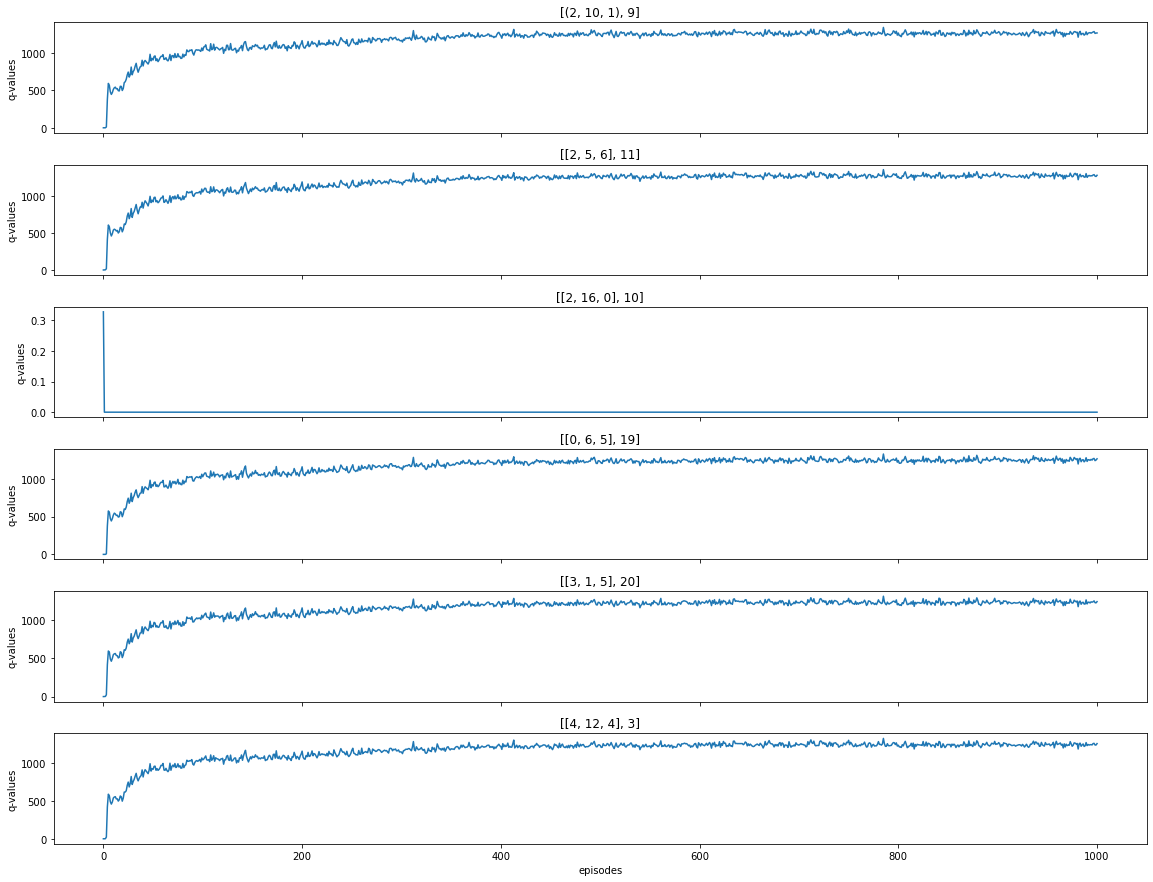

In [9]:
fig, axs = plt.subplots(len(states_action_to_track), figsize=(16,12))
fig.tight_layout()

def draw(i):
    x_axis = range(0, len(state_action_tracked_results[i]))
    y_axis = state_action_tracked_results[i]
    axs[i].plot(x_axis,y_axis)
    axs[i].set_title(states_action_to_track[i])

for i in range(len(states_action_to_track)):
  draw(i)  

for ax in axs.flat:
   ax.set(xlabel='episodes', ylabel='q-values')
  
for ax in axs.flat:
    ax.label_outer()

### Tracking Rewards

Rewards should as well converge over time, as the exploration ends the explotations starts, the rewards should increase and stabilize at the end.

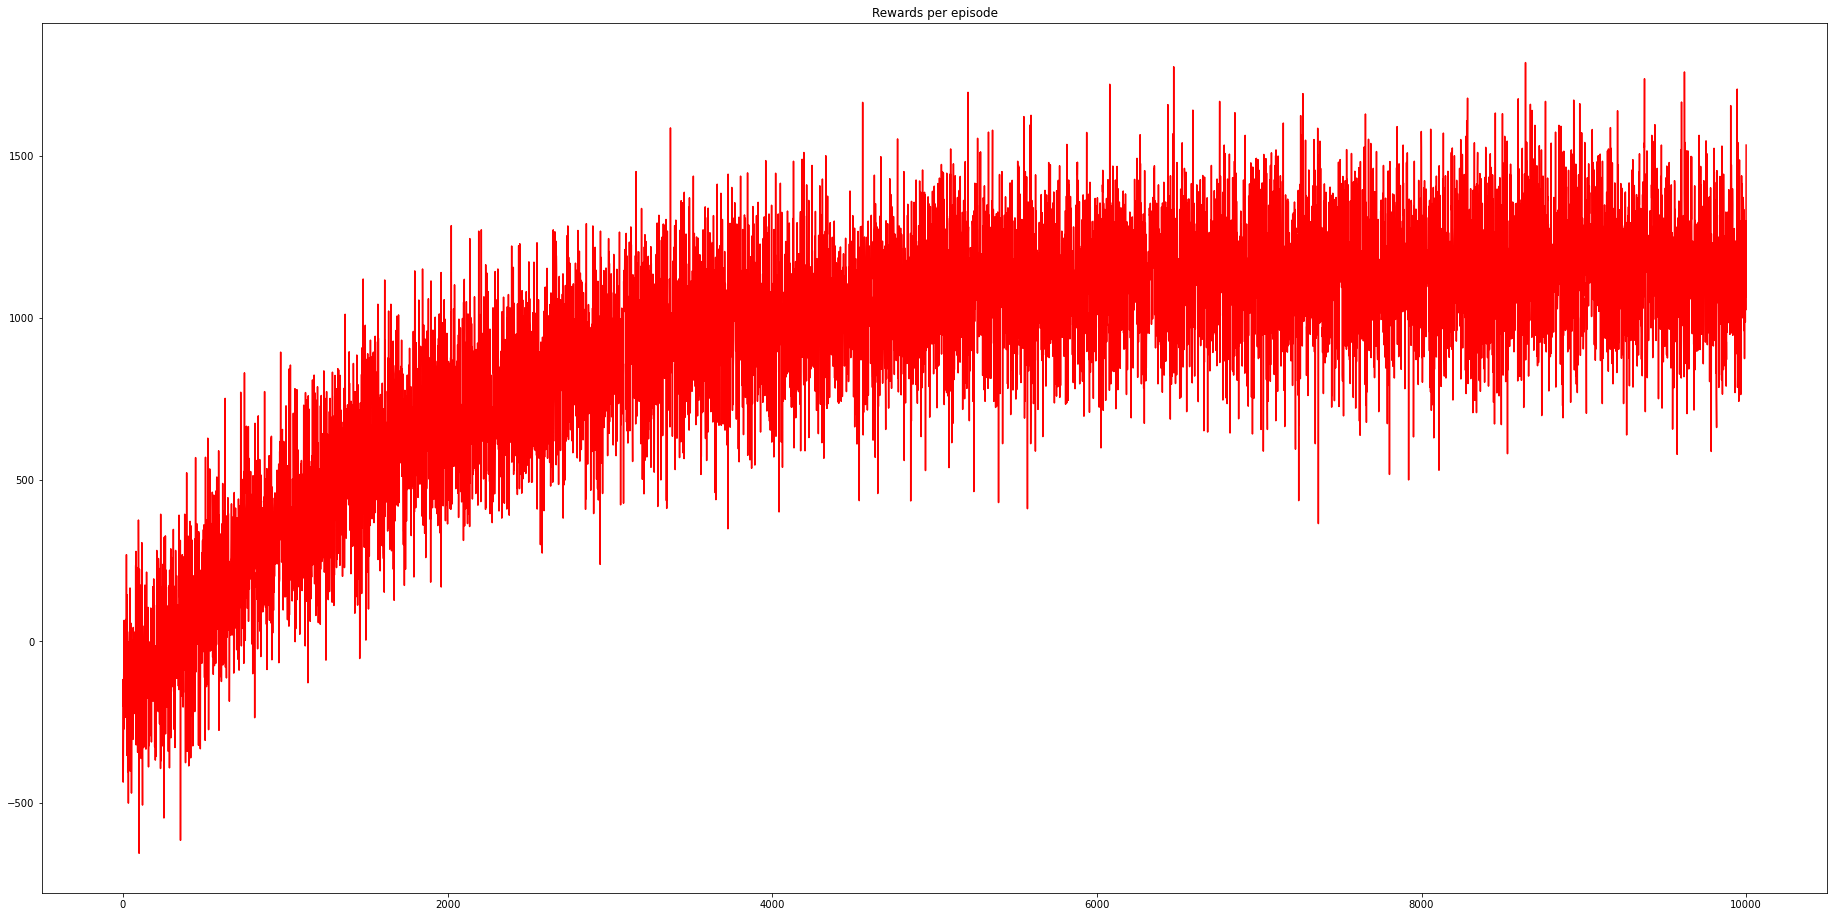

In [10]:
x_axis = np.asarray(range(0, len(rewards_tracked)))
y_axis = np.asarray(rewards_tracked)
plt.figure(0, figsize=(32,16))
plt.title('Rewards per episode')
plt.plot(x_axis,y_axis,'red')
plt.show()

### Tracking Loss
This is the training loss of the q-network this should come down and stabilize at the end.

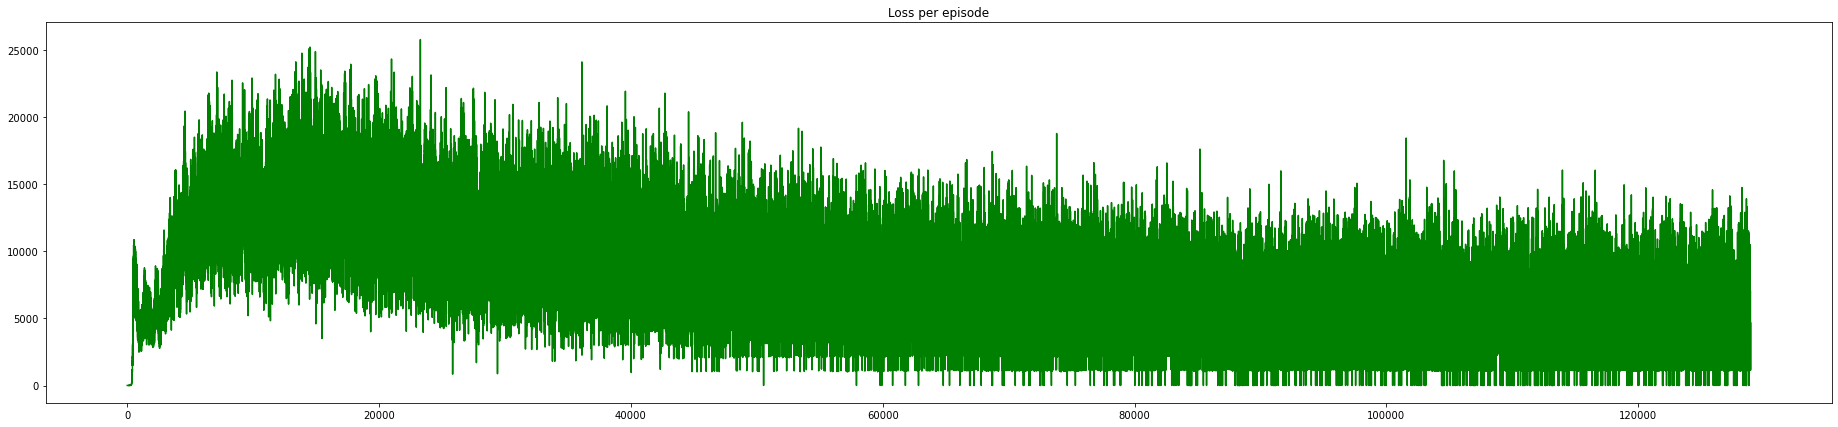

In [11]:
x_axis = np.asarray(range(0, len(loss_tracked)))
y_axis = np.asarray(loss_tracked)
plt.figure(0, figsize=(32,7))
plt.title('Loss per episode')
plt.plot(x_axis,y_axis,'green')

### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

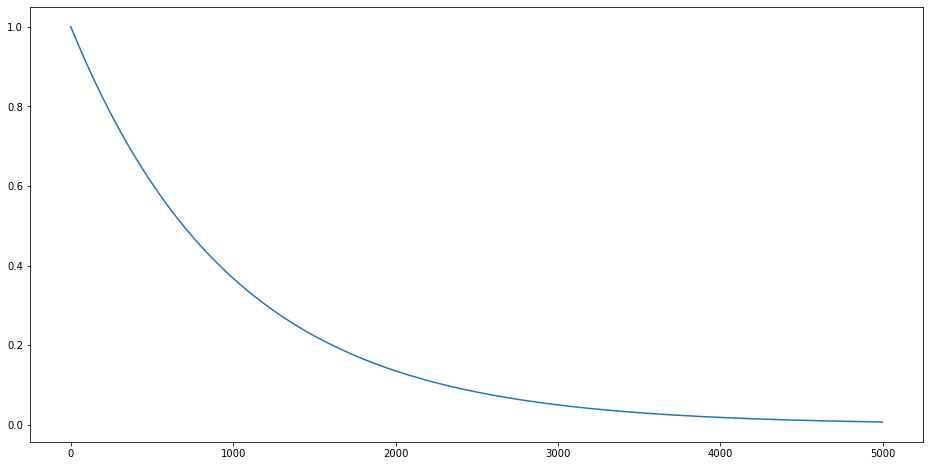

In [12]:
episodes = 5000
plt.figure(0, figsize=(16,8))
time = np.arange(0,episodes)
epsilon = []
for i in range(0,episodes):
    epsilon.append(0.0001 + (1.0 - 0.0001) * np.exp(-0.001*i))
plt.plot(time, epsilon)
plt.show()